[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1HAsxm1U4iCCrWay-dTGut3hmCPy0xqNH?usp=sharing)

# Monitoring Llama Agents with Portkey

[llama-agents](https://github.com/run-llama/llama-agents) is an agent framework for building, iterating, and productionizing multi-agent systems, including multi-agent communication, distributed tool execution, human-in-the-loop, and more!

One of the major challenges of building AI agents is the lack of visibility into key performance metrics such as:

- **Number of API Requests**: How many requests are being made to LLMs.
- **Token Usage & Costs**: How many tokens are being consumed and the cost for each agent run.
- **Latency**: How long is the agent taking to complete a set of tasks.

<br>

**Portkey** is an open source [**AI Gateway**](https://github.com/Portkey-AI/gateway) that helps you manage access to 250+ LLMs through a unified API while providing visibility into

✅ cost, <br>
✅ performance, and <br>
✅ accuracy metrics.

This notebook demonstrates how you can bring visibility and flexbility to Llama Agents using Portkey's AI Gateway.

In [ ]:
!pip install -qU llama-agents llama-index portkey-ai

In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

### Llama Agents Setup

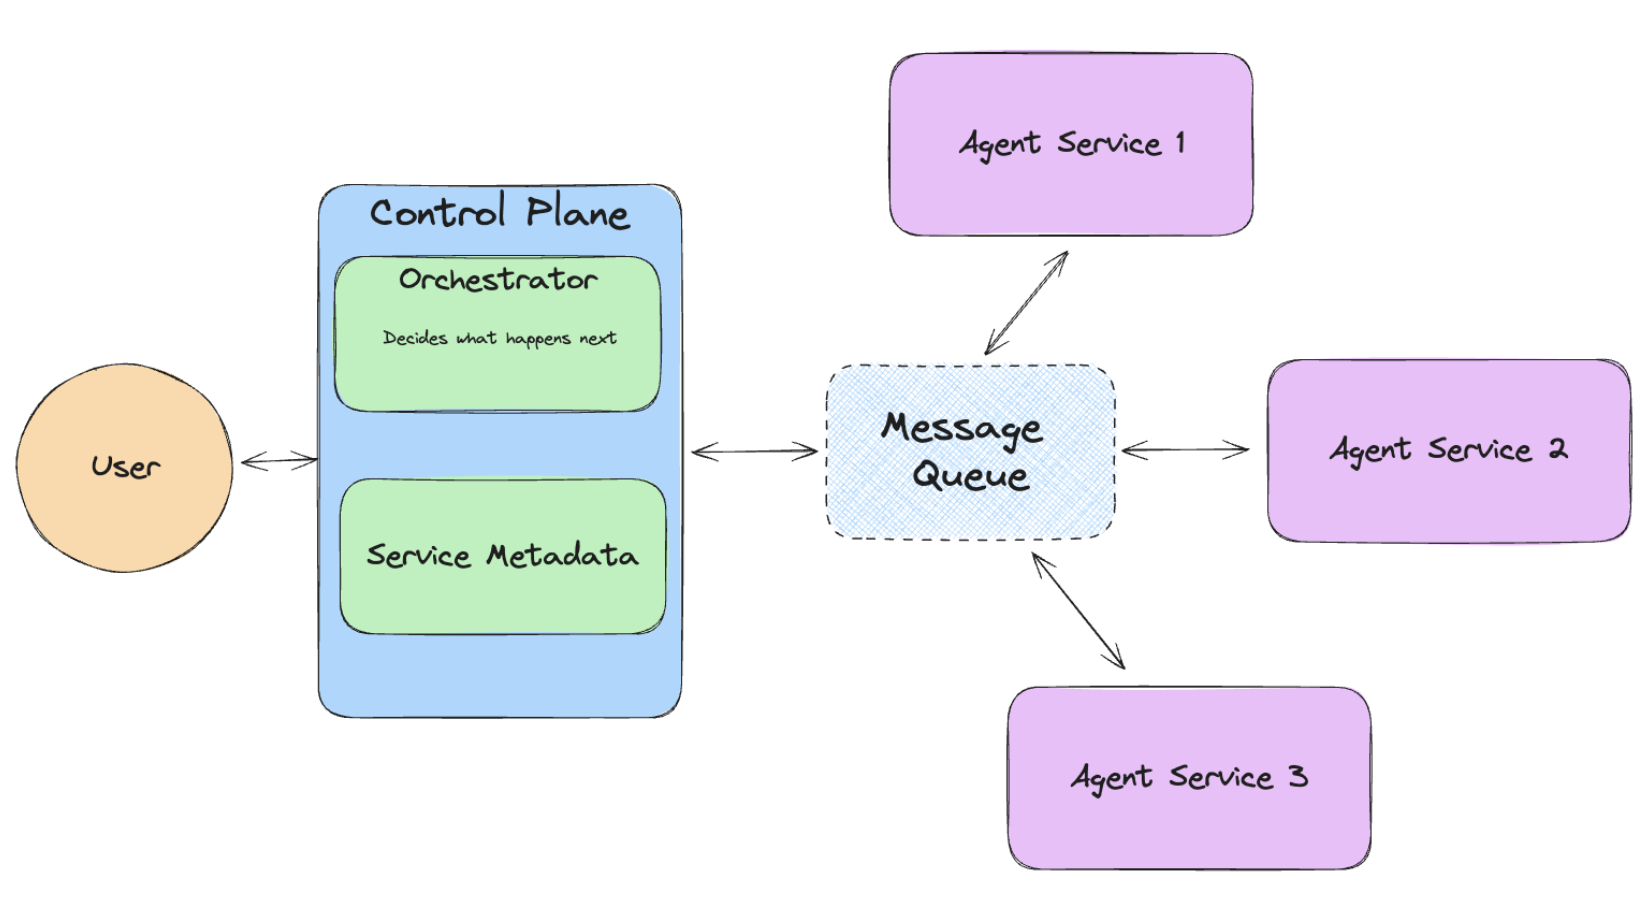

### Quickstart

Since Portkey is fully compatible with the OpenAI signature, you can connect to the Portkey AI Gateway through the OpenAI client.

- Set the `base_url` as `PORTKEY_GATEWAY_URL`
- Add `default_headers` to consume the headers needed by Portkey using the `createHeaders` helper method.

In [ ]:
from llama_index.llms.openai import OpenAI
from portkey_ai import PORTKEY_GATEWAY_URL, createHeaders
from google.colab import userdata


gpt_4o_config = {
    "provider": "openai",
    "api_key": userdata.get('OPENAI_API_KEY'),
    "override_params": { "model":"gpt-4o" }
}

gpt_4o = OpenAI(
    api_base=PORTKEY_GATEWAY_URL,
    default_headers=createHeaders(
        api_key=userdata.get('PORTKEY_API_KEY'),
        config=gpt_4o_config
    )
)

llama3_groq_config = {
    "provider": "groq",
    "api_key": userdata.get('GROQ_API_KEY'),
    "override_params": {"model":"llama3-70b-8192"}
}

llama3 = OpenAI(
    api_base=PORTKEY_GATEWAY_URL,
    default_headers=createHeaders(
        api_key=userdata.get('PORTKEY_API_KEY'),
        config=llama3_groq_config
    )
)

### Creating Agents

In [ ]:
from llama_agents import (
    AgentService,
    AgentOrchestrator,
    ControlPlaneServer,
    SimpleMessageQueue,
)

from llama_index.core.agent import ReActAgent
from llama_index.core.tools import FunctionTool
from llama_index.llms.openai import OpenAI


# create an agent
def get_the_secret_fact() -> str:
    """Returns the secret fact."""
    return "The secret fact is: A baby llama is called a 'Cria'."


tool = FunctionTool.from_defaults(fn=get_the_secret_fact)

agent1 = ReActAgent.from_tools([tool], llm=llama3)
agent2 = ReActAgent.from_tools([], llm=llama3)

# create our multi-agent framework components
message_queue = SimpleMessageQueue()
control_plane = ControlPlaneServer(
    message_queue=message_queue,
    orchestrator=AgentOrchestrator(llm=gpt_4o),
)

agent_server_1 = AgentService(
    agent=agent1,
    message_queue=message_queue,
    description="Useful for getting the secret fact.",
    service_name="secret_fact_agent"
)

agent_server_2 = AgentService(
    agent=agent2,
    message_queue=message_queue,
    description="Useful for getting random dumb facts.",
    service_name="dumb_fact_agent"
)

### Launching Agents

In [ ]:
from llama_agents import LocalLauncher

# launch it
launcher = LocalLauncher(
    [agent_server_1, agent_server_2],
    control_plane,
    message_queue,
)
result = launcher.launch_single("What is the secret fact?")

print(f"Result: {result}")

INFO:llama_agents.message_queues.simple - Consumer AgentService-86ae75c9-9d5f-4ddf-88ea-c67d79506506: secret_fact_agent has been registered.
INFO:llama_agents.message_queues.simple - Consumer AgentService-d2c4ba62-3a1f-4f08-8fdc-10c49d7f5140: dumb_fact_agent has been registered.
INFO:llama_agents.message_queues.simple - Consumer 230c00bf-9ff1-4770-a92b-84c0cfb7e290: human has been registered.
INFO:llama_agents.message_queues.simple - Consumer ControlPlaneServer-2578d1b4-9576-4f4e-8107-c8a6829ca7a3: control_plane has been registered.
INFO:llama_agents.services.agent - secret_fact_agent launch_local
INFO:llama_agents.services.agent - dumb_fact_agent launch_local
INFO:llama_agents.message_queues.base - Publishing message to 'control_plane' with action 'new_task'
INFO:llama_agents.message_queues.simple - Launching message queue locally
INFO:llama_agents.message_queues.base - Publishing message to 'secret_fact_agent' with action 'new_task'
INFO:llama_agents.message_queues.simple - Successfu

Result: A baby llama is called a 'Cria'.


## Telemetry with Portkey


### Part 1: Logs

For the above agent run, we have initiated two agents utilizing the GPT-4o and Llama 3 models. The detailed logs for this request are available on the Portkey dashboard, providing comprehensive insights into the activities of each agent.

Sample Logs

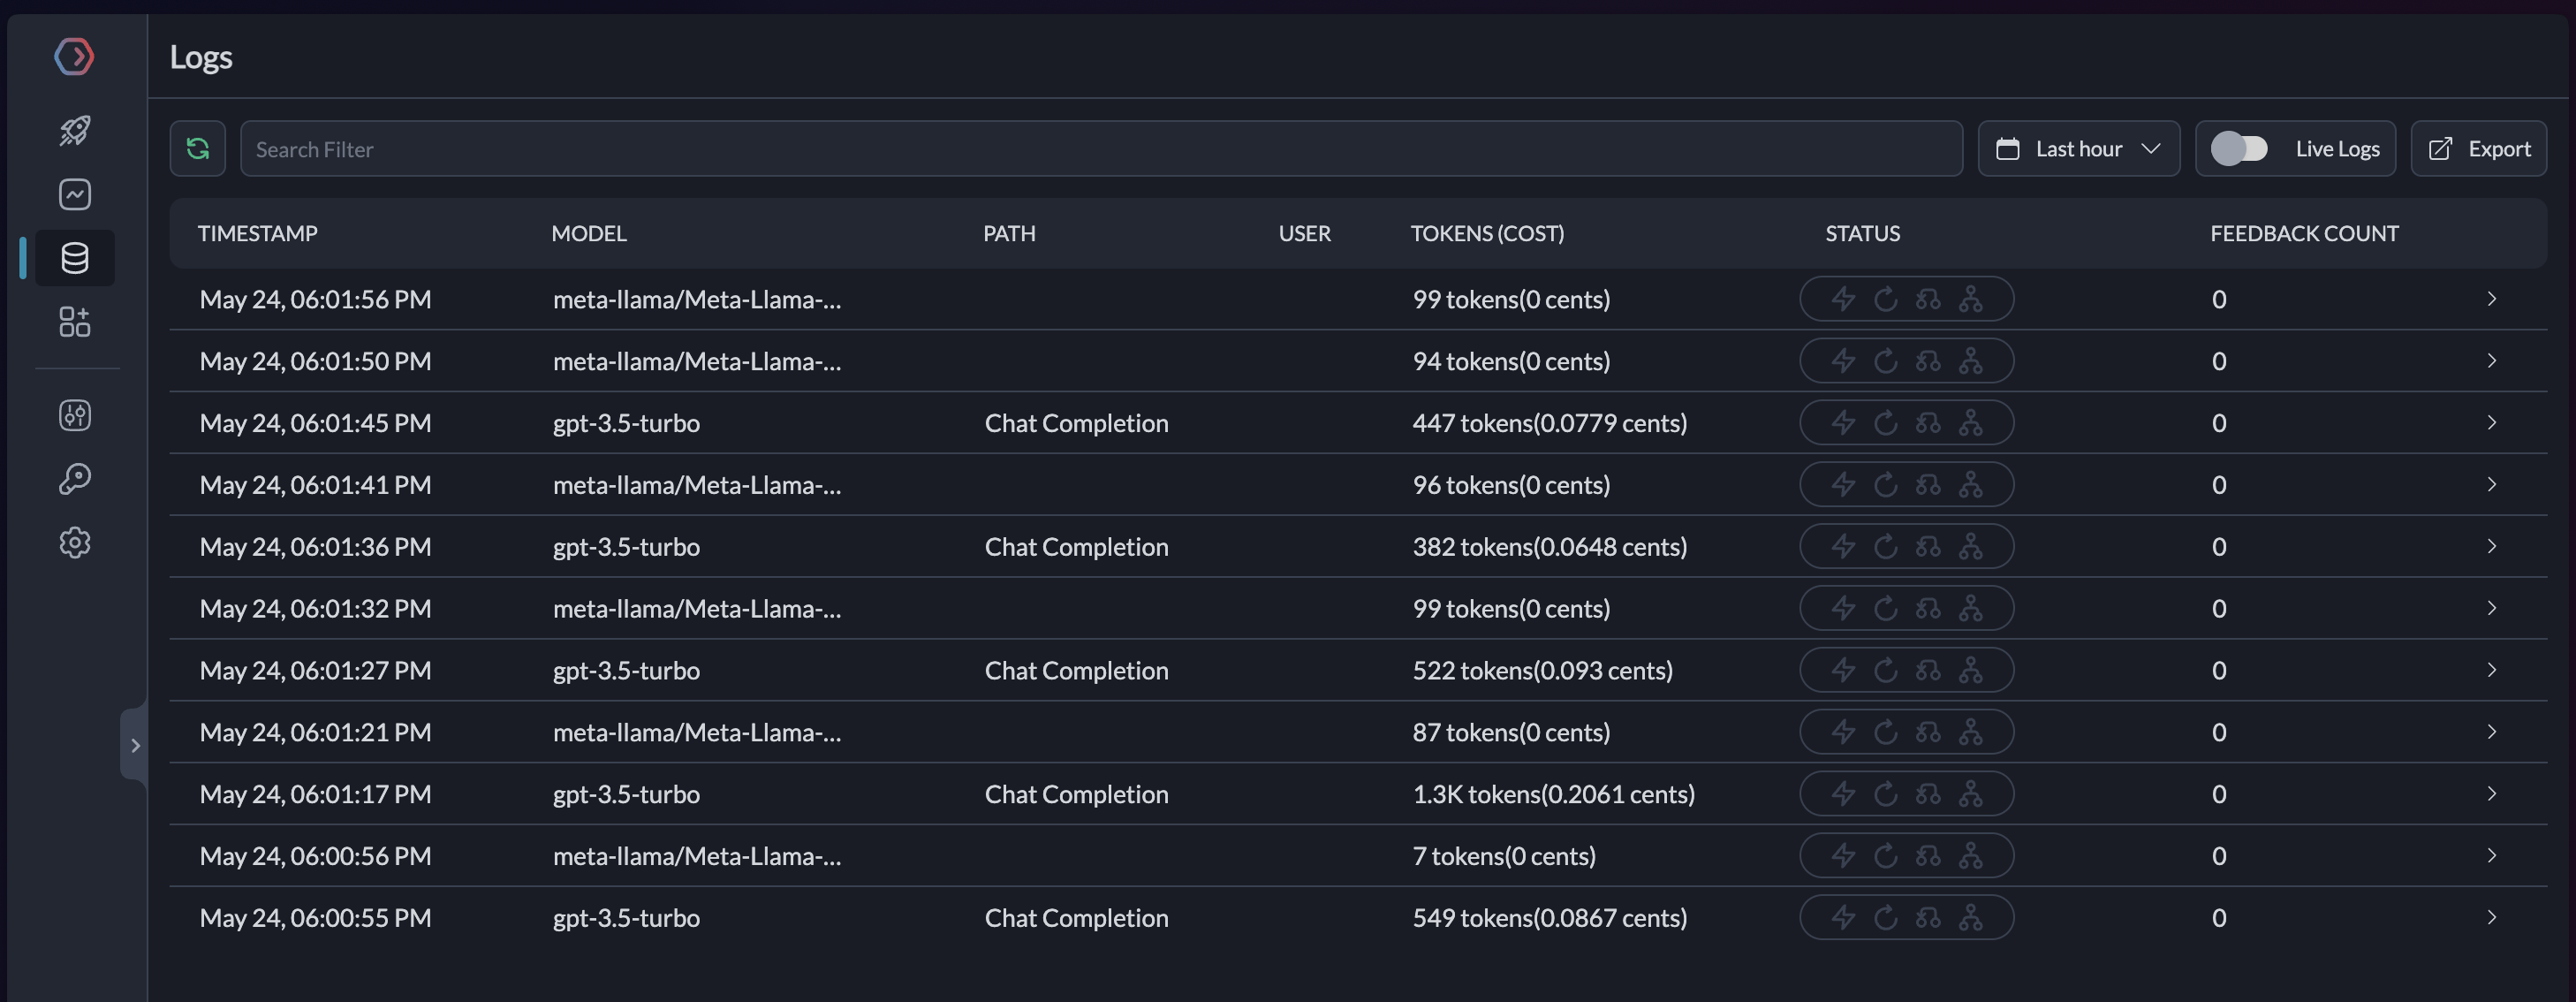

### Part 2: Analytics

The insights from this request can be viewed on the Portkey dashboard. We are able to infer tokens used and number of API requests. You can also review many other metrics from the dashboards like cost, latency, etc.

Sample Dashboard

<img src="data:image/png;base64, R0lGODlhWAJaAff/AAAAAAA/JAEBBQE0IwKKWwMDDAYGEgcHFAhyTwkIFglKOgoaMQsHFgwLGA0FEg0IFg0NGQ4dMxAMGRAQGxBZOhEFFhEGFBERGBEaKRMHFxMVGxMYIROGYBQOHBQVGxQWHBQXHRQZJBQgHxR0jxUJGRUWGRUXHRUXHhV/XBYOGhYXGxYYHRYYHhYZIRYaJBZXbRZjuhZslRcYHhcaIRcbIxceJxchLhciKhditxgdKBgdLBgeJRgeJhgeJhgeKRgfKBhithkaFhkfKBkfKhkgJxkgKRkhKBlVlxodJBofKhogKRogKxohKho5KRsdIxsgKhshKBtUkxtWmhwcKRweKBwjLBwjLhxDMBxfqx0jKx0kLh4eKh4iKR4kLx5QfR5vVx8mMSAjKCEmLyEnLSIdKiIjJSIoMyMzSSUZKSUbKiUeHCUmKCUmKSUtOSUuNiYsNCYsNCYtNiYtOCcnKCcuOCcvOygUACgwOSkaCykvOikzQCoyPysqLSsyPSt9ZiwfEiwmIywxOCwzPSw2Qy02Qy45PC8rJy8xNTAwMjI5RTMwKjMwMTQ4PDQ4PTQ/RjVPXzY3OzcwKDghBzg+Sjk9RDk/RzlNTzwmEDwvIjxCTjxlXD83LEE3K0FESkJJVkMnM0NAPkNIT0NKVUVKUkY3KUY4JUcrEkkuBkopAUtWY01CNU1TXE41F1FBL1JYYVZBKFdgcFk2BFlbYVlfaFs6EltubV5DI180QWBmb2Jte2VCFmZsdWhWPGw8FGxze3FMG3R3fHR6g3lHS3odQnxWJX1lR357eH97eX98eX+BhYBQEIB9e4CAfIKBf4OAfoOKkoaLkod+dItlMo1xTI2Oj42Qlo2UnY+Kj5B5WpCVnJQkSZZ6VpZ7VpqFbJqgp5x6S55wMZ9lI6GhpaOlqqSoraWrsatyIq4SSLCxr7KzsrN5KrSgobvAxsEXUcFZZMXGxsXJzcfIxsfIx8hwjcnJydbY2drb2d2yw97f3+Tl6Obn6eqBoe3w9PL09vn5+AD/ACH/C05FVFNDQVBFMi4wAwEAAAAh+QQFCgD9ACwAAAAAWAJaAYcAAAAAPyQBAQUBNCMCilsDAwwGBhIHBxQIck8JCBYJSjoKGjELBxYMCxgNBRINCBYNDRkOHTMQDBkQEBsQWToRBRYRBhQRERgRGikTBxcTFRsTGCEThmAUDhwUFRsUFhwUFx0UGSQUIB8UdI8VCRkVFhkVFx0VFx4Vf1wWDhoWFxsWGB0WGB4WGSEWGiQWV20WY7oWbJUXGB4XGiEXGyMXHicXIS4XIioXYrcYHSgYHSwYHiUYHiYYHikYHygYYrYZGhYZHygZHyoZICcZICkZISgZVZcaHSQaHyoaICkaICsaISoaOSkbHSMbICobISgbVJMbVpocHCkcHigcIywcIy4cQzAcX6sdIysdJC4eHioeIikeJC8eUH0eb1cfJjEgIyghJi8hJy0iHSoiIyUiKDMjM0klGSklGyolHhwlJiglJiklLTklLjYmLDQmLTYmLTgnJygnLjgnLzsoFAAoMDkpGgspLzopM0AqMj8rKi0rMj0rfWYsHxIsJiMsMTgsMz0sNkMtNkMuOTwvKycvMTUwMDIyOUUzMCozMDE0ODw0OD00P0Y1T182Nzs3MCg4IQc4Pko5PUQ5P0c5TU88JhA8LyI8Qk48ZVw/NyxBNytBREpCSVZDJzNDQD5DSE9DSlVFSlJGNylGOCVHKxJJLgZKKQFLVmNNQjVNU1xONRdRQS9SWGFWQShXYHBZNgRZW2FZX2hbOhJbbm1eQyNfNEFgZm9ibXtlQhZmbHVoVjxsPBRsc3txTBt0d3x0eoN5R0t6HUJ8ViV9ZUd+e3h/e3l/fHl/gYWAUBCAfXuAgHyCgX+DgH6DipKGi5KHfnSLZTKNcUyNjo+NkJaNlJ2Pio+QeVqQlZyUJEmWelaWe1aahWyaoKecekuecDGfZSOhoaWjpaqkqK2lq7GrciKuEkiwsa+ys7KzeSq0oKG7wMbBF1HBWWTFxsbFyc3HyMbHyMfIcI3JycnW2Nna29ndssPe39/k5ejm5+nqgaHt8PTy9Pb5+fgA/wD///////8I/wDPmZO2rNqygwgTKlyIkJnDh8uUKXO4jJmygw8zQmTIkSMzhBMZavxYsSNGkg1NqlzJUuXIlzBjypxJ8+VEhxMl6tzJM6fFnz6D/gRqsaeyZEKTAk2WbCgzplCjSp1KtarVq1SLad2arFgyY1+NiR1LNipZsV/Dgl2L9qzbt2fVwpUL11gxYnjz6t3Lty+xrXf9Ch5MuLBhwoC9fq0GDlwuSzIgGEhAmTKDy5gra97MubPnz6BDix5NurTp06AvP1jNurXr17Bjy55Nu3WDB7dr697NuzfrDL6Dy84tW8IDEqszMFD+oELy5w+AR4cuvXr0DNiza9/Ovbv37+DDi/8fn52E+fPo05OQkEE9e/Ptz2d4r14++fvdSXiwFMtRCQaoBSjggKE1kICBCDag4IIMNujggxBGKOGEFOJm4W0YXqhhhhwy0GFuGHroIW4jXihiiB2SuFoDIgrn4oswxijjitj9tlx0NzqnY3PQWfCAj0D+KGSQRA5pZJFFAgecBRVkwGSTQC4JZQVUVmnllVWCZ4GTGWCZJXnXbRcmfuGR0CSZ4JEggyMzaHbAmwckEOecctZJ552cxUngnnxShuCBgBrY56CdYWbooYgmaugDhzIq4mUssqgapJgx6igDJEq6GqabWjrjp6CGGqOSy5Wq3Kk58rijc9MdKaSS08H/CiuSriYZ660+Skkll1v2yuuvvva6a7DAFrvrrmgmqyx+ZmZwRgiTwelnoH9WG+i11hL6maCVWesttuB+m+C4FJZr7rkcprvghQqyq267GMKLm7zrxlvvhvgSJ6qLDRjn7wP/BgzwwAIXTPDBxuH2L2sLKzzwigv32xpwJDSAXAYWW0cCxrLe2vHHHocM8sitwgbrxu/N157KKK+c8ssux9zyzCor2fJ1OGcHM807s8zyxvDVJ3R68cG3cpfYVfCsAW82gIEQUOtggxJSV22D1VhfbYMQUlOtwxcbhC322GSXvYEGZ6eN9tobfLCBByd8EPfcctdN99125333CXz3/73BCX8HDvjgggse9weIJ6744ownfnjjkPctueGESz745JdXzjflm1vOueWWQy766KSXbjrpJqSu+uqst+7666ojzvoHs9NuguOI9y237nPzfbvepwcv/PC2w2487MQX/3vjxze/OgggnBA76s6bAMIHHjTX5dIHGICBEk4QgcT45Jdv/vnkJ5HE+GFsUH3roMcv/fv011+/76rjn7r++c+/v/8m4N/r+EdAAP5vdQVEoAEDCED5OfCBEIygBCdIwQpa8IIYzKAGN8jBDnrwgyAEHfRkoIEmKQ1ab9KBEojAwha68IUwjCELw3C95NnwhjjMoQ53yMMe+vCHQAyiEP+HSMQiGvGIOTSBBrDjgKXJSYVFKIIMhaCEJSwhCVdMggxd2D4Q2O+LYAyjGMdIxjKa8YxoTKMa18jGNrrxjXCMY+s8kDTuHUAHQtgiEYowgxDQAAM08AELtRhDKravfiyQoyIXychGOvKRkIykJCdJyfrRcXsovKMSogjDKPbgEqkARi1qwYUp6JEISzik9T5wPQ1cD3qwZKUGLgA9VoKABSC4gCttCcte+vKXwAymMIdJzGIa85jITKYyl8nMZjrzmdCMpjSnSc1qWvOa2MzmCTSwpRPOKQcrfCHUltACTriiE5EIBjCAcYYpCJKQL0zlBryYug/IgAYeMIEM9mn/AhbMwARN+MMKWPCBGXzgAizQww4KKgMW8LOSEI2oRCdK0Ypa9KJvlNslT8i0BECxCOqDmvpcwIZbROAMX4CDB4ARDBXcQKSEVN8M3Wc9FhzAF+GAgAoawDQVSMYAhQBHAy6wAgOIARYCaMYmmDbUyZQgm1CNqlSnStWqWvWqWM2qVrdazW0y0Y4qZCHUoDaEJ0TgFJxYABruAIxO1IKdZxjCO6EmViHQUHYaGEI4zjGJC7AiF7kowSaSsYk/XCMVhbhAKo5xjk+wQg9uSAYsxJCLWKiAdkjMrGY3y9nOevazoA2taENrgks2EVpPDOdYhTCFI5ghBmWIQBVc0Im2/wajE32QWkhXqwRVtuAAsfhFKpxxAXXAghup2EQswhEKZ/DiGG7gRi7GUYjDcsMWobjGNDbRAl5y9bvgDa94x0ve8pr3vMzkG/RKW8dMhrWFUJtCDiJwCzNEYAtcEGVtO3GGJthApvC163pl0IBrjGMa57gDNwrAC1t8ghfhSMU0yHANboRiE8cQQDVycQ0BCMAR0vDFDPKJ0RKb+MQoTrGKVxxG03LPo0KI4mqTsIUFRMIVEZCCIFJBApYCAQ1SXC0XobcCCHhiHH/YgjSOwY0SFOMY47CFOVIBjgTkQh0QCMU5FmHdXMAiFak4hxtoid4ym/nMaE6zmtcc3tRB7/8EG3WiJmVINVd0QQtcOMMh2uqCPMLzhYdcwQUk8YkGQMANYNbAJBYRilykwhCpMEAufGGAJuQiFKEggyGKEYpP+KKvuGSzqEdN6lKb+tRn9iommabJKAKYhU/ogRlcQet18tcGN1AfgEPa21qy4AI6FTQEIFCCCwDbAEM1ti/0cAEVGADYszQABC7w7BKw+NrYzra2t83tNdIuzu7dJEgJSVciYMAGbCiDGdAQgTHYIIa8viviVrACxKlABfVmwQrwvYIS3FuXXty3Ckywghncm96jTbjCF87whjv84RAHLZy7+Sw9fVSGS0CCDjZugyogQY+GpCn9PpDIbpv85Cj/T7nKTa7RLZ12Tu99dYChNr5TEgFqqhTgynfO8577/OeT1B+4Wa3CGxRhtUhPutLLPcMaRvzpUI+61KdO9apPnZsZOC3R82jzrte1DDSYgdjHTvaym/3saE+72tfO9ra7/e1wj7vc5073utv97njPu973zve++/3vgOd7E07gJG+mloXjozn6Fn8+qLmBCliIvOQnT/nKW/7ymM+85jfP+c57/vOgD73oR0/60pv+9KhPvepXz/rWu/71qacCFbYwha+Gu65Lz/3SlSCGD2jg98APvvCHT/ziG//4yE++8pfP/OY7//nQj770p0/96lv/+tjPvva3z/3uZ98DS8y6/5wvfsolUMGK5RdDyYHO/va7//3wH6MMPOBysIpbj1YMWw1qQARBFlIIYiBy8TeABFiABuhz9Cd+IQBz4RRDPrAENRACGxAJtpALgkADS6BHAfg/D+RPLRA/LcACESSCIXQ4JfhBJHiC8cMCLBg9lpOCJ1hPK+hAHMhBLHiDKpiDOriDPNiDPviDFHQ9qqZ1KdSAMLQEIVAGscALrHAKx8AJG7AETBdg6nc8tCMD1GYAJVBviPNr0jZwtlNyLEhyxrZ+YkQ7GjADJFRPt+NKv9dGtmNsK3A79WRsrgSHt2NsdsiGJ7CHq/OGymM/csMC3VU8uSSHqyM3wCdAvrdAxv+jh3uIhhqQOm/IhmxYiXR4gJq4bXBme9ESc7qmPktAA3jgC7fACq5wCLcACDRABKEYiiy0gcZDchDgCL6QC2QAAfl2AXEQC54wAQilSzqlhywAAZKgB9OmAb5nArT0RRpQA7DACiFgOxpAA1ugAU/QBBeAhogTfGNEO4MWCrLjZmVQCGUgfAe1Ar/ne4H4RWBwCaGwCDlAYtjzBn9AA7+njhcABtrIAphoPxAACJswAfREcm4ACGIAfkqkAb/WBGEgBrtEVMw4AxDZjq6zTYeQCp/ACZ/ABZOoAU1wjRqwBU2wjgs5iRdwBGBgkr4nkZv4kinWiQrIat/jan+2BC7/EAm8cAsTcAiuwApR+GcuhHOl82ubIA/joA5ihpJucA2xUA22MGJgsAWOoAFrIAlj1gS2UAhr8AdPMANP8AFrMAPKKDxKlANN6AJxWAaT0ABY6QLXCAYrsAFgYI1NADc39GtvEAuxEAkX0DbVGApuEAYzgAVHkI00AAYecARb0AJg0F3LY5YXsAe2cAuWyQpT4AG/NgmRAAhhMAVgcAFDMAWOsAg0cAFPkJmRaTqpQwOwcAi6NHAaMAWhUAYkuQUXsAO4OQOLcAiXIAYtQANhQHJgUAaSAJKTODqUyAqg4AqVKQhEdQFlwArRAwth0AJbcAKT0ASgmYaHcAgr0HuT/2CYK/k4Vnee6BlxAeRiqDVnMuQDVQAKtjAHkfCEUbhFVCSLsCNo56AOgDUPzVBpkmYLAkAG3ABdzXAM18BhyeAMf+ALvAAL1TAN0xAK05AKv2BQ74M/+4ibqnMBbiAJDaAIh8AJYSAIn3AIkXAJi/AJWMBKYbRNp8CctsADuzQD8UgDlzAJgAAKdzAJPPoJgrCjNLA7zlgGi8AJqXAJgnCXIPkJwKgBd7AJd3AJcuCblwAHm9CRk0g/J/AHl5ALp3AKhjAB/sgDofAHYXAJmzCkm5AHktCmOxoJXLAJgPCdcjAJh7AFJHY8GsAKk3AHt2ALeXABJCQGoAAIfxAKVf/aprUJB59wBysqCGHwpqAgB2XwCXKAUDDZqRfVcjP5RDF2dEg3inPAhL/wC7eABzmQgULWQlFUhcbDAhPAC/MwDeEwD5twATNwALBQDAKAYbAADrzADbDwlAeQCuJwrNfQDNHIDc0ADrbQAHNYPx/ACbHgCpugAdJzAWKwCRAwCXXQm5wACHAwCVtAAzzapV/0a4CQC014C7tKUDTQkS2wrX8wmJKwAaEQCRNQBr95h87oBofwB3KwB4dQkgUVCkW6BWAaCoJgAIsgBn/ACYF6jfUDAotwCbbgCrfwBwiVV6EQBhXLlp9QBp3JBZIgCR5QWIR2CRDQBKzgl47YOn//egmgcAisAJtY6AZ7cAmX8KNUCgeS0AJ7EAk+qrJucAnfSQN1sGgX0AKeOrUUJZNE2GrjFoqjiK2xwAbHEAkbkGuvGIpQIwY1qzrQAwGxIA7cAK5PtYXH0AzX4AhgIA5k8Fye1gRNEA5rYAuskAy8QAbVMAnTIAnNdj/X2rGcwK31RGiRMAWLIAl5iqRU8ASLJrD282uL0LGxYAug0DYF9QmRIAeLMANv4AYbMAlZ6ggn4AabcI70JIhH8AeL0JtuIAMn8Gt1ILpVegl1IAm1+wWA8AaRYJpy8z4EpbqDego04EV5ZbgnIAmHwAXfGQaTsAl7IAmXAAjaKwiAMAl7/7AHgDBmZ6s6GvAJsdCErMAGwegGcnAEM5CvhyAJU6CnQFsIkdCmqnsH3wm0dxC1VBvAEDVxMxkn7+WAkVAFNWADZeACGQhyAOh0okNwhmZoKrBes/QH2nhLRFUIetuFHlCSW2AI9uQBAreapZOHU6CNmNWGR6CMR+B7PNC8ILACJSnBxHM7IUl765U6LAC/vTSJ+Hg7YrdLNrSQNDAFKtBs1zORM8Cr6lhwrOSPLRDD5pnCGqAHXLAH95ic1lPDk9gEH7ACQ1AC/gQ9CmtwH9AEqeMBMoBZqAMCLbABYYe5C6lEIBDDLdACMkCWLOhKBuVPJzADXpSehnzIDMdeCv/IgDLGdS7kAqhEBDXwwBCsn8ezb/S2OiyoSzJwO4m0jV2Khkp0AXRokfTzj+ZLif2kjKlcRt7IOqw8O9NTRgQ1iWZIUCQ3joHIrvXze8ZmykqkyploO8QcOyOXOK9DjZFpicUMzAL8zIr0Zlh3tR8lcyxEyV6Hc7GrYpIDP/GjRqCjQJUUQWHEguV7QV5qOcaDP+xMg9D8zo4Eqlp3eOKDBGN7z/isa2UrgPDcz/78z51qtRWXWkVwA0jAdT3QAz6w0Azd0Aud0C60W2IgwePFN4h80Rid0Rq90Qw3hBVXhElAAz2wBEEQNm7jNmEzx3PcNiztAn8Wcm4GAvN3AR7/cAElkAIlUGw3ndM2jdM67dM9zdM7/dNCDdQ7jdNuDNBKvdRMzUZvloAvRxk64AQ2EAhlYAP45AEegDgbcAEHcgANwK1ajT0bIFO81nu/l9MY0Agj0NZu/dZwHddyPdd07dZgowHg5316vdd83dd+/deAHdiCPdiEvde+V38LKCdSMAVmMAIvYAM7ADdh4wET8AefcNmbcJqBgzbrw3VQUwZVEHlbgAU2wAgvcNqondqqvdqs3dqujdptgGtZIHu0Xdu2fdu4ndu6vdu83du+/dvAHdzCPdzEXdzGfdzIndzKvdzM3dzO/dzQDXlYkAVP4ImK7VqO/QVZrQEt0ACs/9AMthDevNAMYrCNWn0CQUC2dhWCMrDHZDltkBjf8j3f9F3f8w0CG6CG+7Tf/N3f/v3fAB7gAj7gBF7gBn7gCJ7gCr7gDN7gDv7gEB7hEj7hFF7hFn7h+/2BTnK1UoDdjz0EKgBn3N0MKlAAAtAAAJAKtnAAb+wBZX3QqzXRiuNK+kZvNn7jOJ7jOr7jPL4CtcTRQB7kQj7kRD48MslR193YL6Ddkr2Px5AAYnCclyAJuZAA9ebir6bNTb3lXN7lJjfNA30AHa7k2l0CcDYBXPALJ5CgF+oIVb4CWr0BUzC2ZgvLWn3ndx7LsfN7eN7nfv7ngB7ogj7ohF7ohn7oiP+e6Iq+6Ize6I7+6JAe6ZI+6ZRe6Zbe57Nz6ZGu5+uJ2HMy5tlNAyXg4hcQBr5QqScQCgdA5VYe59Ys45h1Ak2QBEMwtlPQAoyrRDTwBE+Qz77+68Ae7MI+7MRe7MZ+7Mie7Mq+7Mze7M7+7NAe7dI+7bq2A7k+xkNQ69Se7EMwxHiF2NEC6qfA5Ns04hcgAAfgYSpuAPPn4qbkiklQtiVHO2FQ71+QBVyQ7/oOdnAzkmWA7/oe8AI/8ARf8AZ/8Aif8Aq/8Azf8A7/8BAf8RI/8RRf8RZ/8Rif8Rq/8VxQBlhQyBTJBQDP8RJfBWXwBHDT6Yuc5KGu1WjTALDQDJ3/W4HOwGzYAzfpDV+818QeMAVfoNAM3X9BEATgFAbK2AJl0ANDv/RM3/RO//RQH/VSP/VUX/VWf/VYn/Vav/Vc3/Ve//VgH/ZiP/ZkX/Zm3wM5AHa+VwVVkAM9UANLnwRmv/ULXQYGJc9hvtiNjQkRcARbfTYfAAGLimmf8AQXAGeuPkjxvvNo+ARV0AP9NwUu4AJaoARjRUPVGAZBcM1ZBOxWhEXbHvqiP/qkX/qmf/qon/qqz+xC0ANhYKMawAWWT0UJ7QQ5gASdrwT2rLWiSAVJIHuv+Pm8P+z9FwZFioa29003cAOMYAZYffNxPgGBglB4LueKl5/05AFb8PhB/xAGNzAIg3ADNaAFBY35wtkDUFMDrSiFVNT+SpDQlt8DNLB/NYD+7X//upf/+r///N//ACFE4ECCBQ0eRJhQ4UKGDR0+hBhR4kSKFS1exJhRI8IeYXZ48MClSg8lIcJUmVAmRw6BPTYIURIzJsuSG5RseCmzioscVWQqoflzYI+BSogK6UhDg4kTHjJkcHAmhIEEB3TYuIGhhg8fIU6c2AD2KwsWLcKePRFCCxK2SASKAfFBhYYtVbSIoEQAgRcEYkTYQBImLo0wPpIEgbOnR47FNYI4ppElDI0gZQTdKcMGS5DHj2skaRta9GjSpU2fRp1a9WrWrV2/hh1b9mzatf9t38adWzdbpGF4gOTiRIgLQOfUhXNHrUeSHlxCUcmxIYT0N0hCHGK1IZYrLiE0bJgQ6RCEECGiu0GC08WGHEqQ9KjCWIkLLj2I+ChD4wNTDU+jTj3gAAyUwIqoJA7jrIceOGOwQc4OJCJCImCCaz+6uNBBhEE4UOACK14QYQgtBNOAMB9qKAOUOWy4owo23Kjiji/kEOSSMkKIJJIy8hAvEiXk4KIMOYSQsEgjj0QySSWXZLJJJ5+EMkopp6SySiuvxDJLLbfksksvJfTBNw00CIMKJSaAZRxquKFmnD1oqMGNZmjYwxZBWLnEmVQ04OWYMrgJ5TpbYjkllFRgYWX/EkEmcQbPWCSJpY0alogzFh80YEUQGpbAT6kPTugPKqmosorICS/iTQgxNlDBBLqqEEIEPAYRQYxBrBBBiMDimuELopQ45JBIODlkj09yPESQPC65BFhOLAtWPE6GveOoja7FNlttt+W2W2+/BTdccXVF4j7fPtBApPRSOaSBDRI4ZZEQ4vwFAkCO+aWZVH4RJIQqbNEhkmO+iOWXX3jh5ZdbcmkmklyOAYUag5u5w4WYcIwlFk5CUKI3/ZhyStSpqtJBiQjZSnIJKqhYosm3WHV1i/pEGGAWJgJoBgURlhgjjA0+IEzBL+64ZNo9Lvnkki+KFWSPQ7JIloYcAQn2/5I9ImHpS6235rprr78GO2yxxyZbyTB3+OCD4M48ZZIJaoCAlUNo8OGLaVjhxRlebEE4lQkiPuSUY2xA1Ba8eTHUYF5useWXWC7RVwMbklhCg0M+kTxCH8T4uCkLRCa15CUpxQknl1VlwYSYs6hBCQyYwMQLChT4a8TBCiOCCkHcUAKQMuqAowyfBGEjyCXEiK+MMriQcQ/lOy47eumnp75666/H3soweUg7CyxKmoQXVjLm5Ysa7luUajYk+eINTQeJ5I1N6ghBeTfKcOP+MsKIRA7LyphEHSRxAx9obgnrsUEBzdU5D3zuP6EzWcpokCJW4GkrS3pZq15lHxtgwP+D5iFCEW5Aohngzgcu2AqcarDCAvLkRES4IAvppsLs1dCGN8RhDnW4w/uIYQdj4gIVBDJBQNRhD6xrGRHM4oJ5bWCFITigEzewqRVW0YpOrMEMajDFDRxpCUnUHOeW4ioHjopkSihCEZAUJ1sQKxKsOIULwIik48VlLk9gXYRucAMifPFUggFaGM7Xx5Z90Y8ROiQdCclDRjbSkY+EZCSLVAOPgCQMSwhCH2vgAhq4wAdgNGQo/ShKCRUSlKJMZJKEkIPJeECDZRyZVTpGLoLc5BK8iA8GDvELpLilILxRAlxAYAKglSEJHPnCFjQwzC9UwZfjgmY0pTlNalbTmtf/xGZElFCGn2kgCWGwVjZbUgXBxAVU/jGjLBFSkkjcghW2MFwujJKQCMFFda4KQhi+sE9+7rNMGwBBXFoQBoJyoZ8HRWhCFbpQhjbUoQ+FaEQlOlGKVtSiF8VoRjW6UY521KMf9ag+RTqZZZoABFsoKEgvqk+DziCgnwpZBdI5oCUUAUKl3MAl5MkFGxyCF0q46ZEolLp77ocFAQXBV0Bw1GUOk5gfQCpSvzJVqlbVqlfFala1ulWudtWrXwVrWMU6VrKW1axnRWta1bpWtraVrAEdS1ycCgINqGAFSXWrWKP6VJMmVQOwpEoCREfHnN4iFvCMxS2ooEAkUSguadvP/1MhC1nVTbayk8VsZjW7Wc521rOfBW1oRTta0pbWtKdFbWpVu1rWtta1r4VtbDF72bRJVrappS1MAXvGNN70QEvYQCRiUQWeCiIX50tChA603OQSwZ73hG50pTtd6lbXutfFbna1u13udte73wVveMU7XvKW17znRW961bte9oZXBjOA7wxkcE/PgY5kpqKjCzgBT3jOQY5Kepl0bztgAhfYwAdGMGmtm2AGN9jBD4ZwaV1VFaoYoAElGGZ9ZRrLwTKXuenJwT5D4AIheNjD9STqfj7VghbE18UvhnGMZTxjGtfYxjfGcY51vGMe99jHPwYyjeNCTOh+gAUzYHGSlf+8ZCY32clPhnKUpTxlKlfZylfGcpa1vGUuSxnJGmgCLMQ8ZiB44Cshe2CASpZGJbGMKyxj0ltOAN0WBIFyN1gCnvWcZz7v2c99BvSfBR1oQg/a0IVG9KEVnWhGL9rRjYb0oyUdaUpP+ot4HoJLo0uDIaDS058GdahFPWpSl9rUp0Z1qlW9ala32tWivEkh+DHrWe8jDhdogQkaaN9SdSmD97SzOIU9bGIL+z4BrewMnnDMYjfb2c8WV0kcoQ99qOMc9riHGi5w5s9tGIIFDKqVBBKG2n5ABssWiCTVvW4eCqQFnyLmEQ6UbnbX2942LMki9kEPc5jjHfhYwwVS10D/C/znAAkQbARRRgQTN9zhzK6QCj7QggOx5eEXx3jGNb5xjnfc4x8HechFPnKSh1wgmiZmEyxecpa33OUvh3nMZT5zjedbH/w+xzvuEfAV6PopGz54qdKYqlrKBCYOee7E3VMQo0Pb6U+HekNagOwPHIHoMIlJURaS9VkapOtRB3vYv5XvfZ8j5zu/QFJ3bfAzRuggJZmOxVjCkGBugJggmMHXYRKCCYTg6EcPp9gFP3hpKmHqUK3613MwAQ1MgCQuwXrHuN4xJpakPQKZ5U1ORXjOd14iJVHEvs1x9oAPM1RAR3iHPbwEGlxiUIfQQBl4YOeHO1YuH5jBEpgL3EM8/2qLk5oiFT5Dc+IX3/jHR/7MYeLSYX6gCe7RpBvgCIsvpOsTPVihHGkAxU7W4A+CaIEkuLmpDWCSBptYwsqTv372t9/9Iic7zv+t7Z7HNJ1rVuORamALQEwiFmz4hVBgLCURgxTLPZyKmMNqPc6ZhDL4hUngtHuTwAnkEpRzPgihFDeIhXGQm0PAgmYYgjdwA035A0bYAAGagFjIBQM4BkaoA0CogUngAR/4hGkgIArEwRwkgvgbPXkAuLTTNVgKOvxbo1wog94DQFCwgSYht8pqgSKhAg1omAaAAFs4BoSZBkbghljYFB30wi9UkhmAtwtsLiLopGNgg2M4Blg4GP8rdAZbaIZjyAVqiIULeKcEWJxr2AReoAZeeJhpGCQwFMRIsjn5Q7sW0DCpOLiEU67m+i2pWZhAmIBDKAnda0TmGiontMTcmYBjYIXYo4YN+IXG2RcxQK73Q8VUVMVV1Ljlc6rEKxeGCwI3OAZ4koNmuAZqSIVpCIVcyIVD8MRjqAFW+AUDcIZQQBhuSAVbcAYaaIYnoD1WlMZppEaWK0Sz+7eAYwHPKbj7Q6P8K5IDAgV4Ei5byIU5oAEmEYxkC0cawANnaAbDaQZe2IQ19EMoGsR89EIaoLojMJIa+IJf2INj0JdYgAWEyYVl9ClWaAYxoIJjmAZeAARf4IVYOIb/T2CYY9DHjWQkHiQ9XKMrdAIQWVKS/cOAL+AFVzAATgCF8qO3InkLAzQS1vOBOvCBDZCDGuCCPQgBKiiDIeDIoKy3IXpFq4tFCaECf8mPG6CBG8iCPQilP4iPFWqDGSgCQNiBDfiDLNiBN3A7/BLKsKQej8zGbauvB6qK9pCgNhpHWzgEW7gEfCRAmZxJM+yjdPSBTXkhseRLSBLDymqCcLsPTpmUT+IKvIwQupGQTRkCTisCxawBoOzLyYyeJQiBRbi50Zs/gQtCkVnEwbo6SpmDU0iFpWEFTgCMWCQItwsmqss9ZqslzJPNrPO82rRNjGBNCzwC6Ns8yZO8yPu7/6yLkMyTTay7zeNETlMBPdHLuR9ExNNTxLZLmS16ifXYgDIkwCEztzajzO6MpHeDLHnDTu8kT3WzTMyUP3zQNpARQulMmZUhpDlqLFWxO2KaASRhmfKLkJWBs/L0z+ohSsAUTP6UT/jMnSTqz/9UULBZTkMMOPbMANRjRCJYuCuJycqSga/cTyeKBSeqnAmYADxb0BEVm5OLLOer0D4CjwuoAT7aT+/gIw2YlMqRSxK10S4pRM1Uzwuov92a0C25UPucI9YDBGpwB1vIAu3ghmNgHei50Sf1NSH4y5TjzT4CgVS4hmYAhC6Mwk9ohi94yEiYDl+whRqF0jOdkhz9SP9EtD8Oi6CvlAiYRB12nCQxGIc7FQdBiAV3yIVx4IYnRNNAzRILDMzmikJWcIdfCIdxICAqcAE3SNTYcwdWYEF1EIQaAEdB1dQlIUu0GziRPAAGIEkJQRAHMVVTnclVSTZQyil1YIVjMAAfUAdbEIA6cIdL2IBM3dRdHR3d3ETgygVaBQR3YAPy44ZpMIANKAN1uIQ9hb0l5NVoNZIG1VGecxVQZYCEYzMf8Enl+YIy+NZwBddx/VblKYIBrBD7NBIf2AJumIdwAIQwUIdPaIEhOAdbuAAXldZ9NZIpJcMIGYLH3IBcUIdj0IAq0IBcsAc/HYQsUAducAdO0IAb5Ff/abXM0EtPbRs4WMrWA2gPNusjllGZG8ACkjXZkkXZGzDQUkq6AyylHaiBY3AHdUiFeQ2BIrjXEJXPiuXVJWC+eNtEFQ0BWxCHa8gCIeCCgg0EbhgHh+UGdYiFCagCnrXYEMBYHaW/awUdUR0sMOEMrvharhDbseUKORWDOSMmFjgSLDCAQZmGYxgHWyiAMnCHT9gAaKXafSXUoKKBRxGAGrjVAgAEdWADALgEdagDdYiEVJiHS5jYvN3VTtVGnxMVF2CAbFW9LAlS3AOjKDwFbriGa5jXXGgHUGDaFQJLyNXUAI033oxCZ1CHUJgGdTiEa9iDcOCGTxiHa1iCSTUA/15wh0ngGNUVVGo9Bx/Uxqb4OanI1gRQy83LiApJm/vcvBxwA19QB6i9T1/Y3TpoSuhNzvAV34IQQ8hSOV+iFCpohnPgBkYAhHHYnWs4B2f4Ai64hrgUxWbwu/Hl39scTqvNzObM2jYNuudVCKGgpz+qT9yDU6QwgF/YhAagAiLQAO/AAOHo3ww+zq8UwzmruoUTCB+YAAyQjktZoQ3AgLfpoBwgghvQgAvW4BgevP/VNwdNO+WNUEXMVosZnRpgsRBIx509knSdOPycYE450FQiXl51qfAMN5VZpELiIxE9pJYZwCV+0otlTnjYUQj1NoQzYK9zgTKQBGERBCe4PP+DYE1hElLwleE3Ft/cfMXnU004tmP+/d+rbc6Ae06RNABR/Vhd7SMXEC6WZMlY+IIrHmK6xOJGlhB/FU9HluQdvMwA1jk+PqccjqXnTZJYUAJOmIBPYIRDaMk3NZLNpd5JJl7W/eCjVGXiJcsfPLPlnQpARgKQnaQwYIUQOAVBcIXTBIXhnU9AMqlUfmXVpQG0rTonGM9jplrjvWRcw2GgA2RTnqQyYBdYSIVTaJtUsAlVCiYDFGJnjlZXrKwjCFpyfuZKxjkuTt42/WOP/Ub9w2ZQcIVUiAQbSQUzPZIwUGZjZpICUmR1VtAOTrkkUSCBLluCPlM13cxtbFMHSMv/eUYSVlACV8iBpiFlfjaSAlzVJ6mDOgCTGuCBkjbpk0bplFbplWbplnbpl4bpmJbpmabpmrbpm8ZplT6SvR1PH6gC51ECzLCfQcrpojbqo0bqpFbqpWbqlmYsj0ReHqXcDWve531iQnaFT2BJezYfAGtNyHLZJQFI/eGK34GDs0brtFbrtWbrtnbrt4bruJbruabrurbru8brvNZrtb4DN4BJJWjitKFjoSqDOVACQZgDPDgEJ1AgN9jrx4bsyJbsyabsyrZst84CBYLmLtZaC2BeMI6gt3OBN8gR8UiCuUuIuru7vGMI+LiDFiEK4uKC2abt2rbt28bt3Nbt3ebt/9727d8G7uAW7uEm7uI27tuGlVpq4tY1iB4YmjtggzzIgzvIgzIgCSGQ7ePW7u3m7u727u8G7/DG7a7bbG0zPVoWVee95SK4OoFgveko4SVgCCJuAb1DJl9piR4g2/3m7/727/8G8AAX8AEn8AI38ANH8ARXcAM3CH485/aGCeGpgvoFjC8YCv1e8AzX8A038AYB8K3g8BAX8REX21q6zLI7O/POZAl93tP4idR4i1ecAdZYid2w8RvH8RzX8R1vDRNVnRM439FYDM5wjB54Dx5H8iRvi1CKiU8zuopT8ii/cWmz5B39VE3+Y+eNIMGkknErt7Bm6HKW0hM1SsgViP8DgQ8oiIIouII1b3M2d3M2vwIzWAAlGAK3CFSH9lTK9ewQ6Ngc8KXbGLcFnnEpN/RDR/REN3RWNkqBUPRH140zZw4uuIIrgIFLx/RMz3QziAAbGAIn6BhIF/XUiD9s9NQV/2x5xmU6ItA4U5V/DnN+PTmnOoEyz1t6ywFKt3QYwIEfwIFfB/Yf+IFL53QbmAInKF52xlrODJk+//Mtb7i22IDv+KSLQ7Fkq8Zs1/ZtT8UI4WluB3eOa45Kv3RhB/ZgH3YYKPYpkPRwn0bj5WJtm2VNrmprPuXhaNZUoJRxPhVVVddYl9ZZB8wUrVh6G/ddN/dz7/V05/QI2AI8R9P/8pZq6Kxl9V71cAyB7biDVMgFJE6SNPLofwd4Xk0j3SRekPUBXccBGBD2lnf5lVf3TnflM9ViG+5jTQ5VeVYSyzwEV9gAUOiBVGjJcba96eX3kX9SVwzPKlXdg1/5hD93Xyf2CHB4iG9oZRdgHsVhZw8QHnbj3NGAS0gFLuAGTsiDDhWi1EUkf+fcU2ngO4Z7wZtJSE7nuMeWIsn1Sn96X1d4qY95G3CCZ7J7higSh95RvxJJUVV1Qb6P/buECfiCDchq/VQSf/5opN9URn9JnjV4XS93vo96mG/4LbD3G43lgJt3ZwdtRxf8koiFVHCBS7DnWMAACAcmIs47wR/8/90fPMAuyqXj/Ww5kLy/gpVX+GAXfTp/AnYPfoZgi5uoYc3MtolH79UvMeykpFzgglG8BEnwOy6ft6+2T6bH/CcNfzFUAYkbbIZr5l2VdOLfe5dvedGn+jGYkDN9fqyP5p4LFa4HiAM5lBApaLDgEhepbsXCAGLDjYMSCwoRImaDCRMfZkzs6PEjyJAiR5IsafIkypQqV7JsabDijA8gNB6p6PImzpw6e3C5cuUHDBxChwr9gQMGDDMRbExxovMpVJxKQijaR8/cuXf31FyYqSFDBgtnQjBIcEAHwY80vtCocWMJSTEsMm6EG/Uu3rx69/LFGZPukSVJ+hIuPDJHz/8rR38wbtz4aNIIEbYYrhx16iJ9V7PeW3OhxYmvGRyMLXs2rcclNeyOrHhRhYkTM1iDFNKjhxDLunfz7r0S5szYR5Qg6VjDB5EcPZAj9+28tZAkSXj6DMqYaFGgkW1oUYL6OXiPU6tu1uoZtAewFUonSJAjd07XGDVyHOkjS5jmPvbz7+//P4ABCjgggQUaeCCCCSq4IIMNOijgQcDN9MERSBQn0RJlLOFDGFlQsUQWBj04IoklHnhbEEHkkEV1MFyHnVFIKRXBFBWZeCOONx40nlVYvYMPVyeEph577qVVEZJJKrkkk0qIAcIH9MHFZJI9VHHHHVUgp0QVXXr5JZj/YYo5Jpllmnkmmmmq+SUXX2QhxptxZrEmnXXaeSeaXFShpBIxnaBRE8QpyROWVQByRx53lIGbEHg6+iikd2YxZxktvkhUjEkpxYWekXr6KahVcKEEfOPpYw9W8HR2AQtDZrAeWe0NVJGFtdp6K664FvRklBvlimsOZbjhxhdCIFHGHXBguSyzzTr7LLTRSjsttdVae60cyrpRBrfdlqHHHXKEey255Zp7Lrlu2CodDcFRKB2uPWyLxB57AHKIEz1Y6Eaycvj7L8ABCzwwwQUbfDDCCSsMMBx7tIjdUJl2EYEZhsAxB7oZa7wxuspyoS8SSmywSI9ZAXnBCiak9yp7/wKlZSGVpJJKJZ9P0jVbEjQniSWSPSh3G9BBCz000UUbfTTSSSu9tNL79TDFDnUoMDXVU3Oxgw89BJE10117/TXYS/P5F02CIplEEGEc4kYYbnDBLRyMhj033XXbnWIOVVhqFIyQKaVDE3YLPjjhRCtXagiZXWXOj1xltDKsZRlZkHSVV74EFTSoFoRglnues5NQatRC55+bfjrqqau+Ouutu/766wVpoYUIlBBwO+63tyECd0UUATvwwQs/POpC9DkhhcRRXrmF3iGhr9bESz899bBXlMQS1CkWFMQ4ZKoUd9dXPz755SfB42bw4OOZV0TGOjkRTfagQSS52CKyzv8Vhf4B/7PFnz8AAyjAARKwgAY8oE2IoAUk1C53t+MAAXbHFIogsIIWvKAB+8Q//gUKCUxiVIQwKMIRkjB/BdEeUC4VMe3MaAslfCEMRVgQzGgmVScTEuSK9J7lLW8JNJiDLXihg0vw4hQ5cMrpXDMX+khneeZ7IhSjeDrfaUEIDSQABDmQxQGIQAcXkiIYwVgQslHICYMhQhjTqEbWLU97i+EbplgomS3UaI12jCJmSiaPVbUqh7ESiBB8N5ElbMAWkahCKg6hg1hcYgO0CaFcbhaeSeqFila0HRYhmEkx8A4JgqSkc2ASJZpYCJSmLEkCtYcUFWZHRkupInxOOcn/qTiiZI1DmQlEEzlZpeVzhEzFJUCRClfkwRZ50FzqIimlOzKzmWxU4CVxp8nbDeAG+nKiM7PZOj8BqnTa/CYY3cg9iH1vjh40IzjTyToapu9kKziBH00zkNSEIBaHiIQr7mfPEDzyJUIIQ3BA4D9ZEnQllrxi7rTISaZ8sqCVAU5GTjCcWDq0ogdBzN7IKcfJeMeizkGfj7aCMhDoUoc0E1ksUjEHQexBELY4hOZ0dpGbxbCmNr0pAKuI0GlygItexClQg0rGJsAsqEY96gDFyUrv+c0MC1ggUqNaU1ra8oau2iUgfdfEg9TgC6fgBSBYcYtLuKCfElHmRjyq1pAc/xSTDuTAQj1ZhLUWZqhbpStBpcMhn6QQjhHzm2S0gFfeLCFxNTQZV+YiGrG8byANlUgQLsAGV7AiBBv4zkRcA4IJkW6wnm3rA6VJgGri5rGehUpF2gUYUp0WlKlk0fZU+BhX2iBkmG2tXkBqsvNctWU1mCsRSulPIlChBhtwJBX+NxHpGI9XoxMMbtUK2rfClXdTiO5djDcDdw3nQtgNZXSyl5g3khOwk0ngd+8iHd3eMiMlbewSfIdeDH2oNUoIw3w+0Nn0OnS6DhztceTKX5xol7usHTBvbCLeh3WvnJPxLoKhksfynAwEvX3fagoiXJUw1yJQ+oAGcBZhgurUrf+aVGgnR8ySDsdkgx1UsWXEh0IX+XW2kXkwhGG84vMZlsJceefKSIPhIWg4xyfpMFpn0GEdg2e6WcQdaY3MZJGw2F1E/eIZp4wXGSemr45xjCu5AEst73jCPjpZq94rudUM4XdZ/o1F8qvkN5O5NyX+L4oZCtw6k8SudOazeqczXhqX15UcBXRK1tvjMye2ty5Yc3yLMF+VyOdmU6Ioognj32mO9gY1EHCmPyLKP33gyqGOSioHvdTvOXUKfz51SMx8Dnmg2VWMldw84+PhXtVHJHKDdU7ujMVh51nKwDbIdunShLuKqAZE0E9zjl2SGX/5y4YeQ/ykLRLdqi+xKnP/H66VoNVXp2Sm9CGJELCUFh/UgAfufje84y3vedO73va+N77zre99SyEHCHUgJ2uQA3e3e98GPzjCE37vGjhbIsmmCbMRAogsLCFZ23JDwxmu8I1zvOMK13gQaEAFn5AXRhsNXME9rvKVsxze0Zb1LS2sZlkFcs8tqfS5RdJVYZXhOGVYGNCDLvShE11hbWgDHOQwgEbgmQBMaAMb2FD0qVO96gfTkD8fLtFJE6EHWVJCve717IK4wepmPzvas5X0bDnsJ4TuG1K6YAZhZesNdr873vOu973zve9+/zvgAy94u9chC83RLa15u1gdGpvSTlpiXUTigytlaUudChXm/zPvqUlxaqcP5EAbbjCnSWm+9KX3UISOp2zlScTrcFCCHNygreaYvva2BxPpK+X2VQP2C1wg/e2Dr/nkzpAqVeWKzMHdHh44Rddh4F/Off2FL4AwR9a/fo6IvMB/h9anORjCELAv/vFH+39+HmQZOhSi9YuI/O5/vw9SVAMs8PXtmDLvFLYG//1ff0cjO+wtzcXK3JqsIAH57MoGwMZGuI6KGKA6PaDwUBEDmdjnxRU2QaA6PVypoQ7DpQjafCAGhqDppA3J2d8K0VaNRIcIriB7rcrjKJ97oBNOWAha7Ze29YWw/ZcF3qBBWEgLjFKpbRgPqoRw9UAY1N+qbZQLYf/aEBqEyCgOo6EMPMFgDjSeSiyBuUVeE+KFk4lWXJnWsRmPatEEdG1hS9xHCSahoW1B85nhjiSOLa2KkMxcDOqEEkmSG0aFf4lWlIGhtGndspFbHoaEdNQAbPWVRtGWYA2iE8JhefBRLoEFAdahTixBGPyJlDCiTuxhBXaSHwLbEmhgYAiiJqaGISKhX7XSjW3BbZkhzK0Pq0whyzSWE8CQc6XV/0iVLu4ik3AilHlaD8QXLw7jAIliUREjMsbQCcFWyd2fjLSaByWjNJoQEbAXLCqWJOpQ81VPc8lZGa4gOEqP7EQTde1gOGqTdn0AqXXXBZ6jO17PEqxI/XWP9yj/YR254wOyUxT2ERVaoUqYm0CV4lPkoANFmRtqYCAKpEmg4U9kR7XJEVN4kCa2oOJRYRvexB1Gn0KyRBdmUXXZQDBGBA+mFndx3UZ6BEMiItytYkcxoj7O2qqAxuLRIimehHwo4ECdJEvkIKeRlg7UZKZBFKBEnE52REqaYFEAVvgw4RbKGq392LfNIq5dpEs0F+SxgFkV5Uj4YrF94qkV2GoxZVEq2CnuXioy1Rq25CC+ouNEolQuH2U4H/TpV1ZqJVsVAUHmzkJNgVeGWkX8oEZQiBDa5f/o1SGO00qCT3eU4kveEg5ZJPlYJV2QDuusCz6646Z1nzUhQXxdJjMR/8ESAGY3qY5leuYDkqBZFhpLKoFpglNjoplbwsoByApV3tw/yRlhokQXdiJI9mVQCgFCDqZdJpA8pmZimpNYDiFbfsaF4Zo/2qRFQF6vhYQQ5MAO2aUvUpM11dwQkiRgmCQRHIfP+Ez5meFr8VU9qqYZtJpa5uEresYcWqQdelhGmEBOgkQPTF8PFAT/9ef+hZ8U9MAVPZkW3YAI+IAOgF/hLCiDIs1+TITWHQFRPluHKEEZWCgVQJt/bmiJzF8anqWD5R+HjmiDvCF57GNU7lIMAiUqPZ6lSR7laQlxZYGbTIqN3iiO5qiO7iiP9qiP/iiQBimQikHnuVVBct7vcf+Kki4pkzapkz4plEaplE4plUJpiLyE6pUNE94HINTBoZRBHtSBQWSBkgqpmZ4pmqapmk6Km+jeKoFoU0VAh/zemtapnd6pkHJKhhbfiSIWc9LhEY0QBd0iC1AQlYQnz/WcD/xc2jWqo6Id1MnBHAwAJvEUBzxd1L0B0sEBp3aqp34qqIaqqI4qqZaqqZ5qqGIdBQXnhSxJHQhCFqwUF9xBWsjeo94qrh7MG7Tdm6rmxORB2Uldrg4rrr6BHHwMn1aVZ2DjW8agoP5Pkl3aocbPHMxBNLIbw2Wrtm4rt3art34ruIaruI4ruZIrD+yAFEjBgA4bFgWcDuxAucarvM7/K73G60SMIYWEEJIES5soyh4sSkXUq8AOLMEWrLvRwGGq4Y01QcE2rMM+rLe+nPHRwzlwBvs0Z3usBouWBBZKZ13qK0VNo8gOEBUpAfc9EGlxJ6wZD4YgZBkaJVwwhz+NLM3qjxHOIz0q5RR4R82O7EEUVp+2lyyqaKCS0K5sFv90FgCBbM82rZJkZhYtFHw4LTEeT690F9VmLc2AZg/AVq+a3BpGo9YiY7L62AXEZ1hoY1UKAVzwxBvIRCbm5kkQ5In51HOGWigC4SjKLYbsVWzV2HXQlhNIpEsump8y6yQe0U1kTaPgwR1owITcJ9+CRGZukifanLSJoYHdbSme/+ffJuJqaiLQAuDJxMYAauP0EAGy7EEgHMLbmoAKLGBrzq7l9AeACqiRsqvdjhvtihER+FnvXiZqetlDCi4SBS8zNSYknm4IzKZ7iC0C9UAZHEIgVG8gtIFMJO3Ybq/OKIGN0mmRfh7uoMAXShr3RtV2udj5nu8y4qx6tppTrO8uFh/JmG2auY/zHpFviloP5IEgWO/1Qm7cTi4RaNUS7IAboIAXoAAKIAADo4ACUIAWJdRodRGo3aDvROjL5uYn+YAYoKJ6zlEQlCLQHl9XuGXi1qKx/AoL10r/ArAgtAHkxu4MEEcL3zAO57AO7zAP97APF1XIiAAb/NftRDC7Dv8b+fKOFvjODzexEz/xE48aKUUjFFexFV/xFdPK83gtUqLldnSHDWOxGI/xFSuvZwCZfLZEHsCwHAiwFhKwhilBDbTBBD8ZAUTwBCfU7mKutiHkhObmUT5kY4RtcvKgNXob804lFPfv/zZyG4MADcMLGU8yJVcyFZssHZ8Y7lCAAhzxA+2gJYdyKAtlEIqyKZ+yD0sHtQFuOS0lKr/yJCuaI5BuowGqCluQ/wbCGscw5CbtzMjv2IbMHOfxk+GxJmMRF3GHoQLzTWmQi/0yMzdt+xqnM64i9EZzUBVfLZltythyOzLgGkeCLVSvDEMyXSLvOcaxCGRyaN0OBUgwpxH/QBL3jpuh8xN5Z9lgmT2rk/gEMpyu4fHucxpxW+mmqA71kvAEgf/OgVgFsDlTpkCHYBwPsyZDkDG3c095GnxEdPngs2A6IEeD0/IwZDP+lSISREiDEUG3ZTzxEgbl8i2cAh48si9jc9YGMTsf8UWz60e2qk1PVYtxkNn8tM92HTN2sYNtwTUTdU1pswl3MwyuBu8Cj0K3LijgQSA8ciSn9ANSjmrk9DRxMk+jrAVPNVcPzxgBYUKi0Vk300gfYnqC7SoGdFuTDztV7FPGIqC24kmscSBgtSBo9RvjZ0XsZyliD0WHlkXDs2L3tBviaxOQhA9siEBuyCEK8iBrygJM/wHhrqUj7uPQHvQFvXAgNHI50zA0M8kMqdsJ5QDEvjZsE6xyhEAbEDEBiDURcxEGSEFs97Zvc+uSkFGFLPWgfAEglMG+uvZvLzdzW2e2bkGLIIV0T7d0z0jg+Ix1Zrd2bzd3d7d3fzd4h7d4jzd5ZzejGI/hmkcsJvJsOhYfl4QP5LL1lrMJBKTOccu2+FwdyEEd9Ld//zeAB7iADziBF7iBHziCJ3iAt0EgeIEXIACEPzgfKAAl8MGDXzgCeEEdDEAesEHSCSuxhrjQRV3sHUQGB4dE/bFB1EDhiWlBvMF+i7iMQ6oc7CoUQEEU5LiO77iOX8F6mkGwzriQW53hIf/ExIaUt5XUo5XFdVZQD6yU9fIyZy2tDyjBHeyBjHKJ8G156VHBDeiADmjBGIyBFIC5DdwABoA5mJd5D9gAl7+5owQ38jRBAAXLHsRNRcC5nkcKFWDBFjzBFAS6oA96oPfAUlSBm++5otuJEhj2ct5vs+Ya8FBOEEyvIFCv67oxzqjOEgQBp3COdKSIqI86qZe6qZ86qqe6qq86q7c6qj9oAfuOrD/bDci6rN+Aq+e6ru86r/d6EFhOWivbVqlOGVBGqPs6sie7siv7MVKJhYDkske7tE97qVvOayJyNjaWuL23SXyBG7ABHhzCIw8wSGzIZMOxTnr0cNsHuufm6Jr/ren2o0sUwRAcR7o9buR+bLvLbShy1wbv+74fMqug8EHvr2RXgRtgRNLqO8DbZb9fLcM3PGEKfPI1a4bpWhlsFrkvpG1EiGGj5LOdu8x+BHOI/NiRfMjzp+Sp/NhFPLR1/Ef0QFpsiI2ARLTF7MmD/EGUp1FKBM/3LWiKCEn007l3BG48Es/3u7L9+77jBnKYe87rZAnDe2hr+7jtWEUAVL5vrIhwCU80uvFwCdfJ/MfoyUCMCheIpRBQX5cMxBcowdt//M6PShVQnxCMCnF5hJV4R7HwRBVYCRPaRpesvRIgRhV4PROS/UAU/uErAbJKhG04Pm4Uvth/gUdURN9X/8HZT77ej0re4MbHGI/ci0jbkwpPNMrfJ37pU753pH7Ifv3n90By6QludBi+rjtbtzvZ+33e7IndF/IWKhp5VKx5QC7Gwg8GURB+0UWh5iI1VgSWsIEgHD6YloEgPH4qwUGHC8Lb4wEcVP9+JsmzlcFxC8KFJkoVJEoOUFBB1EAZ7AEb5AEcCIH05wCMv4f4+wAXwH+iWChAHEIC500NIQeFECHSo0qeO3MA2eAi6MsdQFV6KDyo8U6eL3uUVHyYp0wOhBp7wNnzJQ+XKnfusLnjxuDJhW7wlGFTxkZHLjFpEEGYsEaZPTrZ6GBD8s6XHBoR9uCyZ06ZO0rzwMmTB/9JRqEJfShxyCVPFSWCdLbskVAhkRwsd94hEkZQFpUbv84AYcLEhyZIkEAdOphwYcOHESdWvJhxY8Ya58QUVKWKVq0l2TrWvJlzZ882lYRQtI+euXPv7q25wMKEhgwZKpxxwYBBghxKPg+FGmYD3w8zcDtmCKciGzdfBAG6Q/HpV4R3XpaZw8XqxTsmB/eAfscql4pVypQUrCSHnOhNv8BZfmft4Bzh4bCBU6aKfEB5guN9Dx+Om/oqA8mivaiqmO6Qo7iDYzI4biMMukMAmW++8JwiLAfokuMOQ0Guy0+IJWqYoyEOjaoCwjkCc06I/dgQZKWy9rjPiQEP2q+MA+H/UEIn4tho8CDyplvPjR7qWKIyGpXQy7cjlEAityehjFJKw3pQIkiduFACkIvm8HHKL8H8MrRFSDPtHXxUa8EED16LLYTabEuxrTnprNPOr3jjy4QZ7uyzrTmYYoO6PJYKo4Y6e3CDJDYElW6pMg6lsyhAdJrjizJIOqQMr+asIQxAdrKUpfDq8KFOH6qgCtMyvphjDvWUqFMIJToa9Qs25pADkCxMpVOIyGRig6WYAPki0jl9WIpRSx1i4xBe63wP1MhuJakMOHrt9CP5FiVUJraQpWKPO9QLj9COlOC0LVrnCLbA+MrKVqEcyIKXPkoPYRBcIpQ04YQjkkjCz4EJ/y7Y4IMRTljhO1NaVFhg8fhC3YUprtjii/0MbbTSTsNHjdXWbPOMNxOwLbPc5syzLz5VXGwt3DAi72Uah6qSoSrNuo3mqNKtYlazZvWw5p6VKLqKHHLY+aAqg/75tnQFW7roonHOiAqlX26waCFsppI83KZuurAqnwY7aaW5TnfrWRvEOri3n3a756DBdvtlupXweTAa9urriDABD1xwwu6OuegcZhxc8cURU0jjMjv+GIQTXINNNtpsixXjtg5S+beKTQ29LXlPJaLX0/0U3fTQSUfWdIV8aL302Fev/U7UaU8iiNRf71320Xt/nfbbg//ddd+DtxN14Y1fnvbmYf+HPXZ5D+r3gyMA21z77bnvXnjpk/de/PExHhPyMz9ugXKRSc68iCICVijg+emvn375k5jV8xmWEJgI+wEYQAEOkIAFNOABEZhABS6QgQ104AMfSIQlWK8J/cMfBDGYQQ1ukIMd9OAHGWg+jqEPZJWzwMjgdJv3xe9i+gPBB/rSAguSj4Y1tOENcZjDPs2qBR84wQeu1yQdDpGIRTTiEQc2Jn2M0GMXOMEJ2GS59qmwCNrrXG9iuAQkbpGLXfRiC5XAtyXh5otlNOMZ0UiExzHxY/6qnJtSqDkWWuyKvuFfGvGYRz2Sr3p980v29hhIQQ5yYWs0DTyayJoowrE2t4n/Wmd2g8XPfeWRjLPkJTGZSU0SZk7Vg6Hf8FLJTY6SlKU05WfmpESOySM1F1DfG2XjANrkQE6bq+PKCJlLXe6yLRP85PWc4D9eDpOYeFSlmVqpvkWOrAIJYICPAHMQwEyTmtW0ZsBu+QEWBMya3fTmN8EZTnGOk5zlNOc50ZlOda6Tne10khA24MO+0MCd9bTnPfGZT33uk5/kDFhoHLFEM6FpNVBknyyfKTTPRJIvL6TBEk4ZUYlOlKKDcZwL5NmXDaCtoh316EcHpxAqhKAQAu2YalhjQmY6k4pzrJj+sPhEENCgBjvgwU1xmlOd7pSnPfXpT4EaVKEOlahFNepR/5GaVKUudac74BsI+tYXFhzhpjWoAVOxmlWtbpWrXfXqV5G6gwv8oUzmQI1qVmBQKSKUilYUgsoa+kIgzpWudbXrXfGaV73ula999etfARtYwQ6WsIU1rF6hGtW+HJaxjXXsYyEbWclOlrEsuIAhzkfQlL7mhCFo5jP3hbFbPlFPpTXtaVGbWtWulrWtde1rYRtb2c6WtrW17W1f+0Td7vYEuPXtb4EbXOEOl7jFxW0LLlCI87XyiSr1LEs151a4Gpe61bXudbGbXe1ul7vd9e53wcsXyyqXjRdIKyxDwFY5ZvCWpaXse+EbX/kCUbXzte998SvY+uaXv/31b13Hu/+PeQxUNXxZ5nMZUIMlrFCYL32rXIEIAha0YAYVtvCFMZxhDW+Ywx328IdBHGIRj5jEJGYBXk0ggxKvmMUtdvGLYfxi9d1VwjG28Y1xnGMde/iyAh7oxxTJvs+ahHuj/QANQJhkJS+ZyfM7AhZ904IgJKGfVbbylfuZA9LqScpN9vKXwfxAJ2yArOVlwfoy0Fm2ngyVbVHZBlgAFVGClM6XhMoQaPCBvXxAyk6ac50BHdK2VGkHUDUBVHmQhB6kKNCN1mQqSZrZNKHZTUNWAoMxmE3+hZnTnfa0/5JQAz39hspC+PSpUQ3CgwwBytsEdaphHWsNmm/AJy0oemmT0CL/P/iTLCtmMacXbGEPO9hBCALpQk1fE9DgCaH89bMxNoQTS9Wl0Lb2xQDq43Mg8mMrCJkUKzDLS1fRlm/FIgjuiJclaLGX10ZjFijEKnlfit7zjnd4oNWWUJP2yE/ws0KWQAUqIIzd7ublqiXpanVrkQoFH7ifBr5ugxPzmJG7Nfty3dIGKwyb5rbjHJfggocSoeG9WvfJJSjxgk+chj6A9xKKdnKZzzzgArf5EuiTrWT39jdTUHcNJqABq0mw4Vo0OsNBlHKWC7LjrIahNkFOAxcsIQQ1KPkGSK5ypftgA0uQusqPLvGln/GfIViESUl4ZucOOUUa1DQ3keB1CO0g/wgayAEVahCEDVh1AzSgwgb27vX/yZrwAARMwHrwBS7kYMrrDlj/ktC/KQewBlWQWNtrIM9+HyTyF7IFK8iD9brngAY+oMGYT7+BEHChBjTYwOQLH3slI9w3Cv8QDfYgiQ1MAg4b0MAXUlF3F+TAqkFwfRDCsIkQAEL3Xe+73mkQgq7LnvqzNntmP9Zczo7MAQ94ZjAHb7GOh+GFK5shFSbAi1hM4A2gqAEvWLGBTYRnE4DQwCU2IQcXAOLhYxdf4rkgI7gO62pgA1yACAxw5ejEB77g8uQn856O2ZwkCahAA2DhF3ghFzbgE2rgC0IBEOogC+qgBibhD2hgE+rgGP8uoQw+YQmMx/+4qOniidryRwgqkBV4wQCOARQA4RK4wBZ8ABQE4Q3CQA6oQBAkQQMAgRogIBZ4IQs2IQciAQ6q4BIAYREi4VhgMAaToOJIKK2iqLOGDPysSAlUBt0KbgkmIBdgAQIY4Rh4oRlswRao4Rd84RiOwRWOIRaa4RCOIQQUcAsxJvEwwgfC4BMuYQjcIBQOoQY+IRBGjggOJelMxzvWAuAyj+dmwN8SYgk04BSagRdSwReogRd+4ReO4RcEIQOdoRl+gRoigRtYoRRdMBAFsYs4bwahrgY98RRywQByIReaoRlYwRZyAQ95ARRiQRip4RLeoBkgIBV+4Rr/WAEWqOEYbuEaYoEbQsEHbPEWiYjWTEMemmhyDizcvu+CIMiFnk6G5gf91C8BTgEVeUEQ5BAUmkEQbIEbLqEAYmEcOGEDqKD6qg8AkWD3bCEUWKEayyAVirEOHioI3iAJaMANAiYIuCAAkeDxIHBlODHyJoAVnAEWr+EUXKEZlAAVI4EXSjEVPuEYWOEXgK8ZAOGhCPImM00IpG2uXA0wPBEfG6AZciEWLsEXWLIMTDEVYsEZjuEUIiELuGEDgjEmnSEZfyEVNsAUaQknuRKBDMni+KJyHGClngkJ3ke6JMnXJEgDWOEabuEObyEWrvIYUsEWIiEWQDEWAIEbmgMc/7WHEIUgBCYhFpQRFGyBEWxhA0AhFLqOBgRhExhhEh7KByyRLZJtz5DMz5ZgA1IBFFYSFo6BE2xhGpoBFH8BFPZwE5qSF0SRJiPRL70I4Z7O9gDuF6YhFxiBKF0hFvjwGlLhGJqBE1hzDzQgFqbhGAJBLkMBJmMhFJDSFyYGNsPx+mrtTCYNvdhOHR/o7eZHI7IgDN6D+L4gBMogC2ogdlwgDFwAFFhBA6qgKwsP+aoACVxAEnzhEgxFDnLBFsLAJbuO6gRhElzgIr0D9nZuZXzO1NqCCoICA9yA6uSAF2jgCwIzC77ABsogBJIA3rDAJuHzQw9INmmQfmogBMRg7/+MLQh6YOp44UGpwAV05FA2AFIqcjO/IAx4wNjcgAZ6AER91H6ybYRaKcgyYCwRjJbAhDfmagYKA2lWpEZkBiFkhjwcjaIAMDAPARQmoAfqMhIOgQ0xIm1cIASCQyokBiGQIAfoKjMJQ22wI2melDxMokGQhmmq9E4Xw+mAyPak1Et+JGmm9EnZhm3I5lBqBE8RdSi8sIm0jwQqDbrOstzOUC0XxhulU3s8BSMAzgWpIAxoile0UILaogYy8lhCrbSYzdkuFdpoT7yqbVUN7iu/EATQC6GkYCM3SNMg70d5lX7ks0epDDB64GloCZzM1EAz0SMPr1eZFYRYrfaaNVr/l6ziuM281OpRy9J7yO/pKFWkbM5bG45OBG5OxhVWE8YQv+AFB8YQ8+1/Ms83UjW0As7h+s9c9WjVfogG62Re7bWYqM4RtA01gKw1DmqWNnLwGgh/uFN+gmAzJ+ACuq7uNGACFOwi/04DlEB3NhPrpBXMwuNjQTZkRTbeJIaFkoAHNG8GEnR+goBBNeBQKBDwELZjaZZ+Vo019HXwWrYGXnZma/ZnBajiWAmlrpWZZskJdm1bzY9cd+8auOEUNsAHciEcmqENaCBdKhAUqKEkKvA3baDmbO7hvrVfgeczSAdEUpYTe+kCAGEaBIF/IIAVjsEGLpFs0QhfZ9OlPLEM/5zhEkKA3OyWkLKt1qpV+8DtaLXTga6oHXfV6wTBHVzRHfRRHVKBG7gBRp3ABeTAHXhhA6ogBPbAHdQhNCYg6DagdFekdDUgIYAW1jCRvn7jIyOPBkJBHebBb2sgF+ZBHRYiY1u3Y/E2ZzuPEc7hHk5BA5YgmH53ecsuoDgGkVRjL7DzaN8pN7DJDNOyf35E/nxhAiCAcpthGgAAFNSBbpWgBcRhGg4AEHNgHMJBHHIgFXhhGkSRG3yhKI6BG2KhBhQqUSsKbXlOAqXUBepQHS7hAgSBG45hHASkf/33gQ3D6WhQSjegGRaYFSZAbyB4gx2jeUnjHMBSrTor4/ZJSf9XZlmRIDQ24AIowR3e4BDcgRs4dwK+QANywR7GYRwuIQGagRoO4RwS4BfmwRbUQR1swR1i4RjEQX55AMuc+InPSU0jMFiXNQSyQB02wXOjUR1qYNGg+IvBuJ8keBfhLgh0AAPOwRUmYODCuI3dmJ+UYAPOrry8TaWkgK3I0Jawl1sVsAo2AIZzIQF84RxuwXKdQAi+QB1+gQ2oYRxcYR4MUx0O4Re4AQCa4RoE4BrgUB1yoQh2gIwCd3vQllvVFhPrAItDoApAgBXOIQtAOZS/KHh3sZOEgAvUAWq/EZbRSISQiWixk6Wq13prcH86rko0AA/UgRUKYAPUwRUEYAr/3OESDMAN1AEPBCASFDmHz8EdnOEXwOEAnOEaDOAamsEAUkEczoFuObijDvTIavB6V1cdFgECssCcz2ECMACi1nmfm663JpgtSPccQKEBqGCfDRoxym5jfsyJRNho03F7dHVdQgCGOfkYDqEZzuEUruEcDoEbGOEaxIGVqWECbGACyBcCFtgAqIEbCoAbmgEWWCEX1AEL6laXL2bfAriUvS4ScsEdLLoGQqEZ3MEV6iAHctmmdahVTYA25e6Im+ESFAyp9cgLh7RoPetoN46OPG5pRWoDWIEbpoEbwgEWaGCBr0FTuEESsMAZxuEYFu9z/RADYrIBjBEC1C8VwoEb/5TvqKW6YNpZgLt6G8PaFjQgf52BH7uur8UnVHdIJxNujv4uFMCaGzqXrxX7iBbVl4UMcSF6qyepl0JAAyZ2AkLABybgdF3AtK3qtCdAB2JlCXpgA5TABTbgBlzvBgxQtDUAAwD3sjnuXeep2cCF6lh7A2xgYjHgAqLat7enBtzABXqAr2XZ1eYERIpbVZmbi6hacgg2zRw6B7age5ZgW1XgNxRwCW4gvW/g6L425U6uvQEu4o7OvW2gXLM7YUa5vJlt42bOB9R7ve97c6jgAnLBGS5gVghmCH6ovKl7Tv77BgK8jKiOTFaplep4+676+6IkmnhtZZrEMf7soPE0Tf9hV4A5XMT9twos0BZ4oQSGoH85XMGfDgQ6TjdaBsVxHDDimMKRqdu6e4RnaQuSVJJawIFx/MilSU1zWmCQPFHX0hZKIBN4QbnZzCbGmE+bPMsVVTQ+2OL24hyxurP3Z4YiHI0uM7j/rcxpaFY0wBaAAABgoRmC4k6m+1XV3IxklVHRTAyhK2khTIbuHI1GGYg2Mc0D3XuEQMWd0BGWwRdM0Bbxlr7s/NC7aFG7Ta2MNOPWK3ELSGE9ewZMlnlF3WSTtec4b9R/VIImwBauARZggRA2wDLrRyGGoPxm2WdRfdTF8TSSidLIkpb8fM+69VSMbrk3leaQPdmVfdmZvdn/nf3ZoT3apR3Z6eSvhZt31i1bwm7aub3bvf3bwT3Zg8ANGgAW9HoDnMDxVq7Oa7Bgzta9wz3euV2CtqAInuDen2ALngDe5b3fk11UJXqOe9y8vu2EpMAAxE2agnkzxi8ta9yiiiI8KIUkvMKqwOriMT7jfyrvAMnaFeLEFRUQuEAl2LgHLF7jUT7ll8r4mgAM3GADhkCn1gKQrpyFQH4oAONCNgUwfOCqVN6rrAppFmDoiR4DFiDmT/7nl8pUyk7gz4Ec26ihM7ytJPXchn3QzgImqiASeiJF4EAOwD7sxX7syb7szf7s0T7t1X7t2b7t3R7tq0DnamDL4rVPfMBS/6wEN3zAKuQAJvz+7wE/8AV/8Am/8A3/8BE/8RUf8cEeJurgDdygDv6+78OgV5SaNgfGud3AqIPAKhb/80H/8xufXADBG0z/9L1BFnAlV0K/9V3f7+ug8h3H7NCuidTEudiqlkTr0/1EKjrCIRxiDtqDCrKAMoz/+JE/+ZV/+Zm/+Z3/+aE/+qV/+pk/C1buzDcvtDrlKABhDy6R+KmA+sV//Mm//M3//JO///AVWts9891gDyKF+NF//sdf4KqAC4BAF8gBGZDhGwACGTJv34CQyVKFCpUqDBs6fAgxosSJFCMuIYJRSQhF++iZO/cOn5oLIE5oyJDBwpkQFRIwyP+BBGOSJBhr2ryJ06YQIWFAfDDxYUZOmz6+VFHypccXJT0w+ngKNarUqVSrWr2KNavWrVy7Yr2ZpMaHnx9cTNk5lMiSMFm+fLno1KvcuXTr2r1LVaeQISzIspiZtuZMIW6FAMaLmG6QIDps0IElbFerUbRa4fIGJE0PIT6CJP5s1aZGRx0/hhzJwoQHlBVWMnidQ4lMmkRm2r6N+/bsnT0/qAg62HDuJIvDGh+OPLny5cybO38OPbp020iQhP352+xO5YuLT/8OPrz48eST7Byywe/M6s29l38vfcgQG46HCZNFKz+ty37S3LAxG3wCDqfRIvp4BJJIF6ygGmsrtfT/UkxEVLdThRZeiCFaRPCWHlAtKIFEhhgqIQSJIp6IYooqrshiiy6+CKOKSOTwwQlAzfBEiCiSqISJMf4IZJBCDknkeR1+8Jd5LPZYZJM/DvEEfX1E0wsu+a2yXzeW2OEDgEo6CWaGBR5o2j1rkGSSgyE48MBLPhapRBgbAAXCDG+GiWeeeu55ohI0njAWjjrySWihhg6pxBA2jpXkoY6mOJMNEVSSDS64tIKpZd6MQgd9tT1KpEYcIXgaSSaclEFrLLkUW4DDLbFEErAuxyFZM8Q6YK667sqrchgtIdaiNOQoXK/GHotseOf1BVSSriYLLW5DJGEDBqZYY2mmtMji/w0qdFThZbTkjUmqggyiqtKar9WwRBFFpAVsDVTU4ANcQ3Fowo32BsZvv/7+C3DAAg9McMFg1ZAvUMPSZnDDDj8MccQS18RXvkgCNnHGGs9WrSrd4NcKLVjKEo0unQI4xMYq10TuR/LgcyaDq6V6hhQOwCaEu0MtsUEWWWhQxhIu7HsTbyCA4OHKSi/NNNPXLTrDWUI0TXXVVgd8XgvqKXl112BRi4Es3bxSGaaryAKNMCcnyrDXBBfY0TkJjtTCCTOnC2GrtdEG2BI0hNLML6k0c8whLsi29248zelhrM+KC3nkvP4arMLESo555roaaXGjxWp+7LTVXqZK2au0gv/2MJ1GsMW0oEMHtz3mmPPymSzYreZrbuqMEw115JLKIYMccootXDSVE743us1881U/rTDXzk9PPcRGbl291ZFu0Es0ZGeKujCqc2ED29n/OyY/87yzj5kX1I2qqhXAJiFOPIeySQiMLMHIBKdEsgGiYUR5QTmfAQ8IsLCcQFhJCBECHwjBAe7FRiY4geciqLFIYUAY0HhFplZxNmFEww70UULbMMiyEBiIHyzkB8wucLuZtcZm6xIgRqgQAlbM4RDTAAU1ynAJUGzgXTghoFBQiMTzKRBqU0iiE6mHnoQ564kQm4kSNAANaKgCfGfThTcgEQEbBGFaVPTbCvfBQvf/pQZdroGNiShUIWDZgg2HiMQXLjGHSLBiAya0kAR7grSgxApUhMyQWi5SyDwBq0aWc+CGEgnJSDZJgoramoYkSSgJLgGLwthiK063CrJ1AxJSsAHGMLkiK25EHyxE4wtTI8MHsQpxrhIaJ3Lxi1vE4ha5NByucGM033ygBRh7nbFuQgMffM2Y3xHLWILyhMcxc5rUxA1GKsmoah5rJzzzRic/qQoQ4qcbpsCADayjTeWkD438cF8FY8kSN4oIIyEQBCjYkIU7pIINIUCcHx8pJ4sdEZWPUkIN6lCFHBCUSNAri9QkuNCISvRCEgwC4y4mvYmCSZMu8AYyRmG2T8qi/xXkNGdwNIqhjKiQlfxw5Ujeqab5vQQuGKtJvWgQghrodAM0WEIQ7rU4FfxGBhLklw2peM0oRQAS24DG2siIVAmGJWHDfGhUr6o0zuXrgjeBy1GxKpgadKMXWwznKM5GUlM0pqZOTF9LXRizBtEsnm4yqr2o8FWAXvRW/XpKDYjwV7DurVqviIY3XmHOPqJ0ngdjZFmc4MjAPEWwAFssYyX4BEA1Kzg1CSy9fPDXv06Wsj0aAhjIQVYQTuZsHnuFCwAUVbe68kzwQ4lKaFhXiRmxX0pgSBmU8FvkPaU7xC2ucY+L3OQqd7nFrVYvsoiMCzxhuMytrnWvy9y2TdViw//SUFp8wIUvKJMIUMGuec+LXuI+RT5DKG963wvf8T5yCC1AmgmmmJHfArcMXPhtGYgQhjCMl7rwLfB7e9CDJqyhG7sYhSrOqgpUOHhsJ+iBgS98XdGstJUuRM2pclfDiZUooPoKTA3gcIcUlyEPcEBeFtgS4BjLeMY0rrGNb4zjHAf4CxhIGzLI0YQ4uCXGXwhDkY9s5CQjeclKbjKTn+zkKDM5C1ygpVpqsEDLnTAnS9gDIARMBCqw5cVkhnGZz2zmNKN5zWpuM5vfnGYuUEELVdCCFsLLBS74bM987rOf/wzoQAv6z2Ggwk0UJUWMAQvFLWbDHfJwBzawgcV3cAL/RsgM50y7edOa7rSZw0sGRKADFyAsNQhHQQ5cHEEMe+a0qz0Na1fbawkbfqv7zuUg3OagXUSMWG+W910sCAIQXJiDIL5wB8S54Q1wgEMbng3taEt72tSutrWvTe03aPsNcgiDN5GBjkIQQtJs2La5z43udKt73exuNxvg8AYqyDcJPPjJjZrYVzcI4l0+CIMcmO1sbAt84AQveLSbzQRMeAEBXkDBIAYwBziUu90Ur7jF0S1pboOZYkfCLw/kgOwcuMEodwCEEg5RBjhw4SllMLjLX25wbUvaD4oY6yc/SAtUdAMZWWhDs2EO9KC3QQ5YGC+tV/jWV8pVfi5hF++4/4zTEOQ0ryPea16XUAU4lGEOX9hDGZCn07CLfexkL7vZz472tIc9BznYwQy80YtddINTktoBD9SO97zrPe1dxbKwotmvGpShDIEF7d4Pj/jE14AHPBiDFAbABwJIngAKEIEOpMB4xWs+8fK9pn3vW9OieL0MbOjB1svg9TvMYWrk3bzrN894BAPhEeR4hShEsQrc454UcNfAEF4PfL3L9+gsReOtPzxX3eXA0mlRggt2eIhDuIEGgdktvxBMIgRvRi+WHdEQtjDWV3QDFyT0UvdTGlaqdpf11Uce98+PfscPYBaTJ8AgRGADLUAUpXqJ4lbZqn1CsH0+oFAI1nmPBP9/GkIfQOAJYyMKqCAKZ4V7lpA2JfAECch+RLBOswVDyMd0L+EEW/YrLnAKuXAKp8AKuXAJQwNUJCZIlJVASUAiQTZ+u5A2JMQ6gtVQwxJZMPgv7iJ/fMABk2cF+KcFT4dE56FZGOWD/xIpNgAEqHBYt7cKozAKE1iBWxAEGZhEbsVCr5QmyQcbITgUNfAFtmADcDAHg2cLPeVde1MrgcJZTTgUTzh7o/YKwxAN32IDTgBVVLQdzhQoUsNWdDgUQPh4mFB/RZh/S3ADSRQc6PFMXGWIOWGHUqgKt6d7Z0WB0HABaRAukCiDtcaBMuMgLsAmIHgiOQAHsVAGseAKrFD/Bq4AWfv3R3u1fxgII3aYCQwmC70wSo1hQrmYgEsEFNrBerooJIgIeUMoefeXf+4CfxV1UVyljLtILY6RCt+QiREogaNgCRyUGUIAW9OogRvGTu5TEvAEIewigoD1BrEQBqmQCqfwilZWNDzhE0lTiWlxid4gCyNFTo1hHWB1Hc+EI/3oL8xIfwQwhIx4hL3mRNjEhAppidlIB7oADaUgCp5whaKQiZmADNCQGURgSu/4QMT3Vu10JjCVEiuRisu3MzUQj694CnXABa5ABfUjGOYRJx1SJ45jkTZxiWPzSWPTT4VIRTt4gVw4lDXBjF6wiEaIhCikhJbklAr5hBm5/5Ga+JGikAm9gBl9QB9K+UCqhHTGZzthOEM3A4LvWANuYAs5MAmSoAFCYAtvqBcueERP2ZP0wZUepApwdwH4GFXGGBT45pc44S5a8HgNKXkQeVVD8Hn4tZiiUx+dpAmaEIG3pwlhiRlpQI5mCUGy1WHvE4bpojtSwJNdlQOxwAqXEAmcYAunwEctiIuLyTGOoZGvgAqa8A3I8AFP4ASG+USIuX66aRONOQbNOHnQGJFPpIT5YkFz6JeREgF0MAvCwJGcaYWi8JmXkQZpYJKk+UCm+UILFEu61po3kQNVsAmpAAqpEAlKcIB7uY91opyDZQN2MAwdhAqZIAzfoAFkQP+OBlk5JkAD0rOfzKiIREiVEmmVe9Fx5tmPW0klpfCZXpkJloAL3dAHadAltfFE65RGtIU7c+WWy4eSSeADGwCjMMovRpRXhoiZdGAfticKA5EZ5UOiUbVIf9eDutmYjyeEENqIj+hERqICm4WSF4qRGZoJmcCZnDml4ucH5WehB4SeaxlLLpA3UmBTVUEENwAr5EWmNcGX+4mZdkAlr+AJmiB3fUCWXnJVTKmXi1mk8zeVSYpU9IU9ytmm1kALpTClmzkKn/kI4lcJ5fejSaSStoYaKaoqK0qGYaYQmaqpm8qpWWBoeiVQNUqHT2gH2AKnorAL6EAIjvqkEbRdWrb/n1BZBPInlQ5pfxH6p6nhpGyajaXaCobqCJpgCeA5pR6zJZ7SqgZkoiy5IEsHk20ikxr4BWXgFtVqrdd6rdRqIXKCkKLahKKzVIQKp5ogfqOgpcmakoL4ATyYlU/JkH0anUtKoZO4pTZKLUuVDbJQCo5gCZvZr4+QCabQDaXAqiVKii4UBxeQL2y0JtDqBBXSA3ZRIT9JJ3ZyjT+CnZDQDbSQiZ4wmLSwNl+ii35SI4FCLBcbJMx4pJEZoSNLkZ6Dsi/yhJCgDaqgCgDbr//qCAJLd+Ujst23rOrogc8aIYMSJLdIFh+yIjwSs3txr6agDbKgCp4gCqUADbpQfoly/7EzMhY3crJNCyMOWn/QKY26KIlOqiJMC7bgCrWqAKzCKqxTagrR0Aqr8wQ/a1mmqY5sSbTLFyLVAbiBK7iDC0dw1BMm8BszULiD2wM9ggRO0AM7SbiTS7mVa7mXe7nY6TGq8AqOAJK6sIclpCSYS7qla7qUSyOI61A7cbmNe7qvC7uxWx17urIEAJHuIru5K7vX46SCC1k9UJxIwBSQCyK6a7zGi51QWwo326EdqgmJELDRALKie7zVi7lBm7CwdIqWiq7/EkwlBi8pBgdelwdukANOUQMYpr7LNQRB0DEDqwpTWgq00A100Bhtx3j5q7/7y7/967//C8D++1cacv+Qx2hVaSF45rsTPaBTAezADwzBEdy/UpCIU3l5EozBGfy/QUAvNbEsWAlYZQAIQSMIYYBik+YGc3AHrAdaGuzCL8y/dqcDGFAK1kAKpZAIj/AIlsDD0GsK0LAKdhABOrB4wWfEY8fB8hW0tiNXeMMqOlK9tXIjl+sEgrAHVRAJVZBsMwEHctDFcgDGYSzGY0zGZWzGZ4zGZZxia9gL2YApqIAKITM2bGAGclAHcnAHaazHe8zHaHwHVdADUEwjZLF+lysIlYYEppfHfczIjezIZHwHcGAFK8sBCtAGjlYHd/zIm/zId5AUcJQE1RgciXwHXHAHSMBoXxAJOmBHKof/YGWwyJwsy5x8x2ZQBrSQDSDlCZ6ACry8yx5bMpWQB2bwBqo3B8eMzMmszMvMzM3szM+MzJ4cyMJ7sO6zQPEDk2OIkiUigJtRItW3OAIlWVQgB3uQYo82B8ijEBXBzu3szu6MBQuxAN1DClfokaMwNjqQEAvxzv3sz+2MV0Tpd5aTp0RBBY92PGHmqf/M0A0N0FXABc1Zu1ZwAwiREA6N0f78qfPFOKBHG0KQA6hXB2HgBuacB5Cmesl2Qxad0S3tz1iABVUQAbKQDfUMsDibCQBLCsOAteSTBTHt0kEtEfayxB14N2eAitq8N8PBAy4Aoy7gAjWgHEbEHF9QZUmx/xTCsb5bvVw2MAFiWQmjQKWiYAkACQJCwNVpTVy5UTnr2pTLEQQQHQS2odZ1fVzyIX8PyrI2IAXyYdcYphtEcLYYdRtI8AVUkAVlILxcQBhCwAWAPBN//dc2sAG4EA1hjQg6bAkAiwiJUAniY7ftK9kFdht6eybqqSYx2Z42cQQbAAItsAGwzQJSnafWJ1nKVC/K5FWwwtu97du/DdzBLdzDTdxP8ARVsAEcZAliPawU2AsmsAXELd3TTd3V3Vh/V9A3MVq/Ut3d7d3f7dtm6pjOudda4Ijgjd7p3X9LeEEXMWBOsQS4XS/cnd71bd/GPTrQUAmbrcP9ncOVoAuqU/9CT2DfBT7dGnZGJ9qs2JzUEdIuOVEDG8ACEx7bFL4DgbGmykkTlM1BYT2lmUAIHPSJsEVF7nIdgTQssSqr4w2ZtxqNEopB7kKZnTMTVWmR2/Nc+93f/p0IpKCRJyPY3Us9kcqBtaWiDluHMAoCEh7brr0BfVk0ceITgeKtPrg9abPcPJzTYqkCoGicSLRIz8SuKq6yzmi7uCqvL1uvo0ot3AMNfrDZOczjlUALoduHf4hCQTsSK5Ci6RKTzPeGPADbLQDbTwACNACjLGCLoFpilwS2hrQ3V5Q2+z2lOiw2dIqs5shNbY0jDPPoLSK2SBqR5nhNFdo2n44iGiQMwkD/CHH+CJn9CP9d5+V3qd2nUgnOrNeMEg7Qt8ynFzzQ5DyABW6wBDvQ5PfJ6C+omzvxBC1AJZbQvADLqAW7lG29MCpOBGUu6o74p6ae3QpJ2fYB54hA7q8e64hQCasQDZCgAzoglF2IjgqO2keuikIARyUC7E/+BNP3BjwwA64dyBZiuEdzIyCC6icCR08ABN6AC5vdoY7wCHO7CkCOt0D7J41k70Z78CKypy0Oke0Cf3BUSWi78ShyQ1jUC37w6uTO8p1dCaiw7qV0UpZVHUqwAbh+fAz75zRxG/ge20MgBlhwAQFmUSwQyDZBIVJuKyDil9WBEU3QBACp2TrsCJVw/7Wr0zpC3jwYQ7K2cjlaT1lAqAXk7eLxikKRCCi/4TlrjlVwtAUgAA0pT+6EMPeIQAiJ0K+jJPO2gUI1f7Dmgnx+juQ5AewscOhuUAZuINsbgOy2rZxNAH6vsOM6DOBOBS6CjVTXwV1NSeZFMN56feYvLp0TFKjLLgRPMAPRgAt+UPd2b/eG0OrdUAk0cJIGm5bMijRs1ODRihPATug70AJZAAL0FduNH87gu5gzSAZjM/mPUAmtsO5hlAQpU+0fgOJ3i+0qK3kPieZP5H8Vafqoz/CsT/eu7/o8XFK131bVjKI6P/h6YeywLeHAz+Qt4ANbpjwnwFfXKYM2ABBNCP91M5Xo0UGDlkZ1g6TDRpIkRCROpFjR4kWMGTVuTFLjxAkTJmg8QSJk40mUKVWuzFikyBgpA2YRoEnAiggbWpbcYNnTp0YhQoZsCGmCBcSgP5UuZRp0yA5vsghNnYpoqqGplQjmeBiR6deVSkIs0sdvHz9+99ZcaHHCQ4YMFc6EcPCAQQ4kFoPy2LCBRV8QLQBvCOKVYtAwRE18mAHW8WOMEG0QAfKIYCKDhB4hsjTw1Ya8kEVr7PgB5AcaSZKOZg3ZJcwBfDjUHIRTi8vWrZ2CXHxUtcncwXs6fdLtFVWrhJJb9dOtFA0bQwwLdyyWrNmz+NZ+1ABXrou6d52UDFr/XgnfFunTbxAs2AeR8sCFKEn8YfGMJfDj7+ff3/9/AAMUMEDJbABClGxMMUSPgxBB5BE/vMFFgyWEIG9ADDPUkL8lavjAPsZIkm9DEks0ccDXYsKkJptsc+lEGGMc4gQQfYvxRhwxlEgJIZogwzlC9KBqyKkifAUDJSTKccn/dhyrLLP40e4CFkzoLq65wsthPCS67BKiHfr6SwMNQGBvAxB6QAIiL8mr774245RzTjrrtPNOPPNcMwkbDEQlmkoeMeRBBxHxQxhhNHgiKD0bdfTROHP4cLHUILX0Ukz1dEmLmGSr6aacXMp0VEud2qCE3iBik1RWW6UTIiUMHMgU/z2EDPJWW8mIZkKSXPXVTiU2uO6stOKg0oS3sKTLri37UyLMFkAIoYoqkBDsr/fiQ4q+DUDE7zcmw8VRsiqAWAUaBfWwyipD4ugFmhLSsCFJcMW1t0PT7hPRXn6XTFEmFkHVqYh++x2qRqQKVlhDyZSojKBab5V4qjSgwUWFLYJKeGEYYX0yyrTWCilZuZYVTyJVVXs22iHmYOMQQe5wgb3CUk74zQ9aWMJmnoPwuYaOauZ5aKKLNvpopFOeFwhdhoEkEazWXRCXaICQl96ks9Z665QlwtdbEZEOAmiuyzb77CT+9YKm2WoLtQi040Z7N4S9UpXsGn7uKGi5++67T/8gMmGoViELn6pWMqDppYQnnFDCb8iTtq4sYtW6AAQrvcuS2fH4e3YDGu64hJpL8Dgkj74Ki09JIer7ED/9+uuBC2rLUKKMKnoIqoccevf9d+CDF3544osfngcedOiBDl2EqWTBIWtVpZs+7LBBhxp4MH577rsnfr+vXxeRdf/KKKM83r1Xf332gffBB04BJmC2m3qQ4v3289df9/gO/tBG87iBR26oAhdsd8Av8C99+mNg/mpQgx4YSBOAikMZ/BAHPfghgxjUQxoQdYEh1CAHD2xgCY23msmBzHIfIdnmHoCXiHSNCDvQQBnYoI595AFmh1jCBnxgN1UhRjGMgQj/ynoGCDbA4Q5ukMMdegARLoRBilOkYhWteEUsZlGLV/xCGMTwhS8AYRi6qEQiCpEIRKCxEIUoRTcs0QcwdnGLc6RjHbO4M7vxIF+MmYLGjlYGQWDBB0Gggh0NeUhEWlEMYggDF5jgKZoo4AZdXGQiLXlJKtTMKVVKld1qoEQ4KEGJe4ADHOQACDjsIXdByMIlXfnKMIAxDajwRhkLMShD4BKXcRAGNFbwRTnCUphZzKTHhoUWy7HALZozGQwrshcQlOETZeFFD172BQ38cDWsS0xIGLORGnwhlHMQxBfukKQluOEN6nxDO935TnjGU57zpGc95ckGM/RhjKVYhCMc/5GJf/azFNFYBSTMwAZ7JlShC7UnFShSmtO4oI/AycgSqgCI3PkgDHJgJ0M9+lGQtrMNbYBDGZjghdnMTwEDYMMd3tCGkMZUpmF4j36eQKNOJqUGdzCnDtiAuz0IogqHKMMcuPCeMqxTpktdKhvm0IdURMMUjlBEIhzxCH/+05+E6OUW3AAHNrhBrGMla1nNela0plWtZH1DFmq6hI9FaUpVutJ3tOQEovEABGwQBD3Mco5f4OELPhyaEL35LaIhIQdKLOoX9lCGJ3bkgZOlbGUte1nMZlazmd1BDSKgAzoMgxaQ0EMc/HBBDepBn7Sww2d30NnNxla2s8Ws0CDiof/TjORLR5vDOdc0NtoGV7jDvSwadCA/mtRGB/fzAXGd+1yhdWkoKugkm3rwhTyYTxDmm0MZ8mBOOAjhts8lL3lfqwMdAIEWTluDGC4YB9OqQQ0XbEIvhhGvHPSgvPuVrdBSKNe1rGCZWAIP5/TyLBDYYA62sIeUbCGHMNX0ma1TDAhgBxQF9kDCRMjPEjz8YRCHWMQjJnGJTSziJzyhT3aIRisgIVaJuUEPkGgaHfpEBOlQRyn5eWgNiiKS8W3kfRThsY5b8xotxCalLcrJTk78ZChHmcQcPoxQFGOUIk6kB1suSZe2/GXdTaTIRmZKRPrEPKeFoQzwZTOb3bAFqln/7QY2kHKd7WxiKk/kv2e5hxqOVdfN3eVC++FBtMQwh0ikIhBsqAIIVqDN/nTzPgKayIY5Fq4CsVgVldCDG/xAiDiA2g19oEU0bByBJ9Tr0jBS7EcolYRBr1rW/vnXij7lIoLN+kZD8SYAtymRIetF1+Pikw2YpwtIqLnNbRYDFmRhanl1Zdgl2nPIqHQCQBeYATxwAkbCBAIQ3KAMXyhDEEDAAhb8UNiS/iaZ3W0R6fSpD9YYBSQwiMHUmlYTDHHIEIbw7jLj9j5TAHjBLbKTG2ghyZBk8m2KYPClDAVVH/ANxN/t7zOP0Q4VXDabm/2KaNghDXMmwnQsfhK4HtPa/3SFiwVcuCWM8AXdIChTmVjgnosYdjE6O7mRJaODSmSjEpUQgwXhW1rTWqIblYBOlnuektJgDjVBfrqOkeACrM8FuTaZs8OrnhJT1e3rwimQGEcrxTXIV+3wDUMW2pgG601m7BupNj6M1RZAN9MJjLrQ59C9ghXMAPArsDCk/TifMICgRjubtqzjjQFTaAMSFxRDx/1ABm+8IgQ83ljjMfQ1fZWk857nl0SQ0IMbDMIKjBiE6tc2v4a/iPQYStjBcjp7jhWIDi2GBBe+EAe1B1+KpqBetEuOewIlIYWVExmymHnXA0PrTH6Z/oYngvgh8nzurJFMBEqhjT5AogyVX/+2HpqgOEVtH+UCD1FJ1C+aG9wANnxgEQVeTxOB7eT9GNFYt26//8fItGiot1aSrzU4QATkAi4IOj+IOwC0iLrzMxDAtufjnBhSFYlADzQBARr4gDMBgcJ4qN9IvA/RgG95QLCQDAx4tj6ohC8QAwREwDhoAkTRgIwRL5ObuywrjRLULRxEwaWoNbbhAPuDPa57GyAsud/wH4rbwRxMQqgrNjuwhjdiJANEQPmKIkiIBktwwCfUQeX7GOa7titxgEDDCyNKmELriydwA/MJgjNRHeC4mSGagYSBQp9QwVKzAz9gpBg8QMh6l3jpE6dTv4SBKEpZlB/EQ5b4l5mAvSL/TKn84wkgrL0hAqBCZESUiDcbgARrqIQ+EIMsIAMwIEVTXAPf28JRsLHJ+MKxMyYoyQ4/U6Zsuyvrk4gdEAwaqANCIoI6WI8QnAg6PKxM1ESUkIwNeBcg6EMwKMVSJAMyCIMleIVsAII+IERX1EH2m4GJMsZGfAkVGcIivLUmo0QUtESx80aWiLcI0Io+CMUsWINmnEcyQMUvYLFVvLF/e0BYRAs+WwtarEDxMLmgyMVo2oEhiIQQCAMsCIxsoSj9YDfY+TV1zAjJ0ABEaQI/CINmNMVS/IIFXDovREGN8YjcorqK3Ih/8ZTZiMTkwjU8NJVeu8OUPIl40wFTiIZ3/2y7eexJMPC90GoFVnycJFw+ZAJICswAl9M2mLsIg3SDHfiDQ3ADJyiDnLnFiFS8+6jJKLQBjBQGIFADn3zGLMgCT8zHydjHc/QQEBkJiuRKixBCtnFJAlAAmITCTUpHuNQIdhyod8wCKtiCsQSDAgot1tLHooyr7ABI51MW6HPKvtiBO6iCDSgDOQgBv1C3CZPIveQIPsGAYcCFsBxLaCzL0NKFoVRLfjTJRHzLzpSIlZyNlry/FtEBnTBHKOS1TnpNi/xMWRiGZcQCLBBM4pxHKsgCOoAF1OyTJEnM64iSFUpKu2KW0KgyDTSgMnCDHsK5datD3tSIJ1iBaHiFHf8gRTDYguIkTC6wgxqzgQjAgmx8xRoAt1dzv++kCLnkACJcG0m0Df3DSysrCgC6T4uwAQygBWhQAVLMgsEEgyyoAjpAhWEYSig0SmvDu5Z7uTW5iCSYmRbQgBYgAjRhDxrgPwo7rDEjUB5pAhGQKieogp5Ez2asgiywA8Gxg1jBqyRExKmzTwIlgtiERNp0G69jxBnRyx9VQhtIRmEoATLYAidATymV0gKyAwllRRxzzliUkrXAnCtxOb17QiHw0PQIDPU4gpJbN61sN5XASn5Uvh5RA6nSgSqY0imlgipIAzUgCAzoih3dRoJLUtgExwGwtdk0QoHBDQC9KSQVsor/REZdwIUZeNLAtFP0tIFyyYRhwFEb0FEgDJbnlMVjSRYwrYsX6jYltJkgmAHqa48NmAHpKKwTvY+tIaSUGYInwFVdzVVe3VVf7VVg/VVhDVZiHVYOAwJECLktqFNLldKGtBgQ2IJhndZirVZqvVZg3S0erRQcNBoPs634nLsg1U+6zD+4iRx0JRqJsL0m1BpCWoIg+BJrnVdsrVd6rdYtUIFhUIUjaNY7pYI0iAOn2Tt7Ldh7NVhcTZm6C7DGLJm7KkaJCAIaEIy+aIHU+EKdy5k2/QJAcAP+iQCQDVmRHVmSLVmTPVmUTVkPkARhsAMkiA5d9bcUa4IngCtZgIYN//CslN1Znu3Zk021ktyjFpiCLtmIJfiDPaCCmvIZpm1ap31aqI1aqZ1aqg0Cf5OCcKwJCqC/mrBL2/S39wlbsR1bsi1bsz1btCVbipAu/2vXotUIH6CCPbgD8VoCHfBZvM1bvQVZDICGUggBJPA3wR3cIQgCH2iCNBgGU1iAvW1cx40AIegKUKWco7wAAWuhZTnVk2iuB3LT65tVxkhRjOiQO+CCcxqCLfgGclhd1m1d131d2I1d2Z1d2kUHVKgEM6iDOvgD3e3d3a2DOTCDSogGdKBd4z1e5JVd4wiBh+Aw9vNBuM3O7KwBHyiDOrgD381e7d1e7u1e7/1e7b2DO/9gAkxAAPNFAAqggPNFACtogzmYA/CNX/mdX+2Vgzr4gg0bghZo1IvoEDd8gzAwUGHohuQtYAM+YHJAB2ggheBtgzqQAwiO4PfV3e4aYAS+YAxOYFQAAiewgS1ogVC1Nu7I0ALT3MfI2MZIiRooA1J6oiIoBUsoBRmeYRquYRu+YRzOYR3W4Up4AipYAiUIYiEe4iD+4RfeYSROYiXWYUjogebsiKKYOtesNCq4gzzIHQ6jAi3eYi7uYi/+YjAOYzEeYyVwAjw10AfCgD7VAQwYIYfoEyBWgjGeYzquYzEuMpkMCRZo0yqY2yAWgkqI4SUeZEIu5FIgg5Hz4CUA4y3/WAJM7QNBNmRJnmQ/SAP4sNBkyhylPENPBQvsQ9E2zQIeE4IIwIDHPeW9NeUnGCTDTdugQGVYRllTbkWJeAIecLUPcIFOzoi4datKS1tgDmZhHub38RkfCDGv8TCeYGVibmZnTlt44412TQkfeNDIYuNYzuadxYAFWIDILVxgNlwD1WZyHtkIko4IvLYWYsrOuRFuatsUzpD8CgqrTYKDvWeExedUw6vR+w+IyGeA1mdhjR3x8hCp41by6Y/3Qb4cqbIqY+gSYVdfCxAiGLKkEFyBzuiA/lWISDVVSz5dTVd0zdWEwWTG/FJOvsC++eT72Jk0FGmYjmmZnmmb8RrW/2y/bqVpnd5pnp4boeAkLPuNnh5qoi5qpDFpddYcpqxODoUIq/2hbBQiFVABNhVUq0aZ532Cq95qHLtEiOVqFVVMKfEzDHXMBzjVJ4SIG6DehNOCtb4BjAXdFG7T96gBYAtbjGguIqDeirZrzw1bu97r93BTveZrwHZTw5YIu+brixiymgLsjAjswfZrwh5sxX6fwK7owd5sve6xDzhoWINIIVvsx97rvCbtvq7ovK7rzVbtxq7ry+5si3BsxdZsjEhs0w42i8Btyb5tYEttxv5l14bsz9XNaVYKv+7tYCvsyXZt2w5s6pXt6IZu2wbuyW6ux2ZtwZZuy87tx1Zu7f+27ezmbtem3geaCOVGbWCj7OcmMrG2nLIuVQOrCIgogiGQgjIIBmwoh3KohU4IgZyuMokU3YzoAWppnQ4BYhp1U5pSwByogi8Qgh9u7DDQ4jKo6C/InSpobCXA3wqvAQg3IKWd7TBQAgPPASGArC8Y8Yow8DCoAQ/LAdqhDzeNcCGoghqggi/IgUVu7LJ8cCHIgS8IYi7Qnbh98SDO8UUOA/r2EG+C3pRYggTKcJ+pAvoQ3SP3gQx/cCZ3qNmmgiIfchlPICuf7bIkgjJYAhn3vTQ38yoA8uu68SIncSrI8fe58LK8RY0y8TonApoiAhY/jAjvgTrv8BqQRgnzAQj/zwEl6BAhxt+KkOivTokIh/D34RHA9JkOv643h3BAB7YHTXElEHLA/HMtVwIId+IhP3MOCwNOf/AvyIIyEKRqrgIhEPNYLyQfEILrUgI7J4IE0uIdSSAJz/EwuPX8MPAdD2IZt3JpxPBRz51eH7cOK7diL6ReNwkfMPRFroFHp4hqy2TMNdWmFMH40+91WIdySPd16IROwACemA6WpjgCb+wquAM2yIOkVQI5eF+Msj4feAN8L6cqyINzOgRBIjKN2oM2AIQ6oIIyOAQkKANAQHGLEF9yAkxBICA8cIMcILIV3oMkYgMk6C2Dp1sIFF+KX4IyuAOXAYQ/F7MccIPs/7qDMqCCOngsVQL4LJhb7xKClhLf78oBKvgDnsIoKujYMACEMuABHsOXJ0dJjegBOMgDvrr5pQckj0/R65UDQaAdQYADLjiEi1ACl894LtguJTgELKbiP5CDPwAEHT8EMBKEmOcwHzDdn8oDJFAig79iCeuQMviDkvoDIpgDUoIDQBgzwRf5JFKCnB/8MtiwUc/3onKDKhZf7CWyO9gDjgVMkefYMuBx/ZD032AJNfcuxWcDLd54g18CH+gtcgJ7Nxh72O9jv+9wuqf4LAj51VcCNsCoQ2ByH4B7cspwQJgDJdiDOsjxP+gtPCigcroDps8B7wqrOhCCqmdhOLBry/9/LCwQ33x3A2+3Yo69nTyYA4NHgoUvqTywpjwoKUGoczd4rOy69yZK/x7ID8R3LIAIs+TOnS953ORYQkRJiEX6+PHbx+/emgsmTGjIkKHCmRAOHjDIoYUISSJJkty4cabWunXlyrlsWQ5bByUkT5IUIiQMiA8mPrRQWHIoUSI1yiCFA8dNmUN76gDi4oOojz9V8pS5w+XLnipwqvQQMjRH0qxlqrC5IwiQEiRDfVApeKdMHSxcldxZMrXkkhp1suwRNHePkkhV5lTZS9IHFzhfnLqZUwYOlzpleBDNcafK2rmbncJRTPIoUqdZudxhI6hKjixvHj9dIsaNDzlgxZr/rPHBJ9AnSHAXLSpE656sXwQJqiMI4Vsqdb54rgJdiRwlYUv6cF2GDRvKZfbsOSS1pJAcX5gqdVOlTPU6NYiSZnNobp4qh9ggfU+yr5wwaqPfYQNb8MnBRWCD2bfHHcCNthkggHiGWh575LBYFo45VQcV22lGxV46DbHBbh+wgFNwJw7lVxWecXXId4DwMBBqka1HWHVkMdVdGVx8J8QeX9BQB2pmcSEHUneEpVV0dyGWQxjowcHGenMdkgUNBf53mmNlvPcZhG7Asd0XddDQGGw6hlnQlV/IIUhxWrHxBRs1VEVFZ+xJeEeFVCCWYRaN5SBHFnsx5BBEElF0wQkn/3igEUcePfBADk4kYVISlKYUTDAy1XNPPi/BdAYaTtxw0kk6hbHBRUAtYaqrr5qKBEFmffHFHHNsFoSrSwThBlZKPelgGT282sNVaZYBHWV3tPVqEHC86caT+CEEaxBZAPKGHHOxsUe3cAgBaxJ13OFGalzJAUdUuroaRBmAKFVQt2nBQeyrSyiYFlLFcajEuHu4UUcbVLxBkCBOUHpSXx+c8FMLvoUrrrVuADJZmEV2W4YPrZoaxBvF1SFtwHZyIQQSrsqaB3RxwoHYHF+wG+usc7HphrQ1OOvEHlHy6y1BSiR80rWAgInVd2ntgUTQSQTBVZTc7jwHHCe3W0YeT/9P1tVXETNNEL1e3aHcFpaCeAJvJVZqqcQS9/BFxUQW+EYWRDxbXJRc0CgIFz0s8YdnyaYLbRU8hAEIfnOV8YfFQvRA8XZs8DgXQq2S619SlMGRQxBcEA0H4oDIuWAPRxMEHcAH1ZByVo7dEWYeXPCA7RueI1UxHEC7SzSuX6jrVRXh1p3WZu++cQgWphb6kEQTVcQCRo6e4cJHkjpxE04+YBAMNi7lAxE/8Wy/TjCdbHCDyTntpOpPM6AY3F5LCFVDDkJY575eHi5BBUlK2FTUxhvvhwry68GJAIg//flANG/RCxGE0hcGoqgG+ltMAxW4mAc2cCE58JD7SNIDJej/hIEKlODGlsA/oZQkCboBwU9okITftI8q9/tfAjnoP4UccD8xPKAPakAn/+1HL/mbigWJMBWdgLCCFJRhWBxYA4VYcGNP5MsUg/PBKv7PiMEhIfy6iEKdBEF9JDoVg2K4QB+AUC8/3IsBNzZBobxPiPgT4f2CCBc2ztCEQkjgUOgnRyJecCoKUYIQ4YhBhfTFhqOZoB2NyEAHAtKRU4QjEa4jSf15EX4lSd6hmHeBFpwgIxuJ3vRy4JaSFKEIORjDS1xSj4jwIx+bEl8nOnCDtqAvVatinxk7iD5LApGNiymiFt9ixkgS05jGTCZ2lpjMSGrxmURgnE6kacQEKlCF/yBg4Qdo8ASd9LKZCpSmMK/ZvnIec4ko8oFOrsPMYgrTmuJcZzHrGUzs8JE8QgjRRUCANnCGkyr2vCc8x+nMeVJQNMik50DhmVDFQBOa0RToQRsa0Q5CNJ/7a8hDYIkPNVyABaGEnkcYEJLqWSolYwBDK2ciEXvMpCWamkBK0oYq9ZlgBigMKE976tOfAjWoQhWqCn1ykRlAbKhKXSpTm+rUnoIIp2h7KlWratWrBpWTsLwHSJ3XqFFC6qTWS6UWuBDTVq4DGzCRaSdoer5ppm+XO8UqXetq16YurGHdTOpd++rXv8YwqmcjI2ALa9jDcnJ5iQKlKB/1kZPqBAmSdf+LD7Ch1nXkox6a/RRbbflWVPXkJyzQCWlLa9rToja1ql0ta1vr2tfCNraynW1pkZADo3bzhbTdLW9769vfApe2Q2jBYJMQ3OMiN7nKXa5pEwuRRDmvsR157KTQJ9kb1EBT8Vie9/jBDmx04gxSuIFJcsnC9SmEuepdL3vbC84abLOFfHUvfetr39aiL4yLMsFU9Xnf/wL4vxs11D4QVZFFSRdSD3hi2lJag0504h4F9t5D6hEMEoi3VDZVQqp244GgHDbEIqZrXj/gAaQ2eMQqXvFQw8gwD5yAUiyeMY2BugSORgRRIF3UVx0bqUnVVgg3wMAZUpCO7nrvGCRAwxT/0JcTDn9AAx7QQAgCbOUr17cvGtiyBlygWyyDOczIDUKUp7wByYo5zWrm7UYdgY8cT2THI82ABaYLkuoWJQha0EEIbKGOe+jDHuZIhQemEIQgAPTJYSgzjCmV6BpDOtKSfQINPGDpD0/h0ZHeNI3pNwUpf0BEPTglp0u9aYa4Gc5cDenz6Gxn6vURN0MYQhAucAEx/CELti7CEDRKlA4zygMuyCSxi23sYyM72cpeNrOb7exnQxvZDZxCKM1maRpEO9va3ja3u+3taBMhBBtYVChDkIRvozvd6l43u4kdgkLoo8A6vsAKGKWROkvvzjKG1ax58IQi0KAFO7jBFnwQ/4SpnOQJCn/CEIqwaClbGig0oMERKr6DI1w84xjfuMY7zvGPezzkIB+5yEtO8pObPOUoX7nKW/5xix+BBia+tAc20GWX45zlOs85z3fu854D/ecxp4HNaW7iFlB84zAPOtOF3vSnOz3qOPch1ateg4of4QKGePOE7REHVn+1zgo2JfoSjc2p9JsHCZSsicyZBUZPGeI0nzvd6273u+M973rfO9/77ve/Az7wgh884Qtv+MMjfu5c3nLEE+/4x0M+8oYfEeV3swEIbF3VXZ2zj0+aSvednQei58EOeHDoQ886gXTKQk8q7/rXwz72sp897Wtv+9vjPve63z3ve+/73/8DP/jC/73Zhm/84yM/+b4/wbibz3xyT+AP+JA3P7zOalGK/bEucEJYIivZUfegBznw4Q7Kb/4coD/9o+cBFqKs/PfDP/7ynz/962//++M///rfP8MYdoIJGAKg6UO82YOceUAFjFK+McAEaIENmJAS3MASROANUAEVpMS/pVIqNVwGcmAqiUHrbVMIth7lieA27YYJVl4JqmAI9tMKXsQLwuALjshPUN5P0OBu3CD/6aDs5eAOAp8JoqDsBeEHAOEKGuERliARImFPLCETLqESIiEUHqEUNmEIUuEKXqEKZmESNuEWiqAXWmEViiEXPuHsMd8EFAKS7UMcaMAKmMD/BSAgvk0PA3TABGxAB2xAzelhHuahHXZA3C1eIG7Z/12ABFzABBTiISIiBCziIl4AIzbiI0YiI0piJVIiBBiiBBjiBDiiJk5AJkrAJxZiKIKiKHpiKaLiKJoiKaoiKI5iK8KiJsYiK57iLK7iK9ZiLtLiLq5iL6ZAJv5iIQajBAxjMQLjMQojMhKjMhpjMjrjMj5jM0LjNEpjNTLjNUYjNlKjNlpjNnrjNn5jN4LjOIpjOXLjOYYjOpKjOppjIXbAMU7AL8ajIXZAA4zBMVRDPlbDMcjAL0qABUBPCzxAAzyABIAESJiUSVWAQiqkAzCAQzpARErkRFKkRCbkQjIAzEZiJEM6pEYyZEZ+pEeC5EiKZEmGJENWQEqq5EqyZEu65Eu2JEmepEzSpEnWZEjCZE7qJAJuBE9qxE8CZVAK5VD25E62JFEGZUomJQIqJVIWJVAqpVFK5VRSZVVa5VViZVZq5VZyZVU65U9WgAVUQAEIAFmW5UZsBAmoJYYVogEk5ESaVEVapFzSZV3a5V3iZV7q5V7yZV/65V/upQUIpkQKZmEa5mEOJmAq5mIyZmM65mNCZmRK5mRSZmXipWE6gAWspVr25GGSQAoEBAAh+QQFCgD/ACwAAAAAVAJaAQAI/wDR/RvY7BqzgQgTKlzIsKHDhxAROkvobOK/ZhEzatzI8aGzgxY7ihxJsqTJkyhTmkSGENkylTAZvoxJk+Oxmjg3JjiQs6fPn0CDCh1KtCjEB/+QJlRqtKlThiRIPDWZ4B/PqVirYt3KtavXnxIGPkCagcFXhRn+ZcjwgO1Zk2lrSkUbV+XVt3jz6t3Ld2gFhm0ZlB38oELhw4bVIrXwgLHjxjHr9p1M2afWgQ0uV97MuXNREg9Ag/43l2zbfw3Yqm7LerXr1rBfy47N2vPWubY7avinYUPv376DAwfu4cQH48iPK0/OfLlzhRtORJ8uvTr168dza9/+88NAECAegv8wceJfc+7oN5owkb7hifca38tvT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKGFKt5wx4YUYZqghVxiYQQdCQfzExoYklmhigo8MtIhCaugwxIkwxigjibCA8Y8NOTRURE+CzOjjj0BSFkMi/2zBEBI37Bjkkkw2WR8TEWQyEAYDpTDMLWio8aJPkDjp5ZdgxqREFT7E4IkVA00y0AxKhunmm3ByRUYbDKHZZpx45qlnTUQoocM/Zlg4kBVK/KNEoXsmquiiIi3xTwhTDCQEooxWaumlCiWRBKacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNYaUXm25qrrduzt6iuYNDBIg3cDafDGIfyF4gkXIjnx66cXsDBSGIdQQR+RM+zmFSULQTGQCxpYq21Mb/xDQxgRgbACUd4+a6m0THI7bk0XOHXHGCJJOdIuGq0ihrugwjPKP0FUZQxXG1BWSb05EZtQj6HY14knGpWbMEL/ArznegiJE0oDKpy1QXgOdlJJX3kQwpEnssCyikJmBBJsQjxoLGrIWxFBhAYakPygDP/Ai1d480a0wcU2Jz0QzjT5rPTTUEcttaJDbDn11VhHxITVWXft9ddghy322GSXbfbZaKet9tpst+322wX6YoDQcNdt9914P0h33nz3/+3334AHLvhJTAxu+OGIq1oN14k37vjjkEcueamutDwQMKLUh8DknPtkBkI2anGydjc8ipARnad+YeGqt+7667DHLvvstNdu++2456777rz37vvvwAcv/PAyFnEn8ch7hWvyzDfv/JsuPC/99NQ3WEPN1cckS/YJ8ZuQL9yHT9MzmSf0jPjolwRGFgj1kf77JlVRwz851BECQ278QwT8/G90fP8AzAgT/hfAAqKPdQZMoAIXyMCczKCBEIygBP/xoQkGEFwWzKAGN8jBDnqQd4H4hyDy98ESmvCEkKPBGxLhCBSGr4UufJ8GMqGvGGZvFjZEn5pyyMMeJq5wNpjFn/98+LxZeEJZRHSeHJLIxCY68YmGohQUp0hFxFGBgFXkHRbhdKgtZvF2xqtBJ/4hCi188Xd3OGPwUKdG3qGpjXCMoxznSMc6LkQzdsyjHvcoPBzAgI+um99AcABI2RGykIhMpCIXychGOvKRkIykJCdJyUpa8pKYzKQmN8nJTnryk6AMpShHScpSmvKUqEylKlfJyla68pWwjKUsZ0nLWtrylrjMpS53ycte+vKXwAymMHmJJjMOU2kkPKYyl8nMPRGgmRrjwDNvBE2AOaqatZomNnNFAA78gwPeHIgPtpkqFPwDAd5UgDYHok0bMI6cp6KAAiCyKXiWqpvrXIg07cn/qnRSIJwIAehAjMBGfo7qmfLM5z+mqYN6GpRU6WSINwdwAx849KGiQqg6F2JOETSUoBgVlUAVMtKQmlSOBEABRX3wzpOeCl81yJFLK1UIkTTBDXTCaQVnWpI8wMgKOMrIFP70JxvYAHZv1GMNfvADnjr1qVCNqlR7qIUqjESmMUmqflp6kmumqgu9W+IO5ODTmNThJHfYwz/cN1UFdSEOI/FpHmxw0ZPYaCBpbMMg2qqgfwWiXCR5whN6cla+iooJA2yqYUV1qMU69rGQjaxkJ0vZylr2spjNrGY3y9nOevazoA2taEdL2tKa9rSoTS3gajA61bp2JELwVWwRWJSi/72WOz+oghJoYNWiwGIggsAFGf82sFlFL1FFqMEbvJEHEFTBiyd5Am0RkoMQmGGwYMWlV/fkgkAEAxiH2IAVxokT8t42P0MIASNcIYBm3EED0z1vhpbgAkHMQgAloEYjXBBf+V6IBocABiRkkQ1ZzKC//o3QEHKwXGaEYhUXgILxoJtgBQ3BB2IQwxyqsQwaLIGrFYaQEGqABEpkQQiaCvGGHLUB84YvHSUsAoKdp7J/CMCEh2qsikmkqRSHrwAOMWYEdUw8IkUEAqGSxTgQwrBF3YnI1TvqQO43kBZwikpT8kHCNjCBPU3YeAdMSG8/dYMyFxS5XwbzjjFUtTa3ef/NE3KznP9RNTg/KM0ThrKdGYTnNO/ZQTkOtKD/7KABIvbQrKMwoQHEg0Y7GnuLXlAeyjrpSW+oDoVNiDn+MY1/ADbSDJKGMqTxj3AMZA2gXhAtaPEKWrQi1Q7SxUBekRA8SBnWB6I1rRNya1wfqBW2oMVA8DAQKfq6QL34x6uPraBdIyQC7WL2gFqxa178A02DlbaCbLBdbf9n2f+Qhq0jwCxvC8jZdsiuuQvUaR2Q+x+KPguV132gRtD73vjOtwK/IWtn65s/ZTCHrEvRCla0guD/xo8aEBERZ9mm23NcooHGsFPbcCshtqA2Qn4xovqguopXSMgOZqWKUhCcFKX/MLV2IJ7whbSCFAsptzDnmSuEl+IfpkgIiBGE1QyCNFaq+MfNF1IGIbDcNh/PYumYULpZHfwfpOCEMv5Rgn/c4Ogtzw3KFQKOqj/cJ2XdMScUEgmEqCHea7PC/iAJ86xbGN5wK4bb5/6WGW9I1v8gtqHonp5fDGTsnTxF31hBClAgxA4DyXYlBZ+3VY8dFdPQhd75Th9OGH4gdrDCu6GqZk6xwvKnIEb4sK5BTuR8G8TWgYsBuQDHCXsgtnBkWtvwCm4YPHGgALyB0L7LN+7cM5hgxT82kRCHNZITZcdEJDYRibL37RID2YTuC2R32SGtFIpYCPHp449+cEoaxChB/xl+QHo+Zl8h0E9I+SmTD0YRHxMDCVEkz++QzdcNE5ugvyOLIYl/KKLszrcQWpUb3qcPl8IK4BCAxrZHoqcQ+vcPQTcQdIU3K6IxNTVQrYI0jrN9CmEDilcrIQcrGggg+dBxmHJU6xdHVjYQAUhOF0h5/PFzv4JlfgMOj/J7rhKCzNRpVVdXs/KC0CRztFJSxwQISXNmMDhJx7UksTA8ZjCATcQNwxMHCJYHT+CDygRXrRIIgvQPaoUQEtcqSYcpiPcPkKY7ffBpZHMH83OGEcIH/sM7P6AEq9c1qTAQVgUCawch2IAQc8AHgACIfACHzmYDvOc6dUY2+7MB6zIhgv/3Bn8ICIYwBwgxdANxiPbUfTShASuwASsoIZggCW+ALwNBiXBoCP+ACjQ4Vf3gDynhM06TIZ+DEGyAakaoSduAHpqoD2MoEhezZbE4IbPIELqwAkJISZKgBtvRiv9Qgp9ifJIkZHdDigqxJfKXhJ0RBtToSeoGN0EwB2HQBWUQBuM4jp4Ue3BTBv/APqQkfx9YNhsgDei4SgsIIFpQLmbAjhKyhOiiSvWIjbkBhWWjjgBJH2qAivSoNuOiAynIG3W4H5hoG0MQKQAjDenHNoZwB3UQQqNEJ2+jjgK5ENWHKj5AJT0HML2mNi7ykBozkrYSW0PEFwuAgwUJb0WQY3j/QQTeEm012ZM++ZMlUQPSaDdDCRMsqRfzxh+ZhilqyBV5sJR8wVZfEXYwEYYZUXEZETOzQpUbkkx40Y260gfDaBJSqRFYqRJ9kEYEog1YcZYQcQf6CBN3BVZnZQZHiRJWyRX/iBM3WRNcWSsnCRFykJcR4ZEdQQdiAJX90Q62gVihhIk+cE3P9SX8AJSWeZmYKTudhxKrmJmUsSMi8A/DgA+u6Jk/0ZAZEQIdYJqVoQRPUAU02Uk54AGsWZu2eZu4SXkcsxBVcAOOmZt5oQETsAEeQJzGWZwd4BvCuQEdQJsP0QIQMAEXIAEXIJ1IpihdNp3/MAHUGRbcqZ3f6Z3dS7md4xme5FkvEtBllkSdbqEQTKEQFcAASsEADvAP9VkrDGAW+fkP+8lKGVABa7EQZsEQA4oQ9+kuDpCgBpqgDNqgDnqglWQBCBEQAAAh+QQFCgD/ACwAAAAAPAJUAQAI/wD/CRzYbKDBgwgTKlzIsOHCZhD/FTTorKLDixgzaswIMeLGjyAbOvvHbODIkSFTqhxYcqVLhssEIouJbOCxZTNnMkTGs+bBnDH/AZUZFKPOgUcVJl1o7OXGpk6jGkxAtarUq1izamVYNcHWr/8ehP3XAKzZsWdDSjAo9l+GtHDjyp1L12XZsnXl3s3Lt6/fjG3fDszwIAMDwhUeJF6sWHHYt4Xb/p1M+aJXgZcra97MubPnuZENJzZc+HBjxowNDw5r4UHr1p9j003QgHZm2QZr67a9uzfv3751Y8a78Tbuv8SPKxcrGDKJBoKVS/fsQ4cN69Oznjj44d/27Nm3i/8Hr9zE9+4mMo4nzx7jh/cGTchvT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpgUX8AEYOn5Yq4KgemKrqfkP4MOqqsOr/N+p2WmQR663svYrrruTpyuuv0vEA7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mtvfhgYYNy9L1lRqb78SuVvpQcEvGzBBrsUygSVYnDAvgn/WvABOkRsbAIVWwwsA15h8IQSGvOKcMYhl2wymxyfrPLKLLfs8sswxyzzzDTXbPPNOOes88489+zzz0AHLfTQRBdt9NFIJ6300kw37fTTUEct9dRUV2311VhnrfXWXHft9ddghy322CTmsIRASoBMdpo6nP1PEUWszbbbacuNpg5D2L1m23qr/8l334CTzUTgY7pAOJt5H05mDXH/U7fiYcINuZhLSD45mIlfDibdamu+pdueewl66FyObjnpVmaOepWGD7SEEUasrmXlss9ee5Y1MAH747dPWXnjvUPJgOvBX6l68VKOjnyUtC+fvPO+nw69k7BP/6TyY3IAOPZjEqD9PySL/XrsayZB9u9mfj/QFmAPL9DxYXJAwD8EoDBADT6w/7X7/3AvJgccuME/brAFAYpPTQQYAPi2MLgDoql+6zvfEOAHJvmtDWH9U9P3bLA2/4Vpfv8QAQet56Qb1ICCJEQSFVLIQnrJz4IG0Z73BiICHZivhT96AQ6J9IV/9HAgChgIAv++MEQEGKQNdGjDDmVUMR04cYRd2EIOckCGLbBvCgMZ2BJnRAQiJKQI5DMIE37wDyFs8YxoTKMa18jGNrrxjXCMoxznSMc62vGOeLSX4SSTRxiFgGMQ6+OKhhdIQaYIkIZ8kQscwL9EOvKRkIykJCdJyUpa8pKYzKQmN7ml6nGSQ+5r3ic9ND6y/aCBZrqMB7GWhFYmgQld2MASzIgmFG5tCEvYQDZWcYEqjFJDEySCL3wxigto8ZcW8gEXcCEAYIQCAkzwATKTyYVd/AMAyViFLMtkNul1rZVQ8EUoQlGNXTjhCWYagie/hssZVIMao5BFCYQAvDENAXjexFraoPD/BhU0oxps8EHnwKTKscFNCTXYQSPMsIN/3DBMBSWbEpjAhBDkjncEFcgS8tZKseVto2qa4GZ8UY+WdTRNotxMHqbZmZNSRhADAcbJJihSMkUUoyylUEo7E76cyiWiPq3QZXQXxqBCiH9uc6lRG1SBoS6VQqrc3UCfSlU8rbOqWM2qVrfK1a56dUnf+IMavqogcAjEgGQd0CteoYu0KogWbo3rmF7RCoEQ4x8cXKVc7WOLg0SAC3sVUDH+YQUboDOwAjomYv1j1gjYYKqLjaxkJ0vZylr2sgVCAmY3qyi9cnY6tMPpZ7MTWsiOVjqePe1x6qla8HCuta69KmyVkwNb/85WNuos6m2PU9rdfmYKjHyfbH3LmQoMhKjEjQ0DQplc2TRVo5/FBCT+QYr6wE2plI1EdcHz3P5lrqaRZcUppkueP7oubqIN7DYMgolIIMQWQdBBBDS7mUXyEbOleMVAVAEKVbCnlJX9xiX+sYlIbAITnMDEJsibHdZuFhMC2URzKYOBgbT3IIpwL3h0a1kND8TDE2ZRauNKDEP8IxKKsA+AJztYhShiEf+oq0B0gMrNMLeyGmiIIjBBim+Aj8a4waeD3QoChww4O6ZFrFn/keKDICLEk6HBNPyT3rg6QSCAaLJBDKFl6dj2sogwMWm/vNkpt042GyWzZQEBDlqwQMI52D1tGQSyAijLJsd2zjOHFIEIGOt5Mxrmw58nA4g5FFogUBj0Z+wgghErOi1B+MOjNfOHEU7aL3gY6z+8eOlON2gahsCDp/uCDVOM+tQMKoZ+UU0XUa+a1XHRwkBE/TZY52XItjYLrnOdFUvz+tfADrawh03sYhv72MhOtrKXzexmO/vZ0I62rb04H2lvhAhF7o61NUKEHOO5bzX9Npg88IENkKpvQsj2CcTNpQ3oraEDAYEG5s3ubTPkA/SuN9ECAgAh+QQFCgD/ACxXAlkBAQABAAAIBAD/BQQAIfkEBQoA/wAsVwJZAQEAAQAACAQA/wUEACH5BAUKAP8ALFcCWQEBAAEAAAgEAP8FBAAh+QQFCgD/ACxXAlkBAQABAAAIBAD/BQQAIfkEBQoA/wAsVwJZAQEAAQAACAQA/wUEACH5BAUKAP8ALFcCWQEBAAEAAAgEAP8FBAAh+QQFCgD/ACxXAlkBAQABAAAIBAD/BQQAIfkEBQoA/wAsVwJZAQEAAQAACAQA/wUEACH5BAUKAP8ALFcCWQEBAAEAAAgEAP8FBAAh+QQFCgD/ACwAAAAAWAJaAQAI/wD/Cfx3rdnAgwgTImzGsOG/hgYZCoRI0aDCiwctYpxYUeLDjQ81TgSp0Nk/kyRBShR5saNLjxpZppxJ0iRKm85y6txp86TPnkB9/jy5kygzZ0eZ/VPKFKlTpsySPp2aNCrSqFalaqXqlObFZQKXiRX7D6zZsWjTqiV71mxZtmvjtoUr963cZcjy6t3Lt69fvcbyjj1GeBnhw4gJez2YOPHijcjCglV6cNOMCxIgaN7MubPnz6BDix5NurOE06hTq159unTm1xBgZ47devZm26Qzd5DQoQME38B//57Qgbhx48WTI1+uvDnz586jQ58uPXnv69iza9/Ovbv37+DDi/8fT758ed68e5NQz77Devft38uPT9/8+BTd8evvoD+F//8ABiggf/z5R+B/BwJ44IL7NUiCgDL8Iwsl/2TWwIUYZqjhhhx26OGHIELQQGkiajYiiSim+A9pK45WoWe+iQbccscVV+MEN+Zo44448qhjj0D+WCN56e2GXWqxJVkbbanFWBtr6Nkn5ZRUjgcllL1JQIKW7mnp5ZZgfilmmGSOaWaX8KU5n5r1rbdeCm/GCSd+D84ZYJ0A4mnng3y6598/cLopKAmDuieooYYSquiiKQjkhIggRirppB9CSqmHKWaq6aamCaeZbsIBF1xwoZZaKqmjeppqjKtq1qpw6PH/FpuRV9a622m34hprlLQaid1vu9baZK5FolblscdGqWyvyzarGpldcglml2VWa6a12F6r7bSEItrtt4eC6y2hc/I56KLopqvuuuyu98+D/+SQgKUncgrapZiGdiGJ/zTQb7/2BiwwaLIGN4GqN9qI48LHMezwwwo/LHHDExPXG8M+Wpxsb7+JWmSo13UsMsckizqyySWfHHLKLKPsMrIwX6fslVumlm22FW6ZswQ79+ylzzr/LHTQOrcJ35pIt/fPdSnwlnQHgD4INX6AFigggIAC6LR6isL5zxQH7OvCP0UMMUQRZZut9tpsq/3P2WgXIQYIJtRt991456333nz3/+3334AHLnjeJxR+wgaGJ274Pxs03vg/ICA+0An/UH6Q5ZNXnjnmlGMukOeag55Q5KGHnnjkJ6CuOuKqg+D666+nTrfrsssOwumIy26C67vP7nvvkIMQ/PCuEy/8QMUnL7zywQPPPOwmCJT3P3hTX/3g2GevffSPgaT9QXx3f9HeCFVPk/ATKJrGFAk0kIALVvjQ9vz003+54vgvLn7l+ffv//8ADKD+Eve5ASqugIVDoOX694EGOvCBEIygBCdIwQpa8IIYzKAGNzhBgTxwIB+8CAdHSMISSnB/KEyhClfIQhXWjXKEysD6wpYAHjBBCf9Qgg53yEMdHqSHPTTbGP9aSMQiGvGISEyiEpfIxCY68YlQjKIUE+KBLcmQfRfKwRPQdpEiMEEgTODC+aZIxjKa8YxoTKMa18jGNhbxAzGc4YVq8EWMFKEFA8HADYwAkiEM0Y2ADKQgB0nIQhrykEyMIxYbQEclFOEiQxiIMP5hBZDw8Y+IzKQmN8nJTnrykymMniLbx8gbguQTk7jFMAZyg42M4Xg0OQQLQEnLWtrylrjMZfdEmYIrhq0BOSDbIzGygDTkgQYDsQEkIwnLFRpAl9CMpjSnSU0zKvKXOUgCRmCRiQj8Iw8IQQMRfnARTDoKIb7ABUk6IQuBJOMfa6imPOdJz3raUyEauGYW3xb/yYFAYQdmiEEb/rEFZA4EE2igQg4T0s+BJCAl19jFPSdK0YpaNJcwJIEvs4hDhEDhkbk4wz/E2M6B4EEHNuioQrh3EHbM4R/PTEgY/pGNVYDiItfw4EV3ytOe+nSJHxDIeq5IymyaDSFVWMBBPuEJNAwkDU/AyB9nKRA6OOEawRCIMcBykAb44l//aMRAcDGLn5r1rGhNK00+YIJ8ajQNwXSfFhOCQxtgQCA2AMM/IDEQHzK0oQlBxExE8I9QCOQQXDWGQFag1sY69rEVrZtQNfo1UjZymAhRg0gTYgMjqDQhY2ABSy/wDxWkxBACOcA/SKuQZkL2tbCNLS7dutEE/2gxbpglmzZ1MNCBdEEgXBxIcEFi2sUwVrbITa5yP5kByi7ytrlFyBAwMDaBJCG6LSzecrfL3e4Ssm60rWwWoypMhWhzMZiUrHfXy972ClK9Gd0oMLeIXffa9774vWUV37rIGnyWhWLIr4AHTOAlzoAFiuzXfI/6jyScF4VmqGSBJ0zhCtMkCxhWQgy/hs0nMBiFXGyoByxM4hKbeLJEneMN67s/MWzgxDCOsYBZAEfnWtaRLBbf3GTM4x6vl7brs6wpSeKIlHy4vbOkahMp51rNITGBPo6yGaE8yvFipAovVkgVNuJiXbK0iU124pcRAsswu3ClGBkzmp84Yimzt/+tVQbmDi8iiIv8dyBmC3BK/NXGHQikuggR4z80gEQlewBzH3hDnZ8oCr4mJBBKZEQlLqBk4R3CDIRGCBK08I+gojB6Yv2HJ0bBaZrMEpms/UCm3ZxcUTr3l/7F7UV2QeiyhmAjaHslEQk904uw4SAyGKIH1EwSHpQUI0gYSAuUTAUNENsrbzgIjf8xA4GMAY8YEUOEiIiEVScEClQQKw0uAIXP7Y8SEGCrQIjwDzNQW4zJXnUlBDKDMXiABVnwYLJJIjqBzJIPAnlxaP/BWCqw+x8yECsL9CzoNrP6tZ5+UIrnCxJPDCQYovhHFe6MZ37P5NcDecZAkvEMwQoEGv//oMZAgLEY9Y70cgcpxD9GEdZ/UIJCiRipBvo9kzHv+yDYrmpCJlFtup1bIJP4x88TIodv/qMTk6BDJv5R6pkU7suuyEOm/ZwHPTeiEqEQxCSm/o9MJCLAhBBrHuY9aJpMog7qJIRAWPuPRQ9kFO5OSCjACc77Pdyx0QPyc6+L3SW44A4C+WrdXRBdBqOtyyChu0BEAQEnqPYYG4npP9R5kJz+46HH7d7Ui+duf0G6EaFoRLShgIRMQNrMMzkEQiZwkDBkeSCJYIFh//GGTqww1APxNgigAE5PCOIAOS/sPwIxU+HxPCGeVogQ7m7zTryhEoHIQs4pdwfglzvgNLG4/7T/4QaBdALx/2j6JE6wh5kPJO//cEEfOpFzJf/dseF9Ln0vQnNXDCQES0ASO7YRxdNO3kBzpYVwCDEOYmQSWTUD5DAQzAAMUKByA/FsaXYQmfABRvdineAINJAIiXAHmfAGkEAFgjYBodc9yQcLorZz/9ACnYB9MRhtmBNqZLdCidAIcdBpB1EJfVBVSZcIYxAIdEAh0oNCLuA5EMBYYkUhv+V6TycQlSBWk9B3AAd7AnE8ZYUQGsAHd/BzfDUFe/V0fYCEVYWEvkc99wdZ+YdNHDcQFPIDAXhECcBaJVACLIUIfqYCK5iAB/F9nSYDLvcYVOAEkBNUHOhpJuAE0f+DiCpgAtuGgSRhAqZ1cEpwAtEXITTQb8VFRAe3Aiy1At3mAmPjAjTwYiAQVDtgdI+hBYHQdxfIPZbzYh+AR0GFBBxIAxqgAUiAOB9wewTYiy3QAjkwNkzWTIeWA4UjAy1AAx7QAkvYAlPgARtQXdHXho5VYxnwNQoGXcP1fz+QYxehZysUetkIPltIRJQ4RemYRgn0fEAVfF54geyojp8TVAukP9r4WK42cbEWNyjkV/cEZUpUiGb0N+Ijj2nmN0ikXhAZPv2oVpKlT8B0XgQ5kRq5kWoleEW1RQjxAz8gBCRZkiZpkhk5SAjJkSzZkmm2XxM3V//AAzgUAvqYQHj/hEf4QwNp4xWkdQElAJR095NBGZQDQZRCeZSrVZRDuVrIo4UuGZUaCWf8pWDJ1kr0+A8ecGgT4D4PBTkC4XDRJQbehkYxIJVomZYHMUoigoi9dTkNBAFTKBDJpoma+A9CAFiDhJVq2ZccSSgWMEMi8g+ISBISJRBsQHsDwQMYwQIskGWSV0YbsAKOWZmWeZmYmZmauZmc2Zme+ZmgGZqiOZqkWZqmeZqomZqquZqs2Zqu+ZqwGZuVSYhs2QCFORBUMGJMdhAJIAAIUTh5iRDmGHzCSEZl6ZfI+XD/KEe2aVD/YAMKBZZcEAwQ0GtrmDnTR4Cws53c2Z3e+Z3gqV3J/zmef8eN3nghSxd/DjdTMkByA7ELX6kQedZkvUie9klh9elG3racZNiWt2kDTnBoB+FuDpcQ2bkRH4AEUAAFRMCgDmqP9LZuDtqgFDqhFlqhGHqhGpqhHLqhHtqhIPqhIhqiJDqiJlqiKHqiKpqiLLqiLtqiMPqiMhqjNDqjNlqjODqhycZSs/R9N/qjHEoFM+ABkTgQ19SWZPgPL6B0F6F5/3AAf5gQomMFXfBbCsGB/1BuEnafXNpYpYY5ZgAGVspGpYal/yhetvmft0k5/sd5/yByCMGYBwFYGsBuOUCSILFtXbqnaukDPuCFceYEhfkCYIBMd0k5sjcQtzkQB/8qEEMwnHj2pwPBBPXlAynJp5hqVnXkRkMgqWvpXP2SAEiAWRGwAwV6AiISNiBBkBugAipAaFrwAz4wptZFjjThAjmQq+GYqbx6S2LABf2kV0jUT54qPhv2XEugTDvARy+GOALKAiuwAjLQOT5IA3cGqbRKEkKwqdr0YAnxBGLQCIj3BlagA0kQTL2arp0kBjWgAR/wqxdRrE/Qrne1AU33D5OwCgJRVi7wYnIJfgNRSbf2Dz7grf/ABAbVqcMJkxzmPjakBJRaBA7mp3jZqCE5jjn2iUm6GPfabhsxb32QfP9QBwNRrOp6soIkBjzgri93ENmQDcs3cpKafHB6EBn/h4YDkQqUUGc1mxDwNxBL4AMLG2fBdGTi41d69okIcQNFlhDOmRB5IH6T0H4gkXEoe7WFJAY74K6/uqmp9Q+EAGgkwXYIwXI0IbIHexEWia7CtDYslI1u4AcDcAUc4ActexDkdBCJUGfihxB6JQg5kHNyNxCZwJNYe7htpLJBBa//4ApN+3//EGCp8A/V8A+wEAyHORCuEAxaIAv+dxCTKxC7UFZuerD1pbAIcayw5rUtVJw/YAMD+wX/YAn/8AMGexGyWHf3ugQ/u6WI+7uJK6eMixC78LOdEAgyh3tgS7YJ0QZDNERxEG1/lAiCKJ/FSpUkgKb+tRFiWwl5CxJz/xM92ahMGKADGBACN+BFf/S0yIRdP0ADNQC88mtIKisQWiBoAmGECXFrA6tsN4BMbLsROUADIRBMLhACeildQpu6/CVkuzoQTWe1jfu0DLUEkLplYIQQwXWc89vBnVR1Wfq9+8OXSsSwYLNPjprA/xAMTFADYrsRKpwEJnsRZuBhdejBOGxInho9SQAGBvvAaHSmz5USxzYTAXY8H7AD5jQ6bFhvYPDEORzFbqRXVKxXrvgPTyysaUTF5fMuNuY+dCRrCtFKdei78sk4WwgCMIiZ/zBLhSibcBzHcjzHdFzHdnzHeJzHegyaPvhlJrDHnqkQxypkRaTC76hTUpzIoP/UjmQUVCzFn9gkkAqRCLjwA1qwBJQ8w8GVZ4rcyT0GySjcRf8gCpkbLwIIlZ6cygJGlfLVSHEYST8gBl1QnPL5qGFWbapcSEGXy2qEywjRhfa4tuVFEqy7EcI4A0SQBEvwRcycts38zM4czdA8zdJczdR8zdaczdi8zdrczdz8zd4czuA8zuJczuTczGDEYgrKy4CEwRcxSzWWvYPnREDMzlGkBBb7D0ugwvZMRg+MDv+gD8HcwOP1SPXcPZ7DBOTVz2YEsdXGUg7G0G7EDxtBtDnUQ48RjsM5A0uQBJcq0VH0Aa4KAvt20CDNRMHFCAchDwL9qd1IhuPltvsT0SD/dNJqtASdaNNrlNIUDdABPdAxyU9n/A/9a8QgtMs6LUU5vTssVNTp3HFJnRDDRdECQQ8tHZZEu9AYgQti9QY1cHAY0VBfZtJRjUSu+kMKsQEgLD5T99Fl/Q8UnQ7/IA//AHIoxpyXhRGB8LiiMMMKATpxOBAvXMxvTROsO6os1gicJqcJMWkHkXR4m8GFrRBUPdcDcVyDPEc4dhFuSgf/sAoB/Fe61leB/Q9mu68AONkrhNiCHUwkexBlVbkJIQu74KTvqdoXAQn9MBAsHU9smGBWRto/KFFB+A86UF1+NVy2TBIX4AYwK5w5cMO4zUI/0FsueBDWkHjAFwL6+g8o/4cQ302w/HzSwaXb/wDQdM3A8pUDm60QuzcQuQBOhC3UtKwQ1618n6vP031E7ZcMqVC6AhFq0GAG7nwHWbXfGKHSB3HVJsCNQZZFt3sQu4BMwSALqrUKGpBSLDaA1vXDxV27AYvgKmS08acFcRACBU4EXHQHElYDiPdFBCwIVVADb7AEkjzdlZ3eLv3gjBTYYxMKq+CCjnDd0p3Wn+jWIm5EZK3BF9FKjFdHQ5ADJP7WAWjeAkHXdu3FL11UeJbA6DcQomAFKuxDj4oQHV3PRZ7kZTTlap4S/HljKfG+GhACthq5QIfkbS4+vgxcdZ7nj1Hlu30Qv3YCQixkpZ22Xv8BqXju516R5kvO6I/RCJX905VT6MH96DPRqqbVAg5Wz+4cv5CuQhNAwaE+E1Zu2Vlu0UYEeX2VEsEwBjlAqaV+EEWenk47EPU96xvB0uotmKW06s2UkZA6EAAdAnyk6xfB2gkRgVDgA2mOEIOwA/Ot5go+EFd91/01ZC3E4QIR2H4mEK+N6MiuEOToAgEoDgMRbZAtECQc6pM+EFSV2Q2wAx+FXe527x6L7z8rnAiRkeUGD+VwECFQR7R36JBu6zTQTGtNCGNqWDNe6gEIfAOR6gRdSuFYBVWwBBq/8RzP8RjRqmg9EDXwvaH7nANRBX0O6bmlAXcV8P9ABHpGCOj//kfvIBBV0O55HvHv/mvx/sU9nhAiKRBBvxgc3gIZicH3Pe4poezKKxDv7QYCcJ2VQHNWO95JXu0Cce1azuNsi+kCWJwqdXveUHYI4QLpO+7PrhCigHKOkN00NQroYA3ldmyT4ALTnuSSPhDxoGxvHtNWr0I0LRB5lw6w4AIq1QczcPdKr885oEz/MA5T+w+DcBBiEGDXCVyzfuo6bqQVH9pSnfIb0em55QuekABW0FGjnvaQnuZHBuoC4QMT8KeEpgE+wAQDC+OOX+pYb9XqXVkiEmsgccCmaNQ/9F9WUEnuvPggEY5eNKmTusz1BfqTXYc7X+la7vvABBIh4G6J/0Ahqk/5Zk54yt89tj7+K/Tmvx+xF5F0Vquva30RIN/tBm/+XST99L9XgT7XDG7CpNRgAPFP4MCBP/7ZIJhQ4UAxIAgmSbJQ4kSKFS1exJhR40aOHT1+BBky45AhIk2eRJlS5UqWLTfyGyhPIQkSGdJMSQChQQ0lRYpUHATroxIlLo0eRZpU6VKOPimSZBpV6lSqVRfqGwjiA02bOHXWYFJUYqpJAlet+icKw5OJQxomFGtV7ly6dZlCtZtX796qkPpR5HozQYOdPX9OnEUw1YaKY1h0LGJQIF6+lS1f/ojEIkkfPjB/Bh3aIiOJLUz8C+x1JxOnEq388zFoT1nGFf9PwN1MJ88SgUL+1QAeXPhw4sWNH0eeXPly5s2dP4ceXfr04gmZJETSmqAWgm0kUgcfXvx48uXNnze+EKZAmQm5/sNJmKB2hZ5ErXJlJkdJifxxW/TuN4HqoKNAAw9EMEEFF2SwQQcfhDBCCSeksEILL8QQwX/koGyjPATKo49/DksoQxNPRDFFFVdksUUEP0yokfUGYmMgD1IbrIHJ/FPIO0cE4s0iMQb6oIWNuhAtSSXp4m4ihyRC8h8z/vkwjzdyEKjJJavSoksvvwRTyy2tom8gev6pUaAbaxJMviVI6nCgGmoDKSKLohToB8nG5LNPlbQLciMr3sRTTz+jysH/M9g6Y7RR34Tw7dCoWmMEJnQE0idNE9bsKicd/4EopSH/UUFSU0+dSwUVQNBsoYhqQLUqopZYwobXbK11UFwRCjVWpIgSiLR/0vlHpjQFei8+HdkakUSRbhtoCTt9pbZakQK1dq8fxCQICyn+8dZbgSLIFilh2cOKIBx1ammMheIsN1555+Wr1zrpRWnGf9L9Z9N1ly1TJDr/ARZfgw9GWC4cBgICCIYTXqrGFf7Ziib4PAWrYIniIvgpt56EOGSRR05pW4EWJvkoSBSqkYXTcJRv2oloCEWjtwayN2Wd+UQC3p1/Dg0mYgU6llPBvuIYsT5G+acKiny6GWippyaZ/4hRK3KYICqonog3GYfFdCB/2VQWrJGG4jrty3hUmyOTLcq67Yr8Wshl1MjO0eyJ6MxGlH9g0cCGaSlzFsgkApY7cakKV/yiGriVKG6BtmBb7nP/OZMgTi9mt1mJXFAokxCwVWiMgRtHXSnSU+8I8oUkF0hmxYW+dKaaLpZvoDhB/wcDgvarXHfWhyfespwziiACLmTnGq/L903ztmQ9/eeJgHMA4x8rkoEllEQEQpwhgUr9JyyBNC4+fY9MOE19inKGPSHJbaA8cecFIlaedB/bvOykCaLBQv6nkKgRbIDuQ2ACT/I2lC2kgePiwvD0lSl14Y0weqvID66TkdMdUP+BHyTIBjXis8Q9TiAwoIjkwKAD1j2PXy+zmLJywKyjePB3WNoRCNsWp9X1B4c6dCBBlJeE4KXtawKhB78oRhMS4E5HzBPJ1c5nQyBWsSJOA8OgSrKntukpB6/5BwozwgVFpe9Yd+sUu55AQo2ET1pP4yIIrcAdOv6DO2D8GR4rUsQ6KCSOabOCHjciBkFKzQo0FIhf7DGQFxqtbEw43kdIIkUDXkQOZjADDyL1Dxd10pMmkgMnJWIGOeRBDnL4ZCpd9I82lHEjofTBHv4hy/TFjyJ8qEMbTrlLXvbSl78EZjCFOUxiFtOYp5zIjIxVwQw4cUdsvEjOPkC+N1akCHf/IMgP0LNNboonUSKgiAh8kINulnObf8RI9v6BpzwNhJzmhGc5f5MFjpArB++MZz7NoxBh5Q9NzDzasi7CuLZQEnwETcgm02cEIyQwgApBH1GYcB1oWhF1kNCX7ZqpmhwuJFK5gIUVQoBQp7glIdW06LskQgAODOAGQ9hC6oqYUhDSbSL/4glB0DcQhPzDFaDiUZmgRVOQuMsGVGAoUbvYJFu6rzUrI0i6TINGzj0xfAJhJ5AqsgHyVVKpEyGAQDgQ1gH8g4VfpdpVMUIFKDauPf94DBoDmjEqpgIXfxOExwqI1oqEVaxjEEFPuSZCogrBoAp54EHqR0Wg9ZNGcIVh/6cuSNiFECITAhFsRobK177+o6w6aKvOemhFE3J2XwSpWBM5GlqCJEIPevjHJEZHEUpG0rQJucFBUNcqmjZVIHFLXgRTd8THCqRiaSyMT65KiIE8dKtd3eltCUIAl8JKulNznULml7rVLVNN/zqoRJIwgX/gIhUZEcMG2nfdhXDgr4FV22itmNXICVG4qCOuQo7bpk+FdyBq1QhK2SsQspo1CUkdcPFY+zPtZLRo/8ISgEXC2K+6lwM3gK/anJvgfySWfvLl2vP+ORCYNeCHRhHwgAlAXbN2jGog5nBH1Vamof3TZRqAsJ2i65ECQsQnO+YrBzgA2MzKjbcpTWxCHv84xMQ1OCGakqv/fqBckAA5xgNZ8WcPh1CpHVmHb9MI/bgMNEoR5Ew1Mo0jcxRhKrNEWhJWqpCJHF+FVBStwV3w1Cr1ZIFEdq4UDomVByIEokRK0GpD8EpZzMJEtw3Ow3ubGCWS2OWlbmX1qDFqp3fBZj1aryDzKkf0OWp4/mMHFbkwQU5NalYrZyGUzciUFNJqWj9nIDzISGKpAKta97o5/BTaY08QWfg8IGaevshhMeKdRKlzeG1oQx4CpBC//sMNrJz2yN4wU1BXhLkJCSXVChSSD7VBledOpUaIrax/wJgjbukgR6qQXdTlVnGBZKNmgiciinTB3/8GeMAFPnD/ghfc4AdHeMIVDvCQ0NOOYYJ4xCU+cYpX3OIXx7gW6Jvffw5bzewSC7Il4pMxgPrQWPUvpFS+cpa33OUvh3nMZT5zmte85v8gwhQ2YnOe99znP7d5SJw2EaAX3ehHB3pC6E0Q2DmBB/FEetSNvpC/sOefE6OqanhycoxMsl+izmkCZ0o8L+Psnq6sIgxggAOUmQEMC4c7wZ+g0FgpMes5qh7XLzLJeF/Zsy1O2xJmkBA7px2FUjjDGf6RiEEwnhCPh3zkJT95ylce8mZAu6mWabcSY9AkhR+we4k35io2TO1RSDzjB7F61rfe9a+Hfexhn4guoHNLE3SPBQvj3yh2/9vv1bZu4lh1W9PDwAtnUP0gCCF75je/+YRoQ9j9hHsbbXo1gNZI369sb9aRHogNC+PxIc/65Svf8pNXvvnPH/nVQ9/zfAr2QqyfktbUNs+mFQFoG6o40KdP0r91GBh4hDNIv0QwQD14vEHQAwWEvQV0wPJzvtdLhDY4Mc3TqICqHp3CvoxIMb/zQJGhr4QwvjMgBNdahVxIhUTwBE8YhEloQQMkBFFYQVFIBEKYhDoQhVTYgwh8PejLAXf7DJsqln+aKuuTPpUolQ8ItSvLv8ZhFZEbniQLIwEkQNZzhVSABVhAQZDCBS3MhFWQwS7Uwix0hT2AQB5UvuijlheKMv+88xyTgJrT+UCCaLQ5nBcfCMF/AL8RLEBYcAVYwAUuvEK7IosstKtcmAVA1EE0bD33W8PcQ673O4nHgC6/c6/8OxyuAUIEQp/EKr4BTL/GmwRPMMBJyIRJSARTnIQzCIVMGIRMUEFCIEVGbEQ1lBQHgytk0T2XoBMjiTHRs8ORyYEo8UQgULvjSz9C2IM20AMC1IM9OAM9qINorIPXYkAHpMVa/MFb5DMSux3VmCHl8j6MKLn/CL2B0DIopBfB+yo8PJmFUDtQVD49yARYaD96pEFR0INEWIUFDMVsdD0fHLvQgCqrO6Pp+Yqw2MA9+geu2gii0Dv1GTL42j9OhEj/1ok0+QlAZEyEOlgFdkgHb6iDx2OHVcAFdGgDeMiFNnC89XPJ5ZtASVwSEXuwXUwK25KuLGsxWOOashsenkS51zFGKlS+OsDCXWCHOjCDdICHOsAFdiiHZwCD5TtDgCQ/ChzIoAEboumzu4sZlpBDi1AC4FjI4ZGzDFMgbdImTQwBmbya/9tDZCxBM2gDdhgHG4CFengGdsCFfMCHTBhJq4w96POBTbyMglyIj1uNlbgaaCnLKgqrFXOXMtKTyrTMy8TMzNTMzeTMzvTMz9RMGYM1KOwMnSmCEKiEMRipRRGILzohjYxHApzAXHgGT6gHT0iGcqgDeHiGcsCFeljF/wQUzNaLSVOZkcwhEvBaicp5E4zYgy7wAf6Iu+mkzuq0zuvsAjBYOtG7gexxNpIppI/Igzzgoi7BzvNET/Q0Aw1IBmtwAit4u3/DI9iJyyrUg0dAB3bIBWvAhWyAh2BwBW/AgGeohjaoyuEkhDqwgvRkUIQTCMr6mhrTFMUEFXWcCClqAR/zPmbzDFM6pg8F0RAV0RElpjiIg3B7BAIDRoLIJXNDtxe1EE7atpnyyYwg0RvF0RwNpjwQA1wAhWToAzO4A2QKN6GMzXscyWpsxo48gz2YQPNrPyiN0gSkSvajUuXbgyINDS2VCOT0xkgESpAooDcjvfEcAgvdGeD4h/+YwrKxEggUGADfIaefoYwwlQh3+Qd1ygE0pZb9uIBdSAAR8AUVCAFtAg6H066NrMLV80fla0nWc8bHQ8AFhEEEVEBC8MdMxdRa3LA+sZSwach1c0M+TYif0L6JINXEsbB/IDI7gZNXhdVYldVZpdVatdVbxdVa/YesHBGLCL6dCRUr2ABcuAAB2AVx2AElIJ3/G4gj7UgsNIM/rINrTIRAnIRJyAVMzQRfcAVP8AVRqANPQERRCAYdTIRgIARXyA9YSIXAJEzD5AveuDQJ/Ydha8PcOQmnuI7N6sCcFIjP+oc6VBtelZpg1YBdqIZRYIZReIMdoJV1ipyhRMZBMMr/Z5iEYICFE4SFTHCFVDQvWPCFjsQFTwBEX8iEVPCEVfCFXMBWPRCFZHgEV0iGSXiGdi0/CoRXy8DFr+s8O8WI1nBNDTDHBHOv3CqyJmMdYGECDcCFXZAFXFiEDVgCsYCchvnE1DNKWMBYdg0GXAiGVWiDVcjYYAgGT2iDXKjHFQzZTPBWls3WlS1XrWVXM2y86PNZ0HCst/qub6SeNwQJQvuHvIKoK9PJNeU++0kfJtgBA5gFaggEFxChPKzPEvRIT2BbV8iFXPCEYEC+YEDbRMjCTNhWWBBXMEyFXLhCFJwEWEgEV8AF0fUEm03D/eiTJdiARjAzghDVhIxIlaoD/1oKxoFAAaO6v52p0dQxAi7YgQ2gAdbIk6WLzTMoBNZ7wD34QrqtwWfMBEcgQUdFvn2UDddSQH8kBBK01Lq1vT7RH0jkL1ABicgYCOb6NtNCkqX7h1XFxMY53tTxiYlKiDxsVrkMSOodP6qc0gNORvUbv1rMvC3ZM3rdW8lazI+AX/0aWppCgH9AARRYqeE9iAMbLIJ4knFsnIBh1uLjSNk70OHsQTNI39Bwt+NyppOYX1FaLxkDoRpwgxUlCAoAxrFa0eKFmJx1H8kdSinwgj0QhBJsvBJ04hqE4ieW4iim4il+Yiy1AaLoP74QwvWFrLtLSJOoYWy6YIsC4oFQgP9qA0biTZu75Sy28wIvmEY6qIM6tuM7xuM81uM9vmMzcGPRCDbv+gccw5vOwcmOGISujB0hBiEKSOPpGiuADd6pkRwdIILOyNVMhtWV693LcKwz+4c0K7GWIOMEUwAfJgj38uBJppr5gQJageVYluVZpuValmV8AS9EEmM6qNdSJWH3qbaJAEY2fbGNecy2KSMpfBieooJf/pmd1cWN6tuVoIMNUMJgbNXAQ6syYlb5SYhmZh1o9sr+QomfchXC/bs1lan5es2J8K0EolCCcWaKIEFs2iy/TTCj2q2v6maJsAFdJp4Jxak/9jaCsGedsghCUwK6SxxwatNgJrD7Zan/sLqBBv4ZWOtk1LkaZU6ICKAfgv2ZPSMITSFkCUaJGublzcoz/9jitlEA1LEXIg5KOflVqhGCHEBUjaCCe/K1nk4OhaCb/JEqUZ2sVCUIXtbAZQODRBElGHXqFZGDPoKtf8jgDB4ISxCIL0iIQrC2f+gjPgbrsBbrsSbrsiZrGHESfMYIVFIbpL6II1CIODDruabrurZruv6HUiYI6jOu+SMikF4I4BWIlB4JH8Cj6GQdLNmCmDorG7ABDMAAH9CBs8Kh3HKaKsDszNbszebszvbszwbt0Bbt0e7si9hf93EaNfgHJ3ACKGDtMmBt14YCItgBFrKV4Xng4voHxcyY/44gCvhl4qchPe54YaqRDIHVkxu4ASLgvhtQU7WhrNNOCCg4ZpH5Af6ACIh4FJXb1SHQAZnWmby1nX/AQLXeiJJogzgYCGtG6NsqbjojPMBmZYSxXdw1E90dZ5nciMiAFBu4A70+n/lGWgFPm4zSHCNkjXmeiML8BxDwPQKH8AivC46rEXsd5ZZQr/bemSlrivcOCWfeIIJOCA83iilTcPCR8J+RV5apVz/jKPP2CPpwiGqKSCTJIpaAiihhJySZqSEIlC4Ab3eLkvBUCPoi2NfAIxKKEvAmvDrzjNGy6ITwjJmq4Itg8pQyaoRpjSNChyQSGzB+oqPI0C3bjDM9jP8+Gog+yLaEwCG3lqU3EBF0egM9aIO8Qog66AK01h0eEYQ3YCVB8AwABzd++wdCADHSAQPaQ3OJWHSBEBE9H6U8cDYzUPM9dZYcMAPBXYgK7A4zqIMyUkpf1p4sBQNZkjXhUQgRyR5bgS0uTYg+8HOCAGCCkG4FghFBmHUE8nKAevGb5IhGN4NE6IM6EFx40QIyfg00F3SCoKXvpIhjfwMydvWEiPVY35D+4BHvCCUzyAPBVgg5wBM0r+GJIPSBwDyFsOjvmQhe/pBHL3RCyAM4iZZ/8PNwO/WRq+mBkIMAcQG2cesg5Y0qyHVUtyL+UCc0F5GBT5syi4mBYAHpKeT/3XOJ28jofxCRPgIDMMgDOuiDpVYILJnqhNB0ghgCLIE+MwDeNf8ddfLzKcmDe6cIPW+DPhitPWj0NBeQwDboO7i2WS8lEBkI6Jw1i7f3hMh3fbd4EPn5iZClNgDeOpYIg+gDPZe2af8NMRBcSIcNazrx4umjLph5N8iro08dZUqI/WK3v1YJB9/zpnBed7KIKuAiJqgBuY96uW8SIKyCIqgCJhhICfMZ/pBvPBLxXRUIIveIEzNM0onyk0pxjfABu3cfA+8ztJ/mGirLhV5ojQDcgSg0G9r8jCC0zn98SZJvECL99Im/ESPq1WiNii/9fY79kaEUaLZ8NRLHKqvu/9nn/d7XiE9mfTDnPd8n/uLPi5118cvPcgEy/nVs/p1ZffZltz9hHJJY/ufH/vlmQ5zafYyA/ewPjZ1ygusHf8xATC/m2YjPQJxh5BE6/fJfmyGACF+Ef5Hx0mie4aTo/vrXC5IACCU0/hEkCKIgwoQKFzJs6PAhxIgSJ1KsaPEixowaLT4h2K+gPIUkSGRIMyVBgwY1mCgp4nLjvyJMFH5w8a8Gzpw6d/Ls6fMn0KBChxItavQo0qRKlzL1SdCECYInTvwbuINg06xat3Lt6vUr2KQ8/h0imI6gPoIsoo7M8O9kyhoti8Ak+DLhiQ8gDtbt6/cv4MCCBw+GGpUw4v/EihczblyxRImEZxV6aGsSpcqZjjdz7uz5s2eooEeTLm2ac1qElk9CgPCv4+nYsmfTrm37Nu7cdSf/Y/NvbWWSl1vL1W38+OAPyJczb+4cMKJ/9ngj1ND2LeZ/c+9iVKKE4YeoLcaTL2/+PPr06tezb+/+Pfz48uU3ZPFvPv78+vfz78//n3IKmdDCcwU6Zg9BIfm2AkHXsdbAa4Lt9Y94QhA0BIYZarghhx16+CGIIYo4IoklmnhiiQVNiNB3KLr4IowxyjijjErUsBARBCWRBI09+vgjkEF2uARZCNHT21MfrJYABBAm8ReGCFElhBI+GHjlX1D8w9dhRfyAJZj/dSFxQlSiaTlEmGnWBQk/BR1ZEFskYdekXXQR9h13auop0VQFEYHmnoFWRJWghVbEJoICBufWg8URdpB3huomBKWVWnrppQRRmdBYh0n6KUMbRAYqqQ8lSpODTEL4RJ5/KbfEEK2WCtqXBJnxz6254rqrrrsWZMSFQzDBg14EzfAPoLMWauFTyjoLyUe8+UbhP0s2KZdLsjorqBVVePstuOAmtASRWjyUo3bfLWTntsu5xGy7oN4F7T9nHelbCyYsellKdfYl6455DhTRwLXGO1Gk/wghhhUJwQsvQxAjmyxCRDzp0I0OmXuwbBIrJEhBcWiwQRcUaRACx7FBotC0//pa6xpsiC1xcUJvxLQLQmKEUlAmdwyc8mA0sLtQycgSpFlCyU4wi4oFiVJQIATdoVAnVQA9GrMBWmQzQSD/owdDblh9tWPzRluQb2tZJxxrrsU0tKsEqhtRMAjJ8s8kZGu0MUI0eCKITQ4VzRCBFC/kS0GJ6N2ZtggxS6i/COUCUTLZLD7byokq2Ky1qyo2s0OTQ5M4znkTFIoGNlweUcMKuUJQKv/kkYOWb8zNEBRXJU1QFRoQlA0l/6zCdOu/K3QrQS6AvvpF3jn/fENKbKBQlAglQ1AniD+UDcoJecK8Y2yChCRB+8LlZEuIVY8Qzgw58s/rBdVgOPgTKR6CJ/9PTwT3DH8W5Pso3keQTOwCGqMb3UO6V7+LZKuBDfFYQ0xXEaYhRH/ByNgCAZM58HTOUZvpAhisVIMdiIEgXcgBpQgSAv1lcCE+AMPgfNEJMNBADhCxkxUGR5BOEYQGFkNIrQA1tn/MQAwWKmFBLDSGIbawIs+DXkLeFREwKFBhNGhYG4awBAxcCCEueIPVwGCGHBQkcE0MzFnkkZqCdO5RCNkRRn7AxDM6BFCZ+AcuKEiQmEUPgwRBF0R+gDQ6+uVDCrEQ5BCTA0DVAG6EzAi9pFUQJf2jJI1iQuNgkshHwiQHYFiIuWpAgy44EogKceQPOVm2BrISIVJUZXNW1hD/JclpCg+IC0tuB8vZvDCJzhOCXJgglyc+UQjFY8jPdrkYYkLRccpcTiTR9ps4WZJJEMBWKf2SsGdWpJdW8ksRxlKQ/nFTMax0oCuLIITplfM2RCLIdNCSkA7ebpuN0WWrsrlAOGbkVmIwGO5cCdCYnFKf7VwIM9NVp3UeFDf0Kkhq8lWtWlozQorRpQDvw642/IMJP3jCBkZRkCwU5AYQ0eXBfPBO9SGkChMA2z+U94/YVeEHBm1oQc95SHY65JM4/cypEOIytlWUj37hSzq7xpBsjAMDT6hCMu9zh3r8Iwc89d1PK2K4p+HjHxuwEoJWmtWIPDFiGzCB1hJCAwlO/8AKKB0rYaijGoq2xqLrq4sKVECQ5Q2wbgeY6T+sIYCEbGAc/0hATK7ijX9wMSF1KwgsLApXYxkNIZZLRygmMFmM0M+ZEknFBmxAs83+q5SbI9NEGfWAuv6DnzC5K0G8w0+bTOBpHE1IyXbRVYRUgyAQIgg7ElIOTdmTm8X940I+eUfSAiZrOhqtDxpbkNEy9y8fSRD5/rEogqBEAjxgSWCQGtuEhECADUCc9phAs9vq0SG7gMc/tITJ6nb2H6GYHjvBkEnmojOdDG2Iaz8Aq+oGRpYJWuNQq9kACTDGtQrBqnYI8teEaA8h4zAAQ9BxzM2msiETJrBF+Ck9hthzFf8fBvFG5vUPqkqTjUStK2z2u5G3KqQa7BjEP4I3XISwU7P/wHBBEMg7Mv50kAVJ1hLMSBAiEyQQfkTx2xwCL8jdxQWE+Ac7RpcDsUJZI9FUI0EINFESYAeXNP7LmV2BwUKUMHgI8YENMPA+nhakfaQd1pYQguR/zGKxCeltJaoI5ca98iGGLQiXu4yRh/7jTZwbyZwgwIMza1OXF2AnDb75jxDkKJk+MOlN/nEDlBlhejNB2QQ2sAEjH9ROfOkfdRUYAhtAWNSKvmERpOephSRTxreGSDT/oY9pNejFDRhL+hBzZpOalNWgXsgc/1GFGzCB1QeFAg+JSNCEVLvaN/3/NUKnt+uF2KDa4N6IgeX5G+2mirWzqZ6vQWwjah353H75bx3ra++HVC/dwp4WVVK14H8kui/i3XddAHWYY30b4fmWmIMdDhPxIYTYqS2zBFayHY14J94Sr4g4KavvjxNanWf9uGD8nd3U8su74E0MpVGuVZlXxCUjVgvN13TdhKyF5SeRQAOodJfjbgaCOQdkzieC76RPXDpp1McanmK+7jaYughhtcHo0vCsDm19C0f6DaFs7ejR+WpaQgiwsBTsYc+1JIeVgHdj7pg+/IPuFAsL3vOud6D8w6ZFgO0fzywThMBKCczaO+ITr3ebenbGhueB4sGClScTJAK6u0nk/5sidDsxGiE9XxLQW+txXEtJoRFJhBX2oIOOxuEfdXg97GMv+9nTvva2vz3uc6/73fO+97bXgg8oJpo/Wj0hdChIFYrwTd8zv/nOfz70oz/7f4Sw8VT+dg7MYMO+/+MO0v/+8xkCjn+M/7auBz/6bZ+HLmj6H51Hkn1oSebzMYboVa17H+hO9zv43QobRrEVFNw4gd1C5MFC+N/HLV3kQMQdfNMS/N9yfNIqEEQ4KEQYQCByqFzLTN3AFcToSYRemd5DmEESmIFHJd1h0MDZ9ZQO5ZwCckwx/EMsvEKh2MvKLcnAjZb9aUTAbJ3MVY+n+FDxKQTloRwEAZ6hlNIr2P9CQQACHlwJo22Oi6lWvzyBhnDc3Bwc0yEM5Y3cFjbewXxHBEgCQtBgQgyUcZhNvagbhZjPLTEYODnSB4jZF0KEMOVZvdXhQzDUuG2LDUgCNiQEExKEHdiFu3BemxDEvRSEGw6cURlcQenhQ5iAXh2LJO5h2TmLukTAP2xDQpihKuCB6hTIl2VXIwaddtwUGjrRJTJEOGmNJbaiWTXLthAgQdDgIBaEDfgg5pxNSMyTnLxd0M3FRAhaFDnSDkqiI62gLHqgyUViu9CCLgTKyrDYLz6agjEYHyXM7VzP1SVjM1bEsXihHkLQB2KJLd5imjACP+TDP+wYMFrSG6ZiNh3/39Nc2QRqwSqG4/6EHPHx40KdkR2UjAAux5FAXZKsxgPAXUTcVyIQgZtZBDhKYlqloyy+4DmqCSvkIkKIoqFYxhZQHY3NxN1E5CeNQghYm6xMZB0SSwoSgdzVodFxDBO2QkH8gieuHi+eBpEwgkNsV0gy5Nvc1RKEACzQ3T+IQSeYn5HZ38xk5L61ysJVFkBqRyZezSvYJC0UhA7owEwgIW74JEK44//gYMapS3HRwM4kAy7IAuLYWVVSRLYohEW2IkbupIGMnlc+h1gqBGo5yEIyWBLISpSAjBl0QdS4gQuMHUP0oLPQgRY0El7Gxl3wT13G5bZAQSw+xCM+Rz74/8ZfygkZMABDXoy2uEAm7uNCtIBjKgs3nJKakBNmzqSy5I5CsAJBbGVBdKZx9CVBkOUUmsQtrUpMHk13bItu/sMCRMg5NadzPid0Rqd0zuVDzAAzAs10Zqd2bqdz7tS4QWWBDAESQIE5EIRNtoJNmiFjieBy+CZBRF35WMY/BOakXVTMtWASCcEP7Cd/9qd//ieABqiADiiBFgSdeQAV+IAPECiDNqiDPuh+yuEASoQWIA8QQSiGZqiG/oCCFsSXoIuCbqiIiqh/nZxEFM8Q+JSm6OeItuiIAsoafEMv/EMrsEIplMI/qCf39Z2L9iiDKoR7JsS+kME/dOAyOQQd9P9BHTQECIGBkz4plEaplE4plVaplVYp9fXUP5TMJ3VplnopmH6pmIYpmY6pmZbpkyZE7oSHK0GE1egB3xDElc4pndapnVZpCVkBGRzTnfapn1qpcTrOVS6EHOTfkhYqHdyBFRhMk/6poz5qmorBJ5WBInwiQsioCFAfpG7qnYLQHAUpzl3cfC7YpMmYuUGEEaQdi5zZxrROyVBMHMSqrM4qrdaqrd4qruYqrhJEG8iBGyTEIhSEG/yqbsRqRMBkRMSB4iSErjarsz4rtNJqQVhoQbyPAf4Dsc6GsSLUQ1zrP2wfQbQOHSDRrUSruZ4rtA7rQqiCLbSCLagCjf6DMvD/DbrWq722HuH9A6hOkkJ2YLwpmStaG6VpQet5a0eFCS2owyaEyZpOpUSMwT/445XswBTsyc1BhBygifn9Ax1Mpm6Qwj+A7D+Ywvj9w+U1x77ax8URKdzVZ0MUAQ0c3z80Qhu4AFiSGKXt5z/4wCLpGTnaBjPagh00TKwUCF3A4mU2xM0ayBUsB7ypk1YBCpMFi57gKAVuSbQhR1/6wz/kA3yym3CMZkoIAXg1Di68zt1sWqLtYHHuSS/QAjjwQiHaQEGGJ8d8AUI07dE8m268i4muTiuQgshq4XNcV9Tly5D+Q2k6xBjswg+8Ab46Y0OIV2t+CqtJg0fWbXMIIcfU/0KaWEgfxkssJITI/gMxqAAXtO1sbG3XWly/CmbjZOssxM4sWMHPTtdgemygLO1sVCaATOjlqE6qFsgm6Q0mEMM/BME/jGKB+MNHIOQUvkVgRthDtCBjJkQIsiSo7KWaJO2naAJBEACWvGDKgCwp3GjIIgTftidDhKZbjGboSW7fKIQW1K4X8kVaOQs46GZ5YgDzhslmxosfcECYXKz8bgsomG9BLGwepolEyedwlupNSRDBZdNKqm6YyEIF/kMpyCgIzJeB+KMPYfCegG+Y/FfxpgyOguw0qsGOomxCfKbUXQfLok9D/EwlEIQrGONDRByoxGC8mm5kkPBpVE9FDv8hqFQsQnCA3j4H+V6NyHLCP3zDE6rmlVgG/MZd4/iRKGSCD+yk9qZJISLvP2CCNEhDELhwXkpshy0OE6wvbhRayhQD8kZxyHICJ/QCOKgxXxKE86IK27yhxkVZQ/AwwsQLKPzDL5RnF6nJ7e4JGWxBmkhR6CrLExYEJJACJ5SCFGPCVkoCH8PwWMZjGojtMO6X7kLxP6gDH6fyaPAPIQMkvsnAwUzDP+CmFJcxyDKwIRjIvj5w2JImKiab/xWzMR8zMiOgQxBxgXAiQbCC4NLCN2AClrziOGGmprBTJc/KIG4CJmgyNd8yIRbIvganLTmihCQEMz+HDfzBP+hCLID/Qi63KZiM42wCzf/+w8J+sz5HApiIZT9wrQzHZ9hObxzSBB2Wyur9gy1AswwydCEayB2K1yMz3ToNX7s4c0FEAidgQkdDwjw3x12I5R9DL9iWBBks5KpcYUZs08EhsaGMLsiiAkLQ7TqPxrwlUkUbCgFfCW22CyR4dEdzgj8nxC6K8kIkmHDm4BvBNGEkwTfxZm7c1Sm8ZixkMm4qhA/fBobYiKfIpkSEcZcdIf0swRM8gWaQrVjHBlVvwymwwiZEgjdLcVHnqC8/BA0P52vgiSs3BF9BRB+YAaBYSOY1xQ74oyn8Aycw8DRIAicSdmEnRZ0AngpWxBIYnsJENleY/6wkP8QOFCFp4MQqPvELEwnEEkRgI6Wm9J1mLwVBxNk/BOJGh3NB2LIdRIANtB9trGKQfi3LpXT8SgRLP4QWgiUEVs/r5YFyLzdzN7dzPzd0R7d0P/cdTM07c4MZ7gxBnMKSEoQBTjd4h7d4S/eR7UhOG4v3/oMg9IFYwd54vzd8x7dyN4T4Yuvr0YF85zd8e7d1g6E6+1F1JyVBJIIZRK536zeCIzhBdDdCqEIiO7hCnMHr3UGCV3h0e/eWJkRvT5Mbhl7uQgSlKMH1XrArKkQecBSsKLNxjI0zn0LIlm5zQCBGt7FD9IE+hisGHkfWFkTx7LhpaMGAJVFBbFIRZP9MHoiR6+VBHwTCHfRBfz9gcwzRNCS2XFe5FG/CJRDiJ+Gnbmw4g8if9C6YB93wfWwADfz0RhCZU9/Gl/iONCyELviOFTMHjcdLTxuIOQ6N/6noE4iBboeJ1UYCJiysItT1Xa8mNZUyAxgpmcPEVtMzmOQzQVjtP0QGuTCH1/nJmgsKkerJRV/E9V5JpT5EqNdGOZ90KQ/npiyEqtIRpRHDmz8HdQLvtnS6mpC2swBCQyQ2bGptQyg1cGfcyyWNITcP2YwKAFNlu3xBfedlrg3qtmT5qEdEX29Gyia6LcHdSjTEBrTABgSwRTxlteuGDUzPL1BzSBPEJTsHtuGhIR7/jOeeML0d2U6Hia4XxLQH60LwrmywrtcyYl4LJXgyTybqexSJdEIwHPMM73FgSJ7Pio8lRF1XKry+9rhbu0L4NmAG9+QWRA7YUEIzTwgihKFL9I3sWr2HSST/gwmDCa6TCl8YAm0rRCl4IkG0eoHAZ8DVkl5Tb0MgD8SORQv8QMyF4MuttdMmyzQWRLCiAhAXyB2i/Gxm4sDviSLIPPn9w0LHcpdn/LptV0qTarKt5k20nhnQAAhsAOFGz007nKuh96YbygAvxBsjh839bbusgC33siFUat//Qy9fgj+jgnQxx4ab8/SWeg6EQBdswDp5ewv1MkLM/HPg2cEfjAmL/+8VwDFyoDmozEDJ/sPVi34vX/20k7PXU8tIzJ9BL+A/IMG63ceMbUvJE8Q00HRrNYe1pbyazD1BFIKt1f1yTNkBg8rJEsToL8TWG37qA8jqh7lg2ufVXMI3nIJMFQhS1bmyaEKzX4kBu36hXLpCSH4v84HoqzNSC7TGF3ToPUHcU4R4/fWncMI3/MMi6LshREKljt9B8DtA/BM4kGBBgwcRJlSYcMiQhQ8hRpQ48WEtglcGMrlBkWPHh0I2eBQ5kqRIPgZD/FOipGRLiowK5iPogQSJDGmmPJDQ4F8Sny4RrgQ6lOhBVIj+GfoXySCUok8LrlRS45+JgUT+OYS6lf8rQY1dnwr59wFsWZEOT0KcpquE2acwC675t0JgzQz/yOjkuaShQhpZtBDZAKLFPyEsEYL4p0LgkiRuIS+cJmkRIkOKLv+bU9AG4sgtrQ7U+pl0Qk0EC5UGKlZ1a4I2Dirlo3SgGoGMXYuES1DuQLs4dUpAWITJQKcCB9URGFKh4oJFiuSGLE2gUusHO0svOVo7aT8c/hH4h7F7R5AmyHJkXd6l9dlpaf8rEeYHd/YJ4frr909f77o28dLrIRru+Cebgeoo7IfoEiPIsYisuI8jHf5ZpbqDThmIQgk7cqgvhHzgEKjTCtpQRIXWe8iMLiJ84kSSABGID0BmnHEzJwb/wvFFhHYriIX/bsprJx6UYLAgIcii452BEhmkChBSLOkNgdo4CIwrscxSyy257NLLL7cUSIx/zMBDIFQOEYipRQb6xiAw4YxTTi+XWOi4h94QRIsU5+zTzz+zFGNMhcAQFNBDESUIOpAekqPOfwSh4x85BOpjifUQzTRRhAJRBKmBkPp0sYE0LTVOgyBBqAWr7AqwAeH+MbIk6AwSaiEb8vini6xiNUOOX4ENVthhiS3W2GOLnfSgHlMzqA1koY1W2mMjNCg0Gu58qA+Cpu3W22+HjYNSSv0YSDyBfn2jjTbUZXfdduF9V1536Y233nntzXddOXYliNGF8sjhnym3/+33Di0GAlfhhYk1qJFUN0n1n00KYSo+PpRjWONpreBO4oHyYYOg33LaiYriDtqBzEQMEsM5hVTATSEl1st1D153BNGgzTTjeSAbIlA555ZydXHoh34QAg0M/iHRIKqOVonmqhLqYg8z/mH5HzcIoiPEqAfigYeWNettjTkAkUtHgaAGu8d/ZPqHBVZtAm6nGlBOSFKB+Nla5R8gOgGiIgAfyAf7oEtc8cUZb9zxxyFv3NbYZDyICSiYyFzzzTnv3PPPQQ9dc4PyJsi+iURPXfXVWef8ho2mAHuhRSE6fEEjsBpowYJa79331KHIlpg/0jKIjzHCkN2gtwv6oCYSAv/cSaDHEsK6QoFg28AH6h/66SFZlTdIEjIN8XkzW8IXaKr0BMo9/aeaTV+sE+hPiPBYPxQo//dlIWYhM7jwPoG8TR8z+Y2QeOKZg9CFID/QwD8KE5UigU9qAvTIJcxQvMpxQoBjuxYRFGhBkZxLhGJhnwhHIgkxjAGFBqkT8wxYNwSq7yEgCIkNW8CcFhJFEtwQiBnm4DM+bAYT/7gEDZQHvhngbIcLoQJBXHAQEbwvSk2UiB1IJZA5sIGLImsh87w4lgMKaCE5ZMFgZrCBM/4oIi14kBUREoF/bGMgUxpIEP9RhoE8KmpQUFlo9AdHiMRPhN6roiAfYgxa/LCLjQz/40A2EsIdwaUf/oDbI8f4qjYK5Ec5jKBEJIlIpgnkEitsDhT2J7vCnA6RCSlXC1kjuIHQqpUFwSIpdNWFMpQhecnbJRhEmJ/99GdkMgwOD0pHy4NowIa1LIkcBZK2QSUGCtw7ES2hMLaBLJGVtbRIeAhCwin+4ytHo50zI2KKgfCSnWHgJUEwYYdquc0gvaFbkMgYSoO84Q1IZKNEfAKdyaHTPwUpHApn4D50DsRpcDzkQgcCzSIOhA3udGceUQhDCN4zDQgkEgUNsoMAyg2iLdFjOwUCBj6qgY/py91Aa/kdgZBQhOcsqUEoNI1LrPOkGNWjQKZRij3SMy4bpYkx/yUAK5ASBISVaEEWZkdBxyhzoTEKg0XZ+Y95po993Lxp08RDAPDMFIXrAeRNI5AhgYwBqgXZpRbEgEX0YY+ovBEIR0vWACrokyA8EEQjAMjCf0IEpguViy8FIrIrdZBqXyWITDlAUwsuSoeO/ccozWSFCI1UICPtl0CgWVeB5MM/zgOQR5nAV4HcYUxjuEMLnCOrlVBVfapF5CMFctUufHaWYPvAy0C4VERq4lxjRYgRjCA7s1q2IE4JAxee+9yF2JY9GqVaq0oGq4kgTCG0vSkRIiiw3PYygFUwiA1a+qLo1K99jpUpOMn6jyZs5B/IVe5BvGvFyRUjCAJpKyijxv88e/6jVUKSADIh4gKU5ZAj1G0hjk5BBO5yYaQUrkJb6biFWMkuNF69KXENMlbykJO+UVNCZZn7jyCoIQvmRYgVbOMg0QqktCTTy0cjEpINbIAqstVnYYPy0Jw9ChyXELKLdilAQKKymwQBsgDFai7SlThnAkUxc3XE2YPggSl/gI0FQzYXIEVPr6otTGGWKBAaCFcgIHjZQokAhSAsohiSKN1BwsAYW+Amzn2Ggp8B/WdBB5rQgzZ0oRF9kA4TIb8Q8cmjIR1pSU+a0pW2tKULUotzSdYgN7j0p0EdakwfCShYOfSpEY1qVaea1YP+h0KFlpAnRIgP08ADFNKbMwH/FxOf0rNmrQaimB95LyJPRkgbxCu7D4CCFz2xwRMFchwiUIEISxjlBpKtvIRGJA83+4GxT3TQVypEBxo2jBDQnW51r5vd7Xb3u+GtboMcEtwCqVadoBABE4GtGKigwROCJxWpBC8JQ1DD2lA44DEmFW8KaYgPBBbrGr75pq24xBn+UQc61IHjHacDHc5QhyKaw8TBNh1ErDeQQHSc5S13+cthHnOZz5zlA3lBRJSTB53vnOc99/nPgR50oe+8Dn2YpvpCIsuIRCflIkRFyDXucoHkoQ56aPrQHlMFF+zaN3XLK5Ee0pBUSrAoplBr1EQAVSZUwcUEqcLamWAEKr9o/zTaFMi2IdKHPlShcEvw+98BH3jBD57whTf84e1tAys4YQc0aFsNqAK1jbA9ajatbUS420LFr53wlFfe1xDin6PeJbsNB4uD/+GDz24ktEOLgIPRnbMFjJJBTKgB+7DF5pJu5AaA+8FBwfYvpU8k11GLgBwBxwPgJwQro9wR6AcokErCrSAFDk5PmiySNxN7dm0bAksEHn7xj5/85Tf/+aWikpGgn/3tZ79x8GuQ3I3dX0IWYKPDZ/+HtE15LMkWKIkgAP/sPp5MmGiM1+yGJzaMK94oxVDoQ07IAQXpXyRwoXZtVQjstG4M9daPAyswZ+zuH/DuA8uKBC0wJgbCBP9Gr6OuLwmEK7mogsL+QQRsYKnwzyN0ryP4DzKWTzt68Hvkr4V+EI6GcCD0zwQzSvos6R8KauEaAJk88B/QoAbmbro4IuW2yqCYAAx8QAwQZgnEgEEKS6WWAJj+QQz4ru0KogqOTiAQ5r8QogpqoAjaECIeZanCsAhcTAx2ECKqQAt2hyRuECG88PfeDkTK8Gt4oK06BiEAEQ1rIPMOwgc0SytyAAyy0CC0oAaqoAiyLSGWIAes4HCygkWgDyGYwAxIcammZiAuUQ0LIhQFgg3BRyzOiiTCEK5msQhY5PcE4gcgURcTogaObmq04gfuTHeOLkK0QIHMwPYGhQt/7Yf//sHvXgwM6JB0oLFlbI/vgJEJBOUf6gMM7AMYDSIH/C4H2C4Vl6cgiKnrbiKvKOIcCIJpqOuTIqIP6iAPBGEg8mBv/qf4CMIHgKnockUgjOYUBYIOCkRXIkQOqqAf+1Ag1EUOsi8htsUMCIGFktFBDrIfEeIf/2FbBEI5+mATR8LDJOIg29AMvK8hlEM5BsIMgOl0mCAQJsIK9DEP+iATD0If9adKboYkG2gkK2UI2uBmqkQgf/Ifso0JAOcgq3EgiJIgckUQrGAJ9oBSBCIED2kQMZIiI2QQRvIOokM5qoQgEMZI6mAPiHJXCKGtBCEtC8IM5UAkBUIPtGpSRNFm//rgCcBAa6py6orgDrblZnLAB+SAKCNkKLlm6lIuV7ZlCAjSHx0iEPYmgOhSIAKhIRGiCx6lCySSIKxrzAzsH4zmID5hIowtCqnxH/bgZsYklEgSrrYlDvZEgWrAjgjCjgih4AayTj5LC7AGZSiIDnjLI6okV3awBjyTI6RyUhLB9v4hDhCkCrDGOfnOSCROJb+nQKLzH+hAELhylpYgD8xwb7YlVwJRILpgXKYEYfjxH8xQIIpgBx3lH8KzNwfiZg7SDKYkBCelPh1kMFdLEgcCJCViWwR0IOigTsxgCADSCIEiB/KgC7YlEODyTXIlD7QADDpUDh3UDd8gD8RCPv+N8jmHqloOxu1qwAw3cyC6wAVk0igXclJcwJrywAyU4w2yEyLKcyCsYELzYKvQE1Kscld0bp6CNPoUArv04mQoaJwEgh7Novg0LiLAwAx6cluiRAiqoA8kpUbfwCcJAmvkAJj2pkF1ZVLkoECm5A32oEpAqg+arg7awECZIET6gC57VDmErEmBCW/EYkf/0QrkgCHJyXuyqbG8cyFC5GZSCpjKsyP1kz4zrloOIyHeoAvaQDkmtCCqkivBgE3RhVsQMoQwlFK2ZUqwJg9yTTTF81RRkSrmklKOLguOUDmqADGszCXMcWD2Jk3bwArEwo7o4A22lCV7sA35TznGgCj/fdE/MXUgasAzrAcM6KANtIBSvqY85VRZQkROKaUOgOlqQFIrqqQNxKAPDpJJk9IgkiBSf6Ug6CA1C2JX5vQfEJTr/mEFs6sn7JNBbqAGtKFKS4L7WPMf5jAi/I4yrVEiaqAIs2IJfOBhc7Aj+MIjqJMhhgAZHfZRIjZ/hu8iXUghFYIvLPZhh2BjDSoWlyA6Yo8kDodwmIBBDocyEWJBXBYdFeKgWtZnIaJlSZF0XIgpiaITLVZ9WONiBeJiXdZ0kHYioPZ0Gk1nnSzslgBkRSPblm9pl46cfnaPco3r7il6tMsgtuBgCWI/OgKJBJFwMlZRTDA65HZuh0P+ptE1/yi2JaCjPcGmIYpwPZQOLJEwIvr2KZaPkiwpbgRiBU8ztQoiDdLgIOyBI2TJNQ+3PIqABwAJiUx2cznEpiJQdC2IcQ3CtHotbROiHdj2IDogkEAxdE23PPLnzWi3dtnDFnV3hwyQCe8KYAWE2OgPIdAgdkKE/lpAYXv3RaaCIBIqd5tXOihwegXIXzNwdX1AcgtiIqXvH84BDT4hdpNrYF3IBfHWeiGDqthnldRXvYrgkIr3fSXEbLMXbRuUJahiNfuhbwwCDf7BBYwgBzWXfiGDBzxgIKIofQ34MxjlBB6ogBuYNGDCbQuCo04zIdAAgBEiBaZwDDUggadnbyc4N//86HH/IQQUqoTLAyQ84IVP4AkkmIXNghH4YfoIAgTw6sa4d5aEgAqiCCHMLb90TAM2YIZpeCtE+B+OOInZgwc+4IE84ASEgMmc+GjoYvT+QR6TIJRmViDcoAwmQCBYo3iVDm6vWDo2YIo/wANKN41VYwM04ANOoI1d4P/guDXwdSDwgWfOlgwYgOGK5CDQjWtnoAaMAArEYlMR4oEGwoiFRuLyGCyQqI1fOIFfuAWQYAc2uZM5+ZM9OZRBeZRFuZRJ+ZRNOZVReZVVuZVZ+ZVdOZZhmZMPwgMcGY0leZJLAvJ2oJd9+Zd7uQYmIE0IgrQQMIP35+EUcYUr6NVACN3/lEAMHPlxl1iXI+OSX9iac+OSUVibwYIssDmcEaKPB0J4GS5zFkJs+krifg/dEhMOvTmeSfCN5Rkohs8gQkJURqsJNVB6HoV5Uw8hIG+g2+YHEIae6zmhFXqhDUIDrG8nNGAJiuMGnKKi/yELbiAL7IsgypcQB+IDQDqkUzekQVogSrp5SDqlVXqlWTqlP7p5xoIgELoCZ1rZyOKkFQKnx+KmW7qne3qnf9qneTqofRqoW9qohVqkhRqpV5qpVdqpXXqppTqpqZqkodqqF+IDWuACFIIubCyphGON/4F+yLqsT8ADNiB2E3iN6Rit3bqkx/gfLkACuJqu5/oC7vqu///Brve6rv1arvPargUbrwdbrwFbILiasBUbsblargF7sBkbsR97sQ/bsS07sQO7sTVbsyfbsPFashXbszk7tOk6sh2btDcbtDW7tDsbsVk7tF0bs2UbsGcbr2v7s22btnU7t3kbt337toF7t39buLk6BfDauC8gBU77H5C7uZe7uY/7uY87uhObuac7uaU7uanbsaEbu6u7u5X7u687vLl7vLPbucVbu727vNWbvIvbvNMbvdlbvt+7vc+buo3butsbu1MAAv7hGQaCGqSwuCUAuySgAw5cOF5FAnSiwRk8qTKAwTOgASb8ARy8wUnAwpPqwh+cwz2cwTk8wjt8xOA/vMRJ/MRNPMVJXMVDHMJdXAJEPMZfXMZhfMZtvMZxnMZ1/MZ3HMf3WjiS6seFPMiJHMif58iRPMmVfMmZvMmd/MmhPMptQsqpvMqt/MqxPMu1fMu5vMtbxQEEoAAcIANJIAWUW7kr9wIs3MIboM3X/M3h/AEYYM4TwMLr/M4TIAHo3M4f4M77/M/9PNABfdDjvNAN/dARPdEVfdEZvdEd/dEhPdIb3QIovdIt/dIxPdM1fdM5vdM9/dNBPdRFfdRJvdRN/dRRPdVVvdQzwAIywCYyINbPnLlrgszvQrkDAgAh+QQFCgD/ACwKAAAATAJIAQAI/wD/CRxIsKDBgwgTKlzIsKHDhwib/ZMIsaLFixgzatzIsaPHjyBDihz5b1lJkigLHkvJsuVHCDD/QSg406XNmzhz6tzJs6fPn0CDamwgtCjNDhP+IYWAlKAEg08HdngqYeq/qB0ESoAQ1ajXr2ANdiDRIQVZsx3GpvhHIoVatgTXFpQrcG3btgLxeiSRMGvYv4ADK5RQtavSw4ez+lWsVXFVxFIFS55MuS/ff2Yra97MeaRfgUk5Zn3cubTp0xDTpuU7FvPAy6hjy+4IYsNAECD+4dade/fuhLlP5J5NvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOON2Zl0CI489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmmwie8I+ccNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqoz0FTCamopqrqqqy26uqrsMb/KuustNZq66245qrrrrz2ClEWY1jEhK/EFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7XM11LDtt+A+aEW45JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/OpXRBH9BiywdlpoMXCUcsjxT8IMN+zwwxBHLPHEFFds8cUOH6zxxhx37PHHIIcs8sgkl2zyySinrPLKLLfs8sswF/nEEkzUbPPNOOes887DiqyEEhUCUdAWNeTQ7dFIJ6300kx3K0TMFfHAg3xAAAEDDEdE8c8ZbbRRBx1ghy322GSXbTbYZgA8aRvfLRFh1Vdj4UUbZ5xBSCKD4K133nzv/+1334D/jffdgxCyRxyRDvAPGIDCDYMXdeM9yOSUV2755ZhnjnkibVTxKAfB2tC40I+fITkhqBdOiOaFW74666y3UcMPjRLwzwA31DDEn1X/A8MjZ7SuRx16EKJH8aujjvrxerT+evOwZ06I7P+qrSjo/9hABe9C/wM54Z6kkkkdk0yixx7nMz9JIus3j/4/mejxT/SXc55DErXfLtAWguLgxT+og18uVvGIVIgvFZ5YhSceMQlRIBAWnshEKiYBC1cUzyLT+0fPGAU6EYguUDjAQSbmRwiBuAIWsshFMGCRC1jAAhcDDJ8ocMHCXOyignvQiPUUZTvF/YN/hBrE/P8SkQpRwMKAqZiFAkXhilQMwoWZqGAqVgGLVchPiA4poaQ4cIPsCQoG3gOgQChnvOOVsHADkd/89nBGNY6KAATAnQ8I9QgSTq4NYKjD4NqAPrZ57XVCbN3kLpIISHEAez/YHaBwEEblnSEY40iFHs0QjH94IhhWyIUv6gDIy1mkkI+Co+J0oMg/gbGO/+AcLNIRDHbogW3wkMMu0pGKenhiD5ojFQf+Ebr+hXEghSTHONhWj3rQEB/1EEUb8DY/y6FKlDeYI5x2qBBUCjETifAFOyLgi3QkAh7JYAc7gtGFAAZyfqSy3SFDtz03eY4hjPxfKs2gzVYGIxnpCGcw0rH/h3rkQo/oZFUP97fBNW2goAg55dYKMYgz+CIblfCFJ2DhjQjm4h+r+AcbtQjMQS4Ei1g05D+wZ4MhGOFMahvCEjaQiWBooJQIiadAJGcGMJzBDGeog025Noiu/aN5Ankf8Uoo1DT+VIxujBQ0feADhIapekVQKQg6kQ1cXIBxCVFoM8t3hknEb3KS84QoCHGGTGhxFZPAqCc4uYoRrgKUI1xfKtM6qUN20Vv++QHttKPXvv6gCBoQBSQoAYwZCISRBpHpPwpRh1QEg564mIQnJjGITFBQoqJIxiD2kIpc4MIVwcBmZ3FB2n9O4hmXBcMK28DRUBbEYGTqgmxn24UQ/6yiEwLoBDCk4LuDaDURZ3AsLIJhwGDk4oToO6IvcsE55rrwiG/NxHLbkAtCwMIXVVxhMFbBSahVhG3beVgdurAKV5RAFugYQfcS+8tENNYVuUgFaYmL2jMAAxcTTUYqzuDCXIjVF5NIBXxbWN0V+gIXnRVwDiO1yw5Kk0xLA2wn0uGLVYyCt2A0iELPUAg9ZCITe5CsAT1hWhdOoqyu8MQgZuGJiUp2opOFRfk80QYJJiLEmbAbpGwnyn/oQINiGsIQkpAEIRt5CTkQBCJCcQ1faE0h/0vdIKB3Pj2mtadD1YPk2nC8Nkx5eM0j3maNh74yelSkvSwTkY1sZCbUoP8FY5AFH7LYSTLS786ZE2P+BvrjMv0MqlBlwg8mkAWBZDix/0uElPHMaM2hDgx7XVSDg/WPJJy0TICOqiLdphAwAoG3yFOeqEdN6lKbutQCMYMP/sUoHo8yTT+L9c8EIgQxKKRqVpOCFM4Ahl77+tfADrawhx3sJQhh1jzkAAF2mWY0sbkiOAACDq52hgjogAhC+AFTt83tbnv72+DetpFD+eo/hTCE0qZ2BGzwBJ65+908g2p4lPC0DC2bACjo5aX5dO5oTxsG1Y4AF5awBCIb/OAIT7jCF87wRNlupOUWlOOqze4iZ/riGM94xndM0kIhdmsLoEKRGU7ykpPcUer/9CEQfTkQgVOBzTCPucxnTnNJ5ftQHx/IE3jFgYizXCAC3zmvKI2/QeXcBluAaa58biiB96qDH0zUE4q+K6YPygsL+IcTevUFPQxgD3LIg3/Ebh/e/qMNeaDDrnIwRyuMa1yD4kHbiyWEeh9KyN7Nu973zve++/3vgK+O2M0gIkEEXjltUNjhF8/4xjv+8ZCPvOQnT/nKW/7ymM+85jfP+c57/vOykYEM6DX6LRHZXngHveplZYLVu/71sI/95Tsh+9q36qLtygQwwkTXgIVUXbTfUghER/WB4K8LQSoCXg3yVxjVgJonKn5Bom77AyG7+tjPvva3z/3ue//74A+///jHT/7ym//86E+/+tfP/va7Pz2Rfr/850//+tv//vjPv/73z//++99J6PB/5BEPAliABniA2aIMpYCA3NECDKgRThUby9cKD1gncNcuyJccbFCBCwFeHPiBIBiCDNgKpNAKpdAKmCAQKgAF0ieCx0EKC7iApEAKLtgc0hAL/wAKrPAPMFiD1UGDPugcpAAKArGAQXiEJlIMSAgdQTAQnCAQpPCES5gctrCDm8AJUTiFzLEJRSiFWpgcnJCCBWEKePCFxIEJWUgQmGAHZigbm4AJYfgPm8CFBgF9bUgZb/gPYQgJWFIMZRgvkUCHdIgQdogk32AHNmADU1MvkYAlrP8gB3VQB/ACCqpAhKpwh8eRgpvQiFlCC7lhd+8SCSkYCXxYJZcwDToHL5woEKtIJauoBtQnL5twCVSCCa3YRZhYGsRwCW84iLk4G5iwiZsYC99Ai78oG4uwCAURAVBwjJthCHJoi/9wCdLgjKYhhtYoG61IEHgQi9koGcpYEN8gCQIBNN8YGNvAiopAEIYADrEQAi14jmGBCIhAEKuoAfKYj/whDZewjvpoGnP2j5XhCv8gCfUokAi5H3+YkJThjQz5kBAZkRJJHmoQBG5TiBP5E9+QJSuwb/VijEJCBBjBBaBIL904JSWZkSr5gJy2kmAhdC4ZkzI5kzRZkzZ5kzgimZM6uZM82ZM+qSqSCBEX2CqC4IE/eZTF0QVeUyMpyRABAQAh+QQFCgD/ACwKAAAATAJSAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDVlwmsqTJkyhTqlzJsqXLlzBjJiQhs6bNmzgLTpjQ4R/PnT0HBiU49J+Enh2O/gsqQSAECRBySp1KtarVq1iziuzwtGjTpkbDgv0qMKlRs2AHptXKtq3bt3Djyt04gWjGplzn6t3LN2GKvymakuhJU2CKvogTVzxxYuCGxo//RZ7cOGFjECYUa97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxigjix544FCNM+ZYGwhOQESEjkAGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDZaYhFFOCrppFUaQSmVTyxx6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqr7Sn/oQSsTNbRhhC05kpVF7z26quvugbngw+8CSHED8j+YOyyyyb7Q7AuJpGEQEtoWu0/117LBBNLDAHtipD6YIUX5EZR7rlemJtuG9+6aEUUURwhxbzySlFvvVIMREQS3rZrorjpxntEvAITfIS8A0HhL4pCdGGuvfAOHDG88eYrEBS4LmxiFRRLPDHFUcz7zwI2YKxxiJAK9EMWAQ/sMsgCW/zPjyeT6IPDXkAs8MEHR2xxyRnXHOLKHcMM8sH5LvAPFUKTyHLBO/Pss0BA99u0h8QW/fLWCP8D9NUg+vC0wTxLXbG+04KNNc70lu121zbsa7XaGhI98dsuwy033VoN/zG3dSk/3TPeFf8Mxd98Z/iwxFt3nLQOPxKbuIZi+Iw3zyJHAEYWumk6eWvwziv66KSfcUYbdLQhx+cZcqH12zGPrAMSrFeY8qyCN761yBcHXbuFr7sdu9f7/n5h7pcXLpAOhxt/YfBlT620E0tE6vyEY0sRsfBIo339hDcvrrvBSVf9vYRZQL+7xZCfD2Hg6cp7+cC8Q/6E+wymPJD6PZ/tNcaIw9+BcBe/8THOcL4TYIKst7jtRe9sSoOC9RTIoPTdzWBkQyAFG5Q7DHLNcN7ymwhHSMISmvCEJNzgeBx2wby5TGQLmJ2zZkjDGtrwhs9S4Xg6OD9ymeEMdQiiEP+HSMQiGvGIRGzDECSnQ4HoDzsN65jujuDDOgyCEFjMoha3yMUuerGLe/BcE0NSgxropgZQaFnefOaFM2TxioOIoxznSMc62vGOdCSEGWiQJjfMJoDUacMeQkcv0dVrEm7E4kC+yMhGcvEfhPhHHPUQhzF+h2L2chvvsqiHOughEXrQQxdDKZBIKlIPFCFEHf7RBUtex1gDCUMBt7e9SUjyH3rwRCo80YZJIHIPewhlKH05CVDqIZiEyAQkJRLJHDDRldepAdsYRz5lnkEgmciFKFLBzUykYpvbnMQjVuEJWHjCm5mABSzqEMmJ+EBWs4KmdPw2EAsWbHBduyIhBqH/Tlf4whewACguYJGLVWxzFbDAhS9wkQtYuGIPg6jIEGQlz+vwEJ9HsGUcIUlOWKziHx8VhSf+4YpV6AEWs5gELFLxD1G09JYVVQ+kfsBCsh3QC7gciByFOck5CjOUgxBmO2Mq05XNkmsZFUhEB2EGM1hxEIlowxkE0YaoPlWOXSTqempKzRdaMxECeUY61pkIMyQDFqJ4hg6C4Qt2RnKjMNWqegAGtd3hVCBtgEU5cgGPPbQBF/AAQy7GCg9P7KGdS5Wre2qqvXsOTKNzTIc3zOAIfMAjGLDIBz4y0YaIKnY+8SNbzGx5zVxOIhf/WGs5zgCPZLAjHc8AgyI/255w/9UUCLTsnlLbkAt2WCMdyQiGb9Phi3ScoR6+qCpt16O/H2gBXl5gBwxy1tiDkbYQuMTFMxKRC29aIxPpbIMncKEHzy4Tku1U5FBLuVzAQaoIQggDxXKRi2fcUwqklaQe2gCGM/ywDv0dhCfb0FlUCsST/6jDHg6MylVGcsGhJESE2ysdWQkhfTkLRgFkMd1MSgGnV9RDJiYxiEl4wpMhHsQ24+iJjaZCmbusQyJePONEsHgQI97DJDJhYAovB1J+g9SF4YWFGJDADtmwL89sCck6pCIZ/1hoJs6JY5XmwhOrCIYqXZGLgfpixKtgKC7GrONnqDQYXcBsG9br4+MAef8IkFKCfKMAC2sU1Box8PBd/7GHLMMiGNwMRkNnoWCP+iIXk+AtIWbhCoc+IhGZOLSiA+pRzAZjFYf9B1jbjJwZ8kBw1niGF4KRs54xuZ2pyEUqEgpoM+sBs//4cyoIoc4rrwLRsaZvQhMB6EOLQtWuWOV51wSG6fCKNrzSgrLNQOQPW8MaIbOXFKwp4RFXdaSeGG8dJpEKVyByEq4wrCvAq+lzhjsRsCgmL008iW3z2LxrYld03mAbOdj73n0gpBRwELNNSvIMojzDHoBYTDcOXJRwFDDArVheT3ZykokAuBzd6Nken8mMRyqjxmvAhfhBDKOQ1ecW47jPN+4zolr/TPjJ54hFrMK1TZaCzhNlI8IiMGEIrfwYwfx3hk17luVLpaNS5ShJom/0juwFg805bZwgM+FmR72bxMqLXrCq15FY96JAzOCDmTN9ODPlqgv7J7EzaE7ZaE+72tfO9rYrO9lV+MF7v04c/YmtZUa7mxTMXoMdHAuHgA/8DL1O9+JwtWh1FQjJAAjPxjv+8ZCP/OMLv5yoN85/NvgHv1DI+c6fkPLKmaZodzeyG0jwvahPvepXz/rUg1459lyj7PXGr9e7p4MedJy+bA8fxF++exGIG+8XO0vEk49qxRu+eZ4o+p2/zH//gELtlU8eigok9i704M/2Rn30XHT0XZtZ/9q6f57DD27nmKeCEABJ/u9oAe9HO5rMTNb+leQgB7Yp4z/KyEJDtq1s83JNs0MoX4AA40EHukEHgUAuDNiADmguA0EHwgYoOvAPZMAlVmAFZEAFHLgFW0AFHhiCSUAFOeAtmVd/6EEERDArKTRCAwFLKBiDMjiDNFiDNniDcrVKxYaDPNiDPviDQBiEQjiERFiERniESJiESriETNiETviEUBiFUjiFp0F4VHiFWJiFWriFXNiFXviFYOgeIxWGZFiGCzIE+HcQPsB++1GCBMIENbB0ZjiHdFiHdniHeJiHeriHfNiHfviHgBiIgjiIhFiIhniIiJiITzJBitiIjv/4iJAYiZI4iZRYiZZ4iZiYiZq4iZzYiZ4IKMTACp/YGTMwigPBiIixAwPxCqb4ImKUJTSTH2vQirRYi7Z4i4X3Dbi4i+QRDqegCqRACv9QCryIGMRYjHABCsL4D8uIjM44HbXwD7GwCc/4FnYwDb+ACtVojcXAC6jACdvoFtigC6cQjnNBjeZoFRFgEJyACemoFZFAEJywCOA4EFYQAVAQT+/IEjpwCbpYEJjACZsACfuIFe2IjgahjwUJE5gQjwt5Ewv2D9tQEKoACgYhCQ/JEpxzEPGICQhJEBlYBRnJkP9AjYrgkKnRAhvAAomoCAThkiNpFZFgCjFZkzZ5kziZmZM6ORGSsI61g5ImMg3aqHmfgwiYYAgooosboAMKyTeGgJGssAIlEg7UspMvEY/F8A8XQJRW2RKz2JUxMQcEcQNgWZZmeZZomZZquZZs2ZYhggcnmCE7qEJISSFN6ZZ4mZd6uZd82Zd++ZeAGZiCOZiEWZiGeZiImZiKuZgvgYCMaR958JiSOZmUWZmWeZmYmZmv5wJ8GRAAACH5BAUKAP8ALAoAAQBMAlEBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEMqTCGypMmTKFOahNBhwr+WLF0OlGCQ5sAONCXg/Gezg0AJEGyqHEq0qNGjSJMqXcqUqQSdQl9KlerTJ9WfVXVOvdm0q9evYMOKHUuWrFWBMi/61Fq2rdu3SjvI7UDiZV2SAuvC3cuXKYgNA0GA+CeY8ODChRMOPjG4r+PHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oosttigBho4BKOLNOb2ARJE1Kgjdlrs6OOPQAYp5JBEFukfYB4YqeSSTDbp5JNMFSFlEVBWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5CSNsQQkVZqKZNVmHEpnFVUsemnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66wtSklrlXnIQemtvPba4A8/6AasEMQK4auRkx7LpBJKKOvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjkQmmFFeWe+EYe/9Dh7rvwxivvvPTWa++9+OarL7zpphhGvwAHLPDABBds8MEIJ6zwwgw3fOcRUgi0wBA71GDxxRhnrPHGHGMcrMPkRRHFEUd44cU/Z5hRRxt01NHyyy7HDPPMMtdMMx1tmJEsyOIdIZAXKv9DSCJDF0300UYnjfTSSje9hw3M8gwexJmccQbRg2St9dZcd+31114nYoYPSUy6s9TaSeHFGYQQMsjQWbftddtya1032GAn0gbZUaP/nV0UA01yxtuE6PGPHonE7TbdbttNeOGN4z333kn07XfaKLethyepZNLGJJPsoYcee5SO+CSJJDK66P9koofkX+vNd7OXY+dzFJP8o3UmuayySiqpTLJKJql4Isokj6ziiSueEO8ILK7sQYjQjFdvvUBtwJk9bEuc9wjKug8CCyyp5OILLOfjAkvvnHuCCy65wE++4bBvXftGWvRYXO6D6E7IKqIgH/BgobxHuCIVhBhfJgS4CgLW4X4LsZx41DYQu6ludIl7HNfCNwj6QRA+R+Bf/wbRhi7UIW5tEF0b9HZCvH2wPnoIhjdSUQe9CcQTwbBBLnKRhwx27YXwSYRA//QGi3Qkgx16aIMr4NGGXKRjFfUQxeu+BsT3ZAJ8/0idN8qxwnrAIxezwEcU2xC5EWqtiu2hoND0kIlEBIMdGPAFOxIBj2DAgx3BAEPbqIfG+IRQd/8wgxzfGIxgpOMfeEwHIeqRixX2r4/v8RlBsnYGYGQjE77wBCy80bxcmCEVvnjgQKYntFFOj5SlhGR2JPkPwB3EDGA4g+7O0IXBtYGEAjGc0FgnuumJUpSQM9z0dKlK6IxsIY7QXSImgcHdiWJ6mRjmKnKnvDr8j5qkvCLqTpfKYh7HWP/wAhasQbKBuJIgdUhFHuM3iUxMYhCTcAT8PIFDQuyhfLhQZxtXEf+/9cFiD5N4xiTQB4ZgwMKa3kSOEP71jxh44x+wEAgrCaIHdcIiGMDzRS5cAQvSkc98estFImYxvlSsghCe0GgdcqEHVxh0FQYNxioQmtDj9MgLuYhCJsiZkDYALxepeB9GBboHX+BCFLjA6B5gMYtcZIKfwivfRnPxD4Oer3yucAXbsljT4vwrCjGIKCWCUc6CPDITexAI8DyRizoMFBaCW6AnxEdPWGRCFJr0xEDbKIo2EE8gmfDEHvqHyq4GR3+wwIIdKlGOf0DMrB3Ug9tG51ZmkvCEhQtfHSg7Oj1s1rOvQxzp3ja6rBm2OFkQiBTwKAsYnOwghFNc4SQb27f/ndF61bNt3ep22uHUoJXiBMIugmEN1Tr2ZPSrn3KXqzsr+ACcCJPgdbwgBcA9AwivdWwUXts2ogmNaeBN2nfF27SjJaIO+dNfb3kTCIJgYWRSiJhqq7u2Ntj3vvjNr373y9/8mqENcpADHdYbHCkc4ZiuBJzIIHaGCPigYh2LsIQ7loMc/JbA/zibbuQ7EJ8dGGJSaLANoMCEEpv4xChOsYpXXOIlLMFsu8LwbxDcSlcyOAI2IELZYMzjHvv4x0A2m4x9E7EDE6Scj/1HjpUwpSY7+clQjjKUh0wcD2u3ICOWspa3rGUqA0e+Hp6ofCPwDx17OT1WluREz4zmYzpW/7tr/k4SfMDmhFi5zpF8853xvJ40v5nPfYazoAHd55EBLs6ENo+Hz5no8+yZ0Y0mj58jjZ7bUfogGtaIxYQT3/j+g8OXTo8XIB1q6nRKIFv4BxWosIVVu5oKQ/DBx0qNnWbFWCGzprWud83rXvv618AOtrCHTexiG/vYyE62spfN7GY7+9nQjra0p03talsbZC1owbWTI91tMSsJSdi2uMdN7nKb+9zoTre6182QULCbUYK4kA4SBIYEeare767NEnIwhO79w9/5zo2tAk7wghv84AhPuMIXzvCGO/zhEI+4xCdO8Ypb/OIYB1WuM87xjnv84yAPuchHTvKSm/zkKP9PucpXzvKWu/zlMI/5fjYu85rb/OY4Lzk4cs5z5EgjFqQABSv+QYqeu6XoRv9K0AVSiqQ7PTfF+McpkP70pgShGMQ4RdW9godp2IIVm9h6V7w+dLGHhRNmR4oNDIIJqqcdKZggCCY2EfaB2MAGS6DS2z0SAVRwwyCcwAQk6r73o2yCE5FAiN4LL5JIxJ3xKBHl3wkCClUY5BKQ74inDhL3TSTeIDboQmozD5LExz0SkEjNBkCg7YV/XiCvJ31RNoF52XPpF5jABNojEXvbl2QTj/e9StD+D8ILPySm38Qien98j3weE4uoe9TRtfjmY8QQBan9P+Zd/W4pAkTM/4bVJATyBHApwhDaz9A3BLJ89gtk5yFIQve5pQhASJ0GG1rEIgyycxAwwfoh8X3E8A8xcmsAOBHTIAn7VxBzcIAegX0EwQcEsXYOOBGr8A+XAIEVuIFu8Qcc+BF09oEiOIKoYQr/MAYkyBFjMAb29w980IApWBESiDBqcAMYIgmagjDpdyFsEIM+2BUM9YMVAYNCWIRF4QRlYIQREQICgQRK+IRQGIVSOIVUWIVWeIVYmIVauB0Adyh7IAcJA4ZbeFq0M4ZmeIZomIZquIZs2IaVgX8bGBAAACH5BAUKAP8ALAoAAgBMAkYBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixIsIJEzr8y4hR40CPBEH+k6CxA8l/HiUIhCABgsWXMGPKnEmzps2bNkUWJIGzp8+fQIP67MBSpEqVI5MiPSrQ5EinSAdGFUq1qtWrWLNq3cq1q9eaE0LGVEn0q9mzaNP+TME2hUoSGnkKTKG2rt27FE+cGLhhb99/fwPvTbgXhAm8iBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDWBcVDM8Zo43JW3Kjjjjz26OOPQAYp5JBEFmnkkUgmKdAQTA6h5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmoqhjzwcOqqrLKnRauwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FY7ZAT/QMHEttx26+234IbbrbXuRUGQD0jkkEMN7Lbr7rvwxitvDUKQ294RUZgbgRljmOHvvwAHLPDABPsLhhU5OGkveeYeIZAXZ5wxSCKDEGLxxRhnrPHGHF9MsRk6LHyeFBBXPMjJKKes8sost9xyIlr8oITI4eUrUCYRU1wxIS7vbHHKGPfcMiFtJEyzeEeQfMbPg+hhss8dU6zzz4RIPfHVVlNscSJFL6HEzEdzl+8RR+R88iSZTHJGIjw77XbFWkvsttY8C30y1V1/HbZ3USj/bbEeoviyyiSiPJJIJodPMskgj4jiSSr/HD5IKqmc8Y/dK3OdQxJ6793dEZNcTohArqQCCy65uJLL6bDk4skqj3iCCyyt0+7KHlv/03HGAhU9ROeec5fJ5QIlUjrts9O+iumpTDL7Kq3PQnsquA+0+8UCjR48eCQPdDLbw1eddiKJKH5G2oQMj3gm2lt/ffvbgwc68RWfYcbSFbdRxxl1DLJH/xK73NsGQZD3wS9+3ule8eqwCl9MQg+JqMM/BpeKOnjCFXromO765IbZKOw8oTtZHVIBD2+UYw96mAQ7PPGPdAwCHriog85Y5r7rsamDr5KOFbqAnOEJUBT/CEY6/87QBnbAIxOwgAc7fGGGutFwTwQYwD9CJpsiFIE9hNhDG8pRDgzgAh6+WGI96rGKNmyQeAIh4J448I8xiMAGSegS0XxhDRLCQoieYMczypGKengig4SK4hTjmKXhrU0PmfAGO2ABDVg8gx25WIU1dBCMZ7TBYtnLnvY2ab2CHNBMbByDQAh5JQWejIht0F8d9vcP/hFtaZ/Uw0Bk+Q9a0imKN6iBluZ3Mt1V7WpQK1/TtAdBQqQwdCn8xx4eWBBZAlJNbLzBKL00wlyAgXbFhFsucoE2XxjTE76ABThFsQdRrC4VvrhdIoKRCNqBYRcVXJMgqSglfNnzH+YayB5Skf8MTwQDFqvIBS48AYvR4SIVqItgLpCIusdlIqC5SEQuCLGKYFCun8mg3ifHxAEOuNEGT4qCF6TwD4cNJJ+GJMQI72i7f/azDsrzRTA8cYaBDhScaAOnLzIx0WDkIpwspZ6aCDBPUhbJB1koSL7y+Q8FKtNxhzOdOIOxtnB6IhGm88QkUueJXIhCFKnIRSq6uop27hMWivPEHzcqpo6K0gY+QNIPkvoPLzzDGgPBV0kTcbmUva0OmfAE7jJIwGXydRD4y6DbMriHWvpvDwQcphrPRIB/SJGeScoXDJ4xAimQ1CBOvNvPCOtEY/rsbiYLGs+o9rSBGI2jHn1jkn6Qwyj/PGMBrnhGwx4mOpeFFnPA7WUizOCDD36JjUS9rFGLFAZ8RgEGfBDAHUsqBZF6IQ+CqJp22cbd7f7yu90Nb9Ui513uRq4OQ7AimUI5SiOENBiPMMMzvIGFseXLC9dNpX73y9/++re///gvGJgEPDBVdp4+YAKSmltXGNCDdvaNAr76doYFoEtdGM6whjfM4Q5r2Irqhe1Hh+BeIznJCwKBwSOCYY1cJE3CY5PCGSJgAygIIb0gzrGOd8zjHueYSSEWE1FFGVfp+KDIuclRU8mGBRhIWK8xrjC6fkDlKlv5yljOspa1vN7bBLkmWshhbiQshQk/GZ9k8+yMwTCGMLv5/81wjrOc5xznf3SBh2iSYJQ8+9mCeLaV/4iDQORA6EIb+tCITrSiCT3oRTv60ZCOtKMzVFkUDAAD9TypSfM6kAVgNijs6rJb/wHSKDmMbCVdiI9XzeoeMwlNlb2slD7LVIL0OVv1YhQbo0nqKm3a1pQ6sBT/sQVpIvBAbETBW+v564I0u1EcIEC0LTvFLt1aUsru9bGRLe15/kPB2yYQG/+R7VKH20DRlvW5C5RsUf5juesOEAeGHW8DlbveBhr2FvBNoGXzW0C4RPK/ASRKXcomCfAeuF0Q8IWFIKAQbnCD/hQOn31/uiBTyAGppVkFivsn1E9CuMdHTvKSm/zkKP9PucpXzvKWu/zlMI+5zGdO85rb/OY4z7nOd87znvv850APutC104KhG/3oQx8M0pfO9KY7/elQj7rUp071igj8QGKouta3zvWue/3rYA+72MdO9rKb/exoT7va1872trv97XCPu9yHdMW52/3ueM+73vfO9777/e+AD7zgI1KOwauGHoZPvOIXz/jGO/7xkPeKkiOPGTlQ/vKYz/zMS9EKzpOCFAIBAReMq3nGqAL0oG8FJkofmXCw4h+kKMU/SgF61mNG9raXDChqX/vc+z47tfg9ZewwkNpzovfCX8wvTvEPSJCCE7hPvmM4IRBMIF/6i7G+QTBBfOzjhRPaJ8jJKfDg/btEAvzUhwT1DQK28psFE9SHfyTcj5hNzP8f60dI++mflk3w/y6qAAqq8A+g8H+IMX/nZ4CIgQn+pwj3p4BooQgEIYEQeICmUIEYmIEauIEc2IEe+IEgGIIiOIIkWIImeIIomIIquIIsuBxzMAcCMQd84Cx4oAYgRQQa8gbSsg0qAgI1UiyGoCJQkHDAYgeTFyI/0IJK+HTmtoQ4UXdOGIVSOIVUWIVWeIVYmIVauIVc2IUcSAdeGIaJ0gdnYQVykAccEhAAACH5BAUKAP8ALAAAAABWAlIBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnHjQmUCLFBk2a5ax40NmIB0y80iypMmTKB8uW5aypUuKx17KRAmhps2a/27qxNlAoIR/P4MCHcpQ6M+hQh1CmMm0qdOnUKNKhUiiZYoOKZ5ezSowK9d/WwuG3Yq1LNmwU9OqZdhgKUG3A9syxLm2rt2gcBEetcu3b0QSHaqm7CCQ8MyqWatKAPyvamCEjB0LVmjYr+XLCyVA6JAXs2eSHSSE/jx1L+nTWlGrXo1SM+vXCt2ahk27dl8JKRIHzk14t+/JhTsIHy7c8ePHX4HbXt5yw4kNG5jDPgEChPTr2LNr3869u/fv4MOL/x9Pvrz58+gJakjPvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IF9pfLIAv/wgUtBOyAo4YQUCngGLGD8Y4UMBH3yhw7/FFHhiCSW+F6EMUzyzxNsCEMQGk7cIKKJNNZoI3dMgDiQIKsIpsY/RECECBUKjbPQgzcmqeSSFImo4z9d/EPJQETMGJEro6zwTyEIFeDEQGv8E1MnwPyjgXVMpqnmmv+Q0QZCN0hk3QUG5cUHQnKxqeeeNhKhBEFmDGRlRNZp+VB1BKnA56KMkjhFBFZssYRMK5jQ6KWYmjjEQJNm6umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABiusRJYiNAaaw4YaJkLQBOJUsQIx8o8nyVY7KzIKHbBWHv8QIgohAnGRQyWC/APteH38EwohBviXSSMTWMunoXxF988HAk2Sg5RyDLTFFpNA8g8L5d2RSSZSEtKIfonI6zBCJnyw3j8n/CODBwKdcEIL/2Bs3gU00PBPCEjs50ILHD7MJ7Iqt+wyeSac+/LMNNds880456zzzjz37PPPQActtEs2EDn00UgnrfTSTDedXiO+tOv01KVKTfXVKmuB9dZcd+3112CjakPYZDdaccVlp22jEEKo7fbbcMct99x01213QvsOlEkNd/f/nd+bAjni9+D3dWLSn4QnrvjijDfu+OOQRy755JRXbvnlmOsncuacd+7556CHLvropJdu+umop04jJfGq7vrrsMcu++y012777bjnrvvuvPfu++/ABy/88MQXj2kWY0jEhPGkc7E889Azv8q0F4wdPeyuFCBQJiFcD3soHAvkwqbep+5CDUpUIVCn5b+ufvvwxy///PTXb//9+Oev//78017EoCihAx36R8DPdCFKDdGC1gr4uB848IEQZBsDF/c/JjyvChjMoAaXMKkkTNBv//vB+xgSBS+cYQFPgELbPii5IxCEfCy82xMYcoQoDGQBQ/BTDOv2AytEhEE7vFsW/xpyBBcGsW9BWogLbSgQBkHhiIxjohH/wSAieJBUVvABFNkzRYIwkUpX3OLbRiiQLn7xHy4EIqlq8L8khFGM7LGhDdOYKiUgDo7eIWND1IhHt/kwCmdUiBNX2Me0eQEifCykef6HqS7IUSFRMGIV36jIr1XBC4BE40GMaEQtVhJAA0SIAgUUqDIqpIsCmqH93gBDiqQrXewjELcmIgfAfbI/ZsjQP+JwoCHekkYcHIIPJPhLu9mxmMhkyhRtYMUQ/e+Z0IymNKdJTUYm01pekIJAzihFbRKEg00pwg+uOaxxSlGT//iiC8/ghTacQQ/wjKc850nPetpznnXIIjmDlf8FTC6xhgBFoxfauYdBECIRgzAoIRbK0IY69KEQfShCB5EIPVghifvUlRuhtBApZOIM/2jYIP6RUJkk9KTdesMP7tgfF2S0NnbE6EMeepCGFgRcEyGELV/qMBUZ9B96KChOaaqHQRS1oUYt6UQ8CaD/DaGVPNXOSPUgilx4og4Hq+fBsgrPOkzCE3roVrci6lCS4tSZUa2WSHEKi1WkwhWw8AQsUjFXWEwiFaKQK15x8QhcwKIOAiHrWUk6UoJYM63WSigs5uoLX8AiF7CYxWNToVdY4MKxkP1HQTMyhMMidlglDUUmKOsJT6zCEwebnh5SkYq7mna0YE3oQh9S2BX/fbZaZxCpPN9Jz0HUYbd6+O1IGWqQkxpXIA37R2cBeNtfGVQPbfCtWeuAUD3odKIlJe5YZ1sQ46L0hZ5t7kSOuahxRmQS5WBHMNqQiDZ4Y67e0IE31jvS+m7Xpt31bm0FxVzxQsQIRmgJD3ggIC48pL2wqIYr4PEPMzwDHj7IRTqCwY467JckDXNB3vwLq34VxJv/APFA2tsGeHgDDJ7Axz+yMQt95MO3hLgwRIurX4LslDW85PB9FhjigUhBxALJbRvm6gl4tCEY5cAAPJ5RjmyUI7ooGakPa8NjHb/HgQY5Z0LcAAt4pMMb1vBFOtjhDQnbgB3PMENyrSy0hLZB/651eEQiMoELPSTCE7ldxRlqO9uz9nkggz1IDijJ5lJtVCAIDHEkDXJIgxq1DdG18BmiO4gz1OHSg9jsP367aet2OrieBiw8CTHqwP5Di+Et9KyOkFxSe0IUdXg1UItaVLgeNBXgSgQuPKFrWE8CFqKgcyasO4t/5PXNovC0QHwAVVWXirwJcaFH/5HbOrgizcHYtStEkQhR3DUXokhFMDYd2cWOe7SzyEUuUpGLPWTiGZmARTIc7ArAkvQfOWi2s1M1RznW0CB7EIgv1i1udcNCzXMd9yTakAtwraKvnhhEJgZeh4ZfNheryMXANVvbHMRy36nKZhSwYI2AolMggP9l7fRyEQxRJCMRiUiGVVfh2ESwe9eL9YQrcOFXyCbCF55Qt85TgZBUg1xUQ5RjDLwBg2x6s9EJhTl7J5GJr/71zrx+5yoyEfBETGIVEk/EIyYxiG95vQ2EyAQhqItQUx9dVeM8pBSikAsvjMIamoyCigRy0hgbtagnDW7grVvQoCZ1D0UtqFFjfIaDHvftrAJDCaVwhBh4ogCqeIa0DynWhSrU894lLEpLOvq+g2u29d2veSE/Kjv+oJ8hPkIupGCHWZQjBkAua2BPv92xApr3g+V958WKUCsYnfWe8gECKR8DdjgWCE4HZCIaj5ALo6QOYHgq8luvBB/AvohYwEL/Lp7xDLlH8sdniEAVuGADK2jw/fCPv/zhz4QfMHX7KHGj/gk9oB8keu6ANG7oVERScEJLYEVDYEcKuIAM2IAO+IAKeGj4Jyred0iRdH7/lE7oFAE2AAVJsFzVFIIiKE0T2BJPlQM+4AMbdiCOJHdFVETp5EIwuBbHV4ITIUxg0AXWgyA5YGCZBEhmdHIDkYIFVGX0AWAS4QNW0AezdBBak2j6cUBWIAYuGElFpGWAogUHtIVc2IVe+IVg+IXMoUc7ZE2ABYUFQgdtkC4OgQUGcWM2CBto2EuTB2QF8UX3F4e7on0ksWgG8VSAGIiCOIiEWIj6podKEogL4UuahEpl/+SIiJgr0GQSqPSBkRgsfPgDRniJOrN6DGGHnFgtjKhE+UMBHNA4SAgkvqIEhEQqCvAPBCAQHEAAs3iKoUgzFEAQszgQA1ADzHaLDxOLCmCKukgAKJA5gSQ/tmgQtLiMwCgvpxiLFKAAsTgQ0SgQOpAEz5M4kKiB9nOKw7iMsXiKvZiHcVODDqFC8CON1HgQyfMP/PeMwhKOBzEA//Ak8pgszmgQHDAGIrCD+Ugz9oiPdzNlPmMGpcQkX6AHA7AHctCE83EHMhEHEhkgFekzAbeCJsI3AoGCGuJDBlk3VmAFVEAGRLIF/2A0BsGRAkGG+TGHOcORNxBgA0FMg9M2rf+4EJ44PzsZkD75k0AZlJwzZZNijrVilAehSz7ZB6FEEGF1EJ4EhxMRcNxRLgNCB1b5UgNkbwORB4QgBk+BlLahBU3ZF2xICHQQj8gFkU+hBTkWVUqZkA1RlhIhlyaRlfhBlwzBlj8plgbRk3XxA9s4IFClkTLhkkJ5ODlpKjaZmI75mJAZmfuxBGopmb6CjpbpK3yYmZypapjZmbiyAxECmqRZmqZ5mqPTE6jpNDKQMlHlmqvJK5vJNdbxA/0Vm7j5H9Aym10jM/uEL7kZnA9zm8KJR2AJmGQTCsW5nJW0C8xJK4LznKdSBJsoEFrAkm83mjxTBNhJELY5LGwkneL/+R4JIBAENp7omZ7quZ6x4wbsWUB4957yOZ++E2j0eSrRSRLPcJ/f0RnY4Qv8mSTdKRFxUhAFGqChcqAIeh2quaAO+qAQGqESOqEUihl4WaF7QglVkAfkIwdciaFLUgcBVwfMdoggqiRL4JfFBJMn2j4JMBstGqOmo5osJaM3wgAwaqM6uqM8uqCv0KNL0gpAuiSv0Ao/yh5TMKRSwQpKaiNH2h4M0KRQYQvpMQUPcJqDyR01AA4I8aT/UKNS2h8HGAbf8AsGQQugEpLF9AZiYITVKR1lYA66YBBCappvqh22FAfOcpECkaXY8Q298AqqkJtS+R1xIAZZ4CzhsQnq/6ALrVCnYQoVeskdkPANA9EKpFAKpQCpkZoStvmZ12EOBUEKAyEN4dKpAgIKlioQpPoPm2oKAkEvksklClorpICppUAQ0kAnxNkdOZok3JAsV5ArpzComToQrXoeZBClfGIDlXlNpIoJ7vGrKBosXJIrpAAKApGr7bGsQDGgNcKpacUJrvoPyTqtAtGrIyKtAiFTvFKNurIJabMJxBAOJVAG7npN5Gqu+wo2ysCl/3ADH1dMtsAKnLAJnEAK/Xo1dmAMrEqu3/AHf/BSc/oP8uqqC0s10/APsQAKnNAL/3AJn8UJ7EoQpoAHTSMJA0EJ54pYmKCwBYEJduA0wdqxpP/ACgArKMm0DQOxCZhAshZ7sQWhrkgzNgD5STpwCatqsdJKsgKTKYaZHayQrafAC9Mws57zrN4RCRcrtAdBtDxzChb7D0xKEFGbUZGQKWumtbRhOAIRC+40qZMzsP+QIWCJHVTJswIBCqqgrYOaKVTpYdoBq6QDWG3AlnfAl7YxRBhgENK6CWnrKeSjorBhCtz6l5/jQ4uZHY0LDoZwCotgsZEgrZHwtFdTsqkDrtdhL6iLqgjSuCF7EIoANl77D0d7S8UAN62bUYZANjkrupuAs5GLTPZCNgTzD2l7scMrEDYAtjvEBBMTN6XrugbyRAQRCdgrEKY6NnRLvQDCrnj/MDZg6r0GMr7k2x+ze74kEr3q277ue0tz8L7+obLyuzRmQAhZgJz1mx9VcKGPAwnSMhClCwm1mz98CjlsIBBzAAhzEL/xu7/5IQmBAggFYQhz8AYGJg1BoAa1CsHs8QcJbCy+hAdqYKIefB53axByycEnvB8IpAYoGyLysQIrAAI0bCKWWrxpFSWrervwYS8b0AI6fCBzEAQ6tg0ULDT5eglKiRAlwAUmHER/MA2YIAksejXS8CNsIAbLQhCbq0jbILICwQZhUAZlHAb/EMIGsQTOWzPFEMMcdsZmTDVDLF53yh81wIYFUgYCgcb/UAZscMV9VLb/cMdUEwRd3ML4/xE+5xlVdazIkBzJkjzJlFzJlnzJmJzJmgxFbYyqTHC3YKCmKWG+StIFPgAGS5ADgmydM1IDKcwkjZkRpJwzezBATRwR3UsSbZDLJ+HDq3HA//AGAqG/DrEEeTBLq2wSH0obglCoLdHMLZkWwkQHgeDMDqHHQyC3EyEId8DLNKIFErnM48VcdwDOE6HHtaG4LYHO9fUG6CMQvBkRbyLKCvEG9EwbwDwQ2gwVd3DLBMGG9/wPgJPMC5EHBO0R4uwQbykQ6aLOEhJW1owQDl0QcVAuAxQlglsSSXDMO5XRUJEu+ewUC00QPuDRL6GU+0wQE50Sb0IHvEwHTaxHdZAuZzrYBgl9GoB10yo9BmYQ0lCR0egsEYMABhGdEDq9yVGBmEi91Ezd1E791FAd1VJNQC7VK4+8K+DkMAEBACH5BAUKAP8ALAAAAABYAloBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnHiwmUCLFDNq3Mixo8ePIEOKHIgM2UiDx/6lPMmypcuXBiXInDnznwSBEP7l3KmzJ0OeOXvydHgTptGjSJMqXeqyg8gOKZzChCr1n9OqVAtmpRqVBFeuJJiKHZsQQoOCZwmaZdigKNmXEDpMsDoh7tyBbvES7HBTAl+bAqVKgJA3oVPCC6u+ZVp4ccMOJBpn9JqCsuXKVkmkwJyCYNiCnwWGrUw6c2fNYZ16RQjZ6r/Vrx3Lnt2RcFzaIGX+HXg1sGupvW1e9et678O4xHErX868oWbRnROGbk69+kfE1jcqvqtd+GOc2cOL/1/eoTXk8s+7qlf8b7P7zZo7b765OnT08fhfnthw4kR+iSBsMBAIIPxDoIEFHnhgQgWeUCBDAfr334QUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKaoYoqSrejiizDGKGNEGmTgFBoz5qjjjjz26OOPQAYp5JBEFmnkkUTCkkkECBGB5JNQRimlQGbE0IZAEgpkChpJ/KPElGCGKaaMRfyTyxn/cBGGQUiM6eabcIpYxQIDuUCIJzj+g4YaQ0BEhxMKibPQLHEWauihH32JwUBg/APJQDd8KdEqq2jwTyMIGSDCQGX8s8w/oRjzzwUrIGrqqagipAaaBCXyzxYTqf/gE0FpCWQIQhBckOquvJ5aRJcDnYEGGjZIKpGssj5kQqkDMdvrs9DCOYUOSzzB0oLRZqttoTr48E+Z24Yr7rjklmvuueimq+667Lbr7rvwxivvvPTWa++9+Oar77789uvvvwAHLPDABDfEhUBj9CjDmiVEK4MYBbPLRnaNeBLxxfWudBA0ymUSiIFkQYzxyELKgJBFwPzjxDgs4fKPBg+KlzDJNJ/r5D8lNFzzzviywPPPQFNogglBF2300UgnrfTSTDft9NNQRy311FSPBwYNVWet9dZcd+311y9CsksCE3nggUNmg632lAdQBAKgD9289tzpWkH33XjnrffefMv/e0PfgL9JdOCEmzr4Qz54W/jiQx7O+OOQRy755JRv60LlmBcpR+acBxmKL3Z3LnpEinso4OioPwTFiLkwoUXqsLu4S+y0pzgJLEbUrvvuvPfu++/AgyR38MRPCGzxyCev/PLMN+/889BHL/30L1aiK/XYZ6/99tx37/334Icv/vjkl2/++einr/76dBcB7lGFsC8/D9F7I3/u8mdfRRX59+///wAMoAAHSMACGvCACEygAhfIwAY68IEQjKAED6gEY32kBjWYoOTqcKWT0EEOm9Mg80InwuYlroQoTKEKV8jCFrrwhTCMoQxnSMMabmgWG1hCn2zIwx7WKwdDCOIO/32YOvcR8YhITKISl8jEJjoxXHV44traULqIdBAhIPwHCLfIxS568YtgDKMYx0jGMpqxi1JMoxoLEkSBHG+NhFOCEOBIx4z4YI5eqqAe98jHPvrxjxWsI82OIJAoEFIgQyCCEtzHyEY68pGQjKQR3yfIgh3yH4Y8ghTOEAEbECEJQwCkKEcpSiQtoZL/iQImj6BJTnpSCEOQpCxnOUtUDoyQhszkJiOgAyIk7gfADKYwh0nMYhrzB4xs45CwZsv/sPKZnLRCFvZHzWpa85rYzGY1i4BMIw6JCc2cUBSicIZyDmIQ/0BnOs/JznS6k53oVGdE9gAGH3hzSEG8Zzibo//KgSQiEYM4wyAIQdCCGvSgCCUERM6p0Cr8QAnK3Ge/pOCFfwh0nQxNqEYNypCCtuofNQCnRP11hChMYp0CgadKV8pSeUJEoTWg5Ej3RVGBKJQQgwAoPHHaUpziVA83fQg6FTpTgB3hpAP9hyhysYp/eMJiOAUoTp+aCU8wdA+ZSMUeXFoQhBa1YCc9A0ATAYtVuAIWuEgFLmDBVlxkYhWP8ERaU5ELtboCTVwdyEG/SrCaEnUQbKVrLmCRC1ecNa2ZCGwuBrvWVOhBIXvlq0b06REMiumoKT1nJhyRiklMoqqZ8KwnMnEGUYgiEZ6YRGofkYm8SrZmFf0HT/VQhzP/6EEPts3tbXG7h3/c1rZ70EM7DxLZ8Q3gH43qHWYHSgjh/qMOBNVDIjJBiEkMQg+Z0GtHiNo9DiTMBr/Lrlj34Al2sAMadUhEHdAxC1eUwwrpCEYbXBtAAvxjADeowRB1V1PZtgEWvnAFO/RgBm/Awwq5YIc1vGEGl57TnZmFsITN591/2IAKyj2pQBJhhn/Awxs2SEU9xlEOXOQjH64i6EAe3M6VvlOl4bPvcV/VOymENRFtWOwk6kGIZJRDB/B4RjmCAQ/hsrilLMUoPMPnXRGAF3ZSGGchBVLRpKbCvMnIRi7IAY9qzOLH3qiGGVyF5DLDWLbek7FAYDU6KWCy/xxY8IIUCInZdabXE3Ww7p3Sa906tJa5hJAqTw2q04MyN6ng48Dfnoy6I8QgGM+Ispv7y9M6CPcMBN3qdXc7CE3v9rY5/XRwcVqHTSfitjgFHwEIgN8qiu4IsMCCBbKBSUxqmBB7EEUq/rGKVFhauEAl7D8SgYvrTqKuZlqFGTJRV0/kQhTSzQWvlZ2KVUA30RX+wX4752hYFAAP1ojBP6SQXYHoIRXP0EMwcPEIWLhiEqlALS5WAWBC1GHeaPXFJB4hClcsdqnkTYYnYJGMMzzDFdcWCBC3t+rj6mDbnYNFDG4hiyETBE17UGswCpuKjfsiFW0Y+CqCEYxM5Ph2ov9wdiam64tcEELauWg5XdetVYL4AOLS48A/vgtlKbDjGZ6AQWzR5Ko6pCLlA4+5J5KR042PdrBV9QUsluoKURAWFrMo7LFvl4tMiKLX0B1oGxauvYbfwNWcI6QUpJAKa1hjIF4QqE9xLdtJTDcVYvVsIvZA3kno4aTTPYPf7Y5VoNI9EfaWrULFnoNTYs++HKjwhVGnSlZGAQZSPqrc2TlboA500+wEtZGBCuxzGvnzDFUpIcaO8+ip+VUiffU/LN9PimKaoGZWfe53n1Mz/GB7Opf8EPDH7UKO85BH8IIX5ACJjG70+dDXKED1YIObM5zVZ/dB7Ivfz9kbfxICte3/p8dP/vKb//x7aIMV0E69yP8tg6cCJpToLJBLSgELAhHC8FoiBPh3z74/Qlke0QX/8DpGckmXVHmMQoAFqAUO+IAQGIESOIETaD5XlDwh9EDBNwabEjyXJEL21XD/oAOoIoCvlSE6x3MnuDUheF8juIJcs4FuRHwwODUh6HA1WDUEwAE7uHMWloMsiINAKDUA+A8owHM0OIRHowAUoHP/UIQ6JwI68EZKeDQUoABF+IT/IHlVaIMuSGNdiDRM6IQCYV9HaGFbkIRh+DNXCIVPGIUkuIZL2IRy+DRkWIdPk4V4CDV0uIdP8wX/gABfgABAkgd+mCJMwksPBys64H+H//gzRBCJRmAEf1M7ixRDJviImriJnNiJEsVNJdJ6njgjQfQDVdAHdOARfTAiJMQRcrCKo6gcGagRVjCLs5EHoigWXWCLsRgSsOgQRcAEfXAH/5AHbcCAGWGAuGGIvWgiPuB4TMEEubgj0NiMIQGKYiEEFhQk8meN3viN4BiOM8IE2yiOBRNR5ogxmZiO7ChI6NiO/jI0/zADlgWPAuM49hgw/ZGP/BhBQdGPAKmJ7/hE60g3/qGNAdkvBeI+gZSQ+KICCylTShQzzuKQFokx23eRPkSAeAQ5nQA0A6mR9KJDzShtBWMxBsFMvahhO0MDJPkveTUKUTMEyFgQXZADO/9jBlkwMDVAA2ZwSgRIPzOJkwdhfRFDdgXDBDElUoymcNMokufSkPHyAALhiFB5lViZlVrJPqm4lfVyAC7wlF45lmRZlmZJM67SERxzlh5SKxcyO2zZLir5DxkZl+PyN3VplxTyj3rZl375l4AZmII5mOMxBERJmNpiioi5LTWgjIuZLWLgmI85mX3zAG5JmZipPUUhkZlZKJbZmaAZmqOIDqKZKvFQmqi5PWyWmqxZPFTZmoVCBgwAm7RZm0SyfysiMgFzmQ5UkyjSirYJEszoPLwZnFAyBa9pnMq5nDFyBT9InBIUP/zCCqQgEK0wEJygDDhTBrjZIcjJnBwBCgP/UQoCQQwC8QdNKSLFqUDO6S/VWQrVqSLf2QBCCZ4T8Z4wkhbleEB3yC+ccBDgoAb/8Df7aZ8zEp+cEJ8C8Q14YKBA8gunsAmQQAqcQJ7/EAkDEQTA6aAzYgsC8Z//gAkKWhAFuiHryaELIaIoiiScoKIGsaFqMw0kukTcMBCR0KL/CQkgygoN+i0l6jV2U41EFAGoUKMCgQn/iaQYap0CEQGrozYJygrEUAw9SkRJ8EZFKhCbsKQgihA/eiGzmSqQYAoFUZ9rtAn/IA3/0KNW6TWqIBDdcAp1MKdSpAqg8KbiWRC99Q9dCTagUJ3qwAqHmURMUhAYeqOBY6ED0ZFH/yQg03AJpXComICmioChxWCePNICG+AzUIKkLaqmsiKkPrQo/3AJDRGkd2MI0kAMQVAGYhlDpwMIB7EIpdo3t/IPycJEalo4ymAIpYCmaDoQf+BEsho4MhqimzCpkRAL32CqS8QdDqEDTMCZUpMsmKClB+GkR1QFMfMQeck1mLAIwbqiPnIwCVEM/2A31EquPCIJJLiu7Joj4OCs1hKvQPINrFAComqvOxIOIMOvQFIMv6AzANsjxVqwCAs1zpqwUfMGgqAFjEo8tCoQFelAVvCLAtOnGNIIjzIQkLAJhYChfFBCw7k7IrMGcwAIa/APB8uwK/IHIzsHBTEHfDAGa/8yDXYgAvvqsh4iCbppEGZgrkGAnjxrIjNjEEf7D0RbtDCijEGwsymiqSywAd3Krj9biTPSAgIxtVprr4+qNV+KEB9wRHiADabwB0mrEHiQnky7IdhwrQJRBmwQBmVAt//QKQdRBGHrNUurRHX7t23rIjv5EFArNWtytwLBBmWQXEl0CgMBowpRr1szMYEbI4MqRaRauZq7uZzbuZ77uaAbuqI7uqRbulOzBGAwBOx3jS7ReA5RA1VQBDUgBt+KG6YoBr/3EFrwA2LAP/+Au1VQuwORA2CgBRCjhgYxu1HSjQRhBYy7EV3gmwXYpgwhRwoHuUyAu0VgBZf7LFGUEMb/SBGOR4UfIQevqhGntKcNUQRvEAjEKBYlSyVVORCMRIwaqxBMEAjfK5lZkLsdsYpxoL95oL4fcb7U0QchBLlaRBAXyBHcJAd50JXgFL8LkUHqWwTvSxBxQBF9gIsn8bw6YgWGmAfSyxBa0EGC8JIEQcIU3BAtvBgfoxDf6xIlq1CCIAc5AC7uUwUZPMMN8QYG8bMnQb1I8cILTBaBUMICYYg+bBBdKZkM8QPbl8EQQQP3exK2aIhXHCa9xYsJsQcZKMQH8YrF2BJ70GEN0b0fMcIwgbEC4cUDQcAngcZinBBujBBaIAgCIccQsTlyQL4rLBB6/A+DOxB5wMYGEbHKkYHI+DHIFCEIHWYFBrzEB6HIBTQEhZs1/kuXptvJnvzJoBzKojzKpLyVY5uUwtuMH+ACO4AErfzKrhzLsDzLslzLtHzLtpzLuLzLutzLvPzLvhzMwDzMwuzKDLEDXtNIP/MBp9yJwnRCO5MlJyi5pVzN4+KWp2PN/9EAn/EAEuDN4PzN2iwbqDHOE5IBsSEQAQEAIfkEBQoA/wAsAAAAAFgCWgEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qceNCZQIsUM2rcyLGjx48gQ4ocuXDZP5MkUxJEqbJlSwgwY0L4NxNmw5o0c+L8ONOlz59AgwodSrRoyhT/kC4kobRDCqdLjUqdSrBBz4FXBVplaJOqywkTOvwLC1bsQLME0f6TILYD239mJQiEICFrQrl1F8r1alQtX6IdSDgVnEJwYKRMD/8jQVBp48dMIyctnJQx5cAIBS+Gy/iv588c63awC1rj6LcD8QpUvVc1XLxu1xbc29Bt7NK4c+tOiLmyQse7gwsPTXp4xAlpO8odfXO18efQP0tIgfjwU85PE3cWqNZsdriYMTv/3h69fMoNJzZsMB/xxImB6P/Fn/8+fsL3IEw0PAECBPv/AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaGF55F2o4YYcduihQx6QwFgaH5Zo4okopqjiiiy26OKLMMYo44wapvLIAgjtQOOOPPa44xmwgCGQDAR98ocO/xTh45JMNtmhjjFM8s8TbBjkhJNYZqllg0wgKRAGgqzSmRppEAERIlQoNM5CuGzp5ptwfqSkl/908Q8lAxGhpESujLLCP4UgVMCVAq3xzzH/dALMPxr4F+ejkEZ6EBltFPTJPzZM5N8FBmXFB0JbSSrqqI8SoQRBZqQRQRd7SuTfnw/1/0eQCqTWaqubEVixxRIpraDfrcAG+2YSSfzDq7DIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7roNhSFQlSe2IMY/H9zKwhjsTmsoQs8c8lcioeQrMLfIJHSNAaBVIsg/vxqF78AQtwirQRYF888M5KQEC73rQWdGxCA/m+Y/INQb8snfOoryyiyb517LMMcs88w012zzzTjnrPPOPPfs88/Q2TAy0EQXbfTRSCettIWN+ILw0lBL+zRFZkZtdbRaPJRF1ld37fXXYIct9rWZjm02lu+drfajaa/t9pZtvy03qUXU3erceOett9457P/tt4yV/i14i50Ew8TgiJ8YQuKMS8SFg7vcYGfjlGuYS+WYW5gILj9k7vnnoIcu+uikuwRF6agPOETqrLfu+uuwxy777LTXbvvtLlKCHO689+7778AHL/zwxBdv/PHIJ6/88sw37/zzxRMC/fQC6Vi7ONQfTv323Hfv/ffghy/++OSXb/756Kev/vrst+/++/DHL3/sdc9v//3456///vz37///AAygAAdIwAIa8IAIFBssNGAFHyTwgRCkVg3qRqwINk4Jp7KgBjfIwQ6qbwir86AIR9iQLmjBhFpIIUGs0AUrWGFLdCBhh+RAQzPY0IZyEEgeaEiHHvqwSTlMyBv/8vAPHxrxiEhMohKXyMQmOvGJUEyi/6hAAzco4IpXFIgjRPADH9Tgi2CUIdSMYAQyuEABfiCAGgkgED8MYAtkuIERMEjHDPIIgwIJoRgnREYzonGNHGjjAKZABjKC8B8g1OOOhuDAPVqoj1P4IwE4wMZ/fGEAZNgCGeuIR0carY9nTOMkA2lJTMbRCHazmyc/WcZQqpGSArkkGQo5R06uMjjaY9YNbuBHUU4ylqaUYyrrl7rTjQ+SkvxlKWcpx0QqMnVJcKY0p0nNalrzkDByAbT6GIJkklKWtBzm3TwXhX9IQSA+EMITxMnOdrqznUmS0bGcBUpvApOZqBxm5o5w/4SB8POcEbABFN5J0IK6U0Z1w6ay6unLb5qSjOL03BGiMFGKSuEMASWCEIZg0I66E4SpbB1DAXlPMjDhBhHFHD//UVEpXHQBQ9hBDnIAxpra9KY4zWlNfxBS1o30lSUVZk9VGoVy8jMKXjgDGMzwBqbe8KlQjapUp/pUMPggCZ1MHTIbGtR8EhN0E03qGc7wj0QMIhFlJQRaE6HWtrJ1rWl9a1nnCte6zrUNQ8AgSMcJup/CcpmnHGrmyikFL/xDD/8gxCAWy9jF/mMQj30sYwXSWMhW9rKNHQghzPADO6Lup2rsakolWpBBEOK0qE2tald72sQyBLIFmaBCSbdVkv8CVqiC3dBXo4XWw+rBtIplrXCD6xDYzo4HO5hCC+xZyilMYQc8+OI/wjg66U3CE5OoQyIScQY96GEP3tXDWwnx2/Cy1bjEc0MezMDcL1yhDXLoYRuOGLpH/IOsevCELx6RiUesIhHY9UQmMpGIR4jCE6kgsCcGkQpYtKG1xEuhGNLQ3gCQQQwmdOELXRgnrjHpnANZrCtg4Ypc5AIWJ8YFij2xikd4IsW5ULEr6iC94hHhB720rSynQIQbC+HHP/5QVpnVz38Y1rRnTUWDYQELWcAiFatocCo2BwtRyHjEqdBDjYkHWofik5OeTRxFy8lSKUn2rISYBGMnYdbtJkL/vHKVkpmP59dKghO3fBUcP7FQ1Ima07CUHUQdwHCG4LahDnpowyDI6liBIBaxyKstUG/rVVUizqVeKAcMogDiKKDVtImoAyySkQnxtiEVrpgELMywCljcYcvM22WOJ33nSu/Wb15w6T+CkYtnmFMg9j1DIgKXjXTooQ6eYEcmdpGORNRjxtADrZ0faus8482o5wzGAWARA8KSFa359UQyynGGPMADHqKABTzYgQszSA+2EIawQFBbkBrD+nWSVmatpym4LHiBouaEwQUcYA1fEwSyiPVGOWyQC3a/wxf1qEcqzGDWQE8Ws5Y982Rl1+WSnhTMgrOTYaUQBWvgghfW/4iBFI7Q20SYIRjeUPeo05EKdozbE/hIBY01jvGeZzZ2Had0bv2G7ZJb4xHByLWREyu9RBQ7Fc9IRTDYUeVnMDwZNGasYpG82K1v3eccL2MkuSp0ff6tC/8mbGGtYQ1O/0NKkCXEGczQhrkn2gx1EPSwC93Y3w7Cu4v1u997Prs6lxSilg55OY16BClgYaL9NKz02npas4L6sYlQs3gDnwnFDvjvBNZDJhjbZtI3GnZBr/Vo9+bvf3Can7AfM1nVWodU5AIMKk4zcU084GAMYg+i8AUsVuELT+hBFCd2hfC1m4xEwAIXVsjFjO8t0la2l9pD11sXyOx6gQC88ZL/x/8eUpEMTwRj+CZO92OfbOJQ52ISs3g+gicR/FwMIhd6kLqSy5+MVOyht6hnfWQHThBlS3/TekVGZkV2BN8Wag12fkx2fuXXBiq2CrlQfnWAC8jnCfoFYLZXfLlACLwmfFL3ZDv3D22QA8XiUwKoY8FUbYqndCzlfQIhBZlwBqaVX5nwdq02Cy+mB5MQY5OgB63mCYmQC6vwYp4gCquACwmWC0aoc60mJZlgfJOXgq6Tb14WTmb3N//WeAVBWEllWoeVcf9QB9f1WHUgWW+3WHtQEGewhuIXWb+3B5PldW3gA/OEOj02Bd3kS9NGSDf2A4RYiILzQgaxeCw1Vpb3dVv/B3jAxVi/FVxdB1zBdYmstVjDRgOuAwZaIAZk0F5NYAUY5oldYCenKGRh5hEnNDksglS/NhBqN4anxXWN9XU+l4s+RwhtgIisEwdxsF4UQHZ+EAB5sENS5CE2YG0bEUMuEggMgVR7UHmlV41ndY3WmI3YuI1tplaC1gbg6Do4FgJXMIADgAZTUFPThTiPIxBHBXkzKBBe4AV1QHdtQHf4eI/6mI/8uI/+2I/8CAbPpFVlhAHXB0cnxW9wMls8wn0EoQM84AM+UIgUWZEWeZEYWYgSaSz4JnbXh0+JhEgDiTnchyNCcWuf1YK09oLZd0s8k3qYpEkw6JI5czgUKRBk//CHLphJm2SAoVNkiOQ9V2UFJ6RCWSAGaPCRMqmQoQNiQTmSykNGW5AEImAJKIACCIAC/4AAfkABybRGsiSTq0eTMSOV/1CVaxRaW1mOAgFLBBCWZEQsxVJBZDkzUkmVlvBKocUBCBAAfiAQk6RGqteFdQkzZomWgflKXvmX//BLb/mCcvkPdFmYhmkEU4mYicmX5chGiblv0kSZZWmZS4CZgPQFfgmYYPmCIAeaLSOVo5mXiTlJ7pVG/+CWBIhKPsmaKFM3lwmblKSYaASYv+mZzqSbLHOXiPmbk4QAf9SYw6mauWmcJ9ObgMRGfHmatZma+NSS0hkxU5ADpDkQCP9wBaS0Rv/gRs4FXepYIgzZETPVnbnhBnJQBwNglQiAAF9wn1/glZqwlV+QnwigCU1waD1UBwZ6oB1yBykRX/CZG1VQJzqgA1sQobOkA2RgJ1vwDxGKJDVgA1ZQBVXwoSA6oh0CosuyBUOjPjxFRmTEBEywBDC6BCfFojfwAzXwA0DWoDq6ozzao2SZeElSBJ3TOQTROUqiSq1CiAJBpAJxpPVzpP9ApEpKpE7apEP6AzYZpQOxJ62iJFJqiAXRpZ3DBFMapnvCU0xQP0wapgOBpQJBpktqEGdaBGnqpVG6pk26pIdDpzylpGaqpXmKpXhapHT6pxAxqB3kTnrYBT7/AAZL4ANDsARDwKjixEgCsQSMOgSOCqOV6gMu1KiP6kKYGqTDNKme2gU5sASO2kI+EFEvpKmP2kJd4KikWjdYyqh2kqoC2QUhlEqM1AVLkAMN9A9WFal7lVCLmgORKqxWMKnYFFLA6qkCgavDuqVFIK2pGqwvNKt7mFDOqoepiqrRqkhC+g9WIKyMJKmRChGvSkLVlFB5sAd0QAjAagZ9IAd9YAbKulc5YAaJJghtsARtIAhLsFn7mkg/UAV9UAd0oAcsRAhLRQha8APOVAQ1YAYLs1lW0Ad9AAaE0EDeykgb2wZ7kAc24LERWwWQulc+gK8P5qh6IAckKwd9g0h1/9OoeyAHH+MDJIt3daCsvjoEdbAHYLAHLMSxbyAIZlADeQRC/Qqw8OUDdNAHL9uqRbBXS3CMYNAHvHKM7gYGssVRRfC0dIcpRCQHeVAHkPqkntoHebC1S2AF9Dq1NbsQiZAFcuiu1eSpdAAGddAGceBuSutyB0unOUAHWpCvHQsGb2tDB+u0YFApNCQHVmAGRHQHYCtNOZAHG2u5YMC4dPcGOrBRidSvNnRoZtAFNJS1j5tIeWAnljur60UINOtMwSoHfpsI62W0g9YGLnAsIKSHdWAFiUC1OXS6+tq0wVoHiUsI69UHnau2TctIYIC7aOW5bdAF0ju9PsC5guC8sf8br31Qt04rEBR3r0vwBmBgBT+7hwehPVVAsGLUTlKrB3jXBp/LuXSQA+KUA0Jyj3tgBkXrt3UwQb6atW+4B9l7aAOrBQZsNxcLtYPmr3hnBlZrNz9gAyVrBgEcueCIqrV6rW8QwOC4VJyroE2KwVogCHRAsvdovxwMqaTKSDN7hkVbB0lrBjyQwhYLBoJgoETUs22QB400w8c4xPd4r45LEDdrr/O5XnIgCFbQi2sqpAqbB0i8BPnqbtHUEG9QB30AlRpkTZBaBUVgBT8QrHq4stPUSFXwojCqh+p6SMHrokzwQnHrA0ygsp+Zrj+gBXQKop7KxiKZBHoYQpE6rI3/dEj1Y6zNGrdp+g+LLJLpCkKSmgRP4AM28AQrSMmNJKzG4qJFoLIEgbAqyyuWPMgFoVCeik2Wusrpmq1P+agGYamVfKkc+RBvXMQjFFJdKgRKAMx4amkYXATAfKfITMx7EszIHGS1GqRDKhBBxqRVOk5+ysR5OqfXzKZeaqu2GszDHE/UfKZy+g/MXKSAyqZtyoxbGqXlyqUJ8c5GqqWImhDH7KP4nM/6vM9GswSdzM88g5IArTPtOdAGfdATIdAI3TIv4wI7YD0LXTNxE9E1YwINQ9EYvUoNkNEc3dFEMWQeHTL+wVMh3TL1gkEKXdLsYtHmvIoW1DEqHdMyPdM0/201KV3T6hLJOA0x2rTTERMCOl0uC1MQolDTY/Cg6ZIDLvAGDyokEO3T5RKs65rLAzFBUI0uNw0tCSAQO3zVXv3VYB3W8OkGYs0uCRAC7FzWar3WbN3WrOMIHmFwbn0hxcEevjDX5LI4A3EDeO0tD8rXfT0hGx3YhF3Yhn3YiJ3Yih0xFrvY16KHjm0tOeCKkU0t61vZmJ06CUAbmd3Z5jPYLu3ZwMIAnC3apn3aqJ3aqr3arF0QU9DasL08DBDbwDIFDwDWaW0eO/ANtH0rZQAO1eK+oFPPE+JhArIG39ALrFAKHlLa7WPcE5JLAqIOutAKrdDWgeMtjFAQqvAP1/9NEM4IIc7d20FBCgXR1Q1CBrNN3kKhCuYtEK3w3uwNKfHt3aTw3rTi04EC2ONSCvHN3KbwD8QgA2Ugxgcy3upzBeRyCt39D8zN3AL+D0GQzgui3vMtFPJt3pygDBWC4OgTKOUCCv9AChBeEGXDIBYuAUx74T7B3PJdyvHkIHuR2+BTSeWyCQfxDXggAk/A4ljCCQJBCkA+EOCgBn9w4j7eI7rACv+wCZwg5AKBCQIBCHiA5EnuIzju4EMuEJfQzg3i4Vf+EZwg5QWBCXYQ5k6CCVBOEKdQ5Wi+I9swEJuACWPe5Di+DaVw5lT95i2iA5fA2wIx5/8w5pAwEK8gEMv/GDWkAAqnsEGzdQpx/g+RkOVZXiG3LSmVjgd04kiR8A/T8A96zstL8wq8AOgyBAqqIOINThBk9Q8ozCEGDiPM/Q2xsOkRhAEGIeWb0Oln8+f/UAIU/kC4Dg6GcAqL0OSRIOWRUOjEUAxgQwpdrgwgYEwvHeUNkSnSDTWRQAzSAOzEXUC4/g9dbhCK8A8BLja8Duwd5Oz/cOxm8wuYQOcCUe4CgQceZAhqA9xNjgm7vgmsAA68rkEw7RDLGNo8wwICwetkbuI07j9MoAESYQRWs+uFzudLQu0HIQ2YsucW3yQRYM4d7yTTgAoC8c8hzyNdfgo9ffI+Uu76zvJNQgzE/wDxMO8jc1DzOD83krAyDrTiOf8R7pYF324gYvC5wZEFO4IIA5Hf7xO/DkJKRPQPkzv1VF/1Vn/1WJ/1V/8P8wISr+4g+G4/X/8gQvDzZv82Cn72ai8VYwAIAsEHNw8xJyU8K7ACIFD3NPIpP98xG9ACA7/2gF8ifzANmCAJlB34K7IN4/4PbBAGZeD47gIvcqMGwv1AkP/4iL8i0C02ZSAQ7vIPZcAGh/9ATC4Qmx82+5L5LYLeJPT3qv/6sB/7sj/7tF/7tn/7uJ/7uo8iRHqjBOHzT6okN2qjUTpBN8qlqlSIBjz8BpzC4gzPhGjVwS+kK96nTEvSxFQ/wB+oT//q/NFssZ3DtENF/O6s/I/CBGJQri1h8B5RA0jNEOjqv5VfGnpoVRDBqLRKrJ46/78vBgBhBcw/Jv8MHkRoMMfAhA0dPoQYUeJEihUlVgHjQ4wWhGCWFAEZUokSMUWqiKnBxKOYKj9ChvzXxQqTkj/AWDkJ0iBIJUIE+vhXpYaVLk/A8FTyckjGIUJ/zoT5D6QPMEKF7gz6MqQPmTmsDKkhZgkYM0y0FvExNgcTq1VUAo0opqBFunXt3qW4hw7eKgaX4J3Y5i/gijb+9bE4pE2eOoQd/7vT8I3BHweHXG7cmOKSPHkMdkloBe7jf3v+tamzpw5i0ggHt4ZNF+3eNoT/WIoR1EaQnJQhmdQwI4gOoTec+1ih08flyx9a+sjp02eJGUJaBr1xKdV35zqD/lkhZEYOoTE/zIasAd3MHjNWPJtJJPrlb4Nt3shJ0lh8n7Uhh/hwr47ghjCjjzzAIKSL5fzrLLgubEAsODMqi2jC2C7EUCItIquDo7qsmOwfQpJq6I4N72LtIDkyvMuziFxk8aAU//HuuhqUMOgyzg7ay6I2GmIoxn94EJKiyB7qsciG/jrxDjAEMYiQOGrQKoc8uujDjDvE6MJJMN6g8qUczDDjDTM8A7EOMKTz4SUhtJADjDreoEOLM/OwLcyQfsgDPEHyMIMOM+z7p82Xaqij/4s9CPHsOEII6cNQkIYY8x/4AD1QTTly0OofzqxIxECi6ogzjxogg+iNHIhQstXH9DjNoj6SDBKiOKBMMsM8fqRoNAwRO7JI0xKKI6IZWWSoVtKwNAhGu36k4zWHjmStL4RW+0ezhHDMkIhi/5FjRfesuKOIkc7tCbc2zFDzTPjauBFdIaow8Mx/wMjDzDzMQrenw7J940tS+8gI3SV8KJDOA+kQBEszfOhXiC5yW6xMS/E11ODO5AB0vUG7gLhfH+TY40c5rPA4QSGuRahAM3KAwlWZZ6a5Zptvjq2IuXDmudWDD2aisiIQ0gkk835YQseg/+p0aKkI0rmlKorITv87pf5i64cfWrJaJ4JSGoJp86zeiepChzjvnxqEECIpr8v2VEeXhB7a6Z6WyKGlgpb2tSGTKOw5cMEHJ7xwww9H/GmnKdOpMq2dhvwfobMDfHHFJTdbcsqwenrzqjfX7iDLOye688gnN93vuXdyXKK6E4c9dtlnp71222/HPXfdd+e9d99/Bz544Ycnvnjjj0c+eeWXZ75555+HPnrpp6e+euuvxz577bfnvnvvvwc/fPHHx34D8oNfQtrz12e/eA9aQGKH+OeXv37677c/f/z3179//v/3XwABOEABFpCABzSg/CaChPZ9D10NdJ8HIDhBCh6ObWzTWgWB9wENdtA/g4BR3wdFOEISltCEJ0RhCmUnAYScQIUvhGEMcSeBBxiEhjd8wA1luEMe9jBDKSBBCnw4RCIWUUgk+EcGDhIQACH5BAUKAP8ALAAAAABYAloBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnHiwmUCLFDNq3Mixo8ePIEOKHLnw2D+TJFOqXMnyoASCL2O+ZBjzX82aH2e23Mmzp8+fQIMK3djhX9GFKY4mXaowxdCnUP9BaFCQKsGpDBvojJoSQocJRid4BTtwq8CtHWKmtSnwqAQIZhEWhbvwKFegce/2JNEhBV+/fUn4NSp4sNOBJAwmRvzPr2PCTgX/4zvZbsEOiYtSNppwsd7PoA/C9RraowQJawcWPbqaM2e3q1G7Vv3Qq+zSuHPrLih58mGEnncLH56RLvGMlskStWk54VEIx6NL59oBM+HqkpMKxpyU4O/GAgs3/07xkrLn79PTizyx4cQJ9RBBbBgIAsS/+vft48ef0P4J+wzJ9x58BBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGPuXF4YcghijiiAVpkEFRaJCo4oostujiizDGKOOMNNZo4404MghLJhEgRESOQAYpZI1mxNCGQAMKZAoaSfyjxJBQRinlhkX8k8sZ/3ARhkFITOnll2A2WMUCA7lAiCcp/oOGGkNARIcTComz0Cxh1mnnnRs9icFAYPwDyUA3PCnRKqto8E8jCBkgwkBl/LPMP6EY888FK+Bp6aWYEqQGlgQl8s8WE6kglUFWCWQIQhBckOmqrNpZRJMDnf+BBho2CCqRqKI+ZEKlA/Ha6q/ASjmFDks8kRJ/wSarrJc6+PBPlctGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvNxyIdAYLMqwZQnAyiAGvduykRA0gdzViCcAJ0wuSgdBcwBomRQMoFD/KmxxjDIgZBEw/zgxTkq4/KPBxMThe/HJ1v74Twn8ouzyuSy8LPPM8JlgAs0456zzzjz37PPPQAct9NBEF2300dGBQQPSTDft9NNQRy01h5DsksBEGhjaUNZTdy3kwxN90KXXZGtrxUNWdFH22my37fbbcIN7Q9x0e3lzRPN5UPfeNd7/3ZASSgghBN+Ez+h34YgnrvjijDeurAuOR06jHJJXDmMovpxt+eYjzsf55yTmwoQWoJe+4S6mp47hJLAYofrrsMcu++y01w6SyrbnDh+suvfu++/ABy/88MQXb/zxyHNYiarJN+/889BHL/301Fdv/fXYZ6/99tx37/334Jc9RJs9FRL++TwY743zVZghkevnJw8FF0zYG//9+Oev//789+///wAMoAAHSMACGvCACEygAhfIwAZOhAfpc2Di8kA5ksiBDnSQYPBIp0Hh/eAHHQyhCEdIwhKa8IQoTKEKV8jCFrpwOLPYwBLI98Ia2hBcORjf+G5YuiJAi4dADKIQ/4dIxCIa8YiXqkNCrKA5JG7IfQSRgxSnSMUqWvGKWMyiFrfIxS56kXJvoGFEjuTEMpoxSjv8B+/OWLfAsfGNcIyjHKm3hDna8Y4fWhoe4caEPcZtfD70Y3qgIEiyHUEgEbABEXzIyEY68pGQjKQjC9muKBzyCFH4xxGk8I9EEiEJQ5CkKEdJSkqqK5Oa3OQ/FmADKOjwlbCMpSxnOctnMdKU5rqkJaUghTMswAdOyEEOakDMYhrzmMhMpjJr8ING4jKXAznCEbzghTOAoQ1vyKY2t8nNbnrzm9nEJhgAactn5jIKXmjDGc5ACE8N4h+EgEg8HdJOeCaiDT4IpDnJlf9JKXhhIIQYhEAHStCCDvQfBUWoQRd60H+AYZj7PFcmFDoIQlj0ohjNqEYv6pB3FqSCEf0JB6H0z4HoYQ96CGhFA4pRg6pUDwIN6Uj0Oa1MZvIIkyBIJkSRiTokYhJ6CKpQ9fCPRBgVpUEdxCRiKlN3ReGmBvGnQAihB0/kYhWeeEQqEsFTniLsEVhNRSYmIYpEwMIVdZhnU9f1z01GwRsw8IIULplTgrjirLnwBSz0igtc5EIUhLIqLHKRC1zAIhV7UOta0dUFdAokCs94BhaiwEkp5PQMiRBoKlYBi1kc9rCeSMVhCQELWHiitK5IBS5WsYfFrisL/7DkIWGQAmr/YEGu//hnRQVqUU/B1KgxXWk8qeqpRBDVtWz9x1z/8QwBWOAZMTBIRdsAhsS2sw110EMb7lmHdwaUokxF7rkaK1cpRCEYVmCEN6yBSnhatA65sIYn9nDPf+woF2CABS4SK154wdaSAimHNzwRjH9yciBtgAU7nsGOOtRhFfAgxC7SkYl6/CMP/Y1XSTcZ12ew95AFGas1yFGHPcCjHpytBzxcYYbMDsSjHkWoQGKc4W6Bob2YjAIMbqtJggzCuAzGQC7Y4Ql4BAMe8MhFi308YxjPuMbfykJbcxzb9k4Us2YIRjl2keRkpGPIXp4EPmCR1ia/M7gEfbGMnwzlaTVW/yCYrDIqpbrbRDyDHAROhS/K4QoC5zcYd7AobwdNaJUyNLxtTpaUexzbQ/bzCO5EqB7MAIZJaxcMZ9DuP9rQhkHAtKJ7EChKRU1qgX56tw1NdLLe3N72Kle3AQWuUj+dWaV6wtNLpaonEkEIngp0196F51KBS4il0ljVv5IygKM5kCjU9R91cEUwbFDYn2bWqFbKBIEHsYdV/GO1vvgHUQsLC/v2wc6eyoUVfOGKUCNbWeg8sKMJctlE7CEVwcB3an1xVVic9LB5vWcuzKpfsCbCE/y2EiH0je9UJAOxAvHUuz/iA2fJyH4FifOrEUqINqRC2qKFRTBgkQxPwBcWq//IRTBWcQa8egLhiSBUXlOeiJGPvOFoHe4/cmBx8dI0JFoY6Yu8AFVmC+TZVc3EGch6VqvuYRKGncQePNHnROBCFFbVtidWmwlcjHUVbaD6JM6g7ZQKRIk1XkIdRQJSGPVhIVhQ+pkzHdBM12ESSoe2uzEbzzqcYQ/dPcMg/K6HTHt6EH+Hp7jdS4jWZnDimIItQp7qT8Gz9PIWpTuqBS3cjV6087w19D1dkAPIwxvA1RxEIxZq6EO7/vUE7dPaTR8saebWCyi9aGY9z/ve9z6zbSAW7alFzTqY4fjIT77yl8/85i8fDDrQ4fCTdUnlCmQBOhBmsyrO/e57//vgD7//DwY3/WmBWCCtJH/5L3Z+G6hx/S/zpLeS0HP4b+TAACQABwbyBftfTP8DgQBX4H8KwwEEIBAo8AUBQIAFGIADyIAWgwL/sIAQOC8AKBAIQIEVGC8XKIEPuIHwYoD/QAASCIIX4wfUQkwmmBIlWCMYtoLREQGlV3o0wkQwSBxFQARGAD+zkwTqd4NAGIRCOIRECCVM0EcRkUbZMntF2BBdkE8/1ITSUjESQYPw0kSJRgd3IBFdYIXAojZS+BE/typiFIZmeIZomIZqmDNMYCtrCC5K+IbhMoZyWIcLFId2eC028w8zoIJ5uC2H84fa4h6CWIjJAx2GqDMt0AKJ2IgG/wI4SbBGbfMeQuCGjhgt9uFDgHOJ0aICmRiFRNQyMcOJpFiKpniKBIGHqPgrM7SKmBIKB6FHrhgsNNCKADMKBGgGkqcwETSLypJDvhg/DyAQNRCMxniMyJiM4fJ4ypgpB+ACZdiM0jiN1FiNoSFxHAEN1vgZpWIgqLONdSKL/4CE4Bglc0OO5SgUiJiO7NiO7viO8BiP6sIF9HiE9vgrQ+CFhsgDO/APe/IPG+ADRLADfrgqP1AFl0gHfSAN/0AMxFAJb4BpbrCFaIcpNSB0hag2qqAOAmEO6qAOvPAHN9AFVZAFNpgpYoCRgsgLDPkPrdALyqAOv6ABNvADgiOPKv9iK0FAELbgkr8gDUGgBgKxiRHyAN2IkwrxIzaABwPRk7bwCr/wD2oQBGdjiUg5IttwEN9wCUx5ITMBildpEJfADf/QCwLRCmVpDptgBwLBhA9ilGGpEG64DbqgCwXxDWg5EFYZlxsSC1nZkwLxCv8ADrbQlcbClxoSSG5ICwYxDbyAfm6ZHuWAmBmhMv94ENJADHhgAxHABUoAltFBD5TJEb8wDbEgmIL5D7EgDcXAlgKBO6OJITawAcRwELFADNOwmRQCKrF5EEswHy1JELTwC1n5DzZQJXTYmxICAsF5lv/AClEpCTpgA5LoIMOonATBgwWRmv9wCVPgJBJCBgz/gJ0EUQQ0AA4FUQoGoQPoSJ4RMj5QoATfQBDcyZjuGRFUaCCNcpalwAoGsQE6YCFHiUBgmCFYSCCnchCvkJdwUqAM+ILy8gtlIAdxEAcUMqCxuQj/QAvqSQqtQArqiQkCcQGw+SBTcJ33uQnz6aED4aGmAA6/0DL3eSHm0KIfWgqtIKImOIDuhy7zeZYeCqKkIBAlwAWgNCEYWkDmgy5BoArggAoHMaQr8w/RyCAnOqMDEQuc0KICgQnEEA5SKaAL9IHpggqgIKVoqgzT8A9/MCFX2gC9SJm4gwvSgApDKqUDEZU7WSV7ySBW0af/s3/o4n7FkBCbMJhqoAYghKUa/0IKW3qo34AHajA3gMqoB2IHxvALpzAQnICnAvEHbWqpJ5OklhoL/2AIXSmqGrII/mkKrqmqG/KjsLpAneqfTkSWBoEJm/AnFzKemMKr/2AHPYpHxUg2tmAL3YBEuLoQkiAQzAgikYkjQ6oOrKCPPNQjW/kQKik1mICe9vGDNzQf03AJpRAJ/2Cu5voPh+oiGwACjBgknCCiv6ACGDdElyAQ6aqu/6AIdGMImbmTVXpEGloQoBk1CZorQ1SbkrAJijCwA2GuvFCoxhmtTVMKunquAxGqNURTWvOwDFGwU6OjRaSxBaGhefkP7AmySLOlRqSKCHEJqrCmxqmyXkOzQf+ECAIxn985qwsyA+gJCPt6KoqQoEMropcgjm2jm0A0kBuaoAchougZoG/zDc0KnjwkBN8QC4ZgCPzKtQWRoNZKNoYADrEQAtXpQk6wn0BrEKeio7GwJyXaNfnasTw0B/+ACnzAtnnLphtqH5HIswViA+7ntAnBr+BACzMAuA7yBglBSDP5NnsbRHXEsgTBB4ZguZZbEFwArk1zr04ktaAADpJgBnwwB4DAB6d7ugYRtwX0BoKgBZy7OXgwCtOACnmACIjAryXbKwKjQFbwdvPyrOoBCCypeJCQr/+wCMD6D1vCQBD6OcUYAXbwmHjABwKztgJhuv/QJdJgKPWnuNL/gY7FMLomcxD2E5RzA74FUgy8gAd2mxCS96o2q76gISg72ZNQhBAYJ5T0SyDTIJhiAAZz0LsI8QeK+g+seyEtsAEs0K7uiAfToJ7/kJ8FoTZZ+QfuN78T8q4N/K7g+AfYYAp/MAYUTBBgIAnbQLiV2r96oTIRIAlkOcLlaxD/sqZ2cKAsPBw6AKVV+w/7GTkYXEMRcArYQLJlEAZH/MMCUQzcmcPDISgYYKp4AAhhsIsHkaroFzXNu59sUAZ9ckO2YgtACQhckAVh0LwHwQu8IKydCTUEjEQb8Au1uQZojBB48Jj/oDkJPDRhK0SBpAHEgMcLoQU76cTR4UN1VAy0/yACYUCPCaEFeAAK/4DFhlwagFME9aMB0nAKQ4CQCaF2asCvktAjlZwbOxABGHABjTANkpAENlDHBVEFCGm3kjAF31vKd6EDYBAJquCRtIAHS2ADVMC6KgMFQVAMUIrLucGRv3AJ6uQGGFaRBrGF/xCVylwamCAJIrABGGADWgAFaqd2C2EFaoC813wXpQcFR2gEFbeoC/EDPDAEkHPOUUGUuPNKEbHC9LzP/Lx+SzBOtywSGpwROUCxBlEDVVAENSAG7YkbBykG7twQWvADYuDJEF0FDW0QOQAGWvAv2okQC30nDM0STCAGLrsSPxB0xTolwlsQeUBGErF2Z9sRcv8QsCBRR63lEEXwBoFAzUHxvAIBRSvNSFvY0gjBBIGAdhiZBRG9EW8XB0mdBzndEEcy1Qlh0x2xB21HIEcC1BFhoePUE0VwkAWTEg5KIlaAYXlw1hJNRoJgiwSx1l7dEHMdFWWdENKcEs8bT4IgBzkALT5UBT6d1wvBuAVRwiKx0j+dEFstFIr1GYJgBn0c12Ko2MD7D40dEXVNIq2V2Qih1QOB2B/1dpud1fm7EJPNEWrdEpc9EJ4tEFZNElAk2hmhBYLAEZQjBzMtEHmQn1Z8YavN2y6YQXLQ2rox1z6gz/gzBAbtJYrdz9Ad3dI93dRd3dZ93aWDtOzyAQBzhCZm+AEusANIIN7kPd7mXd7ofd7qnd7svd7u3d7w/d7yHd/0Pd/2Xd/4fd/jzRD9CDXO9DIfwN2090EfVHEvkyTmdJjYveBh0o2ew+C50QCL8QASQOEWXuEQ7hOCERwZHhoZMBkDERAAACH5BAUKAP8ALAAAAABXAloBAAj/ANP9G0jwGsGDCBMqXMiwocOHECNKnEgRorOKDS86bMaxo8ePIJ1pxEiSosiLzJj9U6lyYct/I0vKnEmzps2bOCUeO7Zw58GdPnNaNJYQwsAGQpNOlMC0qVMJECT8gyp1KoSrWCEa3fqPq1GhUSUa7aC0rEKyaP+RNcu2rdu3cN+m6DC37lqMKf7lvfuPxMC6B+nSHej3YGGFfu9CUvEPadyajrUOhBD5cdeHXxtm5qu1wwTLoBF2kMBZMsbSoUOjTl2SBFnXfV/Ljk3btesUt3PfJTGXd9+DuCXm7ZuXt9QOfoOvRiw6IRrWb69CV5p55gQIHbAv/Izw+l3s4Fdz/z8b9jLBr9VJpm9Iuur09/DjL3wtwbbaxPjv682PXL/y2IfFF9l6oBGYUAOVyaegQ3eNF5GDEEGokIQDObicQlxRRNqCHHboYUWk5Reifsj1dl+J/aGY2ELD/cZQgANNUcOHNNZo4z8nnLBQjhXlqCNFP974kAkmCGkkTTwK+UFDTyRx5JNQRinllFTSSGRCV95YRBFVdunll2CGKaZ8Hoxp5plopqnmmqEZMQObcMYp55x0vmfBRD4oZIQRdfbp55+ABlpREknc8OY/t5zxjzC3fLLBP0pQ5IQGglZq6aWYQolBHQNh0IUZz/1Twg0YXbBkpqimquqqj6XyyALPCf/zzycDqVEoSbvs8g8oyfxzCENv8IHQCqwWa+yxmZ4BCxgD5UCQNp/8ocM/XEr0DEKhDBQKNL5EdCiy4IYrrpo7/BPDJAv804UsNxVAEDDiDASFN/+M0slB1SDkxLj89usvh+45xMS0nUJyEB5pVBsRIlT80+s/PCFkwC7vEGTwvxhnrLGW/xCs7kEuMKHwQ50Y2NAoAyGy8cost8waGW0gRKsV1FI7ckPE/nMBQtUJm7PLQActtFJEMPFPBASlEUEXM/3MEGNDRy311CRtMUUI/9hgRcNKsVAk1WCHLXZCQxCaxBZjp6322my37fbbcMct99x012333XjnrffefPf/7fffgAcueI2T/INLIi4MLlGQboEAguKQu2V05BJ9/Y/lOckg3+OUiz3jQjenue9blP5z6kMaYG7WqYeyQBASNl18kOsMOZGFGKXflO1MJpzeeb+w/PNoUnG8V65DNPxTZlmyTDKB0wSF8fpBLfzTgu81LU+QGU5wMRARBGlAxegzcZ6Q9OQrtKT3N5mB40BiDGT+QC0kQtDp8av++6qiEJSMJ/9gwhPcUoaHAOMf1PhHvmoivYcQ4iCJ6IQVtFeTzx0keYUjSAYRoj+HJOkgmfjHpAjCnT78Iw8EyUQlUCgUIRwkFA+8VyXu9Y9KUKILIbQfHUIIBYqwECP3YpoJ//fXrwP+Qw83GY836pGJC8wgAROZxT+gQRAq4kR/hEjE7hByAdolRQvVO0gjQgBAgoyhJj9MyJICMRBB/IMS8UOICubnEDouRBRv+Eco3DcQSgivjwO5APhyEkIIhmCI6qoEQvLQiUTsjIjH4tRAJpcTGg7EiwlBWUKW4YsCIpAmwTOfjkLIg4HQ4R/uo9k/GmGWUPjRfhokyKM6wUeZnHIgb/DiKSfBSEVWohGwRIgdJ0KDDzDOi4UTwyQ6kcZMyA6RMzFDIL71j0SgjZWZCEQGKdEJORzkDpBE1hCYRSqcNOAqjzRfIPZlR8x5gH026aH81EgQKnwLCbkrSQmON/9PguxgBvP70deSNxMK/mN+MyAoQRT6jxnAbpgycd0HYCfMHQ3PdA/5gPaqVyQi/ShnVFhSC1hwqOpdNJxvg5pCcoZJhRg0Li+VU+8qxTiU2tQmH6RRknIqFJ4qxKc3DWpEtrQloRr1qEYqqkOyhNSmhrOmOImUU6c6VagexAYHiSlOYmCZEVD1q1NTFFjHSlaMpO8fFB0TpVgA0bK69VhnjUhL/0Got9p1f+sBA0PDkIwEsOGugEWqUcanvgtkAUfPeJhMPKDVhDA2sJBlGfYgAgbYUTB+Vp1IXBlCAygQwbOg/axoQ0va0Zq2tKg9rWpTy9rVura1sH2tbGNL29n/2ra2uL2tbnPL2936trfA/a1wg0vc4RoXtAsZpHygwNCcGIAtWtBCZKdbI86F0UoL+QpFU/EPZ1H3u8XKwmE/dN2IJG6yBJFnSaYA3vYOLZ8LwWpbhBDHgyzBvfj10Oe6YIU8/aO+MlElQu5rlmmJ4AYufF9mLaMECyLEB2YgRBrzS2G2DOEgVaiJ+0JwUQLT5AblVFAbrODNN5iBaRVOcWgQ+YzmLuSiq+jfQCrxQCv+wxH/uCWb9tCQLRKkjANRqoqHzJAlwNcmwdhFLhjCY4WctEYZtskkgnkQ5RL5yhBh10FcoZAjE4RdvljFKgiSC1z8Q4oEsYFUbfTkrHm4/yZd6AOKsUxnmbiRImZgVvxOWYha8qktLq4JBmQSujobuiJumEjiEpID7zbr0Tc5wESA/I9FH/rSHBIDP6kExYlscFAXhggXflBoTJt6ah9A76lX/ZDHqVpIjlnzQqow5zfTpIOsznVDQJAjXIepWwTZhYBr4mtdG9tMDnbgP0J97GZrjJIDgcWEnU1tVgl5IbWUSXmrzW0PtWDbQim1RJKnBGh3mySqS+u5a8KFtkJnBbJed0nmKm+aDIHZ9c43uArBIXDr+9/QYSXAB05w/DravvgueEU2YAYeJFjhEBeTuP9xBz/mES4TH7gZcEEOhJSaEhSKeE38ixNfGPEfWv8WOUIYimaVv4UQJL92RbiDtZW7/CB5XDJCFkiRZN/cLdVIhpkHYsmB/Pnn/4Aml5GeFGDA4rmi2IDISuKCH+hhRm6ogXRbIF2mIyRmhzV30qPskIR7HSFDP/rZpyP2tbPG7G6Pu1I20Ga5271DVSA7Tmx997536L6O5rvfBw8dFyByvPDzOdL74IIlwJ3wcfkBQ8phvba7fBwB/IG586hleOgh0JBXCj/BWfS108DyAxlE1uK99iyckSKoXwg8qVcEdsxiZxlnetcJMmy5M6EKSxA8ThQ25oFI/uwbwFrHqzAyejWQHf/QwA1yH3qlADDEN/dj8jphAGj+g40E8XH/9cuSDT3+Ax4EwUARHi/yfH06Ic+9saXHn5Ng/IMd7CrlQt1OL4LQgV7XQnTURH9lkQmVQSmxp3AkBzLcYUE+YAPJR4BJMTkJeHYjU2gVKIEauIFl0Xsc+IGE9g+9R2kgWIIYwSyDRggtZ4IUIXMfWHz/wF3/sAobIHwsmBAuCILB8w+FM2Y2OBMKk4MiJ3lEdXwfyCXSNSNsRIKhpwSs9xDDdnEHUQOKN37ZIgor2BY61mx0IIUkIV93dhBbqIGKxH434YFMFzME4U0DgYYZ0wVzVjfUhxE/sHvydm8zEYcD4QMLeIN+uBAP9y/BxyRvJoR/eIgN8YSIuIiM2IiO//iIkBiJSHUHY2aGkniDNSAKMHiJjYhEB4GHnAiCzlI4ZoABWRiKqJiK9Mc0TIMLhdSHqmiCdReLG2iEtGiItNiCc3houPgQPjAENfADv5iLIKgwYqAFzEeMcqOHqtKLD1EHfWBC/hVdyqgQDXYQsHhzbLgHexCGAyEHcjCG1XgQgVAtPnBwPwcGb4Bi4siBGVgTitgyaqcxTjh1BBGPGogLP3iIQ/CLlsiC9jiOGvhp7yiQbgdkkmSQA6mQHygKe0AIe6B6VMaQhGcGXKZ6AzF/FDl4CRcC+7iRbleQIDmSJFmSJnmSlxgBPiAETkJULvmSMBmTMhmTKHloUUAQR/8wEEgjBE8wkz75kzNZk6Z2k0cgBUdjA0TQk0C5lEy5i1TjjELZIVFwBFNplBGAlEkwBE25lUEZlXFycbb4L0eQk1Q5llJwBgvgAztAhWzZlm75lnAZl3EJN8HoMn4QACfkTe0YKG2wJzThRrKmhhkjBYR5lmfQBm5AB4q5mIzZmI75mJD5mHKzBMyIMU1gA5V5KVDpEGroX1aQmchCmANRlIR5BhEABmMAh6q5mqzZmq75mqoZXZ9JjWpTh2IQli0zBWTwD7iJMfHTdVZgdj/Qm8cylgMRBVFQmhGgAzTQaHL5nNAZl0IwnYHolWDSYDVQnS2DnGMZBV5gmm1gBuL/OZ7kWZ7meZ7oSZ5WIAROiI/W2V7e2QaKkgiDkAhZdJ/2mZ/4uZ/62Z/8uZ+EIAda6ZTvGVhe8A+D8EAIOggM2qAO+qAQipEVkW0FmmKFcwbB5KALmnoLqnoNuqEVSm03eaCEUKKDoAd6QJ8JWqIsSggYmaD/wKIxKqEhqmtjOZ8IOgmeMAl1YD8oqgd78KP6iUREOpE1amwkSgh64Am+8AiZ8AirkAiZoKOFkwii8AiikApTBkCp4Ap6oKBHamg3uRAZegau4AqwoGSw4AuwgAuwkAueIGae4Ka4UGaw4ApNFqamdqAEIQUkOhCE4AqpAAuEOguwkAqrMKhaSqii/4ALuHCmh+qJenppOTma/3AEhbOi9zkJKzpl9ZkI9JkIhTMJZzAJhPB+k3ppRplC/4ChMVoHYHAGLkoIdVAHetAGg3AGdXCiGEmkEvqiqXplZXmpRcmnr+oKzzAJKfoPgpoJsGAGogALEZl6LwqsCEoQvxqs+FWpo5lBidAGrsAO2cAObrAHmQAPk5ALAlEPs4CrgFqiMdqiMvquMjqv2vpdOSkFj9CqR+QJnpAM5VCr8AAPoQAL8MAOuBBhDxShDNuwbwOKAwGx9wodZDkQ85mgelAH3lAONpALCAsPvlAP9eAKZqCiDXuyDwqoEzsdm/kQS+Bfw4kx3DoQiWAGwf/gDQbrMOmwCuwAsJ6AD6mwqyg7tB9qpFQjsSZEap/pdgk5MnDIMoMwCdmQDqnwDKkQDAjrCc/QsclQByaaoAz6tS4KtmHLsHDDLBTabRJ7E4KpMa6KSm1QB/IZnpzitfI5thiLsV+qpHkbozM6q8CqB2y4sqDRsg3hjUGTRX5rsvRZTSG0rEcUQoMwpSeaCYmgB5ngodeaesEEpm2jVGsrd4a7KlHgrXWQCrkABm56qjSbCLmQC5ngCfa3B6LApqvgC56gB7V7p2zao8mQCG3aBbngCj0ao22QJ6O7MfcWuoSbGjdplGfwpaf7P8EAC6vwutGqeof6uolQB7kAvG//6glayqS5oAdLdrWpkAr/kwypMK2D0AY5sATJiylM82rN+ySkWp8xCAvVS6jBIAv/0waEer3/Uwe4sAq44K++kAieULtwmguEEAy5wKauUL1BS5+EAL8faSxIZL/3ayPPmwlngKFLmrmZsAqEyqSlWmaZoAco7AmumwqeAKeamAurMMMwHLTRaqqx+6X1Cb//iCxe9sE3gpz/4Kdn0KB6wKsoWgc9PAi2mqB74AiJoKtBiqIn+qNBeqIuusQM6sU/7ANO4i+XOxBDTMQ1MqY8mMSAK6+8Wp8OysZu3KBuLK9ie7xoTFZjisRki7co68dE27CEYAbEOS5u4MFCwwH//6AABEEAinx3avwPXtAGJeqflvyfl5zJ/Hm8RaAEzPtzBEB/N2nER+AFXiC3bZDKqrzKrNzKrvzKqmwGbQAGhbx2FMDI4xfJ/7AANbCWORCdwBydP+CEfscBCHAFEkiUA7EEUPAEwffM0BzN0jzN1AzNeUxdC0AqQQyJHHDLoowQ2WyQuFx9umyQioyXubyRHNDN43zNGfMDVWgs7fw2jaYxFUtWF1eX0xYuCLAQcZsqe4kRdNAFeRBqxcMy3kkQ4ORUfcBG2XgsOkAGWqMDaOMxg9aGUxPQqpJ3W+A93qMET9CeTzDSVCAEF+aGdaME2kkSkmeH/DLSNXMQRlAEP/+w0gNHBCw5xpDkX23rztyWBAu4zz5NbTSzAcU21EjNEMOYGkOwwTWRgUsdEVF9EASaNlPdXvx1EMziEFu9zHxH06nR1QyB0lRthG/m1AzxyRgRh7WsEKT2iQ+9EP3Ie0lNE20g1AsxxjVQ1QgRlkvQZIlgg3WQB3vgJImAYl3AngmB1584BD8gBndmQtsYM+tniXfARwdXBMmGjgnR1g/RBkkgSd73EIObEHvQ03dDCAKWkO1V2mK9EEKdtghxSyiG1hERngSB2gkxbLKtEIQw2jax0DVR2g+xB8Dtz6BZtyf0BklAB6q0zUPjX6CJZXFNEF0tB9NWBJODtl0tqcX/jUucnXQIUQdmIAevfRB3xtrGtxCSJMt5KhF5QNwJAY6WUQdk7U2ljbjdxSw9bQbCXTd1EAgaDVlit83s54LZqNaTlBTVnRDMVwQ009T/EHzQrRS2rRAXPhE0M4h1zRp8zSEqTRBgHW5h8tYdfuIonuIqvuIs3uIuLpQL9uKYpuChJx3KqNNul+EmE4ru5nI7oH/g1yGpJuOAM+QVseNEHlgq8w8CkeSYVg/oQG1HTcRQbhpwIQOaE05T/sH1AOJ1NTiguOWAkwThbTM03jcD5CGRUuF3EykfYDng8+F6egj9UBFpnl+ITETzm9TTKRMm7uQUkeEk7jL9ON0R4dmA/45UPrDhJJF3IlgRuUOBDYHoeiOSgIPkC2LTmfLlPgAGTGPif54UNQBOqcAE8cwQlC438ZPql8YsCtoJdKCRLWPpEaErCAFOVpAH+qdH6i04RZAtBw0R4kjrdmVmS7cyrC4TBwRsJ+e5CgQ5yYBmwXAtmvQP1rAQpyhj3+ULz6ArATgQQ/cPO4gxhdM/qZByCaHpFGENjtB/Ex4Rzq43TIoQ/cNziFdn6E4QMrgxkxA8Wtbv/6DtScFl2VIN365JhTQQ+643165IETEL104QmiQLePQPJxdYRSBdOgAGv0wQWhCMx2dpAtQvNZfwBHHsN1EtRZA8N3BSLf16F/0Ps/93Ny5gBm2WYW+wBEwQMm9wfMySPEbDNBbU8VfmA4JuLKj67obG5hN75wPRnFqQ7Ik+XXI+9VBGEFVAgVFG7BtjBvdu9TWiAdyxAQRVA2I/ASHA9RnT2wwR4gyxJcQM9jXh8NGXDOPgDd5gDZ0QAjkgCNngDeQwCxvQdc9w6m5jec/gcJTD9ij1AAgSGp47CRW8C89QD4lAAxsQrrgQDJlAAy4QCOg3BDX3RwnR4FPT5QTR5TiO1A0QMKCRAOmACwawAQWQDNUwAVoAATdbBGIvX5h3EBd/EDtQ9RvDhCf++KlROnrQaK80+A7DDunADhPZaUyOEB33Dzzw5Wlj6HL/bxPDgwsbYAUTYA3WMAHANwRmsAc24A3VsIkMoXNu4wOMTTnpAAtnfGlhWAMbkAjwkAgAEcLHBBcTJhQI5g1Xun8NHT6EWK4LRIoVLV7EmFHjRo4dPX4EGVLkSJIlTZ7cKAoCE5QtXb6EGXNjAwkyP4aCMM6ahhp3xmWCFgwXvFn/bmhoCOGirIZZbD6FGrUjrjtSrV7FChLes381sn4FG1bsxiUVtVQj5KKGm3+TXHkjN2vDjX8hxt7FG1LWOGgNkf7rm2lDXsKFQ67y9pClYcaNHYO8gOHHBhpMhuSoixTpjSIQXRhtWCXE58elr84d/O/Cv8WmXectYtdh69e1/23ftfHPCOt/RYostmGjSpXOFGmDvp185I0qdP/9UB49LBPq0q0bllDT9ZAh171/Bx9e/Hjy5c2fR59ePXkG692/hx9f/nz69e3fx59f/37+/f3/9684AAs77iToBkQQryKg4AIKBx1sSMAEv+pjQgsvxJAiHoTQAYMFFvgHxH8wq8GrDKNKxIoTpRsijxWtq+GNN77Lw8U2OCnGHHDA+QeccBDho446anzxpUD2IDJCCYs07YclmYTSoyyqACOCX75RRposlfnHFjzAsKKKLKxQMUqSqvgHDB9YO9BMN98EAzwhWAOhGGVYsYWWVmIhhhc7bIgACiKe+6HNNw9FNP9R+bhjYoVwlHnFFkn/IaYYPIJLQglNFeW0U0/HSyIJh4wA55dII/3nl2nw2MIGTbnj7lNZZ6W1NN+WWMKJMb7RxZZXfrXlF3Ak0cGGJZSAtbtal2W22a+WsCEIRb7pxddIJf3mkmKL0HRTZ78FN9yTNA0uiE3M0eVXYG35BpViNfWtN3Hnpbfei8iNFhRwelG3IVq+iSWEJXwjOF57D0bYWYPLVQUcWtRF1eEVmOi22/HmaKkQh6xYM2GPPx4JXztW2Rfif1ihtgQmCjb4PyMmaSgR2UCmueaMROZFmodbecXfUkswgruC90OzokpESc1mpZduiAgigrOjGJ1NZuX/ZyiKGCLeJ+37rComqUuWabGvwjeIYojZ+RVW/ilFGmJKKENoZGFFMJeHWu5PCSZywCzeiscG3Caoz965lYbalqYENYqwgQhu/yPEIa8n9C2JHN4YAwklfIs1cM9dwhcPbH55uJRXaFGlFGXCUfwGGzhXlj8aZs5wCBd0DEINY7nF+3PfQwp9dD0Nb6UV1cHJfffNt+aPOAQ1hXYGSMwxh5NLX1/+d+2BVyI4SbDRRU/T1z4+eVezp7dM5YQQYggbSlAlnHD8jEAHpwvFbyLzCh0UOh86xt96zGAG9YGHCEIAlCR4FYtSkMJ4rSCFsHI3BB/8QAgBfI2hwCOH74hB/wz/MEMQZPGoaUgCDCf8YENOSJ8ChacLViCDFbbwjy6cME5xQg8H/zEEOVSoDhzUQx364CrpeBAMNkAFN/KkCsO9golX+gMgagiGFG7vLm04gySkpox2tcGLbYhDGONgnxmJRw5yeMMdvvAFBHzhH1cwQxvc4AYxjtE1WhiJHMCUB0IU7R94tI4czmAGVnCjV8WzxT+e+A1MXOIMXrQjuHT4jz1YZwc8KFbUiNGLb5wCAzrYwQ5KVCL7mGEMJvrOhmqgBQ4QwJUcCMAUpsADHowSledpA2bq8BAXWRIJEVjAKbgRC1qQwoGl+AcpaKEOQPwpApe8EA1615KOSWdzwf8R3S9i8Y9erGBgWOtO7LSXhCXUYAwoaCUB/BDLLQwsbO9ZUzWtQ64IxIIbrKAFKEiBTEXGgpF4cN3jrCgWJfwjgaOLBTjeVgYfZG1zA/1HEoYgAjCg05UoYCcTOEOwwJELA7TYBitYUQrDIVOZnbwe75hXnw/esiHHKmh/iNC9CCRRF7GQhjSC4IQnDAFe0/ScRFfJgXSucwpbMIIRhgY4j+oCHKZ4hTENRwpV+JMUf8LeUgEEiyeI6j/0RMU3TqcM5P0hOK8S5+cq9w+KEvWiGb3BO8dGrg3oYhqngGApSJpMf5YCqwPbYecgapWZ2gADKKMFLXShjjWkFH3bU0L/OW/gVgJgdApkSKpWxebRX0jDFA3cp0NOIda/skw/qGQKDRPk0X+x4hW6+GdwnvDYcU50DJQ16haYoFSOMrV7GyCGZ0FLioaAAhXTsEVpNfuftPKnsBhwqun8+QqsFmFQEFXCE4aaTstilrefo2twP2vMBnKCFKeYBv1s8IRB9TY/mGnIJELxj1Q877fCku40fuFMLri3tje4LXdj6d3lLi280sAEK8zLNvOeohi/uN6xCkyeBzREnhWB70NcmrffBtd0p5AGLyJM299JVASsFDAZkMpboC7NBhtwGybKSwpO1NjBxHBmFZbX4sHG5MB4ZQUxpvHXmXZmpWIjJ4Bx/8vOzPqXaYyCMTEwQeMak2ITm0BFMYrx1x0fuceg+63bSCFSdkkiAustsrx8l9SCmpOyll3xhG3GHSiAoFSY4EQpasyJK6OCF1sGVBYcZ+T1aIdTS4gyK5TZinZhwAaZ0hpkuzJZV1Z2wDdgsZdpBoUZgEMXeK6xjK9sil9YygrGGrSavwwVOnf6F1JFmbvOF+lxLkEE50xxnJ28NDrvwNOg3nMkNmEKXgz51BIm9Kptcqt/OMEJpTKmoqmlgY3K1XfkdHNRA4CELdwgrnQL3BKIAAVeYWITeP4HJ/4x7FeUsFiztbayXwK9XIWBV4pWhSmk8YsScKF9sNueqGowWf8BHzWp8bZZwZxQBoABG8+biIQpGE2sR89NsMsqyz+E4EfllGXh1GpgKTbhtp0yYQlDCJVXPxerJSg51wML1cXF07GOkVM80HLCHAB2bp5jYt2YeMU3KK6plKv8W5WUTkNnAAiA0ZgUmFid4v5Xg1puOHA8+MHAl+wCMoSS6v+gpXrEsEtKvqGX0aHl/4JgCIBFIhKYwMTb/xGJkwn9k0Koelf+U/SnwCyizXWNkPiwCV61QhWHv5IhDCGkf9To7PEhRCDAI6Q60MENekhnZRVgdjrQwfGPB4/lHJIEIuEQhN4RkiFA8Q3UgeLwqnBI8QDWBiF53vH/KZSmQ9LLPNT/Aek8Lo0aCB8LKnMCtoAwK5mqQCb69EEQ5HH5W8nwwuE0hPmlKSBIzFAhhyQpOtX/h/DbtQlImHsTc/+HjNsVHC2MiUzZx08LrrImJsxJOcUKAinGf+VNjBYTl4qAA7oP+IsO/CmCE3uzAECDLbgf9rE/81iCLjCDf3gCiKiCB7y/aOEEcEAFt4M4n2sIuGsXF7ABB3RA/miBDWCBf9gAEJC/AWEYDuQ/LPsGVrgeJoCC6tCek/uHAHOl3LoB6mCJFkIPDZIOhpkGVFiERXC7hxDBgLGBHKwOIpQ3kxCZUZBB/kOFEFMu3aMZNlMCras0ODOCjQI+jyGXJQiChlHC/0WIOyc0BHAImExTtSoEs3LJGVQgv3+AhCzzk2PbtcAhp1uzKHViMjrcrO6JFlVIwiV0uyZsCECQmKDJmkC0w5LAmWLoQP67hJwxs/WyOMBbGt/Qm2x7K4PjLZmzGZFZBWm4hEhgQrprCLoDhGnQhSCAAqEBp0ucN0W0A14gBlOAOLeTuG2gOJWqw47qCh80RFSUM5DJREmIBERoQrpThEgAhH3rN130QvigQv4QmWLgBVSABGE7N1Nol3cJxRIrJ2aEM41CuJrBGWK4hEVQhHt8CGzUEmqTqJgTxfoYAw0DkNB5MFOIhPILQYfZAJgKld7oRo/BNoL7wUN8xo8JR/9euARFQARD+AdDUISO1EdiuAAu4I5QOUP4WMEdmJE3eMH/KKwIwAPkQoVrXLeO3DcVgAKJqkilMbGKKjhdO0mEuUhJQISN7MiP9EhAIAZiAIGr+aaghA+v+KAdGJDswiZseAUlRMiODC7FCY6dXMVlTMDLwjSwFEpFxINisAVUABJF4EiHUIQ1qBSvfMqH5EWNKCwbEB1aMAVFWISGWARDcKoV0J2BITHA6clCzK0mg0p7yUs7wMpLMAREaAiP7EhEKIPOMp+fusuWwJfvYYWMjMW/jIVt+APHCrgh2K5TBEq7nJfQmYZXkARD4IO3dAg+mAPNVAP34czOHJfu0YH/S+CGU8AEv3Q7PkCEsPq/r4wptSqCJGPGxaREVZRHmpKEaQhNPqhN2/yHN2ADuwoCg3qdXfRNK6SpJMKEvrzHaUSES5gGv2LOhvScWFFNFGPNykm5ubJObCiFS9BOxeODjmyIOaAF5NGd8wEQQEKQ5xqtS8CEyVQ8ytQiP2HOeFyaQQSDsdSt6fzHjyksHZCEbTAF/9zOfwhQ2mQDf8od1/EW6pyP67oQQImFEnpQyyxKSQBGrDqf5gScymnHJUPFvwEcQEGFbbiES3iDEq1NQDDR0fqD3dxRHr0PqvwHa7CKKiij5Lgkw6KFafiDBz3RhsBRSzmzHNgBvuGbwCEl/x8QAYm0NFkqFDTNsPXIuOvYUgw4BWyQhEsYA9wEBNxsCDNggyI9TRvQAarDjDSlFa9oA4fYJR1IDiOykhLaBI1kwkM4BExgxEuYoioyvceowAEBAzdYMg/yoDSBD+6jg4ZwEaOrDQ8yAxtAGQdFhDv4yH9AhI8MhDw4hW3AhD+woSpylowzPSZ4Ay861jZI1mVF1mZVVmdl1meV1milVmht1mS1guBShE0oBPKDBD5UP1T4ojg4o0n6HDO4gzdTAD4oV3NNjzeYwEoiwNsYozYwg1fwVUwoBEgoR0Yox39gBEEQpv7EIjMo19foggsDiTnVCHbwhTRJGpcguxGJjv8hmIClVANDmIM5AISOVTymQ4UQOFRbsrrzWFXx4Js2zTzLmqWsGyXyUAIhAAPui5x/aNRU+ocI2IAuxQNDAIQ12FhAwJgeNIPr9Kv6uSRS2o+z04d/uIOSNQkAkhAhpNqqtdqrxdqs1VqtfTGMBVAADVA1cJgZqFreeAzXhA9c6UHFZCdvm8L06EcKAg8HMSxdkIaM3diNfQgzeAOjtYNTw0EdBBAVWUEOe7F9KwONxU0++FNDcIJ9a8pkcVGeTAJTfNMtgJ3JBY/iaMzSoKvOUgOhZYN/GNpA7dtpaIXqWkf/GBQWKFz/YAIY+wW8ZVyNpU0oWMogKIMfcKhkXJr/G8hBtvLJiXRGS4TG+yKG0F0DNtBbhxiDMUjL5PrKVEPb9WCBDWjJ/aAzGrBFvM1bE+UDLgBPKDXLhHEBF5iCunDTd0REpgmv5AWEMWCD+R3dNVgDMeCDtKTQ3TFe+mCBFViBGQAB/4Cef4CCIACYMvjeOQjQNwiD0sQDNQio1QWZgonZQiiEK/gHBWgCtkVFC/UYUuweDHiw0B2DMJjfhxAD6OUFCo0ALiACidLc8tSIk3MCNeikMhiDvB3aMQCDIr0Ex+pcenkCGkCAdPoHCihEMmxfsVmCC5AGXci5MgiDMKDifyiDMugCFiaGEaM1Gv4I6LEBJ1iDdgkDMZiD/+VlA/sVg6J9T9UtX3pZghw44ldS4n+QvtZ037mBgg2wxSBggyq+YodYYTz4sxzLnupFDzOggn/I3vyAniFwAra7hDIQgxRO4S4Qg+iNMNO6UDp2Kw64Y+LVYwOLrCWAghWYBlpQgzBYAyqGZSvWZDxQBUAzlkTmjxqwAkh9ZEiOrGhZBKHjAjGI5YaY5UMGFBiO43mxnCNupSRe4ktr4urEFScQAXA4BShw5WI25k1mxOoatCFejw3QgjBgQXBUxPxbFTboAljG4jOGXlsYsuAQty+2mScAZTtGATy+XMZU5G+xYS5IQi4oZ3M2Z4fQZDWIhFVJglnr3/jgAYjQgP+IxQ+RUQVp+IMuaOfRfecVFj5jPDNISzaezGcCgGZtK15xFhecW4MkXIIsqOIqfogs4IKMdTeHVun0mMCHkNL6KJtaxgONtuKHwKPQbTSYsueaaeZ0EmUUGEOKfOiDIZd/CAJEKCEmqIIw4IJ/2GqHyIIsCF1wuIQcwOl/fo0GyIgUfIg2+Eaf9sUWtgMxsAIu6OqGoOsyeDZaOIG5WWZxWWpXOmnW9OexKZdNKAZJWAIrkOmDboj2KwM1SMJt6bL+gIJ/+ADsNdxo4QUvAZMqpuuGMOgWeLASCIMi+CbfBRl8rmMCaGp+XiduG2xTLhdSkAY8OLXPrgi8LgZWCIH/8dRF/qBos/VlbCoGVbCDLrAB3H4IKwgBu1IcxulNpQnD1W5twZ5mmvnpLr7tuoaIMJiBYqCFEFgZcMppN8HA2iDu/6uC5OZu67MB9/yDP2gop6ns9Thv5SA6UG6lpk4xMsA0vhObJ2ACO3AFCp1r5Z5p4NIFEIBh+gbjkliAPygGNfgDOhOUCycCKhgcULCDCPDwCBgbH3CB1U7ihnglBaQCp/kf9rmPtmYMDy8BXoBPG0hxb2kIB+GCDbAFXpiADwfx/hCCGqBSqDhZ6VAHYpiDQKC8hpjY2wQFdQAH6pGPLLWOPGgDCmAjBEhiN0KANgoA36ODqri9+aCDgJQO/3NQB7ekvCZviM57pEKiHilHGOK0jV+FAuGoAlxR29kgExA9hT/3nFMrkR1Qiw2YARqgARIME1wBv/w4Bdv481O4hCI4NouoAiYIDjWYg0h/9IPpDgyoDQwg6wMqFAyiCCPwcbXSqAj5gSBkiQsyQvpQHw+3DRCvnxuAdYyYE9VcgA+fl8twCCGA0dfoDBB2CE0ZN4spjHEblJn6DzmbYfcwlE3B8GpndmvH9mvX9mzn9m1ndmX3iG75dnB/8HI393NH93T3nAOZocaoAQPsipXKuiLwiiKYd3t/ktx7DnqHjhpwsnffd70zQAnJOoew94aod7zBn9x7d3w3MgEBeP/ooPeGkHjjjXWU0JrOMMJCMZGMl3gTKXVUijR/b/iCB3gl6Q2vmHeTN5R4ifiUJxSI8I0DcRK9ew6K0Hh7dxL8OfmHKPh9Z/iMGGnGMGuRuPgXuYGjhwot0LRNEQOsfo4hAIPqo60lUBMw0IIaqAIxGIIlcB6f1wKmNwMmqAEx0II2Hu/ioCAxqAKtdxIz+IEuqAInMZgfYAI1KYK23/oiAIOndIgfOPsawJWy1/vJ/gcfmHqtfw4zKIKwp3uO8gErAIMc0EGOcwnT0gIrGIIJrAGs3vrHn/mtR/y2D3urr3iCuXvE7wKtf3q2P/3e4HorEIPOF4MIPLmfsve+/4f/uS8CxseVNpl5PMoB4iD8H7B8e5d8xSd8CTx+Jph9rM4Bry8CMWAesh8LzbeIg4eIvgcTjmB7jfiBFAr7JwCD8oaIOXaIndaIr3eJtt9zm5DPsegD9WFz1qiB7WuDQZCDJWgDQgCIJILe1GDy7+AQH232yCFkZomgPDkE/cvBpMjBf1X60MkjyAoYh1oIiflRBCMTH2b6yPmXZ0jHPgeXDDl5MIecPWbymLGSJ08bljmWnDxZJVCekElWHuyTo2gRJj/AsNw5RM7PPH2IQi2yJM+ejEsOhhRTIyPatGrXHuz6w2cdsF2+1qkjCEzBokzu3KlDSMtIM2YEmcnxr6iP/45tCIF5IqiNGUJVDp9kUmPl4jdVtHYhRKdmZR8H5ViV02elnLwn3/bhKWiISzkhRVOO+nPwkp15/jk0TNmH6cFgxuo8/cPgwbB6ujhuw9ss2+jS2bb8twRM8n8/0hpm+ThJxjqH0SI/KEjmwS5shyypuxttSy3bp9P/F9Y5WvxrW/+T+eZ9ff/49M9C/wjhUnKNhRUgg9Hd0iCEEaZ34EGWycYTT1bQIRhBNmWURxcYdgGGVom88RRG2onxhhlyyPGGFTstQYdJKVZ0ISGnCbJEImDI0YUPRf3jQx5WJNKaGRu2QWINShT1gxhxgHFkG6Q11AdeetVwYSK7FbnHYv9JuNVFdf/QgVYgZpwlIVtQXcZilWa00aUZiVhRYxE/aEGHGHm8QUcXKy0hhxa1FTEEiDztAVJSL9bgZpHvgRGiXXmIVlkNdJCY405W1AHGibVdJtiRZvyjHiGEPJFRnv/IduQbpLXRRR3ztfWVkX3U0YUVbewq0VhrgdGGCzytyaZ0e32IViNsnbkblgiyWYWtarXhRkZ9kBTdkXegZeo/SmRk0JnopfUaEWjx8M8byIrn6kFnomUusvXa2yB4DAphRR/tJuWSj5aKm5EQb+jkKnaLCubDEwMfdNtu2EEmhg9KOCxEF4LI4atgFO1RhxBFWKxESpjJ8WlwYDY58kH/d5wGFFNYgSHEyErsK0gdWHUMhqk5NFxzErs5Vx1PfXRB870H1WzxVxieKmcXJzJRsxBagVGHGcNuTIgVSdQsmk5V8pyUsVOTXAMYhLWR1E5mgOnzyEIU6iJPwhmcA3gjb0THf0sy5FOw4Vr809qQMSTYukor4YPBps7q9mBm0LZWS26DMXnSaP3QbkaTZuRwgGZQmBHDC65Fk4dsVVlfXRlZIR1LZaZl8XR6tMH5dLNGB27mbNGe0TD1hdC7dDnAttZxPtB0/HEXqSWEVFUoT5MPQyCd1hDsLXHcEkFuZ+NBx5k03j9nQaW5ZQZdJFX3GKX+zxA5VPHkdnimmPwQ/xdFFb6QKWbPakZgg7mkuaUyNClf/drSFYx0bwmTScITDGKjhETvB0sIVvfa8psGZu+CBbFV6uYDm7EwoTyUaYsF//eDGlxPgRipwWRAox21JGQJQ1GedXwglbSAry07JJ5afqidFtYng9O5IFpoQsTwqaUIOJzO/kzIlvGBLkD5mo5leAjECE2BDOcIkA16uEW0/E9zeQJftdJikvl8L0CtEmNG0lg/96klgWbUYB0PM742opGJM0wRHNcSyHvR0Y3k41+rZghAjKzRj2lEoRoVCUDkaSeNgNTOIDWYQPeVkYeNZOIjWXXJMZKylPXKpClTSZ8GsIUMZFgLPlQpy/9Z0rKWtrwlLnOpy13yspe5FENGzvHF6VzRl8Y8JjKTqcxlMrOZzrTlDW5Qn090AH7PvCY2s6nNbXKzm94UpHT8kRZxpkWa3zwnLjuJznWys53uLCVGRPCP4P2jH2shwT90kC76oPKd/pzOsf4p0IESVKAhqGZ00jAFIqDSBeosKETTksWIUjRCVawoRiP0yn9IIKCfi6APXMAWKgTIAxk9KUpTKp2LqrSlaCEDAziKx7QQYZ9ouYBLc6pTl7bgHyf4wAmUttOhSpSlbIECF0JZnx0QtaA0aOpAPRBUj0J1mUhgqnRowFREZO59Vf0qWNnpAZOG9ZtkTaYQRpeRQpX/ta1ufatbPyBXoNL1pz415g54kAW48rWvfm1qUO+1BXOWR4o1tel0xvDXxTK2sRgNbL0mkJENeGADB7HsBjRAn6BmVqQXkMA/Phta0IoWpxIwrWlHq1rR/hO1HHXtaV8r29jSFra2ne1ta4vb3eq2t7n9rWxDK9sUkJK4ajEuL5GLlhTglLnKTQtz/xHd6V7gudJtLnaJW93oUFe73j0udq/73YNQ97ripY9zQ/vd7ZI3u+p9L3TDm172rqW776VvRua7XuSW177b/e9zOyABKlwjOvi0rgQecBAJZKABDSYBK9GSYBI84AGgVcuF/2HhDSe4wxz+cILfSYIM/yMDtRzdMD7RYmIGc3TFLm4xjFks4xfPOMY0vrGNR4zjGvN4xxkgAT4zANofl3jIvjTxMVPs2LIWoAAOcDKSpUsC62ZEwWhJwFoSgGUGYPkBCfCygsF8kC+TGcxlPrOZ06xhLC+5zbiMsooPguQMwLnEaCFBne2cETrHGc58Touf/axnOf95z302tKDrnGgV5znQh95zoxn9aEKrJdBRNvGi44xoO+MzxZ3GdEYOPOUpWwDPQTZxQAAAIfkEBQoA/wAsAAAAAFgCWgEACP8A0f0bSLDZNYIIEypcyLChw4cQI0qcSLEixGYQnTmL2Kxjx38eQzbb+I9kRGbOmP1TOZAlQZcIYVqsyKymRZQxV+pUyVNny4Q9eS5btnNoyqEzkypdyhQisqb/jkmdSlUqwWNKjRlDqHWg1q9gtya0OhZrw6cLMf6rxUkGQggNGkCdy1QCQwh4JUD4B0HvwL4I7Qr+N5gwwcJ0E/qF0GEvwwmMJwyUPKFD5cuWM1dOzHnyP8mdQ4seTToiiX8dTpeem8Jhh4StW6NO0SH2P9kKXw9UPTA16tOpaZOo/bv28H/Hkc9uTSK274GtX+tunSbSQLer6eKVGLc7QccR7ZL/Bq9QLkO/fF0PFI9asuX28N/Ld08/fv359vPjf78XdObe60mgm2Hf/fVXB+wh2MGCDDIooHSoRdiggKgtWOGA2WWoVIMJQbigagiuR9CAGEKFIQkCDnfciq+xiFyLMI4IYG4pnCYbbtAx9BpzzN22m3A13tYccsyVmNuMC2GnIVPmObRdQnEhFOU/Uy45l2CM3dWYjoxF9tlllHlpWZhjNobZiBMkyFdj0jEmYJYKdtmbnHtlSZiRdga23mt1pmengt+x+SeAEI6I4WviWWglXYgWmhSFuxGGImESSKAae+wtCqCKCMXoIm9IRqrcqKqVKuqSNeKoqYEMNTlQd95V/xTXk0+umlhfgkb4pWcEgcZricB26JqRM3rI5q696treBL6C51h/zG5G3l5bBrrmteTpuqVumS6Vra2hVarggwjx1i24M4mn7oifetrib8XpCFtw9Da346mH5ZhCChKk+pALQyiRRBJ0bYDuwaGZQNAJGzTc8D8GQxzxQAyfcALCCT3sEAgTW3zxBhZD7PHIC3/MMMgNn/xwyASlnLLIIp8Awj8yNwXCzHSZoDDGPPOsc88S2ZVCBlKGYIUPQCettEMfLO00ZyyTTLHHDY3M8tMSXYy10lf/o3PX6DaQwxNDDFFEEQopocRAaqt9tkNibC333HTXbffdePPc70JLUP/0dt6ABy744IQXbjioEhURAkE0/PADRHEbLvnklFdu+eUPeUACCRmkgVAOS6DN0BQE3fJP5A2hjTrmrLfu+uuwYy26Q4kMQ9Disyu0OuMeWIQEQjPELvzwxBdvfIdmxNHCRBP/Y4BCCZRAECTeDMTCQ64er/323HePMAZPOOTJP2TIMZDpA+nw+EK7/yPOP5kQhMs/nQyEyD+uLMTHG0SNMZAK3gugAAdIwLkkwCFtiIEZ/pGFGhDEdgRZW0SSoZD8DWQUBOEDQQLBEBoU8IMgDKEICZI7ghDhH7k4QwROpxAnOKR5BEkHB/+xi1r8wxfj+Ac1FrLDbCTEgyMMohD/h4g5xA1kCAupwgISsoqJRG4FA0FHHMJQjf8ZIxgIyeFALhCKfzSCILtQyPWISMYymhFvUzgAQfqWtn9ggCBkSEgRJBiRUMiFD/krQScYoRAb/mMHBFnDP8QCjH9owGtnTKQiF/m02akNIktA4gsByKpDNkR6/3vetxjJyU56MjspsEBCeMAEhhShbzo4wwIJQjClqEADOPsHJRGys3/cbCAlCEIsP8nLXvqSIkYcCBsZsgQdYAANOvilMpfJzLkNkyFJKNszH9K+ZlrzmthsyjSZUrZsevOb4EyIJcNJznKa85zoTKc6rQSFhmyzKWI45DjXSc96ErGESxnCO+3J/89+Ho9oTNnlQ2Doz4IaVHv4TIgLKlJNRV5Ma5YDW0QketCKQvKRC1ncQFJhwYH8TSH+m6VFmbYQiDJFYSxQEkV+xplaSmSeI1VkQgdCAz34IiF6WChUIHAILIbhAgJliAY2ORcHpuKHCWkaUFt6AYI0LYOB8F9CLgBF0QCSIDBFiAsTE0uTLiQMA3kqXbrgu5heMxe+wh3cJgIPgtBBAyaFxkLYsJBAtLMpDlSIBsX5jzEGb6t0Weo/gCiG4DFEpXTJwT9UKlWFXOCuLq1IIi6Q1SxMNSEyACJiIxLZhGgQZ2NoARRYkIkdUOE6CgErWM1awGDukyDjU8hMB9JQgv+YoKoDuSlEklG9hOi2hb2riFhtqbVVIuSLiRhII0LBBQ10diJe/cdw/6HTf2BwEpVYSFAfwtKHNPUfefDEGwjSiUzEoX4V+Voe0HtUmv3xH3cYSP3it4dJZOKLA9FCJwSREC64VyJ1aMgMFdKJAMcPDOD9h/kUPJDusvZ4wV2IJBXCBBoE+IYIKWVTvmsNLYIHLTx83kDmtxC5PHcm/iPPKPj7DyjQoBKCgOVS+AuLhYwiDAZrWhz85wIM/sO4TKHEP+LAYoJ08R9c6ANCEtHYO/jXaydWihmy+49JsLgSH8jEgMmzPIlkQhQKGS/98vCPUIyXEgbLbiC0IOT6CZn/DgTB7YM/+Np/jK/GFSEoQ2bxnRVIT87/IMdPsDgDQSMErJSooiyTAov5jbNpXTwtg73IBSJk9wLRpQh++QxmnHViEndoxAziADEquzcTjVVKfAcSBxlobdWBiB+ZaTtkWlpkEggBgcKEsJAvxm8gmegDrgnxj0ooeSBZVcjFutjRLcIXiF5sMUGyK2QWv4ESjaiElvs6Z+4FV5RydMgklpADG0QQchIB4AXkooIP1PJ+wCMIJeU5EA+wQAMrEOlMqADUzoJgBx/QgAdBoIIVuHC7FFGBC6Fwwqd+gAVOoIFII2vYpRxyBndVwS6DNwO3uEUFIPeAW9xtkTdYViG3/xwIFWCJBHzL4AMncIIHPOCEEtD8Hy04QZe5a8vgQTustTykC1lQVQ1cz+gzgCsiuz3COrtgtqQZo5KeO84oJyzZwlOYS6eboemKletLATuUl64zkjNdew4G92r0PDkHt46lVst0aXT2NatN7ewHleTZ2kbHmdQW74AP/GoirJBI1tkiu0s5uCgq+Maj0+rTNBhE5T6QhX50ISY4JCYdz/nOJ2YHd8Wqey/2XVdRHiIj8LzqV58UwCp7IEeuSBUIcgOeWeHkrM99NgFKEEnndyEUHMguoGGG70KM11DXKLpmhnDdO/+avxsIGBT7j95dDzsNAABB3OKBDUiwmwxh/v/zx9/5TJsn+pWnGJKDAYHV/lq2CmE7+eeveySgXwvRvxhZEesLEQ+E1/FHfwIYQhqAdYajBT9HEJnQO/6HEH1Ha7bGECc0gBQoPB/AdQwHNE5wSGJHJQlABYBlbgyhRgihJELwgGJAUFrgEM71D7NXgTA4OWQFPKnWMzOIPQoBBsq3ELhwDWI2EBsgBLPVgUkVg0bIOisYOET1Xwvhe+fmEE92hFLoOkXwOA70AWIQeoDDA/9Qe11IA8l2QAwhMAnxdwMhAj+wBUzghUtBAzXwhj4wYVM4h0syfQUoBlUgSQi2FEhTZ3LoEK00EUNwAwbjAzWgUU0zXNeTiCfQNO3/9IcPgQD/MF46ME1IQxBIBIAE4QJdAAYuoIkEIQRCkFcO+IB0eIpLoQRCMH0D0QUvqBA+EIhMkAMbsDghQGr/kAiuoFFWYEgN8QZLYDCLQ31C8IJLUF0T4UA/YANxCHUJIYoYhRDtk0wIUQia8A+kSBCXCF42kAevyBC4Vl9uhYmoWI6d4UCH9I0NoVHE9g9yNRDPsBCp4GMMIWS4CBWB2FI7c4MDMQaF0AT/YAOQuBCrxhDjk1wEAWbmuJBNAX7YSBDq+A8HhF9AthC7kAO4xo83lAthRBCroGjJMAgIIWQDsXNL8wUASRC9iBBg4AM/IAYXRgl6UGYLQVbtiGsI/1EJOeCMDNmTDDEESJONTKABqWBqJckQhTSSqZAMNuAKsoA/A6GQBIFnTBFMnVFNPvBGCXEDW4BsM9CSFqEFeWUFebCH/8AEPOmTaqkQpFgFGpYQ/gOUBJEIb+AI/+AGDiFmbbA77TgQb5kd9Mg8EPFGjxM5X7mN/7A+CPEDyLiWjkkXVxg3bzNedzBgCFFdOUADIVAEHpSNDdGYS/KDBKGVpvSXSGYF1OeFbPgPqUZ9j/maGeKZTWGaS5I9CTF7mRAMQ+Ca/3CCazUQODOQDHE0wgmbxkkXTaMEYjBhl4cw8hcRGrYLHZULSfADaYlsQmCGx7mdS9J8PHN6CJFQof9nA1YQPhKBOj9jddy5nqRBd1ojA/DJNZ2RCxHRPurpVOyZn7EDngPBm/8Qjf9ACbgwBBoJEc+pnwjqPfxpSjQwPnyGC3XgAocHMQnaM0RYoXWzNjUgBiuIAfnYEDB0nxjKFJQ3AyZ6oiiaoiq6oizaoi76ojAaozI6ozRaozZ6oziaozoaowrxlP8QPCawoA6hYRHJELsTPPokTEuwpEzapE76pFAapVI6pVRapVZ6pViapVq6pVzapV76pUwaMCZJU0oApmZ6pmiapmq6pmzapl46EFXwnEJKF3GzMybAa2VzNnq6p3zap376p4AaqII6qIRaqIZ6qIiaqIq6qIz/2qh/mgQ+IFBo6VGOWqmWeqmYmqmauqmcuqimmQ7/kA/AeXoTOhOx1AIDM6KqyjqQgBDywDMz8KGruhplA6CzShcYBQn9QBDx8A+CBElzAX7aeat0MQO6honFSaxz0Qi7Cqqhqk2gWREgUHHKyhnUChXRqqzgx6y86qsRMaGzkAgGqDsLAaC4kAhcWK0z8XPotxAa0AWdkKxzOV6yqaz9UA8C0au/uhBiGBHHRkKQA0MztVA6OImVR5vqihAJmBBvwGcDgZCmuDiVYHwDMWBXVa27yhkd+Q9t4ES2REIlVAkJ4Cu6JQ58hrAJe5QE4XqD9UYdOxG4YJsJ4ZAYil8D/9GrdMWEBNGvdYaThKABg2AE9WoRfPYG1rABSUkQNXCdKfsPAbM2ADg/BYkQu+AIwfCUGNBRgTkQwcME1lmhtuqsEzFbIaCQmWBBU5sUaYsQheQCKNu0BNF8RfYPPsoQuBcISZuwNvt6SYELSINF/wBmO8gQzUOzbjS1VlAHIVAFbzC0cBsRNAAG41UFNVB7fXADbglfvaiYN3BserCCccC026mroRFbAwELobABb7sQzUldjvu4c0EEE6iYCcEERNA4JLS0omuce6uvTXFhCGEDRqAEhmsRbLSksOsQ0BacEyGrwiSvs7q3oZGtEdG6yTsRY3q9oyFI97m7FmG92v/7EH/YruGrFBk7EKK6dO6UGGezO8Vbvg8xpu8Lvxbhuzq7KiVUZFowuPSrs3IIQ2i5BFlFvU17vr3qEAkgswUTnrPjmdL7D5F0vWWzvAxRD78FEewwCBcLt9KbvtVLF0kqsA3xA+lAn/2bENtFYhORXDfgvQjKrSW1EJtkBRUZEUbwEOD7YwebDrgwAVUwgeU7M5fnAvO0kgRRCAOhRQEJxCmLsvt6oWtUqlFMri6VOzxAiu21AVIMt95ZDv+QhMr1e8F7w8l7rwixr6MhigvRPJdnWbOAC9QQj/8gAMErwXKIcAg5EAXAX3EAANkVX79murD7wD1TQjlUPfHzDgj/YQQuPKv/5rQKsQpylQjZwF/eEArlkA2r+7jnixBjtL5QsafuK4dvUEjpMAstIAS+gA7WMGsnfEQT5gNGnAj8RQhv4EPEt4KeoHz8C7sHrH5JMb8UUbzBEAoJ8IIbMAE1sMW3esc78KF5pQEYQH01YDCSYQMhkAPQW62968GtoiGta3hlYwOY+8rACqe161GLmbyke8bqO7b4hGvmaRHbfMIUDMnmLBGEDMzZUbw5nM8AvRS9ixBzyjcUGpVnOVAIIcwB3dAW0c7c8Q872RBxsziDQJXf28iwS7P/ZooOnRD73BBNAnWUkD9NRI4vFG4frbDwt9JW4rDvt8kHOsIu/80QtHvCzFoPYqQUb6kD7SiVFC3CEEFm9Tyil7ewScQQ/gm/nUwaS/ub4QkRZrBgOYCYyurKLE0QvwOJosNGMwmpBLFg5XuvYovGSmE+OMnMPQcRVVjTC2EG/LUHd/AG6wPGGy1JA23WM3GMyucDE9o+yXo2PrCH/6yu10qzfzODVmDEA+E4ZiSKkB3ZQuDYisStzpoPeu3WCKOeSOMDPlDVZJSq/zAwTKBhUkoQaCnaZKSr+PoP9nsXwhQaAlXUAM3QjGTXEREBGr09MOza4FJNqq3ZrOS84LQANgAFoDhEuyoQCVHQrMtQcrTbsEvBtr1IK3kEDREFCSGCZtTUgv/EAuBZ2BkWETPt0OzKTAAYBdo9EFGA3Qjh3ov0wL/q3A2xCpvcMgtN28LdSV7wD+4N3wRxBOv9DytEBMQdQtzK3N7aGUvgmym934zjTV0w4Aoh4AlR4GSkYcvNt0oxP+OzCkBtpC1d00i9TFngBert3wjR3hRO4Im0z4BWIDzdumUD2PtN34m0gl4gBexd4QixQkJEs739ywrhORPhArDwfucJ4R51372UBdrd4v/A4irO40B+Rssttgth5BSRVw6LbkyOckdk4v0N4O9NEFYe2q0k39/aEGaJZy5w08OdEJ0l3ua81ZTaSxO+4wsh5VcuRKJNuvnqzTIMETolCzr/oAEhMKkGysCaTQPHek24JxEFfuAg1NsDkdky7hCis1DCCxE1PuJubVLSzUt/TkaYTtCFDsHZkZaGWOoISgNaw7wNUdXWGYfKxOMuDgX67T1N/RBL2Bl2bs9x67SQqGGeCevDM+kMsd663uvew+bnnBg23hByqY3QHkC9iNtfPBCMTUBdUN0K8e3jXqCLpOtEpNYKEexWkgSK9bL/gDQBJgf0Xu/2fu/4nu/6vu/83u/+/u8Az+90AGcOgdUDBGeWnpcE0QczqRAB//AQH/ESP/H3vhR1ALwFhPEEYcALDtuJgVHDysBJkAd5YDZV+LogNAWNaZfauNQBBNoxjNII/1HDtdZMp05Egp4Or90UTwDzSWGrCxHcZ9TLW0lE1+oQyBvvVs1MBl5Gqd4ZNkDADgG9e9pLBJAQarhM4p68IT0XXdRe1FTe4TQFcfQPw348/jxHHh1OOsDrQoRR+/zJA8HlFAFmkkT0BFGnILtOW0DGZ7T1ipTiKv4Qba/swjPQUJEKSo4Le0De5UQ6DtGVZbQz5NtLvNbf/8DjUu5Jgh5I/xDjgplcX05dMg2c9tT3RCTr2bTnPC7grs/iFs5IXb8Uq6Dx9Jztv4T6QwTp+e1L3cTsDYHuiuTdTQEGYK8UZ29Nkk9GWoMEyT9EZyPnzET8TKEExtcwTl5Qui9ER/8f5v/w604ivkhUpNRkUKtJRLT+S+ReyLnz/AgD92bs+Rhj+GXEAVe/lX4/QhXnnS4t7QDxT+BAggUNHkRoUExChg0dPoQYUeJEihA5ECi4xUhFjh09fkRIgyCSf0NAnkSZUuVKli1dOlSiZGC/f+gGrhF44mXCDQiLFNkZVOjQgRqJHkUqcIjJfz+TPoXK0QaRqFU/xpxZEOc/nQYhBFVhVexYsmVTLs050KlZtlZ1UG0bF2EjmgLj/dtKlqlcvn39JiX5V/BgwinpDrybN+lCgmsdFvlRWPLkslhL7hUYmPJmL1KkRBF45J/oI6ALQhGyeWyjf/ZsPvz6sqdaoBH/LavGnVto7ca81SKsoTsqFNP/QB83Lrzt4dd4D6bp+8bMwOnK5cqx/rLOGyYFRUa0IZDQvyQ+siPNw7FNm/Ms6dQxyBqxw9hEfR+svWeglfZmB4ghA4z+gvouIazS+0cO7P5pI4f9rIAwQgknpLBCCy/EMEMNN+QwQoH488Ig0kYjkSAttPinQxUrTHFFF1/csIuD6rrpHxCeYow2h3wAAwzzBmSLjH8iA3Knrpq6T6DpqhBIiySFSK1Ij6Dcr7jkRCsIS4F28MEHKL8EM0wxxyTzy/7qscs5Fo70C7KmpDxqCjihKvBGgxwbMsk5V8oiRNGiOKK0EY3zTKCpkhgi/yZFF2W0UUcfXTQ7+SKKbYmh9Nwz00xb4CozTZNCa6DjAo0CUC1HO0KKMyI4dIifXoU1VllnpbUIJZi4Tbh+0PwnsX9WwPFTYYcVqIjuiBWrT0AFAgIL0EgD1LNVbYDiiSWYwDZbbbfltltvIfvhVeVoHGs2ZM8tMtTe0N3JKRkFksKLZ8r5jNTSvDgjXz325bdff/8FOOB+Bamjih9yxY1c+n5DaQhL72Q3YuUKlPgpKf6BIZNnnA1UoDMGGeQfQkYe+SCSxyNoPJQjImQQJsIdtyaI6hNK3YpvlqxOnI+SNwIBnik1XpEFArloo482+p+QQe7IjHBtpmzSXgv6AP+pHHfGWrhEZcq6JRgQEcCVdJydRGmlB2kZabWTTrojPKMmyFcWkFpqIRNsRLJrveWieO+WPIsiGG9WeSYXKY4IcaBB6tAj7ZNHHoRftEmOfGWJxqsBU8mkLojNoKD2O3TRi/RBxs4+g+GZGHLJJdAz/knkHz1EwUWUPTLJZN89+sUdd37rmMQTiWm8qyoxNjDh7mJHZ14sEJB4u/mGfjIPOc+8gMGbz4RGeRJYUknFFVg8+b78TFZ5xBNcUhEFFtphqcPyYSFRGCdgF5O+JTnz5z+oPkkUzWcGcoSyoU0gsPheLoIBi1zAYhYMTIUnZpEKWODCF7hoYCrix676PeX/J1dbXv9EyBJOHQl0I1xXF5CDJeT8o2xEG4QnMhFBT3hiFcKzoSf0AL5JRPARmXCFDtlFF175qiE8CCFK7IZCJqrEYQXRTEEiRZ4kiPB/pyKI0ESGtsgJTA+D2MPu9LC7xX0xZOc6DEEUY5UTNjEh+3OjQPrWxjiqsDMCAVRxCHg2QuihDYtLWx0SUbk2oOxxJYsYTZqzFc8JBYSP8U30pOeCOE7kJzUgkg8c1L8sGMdKBQkRFycxDnb4QpBt8Mb3vKGDbASjkFnjnFjMlcRKIuQHQiIIB1D4xIHYCT8/EAMYHibC4CRuNJ/co8jaAItqzOIfezBDMuBhg12kIxjs/zgDIneWxqkZb5YMwVMe+POPKqColv8IAC678C7R9c2WWhBEQeTwI+mZ4VkJecQ/XpeI9cDDG2DwBD7+YY1Z6CMfidjgGRWqUKIpbkDHIogia9QpNmIGIWZgzz/MI6ARKqAhbVBQSEU6UpKW1KQnRWlKVbpSlj7kRjZbyk/SYwUE9YEgdMio3xbEEO79ow6uiCA8/hGMciwAHvPyBjmmQzKRqcyQTlXZ0KKqG/gURGrykGVBLHpOg0zBowPBiAh5+ZgavEELZrhDdfrHBS+UyjiCMtURYge7ZcKjHN6ohi/SkY5x5CIdNmDHM9RatLOdjbANPaPZ+sNN2LiECY/UXP9CJDk6Sg5El0x050N+ANHLxFEKmYDhGWhXh1UkIhO5GI8OE5GKL/KxZYME2eNiOznaJlYpW91caxbJEJqdZQlm8KVSIDnZczLhBv0LLlcHws6GGG09fvzYH7vYhjpErmiMKyPIGKcH7C6ui31srVZxWxjGOichvQ1KZJVbSV42cr0T6WMN65CJR2zXuqkQ2Wpf675EwGIVbfCeKCaBi9wNwhUx9EQbahheSUm0eEmJ0h00UBD1nhOO78WwDzrZkHwKpA6pEGwwcuEJ9iVCFP9IRS5EkYpgEGIPDqygL4L3CAbmwhW5uN0zQJuMNiQDFn/sD/ESAh2Iue0fd8CwRC7/nOT1RqkhZTtDIvSwilz4wsYsZp0r2tBfFsu4Daj1bypw4QnTWvkfqLVgLqhsZQ2u7GDCod9ThkDPgdCBohl+Qhe0wFwmM5nPBtEiQsHnikdgMBieeEYiCJGMEafCF7BYbS7GjEBPiK+BDUyELzzBOvKJwhVRbg9zJvoUOky4MVzdQp9VnTeIJDNkiUBoIiaRieDBLxE1RCghVpE7T0xiEqv4B617/Q9RwHoSWwatIOcqkDYEJzdMiuVBSDAQ9Kak1J5LQhWZjJErWDasTFTeQLK96oLE62NFe90gzqCH141H3XtAN9rE+MUv7q6P6g7ZupdmNEI0KNvaVo3UHjyU/6p2Liy0xPBlz0kx6FV4vaaaxMfSFtuTFQ1ytXWcxSnesosjrd814FpuRG3EpKDMve+9yEC+0O1KMpzcBTGNuaOMNtge0uY3x7nNi2aFN+smzrud20GqjZI8bKBqqyaAwinw1Thy6uUMSdXFEjHztVXd6lcv2h66QGeRtyXcAkHYOb/9D6a7cQZPZ8izUiWaCGiBCzawwhLgLve4z93udcc73fV+d70nwclw7iBRlv0PN3zg6y9HQABqefYkhz0hWLrYPyJQAyR0qUyXx7yYfABw5cRZjbxViW0PMt5KpvwfKFh5LZ2OdoRgEYXRfsoXESTFkCd56Vz1nOP77PoR/v/8H1hdo3YKUgejn7oh4XITExHAcuU2nPVc9fyohR56grgBbwMh/WWY0IdAUJGJzEcID5wtvYPTMSE1GL/fNsnTf0Q+jjYZOJuITBAjbCQl1l+XRFKD5Dr03///B8AAFMABJMACNMADRMAD/Ac6yIOc+ocvQIAHJAgUQIg6sDM6sDOcyUAmsD+WSMAPBMEQFMERJMCB6L6HaKs6yx9oUxhpa4mCEwj8Sy7J+oEquIM++DPR0YF/2AIdSIIdDI8dJIj0axEYMcIjREIVYYmdah4IoQI12AIq+AcqoMIqpMIh4IHICA8REjWBCD6fUAlCyMCDA7vaU676M4LugIuBuIH/H8CkONI9guACh8saRMm+OBo5upGROGC2Inu+PwTE0RGyhhi6ikg+yQpEsVqCzEpENyqvqHiYGWxEJpLESRQhcskHnKjEQvSID/LDk/CBO9QUmDmJOTs1U5QsOuSIUJQIUmQJRmS9UHTF1zOIL/wczDg6HUGJJZjFO/kBjnoIVLQlPQEDUeysfxim5UIIH0hGggDGlGhGClOvcYqIcWJFhKDGgbjGYiESbkTGVUwIENiBkigWVbTEiLkNRUqH+BML86OIBkwRiLKpzDGIeCII/RCIHGCKn3CY9CikJ4Cdd9GCHwgVJXC2NognJsiD9CAEanSMPWgDfCwIczIIfGQu/5sij3IUCIz0x4jAyD1Ij5ABOTPsg+logySISIH4M9/AR5viqBxIgrWgMzNYAgasA4m8rRociDxgAiahyIPAyKpqyNlDiJcyRjeqKkFgpwXJHHf0m6uSM9I7SnCKDPhIDznIEfkZKyRLjxw8COx4A2skSoMYywRpkPECqRT5CJAbQj4UCP3AyHyEiDYAA+zwgbVgghoQJ5z8h7IkCAcsSezIwINYAkIgmJ3ky4PIA+54g2csCDubPR+4AxSJy4HQmZcTkLTcDzyMG7YgLoq4yeViDBgciBp4pH/ogsEkCF4ygzpoAxlhj8QsCDNAECRjEK3iur/0StkpCP3IA1c5iP89YMKB0IOMPIic4r6UXL+CWI/KTBCGAMtncgiIZA8wyCgH7M3bJCeBAANCyM0u6IPh9CmitJlKVDXHdMRBBJIlMAkfyEttZIi4Y4hQYU+B0ElkjMbVtAKHWYL6BAm08AGA1Cj8zD72HKsPyc2EYEaN1MYlcBBskQj+yM+H2MaEsAJjgYhhqoKe5CxL7MblZKJHZIgGOIrPpIhw6cXjU0UUbYxuPD4XZQlVPMQTpUqBEAIzHBBYXLUbJYgUvUSZ8cK0GAgi48SPGINz3KVFvJM4RFKssYzyskWXMNEmHaGppNKb2YA8ZKQr5VKCYLwu5cLAIwtzBNOIQQKnLNOK6UL/gmikByhSjkDTNMWak5PTm4Ea9byzqJjSOj0XnfgAJGBSPh2e+RgIOiWKf+M8QSWWbFuKWTrTIRg3Rd0mgUiHbnqOgSDRoFAeKJBUiTmWr/PRTiWWExq4f8hF/PCt8EMiUa2Y5BEI9GNVdIFVgmgOQmyJOI1Vdjm8XJWY3UqITOXV9zoBQw3WXp2ICfWIIyXDYmXWZvUIe/i8+3HWaaVWyfjC+VsJWDmIE2iBGfDWbwXXcBXXcSXXcjXXc0XXdFXXdWXXdmVXhuBWd5XXeaXXerXXe73XSly9ag3SNWEIZFUJIcDVK7WUU+2NPaVS0kMUfhWIfIAKPLmbv3NWJRhY/y41ieBiy2ZlAheABH4gVCEliAfIVIAFiarBFYQ9R20liF0NVicj1lxlhIR4WZcwAZ0IVC690dsIjiMhgkQtVmmlVo/djA6tJMj4yYrYuoJIv31tVoN1VvnwVagwz8fgqp4cCyYB06VYw4lIUDAVOPOim/HKlXHsM/7g0bgAispCuC6Vgw3QAAEBUZ74pj+MpS31C19IiEy4gxbogw3jKrVFCPRsCA1whX/A21kKhDzQgkAYv06wqUr4h1DoDpR9r7uZ2X+YhfyMHXsky4dJBEpYtScVCF91rwaQgH8QUJcAgbMj04JwBDd6pBwIhaEABrwViLmqhmQYKILYBf5ggv/W5SqW5d2BKFyCODGCeAODcIVsMFxrEIhRaMQohYpIJQhgSAbbHQiUAS2BEB4moN78gVxnHIg+cAGiRYj3TIgJ+IdqcKFsoCDUJAjn/Qfh4U78utJIXYVkgIBnEAjQCgaCADYT8QZTM16BuACB6FoM4yaSm56o+F/MLQjQLd7xoAHg3RnQhWCBwIUNoF+CeCGIaIHa64njdaZOIIhnSAb6NeGBCOAufUP2fV2HsE32/QdcMAi1ejrYg4ojTQiIygEzcLZvCoF/GOKBwNHR4Q/AdQHb/IdVmF2D4Jo/29mEIIKNFVAbKGIX4Kgu4KgiHoMqcAGSZbKtRYgiBjuNcgH//jCDY7EUBzHj6XhbI24DF0jg94JaiDBdogAdejw+rF2vXfhGgUjdhEgCEKVYChXjSRReSyLCgdjC0rTg95O+qJhaQES/0zwIfWTYY9xkgdDhg0gACHjTaj3ig9hNgrjZTu7U3QJaPY3kP1QCIQADPmtkVX7a0cXjf5DYvjguaQydikUIiyJCJfBZW2ZV2As6pOBh4xuI1x2HgsgGb6gEGqiBQHDeZwYBK1BfiHjlAbHS/7SUeCqEIZ4AYCOCCgXTkxNcRdVh9xJlpLAMewQGgcAv7P0HAn7Vf8DIJADc0Vs1pl0CF4BeaB0IaN1lLr2bXV1ODWCCQRZUiWKI+SPR/0ReCRM+4IHA539Q32ygSEoih3+I24LAhTCeRNGLVRBIBv51hQn75itl4IJIAJcYt6k1Y8WaqxDQ5n8QqvgVCGAlCFl4hmfWqFSWnu81YoOggXUW1MN7op5Y6UeO1ZcO2X/w6fQykYawAhtYD4GAhoIw6YKoAh3tsxpAsk4YYl8C5lVzyidih1TYgN/t1K9liAcQi5UBUTeeMAEYCHT4aIOQX1rNRiY7ZIYwgIHIAYou01UwgMAuU9El6CDd4X9YVjrsRv41iA4TiAI44X8oXj8OREcYP1gIhJBWVHbo6n8w3zS944hY1d0QCM9G6oHA4IF4GAyWhXkeCHtmslo2CP+8MmCBYN9JqOlzTGtRletLLc1LuY8JmLAJCIEb0AAMaAreLoghtgFOuQFz0YDnXrXM6ueB2OYrhZpF/oeLNm5chmyGoO5sNQgbOK7UZkOIOBaoVi70bYjjOq5ufr5lRQj6jlV5cNgRrWpj7ohCzlMCj9VIrVsPAopKztWuYFoEP2aIBluDoGuG+Qh+bGlBXVoJD9YFH9G1jVEP59PxlvBWxtQpJPEVZ/GBuOO7YAOGOF09tlL9Ltr8O/CIsPEWr6TVrvCCYAASXe/0uqSB4Nx/IOouPdAq2PFKutHiJgh6Grch94vWbo9wEd2BwKq5HvBSxIwbQdhJaEbVzFX/7Mv/SUzyhPjhgvDLv8BAgdiEhrBAylDqGmmBy32JycoBGekD54RyJI1LdC7WH+4D0p4M6RaIcBgIdXiFzRQO+ahUyD65TC1lkFCezwSDcYqMJfCBmKCSLiVmiGAMTz/oYo1l1bABc3mFV6CFgrCBHyj1zYC/H+fxlhjshoj1MjVqOLE/YhiIRhcIOxAIxC4Mqf4HIpvxs9hwQTXwWt8TW0gIYu8LzgnwhEj2htmq1WVWByWICGdW8oaTGP8HYG8PdREy6aVtokjzdO5kcNcUWyD3UMNlY1faN0EJSWryRKTyYHXam0F05fDxhiBRK0+IWf4HAfnu1dwqynX2hreKVhh3/2gHEtfolXwQd0Od0LQ9sWCwX+FmtYNwcIcX+aRIZYg31SVgeLlgDYF6DXFHiNMd8jrIBfFAMfgl8WFe9pFvi1goCFoAh+uDEzw3CFHIBOlmbB3PdyS9dZ3PDlYYCPgukiU7357YMoLYXoZQVl3k1SmeVjI+F14YCJMfCGXQgBsoZuWwxSm4cIboDlyoKjC4+u3E8WaFGghn+twQdmmIBZOP93+YwyWodML4ZINggGtHCBcQHhGDBUAeHSWgJIhK+bs/CuVZ9/Z4BacviBuQdpWvxX9wd58AipCJAy2ADzIPxpzfDIP8BzbQZOVooxCWfOt4hVZgBV/fk11VeylNkv8/pwxuj/0rjYCB4Pl/oP07sYHAHwwQd68ZR3nX1pQgIAhh/30wNflfIIjm77qCcPnzU+75TIgfgNHNCI8ZRZekHwsioAqvJ4wvQX6JMAMfsc/wpwxSUAXML4UoB/iIyP2WwNBPBIh/AgcKpCMwT54hT5R0IejwIcSIEidSfAhmYsOKGjdypJiRIJMa/050HCjI4ceSKldqFKNlS5ctVraIYWnz5sAuYKrYfCNQzr86J/Ms+YHz6FFTBFW9atWqFMGL/8Ygrbqy0cM1VotsLMLVodeKKa2SLWv2bEcaJZWgbctSThy3cldWuTNooJu5egfqUhXRUN69brGWlCD4q8T/uHX+9RGIWPDRGhEGKhsY4l8NHpDdhhwpUC1HM5tHky4tsM1FH2/a/Dv5T84Q00d3/MPgUBWpVgJ7fZOER7ZcrRMbqPSpMuzEGkNiA8fJliAtdbo2MFnevHkRo9e3c1/5Q7uP2Nq7tyVF698l8jcJE2Qz0bDmxw9X7RLoaiJyiPLVV2VrAyIURSzBH4EFRsSBgQkqKNAptJCSm0CqxLIgTu6xcJMZuDCh334UznXJN7ac908JZfjgIYrXUQXRhilKZIKLZE3DCit+laIbKQJBJdCAMQ7E3kDCHSXVfStZ56NKGJzyz4hIPnTkQy085yROBFBJ0QdX3gSOKTv+AxUo/wP99k8RU2pZlU81dYUYjGR2eOZDC8TCzUDf/PEHnHke9eaZRBDUpp4VbaAjKwN5CZaZLgIpkFaAqgTaP7MMBMsTSWwEQqAbbbObOooMxKeTLWRakpX/oPAPGW6OuupDtkHEyT9LOpTomRc6RAYDAok0kWgQMffkEFSp8Cmooxa66q6scjTGqQL5IdAWRBSboJ/KVjTBQ6RAteMv/9gQARf/0OqkcCRBZBiZGlUy0KAdQWmtQDMSFIS3ZTqZH0FK/AovQTdAtAW/ymIgDTEO5TgQL3YMVG3AGtWgRSiirGITvvyyolsxxCicZ7IC6dtwVA9NQeW7IA/EhAYEwfrlJv+ZLmpWuyxNazLNmXYMZ8k1E3ToQAXD+fJED8C3ERP+brSizjoy+c+mOvwz4MxJoyjCRaWuaqvUXw6klEAN8eQk0P9gDVF8SC1XsWMm38jKKwIt8M8TZ96cNYIPtXhllln/gwknmBA0jR3/XRl2RT3KFbWepbACVSyX6R0oGHWz6mjASAjUMkGY/1OMJJPFDXZWkOUMwgwNQ/HPN1q3wgo4tGxgw7guLpEDQaLWbLTV/4xshBFwUm7yyqwSTpHhOOU80L6rcqUGOFqXgknzKaPtYhK0P84si487GcbSe/+zid97ty2QDnf7+LKQHubwuUDHG8i9jgeTWMZ4TlZfe+z/FblPIdUTLZeEpbQEQIEEEG7FI2AA97cgTGhuE5HghCla0TyBsA9eD9hM8ibSmBTxQDM+CAIfzEGLQ0lDVy4SAkGmp4QCamQI2YFT7hxSgxnSsIY2vCEOc6jDHdZQICgUQv4qAgagDGQxmQpfy3bktLmlaHjXGaBDjpQHHj2tiCkKk0MKBghFsAZFdViMFto3hPuxJA9PyGCMWFMIFEiuiEY0EELqMEWbLKaLA5HDWLQEClXssRTjG8gdQOcQ93jmKEJAIUVyNj2IBOIOdKifgqrwNZUJBBK9+Ick1GAFG4TRZOPpwom0d51OqmSO/5giQvYAr+cRJI9NjAgLzGUT/xq0YAO2c4sQ1ISklQXvWBsblRIQdyYl1ABpEEEknJTwHCWIIW5S+YcPpGKFUF5pEQLBRCTCRxBXUQl9ApGlu2KzARCIqpZj24gC/wFJJ+mmkgOZxis2NkkX5QecGhEmhW52qlSJEkmgaB4kPEUR88XImxTRTES4Qk5b9lMiQVDFNP4Bq0gEjHcgK4K/CFC3Zw2kdw1NUUT5RZh++MMh9nxIh5QQsz3Bawm//EckNrEJUxCjGN4SCMM+mqKqCaRZ/yAoikr2O2Ud8C8CYcHpuhmRFbAEmROBYiJHha8SDGQTkBAI1/DwraQiqTMDuaVOwypW0jhxL4s0GUW/96XUUf9QT2AdK1zVQwxUIMKaA4lEWvP0MkJa5Q1M1OkmrPlAbWppdoVMWv8i4lEtYYpmnPsHIvLqkF+UAApoNJkyvzoo0UygJgj1AQsh8ruz6kkRMXXIW31k2OsRpFlkMFpcKeQpgSpCEXj6hwag4NSCruSvMnzISitCWjgJLlaLEOwmAMEqSNWMA6XiKBWcJFR+5fQfv7iEQAdiCEXYlUTw0ykPblnL1EptXKeFSFFT5Fua+XQgW1hsbNWjMF5IArKGEIgi7huovX5zJbSx3QwQqhFhpdBk3Z1XfFHUxgQbKAJ4mIYtBBKY/AbJIUvAZ3f4SxaGHgfDVOKaQ9iaqY/RzJj/qzppwNIDEUSsQRcDgS3IlnBZssw4UN/AhFIQIRAdC4SiTmOwgmIIZPXYYEyQhQgf5vCP5qlhcCVpALrO0tiamUKbtYUTAO8nSxKDTAQwXtVQWVXcikzDyIJESxbEZc4EK4IPPO4WFYdMnhuYeCBP8LCczRIBEBFWIPrdr1WGkF5CzJG8FMksq96Gnh1vt2c2nUx6fWRoqQHVRzAK86p+LBA+QMQ4/1CDVs9E0n/kIyJpsPCMaWBKy/wDiBypMUGW0KsYKXrRDxkF4L5VXXgN4Zl5Lg2Ka6bcf/ChzlryRz/+oY/00ZEd/9CDQAjxj+AexQyL8QkdqEmhi+jAxenh/zFBXrENSfiaQge82Qo1YgZChEtPQgZDuRvGGivsdtsCoZNAAqHj7NIB3KPSyjkJQpyyKLJYbUjCG2Ucm7jEiBFX3QQjCCIrF5Vsy6FlVRziYkeHzBpePuhVH1wjEF3+ow0MXxAYIizRQ1yO5YvYBCEivikf7WtRy2YJAAU8kHQE41ImwLRDNt4YWKtH2wIBhHKVPGyBcLNmkXZSG9FAJahKJCN2pIMYNkhEF52Im5egyhqYbWIfrDdFNz/KG0/TkSlPxAfaDk+BXcTpiLTg6dbCs4GcSxC1VJpC6VTnd5QQnhN95zsgw8OXFWWTGqspFYsn+qiSbAglY9l6A+FywP+Y0149/TwiyzmSUY403AUFwRB8FV7oKFJ2TJlvyo9BDoEdg3cPWeEhk+cDIDid0yLYYNf5PKzUJOfaK/mJqjorBr3mQHnUO4TZDzHMhTXSWKbq1AUSUfJ33Zq15/6aP6XXStjDLpAxGDuIBlpUqauyAqbOYAUBF2Xz0sxXJYuGFSLuatlXlQRqOuIKDtl898nGSrHB6UmEDdhdgpRVRCBgVcyeh8APG5CcQJjBitRXnAUgZFgeRHBUngDdqNhAynzaP4TBGJRBGJjgP7ABKQnEZJiMSBRLCH4Ah/0aKZiZi3iVTo2MdCVPsAWMCf7gCebRAWZKD6bNRujcSoyej9D/C0XEm71gIHDUDQBCIWT8B73EAhSwQRicIBeaoBYYGxGYX4rEkkT4ls4JQRUUQSBswPsRROw1DCRElAr+AxCWQURwFRUKRu5w3z+8F5Ish+9Zi3U4gUCESx1yoRiYWAScjhiiSBsOBAO22j+IygoCS51B3plIQhdU4j+4Ut/lIQbmjemwVfYRRCVGopZI3UBooETsQCAkwtOYwQdMGofwC+cADB0ORBmk2UMoQSAmSP7VzPBRSfElzSXYoURwT3bRzAtSBB10QQhIBbW5ScHBS4TZQbxFxJiBYlsQ00RwIDfuhYz9g10lVSk6RERZjp5oBduVBENZQa/goa9gYqbI/8Iv4EFGZN85MoESKgjmhSNASkQkAM4mRgQvzgqSKOBDNGNFbEg7coQDLsh82YErPYQKcIEQ0GOC9COrnIoOBuRc4AEn2FRFCkSaBcE0nAIGtAhHcodCcoQSMNdX/cMOyIdXoE0/vhCSlAIe1F5EZEQJeUv0xUgRJlREGgg4/iEP6pQWDAorzIBludBRNgfA9aAP9J1OCgQtlkUjGsgn2oAOcI0aGAEq8oe5SAlHtBuKIFoFEUTufCRItkUVBAEvqMSwwIsqqsQ4baVRdsQbGB2KqEG94dSVtCRBCBpjiEueLNgU8NMPDCa/xIY8UogsEAQRUAERQEFmZqZAfKIo+f9ADtAAK57FqvkIy0EEQiSNtv3AiZTmghiEQyDAFxDEFH1RUHwRbuambu4mb/amb/7mbgoEGIQSlHhgp/1DHEggipgDYcGmRMyci7SlSgSj7OHHVDpJ4jmEJEGTivkIdY6KDmDADtSAaP5DCIiA9Q1IjywBe7ane74nfManfM4nfc6ncEVNHvXZgvAAe9qAdBJE7f1Zilzn4WzED3DigiyAWqxTRPyierQgQUABEnKEFfjkldxNEWDoIalmSoQnimCADXDFhsLLS47G3zkJFEBBVy6Mg27HZlbEP1pnXJJHEfjJZmomjt6ojuYoj+6oj/YokProiqJUjQapkf4okh7/qZL+aEQMjygSRJTNKJwYppRWqbWEzTmdmkBIwHfeBJVaKUt0KZiOacAE28CpxNOdaEcwqGmwaWm46WjEKJl6h4HAaVt8p52K1Q9wZNQc6ENsp7g8h1fsVhGYARNAjd0o50RYQUogqGNoBw9kgav5AIJyhRhoRw5YARhclg/4ZBV45kTYqRbUwCS1iDINaUd0akQM50ZUgRjwiUs8hKtdnhkUASemIXIowWD+AKA+xKi2ak20CCmN4+UJhHbUgGeSqkD0Kmdcqq58hRgAla4q5kBEqxjME0Fca1eAh6+5anVCojp9hav6Ka38wLWKRJ5GhLfCl7F+DbZ6DBqKAbIu/+s8IRrhBBv09aISrFM7EMRlEOhAOOdGyIEg0EEV+AQT3IUGZocc5AFr7MQ/COxhLkEeGJENdEEigEFGaNuunBwRueZANMYGDYQq/VSszZEgDIjITcQb1MFX9EEgWahDgKxejOw/xAYdbN3M5gEd3EVJ/sQGiUHtbR2iEQQRtYhUAOZE5EBRGRGoIKZD3EEfZOMpOQQd2CxttoYVFI+xlYUReesbYO1DEMIbqGwXGASbykEfzFEiVIEgyIHRZWhqShtK+MBjjMcc9UEg/APdQkRjtOwQwObJOYSFpixjpJ3fgqtANIZRBFJrPM0cKSxBGBRZnINE3GSHAKxNBIIWNP+G40osRBiEzuYBaFFEY0wCR7DGG3TcQAzRHS0GwykqICUmzFKrRuSAa4rpwAqEp/0DJ8rBM9UezTLB3i5uSpgBg3qu795BIN3BDyBaDuhsYjpn/ryBKu0BLC7BlPjAWFzbEMEdRTQs8kSEGbwB7ZivRBRlRQRCF7hm387sQORBrE5gusaB40riQBgF1tGBGeSBT9oF1fKtIJiSGRCRfExRyf5DAhuhCZVvR9BBJdKBwNKBzKLUj6TeQ+DKP0jAidBKdjpEGuRloAUFR3SBIHTRrMXFaJqBazDcHJnvuMQbGExoGLWB2hLE2ubM21YtQZjBbiUBQrRBHQAv74rt4gr/7F0UK0SIxsYJwgriIFIoQfHuLu/+w2oY0b6gUGPEAeju1qzBZiC0wR3A7fZ2wR5s3AT2AfhSkRGZAQv7blsRRB30Qa+Awcj61hAv7kAgk0H0isyKgVMRgfpuxIksMAnnwcXVj2smChr2wWIg7k+daujyLuh2JiLJgfhqxAnDpmj4BCRHhCAU8D+M5uJ6cu01hiDEGxE1hiHfRHphgDZoxDQCC51iRoamKzSxZwb5wBLw8g+0SA1AplcwwbuiRRGQKpse80P0ckTsKVj0pbGChHZ8KUfwo/mB7y+3T1FlRy/3MjEvK5vyqnZ2CDO7CRPkKT86BGR+a0L9MjJ3hC6X/2VVCIFIDIHSDkQaqoSglbMzP7NDfEcxJxQvEys0q1NDDnOxGNZjnLMFxzNHkGFH5ADAxPJA8ANLlM5WaO6c5hk1f4pKPORGF4h8aOlD2MNDpEyeanRIY8ZKj4ZxtjRwpFdDWC5M06hK1zROd6MkdwREDwQ/oUts/M/FHYWa5jRFkJFWoqpRL7WLkLI+J5A4RRFTkwVGTzVLvMsgW/VZkDRLPwZb1IDUpd9EwFiG/gMIZLVWp7VgnPUHeIBat8XyTUR6+UAazPJA6MC4iMEHhKDjvPVNuICc+rVGaIBdC3aBppAy5UBwpcNGZIlbE4thR/ZZlDVBuPVkSjZFRBxEPP/iBUIEwyDCQbYaIn1ebLSIKNIOe2L2Mkdaaqv2Mg/BSUEBQbs2etk1Z3dECOwAu6LUhuTNBmjALMokbUeEB/ClYAu3QBD2P9CAOg73Q1wAjWEiEYThlKDQkzq3RnjAY2M3d5PGbmvEiI5od6/EdY+3eRcSik3xRJCA7vxDB3R2+9ysRHQQQdD3P/AALp+3fu83Tmx39mwIEwT4T0lSFagof1cpCLBdgie4QCw4SB84d8ggttyEW3vABlh4B1z4QLz3Y5+AB3h4fwnEB8ziP0zABRgGtpj4hA8EtkgAdJf4Bl/Aips4ip84jLv4jNt4i8s4i+t4jOc4iv94jwc5jg//OYxPOI3feIn7eJELRJLvOJDfOI87OZNP+ZITuZU/uZBTOZZHOZQb+ZdPQAqU+JiLOZmfuZmneZmvOZqzuZqTuYy7uZy3+T+M+ZyneZ2jeZ7jeZ6POUGkwAUAuqAPhKAHOqEb+kMUup/XeaAj+qEvukAo+qM7eqRTOqNLeqVD+qNP+qBnOkRg+qVbeqdzOqn/uag3+qiPuqkvOqirOqGjynv8A3s/BJQ9QAPYutBIQAYYRgZscK//QwbUugQIDbEHe7CTgK7zuq9HWa8Pu7PvurM/xAURu7NTu7VXO7Zfu7ZnO7dv+7U3+64TBLgv+3bMukREaVXMegawNwms+7rLtbq7A7u89zq9z7u91zu+3/u90zu+t3u+/zqEN4wACEQB/EMBmHtFXJBDKLxAJEAC/AMDMEACPMADPPxATHzET/w/TPvGdzzHf7zHh7xAMHzAE4QFnLwFdAfFE8TKm0XKP8TLx/zLD8TM/8PJw7zJ13zK63zNCwTPm7zN53zP63zQ+3zRG/3QA/3PO8TSI33O4zzNE33T07zQU73UM73SB70FZEDK+zvAOwQJpEDYwzuwv7tABAQAIfkEBQoA/wAsIgAeAN4BPAEACP8A/wkcSLCgwYMIEypcyFChhg8NI0qcSLGixYsYM2rcyLGjx48gQ4ocSbKkyZMoU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NN3v6FEvfv38DfeiE+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk0lFAWVmR0hJUxFYFjFlV0f8U+URXQ5k5UBE+ODDD2imqeaabLbp5g9YbslVFGBGgcWYAoHZZQRgZKGFFlYEKuighBZq6KFWDAFnnHJeRecRXnhjjRRdRmHpP2eckcggg6ikBxg+aNmoVZYeIYUUMcCS50CDJIIpISsR/0KIFaNa5cU/dFL6TAJeBGPqrWcIREinK7laAxO1StWFlLkeEUwCAuxiDaYFcUqstdb+ky22wxJLkav/tJcsVFl4USqlweTiSTbBYHFrp622qge29NZLL0Y5jAvVD10UFMUz3niRy53BuqrHKrmsMognnuixaSKEbMrwP55wmkgdnqwyr75oWSkFDv8E482dmWDqaqerwAILLqn84wou/+CSySOrZJKLK67kkgrMG3OclpSm4vrPrbDKOsssOeeyMiyp5JxKJiqnkovSuMDiis9rdfklrpMIdPIkiTwyySSZeJLJ2J5MogfDiaTtSSKidI21WnQKLcWt/3SrRx17DP+ix9916LHH34L3Pfi8f899VphCCxSF3P9cnMgqfQ+bSCaX/12xt7DmrThbUt7t+drssGNNHYTokY7K5YDxjy9tfC6XlUd03WobOc/Czh5gjAOPFbmw4002Zmwq+1xYlFxwG2bA440VrtTjTTm45JPPxdp6e3xbUYjueS6+ZFJPIsmUYwM8z5TjCzzdbh9X7V7XsUrpwWSTizfwQAPLOBFkY00bRcuetliFLYHA64Du44ogMKWHTLTBYA7M28VsR0ABZi9bA7xXArfCqcH5LWKaSh3iBtG3fxBuXrI6oeA6VQcTOsyDG9zKKlLRhhkGDnGJgFkiJoELv9nMFTZbRRv/fugJX6yiDonIRSJSkQozpIJyMcxKHVLxjEEEQ1WwkMUkUtE2XKQsb3XAhSdi5otJrMITLftHydaWDE+4IhmEeMY/9hBFrcAiXa5oGfho6AlYrCIYwXBgLiYBC1EUEWyZ8IUScwGrPeLiiqmgY+TqOBVC7CEVhuzj1EJGiEmk62xVo5gvCqkzTVrNF6mYhBJhoS6GpaKFA6SkU7qmKWEFq1WEyEQkIzYJQmQqbSHcoab00MszdA1WfevUGWTVOVk6xXucK2AFBZI4Yumhc9dMHacMmLdmEiQHQ3DmUYBWsm1u84L2Sqc61+k1MwwhCeI0Svdw5QU5CEJWEMtnxPap/89+8vOf/tRnxCK3BxvEU55eqtLjzjCIM+yBbxB9qEQjStGJWrSiEd3DHtqwBB8cFCmh+wcW/rEAITghJUJI6UeVojWSLmGlccETTGd6HsbR9KblmYIOcuBRnPr0p0ANqlCHStSiGvWoSE2qUpfK1KY69alQjapUp0rVqlr1qljNqla3ytWuevWrYA2rWMdK1rKa9azVWWC+0EoUGoxiIE9IoBBoUAWMvCEHNSCLD156VHCy9a+ADaxgB0vYwhr2sIhNrGIXy9jGOvaxkI2sZCdL2cpa9rKYzaxmN8vZznr2s6ANrWhHS9rSmva0qE2talfL2ta69rWwja1sZ0vb2nva9ra4za1ud8vb3vr2t8ANrnCHS9ziGve4yE2ucpfL3OY697nQja50p0vd6lr3utjNrna3y93ueve74A2veMdL3vKa97zoTa9618ve3NaADsEVghb+IYfgMuEH7c2vfvfL3/76978ADrCAB0zg/z4gAxL47QMSsODfBgQAIfkEBQoA/wAsIgCPABsCywAACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyPHhkY4gQ4ocSbKkyZMoU6pcyVLlx4JHXgqEImRIkZs4c+rcybNnkZZAgwodSrSo0aNIF8Z8eSSKQCn/Fthw8sPHj6tYs2rdyrXrj5tJw4odS7as2bMcP0Zp2vTf2qUfI4DJokWLlbt48+rdy7evFiZf0QoeTLiw4cMj30ZZ+69plDOQBw1KSUgPGB9DhiDezLmz589h1boFIsXpwEGJ/k0mpJKQFSGgY8ueTbt2xSNSvFjztjZ3xsm2gwsfTrw4QtxeYKyCJuXIJIKTJa/0Yby69evYXea2VmDOM4Fe8vz/I0QoUSI9kqWnV71edWXp2ePLn0/fJNQoMOwIyFXuzL9ElYmSi2qeeKLHeeZJVmCBkiVShyf/1MFafRRWaOGFC+X2zDOjWDPgfwIlAksq/8DyTyq5zIILLLhkssojnqzoSi6u4EIihjjmqCN2TuEWxYYx5IKFQOSRB8sssOSSC4sjzphKJiumgsuSLKayh2o7ZqnllrJJkRsM5Zj4j3+sTZKIKJOk6Ukmak5yRoGJeDKJJ47IyeWdeOZ5FlT/NHffmCBKpkcbehQaYR1n1CFQoVcWyqgeekYq6aRJPXcGgAemgl5qcxKSyRmEeAIca6RSauqpqJL0EXLjEbKHKOyw/5NNHYPokU4qsJRjBju+tDFhqsAGK2xGfE5Wx4yzsLOHGeTAY0Yu7HiTjRmpDWvttdgqJBNriZhhBjze2DBLPd6kg0s++Uyi6K/Ztututm3kEkwm9UwSTDk2wPNMOb7Ac55AwL0r8MCSZjKmg6vEGkw2uXijryvk6GBNNW0QbPHFd/qGJaLqnndGJusSUkdqoxbJHiGDkJcyke6lHDDGMMf8mXMt1yoogP8JOgioV1ZWaMrkofezHijvUSvRhbIr89JMD+aFe3us4ooZqbhCq9D/TJnIJLj8o0cmNIK9ShtgpyKKL6uMnEsiqaRihisRNi333GTRTNAziQRj4orPTf8CZYnj1YELhEq66AmK/xishyjJeAJLMol8Nx7dlFc+FJ+LlpgMjakE03UqbTi+SjDzxvvcP2er6YsvieRCyOq+oKj3P3uUavntuJv0dMp1pFJgJknm4kkw5QWTSybAw5KJJ77A4kkuZs84YuyTrM3igqlImPv23Hdk96+gludpKpduPeYecu4B4NYHnvGcHpNASvt4gyja/f34X6Txr+zaDmnQRAsf0cbzP/lNjmUEIUQbqJO/BjqQIEv5lMvSQ8HoVHA9KLugBjWomm75YAkPDKEDoeIFOQhCfOsjD4BQyMIUurCFMBSfHmyQBBHasIFRmIQX6rAHHvqwh0D8oRD/g0jEIRqxDUvwwRNuyMTcmaZPfBrCDnxAxSpa8YpYzKIWhcBF2DTxi9uTyUqSUEMwmpFyYjyjGtfoEKaw8Y1wXEgUnhbHOrKRjEmgAg80Y8c+wpGPfgykIAdJyEIa8pCITKQiF8nIRjrykZCMpCQnSclKWvKSmMykJjfJyU568pOgDKUoR0nKUprylKhMpSpXycpWuvKVsIylLGdJy1ra8pa4zKUud8nLXvryl8AMpjCHScxiGvOYyEymMpfJzGY685nQjKY0p0nNalrzmtjMpja3yc1uevOb4AynOMdJznKa85zoTKc618nOdrrznfCMpzznSc962vOe+MynPvfJ5M9++vOfAA2oQAdK0IIa9KAITahCF8rQhjr0oRCNqEQnStGKWvSiGM2oRjfK0Y569KMgDalIR0rSkpr0pChNqUpXytKWuvSlMI2pTGdK05ra9KY4zalOd8rTnvr0p0ANqlCHStSiGvWoSE2qUpfK1KY69alQjapUp0rVqlr1qljNqla3ytWuevWrYA2rWMdK1rKa9axoTata18rWtrr1rXCNq1znSte62vWueM2rXvfK1776lSD2+6tgB0vYwhr2sIhNrGIXy9jGOvaxkI2sZCdLWVlmoAEkqCxtGMCABDxAs7MJCAAh+QQFCgD/ACzCAY0AQAAnAAAI/wD/CRxIsKBAJDly1FjIsKHDhxAj1jBIseCRiwKtZLHCsaPHjyBDiuyYZGJFgVFQ/oty5sy/QTAJyZxJs6bNmzhnDgLjQ8nJlP+keDmTiBDMo0iTKl3KtGkiKydXphR6ZpDRplizah2UqE2OIVGPRJlU9WrMnGiNpq0Zs00NJgajHBlIVSbXf4n0RDVISO9eijC75qgodu6RRAL7PvIlipAnT3oQF0X8+LHARHU8rfL716DXJUp8rrwodmCml/9kwkrlChauVLlmwZqFK9OqR5lyuXKVK9Vrzp0NFhE4V+5F40IHEkoEq3WuXK5Xu3qdCddqXNCtp9oTPDhp40fIIv+d9E/UpEmZPGU6r/7M40Se4E8yn7r7XozHoyQf9HLQmTpn6KHHIHoAqEeAeuwh4IILwmRfVOB5AcMI4dX3zx6JrLKHVZFlkkgmA0KWlE4PEiaVFEJZ4w0Ql/2jhyfssGMNHYTskU5r5YDBji9tqOWjVTKVeFJx/3ySDCwD1cHbLOzsYYY38JixCzveZGNGIkwJ+dNAXliTgAC+eFIHXma0wc44NshSjzfl4JJPPpgFqZSWFQElxT8wRHIBMOVMMkgbufiSST2JBFNOBPA8U44v8BAyEH+Q0llnUCmWswowlGBZxyoCBZNNLlBC8884GHgjqqQlHgHDc8ms0sZLdQz/kglRA2ZSx3KE1OGno/wR5GBBvT4qULBDUhoFDMmYRSCBeshElFED6sVdXwImRi2DjnInYF7A3RcUS6nVuIorbaySSqzREoILLv9MgktfuaWSm6vxesJYZLkkkkoqZriyyq2SpvIMf7Cs0lwmqXyIi8G+5IqLJ7DskottnsCWiye57OFJMp64kuwz5zpaYlF1pAJLMNqhHEwqbUC8SjDBZALoJLCIgvF5mfiSby6E6OyLb8GstoejiJW4RyqVRXxxMMsFM3F1sKTnS824uCIKb839PEm+sEz82HaOitwdr1ZtyBUhCHOXyCSEBOjJJHr4ufYgZE2SyB5wQwvkGXYR0mufWcpeZRTfMgm4LIFqDdiX4GchZWFnXtSn7FJ9b2X5QF9564UcguB6U7hrhU4TXnrY4MM/Q4D101gtJbjH67DHDvuF3Mlu++y319HGEj6oThFGUcglBRZnLMDEDj748MPyzDfv/PPQRy+EEKElsVdKyJ0RwRJEJJH69+CHL/745H+/BPgmrjSaFMXfAEXqScQv//z0129//aHlH5p3R7AfgQ3vG8L9BkhA++kvf94ajUD+173yOfCB5UOVBLuzvwla8IIYzKAGNxiVLRyEg0IKCAAh+QQFCgD/ACzEAYoAPgArAAAI/wD/CRw4MIoUgRF0EPHhQ4jDhxAjSpxIUQjBixgFevHyr03HOnTq/BNJcqTJkihPqkzZpk2cOBn/HREoJYoXM3n+DRqUaCehn0CDCh1KlGjPnl20aMEYJco/KY/OnPm5s6rVq1izatVKyEyNmDQnSe05iNDWs2jREmrjA+xTL1N/6qmjR+egjHqqEhxUNy3Wf4nYDgF7ZJJOgZ5SeWrjaNIePXMh65nUOBHkx/8y1XUbc62PwZwF6smUS1Sq05kUpxK1KtGjVZ5geUo9CZarzaEvEgp9JNHA3bBs5/IFizguWLlWmRaFC1cu57BS4c79bzf1TP/O+CYEO/ppV7BFuf9K9S94Ju+iYK3aQ739QCkcBV7FfDfvGZ2Q6+/M7959Yfk7mWFGHTsFBlkbgdVhlk9X9ZebUxgNkkw5tyViRjC4eJKMDb740saCfzno1hEQDhQYLOn4Ak8dbcACjxm5pONKPZ7sodVhIsYUxREzYXefQISU400bk9RTTy6z5FNPJh/emONFM/2zY1PwHTaIJ//kwo4OvpQzCDzBsMNOMmD4ttdOT2LEI4lABHPEjxb68g807ASTDDvPpBNMOmfU8xuQgKapJkflwIBdVWfsYk0iucSWzWy5mPFILntYVx2Q1v10aaC5zXTEQTB0sksuUuFnBhhnmDEXqnq00apHuNH/NRJ7I9UlUnV6EFKXrrnGFKVAz5whAC6yfDhZJmdMgmyuul65Cl+ZWLfKJIQoxl4qhqVipiejWTaJYSNKCQMoAsiSzioipUKmL7hM4skkg2RSW6OiJPPPHqk850owmSSSCnS74LLHJM/U5gsYwcDyIY4ZRREmLLuMkoiuqSQczGnB5BJcHXtE50suidSRS3m2gZfZx22MXJx6Fqdy64gwxJALhmaEfFouqcCCy8XJaMZubMmkcsYsEHuySi6T3KwxLokE4wq7+abiioKANWyQlFgUXJ+8dbi7mie5dB0dsrVxOwt2sLhbnieJpJ3IYpk8MgmRyMrHmRRv6gQifnpo/zcJZHUQyNd+dA1CF+CA77eTjYrfRd0jlzL408Q+Tc5g5TxVBZRdlS+44KZuVbmbX6SX7ngXbWU0U1NwVbdbUK7DXtTssQeqqRk+KKG6QDvWBJcNYAQv/PDEF2/88cQv8RloUArEY+9nLOADEgz9YP312Gev/fbaMySEEkWEX4SaBUG/gA1QDDFEEuy37/778Mcvf/hKKJHEP+wTxKOUzh8UgQ1ESMIQxEfAAhrwgAgUX/0IyJne/eN/AVyf/CZIQfnVrz0l+ocNBNUf5vFmIP/DHwdHOJDVkfCETJEJClfoPCkdhIUnzCAMR/jCF84QhV6Q4Q0dRAUqTEEHOUjdDghJ+IMhUicgAAAh+QQFCgD/ACwBAAAAVAJaAQAI/wD/CRx4rdnAgwgTKlzIsKHDhxAjSpxIsaLFixgzanzorOPGjyBDihxJsqTJkxgbQICAsuVICf9YSpRpkuZMihM65NypsyfPnz6DAh0qtOhQl0iTKl3KtGnJDik6/EvxT2pFEladat160SZECFkbgs35j6xZqWfLol2rtm3at2zTCgx7cIJEmP8kdNALVm9eugf3Vh0MeC5ewVwTK158koRAqlMHQqZKAvI/rJUHZs4smbHnz0gLMxw7EG5dtgPBqrULMyfLDjJhw54LVjVLrxX36tbLW7DU2rJrV8V7O7jugbJ7g0YpejloqVgvQ28OurJj59izCw9e1W5Yq+DLIv8XP5c8YOoM7e5savv399fwq8rEHTO7/fv4MV63jNfyQv8DFTHEEPkViNQJAp2wAYL/MDjQgiBsgFSEy52gYIMSXuhghBJusOA/Hy7o4IMNGmjiiSiKlEQSKbbo4oswxijjjCQpoQSNOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqkqZIVAmdCj/CgWrtCY2Yq245uoQErr26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYrL1erzGtvkWaAce++/Pbr7xL+BizwwAQXbPDBCCes8MIMN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKLLfs8sswxyzzzDTXbPPNVVZBBM4Ou/JPJyHwLHE1yShkg9ANd/IPPJ4gHbELPPxTTjZ9OM1w0wdpgMETVju8BBNMdC322GSXbfbZaKet9tpst+12rm+0oe/bdNdt991456333nz3/+3334AHLvjghBdu+OGIJ6744ow37vjjkEeOsw+Sf6uFFpXjl0fm/sbK+eeghy766KSXbvrpqKeu+uqstz7kzq4TK4VACwgkxA+456777rz37nvusS96xEDDRxGFQGaIAcbyzDfv/PPQR8/8EkLcGHyiw//jxRlnDDIIIeCHL/745Jdv/viDmPGDjQNeT2gUR0ix/RmJeG///fjnr//++4MPxvrue59ApDAJ+vHvgAhMoP0I0YYa/KN9AQSU8f4hP+7Vb4EKzGACE9GGH0TwfcMr4PcGkYgS6gF8g9BDCvWnwhYSwnvnM9/32kCDf/Agah8U1Pa+pwdR+GIVifCEJ/8GMQlCTCIRkxiEED0hikQYsYep2MMLNWg/Pcghh4US4QsTAYtUuAIWuXBFLmCBCzBmYhWP8MQYwUjGVOjhH1SEIyHqYIUuYHFQmRgICb9IxjHiwhWpSAUuUjGJMq4CF2GERRffaJE25IBydwyUF+QoEEcE8R9IzMQRJ6HJM2Qij5lIRCgfkYiMODCSgDrCJOAIx0HswQxneOMg6hBLWuqhDnp4Ywtd6T2LEAKVgprdP+g3x0zgYoV6yIQnEiGKOkxiFSrEXyuB6Sj4NaQOqWBHOrxRB++xYxWwQEcb2JELN1wwf9Ss1CoFgs1/4IIdbTBDOuCxh3+woxzPAMMUzZf/zklN8nscNAM7vGEDWNTjGenYBT7wkYk2oFB//ZSUKgWSCDP4IhmeqIcnklGOOsDjGeXART1W+UtWTjOikZJCHumnB0+Ug5zWwIU14BGMVHgDA894RhtKaVKURip7ekxhN9vwj1sycIXdfKFPI3W8f1jzIFVcYP2mSMJcnpAQJ8xlCbH6y6wKhJFeXSqenpqQRGATFmD4YjdbmAhEijIXhNhDJnzhCjWuog1qdMUqfJGKOiTCF4lIxSzA0MU6lFSsdQIqQrD5jEkEAxarGGMmXIHEQcLCF3HNRSb6mIlUnDEXuZhELnqYjEe4IhmTeEZfeYpYO0kBBlFY5SD+cdZg/5QxFbataRtSAVlfBMMTbcCFMYUIWGX6IrS5+Icvlsvbx/b1H4dt7ZywwI4YrJJ+e1iFJz7ZR08EYw+JsG0oFfnJMYoiF6sQRSrCuN5VTAIW/yCvMldxhuhKN05RiIEscCEQpXrPhXIVRX1J+MI6dJKnidBDgusnxROeoajgi+Zs7zun48FAGAbYRb1aCcMpDvOh4XswVUe4z+89tMMThi6F25S9I0xSFv9QBDpg0Yb+jRjFVNwfJom6YjdJIQbr4C8wMiHF+hmZhEg+cv3gqOQkJxmTTnaikffQBh73eE1RwII14huMM0yyDmAOs5jHTOYym1nMtDWDDXxQg1Ne+f9MxZOfFLwRAylI4QwR0AERfOCD3/n5z74rAhMg+GY0HeHQToXfnSNgAygIYUCQjrSkJ03pSle60Gw6Avzih2cbECEJQyiCqEdN6lKb+tSoNjWm06RpTSu600R4QqpnTetaF2HVcHZq8TjN6E8PwUbADrawh03sYgsb12za9Ox6DWpLO/vZlkZ2soHKaCjY+tq2ljaLBxKBf3waKStakbYN/Q/FLkXU42Z1ubUSbhalO9fvtlRTE2Lsets72PGW07fvzW9j51vd8/63RAVOcLYJs+AIVxsVhtDmhDv84RCPuMSz4wMCTbxJdmSMqH+AuYsLCoJa6IMc+pCHo01kbg3/8YG+4kDbpqB8JHmoQ0Sq5ik63JLm/XL3P+7Q8oSg+yBv+McVJaIFnkMkB1eMVdXqiRSeb+4kRncI0zVlBpn/QxCMTNjTff6DKgxk6yLxQRcE4bmmlF0krtJDxhlSh5Gz3FN3iPrAAAYRi0+kCF33oESqUAS6I6UIVeC4SZgAeL0vhPBd9xTYmODmgSlBCCipXkUevxTKn0TyDKme5T2FeY97/vOgD73oR0/60pv+9KhPvepXz/o2NaD1g5sB7NW2g9nbye62z73ud8/73juL5RtYu++HT/ziO+qXNTS+mUIgioFY728+cIEVMNIGF0DSVznA/UISX7oa3Fr54A+///jHT37T+b386E+/+k3vA62tH0pMcAFKYPz++uPKLvbXUhVuMBL+5///ABiAAjiABFiABig4OHeACriADNiADviAEKgnDCAQOBSBFniBo/IKryAQKhA2GCgkrMCBHzgktCAQHzCCQlIK//ALJWBtKCgkQQAFz/eCOxKCNBgkKvgPQfBAN8gjNlgC/+B/PTiERFiERniESJiESriETNiETviEUBiFUjiFVFiFVniFWJiFWriFXNiFXviFYBiGYjiGZFiGZniGaJiGariGbNiGbuhw03AJAjEHg9IGdMBzdAB2b0gScsAEPCcGDucqCQEJi/APkBAJjdAIejJ0UacDE8wHCHMwB4AAKHi3hy0RaZaYiZq4iZzYiZ74iaDYMC8XiqSYKEHAC7xgB6NYihUhC7aAB6yYEXbwD61gB8IXixABOwfhdbiIEX+gfb0YEcrwBoEQjBfhgcY4ETmQjBbxfcz4jNAYjUdSA7yoJmJgeNIIEauYjQKxBFsndxuBdAczg4zSBlbnJkMXEmL3D1a2h0yAjSKxBNeXJYHHjfZ4j/iYj/qILmSwj/74jyPhAzoHkARZkAZ5kNGIFyHxABmgkJv4AAuZAA+QAJkYEAAAIfkEBQoA/wAsPQAiAMcBJwEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qc+A8JxYsYM2rcyLGjx48gQ4ocSbJkQ4smU6pcybKly5cwY8qcSbOmzZs4c+rcybOnz59AgwodSrSo0aNIkypdyrSp06dQo0qdSrWq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzn36DSXdw4v/H0/yBvnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiigtG8Y8UAi3wjxM/+PDDjTjmqOOOPPb4A4t5HSHFES7+Y0YWYGjRxZJMNunkk1BG2cUSPxQBZF1ReHHGGf8kMgghYIYp5phklmmmmIOY8eOVb0XhohRanuHlIHTWaeedeOapJ55ggrEmm24JmYmcdYZJJyFfgpmooogy2uiZZNKZSBs5LAEoW26+GCeihe7p6ad7EkKppZeq5eIR/0xyxpeDJOKqHqzS/wkrnrDWyimofFI6RKltwbkqIXqI4ssqiXgiyiCTIOvqP6KIYqyXk+whSip70BnRpDkMoYQSQ+zKa1moHpHIP2AKBEsqrsCSSyq5wIKLupms8ogn7c7SLi6u7CHRIP+04UMS37LlBbmEkAtLurnc60oqqeCSSibvroJLu7Ccq8dE4/owRBFWBnzWEZN0yW+qxXY5SSaZJHKyqignknLKnox7kcYepwUnQYOc0cY/g1xcB5c/67GHHhdzOdDFGNfMVsgCAZsJLLA6HbMoeiSyih6G3mqt0n1lMlAdj7yTjjd1EJIIO6vAUk4b8OQix5x5ct3XwPzWkcosuLBThxnowP9zR97lPGOGp3LzBbJArbbRBjve3DBLPc+wg0s++GTSRrl4Fs7XzV2a4UswntQTSjBrs/NMObjUE3LB/LauueGIA+tJOuzkYg0u2cCTTCreYPAMNJe/LhjTdJ5RbR1EV90G0aKaPXLBBUFfsPRNkyu8zQMj3rPWiW7fM9K1Vj3uxT3/Q3615cPK8/XgMv3PHqnAYka6ZdeayMSTTJKL7L64Qu8qbaCXK1bhi1TUIRG+SAS6zHCusrGPLFLwGtBS8YxJBAMWq2hXJlyhMofBIoF1wIUn1JWLTKTCExksYS6YlYxHyCIZk3gGtaD3QLHQjRB2g0Uw3pWKHQqkDfFbRTD/QNeGEsLCE55IYCaSmAv9EcIXuQhG/C44wxqKRVxN28MqPIEyd+XCE8Go2g5TVjGU+QIWosiFvFzRrgymYhKwIAQbUeYJAxZMZlbsCucKBisuXUwP8ToD5gaxh0yoimf8qlqXhDYu6AmSEILMY1hOFbI73YpnszrUlzLZKU416lCPspMkuRKFI6BqILhKpSq3ZoYigGeUVSGSKb3gBTkIwmy4TEQud6nLXu6SXL4cVzBzya8+bOyVsJyKi9zkpkzUsg7QjKY0p0nNalpTmm3Y2xJ8wLFkUsULMGCHm6RAzjMsYAhU8IEPhMDOdrrznfCM5ztv1M5tddObTinSzXDx/wwplFIK5rQBjWzko4Ia1KD4zKdA/PmMCHjAGl4oZwTAMAYpWfSiGO1CQqUSBRiAQgCZKAcWAKqzOCiuDXJIqUpXytKWuvSlLN3oU2A0gmuA4hnPwMIRzKmDHdTgp0ANqlCHStSiDlWmUEEVDNCxrlwU6R82+McTitCtqlr1qljNqlavilSokNMLWCjHCgvira7axZ9RIOdTZWTWvfjzH6ccCBQ61la7EKkgbK1rkPD6DygIQa+A9Y+MqFDWwOIlr4a1y1r/QdjE5kVGUPiXY+/C1sJO9i1xhexfL1sXyEqWs3OpLGhHi564kva06cmBD1DL2ta69rWwja1s8aLRhf/8QAz/kMM/8pBbltQWJHTgbUOEWxs57MG4eikrb4kLEiswVyE1iMM/6jCQPqiEt9QdyXMRsl3XoFQgfRAEYe4gkx9o4bgDMQMhwNAGfVn2I7oFCRj+IQgrLCQPbchDfGsTCDr85b0dGYIPnrDahyyhWwY5cEiGsE37huTA21TIgX3gYNos4cI5+EsR/hSSKklkwywB8Ug8nJAqidg2JJ6tilfM4ha7+MUwjrGMZ0zjGtv4xjjOsY53zOMe+/jHQA6ykHmiWw3Md8hITnJgxZthJSuFBqMYyBNgKwQaVOEib8hBDZziA1IBOVtODrOYx0zmMpv5zGhOs5rXzOY2u/mXzXCOs5znTOc62/nOeM6znvfM5z77+c+ADrSgB03oQhv60IhOtKIXzehGO/rRkI60pCdN6Upb+tKYzrSmN83pTnv606AOtahHTepSm/rUqE61qlfN6la7+tWwjrWsZ03rWtv61rjOta53zete+/rXwA62sIdN7GIb+9jITrayl83sZjv72dDGSg38e2ohaKG3p2YCh40TEAAh+QQFCgD/ACwiACIA3gE4AQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIESGNihgzatzIsaPHjyBDihxJsqRJihdPqlzJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLboootHHDFQBP8QIcQQReSo44489ujjj0X88OJgUfwj4z9ReHHGP2fs4eSTUEYp5ZRURlnHEj4MOZgUSv4zyJeEsJSIHkwooYSWgw0Spkt6JGIGmoEdMYmXiQiUCJiEqDmIl3kOlGeeavIJUZhrwinYl//oUYdAevxDyKOQEqLHpI5CmmihhkZWJEGiwCJKHZlkUgelk+oR6iRzNlrHJJ40mulkmTD/6egkuPyTSiqweALLKrOk4sokj6zyDyyp6OpJra7u+apjXHpJELG5BAOLQNPa6okruOLiCyy5TOsqRUMsq5ecXirrSSaueKJusZl4soong/g6SbGpoOvJGZiKu1izgXqpR5OlBvxlk2fosce/B+sLWRRzCtqGon2Wu0cibahZZ6SPOqqwY14MNEgi3rDjSxtuZoNLKtbYYE0wbQi0p7IbP0buPxTjks0s8OxhRjDwWJFLOr6wc2e+MUMW65IU18GON2B4gg871cyiTz6J1EF00cx27GgdqawiCjw7lxMBPM+k4403b2I92cz/tIELPOV4Y80/6aQzzs9WsPOMGXWq/w2ZFAKdceceq+SyRyqs+pJIIqkIngqiChF6tcZ+46V1mHq08XDF/5jxZRt7/FPHIKF7WUfooyZ6uqKuLjqppN9WTtfMg+ihLqiejKpH7bbC8ugqeSaSq/CrkOzpJLBk0mgqhJxbh7qlyz5XszTX4coz/wTzjyfFJuLJvNunon0dsMCCCyzBTJIJrrmcn8s/mTyTCfr/JANLy5NLrxa5aurxiC+58MWtgtG++xFiV9qbRBtyQYhe4coThMiEL9rmKG3lonABFJ3+6BIrL4VuFbnCxfs88YxEEIKA3NsW49r3D1fgAl3cwoUM6/SIXORCV8La4PQ6tiRCTKJqiWBVrP9gsShPiGISdWDcP/ZwxHlFcBKrmMQggJeITJAsExQLIqLyp8Oy0M5Zj2rSxB5FutABSg+wO8Po/rWoQSypdnlqVBy7GBfqEURNllJWmF6mR0gFao8RAxPkBtI3Ou7PTy8JkxWEYEiyFCkKMoqCJAEFqC1qjFCXzCQmN6lJje1pD2DwwZkaSZYYyciURzhDBLTABSZYYQmwjKUsZ0nLWtpyCUPwQbhIOZYYSVIgkCQIEZIwBDMZ85jITKYyl/mPH+iIl2A50pGsAckjQTMyXoCBN0YQBSlY8x9i0MI1GfOMM1zvCFLAwjghAwNKFEB8UgDcOh0TjExMIBflgMGm/kH/hSLM0zC+hAE8zgcLeQ6Ekf80TBSAAIsYrGxG/NxlQgkTSSwEw6ACocJEFYokwFkzAjrYqGK+CdJ/SFSkgfllQRaAUsRAcp8gHWZLBfPIgpR0pjQ9SEyTgNOcEoRGVLhRTwHzzX/Q6B8IHWpf9qnUwjC1qUQSSFGhSlUAxaiqh0kSVv2ShC0kgQo8OOlW/yLWsZr1rGhNq1rXShUwMMQHbo2DBlu2EreGJA+LakgfbkMHRe0VMjwVyB00KBItDLYhOZDDP+gwkOiVZLB5IMlhF+JY2Jghr4KI3WUiGxMfdEEQjBUI6MxghkYFViSh/cib9NCFhdRBDn2Qq23uMNnJ/yxhJEGqgpAeUoUi3LYgVsgSSIqgW3GGhAnE3S1CkPuDKtiGCdCtgWWUkNSQCGGUEKEuS7Q7kusq5LrctY132Ure8pr3vOhNr3rXy972uve98I2vfOdL3/ra9774za9+98vf/vr3vwAOsIAHTOACG/jACE6wghfM4AY7+MEQjrCEJ0zhClv4whjOsIY3zOEOe/jDIA6xiEdM4hKb+MQoTrGKV8ziFrv4xTCOsYxnTOMa2/jGOM6xjnfM4x77+MdADrKQh0zkIhv5yEhOspKXzOQmO/nJUI6ylKdM5Spb+cpYzrKWt8zlLnv5y2AOs5jHTOYym/nMaE6zmtfM5ja7+TLNcI6znOdM5zrb+c54zrOe98znPvv5z4AOtKAHTehCG/rQIc5AA0hgZQYwIAEPsHJAAAAh+QQFCgD/ACwRAH0A7wHRAAAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsSNEJiBDihxJsqRJkR5TqlzJsqXLlzBjypx5UcpAHzt8+BDCs6fPn0CDCuVJs6jRo0iTKl3KtGWUKALBaJnaparVq1izas06VUyVH03Dih1LtqzZswqjeDkjMNEgQnDjyp1Lt65duYPMoN3Lt6/fv4AfJhI4qLDhw4gTK16cmJAVIYEjS55MuXJLQv8wY264eWBniIP+tckxxLLp06hTo+4c+l9hzZkzhw4N27Xq27hz67ac6d8ZzImC64FrWE9h44X/GV9OqPXu59CjSy8qxUtbPf98PUrkSdSgSd+DD//q3t3tJD2iUtX5PL29+/fwHx6Z5Jo2rFSzYOVKlQsWLv2ZrPLIP7nM4kp/sLgS34IMNrggfWcMRoiBsBD4Dy7/pJIKhpn8l4qFFToo4ogkqladQJiF50lwk2QySSItTnJGJpkMkgl3OCZX4o489liWFPMVpEcbehh3Rh17HHmGHnvoccYgTyqHnY9UVmmlUSdmlkgdmcAyiB6J6JGJKNzVMcmAxBmG4pVstukmR/QJVMcj76TjTR2FsbMKLOW0AU8udLj15qCEFirRiXDlkYp/7NTxTzn/1IELO+U8A4aghmaq6aYCBemcXuPoAEs9z6STSz74ZNLGYJy26qqbvQn/1EYuyXhSTybJRCpQObjUc55zrwYr7IhZEoJeOuzkcmE28ATjijcYPANNG28V1Nlm7A2r7bamHUFYtesR6WQibZyxB7m0LfQWsAWxy+278O71pZpuDfZaaFMOV2RwhDHpHHaz2RbvwASLRUgdi5rhSoXOJYJLLolkoqyYvrjiibL/XCzLKvvVkYgvieAHxn3rFWzyyTL1xlaG/8TJMSyZuAIjLouCTKAn/uUSoCerEEgfIaIk84gryUzyTCp7CIzy0kxvlGWkiwYDS4IXBvPhh6L8E4wnAnXoiSe+TDIJ12EL5Et2U0v9T9JNt+12RVHEaewqntCYs9Z70IdhIhXS/+hLhful1x/HH+ISct88K/324owrFGt9XxKyh7EB/jZIIoSY66Jrw4XpOZOJTP5bhOY2l23jqDdeLEHrHvetZsgdZvq9cWWGrbtJpK5720CqzOq3yW3mLuSz6cju8P+Y4UNpuzePshRqySHIXdRXbz0hW9qghPPcm+ztP2utXcf45Jdv/vnop2++GUt0737BT/2DxT8L/ECEED/kr//+/Pfv//8/qEENhLC99xlwW9/7x/dsMJAiOPCBEIygBCdIwSIc8ILCigIQRiAQqHzPB0TwAQZH+D6baK0cQFBgQbQABhK6sHtHgEEmgBEDExpEDi/Moe6ecQYH+CIXCdShEP93BwNKCEAW6UjhEJeYuhjcQxY/ZKIUGweDYGjNIETI3RS3SDApnMgaXAzj0rwFpH9ARSALYKAY1/iu+J2RfgyEDBvn+KojHCEKd6SjHrl1xwSmkQrM26MgCdVHMw4kjYNMJCHP6EcbAFKRkHzTGxfwDyj4QIuRzGSPPHhIgQRSk6Ac0ffeGMpS7iiPQTSlKh00ylW68pWwBKUJbRjLWrrHC6S0pS5vQwUqTEEHORDhLof5HLAQ85jITKYyl8nMZjrzmdCMZqu6wJAfiOEfOMwDNmVCzZTQQZsNAacY5bAHchowkNoUp0esoE6F1CAOuhJIH2CiTUetpJ0IwecS24D/w3/0QRBCvANSfqCFcg7EDIQAQxuS9kmP9LMjLRSEFRaShzbk4aFhDAQdSNhQjgzBB08QpkOWMISOkjQlQ1iCDyaaEpKqVCEkXekal0DTHJCwCMZUyQ8sGBGcysSnK9mpQnYK1DUKVZpITapSl8rUpjr1qVCNqlSnStWqWvWqWM2qVrfK1a569atgDatYx0rWspr1rGhNq1rXyta2uvWtcI2rXOdK17ra9a54zate98rXvvr1r4ANrGAHS9jCGvawiE2sYhfL2MY69rGQjaxkJ0vZylr2spjNrGY3y9nOevazoA2taEdL2tKa9rSoTa1qV8va1rr2tbCNrWxnS9vaotr2trjNrW53y9ve+va3wA2ucIdL3OIa97jITa5yl8vc5jr3udCNrnSnS93qWve62M2udrfL3e5697vgDa94x0ve8pr3vOhNr3rXy972uve98I2vfOdL3/ra9774za9+98vf/vr3vwAOsIAHTOACG/jACE6wghfM4AY7+MEQjrCEJ0zhClsYstq4sIZN1o8N++Uc/vCwXzIs4hIHq8Mm3ktAAAAh+QQFCgD/ACwAAAAAVwJaAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsWJFZhYvTmSGUaCzjCBDihxJcuSxkihTIpyhsqVKCARh/oMpYaYECDdvukxYM+KEnUANdghKtKjRo0iTtkxBIsVApwKbdkgxVKnVkTKvFqyZVavKoR1+DuwAoSrQngTRjq1ZVcJQtV7jyp0rcCjUjCQIMv3HlGmHvAL3/uVbl67hw4hDlp0QlmxYrmEdlp3smLJMuBLdWnb8T/NACZodu605ukPpxC5LqzbNerVb1C3zDp4NGHbgprZz6y4qlmBvg7//BTd7sDFIsv+QIx9Ydibx4jKbv25OfWh159iva7fOPXv33RVJg/+fC7X23YW1C+bwMb69+4wnTkTcsCEoCIHx/92vj/8EiA3x3XdQfPTld59//5hwn4IJLuhggxAyKOGDE0ZI4XsYZljSE0n8M8QQGoYo4ogklmjiiSimqOKKLLboIkokYPbijDTWaOONI+awBI489ujjj0CeaEKQRBZp5JFIJqnkkkw2OZcLGUGgwkBTGrTCP2s4qeWWXHZZUAQHoUGERJVoYBAodwiEiJdstunmkV0UZAoaHY5EjUBjDHTIm3z26aeJNhAUJ0m+4EJQNWMWBM2fjDbqKGw7TkLQLQIJk4IaS+y40AUDcTFQCQaJ848vM43y6KmopqoVmAKBkcZALdz/8JAjncDkxj+jXFlIQiIUhIyqwAYrbEhqGJTIP1MUIdGUnE7UwLDQRptqBQ8FGkEbZ/yDBhqBUgQqCB8QdKV+CI0r7bnoSvvEFjqEINAST7Rkbrr01hvtEEnkW6e9/Pbr778AByzwwAQXbPDBCCes8MIMN+zwwxBHLPHEFFdMkCP/7GLvkBZ37PHHSuUH8sgiXdBsjWYcYkZcTgg0r1YehHTsP6GMkoVELZP8KH9GxQwbDQL5DNIsCbWQFAsFUREGXXzIl1SiCpmp878aM/RMNkY5fVCeBM1MYx+Z5PEPHf9kMjZQZlcSSh+V/APJQGKA1HZCgkQk9tReBiPQHil5/zOQEwccVPVB1aj0gdYCdfJPIzu5wlDdA4VSUiKByBHIP1QwRMmgBAnY0txKxeFQHpkwjjTeSooCiyt67BTKswmVAcwyWiWiBONkv/EPFP9QQhIsEJFdXydmnOxSJmQTwjhK4RbFsUCpIAS0RJ2kifqSjljBXkovF3T5Px8gvcL3oP4jNElEOKHB+f9Mv8M/F+TsOeITNS/Q8xHhL5H9DjnBfkWe0goN3FWQ5+mPIZ67HpN+UKP/JeSACoygBI9iggqaQGQTzGCXlKAEDXrwgyAMoQhflIOGyMCBI0yhClfIwghSoQ0D4UELZ9hCJyBhIGCYHg13yEIbZI6HQFShDv+DSMTrwa6ISPzgDRkin8Al8YkjY18CoEhFgVmBIV2poha3KJAfcvGLc5Eal3zAOYF0iAlgTOPDVmaDfR3EjQxpw80Qki812lElwTEIlELkCAr8o1t3DOSKbiUQ3Y3nBo7Y1UP6IDmFEOIfkvqHJwRJSZcA40iTnAiIKsnJhZBqAqZSiCgIMjgMAZIgbRQI/0ayhE12spJFYKBB4kCIPSbkDStL0QIE8gNlcY0GcXulMEtiNIGU8B8lXIItbTNKggSwIkpAI9yGSc0jhcIXpzxlSq5YzW7yKBcF0ZQ3x0kkEEAQIhrrgqa0Sc524uicFqlC/RwCT3faUyv1dIgjZhH/qG5t754A1RIam0kQaQb0oFxygSsRytCG/osILHEoUYpplV5K9CEfuuhIlmkYDhZBWRpVCEhDGpLlkfSkKE2pSlfK0pa+aYgudYgsY3oUITikEtajqUNEYVCdBuWShlqUT0NCCFnxbqhWIRpSKSK2kS6VKF57akQyKVWUdKENPDuIPKualJlytSFO/eo/cirWsh6GBmI0q1rXyta2upViWS1rMN8alEe2NZd03UkR2GGou+X1qVs1CtcIWFa7Jm4DN/DqX0nCzph6o6cJuUFYFzsRXCi1qhRdSCjySNmJYK2RVY3kQNBhjac+IItJYcc/IqrWZ3Q2JcAALV0z9VqQ/zTWrJMVa0b/YUvf1fa3GdECcIf7ENESd7EwqUEHj8vc5jo3KIR97kCEYFPKVgEWx5SuQszwz7yGgqoukYMZzFADxfp0oXSFoXbXy16CcPNP1G2vfBXCwfna9774za9Lj6Bf4Eahv6+NAn8FsksoVLdgFgWwnwRckAITTBQ/EMUqFPynIzCYILukAnr/tYo6CERWFF4whjG34X6BYQPAi2uIvWRh/v6Xv7v00IrN+t8RCwwMwTDUP6I74zYNeMD/iLHAZoEB+txguT1mVIEP7C+gMQGySfaTkKMs1iMMeMpUhpZ5oVVi1MXyq3wzyHsbBWSBWGHMSopXlkGShz1Abv8g6l0zqhQALTA0F8ooqaOcvdndiXFAIF/4xxb+YYQ9F2kJZhOImiVGBrMSAY79mnAOUvwwAhSEDCCuap9doiw8I2nCEiPAnwnSaAXXgMlLAt7HML3UKHghW2eowx3qQOta2/rWuM61rmm9hzYwYctJMmzFWO1TKXjhH20YhLKPQgg9tBHSRnozjyNW6qXuQdhHMQPUjsTkaTM60zQ9gtcGQYiZEQLbAjk3ttH9kEdueq1MALdLjZ3uZtdBD1E1yCD+se90D0IP7H5uvH16BEntWw+egIUn2jCJTJxhD63TQ+saPolJnKF1e0iEJ87wSHV7/OO/JTZN/5toZWfCUKn/SIUrPOEKUbgi5ZNYxSP+AQtRsDzhROv3ekVOU3oLZNmzcEUugqFqVaeC5amABS4KlYtZRM/QDB3wsgdhc1c8QhQpt7knUiGKQcAiFZlI+dElCfWGSipbPyf3v/egbD0oW9kQl3gdLi5xiykB1WV3zxHobVgY1uHciUh26wLv9o6DvGJ9YMJHYwoiK4gTWAUfyLmtkQ5ceLgNz8CFKKphg2QEQ70e91gb7OwnObT12P8IPC68gQt4nMEMuYCHFnyRDnBOAuDSLWO97raHN+ggVQbn98PZ4Q0zZAIf/0jGLPJRj0nUgdzP3Xa9hCssKZjtDInQwyM6AQt4PCEY5QAD/zySwY5yWAMMAZfYR+/+DyUsnk8cLSvqB/IOb5DjGcFIhzfKQXszwOPz6QdcU8BWkZdueiALwUAIsJAJq5AMmTAJqXAGmQALALdvHmdu/wB4kpeBhqdW8fdVUiAQ2KdsbWAGepBs/2AGZzAI94ZshBBm/9CCLRiDctc6MfgPdSdxAZh3dqQHmeBwk7BwEvdv/7AKqfBIotBxrpAJibByGbdyTXh7/5CEP1gHP2iDPMhJx+IKyfAPOcaAmUAIkwQ8nrAKerMHsKB0sOALD5h0uYALsABOmfAME6g3yQALbZBvWZhGx0Zu2ucLueALKQeIafh8wBMMuTAJMPRIL6dwif+QCaTiYTRHdKsAiJGYgXtoRwUoEI0YPeCUCskwCYOQYyz3D6nQhLjwieDkCnEIh7hwLKmQC7kgCrgQPZKYiWpkfT8HSYr4iJ4whq1jhImAfUe3B2AXdhoHgUyYCpKSCQznCYFXcbiHi2rUh/uWLYkwCA+XcbfHgheXfW/nYXrwfBHHb8/3jUOYjVhIjVz0YpFkgYQAfYbVb/G4b/SobvIYj/W4bPymbIalh+yIRFbmcwqhcyhxbroXkETEX1JgZVHwdv34dhI5kRRZkRZJkXoABj7wfgq5kAIhYBYWBWcQAWKQBV1gBV2Qkiq5kizZki75klaQBD4AbR0ZREAWgv//kFsq8QO9pJM12UI1VhAhyCo/SVIhKAU42WUR1AcJWZS5MQZNKUFK6ZReEQxlRhBxpkCa8ngxZQZR+SgCkAsxEJQV45NUOSLsgAUEIQSLdpb35AUwoFpuqVEhGAP/IIseg2RzWSJkSRBE0JZ76U57F5gXBZL/cJWEGVD/dWGJ6VBBGQE68GiNCVBABpmTqZgDAZmSeZmCmZmYIwRTyZmV5GKe+Q94J5qvVGOIiZrexGB9yZqtKRCrCZu0WZtb8mO2aU+upkJotiUDaBBESVNkkDMGkQRbkARUwAOhmZtVRJMGsZwIQ0jMOZ3UWZ0/CQIJtCQJlhhfZp1wohLZFRFK/+kDZxYSXylSZumdREI2BmF6D/FmCyEIXGkQ6UmfP3BFbbAHewBH5/kPpAdnHvJRu8Vm6TYSfaAQyjWgBuFXDHGgAtGfBqEFtzgw7JYDQ8CRSGQGjbCODPGf/1ADVtUQK/MGMAShDOFUOeCeIZGVDaoQhiQQeQAGLJoQYsOeDqoQMGg3BcOediQ2YuChIjoQZGUU4pSj2wWfAzGhCpGf46UHQqCTKjpW/3CjV2GkJgoRRnowokMHfRClYASdD1GfBdFn72YRrRQS2sMkYqqejrKmbPqmcBqncjqndFqnduoV9XWnerqniaGXNBUf9MOngjqohFqohnqoiJqoirqoIP8hfYwqEduGoR9TpsKUpw/DQZZaEC3gp48qEZLqMD3ppp36ENlZlpPFWqOaQbRFfalKMpQaEZ/qEKf5MRtwpa3KEI7wPSLEnsojKYV2MBAAE/OZQeAFW6NySQVKMqoWEaVlR8kAkBGTCN4Aar05MaLwDEckEMgaEaGkRlH1SDAlLBgDEr7jOIm2ELvgOApDBI7aEMv6RWIAov/wPmtZXajaMLJUBCUUWAshBp5WMFzTECC6AXhlncP6RUMQnre6sAxbpz4ApgPBrw1LElCWqakCpBPbEn4jEH7jDdnQCd52lgFbTcLmCI5TSgdBWD4wbRAbYjUAOt5EKlmhYggxDg3/04Wog7P1MauB5AKEJQjyShBmwg7skA7/8CyF8w9TJBByaRA8oGf0EgK2GjHtQnPG80rVShBL8Ht1MATj4FoHAQACIbYZg4tpJUz9JgC/VxFXMxAFMBC3RWWi0AASe09CZbU2wFkIkaYGE7QVAw9gq1E2AG6uoDcR0zZF0LKLigFQhgECQbO85SGExRJmArkZazA28K//wAQ2ULcIgUaDe7miO7qkW7qme7pswqmoq0DAtro603s6EKsUw6N4k10c1LoaEq4DIzoe05RKqjND2h6cgBCIMKP2QqWuSxFEKQ0I808fxZMgQ3rPi7sd053usQRmQgz/QAvJizdMwBLK/2ALAiG+3Ys3r1C+eBOwttAK6Esyi0AQr0C+7Tu/9Fu/SnKwLJIP9vsiQcAL0kAL6zsj8bC/TyQpIUvACIyLswBOCXwVQfAnMMSgDXwuWYIuiuuW7MQKrVAK/0AM4fDAgtQI4KAOmIAHtLkNA7HB5/sPyoBKqhsiFdxQ1Ksh7MojUzse3DAQpdAKrKAKBrMHdZAEH8Wq7eG/W0LEEPOqIoIKBcG+BAEIf1CwLkIGDBARmoskf0AQp7BWL5oQwZshK/wP6qAIyOYkH1gSEqwh0/APuiAQjmtWcrBhtFsiHCwQ3FtJaxwL39ALQSBvSOUDSswioIBKKhLDFfF0fVIGCv/KmqTwD6RAC+awCXawIoY8EWOwCzPcJEHgBPibmKBQxwVhwjmZRhHAxPKbm6XQyAKhCqwADq0wyUsiCxjLJBjACt8wEOqwBqKMmqxwEK3sw0vipVxyy7ZAC9+ACQMBmIH5C/+ACb1MEKrcIpUsLRzMvXfMmW9MEKn8D8P7D7wgEDbQyUZywErCC7AszkWZVaTQzdwsEMz8DxHguTCcEplMJLHAnKrMCez8D3gQAeokqkHECqBcm9FMEMWQmVxABC9MRRrMCm0Mz/+gzJfJzkxsZuEcSM/8D5cwBRcKm5yACQPdSaTAw/+ACgPYrpe5CZEwvtOAB4GCzgzNwb0gEAD/fZYq/Q+2gA0D4ZwT7C/3zM2Y0M2bMBB4MAU2sND1ArUiogZxyyNKrTNPLbzIvAlTTdVh7C9pXM9aUQMguknqEAv7jCTipNUIIzZmIAhmwKBkbRsrLRCmUDB9wNO24VsEwcyGYAi/69Qjk9coogqg4Net4MQB0wfSGSKksAmb0MZ/kMX/UJ42UtMKw9cvAtIEgcTpsta78dO7XL0iYNkeM9QOAdNVtNLbwAqifMUrgtru4ccadAo0INo9fTBHFdtflVls0tZwC9u0TRJL4LdLUgxMvAjIjAmvgMLv0pjFcAm4XU2R8DaYgMyoSQyXwCgjqySw/A+RsAiRANq77RX3/9okbR0JhgCb460QIAAFSF1ErEK+wl0QV3uZijDe8X1HapbFP22bK7wm/2AIZFwQ5XNHiNDf//C+3jkNk9zUScQNp4DMAj4QyIzgl7nG/4DZO4QJb63f3mlI4PDAF3wjGwACtr0kDS4Q36xotRnDfwDhaqTihDkHAvEHatDhSMQHl2ALxSDK9BqYkvAGbHAQc8UlBjkSaS0QdcCjwnXDhrEIBK4Kt8xWwpwih2AKOQwwcXKhymK84LEJkPA2AjHlUpUDhnRtQhoiVy0Qm7Ani7AJhMAI/+DlW/LjIOHbAhHIuuHigLDfXEV6XbwyUkwia7AGgODiAYNe2/keZfBXMv+OOisDrUpSLAIxB3wACHyAmmoQ6NXNJR8ASDnOJYYwB+VNED/Q0d2tEparJLQQ6P8w6f8g6M/UmJVeTbe8NIJeELFg3JO5NMLk6P/Q4wYB5zQ9lyIACGMQBmFQBsX+D2WA5DwiIGf7JmE9l05QBsY+7cUeBr6uJCg96jsxza8kBsSu7V5BCaVuJCaZm7P9JnIO7uo+Qvot0QeBCtm8JK3uJ+l9mfGOJJDNI56tnk5QDKww7km076J5ku7+D1nAErHguHKtYKrtUqVqJP9BFG2gsCkCzD0iuyVC4QCT0W/yvOneEn1gA5sOMtomEMhbImmMMiKiDsvNEG5+JBjvJjr/IAnQXTHRxeIIIwlG0PCr3k1GoAP33jH1zjA8qfHURARQgPRKn/RMv/RO3/RQ//RSH/VUb18Wu+5Yn/Uhlu9gtVZLkLUSsQSznBBaQMTXThJiYJYCDxI/IM85GfNGYQVjvxBzNBEYa71BcfYE4bdWsGFVEDc8HxKcitRflu/sZxRcjyJRbRRKKtnbRecJwR59wJ5iHxFzTBfoDPZE4fg3GBF63xBPXhCXXxAprxKc7+M7sQdRGuQHMfqj3BDctNZrPxB5UPoLUdgPMfs0ShftoBWFzlT/YPvtWcYF4UqQlaUTUZ/q1ecIkQceJtd5HfgVgUtSihB0IAZ0MORTOhFv//DxwU8Rp2/yug8U/8n8I/HFCuH6CCGvob8QbyAHZfT5IXHyB+Ggyn4Qwu8S5xAmr5ISAJHn30CCBQ0eJCjnnw+ECRsiNIOwhsEfBNvs+fdGz789dR6+qdPmn0CCSh6eRJlS5UqWLQuadLlSiZCGIF1iREiSpcg3EWMeVKLz59CBZgQVtCL0JJ2DNAv6eIJTqUqfHlG+EdlSIUGfRL1a9cqyxrCwXocsKZtWLcsia92+hRt3oI8lRdoOZFJR7l62TPieLKL3r8olDFfePUkX72DBKotUGXyuIL/BlS1fxpxZ82bOnT1/Bt25S0Ft/UKfRp1a9WrWrV2/bk1moLZ/7d0kw8adW/du3r19/x6aJAlw4sWNH0eeXDlcDAT9pUS8XPp06tWtXw/bVsSnf/hQ5sAeXvx48uWLYwjR4SGJf1Sim4cfX/58+m+VPKkyJER9/v39D4TpPwFVCmNAAw+ULkAEF0RICAUN0oBBCSeksMLXIrQwQw035LBDDz8EMUQRRySxRPk+YOkEDE1ksUUXKzzhnxM8+GfFF2/EMUfXGkDpgX8ykGClB4DUkToJJMiAhCSXVLJJJp90Mkoop4zyx3+kvHJKKzMossuVeDwpgQceSCAlMsn0Mk0110QpIAAh+QQFCgD/ACwAAAAAWAJaAQAI/wD/CYxGTaDBgwgTKlzIsKHDhxAjSpxIsaKzixUFNjvoDGFHjSATXrzIbGTHkwY/pjTIDGHLlgJhZnyIcqLJlShzSly2kBnPmUCDCh2qEJlQo8cQGjN20OhCp0wNHkv6b6pVqwKnZr2KVSrVrWCrfoXo1KCMfw2IHmyQFqiEf2/VJpTwlq7dunfjxhUIAa5ciX35/oPQgbDhDhP+Ie7wt7HCxRMgL1YsMLLjy5gza95MkTEJxkFBP0whkLTpfylEC1Rd2iDpfyRQv05BIoXpDqY/p6ZtmzFtxh1wf1YMOrbx0rH/kRFIqQTnv2wXRjcIoXp1iGynz5TQoK5f7+C/i/8P/zawd9CFD0pIPJh64cnsVydGrHi+/fr46eu/vz//fb+ErTaXBKCVVxiBBMIlWgcJNijQXgYxtpeEDz5n4YUIQWiQBMlRVuGHcml4UAexkahYiSieqKKJLKIYnIsmGtQhbK0JNGNtn5VII2wm0ubha6ul2CJqyc2IIYbaOcTWdUcOVZ4EfYm42mFUKhagQezZNwF7+h32zwSEgckXYlQitiVdY17pF1x3vQcBgYYNxqCDDjFoJ4J7ITinnGze+Z6ecIoWF3AIsdakWoD6meiiB5HwlqM0GnloY555NmlQOAqURpOBoUWRdYExuVZ2B4l6qWNvpYdQX/R9WVmr8Qn/6Cp6sWY5YqGxyqrQlolZ5uGXkfUaXGCqqvZeeqoGqKaVzDLG6pTMKtSpgHGqqiCfyjqrLbbbXonstKeOyKB65Noo44ZrRnqkdxFyiJ6shmZWG4k+nkhicnnS+KhfsfH2kAtDPCHQEuEWbLBCJyT8zwYLN5Twwyf8o/DBBkHM0MQJbbDBCSAwLFDHB4EsMcceC/TwPx0rrDHJCoucMMgTb/zxxyejLDEI/5iAs8457+xzz0DzzDPKJthM8dFIJz2RBQlZIUQRSkd9qQlUFy311Rd+oPXWWgv0wUNdVxwx1mSXDRHGR561EA1MFAE1RG4roYTZdNdt991456333gLJ/83334AHLvjghJtdAxMT1XBD4Yw37vjjkEd+kAZ+oXHQ4Q0NgVAX/7gt+eeghy766HXTINAnkxw0w4U7kO7667DHDngCDeXQhkBTgCHH2EFQdEBCvyvEwj9sGBSKYP/QLvvyzDfvfJM5aL4QLJn8s6lQ4zDUCSICHSLQT67848bz5Jdv/vkTiVgDQ2YYlEUOt8z0ezD/QHPQKgfZb5Av/wSy0OroC6AABwg79S2kCBE4CBPCdxAkTAQdAqHDPwygECgYBBQCuQYBN8jBDoJOQwnwgUKIwIUIVE8gi/CEQG5huSG8rSHgkkoyErILTyEEFweJgwd3yMMe3i0HFHwIBv8EYoV/oOETAgHYCx1CiYSooBKMoKFAWieQMvzjJz7Moha3eCkQ4GwhCfhBQ5ZzEFwgcQvS89tDSrCCC7RHIW5kyLSsxsU62vGOfyFBBiaCOIOk4Y8CkR5FVPCPFfxjeAghZELoqIIVKBKPkIykJDPDBdz9wwo2+MfcLoPISXryk6DEjOaWsIRNhvKUqEylKlfJylbuzQOujKUsZ0nLWtrylpsxpYW+hste+vKXwAymMD8nqYqUbJjITGYWTWcQQrRybKfqpDKnWbcQNqSPAnFFKmJ5AUNOio4HAWdQePlNcVLzk7DMyB4EMgvMMAIY/7CgOZvUOleEoIKTOsEb/Jf/Ts6MohHMPAgimInILMilEQLp5BcbMgYNLFQgNCjeRBD6D0+EQgsVceA5fZgAHsxEl2qJgwfASY1ZOIFyEvlA8VBKlPYZRKP/aEFmEnHIhKhtcgKR6VD818CEmMEJBgHqUFTwyH984ItCEEglBQJTg5jhpgIZw0SgqZD2jU0MLODCCipBBAteYAYIZcEYcLZUD1B1o+ZTXkQcYRCC/YV/CpGoQJLhDYM8Iw8NmQE5JVK0pVJNIG8QSCEEIoaKIkwuOdAANCExg05U4h+iUEgTc4YZ9gSiExK8g1oCcUKDDC+p/5BqJ/6RiU4IInUU/QfnCNEISuBVIP28mEBSV8N1/xJ2FH1YSBxC8dp/FDaCwEVr81g6E7gKonNECUw1DPLVhcC1fgjJxj8Y+I/s/aORM8GhQ6MqkErkwZkCkcMi/xJHJITCoCgLxBsK24JRALZ6F5BmRvIgwX84IbYggAJPBcKI3wrEoPNkyF4l0geMUkIDo12IfB3iCfAupBOdEG/qDHIHzgmEEImggWaFu0VPzAIWdTjIEmfy10QW1SDjgAL/QgFPJ1j3H8wABheqUYmCzAwoC+UlJXxAU/G27wlPqAQktqsWFUZsdZPVqU7/AYmIndCbM6nvPwKbELx6l8k0PUR9XVARymWihgghwj+6KRAwUIKmAglE6gTRxNQGov8R7RvwTABIUyow2SCVyAQhJpGJPCSCppnwX4A5HDqU7nEik2CC5sxwT7kQVSC0c45CQODNQ5gOygIJwz80sAJeerExDvwAUFFaNLUNGiJFs7PJDFI0JKxOBR+A6kFimxFY0kDVCaEBp1e3ghmU4AMmoJxQZ5JbhAyaBS34tEN1rQEkeDHWlHWICT7QAp3SWiHVRogHzlICFciAkJImNA/vOeKoPXSXFzr10Yh7IXYbTM7ijne4LOY4tB3E3oeiN4b0LTaI4VvezkuCQDyXEYID/OAIb5K7GyIE0D5EjWQrccInvtF7kvOYCXEBE5IgSIp7/OOaUes/2rC4az8c5Cj/T3ljlHcGgwTUqLmWCHpVTvOaK5Uhw7bBsO36Dxz64hlSdUjQk4YzTNv86KyEpiITIACkO/3pxo6IDVS90Lb8I8FQz7rWkXcQMDDTAxPQ9D+S8QyD7ELkW0871MGwuX+YoRMml8hZD0IFWav97oHTgLqRFmC0l5nLm0ZI8DxbkSI+BHFdsDDeF083jBr13ElzvNGkngODMEwW/2jnP3bxDD5MhKViZMjCGU96vFWBbnGPecMG3IktTB4iFjTIFEpPe8J9beMOYQJIM5KEJSTh9wJPKRgVksmETCABVs+IFXwgBP/eYH1GuMHQEzIEt9b++khTPFE6LhTuS6QGNfgB/8YL+ZDgR+QLoYWIENbncoQIDPvwxxA2EVJ5hoj3H030mOI7FQIXsD/2mfEDoTcRBtcQs3cQV6AJ/yBCCVF/dfAEdWB48TeBk6J9AuEN1tA/B6FTiSALlVB2BuFfaPYPxzNdCSELbCVlLkUU5scZg8UQRTB//7BOJyQIxfYQN0iBOkgRFkg7g9cQCGUDuMCAbHcQvuALucAQgsA2GWN9ZSODAuEDYPBaiXBcC8F2VpgQmfByO9iFD9EFVbAEE+AKEzaG/wBAN+QLNXQBkcUQ8IQQmod1bWM2DKgQTsgQIcYQVlB/FjiHXviHDaEFXEAwk7ALmPcPvuBfCSEGbpBhhf8wCYElZQbRBv4VB2aQWpQgZhfShnKRQP9wA9GniAbBZeX2D1wIiKiYEVpQBUOwaH0giQmxPuA3fgYBfgvhf6aIXJOicRMBBVXAfkxgBC/UigjBfql4jJcheZqxe30jFH6XEAKTCW/YaAvYgg0BbwrBS0WIjNwYFD9wepSVBGBQh4XjVmBmEEngA94nYA0BBlawUDQgBqLYjfT4eTAHBfMoONi0BBK4BAXYEJ92NnNXjwSZESfAAgjZOKlziAOTEQGGjQUZkcxDcJOAQ1WwOP9whxK5kQK0dwzhAioECwZRfxyJNR5ZkkfyjAqhOTmwjTMxkCgpFJAXk5fSOydwauv/6BixR0o0ORRKQAOQp4k9KTpCwIxDWXADiBD/eJRBsQTUaBD6YDInmRlQyJRB8VDEaJV/AQn9YBDxcDQEs5RaWRFTOZYUEUWOwQRqWZVm2ZZ/g5YQpBZDQI2/KJZuqRkzaRAohZEPQZJmiZaXgQuEAJEzMQuUYIx3mREM+Q9aEArkmJgJEUX24Bh1kDq3s4B/YTpjwGUudYqQqRDlIBCNwDmliH+5cjlCiZJRVA9/kQM49A+wIF6r4JdAMQkN0Clv6A2ygAHv95lr8w8b9g/0007LpT8CgVIqeZen1psZ9w9J6CpDwDalSREuRT8GwXZs6ZsDiAvjYxAZyBzJgHlP/2kQ2cBApgOAGwmXcgF4/zBh/5CDclGCAjGevskQz4A/CTFZz+CSd2CdTAmY4wUUtKkWYhR6PKAFr2UGqVmfTXNJZjADN8CEgaCWDIE4NUADubUDVKaamCGfjsGXDsegFSGADwE108mRAKoZVmCXFCE9WSmiQJGTfjiUapSijeEDIUCLMLqjBWOjakGhPBqkSOOjEiOkf3MBiMmjRBptUdMF1Dh9RmoQWQiOMLqkdANBGzCjQvqGC7GhgjWgR2mlV0ME6ZCEEtRZUVoR2UmTYpoQyXckFlQP2WMG79AwaboQVGoQUHqXbRo1+OOhd0qeWiCUI3gQE6CMWimZR0KiFP+RpwIBCwVwEMUnpGz1cvBgBgLQWY9VURdwAyfKoXrDDpzIl4H6D3UgDpC1EJv6lxOBfJPiAysoCwwDTxk4A0uQk5/JBIczQ//AVv+gBzpUP2DAOVjHpwxRls8RepmQFlATAm60pr65BOInehlpEEygARgAraBqNjdgBTfABD8Qg5MaqNNZlZ+6rX9Bje5ZquyaGX26FhDBViqUql2gju16r3LxrhWRSV5mWPj6r0OhrxnhTIsJsAabEQI7EY7QTtvUVgf7sBKRsBKxCof4WKmwARqpFucqpIxan4ijqBHxpg5RA4OwB74KsUMhgUYqsQKKq0ABBpeZlEK6jgTzomP/Wa8HIZlxmTe21a7r1Ae55QNampgsmxEuKxQWyK5dkLF41HAN50PqiR0oi1ZqJDc8CRG3CrURcT1TK24+oLKfVLRdO7ZqIbZke7ZA8a5cCxHAZ6dGibYPa7YM0Yo5MFqisIdwe7bvajkVIZLOqa15e69y2xDtNApEsAqRxbSBi6+DqxAohVGisAewoAE28LaLa6QF2Li59ppmgAGzAKiXa7CaixCykApDBJv/gAHWGLqBu7YQoX2eybqMu7WyW7sKMbq2m7dqKzVgeqfhF6S4m7toG7ysC7YUUV950LMiSrynsrp3lIfmUwdt8JgPp0t9kIVVSrtIIzeC9ASWq0VJ/0o+v5sR7VO+RSgHPvB7iVmjmrGxQuE2LCqkRSCAMuubu1sRvgALTKCj29eKR7tFZARKNlufzGsQNgC68fa9Qjp1IbpBBXxJ/5AIOjCfRiC8tbQAQ0AETwC/HNzBHvzBIMzBuhg4D/wP26S8FtxKR4AQNjCIS1AFMBzDMjzDNFzDNlwFDcw3JUxEKRxLRxAF/9ByFzYIRFzERnzESJzESmzEFSY49yuyCsGQVjgJ/NvDn3QGNIVmS7zFXLzF/0AIVvC/ZdOnJMC3FOFMNRS7VhxKWHwpbeBRb3kZScAe+EOfaxxKqZMIg/APRCwQe/zFzeTHfwzIgww7O3xPtxq/d/8cSUasB4QwyHscyYUcyX4sOyC7yBQnCrkgCoOQCZ6gB3v8yESsQp4MyoNQB5kgCnogyF7cODuMya7UxokAC6ngCrCAC6uAC6kACx/WWbigTbqMCyLpYKTzyrAcSzTlt88VPq8JC67gCrmQC7cskutECMQcOsZ8zK6UCZOwCtzsCeDMZ+CsB6vwCJPgCZ6cCakwCYNwzZLDvtpMcXowzy03z3UwCGcwz6tsW2ewTijsOtl8toocSlEQBUewwg1BCPNcPZLMznq8BxPmzpasvVGTB2Lsm1CjBTJIvQPEBV6AED8sEFKAEHqQCenADs9wmeUwC66QPaHJx3Ih0XkT0Jn/sYJaZNMJAb3oM9AM4YSa04ptAIvo888M4UywEAyywA57nIE2kITVUA5tEMoXZs3Lc79IE3p4VZSKK0D5eBBd4LqQJF5ykAdt0LsCBMRArBAILRCJ0AZtAA+XtAr1kA7egAv6kA+EcAaPvDxZaxA0fRnNt0X1u0qOykNZ8NFr3RBtIMyZUA95mEDPUA7PwA5RLdPLM5kOAdYFIzfzO8I+dICl2gVR4AUj/RB14ArwgNLZ4AvlwA7ZgAvlUAOSbQaF2jxW7XHsGagzJwUG3RCn7Air0AaZkAiTkAp7kAiZMAh64Al9jBBUfRBUbdmEc8lQB9pwWwegHGKnvMerPM+n/ywQqywQ1XwQRP04fx3PobQHnpAKZvAI+CPE7AQLfwYLyl2Rq1CRjyAHmYDLmZALnrBOuDAIiNsGqzCv003R6D1MqfAM4S0KtNzNqergfFwHunzL7SkKq7BNuYA/6m1YySDEeVjIOozgCR5MqYALwfCc9JMLriDc+3NCNFXguVA987pOg5ALSJgKuZDiq7AHzU3CDTF6JQ5MqYDhKnSEKoRhzllR0tzNuYBDsAALKiTNsJAL7TTjOOQJiHsQIr43tz3kvjQIf1YH1jwJqZMKWJwJ1TPPopAJJf1nzK1nnqDHehbB98zOZK7HXT7iEvEAYA5MlKzcjkzV88zH3K3QRP8c3iXL3Ybe3M7U3Hs+039+TiONpn3cx4+eEO0MXpBOyYE8yYH8Dxd9Nec96VmU1mkNXta86qze6q7+6rDu6omgB5WrwGTz5aauwgJxBJOAxfr868Ae7MI+7MQegU7MD5jdEJqd6wkhNxBXR2iN0FJQ2kwABaR07die7dq+7dx+7UqQw17O7HLhv6O+Qah+0AbhiUoQwuze7iE8OLh+MO7Lo+u3fneU2P+A71AA7gJU6prhAxwNo8OKSvjOQ/7eGHlgvJEEBmCAqFwEnyE2wOYuBQUv0qXdQY568HJBZeMbpG6TlV0gZUXQimKtlUKt8dsXSPc6hb/6D4O9RTGQCxX/70HxrjQSL6SIw9M75AD/kA5AQHfz7jwoPxTkrvPibjdREAP3MLc7NPQ8fPTks8IwgEc1TxRJhb1Q7zxH4AU/nxBUEPTLwwQhcPCao9NFmvXOQ/F2VOqdnTGEWUdJYAVa0AUOj7IIndZb5PQC4QZvj/ajs8IhnfckrhaFzPfI6veSM/M0P/hD4eMBivjdqPesBvn0qPeJ4AZERvnIqPd/DJOa34VVLxSX+Q90oFifv/mM3xh1sAF9f/rwJ/madfiuz3iSX/p5OfsTWPtGmwd4dfN3tANwHEmdDZ/2yzdsR2Uvjz4IgH4IMBF1YPbNY/SBeAdGkJV0INTlQ/x11Ft+/536QYHCdMD6ZWkFueV4VVD35uN6OkAGAawQAf+ZWaAGW4Brk6TxiaDkiRCsFOEDiff+APFP4ECCBQ0eRJhQ4UKGDRsSIcjkBpN/T5QYJPJDiEOOHT1+BBnSo5glSUSeRJlSpZAhQxz+UBlT5syGjBpmoCnQB5h/cQTS0QAi51CiRY0eRZpU6VKmTZ0+JcokhM2GaZJu+ABV61auXb1+BRtW7FiDVBlaNWrln1Cybd2+hRtX7ly6DKv8M+t1g4miP4oYbTmQ4ti//3y4VFkEpsfAdQv6HexYckq/BCtPbpsXM8jDCof4QAl6YOeDogcuGdql4Wed/xAnVHwS9T+eH/9V/7t8cLblwghZO9w98PVm4sUxa06I1rigLrPbKNzzb4+cf9SHEwTdJw91tYRqd/FRpDdBQv+CZ/nRmCCdf31QlxeoBWEfgoLamJkusKX4nYIK0s9DP/H2KyIP+gp6g74cxEvIhzoOrM2gAAUyKUAz/hHjn/EQ2oOOAxW6YyD5ELpQoAn/Ucs4FQtij7oRBfHwnxqKUG/FppCzkUWB3qCNEP8SSciKE28TKAeaohuIR9eu+4dH7hrqIsSB6viIvYN+uMsgM8ygbkmBlsiBSoH6AGOPLqI7saDnDqJSiYs0LMLIFAlCMqE3CKFviS4bMiMJOubMcbPY5FDNDCqZEET/j0C5wnHRf2Kk440I71iMoBwiDBAMMv9J0yAw8jADDDnkMENRmqRk6A1TC+pUpy7ok2NC/9qocyDF5OjjuefyCNC/Gg7qI9Y9IvxnTYR0ZchI/+oAtUs5ACWojzriCHE2MwQxiaAatLBvT4Hu+NDR4qjLYw8xxXWq0UAhWwxM83LzjaAqItMtuIocqiLLhkyDDcveoEWI39OYrPcHK+DFzrwlirBiiBEZ1I2jOZkoooof7I1IMSaGwDhedBf1gQmRf/14KYrU/UeDHIV4s+SCWG7rMiU2KgrmhFie2WWdryzM5p2RQvlnoYcmumijwwr6aKWXZrpppzlKWiDlnqa6/2qrr84xaqy35rprrzP7OmyxxyZbKYgF0vqps8tmO6e124Z7qbTjpnuyltwsiIYkkqixbr9FYqSff9AJS6gdoPg78ZBMYPwfE3xWPHKZVCbogQaa2mEHyTcvKPODPmCBc9EZOmSgdBSaenTVvcpqddcVYkMhCF6nvXbbk5Lhdt13532u2XsHPnjhD7KHoNgNQuMpvoYvyoTcmT+phdahV6r4f+JJrqAnkJoBIupR2sCgjVrq+/uFlCDZfKXi0WcN9Y1D/P2YUAu/IILl7+gQwc8S6Hf8/98ZWwB4Ekg4xCoPUMryBngSKNxvgQ8syv4O4oG3bEhyRCJKCyC4QaXMjf+DKFkCwBqSLxSphF4R+SBCLCg/vOFFIIRzVKXYloPL2EyGDdlbR4zAkO2FAIMQ9AmGcIMSF9zuZCHpGFO8949MjIGJA+kEHVwgCItxjgYJydlHZPGPXayFIHcI0R12UIkQZSJAmfhHJ/S1wEAIBBc/EEUj2gCGOFCEEv9Y1UCuKCb/COSErvNgAyQwlztioG7y6YRpahCKQVxxJqv4hy8QAqR/QOMZ/6hGCgsyi4KEQiDPyGQQFyKK9NVubpb7klf6OIpLCmQS/+CkQBoWt1cKxBWuuJArOHVFgX0kCUtQGTSyQYlswLIgwMhGFz0pECcucBXJ8N8/gCHJgkDjH6v/cMQ/shECg4hCIJQz0u086BVg/AMXBrnjQPwTTrpNYhaeGAglvWmQSRQRJCobRTa3uEyBWJOfA/EFJP83BBq6sRICiWUnDzIIgcwzobxDGeW8Ept/XEoHAtGgQWgwzyq0jG3cFIgYaGAlnnSCJkVAzRAMGRkaZKgFWhADRVrwFzNkgQZ/VJ8ZMrq2N8yGIpX6FY/qJzxG8IMjD4DA5TQ5Exv8wyTbW2pdkqi7cUYzqh65Cw1cQKyrdvUpeaFH9rw6VrJixqgOQWBZEfJDj1AUJDhVa1SP2JHZ8aArNxDIBDSgAQwYwaMqXGHkLgSGbMXVsB4palUEIkitHHQcA3ls/zEHcodikiM+lHMk/i4gEEIUEQK6tKtXS3RVSJzVIQ1QqlP66MpURHIg9iSIVtvomg/WY6w5qKVAOqrJU1q1KcGYQAIGItES6laWmc3sQMo5EFjsILC0kyxn1dpKWajMge9rIVVgmD2kbiV8jyjSP9I51IFM4gDQsIZBTodQ6m1AhF4lqC3J+8GokaAgv3ouUeSTToPglSDeyOQ/RiHdfwhAIAaOSCl5F6BQhG++V73uBhPbEaUWdil9LAA7BzIBF0zgHwUwnUHOe5BysDV4BxgIBuB62P+dEipLAClCSGbSgczCw/+Yp0AMYBBd/kMLCONdItg5iz5omMUL1NoBX/+sENj21wYYyK387vLQg1DsyA/UWvIsN8inuOAClAvBDTYQAoxNYAO9MZINruhfgXDTwxiI8Os2KxAbEPfKEu5IWkPrlKbegM0HqcJEONJUJqyRdyu+M54PsoKCKDnRj4Y0VBwdaUpXGiT1HQgEfGtpTneaIC7+x0b+6mlSU/qUg6RZqVVd6bkxILVxQfSqZV22uSVA01u520DaEK4WBi8HhxnC23A4EOosIc4fbOEbjBwoBRun1mQZEUFiNTwgd+QOxIIJqoInBr/kFyQbaVVceCWQTRzkEHygkpUc88NxemVbAkGTrbydwmoDL9YdqcEb7tDLyWCAGOAwiC0Cpd3/hqQ1LIZ2kxBSTdZesziLkmlqQV5RkAgskTgTnnVYmp3xtkzcIGqBanECyXGScy3kksnuCxvi6pK3/GcRF4gtXvEKgTuq3S7HucsUIXFxgTrnP19qkv9hcKzGGOhHr8uDN9MIo65XHwohOkJGLZBEJBfpV9cKzHUWOHxg3etCm/lAaPEPXZTseAh5tUL++XW2j4UV3+yaK85FEKW33e5LebsyNLAxoaEFtR8511TvPvijlOBeNuqHPxiCSockAxewOEjDnVaEP0qe8KuLRSsEMvFSEKQIWi+Z3z0yJ6tb7S9ukNEOL2+7aQikFa14+z9iX4I/gL44iRfI2cFXt2Ov/15xYx9IK0qhDICL4JfzngvuezcDSJjDHJ33fe2wMZBSvCL2LsuH7g2S9q3Yq4qBIoLFyXpDx/zA/MgvSKHfkCFb/cPEk/nGQFRRCuEbRAfijwv6FcLlrpyoDbz6AcujC1kIh4F4P7oQgxuYupNYQMcAgy6wAjKwgi2wgi4QAzE4wEB5DTpogz15r7owBYLQvFdQBVIQiD8ABK4KvSmIOobQP5UIhBccC0kgCFSwmh1aOEcxlroQwIWIAzEQEvgYA3WrDht5vYFYhH9APcmINo9IHpAIAaObCSvgkbm7t7HggYv6h2Ighl5os+jzijcwAx4xA/agjxCRQbkwwaVJnf+FWAIXEBMgabKY8AHQsMN6g4vemL6BUIErBEOHEDaG8Au/2BsjMT8VwYDrI4USFAhViIV/wISP0b6BYEGPaK1/yIV/uKmr+YsI+EPd+QZWiL1SgL5/+IZTwAN0mcSPAANcsAE5IMKvKbtPrJ1XKAVSaAVSAAWCsAOjkQDu87waeI4LgTzd6r2iwYBT+Afgo8XbeTtQiIVvKIVU7LuOaAMqg4X4wZoFiAVu+IeJ+4Y/+INmlBxD+odS/Ic1VEbNG5o2VIgdHIgqOEaj2YZlnMX2I8e/IYZ/MAV0/JlV/IdK5Ig5HJtH/AdqzMe/uTFMYAVOSEd/LIg0lAx3TIjMmgT/eAobcCjFX/C8hKQbc+zHhMCDCLCBJWhAzADI0Wub6mMFaeAFhPRIxeEEUuCEUii3gbADG4iA3Rq8U2BHWYoALojJv4HIf9hHOjNJieQ4Uri+f7gowRvKrmG0hAhBgeiCnaSbQDwaVvBHHfDDqCwbXpAGmKTFkwTLrdEcSCQITrhJjqTFNTxLv7lJgcCETcCEV2i9y3MCgqDJAvyHBprHuFwaIiiDguCEuowEftQ8STCkk+MdHzA0L5kL9yGISBSIMhgCG7AwwZSJJ1ijhiufsAjNyiy3xDQIqLQRivQK+qiVjSA/seCB0HICQPgGWijFfQwCJ9gzunjNmchBxxAB/xvBw4MgljHAlV1rD4L4zc2wTEywTPPJgyWwCMkwhF30woFQhn8AhEiAR7r4QJAwtoEIt7mYu6NZAjoIhC5xCZ4gljooT7rYRYEABVWYz7IxP47JCSt5kEf5h6/sCitIkSA4iLGTBDWwysiEC9R0iHIhiCYEnipIQ/ZQkuQcT8xQxk0wzUjA0FJ4zmrEoc0kioXbiSXgt7koBXBQxoTQxqLJQMdAn2YimiFQQQpZEYcciAwtiFNwAdvTGWA8iA0InY6cCaUcCzswqQv9h3KbhlfoRfPwqo1jGiJti0VIQoRghRXwT6EB0rYpN0iwUc6kG9P80SzdGYLsGh4VU4IwS/8wFZsVUL2yGc2didMkLDdbyMvDY9O6MbyfUU2GYAIk+Icg9RoMHYj4EwgpzdOh2bl/UIRFJYgVDT2RkIPd7BpIiAQNTVS2cdSmQQv+yy+amTOBEFSsQYVFgATn3IRL+MJMPbo+NYiMGghY7RpTiIRNFQgBYtWr4QVJqNKEKAHMDMyiIYJRrRoeLYhf7c1cXZpfUFWBMISde9ZebUeQYIG05JoIoEFWSFFlLRs+sNV/KMx/ENAlsIE1NQ5XbRvHZNReNYR/qEdutRpsAL4lPAhpENBgnTVPHAhDkFZ43ZrO44ODQISzq722M8dLiMRFRQR/tRp9bcqCCFiCMNZFQVf/2OgafRUIRVjYf2hXhqUaHZAEb3QINfizpaG8fwgfbRyE96Qac9xXjiWIl/TYkFjOycBYiG1XQ+CDMbg+RJUMxgIJDRrOjoiQ76QLGnSDjg1YSeCFf+hFHYDSmTWIFp2MbZCESxiDiJ0D4/mHPbQa/CMIXI0JZimWIaENxwAETKDSf4iE0ikOdT2JKijR4YnT9SgIb3HSySiRd83Yf9hYgUCEU+DbnalYgsBIpFiCTBEM44CEuSQFQ50MreyILFgt/hQeOgCDuVUI0+iD1aIDDBoVugADW5g+TKAKSJDWApqSNmBdpuk1+CCIGT2JDuSUgVi2yQCEf9jagpBComEC/3MdIGPpEp6IxeKYA0CYg+NNkoKYWKbJh38wKnUDXhdM1v50DANNCF2ou52pXg5SDPHw2bEIV4awA6M9GhjNI7cpjLqNi8KM2IOwM6n1PPAlH8SoX+MIAkNYg5T0Gg3Aqwv5AQ2on+nVGdADBD444Nz9S4FQgX8AWw5y0LGShr8pgb261RbY3qIRj8HQhTJo1znoWIEIA/ltmvzlX4IIyvANFBaoH7G1GoBTCFYw1O4l4Y8ZgxFuCDLVUpTdmvGFUYJwIq/9oNIrq91wgjlggyRW4iRmvy3MycETgyROiFJo0mCr4ZIRyoGgzIJgA5j6h5rjGsQZra8xgy1WiIX5IP8CiCuXaOCG+INWuFOuEcoQkVW6yeIr/pjgZAU1kI8yCAM/BuQRKUqrUYKDipsmxmOh4QKAQ1A2/IgcmJAqQOSrwQMgdIgkIOBEdoyzi+CByIJ/6FeXsQoGsDaUHeOtqWRNXhqtg1SEAIdLuF1HKVyCyAIyNN+jsQNZ+AU8UA0cRohYCAG4VeUVmcuEcNCLUuG3mOX0I4g6dhpe4AU7MLE7nt9hDpQgGGSFCIHmLQ4KUp1UnMYPBJhytWZHsQIboOaCwGFa2AAjwFfHmJpYHptWXggbQAVsSMVkPgp6/ohRyyHh+WengaRbZuD4gQIiOOiERuiFVuiGZuiHduiIhuj/iW5oBw6JZd6IoQqdHmSaMsADbpbPoTnZisDkTJaMB/4ZBW0LXvjJhZgeovHRhLDWogiR6ETpD7qhbBOXWiGaCd0Mc9gZkyYI/luNd66ayNhWCBIY8kKNRt4Z+egDHf6KSyCCc14ClZ4MGjaIZXYKIVANoa6LG4iAm/UqxdBqdPmBTqaLCNCBG6hZRKStj0gdrE6KIojaQMEbKHCTvebrvvbrvwbswBZssJY1yKGLgy4ZIlACyTWI+P2HmC7nyCYLyJbsyv6KQaJr/QDRotDnhDjru2aKzi6rFzxrqwFtl5EA/PqIGlBApcgX8Fgb8iOJhGACbkPkivmHBhQDp0aI/8roTRn65IVI6wy5wh+IKYF464Ig7qZIay0ogknmNoOogh+b5ITIXB8zCHh5boOo7ROameM+n78S74RYI/mgmBYqDBmC0K/YEPODUDCYKrB2K/K2bYeobYH45E/2AbUg7Nweb/PgCbgSg2aL7oUQ7YEQwHMwiCHYbJqoUGlbgucQAkFQNoM4l9mGjSq4g/1MliS5gyIAlwYBFlyRkZgwgzwYjj0AGCYIl8xWic7N2+RMiPK4ZepQQckNDvaIDJIRJekYiBo4oQPpg2DtA23TERkfN/vIgdnogwPRAn0ZBDCQ5xd/DjCwAjAQhGsp8YOQA0GQg8KikrN+AkLw6YXyiP9NCXH3U4hRKaz/O4hoG/ILmZAWtYIqKPKEAO+TIAGuVgiQpgkrSO6GyIMfevCfaJL1wMMPoSSFgJF/0LYcuB/7CJDhpdT5WO3ZOnAt4ZEJARg5AAMqEZPxHI5WgfQv0gKzZY88CI/n4umFGHSBEARATwjabYMuKN5jEZMZ8QFbL4hTJorETQi8Jc4MDCeffgMxIVGD8PQ6KMMU6QPYPYhFN3IhlXGCSARVPwgx5AgNt/AuyQEruIMRuXWTVo4GoAINWQht6IrnoNqQ6IL7QIlUmzb8EIgvt7DFaAM6aJEAoY+aPXF4L0KHqNwFb49jx9t2F4kkKBeu0oI2mMOFuxD/2i0NLQ94hKCI2jjxnzCDcImW5yhPjl/dghAhcPuHOhB2LbEPfYe3g1A3OmjC6yaKN+BpltWJ2ijz3rbz5zgQOiiRkkgImj+WkjfAhTh5hugDSdkDbZ/biOeI6DgQqZ4L9MOSl2ACLPGB3Ti/zaVr9mVmMEl2+3kNsCYN4riMq++Iq+Z6gxh7NxS8uxjp3MY1F0ci0KiBQP+S3msJkUmJtfeN6/qBwUA+vjdwGbpqEv16yxAOuZeahiADg5Cgukh7y/bs1Yl8dGn8hvCwkpX8zR+KLSgIdef80G+KysdH0Tf9jyjR9Hn8gdCGT0CDKRii09+ZtVGgsWJskbiIX/kE/4aA/al7adkH/oEQZjR4woSYAo4Ofkf5AMo5gUy/qr8qgiSYAoLcrkrTytvXpBM4MtXln4ZQuBy8sYzotog0CDNdKhCQKA0wf7JCHMUnqxZECB5YUc1HiJemIECNKvwviKxY/64CCA8n/hEsaPAgwoQKFzJs6PAhxIgSJ1Jc2K8iwiJFEvJQSIRIQSX/PmAsafIkypQqT5Jc6fIlzJgyZ9KsafOmyg4NIv7YsePfT5xChxIVOrAo0qRKlzJtSrNlRaj/yBh8gjDJPyVCtvLoWNCn07Bix5Ita/Ys2rQTjz40YTDNQasFb/yjSzcLlH8g1fLt6/evwQ9SBQsmSFgq4P/Eis1SNehhg4YJIQZ6ILjh32MNGx57OOy5skIJByf8E01a9OKEE1JcWN06xT/Xq0vHJshaQusLuCfozr27N+/fwn0TD14cOPLhxpcnP64c+ezUsVmztn2BtWyE2Le3lu79u9IGEkj8I/HAPEHRD/49yNDgwfr2Ddyzj89egv0H+AvGx+9//UH6CbifSQMa+B9/CEaUQWkMSuAghA1K+OCEEVJ4oYUW/pOBaBxu2CGIHz4YooclogaTBA+S19SKB5GQwYvkyVgejODZeCNaKaCR0E4J/OOjjwQlsF4CDPxI5AND1uejfTg6CRh8UQJYlgUWPHkllhMxWBCDMxrEIGwHLpY35j8BAQAh+QQFCgD/ACwBAAAAVwJSAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDYjx2DKExkShTPpQAQaXLlzBjypxJs6bNmwZTkBjYIYXANDiDCrXZYei/lhIl/JPQgenSok6jQp1qtKpKpiSa/iMhgavXrmC/ig1LdqzZsP867FSbdq3btnDZyn07N8XcgTqrFrXKt+9ApUqRbpxAcC/htC8hKKXYAcJUppCbSo4MOa3jygIba4VYWfJSvxsni6Ys+jPo06hTq+ZbdELrzP8OwzTceu9Cx0c5Fm3ZuDDv35YR40aq1Pbq48iPd9i7OLnz585PnNiwYbpA6f9AbPiHXTv3E9f/bf+/fsI79oHaz6cHn716ee7hQciHTr++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiUYVgeKKLLbo4oswxiijaj/MaOONOCLXgoo59ujjj0PxCOSQRBZp5JFIJmnUEv8IqeSTUELpZJRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp552omYDnnnwKpEGfgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYrLHI01DDssWUyieyyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZrLoadDHHuuhPVyO67DMkC77z01mvvvfjmq+++/Pbr778AByzwwAQXbPDBtLIzy59TInytuw57C0bEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyyc0ChfLKLLfs8sswJ9RAzDTXbPPNOOesc6Mq7+zzz0AHLfTQRBdt9NFIJ6300kw37fTTUEct9dRUV60xEUlYfakUBFEhhLpaQxrFQEccIZAVWVih9tpst+3223Cr/Y8SYbc5yCAvEaIHGD7U/50m3jT17TeZgxBCE941NDy4lmP/U/hDhi9eKCGGEwK4QZcTBLgekgvqi0CeCGR5Iv9E7knoApHuySqOdw4oLAKlkosruMCCyz+PrJJJLgLx/o8rrbt+J96zpDLQ7cb/nsk/sKSCy+cD6RG58HeSPsk/yy9/fSZniCKK9f9M8kgmnFOPZx1nlH/GP3rosb5AegyS/vvm7zmIKOXrkYj27WdieOb1w5Mn2PGPatRhEHVIB+zKoYV0BJBQvgAe57zxDyv8gx3ZoKDjAHc3AD4QThMTyA2AN45y/CMf/0hEHUo3vQ/aKRe+S0QyChIMeHDOgy6cUyrY8Y5g/CMX44AHNP9m8Y8QeKMab8ghnvQ2iEzUYRLx88QBSfdEirRQiWGKH/vgR7qC7GEge9hD++6mhy8m5IpY3JIoXNGG39WBc+WDhe9u17tU7G4VbcxFKkKHP0LkwnCrMEMqVlEHNKbxSoNIBixYB7xUTCIUuGCdLwjxRVHQ8R+rQN0/RPEPQfxjhgIZxDNSYUZDHhJKsPvdQHxhvNCxzocCuR4nw0eQyhGEjqkopClP+aTT9U4gsATl8rAXOliIYnYEcUUErzeJVPpyILvk5ZEo17pEdDF1k8DbHjxxvdJh7wzbo2Q27yZGw30xmtJ8UuQ6yMHg3bCWoYyn5oIHzXRWaXqAw+c8M2f/yHYmJGv2LJIX3iAIasIEnQHFURQadwZthvGhEI2oRCdKUYi2QVkJHdJCBYIFgfwAa0NQgkhHStKSmvSkKP1HDYRAt4wiaQFMgEISwObSmkZNcDaNU9lySifoFcQNPA2qUIcKJCEQ9ahITapSl8rUpjr1qVCNqlSnStWqWvWqWM2qVrfK1a569atgDatYx0rWspr1rGhNq1rXyta2uvWtcI2rXOdK17ra9UUguKte98rXvvr1r4ANrGAHS9jCGvawiE2sYhfL2MYmaWY8cKyGEiDZylr2spjNrGY3a1lYcjZCIQjhZyN0h9Ga9rTOyQBqV8va1rr2tbCNrWxnS9va/9r2trjNrW53y9ve+va3wA2ucIdL3OIa97jITa5yl8vc5jr3udCN7pOaI93q2ugJALWudrfL3e5697vgDa94x0ve8pr3vALpQhDQGxNSYIi6jlXFNNj7EnDQ9yWXiMR9QxIEXhQDFYvYr0iI8Y8AR0IRAvZIMSQR4ATX5AJhoKmDHfKLSxjiIAgWiAqgUASMTpghvJDEQBRxYRL/Yw4fvggiLpxijEzjFQLhQ4szgg1WzDgjNrjxRiLwj2/oGCM6+Ac2fnyRCKCCyEhOspIP1bMlO/nJUI6ylKdM5SpbeV28IPCVG8KFLRdEFX/IgpcN0go7aGHMaG7IH3Ca5jYX5GIGVmCCm+dM5zo7WXHMgtjG5GxnTfVBKHRgiBU8rJpAiwgMhL5JonH0Z5nkQMIfaaPSzmE0oyLHDKex4LDw7DcmyBnSQuFHn9t8DkqPus3+oHM+RO1mn8x5C1OgMxGIMOWAAAAh+QQFCgD/ACwAAAAAWAJYAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDZjRmTKTJkyhTqlzJsqXLlzBjwuxQkIRAmgJJ4PyXYidDEikGprD5j4zMo0iTKl3KtKnTpy2DKpQakSrUq1izahXZQQJNrxL+dcUZdqvZs2jTql3LVisEmm8FQhAYlqbdm3jF5sXJdy/Bvm0DCxYq1ergw4gTZwTx7wTjf49PFHxMWWBlyJYzY96sGYRnz4pDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKKF0K0xo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeU/LuSw5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnzqF4oPfQbKUBGCFmrQLIYmquiijJpUxz9WNCrppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmosklDqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645DpZxLnopqvuuuy2W+678BYERrxRDiLQD/Tmq+9HhOxroL3+BizwwCq6QtAssAy0yiMHpaIHwQnCYnAu/+QyiyuIpkJQLhQLZDDAEBM4ySQMG8TwwwatMknIBvb7zx4AP3rGPyjrsQfNOM/MMoQg76xgIgRZ48bBkLLjyz8u+/wvQ9b8YwYhSSet9IEaIzRIz1MXWAlBOhwEddZga4v1zWGPqMfDIKNcNolYr81eIp4MFMwgjya0S9wIGSy12w0m/9I23+1l8g8uAx39kOAD2fs34N/tsXdBOgs0CdAInfH1P5Qz/p4ejxfUs70PJ6K25u4tTvp/Z1hu+knnno6dFEcMFLnrAR5xhBRYSCHQECoJQft2UUQxUAQ2/OP778gzy3vyAeo+kBhaME9gHNJXb/31vS2P/fbcd+/99+CHL/745Jdv/vnop6/++uy37/778Mcv//z012///fjnr//+/Pfv//8ADKAAB0jAAhrwgAhMoAIXyMAGOvCBEIygBCdIwQpa8IIYzKAGN8jBDnqQeUvw0gdHSMISmvCEKEyhCp8DgbkUKBnIEwXOBLSBSNHOEQbyQR5WuJscLIGHr4HFHf9ctyogtkYDGDCiEpfIxCY68YlQjKIUp0jFKlrxiljMoha3yMUuevGLYAyjGMdIxjKa8YxoTKMa18jGNrrxjXA0YhW0F0eMkIEBdcyjHvfIxz768Y+ADKQgB0nIDFpBDYVUCScSiRJQgIORJ5kGJE+CikVM0iN2WIU0LhGJhQThkhMpxj86qYhOglIjxLiEIk7pEg1AgZUP4YUkLGkQWnIGlgz5xSUGYohV9vIfa8AlRfiwSmFWBBu0EMjQjFmRaZSCmRaJADQx0jVuTLMi0tzGNSmCgVNs85vgDKc4x0nOcprznOhMpzrXaaoHsPOd8IynPOdJz3ra8574zKfr8KVkzy324R91INtRdrgQLVQhLXUzjhiYwJTieUcQLNlhDQjln4ROhw620QazatAWgqKIn7pRwkqWAChgLeGHUOlHP9fZDo2udJ0qnSc+YhpPNNBzCi6gpxCO99Ke+vSnQA2qFtMQEAAh+QQFCgD/ACwDAAEAVQJZAQAI/wD/CRxIsKDBgwgTKlzIsKFDhRAkPJxIsaLFixgzatzIsaPHjyBBksCYYmOKDgRLMjwpsMPJkSkFwvyXYqbLhzVD6tzJs6fPnxglAh1KtGjIDiQ6SBi5FOnSpySgSo1KdarVqlglJv23tStKr1y/ig1L1ivSryq5psX5D+VCtwPRli3ZlabRu3jz6vXZAcLeoUpb/t0pQanhwogPH247uLHjx5AjS3Y8oWXlDpUnY4SA0q9foX7/hR4tkLTo0qgHmtbMurXr17Bjy57N8MQ/2wNxmxC4+1/v37yD+xYu3IRx47STK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABihgclAMaOCBCJbnQoIMNuhgdTaY8eCEFFZo4YUYZiifDmeY8QkaOmyxhIYklmhiRkvo8M8C/9jwz4gnxijjjAf5kASNOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbpJYMefCnmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsEr/x4IMBLHgqq2x/vXBBwWxoAEEKxjHwgUg4KrprgYhm5uvGhgr0LC+aRAcsbl+dEILLcwwA7Y0XABFJxOAsMEFY7igAQ3YZqotCAN9wIK2A6E7QRbdEkSDBlkI0QIXO9Agrhj/tFApDSdwcZC0eH0wAxMMMyHQBrOwU483dWjhDTvpeLKBpkt0PAO7/4CARMcM/zPED8+ww44rAv9jxQTBlMOEGOmsMoEZ6eSycaVLhNAIZAoXIXQRPQvCDjDZ5BLHM+W0EQw7WuQwRKZDDEHDQCDskMTU/1QxATDs9LHLO2bkYIUGosBTyQZvwCOKBul4s0HVlzLyjz/99ONPPn/N/0D3iyFQwk4yyQjwxMoHWMHOKhrYoASmdPN6EBMuhJLIAaukU7YLbT9TxQZmLA5NORjksETVXE/aCD/+4L33YDcKlMQSLvgCDzy7yMFOKHOng8sEVhRBahFMhLABNPj4MkEXG1QDjzfwzFIFO7fXscEST2TKet57zwHZEkIYgMs47PiSjighLMHOLBO4aKoLLiSCCzt1aFAHPKk0sAs7oedSTjYbuFHqCjJAQynhcQJhnesis4Qc9OENu5hFNYLhjcJNAh6JSF+plnA8XAgADPDIBAZ05wgBpIJ/7OgECIPRPiH8jWt/Q5TQBqJAvUXmc6vAmMrMkLZqDO56BfyUEv+esAFc1AMa7MhGJTD4NOftQgjwkEUCMlEPXFzvCQfMohYdVcPXPYZ4OSAEOqwBBhqEYBLBcIULfjDDUQ1tA6JIBi5+YAZcvCEEskgG+roAC0EQQQOZmCMbh0bIoTFqda7zomOE5rVU9EEDDNsABDRASFMRT5ITuEENJlADJkxgAhtgwg/ONQQmbEADgyykKhm1vdbx7TEH/MHnalAFISiBCVWowhZLpQTi5bKXusRlFZjQS4Yd0JhaTOYuE4VI171ykUMbpiorWappWvOa1nQUIrn3TGhis42n+qY4V6lNBbpSMsKrZCFVhc1/CM+d74SnO+GZTkixrh70UGRkYCj/kKnF8FT+9KfJ6AbD1BG0n/0MoqLw8Q900IMgIPtiQX7wg1bVoKIUxaioVvcaahZBCFqwgg/YOQQwLMEHXbDC6azAtTaC81O9aQwhq1aEH1ghD3mwgi0ZRrKG+fSnQA2qUIdK1KIa9ahITapSl8rUpjr1qUGtSE2t0Ac5LIEQeahDHswwBOHxtGMjgqpYx0rWspr1rGhNa8MM8rPWWLMGZjBDG8CQAx+YIas4zate98rXvvr1r4ANrGAHS9jCGvawiE2sYhfLVzn8cyFDG8JdrYBVPSTipFWTA2M3y9nOevazoA2taP3aBzCMdCBtFYg80DnNHywhD3tIAkYzStva/9r2trjNrW53y9ve+va3wA2ucIdL3OLudiJD+wEYqmqGPchBDmaQQw6E5gMfGPe62M2ucFHH3e5yV7vgDa94afvP1E4Gmz4YwuleGipCyrJqHVOCEL4pHx7wYAf4za9+9WvLxzppnOwFVSEHmd5xwucHTGiDghfM4Aa3wQY2IAICowTgeLqxwut8jyi1EIUoSOHDIA5xiM8QASZIeEoAtqQqaSrOA2fBC1E4goxjTOMj1FgKJP4BEbaWH/Oy1sDVxPA03/ODLnS4xjJOso2P8GES2wAKLoySd6es0E9R+credQ91qwDjGS+5xjFmspN3rB8fTwbL/hUVmtGs5SLkwP/IXpCCjcH8ZTFH4MlCKDNs1knNVKWznjMM9EAs7J4fZOHIdQZzjHF85x1XuVqQzgjxfPDiMNOZxot2coEizWmQFBnRYVbynO0c4ex1+tQX+Rulu7xkUbea0RHmMapnbZFPd7jVog4zrE9M615PxNCsDrWSdT1mWd/HzLQhtCXlyez82NrDrhY1o30gBFPjh6PJ8aiQt83tbnv72+AOt7jHHW6L0Jee5E63usUNbEsn+tXF7uq6503vChcE2R1VQg1q0MvIrvnfAA+4wAdO8IIb/OAIT7jCUXeRH1y0CBfNaCEXTvGKW5y7KEU0rpN8a1hD+eIgD3nBA0ybqvngDW3/kNo/HL7vlrv85TCPucxnTvOa2/zmOM+5znfO8577/Ocyv4gV/mHaN5gBDFaQkPCAzvSmO33nP8jBE2B85KpbXcwL8MEOcpCDp3v9615PZXOU+1wwUBQMbZDrG1Cudra3Ye1pf7vb4d72uNNd7nafu97zzve6+x3vf7+74Pce+L3DffB9B7ziEV/4xDN+8YSHvOMj/3i6mwFGvxZIHZaghz4QghAiFVrjRy950lee8qifvOpNb3cz1KHDIo49iM9wBjDMffWlz/3pcb9706e+8SJ1jnzBUIc6mNZlcT06GI6ufOaDYfnQh37zo+986T+/+tinvvanz/3rb9/73be+//izz/2jdwEM5xcDGNTP/Lg+f/zfh3/4yQ/++svf/vS/v/6d734wVOSANiAIZpAEOFUHhHB8RNd8yrd/8Zd/DtiAEDh/EYh/39d+tgd7csZkGihnHIgFJNYGY9B/DyiBJEiBJciAJziCJsh8wTcQkMAP9pAcdpVyAsFyYHeDOOh0U+ACTaAJX/AFFPCDX2AJA+ACU5CDSJiEM2cRQgAGW/V8S2BSZlBR/6CEVniFL5cF/3BrwpZk/yBjUrAiOoAEXIeFZoiDVIhazMF1/nEDN0AGLqAAfkAAdFiHfjAAZEAGN2AEB+IDXFdd/1Bdp5UfXfAPcTZnX3gEiXhrAhEB//9AZlqiXqfTH0ZgBHAoh3TIARxAh18wAFugh3xoIJKoXqgziflxaFu4hV82EDE2EI7IH/hWEBkwJZV4iXOYiZyIh1tQiaASBl7whQaxZAXxir7mEbUYh7dIAJtIAJ1IBrsYip4CZ2GoigOhiFs4jf+gA05QXULQjd74jeAYjuI4jhQFK25IBlOAicpYh824BW4IKlqIENY4Y78YAXWQfPiYj/q4j/y4j11Qjq1yjOpYh8yoi7woKorYiqlojV7QBmcwCIkAkYSQCBNZkRR5kRaZkRi5kRr5eZ/XBo9GG9jmHEkQO/chkMm4jM1IBgcZjQrBZF5Ae40wCDRZkzZ5kzj/mZM6qZOJYHYTJhvlxQ9igpJ1qJJ4CIqpEgXAOAln8Hk06ZFOiZNQaZNRuZM7mQgpF5KiQpS4WJB5uIerApMPSQiDoAdmSZaDAJUeSZVVaZVWiZU5AB12M5SWiIxFmYtfCY2f0mEFwZf/wJRpOQiZ4AmTsAeJkAhmqQd7kJiHSZF6MAiLaVluaZVt4ANLcEDNEYtYwpXr6JVICSq/mBBSEJOfpwee4AuP4AmisAqJQJiekAmZkAir6QmpEJueQAiu4Ap7MJk5SQhZySqcaZR5CSpGdhBKKRCASZZnIAuuAAu44AuwkAu4gAvRKQqPsAqekAvOKZ2w4ApNyZs36Zs1/wAdmulWJHeSlpiOKYmXnzkgQ3ae8vFiwEgQxykFmUB7EUkIqZAKsNCfzZkKq7AK3Sk/sOAJ1JmbsJAKBgieVPmbGqJt9RahEipOtRgCA8mOR7mHE7qh9XYR7zloHBqi68ZiGRdnYaiIKPoPozmWNEmRk/CUkxCRjQmRMqoHL/qiDBqeWSmi4wYdNEVRRRBQIjekRBpwtaied+mZlVikTFqkFmFyVQOkNfVOTVqlRUpd8aiUx5mKyPmQTzlXu5mWbVAHetAGkFkHXvqYapqjOmqZVmpx0JEEKNUFQnAjJXmneJqnerqnfNqnfvqngBqoggqoFTqQwgmKg5qoirqojP/aqCVJEY+qUv+QUk+QBFYQO46aqZq6qYt6QCUpBFzwiyjqan+Jn4NQB7DwDJlgmG2QoIFkBvy5B2Q5q4HJpjWJlfzGqbqqqAQxkrExVQJhBWwEVsRarMZ6rMiarMq6rMzarM7qrFXwhkjalSsZrU/wrNiardq6rdwqVUQzqVYgCHuwB/f4Ii/CreiaruqqrrkUhQMhZwaxohDZqkmUDuPqCewwCbmQDpNQD65QBxFpqzpJCHUwBNe6rgibrfemHE0YXWbQjXelVTh1B4FAsRZbsRh7sRqbsRy7sR7bsSD7sSIbsiQ7siZ7B3kgBwXBAQLxBVegVX1wByZbsjQ7szb/W7M4e7Mei1OOpZUGwQQ5IAemNa6GuQR3qll0kAc6m7NMu7RO27Q1K7OBQAeCoJSyB2KAWZavyTTFBw/14AmwcDuwYAYBK7C9qQcSO1pqmwelNYjLITSv1QdLQF2CWF0UVbd4m7d6u7d827d++7eAG7h8SwTCMwUKMQVkQAREILiM27iO+7iQ67YOQV19QAdW8AbLF10+IDR3G7me+7mg27gUFZei2pcCIa9oWQfeUA46kAvsAAvv4Av1UA+yQLZmy5MpZ13jtbu1RWhC+avvNEhUCJ/zsSD/wLLKWBBbIBA/+R95tlZ5lmf/IL33UZxbahCAmQhmEAzjELa4kAzp/3BCyVAOnoAPCoqWt9ug6SUQxNsakGAQawAbDvMP8zsgyUsQu/ggDlO/+lG69Gm193kGiJkI1lAzz5AKTwMLovAMNpALybCgTzmraOmU6CvBaVnBDtoc7xsnyxsq0miNAtFxMRmYHeJ6ZnAGc0WmbeCbK1yThPCYkPmYL5yWMOyW4slpBKC8etkpWsiXdCYQiTCWE5kIyKkH/zCRQJwJ/2BZpRmb/wCbSxybeqDEQPwPRFzFZAmXPosqLKvDouK/XFoQaVkHqZALYECdhDAJhADEuZALsBkMLywK0LkKvuAJerAK2ikL0Amwz0AIztkFuaCb/0CTbWAyz1GeZ9LBxP+ppfI4CQIBmamQDI+QDLBAx7kgCrCwxAnaxolQB7mQCP2ZC7Q5CaeZC3uQC/oZDPupR8lwvgORhpkpJ/kbKqGJEFLwCP8gwGQMC6rcn8EAC8ngCW1AnXgczHuAC6uAC55wmq2Jx3X8ycHwnL6coLJqxdRRD3EClp8ijV8IZsg5yFqrxJkgoAXqC2egr7hQmJjsCYmQC9jpxqsgCu6cnYSZCm2AyUyZCaKwB8VIENrsKT18nCB8uqFJk3rQlEtMrrCpBwS7m0Eco2h7BuQqEIq5mGS6xGtsxC9sxP0sELMMmgkhY0Sclkc8wU7J0BdckzAswZ9HEC29xi0tEGtcxf//YJLMgchm8tHRyMgKIcCPLJW9mZPgzKBHbAY20mcdfSnyOdB96QV7IAgdyZEYecRSHdVRbcUPhplJzSnWWxDWGGZe0JBxF3dyVdZkfdZmndZojdZHV2BBusWsgdPnZUj/YbwKscMBImjNdopgTI3dnGlZR4ZdZ4WppGwVAqE8mtjrdowKkZeK/djchhHXxL6QXdnd9mkEMaoypoqkRriW/dn29hxCs2+gXdrddqQIsZIaatqs3b4JMdoOR1Gk3dq07W9Y+otIlmtgqGm13duGPRsHdHJy4AOPY4NneNw4eF9T0DIIMQVHiNzQ7XNsSBGElHYSMnQIGN3a3XRVYIhy/3ZkqailgJ0Dgr3d5p1zbCR8TUgHcQAG3QgGcoByhyff9I13823f9X3f+p3f/I3f/r3f/93fAD7gKAddCOEHAfBcbxAHa9fgDv7gEB7hEj7hFF7hFn7hGJ52abYQP6AFfdAHe9AGW5UHQ3BAZoDhKJ7iKr7iLG7hd2W1V6uis9ch8h3gNk7gAf4POL7jAt7jN97j8d0GIqXV//C7/7BasFEDXUAHdAAGNSAESbd+Uq5+VD7lVl7lWH7lWp7lXL7lXt7lYP7lYp7ly0cGCdEESScGYyAGbN7mbv7mcB7ncj7ndF7ndn7nd350rk0QWi0HfXBThHBXNpIEz4fnhn7oiP+e6Ipe57aXijEOYh4YAW2gfu9X6ZZ+6Zie6Zq+6Zze6Z7+6ZduBk8guctBR29wWrHNu6q+6r6luAwxBWjA6rLO6heFEcolWZfXBl2A6hE3674uXnYbdaEqEAMNwh1HYjqwA9w4jsze7M7+7NAe7dIe7eN5b0ZOG/sWIHadIRl1UbWOHw7DzTZG7MR+7I22NYlNazqNIBtuH/EYjChq7kNABC6U7tURv2qiyKqipbt97vImoqhyA0wg8O/IEOvuKXHWzat4Y/H2pnB9KUKTBDlghBTvAmgQAgzxz57C06ZLbP6uTCAf8iI/8kR+01lyQCLgBldQCCt/BVcwCG6wEAf/vynyCe8K39noDvBbaQRbsAUiYAkEWYcIQBCb6MUW0u7v0dWZXe79HmGP3RwOI9dJUolbkAQ/f5eaiAABMBD3aypL7dWb7fF49u8huvNVf/WdqYwU4CrcnNkp2vQfp/Nmb/VAn/YcMPQDUfSn8u4hvWj/0GhPwKPRIfVIQvV035Wa+AVbj2phNhDuAxRZJB2EfySGj/adefdXYCJIPSFE8PBNQtfxUfl1f/lrTyJDlh+k7hCQmCXcRdm+bdmiH/TKiACZLxA5TBDOWImv/9mSPVMMh267D9qGRu4KGa+NOPbBz/vQMdo1EGjJ/9ixb/dan/e3/w8D8A+g+PxPb26q//Rw2m/ZJFqIh3hrTF38yP/9kO0cJnd+6WVyofv+8P/+RPADU+ADaL+Jm4gCtJ/3A7GSAPHjhw+CBQ0eRJhQ4UKGDR0+hDjk30SKFS1SHCLxX0aOZpb4KFJkiA+OJU2eRJlS5UqWLV2+PBmyBpeJUY5EsXlzIrARUf5J+bfgBhGIRY0eRZp04ciMF50+hRpV6lSoP6xMtPLjHxMmS7x+BRtW7FiyZc2eRZs2bZUbW6yIoEBA7lwCCJ76+beFDNsnav3+BRxYsNimVCuazPFvjxwfE6tUGRxZ8uTBjx8v6eJTyubN/45MdJDrJ5Z/EWxwsWKjL2XWrV2H1WhY9mzaT/9/mHljxoxAM33u/AYeXPhw4sWNH0eeXPnyO3nuuHFEQfp0CgquWKIuXUGTM86ZfwcfXrz4PHnkFK79r8i/GnXA5NEop/x8+vXt38efX/9+/v39168jwD7O8IJAAwv8BxIBXPknijP+OaOO5v6jsEILL8SwvDry6KKx9D4EMaqQ/sljjyQmEihFFVdksUUXX4QxRhlnpLFFDCLAYAEMMEBjgX92BHLHKTDYQgghakQySSWXZDLFECdi4ocuBDFjqyKaxDJLLbO0gQYXhsRAhxsncAWdf3bpJIwwa1CqTTffhJOgEZ+ks04llKgzTz33hIorLriows8bBh2UCyi44ir/pDn5ZLRRR237R6tHJ6V0qpC8QpSrKjYIZRRZgHHlAisyUnS9Sk9FdaJGUmW1VVf3LDVWWRV9tVZbb8UVxDlnVZQJHi6ghJlDamCi1FyPpZMeZJdlNk8874Q2WmmnvbNZa6/F1lFqoy2CCRomoKHYabPNthF+yEU3XYtgWkldd991F6YlrFgCJXjvxbeiH3IYgl8m/iGI36f4JSgjfgV6qoYa+t2qBoFqgApigaLUCmGnHP4B4n4JgtipjCP94aMfiuCX1xxAGrmIGoqQk1aKPtaKCYU/dmrjIX5got+RJL1o348kYtOHkxPeyIeP+B3aqZOjnIhgDy8aWlKIHc63/2qoYs1YZZwxLjlWq23992upMvIBDDmWkMOKHJYww4qzN7IIbSt0y8Fttju8yAfd7PZBDjDAeGOJvJ+Q4wm6u3jDbbwt8uENMLqQYyLHzaDjI8Yhf8LxHPZOO4ckPgc9Cb9zAMMHwq3oonTQKfJBjDhy6EJt3TB/miK0u/gHjLoLd7z2ifR+QwcxlsghNzPqsMJ30wtHnfSzzSjdKbrBANgMG7owozH0bi/bdI/ayF7sqj+fKPSyA5eji83NgHyJ0Mk/UfxWV5X/qSXyaGMPQcBwezFB2qCBRXIghza0gRCJy4MghkClxOhLC/jbwx6wRwgxTCl6FakBARPIvvKAgf8QybNIDcBQhzYIIg9zIwT/BLEEITAOf3VI4ZQKuIc81EAJpdocHeTThyX0oQ3ykcPKFsUE88iBENgLUG/e0ECK1OANcpBDH9LWh97sz3dWwZ8Bn0BCDu2PZxOpgQ7lIIj0QbBELdSXGOogBzoIAnUUbEMeBEaRzUGxPFbwYBXMIIj6fS1a96siGMSwRx/KIQez6mMia6UEIVghD2aQwxvy4MEUJqILsblTDuhghi6a4Ql70M0SKZJJMPzQDHGcmxtBmYNqNe2Rk9yfFahohj2wEk9Nww34SLgESeJmbaPE0yPdI4gudGEPHjSD5z6XydzkgRB56GX66LA28gFsi2b/SAQNISmH4y2xlUrIoBkIsQcqvhIMgvDBN4XQhUdm84dQhKQOoHDLO/ngkYToQznf0IY+yFFwdNxmIsozQI/A5x+tJGgf8CkHHUwSDDw86C0Via7Q3QmQ3OxDMQVBJTm+7x/xm+ik6DcVNORLb+5xD/Xalsx/sk6WgJtcHZbwQ98BrIAj/Bs3j6e2yx0TfGA4JU5BYiqK0AF8bUidezxikW7pjUM/PeXcSGISoz3ylLrpw9zgwxHWHa8LdYAeATkJQopcyZGlbANQJwnWmvYtrWB9z97aaswuFBB7e2BbSy1CQrO17ZFgwCvjAHlVY56yDTUNKbZM8hFO4tRs3Dzh/1RLklhKQYKyExHCyQjSQs4+RQg1MBIPNmskNEItB5810mhLWxGhqRa0QvABSDE42iQEbLUVyWxBjOQ5IWxLCZr1QWhha8tW/u4gJyOtU4RGWiPVgAhEuG0TUxuwzXr2tUGDWHSb+FrOtrBjFsltQZIA3MuS65vRCm9wedDc3lKrvO+F76t8O9/5xte+iaRvfiV6X/72t07saol/BXwvAKtkwCCy7IHhq18G71fBD17WeRvsXgjPZqT3MhVRK3w1XnWYVxt+lMtAbCkPl1jEI04sVzdSYBa32MUvhnGMZTxjGr+ETibBSI11vGMe99jHP6axRcyFLxMX2chHRnKSlf+8ZCY32clPhnKRK7Ko2UTZylfGcpZDQiotd9nLTJ6IXpcVwLGdZMVARnOa1bxmNrvkImT+BwgMg+Mzt9nOd67znfUsY2x94B8maCGVLTKuiE7Y0IdGdKIV7d5FN9rRj3Z0RRjJgn/4+R8z+JegLwKtiUDa058GdahFPWpSb+sikDgXskzwARoooV4iOjGKZU2pjCjBBR84wUROcAIboucpGp51sE81BK9s4BDMMsGqWdCCGdDA2c+GdrSlPW1qV9va18Z2trW9bW5329vfBne4xS3tGYDgA8meSLI/wIJxt9vd74Z3vOU9b3q3+wKIWJYJQAACdX/A3/8GeMAFPnD/ghfc4AdHeMIVvnCGN9zhD4d4xCVO8GTL2QQT4ffENb5xjnfc4x8Hecg1zoJ7IzvZJ0d5ylW+cpa33OUvh3nMZT5zmtfc5jfHec51XvN079znPwd60IU+dKIXHegkx/ey9r10pjfd6U+HetSlPnWqV93qV8d61rW+da533etZj7Ocvz52sm892bsue9rVvna2t33pJ7jAsfPdb5HX3e53x7u/V553vvfd7xDf+98FP3jCCxzpFYkHrvZ9ghnswPGPh3zkJT95ylfe8pfHfOY1v3nOd77zPKDBCT7A9GTTAAmeR33qVb961ree9UjYwLmZ/oEWuN72t8d97nVf+dPz/2ACcle1CWgAhYxw5TXH98o/kC8W5S/f+V8xPgs3gHJW14vYzw9M87G/fe6TZQj/asG51T38ekW/++dHf/r/8oR/AB9ZLPgcYmsT4ItMNs81k4iB689VM+8/z/nHP3uBm/0DwDqrmTP7P65KJxoYvVVrASWorS1bscOYrMKIjXVpFwJsCjrDQADsvxyzv8RqDB6YPhPYtd6SP1qDm5QQttlIMGYprjqhFWD7NfWYiBHRtLKywV25GhtUj/WgQR3EwSBkKh6Uigy7wR/sQWCjQXBqQFZTAi4TER8kwinzQSXksF2JNR2kQkHzsBQbAiEowXWLQVcBwhvcwhaMClRTQ//4mhMhyJQ4lEM5TL6y6pYaEL8PmAEoSIILxC/fAkMiiD1lQ8M2zJcXzBauqIiwMUTauBPdgMRIlMRJlMQhaCWZ0Ts9JL7Y0BRGnApPbJYvDKmMEMN/O4EYVERPBMWLCJtVbERHCYF/SDVs8RZiYYLHcJjH0JRAsYx/qIJXZK2/aaACY4/HIQkowcMTcMBNREYX2AAXuMVd5MVbDBSvCIEleAxrEcWJIsVBJEOJkplwcYEayEZi0UVE0cUfgMYaoAFddMdeBEb42pRVGIUNyAENmIBBAIMNeMYQ0IANqAEN+Ecm2IB4/B3+8ZA43ApFrIrUOcaDwsPxY0aCzIRnCAb/QgCBDQiBEJgAjayBEMgBfgyBDdCARFiCf5wjZNlGRerGc/tGKNmATHAFCJiFRLiACQADXAhIjwwBZ9RIOcAFTkkFCABIDQiBbxnJgjTI8qqCCfCFWZiARPCFRHgGXzCDXciESsgFV1iCXMCFVQiBVRAzNQyJsukQldnIHMgBFxCajayIfxKcK3HIH1SZJ2w127mAWcCFT2kDX8iDSgiGVRCFNxCFO/jKPsBKb3AFUcAFMOCBXLG//gtBsXnDMWSBOakCDXAFYDCAYHAFV9iFPnAFQfAFV/AEQegEQliFWSiCPrAGmgQGUZiFnBQFqVwFV1gFFxjLpTSMfxkyWpyA/11IBQMoBF9IhmAIhWSwyGfAhWB4hll4g+cEhg1wxRY0yyGogTuYhVnAJlyoBDOYBVGIDYX5BzKTEjDgGSdURj0kgqZgAg1YBW+wBkKwhmBIhmQQhWdIBj3wBf28T2ggBGiYBGvYBaYJRUSiLDFUNxa4RA1IhV0QAF/whWDYhQp9BlE4zlCQBeV8hlF4A2gwgFUIBmtYhf48zmDwBG/whByoTt7MlxloKStwymB4AxP1BRHFymRIhF2wBlmoglFIh0G4xlesJ/4Zgph0hUTAhVlwBReAhUSYhUkIgSfIgUQQAx9IhHRapw7hqhzAtWVsiiWYgFnwBWCQhWqQBVGABv9RCIZgmAXljM1ESAbjzIRM8IZK2IDddJX38aiPkq366cazY9AoJLYNqARrqARo0MtQkNALDQZfaM77XIVaygZPSIZZ8IRqeAZgmIQbnQBcsAY/dFGr0cPCWIIQyIRgwAVXwIVRyIRdIM1RKMxQsM1JeIY8BcaQIJ2rCIFEyIVZCAVBSAVXmAVOEYU83RxPEIU9cAGVSR0mqsuMu8swC4FJmAQwcIVJAIZKwFBoSARgmAU62AVZeFXVnIXVFIPvOpYMTKxSVLbiWgIXWIVkyIQ8SE1PyIRO9YZJqNA6AE052AA5nQUtYFIz2MpOSAQz+EoXGNUqMxVGYBY9LJZecYH/CchIkdQAFzBKe+xJDYCAfG2Bif2ykSXZEtvVI62EXegCIYgDKJ2FTKjJEOAKGjAbmZVL3OmVf9i1VRu+UmECF2BYjdzYDchNgbxHjdwAGkhKe1yCknXap/0yBU22QfXZDZiAWHSBHNhIF4AAUTCDCdCAfyBJFuVIDfABjfwHowTJkNwAqHXbt1UyJggBNkQWPZSVW7yBOFwCRCE2JrCBeNVNuBXcLiub5KGBO5iEDfAB2UwrYA3cOySWkJCSLkgZmTi5S2vPIeiVYpFD6vTbbmGCvM2UKhjc0jXdEpNaE6Ban02UOKyCEPiBvC0C2cWZG7CB2eVcRCkCrzjd3hXc/1OF2GWRWCdLFN813iQzS6PJgXAZgpF0GI30sPMkiZDARDljNSLoQxMj3ePl3u6ttdirtNUtsu1lMi7r3vO9MuBVtUqDUc2NleKNQ9YVWepF3/plGf7JgZGJEtCl3vnFmhpwSPety1xjtU282/e13wSG226UNAhMAgRW4AjuXfUV3hmgFiZYy2KpAaB1ARr4gTspAmcbxyLoLZUJiVJD4RSWFh+Ym3mxgheG4RiWYRlmGytorztJRvYlghOGlm45GUa6wyJQ4SEm4iIGYRJWym+clipQGCN24ic2Ygo+lotrAVk5Uk7aACGQpN+gAy24FPl4JDgkmTd4ghtq3YktXv8JdtramhtKdGNKTJ5SASedvbg9NN8ieIINYB8hqAIfCIE3eGA1FmQtY+CLO8UbKpVNAQMtqNxBduSRXYINoNtjGV5F2RRfYAd2gIYQyAZ4YId0gAdR6MlKyGR42AUN0IILSIZyWIKt+YEqoIFuqYIfCJdH/jLjMpImed8cpj0Dpt5PZYdKCIEa2IBqKAcr6BZbVuYl+14/+8ZEnoBVCGXqXOZqtjIp/gd5wJVSdd9IDgV48IREgIdVAINKuINdYAczKIJP9QYmEAQxYIIJSIV6SAcdsAIX8AgNaIN/cIEQcKRYrDBj0ROV2bVKa7U5OdVggAd46IQNAANxgId0AKH/HGxYECmMkCitE2DQitiUXVhoV9AAG8DCimaVEAheGKQIbxGETPhHdnCFCajYcvAFnJyAZEiHXOiEjUwEdgiGcgiBXSiHdBiHZ2CHcpCDTgjqZ6hlkoYKOStP7MWgXRgFdmDpOtiFWUgHG3hIpqaUXLMIucUFUSiHWQjpKuTqR2GEfiAXb/mWYJBogkwFdtACHnjdXMgGa4AHWdCAcoCFQEiHzkxnb0gHMEgHX7AGcbACSiACEIuyp7i4p4hnLaDqPDWAuD4ZUT1rRqG0r27pVNCAFs1sRznpbJFRX4CHQXABK9gAdJhpWP4BfjSAZMiGYMCHYOjkXAgGbxCAZ7AG/wGwBnr9ZFFg0YC2sonwtacgNiK4A3bIadV2hcE+7isM7UYhtipIB7K2Ac09wpGe7pDKTFxghzuAAB9wUHZIVyaggyroAx9IAGvIBsBMBryehWAYBwOAhmwwAGt4Bgj4AdPWHdCOryyTjSL4RR9gh0aAgC44ACDVAAyISyAcwu6GlVOdgHRYhQPYXrrcQQj3miGkaAlXl0hOBXxgh3FgB7JmB1+4gBwghHH2hnIw8UnoyALIBHYQgFUuAGvwhgLwhk31hmzwBn7B7AWjJ1N7lmd5immJ7kHLY1cYB3gY6w1wa3jYV5mtLxB/km7ZAFHwhojOhWvk4UbDcnw51UqQBf9ZgAXvpJ7kaSFXeIM3wIVdyIMNuIoiyINVyIFJONZMCAVOmYQ42AVcOG8IM5YZ9PBf85qpcDVUXVVc+IcQSIVGF4RaXskxp41ucYEdZdVRWBsss/R36RaOtNqr/QGz1dxSV5gJgGnyJeZTzVN+vAGNzAFVxxniPrIk1MI0vAjqLduOfE+wnQAMgAIp+/RLx3RV78gbEPBiN687gcP4rYIejnbQZQJoEQICf/Zsb91f3DAxL7QydApr5wob4IqQsQEbiPYbpi9mlw1np8ZAUfdHY3d0cbKl1DKqWPZ5P8KS1fdmVzSD9PZoMQxP6/d2D7VCK3h02UDjVrH7W0r+g3j/+pvMOVOxCtzA/Gv4hJ+KjE/AAbz4EBxyjc+XDydLQ+8wprJDXRf5lZ/35mIP7VpKgZeoagH3QeO0EOEsdWV5RjGSne8jYxmCF84ej3DfPTP6o08JgR7wEbGKJdCCK0X6qJf6D1x6YGNhspp6FmuiMOH62sl6dsGXHhbiGhCmPOgnOkgnAq8CmvgXLmACt4f7t5f7uKf7ubf7usf7u9f7vOf7vff7vgf8vxf8vI92R4wWnEkEoHIjkKBGt/eTwYf8wJf8yKf8ybf8yqd8XTR8bjGVHPifQ9oKy7j80cf8wH98r4ACPlAEQ4gEQ1AEQNjdxyD92S99wdd8eMEaLRin/4yaBEfiCPkIkOAX/uEn/uI3/uNH/uRX/uVn/uZ3/uM/oS/a91IhnvRBmyRgrDx4/u3n/u73/u8Hf+KfpJB3CgQFmFJi0dvQ/vBnf+f/jTNoA1roBnWg//p/BUAIfjpo//1Xfg4BCB//BhIsaPAgwoQKFyZU4vBhkid55MjpY2bPGx0OhXDs6PEjyJAiR5IsafIkypQqSfpIwtDgw5hC+rTpk+eJkn8rd/Ls6fMn0JEtXxKMGXMgkxwVBeoM6rSnjQ3EpNH6pUtXr3C27NiwMeQpWJRDiZIta7bgkLRqh/hI62NJjiVt19Kta1ft2bx69/Lt6/ff3SFLBKf9a/gw4v/EihPe/VekSJIlSZI8XmwZ4WMmG6Qps+XZli5ixbjaWJLzMurUlyezbj3ZoevYsmerrm079WzXt3fz7r2Qtu/aUGiA++X5lWfRpE0Hb+7c8ePo0qdTr249+vPs2qFfr7z9O/iz1cP7dZiWCJfiyJHb+jVNkg4bOMnT/xv4Pn789fdbLnyfP4DgBRagWQ4t8Y8TfHzTiy3sgfYNfPKdRiCFCXV3IYbWVbihWRl6xyGIql0XYkNKdBWEIubo8gqLyOnyDSoLSEiiXiQ05yGOGNK4Y0E48vijYSMC+Y9DJ26yYIvrwTiFDQ4NGeCF3ElHUI5FPLljhldqmRd1VxZpQxD/oJhDS5K2sPJNLBs8sSWAXXo3HpVWVjbndGySWGedduq5UJ5PfhmEKuD08korLDYoqApM7Lkoo406+iibX9ohC1WEtshKcRco+s9kkHr6KaihinqbpLyEQ2ahLNJSnAZVfDgqrLHKOiutRJpogx3FSBNLK6m+Uoo0xJTAhRBD1HrsXlBAgSyzzX4naTHE0NLrK6y0Aqw0F6hxw4E/NsKPs7wxgQEGkr0aLrrpXtaVHcYow2sphLbCCjHhlLDtElby2EiIdL5aJcABX+hkCLaosgIUaQm8MMNuBgldj1I2PDHFFVvso76IZTyQnBd7PB0Rt9oxzS/TFkqLKqXUG4Qa/14VocTHMct50Lcb5nczzjnrXNdjae2ghTrqqNGyDT3vfDTSOQ9U2Fl2AZY01FFLPTXVOnfKV9VZQx1yV3hg8wu8816rDDgsu1yE1mkPSBC/GxbBRBE1/PCY3HIucTfeeeu9N999+/2330wwcSIo4ZjzCmlMQAE44407/njeQ2zM5WM/zB0d5JlrvvnegnP+Oeh8M03WD3L/Y/kPp8ttOeahu665sl1Jso0uKJPSayml/FI20Z6//jvjo//TdoVxW2GGGXJY8Y8ZBNXwPPTRSz899dVbf731PPDggw4lqBJOsHZEYMMOO2B/Pvrpqx/95JQXkfxgqq8/P/31Q++CC/855J+D/f37L33qXlKYH1ihD11YQh7a0AY5dCEPXWjDGwhSuv9RcH7mi0AEJMENW8SCFKSwVilIsbuh5cAHNeBBBVOIvgBiySYLrMM/8iC598nhDRC04RtwqMMb8jCHPdyhD4MIxCH+sIht+IOulPGNSyiwhkQUYhGhKMUnUjGKT7QCC/WSmTwQogs++IEYamjFMU6RjFUsIxpxGIdC6IGNhXCDGW5Ywzm+gY52rCMe76jHPPJxj37MIwOZQpQa1MEMeciBGepQBznkAQyJMAMdsPiD5J2xkma8ZBpv+IY4KPAU3NCFLVqhClv8QxWt+MU3MAEIBWaylZZ05SWtIMj/4fUjQGmZjA+6sIcucrENeWhJEsAgTDGAgZjGLCYyj6nMZDJzmc5sJjSVSUwwtAEPuuqFOk7RBWGaIZrefCY4vynOcB5TMpRp30teUwMzECIHSfCBFYQ5znmSk572nCYYzKAFN3CAAwQggB+ucINuyrOgBj0oQhOq0IUyVJiyfAlslCKHQDDBgQUkBDsZaQUh/COew7wnSOsp0mSKwQw2YMUGdaEKU75ipai8BCDkOdKZhhSkYHiCSwoCrpeg4TsC6QLyltAGL1YOdUY9KlKTqtSlMrWpHBnfyJRBCzRhQAdFaCpWs6rVrRp1lljzARge+o8vcrWsZjWrD6jws37+/xMFAZjCFIpAhLPSta5dPYtQ5ekD5FVBDktAng8e4wOy2rWwZZ0rBk/xDVZ0kBSlaIUHp3oJPMTnB0IwLGa3yjF0bsiENYjb3EL0Ja+B7Ru/KAEUOHquT1nuSZGpwRjYSgC3TmELRjDCoko32Lk9r3QT5CyBioSBWGyDFbQghSo+CApSTNUUeOjKy/oFXHUdhgj/sEEGP0mLcBAjCFBIgrGoS6DHREYEYJAtbclwA9yKtz42WMBUWcGK5F4LubFIJWmmS6GatRcxXNPBJb5RO2KA416l6W9w/1GDG8jWD2/dAhPYi+DwbEAX4PigB3Nn38U+1wZE2teEq2uiCCiWFv9V+QYe/tAVJ4WYPuA1L3offNsWgwcD7jEFKzxYX1LclxQd/vCOIFFLdNC4LzYYLjfIpAt1AKLD+i0yb8i7BNg2+MERXi2UebOBX0jjFJB1bAg5cYppbAW61t0Rv+zxj3TII8tlEa4upsEKW0y1FKQBspuz82ItxLi2M85zczAwFUzkmBNh/iCZlzMhEjGiH/ZARzriAWiImggDFmbFK+6LuK50a9LOAe8NGPxPgMpYwp7ejVSkYYoQepAUnOAEKqTBC0X/yNGQlvSpSxSV3XEi07K+85lz3ZuciGAMKPDnbN9Khj8LOzWV2QwxCP3qEG5CzNHiSgSqEGwSCfnRkdb/R7NhYqJUW4sVxRgNpxcdbmdDZsqxRbZbyaBeU69bY5iDNiZKwQlXk2ITm0BFtPAQgQM+mT4fsvW3612QqASr3O7BwxaKtm2FW2ZOMEa2g5FgWyNgmeJYGwIXNqMMTOy75JzYxCmUg11tA8nb8QC3wh9jAw0EqxTytQWE4sMcj1+GvAp+d1utfAOeH0Y6UJhBcTBRbU7k29+m4EUx8DCQne8I4bguHpA0UxzHYhpGGGiSuomemBefF97Kpvei9FVwCqVlOODQBclfzXSn80IaHe40jbp9a5hDaU40uhsUWrD1VvzjTLEIAdhh1fEQgZfKo473xhmldux0bEdtJ4KA/+Mu90hswhS2mAbE/4F3Glmd7/xRWHSYJjOZ3c0JTlhQCFthCkFtYAk4WT3uDbL2g0xJYriX2YsZbHYybPz3H2vaDN30JuN77DxQGBPJMRF9p79iG5IYn0OYb7GEuPwfbGhT3T5bN+1frPVleHuOSYGJaShDA1CAGfmP75fKxR/3SmDCDWI7agf7meP1b1hZRMdngVbpxA1o+cv/LUzricE30ELcbQLJ+RsmtAI4REgSwF8CCgxCuJw+fN9+XBUYdEEVmMFeycVAZBYKLhVHtIUTsAHseRAmTMW97NZlpaANKtXuLcQPaEHqXNUN/qAKFoEI8JnZTQEZEMFcASEQYv/HS6CNGTDBJGWBFojB+/wAGPBgUSmhDXJEWjjBHKCJ0oXhJnCeKagChFRVEdSgFtqgvmyKraHD1QGIHAhCHvzDHtRBHVrJElgBH/ahH/4hIAaiIA4iIQJiFVQBHzrBIjSghnEC2QRBGfDhIRYiJVaiJV7i6OmFoijSPygKE1wiKIaiKEriJOZfQaDAP5CBFUziKLaiK/bhphAFE/CAL/nVI+VBHghCGwgCHnbLHr4iMIYiK6qBIqCJvx3jMeYbjOgAH2ZBMD7jJcaiTrEDOuCD6dXHJxKCA02CDeRBEqSOHCiSOI4jOZajOZ4jOqajOdIBHSgSH4DCgoiSKoACKin/giK0gSLRAS7uIz/2oz/+I0AGpEACpCLlARb5BTwNQh/I0iTdgTo+JERGpESWoxvoAQcUhAK8AS7i4UB2pEd+5EDiIRgwhfAgRA00kgyZgSDIgRlMwhI8EgNZjhn0wUTWpE2qIzsqkiHAIy2AAijM4zz6ZK+gSRucASOBJFImJVJ6UUKAiz6sAYBUQQLJwR5cxBvkwAlaVlhspUcMAZhwAoz0m7/dlyQEgQ3oQBKuYWZxRBb1BRMwkgn6FlfO5UdYzmD9w9ARgEFMARKq5VrWgBCEnUJYIU2AgRhZRFUqElOUDl3SZXwEwSaAAyosgiJgQiRYZiRcpil4nQ5Yll9m/1YNLIQ//EM+QOV+rEXqtEVbLE14AchogQI4nMLJ+ZticcKdCeaeME1asFBJcsgSDB0qPsniGURgpoVcBGZqvlNO9eZ+/AlsTuYiQGBmZqb0fcMp0ACeAUktXWNBNMB39J5oiYwqTAMqnBwkwFqiQRduih1iXOSndAePFIkVhAl5LsJ03qdloskGMAHqsSeN/MnnocIYjiHAzVq6+Sdq6CWCJoakjCd03ud0GgI40AIILEsOLih4/EndCeh5dl7d0RqGJsaxDYQf/MMU/MOahGheaKg0PCiERgIgTCjCMCePmGazSQqlTOYmRKfngV5XPMHEqWhfuOc/BCcZCOmK3v9KCUCdJESCfb4oIEjDL7gfjSIpfUALL6BCJECCZRLaEk2BDjDBelppXxwpmZJFqRDDJSwCZdqjm8KolFJpaz6JjQoblgroIjAd06EJ4o3pmeqFmf4ppbFLMWQpIiBCJLipPcJp+/HnnAoqeXANrkyDLpiCk1rmJkioLnxAvkCqp94GEhIqL0hCmyqqPf4BMRCDBhDLo37qdlgXduEBmT2oZRpCsGhAy2Siq+6qYUhqrvyCJByqISjCsA7rIsxBqrJAGVQpr/oGrNqA17yCiy6CIXBZCZSB6AVps25rksZqMdjCJQgrsY4rIiCrNBjYEmgrt/LGl/wBNrCCKSjCk1L/q4U5gRpc17rmq16MFja8wiUYAiIYgsASK8CugbVui4fpa3MUiQ5IwrvGK6I6KR8Q1x+oWOIpLMYuxGhNg78aAh8ILMh67BzEWRBY7HDmmrG06oZgFypwgylgwpsiwiKgQio5mZ9mrKik7I60q5xdAh98bMh6LB9YGMt4JYvVm2wcxNU054gp1iXArD0OKyJcAsfm182ySWsMicqa6LKh3Za4RG4sLafk1H68hon8w+yYgs8Cbci+wRrcV9FebL0JSQYCjHCxwjQ8bbEqAh8ggiQUqqLVLcAU3ZQILsU03hgcRP8Z7uAGoIdsFuN6SJFEQIBhwtoKLNvyARsQFx4Q/032RW6W7MhkAGZgCgFgKkHYpq7qri7rtgbXYAAt5C0mAKzU+i3UKVrr5q7u7u5fdATq7i7wBq/q3tJvMlhBBADx4Z/wLi/zlkUSmO5HKAH0mu7vMq/16u5/oQI2XMLazoHHGoL38sEYnMI2/IEaeOXLXK/6ri6P/ABLNo8V5AEJWskEqZD9Rs8O8IAOwO40/MG/GgIggOw/tMI02IEORAARIMH9LjD7BMkCxU/9MrAER08O5IAIDN1eTkH+TjADtyVD/EAX/AMYLIFFxBEY9IFhysFicvD95u+RjZkkXMIYjMEcAMIc1PAcsIEYoEL5UpYObDALp9CF1kchhaP8yv/QZCQPBLESEy+xE9vQEzcxFE+xFFdxFEexD1mBe5AcI0DCQBQCI3BCK8AIPi4QRZwxGqexGq8xG7exG7fxRv1FTgiCLIGVHCyQAuWxHu8xH/exH/8xIAdyE7WBG9xBQfiBAoyBGFHxFTOyI1vxIzcyJDdxIJUFIRmSQOTBIu1BFzxSHXQBRyjxHQsyKZeyKe/xJrWBGdACN+TbITQCJEDCIsTyIjRCI5xJKTDRGUDSG/eyL/+yGy8QU+qFd2rHOuXBEuyBLsqQYGxTQz0zNEfzQRGTGUTAVABCoioCImizIlwmjHiUNIezOD+zruqFSnrREIDzOK8zOydUF+zTQYj/AT61Mz2LsxVsbY9YSQ0skEEKghkUkC4Sgi8dpDrXs0EvlDyDQQR83iVEQt/aY8DaIx0EgvaWwh8UlDMftEYf1D23L/IE1RuIlVE15lOkzgSkqhqAr0p7ryGcHyucwBeR9FZ6MF8gjwSNtEyHheVclgj8gz8NBCr2VF9qZU73xE5zxNUSxBK8AVC1QT6ZgVD9FQlmJVsSdVHzROrwLx4YwhqwwQ2vwQ3PwRiYgSRMg52Nj9xcdVDQNIj4VmiaDoc8hhVIBTGkNB/MwcfitSGoAaWqQIqCSgVriSm6Z4kOhNduidz01vMomIKxdYVYmjSogQ3jdVjfsBm8QVnbmRUk/6zYHUg5f2DGbMYv2PXH/qzHqoGUqgAXFEG+DLF0VUa3nKyr+uLUvY3obVbxhDaXBYEhsIFXV/YcXPbf2sKP4WyUsfYGUCppB3D4EsHBeoW+3oDgMIF5/YOCGvdA0LVk+zZwi/UYWBNxd0V2YrdlTEbbrcA00EIZ3HVYg+8bhEHssszgHO2uPsYUuABcYQAGk/dAaECqOgEg+LaAs8EarEFJWZOBloZr8zeaKsFgQEEQoEkZ/HZlj4EYKNYf/FhSC2kS5AAFaAIFfAEFKEBw8vcGFMMvBAEgjMGAC7gYfDcvJHi6bjiD58VgqEEZwIgYEHiBg/UcyHOAGYKGb2sSTP8BAiAbAVDAiBp3ZmyGLnhhGIRBGUg5lWsBjKNbBHCButa4YSyBDXghjHDBjgt4gRdTWbfCbW4rE9TAkf8TB1AAfz8GFCQ3LbRglN95GLBBGGwTHtjCaHRBadA4lze4l/M2hOhwGUw5GyQ6n6M4tmn5tj5BDhy5P705Clx3xj74CoBDLCTBGFD5lOf5nosBHownV2SroA86QxTJEAQBJLzHO+t5lOt5F4iBHdzugTZrh7c5AVg6eeeL68mZGmTBGuD5nWuBFuABJxSwh322qu+FpIAC6LFBFyT6rIfBi/+Bqec6r0o6r1u6exrpfvOqdDjB+aFCFRi7sYuBGizCe+j/AIqm+rMrxJ+0gt2JQRdQeZSXgRiEgRpEQs4FOrdOOrJZuoIWtsIOhhfmLRRogbpHucOn9LvPu2JIyioQAx50gRXoe5RngZTnOCrEB327qrcXvJIbt4GAibtLAhOku7FzQRhIoWSDwyVgJdEdxcgTCLvEuB2E4MNLOdLpAgjAzYL/p7xnh3SUvJuffKichlHkRM5TyIlwQjFIwh5GOcxnPRdkQRaUAV+jAlYW/YStjdqoDbSoAh7w4Z1n/Z3T9aqyttGUfdUgxujIvd2nxZp8u5JjeipK992XPfKlLNn/fdXIJ6D8uQ1wgeIvPuOHwQwUAyuEQGsT/tz/yNOf7kAo/4vmbz7nd77nfz7oh/7nd00xlELaJz7jL74V8K9824Dovz7sx77ow99fPM/T3z7u577u7z7vP4R07LrJL/lALO7L9L7xHz/yGwVua+zun+5jKIHsR7/0y35pBEEr8ELGo37qL34WPD4trAAXCM70jz/5c/7n0sh0DME/cwy5tL/7vz/8x7/8zz/9y38ELIA1CfngcIHnyw5ATPsTZMECDAcRJlS4kGFDhw8TRsCg44aSIUP+ZdS4kSNHJj/AmPlRhEmRkUVQplS5kmVLly9hvvThAgEHDgQ4UECxMcAUMjeMxBQ6lOjQkUw6dkT5L+aPf118kNQBkWpVq1UlXuClCv8PExtQwIYVy0XDL10TrqZVq9aHjaRv4caVO5euErtKarzJUwfjP0ykSpHixEkw4cGFER9WbJhx4saLHScuxWnyJlrSygCqYiVLGC2eP2vpAsYOL2KnBpeaPJly69WuYb+WHZv2bNuUS23646Mv3aRCqux56uPfZitVkCdXvpx5c+fPoT/v8qQmAesIUBDIyOHKjy7IrYQXP558efPn0adHvySJ73934d+tkTEP+xyKNqmGvP9x/8j8//MPt004OWUaVvAAw4rPOgstjM7A8OGVYjBRjcAAMQRQQwE5FEy1OZy4yL0RSSxxI5JqqAOM+ojgIhxzYIxRxhlprNHGG3H/vFGXOerokY4fgbzjjh7vGOTFHJFMUskkYwnBLRMz8gGMNswwI4cfzLgjDyC57NLLL8EMU8wx6ejxCksUUMCRK65I05Ir9HCjxznprNPOO/HMU889e4xwxJSY0qiIGqqkQwsbMFDmmyUZbbTRcABRhMg7vBSyjjYwKUYdRznttEZ1ELTBBqSgLNXUpH6wQhAriyACgw1AiFXWWWmt1dZbcc211g0wCKGGHIANVtgcavi1hl51TVbZZXPVgFcMljq1jjwyMqnYYbHNVtttue1226lCmGKKECZCAyFv0U1XXXWJG/EiEQX9YYk82kiCpByYzVffff8p9tptfdihhn0J/y741hI2qOGkUxlu+J8fIH5PCSMortjiizHOWOONOe64qI5BDlnkkY0gomGII3ZYZRKh+OcGKJiImQkuuCipCCWiXVnnnTVCWSOKwSJZ6KFDJoIIo4hOWmmNTebZ6aehdq+olaKu2uqrS5wa66257nrql7oOW+yxnX73n3fRTltttMlu22331o577bfprjsuufHG2+69oY75H1Iz8jsppAAH/C3CAze8I79JbfzElGyOnCSbWTKc8cMtR3zwwDkXfHHFOY/68o1A/1tzxzdHvfS/We+82pUkJ4lq0k8P3aPMW198c9p37zt3zVPXiPDVRwf+89Ybf4nyyWWfHXnbMf9/PnfdqYdeeL4ZrsEHH4RQ4iMhhHAqKYUhRuoHvLrv6Ica8PK+fPHV97nfH4SooXuVLlLYJCbah7ilH3KAkR98RGE5aNdGlFA/JTgFfQlUwvh8kAQh8K8GQ+DeA9U3H6d85GHsi5r2LvgR+XFkfXj5G/nmo74cJIF933MgBLnHBPA9rHt2UYnCEkjBIoAvZ+/R3hBqaL8XcsQHK2yX/epXQwx2UAkRFGG/SKjBv6EshU8rof0yojCFdcQu5BvgP7qHxfHJT4Pw04hdFJhC+/nvfzVAiQ+WUL8k5IAlGWngFysIxCVuZItBBJ8HM7jAvwlhe1Vc38OmCLEqYg9uffH/QZXAIIcl5KALZgjJEtj2jyXQISRvyIEV6LAESx4wIyCpwxKolAMzyEGVUMmIiH7wBjN0QQ5WyIEcqpQHqOBvCSoizifzYAVc8kYlPrBCfawABlXKoQu65I1dorRKVS7BB7gcghnac7a+DGGYVnpCMKuUtmiy0gyTnGUk46gzeD2yDcKcZCXRScJVorILtwTDiqi5ESmdUg7KrBIoreAUWB7TCmbwZCSt0IYI8dKXVjqmKMEwknXKUpVJGAInffCG3pztkeScJC7NsAdXakRKdBhCF2wZkoeKD0ttyAEYzHlPSZKSYesEAz+VeU1hBlSbUeplJV2K0GFu1IK4jOQQ/+ZVyTc8E4NJ6KgV6mBLWaIzKimxIFSXkMyXtgGV1ETJRYqgSU4mwaHINEO7JnpWbCYhDyEJpkAdaYY6SCmlYOjCKR8mV7qq0gxQtQJNGUkXkNChDXvQJRgEMS1CWCF9WXxDG+RAiDcktA9L2IMnoamRPIR0D7PsQy0TYaWN/EALl9qDSM1ACDMMQRC7TEkOHiuHPvTBCn0wQyLaENWqvnGzdVCtGfIgBzm0IQ8B7BlU29AGQjQzub7daL/MkNw90Na2gpguT49LWOXalV5LWNUiV+YdehnWronNw3dJekzO3lO16s3BRoaw2T2sqgt7wOViG9svXOZBD29oZlsJUf/cG75BuKetrVyD60aN1CCSxF3sZvdCCFIak16+paUcgtkHZcIXwqqlJb0gOx8KQ5YQdt0DV1f1Xp7Fl7OzjOwbDAveWxJXEMykA23N0Acz/mOZchCELlPbhc/yRp/fNIMeNIzY6CYCKjZEyQ9A/Nso/3UlNWjDYw174DoYVsULBgNh80CIeeVWVdgt5byAW+IPX5mVaPbtLKc1hMt2ObBygWUkcUkHWRLitIKIqEaGAFvg1recdZBlHBZ5kd6CoQ9dEPIeCHGHRfrgrriEbEE17NIlqETQ8+3sHsAQ2mDutgg+2Gwi8mDbPDwWuDlYwnFPbd/mEsK28xERoeQAaVX/y9XHAexNqk6d6mtKsrPgVdlgcXmp1PZBDImY8DFlSdxkangPmORwdBGLUj8n19ULrsOg/QzV2eaB1LAlLpLfcKl+0sGNt16lcvuQ3JAKAr/pDbahcxtd8LI4EVsOz16AWwMmUPi2qRYlsc2gg5XBi8UKBTWkwaBagcPrliHtwqrcfNaNLvPbmy3oHqyw2AmPmUp7eAJi58sqq5r6tn3o7KqxXdWLMKEGuNwDkoGbWj0I4tU9ZbBwUQ3Zd7/BBUiB14FRXW3mPtYFaO43bZs55hysrs5v8QGVIonSJYREDtnsWS+nZMl5XpmmpkzoPbm9oB1jqZ/MjOQ9eaqSCbYV/9srSqjGi9nMu3P9rmDI7z8y2k6FdgHrktzxRavUT7vDFLDsvHslk72EHa8so1VSqBW27mg657UNhAeDGBQq27/q86ZnD4klo2pGYBNe7O0cpkoGqKJV3hOcbRBCWEmKy773fZryFLxdsW7mKJUe63LVO0uj+3hs5+EJgHWYlIKp+EeKsvFgL37nOzv5H1ApuqPpfDify3bPh32VVIa93otfy82S+mHz6iTtbUD9jlTTkv3sOxie8Fwel1/3s69PXqOKSoBqRUaq6tyjWH6AByJmfQBptFAIYhTwV/SvftaHih5m8vpFi/4ofMRnJSrwAyPQjViiAhGwBCdvjuwHif9qgAcocHwURgE/EC4QkAd4oIiKRQE/SIsiZnsw0ARJcIui6ANJUPseMImEyAMVRghgEIV6KAM/cIt6UAOVEAZRRQcVqQL5SItCMIn2SGd+YAeUEHwW6JCq8AoBqIiczwnJZwnfYgYhBlgS8CSQcH0UkAYrcHZIcAmFAJG4aAUpUAjb0AqHsJQEMQX/zgDtLG86Im/0L5MyaRHl5nXwR25cQm84ghEhMW7eAhOfRm3gqxHNRpvg5RMtkRQpcSXwpglFUZySQhNbUREBDRbLhhVH8RIj8RVLMRbjphLzZilw75VuMRNZcRNpcZtkERGRUWq+po6SsRmhZhmdMRp1Zhn/XUIarTEpfhERqRFsrrEbs+ZrvNFUshEZt7EawzEaM8uO4mMd2bEd3fEd4TEe5XEe6bEe7XEdGeYuzuge+bEf4QOB/DEgBdIeHWYgDfIgETIhFfIcJbEcHfIhITIiJXIoTmUiLfIiMTIjYUJlNLIjPfIjL9IbQXIkSbIkN9JETDIlVfIjG2YlXfIlM3IJQoBvWoDqOAImcTIntUYjPmAjoEAVH0clmEIniZIoY5GLuvAtinIpmbIlMoIR7OYETsAukiAJ6FFiFDIrtXIrE3LmaOAfTAAsT4AKLoIrzfIs0XIrkQoJTgAEwNIEeIAJLKoe1TEt7fIu71IjIEEj+uEf//SBbEzgA2ZACLzubhiOEREzMRWTE31jMR3zMRVzI2jgA04gLAOzBQ4RF/WvGRnzGufoBD7AMj+gBXigMUMRMlEzNV3RNFWzNVtTIzbgEDjiL8fGBALzBFqgBWZgBnKzN33zN4EzOIVzOImzOI3zOJEzOZVzOY1zN1tgAyjTNt/SBHDTOZnzOrEzO7VzO7mTOZ2zMsMyI24zN62zO83zPNEzPdWzN3dzBiZANt/GNuXzA+izPu3zPvEzP/VzP/mzP/3zPwE0QAV0QAmUPuXTMm2zQBV0QRm0QR30QQtUPsVzPiG0Qi30QjE0Q+2TBS4APjWCNsXGYER0REm0RE30RP915R9QdEVZtEVd9EVhNEZldEZj1DY5FD79oS/b5kB5tEd99EeBNEiFdEiJtEiN9EiRNEmLdEKVtEmd9EmhNEqlFEqZdEqt9EqxNEu1tEdv1G7mc0vBNEzFdEx5tErJ9EyNNDTRdE3LlE3d9E3hNEg5FBFmc2x6kjJnYAV3gAb5tE/99E8BNVAFdVAJtVAN9VARdVD/IVEZtVEd9VEhlVF3YAby8wRoIFIxNVM1dVM5tVM99VM/dU954ALodCNANGwCcweGsilZtVVdlSTxIjoDkwX+BmdedRsbUihX9VZ5VSXho45iMypboCp9I6ycUhWFQilOEhupZhwlcVedVVD/AMVYAeUmqRX3dDUoA2VX44Ibc9V5SARbr3VbbxJaV1VZvVVao+WrhmADwBMEaACTfLEhleJ1cpVZxzFaYwJdmRFanfIbjxVfzdFal5Vf+1VdxTVb1TUokZVaq+VhBfZf97XqbBIu8lUpydVhm9BYIXYusFUuPjZQovVhf5FjuxViRzZkR7Zeh5JcERZcoWRly1VlMZZmsTFjmYIGQCBBkQCsULZlLbZja7ZYt3VeZ9Zes7Fgs8ZlQRZngbJoSfZkbfZmS5ZpW/Zi6SJkpVZQXNZkRRYucpQhxXZs03VskYoGNsA2QQAJxlYp/7Vt4ZZhwjZu6bYZlVZskYpSK/MD/5CAPdJRbJO1bsMxsyiGYQX3cMNxNeO2KlsgOte2Kok1bhUXca0RcgvTcik3c63RFWsxHJdiCXR2Z/lWYRMXFjtXc812M1F3dd9mYOmWCSiVPj0ACSrWc9+WdXH3bXoudyV3bgR3CWZAAzTAAz6gBnaXbieXd5V3a5pOdUlE4KpgeeWiBqLXNzyndwzHdQOLCapA4KrncFpgeD1AA6YuLmSGd0AHfjAwbCZWenmG5orDPSq2cOQCKutGA0IAkxCz56o3egHlDWpgA/TXNQm4gA1YlDagCKo3LrqXeoERbQaFKSbJgCnYMftlA8zAjZBDI1wgb5YgfKWSfFOxCFyAN/8uYgk6eAhCQIE1ogq0QCMwr4JRcxVluIZt+IblxgfEoAo2YIHj9y1CYAiid4DB6pDyR3lCwH7pBn+hgAjEIizIAhco4R+C4R++sgVoQGd3QANcYRV8IRmSoRM2IAuc+InN+IzROI3VeI3ZuI3dOCyMhgjAeBey2Dpn4B92gAZmAG1nYAMEgRI0YE+bGI6J4A1ogAtm4A1K5o0ZuZEdWSx2IAyCIRl8gY/veANC4YXL+ImJwAiCd3jJFwqU4IzjOBsoAQqAoQUo4RkmMxlG4QL2WAPewBc0gAggYBcqgQWM4JF5uZd9+ZeBOZiF+Ym5YAM6oRqCYRQ0oAZ4Mzdp4Af/sliPN2AHMFkM3JIHBhksiEALxoAGEmip+GcdZbIR/sEf3uYENMAFEgh82Bl8mEADgiETeOAZRgEYCMEVgCERfMEXLgAXZCEY7kAQquED27mgDfqgETqhFXqhGbqhHboGsgAa+sAaCmEXcOEOgsEXUiEUKmEUVgEYKmEXvLgaMgGkXWCHxBCTVwECMmEVaAClHTqmZXqmC5oJ+tkXMJgSksEVHCGevWEWVvigRyJ8KVMDkABiDvqdQyEbcMEIoGEDKIEdMkEQ2CEUXOEZBGEVoCEYEiEYQmEXQkED4oimybqszfqs0Tqt1Zqh33kVRDoYGiGMRSEZZsEV7mAVKMEX/2YhE4KhEn56FnZBC5AApR1oFgJBA2YhEWYgKNgVJcbZbpzlD1GmfCYgGByhsnchGFbBGnZhF57hDiagrn3hDRrgGeLABSY7tVV7tVm7tV37tWE7tmVbkZgAGshhFWYhGXahGkJhFp7BFSohGZ5hF3yBnmdhFUIBGhLhpFN7A0YBF1KBBrxotqm7uq17gCYAGDLhACAgGfTAFya5q0+btRWGVjXimacbZZhgAp7BF7LhDpJhAzJhF4QbF3xhF9wgG4JBEIr7vn0hEzaACK57wAm8wA38wBE8wVNbqb3BG96gGjL7syf5DnZhq/c5GQQhGNxAt7kABtmZBrpgFnDBEf82wAh4II5VgglCgJzvlzR34MVh/MWNgIuTAReC4Q0mORlWoZ43oJ9lga5zARhAwGhivMiN/MiRPMmVfMmZvMmdnAh2QAueIbhze753ARiIe5+DQRYqQatnIRjoIBiC4QKMIMaNBqrzmAecfM3ZvM2RnAg04JhXAZ9dwau1fBUCHMl5IHwzQgMu9ciJYAMaoRoqIRjoG5NnYRRkwYt94ceD4cvvO687YcjdvNIt/dIxPdM1fdObnAguYBX82cZxIRToGsvp2xeAYRQawdCBIRUqIRsqIc9fXAFbQAwIQQMGBYmUkAjs4rHtZrE7OWNuoAZw+wYowRXGwBFkoRAa4Qb/dmAQBMERjvvEl6barR1k4jjbtX3bjQZoMmEGMuEOPHoMVuEZQsGq36AQZqERVqESxsAVWjoQdqBktN0IWqCTuT3f9X3ft/3ahX0DHGHEs2AWHCEQZOENunzeN2YG3FJFnaBkMoYGCoEQIGAMMsERdsANGmEDNqAQ4kDajYAS1n0MZqESGiEOdgAo/H3lWb7lXf7lRWYH7qAQfiAU3CCxCwEXkuENZMESuGDHG8EV3sARdnwUgiJjiGAGbiDYjUDlK6YKaIDFO2IGwnNrJuAfToB481N4E8AANGACEkADICABLmAChvcfJgACDiABPkDrNfRBsz7uPUDu6X7u7b7u//H+7vU+6z0AAj4AAi4AAhpAAwrADMRg7f/hAsi+AS5AAxJA8P9h7+8+7ylf8is/7+3eAzR/8zm/8z3/8z2gA04AAgxAAi7gAEz/Af5BAhpg8/m+8zsgIy4gBUBf80+gAy7gBC5AAiRA9ydAKifgAjogATxAAhIg8hkA8Ccg808gBaTS9p2f75v/+ec++qGf+qdf+q2/+rF/+7P/+rW/+8U//Mkf/M2f+8sf/c//+9W//dn//b0//sV/7jtg+SHgHxJgAiagAQThHwDigQQPDSBMaPDvwgMIEDw4POEw4gmIESN22OBhYocwz/55/AjyI5qQJEuaPPnxQQaED/61fOrpUsJHCQJNyvQIM6fLnTpb8vwJc+dPoERhNli58t/RpUqRIlyaNGaGfxKmVqVqNSvVfyRkpniQwgFYjyRI/EtR1ixaEhnYmnXblmsGmVPZYr0r123euHBBwn3LNTDgt1P5eixMdupHwoAT/0MMOTHbDJQrP6Z8+KNizCZTaEYJOrTo0aRLmz6NOrXqxycrlPRsUvFl2aAdCFiN22QC07tz+/5t2gLw4SCF444KkvbjoykfOH8OPbp05zylV58OnST1ktt/R/7OGrz48OTHmy+P/rz69OzXu28P/z3kuKQx1w2/mXXIt7BPBgQAIfkEBQoA/wAsAAAAAFgCWgEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4r8h2ykyZMoU6pcybKly5csO1SUebFDCoI0F5K4+S+FzZE7YQodSpThhKIWIfyDIKGDhH9OoT6NSnXqU6RYs2rFKtNnxJsdSEAVG3Zsz39it6pdGzLnv6NQBcJlK7CpVad47ebd+68pBLwD/bqlS7iw4cOIExc92oGx3LiGOygdfHHyUrd/L2vOzJmy4s+gQ4seTRrrhg0nQKAWqPrfiRP/Wr+OvYG164GqZ58m+Lq169S1f+cGUbq48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr36+YC///AAaIHAYCFmjggYVZAQaCDDbo4IMQRihhaRG0cUYaGNqQxIQcduhhQVxs8c8U/1jxzxMfpqhihEMMseKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVCpJSCdVZqnlllw6t+GWmXQp5pgGIfEPCzKQqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWSqSJpqaq6qqsturqq7A2/2SCCQTRyqqt9oGg66689kqckx8EK+ywqQ77QUHB/pOsssoeW14JF1wArbTRTmutBiUoOcO23Hbr7QyjfkvQt97+A+54NJhhxhkRnAHGuu2+y667EYTAAgtGLrGEQPr262+/our7z78CD0wwweIxwYQPXUhxhBRYSCFxxBBPDDG7Q0ChsJFFdOzxxyAXIWrIJJfs8XctCuSDFVF4ccTLL0cR8xFRyHzEGQvYAIUQLhZpcsc//PBxqCDXALTQRSD9s8jcpfyPD1XUDPPUU8ssBbs2EJFEz0Qq4fXXYDPchQ9fC2H22WinrfbabLft9ttwxy333HTXbffdeOfNNkRJJP/h9RBmLOFDiVUoYYXfSvjgg96MN+443IqbnUMWXtgs8+U0Z/4wzkMgEfnjoIf+eGgtlt5i0lb0kYcVPgyxhBWwxy777LTXbvvtuOeu++68867F71YAH3wVvRdv/PHIJz+7REl3kUcdSwiSx/Rm+LBEEspnr/322pshNdXgS8wuGFkQz/356KcP+76KmW664OrKUT3gddAx/f3456///vz37///AAygAPtXhwLWQX7qSqC68iAHAw7wgRCMoAQjaD85QOR0C1OXD/ogCD0kYgmla4Mc7DfBEprwhCaUQx9qJrEWutCFWDjDGdpAhwKi8IY4zCH+7Dc2xYDth0oYwvT/lvAEJYjuiEh8XNCmkIMxKOCJjniiAhwhgh/4IGhJzKIW1waRsoEhEWZ417vMIAcfMCFxi9uiGtcohMm1zGHfq9rLrhYBH/Dgc2zM4xFBYzKkyccIRiCDCxTgBwIY8pB+GAAVyADI+3iMCfpKmiSXNp4fZKFmmMskzayGNa1xzWcmmw8gBUnIQ3LAkF8YwBbIcAMjONJjSjvdz8hjycrNDHw2o+PiUIQkIP7ja6IM5BRKSYBTonIAZNhCI+0Dtl8qwZleg6ZAogkepzEMk5qDGeY2FwGd8UxJHcvPKAdZyGIeMpVkYKQrN1VLy4Fvk9wcwg4UF7R62vOe+MynPoO2/xx/UGmUwyynMQmATnViyppdwKbN3ukwdlnBfOqrXRX+8YPk9OOfgSSnKY+ZzmVqqp0xk9pCaSbDMwzipChNqUpXytKWrnQPWqgBcvxxUSmNk5gDLWgrNeW1a3rBYZnDphS8cIZEJAKlhEiqUpfK1KY69alNtYIQnjmaRvDDHzT1Rz4Ggiu6hDM+ACWmOQmKTFauEz/hPBnT2GNJhWpzjkQ9AyFcSte62vWkhGhDDahKmqxqNTFDg89NyzlWnZ7VPrNkTw0oJ1JtXm4SRb2rZCeL1Dbk4JOgsSpW++FPgcBmLWldmmhHS9rSmva0qA3ZYA2Z07K2MrWwja1sZ7tWiP9Q8h+0za1udxsyWV6zsdscqlznSgg9zDWlx2UpcfWgB8oitw2t65gseUvdkxnkqlnd6mGqy93uVjeshDWmYb1L3vKGjHnmTa96S+Zbxrozm5AdxFxXkYtV6METntjDIDyIUvxmwhPGJUQdPLEK/Tp3EImA7hDWS92CYJez/1jDdkGGWwZbmLyrZS1HzXrhDsd2Irf1sIhn+4+EAldzwpXvSWGxCljAAherwIWLZYGLTDxiFZnIhStSgQseu6IOKnauZRc84g8T5MH+0IeEJ/zV92S4sGVlwg3yUzL3MAGk2VxofE+aiFnAwhW5yAUscjGLVLzYFZlwMY998WJYpCL/ss7Naw2YQBrNZnfJTgLvIc9ZViLsh2lNdg8PTOxOzEkBsnI96SQmsYpFZ0IUmZjEfzNxBlGIYhKe+O8kUjEJ4x44wTKtM5JtmlGxiresHt2UF/5xS839g6gqLm4dmNtcPdThDLQexB5qrQdczzq5lJUznUmDZO0WJmUV/aMwTb3hneLnBzJFGj/fk9B/RMHaQT0Cq7dc3PsCGaWZQPB+w03cpAb5wAiGLvtGc1XOahXPx7bfErwmhBrY+974zre+983vfvv73wAPuMABToYQMJusU5jCwBfO8IY7/OH3pkj0rLCEPLRBXW8Y3D8gzvGOe5zjOXjCqgVCM2ub/NAy/0zEfdnBDmjUQcDlgMUsyqGDdASjDXhF90rz6oIcfPznA0/2QOwMYXizpQg1AMPFzZADH5iBgXSIutSnTvWqW/3qWM+61rfO9a5j3Q15MMPBv3AFEY6Qhl5Pu9rXzva0j/AN6P3H6pbAQUIkYkMdG+EI2873vvu973LYw7VfCENYJ3gWvnAFOwYBBm/Awwa7SIc1xoFznbeUEHtA+9833/UG9vDIm+2sYVCXhz1YQWhW6ILqV8/61rv+9bCPvexnT/va2172WhiDGNIw9gCQQQxg0MLth0/84hv/+KiybRFyYPElHJAOe6ieQFJ//Opb//rYt4IZrB0FoDqM1ds2Kf+CzdAGeHjDBqmoRznKgQt95CMR37Y8S+tAfezbf/jrHgh2sRphxPgADGCQAwKxTwRYgAZ4gAiYgAqogERABKQUXhw1BQ24gBRYgRZ4gQVYEWEEOyszBFowEBgYgiI4ghQoUyMnENeWgg8Da3mFC7mQCfWgB8lQDhgAD9BQDsnADokmfyolZyT4gwhoEJrlbsZ2GD4ggGBVagLFZ+kkZfqRA003OFJIbW+EgiUnM/8QX/CXCiyXDNngC+QAD9YACzQ3DtVgBkcFVWrYVPKlboGmGEOIVflgdEvyZKeWTKmWKVmAEDXzD1JAaYnmQZ5QB5MgX6LwckelB+GGVEuFV0z/lXPmZm54pVfF0W5ySIdKomcaRlZ4eFiicm1+yIInNWtnsAdJNVylyFy6Jl96sGv7pWK71oqeBmTM1W3HlWCtI2qh139P8mRMqEyeGCp9mIUmVVyPkAptIAqpMGu1RggvZlSwMFeOUF+TUF9tkGOr4Am5IAoehAuEsAqrYAapwI1cNmS6mF0D8Vl1qISsdYdmZSqg+IfiVweu8AyDEAy4IAo9xmiYBmOwEAyDUAc99mK+MAmWBmbbmAt74AnJ4AmwkAxn8Aw/dlSDYI7ERlMQFiV22GzBOCophnkxFgw6lgoi6QvImGarEAy+kAltkAuJAAuioI2ZkAie4Au5oAe5/0AIuWCTqZAL+LiMcwVqxoFVcqiR7LiJBZWHo6Jt8SVg44hfY+YLDGl3yZALmUZm/+ULuOAJMuYJYAYLspB41TgJY/ZoqwCUbRhqF5kP9vBXB4EGahFYAlFkdJlaGdZa6fRadbmX5wVioWVdA8GXgkkyChGPgEiRiTBck0AInpAKe5AIi0YIZyAIkLYHi5kIlFaIM3kGlJYImIdgknluuLgEgzlaB8EP+vAP6FAP7VM6AuE+sBmbsjmbtFmbtnmbuJmbsHkDN0AGAbVRnEgGUqabxFmcxnmcujkRyLmczNmczjmbgtMFA/EyrKZtcCV+SHVSqnhSJjVc+2VcgVhcr/9YXMeVXMB2UpYFQs+5nsk5EKz5D++AGOw5n/RZn7C5kcHZSva5n/wpmxHRnwAaoLrZMQxjhZr0MohGkZenVD14ngdGCPMjoPRZHH1ToX3zDxaaoRq6oRzaoR76oSAaoiI6on2Dn+gEjCSaoiq6oixKohKRoRgKozHaojRaozaqoj1FOdWZgib3MFEgfmsYpELqVCpnA1N1o0iaogTBCP3wng2hFFgRWKU5pSQzSv8wdv+Ql0ZApXvpl6FUYVxal75VbX6obQXRfcQ4CLi2B7HIpm76pnAap3I6p3rQBoITprc1EIxAGheahAfBAQLxBQACoxUKH7ZEcgQhNRPzDwv/wDVA9KiQGqmPKgQaNyFyaR8EUBBkwB8gwwSXqh7SmRBmehBbE6DqWRx7yhBpsRVJAIVfIh8kohCsxB81YDYyVavv8YFx8n9gUKlA+KvACoRE8ANTEAIKMQVkMKzBuqzMuk8W8QNg0AVLEDiBwzXNeq3YGjT09AM5kHyiCn6v6WcUda0DmK3LWhFwqRU/YAV50AdaUFFV8DvyOq/0Wq/2eq/4mq/6uq/82q/82gVpkBBNsARd4K8Ge7AIm7AK+zsTNRFEkAXSIwh1YAZ9QAfJtrAYm7Eai7FZMAaIap3gN6oSIxDBt7Eme7IoO6/DVhw1YAZvoC5BYwacN7M0W7NW/xd2COEHATA9e2ezPvuzWVcHcKecQ/ByXUAHhJA6w6Z5QNu0Tlt1KjR4hEd4MTRDbtAGTPu0WmuzdfB5AsGkfCQypZcEBAqFZnu2aJu2aru2bNu2bvu2cBu3bssDPDAiCoEGU0C3cru3fNu3fvu3ldoQsvQPORBGYBB2grB9HQOF9va3jvu4kNu3+eZeB4FNm7MAOoAEkbu5nNu5Z9u4TVcQYBsaFTUEgbsfIvIfpktnMpWL7RGqBjGqioo1O0NkDBYrsZoQymQgb5ge3moQwUW7PCOhTlNVscIm1Ml93JQ1W+NhopGqx0sloTqqBQEz4tNNnnRhpmK6irOt0Vu9A/+RS53UvLdLGtDLJC2SBEuQBezbvllKEKcEK2YKT3SkM9O1XqICSFuwBSJgCSiAACjwBf/rBxTwvdUrvtjLM9rLIq5pHvqbBP27Z+cEv5laEE6YHz0Dm/chu3M0vsTbwBBioefRMSISwRrGARyAAAHQIBuKoe+xhwoRM9fLvEOQpCNqvjXVmh+8w/NJwhBsCZtYTAW8EPrJw0ZcnBJxxEq8nz0FuyV3wB2MvaUqof+wxMgpuqIhqVq8xVzcxV78xWD8Qw9swgOVwgnhWkYQxmq8xmzcxpAaEW4cx3I8x27cMTm6ajOjSQhMw3Tcx348x8VhxYJMnD5Mxqb0BSs8EBX/LBCbCkiD/Mjuk8SQPMnFSaDW9lOsBorzu8eeRMmejFk5fBjU1EzONB5jDMRjVUwIcAX/kKnxSxCbilv38UzARMvT1B4wXJhRPARU0CJ/vMXTxFeJcb4CwQaIAWjnccrAGcCJjBCzCiAiU1vskcvVa52zGwFDQARP0GHmWxpCgB6FjMpjlcKsnBCxLCDfjB/UiWIe/MuSOiHJJnQrCx76uwQmPFb/28z/AKiwfMH/UVFCpx7zHL4mh0nXnDUKbGGJMdClUXF5wD7QBnQSPdEPt0Q+IAIUIMGqXM6tXMF+MCJ5S9EiPdIClxEM0wfSt3EkvdIs3W8hJ7VTW6big7lO/8C4LX3TKy00SyoaP6AubQAGPCAEMru1RF2zciAHbvAI//sFAIwAX1DAXyDACNDUmtAEIlTUWL15eTC0F1EDedAFdzAQb9CzWV3WgBcIXpDWat0yac3WlfOjVmvWct12efCuO0267Lo6FZV6KdvXfn2wVnADNqADS2ADW6ADW2ADqWcDQ6ADZIDYOqDYwvPXlF3Z9poRPV2xGsfXlt3Zni18/1AGZBAGXcAFpk0GpW3apg0FUAA7n/3ald0FDVsQ9hAavKpxWKRHut04WCTMHgNCT2AETFBEgJQ0P7DbyN04GJG+ZvAEpZrc0O047tM3NWyhpXPc0Z3dd6Mc0wYfqP8lIDUQ0ObxVXhKmK3y3ZdS3on1vKVRvFWMWe/tNKaDEP75EO5tEPNNtPe9EPk9lx5zv9Jlu7XV3/w9mwqR3wROEPVN35+U4AOx3xDCXqUT4ABeZDYC0AUh3gQRzwO4EPwUzxiOEADN4d2d4R0+riVu4h8e4oEJS0Dz4n0JghvO4gbB4RQ1riIe0COeEBVlRB2u4SBI4wph4+Ua4SQjNEFj3EUQXXVJIz9APD6gBVVQUXTmtRveBa4zNkMABiCUfyBYBVXAMFf2O68D5EMwNsHzA0ygBa8z2wSxMiD0gT+gBdTn5QLBBGjOOgR75p8ESxT35B2D5a5zqWsuU1VQA2D/fuYizubW0zporqsZTjw5oC81wOapZ+cCgeWN/jo5oAUMTVGwg+gUJTBuDoJ/PlFPXiKn1yDk/TFrPudV0K1WcOatI+AL3LuIQczLMQT20waCIJ0UawaJq5YCUbgoLQhykARyIAj/MOwZzgTPs+wESwhiIOxWvnHC7utmIER5AAaEYNcbnjpy0K5L4O3VTghTXhA+oEJmQO1097IoLXSLCwZ98LJ58ANvgNIMZDRN9gN10Add0AfxSj2Ji4QD0bIoTUZDoELL3qvPHghfvQdbrjrtDgbETrjBLj8O3QYWl85fXrFiENZVQAhdoEKXRRA5AAaZd7g/IAboTgd9ICEf/7PuFvfrS6BCdTDsInYj60oHhytC3p64YHTxzMeuTweA3a4uF9+y8iNCb9AFT+cD3W7wAlEDAB993X64LmtZBdGyLisHd2AGXdAGb7AEdED1/LI6YffVT9fucqCWXpMDcgAGSIvSfWAFPv8G/M40T05/iYDsCER+TNf1X21cYXf3+n66STf3iaDvSne08C31ViAIhBD2X90HmE/0CdT4b8AEbwAGVlAHJz8QOUAHzoN5gUMHsBPzEQJLZu88ZCStHMSue4/rTGL7D/7vZnBA7wLweXC6hAsGgnBxKK3ydF8HF+86e9AHYFAHbTD2zq8HDk8QLTv8bVAHvb/7ZfTsFP8f9s1P9l2A9k8jB3pAfthPseza50veBXtQPyit7WawB0wOgjBvP9j/PNp+8ZltQ2TUBwDRpo0cH/8MHlySZw+dPm3MCJIjx0yOgwdzPGxTJ4+ZOoK61LHiY0jFf1X21JGTRw6TPmbMEBIy8qAPMIJQ5mmzRBDHPkNkkgQatMhQokWCHkWaVOlSpk2dLh1qsKgPOXo40gGjsKOZH0WNPgUbVuxYsmXNniVZVIkSnz69FhmypAoTK3F9FGHi1usQH3WtPFliJaSVJW+HVqkSeIjgIYj1eq1SRMuSwHW7iHzrgzLjKlrwPibq03JcwkOYGOZbNzATuoutGC4S+N9kuYn/Qw7JbOUHYiaKu4AeGrfKDy29SwOHO0TLj7+bTcP+QbnI3CqEAxtmHpdyYO5lg+MmKhX2ePLlzZ9Hn149asWeuSsXsl7+fPr17aPFf1atEvRd8Z42rysl4gOwPP/8w4u8A4dC0KsCiWpQQQaJepDC8SJ08C0Mi6qwiA05XK/DtQzr8MMLvQrLPhVXZLHFAEF0MUYZZzTsoH4Oiic/HZNaq0cffwQySCGHJLJII49EMkkll2SySSefbFIsKKekskorr8QySy2n3LFLsIoSj0YxxySzTDPPJGu8MM9ks00334QTTJIYudFLO4X66k4993RKPj7/BPTLtwIldE8WC0U0/1FFF2W0UT8bhVTPqCKlNMX1QKs007DY0LRTT/Vb71NRRyV1rBVLRTVVVUdtq1VXX211VVln1RRWW2/9iVZd9WwhiV1HtfLXQodo4R8TDKJBWFHX+qdKZRFlxFMTPtgBCp+erbRFbPlkgoYPjv3ngxOEYGJbT081989DpDXhBBpqgDdeeeelt15778U3X3335bdff/8FOGCBByb4Xho2MMEEEECYdgMkCoY4Yoknprhiiy8uWIgL1u004Q8+BjlkkUcmuWSTT0Y5ZZVXZrlll1+GOWaZZ045YXA9pjlnnXfmuWeffwY6ZxMuQIRdm49GOmmll2a6aaefhjpqqaemuv9qq6/GOuuqDdK6a6+/BjtssccmG2wWNu70g3CDZrttt9+GO+6ZwzVIbrvvxjtvvWM+G5E6IR3joKP3Jrzwtpk2/O21106cbcQbhzzymfv2dOEPWJghc80357xzzz8HPXTRRye9dNNPRx31FlgQd+GFpwWhhdRnp71222/H/fYWGFbY9W9bkD133GkQvnjjjy99gqI7/qAFtnCFPnrpp6e+euuvxz77V2k4YfAWfEgiCe3HJ196g149v3z112+ViRpO6N7jFogQn31Y08d1CRdCqMvWf+wHYADVV4UNLE9Tl2OWUuSUrh3FaCxQ8JbHNkCEmDBwTQtUYHhWxQQk8G7/WjxQAqFgE5cNdEIUFxgObCy4J455KldJmdQK8+NAsPjEfeKa1gyIcC0LkocpMUyVT4SAsGmN63mS+soIl6ABV4yDEhPQTY1kaCdIiAqIR4kV/gS4RS6W7wc/EEIYxThGMpZRCP9rlRJq8AGGNe953+liHHmIRi3ycI5YjNULNTWpIX4LgSH8xxV3ZKvgLNEVi9jFKi5QFzjK0ZFd/F9Q+IEqzfyjIHV8ZCY1+SoIacEMYHBJKEU5ylGCcjmtKsIa2zgDa4HHjpu0X/rQeCukwFJ9RRmix1iwFrf8YCQFySOuLPlL6xXyArNQBAB2QQkNFCY5toRm+YAySVS5IFn//yiXfwDEmv+cpkNxAqeK+mKGygjGnOdE5znnYobXUGiN3fsAK71SgwlsoAYJSpA3/xObIWgznFIMJECPMqiA/lM9fZyWCUZEFBq4gAkhqAFrfrCBfVLoNBPtlkO9uVFukocJGljFPwAgC3Q0YgbfNGhKz1MRSFBzVPpLRCBoMFEXLCEHPtjATTcQgiWEIKf6E0k0hao9vNDECjn44kUThM08ASWVVgCDZmyoyo+xslU5kMMsVuEDnPJlAy64aQ6W8NWx8i8HLtjAUNtCEv8lxVWzVCv1cgk7XvrEBXlIxAYmYYYNbKALo2DCTnMw2CGEIARD6EImQtCHvG5grC4Ywv9XDQs9K4D0IKAAQw3iulnrsdSloqrCBHwxiwm8IRQ52IUrNlAJMWihEoLQwCQq8QYa3KEKU/QOeYxakIlu4B812AANAivcg5QLm9j8QRcuI5Mbyq+VJdGALILhi11oIBM16EIn6hAHLdChBom4QwsyQYdkTAIMmbhtptQElUDKSogb8OMuAVkFJgLDAMkQxR0qAQZc/CATgniDGN7AkkZoQA/WgMAsfMGFTLSAEm1IAiX6IAhKRPSCcFlCUG7AH9zuqaWlCu0uZgEBRyTDF8/YBS6qEYxgJCMZsEjGLJ7RiGRgwLgd1lEOwBAS4mSiEj54gygaUYNO7MGhBqkBNpP//I/kRpW575wWDZ770VQ8wxer8IU1fOELFwMjEb5QcTKCUY1KeEMW1tjFctS7Xga+12byNQiVd2EA6j7jGa7AxS6SYeVQzAIXychGJt7wDAisIhjZcIUrqpGMXWRjFt4YxQ9uHBSbQsAgRTMCjvnk0hx5KrSjNcAqgGHiPjwDF6tIRiJwMQ5HFAAX5BCFBqygaR0ZNQkhqMSpV7GKWZhhFXiuQ0SF8AYh0OANUPiHELoAhjMeZI0eu6ZR6KvobCTCG6vAxTOG0OJJ+CIbvnDFKJLhimCMwRXPEARxKSWkKQ4FoZerCH1RfV8RdwIYWRaDL4IxilksOhWszcYGdrEL/1kAAxq+GEUwVrGBezf1KErIgkFCsGFa3ylapVriLLKxi2CgeBYKT8YqduGIWcjiGbMQxDguWXFQGfUfep1FJrQKi0TAwgWiGIVjXUCITCSiEjVN7mUqkoOQOQ8hIF2FI0abjFDsohp3hgZ+YxyKcW95Fc9IxAwynCn04TaXH4OzQXzAhGCgWeadwMUsZJyNqz9DFNPNgwZUjO5ZhHzcsxCFGfQtyKPYgOV/DwoTbmCGN/zADET4wRtC8AauYDMEZqjBKFyhgSpkelAYrIgP8RQVFA20oJx3+EHA1HmnGgVFfA9oDcCghX/QwBHA8IQWQiCHFGthFZnYAGtCkIhMuP+AQcpdspJt9gEpG8EIEOqW+9xQBRf0wRc0MEMVHv+GG7QhBFUQsBbUbXqBZl6DmBe96aUSUO9331zGn6sJ5Gt85NbADS6QtLO7AAwzZEH7WriDQTbwhhrUlr5maANJY4I7gJdJIz8VArwu+bBUISyK+Aexuimxs6kcuA2DCJ8LxMAL/AdfqYgM9EAO7MAPxECgEMEMJMER3EATDMESDJ+gCJ+CqIvdW4UGGAJs6zkRC4nw0R8XuEAfUC5gGgmigycp84kRXALNcIENzAG8uKkJ9IGaesDBYgIlYEENPMEW9MAUPIgqBEERnKL3iq+6MgjKEKuK0Ix7sinN8AEHtKn/uHABH7CBwTqIJLzCEkxABfysbfmB8tO88CuPtFgpPmSzC0NAP/xDQ6SJyxgKiRIDyIM+I7gni4IQ5drDiviWKKMf8LgiohAC/ihEQiQoQ+zDz/tEUkQ9c1ECIvqjHUmgzUOPO9SRBURFQOJCK0zBWtzCWkTBW+TCXOxFC/SVX+TFtdgtYkyCAakBJXAfFhwQqAIfCxTCaXGeIlRBXWxBXhRGbPTCa8RFFvzCIXi3sCMUa4TF/JDFpEiDSKmNDKMMxKAMhHBHhFiCt3qrijAftooefLzHgxAme9xHfmwLmoiq7wiKW/EQMxC6MSQ6kGmBVooV2TgfyqAlfZxIoIAe/4qsSLjKIhlKRZBRKEAiiXe8k+kpR5YTgp6agHpaopRMyRwolxxgSZ4ilw1opiLokWbByaAokocjEp3cSaDoSZ9kN55cC1IyyqMUJQ6MCihrnlbqESF4AheYgLv4hyegySF4AiAhyh/JSaFklq/0yiCpiKBsM3CEr2lhAfEwCCGoApjMAT1iRbIsybPIw08hoETIBkjbgGDwhmzIBmuohBDIgTuohrychQ2oLFQbO8RgzNtiAsacSzPcjsmkzMqkzGesiGeTRjqKswnIg2cgBBoILVTrJ1mRS3MBQ7RUy38YKy14hkxggfSKTF2py07RH0GAh6iDh0SouzGrB0dwAf8NSAV24LJQoIEcaAN4YAeUnAAN2AAImIA4TEkNWLnZ1BGbKjpkQwgXCAV2sAfc8wFcqIflZE33up8p6siP+UiEoIFESId8WAUN8DvrpM/8CKxQCIYJgIB0wIUD2IACSAZrmAAtmIBDoycNuAEaIIcFpQGRs7JR8AZfcAEw4EtZOLL6BJXfwqF4IoJJ6ZZsSIZ08AQNGIRxSIZysIJmU5WhXCF3O0t4K6iPsjN0mDwmeAIMVZVzFBUmQCsN8AR4IAR4aQR4cATEnIBneId0SIdESIBnsAZKSIcECIZ62AV2YIddgAdXOFFXAIbgw9GzYEoaaEVksQJ26IQNGE12qIH/SlwV82OgVNSlMWWyDUiHyZvPLy2VKqIkK9gAQoCHXNCALpiAwpyA6vgHN9ADMCCHZ1iFehCFWWCHO+BLAHiGbBAAEPUFdugvL8XTsUiCaCQ+7USIGrgDM90AGwABV0gH1puV85yicBzTDNMCdlCtrevUUdFTENOAPmCHWSgA4PJTStgAH9AAqZyAAvAFb8AFdiCHdICHFROHA4CGbDCAbHgGA3CFckBRIsi0W5WSGjgaGiACJuhW6PoHdmiEAT2AVUgHDbCxWQlFC0I/IlK/MeXRCUiHVTiAymOUU+zUctFRSikWhAgBP+3VYMiEC+hL6qQDb6gEK5sFeMAFCCCg/1VgBwg4UQOwBm8oAG+4M2xjhy5wQG8Vi4WURpBkTRdQNXgIBkLIgU5IhiytgzJcla57VYQBu1a8TUh9BkcYWZL1VhX4h5NqFiUgIFnoy3Eoh1nIgmo7zobNBFkgh3LABRq4gcByhGfQgI+DgF3whQYAs1Uoh3EYhRY4DaDtE6NYIz+Sp68goFkgB2sgB1zQgGQYB7nFPdlEFXaT02dx0fgKk4olh2wYB18IAQNE20i5uAM6qfB4KOdMSRsjq9+aAJjcgHoSCSVLK5+yAcPqqRBwzr6y1cRtCjXaUCL8icelyYnDgL7SAAtDlVdMFzdLGHHEJhqYgBDIXcQl3URZxP8QYITabJR4qhDWsAHemI5tErwquAHm5ZDI4KboZQ3WiAyVsl4auSF4sipN/A8bkN4b8N7rFd/xLYK5+iMHYd65IN/1Zd/YCIGAHd7mQan2pV/rdZ9/AAGDaNv65d/xnSv8Xaj+FeDrlb7FzRTiHeAE/qfsDZf9VeAHdpM+opsAhuAKZpOeMuBKiaclSAIL9mAZWSjTNZZ4ckpP/OATro+6Ml/58gkKRuEXno+1wGBPaR694KwbxuHpMd38dSMbzuEfBuLvkOA/8mEgNuIfHooZPgh5oJQNhp7w8RC+OOIpziTsHGHUpeIs5qwVrist9uKhSmLg9ZQTmAHzAJ+hiCj/E4HhE/ZScfUV8gijtUCQ+V3j/q2QZPMtg5Cv9IhEC7FgKOACKBBkQeYCOubfB8mw4PWUGVgrp6qBUGqJnSAKjKHkSrbkfWFT3GhjIoiko9CJLmiDPjhCD7nkUjblUu6K80m2gwCBXepkpIiKO2iDJUylU7YYHuABDMCABeDlXrZljEnlg8jgNUOKKiCEPMiDLpgEG8iDrZMDOoDmaJbmaabmarbma8bmbNbmbebmbvbma84D3SALvsgDMBiCZuYLMKiDb2bndnbnd4bneKbmOogq/ACyiWACw8sDeebnb46IOmgDTCgGcCBogpYGQ3gDOmiDfmZobq6DhDQIOkmV/0n5ATHogz7YgzwQhDyog7H7ByvoAi0Q6ZEm6ZI26ZNG6ZRW6ZVm6ZZ26ZeGaZNWruIwFbwQgpbogzzwj86I6Z726Z8G6qAW6pJWrshYzaeICiZAzj1wyY8O6aGG6p4Ggwj4hW9QhnBQBmlQBnWwBTwAAzB46qgWa5Uu6jlRlRj6gR1bAjMYAnKSiS+C67iW67mm67q267vG67zW673m677Oaw36IcD+JJe4Mb827MNG7MRW7MWua0tpr4PgJVAaAjlm7MpG7MAiBmJghVfg7FggBl6wAxuwgR9APMs27bzeFewIpK5Y09Pr3c8DRR8ivQzSkB+AF/N47UJRIQhR4/9DhBSfMAIaAAdlsIXiLm5iKIbQtoElQNncDmz6eG05OT1/nW1Y1hbnNpQyoRSfQDxw+IVXsAXwtoVfmAY82AIbyErsTlvtSdzO4kdVRqXkgKFnIh/1RiI56tfY+AcnGINv0IXiFm/ylgQdQO/mtu+BUhHSVY/we2zwQ/BDOXAvYRNGkWEbCAJD+IZeCG/OtgVd+AZUiAAbOMYIr6UhsEY7BNoTP3GDUCOkUPEqJPEdefEZb5S1EO0g2ARz0AXO5nBb+HAC79sYB0j2Rlt6lCamYB8hH6Q4qnEluHFQAIde4HHOpoVviIVT5TAld8VHSdxTcfAHT3Atn6ExgRQbt3D/VQAHWrCFVgBvzk5zFeBdWRnd2J2P6F5w2MbzpgC93S5FMUeL8JBt7gM92PZXQDFzO1iFNJ/yV2CFKFeBG/DzPw89oE2P+QbsNIn0bMktCndyG7ADXpAGWngFNgfvRv+FZsp0BL+g8ksLtJ1u8oP1LZ90BWr1VBchBiICIhBtOygGaYiFUedxUwcBLrijVP9JsfQRks0SsEh2rrT1P7lJBtr1YiAGUSf1VygFaSCGEiiDuHh2UySoGhk97jtqRlFqqcrv60bqQfx2Cf9yXTl0ao+FVmiFzW6FbJeGC1AD8A1yIRcTUmwU9wmwJOt3PnERS1GTWW93s3BTeO90PMCG/1+gBXrn7HonhnAIAjUYgjuN9EZK8nrU7TxxAXMIhxkog+godC/ZyD8xn2JfeO+4H5efFTOHeImnd3svBWUAhxJQA9FOefUekjBKxhroxGAJlCS2cEgAB3XABDwQbZYL+mQ0cGX5eWxBRqEn+qz/LRXVFdHGg23QBVoohZu/d53PeBvADVuvES2oAnIip7vwkNOW+7kOo40vAVUIh3AAbRuIACoo7bkH/LlGeK8gDjE4iMBH/Ls2PvZL/MZn06ZYa8pwCStw+yEA60ty/LmnoAjQAUnw71hQhVIYe9H/BXDI+CHQAQrKfNP+lXlKCTrYiDro6KEQaeWy/dvH/dzX/f/d5/3e3/3aB4MgAHVlKO+vDmnfR/7kV/7lt32aTlsS2QM9EDqeZv7qt/7rF+kt0H7tv/7u937e19ulqIE2uAM5GII2yIM+oIOU6AON2LrO+P74x34xAAMbQAVusAVaUAWKVwVSAIhf3/4AsgJGi5YuChcybOjwIcSIEiNW+WfxIsaMGjdy7Ojxo8UiIkX66JJIUBc6hKzkWSLyTRs5MmfSrGnzJs6cOm/GkdPmzJ9i4ZR9Q1WnTZueO5cybepUJh0rP0BiHGlViZA2hJ4M+SGGztOwYsfKebPnC1q0V8wcjUn27Vs6YHyIBKmkRp4ueVzIMcOS0JJEZuR0ESLEDFj/uIrFxolzBgwrbrp0qWply7IqgZgMtY3jdjHonXS6+KBq+jRqjkqUJEmyunWXvnnM9DHjo7WQGrp38+7t+zfw4MKB8/ARwYadYsR6fTsVQscPHsOnU69ufXeO1klMr+7O2nUNM2ayJ/Fx/Tz69DnMa+FA4L2fAC7IpK9v3/dt0+XBCJIDRk4SbJmxhxl51DFEaz7kcB+D6e2wQwQRnMINLbSQokoprZBCCnOS4KFDBDtI1yCJ1bWWGoopgmSVVYYxocRtQigh0hBL2HgjjjnquCOPPfrIIxRQ2GADHtj8Qos6uoDABJNM/vgklFFKWeMQqLHIIhM/jPTPEjVK+SWY/2Ay+cQSN4yBgnsEoBAAGVvcwESYccqZY42orSaSlloyUYSMfSphEZVzCipnkDZgwMo3rFhIioagkELLN5jgMSQTUAx66ZRLqLgppxpdyeI/nxZxkaiidpriakNKYmQs4CijARdDVHkqrbV+VKpVtuqaWhJL1DAGB2nGN8UWRhixK7Kdfposs3YpYSgt27DCyoatlLIhpKdMasM/fzb7LbjIejfuRat1212546qLbrgbEfGPDTpc8o0usUgjjQdl+DBru/16tK533fqbrEi9itBemmsSa+zADZ9LrsPfGqrLNNOqQkoppVwcyzel2DFkXRGLPDLJ4KYaASrf2EKLMv/gBKHGkCXLPLOuSQxhZrDwBbDwsTT7/PO/z26gCzimaIjxtaRw7HHM3gL9NNQ0v2soohXqMtAfIEe9ddQFDyECGDmruTMZN/TMNdol27DBL9OYQm3GpTh6CjitfGxDEe+mvTff4j6LAaSsvHK1pCA73TfiA2/3q9gKbxFy4pEnmyoGv0hzStIbbnjKNLZsW8Thkos+ukaUXy04x6zcLTDprdf89Q1pEjBssWe7frudQhMjDSaZk8IJJ5z/YsdxL+IuObrmir72L+Bg8kqrvNyt6fGp/ak86XUVYSaa7ylcNhPVWx965GtLQ4wpvnNCyinFSN+FDU/oLf7epoaKK/7/+eu//0ipbrA7K1rBCmlIzwo2WMKM+KfABS6QVgx8IAQhaKzFAUtYO6tdBDOowVrl6n4a/OADbaCB8/XudxvaBCdMoZzpEQGELtSf68wFsOvNsIY2vCEObWiDCezuFAIkxjRYOKMcErGIRmTXpo6oxCUy0Ws3uAEBEnZBJhhBJEy84hI7pTxyYbGLSpQVEzYgjV9g4nfA48QmNoEKYhTjYxHIghfjSMTbvbCOEVyNFcRIjFJMyxbfkMRx5JdAOxJyWSoqJCIX2CvuvWd2U6xiIhHJwUhSkkZD4MIGwEHGM5YCjZswBS/aCL8lEGGQlXRhDGdoETmycoYiMd8eBfiK/29cYgo2aCUubahFiOWyl+oqmK8q6D2yvcmXvqQVL42ZS1lBYQaaxAQKz5hGU7Rtesrs5e1mJattJk55zdQkxgRYFFtij34gqRK/WtcrxlmQZ+b8yDbjmc60eRMJ4NAFJs4IvGnyQhrbQiDpGsEP151Icsx0wjd+kTFWlAIcvdjALcn3zoliZAjsHCaxIEdRczKTCPTCRD5DOs1XTAOQEQ3oQDfKNU05QQ33pNbvNKkBKMhKpTb9xyKB1cjvme2m9JOVE8LwDVrkcxMijYTR/jgFHRhvdI3ox0Xk0bfS/MMHS8jBEqjat9UswQZOWMM3enGtUmDifCUoww9cIlGbav81e0XIafccOYWy2Y5+VvWBVbP6D6zmwCJt5RtXvTqHb8QCmtA0ahqfBw5J6CB+a/WpyJhgIDnUpjazKhFmg8MDHqxnBoOlRSc5gQllSKMEaqiBDzab2dUCZyqnqgEY3lADi/yAtbb9zWZzkAMRxE6K81HtbW3rWtPAVhBmWIIg/jMb4xpoVrUN7mo3i9cgAIKwkYgESLF73fT9UQc64MEOoMva4brOCoTIgxUmYYM+UDUOdHgvfOMr3/nSt772vW9961AHPmwirK1QBYCJAghFtEUO+D0wghOsYKnQ6rzh+4EZ7qDgCVO4wvCVQx3coIfGKeANeTCwhUMs4ve2IQ//YiDvR/DShTosIQ8fBkMiAjOYLvwAwhIeMY4nLJM21MEQoBiqKkAR5CGDohWtICyP25DjJSs4L20VqOSqQFkD7aEPcqCqFayAkC1zucte/jKYwyxmMHfBCmrobyzMCImrAeIPVijzmOMs5znT2QrU49QPqpCHPZDmH1WgM6ADLWgul/kGbkBBI+OzhS4MutGO9nKXTlODEucBDLSpw57z0AcXU28JWn40qAWd5SD09xSbgERRNxEJFJaiKDbIcqhjPWeFRPp2YtDCEuZihorQtsa+/jWwgy3sYRO72MI2TGODQIqieHITHMOEG4kgBGNTu9rWvnatfqCQH4TvH9f+/za4w/1rGfG2cWQjAhHEre51/zpFYvjzcQ0yBDMM4SDDZTe+w41sGwSBE+BAxXUxod2AY6IoGLCBYfKtcGwfr8ZFyJNG6fksfqvi32lMIyqm8Yq7gQ6yF1lCjfdE0DIJc2zEoiJFH/7wGuCpCCwPeeRSRfFpoGIRi8CuqgkODlbMwCWjGh0jPP4zmdthFBZftRoJaE2h029GF5XrFlDOdLcOKQgVr/nNr6v1zRB2A92eOthtJfMg9BMVm1jENNk4vbAfz2Zgk53jGMb2mE/c6jS3udbzDghw0GIFNJ3n3APPnYnbQRbSMDvaP9nPbf1jfoKX3DrP1M7aPX6rhF+FNP8uEYmsX1cR1927kmIFeMRBAqqVb9iQ7MALYqACElo32jYYizfHn75+b71ZbzGKwZ/XnmupXz3WOx8JRXgeEGOcqRBG3zdIaGQNvZ8c4d2HeFWDtCg6qNJjnw81t4dNiu7UftSIHkpJLAIRwyc+8SNh/F+AQPTgB38pUy/9zRsWE3z3+mu2836uKeEJT6ddxG2NdtiM8t0U0bnPJSiC+aFf+hkfMcyUrBTU/tnKqIQM5JwSCMUfkXROzWndJqxfCfwdBtbRJFXFCBIS95kbz5wgKp3GlrxgB3kQC0LQAf7CJRgCIhiCIuigDioCIBADMYAAFJDJDH4QHdlPET6QzOH/QeecAt5hwiIYwu6Y1g2oVRI+EAXC4BV+kM08Edyxye5tYQOtSAXuT0iIoQKdDB64jyQgQg4SXw8awhzsjgaglRWioRniDhLiYf70nw1EwKrQwiXg3XUZAtGoAMzcIR/CkLIsIgi5neTpzAo6YqkEjGlQYh0RXefcYA4aAg/i4BpYDhVGFCbiiuhcEyqqyxOoCjawginYnMBFIaT8wbakIi7V1Pg8jC36ktf8CkbEHSTtYheBRGsYkS4KIxMNCRO+wg3ywQ5+IiKEojS8zJAg4zCiSBoADTrJEzd2ozd+IziGozjKyslcAjeYgikgAvq5YcoYwucowTjGozzOozzV/0o8AQo95qM+ziP3/QMBZETUGcE+DiRB4uJpFCRCJqQ3LmErXgIf8IEnRiQOsgHFBEHWRJRCZuQ3rlL29U03Ik6q6AAqcAMmmIICwuEiXELFvKPQGeTxoMBF+ME/IIFNxSPdsSIrOCRESqQh8MEc0ILLwAze8N4E7kr4fF3fTI2E0NJm7OBJSoL7rB3TIeVEFYtKdRtW/sNRio5SSkKk6CRP9iQbcMzLdBXpMILpRY6vzdZsJU78YUAsTMM/bMYb4uAlEEMBHRDt2VRtHQ8TmMkv/gMZ3FRb1kCNseU/GKbkxJ9IYsMl6CRE7mRPzsEpfIMabMsTdGRRosYPZJkVHP+XX1DVwo0msUmbDSwALZSUQ0YkREpCKH2IDfxAupEmbQJbtlnavnibYdYmbwobXv3DDWCETLpA4/VmbyrmaaTVcc1bloHmvPWZbhonbZomymCDJFzCGPABIMwBIGgnILwBG6DCNvyBGviADsymdC5cW2IElEVODQhCTBBIc1lEFxyErN3nl4kBGOgAxQACFOLdIRyCIbRCSYGBgWqBGEyEgi4ogz4EQigEGPjcIY3EGwxCFZRGFdxag24oh3bogx6EGwSmGIzorSVEh54oii4EGPAaVTBBDcjBhy1Bie2BTNSBIGCaFQjBPxhEivboiY6oGdgAolwCJvDBIeSgG+L/IB0EwoRgwh8cKIL6qJQu6LvhDmy1wRLUASHoxazARFKEBpjWRE+0QRfsjiJwAiOcGiRAQhq12ikgxWeEqZzSBIOdihUIghX4gFfQwZfOqZ/ORGP4hBvcgT9eRIfJhGf86ZzKxV95BF6AQR7kwBuYgRb0wUoIBmHU2GAoqpw2xmPYAjb0ziEwAiQswpqaKiQ0woSUwiX8xBsoBaeGBnS2zovORh3wh21YhHhllg/sEBCWgRxqZ7ACQnWhAgbowK6uFoptCqbp1XMlq23plghYBAdYBEyiwRSMCLSSyLJ6xA+AQR/ABCGYAUyYAXNdGW1ta4OAlw4AzjTggRyuwXbO/ysgjMEYSMI0eEwEmIe2qmt6dKvoGMuDeZvk5NGvemJk9qQhuBQthAATuCRkAWzkdFu1WoRMIsEWqJSvEWz4zNbGxhy8YIAuSIMayOEcnCzKzoEZ8AG+Mo0NoNtmJoum3FnaWJHQjFHJnqx2+qQhlMHx8VoAxmzUTIFNzWxGGC3NWh7zTKMhrAEbpOzJjoEZ4KvdGI7Qsp1VmM8vAOscCOsc9CQUAOFZDcFQXq3MvAmTaARMDqbZ+owI/UIx4AEgOO0a1O0aRO0YrKEtcFzbgl3IQEELTIMuqAHU6iwUVKQawEvQ9m2/5IALuMAUbEBw/uM/yKRFyB3jOgzlACF1sf8BG9jt3c6Bva6h9AyJS2Sux3HVEkBBEBAWFxSuyo4BK4CDGiTuSaGuv5THHVxBIRTCFYSoRmyBZuKu3+xQMfyCGtSr5y6v54qBGeABL5TuAQ0v8d6O6rZUc5TBGBSuGYzBSHpI01Rvu/gfAsgOBcAkRhAtVYrvt+ARCEiDLkABIITBGDBv8+bt6v0T9YqvRoVMOUVNlzhBGRRFGIjBHDjt8upny67O/prT/6JNEuRA+boHB5xvTP4D0arU4pZOA5MMM22A4M7AGpRBGJCwCbOBFuStLbSR6XYw7mrP/SROVwUBH9CS9tovG4CBGOit/nocUU5sDZTve1Qw+v5DEdP/XWr8XK6UoeR0CRSowDTEAhSwQRiUsBWTsBiMwR8QqBtVgQtnbqmcYSn2jxLM8CKUFBt0gQlbcRfgLwvrpSmN8Q9PqAXKcSUGcZoQ8QX/QxjacQxe4rKAigz6cRG4hBMEwc6pQRWP8BXTbxj8gSrErQEhECFvCUekA+KE8SCX4tiRQkllgRqvcRmkMB7YQhCZbgtV8qlcySZXsosKcRRZcPr2sSoDch5W8kgEMBf8GxNoQRX/MjBrwZmVVGOBDi7/MPPZAzqkQzz0jSkSMtFFsiRkWRmQ8C9nwRicWewdx53gciMec6lEMCzrsbVekLGAcx3fCjrrj6zYiBOMwTRc/8IocwE91zM9Z0EWqIEiEDMpHrNGKDMz/wMb2J4hQXPdrbAdgEEXAHMV+3LyGlw/+/EkaSE4P4EE57EsV65F0HItUwX/iLEfB1YQIEJJcYEvVzEXhEFKhwE+E24800BES7RG9ANAx4M+DDTagEoHbfDMjF304kGCMvQvl4ETgEMsOOwD008d8x5PP404Y3RgCuabILFHm8pOz/HTjN0mFIMkeBpK17NK43MZqAHNNVZS703pAbRUeSQ3dRPhyYLnaIEVfLU9h0ELHG8JcIGONjX7oohVPPUQny/lZkRdiQ84nmLdkYI/wY89NzYUlEEQTMMpYAACJZDk0PQyNzNO9/81RqCb/NkNYzc2PVtBCIysaR0Q69zU+m4VHgc2mljsRofdaktc1UWyHRiQaNtzFtx1w0KB66i1PkhOnmFEkBS3cR83cie3ci83cyu3MhaDkzKBDeQ2F1iBDpjCNJBnFTY3d3e3dzd3KdFK2l7EUTaJeZ83eqe3eq83e7f3VY0zBUS1VrY3fde3fde3Vhrl1303f/c3fy9BFZCdKuBBllE3PWsBCBCDLqhAGPi3gz+4ch8OWtb0TXPEFDwA1Hyrcc3KAixABHQ4iIe4iI84iZe4iZ+4iH94UKjBH6AWur04ETiBE1RJcnBCEKA4jue4jqP4h0eAb0MsajBBH9xBluj/pr82iBDQACwTAAW8B7VaxBSIyJHfh8SmRp5t2kVEAAbsOJd3+Y5HwAXwQtWeJ7oZhpmjWxjZAi9AwId7uZu/+Yg3FkakdWZXOOLUwGi0hBBwQTiAgzmYg58D+p8HOqEPuqELOqIXeqIfuqI3uqGDgzoQwxwEgn5hWqXXwXvpFx90gjosuqc7+qczuqiHeqgTeiwc3FmDRA7ElnisR4FcOqzHuqzPOq3Xuq3HuhxQwBegAAIgAAX0eq9/QYflQabfurEfO7LPeqU1aoqEhxnEgRYYCjF8w6iDurVXO7aTOqibw/BVOh3E+h3cwRm0QWT8ubZn+7Wfu7oXujqAwt0w/4ELTPgyS9Vm80149AEdzMopTAsr7Pu0nEIs+Hu/Bzy/A7zAG3zBE/y/K/zAHzzDI/y0EPwfZIEVVAHFeybGZ1kXDMElLLzDf3zCg7zHhzzJj7zJs0LASwK34FkV9EEf5KmfVUEVZDzN17zN3zzO5zzO20ANiEBtPVd41QAT6DzRF73RF/1so8gPVGpL2IAPXAIfnTzEN3zJU73UPzzWizy/XwIUzHzFez3GW3yWlazJT73ZZ33Vn73Wq30ssAJ5UspFUPhFgMBUgUGRM4GWY4De772H7/2W573e9z3fA/7f+73gBz7hH37h8/0CYICeTtsPmLnkCwFeCYERREAIYP/Ahxt+4nc+53/+4IM+4oN+5ns4anfK0mvBcE0+67e+678+7Md+7P/AEOxLEeyLrBSMD8g+7/e+7/e+rix9FfyAEhhBuzK+6C/+6Ic+8y+/8ys/9O+9EfxA5bd+jU0bzwd+4+v95jc/9Cs++Hu+94d/4NfA7dJ5OshDcEvOev6DsRjBcXNB/M+/cct//dN/cdt//uN//u8JQAwZUoRgQYMEhwgxYgRKQ4dQuDyEKDHiw4oOLzbMONEiRYcMoTD5N5JkSZMnT/74gZJlS5cvYcYcWfDfQZtFZObUuZNnTJX/BBJZiLFjUaJGNXpEyvHoRyhElNy0KVAJE5BKky7duBX/a9amXqEoUXLSHrp08fT1VLuWbVu3J3FKlVoT51u7d/Hm1VuTrty6ewEHFqzXb2GDgwf3K5tOXlrEjyG3NWyTb2TLlzGbnPw3c2fPdzf7/Wx3MdrRaov88OGjRl2VPzjPrKGydZHZRXyg/NH6to8cI3OnhF1j5OvaIwUKnD3Eh8AczJsnT8469Uofw1dqVom75nbYKK+nJth6O9ztuav/+D04fOviu2P/237bOPjf9HlnL2k7dW74t0sSSCXmlCPoB4FMWk0+nHKALTiTfgputd2+K4m61QzkryTvZqKNvfyKs00/k8izrkSWJqxttt1Ymg824xCSbgj4VJvxxRgR/6ypt5HWqzDB3NCDETwHg1NpPfleDNK2kxhRzKx4TlPLByu0KEIMJnxYoooqutDtyirEgE2MJchEaQkwfOiiixzALIKJJU6a0op/wKiiBjXBMANO5ATyAYwlfqhCzB+0qCI66c78hwk7q6jyyjiprKEKJnKoU1KREqzzByt8sLIILbQYEbhItwx0UTHiw0tOOgFdFEzY/pqyCz+tyAFUMM1EVU1J/xSjiv1wAuMfK8I8kwkt9iSJuSslFbMIMnMErgstLv3B10Bj86HRHLSsodAu9KSLpCXCXDTLKjwlSVZJGa0iUcHI/aELK2BD91GUrrQCjB+Y+BOMOeOclwlUrf8tVAzwGrW2Viu6AFPG5M4UyE59p1xiCKBy9FNQQT0tAt2AqZ1UYzH+JMikM3NYtIZF+x13X5UXPTPZkkqLMicEp+yjjjz6sGIJOeqgg5AlmiMpBzP6oEMQOZZoY2hCzAhuOjnycPpPQfLIQRAzjqypijx2FoRKqMEgBIz1nEO6DTPyGILqPOC2OIkknJOjD7bNsALuNvaQ47mSlugjDzAEWUJtpHMQC2cw+pCDbbfB3mMPojEeaQm4GfdZkDYIF3asu6Z7Quc9eh6ijjrsBqMGJaTbm5B5oTZja7SZs1sOs5/Y3Iyhn2DduTf2aGPzf3gum44H//HBjL7Z9oHv5f3/vnhUnRn/B2k5yg7O5Mv7YNxwwXfnmk8f5Ni6+8v3WP6NHIoY4vLBe15i886Rt6tPOYLHnfA2Gu/6n6ODNzw69GxnuZFOzuyWB8Mlwgqb+02OBAK3OhDCClaAmtNmNTeBJCEHdjNDHfIGt91lkG4XO1of1iaHf5TPDG3I2sVwZgXw9cF6ewAhIbTwQOkNYYCZu1wd+GeG1dWhe+cDWxdmJ5aRQOIfpdHHGmyWkx+YgYpycJwZEiE5QXRBCJ/7Rw2wB8I85I0OVHwDcT4XQb2xrQtgoEMdErE+C4FhbW2QwxusYAY6LOF40iNIB7uQB0Kkrw82SAQYsNepgvggD1ZI/4QgQFgHOrqROCT5ASLBkIi7Dc5p3avkSMAIBjiOcQ96m2ASINQF7GmSaWZY3xg/mZcputKOVEzEGBmonymF8YN5bFsbOBWgPASSjYxDZNRQCcpG7gEMzHRjHbDmg96Bkg6iJMQdlhdIMKzvLzWgIhbTt4dAPpJTn0vTKvfwhjK2QZXR+sflHLmHYVrBioHkVpqqyUrDrQ+EifPiXS5HzMERAmqEkEMs/0cHgYJBm3kqmtGo2IZadsGO3kPeLsFQNTn4sg9QY59BfpAHQ0Lyg3mSw6wOU4M6BJIQY+zDEgjaBx8oEZTf1GQ2T+o3COnNkY1jGB0USocc6K0Lj6wDw//81gY5etFJZ9EHG6L4krmN5X14yxPYembAi6VJd2PMKB3zILWtyq6F1czm2vxHPGZ61YpU/Ns/5sZVO95NePxr2xDmNrejbe50ogznG3RgkiHsDXXLsyMzH5o8GQJxjGbQwzfTOtjg5WGjVJMdmt6S12RaToRebSEiuaUs092tDm+gI9UoeFHgmQFoV81o1Cwku7UNjm38k0Nw4mqFvnlQeFTcQ2LfKTgXrk0QChXpNOlCWMc1zq0JAh7QVirbu2k1D8FDnSrHKAjM5kSz3e0ucN6wNSsy9A56mxlw9oc3vMWxflnSmVWByLbzJo+ItaWoHHrog+4qD4U7E2XP0qf/3xImrwsoxB9rt9Y8mlpOcJaFXiLjZDcXnlR9iHWedYe5PKRxbcFNNc0/ThBVlNiECe6zGNGyRLSDYMliPiMTp6A1lRa7yWc5CI9BBEImaC3BCu5Lgk2I9oQkMOFNQxAUtAZSkBxzy33um1KSDZIEMmXJxDlWJEirYOIlJOEJToaykp2MLh1P2Z2ooYlBSrzj1VjsywiZMRN6rOMv53gIcfZZna+8SKLZeQlM/jITfmAxIkss0EtgwkH4RWdo2fjHB5nyidnc5vY5GdIW45iSiVZpMuckNHxqsZMTLWnm7FnLVW5zoKvM4ycLRMZ1dl+PvSxjJp84xZIOVIppvRpb/5eYykiem1QyXWqiHZrSWt50STzsGBGjRCzNdnYXn+3saENbCV0UArWlbW2xXFva3d72t73dbGiPu9rhLje1tR3udJPb2+zGtrrLXe10v8Xc4q73tMH9bnuPO93dXne/s51vebdb4PVe9737DfBv8zveObk3vBUebv0ynNsEj3cX9Wvug8eb4OgeuMXZrfGCG/ziAP93w0kCiX7UwyyNGQkLlq0ZqRwazTN3U0EOTWSb01znhuF5YX5+c5rfJOc4v/nOCRJ0Eied6UA/us4P/ZbJDN3pP+/50oNO9ZoPvehEb3rOtf71psul62Ff8dGFjvWkdx0mCApNXNK+ma4L3f/sT2d63e8udqTfve5Zd7rdq752tMcd6iYjCSP+oY90oKMeyo45sG4yk7dPnvKVt/zlMT8Z0Pwl8533/OdB/3mdbEbyoTf96VGf+lQlPh+Pb8lhDO96llBe9oKJfe1hQnrcsyXycN89XDL/+5f4Q/gngWHxH5Z85cuo+GqRDlD41HzRLj/50r8Zcvh0/Mrtnvrdr771kZ148I/f8uM3v9Q7fX7186TzlRm/P/qReCiuX/YQ9P7ypc8E4oCA/jq5P/PpD+b6zyX+z/sGMEpYYCym6uEYsAEd8AG9bSQgsNv+YQIt8AKljU+YgAZKogX+CQNBMARFcARJcARLYgdAwAT/PsAETEAItq8EYdAEKzAEZzAGbXDB/gHxooj//kEFacB3sq8AhXAIiZD6MKYIkTAJlZAkmIAINqAHexAEaEB6jlAJrfAKsTALtVAIR+LQZoAHfXD7tnAMybAMzRAJSWIDDiHmQAAEToAGdiAO5XAO6bAO7fAO8TAP9XAP+bAP/fAPATEQaQAEPoD/2pAFaQAJaiAQGbERHfERITESH5EGWiAFD9EEQGAGJHETObETPfET9ZAHLmANo8oEetAETuADVHEVWbEVXfEVYTEWZXEWabEWbfEWcTEXdVEVT+AEWHAkWHAXhXEYibEYjfEYhfEXTzEVkbEZnfEZoTEaW5EF/0bxJObvM3qRBbVxG7mxG73xG8ExHMVxHMmxHM3xHNExHb/xFNWxHd3xHeExHuURHoFxHu3xHvExH/XxG6kREZbtA/5BGgVyIAmyIF9xJADSIBVyIRnSGAMyIBsyIiVyImGRGkkxqhKyFylyIzmyICESIjtyIDWSFVGRGUNSIB/yJFVyJZHRIpdNGz+ABWZgJmmyJm3yJnEyJ3VyJ3myJ33yJ4EyKIVyKHHyH4jyKJEyKWeABVawG2VAKaEyKqVyKqmyKq3yKqGyGkVsBT9gBuAKr7wrLMVyLMmyLM3yLNEyLdVyLdmyLd3yLeFyLaVDCVqAK7lyB3xng+JyL/myL//98i8BMzAFUy0lZgP8MeZYQL9WYzEZszEd8zEhMzIlczIpszIt8zIxMzM1czM5szM9UzKThylXcQYs5jNN8zRRMzVVczVZszU78yf+gYn+oR+Ir/WipAVu7yUW7AZ5szd9EwJrcCwoEAdZgjhrjyDEoi6DEQmQkwGlL9wk8J9aQomo8zet8zqx09macwAPoy9U7zvBMzwvzyUOgi9WT8QEYgaa8gOQgNUKQ/jiovQiLyZgTzzt8z7x0yVss/gyMDiz8z8BlARJwtxcYjgD9AKlbBCXc8sO9DejkwJlokEldEJhkCX28/fwM0M1FDzlkzJeb0M/z31owBdREQksBkT/v7NDyzP3ULRFXbTz5ssl0ODxzrBGbfRG0bAKny8m7A9HtVBBVbA9fXRIqTAId5QAiTRJlZRIudNkXrT8ZOJJaY8k5IJFc/P31NMX2bNK3Y/85tNKqVRKK48+xXRKD/BM0VRFaQJN3ecLF7RIm3Qu0nRO6RQ44CRLUGTMYrROdULH6kcvlC/6XE/HeGIJ3BQTTfQl9oRy7nTKgOOdgOROPaNHAZBPOyM3yuRPLbUnmCAEiOMJf+UffmVLmMAFaCAEJkADVmY/3O88Z6IyrhRYYPVVR4xWfa9Ww7RLZTVX62IDNGADiAxdtkRRRGJRPEZQ+GVSxIUJMQVT1HRNe8JJ/zVjxOJzVmvVTTZgAkDgBpR1S1bVPKm0TVMQUU/UVrtQVf8BWGvgCdOVBoyVyDZAS6ogBFJmWSVPV6kUV3MVLiDvS6O1VfE1XznPXmVuVs9TWq1VX8XlYM21JfRPAyZgZYqVVInMVViGOIY1X7sQJ5yVVs+vU0ehD3jAFX5AA/7BBTTABzZgA0IgEyhhFXxhFlTHWctzRfvVQ4HP8HDWO70TWiGvZ6+0ZhFtFoIhE2hgZZngVz2VOI72B3xVC7ogBDbABWiuMmqABn7FXcNUNNiPS2XOSbvza5lgA0YhGFxhBzQgBP7hV4VoJQ5CcQyVFZFAJCKPUmbhDapgFWhAEP9cIQRcYBQqAWJtYAOEwBWOVgNWQRDctTvlFGgRlld79lkZ11WpdU3DdmvrM1Z51jzjw0Mvd1d39mbhzmcVZW+BARfegAZStgbS1gV+wHVZtmQ3gGt89coQpFMDxXVt1vyqYAKSIRRqwBruYBXcgBBWoQo6wRUmABdg4RlWAReSAQOeQHJJV/MW1jBEt3Edl0v9gjmyIBs6wRu0IBQyYQNWIXH74A7uoA9WQQk6IRNmIRm6YBUSYXGTzgVEgRAmwAxWoTasl0WpNzf/ly4uBnGtIRNcQQtkIRGYgH6hYRVCwCYUZwgOlT2BYir+YW/ZwRWUIBtaFh4C4QfeQRQEYRb/fuAOduEZaMAVrMAXRkEDbAB7MZd7Qw+At1doA9hn3y6Hb0/3dPY9CXgJNMAVgiF+XcAVxMANZsEREmEMEiELRmESGpgQniF/VyFU3LMGxGAVfmACOsERQkDrPvYCggGMkyEYoCETqgEafCEbZmECZmEWfCEODqAa6oAD0y+Hs9dfdY+HOa8wfgAKrCEZcMEVrOEZgMEXgiEZZkEUgCEZoCEZvEEUdsEXcCEb6ncJDMKbcKEScEFxMUWGOe1/+7gvrMB3M8EADMAXdiEYggGTrWEUFOUm0vMDtJQ5paJ3fcEXksEMnmEDKqEaWNkaiLaVg6GVfaEagsEXOgFYRfmG/zM3+KL1maG5egd4h3n4a7mWCTVAFLIhGUQBkpOBkMc5EXwBGKDhGYLBGhqhGlYhG3bh0u4XfjthFrTX+phgAiyZEKpBEILhGapBFIg4VZk3GRIhE6yBOEp5oa+5oUW5MJhDC5R5F3YhGSoBGkYhfnEhFZ7hgT1BFpIBFmahC5IhF0CA6kq1CnDhDoC1mil39p6Zod1HA6D3BhLBGszAbIGhlfuABqSiTW05SN3TIPrMDMZhF7zBFX55FHDBF5z3GXbBDMQhGfoAknGhE4IhFDZA0nbXpbGZmj/Uj384ph0aiP1YrOvCZJKWo58hFKwhFVwBGtzAlUcBGIR5FDKBkP+BoQ9CoRrqF6U1YBJmIQRgJXSbT//iAJIzoRKCIaOBoZ4HdxVCAXoNOgSMwKu12Wv1eI93lqHlIlB2IQR2YRQsmbG9AWbBWRayGhd2wRGSAWZdwZnRzGlX5o/veZS3OZsxVyWcehY64RlwgRIau6lbwOzSc1y3lOg2oJ4NwJNxYQYcwXB/YBQm+xkcAReewbeTYRRcgRLC2Kx1u6w/F7c1W7c5+3MHGLPPm3THthNW4Q1G+3dnARqgIRTOWLivOhhEQY6JmA7sNy5KdQMKu6t1ggGi6GhX9rKntghowAVSgwZOdV3DeIb99VkJlsLHu5or97YN4wfUdgMgPIMnwBX/HEFVQyAEbsAFUtxUP3V70YUzynsnKIN0AzhncUIDcmBlI9wIWmADeACaKxgJbrgGQqAKThXFr5Y2XCAEjvzIVcIFZgOaN5yPwfu2yduwa3zKCTzLMxvLqzRVhgDKiVxt/wEEVHoG1hXKd+BTTdU2/jutrw7L8ZnIagLqrM5NOhasJ1dzc/u8YZrD37NY7ZwGauAGKtZNiJUJqTnGo3R3g9ZyaRzrwC7Rt3ckgBQEhJTsVoLOFaUvwI4JDL0LMXz1yJpr+1zGV5TPGd2lbVzOwZp6WQLsCAJOQsDQKpZZm+5eWX1TeX0vOH3z5Lz/NhC557ZOrbzXPaNjkX3ZN/XU/+mvlrXUCejU2Zm92q392gXDQOn00oV8TqET28E93MUd/Y5d/eamLqO9zPrv1ce93d3d3al9/YZ9OZU9Tiv83fH9LWbgpfPd9cp9/Y6bBTF92le935uvEWKuK/EuQ+RT2XFuwMs04j1P6STe6LRu7rxu6oCUPRfe5vKYLii+46kX4wev5M/O4ys+5b9z4UcC4UeiNqOkK5MjT8vkneDkSOBkyobK4O+iBhz8dbvGCDvDxn5jzf7n6N/Jciynz1IMJrgdJgg16ddjvmq+6h/VPWxM6pVePmpjbhbV6pPnN37DZFhDPRazNlTiTZT+N87r5nk+Mmwj6go2BFyeJC7UM/+6csua09mkLBOegNCFoMGTwG+UgAZY42rBgHEIwV0ptPF9Uwi6IBTMwAUyIRGo1vG7jVIIIX+xNhMyIZM8gRB4IPAP/2pzgAbeQAsA39yA+pYtxtyutsFzYPZdQA6eIAdqYGWqYBIIQRA8NfAhPAeEIPfBKBMmYfYzIQ5+nw5ynwa6qAsmgQbMYBLEPPZpYDdooHeqIBNCwW+sIBM8IRPqQBTiKPwFYQi0pg+YHPdrYPBzwAVwXwmanwbogAn0DfPx3zopJY5SxtsAYkmIRv8KGjyIMKHChQwXqlDxYUaRiRQr1ogzyUynRFYqJaLjik6ORInAVBI0aVWbTDQqunz/CTOmzJk0a9q8iTNnjTwqn4ia5IJJzqFELYIRZUXUEjMqlwgS5CnEm0518lQykyhTHFGZ+kwS82MmDRAmTPxDMjNHn0xZzeTJxDTRWzNB2SbyamaS3kRdKhFyMYnQLDNmYMkhNCmPqzyCKlkJcdSFHLiZ3hBim0lLoklPQojps3lDkR9r4U7KlAlqiA2OEgkKRacPJT2p8ugV1EWQmUyEViXKUTS48OHEi9tk4iLRKh8+YgpkhDBfw+nUqxuMKBP5U5KZPO3JGsqGlVV6uofSOyTTkiHG27t/T7zKhkRyNshJFGIJ/PY1Jk/w1MUQfYSyhwanheCJGW2s0h1vqL2V/4kVzcE0xBA0/FPWB0hUCBNybImSSCiieDKJJ2+04Ukmk2xG0htcoXZaHYmIIuNKoaQ4yYiZhGLFHiQ6GMJuYKDGFomJ1AFiKGYgmBUhG2TSRigbEHJjJq2t2GR3iSW4ihmeWNEdHV0kOOF+Zp6J5k0/aAGiejExEQJ0//Tjj3V23plQREJ1mEMeJPkpCmKJfDkEITrmcVkXmfjAXpqOPlrcEiCGkGNYkBL1QxWi6OEJHW/stlkfnuTgSR5tgLgHZSuaEWhQb84AQkEgoPWmC5m8VYcnniSykiCZcNXFbpSgxhVJiHWiK1yCkERSiYTI4Qm0IFrBVBu+dkfiHpOImv/JKoJYYVtWXVTh6wahXDZJKHmIYoYVemUyphxt1pEJkykSMqZIl+7Lr3E/gGGiKE84NxCeBh/8zwct7EkhmHmAIQcYK/rwEcXfToIbsy7o1+9NHHbsHhM1gGpFVmDkwDDIMtXwBlx50JsIDb7StVsbckwiBx1g1IEVIRyV6dIQS8BakIbrxdSnGXSYcWJGdBCyrBwt5XGiz3LI8cYbcoDmsw9myOGCC3WA4VUXhPTh85JLZCVIbHLxLIcZdfgMRkubWZFDnycrmoe7GeXgQhs2d8FYIkucnUcOdSQ2ZBuIAqdy5JK/JPJckL8kEEEHSYdw5wmZtfBMNYhRRA2m0+D/QhE01KB6DT+4QMMPLYDBhKWT355mDWH7EDbruMdUQwim694SDcKL7ILpybuuPA2xyyR0C/+cUNCGjcLE/A/Kn17D6hMN77zpP2jfvemj+c68C+SXP1Hv3DN/+vNFhG2p6Uz4EEIOvCf/vfin/0CDHNQAea5bnu9+h8CO6e6AmCvY5jwHwYMojAn/UIIFL4hBIWCQCUxQQgc92EEOelCDGCyhCU+IwhSqcIUsbKELXwjDC4pQhDGsoQ1L+EEQ6tCCIaQhD314wuh9wCBI6GAFhYDEJGpwiUhUAgkv2MQnOjGJUFQiFZ2IxSmSUIpKrOIWrbhFC1oxi1hcIhSzCMY0/6pxjWxsoxvfCMc4ynGOaRRjHZXwjzhFcI95mkGF+AjIQApykIQspCEDOZaibcggVuiCIx8JyUhKcpKUrKQlL4nJTGpyk5zspCc/CcpQinKSVvjjIfdYhFOqcpWsbKUrWWnKhXQBDLSspS1victc6nKXvOylL38JzGAKc5jELKYxj4nMXAZoCAih0yufCc1oSnOa1JwO0RQyvmxqc5vc7KY3vwnOcIpznOQspznPic50qnOd7ASnBZtZp2rKc570rKc97TQWsxikUXii4A+MOL6G/KAgsbynQQ+qyokURKEF+cETEQrRiEp0oqesEKzMMsQKFdQgSzjIEphTkBwsAf9v/1gCGCT0D5AixAoF6WhHKQrTmFZHo8zk6ElrKtOc6nSnO9XndEpXugKa4Q6m200o2hCCQSWOZW8IwflcoKi8MS+VPK3qTlU3qDtAzqpc7apXIVqDtXhkV92ygRCYlpoNpEgL/6iBiBJhBkEQYlcjykMfRCGIHHx1r2DlCkr5CtjACvaQS8gBatqCmj7Iywo/CMUdNtCFtWRFLpN4Q1YmAaakeMIHouiCDwYL2mlaASquCm1DKGJazzG0OqtVCFX/8dqqViQhsYUgclIyGUdgBm8o0UsdQJOJJIxkRTsKTBLahJmXpna5B1FobU/70yqAZhIoAy1Nr4tdnDLXOtn/7W53E4JdrnpXo3ycyA86kaPzgOEf32KOIPZghasZjjlW6MNoeWYGHyCqkSXR63a3O97x/oO8B6Gpn5Lw2b1CYcEMbrCDH8zg/zYEwhSu8IL/AQWDVLiqFnZwBKFwVkGMwQw72AEUaECEBdNgB0QoMYoXTAQUr5gIRDgLimPMAwkvt8M8jnCGC8LgFrfknV+lYxp1vBAjq9Ega+SpHCOIxB2suAZmvOITuyjFCuKxgkhOrZKX/A8hhNmCRWDYXtvZ5YW0U5sI4WZVy7nHNWczzTqWc0APksYaf7XEfO6zn//cZzofZAf/ALShD13iQfO50ITmKaL/DMFHS9rPgv7v/6Qv3eiC8GDTm65BYI0A6lCLetSkrvRBaIzqVKt61azW86lr7GqeknrWRtgjrWn9Dxrj2tTMvbWvR/2PWidE1AYRNkLkJFMPfGDZJ/BAs5/t7Ok5e9rQrja1r23tbGN729rWdjS7ze1we7urHii3uc9tboN4wHPpnja6qf2PaUu72QVJAfXK/Q97x3vd+sZ3v/l9b4DvO98BJ/jA/21wfxcc4QxfuMMP/nCFQ3ziEq+4wC2e8ItrPOMc//cJ7H3vj5+g2c4GObpFHu14IwTfCKFevjfA1Qc8IAMNeMA/ZH7zgthc5jZnLgkkkIF/AF3oQR+60YP+D6RnQAJAZzrSC4nydBKQoCBTr/o/rG71pSd96lpfutSvDnash33sYh9k0DOA9rOnPelPjyDa2a52sC9k6lTn9XbprhC8H0TvDPl6dfhud5n2HKGDF3zOE7JzQVrAAoDMgAUcD/nHSz7ylJ+85SuP+ctrPvOc37znOw/6z4s+9KQfvekz/4/HJ331Z2f96jvHeOsEBAAh+QQFCgD/ACwBAAAAVwJaAQAI/wD/CRzYbKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihyp0JhJYx4hhGxAUaVKkhglvEQoAabNmzhz6typs8M/Ej6B/gxKdKhRoUiLIhXYgQRPgz6fSp0qcCbViBCy/nO5tSvXr17Dcq0JMurVgVbPql1LUkLTDjVJSJBLd67dunjv6s1Lt+lcv06b/hNMOLDhwYcLI17cNIVigSmcVnz7M0Xly0gtB7Wc+Sjbz6Afjv04AarA0oNzQiAbuqLbmnB9sm6tdu4/27Rz697NW7fPCb+Z/kPd8/Rvs70HdlC5XKDb1MmjS59Ovbr168lBbDhx4l937wJBiP/HTr68+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBvQWyAoIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEZJHS6JSGnllVhmqaWEg/yjxH4aBBjGlmROdwEL+slg0CT/LBggFwqNIRAb/6BJ0gz/mJAJEkSU6SdHjNyYyUCDVmlQmBjJuRAdfzZqUSgDNfKPJ/+8MckTMG7wTx43ZZIJo5ScIMg/ovQxpkCG/tOJo6wilOpAiVD/AcWKlWTSx0BsEpJTJZIaNGqrwCbkREIftBljCTOU4MGwInnwDxUntLCBmyvY+c8HLMzgJgjBdltjsTyB6+24D3FXpgkmkKvuuuy26+678MYr77z01mvvvfjmq+++/Pbr778AByzwwAQX7KcWBiecoqIKN+zwwxBHLPHEFFds8cXJZZPNP7fGeAfG8bKUAMgkRwiBLP+0sKIVJctbiS+uCLQLwy3XHGAgeXT8EQ012Ozzz0AHLfTQCYFB9NFIJ6300kw3HbSzrM6Ap9MsTm3GGRGcAUYbRtuAtdZnYIDBk0sswTQTTAhEw4pHSGEQFm7DLZDbVNedXBRRHPFP3v8c/6F3hr3aPe/frAohkOFJK/Gll2JUYTjC/2ixuBCIC66WEoZz2vQQPghEB8sHPbG45aG1YZDmSP/whtEIFcGEHHWQ/iQV/wzgiEAK3P5PIf/c0CLlsj+JxkIBTBHiEGYHT2YIDBlvRIlFFKG8lS5Mv1b01v9jfPYN/fAD9zBVPxABHGRPOE7Jjw7++lJ13mAqA6nPPrldCvQ9gi4gOv/+/Pfvv8SDqN//BtgRUQiQIQEkoAIFMqgzIGQWA4kZBBtyBkIccIHck4IXBKIrhcAiZg7ZQwcxCD4p/E2AmdBdQ141kAuSMHts+keX6udAAerBgQdx4A2PhL1/3M9uihuRBv9buAeDjHAhXTrikIKIOqfp7A0CaUMOPnSEKg1Cif9IhOkmaIODuPBIUKybzoropSIMYQgeamBCzCCQG+TiHxt7oY7k8A86vKENeXhDDnq4oSEahI3/sMIqBEKOf/BDhll8khDEIIaeUU0MWtDCD6ogPRAdIYapypVBnjEQPXwxSVP8R/T4KMcA+bGD70gIBKcIjTYQAoulXN8lZXhFMrbwHx87CCyXdMZYFiiGXdKDHv4hzC6RcRDD9OUA/eiQL8ZwIICE3y2VSbVZJtIhuRAFBwUySIdwEoTUnF8wwklASh1knAiBxSS0CQttHmQWuUCZQTzhCW3akpxOMxQOE5n/zH0isoNFvKJBkohPy+nKgsJMZie75M9pvoeUAkFHQZM0qGYG8IIJfKVFWGiedEw0SV7wAh0EwdGcJCEJ5uGHPT6KpCPgrUpV6tge7hkSmpanEYdkKZL4JpAI6PSnB8LpdZRQgxrID6gK7CVSB6izpk2yY5xqohVAx6HzLfUgFFhR9JqoIkZNSKjYyUPyfuDICYXgCjLSwxt+oNSK5SCUCAFrdXyAUg2NrUVF+EHZ7FfJq0ZklH2VkPhk1NafBcqvBAwcYhfL2KPJVUtP6EJjJ0tZpCEArZVl3xcyC5/HOuqynHWPZ/+Egi8EYCAcIEBop4dZgZRvtefJaasooADY/64HEghZg584gIDa2jY9uO3WaX+rvC+0lrgvQqOGVIujt/pMsdRhnRlq8EMGWcIP/0CAQDY7EO1yd0V3EAPRoEudPvQBcg7qog90YAUy/EMHOhCIFeKrgynooK6BRC6Jghg/zFXOQD/Iq0KWwAQjSC9t/yjriEb5DyYMAaL6jbCEJ+wh2VqHlBAGrEA0nBDAchgiEDbIhycyYoeUeCAZDqyIGfwQD3uYIRw+8YZdrOKDYJjFrauxjWKM4/8p2EACVleAN2Rh+HQheRIJsBaY4DqHVKEiS+gCE9C7EDAoN8lPjpyOI5dlH3ZvCVSdSBWqK5EqUFkhk/wBgq2A5INUof/LDUYwkqzggy5YoQZwDnGEyBufNifkx0WIwz+ujJAne9XMAyGEJBXyhiOKNwuLaipDfiBogYCBCb9iiCDiIIZcDsR0DOGqQ9rwBveBGiKoEwMPEpLpOj5Ecwg+80BqIIY+vMEMXv0HpG2Ua4PIQdIGM4N4GxLGT9NRID/elBWA7YZSLyQOmjt2HpI9EGDnuAaC1pyctPCxNqwNIZqzdRTBcOyELFsqrUa2QQJxkF4nhFNMuMOT012jJQvCpu4qwkgPkgcr3IHMReNYQ/KwBzPkUbqE6ALAiUlH1LEOrgMJs0FOjZA3kBHU+EaIHIpoBl2ZTgg1piPFRW0Q1n264AP/b0MRwVBEijeEjhI/SB9QZzauCQK/B2mDyqGoq4/5GUb3jB25XNw6Odu4xkH+B4HfvPCB7FWUWQYzhJWghSF0oQhwJvRA0MiENxdhqsibSNm0jpCyLYGSDvEB6J4+5IT4wOwRz3AVlqB2JC9Bz3RWukSGYIWwS4QJWUBwYSmi5wpFeQhv/ofa3Qeswi9kyx1uukP4y5svUV49jl+qbOVB4c57Hlij/bzoR5+czEtIt6RPveoVdnmmWWt6kCiyWtIlSsgLrQbjEUi6ZmU3OH9GPBuYWt3QNb1AyJ6x4lIetwy5eqR5uvlEOz70rZP8J0nfX8I3yPKzP/2FXOAQ16fK/wz6xKTcD0QISiB79w1itkOsfzq2h1LsW2N6I7XgqO9PyGHJ5QPGW879HdIP3TJ48kKAoCELiCAA4WF0FSKASsNkW+ICzIMR0jQQg1UhjOCAvJEHLuB/+VcRHvgPlRASw3YhGUgdZfVMN9J2FNEJa5MJH9NlbiAQchAMmSAnDNgjlXYQRmMEgVAlrfZkITAJb5A29PYQg4R2FrJ/6lElE4ghmbADByEI33YTwaBE0DAo4DQkybAQz1ANC2EN//BGuEAq1IYQF1AIBdFgHUIPveELAsFuuPIP3jAJAgALA8EEmPIhJJeDFKFYyZMIwMBNBjFs1oYjBzCG/5AJ6AQGu/9AKgMxSF3gDcQxEO4EAnD4c60jEBfAhhjCZ9cxQeqmIZ2AhxCEC8zjTgjhhxrBSQOxKgjxhDniOwwhTaMgEHdQiWWoircoEAZobn9iBuT3D2ZAA23AMN8mCihzA6xIIb0GiwbBfRThO1VAA+6WX/KFEBe4I3GgMgchXlAEabv2DxPoAm5gBRvwBm8QWJInIicYHTg3aUVwUhpCi88kWTcxOkxwhksQjzvCX/7YEMmjft0HOS5waZ4IEyzYKvVnIkx4HvTYIUngAzmgiR/oH2zmEE8nIQ3ZEDVgchc5H524EDWgPxXyi/1SkjUQfz6igbtBCWKoEC6QbAhzixZJIBH/yROI0giy+AP/VSRQsHyV4I1H4pK74YoIoYIDgQE0oDkEWSPQaGNKUlbSFJABE5X/YAAJMYjfMwFWUD3l8A8QByn/wAMlSAMsKSLbmGm+t0QJYQP4JyQexRsTYAkKUQUakAzwkJQP4QvD2CI5IFmDImtJ0lcb0IwCkyro1YllI3QJIYcDAQAHsWowkgOaI4tNwjKpAAI2YJUCkw5liBDP8w8jORDpUA7s8A/Q8A/joJUCEZMhaSM08I474ZgTgQuDaBD3U1EDMQEIo02VqBAgGZv6UgMzOIIWuBC18CPP4A1xRJyg4QKaEiY04Ds0gGAakD8TsAETcANNJhBdZBCI/ykjP7ABYxOc0+eGunED7OlkSpI8MUd6tAmd9Fmf9nmfETGX+PlRZ8Q5+ykxAYZ+UuI9HSlhRskbQxBKb5BpT4lXackQWlBuOFKgaEYxZjMEivMGEsoitlkRSXd+YkByLCIG7XgRhnON1xEOByF0Lscbi2Yev1JEImokPVNs9UaYGPEGfeB/XYCP/uKfXfBkJfqeDTphGwCK0XGG/2kerzAQurCkEWMLTToQ8QWlCjOl4OB01YGSViojU2oL/2AL2yAQOrCH5BF6XVojd2Ue85emM9IKCXF3bgowrzCl/0AL3xAL3dF61fGOEjWnKRIEvDAN+YF6gHqoS8oLd3oQpf+Qh+eBpohKMIaKIvr4oN0HDMpAC69QCq/ACv/gqf9QAoO2Hpz3IjRDnxFgB9NADLHAqPARDymiVEVAA+AADkGgBuG5n5wKquXBpdXxk9aBJ+ZgDpyAYsoTl+ghCdggEK3AqXCqI2PGp9jxl/phBWAQYJhTHsDTHyBZBJD0A9LaGzbgUwNBCnDKCq1ACgcxBEMKInFwB3nwMbdSpLnBOrKgoufhoxrRB63Wo9hhZ/3xa75SHvh4Cd8Qpq2gCv8Ap40KIz+AMLfyMZLlmbpRaZLwD9IgEKfQoviRV3JgKMBaHW4AbDpnHeEqYgxhpj70PRuaHICEEKoAp+qwCOkRfmz/0Xqm42kYiqy0UQNVehDVQ5nVYVQnWxHZ2h5bQB0C+hBHy28GwSiKIwRKqht31ar/AAoKEQE6MLWtwV832RtkJUoBtpDRMZ7/EbLqYTxMQIsPJWdKQFfoQa4Ioa7rAamRCiJWe7WfCqeq0KqmADByC6qiip+0oK6kcLgE87MH8bXTd1eYwKtwirUCgQdsOx8PoBJcOyELEAvcEAt2ep/SwAqNSrd0qx5IihAPMCJjSgv4uQHE8A+PexCS+w92IBByeh1tChEsASLg0LCLep9/27CjKxCKumHUih2w6iINOw2/EAQCobIfSAzS8LjFihC/gAe56i+c2roGwQmluwmn/2AQEQAn2GG3JmKSCWF5xOm7A/G3A2EDNsB71gEJRjmpJZK9B6ED4xuby6cQ4TsQ+4sdD7kibVYKrPsPkqC40Fm9CqGv/VIKpNCwsYCZSzoNtRsB8tsv5moK30AL/Zum8UWx8sIsAlEKmMCJYdCu81G0TMLCrUEEZWAQmMAJm5AQGACX5WGzvFEDZisdpcs/jJsck7oJJ7wQPDsiKFqWQpscgMAQzsUfOaBcPLDERVKCh3gemxAJCiGFMGIFeTAEotOy1fEL/2AIhnAdbQkgvEMedPB8EkEHQ3AHd8Bpk4BGw5nEoUEH1yi5qgAKfcweA6wQabAVaaEWEavCvLEJNf+MwP8ABjYwnPfxouYxBq9lH2bQB14lCJxyxdShBgNBw4p8wjXMvpI1jrsRSTjCwAjhvDpgqT0CBiiQH2YgeOyxyDSrxVqMI47kq0eyBPSaHD+GXQIxmkYCClkqEJiQywbxDadQhf4CCZuwCKp8JbGsJHaAlQkBDgccMFl8ED4lOk3yWsKcJIPLEGc8MJGwyAiBKUcMJJVczQnpJJGgCAIxDb0QBBl8HTpcIsXwD4tQw0RcCgcLJcz1D+OsJMVwCcqsECVAzNdhviiyCJGQzv+gyu0cJChQ0E1CDJdAz4qw0AZRAvncpwe6Ir9wCouAW1p8CVoaJdXsXtHRn0OQkwL/Qs8J8Qsq8A9oGx2BzCKnYNM1fM7cstNBkgQ1QDMHnSTF+w+KYAhN3dT/EMMCwQWu3Bq52yLLigoDMdF8YCWV3CRkrBCKYKi4WtXqMg2voNUDQbMC4bxO8s4CAdOl12P/8bkIMQcEgwgfnSUaPchNggjn7B7BBSOngAn0PNHULM4D4dBIo58yggiIICVwvT13exOGQLPTAKagY9Y3QphkULlQMqm/bC+RLQm80M9dxNk/8tk9/COB/Q9NPBB/oAZodNG6UQ/lMWbqwQeXYAsWTK5E3R7iRbbq4czt0WQQuGtPJj2SbB1jOhBzAAh8IN3EaBDYqyKBpTP4VYLXsQiL/4AJCjsQDhwa/voPYsAELqwQ/NVxBzHeK8LdE/EEdITJmyJpWgDfycENCWEIei0Qai3e/+DevbHPucEpIGkGYszTAgEJ05wfDCgHd0Qe5NMfXqx357ENLF0IkJDS/hxcR3QGJZsczV0ejMLJyeHJhjAHhgAIK/7adeNIZmAGVYLgApceTTwH0Y3XC6HA09HTvNFDORCC69ECQRwkzBXLUyDX9oHI5mGjvqPaa0HgJjLdfKDifODJAjHS9FHk0wHPSQ0fXI4dagAIOl5xePAPnwvlT0F5Uq4hfIrl/0DlgGCjohQllF0kmvIPzjsH9isQXb24ah4s53zOc84kFCwQ8P/c2jiS52W8BpPq6ALxB+JLvtVx1dATWFmKo/8QC9Nw5vgbJLxzBYXQBF6uJCbJBqcqEGVuHhAtIlJNJwkxbCxdJFOk0f/w1UYSPTYQJs07B7DOgy8bW5gX6DrR5wxCoUOC7GchDbZAwhDx6dJR0ifi4iCWJLheHcreHnhCCyIgEGUQBt8e7vgY3uUx2DbCBrIWwM3n7GsQ7uAO7pBTChYM7dLh4zmi6BEGBYTKBaZ8EON43bbdGvPJIniA39C5Bt8gCWMSBqfSPOUh7SliBvFZnxMfObAtEEhAHvaeIhUvELTA6JXNG4zQ5rOhIU+aZCEv8uWR3rtR8QJOHyx/JIr/E/CfkTzEgAcvLxDodZgCDPEe8QQifBE0bx2ExtgrPPTVkca6wcsOcUaLk36jDRqrwAt2QO8J4SYMIuQgwfTT8bPsSx95MKNJwjlmA8fWUc6jKhBEsPZrn+UfLMBtfhEg/xGoc7y8oQxvkEtijx+0NmuG48bpUQcduhskihGDZ/AzQgpBEObSweRrUQqSYPUG0fG5cUZ2jxFTRR3WSW03oPT20Qc5eAqsMPqnEAuiT/qmP/qsUPqnv/qpj/qtz/qqL/uwP/uv7/qlr/aU/hCvv+mxf/u0j/u2//vEP/zGX/uqHwuA4LzJM/BDVR2SXx5FgPQIYQU+6vig4T2tE9zy/1Fnead4BiE2/7AAPiX+5P8P5l/+Y3P+6Y/+66/+4w//7P/+7h//C7AA7+X4+C82EbD/AIHh34II/zAIJGgQYcGDAxkuVOgwYsKGFCEeDPHvn48lRTRq5PdR5EiSJU2eRJlS5UqWLV2+hBlT5kyaNW3exJlT586TUDQa8clFo89/Qv8RNYp0qMakTJcWfdoU6lGnXIh6ZOkRihEjI4NGBUt1qlKxUs2G9dnVZD+ebd2+hRtX7ly6de3exZtX716+ff3+BRxY8GDChQ3HZcT2cNshOVz6cPzxRw2ZQ4aw/PGjCFaNRX5o9OED9OWSQ0KTHu0D9UfPoxubNmlatUbYc/9btwyddTLW2rFz1IY8mmTuf5t/9y6pugjllJ43i5w98ndmy9FJ1pYdGe7vzkWsN/+8UXTJzCJzhNZ+8rvl4b/HE2c/srFGzd2/i9SsGbnLGpz/YVctvcVmAmOJH5hAyQcwRBpiwZI2Y0IMjbSowQowhliiCv9EKkLCf7TQAiUxEJypiwaXUKkGD61A8aQqwoNpiRbdei6l+DyrIsR/qqiwiyUcZAkMKxgkrQgdIzTJswLhqqGK2FYz76MLRcpRJBmr8JCu+1YaESUtnGzJii4U5FGjH02KsEYskywCypWGlEyMH0eMTyQxmMthxuKKWPMjGZEcKbF/0hkQpjzqEMT/ihySqPMfOVa6baQ6YkORjo+60AjTLEUS5I1/7ijC0pKUUAKlPkzK46Mn/tnjUY2SSIK2mJg4VVVHPxJiJ1hjhbMPQTQSVaNFu9PoUTGvc7OkKkp99R8z+njUU5Ng/azW/1xdKdn/UEv1n1X/sbakcK8rgsQJwXTLMlg1GvefN/aQT1uNUkVtXZSw3ZbUeUd6VMePlGDun26R1QhgktpoNyVrMYXJvy5vYqDQkfIgBE6WzHAMqxrHTfgHD4P9Z1KUJh23DZNQ3CPVO9xVqdNJ8TWJEJH6GJilgLd1ywyYydMxjzdMNlSyDQU2o+Z/SUr11D6sENlUcEkaGtyiOYxa/6OmR/pBi5333TOuq/8BGbOqf9boDVFfxM9fkVbOyVJ42UQpDyBPYvgjOWCGE+StQ5K4JHvZJalucV9q2sHxaLssDzOmVQnaQ2NNiQ6lzYg1PshntrTWy//p4lfJNfr1JBQTfvuvv/9pows56PiaU9RPatSMNlqP21mZnzZJDmg1Anqkv43+pwZmRdJD4JpDF2lgi/8dPi7gTWL7oza4o2nzN8B443nXQ2ZJEDroSLX3xqVtI3UBRcK3DzN+vUx3gUFG/iNGeCqXLyZgJA9dSMHEECUIzf0IE9rkpiVgSE/EOokA/QfA7qDtQSTCUP0eaJIX1YhGADyQBVnDwL7ISP83HKqBEJrXKKpBrWpQu5+G9AcXDZYwLi0sDokkSJ+h8ckmmalPS2BIpXKRyIE2jCFKIME3ndysb0dEYhKVuMS5iNAmTmTiXeZnjyhW0YpXxGIWtbhFLnbRi18EYxjFOEYyltGMZ0RjGtW4Rja20Y1vhGMc5ThHOtbRjnfEYx71uMc9cpCPhjndBzRChD8e8YAfOV0hJQYJRTZyJLlyJBILWBJCRlKOO2gBTEAwA0seBgQiAcEmd7CDTgoGCRswwUdC+Y9MltKRJzhBKl05GBPIcpZItOUtdblLXvbSl78EZjCFOUxiFtOYxxwMIpC5TGY2M49EkJczeZlIaVbzLVD/tGYnPXOCkSgwm9+Eywz0BU5ylnON4zRnOtWpTkau053vhGc85TnPQs6PnvfEZyftmU9+9tOf/wRoQAU6UMLskKDWPOEf/bjMw4kORQs9aFtW6MaE7lIDpLGCFlxgpmhiMSMaYY5apBUXF3z0Hxqgzz84qRFCrDSib/mBSRFIRk8ASyRdSUVJQnDIOGZCI6OYREZE0QiwfcQHPp3QPxohEJOMlIl82sBHcvoTjTzDLbmKqkZ4wI5VrMyIE31pSwQyt039IxW/WkX8TlKJLk5AI1k1CSz+AQxpucGOTMjGSILxj2RopKYa2StJdgDRhCERXQcQCTDCysVd/COwIsmG/1pNIgufQpSJVbgA8T4yipxm9iOO6EQ16hipkYTCsY39iChm8ZEs/GMXG+ApFsuV2WAsqBrS8gXobsIE5uTiJMnwBRjG8amRiOIfalnsdWK71pFY4x8hQO5H2OoCI2bRriUx7Q38KpIN3KB5cmwlS9h6Ru1CQySVAMYqVhuXVZBSFH/9xyzMqxHjJlcmsvjpXB0BjFmYdhRrY2NGwhOCz4TgBkPTLh9r4NmR0ACONYgqETZA3brQYAOk/MdGg1dd+0LNwSPJaitDsINKxjHBKvnBiTscFxX/xbIrTokAXcCEFsPYxjfGcY51vGMe99jHPwZykIU8ZCIX2chHJmMLN/+zZCSHcckVbQ6Um9y3Kli2o8D8zGdowOHBLAeEhULRcmmYFT9duT8c+sF5OhMe2Yh5nY2ZpBf1RIMnxIHLflqmm/+ChJKoucEasYILzicTatbgzv8gBFxFQoOGfuQNGpbD+bSjHRe4IDj/SAKcemfaPMAXNLoViRLs/GGSLKHRU8bJJMSnkUmEa9A+xtS3rrYBM5hWJJ1Y9aH5E7/oLZqQlJBZJub2D5+S+iN0CF0qTpUJsAaOJJOgREmQKpJJaCQTqZrEr6ylo04MIqXfFAL+tljtaluJpSPxyIt1rAFhf8RakLa2J9QquJp81NOZCMXiStK7SYyXJDWt9ir+MQn/T3QhD/Udib5LUm6SdILYMq32eLutkUrQ7lbf9IHFvtXFSdBuCZKFk5536WnBKEEIQ7odSYwbilYhGnmZkNkqSoeTSfXODJ6YOatPkon65px3RT2JcTPxNT1UIRAmyUQitvuPuTloFSnfqMwmDu6PeGIJ6NQi28yQiEnoIGT4S7lG1K0XgwLTB+Kr9qutVjef08RcL3vDeBMBrza4oH0fyYOlZGdxjbT9PxoZRBxGYrJu0dsldbCYDT5Sg16rU9d3EflKLpQDypd0NecJgaUzEvlZ0kDchZnPoNXuGGPPJT2Uz0GlT++C0jfm0iUxtqDP42dLo+QHGmaQYyLj4EaH/4DyMv3xOQgDSVSX8bt3yU/xlb/8cqotLkRkfvSlP33qg/Mcwq++HqXMmu1n3/u/5Pz3F+MP8adxPhOj/D9CkQk5ZPVUjgFaDT4zt+4f2Whlx0k+oF/+MzIc0J/Rtw+zgmSxNf4rk7pIAf7rIpSyiUkBkkkot1Wjr38gOQXkiS2YApzwJguUGJNhuCe4mYEhPpFIhEbrBBtQgrEbsl+pBB2ILrggghLjwDCyjCHIhEyowL/7CL6TlX8Ivxn0i+MDQryQQZEggjEgBAn5vJfAsCF0wjviJo0QghEsiRpowif0n/rDwjhiwC28idAoDyYqQi+cizEkw5zApn/YJ3/iiv+feMG+4Io2fAs5HJAd2AqboMMzNAmiKgwPEKSS+MN/+IBBJMRCNMRDRMREVMRFZMRCFIlBnKUT8ABuisIo5IsEvIAUYDCU8IB/6ESS6MRPFEVP1AgPMEVR7MQUgCVT/AdVlMRUXEVYfMVWjEVanEVXZEVclMVcrEVdtEVevMVeFMZgJEZgNMZdRMZfTEZfZMZhPEZlhMZmrERVnMRPZAlR5KYJEINrKIwHeACV8MYqyoAG2AkJyAAJ+Idz/IcHMMd1TEd0VMd4hEcSeMcMSEd6TMd8tMd91Ed9lABzhMd/lMd3BMiCPEeDFMh+5Ed+1Ah7bMiPIAES2EeH/IgMoMi9v8DHmbhIfdxIkujIfBSJjtxIkRwJkgzJksSJj0TJlaxIj2TJhzzJmFDJmDwJi/wHiWzJlciAAiiAbnyJbySJBFCncSxJckzHBiDKhkRKoxzHplRKjQDKv7AACyCJqZwLqkxHqsTKf9DKhuzKroSJrdQIsfwIC8gAs9TKs1RLtFzLtkRLrlxLuHzLtGTLunTLkSDLsYxLu+RLtzxLufzLuuRKuRzMvnxLkchLwBRMh+xIC6DHjNQIEkjAlQgIACH5BAUKAP8ALAEAAABXAlgBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEMyPEbyGEGSAlEeNCayZUQIB2F2lEBQpsubOAtO6LCzJ0+CP3MKHUpUIYl/HY4mRaq0KdOnS6M6jSqQRIeiA1NwvErwKNKBVrNe1cowhVekZNNgXcu2rduPErj+oxk37tyrdvPi3fu2r9+icv861EpYYGCCZC0mFsy4seOKEDrEhdnB5kIJNIFGvltXsufOoJFGrjuwsuTHgj+rBq16blWaJDKjnt3yMO3buNvuzHh4s2WMVylbriy6OHHjlGXnXs68eQeuyptLn04bxIYNJ7Jbx75BYPZ/1v99/w//Xfy/7t5PkD9B0Hp59+wLggDBnj71+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqCF+LWzo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabt9nn0Adw1mnnnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aVuNQAAppx26umnoIYq6qik+thFqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbqa0up/CpsgEu0VOywyCar7LLMNuvsszeCwMK01E4LgrMmZGvCQCzIIJAMMkwLrpkaaDBQueimq+667Lbr7rvwxivvvPF64EG5HlyQQgoepKCvvffaS+/ABBds8MHmTrTtPyakSxDCEEcsscQX/FNCxRdbjPEFJeB7LwQXlNuAASEn0MDEKKcccX8tIOEyEgLtwAUUNNds880456zzzjz37PPPQPf8BBVjNGH00U24IcINTATt9NNQRy01zUpQ1DJ4QnAhRBYEETH112CH/TUX/7RxBhhnp422GTbY0DQUXHDRSSY15LDKLGO84coqY4j/7fffU3MBs35MFNFFH4JoUQQT/1jheBWQRy755JRXbvnlmGeu+eacX97FFgr4QcDopPsRABldWNH56qy37vrrWlQhERNM+CAIHVbkIUcdfcjhA+2Pvy788MS77rjjTIAhxREESYHFP85jMckZiVR/hiDwlGPFLPWQk84u/OQzSh2JEJLIIOenj/766rfPPvqJ1GGD6sXX37kW/vlghRY/CPTD/wAMoAAHSMACGvCACEygAheIQCIQgQwhCN3oOMCB0X1hAFMgAxEYyMEOevCDIPzfRH4whC6kbgk+QCH+/BfCFrrwhR30gQ/+l4N/eCEKURDIEY6Aw3/k0AtnoF4b/3IBjEzUYxLJKIcN4PEMcvgCHonQAyEGQcUqWvGKWLyiHgbRhhr8A4ZgZKCfjGAEMrhAghO04ADIQIYbGEFGACxCEfqHIisIJIc+NEgQz1eHVbCDHb7Ixi68wURXjIMG2ahGG6aYxUY6koqEaEMKhZSESiZhIErIpCY3yclOevKToAylKEdJylKGkoxmRGMFR+cHDG6BjKaMpSxnSctaVm0ildykJS/5D1v68pfAnGUuleCDUyXkCFJ4RBCnWAc9TKINg9CDHjLRhi0mog3lI8QUtclNSHJTm5AcBDjBCck25GAImRwCOoPJzlDyR53wVOc/4knPetrznvjMpz73yf/PfvpTnaicgipJd8EMkvGfCE2oQhf6z4kw9KEQjahE75nJYt4xjznE4z+mRz0qbjGa2tziFLcozT2EVJreJKk0pTiIPURTiiil4jXPOdGa9nM/9pynTXfKU5ve4AapFF0aCXBBNrqxp0hNaj4lok+dKvWpUK0nCrvgBR/uMApX3aENzyDOPrrCDKlwRR2iCVJc5CIRk8gFIaaZC1dkIheraMNbXSEKX6yiDoTwBSFSkQozuCIVeBWnOZcQ1Z7yh5O9bKdiF8tYJaDyjEJdJVHX+EojNPaymHWnREaZ2Mx69rNKkGNFT9VD5l1UIHskRB1S8YxEBAMWq8AFLCaRikn/ZAIXq4CFXuuAC0/AYhe5yMQqPJGKXAQ3F4PwRDI84YpnEOIZqXAp+iS5BNAytj9FEEh2V+SCgnBAIEXdwozkKMd/ZHe7JtJCVU1bEGQqs6upgEUwZJuK+Qajr6KAbTCCQc1cTAIWovCEL9Aq4LOq1Re58EV8XxvdKV7Ti87qbkLIIF4aoVdFXchoQXooBY4mYg+p8IQnMgEL43oiGOgLRnD/C4tMCBjAuUiFKFyRC1ikQsGTwEUiYNFbEQN2m+YcArQGQgBhZWG9A9EwMoEozipK93yZAGz1JuFRT0xCD+cjxJXPR2VnYnkQXJ2iS8kZyXNq98LCknCyMpxHgmh0/3qPjOb5yOrRj3qUkXauIiPXd8UuDllZR/4He08rBSbvOc6OPDSirZgIM9Tgln8WVoa9IIWB8NCHlfaCF+QgCG2W79PmCzWoRy3qUpN61AJZqw0gHelfca2HBDEtDqMwiU3XYQ/NzLUedM3rXfu618D+9a730IYlJKG8zVJzspAca6tiFZlnWEARiKBO8lr72tjOtrbJqwQhZBLZrfbVpCvdZq1adYfRtgEVhDCEbbv73fAWEhP+x7hkifAHSqhBPEnEtYRgFYfQjoANiJCEdsP74AhHNrh1NG8xmMEH/qtBGCdO8Ypv8B/KNsgU/rHBinv84wqsyA/AAAYrmGEJZv+wAsS/CPKWu9yAOXiCDp2dZB9iVQrR1sEOZPjynrccwvv5Qe7y0IX/VUEMXSC50pfO9KY7/elQj7rUp071qkvdDGpBSADEgHSre/3rYA+72MFgTIn8QAuCyIMg6mCGPOSBjkkfu9znTnexd8EMOlwe9Pa+vB1KAecRaEPX6074whue5FWgY35G/oY2gAHiYJCD5CdP+cpb/vKYz7zmN8/5znte83GQPN4P4ocmtP3zqE+96lfPetHX2+x4tQJeD8c4Jpih9bjPve5b34Y85PDvwA8+9P6OhSC2IQ5taMPul8/85kuef/25wx0G8oMa7IAH2M++9rfP/e57//vgD7//+MdPfvBnPSFTQEP518/+9rv//TywfkV4kHIz0AEMgnC0QOJ/ffj7//8A2H40QDaUdhA8tEPQtgA+sAM1UAMB+IAQGIHxxwP+IUIDQTsYmIEauIEc2IEe+IEgGIIiOIIgeANQ4BAmSIIquIIs2IIuuBEARBAuOIM0WIM2KBBsplEzJ2jPBng2AAU22IL/EIRESIL/UQTydCOvJCPlhYTwhCJhwGwbxkM3dwYRMAREwG4Jt4XvBiRc+IVgGIZiOIbZRkYYpxBGZQRkuIZs2IbaRhHudmZuOId02IbFpFFYJWh6eG4+SHAGV4eAGIgIh1OFVYiGWE8/ZUYEUUEDsUZt/2QEhxiJEMVUQoZPAiGJmAhRcuQDgZZV/3aAPWiFA1dwmViKCqUfppiKDCVHQ+ADOfCKOdCAiogQA/APj6iKuJhTEZGLvLiKRZADp0JpVHhpGXWAPggF7NaLypiE+2FtciiI0BiNRbBJRaAFYwAGY5CNY2AGFTZhbiSN4CiIFYFt5jUQ4XiO0dg/Osg87JhRVShwfoiO8uiG/yFP+4YhZLQFWyAClkBBKMAB/4gCFEAQBPBdObJvlXgiR5aHPNiOw3iMpZgr+ZgE/Eg6pMMBCLAQZJArZddesvaOA/cE83gkC3chE1mRBXmRCBAAaIgspnWAATeKf3iOu5KPQ4CSKf9ZkAhwBWh4A8OiVTDZh6E1krpykpZwkRM0kJHGXqEIjwVHlPrhDwKRD2NilEipkzwZbggYcD4gBCIpj/7RD2VilTlZkF/Akq1WjDEZj+jYH/0glQlxfldCljmJkVn5DwXpLC8JcMeohWCJH43wD/7wlv5Alcyxch5Cl6uEAitJJHMUI3vpd6KIjJKYH43AD/4wmHCZGz9AO4pXLEsQmqI5mqRZmqZ5mqiZmqq5mqy5mrSzBRR5lHWJAl9wl4xYEExwA625m7zZm775m6P5D8eSEUJQBZU0EKAJnMq5nMwJnLTjbzY3azEJhEzQnNZ5ndgZnMM5EJeZmW+ZG5m0BHn/sAdL4G1C0IDomZ7quZ7s2Z7u+Z7wGZ/yOZ/oOQU+gJMWuZMGiZcC4Qf/MAVTUH30OaAEWqAGeqBCgBHdhn/mVFGxeKAQGqESaqCvWANCEHO/F3zCF3zR5gNOUKETGqIiOqLq6W0GoZmFOQcJ0QB/UQNm8KKO9gNmcAd1UKM2eqM4mqM6uqM82qM++qNACqR0QAd5UAcDYAmMiQBKigBfMJCasKRL+g9N0AZ1MKRBeqVYmqVauqU4qjvMSBE1QAddcAf1JgdFyqVomqZquqaBoGk3pGlRAKeaZkNxegZlQ6Nrmqd6uqc5SnSIORAomg9rgBspNJ5WUENLcDyKuqiM/9qojvqokBqpkjqplNqoNuADGKCeGPADNpCpOYABsUgDGHADlVqqpnqqqJqqirqdFZEDZtA7K5eoqjqrtFqrqvoE+viKOqADObCrvcqrn6oDbWOrxFqsxsqorNqdmmmYhOo4f7ohSWia6nSa8FSSMVIESQAGr/chCueE1eat1QqurGheNMkfgcocQpCgKTJLM7JJAsFqIgJMJaKsb2mYHUIbi1M4TTiP/Nqv/vqvXGgR2Kav5giwBnuwCGuwBkGvhYkQctkX5JiwEjuxFFuHcLhtz1ixGruxHJtwBdGdhMms+Jpw1VcEEidH/1MD2yZxJduyP6BtAHSyLKuy2VayJ/9bfTirbTMrRxLXgC+LbTb7sjh7stl2szw7Rz8LtCr7P0hrsisrtHOkskSrtE07s0lrbS4btSZ7tVgLtUjLtEXrtUKreBPxhuTasRobtCbbs2jbsScasrhhj/tUnI8nBolXBFXABGKgBPU0R2JQBFYABkKQPEsAOT5AT3OkBVrgA2BQBTUgBlrwBGDAivCkSWJwdlpQA0entypXT2dnBUvwtz8gBoErBkzQt3o7uplbBWAwBHubTpUrBHaruenauoZbTz5wdDXABI6ruEsABrAbT6OLQok3BI/XBfxTT8V5KqD7uFVwd1ygTpX0rWCQBMWpuWLwuPMGrklQTKsrZHn/y7uUq04L+gS5+z9WMASKa6INQblOVU+XuIzyK7xHJwQlVwNakL6XO77zu4wHca654YwJMQRuh1dagHKCwGn6RxAumsAJvAR0IAhDQAgPVxA/UAVnKgiBmwhgYAaE0AVAJxA18Aa9Q8HimQdgkAhZQLZfZAV90Ex9gHKJcHeEYAUs7ANmukiNm8BmIAhBdmY5AAZ9QAdmEAhDIAd98AZ50EXkRRB50AevenRu58FmUEMM3MPKJwdDUAdLTAiPZxAn3MMo53ZgQAiXWxA58AZ70HYpV8AvfLgEccEv/KpMoAWJoAVIHML/4KJ90AZtp7cqTAd9cBHOiGYb0q2s6HZy/0AI+YvET+xo2TavmAm30nGPAlFJVnB/eXB7ZpAI+cfBViwQS5ADRLfJUNwFKPyioSwQjOvHk2dyfeADa5wDx8nKeeDCbUdym/wGvoPGL+rHbNcFjWcFcpADxlYQRLfGRAcGm0wIxTwQQzDKcsDMhADFfZDJYDBYzCh7VvBhoufHfrzKo0x0nbbG16zMz8q405wIULwH2QwGdPCs/+ADt6xNm1wHzLwHe2DMl5wErvqi3lw2JVcH/CzKOTDNeUAIefAGPnAH+TvI/1DLOyJVCJ18XbAEgiAIqGzM9GQiIJuZIpsfFYXEbGwGYFAHxOwDkKYETBDE+ZfLr9oFu7O7BP+RQn3QB8xs0pLXBnvQBb9zS0zQwLeHz69qBmz3O3G8BH2wyZsMz2bQBj6Nm65KwZLXwbdcB0JWsPqzB3LQey/60oJwuOD2A0jcewi9xDidA0wA1CPnw2b61PmnfKt8iU+cw2DA1aqcSRfoqj5co7d3zXJgBeybSXJcB733BkuwB29QxnAsEPOGdsm3yVaQf273I9qGw1Bs2Ce9xIIABrv7bU1cIpP8lvowqP/BBEaQePPGwhZ8urITzaq9rQYRzSmEQtHM2l9UO3bEu6fbuQbRmUPIOKHZ2AfRmUL3O3nrPwRBXsYdzdP6O/pakkFdBUl4wbjdmbVdLLqN2479A4T/NYTKXdyOK5pDMG9fVNyMc8HRHJy/bd6nG5rOPSTYRlixPW8oZLYkgpmZ2bAA4m39Q0fcrdwA/t/cfW8sF97Ffd4HHuAEfuAL8d8sdLY1i7IUnq4CTH0KbuAI0eDnHeAdjuAJ0T/pKuAhLuDpaoG/beJKgOJeeG1i67WRbCL+UA/xIJamLSZtKCuILIYngg//UA4CceNfMoc6vl1reCL1cCY2RSsStSLxQCaWFNG7NOVUXuW8BCu1bOVaPuURHW4WseSz0uReXhGKJSt63Vm21CUsINEsAuYgMgQsQBA0UCNiXiJi+Rcm8AE0AAXf2rZ+zoYS/ufoqE5MQAMfEB/i//FofS7oG5uxjP7o5bUBgcAYeX4CM7ADmJ7pmr7pnN7pnv7poB7qoj7qpF7qpn7qqJ7qqr7qrP7pNAACH7AwlU4DSNDqtn7ruJ7rur7rvN7rrX4BgcAPgqEtH1Dsxn7syJ7syr7szN7szv7s0B7t0j7t1F7t1n7t2J7tzq4tAkHs2v7t4B7u4j7u5F7u5q7tIHABiCDseK4t7v7u8B7v8j7v9F7v9n7v+J7v+r7v/N7v/v7vAN/v3R7wBF/wBn/wCJ/wCr/wBs8CFzB9gpEdEj/xFF/xFn/xGJ/xGr/xHN/xHv/xIB/yIj/yJF/yJn/yKJ/yKr/yLN/yLv/yHu/wiP9A6dly7jZ/8zif88Yu7zrf883+D8UO9D4/9MfO80R/9Eif9Mme7m5AEE/uFvNhAiwwAzRQ9VZ/9Vif9Vq/9Vzf9V7/9WAf9mI/9mRP9jOgHfMBAtky9WXf9m7/9nAf93If9zOg9iaQ9mrP9nO/93zf937/912v7uzeF3Si51BAWNmZ+Iq/+L0pnMKJnbQTmkiwAXlu7DPA0uvN+JrPmo+vnZv/+anZbj/AAsg+A34I+qif+qq/nIVTBRtwCIPvFycAuwthrUhC6IZ+Anm+AXyb1UeIsQxh+6gRzTsQ9SfwAbv7pWAS+29BJ1ceJA9FEOS7A8feAkowTNjVhf4Bu0L/sAHGPvu9f+ZjHiH/c+IgJOXkWwOHnuemT77wih/xtv293/01zwKwK/6k8pzjWI7LnRAAUeTfP4EEBx5EOLCIwIILDSY8yLAhwYIQJ1J0CFEhRY4VLR7sYkbkSJIlTYrs4gOhkhofTpj4MIPIkCFKlBRhUqVKwowbHTLReJGhRoVDifLcGNHjQqZMjz6FGlXqVKg2aRLZ8AEmC5sImQD9enDn051faVI16FAtWrZt3b6FG1fu3IRMXNAAWoXJj385v+r9pxNs0aZDeyIsLPEhz8SFgzZ2ahFyZMaQiRah6SPkEs5L/nUG7Tk0aDNWfNCs2fJlTCj/hixkUmOCBh85//v2ZYKziN7dsfuOJdz4sVPiw9VKrDjZI13mdGkK2WBiq9UhfWu4YBKihs4fGwJ/BW+7u90QnL/7BSx5cnP27d0ThfS+ffZKjVzU0EBDyw/8OfCHYGKDDbBzgS/lKAvuuKYqO5DB9RA78DCMlGMwBzCsyAG23G7DbcLCarACDL4GUuIfrWCiAQqacKKhj11mqQI/H/6r4QcXihiwCA1CAOM62jy0DMIIhXwwQQTlQ5IqrEqYrsSBXCCkEg06oUMDDcBYhYgdaaiBhh9C2OAHMUbZoJFMNNggwAI3ANM7B4NMMk4556Szigl8mWWCO1apAs8QRHnDDFEc2UCUUASBkv8LIIUjskgj4Xw0sTcZbRTSCX240IciahCQvwH/GTA3yH7oQsSDSvwABBSJuGk3DWYBZhdfNljlBzNWIUQQLQT5oZNBahBFkGc6qUOULH6IcLlkl2rwTTqf1Qg66UzgyskqNHAFGAOSESWRUcCYRYtVEgnEjDu0SKSSDQSxBoJZfHlDFBpC6UOLUBKhJJMaiFBqSGj/BThgqpiYYBdZIEgkGWCSwWWXapIJJplkdgkmlWcqSQbARRecVNJKLU22Y8dEPvLSTGsQQxRPitgzkRy6xQvZGougYSFSU6puoBpOWI0GJVZkQoNVoAlmlGCsCQYYX54JphFffIGG6Woc8Wb/lWx2qQLZkD/2OFKPKRQ4zueik67agYJOZZcCfNnlmWRmweXpZ3wZ5d1nrAnljWcaWCWYbFyZxRqFrZHFm1FqILnksBdnvM4783QlYl8SeQaXUJJJBBdvKjFglnI62eCGRRdTz9J+kZPw9NEdBLJ005vCtIshNqgEF09cScUVMFJZBZc88KqBjiJcEL4IUsE47WzVUFTxtaBdubuTbFaZ5RktIs4EmGx8WaWTt4N5Y+hEAATb9a65Hrn8xtujSYmsmjxbA1GeueCZFztR2po3fAmmd2iSGZcWvFEDtq0iGdDwRSj6pwH+PcFJXlPc+iQ4QeYEyBVX8wXDIjcKAOIi/xGyMOAsCOEN7CCFdE+ZyHIu45PUISYpKkyKC6VykRNOyEJWGEIIKAGLUbhCFLjIBC42EApRpKkGgujEJCZRwlLlIGcscQlMZtC8vtBqFInwhSuSEQpcVAMaq2BaJ4IxCwWuQlZaRBRQangUFcIQhcbhGAXZ0773uaQrrhmCEHxhDVxQwhWZmIUsoGc4iYXiaXfAluACgQtgKFAWsvCEGZ42oqDIUI6XxCRcFlKD3bjACnfJjhWYQAMf5KA8Q1zFBlqYyQneMAkboIQvJmGFGsRhF7gwwx/TlB1BTCIESfhHDUqFuIMs7wMt4Mg/fkBKF+TABSLagBl2gR0auCALWv8oAhg2kIMfYBMvl7RJOB/IyrgsRFpbgYgPNlCFDdSgBjmAZwhosAsz/OBLwqxBgLJDA2hWQQtcElOB3EhOgha0LXz5wVcSyhc1qjGYDjUoBWOXhBAkQhQT+EfvHCEIXMjCBiMaZQmVCQbkPdGYLYBCEoDplb4wlD97CctC1chQOaovolNR6Tm1Is6DwLQuweypMvOS0L1waKYQvWlSlUoXpC51cbFTiT1hWgUaYMAGM/KKQ2+WPOukalVJyJlTo2I6sWqEjlr5gNnKula2ttWtcMEUhhJiz38oQQhQESYYnEiiGkwrJjMJ61tPF0fBQuSc1CpsYhUrFZ3o5DeNdSj/ZMUCnMW6RzPIa6pU9lIaSkKBB1H8QIo0opMHktapZC3sOU+gVq+kp7KvLesSNjAb72wATWjCADBzYNsJYEAgSwATbOUDhpMUt7jIQ0xLVBXacQ4EuD/6jIDKihrUCPcf0EEra//hgyW4QAM6sG54MzmDJaw0CU8YojfKMQsNPKMc5PCGN0IRghwIwhvkQAcsQNCFCciiGgltbGMfS1nxHiWncrlrUWIDWpSe5R/nnUAivEEIFyxhArOohhCS4JmbitPDzRXs2KbFgoE4+AkToEM25lveArd4cSCYQUay0wh4BMMX8MjEKHyBi2TUgxA7wBY7XJGLSuwgBISoRzqs/xCC2VhpNj6gwQQ2cAHRuRhaUFyNTLziglXAox6Z2MAQgFEPdgiBkhG1aWJ1ytpRdoId+EiFBjJrZbF6hhGXjElTspOJXFwgAenAxQE0UIBnPGMCWphAMLzxhhBo4DXluC8GIpeNZLiiHMmwgRvcO01RLcvTnwZ1qEU96vV4lbkrWggNEJiOUExgENkIBjqu+hpS19rWt8Z1riMk4iYxJUAQK4crNGCDJOja2MdGdrJFPeN+yDEmncaJC6acCnjcwQcYqAQ8CBGCayWDHelgxyQOYI1nECIdCQhGPVwBblfAo3rj6AQuiKBsetc72Sz5x0v+kSKw+noDVmAH6JgAgf9VsKMGp7F3whW+cMjw+h/VagpwN5AOV2xgCbRmeMY1vnHgMqLZFDwmtH9ghQ1kAh6w0ACis1GNCVRhCZgyAwa8UQ1X2CMVvmCHIxQtgLsJQHC4gAcwwICXjRfd6AseCGtQbbM7BDwENtjAusGwdKNX3eqfHtsHTARxpgxhCVoQssUxfnWylx3UHZejCf7RAmhfKxHsWIUAdLABR2g7BOqU9gQKoGjPjQMd8GCaOA4AjWwYgNwF6IQ30iE7aJvd8bbG9z/UPsWlX6sG7CAEBLRggFGko7eNf3zojT62g5zAJhEPAQTSIYoEVGHsooe944HbCAmK4SAhD2cVQlAJMkP/bRQTIEc1LlCEQJQjFA+7sSsgUAMIeIIdB0hGOQzvjQJ4o3JxY8cSEvph7nff+98Hf/jFP37yl5/7SDcR5WuihFFmD/CZoMEqrAGPXQgin+bHf/71v3/+91/8CyGCE9C6tDq9ImA/GqCEXIAHazgcJvC/B4TACJTACfSw2cOzGUA1dlqFaribqgGDZ9gDLnmDavCW+FqFELiBKnCBRAiGqPMFd8EFCNgFVwgFb8iGSiCf2NNBT8MyFPkZWmMnV/CGZMiGWQABv3mGG2S7HWTChOM1AvxBnNiAURjCq8lBhfuKJtTChei4j5ugPNMzJpuAMVSlCcgBgpANDNgACJAy/4VgghwYNjBRpw2AOjAZw/LYwjxMDMQBAROhASLoN9iYLQ2QMhsgxDGkgRvQw0XENdL7BxDgOthgMkJUpYX7gRyyOK1hxND7hxC4Mzk6gRnYkJ6qghtIQaC4gcj6i1TMqg5hRb0IDzqDlk1RO8lLkcDqixuwAVZMwVOURaWCjoPgCojICRsoxbAZqF98C4/DpItTxsLqiT7ct9Z4RuEaxmrERoBxsGzURuryxm8Ex23kxnEkx3J0j7PARXN0jnBkx3ZsC3FUx0xapYjAo8BKx4RAx3uMx3HMCKNoCORYo30cLFtjiwVJobQwjBgSyMZZj8NQEINEnYX8xXYcguRhR/+JRAiK1MiLlApwrMeNxEjG2cjqysdw/MiQtLJRqYLd+IGV9LXwgMmYlMmZpMmatMmbxMmc1EmaxA2Y7BDw+EncmMfE0QtNnMme3MmkVMqlZMqmdEqgpIpk0UScuEmkBAuZ5DCEcIV/uAH2e8qjhIKwFMuwdMCvNMumhAjaI6jGqAGRaANBaIM+eANNKQIhMDN7wsu81Mu95Mu+9Mu/BMzAFMzBJEy6Ksy8VKYI6hgmIAQxkIM+eDnjsUu+VKbDtMzLxMzM1MzMjMoD8YE+aIMMqcu73Ez+qBEagABGQIZ9c6fS5Eu7zAEMwIAIkE0dwIAc8IHJdM3dLEyn4r4qIIT/PMgDK5gEG+iD82ICORDO5WTO5nTO54TO6JTO6aTO6rTO67zOf3BOOqCD5bQCqug+IaCDqcuDlRQCM8iD7sTO9WTP9nTP94RP6OTOPLgDMTizpwg/IQiUHGCC81zO+YzP9JRLW7mDOghQ57yDO9iDNmCFaVAHdTAHCDUHReCDOqgDAD3QDJ3O7uyCBLupb9SMPhDRO8iDPZCD0/A6K1DRFWXRFnXRF4XRGJXRGaXRGrXRG/1OHIVRZ+xIcPQBQXgDPcgDsEpRHTXSI0XSJFXSJX3RrOxRcFyIHHiDPqC1JWDSGO2CK4VRnbCCBfiFaVCGMA1TcLAFPNACG9CCKtDS/zWtUc+Ax7UsjG7SC/sUAyNwFIwkjlALDrRoDDEAAy0AA9CjFJScxa7BjC6oU45pyJFpnACRBmJgBVtohVagBWLgBTuwARt4AlYh1LhQqQfbLh8AJpYQVZUy1ZXq1FNV1VX91AdrVVd9Vao41WCyyxpg1VXt1IDB1YFQqVJSVV69VfOaIJqAghYIh1+whWRNVmIoBky1AQPM1TlJxoVU1PLpCcLSpGjV1rngF3BAVlt4hWT9UjxYAk0FsW1FV+YIVmA11af4Vb5K13hFEi5cAicYg2/QhWQNV1v4BXCQBB141nOVV7MiSW88COo6WH0sR5NkC4NtWHtU2IHtxsRaiP9MDQJFMAddeIWN3ddvuIQpCFiJxU/xqyvww0gJZIsPK9lwElmBUdnEslhIyFiO7VhUsKqWHVkKLBGeykaURYvww1mA4T6YtYIgAAVw6IVXaIWNtQVa+IZYsLgnCFqIGEmN/EiOnFqosNqIzdrmwFq2sgmLVQVwoAVJpVmyVYE5w1md/b6uzdm2dds46T6YtYEg4IVpiAWatQVWQNoVoMa43ZhkA1wUSrPBdQ9GbauwtQE74AVpoAWl5Vi+/QUNcFK3rdrLZVjDxUd31Fz5qI5vfCvFZVzHhdyN5VtlSBPD1bjFCctffMjz6VzmQK2lIgIiyFQ7KAZpiIVJhdxSeNT/EuACftHWPaAKzDVe0F0ceBrKyqra2PVajwxdJchUPCgGYnjcVmCFSfVdaSgBNSiCZ53WdGVbuC3U2ECEOeABtX0t8nNeuiBft5pebPgFWpjUpcVeYgiHIFCDH7ABwG0Qy9DTgDmLGjAHcNBfG6hc69qa9qWLQQVb6bUBPJDf3SWFV8heUlAGcOheXRzcxOCPD54ZwjqOjkDcZ7GJcg0CSAAHdSgFZ62rFnOMTeIkBm6ODzZNEA4mYnIqVslUScAGXaDf+m2FUuhX/dXFO9JcJhADLXgDJngD0wAKG+bNKebLIbCBElCFcAiHSwVYKvZiwNRhufgB4joIKf7iM87L/9YkAr1sTTT+4hphiyV4A50IFOKS4yUwA+RSphpxYyomAiGwgQiQhG+whVggBVJghVJoBVIoYjWoyB8gzT52TThuqxrIgz5IUPTMA5X4B5Ly5E8G5VAW5VEm5VIuZTHwUzNQg8ZVhmmQBJIyAz815Vmm5Vq2ZU9OYLdgAkEQBOSqglsG5mAW5k/uAkQtZj+V5WFW5mW+EK7tqRqQgzo4UTMQUTmwZkJQzu/8hxBh5m4GZlQ2AxswBW7I11ZQBaWd1F/4BkD4gzz25ne2ZR71TSXIgS7IlS7IA0IAgzzIGTNogzZ4g38OaIAW6IIm6IMe6IQ2aIVG6IV26IYO6DP4g//cVYZvQIV/JmiG1uiH3uiG9uiOBmmH1r7wxU/9JASwEhOOVumPXumQZumXTmhq/gI/QAEE8IMAaAM5CGiX5umW9mmY/mc5SImp2JQ8AIM+8AE5uJB8toJEMAOhtksz6GmgpuqpDumINgNWIGddUAVVkFRVaAV1xgRDwGir/mmzruqCNo2yyggrEInx7AMzoEt4ouu6tuu7xuu81uu93usdyIEI8AHcVYZeeNoN0AF3cica4OvFZuzGdmzcnItNyeMZLqXHtuzLfmx3gqcd0AIO4AACIICbdoEp0GzMNu3TpmtRpQpSkUsyDuijBgM6ONEoRe3aNu0doAHaPAVuiAX/WiAFVSCFRSYFWlAHQLADHYiAHfBr22buxubktiolnfmB504qJbDdCJZfWshYbisKZaQrt9qwGxgDFPjs0A6AKSCDGzAC2MLLIjjD7cJNPiZpTApbDNBqVvBtUigFVgCFUnBaU8CDTIXWzs3cDoNgH/6FWAAHYigBKFCCXC6whVgRehQrlaqBzi5vFDjvLTCC9UazdwRJhSyo+nbaUxDuIf7tWPgGTAjw/hVYTJrvgjLJ46XxGv/G2g3kS8DXWJAG7lUD8MUMGxfyIYeLITfyI6eJDgcrEQADzwZtDZ8CDjcCJKfyEH+LKsfyqiXxbzCF/A7uQ1bxFhbwH8zyMnfm/4LaRMio71MgZFrIYP0t1wLcxHJKc+VQKfEub/NGAilnRNmt84Wob10Ah39ghd/W7xQHB1Vw1jSfZxJp2/HVWR627294XF1QhzVocUjX9Bevik339A9biA1jcvJ+8g3vcED/9AeMi65Q2VSfQKj7BWlIZP0uhVIgBU5g81dYdFZxdf9rK7DRQ0l3Wvx2WhYf8zmP7PSp8w2rgRvI85uO8lPPQz//c1SHOmKQBlOw9UPnBFI4hWmwBWddglbZQsFai+XNpEAHhwp2WloQd06HLWwtK1Ef7ww/7/T2cDpDd1YK2w3Adkwo9G6/dW+fhkvN1HGn4bXq9y9lhVeIhYLH1P8IUJSEV9ckqIExcHICgPL0Vl+KP4p+/3dW4ASBH/lTKIZfCHCJ51SPv6mmuHZZx95HfXeWhwsl/wcmz3ho5/MYp/iMsAEMeFRMsPVu54RNwPXqdVYbgHeaByfp9XeYP4W7FfeVZ/q2AKuLz3gol/KqnwqacFRiwIRbJ3qjPwVmtYMIQGAk5npy6vdHTeRYsIVvkAS0d6C1Rwt0xPny1vkOf1O7L1linQFvxQROKIWRL4VN2ART4IViSHkuWHq/R0amkK1HrXX6tWirUnvIZ6MiAKZmz3Ot73DNlwzAF3yj54TBR3xT+FI7sIK0F/1MIv1fOGTstWiQzfzX1wj2E4H/egftvc933C8KIkACcNAFTDD9kU/9xm1xhAd+Cro4J3CCb/gFW09kpKXDF25+orBwZ7f3aP994OcMIoACSh/8wT/9TYgEU3iFbcCDLXDx2DVMZaqzenUCpK11UsAEb9WAlDpz9gaIfwIHEixo8CDChAoXIkyy5MYYDhwIEEARYMoWI0YYcuzo8SPHHwJ/iCz5TyTIlCo9DhniJMw3WphKbcLEqWbNV98k6dDBRMnKoEKHEi1KsAqTf1VqVDHq1OOSJU7WfOtVihQpTNKIlSjzY8nTsGIP/kg69qzCJElqRKRIwM/FjBvR0lWoBOg/H1buVmla5cdfpHXpLrHhZM63/1ibIm3C2dhUq509fw6ubNmoECZ58sjp02aPnBwjfwgpbfo06tSqV7NurXqIjxmAYpbilFWZtCBqfPgg7fo38ODCjdYw8yZHkiIkfQtv7rw5SSE/RNyQSNHilClEiDB/7v276R9FxnMsLsjMEkJiNnfunGfIaPDywcMOYihxpEiYFmNapJ+VZDp0Nx+Bw1121l3p5WHFJDbk8URLdORRx2YVWnghhhlquCGHGdZRBx+gVNWKKiUS8w0gitShxx13dPgijDHCSKEWKAnFBCEPwmZGHxTK+COQQW5WhxuDWPeWAm8MKSSTTQ7ZBxg+eFTDgnkk0R4Yk+iQiBlx1PiDGf8TOjnmjy1+aIiItKgCypolstlKZLG0cUaLZNo5Yx9dSHmgWIDV0Ucee/wpx55PRHUoookquiijjTq6aF82WBHEJolxcukmtOykhg029PUoqKGKOipYRFURqBU+OGQoqa262qoVVkB0pEVkdPHpq7nqimgSU7YBKBhtiLlkHqUuwequyY4a6aSVorIJJPs1xthM36Cig1JcKLstqfDx6RR5PnSxBBNa1KBFXuMtty677br7LrzxyvuDDjYEUYq1NzUWyzeY4FEvafMKPDDB8hZBlHKxSqlcwQ07/LCqIoAx0XUBoLHFdg9rvPG65P2jkUIt/aAFE1WIUZYWOehpxV//6nL8ssb1BkGKtZEsgol++emHyTenhPBPaTALTbDH34YlxD9KCKE0XkYL1akdqoDzLCSNoTLNK3Z0erDTXROEtNdFjacWWyhQDBdGTMwVNlpKgw3U0gKBzfZKnQahyjSoLLLIYjpTCw4rLSzRNN2FWzYe4okrvjjjjTv+OOSM32U33qjouwkq0vCitQ1LEKFE5KGLPvrjRiX+D+mpq7762ENQR3FFcWnEOu21F91R6bbrXvvk9kqtt38426yfIeDQ0gITLe2+fOiGD+W4QMxLL7kSUMsizbN8b2IKL8VwPvj04TMu9unim994EkNAZHbFGM1+vvgfjR49/OJTnvfe//ndrH/xtKwAhfLqNz3nraR0qBPg7npnB15gD1r7MYUtpvG9zyFwgM+rYAXTJwItHAltcsEg8zwCwhEqsHuXGJ7O/BMJQExDF0FQQgBHaDsCpuQuNrwhXnCowx3ysIc+/CEPoYYLYmRvMZCRTOeAqMQlMhGIQ7lL0m4YxSZSsYpNbJ3E/sEBgaDgH1P4mBGsKMYx4vAjTBQIGdM4RrvxghgnVKEi/AYIafyiBFxoiRrzeEYaFpA8B+PaAWWoOgUWgxdFjAQneHYtG9xFkDMkH0Ecubz0CWQiBnmfJFMXFD+OL5CZHF0JiyGJ/CmilKVcIR1LkAUhDKGRnxQdH2M5GP9C/sIUNsPZJi5hPBeUSpa+lGUXufgPMvyymF4jJC8uoQhExNGUcfzDVjTAhX/00pjWvKZQiPCPTuFhGrZABSRUGAlD0FEFUKAkNtPJpxsYhJjqfCdaoFaMX1wCEYgwhCLwiU9FAIIYxFBBGZQHz4ESdCC9wwM2vrmIOPbHEMSQRleoWdCJUrSiNCSkLUyxTH3mc5lreOgFyiBRiyokAQ34Bw9I2jVtduoP2KCFKfJnM0PoAhy66RwgVarThbBlpz7lCEtt0E1bXMIQbjAEUvNpCESs4RcQ5ZQNtPnTgSRgqt/qnSSwwQqNIkJ/iIjFNv6Ah60RzqpmPStaD4q1ovL/AaluReoadDGNIPyhU1A8KwTQOpjP2SACl+iXMrtaSkSgol9jtUHS9KrYxer0oFpl61uRyoc56CI3atgmYzN7Fhv4ABXcMAUmnLnMS0yjFJzLqWZTq1prdiqrp7jEG9oa2cnSwqZQXW3YkmIWbPI1Aqf4xiWUqU9mSqKQ3yvrWZmwW9xO1CzO/Ydul3vN3kqCG5i4BB9k+9Y3zIFfalBDERDLXD6ZpgZCMO87bYCBWEzjEphYKj7teQlieK9T1dRrDWqgU0sShAw3kK5Kz4s08wpYv/kdqA108NfgctcQbZ2DZMcAoD+oYQjiHa9lfgCGWJnBCm9IlUDyK+IRk7jE/yY+MYpTfOId8EC9tJjGHyDrVkngzQ4R0AEPdqDiHfO4xzyem1DAZIaWnMTHRj4ykkecAx9sUCIEoQEZavCDJFO5yiO2UUeW8IamvKELXUDPG5ZghiiNxMpmRjKL1Xu1S0iCu3MABB8AMYc58IENqMCGWHtSAx6cuc88xvJAa+AZOeShDcLaExgSrehFM7rRjn40pCPtaDGIwQwR+EV7N4EI/4QzWq1oLxjMYIYxiLrUpj41qlOt6lWzOtWhvm9QzCCIVAlBC2OWNK5zretdg0EMvR61GwpyBSvcmtfGPjauO7wnhjChBnJ4tpbz0Ac6PJsQErKCQL6M7G1zO9GUNv+DDVjBDfce4hB7O/ciAhGIU2wDE3+4ta+7Le9dm6EKQH5nEYojhyXkgRBgsJJDutSGNxia4AMvOMIPrnCDMzzhDV+4wyN+cIPb4KGG2AQjGAEtSFQNX6cw9MQl/vCRi7zkED85ya2gFoEsQTQgUQITrNCHVPkgWAQnOcpNjvOd67zkZnDDHQiCAgWIQQ45PzrPkd5zpWvBB5RZSMvzwCMfyKHDeyBEF7iUBz0lwThK/3rSw65zg4PhFe3GBCQCsYhwHiKcjRDEKbhRikuA3A1gX7rY7x5yEBN0CT5oQ9W33gcz7MnPhlexDSbgTzUYQs6NbzwgZoOKEOSg8oe/fIn/kbsSOtShVD7APOhRXHnqHGQKPJhy6EG/bI6Ia/BmIISo5QAGKNWBUHJLPeb5HAEMvBgPhpgDG94s/DlUWhKltXEEWIz7w68eni3hTZFJks7JbWDxDm5rdtuqBuNtYHCat2pp6GfRLf7DDwLJiFXXpV921SAH3rqdLyeHgcoyfs6TnfOcjWN809r1+xgOi7e0hACm1wbQEeNNVnbBmSE4AR1twDlFkWJ5S0WthRYNRDCh31QJoAb+wwZKYDrZwAY4lRrIWfDhX/7xgfG1Auc8gf/9H7g0Dv28UuQkSAH+Qv0hIITxARH4kwpwyhIUAejIYOSQD+J4khCOzg1AgXL9/wMYEIT5uY8RHCEsidAUSuEMVk8IFkMQAAIbdOEafOGcjcEY4EEx2MJxWaEBgUQG0BAaqk5LQAENTAMtlMH9meAbhIFc3dQPtiH0IAwn8eHjtIQLDOIUbAA7EYTsRCEgwiDuLCLvYKE/bWEXTmIXEp8ZkOHm2FcQOmIRFlQfcuJ4LIFLOEFilIEJ4t8YaAGA4IEa3IANgGInCsXiGCEsKkcTOIICKIAjNIHZCBMU1mIsMsT80OIiUt88jaAYUmIXisEY8kImRgAXEAEwUlQnEWMbFoYaiEDPlIEXguEcjNqdScJhASEoms7pWOMiMoEPIIBbEAAFOOH5YVI5pkTzxP8gJ97FDWiANOjCYSjjJDIjHnTPBG3iIlqUBhLZNSWIVEheF4gB8HVjou3fOLagSm0gPD1BDiCAdXAABQTTP3gkgFXkQY4kQlqTWrzhBsihGoQBS64BS5ZBGJRBQ+KBLdRXErkgTkZSERRGEPABcK3BGPhjr5GhLUxkTsoSE2QkxXCkRw6Ef4XkURpOS3CBCoBDLCzBGLAkG4TBVn5hF4DBH3zacUUlTiaIvUTCNEgCpcGkVoZBQy6QTcIaWdINRmokRTAlAcylMSVIETgBEkxDLFBBVsIkYcakFowhKEiQJuolhvXO3aSlFXQBTHZlGBxmWCqmDTzB5zBm4dTlUnb/JGcaU1Q4QRmAgylAQVaypGqqphioAVriwRYwEkWGpl5BjSoUAx6IgRWUAVuypGVWCk+8Im12TeIkgVLeZUfm5XDGkig6wRjkzRJowWquZhaEAeMhkVQtp2Y5Zk3igZfF5GpK5whaCwbIpnZ2jXHaJQFwZAWep+FMzhAEwSKk5RNYwXSGAReEQRZkwQi2Fw2Yp3sulmM6ox1s2H1yQX7OAPcxwdj0SoBehhLUgHri5YPSzXjYzSaI0hJYQX7ip4dywX6WgRrkTXneVYWeVQkVZRfY54d6aBiEgD9pAAB54InWRXp+ZlPWqNE4pipIgx10gQ0gqJAOKRSUQRBMgym4/wAE6mhKANovHVQxlAIeWEGQDqmQasH8SUMPdk5inZX0DdSNIicKKKdAfNFqOWkxKdBt/miVWqmQhsEJFEMsYMCMMilIjAxBmCgfQam7MUGbWimVkhaFbZOeOk+hBllUoKk11eWYrmdHNiUZbAFUeilSoIQUyZJjrkJRUikUQAEXeCqofmoWnAAx6AIIQAEr2SlDEFkNgIEgtIEPCCCikCSt1qqt3iqu9tUlFMN3sVKnEgEUAOt2SIodFIMKdkpLiCKuLiuzLmtUJKsoOqj8cM0Q8Fux+IDLFIi2AkcSuIB6uiOZbhExbce2litrEIVaJAygDMF4QKuyNiu8xmutyv+TaVEpsAYrvgrrE2yALfBCCQDQKz6rvA5sswqswFpUs1VJVHFBOKiDwz4sxEasxE4sxVasxVasMvCBi+RBi3TsxtbBHoTIxY4syZZsyZpDLLhAZt6FfoFEDoDBG4haDfgAj/jIndwsh7QBBWjCF/SsAlBAz34BBVzBZ3wIzh4thkCJDxzqR7ScqMWBGKgXMZgs1Vat1ZpDaBktx3psx55BHYib1Yat2FYsLRwWEyhp3+UAj9geESBVcAFCcF0C3L5t3M6t3NYt3tKt3t7t3tqt3+YtUrVioyhXVPxDDfyBIfRt3vIt4/6t4j5u4y7u3AbuygnFEvTBzGErE3AL54b/SszpAAZsAAaEwBZMweiiQU90TueurqOIzQ/IXB/8oBC0VXAlbuRCruPeru7mLu/W7h+URVQQbqIolw0wARGUQdzabu/iruQ2L/M+riGMwQ78AI0OlNKgCweeVw1gwPZ2L/d+r/eGL/iOr/iWL/meb/d2Lw1IGRACUWb4wPiir/yaL/3O7/ymr/sdTEmmhBDU572pkxEoVwArF4PupPcxLUnlEBoljRBUgd+Nx+clHw1w7wR7r/3WLwZfsPz+Z/v+kHJob/hW8PdqcAaXMAlzbw1UL74hjtIUxHZkzA/AsAxzRwzT8AyTxA3XMA7bMA/v8Lpo0wuTDlC8sEbksBH3/7AOJ/ER+3AS7/B2zKZHKKo6TeFPcU35nIQLb4dG/IAR3AANFzESL7EShzEZM3HGBLHq3IARZEwXf/Eal/EYmzEci/ELZ+dEfSIw5rEmEaEV67Efkw5IFOEsduIfF/IwFpQPoZEeLTIjN7Ij7xBR6NAUPTIlV7IlU5FHYPIlbzIndzIk37HisK9+uUwNNI6UTdl4nLJ4LA4qsy8qkwTjtLJ4SFl+rXIoi8cqlzL7snIpK4dy6LItJ84rpzIum3Ix51u+9TIv+zLDoDJq9RHjiDLikIQyCzMw5xs1x/I1Txk3R/Mv/3I3L44rpzLDRPMxj/My5zI1B7O6lDIsw3I1f//zKi9HL1Mh6ciyumCzMb8yLbMz4pxyLwN04+AzPQ90L+OyO/szMTPzQRszQ6OeQr8yLmdzO5dzQT/zFAuzGIwLekBXrIABuyoOmMScGVAverCMP1cB4YFBF+QAsRVBX7CyFojBEKDHyyYaeoT0NHfYuYjHkG0YO1frkJXLP2gBGIjZHgqzUecAUrwsupDM4tCsFeRAjRTBkHkZtiqOXoABU/vFhg6ZOf6huHA0WFTBR2f1NM+0VN/0S2u1mNVcFxQ1enSYP1+1GFATemwYWqsLTzddTQ9BX7AzXLt0EtCs31mBTquLFTShA7/sYtebSKu0D2yoUliBmOn06zJ2Ulj/9ktPaz0qxUq39BCQDHo0zkkz9lxbgT9rmGWbgXJ0WFsnDmwsdk03RaItARg0jpiNh7kstrgUsEibgTpO9V+Ptj8PthYcTL29GiurdFdX9mUnjBkoRVNsKFKrMDwlzIRgrmVLSB0QAhMAGQ+YwR3QwSDEQRW0ASEMgSAcR0H8gITQgXpUgSDUQQ6cR8uORBWUdx8IQhWAQSKkIiGMAZapbR/EwRv0QRG4SI/E7l5TndQNnhVsxq/EQX6fhLXKmphNG4/kgB3zwOwZ3R0kwWbsAXdj2VdsBhgQQhZYwauuuBiklOkQxOvmAR30dxcwwcYKAhjkd1nYeB0MghZoAey5/6oZuJxA+EB8+5uLx8Hr/QVB1MAb3IF6v4FmbJ21Ibnh8oiT98EQ3PgbgEYpDwQPaAGgyNoQJHjVEcLqlUWPyJpKtwgYDIIZXDh8Dx6PLwGY78EbrN+Vz3ms9IHs+ZuWC6MfoQ6ix+IPbIZ8i4FKt7cg0MGFb7mgE0KY5YEgdEFnANq5eIYg3AGxJUIVDMIbOKlm1MEdDIJZw54cEELKhDId3IGsmYEWuMjrpcqhj/eg0cESUIgZCIuH03it14EZDMI/CEserHiNGMQd4PmK9sEdEFqd/8NmyNpRb0YXnEewUyOYtMGvV50ZJIIeXF0XxA10Odu/mcEedBixh5rT5f+U4PHIVwZKIoRG4tRc1QGeHBBbHjjIZEdPUtIBGFzd4O2BFXBJG0RJAFH7wQuC1BF74OVAqSgHGMheIgg6sbdBIqx7DTgXutdBIkjd1u2BeieHFf+ApgP4ZojZcUjdmBOFB762t4NcuMt6Iqg24ogLHZgBHbxBHRBb7P68J/Fbuu/BV0KJ0Uk8eeTA1iX7HrA0hehBHmR1teaA7PXb4OVJHVR8x0dPcfz6xgvLwCcCIeA8BHfB1m/8s/26GdTBsoXigmz8gljBh/ybxNecwF985/060x/5RwwgQcCH4B8Q0Yv8isMeIchB16NOUia71D39hJeaPaot2+fBG9jaHXT/QeYWTeTv/IKEydWJQQ606/PFvdS3fexFCek3m8D3ASGs+8yRfR+Y/EBQvsYPXrJvfWgwKEFMeNYBSmTWQcLngUtv3cUvCNpb/XFM6jsNQbVLXaI924IgDXkIgYsP3NaHiabfAUpU/6w/W6jNnKg53UCMx/OPWR3ELBhI612MzKsKi6idR4/gkQ2ByXnUXsU/vhn0isc4P0D0MdOnzUA5A7sI+VekyD8hVgS1kZPHjBlBYMyIGfJvYcN/Q+gI7CPHykSECjmmVLmSZcuVQ/JQpNgFjJwub3KsFBISTJ43NScSqvJDpQ+LZuTIAfOmTk8zQpgwdAhGkBmJGCmOzPlP/4mSH1UitqFoEYxYIUW6clzSx+fYPSTpLGFZR2YbMCMr1mBS9OgeOhj3kFXIkK6ZPCRN7gHjw2VjxyuNVq1z0AqdkklWMvmhpepVw2YSmXmikwleimDqWM0TVaccgT67JBW7uCtDJUKO1rErZw9EMzlqc3wYUU7qo7EZr1ybOrCZPW/eaEEp9Z8P14bb3BQoKKGQ64e7DBy4+HF58+fRO2ZIXW6RH1t9UGfI2Ifcf0uW1KfOcX71/Per8+GH9fZT6wcm/ouviCGGYGgIHx5kMMIcGHSwwYYYq6E9DPMrUCofNOPohx869IihAQfkiDEU1+OvxRzys+8+BdM7j0C1OP/KYcUWO0ouxv/+Ya0j96obCsAZ5XOviPoYw0+vFDuKEEIGIazvQhc/lHFEKF3MEch/RlRpPaJgTK666ghkrMwlpFqCyxrVO9G/+EZU0kOi6lPrP/v2ow+/+/KrQkkxPbpvQM3qG9DCE4soU0o2F5SQUTNXrJNQhpJgUkRLU/rwnzJToq8/UOdzs1A4UU1V1VVZRZXAV2GNtcBWaa3V1ltrlVVXXHnt1VdWiUpP12Fj/dXYY5FN1ldimW3oVGWhjRbaZl+V1tprlaV2WGy57dZbW7Ut9tlvyS3XpXBnNVfddYdEF1Z24Y0XW3erlddebt29V99r6S12338BTrVffwP/LvjWfA1O+OB2+1XY4YcHrvfhiWtEmOKL0Yv4RozLTQIzji/VGOSRW7KY5JM1lrhgRuBlweOTGR44YAahoOEfEzhqQYl0STY5YKJ2YIEjE0xQiEGYU944YX7WNeEDGpQ4+iMJqa7a6quxzlrrrbnu2uuvwQ67a5V22CAlp2f4JwkLxW7b7bfhjlvutqtj4YMP/rm7hZfm7tvvvwEPnGqpNjiEXaI/aIEGGmpo3PHHIY9c8skpr9zyyzHPXPPNOcd8h89pAOEDom8+4YMZFt+h89VZb93112FfHfQNPjhhaBNOYIGGz1WP3fffgQ9e+Md5vyCQdfEe/e7lmW/e+eeh/49e+umpr97667HPXvvlSU9J+e3BD1/88ckvX3un8eboe/PZb9/99+FnHoQLEPmnHnOZJ1r//fnv3///ARhAAQ6QgAU04AERmED93S1vyRudAiEYQQlOkIIVTODy8tbAB1qQgx304AdBqD8W0E9ZGykPzkKYQhWukIUBvFkLYRhDGVLwdjO04Q1x+L8RIqIf6zrBCdAXPyEOkYhFxCADjZhE6eHuh00MohKhGEUpTpGK1xvhIZjGkXh8625OY8EMwBhGMY6RjGU04xnRmEY1rpGNbXTjG+EYRznOkY5lXJzdgog+xdGgjn304x8BGUhBDpKQclwcCcsFgqE9DQpLEP/cIyEZSUl6jSOTtKTVlqAEGozuh0TjQSNTcslLVlKUpTTlKd22hCoUrofqMgEL0mKjkCWNltvi2UpqmUtmsYRgj7mlvbrCAhAgbgZMUALMsKQyXzpLl83clnmk4kxpvgtAkMiiulgwLmRuE5e9PNkMhuk0JOxlm7Li5jkdYzZ0rvNezyTZEJYQuuUhwZFI2xU78ckxq5FSanzDWkv++RGASoifJmTJ0Uy4EaqpZJ8INShDFTq1iB50oQIlKEUFKtGHarSiqdqnRikaUIgutGoAnZpElwDO0YGAniet6EZJadGOjlSkoVRoQk9q04xK1J8fRZVDCdrPnvp0qCUdaFD/L4pRoMLUpkgVKk1vmlSoFjSmUpvoyLZ2VKduVGs8herVQpo1pZIUplwLa00LWlO0oqekas3qWYna1KqlNJwfQIJZixpXvH51pm/lK1PP01Cp/vWpaY2rYY0K18RWtat5XaxcBevXib3MY5W17GXVhpnLbvZlmeUsZ1Xy2c1yRLSg9WxpKxta1JIWtZjtbGste1rMwgm2mq3tbUeb2yQwaAajUwFLGVRb2X6WtcM1LW6Fa9zUoue1rU0JcXXL2tUi92PUFa1xMztc7DbXuqZlGcSo1alddtOdMTOneMebzHuqd73mpSZ6ieVepQmrWfAtb33tSyB49hZxd71Qe8PL/9735jdiAlYmNNNrYGUGWMELTrB85wthHhG4YdpUGGyzi+EMO/e5HO5wadWmWhBnV7rX/fCIRQxiyhIXVRo+MYtLfN0Vc5ZBoetvcmNs4hyP9sXQ7a5p0+PhHsNYubNdiZCLHNsNuzjJnU3xj5ersCrspQoCZgITqpBlckqYZ+WlMDNn6U3ztqtk1JRKlqvcEYYNKUhbJvOAvSysMZ8rmnAmEJazPOEru7fG4QTuf2M15X9UGcsNmXKLCs2RK8c5zBFukb8YnTExN9jRkWbzgBsdYQmXbNCH1rRKFj3nRw+4EQZjggsotIEkTBnLStDy4kKwAQ3oRSXHPCZHbH1rlv/YGte6dsytfd0SYOOaK43hNbGDXetiL/vWst4Anl3N6jZXOcuNwzI5j62Evbi5113x9rJXlWyXZJvYwuYKEzQga1VSmQk0GE2xgb2zIthYnOUedldm/Y9n1+DZTNgADbKsBPy4AM8uqEFKyP1rcB9b2fEGN1e8HfFW8Vrcu2Z2rsdt74dbfNgbbzjCIZ5xZjuGCTXQgAZycG2VB2nQVK7CwbMc8ltD5ZjYZriqJOCtVa5CEDmYxT8mkIMQaMAHsg5BKCoxi2DsIg402LKzOqVmTpvIwrjkjy+vvhCtn2vrWq861LfekB/sIhmioMEGNjCEdIeABjlwwdCLrgGMyBr/A3uBumZc8HJaN7hVVbe6iaTOS464wBXJgMUOJhACH6T7DjUgCtgXwtu6+hfwXq+BL+jAhFm4gBC4iLUrMnGBCdjAbLNA+wRckQinez3rjYE85KNO9a5zWWCzx3qhwMzpsNv+71n/etdzL/jdu+TUiUiGL+4w9Bq4IPGKD0EONPB8xv9A1owBexVo8BWCq1mb/bAHOtKxxXtVYQLJCEUNrEGIWQTCEbIAwypmoQFc4CIZnpDFM0LA7Xy2pAZZyEYivMEMVmEUaGAWXMERGkEQBCERZkEMViEUcOEZ3mAWHCH/UoIJQmAUJgEC7iAVbObL5KUKNMAVoIEQRuENcKET/7SAAqvBFULAJYzACOjNrhrD3xIhHWbhB7JhAyoBHgiBC+BhFBJhF5igEYLhGYgAF8zAF0ZBA2ygWx5s/3xFBF3BFwrPCnDhDQRhFzqhEswgE8bAFTrBDGYhEaohFSpBFrrg4FKiBrTAFbRgAkShEizQJRjB+8AvHvRh/C4gGBxhA5IhGKChE7LhGXwhG1ZhAnBhFjDPAKrBDVZPCl3iQLLBGmZBFqzhGZIBF4IhGWYhFI5QE70BAndhFv5vB9zsB6xgFkQhC9kQwkKw/DLBAAwgGJQuGLKBEKqhE7bvoOJJdO6GnpiK/ILBF57BDJ5hAzLhGYABGJ6BE2UhGTwRGP8E8fgy4dmgsL0k8VfQTRS8ARoyIRk00ROlMRF8QRyfIRisQRCgIRSyYReM5AJdgBJmYRVc4RUd4/vCbw/lpQjIzxd2IROq4Q7EERpGYRWCQQMmYBfoLxNWARr27pe46UZ8QAuqYRcAMhkq4RlWgRNLMRmgYRU6IRWeERe04PicUN6KYAlcQAhm4Q1cwJHYRqzMpU0mYBaewQ06oRoGIRlWwRd8IRgSgeCobj2YoLeAyK6iAlZYkg7EARe8ASc3oCPpbxWOjxC8IRkcQRxxoRKCoQltYGesBa8KaxtZxSYLzydbkAQTIRiCASGhgQkpIRl2QSgJsRI2YEPuQwMSIRX/NsD6/E4fxe9eagAMnLERKsEXKqEKO8EVqM8TMmEWApEOQkBGzDKUfKAKcGEDupIhG8EXvKEjg8EhgQECZ6EQ3nIXRiEEbiDZZi1ECOxejOAfXCACUy8ZZMERfKETZGEXKpOp2m3yCsvfHNIA1M8VaKARVmEDQkAUJiEaCSEaU6EtD5IQ6nBetPEycQUDK0EUwCAFgyEUVuEZoKES6FIQfGEWOkExXWEX2jMO8BFM2m0DZvMx7lAw/4EN9AX6mFPoYi0EAPQ+APT0YEQ7XWID+C3WXMAFIGAUHGECmHMDMCAE3u4/384yVQJDOeqiytJc0i1CJXRAX7Ax6IpoWEpD/9Xi7bAv1j5lRCkUA5gz1mL07bYCW6wKrAzUV1jy+WZ0A1xAFmQUQIV0QGnUJf6kPO4zD/nRW9IGwq7sSfFs0YrgSavgBpZymrA0S6d0SlUO+2rASq+M1aaM1a5US810WKAUTKHUX/brgexKJmOl0K6NSxkiTMk0TJ/0TPV0T/nUmRZtTJ80/8D0Tq9NUOhFJRoBD8MvP7FFnU5nY/o0UiVVVqRUZCiN0ia1wP5hBpEAUzO1YWiPyz51VHWpTHUpJUIgSfeRi4qJVF31VWE1VnUlOE10nGT1VnE1Vyd1CVJVUfWwW1SAI1pVV4m1WI01ZeCJBoDIBE4U0I71WaE1Wv9lhVdVlR70QT+75VGldVu59Vj7TJH+rFvFdVxxlVp9dUmxBWdmwJFQqV3d9V3h9ZJS6h+A6B+cgF3jNV/1dV/5tWsYglcTVR/lAV2vRV27AsoQNmEVdmEZtmEd9mEflt7+AQkgtmIt9mIxNmM19mGXYAMCVkm9RQVOZwl2K2um5Gt84GT7dWX7Bl9ZVkJUdkpUFm5SqnbyRhjlJmVn9mp2lmt6lmdhVmap5GWJtmixpisA9h8Ek2CtxWlawJgiLmof4gmewJiuTAlqoCus9mproAsyKWrBNmzFdmzJtmzN9mzRNm3VNmob5zbcbW3hNm7Z9uW0tgtKjm6h9mqfNGv/r3Zs92uYbpZkxxZK9TZrtQ1q0exwofRwj+kJcgJrGZdvodbbWm1r+xZqhUAI6Dba7jZzqy3i9LYr+BZ0jclw5fZ0UTd1VXd1x9Zzx9ZcBfZav2VdtWYJMmEJciAHHKcI+iAHkiAHfsDxaAAj+mAoXdZokbdq3AMMRKENXCATEgFGWBZ3E0EUEqEGqiAUMgEMJsETold3I4cG/sIFiKJ2m5Qj7lVrwNdxhIAG7sAKwBeeJiERrDN4I0cIaiAPMiETctcT3iAEHK93G2dEwCATQuALQ8B+I+cHhsAKMsETeteBPQGCnVMORAF6c5cQBGEDgjcnliAPaoBxDi53c8B9/+UieVH4bXJgEszgPpTXI1gmdjnCdtSFOlygDhJBDjxhErogEyYhD1yhDlY4NDKBECZhFdqAf01IInPURhqiBuoAia1gh3uxXKSiBszAE4bAE6xAAOvggwkhE1yADkQhDwQhE+Sgey0YejOhC8wE4aJmCM63PHKAEEKhey0iE/JgFSahDjrBeZkAehPhjL9wfyehgKN3EgQBFqxiFtogETKhD1xhDwihE7rABZjXBeQgE74wDxLhjjkZkqsAk+tgfvOPBvZgErZXlTNBEDzh7RIhliHYiAlhkn04EbqAEOQgFBJhFRLhjZs4WeqUBo74QbqEJfAQHQb2Xk5NAee3l//bIIwzoYGtd4JveQgyYaeCuVZWKRHoQAMeuTLhpQY2WQO21yhCQQ80QJVdwDsFcH8zYQ/2d5MzwQqA2TGcoAZDoIg9wY5FYYc5uQ0gE3qfWaB9eBJU+Q6qdw9y+IFBeRRA2QrywDnZeAO+sJDZOBEmoQ2c0xPMYJ8hmRBcwKNDYQPs2JA1OpbjeaDrgJO9k4s7waNtwBPIY5ujxQesQBTsWAfKox/YIR3ygWnZJQc8+YcTwXvn16O3gBAuOJ4JmX8/xqZrJacnYYVFgWTjZQm81xNiYpPDmBBeGXonOhHk+QvnVw5WYQ+qWFVOTY9/GDJZ2BNc+YJ9AJEf+IIngRD/jDimL3gg6JcQEqES+lkORqEPREEIjSKtpdma86ASXNkh94Co2Xi3wlgZIbl790AU7BmhOdkT0LqS5RkDeBkyQwOCa1SqkcUHuiAU6kCLzaOVhHpd4AmNteANuoB+c0AQ5OAHEiEPtiAR+uAJFlCkURS14QSL89oKYlkMgmWozYCH5eCRBeGGDzkHuLciQoMk3sAMCMGM66lVmMA6lgIjzIASlkIQ8oAQzGAH/uEgnIMQtrsirIIQ+oAQrPsNFic6FJoz7qC+xUBDjFgg5IAQ4uAntvsN9qAP1vAHBiERsoAIcsAmckC55WAJYhkMcrci3KAK4qAPBIEJ0BsnypsO/7qAheWg54xbWWrgDar7PPzBMdJAXXDaB3LXByiUNoEX1WzcBWzcCr4kxVdl+bJvQWvA77xF6EjYBWigCGrg+VpUdw3O8RpHyYHXyDNGyjs4gUN4y3MkyWu8g1EtB9xDL3CXxhXPcWjA+mggypevxnUkhHmcI9Y8RXQETJ7PBxaUzge4BtwOx8V8+RwvzJccyJNl+e7ZJfrhxfPhX5q7zVjO0fcMNgkdvLdN/9hly/bs0R+d2550Vbbk00GdKD4dTEKd1Ec91E99S0xd1MME1UF91VU9TGA91VN91l391nE913V913m9133914Hd1ht90om92FOCJsAg2ZV92Zm92f+d/dmhPdqlfdqpvdqt/dqxPdu1fdu5vdubvQsmxqFc4rCCeaa2ebBaxQq6YN3Zvd3d/d3hPd7lfd7pvd7t/d7xPd/1fd/5vd/9/d/jnYnt5dHeLDtz9F3MadLq7GLEZcLgBNghPuIlfuIpvuIt/uIxPuNvHbxuJFxsmpYabWIY7CxhRUrDG0QYwvHq9EpTYtiNPWBAnryG4LQxxlIPvpYojOOjEE7SZGhTlkFyIDwoZAl+gkp2djHww0pefl+aiZQagugXoyE6FOY1tYlxPucVxuNJHnt/QHNpoMN19w08gbU34KjzoITv4Oyv+AtxF3vjc+n7MeZdpN1U+exBpur/rV7u5yzrR15gmKCOtbd7VXkVwKAKxAAMQiEPMAAyweAJtNo53wCwrVcUdJqpoxfu2ymXCKUGGD85GCSW+B7vtfPq7YtitOUs/35/w7iH9ZijwaAIOkEPNsAG8gCpJyGN3+CytVoHVsETmnMNMX/gSd9FPlgUThv0a+QBarLjq2XSRp+ZoH+Xfq/m44tWTu2I9Vf1Q6EKQqAPDNnDEVroIBmSIZMQlsA5VVmVASv4a9jjR21cjokQKqGqPU7kk0Tqot+4od+9vA73AOKfwIEECxo8iDChwoUMERb5V+RhRIgPG1r0kSmTJ0+JrAzJ49FHnjpLzMgRtMTHECsg85gB/wNmiJw+KwlpyWExp86dPHv6/AlUp8SKQyNOFHi04sEfJ4cMCQo1qtSpVKtSPWo1q9atCJn4ANPHSpccNf7V+CGwxlm1NAiureFDZY62/2j8YMI1r969fA0q9VmDbt/BhAsbPow4scIfdtHixSuQyWPJBCdDpvwPsuLNnDvrxOw5tOjRpEubPo06terVrFtHdep0NeynA2fPdo07t+7dvHv73hu7Nu3gv4sbP448ufLlzJs7fw7070Dp06lDN0w0tcSC2xNa3/rdYvbpQbuTJxgeovfrqqkrUeL79r/YtIXDZp/Ydv3S923PFzgcgP5Vdd9/AQI4X3AKCkjfUw4imP9gfwxCeJt++kUY4IMEaYifacQZ916IIob4z4gmdjiYiSSOpmKLLooY1XslvkhjjS/OaGOONuIoo4ooinaicUYNSWSRRP7Yl5FYhaZkk04uGd2TUk5JZZUTWYklkp0VeRyWQ1KUnpZSNUmal09GZWaaaq6pppibcSkkm2G6CZWRZcoJZ5R47sknm3QmpiSMvMn5Z1ZnjtYnmn0uyiWjShZ6WJ4z+namk5BqZWdpj3p5lZRITUkRmI+KeqhRn26a5qWImaocfAP1KFCP8K2oqlWypubqpDLGiiNBtPbk46yw+jorsbvyKGiuvZZobK4r+sgsstH26my0Ol6LbbbabsvVrbaxQltruOKO6Wi55p6Lbrrq4jluu+7utG688s5Lb71tvotvvgfZy2+//v57rr4CDyxUqAY7RHC4RSibcMMNa1hghf3tR+F/DmtZ4MUaC2xhxx5/TPHGznUscsnipmvydUemzHKhIL8M84ctK3fhzDajGO/NyUmqc8/PfYzhy0HL7PNvTkFZdNLIQcF001D8w7RATjct9dRPW620cVD8mnXXxQkBthD/iC22QGCPffZAZIeNttleF0dE3ES8TXfddt+Nd9567813337/DXjggiOXRkAAACH5BAUKAP8ALAAAAABYAlIBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIENWNGZMIMmDy5CJXClRwkGXHSGwnEmTYYcJN3PiJLizps+fQBV2+EdiaFGiRpMiXXq0qdKmAjuQCEo14VCGJFIM1Fq1q9evYD12gBm2rNmzDMmitUkxK1GtTt8anLq2rt27EDtA0DsUglqFe/GOHSph7L/BAv/ifVi48WDHkA1flTCV8uLLIbli3sy56s2MExYHDvxP5j+XQ1NHXX2Y9dXXrgnC7ky7tsQUXDXb3s277onfIDb8O4EWxHDj/5ATJ4i8uUDnyZ9Lj059Oojr13tr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/PH/OM/gAGKOCABBZo4IEIJqjgggw26OCDEEYo4WZQTGjhhRie50KGHHbo4W42mPHhiCSWaOKJKKa4m2IN6XCGGZ+gocMWS6ho4404NrSEDv8s8I8N/9SY45BEDulDEkUmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmxqd4JwA62gEHJt1mnnnXjm2VUlobyh55+AQtTIP08EauihBWlgghMfIOroo5BGiqcJJvwm6aWYZqrpppx26umnoIYq6qiklmrqqeMlIACqrLbq6qvlyf8J66y01mqrelrcquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9Am6Eq01KYHZLXYZqvtttx26+234HKKHZ2UCkTpuSaY+UGjAq3r7rvwxivvvPTWa++9+Oarb7oJ6evvvwAHLDC8FLFL8EADJ6zwwguX8M8FDkP8cMQlXACxBiUwrPHGHMf73QwggyxQyCSXbPLJKKes8sost+zyyy3McIIICW3Qws0v56zzzjz3/N9EIpdMkM9EF2100TT8I2IEAplxRgRngPHP01FHgAELLByt9dZcC83dEmCHDXaQYpdt9tlop6322my37fbbN9xAxhQJDbAFGUww8fbefPf/7fffQkIE+OCEF2542nn70MVCUkiBheNPDwFF3odXbnnl4BWheRECbe7556CHLvropJdu+umok07EDUa0fsMWGya0xT+sp2777bjnrjvnEpE+0O7ABy887kMMobkP/0ThxREFHcF88lE4f8YCNkAhhPHDp/5P9tyfHp7mBSrBxBbkb/EEF//QrdAWRli4eefbI1iFQM8/T5DzR0jxtA1EJIF996azkRIGqAQAaY58InAEChDwBQQw0A8UONEACULAAhooCwqJXvTyt7/+DaGCIAyhCEdIQgIKZILMOuAWRGAJArjwhQRAwBXCdZAoJM95+otA9a5XvB768IdADKIQ/4FIrdZtIQksfCEHXMiBL8yQhgOpXxSil8MdDvGKWMziEKJlRCS2kABLZOIXAjAQMIbLfhusovU+WMI2unGEXDTCEZMIRiU6EYoF0SAO97dGAAYwjnP8YhjBGEE80o95R5giByPgAyE8wY/eg1YX6VhHMCLAkIi8YRo76L83evKTJ7Tgsow4BEqGkQMIIKNAzAguNO5Rh0RQAiRLV0Q5elGJTCwkJum3SVj6b5a+s9EPfhAgIy7BlEyU4UCWeCJiElNAxfsHE5BnEBsKZIqKrCIRHglM0alognnIwxI094MamPOc6EynOtfJzna6853wjKc8zUk3EVAAhsm8AgdWOf8QP/yDBmiYp0AHStCCGtScz7RIEX7QhT6YwQdMWOhBJ0rRih40B4X6R+OkkL+OcvSj+luAD5CQgxxY9KQoTak5v/MDMLTBDGYQghDMQIc40OGmOM2pTnfK05769KdADapQhyoHObjhEQtMKgIg+A9NoGCBX3iqQOogh6Fa9apYzapWd1pVP2GkBnUAQx62+I83VHWraE2rWtUahzv8wwvKe6vy4uoFudrwDG2w6Vr3yte+6lQOeegCNbfzAyuE0wrEtAIYtMDYxjr2sZCNrGQnS9nKWvayl+2CZrVwAxtYAWw2oJENbAAGG+hgtDaogQ6WAAYwaLYLmI2tbGdL29r/RjaaFqmBGfpQB2pu1rbADa5whyuGMISBDFxIrnKXy4XJeRa2vx2udKdLXcZqdglk5Y4PWuuDCf5ApuANr3jHS97ymve86E2vetcr02HW4JlP4GYRhuCDcW6udcNkr373y9/++le8Ci1CEgZshhqR87v/TbCCF/xfHzj4wRCOsA/yy+AKW/jCAPbOfEtK1m56+MMgDrGId1eRzw0hBz/g3YhXzOIWu7ib33mxjGdM4xr/sXej65yNd8zjHou4O6Dbno+HTOQi444iOTaykpfM5BxrmHdCDt0wi/DeA6dYdCkup0TJieUUV3mYU8byQrP83jCDbso1sLKZP5dlMpfz/8pnzjKXF9plLqN5dFO+cpvrrGf3wpnNc96zlOU8ZjoP2tBtLrE3o9xkHk+ZB3v+c6N3nDkoM3pz9bWCDz6b4u1pQdLk1EIRloDYInRhnJcmJ9h+kKsfVKEKpAa15rSw6U8v4dRWqELoNo3dU7vaClbIleg0DWxiilrUUtYCE2oQ0cL6YAj2DfKnOVeDzw7BCqLbNH2X4GBi6xp0mc6BQGqgBVKfethDcHWKrZCDz0oZbDUQyA9WneqFfrYGuiZmET6rkff9btI7ZsKntVAFfOta0wCn9PcsbRAf0CEPbRBEF4YAhj68YQ9miDdBcrBbMwiiDT6QgyCGIIiHFuQHTP/IA1UFcWtCgMEMhGB3QXS7B5GbYQh16EMXCEHrk1uhD23IQx9Y63KYVyGhAgn5xwUBhiX0QQ4df7aOFScIOYjVBx43A8RzgL2B/IAOOs8DsMMZcTCImyC6LbkZ2pCDNgBdD2IY7ECWcNixgmEPeYA5GDQ+EI6XHOpLeLjb5YD0f7iat10YqxUI0QU59IHrG684THu7c8P2ASOeQ5DnQg50QVjhCTl3fMZDh6jC0iHxRQUDIUqeCJMPhAk5CCzG89Ba2sOU70lfuxnq0AY5dKENvaX92b0u9tm/PO9yeMPwxw3T3kMdDHJoA93lLhC6/1zrL68DzOVQAwtqLgdWrwP/ITDeByuEle3+/kcV6mCFRHwc6jCFendFWYPiEyLv5be4HKjfUqsnwvi+VwdJgEJJJ3aCQAh18Aay1wd90H0bB1NmkAgWtwRtAAZWIAeQ13enJ34OFXjAxnLZZSKeE3hdsAe9d2qC4Hl5kAPRln6HAna7Z3VmsAeJ5wPgI2RY93G71Vp9AH0r+G/1xYBa1waNB3FMZ4O8kwR+91J7wINrh4E3+A+b1gd5h3HQ1wYVmAM3eDyiB3wvtwc/Z1869gNigHd1gHFtgHG79Wy4tVA5Vwcqd3d78AYlh3sLBQaCUAc5ZwZdmAdIqGN0p3IQN4NFlXEE8X2EKHS7J3F1IFgF/xGEgih9DqV6SHKDNSAGeZgHGGcFJZdzOlYiPsSFDnVTYJBzeVBybOhDkEJqtxYk4jY2B7Fp//BZpEZsVhCLYPMEi2MFi0Nq1DcQt3hqtfgPjhiFUvhZwDaLvagQwRgk1lYjQaRtrEhq12YFqjh3miaMYbM4sXiLYtOMCOGLwkiLzMhrYOONv3iMNUKLwMaKDeeN7MiKxjgiQcSKE/cEwLZpqXiNj+JMD+FMAGl4hed1/mh48pYQBTlMBokQYBaQC+GPhVZvgWZnf3ZyC6mQA+l1AnmQGSlvCckQDlmQB4GRAimSFomRDpki4JZuRaAEQkBopGdIGaFFNBmCxVKTQ/8kkxvRPcsSPDqZETxpLFvokz8ZYNnTk8DjJS0gIUEpID/zIcTzPwxXlBHRlMhClFzCAgTYIFbJH8XTAuzyT0wgBBgiPFxiAh/AbDi5lmzZlm75lnAZl3I5l3RZlz60BDnwAcvxDyxwJHb5l4AZmILZQ/8wmIZ5mFckEIeAFudyAjSgUpAZmZI5mZRZmZZpTjSwAefyD2i5AUhwmaAZmqI5mqSpUkJwAYt5Fo2ClutSKb/xmrAZm7I5m7RZm7Z5m7iZm7q5m7zZm775m8AZnMIpm+7CmquJlsOZnMq5nMzZnM75nNA5nCCAmmdxAuhyndiZndq5ndzZnd75neAZnuL/OZ7kWZ7meZ7omZ7pop7s2Z7u+Z7wGZ/yOZ/lyQIXgAho0SjFSZ/82Z/+SZ/08p8Cyp3mMqAGep0BeqAKuqAMep32mZpngS4dM6EUWqEW+i/aeaEaGjD/sKEeai/b+aEiOqIkCjAPahBr8BWU8gEmcDMu+qIwGqMyOqM0WqM2eqM4mqM6uqM82qMtwAJ6iS4noJc+WqRGeqRImqRK2qPWeZ2/saRQGqVSOqVUCqMzQJ0MkQE/gZYzQATzaBBbuSQ00KQr2gJk+aXaAUcOIUqXAT41gJ0tgARgojlMsAH4SRD6EBYnIARsmhBoWiRKQAMsipyxNB7BtBBTeRlMgAQg/7CiH8ADFTImkCAQ/eAPZtECTNCnV9I6UMADQfoBLaAEuFVpQVYeQqCZaKmVStA6YFIjjCAQ/tAPApGiX7GUHAE+Q5moOoarnPOnn8NoCMGrlxas/varBiGsxnqsvdqQHtmQKHmQJVkQy/YuMwAF0eSrvZqtLvhvQtat2Bo/wHoQuAo/xnio31E8SrAB7qKqVYGs26ogr4oZsCgRWWQQWlQQNEkQ+YqvWGSvQlSYhDkQPuSSViAiEHiwCJuwZvBymiZLAjGtjQqqUOA5xTOvAJuYACsQ+6qxP3Sx/OixHeuW3OE5p7qi7CpkYxM4QbIQNQI2f+qvQeSxacIELpADTP8gTTf7sDebNzi7s7tqrhKZrD8LtJH0bzc2tE72s5tmBrn2ak77tFA7P06bjJoWgp/aAhPrOTWgARuwRTdbBHkTUWIrtrzDs0ErtEWLtKVqtGt7rkNwqiz6AScrTTVAA0sQAizIBD/QtWErTThreCGwbDTAs4TbtwWRthBCq2axBC4gCCvoAxsgbuK2AQ6Gt3druVy3sSCbk/pakwJbr517r6HLuRzbQ9vFbnzabGC7UM3mrD/gYEJQA10ABoOFJK35ATRgrUMwYG3nCqNQIxuAXZHLdSxouRvgAniZA3CyrzlJRKWLsdH0r+AxYAIBt2gJAgSYA3RACBvQehsQAl3/MAp1WrM+IG40sCFdMAkhcAfcGwJ3m2Yh4AIh4L78CrpmUgUT4AuzcAFmkAk0gAursAGUQHCJEAgakAiJ8AY0EAfYVbS2c4jac7Zoe7QS/KWaM2Cna4N7G7g1sAGDuwHMtjkRtbr0pVlS54qD+gHViq5VoAGukAzAgAsbMAkuYAWZ8AZvUAUKTAhvMMNvEAwDXAnfFkkPrLalSsHbMUDFA7cqILco1MKu4AsGkAyi8AaJ0AW4UAOVcAdm0AVm8AN3IAgaIAjVAAGz4AtaHAIJLASJcAeB0Ai4V8GZlyDxaqn/kA9rwQQTsAuzAAGV8Ay7AA18bA3B4AvPkAyu8Ayz/5AMiZAMLnADaqsQmde2yhqTh/s+lsytvPqyi5aomGaBjaQFkzAJNGAGniAILpAJeTC4mpNmy7Y9DCVY2VUDHxCxNOBBYKsBqZAMueAKu5ANu+ALyZAMvpAIvoAL0EDM1ZAJ4jAL1eALehu04HrJEimumzzHRvyyvYGuqMqiKMQEurwLBnDMz/AMroALuJAMz+ALoTAL6WwNkyAHzwABqxAM1SALq1ANyfDLuJANq8BslZzJDiKrdaHHvuAKBiAKwuwLfQANAMzIuOANlFAAuDAOorABOYvJ8OOn4Cqs1hw/W8jRKtarIp2tDEHS3SrJ/5ADFjgEIUAJu7AKMj0LZv8gCu7MfXqbcS5gBryjWQk1rdaJuxXCOeCcCtaQDYngDauAC8/gA8HAyL6QDQctCslQz1ogC8mgB4ML0io2zcdKrth8uGC9rYs2HiWbqt+sAauQDAVAzLMQCr4ADNYABr4QDKPgzIhcCWKQDReAC74gC74ADb5Qz6sQAoW8fL/T0SjdIHVcqXiMFuA8C9mQzoC8yGu9CrtQCbMwC4pMCONgBKM6ICxtjTMsC5kwC6sAC4mACyEgChfNBDSQCJUg28wWyye8bL9BKbkbTUW9CpkADIsM19DwDLJwyGs9C52QDGc82NCQCIFbFkDbHUuMqicwt66WDIJ92qGAzkydDYn//AyrAAy7IMa7UA3P0AiLvMuugNpiIMw/oKkc0gj8EKv+4A+PncdxEAf/EAcuGQcuwMVGADYu8AZKcNcakLMFcrpD0L3B4Alm4AJ5sAu4YAOr0AkY/Q9qnAkusEW2TVZKQMu2LKrZxQRV4AJaUAOCkAU00AjAkANxYAUhkN8V5wJZYFYPjuBgEd3cwc0regIEuGw5sAcu4GphW8rB8AZiAAYuAAaBALxuwAQh0IMb0AZ0kLqCUE4nMt+Vat92oYQ5kAQuwLuM++ULlbxdoM36cTwWiOGJsAoQ4ANLnQmJwMeOGCTnuzkMRbuvR8txW62VyDv1VV8u0F05UAWwV18l/+UDyFu+JaWyYSG9Zq2uaM2mAr4EA5YEDrYENPBqNcCCil59YT7myYsk/xDmmVoi8l3fjn0XYlN9QZKpEwQ21BSmAZLB4vNZ24WBOy1z/zBAZiuFs8unffepNCBLvBNC0Mht0lRAKUs2FhsWlx7tly4emmO93mxCvS4+bDpAQrIE3B44KduygfPrJkLfXH4nao5wx97pS3Dojv47eT5YeJnC1VoekC4e1j63Y2Lu953HTqt+T4vgTovgJE4g22V24/UPMqXw51UDrnUkdMrnaIm1oS1Nhj4Qr1YbJSQe072i/GKMJI7jWKLl9Z0PitsVM4BdBHG3EwABG2ADGgABE/8w8xjAOTkw8xMQvPUVAhogIDeosEAf9CJCENPqLvVeEHg5ARq3BBvQ87YRs+QBt+vi432a9Ih9JfNN3wPBAl2hwgOkOUpQBRtACNCQDaOgAcGQDdZg3pXwmHfwDEctCxugBRogCsHAbAP/agPktHz6SX7/94Af+BvvkWFb+IZ/+IY/TCj04Z86A0rQSb6uAXGQDISw6RNg908g+Jq/+W6U7Zz/+aAfQtXbzSfr6xtQBclQCRgd+qzf+q7/+qCP4ZBA8ufuFSo8gi4QCPBg3vBACLOQzNZQD5UQAhuwCvAQDNAgCjVrBvDADkWwATPPtRCgATbAA9F/Awk3aYy/orf//Euj5gKVwA71kAmROwv1wA5P8GzZv/65M91xq6oijOLlkA+poAENzP74Lzx3OyiqbscA8U/gQIIFDR5EmHDghxlMlDxksiFUsgkN0u0qsKFAsGwXwEzwlW0DhAlVNngrRy7HKFzJcnWytouGlpCuaAxJ8lDnTp49ff4EGlToUKJFjQat8e+EiX80oPCkke1ZOk8TCJF7Vi6LkKNdvX4FG1bsWCVCNphgyoInEw3PqqVzpcFKEbJ17d7Fm5fnkhCM/vnr589fPoWFDR8eCKJhEcZFmLgIoSETvEQ5ahCCNylElbbv2JUrlCCZt0npIASrB4wdO2DwXCUrNyvYjsa1/23fxp1b927evX3/Bu6bSdKBTocMqf2jC7tMG6xoWMWuhg/kwa1fx55d+/bsx80OVKuk9pAlG+BuYMJd/Xr27d335tuIn+DAhP+xYIpYv36Gx/37sGIDPeDJRYMuJoDGmwmWYMKHOggxo5xnRqknk1nYeSMYbwR4JhsBsknGF3ZkqaGGJfxDMUUVV2SxRRdfhDFGGWeEMYkcPvjHhA9oUAJFH5aoIQ92OgnhOVfSsYI6Gpdkskknn4QySrPQ+iC8/4YAkJ1UNoiySy+/BDPMGOObDzB/wNsvzcMYss2kONLJpYAaQhAEnko2EGICGiaYQABfvNnls3TgsSYYcRKAJv8bA6QyYJZ0yLFBiPcmpbRS3JSo4YMT/tmRCPEai8gIdhqZAIwEVklnAxrSs7RVV1+1jogNSuA0vNoeuyCdVRK44VNYfwU22NzIpG8wNY817IMWWC1iCRcE8UwWXzKBwBtvLvjBjWwqcckVeHC5wIwcotMAtgKs8aYAb55ZRRRY2AEjhyWEpbfexjLNUVkojmNsuEZmgceXQWpwJBl4VomjBmbtZbhh4Lzb4AMdbe23BkFWgSeZREx0uGOPs4vvr34C+2cNZE82iKkWlkiCsX82kKWcbMpJZ5YqvEmEhhoCKcdCmnOh4YYhNnAEmg1gSQaCXIBJIBhcXEGHnFU2+Kf/uo+vXm84TZmaYd8hHnp5lnJQ2uWCZ8jxhpxMQmDCaqzfpvchiHO8T+5/ijBplbHJASaEqt2GO3CHHwpZMMEGWgFlxQVatrF/mMBgAwwmkHxoF5j4pwYNMNh8gwluEIiJHEJYAgPSQwjhhhBckHyDDZZYPHbZZ5fdZeIYh6Kgx1zfIAQbeN9AXtqHJ7544wsawiwcq3zIZYFo6Dz146envvri/aEnHn6sP0yDf2DXvQomllDiccwFquIf8ZlIn6DzMWcC/vjn577+2rUjqOKBNOj6OPfpN1/87DdAAhbQIPM7nwEVuMDiNeIf+PgHOhg4QQpWcCDr+QfYLLhBDnbQ/4MfBKEHnRdCEu6nPWlynH6KUEIW2s9lI1yhQlZYmxbW0IYoo6HjbnO3F96QgpVCDG542MMXFtGHR1zcboZomyXqcIdIhKJAHFhC7kRRgTTkoUBimMKDYNEwwMmiEK04xi+2ioxnFGEV0ci9HO6QiwbxYmFOuEY6/oqOd7wibn5QhD3WgI+6wSP1ctPENt5Ni3FMSG5+UIMfNHKPvQnkGX3DyO1Y8DhK4EImNcmFSJLwNpgyQyj3YIY+mMEHDylRKlW5Sla20pWvhGUsZTlLWtbSlqnMHCtz0LIYyvE25OmDFeSQhxOV5ZbHRGYylblMZrryByrkTQ7yYMqHCEGVuf9sZjZnyQMe6AADCwBnOF1QA25q05y1fKYPccMEQuQhD11IRBfyMIQnKOENcqBDPvW5T37205//BGhABTpQghbUoAcFqBW4chjd5AEMQyBm8sSQB3wi1KIXxWhGNbpRfcqhDmA4Zfl8uRsfvEFcTBCCGehQUY62tKBykEMb2oCJYkgjHDaVhjT48AY6tMGlPyWoR7sQUhv2pAZa6EMf9lAHPeShDiG1QhekOlWqVtWqV8VqVrW6Va521atfBWtWvyfSw/gkSP9w5x5/UIWwttWtb4VrXOWK1SX4YD9ByYEZ8pCDh1jhH3MFbFi1IAYwROAX3whHOJShWHXYAg9gAEP/F7QQWMp29Ql2heIMfxBZK5jSDCdaYSOFMFrSlta0p0VtalW7Wta21rWvhW1sU/vIXgbxbuQxAxhCySqB/EC2vwVucIU7XOKe9lhvvK1uh3C3ZxbXub8ljwaIQQxW0KIVr6DFdO1ggwhAgQjPBa9r18jIRWYunRfspCCdCMgL9pKJxzoOI0uUXvoiZr5RPI7owkEMW/TXFrogRjHwYAMb1LO+B0ZwEJFrRBkiMk0oSnCE6XgcIvwDHL94RX8z/Itp4EEHBSarhA3YRi+WuLYiRqGDGarikbb3xChGI3LRyAQniOEburDFKzJsi1+AQxIfNjCMCZiivxFZRUUWMrK+/6QmCCM5yWgk8hoZQ+AgGOIbvcixjvv7jUt8mC5P5p5edpJBnYBZIGVGWYjLShQzR/Ena6TyJszRCx3v2BbfQAUGbHDGKXoSWG0uoG8AjcRBnvEhVAYFOOhcZ+x+Ixak0+Cgi1fJ60jahZC0dA3Ze0YqqwIctKhzlj+9ggRmmnh/NrX1BJ1qFhZ6jIe2gR1WAY5YvOK6OqYFOHShglKz+n529PX0MB1sELrairC2Ay+kAWpGs+LCGgAfsWMnLGmfetjV5qCx3awEAidbGr1oxa1fUQpwKAM9/sM2ssQslAUK8B9JSEKCjZLuDQLljESAQrdrGotw17kU0iBGCbjQLP96HzdYDMwBUSMMxoL/UNtQRHYxiAHqW7eCFTktgRr+YYNIN3zFTFyvG4OzQFCGIQdf69FyD7xqj0/wiYbmtg3wgI1fWLcUOm5FKYgRjozfYM8tN6FtWBRHIxaRxdbzTwjAEY4VlIE8EgZ5EZoM9AXKCImwnvkv+H1zVlh850FQgw2WUGGqI6uRSWHkEQlngxVAwhzqwMSA96xmEZe37BNMyiLla03z1m+hs4P1H7ahC5uHO+fKAAfYbbBcut/dMFZYwmc/OxAfVN7yl8d85jW/ec53nvOj3XgJVJFYXmxXB0UQgudVv3rWt/7ysgMQSAXietrX3vaYN0LujcDH2/f/3veZV5MZvpdbK4Ah8v8AQ5Jm//vKO5IJFxjIKKDtg0Yyv/Lf5a4kbhwLUqiCFaXIeY8VT/3UW9/8qpdkDd7QhzpMsw904KEVrKAF+tff/vfHf/71v3/+5z8LWZCqIJAFxeqw5Ou/A0TABFTA+pM/yMMsg/uRPdiDoVor+VvAC8TADJS/LeDALUiC+dMCC8zAESTB+mOC8zKMGmiDPGgDH5CDpKqDYVqqPqiCRloCECzB+gODDZiFgQCFEOiCKshB+/u/LrCBS/gGW6AFVVAFwyuFw/oDQLDALGjAKrTCK8TCLNTCLeRCBxyjH9CCRBAEMHgQK8iDePsHnwKqNfSn/zo4A0moKWX4hlNogzqoAzdgwzz0JzmwAhQ8GTlIBMz5ATGoAz00xH5ygz74gkX8Ak24AjO4QzU8xJ/6qAcsjOF4p716g8jKA0JIgkQwgzgQg0bSq5/KgyrowX84klBQqTU8AzNgBW7QBV1oQlsIN1X4BXVYBEOoA0mcRJfCp6EaI8cAAznQKzMQBOFLDx+wjHNyRlXagW6KtWJQhl6YQxfwAXJ6xm10pRdTk+EIJYXhoxxoRm40R3ISgh24AQ7gAAIgAA4IgCmYgnPkxj1CjCXIATAQhDYwAzn4h2McpT3IAx5iRnN6voPQu2zagR2IAAw4BW6gBVogBVDoOlIgBf9rlIQB0wFtpMdzskcyGq0lwMcl+DvByQ3xILCsowV10AUQ+Id6MslrU5wTdK+Y5I0kWIIbGAMUaEcC8IN43ILcs8n32o8fMcohwBwhaJCcECn3UDmCWIV/yAL3IAIi4C5W+Ibq6j5SKAWLpIVviDsCo4uhPDp1KjSybAyUtIE/oLlYKLcNgAK03LSTESK5vI3cS4InqIExYEd3RIF4JIMb2D27nB0smhR8vIBCaIbMWRj1ODQM+EqtJIVW2MqvNAW5s8sRerV140yhsAEdQEJduDhpKIEyoI7ORM2OU5PUZM2dYAzxuIF17MmfnIKgNILWxAvZYc0iyII9WRUxswH/DNCFafgHVgAFUqhIUoiFbyiF7bIBusDNuxgjFxEIMbHOFEFJDECFJKQFxAO7IXhOqbvO8Zw6JYsy8kRPFEmCIRABMOhLAvjL2sy99LTO2DEy9LzBExGTQ9sAXQAHU2AFi+zKiVzO5iSweaFPMcmiKHo4FvIUG1gArIxIXfiGP/gDAssgFCNKJMo9JdBLvnRHnwTK3NNQGWuhx+SwUyiFrhxQ5ASHVnDOaHM8xIC3d4M3NLyhx4zMV+gFdVAEufMUFLtRHIUi/2FPMOBJvwRKJjACGKvRq+O2DfgFaTCFFh3QU5gGW4jRxquhPptR/XjM4WQFWyhQ58zQLy2g9awB/9l0R9q0TTS1Hv4kBmnAhO/jBIu8UywtvQPlUji9I/7ssZuLhWn4hS310/ox0vZ8z/gkg/Q41OmRUzplBU6401Kg1FMohkLlriroUxbyUoVAAziN1K67OF6QO/J51PrByb1c1AAggzdN1enZAIDDBEu9U1LYBE7AVGI41U6NVTL6nTk9Ba+bhhglu181HsZQU76czSVtUmSlnfyaVWXABFK4U0rdhE0whQCzgwiAPGiNpN8BOPBjBV3Yhh8Tu2MFV9pR1iFg1Z5kVMFcV9k5DigAgQvDBErV12w9BV4oBjvogghon3ldo/IYV1ZghVf4BnQNMoKlnVVl1jYd0Wd1WP+Dq9cWwFd9xVZtVbZerdjpHAIomIEL40qLw7Mp2DNv/Fg1eSFFhVegNKSVha+QRQJdw4RczVdOiAROMAVb6LAtKDAr+tR1PQ4ncAKS5Uqs7AUN4DhflVnEKJ817Un4BEx5fdoHC1kiuLF85VpOyNaenQaGddoQ8guCZQzYcQIouLIVLQVTeLbcudrFibf2TFIRnYLApNi4PYyiDYNvoIWc5dpNiARMsIVz1QEdcIgoGtob+oETPMEjWgIbcII1MAddGNBIALjS/B4h88Nea6EOHY6IpVr5zFsS8lzDaNxnip9nSt0DsqHIdYI5cDROuNlNqF3bfQUf+zAlUFfT3aD/OkCZJXCqFzSDUcIsckTe5FXe5WXe5nXe523eEqm8GZBdWrBUUsAEZSBNNai8EoHe7wXf8BVfSzyZfDSl2RPf9FXf9V1eEWBTEXWBKVgk9qXf+k1e8pWhzdKDzxqEYpymUWK/gbDfAWZf6a2BIAAER4uEwcWEwR3cKl3YwyUnAqbg8UUjK2inLpgEG+iDLVihNyjEX9womKpDPqCEK2sFJgQFOQQEXvRFEXYphYqddhJElWIpGP4pj3IDPVhUBXgDisLhlsqDUdSPIJGnJbiDlQKDSdCBSShGMBgtM0jiIM4omLJDQ9gEvwUFUFBhVdjicHM0mconPKTiiwpGISCj/yp4waUSyDzArKiqrDiuqshSgyzmvonkBAqVhD+ALMmS4z+mKhlFFgBJKmFkK0BGZKmiP6m6ATdAgRD9yy4Qg0QG5IE9DBV0py5ARneawTzoA477BzimZDmuY0fL1lM+5RXFMxuIrMkaZcqyZCsyA8jzrBrsLd8Kr1wurQ8LAk4Ah1PwWsFdzkjAgwiwAd9ypGRW5mVm5mZ25meG5kaSHeUAg3RyJF3GZtOqPvbUgvekTTK45mzWZTWJvKj6rOIbAjMYgsjCLNESZ13m5U0AB1RYhAVu4AZmYDzDAB34rmj2538G6Gcer7MrAkqaIbKEtSDwNGA+ZVTYBlawAyt4Tv9fQcvasTtCkkvQ1clWJd3MRCHy8qNFKmg++sjMLAJEm+dFWAR8XuB8PgUamBeTlqSzROiYs4NRmGfBzVZUkIY9jQAuIAKZTiISM+nXDN1WfVWh9OiPWzW7TGhVmAZ6rmeWXmBD+LTGKWoG5Y1DGsqEVjZUgASd3tZ/9daxzEzVTLGi1o31dN9F/Ye7FUyhNozmUWveOLQlUOioVumWrueqHjWvoeuKLlKVS9D0RDZZkAZU2IRFyNZL8Fc8AFryKewwWZwjm2zrbFedNAjSvewlC6L77OzrRDZ/leqWNm1AmAZdKAGvYYzQfhIoW67yZKHRJgZTiASdxgSFRVdUFTH/dDujpOCAgUABgdgCJgCdSDrPI8vRmCsBXiCGS1AERIgERaBu6o4EQJCGX1ht3wbXBgWhiOMFVIgESLhZTDAFfW7aEoUy9/0HAigIMqCv3/Ch0S4GSVgERKju6r7u7N7up9TbEnrQaQzvvrbdSPg0FgjP/0YWnRxugfADgaACBV8zfeMF6LZuQ5huRYiEPwA4DWhSE5VwC8K6LJXqezYE/jYCIfDvEDcMdxWI4P6H4Z6Cx2HxhIi4X7gEREAEQ1AEHudxRViD6Vrtza3xD6qwlCTxva7qOb2AMiCCeSly/WhHgoDvKD+IIxdwSVAEN+hx6v7xIC+GnoNyK9+gAGfL/3+4hEjo6130TxUIO9gZWyuHcYFAgion84EY8Ve4BEPYcUPwcT5fgyn9zvS+cwqCNUnABlYwBSXfxVjYhj+QuzMt9IOY80k3iDzfcz7w800HdEFXg5O2dEPntgi4hG0wBVPAbw3X8e00BLlD61Bvb1gvCKxL9D1/A0738zeYg+G0g7CbO1k3oEPTAVTgBkywcOrGbyQ00IkGduF2djuf9EOLAERnhUvgA03HdT6Yg1wDu40L6mYnoAeNgFPgMkzgcx8/BDjUVLGL8zt/cFkPcEkodmvHdmw3BG1fTsX7dXC1vBz4h4Rb7uAc1Esw9x2PbkSAwz1ldwnjuzPKSdBx7/8Y/wf4Nu708vfMGa0a4DuAR6LPRMJLoHdcv3c+IHc1UAPwfHVPRSIAEUnJq0HGcOd3fi4IpYWwNXdOR3if7VYb8AEe6Ehz8sNB7oJqhvmfN8eEEwEt+AcYf3AawCajz6aPLKN/ZJlZ7qzI8wF2LnqoZyafb0iHvgRJeAM2AAQ+AIQ5MARAGAM2cGhI/0yO5PpkknooGo59bL/ilQPMGsK9T0DCEs6wVXNEUOlFOIRIgGpJ6GPJ4vvF37/TPZY2EAQr+JpDVmTGt3z9Y2Q3mPPhlirCuvzPd+VYVojhWEE5WAIZjCk5aGPyUQLKr3zQH0IxICwbYIVtIHg+CAQ+33H//KaDQHBoTPgDqoJ9yxd9JKoBM3gDG+hEeVK5N2gDmIL+6Jf+6af+6rf+65/+OBCqOWVsRmCETYAERoAEVT4FN3wD7cf+9Ff/9U//Plyc8QmmyitG9qf/+rf/6KcDN7gDgvADBQAIM3nkxGkj5yDChAoXMmzo8CFDOmB8/Kto8SLGGnnA5MlhxkyXPISWJDIjp8uPHyYhsmzpkmUcOWfA2NqGqdQhRpB2LtoJqdEpbqUunWnTJubLpEpZ0ulCESPUqFKnUq1q9eIPOXkEmhH05kfFHzXGki1r9izatGrXnuXBw8YEYsTUGAJUt+6cut9QhfDB9i/gwIKvEs7TZ8mQ/39iBTNu7Jgsjx8itEB1QeYx5sxnwRJWDEZQGzMlzdQxo0dgnsSKNbN2zGOHDgy0puG5NGbOHEC5dY8xI2laKTs2Iuzg0fo44M7KlzOnOmQIkyI/pFtkYv069uzat3Pv7r27jQ1yyxgyxMd8eUNqwNHasOQ7/Pjy5zeXWuSfEiUV5/Pv7x/7E0vcgBEK/5DxDxM3/Lcgg9gRlkQSYRUhRHRMIOZDEkLkp99+DXrYHxRQhKeLNOThduKJZrzxWyl42GADE1B8OGN89dl4Y1UbKqGhjhXp+COQQQo5JJFF6hieNL/QxcccfADCx3llJPkBF88VUYSRWWq5ZZA4WsQlmP9hivnjlUoUUcMYBVbkR0VbGGHEmHHK+eNVQfJIJ35z6hlmeL9IE4Qha7CBIm4q/taKcDZguSejRnr5qJdXSjoppZVaeimmmWqKaX5LbJAkeU+Kah4Ucqmgxov5bboqq61iGqmrsco666TYiQCGmv+gEMAUbhpBK7DBStqZsMUay6kSfRaDh26DEtobHsXYkiiWx1qr6UWNQLotYZlWdC24lD4HRQjT6EJXXk3m9QYUukwTBKr/hDvvsLDSe++lObgwxRQhDIjRFGTc8Cu+8xLL6rcFX5vfP+IRAygbbKyxBopjjBEtL3ZEYMMTZipsLbchX/XcP8+ZTPLJKau8Msv/Lbv8sslXIuaEE+DEwsUcEVc8RizT/KFGEYoWATPRRRvNspcpl3w0000z7cMdhTQxSBN3/MMBVG9e6TTXXZ+cMFVbez022SxPaoMGxSgJCBtjRPw2G2JczEvGLy6hRNl5Ey0y33Xq93ffgf+zhA1qOPHNKWWIQegcZoiBCjeSuKio4JXXx7DlIU+aRA4IcEAAARxQkDnpzPXI8N8clh6yBtKcmzPcb4thBh68EDP5EqvrvjvvvQ9ugxNr7BVGxIJKrDgYkmDDSaL4+f489DdyjoAfoIuOAtbRa7/9jeNuYG7wZYQhPvlsaCFG7cUkugQRqnP/PvzbIxYEH3t1IUbs/2yAgf40rzRPRPwCyL0ndO5zoRsdAQSoQAUiBgoqmEYsnDCGMpBvfOO7Hx5aoT67LbCDHuxbfl4UhEVMQxJhEEMFxXc/O/BCfRtjn/s+KMO+Tc+A15shDneXn+c4IQjgYIUaJpjC8WnhYqpY1oucl8MlMrEqIiRFCbOghTKwwYJlwKAtprE+ADaxi8zZXAGtRwEUJNCLZuTWzLgADlRUQQxheCMc35gFMahhE7R5gg3OqMcchtAKdjgiHsTQBQrCUXFjqOM2JLExzO2xkVMhoOfEiD1HUrIznRqCBKdxiTJoIY5hyIIcw6AGRZRwCnmsJCrfF0IbBMEWyxKkBeHYBf8tqAEQe8GADRiZSkpC0oYI3CUwo0K4ICAiip305Bu1kIVaTgMVuOxYMKPJOxHSzQ5gsAIyP1kGJ0CwBdEpAoSkqcdeSlKc0hShHfGQBWwikwtZyEIZ1NBMXMbQnPYM2SrtIAtb4EEL7OQCQAMahhUkCQRVUs09u1hDSZYxoZV8YjEkYQMrAPSdFrXoNqVhCh8g1KHcEwIOiSAiG9ihGIjqgg0CqlIudCEEJCoBqpZwH48ysQaRPGCuaNrIF/3xdlZI6UpVGgYXFIMVNIACyXQKvR8wYToVCRFUoyrVqVK1qla9alVfFC1M9BOoQbWCDkwxDTX8wQZLwCpa06pWrHL/EUdPeQoTyYlTjBwodx6dDnX+sda98nWvw1xF3Sga1IBmQTy6WAEX+qrYxVL1Stk64w+64BXOLKCylr0sZjOr2c1ytrOc/UMxyFoDHwiBCKY1Lc10QNJicKIEnn0tbGML2wi0z0t5yENTV4Oc3f7FBy64KQFGZ5HsTcEtvD0uWjjjpR8soQ95sEgEMCDb6VJXthG4AC8QZQMfnLa7p4XCBmzBiwZEoLrmPa9mc2ADADJhjzWoQ0iGIAQuSAMc9r0vfvOr3/3yt7/+5a85SnQHOtShwLe9LR0IXAc+dEId/30whCP8X3PYlxUrOGV9hCCG0JghBz7gSIJDLOIRk7jE/yY+MYpTXIc2UMAPCEABAiiAgBmj4AtXMEgdUqzjHfOYxxuB641q8AaToBQDxJgGhSWs5CVH2BzmiIQhCpzjAx/4DndYMSu4AY4kM7nLXt6yfc0BikQxwQWMOGMNzLCHOvhACVBgRSziLOc507nOdr4znvN8Z1ZI1Apa8KcVAi1oP2sBDP84BStooedFM7rRi5bEEDDcnB9UoQ990AJYqvDnQXO6057+NKhDLepBF/oGNbiBCGxwgxsQQQQiODWgRy3rWdNa1FX44rdyHVnnEs4HpyiFo4MtbGGbwgizjDWnNw2GMihi2M5+Np4NEQSzBll7OvpwFUBKBOlKt7Ld/v+2t8O9AHCPW9zkPre5011ub9sgJUJ4N7zj7e4ixKbb60b3vdWN733rW9yV1UF7cSSELnQBpP+IN8ITrvCFM7zhDl84WPAqna1JpwY/eDjGM65xjJsOdT/6sBV8MLTo+pvf+T65yVOe7m7TNiUXZ3hKikCDdaO83zW/ucpPHu4arPeMlaqBY/UaI8YSva8EW9VzBmaEojN9rfVszoQodJ+PUb3qClvOsCrVVKfqFQqJbTrY0+oqN4e97FjVZReH5KNGsb3tbn872m0E97nTve5yIgyX1m73vfO973Ffot4CL/jBE55p+6kBcwqv+MUzPm9WaTzkIy95r50RQpZPAhP/NnSn/FDo8hDaEedDvyHPJ2FHTHh35oVA+svn5/RKOD2888N60C+h9KDXUO1nf6fUu570tadQ6zWUeSWQ3vXDB33rSc/54R/f4I+yfEUs33wl1H75nyd+6Skk/HcjX/ewTz3or/95DaH+9rK3fOirH37bX974wX/9+VkP/NeTn0fe75Tt7zT+zCfhbqLvzOoF4Nppn+rlH/bp3o4AH/mN3uUtAY9sn+gpn/bR3wIeoO0hH/zNnwWOn44kQZsNX/G13vtxn/KZngiG3v4Rn/8hn89lHaVZwRCAgQNS3xLAIFT8gBYswRJMRAzqYBU8nRb4gJ/VQBshyK1hBKVRhhgs/0EOBFoXgMERysvQ+EAXLAGlpcREaEEVSNyVQMhE/EMVEGEXKIEYBNxFCIGm1YB11IAWEqEZWgQOMuEPapgQbiFUCKEV5IB1UAgTVEEXRMijBN1F4GESyKDwMYFTIGENYhsb5qChYcQQLIFT/BkRgkEMWgFUxKAQYtoO1uAbVoQPaOEV/sBE9KEu4WAYVkFTaUFTRWFFDIEP1KAbsmEVWIEMdhSCYFofggVidAFCMZcVqOHpWYckftGkSGGlVIdTdIEVZJoS+GJUkOIQWIFTdGIVRqMWMoEYwKIW7mBSvWIsOgUUNmINqgqlFOJzpKIW5MB7eEzQ4WArCsEPbGMS/P/gDfpTDqhiHN7PJ+6HU/ShGupgIg4OSgBkH2pjVPSDF0lHc9WBYWCiHOSYIIQcIO7IZ7QBaPyDGYwEIXSYIPqAHPTBRspgH9RBDghCh2HEEuSBQwpCDXYkGBACGOSAOX5YH8iBGdABSK7ZbdXec+SHD7zBHgiEDN5WV7RBDlgEhDCBc3XBYZjBTYJBH+RA0FlkH4RGHvhAG+yBVuzBEmDI2q1kHjilFSwBSnbFTPKNzOzBbfUBJhJYSIIB0F3EbbUBIQRaR3ZFh11bSMqBTJplG8RkHlZkmnFlR65kH3QBIcgBTeINLEolTmalHAwlV+aAauyIFTTlHmgkV0pWm7n/j2E45Q4610buJfaBpCBIZRXSgUgOZVK+3m11wR6U5VV+xkz+ndwpwU7aJRg8gVSqGWNaxJV4xE16xT+wphU4JJD9gxDeJK/FpGQhJUZAyG3VwV1aQUe2gR44hdicSRuI5Fas5FDepcgNzRAoQQ1I5Ru8gRyApEhCpR7OFGY6l1T6gJqVBiE4BSA6Fh3sgVSWJUt+Z4clQR0kZmKuJHyhZA48gSOl2UfUAU6KRh7sASFgWnXUwElsxVZ0AR18REpiRB5kpkB0AWnkQSK8gR5aRA1sGEfgJBgIxBBkpWoMpxxwBCEM5WGURBtwp6T4QIgSgiDg5B2AQWRaJhwSKRgk/4JX1AEY2GUfyOVFYCgY1EEibMVssiQhACIcdkGNJgJXLsFH5MBWIB7fOOgb0AGHJUJpJAJKwKEW1GgevMGOwmgbWKhFxKgVaCiJboQcoGiUhqiGggEYJJgeZOW3MEEO1Kh1iqRbbgSKmqGDisZQhugeKKkNOB8Vdil4msGOpkZHraQVeOlJJCd85YEaZmqS3qQVcKoLbEVS8g2oBiohdCQh0AGZWoSY5ilRcoSgvsGtVoRHcKpBgIQcSEQf5JZFCCGcHgSJFighiAFVTsoP5IENzGqHMqmc8uiVMEENNIVIbMVhzGoffKaKemgigGcX7GhwYsUS0IEWnKscUGOBdf+BSeZpF5xrHdgiY/ZpiioHCSwQc7EkVJrBi65ZYirXP9RAdHIFr7ZBRyChgBbriz4pv15EJE4oGAwlkUaokUphDkSngJqGVnjqpAiZHhDYRhRoSLbBr/5DEhjGd+JkSX4nlMJhZq7Ye8pkaLyqxcIsS1pBSJrBIIABwnILc5HmVrxoYK7rRRTolL5Bk0YkITwBkAXlUEosUQ7lr6YZaBClQGxle04KFYKGVnAqSgrlXIZFc+WBw4aGIHhryIHoHoAtVNbBkBWt1UYkfB0lSt7qhDpsvgZtavJsyKAmp9ZoF9xBFeSBXV1EDlyk125FSeBtZoIrwUIoVH4lEtbBpO7/qMOy5kxSipBxpUNOaWIq6DEqbEkWKKf2wZAZKrs6V0gOmR7IwY4uJ3OyJuCu6tw+qcWBrUOSKEq6ZnOgwQLFog7CIBMiL+4K4TTq4CLqIC6WDGIob1l6WDRCb8jVYCRqKTL+wPbqYD0ylxWKSyyy43tYiPPeoPr+oPROY/Mqr/QixldOL/PKb/LirtFaCPcuL2JMr/RabySWZUc9Bwxab/7e4VeWZQ0yISYmzJUwF/LSL/J+I3PqoPNKr4cB8AJHog5SRR7iL/zCIQbj7yJOLxpN4xCEoYYoRjQecPLWXqBZsGLQL/2GnD4K0xMwAWXUogFzVKUIIfpCbxJYwQ8e/yNzbm+ARKLLRQWFVK8HQ0gLQ2IkZvD8PkUkNqEH5y8KNxJn9CMSunBYiHE0ijFYgHEYk/FFSCulcKGlTEfRFu0NpvEcYwVhxHHpyDFVcAYfS0XEjbEa27Fy/TEySoobwzFe+fEYozEc3jEZE3IdN3LlQLJVQHLE6XEZY7Idu/DEXQoct7GlAHIjM7IkXwUlq7ElB7JSPY/jrfIMNY0rv7JqkE0s13JVtLItLxAs57IM0TIv/zIEBwswK5CsDHMAZZ2wGDMvg4wyc08xNzP8HEsTaUsAtUA0zQk0R4+eZPP27Ak3K0d0pJI0y7JOPfM3P8+1nLNVsEDChFMjBZ4HQf/IttLAP5hARVjzTAXTLjfRDrCAPZuACThfKsGzOk8FQO8AFECvQi80Qze0Qz80REe0RE80RVe0RV80Riu0EGzARZwAEmQ0SIe0SI80SZc0RkdHC4BARQA0DfCvSb80TJP04MQ0TTt0RRyCQsKPCXzACdDAWOwAUAe1UA81URe1UR81Uie1Ui81Uze1Uz91U9cADWwAT//zCfR0DUC1Vm81V3e1V3/1V7cAT6/0TrdAcYA1Wqe1Wq81WyP1BSBC/HzAP3zATn+AXd81Xue1Xu81X/e1X/81YAe2YA82YRe2Ydu1Pdv1XNf1YTe2Yz82ZEe2ZBv2Ts/1Yk82Zme2Zm//NmfrNQu8dQABtGiPNmmXtmmfNmqntmqvNmu3tmu/NmzH9mmTtWzXtm3fNm7ntm7rdj3vtm//NnAHt3Cf9mcjQj/Ug1UYb+kMN3M3t3M/d2r3NnRPN3VXd25Lt3Vnt3Zvt2kXd/yQdmeHt3iPN3njtWXPdXmnN1+jtnq3N1+jt3vHt3zP914XNz/Aj1wjdgu0wAz0t3//N4AHuIAPOIEXuIEfOIInuIIvOIM3OID/g4NHuIRP+AycAF+zAIVnuIZvOId3uId/OIhnOGgj9/uUNRV0Sz4Hs9UBi3KsuLFgxKVchSDOkBKI9Wh/wA48XSPFOIqvsYsXC9T9OK3cKXRs/8Ah/IM9xM8J4GZBb8+roBKEWDhAf8AMkLIe8XiTexAkCNAM6HiWP4+jUJLY2PhOf/QQBN2Me5GQrN2Xt3mP53O9QAUSIzGMT52dS2FUOJae07mPy0uupTnY+Pme5/nUgU2K9/lM3Tmh+3khyzmWGyOjI+Oi7zmg4zmlV/qdTwoNgAAImAAI5Lil//mhGzqpOzqjU4qpD/qh63kwO3oy1segC/qotzqqEzqax3mdWzqu97ms4/mk51qk53qi87lwZnqcq/qu7zi21Lm3MDuqA/qqOPulr/qy+3izWzsyJ/umYPurG+O1q3i3F3u1i/ukPMemd/oHIIGVfHshP3q7h/8yt8P7u9c6uBP7wbA7uct7vre7qz+5qc+7rfv7vod7vT/7tlsENS9ktOe7uy98wYd7Muq7w8+7xE88wjw8rDv8xT88n2vKDND1TjuBxR88x3f8tm88xWf8uFM8vZc8tJO8y1M7zEc8wbN8tl/7mXnR0byi0Vjs5K0Mzy/Ny/B80RD93gj90SPN0igH4SH9zq/M1izBpgM0CJi52Ch90xs9QWN9F2dizzt9y2j914N92It92e+82St92jeNlzdRluRJnhQJm2vJl4R53dt93BMJ3Oe92nmc3O/92+O9cgj+29994AvJlYj1XSNBmfy93qkdRuD94Yf5muem3l8E3WP/fuEbPuT7/eV7PuRr/udzCKM40teUjNATveonlcr4fGKYDOqrvdan/tK//p2i/tLXPuyjzOkHPeyDvdi/IvAjPfEbfdoHfWec/iy//u83v/IvP+/bfvEDvdh8/AmUeckIIvPn/td8Y+9zv/cX8O57P/C3vtKQ/fITRve7jM+Dv/ST//ifP/Kjv/MrDfNbsPzfv/i3fvH7PkD8GzLwX8EhAgceTIgw4cGC/xo9lDiRYkWLFzFmnMiEyb8qFzlWEdlRY0mTJ1GmTDkSJcmTRWDGlAlTZU2bD0V+3IhxYIsPJkx8cELwYpWOH5noNPpw4BKHS29GlTiTahGpV1NaxbpV/2NSqCVdchU71iKTEDX+bfD4Lylboy5ohJigoUZYsnfxVtwwIcSNpSM5hnT740dSuwU5sg1bNWberUz2bih8tErdi0OWzPhwIigSpyDppmVSYwPHDTTaLllSWuTZw44rMqYJm3btm6M1TCjs1HDHo5Trtq3YEbNt44hdhLpTY9U/ujQ0DNmwIYSjRKt2zar8+nh3kz9m+XJEYzoTDadrpCf/Y4MGK1VcbHBhlwkN1DXmT2XsveWGUL5WyUEDDJwLwYwafrBoIBpAAAoEJDKqwZU3mFjFhT5WCSGEUBLRQAMbWmAuPg1EIWQG7o7bj78Vu6vvDl9wAaMGDX6YMQQafv9wgb0QftDAwBpC0MCHikLwyAW0MGKExZuqmCCZUGqwJo5V3hBElCoqWUUDXHBJJpVdkiltyTGH+6GKbELxpopQJtlAFFEEuYOOOO6wMJNKZgmmilUEqcGIh5hwAc4JzFgFyX9UJLOoDUZB05UuXEmEh1UIeWYU1MrSjLMPkOAu0D7YcYWIbDaoBB43dmBnFTdkySGOXZ5pYZUbgBnlQzITVVRXrqrQwJVgugxhFS3eiJSQMRphQpREhuDTUkFWqSLBh34Qw9AJMhkPxYh2NYmJC4JxxIVkgoEmk2qq2SUbXC7A5dc3DKjGDRqI6JbMwqxJxl1rnvEFGHJnGcWXZKD/ScYbUXYBNptGMH2IhzdwSQQXQXb4E9Fc7WXrgmQyOcAAX/wFZuFsLCSi3oo0cxBCi7KYwBcwzXimVGtgzCZPf4PxJedqcu6ktJNZxDjjoU8yr9FkRAmmGnIHDoaSXYCB5plgFrZmlWx2yUIIieoLxZVMZkGRaLAmCGaWPqohJJhkqhHFlWQmmIDLZBKpxJppx/aOiR+0WHqXLs/tZBZ9V3kGmlVEyRMXWapIZpcPlQDUBS0m3kCni6nKmy25g7mhEGvECMYVYHAJZl6QZgChwQdfG20McXzxxhWZR8HFl8Of2aWLcZKhg+1ZQgkmFDHHFFrz47nWIBVooAnF6lmg/zFj7U6AoXmVSpLJk45RqkmkhbDMA5sGy5CnaLaNanCD7U6wFwUXYEKZ5YYNEIc1GUdCELv8sczcBQNfRkG6TBgsFb6wVJ5CgYtdZMJSoiMeoEhDvofIRnNMKBcuOgENXFQiGKuw3fcqsqAGmeBBZdlAJ2CRgEz8jQaVcEUN9pRAc+FCg51Amiwc8cCgVWV/PUSMf1ZBBwAFYxSzqAY0RvEMYHAQeES03a8EkR+uxack3MrYibRCkfqcZQN+oY4WakCDf9wgPTyijv58KBYX/ONGMKTBBFxRCQ3kgAaTq4EW4lKYKuhQIl+RTRbzxh4mtEAyR9rjGi+zBAapDEU5Gv+Nff6RHiGoR0fyAVL+/jE+XGGOh2lE3mjKSAOtbaALuJgBfnTEBR5oAS5mCmPr0FiQfmTsAzNIQhJmM5PAVAEmHCmCL3/pS2D+kZjFNOYxkZnMYjIhmB2xwQ184IMbBOaXRVBNQapJTGxqk5PK9OY3eZmUXy7hH6r5Y0E08wF1OmGbVWEmNYVJTaPAk5nftOc923lPfe6Tn/38Y2DeyUxMLUGYwYxJPZWphMiFQEm0nMFAYNIQiU6UohW16EUxmlGNbpSjHbWoUzwaUpGOlKQljegQNEXCHSRhCCct6UthGlOZzpSmNS0pSG3aUmuGwIq7MsE/WuBPoQ6VqEU16lH/kVrU1D0ECUl16lOhGlWpTlU2S2DoP+xRmyo4JCMkPJESqBpWsY6VrGUtAmYYBIJ/PMgpZnXrW+Ea128q1KoNLQkZGEAbFfyjlnL1618BK1fNFOQETQ3sYRGbWKjWlR8OhahiIRtZySJThEDh1GMnm1nNbhYmdZ1lQeShKK9ylrSlPeyCOKNSsJqWta2Fa127pRa+YvGPP1CmbV2b2HoiNLfKROsIOcXb3g6XuEe1aiMaa6++AnIiP1BNYpjgFCRBd28w9GQaf4CjTB6KaOmpwRB8gKBI1ggxAnGKapaAoMRcBCaaKohhMYLeg3QESZ/h2nnRq5h/EAZJ6pVuOclZ/xDu4lc1mPlMjci73xp5F8FIIkx05xtJtthXMdy97oUpYuGdNOKz9jpRRiphVRzZ5wdvQMv4wuiCLnShD4JoGIbH9gMrdMIMLpgEIcRItBwIwhMuZkImMtGFRIRCD+k5UhjDWEczWKGVGKkPSpJ8ZPy0IQlwQUsVJiGIPmwgB1EeH4rlMIlE5CAHk3jDWUrcZRwpQcg0MEObUAwXFGsXy5mQQw6skIlQZKINnkiEGTyRiT74IAd92DINwovoN+TAyguu4xvAC2NJ/8MFiVj0RYqURibkoA2TMEMmErEEMcvBFXXIQSIS0YVJ3OE6bchEDiZNtNHsIRVtWMIqJoHJjP/VAAyi6IIollAoWxOCxxv4NB3q4OlEZMIMoshEHiYBhiFdZdN9AHUmwADtQiWiDsxeI6gT0YdoT0LMibBClm2ciFmAwQyzaEMfEpGHVPRhD5PQwgZ67QJXf9oMhAD1JKyQCEr4wEB6IDeXl7AHIHcayDwOwQbErPA85CERgkgFxbPM4k9Da8yxjHXGAkWIAE3740twgSAEkQhye4IQy/bEEqxAqUx4whPkTkImAvxxe60m3sZOhAtyvqvRyCETE/BEF5bQB0/kAVuTyIEn5CCHVQCZ5UDeQ6CtQPKb/NIFmZiEnz0hikB7og2A9rrKUd0GZwP5621IhCjqkAhXB9r/62/ScxfyIIpJZMLfIXgDtoHs9ZpzW+/MDoGf+b4BPnciBIQIRaDFXO6qO5sOnigUoLsw8zz02gxsYa7ONecDKxTeB+eTtMkpHu+3t3zvSLdSoPPg7zwPyfSg3+ESllVpT8C69mNSghCs4Imrl/3TqL7606NeIn9/+saF2sN8Po8SmHQ92X32898VHuguFB/IYk8EIQgxiU5kwtlm2AOqb0x+QuQhFH1eFhjeIAo5CELwgU620jOxCj3gHdXYtoK1N6DHvC4T9kAUlozcsA3qZI7oMIDlPCEU9iD4Fq33bG9oliAHwMDygM22JI0oRE/QwKAO3iwRdCDefOD7zo0Q/4QM1YDOILiqAo+DIHKg+M7N02ANIbqF05htD+gA1HLA397ABT6tDapv8/LA7VquC3xAoa4iB/LADEQw6piN4lqODtaoD6Iu7ejgDaDw/FBNB8xADlzABTZPEKKt4lCtxkTtxuZvEiYOCs0g9cBgjZaNyS5kDsGAADOP2RhNDtogD7pgD1Iu4PogD5wQBO0M3m4QBpHnEBeNCT8OvMxgCMgsybZru7ILR0IADLLuBRmRRQhuxHRkbCjxSMgMLjIpBHJgNI6MBsjM0egIb7ACQWgRycKIjizDu3TRu7pMvGqEI2jRBcJLPYSgI+zDu1CswcKoMDJJR6IrBwojR07sSP+AMT0WrAZ8wAXI7AKPRBrT4xP35xaDTucWEcDKqSCuKR1zQOvAcUnScRwt8CGu6RzRsR4lIr9uIpqEYB/5sR+F4Pf4ESD9USAD0h8Hsh8JUiAJsiAZ8iD/cSER0iABEiINsiIt8iIxMiM1ciM5siM98iMdsh+jqQMxg6L046QorB2ljwItgiUZwhOHpiEU5CBkwnyizySsoAuswAq0oCd98ieBMiiFciiJsiiN8iiRMimVcimZsimd8imhMiqBUtIUqiqtMnKu8ipVsiay8h+s0iuZMCsjpyKwMtbEEiwhsSa6AAzYsi3d8i3hMi7lci7psi7t8i7xMi/1ci/5si///fIvAVMupaIBimcmuombttIk+mkiOunCjskmCCMyJXMyKbMyLfMyMTMzNXMzObMzPfMzQTM0RXM0L1PBShMzYWyfElMx/WmCGtOTkAkrjgm3ioAwGlMWVzM3heokYcI2b/K6+Ck3M2I3XdMwHTM2pYIxagQm6qIyYEILpKU2a6AxBMIKhPM6iTOfigA6cRPGYMoFr/MlXzKnFoIoyocgPMomGkIJalEIhJAOEMQMHi8IE8ETBq0G3uANaKAIhIAHaCDzKnE5wxMG0XOmcHAIRmPI+mAVQU+fBjQ2hsomXRJ5rAI5beKXCg3I6nPZ/sEKasAMXE0QDi/ICC3s/kwQ/whhWd5kDwpQEMrxQRu0NafiAp0t6yQiLTEMo8ZzIWB0JktKQXROR7ciBzTU8hquDkQh60QhD/4BDPxt2Sah+pYtyDxh9F7u6NixR2MtpizCB5zUE1rwlm4pKgizIMZyh1Qkc7Q0Ng7TQsERMaMiCaxqElbB1ZZt2aogCcyQ3OqA4nDu1MRs5vguCZYl0OowS9dU0mjCnixCCaoA3l6NCc40USkVQiuVNnxgz2jO06qAEKogB4aA2LqADihOC34AzwhBDAghEMzADHTg/JYADKLtRS+1An/TJODtCRC1Vnm1V+/CB8wgEdgtvCgtQXIER8KIRwpCGq1sGmvkLHy1V//rqDujtVqt9SYoEcUAZVu5lWtcYr087lpzM1zFtVzNtVvPNV3VdV3ZtV3d9V3hNV7ldV6FEyYzwjzpNYSQ5wUdwl67hUd5QiX8lSK4iij6NV/nVSvD0kzRsmER9iHCEkeHpirNVGErFi2xclKxoishsWMj9is/tiwXVmJHlmK9smI9ViwndWFPdmXL8mFRwmRt76UQ9qJi0kC5QqN2lDwtamfJE2ZNQqImLWVVtmi/EizhNWS1cleU1midVmal4mmldmqptmqtlmqB9iJU1iTSgR4o1EFvtV0pKGOISjaLSzWzlr2M8yL6oR7Q4R9CC3mutisfdmsndm6L9irwdm//+bZvrTZttXZpMcIe0CEd4vZ4ghNhx5ZsszMqkqlNiwtw1ZY62ZZw0yEe9KEgVkCtSNEkdRZmK6pze5ajtmKjXNBAO+p0FWJ1J2pnfVZoJddHM4LDLBdzCQtx9QNRtulieDdtFzVsFSWLcmmCsIkxJ1QjjImT2vQwIfd3nbdCn3c/eCiXpNcwo/dsJwtyJ6IfLFceMjd2wddesHd8yfdxH4IRuLdwbTd82VdRePZ94Td+5Xd+6beibgkS0bd2v7d9+XdFyvd/Afg1/yF9L7d/DZhoqJd6d5cxD1hRj3eA9beBJdh/kWqCNSd6F3h7a9eCOdg20FZ7Ozhv1HRw1fd7/1sghFF4K6AqhRG4JntXImi3hFl4hpOzmJrXTWk4eCnXIgjYe3P4h7PiqYBYh2vyNwl4fYc4iTFCiJV4Sda2IvK3hNmgiamYN4tYK0a4edupindII6IYHeKBi8U4n3RXeKEXkM54gYF3jPHigWXpHdJBH/RhDti4ju34jvE4j7nYH/S4j/34urilH/j4H6b4jw35kBE5kRU5XQt5kR35kbtjfyF5kim5ki35ko+nkTF5kzm5InqqIDS5k0V5lEm5lE35OGzglFXZkbVhlV35lWE5lg/4hLGiw2T5lnE5l3U5fNuhlXf5l4E5mIV5XW2ZItZoYIc5mcEXH4p5IrZAmRmh2YDRIJqpOYSnAJGqOZsbeB+1uZsfNiAAACH5BAUKAP8ALAAAAABYAlgBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEM2NGbM4LFjC52VFMkyIoSDLxFCkOBwZsubOHPq3MmTJ4l/HX4GBSq0KNGjQ5MaVaoxBcYUHQg6ZQhVYIcUP6VG/Zf1H9aBVx9+HZiVTM+zaNOqtUhT4syZHWjGBSq3Lt27a/OeDRr3pwQSQf8KJjG4MOHDhhMfDkx4q96IU6UidIxw6lTKjzNr3twSQtwOL7dKAC1RwuiCo1N/Vn16tOfTAl1jrjgXKGe1hLm2vc27t+/fwHFOmM2RNEHiNW17Jri8eVTn/5Yzfx79X9uY2AVmr859u/bvwcOL/x9Pvrz5nCAEnhAIYkPD9ifWs98Q/98G9wPjt1d/Yv8//fSlR9B68qknkAkHJvgPggsqyOCDBD1owoQMnmfhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045rhRCzr26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGuVNXYpZp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5C2BEKBkVZaqQeWZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbj22AAAufbq66/AZshCsMQWa+yxH3aB7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IZ7XiriljviEixZYe66H4IhBrvwxivvvPTWa++9+Oar77789uvvvwAHLPDABBds8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnzKwbGlthwxZbCKTDP+oSNLK+SgykRRdaaPzPEkUU4fLMNNds880456yzo1agu7O1yh7URxse1vGzpXK09IaOeYxaAxPaEv3PHi3moBbVov4g89Fcd+3112CHLfbYZJdt9tlop6322gmhwfbbcMct99x09xRT3XjnrffefPf/7bezbu+U8t+EF2744YgnrvjijDfu+OOQR94tIf/QkLSiYtDw7hCSn7VD58cmAfropJeOMRimo7rE6qy37vrrSwghROq012777bjnbusuIJWzxA+6zzqLQE8HD2s65aiJiwbGk4efmpw3L/301Fdv/fXYZ6/99qVvzWgf3IfPITgF8WE0moLU0bT4OpkxkDL/SCMN+50CPxAt/7AikDS8CGSD/fSLFDh+cRA7CMRnAXwUDxQSMu8l8FMIfKAEtfeKCYLKFgSxwYoYYMEZvcIWreigCEdIwkTpr4ScgsITUOioUhAkeixc1AkFAsMYJqoUyiCfDRnlwh0SKgInE4gq/0jxjxBiTAstKxISTSS1gtyhZOZBHSq4IRAjVjAhSMyiFrfIxS568Ytg9OKdzhCH89CBSG1oIpbO1xJVqCKE38CEQOqgRt/QgY15c0HIQsSEGgjkch5CgkGG2IpSGJEgEfhcrjawhMEdCgWEisU/iAisCEiiIMxrHCtA8Q9DkgIUkiyII1lFBP9d0hahzGTjSFFIF6oCVymLAEIiiLhCCsSFlPwHHgRShFG6CgOjYwUlXQiKUxSklz78EyZOWApKzhBYrNjl4kzRw04ShIARgCKwHJi4XP6jf12wAS1tZUDSlVODyTQUKgZig2z+SpYrhJwpBoK6LPwqZL6EnDZvVf/NyGFiE/8goB00OE5ZPTNykeAEJq4oy1yRQo4Dmd3jNmGKVnzjH1OwgehwBVGBlFJyF1US1h4GwEEtUyDABFMS96khVRCQIG0AZN7qeJBXEoSO/zhjcLRQ0joFrVA/xRPqBhIJgXCCIEfFlTf/0dGCyO6pUI2qVKdK1apa1apF2gIRPtqnRUC0qAm5qljHSlaywgmgA5lGBdFZuGkIJBJghZYNuLm3VuiQqXFdVv9sIE7G5dVY0xio4VYhjUv8FVkVRZwBi/GPSCzirY1FFkR1oAOoEY4Yl1CEsxJ6iW/EIgSWPRwi/qGI0iJrE4AQiAagkE5DNbUE/+jp3/hAWkP/1PYfc2itoBTBB81KViCPDaluBYWIuBqTIHTdGyJoWxBEsIFYvn0cc6ErED489nG2Hcgahpuo3HLXT2bwLkHcF6xIIAIRTf2Hu2S0xENpcUM6DRYjklqj+H7XPLk1RGrve6gymO4GtPKveAeiBv7yqcB8AESCE/wPLtCuoKya7j8UzAcHl46gsgqDQAZsBg3r8h81nFMRZBsp8uJqDLVD8bL6ydXDdUHFtLLtJbarOytEwMKwEkMYwlAGHvPYdIE94KyU5V/agRXCp2KrQYps4CY3CRyXsFo+cUW+EHQuiL/aAGMl51YaBDAJVltUUBHCo3+0ILS/QgU2hIyimIHL/2N4MoIROkQFgixVTwQYVA9DbBBVqom1AjEHcIgxXTrY1095SNoXUIAASB6kDXSgKZ3QypAznEeaHQLfeVhqkCz8NJS+0Z8QkHwidWnhBiK4gR9/AGBAnULJCrFCgVm0wMwI4V3kaagfIbKAfwCz1xgAtrB9PexgE/vYxk52sZeN7GL7+h+tjhHwhvADEvspuQaR3RLC/GxmK7vZ4P62uL3NbJT2Wk1odggTAO0bJmA7VVDAcYeKMGcn2/veg/IBqWGUhI1yKAn7flO/lSBRKhUcIkyogo18MObf1HB1EKkCrj3ChCRCSQvvnsgShiqjihtk4yQaKUOSJtMQ3aEhSf/wwR8Jkgc8asblFum3mwWiRjm4bwl87skgrJ0TyrFE0w8ROUUsrhmh98TnUyaUGMr4jz6YYX2JMPp5Sh4RqiukDWbgeUEEwRJ0TXkPb2AjzMcz9o28QdIOWR9EzGD1g+wB1h8xdJ+otrSmZ4Rze2h7Qi7XBj2YwcQI0TuTrG6Dg//DaEkr4x6ktmuLqG8tnG5IxifyBo4vhA5qrzrXISIItBNEpptHSOTblPOKHHzydvL3h4ZQ+rUsYfQPeYLq8U372tv+9rjPve6LFbjd+/73wA++8IdP/OIb//jIT77yl8/8ZFKq+dCPvvSnT/3qW//62M++9rfP/e57/2Yu4PbW98cfogaQ//zon94UHmARlaf//fCPv/zXxvr5K0kJXm6I1u2Pk3jyX144d3xyUHlC4nMdAXTK13IKkXkhkgkBI342s3//N4EUWIEWWCq9d4EauIHBYXjP4gkMyIHSN3v7shuoJ4IomIIquIIs2IIu+IIwGIMyOIM0WIM2+F0ZeIM6uIM82IM++INAGIRCOIREWIRGeIRIeCg5mIRM2IRO+IRQiHxLGIVUWIVWeIVYmIVauIVc2IVe+IUBMwWxBYa3IYZkeIZomIZquIZs2IZu+IY1iAYBAQAh+QQFCgD/ACwUAAIANwJYAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaNFCR4hpggpsUNBk/9QjiTJsqXLlzBjypxJs6bNmzhz6tzJs6fPn0CBggxKFCIJlEWTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4ADCx5MuLDhw4gTK17MuLHjx5AjS55MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx4xsnDWSCvLnzhHqeS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBdE0ATDJtIOhgV4lsYEUuLjxooVYajFKNI6v8Y8WFIE41AyGVxPFPHSGmCFURNKjo4oswxijjjDTWaOONOOao44481tRCj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefb64iC6D/KUfooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqzuxVyrsMb/KuustNZq6624loXBP0PkatwSvgYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+646r1SSivkamZDBASR0kop5qbLFB1cdfHPJd8IpAq66JIir2eq/PPKP7YMhEmD/yD872I7GOSvQKAUFIENNSw8GS3/gMIKugNdYrFltPhLSimqPIzJx5Sd0i/HEf/DCh4oS4YJKw8bZEfMkEnDSrv/kLKzQB/ivNiuBdV8ikFFCN2Yv6XU/A8v/9hgg9KW/RJ1BFVQXRnM/wCrNWSmDBSBFV5/PdgGCh0tkL1Zm33YJgpN7TZkBeOxBXWctGqKLdj8/6PDP0nM3RgmA/+z6xOCN9YKOAMhnvhipQj09+OPmXFGHG5QjljkA9mr+ecCMv7PIieDXpgdnRAUSemmByb3QYu0HlgQvBSDSuyyG0bM6AMpEokiuQNWjCS4B28Y8MYnz18QAl1iCCL/GAK89P+sofxdNxdsyPXcd+/99+CHL/745Jdv/vnop6/+TGtYz8f6c40Bv1phHGTG/HBpIQb+dUldNv9oKQbXkgZAtMDtH44roAKNMw1UHG6BaXkgBMnCPMP9b4Jg8dw/ZgAFDHoQfm8QSMWGY6IPmjA3P9jfCVfIwhZWRQlKoEsSAicsMfzAKjlAXBLAcMGcvKomTPjh+f/asIfNEPAnRXwMDP+xhwZpIUAh/EcNjvgXK/jgKwqryA+eiBY5wOUOXDxNEXPwlzegqCt3uEMb8pBFjORBDnk441yi2BU59GGNcuxS0LTChLbJhQlh/EoR/OjCQhrykIhMpCIXychGOvKRkIykJCdJyUpa8pKYzKQmN8nJTnryk6BkSA9DScpSmtKQyThlTmpwgxCo8pWwjKUsZ0nLWtryloNhAhWLkoNeUTIEZMRlXDRwRWEa85iHbBEyl8nMZjrzmdCMpjSnSc1q8i8ExbSmNrfJzW5685vgDKc4x0nOcprznOhMpzrXyc52uvOd8IynPOdJz3ra8574zKc+98k7z376858ADahAB0rQghr0oAhNqEIXytCGOjQmGWgAgUgwkAwchKLntKhFBWKBf1ggAx8NKUhHKlLqBAQAIfkEBQoA/wAsAAAAAFgCWgEACP8A/wlsdk1gQYEIEypcyLChw4cQI0qcSLGixX/OIjbbmNCZM44RPXrEKDKjSIcj/23MeFGgSYwwWcJsSZEZzYsyXcbEyOyls548bwodSrSowGXHli2jaeyfMWTGmv5Ddixh1aNTjy79t1VgVK9RpUYMK9ZpWatXv05chgzhrk0CIQhsUFHCP7t4796VG9do3bgQAgsGLHhw4cL/AidGKJfv4qESIktGKLlyh38dIGTerJnvhA6fQ4MeLbo06dOmU6NerXpCwtT/XGP2S7u27du1L2Mmsbt3B96/fQMfLrx48Ju6F6ZQeLmDc93NUySPGF3g8hTLEZLIjl3gdszds///I9FBfAre2csjlP4vjcBNJx7jHkpXYWMIDfI3UPxPf/36ECFGnwQN2OWXYxJ01hB/CYEm22exgWaRc641N5pAzs0GoYbQRbjZBBUK5NqInzk423PNUTbbih3Y1SFD0y2m2V0x0jjfjbjhZaBCOmJoFwkSAEmekL8FaaSQRyaJ5JJKBrkQeeNdBuWUUlYZ5ZVUYondd+t1+dB16213XnLniTfeclOiaSWULFqH0BQ44uiYQwIKSFR+cSbEl1yZxbVjgwrCKJFssUEwwYyHxpaYhIeOOCOGICaal0CRIcTZZZVWBkGCi/0pQZ9/NraoZp8a2Nllmm0mH4+Z5iVZcn/m/3mbi0K1SGmRvFnKnK6yLoQXkAm5SFxwxwHnHYbI/sOdm73umuw/aMDZLIAP3WcnQngyFJh/es7ZbG2cTioiZnyluBCh1PGKLLqKMiTbi8xVyO6uIIo44mUkSojqvov1ye+c3vrLp4t87lmjqvUWVTC531LUoq0K5ZprxOM1TPHEet0FbJYcr7nmjx5jWeWQzy53nLLCbhdkjMnVyFARAsFs8cw0X2SCCQLF988JG5wQn84JbSD0BjUTBQIICYHQs84+J9R00wj5rHTOJ0z9j9VCI0T0P0JXnfXSSB9tgtgC4fzP2CCYPfbZfuGc9tVFxy23Q1DPXVGFGSSUgAv/+P8whN2AB+5z3YEXPvMHDAH9weICLe444/8w7rjhFiEe580PYQ6R5pQHngAP/yghUREyd2766ainrvrqrLfO+gZmuy777LTXbvvttntQFAY/lI7778AHL/zwxMepO2/uWSSMJ8IItIURRhQv/fTUV2/99RHdcovWNhBhkRMaOHQIC9iXb/756KfvELULYVCHQAv8Y4aZLV0Agrf/HCKOQCso1MlcAFSfAAdIwALKLn6eiF8ehOK9f1DiArKISDIEEsF/THAOBsygBjfIQdpgTCA5aAgSEmIFvi3kBqKDSAIs+I9nRMQM/9gFQ7xRkBZ08IY4zKEOP0gRLjxhFUIpR0L/CiCQUfxjf/9wwkKq8Q8mCgQaOoyiFKeIPsTxsAYOiZ9AMACJ7f1DGCkgAxF8xxDyCYQOWFEBQw7Ql4e8gYpwjKMccWc5hLAxIhEQCBnaAwmBhEAISUiCRRCxilWEr48NUaJDLsACpM3xkZCMpN04J5Dk9QeLDlHDGRICC4Sg0CFiYBtCVKBG/CGkBAxBZX9MKclWuvKVNcvBEhwiyAi04QxpyKUNkpBCi8SOIY5MyAqCyT9YGvOYyLSNJSXChC1gQAf/sIINtsAE3PQvmdjMpjaNskyJCBIhs9ymOMdJzqKtsJzoTKc6rUe6dbrznfCMpzznSc+hdLOe+MynPtGg/89++pOe9/ynQAeqzxA0zIwb/CWOEKoQoBH0obdrQAhtE0qFAs+h39IAMYnH0IRoFKIgtUj4aAKMf7gCIYSgzSGCIVJW+iUVJkRIGP7BhRHOp6MIqeNIZWXThBwCCRfADSKDidGFZOE2RrwIDUL6ygZg0iJLIONN6IGQNyrkGri4iAzG8A/dWcSrFClqbcw4A4GEwYYK0d1Mi9IHhUw0IWKgAkLkShRKirKBUPjHTBWZED5s7R/9gyFFLNpXgRBtDDY0QSV4IFcNyCAR/5CBGOpYNqZSkX0NEYVtTsBQGTKkDAKJg0CygRBoBMIvdVurQ0IBBkKEAiGNQAhhJ6LQGv98IJiNoEEmJvGPpCqEtzu7TSeC+o8FLhCN/1sI4TKnEDp4ID47WEglPNFWhEwCuAJJBBopQQQNzJYimoVIJRDSiT0U17I4NAFYKbIEF9zhHxX8hyBq0MChEHcinv3HNe6IEBciBIkr+C5EOknZ5P6DELEVSCXymolAMPI2SxUDWv8h2oV0QgzeJYocBKEQI4aPwwihBFdlGlyKbPQhlPiHGCYhiC4kgree+Ad2BZLiv0pEFJBNiBtOm4l/9FgOfjztKALRBd72+B8uoMOR0avB2FkgoKs1qXkR0subHA2+AvlfgBvChSKydAbkQMhWqNFE2bYEF7DoRIbJOwnQJSL/D/9rRF7/kWCh5FggmiWaDSsRCErM4A180JkcGvFXDVD2IoGALCSAzBADN6IRWghEhZcq1ojkQiAucCgEyJcIK+Q4E53o8z9ErRBC8MF+FJkFEBGiAQz2VCByRWSW/1GJTtAhwcnFKZPVB1b3nDMilLBCOGtjgv4JJggOkYHuAqFEFez0H3NWdtkE/JC8ojohIwQBD6ALNxZE98RfFQJCGrmQo20ABOt1mlDqKIOGXKCs/2gBDY5Gvha8GtH/QAJYieqED2yACJb7wAlo8Fwa4AwJPNOADQ/NEIHPwMY7O/QJRiiDa8bbhjZ8bgvI9wFq7zp9UG5ITLH37IaAQNc3/2I4zcz2tISovFfPvvJ8fnloj3+8fDJ/5c12vvPlEg9qPNeczxs2dInY1SFHD/rOb57DX/9tKEqoMtOnTvWqW/3q5ax0UZYaEWdj/etgvxG1zGADhOhOdxNIQAMO4BiwinshLw+73OdOn4Xce9b/u/s/vskQ1c7tBlrIguAHT/jCG/7wiE+84hfP+MY7/vGQj7zkJ0/5ylv+8pjPvOY3z/nOe/7zCJmzBSCi9xgihA2EOgHoqhzKYopgVRbTQNaGSffaQ9RyCRDAuBPC94eAgPYqAEHwhy/84hP/+MZPPvKX/4+P2v755NT6QqSFkGQkYMQOkXrnwA397mfTkgmgK/9CRt6FeENE/BDRQMkdon7vu998Hkj37eTCVxvwVcW0oQL6G6I7/b///9gTd5QTd/jBV6lgA28FEe0Ga1K1EGBQfloQgRKYU0hzVFbwDxKYgRq4gRzYgR74gSAYgiI4giRYgiZ4giiYgiq4gizYgi74gjAYgzIYgwrxNi0gWIVTfpWlEFD2AgxxUlnVEKonda0HawLxdgjxAz8gEJNlfv+ghFAYhVI4hVRYhVZ4hViYhVq4hVzYhV74hWAYhmI4hmRYhmZ4hmiYhmqYhg3RBRf4D0KgfXIDbw2BWUjWOCWGEKGQV9JnWAjRZaHzA/sHgIQoQKCDEE/nEEvQezShBEz/EHVRVxHr5x78lRARsAPphh+VqBBUkIgtwQRFuBBFUE0Q4QI5cIq9U4iq2DliUAPxpwW0EUJviCMBtVRGUF8JgXLxoQRD4IlcwxCOIBAIQBFDkAO9hEU0oAViQAO99wZWMAQ+kICrOI00A41iwAPypxA+0EtV8FQJMQmrYFD/AAa/GDQhEEJmEE7iKBA+8IZMwHUQsUygYwQ3AD2B5AM+MBGR2BCxA00CQQEHEIz/4I0IgUl5YAN5MEtt8IaMphDVJRDvQ40SWTSHGIoP4QKnRQiukAlQpAG+kBA0IJAnJRCp0F8CMQsp5gZVNRSJ6Iu2UQhXMwZXMAhPqBChNATD/yYQfeAJM8YQKYZnArFAEzmUOBJICFGRa3RgEEEIBoUL+Sg/C5ELMrRk/ZUHLhBOdxYCpEgTvdiLQlFRElEFRZFSDoGLRHmWuIGUDrGOnMRSsSEK1vCTC/GRDbFkNiA6RNMJG7CVDhFyN/IDT7kQfEcDodgG3ySU//AEhGBVEbEELomWkGkUaikQuRBfOOhjIQYGokUDNOlj7yUQgiUH5CgQbvAGhDBiicCXCKGaDeGX4nUR4aMFSwg//vgPo6gQswmPCtGAkdmbcQKN/3CIOqhjpyUQvWhQbBlvNwBCArGc/3CKC5EDNHCOd/iYNyGHAtEG1mVS0qgQOKkQXGAF3f8ZM2Q0nr55nhTJhAwRAmY5FLzJmxJBiY2pECZknRCRBO0kEeaJnvwpKz6Qk0pgBkgIOE8Hbq4ZlS0BOwKxfg+BVqPZnxDaMI50AoBIOS0gcAtxoAthBcP5iNipXH0oWzYXoSSKG0B3NiOaJyYgfff0oZmwC7PgFrNYojQ6T7+mffsoEEygBTJjnzU6lEUXT7/GiAlRBDUwCrgQhHswcj/apPH0oaLjA2IABsk5EUgzYduEVn04A3Q4RUQTovAUAljqStmoEE+AI7qZT86ZQ0swbFUzUGUnR1XApLkYO3nTMEapTT9ABESghBLxPHL0pvnmo+6UR0RApI/EBhJxpkX/iajGdIFdxqgJwQGwBKZO+i2M8H6WMIwWsUdzpEaXmjod1U2SyhBt6pgfRwCUihCeCkncF6q4E05EswQ54JUU8QFjqk0E8A+rGgCw2iu3OU62ehOl2hCzkAjhkwOB2XVFCp+RRAEIsaoCcQUPQQZrOkVldTOORKi/ajeb+BDFCXXJNEuPwKuqihAUoADVKkd0+KrYFAXjlKnxSRFPNQva2Ygfik2c6hDWGkmlZ0zLqk/fyhBpOgg+wDf5Wo7v9AW+yq/X2q1MJa8T8WsXsUCsqU/Umk3RtU0Bu2sdexF5CrHfAgI74KgiOzsxll24kAlVapOiFDoJe7K38a8y2yyK/5qhFTFlAjGSQ4CfzloRRolGe2eyHGQJFzEFU3CIVNSl9XQEsCSxtgECSwhxFJGjbiQQfvoPDXlDAyAQKIAAX4sCXyAQfjC2/8CpmhAAcpAHW9tBw/oPM+CuDbFAd1A6dCAHbdtBchCuySSbCQG1AqGoGNWiOGK1D2FefvMPw3lDXdAFTOADgnSqivuGOiBNSeADP9C4kiS3CoGY0URFiwsRc6a4WhC6HKQFYFAFP7sGixonIcsQUScEYiAGA5pDQoCEvjNLQ1AERsAETyA6D+uvEZGfVRCzNQsRgPsPNys3MasEQlADxnu8DJGiMUOQ0nsRgJsPdmO411sUpMO03f+bJ8lrMcGqENEbvujbOeO7g5XURnnCvUQxmxWhtHFCvw9hvxeRihMhvy/TEPwLEdY7Efg7kTITwK+0vgIBVvzkF1VQvAl7vhDxA6SoBWJJETuqEBW8EA3sA12QwRVxwQ7xAw1cBFpQTbCIgReLEA0sEM84EdDIo+WrEEswoyscwlowS1XQO7LpwQkhwg1RwswkEEDMECtcwaP4s/8rERtLTktoBcvqmH6LThpKEbcbEfDbEj9wB9VlBUoQSmYAYg8hB4mYUgT5n8V1rzM6owmxBw15B4FAjqELnFprEX1gBiklSPf6hL7zA2LwkAohBzXgO9AYkf9QBbCYB3bsEH7/jFIP2hB7MEsPaZEKoZ2e2AaJuxBCWQQeHMgJgUWCcK9FEEpZ8JkIkZ/whMiE0AVLILTGhMDMSxvk2AZ53AZkTBSj2QZyYAYPugeX2bl5/F51kMfG+VZtgJiG+RBdoLPZKRADrBA6+0Z8OQRW4LnZCQZt8AaB/LP/sAfCfLgsTAe724B6AJoJwWG+Y71VIAflVwecnBBA5rl3IJZ9wK3oRMgJQZay1Errm6ttVKy38bo00U7GrJOR9gNvm4BTpsyI6ImNXAeMWaSYZAbFnBD27MwKUdEMAWJC2VbUzI5g0FZarLUgBsa2WQRvKz+CQMoLUQMw1NF5q8j/oJ05YMoJ/8HKCzTNDWEFglBddMCawzpi2vkGs/QGrOwQNItMQxCRuLwQlxxJrnwTNE0TAF0b+cgEzmq6EDHDQjFsJ80QH0sUTJDBX903IPSGDbyjY40j+bifDcHDiLibP6AF0cMQXe1OT/l0OflOLmUbV9xKSTw9s6nNOMK5yaS/RfDXkrS+g2sxRJu+FwG+jt0whLXX2xleQGQF+tsQYCkQfR3Zns06vzTFDMFbmpXX99nYn20RJIvaqW03NDmSF9HZrf0Q7US1s10Uycu6dEJlDpEKlDCSqUCVFQHBtx1SUR1HslYbohCjMtYGQJTC6lnctuEEsi3dyNsQ/MwAlG2bn3tgff/QkxLBz9b9EFO9BGk93g/x1Agh2giRCa+13AMZvZaK3vSdJ8tbFONV39/SAkus3y2hvUUhjabt37hBvfRdafe9ENtN4AwuPf7c4BAe4d9i4BKuPhRuGywgAws4db+EMyaw4UwHAoRzMxrefVvmHQusj9UtESv+T/kZt3RHOCg3dWd6CEgH1UUAj1lgwA8hOnVd4dfDcD/+fOyNELPQB6OwC24dEdBNTi0+vEWgBN44A1Bw3EzWi+05d8mtEBfOSf8gConY5ArRbsQN5MFDBPM9dVu+e0ShxntHz//wiEOeTYd9wjchm6UDBfQL2ZE55+JE0/LqD/3wD/oQ4EEDCyz/C1WeSAM8jk0DHpYV3DtdzecfzGRM4AI1sJWC3U/q3RAPbuSrtgqyAAs6cN4RQZbgtBBMSqdylNkSAYWwa8Bv206PW3uiYNouwJbUXKu79ukNEQJwHhET8NAaMAkVrNJYpLpw9LZyXBGHjRDfxASYBKp7txAspQGVUANiCUNWYAY1cGcqXE/eo0ovhH8JYecQYQakuMhWpwFauekJAb8C+QyXxhBZlVJaGUlLOF5YFAqEQAOVoNIhzJt87gsl+Q++kF8N4Q2Uie7vhOZsThETlLIKZlUHf1LWkBDeEF4EZYfzka+5IAj+9Y0CwfCulN9VlVQVNhF6vhC9NAEjWWfc/70QqxAMJbnkDx8RwWAA/1DvwECXQEmS49guMTryv7gL8E5OAubrN7HZnK0QDM9SuYALbikQwdhJ8qXHSd9BjsDc/8DcfONb7Z2mF5HfVc8Qwi3uEAGLToQQWK8QwVDvDXHwo9nO6NTp7YGnfNc7ZuAGs/R28MgEVmBQRRBewQtJjbzknUAD8H6oCqEF8DiLGFDI//BGsBgCVWAGaBQCj/5OulYDdTD5pPgEOYB9YOAC5Pjs2ukCgjAG4eMG9PgP7E5QTO8Xvfd0f8Pszf4Pfh5H8usIaEafwB7sC93D79g7mFQDiN2s8JTl5MkEpBh1iYhF1ZTpP8D4o8j471gDcf/akqiaTrlNM7adfY/IBIuYp0wQh0ow1XKaw2bwRjnw0IHUpkz9TVL+skSwj4G0/0ngoQDB5N+/JUkGDmSiBGFChQcdPoQYUeJEihUtXsSYUWNGFhsPJjF4UAmThBKXLPGYUuVKli03MnJZcUhFkA9NxMSZU+dOizqGzPw3JMdAlB6Z1IAYkudSpk2dViTyVOpUqlVhNhX4rwrGDRCLFKkaVuxYH0MrzvindOxatm3/dXQbV65Yf/00PqEoBKdalT+2zgUc+KNgwoUxRj0IF2INDRjwGoYceWA/f//y7fR0EOzKrANFbQA2kNpAF2YdZvk36t9myYGV6G3548dDHg//oQB1KOffIBeP/zVsHXwuFBBGBrYQnrwwcpeiJvmYhVCjkoZMaNzR+OxfiB1viFq0oVw8xdsR7UEEPl69y6glMjJhvV6+TkgPL+Nc9Q9WnZ0JBhqY4KAAL3BIgxuY82yxf4CxZqAi0psvQmgGIvAgLSLEcCPEJupqoFQyBHEpNt5qiRBH9LvBoxMiymGDDgepYbZ/KnGInYEGOSiRfxp4yJeIfgoxSCGHlGhDikIYSAMbcCOySYiugmgFECKC4KLoBupDj38SQVKjmhwKQRALHbLBCtMGygwiACbawUnAlEDKISL4crPOloqys04oB7rvoQzS2Cg/LXP5x4XfKBLj/5+bBqLuITf+IfSfDgeS8aFIIdLuIP/+IaezPNmqbdF/oIhPuoEu/DTViA6owjhVidxzoBEt8i2iIjR4CE+W4DmokgD/CVA3iCYAI06HqvnHgH8mVO2dLnzQ9dWx0KKIkNo89E7aJnPoQ1s9Vao1oqy6qqIIIFeahRxvxtEPimwmCeHaf3A5yIWsJnlol38OOAgdchw619ulfoKiTVE1K/WfXSoUWD4jG3411p2Y+Eul9AzdQANcBXLMoQm6DG8gpG6gAYMiXMCgMwy6ShjiuHAN2eUmXfzHZJkFDreqG2zw9KDOorVIoIpv3ingh+j0mejxjFRMaVgnOjiuRp0OEf8KqkF8+OpPZ41aqkS71prIr8Imu2y20uFz1ogYOChnlxI92mz5DkZabsmytjtIev5RW2oI85ZMXsAHJ3yuv3eaunDFF48Ib8bl6/txu+fEqGXJC6tUSKs3z3NvjNzm6XCIum378pxqEN2hulfrLA/TlxIi9Y18GOjMITHAwPYh8xlxRb89Gvv1mHxgUtHjqMDIiEAcokP4p5q2KHMM+YtkoHD+kQYcYg7BUIvM94yH739WADuwLvb4p4889nDdeacWnYGIxCNa3v2lgr9ZCzAOul6Z60GsAmw2goaHgE4nBdGIFez3FGpNpAgCEcP+FigV6HmLFf9oxatGVMEJykz/CZbDXwd5QgTfuawG4SDGKxzYpD6JUGlWq8hXQujCljxsfqrajC3+8QodHkSBQ0KbZSI3EdnhpIg0nJixRIJEJlZEhQ+xXKoMmJMvNXEsMLRiExXhkB7qonap+sBBCJhFIRltIA0kYxrdxAi7OGRECFpLGG+oRp0Ijo5PcRzRnkiQPHXtAXdsEhYB6T5d2SKDO6TFN2IBxwzx4yCew8gRXSLJQbakeJU0XRB4MY1ePOSCnUyRkzaIyTytjpQaIlsP7cQ715wyJm06SAuQ50r2OISDr4rFHv9Rin/8AgRccNMQmfglkMwxQlCwY1po6SaQVPEpxKCFLh1ShkuuR2LC/1yLM5eZETMOZpuPC4JDeHnBg4QzmAMpXweTMJQuOGSGmqvmNy+yoRJ6axrEiAUG9fmQUIYoiNORiuxkKMMMLcEsU/JBzEKUTFNCMYqkzKM7H/qUX02FFvIk0gy416RuDqShGA0KkyL6j9lIT3pOIQeNSDrRleABIofMEyuN5xZtXuSd8tGBDU46npv+YwaCxMhH5yMb8cgmdhoBmq1YWhgBHoQWvPwHK1RBCof4QAcjHQ8kAWPKONwhD9jJgxxopxVUWeGHkEGVBB/SBSugRj0//MFDV9fRf2ihrGedzxb+0U7xmBUiWP3HG4agG/S1gT/pC1kVtODXpWBAC6hhrP9L9ocKbkQEqgvsGaMk4oN29qEL2LlQUd7QhhC9oXnr4Q/xKELJh5yWSIeNENMsosBBMGESYJADX3ni1rFk0LcHMcRhXSsc71UEmwWcSt2GsIQu8Ac7pFvCEH6gRPEQ4x/qqBmIeooRgx4kuj6oAXXVgyqHTGEKOxUPYsJYQTP8ow1q5Y+WurWZ6TolC7DMCRIcks9/gGIgqvgHLdQBiH/YQAfqoetBjvsQ1q5EdD/xgQ9IQjvVRmgayojFN/6hgswKCY3Soq4ftLtUM+YAJUPYrk5coRXAtoQUrSDnQDDhzghBoo0bmeJGFKKH9jmkwRiywR8eEsYkxHM+dNNWUq3/SAlm/IMGStYJKEpRCqoOaQkbsPFBwgdQnXwgnXbSwSUeUgIoCEGo8rHaj0EkArV+KsVh+UsI+skUVsTYTVkWyxDGeqNBuEEDU5IWWDAQkT8oFENFUOJPBVaDMdzR0E15xWUf4lIQ1echC3ZIh1WiB0JERM3zWUCeCnazIrDZSS3+1Ckuy0tQnOIgj15PIxxZkQxAJMcY6bRMjFynb8zYQSCC00w96i1GcwAiZJjzelBdJ+s+BKp21ux88LyWXDsEBKL6dIb2aIch2bE83mq0uDBEQpdVdCCkqPI/UNHLgUSAt/KZthArCQ5e+DijczqzkBgN0pUM2tkPqXcXbADl/+Sw0SGsZCSgdsQUQmBHacVodpCO4hC05DtVmub3dxxSZU5wwiHcLvDuMM3wf3jZoa8yhUSybRj4KTPjhIv4QTyOCoi7VLdCGrlOYOsGk7vsoqqMNoYEF7+XC2/ddsr5rT2Shz+rzluXRYUOdKD04Ez8IBUvet4U4/FdOuQX07DDzYMkU7FU++TasvNShROqgwBVZmTAeHKWLa1IeJwX0gh5iPCBjn/Qg+wVWflA0JejRx0s8OrRMFQlPSRRkUpg4c66RzDBicljYhOb2CHSKcKjnFQbR8J2uUdq2ho1gMOLpICqLlQQpGDHzUvNxNANjD0QFPwjDVtw1XzmTpHRy/9nE74eCB6mcKgIXeWfB/nyatSOkTgw+PDiCYOGu17OoIQIvy5LtogRkuylRcQIuVeV5f9heeC/QvrEl0+XLFJrnsB2S3FoekaElb75IIXAsaAq1x0iXvUgmuJun4g3GAqLCw4CoL1/GL5kao24ioiu0bN/EBMIhIgekw/a4YOJiISUG4hBU0AMyTn0WwlCSITPexTQ66kfaicryAODAAuHUw7M86KDUAYiSSZK6gMsuoMSnI9CqL0IkYPmaSqskqA86LEkSAQzoAMxQC/huMCHAAVVeEL/cog6oIPhGhygIC2Vowg6EAT16RYrHA9KeAjMewi8So4OQ7KLiMAgMQP/Dpi9CImulRi8PjitPFiC5ROMNvuHTYAETiBDGXMIPcyQLaOKBywQQAu6i1iCPVOPUviGo7OT5EuV/THAf6i9MVpC4di9f4i75DipSKieSAC+g3A1FvpAlwgYlJiUjRAKDIGpf6ief9gGVqA0J6GkTFQPpOjBf9A+rBmI9YIIoYiwHNAz3RESUXwVfeidsOio5xMOKwgCVZiGgehDVXHGU5ItaYnGaTyIWAREzYsLRGSUa4QMkNvDSNiEWCyGf4iAf6A6w6ArAgwSMNjFg9iCTgyOTQwSoPE1b0yMSKSId1yJ3iOSEuCFdTzHf0i5YsADvZKPnlI0You8jLCDVZCG/0vwx0V4iF4IAvADEa2qCIEcyFcpBlRYBHT0xxCxOqdTGmTzyIlcx1gERVhMyZd0HmOyk0VIx4fAABsgx7bwtl2rkwt5wyBRL4ghhkvYoqupEuExkl/4B0s7CHC4qIm0iKIcCIeMrYMII5dBhIggsIEAQCHpSodoyqnASTc5haV8iCmRx+AYS1WpRKukCF6QhIkIS0bBQ+HgGrGAG4HBBojQSM3pQIFBAazkRLocCG6Dyq80hC16zH9ABAKTBpghklMUHkozBbYkklFzPW2BvIOYAq3UPVvSFpd6IjcwBIgog4Fwjxu4Q5xDJ4k4ywXaIn/cBnvDEEn8FEFUzI3oG//uw5C/kxpv4cxvDJF6eksMuSTtu0ebVA59bJImfAg+CLcgELLLnM2HYADOE6GTlMxFQAVuDCSnmQJkC6kQScsRY4kU2Uu32C6t4k2nWE83+UrJvM96AxFv+83G2TCyeYM5ABgMiZU+mc+WIMiMaD0hMQTu4YVmc7cg+TCKKIv+hIgcGMZ1IpJsuUDqpE48gDXxML6MqE2nSNAqQFF3PIifEIKmggwiiKgmPMiQ47/5iMuH0AIxqDA3IQP12FFdAwsmmI0U7ZkEi4yQCcxLGAM+mIMm/QdAmAPrjJAfrYiyHIgEOMuf1EKJmA05mL9x3CsQOQQxq5MG+4ossKsmEYP/LvjL1kjTjciWf2ge0smDPjisMyWv4LiQdjwIN7hPyVzNHKyTFooI7wyoImqDJXC/gTCDL42M5nsISLA0Sf3DLIyQwrwI3XLU8aDAiPDS5JADJZSTjTBDOshT8aiD9pIxRqgPjYSE6pEY8ZCD4qIIzAwMPTADRlSP1jSEOTAEAhNQO/kgi1hUJzGvDCE3ldgDOVjOuKiBR1uDg2hSAotTFvocnmjTYauI70oCKp0PPjAEPqDOf2gBfISMeMyIN8OQMQqSD4CLcyEe4lku7yIeBlSPrAC6Dv0Hff24CxHOgoOIUVIjPgAEJl3Ng9CAoTkyH9NSQMIbdXWZ94wMW22K//oEEUOL0oIt2FFxTWrKkEWRJYG5AdnLk1uyUIkInxEhH7lo2NZYzWCdA0Co1qAIUfWY0FQxlAupROeETrpkg5+dFTFQ1XZT0RAhzocwVNPZENQIVvGBiJpVtpYVjK8wRIo4zxQx0owbgzAQG7Xrmk0pWqmAWPmIlqGFiG0gU3iCmErsQWQzV1f6iqL4BXN6iDWI1tCsk68NC4vNEBFoWoiI1oGYBv0DQeXA1FeZy4Hoxd8EAbzjmzAoA8iF3H8ogy7A2zopS4WjCiutkyVwgoMog0YL3INor2KwBUqLTfUYOplBzN9EC1qI3DXg2or4IaldC4rNiVXMk2hhAy1oTf+IqEUnGduTdRIo+NyK0C2w07gICaKjhU+JXY8uuJDIuVzibRLpBJEbPYjQbNaJ3U6JEMm88c1/ELLA1FblQFeZWdxxM00NUjegmd1TPbAh6UukhYAqCV+N+ADksF0MyV+QuloLfQIzlIhL0K/+FQvnvdKm/N+yaVNg+gcugOANXA+Q8EzV6V4hCeDYqqeByFohCbuI4ILZdYgDQ2Cx+MATlhaxe4gu4dzk6Cais16lSSoJjmBSBBF+wAeJeOEqqdGWyFZpwQOFfQjdlQ+2E8vQm2FtoVuL0AIjhrcbu4ik3YlVTFAiIWIyOYVp+AM1eFvCWNCBoByL4FsQYYJ/xaj/JzBHqB0IQFu9GpNiBT4IKuaJDnbif8jVPOGEJg6OYW2JO3DBf+CBw5UPMtiB61MP6awCQXCtUJsPHUgdT3Fk+ZC1jaDjthAICpzg5JCG37WIUBiPWMCAJGhg2jiITQ2OL/gHBEABBDiIVv4HBXiDPGgDMIQMOagDMQjClWivJDyIbQAHc1iPM4iDPKiDY0bmgTgDS/UnBSMRiABbtGwwVBaOP3i3iHCrzahK1bUNj5hX9bCBGhCBGxjngRCBf7gBIrjm0nSPljgwaEsOMIgsiEANFhYPJgiZa7KIH2aLw1kAf/vnfwjogR40ghbogkbog1Zog2bohGZoSnHRh2hR/4co6Oxq6IV26IzG6I2+6IdGCNYISowYX/EYqM1AsQ/6gYiWFh+QID8eiIAWjteInh+wARo46FDT6I7O6Z3maJ5+aX+ziDeKiAe4X6YI4pXT3sCAAkoam54VjE1eYorIxpZIavlQgqpe2IiQgKYw4uHNOqyL6oEw2SVOB767CPzdC7UwgQO10AymJeydyBGVN4ooUZ2A4pRAIOeDCB9QiysWCepIj6mRpC8pCb12sNf44olIgqKYmg5zJmPSR+rIazBNifWc7InojG6ViMVGiMD+m0WMpMAr7NXyFIIca48guIrga/TQtG71a947szmy2ILgbCLKtpHAYIo42j85CP8JqI0TvsWHsFcteKD04KyTcBAxIInVoAgzmS0rSII2y9GeKQIZMRZRVap2GgIFWgLiVu75wUWI+AEtqIIaiK6SymKSUizzXgIZUSyWala/qCqgoFWHUKyBcG6CGOl/YCwxKAIxIOL/PogaYAK4UdjqBhgfwG788RTk1gpbQa8clQgwYMRyIe5zUSwTI6mTuO+HgGuI8J43ja4uSG0w+IECZwLyDkYfsII7hBu2qgL/jg8Ex6utSPF3+m9dDVuJqAEr8AGTZu6IKG+R4cRTtW+IWO6HgBaiWIICjwgdHoh4INSH8I+trr7AmENlomXNcJDZIJ2BIK0kEATv+BIEf4j/NXQQgjoI/rCCm0sUqgWKPSCt9vnyKw8YCbKCOtgDM+gD3QiJuK3TiTgXM8+NPmeffzgq5RO80hkIQghiD2dBPAQS0hk898sBOtENI/8NJTiXwUvMbAmgv2kDPXgDHQCtQYBUimiDbiGdkKhaMCAd0hEEvlYKlOiDkQaJ4Bm8C6mDTj0IVl90CRwYJhGTKugCNFd1HzisTtX1Xvf0gRCrhzAavDI7D86BTe0WHYEiGWkDs8WS1WiIqvVg8S6VYsVjMamBKEJ2iTgutmmKr9HNjGBm9EF2y4GtGm2f/c6B/TED0nqDH0KaGrDCPWDjRnevUJWD/bn0QJw/71DVOp8I/1b39YHY76lo1IfwDgIeCDBsg/quCGr+h2c3bIGX05Bfc4zwLNLxcfoirz4wA9fRDTpQV91QIA1vLQU5iA/3mUC+iOYReTjFY18f79OyVD3/Bz0U94FoH9IyC6Px9D7AExQrlZkFA9ehAx1XoB9qHtzSjTyogSrIgx/KA7HjZ4wo+5xosD0AA08/LI2XCGp+AzFpg/b5+TT/hzx4+eg51TZAn4nHEkeNUzqh5S2H9rqHQFoevHWfQEvNwnVnqJgw/IfoMd1g5oiQe/fzezyufL9fVvqjPz7fqTpg5jrYn/aW/PZJ+D739oeY94MgRodgfNdxdCXSeYj4waOHeJaQb/+l3/iBEAQhhSI66BbR7wLS4vsVby/Cl8C65wEJmvuDqHyJwHuTP3qLaIN22vNOw9CIQB8cIeSI0FxBlmaMOPGBKJeVjIjdh4hy8YoqoJ0HEplMpJhMW6qQqILM+ooq+AHuJrghBYgf/wYSLFjwR5WBVZj8s1KEyY8iBv/9YFIFoUSCFycWnMHxI0iDTGpULJKxoMUlIQma3PivykImWgROtGJQ5T+GHy0yKeLS5EEmPQdaLELy5MCKF6s8FDpkyEqDLif6PIiUyAmCLKKGbFlES8aKOjlOHQj1H1CpGas2xDnR4hArQ9xSRFqwRkyoPv4tOXsw4cuegH34JShwaMb/pxGp+qyhELDNu0wBJ7VrMB8brpo3g1TC+fNHy6BHky5t+vQ/KDxQs27tuqDo17JBYp1t+zbuzzRzg6SnlWMCCBB4Ey9u/LhrJY5NTHyK/Dn06NKnU6/+sdHEzB+DD7+9gbn18OJvg/c4/jz69OrXU9deMEOaiZ7Z06/PezVB8/b38+/vf717EyXwjwT45SbDP/P9tyCDDTr4WW0PSggdIx9tJWADE2q4YWppcfjhaESAOOJsFRaEGUfxDYicgiS6uNJqIAxEQ4KxvXjjPxHiuGNpKILUQIHEIcgjkQQ5lh8URRbJwwZKOhmVb09KKd4HBAl1JZZZarkll116+SWY/2GKOSaZZYpZUF//nJAVQUlOSSQ/J2bGAnjTgaDfmxvysIOMdRK0Qw2B/uMYoYMaWiiihyqaKKOLOtoopI9KGimlk1paKaaWEmRClXcdmeeIqx2S3UB+DjSgBAPZCCqrrbr66o5xEuQjrLXaeiuuL/JjT0EBEhQfgbkKOyyxxVJ3SJzocPWAsc06+yy0r9Fq0BYDZfhEi9Fq65+pBbXQwrbh2oYsrwT52hlvM4goLrumEYHnQEis2y69o6UViKyvSaSFFv+YwYQLn11YL8GbKaHEwAUrXNqo+My6qYAEPRESDaMMtIpBB4PUpJULexySfmwmUZDGH5s8ECQDpfPaHf+7jOLIQK6cPHNrHyCxKs0z5wMxaRaH4AgUlZBWcs4ee1RnEiMXPbOJrlURwj9tTFJQJlGJ8U+dRC+9Ndc6n2tQqhTDksdAXXR99kf6dao02gU3zdWKK9H4TzD/zNI23l3hnHezbw+UGZulJWKQHKAlzbe44ILnBOI0B05awDOSdnhrezeOI+WmeXX5lH7/o123BWFLXLakaTDBDZZzjh4ISI0F0hCKF8T2R3utJFROq1s3FGsPaebwQDtHZWBuWhcENUUT2f6P0KP4onuDjoVgREHzGmSS2q5tsBv00tGwwacsgcT9QaQJzxEZDDxXekh95D7QLrA8g/E/yN8qykD/ncBcUBwhEULD617kiX+A4R+FKAxXQjcRGggiKR+JgyuOlIwapEJ13XNNMAJWwIIkAgqhQAtBROG+8WnGcyBJH4vYZ5C6VUNo0CjILGYBjOvVKiHB2EVBnjeRulmMIInYAfU+Uoi5PSgYoTBAQYJhjf3RaG9VMh5odGiQDxrBghfs2Ud84YtqDMQahMhG+UDips1MqzoqJIggrDGIfzzjhXT7hwYGUrephc9WucDhP9y4EpvkIic2CuCC4vgPHwyiGhvUYRtcAEiOdAokZhjIOFIBkg3WgY2wIIgGbHDF3FBjIJKkWt3+IYqqTYRjHKmjZr5mECGspAg0oMM/sPMP/yIa7IwEqVowejhAgzxjWLmAmiikWBBRXLKHFxPmi3xgk16ysZShKUL2OBO5ihCEmc+AxQd7aL9N2qYN/xhFMvDXzILgohP/WIUMCUJLdZbwMivJECvPGAJX4MIVMsNhCOjClTNGLidaCEHkSEIQF/zAlLZiGw2WNxDwKWQgNQAf+XZ0A6jVwH7rvB40CdIpWw7EBZHLgUIl51GbuCAH3OQNDTCwkX79g5UDuQFemvSpILZGeODiSIastosf9A9+22TNDSbyg6C+NFpNIQkgheIhHumkqU0xHO1O+qCHUIZkHCWNKq21kiG4IA+yKODdBvKEqK4kc1K11U3/YTMEPv/zrHky0cr+cT6DoEGrUemf2Qgyi0WGBIpu/Stg1QO4j+Q0JDVww2kaGdhXDQFe/yDrYoWVVo4QjyNv+IdJYbOqq2XtqpH9LGhxcz4F5vSMmR3IB+v3GbOGtrWu3c8qRLGKSVhxIH4liHNeC6Kl2qy2H8mtbjU0V+vYkjDBHZFjPbtVth53PyYMCTxtczXQLAEnvJsL3yK6niLshpZpMghINTNZruAOo2Z5ylOW0BMsqUo3rVTqXWKj3Z5gFyRLOC03GZEvb3HkAdFV7nLRxRGBZKIwLpCISWuQgxwELDLNNQ0h8OcClVRigw38CI2yANBWOpYrLnDM3JIQOaEkYnD/szQIKg1yUbv8dJAMXl4nvEmZwqHWSBc2FFe4m7eLcsRvwzUjSGjMFbKpk6/0IjJ/dlmQKjRCD6Fo8WjwxDjI4pggsDQIGELAVpjBTAtCi0oeGhgZJaPRIJPQwQbEIIjBgY8JIyzImwtyZYJMbQ9qXp2JQZPV43xgvJ/JqygJ4palPti+p83EBgeigUlk4qeeyESey8abqUWNK5mo5D8K17/UDmSAA9wDmTfwSDOQeSBINoggoPYGUhaEEBMZIKYrbZNQxPqKwL3MniVWHCoXRMiolctA8FfrmZ0Faqm9tXV0/I8RmsEMXw70P2J94xC6GnYTYe1EMvHIgZiB0xx5/zTVOlFqgoyb2xMJBaX/4W2QhEIPqB32MPPcz0w0MBTeRHbOmMuZXE8H22IgcroJAuh/BPyxvH4Wtq998OjQuA9E1sEa/4GBIBsk4f8AlwrU5ISk4Zsge6h0QQQxCSG/wZv/yIMcTE7wav8DljS4gxnc1wWWN3QiHyfbx/0FtUlMAtCPNNsIKW2/ArrabB/XwUD2sO1/0LxouYWK+wpnXK6UsSDMQg6VlT0QBruAqwlesEeXt5iP/aCf/WRPCHIgqH9wdSD39dRn2GpxhvgApGAHO3jrvuC91x2z4TVI3/3O4I+U1O56VzFRPkWDHHAVefdd8BD2zhGT8hhvNTDyP/98/M7cGPS8hd5Rh58iBJc6KZ6BHb3x4lqQ0BU2JPUdve8+c1tC4/Ys6NW3yWhvn9s/HfdcCZnBP8+j3Po4MyvwU1336ZnVbKAFnRd+raQMfR59lyOg+0jY2voPEIBrA9xPEGcsPv3xB/drwBoI6cmvrQ6r30mjXQmASxP/9vOH/eQNX2xQyRb6P+e5CeMMDzjfTa2Ln+melcwf/9WH7ESFRNDEkcjB310alFHED9SAC/QLD2hXAnLGfIRCzrEEUngOv33GEuzAxZGg720gfzyF/a2Et53W/3zQTEyEIHBaHsSZCnKGUWgfcYxRDrrK2jRHQTCayRECjf2AxTSJIJj/09ScmkGI0w+ixu0VhCzNyp4VloIsVQtYD0G0wA8g4G1FIX1M1pTZ1nywVcDZxQdO0T8kAtKJ4WjU14nFxnPByEr8n0ewgIzUEhw2SAuCxCiNgU5cHkFgmhX4QA30C9CZRZwtXR/aRtWRxg7MgNmk3yPeSEYNhGKBhKu9AX5FBY8R1CXyxvudxgxUVkhwFsmMYn801h6KTGhY4CeyIrGIHy2iR/bY4i3uRyQWRKpMDHEs3C6Gh58No3/oF/DIVWsUY1Q8nzE+48IUn2toQRckgfP930CwlgJB43ksYDZyY33AlbL04maAi4IQApE5Y0E8nwGCozs6i+qthARcC6/l/8Cw7YE6hoQwviNyMCM/7scIggTpvcM/rOE/MohJjBe2tONBFs9VoYg/Zl9IrNto6GJDRodFXuRzlAs9kCNnRJqkrUQ+aiR0JMEfkqR1xJVHfkYyfsbjoGR0zMAewiR7/NhAnB9BHNwjFdxq7SNNysYMKFZG/uRtSKMdrgQIaBJHxIYqmiFRQsfihOFT5oZ+GUSuXQtHgQAIcAwLNN9UqkcKfuWDsIAerkB+bKUliuV5BKFa3kbHgQYwhoQpYaNmIGBbksYm3uVzrOQ/rIZd6mWy2QXj/CVgmsb19VVZ/cNlmSBd1iVhFmZZKY1UQmZrHCZlDZkP3ADmFURTUqZsJP8k1hDEZHrmaajkCMZlVNiPP/7DdM0OabJG7BQE47wmarSjb/AbFXDFDgTCQGTBaIwmbeqNQcxmcJYGQ2qGX0YFS/3DScrHYxanc0LnbeSaRIYES72Bb0oncjSndpJGPA4P+HFE821AXlaegHXnZmTiQBAnerqGe+TlaKQVEoRnVABne3ZhaDrlfbrG8WGfD5wRUsDLce5nlGkUgaKGP8jV1yRfXZ7g7PhkNkJo45jEgIoHhSLFhV6oaWzjgY4GdUbFU/RdimnnUqVFhXKEHHYoaXjOGrwTKqJoWKooadCefcoofTxncHKnjC4Vi3KFhE7Oj6JnNNkoVxilWhGpevj/WRKc6IGKoIN+xIu2hgmAR43ep44iaVRwqE+SARcMhA3gKJaGqWm0KHQlJ2+AKWkixQc4QZVKp4YShFGS1j+g5kq0A1WgqZiKKY9yRQacxjkMTZ6yXankZJASKXXuRYvQ6T/86UTER7UEao4FEHtCKkiMYKH2JKTCy1CKqWVSqqduSNjg6Xli6VK95KeShqIaxDkwKkgo5alyxJWi55uWI4eyhqt+xKbKaK6+asaERIJyBBp8QgfYQFheanFiz6u+JQDSp0EMQ1TowNitY696albkgA/yKmuEQAeERF0tAc4EjLG2Zw6kKrYOTRXoWwpwwRSElH2FK22mqAfwRYxC/6pZ6uNHEIH18OYFpEbtzapIKEGGBqzADizBFqzBHizCJqzCLizDNqzDPizERqzDPpPEVqzFXizGZqzGbizHEuxn6MOvhkR8qA9XUNPF1cC1TgQRUI8g/UPAcCGWrma5lkbHWc/B6J4gxSt3/QDP9qzP/izQBq3QDi3RFq3RHi3SJq3SLi3TNq3TPi3UDq1GdUoORK3VXi3WZq3Wbi3Xdu3POueA6lc/bIYEhM1m9iUPrAYq+gC7/kag/gDMtufoFcTozW1f/oMR0BSchkTLpsEU+CjbIuKRpO3aOdSR7ECUQmpj3ucOmOCgfApJwC2+rkvKgES8fsSjEkXu6EQVUP9P3qrs5OLrRMwkaIXu59pG6A6E6I6HIE2qbKxuW/rmc63AkBDE367jBITABnhAk/TuCWzACfDuBKyJmnhA8B6vB3jAJu5r8Cav8z4v9Eav9E4v9Vav9V5v9P5DvDqv9nbv9nov+H6v+IYv+Y6v+ZYv+p6v+qYv+67v5YJv94bHBFxACkjH8w7E/Wov9+pv8uLv/uYvAP+vAPcv/15uABPwARvwACswAi+w/zYwBDOwBD/wBBcwBV+wBWfwAcfvZpxA/RJEB7ABMxGEE3xwQeBksDxABkhABqiwCjcACTTAA5CAf/2Df/WpDT+ADs9GBrQefejwDhtEEA8EEF/dj/T/8D80QA8vcYYocROv8D9AsRSXLRQTCAuXrRWvcKpQMRZzMQlMcRSnChiPsRiXcRhXJ0fgcJ9mAAkYxBcPRBvnBg6TRgbUsR3fMR7fcRTv8UCssUGs8Rv7sSDvMRsLciDzMSEThCEvciL3MSL7sSMPsiQnMiNP8hxXchQf8iU/MidvsiVTciZ/sieD8j+8sSOTQBxHhQMMxCo7wBwTBAmgcIYwCy3b8KlcnQ4nALPoMi//Q9wMCDD7sjAHMzEPszFPhBFfzhATMS4DMUEUMTM7cw4v80dYgAUQhzVTM268ckFYczfHMQ5bADcLsjiXcwaYMzqPcxqbcxSnszufMzyLOXM7w/M8y/Mav/M7//E603M89zM+8zM79zMh23M9+7M6T4RBl/M/yDMqt3FDO/I3w/JCf3Ebz3FAAAAh+QQFCgD/ACwAAAAAWAJaAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjJmwmsaCzhc6aUYTo7GLFjyAfMvP4j2TCjiCZFVSpcuCyZRcvvpwZsqbNmzaR6fx47N+xnv+QGQN6sCfQn/+MGROIzOdRog1/Sp0K1WHTpgedGbs2EJMTiBL+hZUAgew/CGfTNmiAE6SEt3Djyp0btm1ECHjzDtSr92wHCH8DAwZMsMMEw4gPK07MeLHjxpAfS47cwa7ly5gza97MsAOJzCkKhg4tcPQ/0p8LG0zRgbRq1ZUrn/5HInTl2qUNtm6N+5/n2U4w/QNVAi1nkMYLslWY13jy4wKbr21bF23Z6Ar/Rkf873D3yt7Dg/8f353hhIPnEx6W0KHuWLEC24t9D9992uoCw8oHGzu+/fayQSdgTf0dVOBbtElAgoIKesbgghA+KGGEFE5oYYKaoRYabql1KJCHB6VGEAmVuVabiKd99lsKn7Hom4ogeojGP0gMiNlyexk03UA74oSXjXVF955ggflFmHkBfkcQYbIRNhiRaS0J5VlBdqCdbG8BaFxsZcnH3nNiFZjfl0R+WRCCg/nGHplm+uablbElaaNmlVW5JoB35olngAsaFGR+A/0JkpxyInTbbwMdSpuiqRWa4oeQ0hbpnJO6RmlByf3I4z9r9YgpmJ/qiOOlOJmVFl6VHemmYr55V9h5srn/qqSr6QlUq24FBZheeuDZmquv4PEq25XJDZvWlX4lixaxjiqb6rDLJstesm6+Gd+11RqbLbbaNksqQXfKaZ+f8H374oSYeSsaQayd6Blri76I6GkSjBYWiZ5ZSQKKB+Xgw0BLLGHuwAQndMIJBCGMcEEbNLwBQQ0XXNHBCYNg8cUYKwTCBhRH/LBAJ4AA8sEbG0QyxxYvzPHBLIsc8j8miPyPzBYLRLPNOM+c880691yzxEAXbIIJQUtkKachPJFE0Uw37fTTNrK8MNRRQ0exwVNjndnQVEvUQA3/FNH12GSXbfbZaKetNtM/r+3223DHLffcVOcAEQ033ED33nz3/+3334B/ywUVRYgd+OGIJ6744nPPIFAiBt1gOOOUV2755ZjbiMEWYtgEgQoVHZD56KSXbnrQGDzB0IwHDfGQOP9U4tAyB61x+u245667RII6pMMTdh80eUKiP8THQIIYRM3uzDfvvPPBH2TDQE8w4cpNgTC0CiUCLZ/N8+CHL37mDURfEBMJ3YKGGkO4rtAKEBkg0HKMDLSLLAPF8Q/84/fv//9pm0JEbAAGgsxgCYVzSCjY4obrIaR4BbFdQTSwAqIB8IIYzGDa2kAQYQjECj8YXkHG8A/QCeQCJeAfQS6wQuYMRAUy06AMZ0hD0BiEB+hDyPQGcoZ/RKALVBiCEv+UEBHQmdAgRyxIDGvIxCY6cU6q00EIpmADLjxBhG1hwRO3yMUuVoR1D3FfEpKARS+a8Yxo3AwE08jGNrpxbu17oxznSMc62vGOeMyjHvfIx4KkoY+ADKQgB0nIQjKRBv+YxD92QQhEciZrpoPkZiRpyEoqLhUOZAgJk3i2FijEgpT7gLkuoEJLmnIzg6BBGUPylVIm5AIsnBMXCCJKzIBSiUDLngYGtESEdO4gJPxIKLpwykGGIIeWoYMGsrY8x0HkA2z4xy4jMs2FOPIfWsxiQhwpBmf6UgaWQYIGwEkQJ8zSMjs4iBAEck6CXNMMMphB51iQBbuY4R+QhB8ViDD/kEZgs5ho1FtITODKhbxBIN4QSDD+gYiCQAMkXFuIcTwhhkZ4YiCQs4kkq1mwUKTnDgXJRE0gmYcLgJMHBwlF8gzSiYHk4R+JgMJxWqrIf3QhFC8FKO5OwFGHMIEGdfhHJu1yq+h85SC++B4uEIK/f3AFJxq4JY4SEQpCEKQSgohqZkYxkA0kbwyU+BguQeJPOiAEBFzI3mYOsRAzyO4flOBeKO7APYHwU5G9hAg439CHhKzUIJQIgU5PN7UMgLEhF4VFUAeyypuU4J8FCQMwjhEKYBiEGb4oQzXakolaDiQUlKACXOUgUka00yZ1FchFYziJPGT0oAn7R0svkM2P/+TBn/5EiEjVipBbPmQXBqFCI2Jp0380YgyVCIVAWipb5H2kqQQxQyAQyVaBbMEgIi1IJ7LrycGSzgICWaNCHLEE91nmiA1AIQwPwgLiwqwgs/yACjl5k6+cAAmiPKpYQyJKDYgWZLWEJAhUsEvHxVCrIJkmFHx7ELHmtSJ9CIT5rlaQEsgAnBYkmgkf3JAQ2G2avvXAP/5LTsh6t4nIpFRtE0Lf40S0ctnkGoMJtssXY8azJ9adjTMoNUpROHNDC7KQg/yRH+fYieKtSOGW3NgjO/nJUI6ylDP4LyU8bGqUHEgOoJDAhMhAxN8KTQlmPOUyB1Jh/7hAAxLQo6kR0f8gPTWznOdsk2sSRLkCSadBzDsQLbDzHzskmA20kIUqGPrQiE60ohfN6EY7+tGQjrSkJ03pSlv60pjOtKY3zelOe/rToA61qEcNEjD/Ixn2+4cZiLuBdQ4vmP90nHsvJTKRsWDFdM41HT1LzgYAYCAl/gefEaKBh8FvBchOtrKXzexmO7vZM4uzrqc9QzIzJAzBgEAYBJJdgzQ5aNamtrhpuJYaCSQVNqjBEbcd7H/4Qn4DWWdDPGBqhWiA3uPOtyVHJRDzEZMg8JaIKJVABCgU/OBw/ofB9c1wQR5gzf/9xwvA4AKB1HshQnizQn7ZhY57nCAm8EAV/uFnj5v85Cj/T7nKV87ylrv85TCPucxnTvOa2/zmOM+5znfO8577/Oc+N1mf18ZvgQiQILJAdUFq1WoRwvof/FSnvIEtECFY/epYz7rWt871rnv962APu9jHTvaym/3saE+72tfO9ra7/e1wj/vbGVKDqQetu9I0iHHMrYkI/GsgovzriB0SQ5mG7R9Hv8kYG854tGkADEpbCBM0rrbzrBkhSlgaSG7w9IIMQWDWrIHoG0/6ooEhBxrQwC9x8ndS/QADVT9IQQUiSigsniAPtoRDlvB3IYBtIHb+h905mJAhlv74nFGCEE4vbYLkQPP/YIL5BkKJVOy3Jkuo+OoIAjaxFW6IVndI/5cP0mIFsJACgEbIQeuwBDpYQdXE7MJiC7IH5Nt/YL9/SAv62gj8PWMgz3BPCeEKjlAQslCAbzB9IAF9x6EH/yAC/1AIBagDw1NARZBi/5BTArEH9VcQiZBR9xeCnBFHApF/A5EKA5EAxrUQibABNrALwVNACyEK1iAQyeCA1BcSqsNYSxYSm9QQGCgQPyAGizUJfYVn/9CBxZUQk1AD3yaCUFgRJpgQeEcQuAAMuSBNo7BZKBhoAmFZBXGFsMBcBLFLoaABXogQh8UQS6CAH5GGAiFQAjEDMigQcnAQoBeFekgpUygQvjBUBNFS/lSAAuECVvUGneAGBgFbAyGAA/9hBNLTEGvIGaJkBa2HAbD3DzXgOk/Xenv4ieZSBD+giQfxBncAUjxYiFpGA8ekfQIRhAThAm7YFo11hwJBiJmIEBdYEFBQBb93AzkEiQfRh6BYjHyoEC4wilAziQsRDJ74DwwYRsN2EGbwBEPwhMaYjW3xAzkkSkkABs8oMeFIEMyIEIK1VBLRNgoxBn42EDPQedoYj5wxTRzWNeWYELkgMDtkAzvYEBaDY/IYkBJDZAJxa01DSZPYZL4AXVlodzURbgIZkblzAKASNj34DwWoN0wAghIJhep4R0mWEKIAXAIRVHnYkfbHQo/1DyvZkigkECvpRBf3EGJTA2DQjv//0I8NgTDexEU9WUMiA5FMdAYc1EP/0ENIeQZggJT/gAEs0G4Y1HwqKBAniRk/iZLHwQQ5NAMgIJQ1BARAAANiOZZkSZYDMUtV2TxLIFgI0QJZNiDj50Q3YAR0KYdM1JV5Fo1NpAVYgAVl+ZdjGW9XpEEStBBpaUpb8ASqc1oCQQDV5kXGx5dYgAMwgAOWeZmYKZYDsQXT+Dy5NW2OgAIScV3+45UzJJmUCZaYaZlAQJkwIBARwJgZ5EpreJgDoZVaCVAc4JgDkXj/A5BPhJowoJqr2ZqaeQYLQAVPYJuWBAJX+UQc8A+8eQVYSSmSKZbEiZnG+ZoCEUThE5cVwZwD/wELA8EDDvlJBGF8TKR7jUkQAaAQWyCM4YNIKqACtaSXGUSCAtGXYbmal7mdsMkF+PlGGigQ2OhtTbQ0ukcAuzkQX0CdCUGa4nNNwPlE/DmcrfmfYBmW3JmTgzk+n7kQ92gQCigKsLgQ4NlF6Aef8uk/R7VFPyCc2fmfrnmUyUl5XcScrvg44ol7c4QACsCi1WkZXdCXGrqhG1qjPjRLB3o6IcoQIbkQswALJDlI7/lE5gaj14mh/gmg1lVedxQ80CUR+jmkc/IBSNCZNVSkWNCf/okDXhqbH5pHhKhJJZSKZnopL8pF/AmnSPqnx7kAUOCdGVSY5AgRqHhuBqoEZf96EwUaPivaRcHnRDkQPVbQl4AJmD4UAXsqPk9qFw9DA83HEClaEL/XBmCwTnXIPIr4DwiAAq+KAH4gEJogmjLUAhUqEXJAB2bVPHwVBVKABVIQrMMqrMUarDgwEL3aP59qO76VkAsxciFRqgfxUiH0D6uaO1pwA1ZgA9flrTrwD1Ygg0MArumXQbmKEH2wrDjpPDjJBSMnU4YXr1DwBONaQP/WPFoApgoRTWx4HI16ED4ABuAIPj+gjP9wkmLzLwIlNi2KQZ3aOkIkrkkQsDSkAzXgAwgLogZhqAPzhEXQfXmqUSNrLk+qD0BDrSWLE+0zqQ3RPha7shDxqZfyecL/I7M42zc0CzKHyikHUU+XobIgQYwQsbEIgVIfQbSYYbQKgY1M+xBPG5HKiLRNtLO0NxB/lBBMIK0QIbSH9y1WwGdagD4nShBlaxA/wLXRp7YOYQWHiYFVkK8I4bb/UAWi+A9RGxLD5gNW0K4JkQPvZ1M9WhB0qxA5xK8IMbZKmxBZekZVsLHvZ4lpNKIScbCk2qQL4QNBdYddMAQC2Fc40Ve26BCC0AaDUJKP2hanq6YFoQf6UxNtIHgHQXwDcboSka0DQQirCrp4u0oFNASB22/DJgZ9BQYv5bcDEbNpxEFWUAUvFbszZLUFg7kLMX/RdbMCkQe0u4QKYb0Dka3K/9dXe2AGi/W8NqGe1FiCjcW7A7G40XVPZjCOA9EHYLAHcqsQffW892sQVrWsOJi3AtEGS0C7OTBsy5pTGsgE1PtEVpC6eiAI8lcDZws+O4trBjG4NqG8FZE8qdsQjsgQ9yQHYCAHeWAGslsQbfAGSvgPo9sQcmCLZfoDyzoQ9ce+BSEId9Cr23utBOEDGvhSfdAHcQC6cSmDeVB/sfsGbeC9BqWJAVu6i2W9PAwwoNsHctCjnUMHctAHZvB+ZpCoFhuxW+SJtFsHNnxB0gsSGuwQa4wTAFwT8ksQRaAF5sW6AEMQdkxy1LsEN4CTrOs+PiC3S7C/hCvHyCsQcQwR+/+qEED7snybx3XkPif5uHJUdJrhtSDxxjehyZSCsAfKyV1jOKCsGelqRqPsqb1VEJRrkQLhshUByTn7Ea4cy0FjyQ1xyCN0pwa6wLTcy3IDy9c3wZ4Hy75cEWhKzMUMNB8zCyCBycnMEHH0ls+ME5/qrwiBI03mCNBVUxLBy9P8zTaSxiFBnrFjBigonvAIznaBBM6szgxRwQcxlQ7BzCBhwe7MxkOAa3d7zyEhziFxUXLsEEQzy/yMEEwwhSaQcQVtFx5bE4p00On4D5W60B+hRVRL0SCBsuCG0R9RyhztEA390SKNOxg80ibtPx590iqNE9IsICbQAlV4Ss8JMjH/DVAnYGMHA9O6hmtZCxLCjBBtDEhDVDgEnWMvVkvtbEhsixnKNQq43BBJbUo/XUkfGdWkdwerEH0SgaNsZNWENxBRd2KFc55lVj8EodEGscoGgY6zuBCe5M0rTTdWlmtmbRCzVxEJ9Q+zsAHoM6AXfI1wjUHBixMQPRA1HdeUU6a51Q/+8A/5cBOuiLsPocBuFKN1ixMpethztpY5kIfInEf+jIcKIQupIFiiMAuzgAG3hxmd2dZtlASzuNrUNgpT3Uf+0A8Q0aODnYz/wNUhAVwb4AjtyFtzNATh2IYCAUrTCIYf9A+MeBCT0Mh0tE4pTRCS7RBRFwiJcNE5FjFK//ZtVVoQs/B/GrRO3CwRPqCmrpwLDrQLvuAQvlDbWzTXyX0TxJfVNTgQWfgP2bAKRW1K7kuqC3HGAiEAW2QGq3A928sQhR3QJ/g9BZHIJIdHZF0QSvfeChEMrnDe/4A/DyUKAiFYvhDgeFTSEPGDjJUQvsDMmaRI9CwQnx0+VgV7IH4ZmfDeyUCGD4G4bVThAzFyD9UQvsC+hUAQQxUM8h29TzN+k8MEByU2LhBUw6NxNuDX4WNZZkADvfrUEMGoBSHdOOkCbTDY/1CFLpDkXZRle7CjBy2AXfBLfSU2ihgCfdAFD0MH1/gPghDYbWTieksQ0OeE3Dc8NaAFXs08ef+YWs7XFj6QfT4gBDRA5gTxAyR+Rj7ePgEjELJNlZXKey6A6S6QBNmXAw1+m3zuP9X8LfV4myc6RErABLw3RugLQG4rBGLQwg2h0NBoN25GrUswRrb564HEYMCuebOOEKIu7Lfp6rnZRqENEj167C3mRj5ArTGO3J7nZD4eZc+etEIw1Xl17IOkBAHuSTFeSabpXYydEPySsDuuxmZbcUVlqrsEAYLV6IB07oFkdy19ZLf9D2htF6sgwb7tEGyrAQvlTn2oBbVU8Gg0hZlnEK+L2KZjzxKxCo4Qrt9dEO+AUQoF4QPR8YWYf0F4Hq7NRUSAn/VgEIYnSNRNZycr8Jj/gRZLVU0slB4xtKNcVRA0kK+V3kbSDUjbrrbXYwMOf0q2c9cSgQtwyBCr/jikmEgEAQ/pUBCKjuHMTfFNs+1dlWMVnO4KscIREbAETpV/R3w17hA0UAM6WUOwXRBefstHttTFFPOY8d8ozsoM4QhsGSUCEd4CMQ7iFaVNBDZTQwRc3aI4EgI3cPRavzbN2hA9OgGKaH3XNyAXgLzwVgD/QN5adkaHbVXtKxDs4AoTP1ipwA5CqFPdThB+jhOyUA7ZUA56nUOymAfkoNd/jzf/UoA9ZctNVDgQLUniPhC0X0hcTxDHz/qbQfddSxCwFwIbcB5riTdl+DFyaDc2oH2C/3UD8n6beIQBr29JxyRu40/YZ0u2ECGtaP6dq8S6p97jsVVmrU8qhy5IYZ1jyW9mIQ0dADHmn4p/BQ0eRJhQ4UKGDR0+hBhR4kSKFScqUWJR40aOHT1+BBlS5EiSJU0WRFdQ3xqGCQwuISkQ4ZCTNW3exHniIE2cPX3+rCgE6FCiRTXG+8fS6MEiRZY+hWqyRlSqVa1exZrVo9OaTbV+BRtW7FiDQiX+qCFE7Vq2bd2+hes2bUaydQ0qtZtXb00lPB/+2BvY548qZuS0edMGseLEix03hsxY8uPJic38A3yTy7/NgicijQjzJteJXj2fPpgjyUO/Dvughh1SiRAtgv8I3R5EaNBu3r19/wYOXPfuRHuG5AC6wEVshiv/gYBqWmKSJ3SZn/5BuqDOfzOgREySp4r26+UPck+Icc/w4O3dv/9dp01NTAfDSZPG53QXHwcbHZQnqX9YCEuLPgQpSJA6zGNwu4JaUEI6hfIoaI+pGkQNo4mEqEIP9uADMUTeCNnjpMsSCgdDiNJASLSamCDPIRdVvK6FiMA4kUYGTVjIhyf02E03ID0kBMjbjvwQySNFHDGPHDK7qZVYiDEogu8YZGkFHbccK4nWuFRRiQ0gqiK3ICcZZJI69EBzTT302EOPRBxJJJE333STySDr+NImWxCy7jp9wCT0KyIiGqL/z0LrMssgCQ3qcDc2XZkEFk88EcWTVTKZZBJRJvEklUxg4XRTUUTJBEgmCeHzn0BJekUhmF49LaV/nIMoRpJ0XZQ5KHhIiNdeC41Ut0onyQUWZXFxJZdHfPEllVAzSRaXXHBRdhYjleR2SULyGOJQnP4cdqEZTUq0XC5pVZdQH5YgUrdUYElFlFVSSSUXV5QlNRFlPYHFFXwzeUTbD+FLZMFHR3rFllh1IbddiSeuaGEbKV50iCXM5C2R3vTwBE0g7fzY40FI1nMQPp1KF+OOWCLQKOgWdnmvC2sur9GGCPMwyD3AaONjVVMGkVVFRaLFllYUOhpnp11m9+nyNB56/w9PvMmljoOJLvqOpjliwiBdXon1n4jL68cg0CISNqS2pc5rNbgbJMw3dqBhZ5c2tub6PXBdPYmWf8o+SEsMs5w7cYm+VhwrnRl618g6UmEHg2S8AcPkvotutaZe/ll68C1xjertxq26ubsrTx9LZ/QQivy2ySu/PPPNQyTEa8B7YsWg1c3Di/WRNCyPidQLYlz4uoroEDdC2HmGnVyCzq1b66+/Prc9fDA9pNDNS/ug4JdqmdAaoGSO5n+SV36syH32JBtftP6Nb91wqz5I/XvD/9shMCpfSKQRi+8dpAT/uMESupeX8bVPJAEsDxHk5sCsNAo6PYIX/upghjYMTf9/dfBNkfYwCDjlpoQlHEScgkQi+hmtJr8QHOgI1yBblWY0DUlUDtkXliLQoCBa2qFdjrc+CmrlcQv5ARN8g6Y0kUhVHhKFnRIhMlDpIRNRZNMqBpEJT8gJVXVKISxmYQaP/Q0ntChFEbsCKIxEDSwrgESD1BfEgrTRjWqsmHaOqJB3+SYYnkhEMjLBqToRIl+4qEMwUtGGRFgrX7CYRCKSlQlrZWIV1QqGGWaRDW+sgpG6Wx8dK9KKGaqIdE+BIEN44oNUBiYC/9ijXVr5DwhVRJR4bIgPfJAdRLXMCvhLhC+S9cdcJMtSdQAYLKJlBoBJcl+ncgUuMkEIX0zikLD/CAYscgGNN/xjFm0oESxBIq6DxEIVpQhdGgXzg+wIK0BW+dp86kChfyyoIFbApxW0oAWwZKEgXSiINAwCUH7qxQoGYSUOGaI+KwC0PAe1yz6X0J+yQEQOSwCmsoxZzGLSwRN/VGYuEkGtVOCCELlIRaeUJYpcaMoXicCXL0RhDf38YxVm6MJB99k4JqCvKrri1Q8KWs9/HDQJGpJDYFJkkDrUwQ2BoUMVeLlQivgADPTEJUl0xiNz9Sw3oiAhpkgFC0+WdJGggsUeRAFJshJsX/5yxRkG2YZBnkEPwViEAGTxD1H0RBXX4Y9DGigrkRSBCWJIyNfAkFSsMucb/wiB/w6A5ZlZRsR4BglbbG6wkCHmxSw8uuBCvDqIf0jqTpnwmB466Bs9uGlIewDhmnRzhkHQNhGaLIgvViEIHwauIKT4R+/+0YtvSOIfOojADvIyVYYMViELhAhFg7WQprBzCUtADmywAUN1POdc5blYrsqzWfNU1iBJ7I9XrTe0/lVPc0iqXrfq4ApZzOIfuICCFYpwx5AA1yCXOAh/w8IIjXx3I1slSEGgCxvjGoQYB1SCgT3zului5gkT+0EdNCec29XvZ6N4RifGUOGJsEIVwC0FKEohuFO8RDBMCAEj+GEQelBkwRDRQLle+Q9dHKQMCW1QRm4MmxuQd120skIfsP+3ZCZbr056MIMZ1DeSE7NCxQVRJ2xkbJXXZbUqxzlILXslAjBIrD84inKa1bxmNrfZzWpGMxhITBFacKIgBbwOgRHi3IQYISS7+UeOmTKsXxREDUP+ymUl9oQayMQ8sWQIOyU9aUpX2tKXtvT5fHoS/xoEuN8opWcYEb6GkCAhEqYIaQ1CBw10OQkTBBMt1KGI8iQBORQeMxhQkJAtZFYwkAbTmBBSClJwAhSoKE8jZlwUVZ8nwf9A9HXwUJ7jSXBYRkaInz0jpnYJG8t2LggnWmwQG9hgd3vRs0FOOZQul2sahVYRhMzbIDJ7GSuC9jQp0tjpf9ggAv48zbJVArP/hUDgJHnYwAcoJg1eTJs52A0zEV2mbXsDxdwH4USx+V2QMqM6MOv+Cb4NQjwaCXrcKuKOjeZccZY3hBjFsIO/AX4dPrdcIb37xTSOWxByeiZ1YrZ50C2SZVMYxAo28Hhgat6AgiTdInRIrI4e9b1LTMEGAh4LxA2icqF3fSLgRsjFywNynAyCQl0mOZf0DajYTAU9PZ/YFrAOFmAvCuwIKYYkXnnh0/TDHgWRB9lLYs+CsCrhg+5VK4TLIPSknVDY9rpRNoEJTlD+IDo/rq+ZU3OD/4PvHWk2IZ4aWolvyQnmUCVsbB31icybLLo2iB/+MQUyQF4vdT+IdFVE+fpE/6IgttiGJDDg+djU0CDt/kfn/8EEin/kqUxpm687mxeBfA4hB4w2Vqa/qOPtuiBGaP7tnxuj7HvGFK0Ah0E+ryJTF0T5IxH9P05A+od08zQ+CMIcwv2PjddA94EBs62bu3+Yj9KDDQ4oCNlbjk0LCx+ANYNQOJyZPIPQgX/YPq1groWoOcT7CEL4hzgoiGdzlTsKBDYiqtOAN4NIKrugkOzQkCFaoDwIG6GggxUUDD1AQM+ggxY8CNxzqPqDOhU5gzh4PuXxAYACwYI4PEeJCATxDCfYBIQANwD7hx+0CwPDtV5xAxQggEWRg9coPBrZhChcCJ3KiyVomhqzircZKv/kEQzgOoWNMwTzQL5F4acclL0p4DnPwL2DsIEfLALEYo5FoDVMiIT6QIgQKAgGFAzB2xXSgCiNKIILFAs8+CtkSwg7UJHyE4zNysF/8D7Y+KzncIgkQAsa8b2FEDvmyAeWoD+boBlOJItVvLstkcXI25CD4CpC0USEQEQw2UCciEBHucWvCAKDqMXYmKNr+0SDqL3T6EMMWcWCSEUdMT6IeMCScL3YsANZEKh/WAQyLAg7sIII6Iy8mCWgKxTbw0WcCAJeKIaEoLVFEJsSgIJoJIt3ggin+4iV0wtiMAVxTIj12wut2wmX6TV2bEeQoJJ/QARaUwRaS4h7DLopwxD/SKhGChyCYlyKastGLtmsLsyZgtjFXonHhaQYXviHSAjHf4jCb4gFlPSJUDQIKkANC3IaRfgDgwi/irNIBkGFRYiEQ4yEOfyHA/LHrBjABmlGmXwhAOMDRTAEqZRKATkIfrSLYDQJR+sVzDOIoTwINbCB/XoxSiwUDhDJg+hJp/QIXmgweVSKA8IStmwIuTwNRTvIXrE9JCCDmzyPQtmxglCEqHSIadwLUisIrSRIL0OEgzAEWnis66jDQuFKuiwKrWxExcQJjiQLTIBIhDDKcxOMkkxKvchG76s9zRM/uEGEMBhHNZjLhUiA96s4U6iPiBRMg3C48lhKHSGDLfCz/59cHs7EivIxzIc4zrwgtbUpHeLMCz44hIJIwdOoNss0CaEoyZrhAzYwpePDCceTGIlEhMb8h3iMABtQTc8IL+uMiv8TjAhAhW0oiJqaw9Acg8VjjmuMim00D/pMiAggAuWKjaXMQAbZAjCJEZrQAkYci1cKvoMAhIIwBEAwA8yUuhviLAJkKgrxijYkiz+oD3pcBHo0hAKywrDoAqdbsP6oAgzpAjEos7pIT4uwP4Ro0bpALHPjhoYIhG7aUY4TFIegza7onsYqiMTQC0XgBEbQM0YQyHoqwMAwy4aIxNMIwoSwvzZIQrGgAzDQPXxcCDk4Ub3QuVI4BAKDBHrEyP//EIwrbQgLhYrX+BkEKc2iKIbd/AdDmIOaKggMGAL3PA0veQgjbRAX6MvT4DaJMYQ1mANA0L8IHZ3QiAnWK0UDDIyd1A9D4ANDCM2mC4xlpJhDZQ4T4KpX24lzkRvnJIqdNIg5nAM9rdF/wIPNmlHBQBz25FPJhD72FIk9Ak8d4U6J6E2wgFMi1ZFz0VM+AARlrVEVEEvU4A7v4NWamMxpJYkAIbjo2JKLKYNl/Qdl5YM9DTusFIv1HJYcRE2FtFaJAASBWIN3VYoxqMyx47yKcwKDcM2D0L+D2EkG3YsIoZEAKoQmGIQmoMl/QAPghDZVXVeJIdeO+NXYMDdyClb/heCGt2QOa1sUkcTDgui1tWxYVSwIXXACQAiDiv0HNuDOHOk64UQNJ1CKMS0Dg8CGLIM2mxkWJZgKDkDApjzYkJWIDZgGwVmDMggDozXalNUCQSwUNPiJV5SjY0xMMVgDlP0HpkWNnwNaCoKJBBMBNjjaXilWkYBaaUwIgDratE0IfzvHAR3WrVWXe/2HWLBJhsDaf7AS1LAVRySKiIXbv8UJMGUQnWvbhMDahyULrUTcp4lESahShZDPT+WVOj2Nn/21vySUOSiufI0u4GkJFzsJEJiBm+USO4jRhejUtwXcf/hNkMUjJqiCWg0Jo5RdHXHEB2C6f1jcxAGDH8zX/zCYuYLoDL+9CozAS4PgT99U2G3zNoMwVaB4XivIgQ3YgCV4gud93pDAg+BdFMxk2HLxUIQQNhEczoRQx9UFwCW4ADEIhUQAgRboqZPAgzH9hyzwJ3+SW9jwO4loAAnYSnWxA/o1CEXMWvkziEOhXPQdiirQAF/QB3/wB3ZIhA24UZHoRYjIAu5wgdoViy2LiAf4B/81CdLjT6EQAtWNClYVWdRYvQBLYNhQIHWZjZAIgwnwBX+gh3W4B33Ah0vwV4uwAaktqsdNCG/7Hb1It4ETUtEkibJlCId6YaDoD7jDGDAsiBqYUr2YAh6YrMAQ3KvsA6wKTI6IgHyIB3VAY/918AdsmIAx9p4Djgg3zotRo4ghXYqMIDwqtkxWYIGr24gsDgv5WAgE2LUrUAw6iNKx8NIe3IhuioMfnAZzSD+LQD1u8Id7UIczvgd7AA3UG4lUbCo3xZC0qaFbXQqXNYg8+GGtkITkNAh+GqqYxNmD0GOHYJ5OFIGb2axc3qzwFQs0ZORh3Ij+sFmNsAV9OGN1wGR76K6SMAUo6IJoLpdg7GKq2CMMWIA+zWZs/gdu9uZtBuduDudvFudyJudzDueNyGZzHud2Zud3Rmd4dmdvNogbsI7jUYKPRNCNRItVRlCE4GaLgAB08Ic0jgd/oIAgwICADolalpXl8NyYQYj/BOjf/0WI7OPgqoARisjoqDhiBf4I17EhhSjcieCCIBgAe4DgB1aHIBABr6vWEU4PFAZcrgPpisjOoSiCMrADPCgGdOgGCrADERiCxSwidEgHhmg/l/DUj0g7FSDfm7aIKLbOL74JG7iBEriAICiBl2a5veUzpg5djXgVfYYI4p0IDkbrf8hebIQ12W3rh1CC9LSOV1uCowqUuK4jjXg1JqALB7zrn2hr/opYB1wIJrBqV+lotk6CwHZefdZrhchpjljr56oBERAB8MvoGaaIwZ67V0u7yEYIv57rhsBes2YI0U4Ivr1i0l0jiRiPhLCCjYQuWvE1LaiBJThdhagC/y0IROPZKYbQggqGiBhdghqogi7gCQlJ7H+I7dFGCKGQXiZA7IFKntIUg55abIQYU8P6J4QAAyJexOTWPWBeKGHhCumNXYhwKK2zAjB47r22wswSgwjRjhrILOqe0eZOrCUILEhhmcTyATHQDjCACfH+h+GeiOQ+CF/eCTCQkHdxbd7ODFReZSZY0L/Ib+JGiP39h8BrCBAuXrPAKp6Auio44Tp6HNHwi58k1FQ6TuL5ATHog1jNA0L1ikReAnrSAzccwYcwDc7e0ja4cYUgXkHYbSOnicomxoN4jfCgLq6YDwRPiBOBiRW0AsN2cjkgBDPY8Sr8BxtEiBp9g3Dycf/OBvMKeQMwGAR/NkGDEAQzuAOAEuUk0BUrNgnTKBEP1O2HwHNRRl6e6AOoM9I2yK4mzwPCM4hB4Cfs1VCFIAQBXog3oBBfK4JVTvFQ+gc6wPOGIFSI4DMQzt1JFcEbU/SBkogyO3SFqANJRwh76oI3EPOzLYjX6APRkIMkPwgFeYM6ABrkbQhfT5CJWBCsfANA7ggkTeXLGFNANzpA5QgK6fGFVYhOD/SD2Bs5tYJwumt2cUICtIJPh3NFF2BBWME3yK5V5+8WEXeFyCwwsHWNkIMuZYhZL4g7aDaIeINuoij12QOxo6jyOREn7IICXPWEIHg6cHZBoIMqNYODh4j/DHBase6JBcsDM8AqM5eIRF4Ie0IQjtd0a8/QPZADezIDQWiDPqgDCcmBkyfyhegTjS+IlFcIgKoDTv+HN+jxWE0IkldBcR+i0nyNE+kCZy+IywBBng9To0+INsiROrB3gwBDevp22RYECumDFaQDgLIB3GP6f9ADOcCqOL9i0niNm8/5ghgEMFB3k1iQLmj3v5gIkUefFWyqqz0e5FAQwnuNqjeIm1F0pW/6cHqNboJ4hMiDgxIEnbfAHwjCear1f0CQw3+Iie9fZN8IVBYJ896J2V4frFwCz29qhoDdz4d2zLDAc4lvWzad62IejQGyUzt9huitjqDu0NhdivgS//L406tMnola/UxnQhuVkY6IfVfxtsleHJ4QfQVjiOZ37rfRvAwv/oQ4/vHOgetSoCpgnCS6roMo0MSCXfXBCOAvgu93bvTJAYiqghu9foRwRJeAgKn43uEfDKE7Xpxx87BI1JIACCb/BhIsaPAgwoQKFzJs6PAhxIgSB8pj+KBBg4kaN3Ls6PEjyJAPk+T4d+JgkiQiV7Js6fIlzJgyZ9JkuGZhAwkwQYCo6fMn0I4n/7UIavQo0qRKlzIteDMhg4JFmlKtarVgjYJFr3Lt6vUr2JVPF2adCrOo2bBq17JtG1TJBrdy165YSGUu3rwPiQwZovcv4MCCC+obe/AB0P+0gxdzNDFwxj/FjCdTrqy0sELEPotItux5YQsin0cj3MFi4ImhpFc3rLhQ80+/rGcbXGL7Nu7cunfz7u37N/DgwocTLx68IBOzjgl2pk0b81aCaZxTh7mDhkIkA3f84+69O/jv4sOTH2++PPrz6tOzX+++Pfz38tn/y0pwefX8BA3r7+//P4ABLtQPYfwJeCCCCSo4moELOvgghBHiFZWEFVp4IYYiYYbQFAPptERzGYoIVgvRITQDZCOqKBJ2/wRyUIMGldWQfSvaeCOOi/VVBQiHwNRFF/+AUUUIEqmWI5IRHRlZkk1q1I89BOnzGkFLLOSCKAOlElFPTno50Qf/A8n2JZmRKcYIgeisVEcuoiQyyD9bWlEmnR+BsIMSdeqZ0JSocSSKJ/8kYsUkG3G255fYdflPX4g62hBsDMlSUDYEFanQGP+owFyIj3r6qYgEShkjRC7808dAYBzUKahktvhPl2O2iqSoDkW6UJbJ/APLrL0mpESevjp5E34FRZVRQ3Caoeo/dUzUqLAjQjaUdtHmWGtBxXLkQ30bQQuSQNbm9624I2L7z1NL1sZqSOw+NIEGNYSbJLkHLjFtQbImpO9Btv1j5UAllbsalFI6VGNMh5I1cIB9vbooSDwc9CrDRpnKELcr9ckhYsjS5C5BZjQUF4JZ/BNKNiJbCOdD/+oidDGT/2TyDh0DjXLHQG/g8gx2omVZMVKFMMtRJZd+NMWtDc2rkcINQZPJP9UwVINoAkLxj64FAYO1KwXp+jNBFBfkyCyN/MNE1XglA/VBlBSUtkI9NW3QBR11cjbcQFu2oUHTBQUyIQM9g5Cujvzzg4O4FBRK1wRVAzYss1Tx0A1/TTDQDYVYQ9DW/7ghdtwMjeHNQKsopMVAbvwDTUEbLK23TFIT5EtCYLNEKkESzzQ3Q6vMEkwointdZcm7cJ7QLP/YPkrnn/1QuUYOEwSxQ68uIUqW0FSyOi53/0wy7C+pfpDtBI2CC+0ubZyQThKD7FGnCFsBPsU13GA0gv9F0IB4twVpQBDq/kGDEPyACXNijRHA95AhLOFhA3lfQXyQsYKEIARVgF74fsIs+9TACP/Qgqn4dzaNDeQ0HBEZwv4BM5dMrgivy9ANMNikemUwMMHiFEjOhbt/6GQhOXDDLFTGERrWMEApgtUOVNIQIhbROWr6x/o6IgshGgqCTbwiFpNCrI7U7CBPUGJDqJfF/zTwIPwao4NMmJAUPsQHZyRIpjb1QCuisY52/Ai2ooiQHtJRgQ5h4h0DKciwOOKNC+GdQRA5SMCQ6043XGSA9AgS/EWEVT+gIyTVAjpMZrI/umNJpiLChCow4YUu7KRMOpOcB5ZSIIY0yBE/skr/hPhLIUMQ2CxLGZElvBKVG1GjsQbivt0lZCqVANhAxFaDGtCABkEayAp9+RBBBCoHTKgE2wKWkIu5AHQGYYI3r+QREWJlewSJg/z+ITA/1oeZ5HyIwHzIsGg+RJJI6VQbHKKFSvShUNLcSPmcRQhBEKQT+eQIxbRzxiLEUyEiA+NBAseQSdDBFTgriChyIIeCSJQgiXhCCKg4EIIaZA8GQdVBEvEPQTzzHyzzVUclskOagCCWCSEEJVR6kAP+I1CgmgQlwRIKZ2ViEqY6qCcy4YmY0gRqG33IQfPgELB14lJgyGZBVqFTg8TlqQbZ6kACNQmpDkRkLbUj3xaCzJi8/zJwzipIJs46K5/OxaddTMgqTKqQtYqpl/9oQygG0oZMSDVLQxtI+XrKEK8S5A0HCRRZAyWKwKF0IJN77EEHAlaFdGIPXfCEY0HF14c8EV1dqVcgDrvTgmwWSUTMhGqtclC9DoSpBGHsqRwCGceAAAl9ScliEZLZhSRCpR3CbUIA9lKCvDVVNFBCIjLB01T9w6STwOpqE5LP1npKqm1wgSEhYZC0KsWQbExmDZSAnQkiKpxr0Z8LziujhowWkAhhb0Eaqs2BLNNiyXSvQfwKuzwmRYzA/adlvJkSCVLlkiKxL4KZokiGTFhPFaaOA8mlhQBGeDSYAeY//CaRFmzARP8dDlBCT+yZV+7QY6DZwGlILMYlCljFNsbiTD954wsBeMefsSdCQsROjnDSx13psSiNLJe6gORq/9gACEzMEF4qOTD4akiehBDc/P4jDjH7R5D6W2WNhMsTZI3ITGsyyzHPxYVITghdDxKCQHUBv2EtyJnZvED9GmVpNtXzbGKFkoXcdSAhHURRCxLag9ggsYBmSCgw8ASIkNcgPfwysBwCYohc+NFWiaVC5zgQJbwwX3hmiG09jeXLqvMfj/yIfBVSlA0MWSGdVvVV3jyQd4rBSnNKS6EJIgaETBfXDanCOxlS6Y5oAQR5M/ZkwDm9h5jBDMmGdlWArBEWcOchcZT/CrbD0sChCFohNIh1qcOdn1urWykZrnG7r7LsgmRktC6Bd7yD8ud8r6VgA9H2TGbM74E3ad4b0QJcooyQTBdEjgTnypXF9HCwoCMdUExzRAbxVikbRIwMnzjILVTah1A5ITTIc0GE8OqF4DvkMNm3y8GC8YSkjR3/0INLE5HumJ92CDblzMd5TpUPK8TFCqErnx/CbqHXBMJMD4o8DB7wpy+ljFS3Spr+PfN6NotLVz8KDVz2daYA3NQOWW5EnD52FkFM7WuXidT565DKMQsEJlz5QL4t6rfXhFpL57tIdMiQDxUZ8FSxt+EDs4IUrYAFML524pVS7shzBfFaKWGJ/5lGeZkIfPNwn+mMHBKmTXseKAw0iHYKX/qJYJxdwXqDrm2t+tUjBFp/pz3r/bRGh9xBCFXIk9gLonfch6QvEb898SHyxLgPxPIHccEza513Mya/I/cqSLWq75J4mJYhSVfIG5YgUocgX/t9Rb35kxL6hZhsIByn8OzTv3f5i2TrDvEy/WsS+/y/ZP0GcUGJaUALqF784Z60EUT28R9I2F9E4AmnFSDuHR8EKuA/sMCRiJg67RzkUSBMOBAHdgSBLBsG1kT55V/wfWDuwU8RCMF3oCBLnJILboTZGAQb0Aj5TWAMEgQNlWAOUgUOlt7+9eA/zGBB1CBTuJ0CeqAQLv8EEWodQozgEhrFnw1B0EXhEMJIBSqEBMTaR6iAHPGg+QWhFUqE8xUEF5ABc4yhGtaEEWqh/zlECKhcJY3h0vQWGNJfE17c4P0LSiSBDK0hIMZEHr5EOxREGYKbFQKMaiDhEjKgqz0EGvzDpAWiLfFVAlKiQaTZIX4EI+af2HRiD6bLRGzBQfADJp6iUSBL4f3PBqZhFJ7etKHiRpRhITJEyy2hGKYfsFRhQ5Be7d2ixLEcMKbfJw7jKareH+6LFYKiLB7EGxLEJ+SDKX7EDzajECIeGqTAQkzHE+AdBTEKJtbAJlojIhZEEmzBFAyZB2xBEmjZAlkhDA7E/6yZNfr/4kQgwj9cjhG4Y18xES/1BUAGpEAOJEEWpEEeJEImpEIuJEM2pEM+JERGpERO5EHuC0VeJEZmpEZuJEd2pEdWZETww7msRAjsgAftWmfEo6EBIsyR40wQwbMdhBIIAU3WpE3eJE7mpE7uJE/2pE/+JFAGpVAOJVEWpVEeJVLyJEFoALUMRFI+JVRGpVROJVVWpVXWJM3FpEE0gj74g0acpEL8QCsuhAe0wFhyYA2QU5gsoWjA5EEMYkJEIkfswA7wgI7ZJV3iiF3apTDtZV/yZe7cpV/+w17qTmFKyPvxH2AaRE26j1kwwkL8T0JM4j8k49s8mxFkpmYmBBSA5R25/6VLaOZJZiZXdNtLkGbisVpCMJlCeMAGeABBwKYHTMAGfAD4bIAGfMAHnIAH8KZv7hFB6KZwDidxFqdxHidyJqdyLqdynsRJ6KZz/gN0mgR1Rqd1Vid2Xqd2Zid3bqd3did4fqd4ogZsdsUFpEDdTER0FsR6JsQJpEBqoAZ8DsV7xqdJzKd82md90id+3qd+9ud+5id//ieBDqiBCiiC+ueBKmiCBiiDPqiDRiiATmiBNiiFDih1PoQH9GYHkEwYQGJCkMADkMA/kKgEkEBOSEAGNEAGXESLsmhMPEDSCMaKcoQESABi3OiI/kMG6ESP8qiPBikJkICK8lAGEGkGGP+pkhapit5okjLpk0bpkkoplCopiV5piWYplg5plhJEkpYoiX5pl7IEl9YECRzpQBypmvLomZ4pm67pQaipm5YonLbpl9rpm5JoniapnPIpnsLpm3rpnAZqmuIpnc6pof5pmxYqmu6powIqpA5qpNYppSJqpfoppPKopk6EAPxDAThAQqSAXBKEjP5DApgqqpqqZpxqAjwAA7xqq5IqQiDGjFJJre6JBeiHBewqrw4Er+YqS2SAmP6DBQzrl/Kpl+ZqBuRqsRZrspIAsPJpsyIrsVKrl/Ios0prtW5qtPpqmmLrti6ruHLrtxLrty5ruGbrpl4rumqquDrrl8KrQWgnK7xaALRSa7eaq7uqK7rKq77G67ny67zaq7KeabsaxKBeqZjCaUAAACH5BAUKAP8ALAAAAABYAlMBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIENeNCYSoYR/J0+WXMmypcuXMGPKnEmzpkESG1MQ7IDzYwqdNoMKrTlhaMIOAlX+Q7rzHwQITgV2kNAB6kemRrNeZIpVq88UJDqA/QdWLE6gAkmgbbjWq9u3cCEglVtUK1SqA09Oraqyr0Coe6ECzruXqtWGchNPXbiXsFK4FhdDzoqT59K0bSdr3sx5YIe6UgVOQFr38+V/o1Ej7EqwtOjVRVnHBt30r+fDorFWXYob8dzfTlkHj+pZb+/OyJODRBqWJ3OeZf+plQA2BfXpyrMr3/CPu3aCG06I/y8IAgRBEN5PoBco3vyJhePVp1d/sHz5gSDegzDxvb//rI/9J+CABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJXiWA4oostuhiSTkM8eKMNNZoo0dU3Kjjjjya6ESPQAYp5JAJvfEPC0QmqeSSGNHgUhkGXYAkk1RWaWVCNyhBE39Xdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+ABroLLom4EOihiCaq6KJL6mEoTRocx+ikis4ykJYdySEljWG0kJ0KKjhJ6agDOWLUMv8EUiUSnVwgUB4D3f+RVSb/NLISraTySEMRMHkzkKX/jFJOSR8UdFgjniiYiKr+5RiSkbnmCWUwo/xDxI8wdTKJQInkUQkfjTDxESyiGHQHJfgJFEd3H637Ui4JvfePFgR1MpAgBuEbkrMFEVJQJZ30cWS0GzLxw1CHtESFBh7IKxASAjnx3g4hcUGFDAVhK5B5Ic3wT7EwBZIHxPUhocFAUxqFcUErE0xmy29x7PLMNGdnApc156zzzjz37PPPQAct9NBEF2300UjDBIaoJyft9KEke/D01H/mwN4/WVCt9Z0vLC31CRd0IdAzyWxtNpskP0yQGP+wXewBZ8e9pqhy142mpAS958ozA+H/cs0brtoteJepgIHBx1cnPPjiYd5AQ9MDQZVAAwloIDPjmAt5QwgY3HCwQSnHhGnmpC/Iw0A3lK766qwPvUrrsMcu++xfEvGDDbTnTpAZzH6UA90DGqH78MQX76IZxidvN+TKN+/885RWAf301Fe/J/PWZ6/99tx37/334Icv/vjkl2/++einv+Hn6rfv/vseEiIu/PTXb//9+Oev//789+///wAMoAAHSMACGvCACEygAheooyXIqCBamJ+NeJWoJTDQIP7SCvJ8IAejiO1QghAbHQSXiO988D8WvOCY6tDBVP1DYN+5A7T+UQQKHgSGMHxIDhFSBxUqrwr08qEQ/zNiw/6wb4g0eRQSl8jEJjpRe7B4IgArIcUqWvGKrZMgFusXui168YtgDKMYx0jGMprxjGhMIwDttYoiqhF8dSjXG+dIx58lq454zKMe92gmDWyLj8sLQeo+Ai9AXuQZu5DjQFoYLR8M8iO+2IMhLdKFXJRNFv9IRioyccK65QIXk7ReHIhABJrJKlBg+EcIBFLKULrylbCMpSxnScta2vKWuDReCMbBEF9kI5eqM9VAgMEmIQATQdViCDGPqTsDMFNRq1jlM3OnxY4Ic5qx4041scnNbnrzm+AMpzjHSU7/1fCc6EynOtfJznaes5yLWmcNfuDOetoznTT0mdVkqf9OJSghB3kwgw/8KYQaGPSgCE2oQhfK0BrAM1Ds/MEbzJADJgjBDHSQAx02ytGOevSjIAWpSCJBEGmA46FL8qdKVZoDM+QhB/60QhdmStOa2vSmOM0pS6TxD54qA6VKYucQwGCGIdTwBz8QglKXytSmOvWpUDXmSljxCloQxAZHBKqO2GnQe3rVqyX56UB0URA3anWCX02rWmuYz5LY4hUGecJZebTWun6VJimcq42GwNe++vWvgA2sYAcL2H/wtSRw/YctdLENvfZopZCNrGQnS9nKrvQf/nSrY4Nk187WEyZWFUheNzsjz67zB/NEqmpXy9rWuva1rpXIK+BKCxX/kBatpj3nD6oAht769rfADa5whytcK/wjqwWRRi8IYouB2Pa2NMptDYfggzb8gxDYza52EzKI7nr3u+ANb3YH0QcbjO4goT3INqGLIukWwQdmwO5Ewkvf+n43EXVArkCKoZASZEG/7C2RZQesUh/00LsQ8Zd2F8zgBX+XEHp4wgOJlwMfwM+9Q4DVIATS3YV0+B/2DXF9rWDhgxDDqq1gRSsS+48gGNa8AV4RhutAiA0PosY11kMiIJzB7sq3xoPQQ5D1IGQR13cJJSaIHbAhELiymCBmjTGJ0AnYtA6Bxjf+hysmkYp/TMITmZjEhv+RiEkkIhVcNrOaJyFmI9MX/8kJiUUpUtyKUhRkCDaIspRBhFSDorYINQA0PWvoT3deGcd6gEUioggLV8ACFtDwBCw+OQlYDAIXjc4FLDBtaTeHF855SuGEBWQDHei5e2wVrRnAYAUzLKGorPYBX31A61rbWqkGTsSN9ZCKR6diFY/GRTqSselUDMLXk240mnMxCT00+Nk3HsQScoBUqRKEFqVQhYrtzCbr+ocXBTFuEM33hiHIoQ99oMMb6tCHOtxhCUgFohWsoIV627veVjiwdz2RiH4nItGrGEUy9pCJG3tiEJkgRJj7XXBPg5fVC1FFnEarnD/0lCBneMMI0eeCNrA6D4NgQiLMEAcxIBWjIf/daBsEAV4ztMG7dfDELAQwClyYobtCzrnOHQ7eHi7EFq1orsRZ5wOHqq8NSdC4kcywhzz0FbUNRS0dagziOjj65YOowypcIQBFoCMXctA1z4087c9RzCCgmDMphrRPDYkVcXJVn6yrAGgmBPqrTDi0QNrgC3awIxht+HcmyAEMWexC7GMnuw/WWxBuC8QUA2ml3MgKZfVJV+//aAM7UjEKdujhH3rIxC5mgQtjtAHIiQ9xFQBckFaQYu3/wMRATk219KoBd+ojsGV/MEKcsyMTmWAHiEFshkRAwxXOTr2IQZ0QUtSZFEP/hx145OyNW+gUBlHDqM8nI8ISdrp10HX/CcuRjGCk4/Td/Xcb0K/8+tbYgqk2COxLkfZ/gEMV0xcI7Vdk/QrForH/QHl/gHvt41n/cAfepQeeUA7pIApngF3etWPtJ2KrlxDR9w92xgrTQDrLdUB85U+H5mNnsAcjiHo+5mOoh2PelYLRdoIt+F1I9gTn1XzYV1Z7piT+xHtAlmMQtoI8mGMJ+G+DYGbdZWY6ln5CiHMm6EAVEQHSs383WCMgmAc4VgeNZga4sArJF2SZ8Em8hgt7oAer4AursAq5kAlalwue4Aq5sAqD8EmpkAuEMAm+UGTdhWSZtRCbUBBdYAMUF4VAwlZUeGN1gAvBkAnPkAps6AqekApl/5YLouALsLAHbzgJuIALZwhsZ1hpW5YLs5ALweBowbCD0kZDUGgQuEOAgDgkGYZje/BowfBosBCLh2iFjuYLwfBvZ5gLZ8aLiWCGlaZooShpvqBpYldjJGYR0rOKRBKChLAHm/RlbAgLZtgGnhCLbNZrkxCJZZiFZaiGbMhvsGAGacZlxyhtSRYRnXQjsKIhjodAgqiCOBdkWecJnrAHEKZrRJYJ/8ZjhPCAu7aFAgle79c8rSAQsSBNApRqrUiQ0QZhdriCQqaCEIiCL+iCK4iO+neKAoEHqmg3rFAK4EAL3kFA/uQDb2CCE5h6zzg9v4A9BLQEe6BrhCB+NXmTO/+Wkzi5kzrZkzyZXWIHBj6QBBLxDZgDe/DDeBDxA69WB+v3lFAZlVI5lVT5lHXglOvXBX/4D2vAEEYpEDO4OEV3QDVAA2YJPCVhlv9wUBHBCgJxOIwDCm+3dwfUjnlwl3iZl3q5l3zZl3n5D+0oEY7XBk7Zf1XSQj6nIGogEOs4IVrAenHSBoGpLxHieLjTmHFDUrFnBzYQAZJXPktgXBhibYIzDU+GPts3IVs5OBHwD0oJSPYyEJigmbSDO6tpSAdpPHiwBX5YS6iwCARBUrQZO7cZSouwCJGgCP+QnMoZOxgAY7QkCcCpOyPZAh85S82pO8VClLikCIbgndkJO2X/wJQcuUfe+Q/nKTvPZUuGgAiGgJ7vyYzyOZ8FYQgzNBBvwAb0WTMzFJ/7+Z8AGqACOqBhkpgEeqAImhwz8JrkA5kJ+qAQGqESOqEUWqEWeqEYmqEaekV4IAaYuaF70qEgiihsM6KB8qFXhC5h8hQm6hHwkEEe4WIt2iX4oA9r+UgZIVe8YAt4MKMEcXZKgjcVsQD/gEkOUZIR6lLediElqh17yBAGGqFjIJpKgg6o8BGogKMIQS9gACUQ6jnzxCS2oAFE+pZEigFnmqb/gKZrqqZsShBhaRCfUwRo6aMu8pVGIDx2Kic9ahA6oKdLkgF7mhHbZGoxJgRxahNJkI6D/8oQWlCeHeED9GZ0GfKYnAGpIDJtfhKl/bFD3HlY9/kq/yAIS9oR7PYP16kQMAo/crCqBSFJEWEkhkkqqeQfOyQQcYcQ6SYTdLCkpwQRjHQRgfkPdFAHlGkTWvCrHEKp/9BDVhCqDnGr+uegHZFDnFoms7oQ0Oog0uoSckAvzFo03aoQeVCqBwFoBKGsCqEv45oQfWAkx4omRcCgCpGamjEExYkcTLCMIkFx9Ooi/9qoAjuwBFuwBnuwCJuwCruwDNuwDvuwEDtHaBCxFFuxB+sxFnsmAUsQKpKxZdKxPuQpHjuyJFuyJmuwd6RlvnCyXmJdPdQGSsSySxKuMluzNv97s+6zC/8gsgTbZXKyTFYEDQgxCFS0IpkALAlBpRgCs81Tq/8AtKSzsrGJIgqpPMlUIvz6IhTEqANRtbcUAk6SqoPDBLgzBFoKTBtrFEaKs0wyC03KtkTiBnBLI2TAAHN7t3ibt3q7t3i7BzTLIHXKtxuRtskRrNeaPyWEK3EzrASRCWBWQgShtBCCAYoEEYo7PCXEuJgDo5mAL6Lgqh6BPLDaGaFwraFgrsw4CciDHDmAL0xrECcEupMBBvFKEbTXB5I7EGIzut0arGWSBElwWFbUdiKxTzrAGYEmuFeiJaRpsnyFTspbsQESvdRbvdbbOtR6vRtSu+9TA3EApE2rZHTcIbvaeyJ1oLnlmyR/WzRPwLVAlb3pG7/yO7/0W7+hRAjoa7/6u7/827/++78AHMDYdDkCXMAGfMAInMDd0UUK3MAO/MC41AAQPMEUXMEWfMEYnMEavMEc3MEe/MEgHMIi3D3aMMID0g4mnMIqbDfnsMIH0sIu3B8wHMNwMQz40A8LcbY0bBMhIBwEQQY6kKg7PBNKwATuKxBc0LxDvMQ8AgVKzMQiERAAACH5BAUKAP8ALAAAAQBYAlcBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo0eHHT7+C6mQRAqRKFOqXMmypcuXMGPKnEmzZkuTJP6lyKkT586eI3P+7CC0aFCgAk/aXMq0qdOnUKM+lNCBqtWqWK9qrXqQpNSvYMOKHUu2rNmzaNOqXcu2rdu3cOPKnUu3rt27ePPq3cu3r9+/gAMLHky4sOHDiBMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTC5GgXs26tevXsGPL/jdktu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9PnuYgGjUvXCjPnjsGIx/paDjRvn57JjaD/UNkv79/jAmsQs5/BBb4kBP/jKPXKBt4kJYLBkYo2wcODqTaWE6AAIKEHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEstjABSwUqSRvb/yjwxJLRllZIZr8U4OUWE5WyD82/JDll48NgAaYZDZWA5RlpmlYDUXgp+abCrmQA103wGnnnXiKBUaefPbp55+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv9qYBGy1mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx2214aEsHiLZZdjGvuueimq+667Lbr7rvwxgsphPLWa++9+Oar77789uvvvwAHLPDABBds8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrLFy4Pxiy8bt8SDQxyCX7C/JJtf3SsrjvbKyQC+z/FkRNNds880456zzzhLZQovMM+8s9NBE1/wPrQ/FvALQmRXt9NM8J830Zjv/YPXVWGet9dZcZ/2PlxJBUdvUlClh9tlJ+FCFFmy37fbbcMct99tddFGFEGYrFDPZl+H/PIQchBDyT+CDB2744YgnrvjihrfBUCusCFTCPzcsgTTfj91cgxmJDPLPIKCDTlDonn/+uegThZ6IGXMe1IpApQgUBOaU4bwHIaSLnvvupFNEeh9jJ8QKMeEIZMM/RND+mNk1M6EH7qDjLn30okMfuvSFC+7Q9cAL9AdzY/uQrw/iL2E1+c/zPkjnepyu/u4LCW74IIT04aUOI8eiSimQq2JcHfqqwj+qsIEuWIFt6aNfKhKxQEKIYhKT+EfnOjeJVfwjFYFLBCESwUHtMeR6grBCuS7xDYG04nXLIoQAvyOHPTHEDJUIhhboQMPTSRAWhMAFLmCRilnAAhaigEUu/1yRCVdMIhc8ROIPXfGQ3CFEFbZ4HQqVF5khbIAR3piFBtAXOj3AwocX1CEsdriLXDzwh6kQog9FIYpcNDF0gWidQGIhEFWQgoqVWcIGOtEJUABDAzZIH+7+sYpEQHASiXDFIzyRiExk4gyZYGQmHOFIQ2bijfTr3kFKwQpQ4FEyTNhAJVwhAFDsYgMJFJwZ9DAIPejhDJ7bgyvbp4c9/IOWuMRk/dD0j20QpBV3/GRk9DjKAqgCHa7gnOjqkIpM1CF62POgQOQ3EGku5HeXA0fsBkIKOwrzMXpkBDqAIYtR7ICV9PvHM97BjlTUoXOl24jnQMjLg5Dijt8oBR4EQv8EJXzTMEygQSD4iAxflIB0iYDHIJJRjj3FsyPcu9w/OEkQUoDiFOCY4j8Lk4SOJqEGGgjDLhhxTsJ5gh1mwEU6zFA61JkunjA1nUBaapDr6QFKGPjFP0xRitjdMZgbXUzzhDABFzgPeoSAxyqs4Q0wJOIMMx1I6Gzovpa61KVV7QOtMCAQTLDijtscCC+MV8+gAsajSRiCFZaQhPQlog25YEc5Lvm+uuqOd6OLniCgNAFpEOMU9+TEP0ghWIHo9HhmJcwQarPYxS4hlXUghCwDR7rpWW96u0NqOrV32T1ASQMV5cQdN0EQPETgH2VN7F/OdrYEtvJ56DwcKz+3hy7/tnJ99KOfZBPoSlu6EqmeHYhOBytYUpD2FASxQWpV2xfWmk2QesCFM/8xiVkOYg+e8AUs2jCLVMjSFb7wRCpyMYk2uIK8q8BFHTKh3VVsVxTqlV5wN1SQwhYEscwFzGJp09ghCHIPwchFJqDhiTGKYhWeiGB4g+HOI2YCF0jMRBtxkQghtiG9QnxGJnLhi9vRbw/Ha0F+HZO3fzhXCekTyBiDwUNc+ILDk6gDLtr44joc8Yg5hEUi/vHFPajXEwx2bzB2mEAQJ28gpB0IJpL8D0mcdsR/0dnzpknETKTRF64QIhhSkYwFriLL/wDvKlKBi1WIYryZWIUvJiFeM3hi/xWOdAU6r2uDIx8kElBGTH/9az3QnYEQ7TsDnNtH3TM8zxODgGr7JihBPewYnqeDKmU/jF+DcCLJe8szYGjGhDa5Vrc2jd6fKfu8PucOlpk1NaHnoGnI5ODVOWiDqdU36dzadda8I0Qb8GeIVkOGDgLZgwaHvcFiE/vYxk42spddbMPpoQ2G8KTefE0YLfzDCv9oQx22ze1u76Hb4A63uMf97TZoAdvUngzWyEc+HfjA3e1+t7zdTe9527ve+Gb3P4RQEbB5ZrnpzkilAx4bcAwkEpgg+G/8dwk8K/w3dliFNAyiiH8s4uG6KYYkHP6PSCgiEhzHuMhHnm5E9JrkvP9RhBtQ3htF8KHihqg4y2dO85rb/OaA4sM/dI5z2wBiDoYYAxtqtHF7LQIRK6fRIpgMr0hAghHWfBEx1EAQQBiC1etiNdZrVIZ/nFwgPFcXH4BuBh1h/esCcVPPSxP2f8wh7CUog0THNQYZhYAgaBcIFAhSp7X7/e+AD7zgB0/4whu+1UyogtoNYrTcJGDEHRWIFVywgRAoXiAlPnHm/Xn4xixhCBdwwygEoYEaqF1ot2mABJhLs3+0oBr98Ec/ymEGGrhJ82ezzeNHHIYJZMMf8VBHPIAfBPhA4fjIT/7xOw+ZMwBfHdBHhz94AYHTLuD62M/+AmoCWuZHxRzhWIf/PtRxD/Krwx7xmLg5wMH+9rdfIAaXCVQJ04D8nkIa/ih/+dXhD3Vc4mexEIACOIA0kQX/0AVU531QgQEgEA/2AH3n5w8BUAJchQHXZ4EWeIH/sABcxYEb2IEg+IEi6IEeGBH8hlr0ooBMYQQ3sAKt4A8wCIPEEAQi8A/Kd4PLp4KJUQQ3EAQDwA3i8A1XQINegnuspYOLUQNQIAMXEARNKAIStWf9hYSNAQVGIAI3IAJlpQQ+kARmE3l4YgXothf+9iP85kIGsULbIghUqBxtIAeO8QYANBh34H1N4jBz1yx5CBFasIdt+IeAGIiCOIiEWIiGeIiImIiKuIiJCC6M2PiIkBiJkjiJwzIDlHiJmJiJmriJnNiJnviJoBiKoogvzxAbamgYboAeo8gXG7ARuGAAxjKGgdJ3q1iLvuaItpiLuriLvNiLvviLwBiMwigVIeAJw3iMyJiMyriMzNiMzviM0BiN0jiN1FiN1niN2JiN2riNGTMIc8iN4BiO4jiO5CgoY1KOaqEBrYiO7NiO7viO8BiP8jiPysIA9LgSq3eP+riP/NiP/viPABmQAjmQBFmQBnmQCJmQCrmQDNmQDvmQEBmREjmRFFmRAkkGFpmRGqkQaRAQAAAh+QQFCgD/ACwAAAEAWAJXAQAI/wD/CRxIsKBBgxD+JUx4sKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihwpkATJfykgpgTZgSCJlhlNFkwh86TNmzhz6tzZUIJAmP98EvQpoaXQokV5Kl269CjTpzM50kxJYuXLqlX/ZX2plWrLrV61Aq0JtazZs2g1+uzA8J/RDkkFQoA7kChbokGBpiWod29HuICRBh4s+KBQvyK/fhVIE7Hjx5Ajm205oa/ACQOBzi3YAXPmhGzdgh4tunTo06QnwgzNsLXc1wphuyY4u63k27gZ597Nu7fvEyCCgyh44gRB4BsEIh+4XDmI5M6h/2s+neLwf9eN/zMhkPv27uC/i/83Qd67+fC+06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllbm5UBANWHbppXtPKPHlmGRCpoeWZaapJlohMLHmm3AudUOcdNZp55145qnnnnxO5ESfgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqmuO8Y8NSbD/KiuFjlDw6qy4SujIPzoUkeuvDorgJrDELnhDrMUmWyARP9ig7LMAGgHttNRWC5kZ1mZr5wfaduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/Pbr778AByzwwAQXbPDBCCes8MIMN+zww93+APHEFK8Ixo1t/JNDxhV37HGDfVgRyMftDkHyySinrPLKLLfs8sswxyzzzDTXbPNt3t2s88489+zzz0AHLfTQRBdt9NFIT4nGRbgknasVTkct9dRUV2311VhnrfXWXHft9ddghy322GSXbfbZaKet9tpst+3223DHLffcdNdt991456333nz3/+3334AHLvjghMsYDjG0FE6nr/+8IpAtitvpeORvvgI55XG2gjmctmhukMmbqxlLC6GX/jUrAy1huohFtO7667DHLvvssl903eodKqH77rz37vvvwAe/OxFQPOQ57iDSrvzyzMce0SulIP9h89RXL7vuDU2O+j8l/DOn9BlaL3712D9UijLgpA6+hK0PNP77zJePx/oh+mC/QPbnr//+/Pfv///6I4IQ/hEBgeiCFqVQBStaET36KWgJUDuIFv6hhQpOkIIWzKAGN8jBDnpQg1nIwsVQwQ2BqEIVN0vEsPJEhxbSYSAujKEMZ0jDGtqQhg3pHORQ6MACqQ4iNQiiEP+HSMQiGvGISExiDXaABIIk7h+gaGAPBySxicDvitUjAhEawkBSkEpM7KrBCiOCxTIur3z/+AZBSnG8KfqnCFrYwBgfIrw62vGOdhzINLYnkFKQgodu3M8SLuALX0CACYx7yBAWychGOvKRkIykJCc5BDQeJIr/AIcq7CCQ9gVyPkzQwCyAMYsLzPEgZkzl9cAokFMA8h9+ZMU0JvfJ+gxhCRrAxQVWocsfgO4hSQimMIdJzGIa85jIRCb2NkCMf2CCFV6EJSdqqZ9b5jIIApiFL0DwQ4io8pvLFIgpGhjNgfxCIBGoAjXjY81ZyEIRzbiGG2jQTWAG8x/JzKc+9xn/TOxpgBjSeCYnvFiKTQyEF//owjrnYwVCisMVsiiDC+opEUpa9KIXbZ90/jHQaU5zIHZwlrMW+h4m1CAQF8CFN0ARAopKBI8wjenuFjmQZnLUi5yYJioIkk6SwmcIOaCBGxox0V9SRKZIvSNNN9rHgyjUp/JhAg3kmBGMWvWqQ2gdTVkA1QExYYAYSapYg7fI4g3kowKJBFrxMNKuHuibVyyrQwzq1gZh9a5WnWskHlfXt/4Drld0aV8llIPCGvawiE2sYhfL2BwE8X58GCyFbkjZylpWDnJoQx34QFeHtFGykpFDHwpSh44o9LRdSK1qV8va1rr2tbC9GGgpJITa/9r2trjNrW53y9sBVhEjYP1QBGc7EsESl0WqmMZxh4SKRSy3R0HgRTEusdfn9ogYl/gHIhQRCUVYV0eX8O53fYSI8faID4owRHrTa94aIQIR6v1HfNtL3/ra9774zS9P+KhfGGGgv8UyKoA9It4BxwgQhkDwHBJs4AZ/Sw0OVpENNBBhFp3SIFyosIY3zOEOe/jDIK4rNkLsQNcN6QErGq5DXHBheZXPd/O6YEO4ip1/BPdetCNxhrAXvB+hGHysjAgUhkzkIptVxxdagJKXzOQF3IapSB7JUyMCjipb+cpXZgomCuyQ0hbINuuMhZjHTGYxM+UUEpkgGMoQ5bQsAP8DSobzm+M858dUsQhcanNZjMznI+s5QnXkEVncKsk/X6ifShBCkJ12Y1GZTAxZI4ShLyQHnXEsSthykWwblQeLePkfeXhhpnxAEAGTKZFYsoKpJ83qVrv61bCOtaxnTeta2/rWuM61rnfN6177+tenIh2wh03sYhv72MhOtrKXzexmO1th0ICRiv0ziIO0AU3PVo8P2vo1dX5qi9m2j7fDTe5ym3sjU0DxYc7N7na7O2k5WPW7fVODedvbwRgQxb2ZIup9+/vfAA+4wEfSgIEb/OAIT7jCF87whjv84RCPuMQnvipCdJriGM+4xjfO8VWloeMgD7nIR07ykpv85Cg1T7nKV87ylrv85TCPucxnTvOa2/zmOM+5znfO8577/OdAD7rQh070ohv96NqaAtKXXnQ0BAQAIfkEBQoA/wAsAAAAAFgCWgEACP8A/wmMRk1gM4EIEypcyLChw4cQI0qcSLGiRYrOMiZs1izjwYcfOf7jSHKkyI0hP2ZkdhEhy5f/YApk2VKiM2bOZkZkRrOmQ5bLZvKk2dOn0aNIk/5DdpSpwGNQjxkzltApQ6bHEGZdCPXi1KkPvxrr+g9sWYfIPtbiJONfA4EQIMad+y9uxLdKKUKwy5DvwrgSAgv+F5iwQAmHESI2nFchX78KJ0zoMLly48sJKWuurPlfB4ETMIseTbp0RRKeUXdQzTq169WvW8Oe/U815s+fBabQ/W+3598IU+TmvTAFaoSfjwvssNt4QhK7h+dmjjq6cBKrnaM+TibSP0qE8Zr/btkAMsIG5fdCQG8UPfu8e5VK4It4ukIJoeF+htCB/+R//y0XGmWeDWhggf+FJhmBoAFY4IMMHljXhP/tB5wEHSxWV3+HfYZhhp7VJ2JiDGlIoom/YcjYeCzmNVxDq3lIggQz1kjjjTbmiOOOOta4Go0/yiZkbETOJmQHRiJZnW8IQddbQ9Bhl1pyzkEEm3NXtvZQW0602KJ4Cr0nkJheXmYif2j2x6FCHKrpIHL5CQicmv5N4J9/oPGnn4KF0YnkY4gFyiEEGD7m4XAYqghiiBk2miiKgRbqYaKN8kdpoYl2qFiZnBLm6KeXOtppifeVllxyy9U26lFp5MApX+KR/7mQrBC9F9+qpAE2Z1yDRuhghC8uNOCbDQWIXEL5BYtQnMcmmOqAa04I3HK82lWtZ7xuqK2emdW0KEJp1ndtm+OWC9e0uLaEYpPpQlQYjtPRWOSQRs5rb5LQZScQdlI6KUFz/0IXcAoDG5cCkw25MMQTCBXR7sMQP7TBPxtMXDHFAp2g8cYcn/CPxxEfVfEGHpPsMQgTN3QCygKhDPI/LgtU8copN1RzxhrD/LJCIJxsAsw/gxD00EAXDQLMQsO8kAk/h+z001BLZMFCVgjhcNRYr8o001l3XeYHYCf0AUIb49wxzh/n7PXaEavNNkU0UKSEEm/XbffdeOet99589//t99+ABy744GyPzVANFiFO+OKMN+7445AnpIFhaFy0ijC3/NNF5Jx37vnnoOcd9z+fTDIMQjO0RIMHDgWyQuiwxy777LDn0IZAU4Ahx84+gSkQJN4IxIJCofxjgF0J0K788sw3/3QE/2QSQRpyMPTDRE6MI5AGrlDU/T9BjeH8+OSXb35Nii+0A0IRcMFQEjZQFMw/0EQkvi//BKJQNtX8k/r5AAygAGW3rvQtBHoCcd8qjIIOgdDBeAIpnvb+AQWBjAIUArmGQjQ4wA568IOEYx2KEuCDhnABgUqJg0CS8Y8SSKQRCMHFLBCiQhDa8IY4XNvkEJIDA0gEAwgxg1H/OsGXUajgH4xQiA8Fsj6HaOB1OYyiFKdYJhAcLSGVE0gCrucQMigEFgJJQhGuJhG+XCAh5lnIDv9xxhZS8Y1wjKNolDMRJvxDB2cQIhrQoIMk/GOMLYGiRFRgAkH+44hyTKQiF2mRLE5kCTr4xxT4uARGWvKSmNybD3wwhEx68pOgDKUoR0nKUprylKhMpSpXyUoQOrKVsIylLGdJy1rG8ZW2zKUuRxk3R+BCIC7Y5WWGJ8xi2o2E3ktFQgC5uLZE7QKG5FTTTONMY1qTIqyrCf5mKJBB/INuSWEEMCj4j2m2yxUhYAgUutSpl2WzRaNLCCLiiRkY/oOYEgmD+BjC/wajaOEiSLgmDhPAg4qA8WZIgQcNL4BPgcyCnSELqEBa0JhqIiSa/7Do9v7hvqToTyEeaKgQwyAQiF7migpxn0T/hxAaiE8GXNjnRHj3EDEM72dEqOAFWDoGlGZMoOdLXkQ8sZBKNgZ//GzIMp6RB4X0Lykd9albJEJTn7jqZZCYQScq8Q9RMAQ85cSME0KRH/098IEN4VpNNDA8ISwkE51ACAwrAZ64fgch7qtqRUahELv+Iw7FQ4gYEIJWoCYymEkxz04ZIo5/BI9+S0QINL4HjQmqAKMT+aUGUBqKtwSiEYngq0Ce4IJJlAYJocjCxEAQiDeIoREURUgmxsBQo/9Q4oEfRUhgK8hVQvyjEYNFSBbCShHDISS3C+GqQPrwz39ooBPIraDwKuIJ304XIXHtRCeqN4kN9EEgd7hrJwiRCBqE17Cx5Bo3i6eCI2IUCr5YRmAXAoyOFqRlLYGFZm9WvIBSQoVvEAQXGMbGhl7Env/AhSc04LHUgQe2KowtHSDhsUwIBLMUye0bkqu/TDyQEJAYbFOPsguB0MBwRADP6xoBBkokQgwW/sckYpwJe/bhs2bQgHEj4gplIuSM59VfIh4y4zwMOXr6Myd6QbfDDOASIqbtpGiOeAGhfkDJF27pP1awY5JOznBWrAkRBHLlhYxtbF0i5D+6pFeJ/Mz/cFAgwgkM97OAtvcDzozbNN+JFEQqZAZP/IcHZOAED3zgiG0pc0u+S4M1muCKH6ACzJAwuRZY0Qmbde4OQYBn4j7EBB9oQQvi9k5zTq5LosYnRdtSAhXI4IguXPLynvyQdJIxalg+Cp8jkmvR9BpqayzTDg23Y9KYU8nFlrWy06VWxjUbIWrtGMieXRppc2w811aItdu87Nn5sSVzm1u3x03ucpv73Ob7dUIKKoR0GhehCnEBE5IgZaydcdDozvcqhSqQNtxA3wAP+Kr4LZHi0fMhVkjIvyF2g4QL/OGK7GgGHmIDkwrkGQn+B/5kSpF0QkyqEA/5JyX9MYQgMgEC//DJ0UAu8pafm+RHc594/Orymrs8i+axgkQ9MAGSIsQaAtlFAjCclGTb/Oh900CwFweGg/9DiB6LrEU8ltOqx1m6SM9645a+tl4THCE2IDnXFWJgiTi8IZPTgB21zna/feBoMxgDGKLWXKUphNYCaTpCJiaLf3BzF8/gQ024yJAxjL3tiNebFqpQt10z5AU2CCjIit2JLdjdIkMoYV7EnfjOtwtxHxDD2seThCUk4fTfnkiyK/d1gcRPWAnwXdY46fnae2lzeemkUU3z5OuNLgRjm7PHiF6TL0CECW79h1uTjxAXdAEMLiCwcIUgBAOGMfW2z/5RGG+U72nOuQoJgf8LEPcG6SJWIELgPvoaVpopKOQKmviH5hWSAyH+4wl1UAgYCusQ/mv//0mBexQxZMolWDJzZD4mEMpVPwlBB4pjf0hxei3yb4XwDzZQbw+xB6EQY4LwXQphXQJBVP9wXgBYgjUhgAeWTrgwfwvhC7kgYwKxCk/1D4JAA6O3d7v3SFDjA2AwYokgCP8ggv/ggf8wd0DIEJlAAxhogkwoEShIEb5QYhcgCkBHEbMQDNwkEExwa6LBBNZXEyyYEDaQgwrxBkaVfwghCNUjEVvYhG4oEXW3EBwnEEcmBm7wDzRQCKb1D4W1Yf/QBsH1V79lf5QwZp0SY0iBQDdgBDcQiAn/cX4KQXhvOIlHoQFxKBB5QIQTpRA1UAMbYFTW14kLQQM1MH54+Ect4oePaBRMYAT/wAR2NARLSIm0OB6XOBrgtBC5WBOttxAEBgzx43E2EIYSMYsNAQZWQHu1uIzbJxBNM3ddA28WMTElZhRGhxDImBA0IAaOyIzeeBRYFzUzkDQk9g9WYFRLwEwTcXjaxm3f+I4U4THuOCosQEzqNhF7mBBLIIlHcY3w+I+ggxe3xnkCYVrxcwO+RYYAuZBTZIxa6AJEBUYCkQM3yJAWmUNcmBCd5CoY802GJWoX2SIL8EkHgBAOGZJv43SypJBvREco+ZLKJouXtAWWB5M2eZM4/5mTOmmCUpZOVVAD6riTbNc+JKdKuEAI/iiUR2cDW3CSb9SLDYGGCEGMSmlz7QNLsFA9q8CRVYl0EdAFpXdJ/CZ9xRg3GdmVIXcGC0AFu6hKroALufBdZ4mWENc+Q8CSpiSRdJl1TDmXozRf/wALoSCNecGPexlLEdA+2JdvBPlNbRlHNIAGX3iYE+EFCxBJsOQDkIgZXGQGZkB4NSRFxvcPXzAAdSAH/jc+QXkUrshIUoAQa7hKFVkae4BDNhBJZBhJNlADOrAEYACNmTRisviE5/N8FGEDrydwMskQmddBRaAEZPkPUuaXjDRGfhSdiaQDzdlyP5ADTkmZ4Bme4v85nuQJj+q3NgVVEwVFnWyTnoUpEFw4matimOXJOUuAlw1xn51SBfTpEFpQBOd5GUOQjGcHET7gcF1QSYxHnOwnEM31nw+hBXY0m9bDBLdYEYQXoA1RA1VgoaUBixHRn6rEngBIB3lwOwnRBiPGiTT4BrWZEEAYhj/ABE2FogrRBVQpEEcoEIOVBZJYBFxEB3Xwov/QjQ5hBpWkisooED7QBUA4BiTYbwsBpA3xBnpwjEAoRD5QPWZACEb6ih7YB9+ZhhAoENVDB0uaEHWgBYHABBrqEFJpS0tQPXKgiZ6nBG7VhwjxBr6VoxRRfxVRBDWwoiv6D3LwBj+qOG9ABw//pAV0YIZTejUOVwebc16pSVgI8V0PdDu3BqBxmhCx6RC12QcJZwaFyhC1SaQC0Zhp+A8r+qLyiYlvwARyAJwScV6CsARjmklLkJqCUJun6kmyxzYOo6kKkQfEyIJ9MHd2uhB5MGKqCBF6IAemqqZTej0dOIQ05BBb6oFx2lTLuZx7UAdDejs7qoyyCKSFVQdgsAd5IAdAaH3X811S2Qe3c6rLyRC3w5UNoYkPlKbm6KoCKxDRmhA5AI3lmqRSuZqjRAe1WQdn5a47CoCzma95AaDS+RB+lAQMinACYQUdmxBWgIFVwJ53WaDcWlS6mrEN4QM5OAQdW28o6xCdxIIj//sQ+qmPsoaByTiJJIoUP4tDIsoQVxO0CDG0qLhLRjtKy+lx9fm0azOPDuEIQSgQXoWjuwq1WottWKQQi4l20VO1Wzu2e5NOvtV3ZJu2eLNA3LQK+ai2cLs2q4C2cVu36TKsCmFHVQBGg7AHVDt4WvsDY0SYakuhDoF3DwGY/+CdM/UPsVqfKCW15Gm4l8FVS8CvFSGKcdsCSPC4dusTm5m1Zva5cctyd0G6qJu6qru6WJOUrLtIboNesSW5ykZtAEe7C4F6CfGYErEDDCtrGmVYTaRvlPtTNSGLHCkKVoC5vMZ8S2aIe5e0y3aPEIe4DwELd7AKL3gRxWtMa7czFv/7up2zM2lwETM0CtCLn+IbOc47iVqQDV4FCxpgA0qwtKV0oRWRjLzLhCCab/FkBhgwC4OpSwf6D/hbEQDbhDmwmecGRIFpkkYxsX8ElP/wA9djfQycSe3LvRCcEHZUA3akkrJGA5BIgoxHweSGgqNjvw1hBp3gcRvgCA53XpRgBiIcSqLLEFXAVWZQBW9AAwgmEJTwprp0odDLEJvZB43gudZ0MftbE8mAP9XIEMkwZA4cRQXIIlPcEBi3ELtwwEBlo/9QDbKQCjMoTGnkEDMqGuM0ggz4DBX4D45QAP+gPfMrRb+0p6OQhXlxeA6ZDAuUBXxsS3SMEEiFEJ6QhZX/4IhZKFqEa0q42yLZUI27MMhglRB+6kFvCwtDlk6iVbltLBBnHBFtKEwyVD8JCAy7cIT1E8QIAcaqZL0twgRxEAcOwwTXMwPh5YpEPEVeNbAzG7Y+QQSumMH/4AaX6HF3qEs5EKUTiRBjsE+BIGX55wKCAI1uYAStCYAKY7AYmAMhi0MOAwudsIdx6AIh8LsUMaNrPMHq54WYzK/hC0s22Jg2CM8QcblFlcMhl7OlV3pMsIvIJ0c8CExlOhoB3RAJjRD3KYG0xKoMAdFF9bXr+zeZXNHVmQMXPW4bjNHjM3EI7MEtp87cqX3Fkwo58AQsrBBB3Maj7BAd3Twk3RLU/+cThEADvQxU3PfIRzdkErnNNaFQAgGCkpOARRUZGnADTHxDK+0QTe3RgiMKqYALqpoUybMLBUCYN/NY/gkMQKeEFP1JXTxuTMCOWpcIexjMqgN+R+vK/8AO7CAQJXlXhiwQh7xK9JkOam1MNuC00ptveKsQdCsIvtVdSLEBQIg/Bdpw2nrQdPsPKZcQSIU46ktK7PDUsHR2/GxNJCDLC6FMvjXFmL0QiFUJG5B8zIIQcT2DDCjXYBfTn4R1YCBUGoABUDDarbRwWudHNhoC3esT2XA0yyyHHpcfBVCF9CMQuMAOtjpKCOZNCJEKwy1QNSDBvw1x3JdOujrTETEL5P/gDRN0A95QXjWAXBr5D1y1AXzMb+mgENyNSbgwOeSAEC1Q2cW0AdctcvktEcG0AROwASHQSSGQgxPgwDbQvhgQAjbgAudXMRhwx6YEwwGeTn6tbDz9jTcQP2f5BDndEDdg31A9iZEc4iROVSV+4iie4iq+4ize4i7+4gnRUa10zbXpA0/wxKBUAzhuESNGpefm0AsZp0Ow48UUXronZcFKSmIA2xax0XUjxuDwD+EgDZ8z4p3SB+OqqrgNS3mAtEpppMog5ebQSh0OVFu+k63QCrEA4zCeA9KgDLaAEHG+SuG62Up75hdpiHH+CkTL5i4+5/8wDQiBnX6+vkZlCAL/YQt8jhDfgArQE9aCs0blW+iJx+eAPjiNwA+U3oS98AqL/gq0IDNLQOiCY+Wbjm7JGeqJvuinruKqrhC6oAL73eqvu+gXUOa0Trq88A+vjhDhQAwaANTvCOS5viqNKQ2x0AoIweqCk+nFXnt2sOyl8AqsoOzLRL+NY+rijDjD1TB4/uw1gQfGoAzJLhDWLhBB8NeiNEbv/TZL4HHp7uVkO8/znDeCTgutMO3VjhAulOHfbkP0Sexvw1IB1O6wdJbybjeSgA0J8QqlsBAZTuR7o+2dYlRSZsF4k+4KYQMJ3zlAivFLBo0y2vFYEwukkO/M7no+QPLtskmCs2F5EF59/0AHUlYFWnDzd/PYzdMHmojzBgzLdfNPVrDXTzP0uGwRd9AGObqiNu/zbNNcl/ANDEEKfrMETv42gqAF4bU5UoaaeCMJUi44RF8RqigEYvCppSQGLA+bCEEIBBYHX5o3v2ALaU73/3DpNirGNnSXB00R4XWEpfw2PPC47rk8Pm5N0GgGcjAEpmoGQJgHdTAEBt81ay4QrMAQyVlKsAjCfzMNvxC9Eg85A41eLsvODqME1yME4cY4GCQQmPAP//bvneLsDyMI4UWOsPP5/6AMGsAFsr+Xk88226AQD48QpwC7tHP5AlEGV0+24Rb6bAMOxa8KJ884bs0ih58QG+C6jv+DCtxw1Ksri+Jf73gzDaeg7MVPClT/DaWABwgB/QDkBtz/OFLv0ex+/4FT/AJB9acADgDR6t/AJUUGHkSYUOFChg0dPoQYUeLEg24+mKCYUeNGjgt1dQQZUuRIkiVNnkQpMslKli1Tvlz4618phaAWKoGZUydIjDt9grQ1sJSdn0WNHkWaFGYRpk2dKh2JASEnUger/uM10MYSqCX5dVXYE+zYhQbJnkWbVi3Flm1Xrp0ojdhBTqVIceI0UKaNCFXgUmx0NpEbDSD+KiV6WPFixhG5lhwSWbLkxgw1LCy1CSEegpUZDxp4wvPJDUJZJYzAhcho1q3Jung8Usls2rT/XSOU+e+ubs3/ihHDE2HrbbRtDtLRIJr4SFYClz+H7lNIoxAma9eOTnehldTZJ0KAWWfDB+8SIydkRRPhk/Lt3UNcoiGbLwh+IVNur/4fKl7SOL/v6o5/xAIQolL0Q2WKAhdccAkfcJFllwuYSMI6nLLrbSBMepsmsei+Skcjs0pCzjAGGwJHt4FI+aaXy06E0TsmdvBFgFVkueCGGEWKJC+EbKhwR4RiI/E+1qD4RiFdVOBCiH/eErKh86JEi4ZdBBCgGWBAINLI7Djp7ZXyAqOogYOMAGvEH6Arw5yPEgrinymppHOxKmgABphRoFkljNUG+rPOiVIciD3iaNDI/8yX6BiPwIfokGOhGmrwrIYZ+PiHFv0S8kHQgczodKBJPe3KBw2CAWaVWYJYU6Q+BqLjoFFHoxSQh9TTwTUfhkArEUISAY0ipgbqw4qDeL2NEnX+UWUgVXIjdSBB9rgw2rHyiMMJZqoJZAcmRpxIwDjEoISJgeQAw0kzXDPkoVbEZGVdN6ztCIyECqOojz3yGKgO4tTQzsd/JPnjHzCMZc3ckH7wq48uQqUXKi0mFoOIH8CV6A4t3vjnjjsEEfC5LjbSgrUqMIaqiFYPGo8iKxCGTjNUeustkiByrTbi5XQk7uKLNTI3CzH+YUKLoQey9zYnKUJFKp1HMlGjIXJYjv+oaf7Jq7dtWPmPVEqfvq2IGn74oQaUwUY77X9S3KTthGz452y156ZbpDgRwiQShPT+JxYX6gZcIUg2iaS3rAJHPHGNunxoBTSzCzEh5RQfie9L/ukQbso35zyhxFBZZO9/+E7RMGQ7Rzt01FdnvYSDFlkkEkVGnx2hy05nnd5IIMEkIR10UDh34emWRPWnFRU+54P4zuubWDZgfHjpwa59b0Dmcp3BFxFCfvqDIKn+INdx9758axExRJH00//H1n+iBnBy8xkKHyE1bChC+fn3F5J9/w8qBv+iVLCBGA8h2RNgAhmkuYEYAn0KWcNA7gadryxEftz7R/RyZ8CyKND/g9Ei3440uDpTIOKDJ4zYHGJ0wX88YH+YuJwJUTjD90QAIZhyz5wGUkGFsFCBtWsXDYVIJwbehkzPSQLViBMLhMgQgFmB2wiHOMW06OASSXIIH06REEO55ogT6d5ZzBU8sjXGSQtISBBxaIurCccHPPDUECBGRZCs7CBFEMPDBuIDJVYmAk67hCTMMAdAEHIOhnDfjrY3kAeEES158Fd0TBgJRCwCE806SNIao4XghYRjcaNjQuyzkUgdJJLR2cZA+BAI9SEkEHH4RyoPMrEZvsEG/EqIGUq5mF3+g4P/YITA/nGGT0aJCYIYyA+OFh0CIGRd/4iDcQo0soEUkyGx//LMGewlS4RAwpcD+eIU+ZWHZ87xNojElK2C+A8X+OBrdDpZKFOyh39AMoSN2UGuDnKJMfyDkO0DKB3nJMXW8GGd7QLYP1rgqfzp7zkcqNMPKDSQCiFrV66BwkA+UoYbOqSIXpQnR/3JB0DwQYUilWdJIDoQFPyDDEJa2oIimFIAWaE0CEmkrbhA05GIoGQH8QNPc/JMhMjtOT70XkYXYlIcChUkCtJRMxGyBSbwzKkUYcNVF5RVhxiVp8OKW6uaMIgm3GGlB5nCS7VqLR06hIUuTOpBlrlWkaxUqgchww06SdeBzOYg0CLVW/cXBoo49KpJ/Icf7srXjHRRDWGIYP8YyiDZf5ShC/2MkQdQyFXGdtYn94yI5rzqWcYIZ6+kRa1GWPFYyE7WtWEQA2ZTO1va1ilFo2wI3xaEVOl9dK4K4aZhazvcg4xhGpdA6UGyMBDCIkSf7/FhAyQww0QS17oNkeFyIZKiPl6XMdWhaJC8O96JOO1J4iUvWTYgjX+UBrTpHW4WmtsQU9DgvdBZZAsh4MgEOk0F8L2uhyKy0H/M4HFGzMh+//Kz2+Dhp9sZCDa6BmBrxXQ0cFsFLwQMkRU8pxE8lIiZTrs/iG0CgY0hgnAnkgdcUvg49z2MDQ/3D3MmBAr5laeFRxOIUzakE63pMEh0LASieiYPcqDAP1D/gICWQocOeRCDjkXyW9ZEYp31ZHGWD3IG74D4IXCdoRa6oDlaRElAVgjVy1gDhp/e4J3/qIEIDEaqkvUBt6wxBZpo6RArJNTDBVqA0wL9j0EXWiqGJvShFZ1oRiPa0YtGNELs6JAIhEDQkMZ0ozP9aE13mtODjoBSRULN5ZBtCGUciEF49QMpC0mZJxn0QWL9EgyMOCFCwPUSqIYBNPL6H74Gdq+F/ethB5vYxzZ2souNxoHw2mkqzo6oF3NgiRiB2odhghEC5eKSmEsI0PZOEa7NGCOMNiL85Xa61Q2WDDDyH+hed7zlHZJwfvnda9mrXxMCJYR8myH6ZkhLAD4R/35nkCUIYYJhCw6RhT+EJTVuOFLA/Y+BBxy9Ckl4Yb/d6iAtIUj+Pq9ECh7xiMwm4w5fgr4rXhKSawTkhc3ZyhEi84MkQYOzeXhfJ54Rmgc85RfqeUNIgIaDwJssYlBYFe58kB9wsgpgMCfKDNL0gVSBygrBiV8m1gUwLJ3pExHDxZY+8EnzfI8IwxjDlOKkeKZ6IHpciDKr8LUqPDghWmj6T8GwBDF4/SBwH8i3GEIpskHdIXNHeEPqThG8L4ErIzJ3MpdStB90AWb/0ILU16SEuvuA7wprK0P8LkfMK5MJb6ZIdxniJCGUXSH2cTxHYv8TRV0cKtAuosoSMoR1xf8m6H3osQ77cAd+LQFhV/cBGJApJbAepMgQaTGsytKqXg4kD3vQYIu58gbl0zjyGlkTPY+FTVGZZUrVR4jwpSlKkE9tIG0QxBsgRojwJmT9ctCDREIlhy4IwgfNRxZS+4dXaYg+AIM80KT0Owh+Eb/lgwl9I8CDiMD0O5026INeIr+FkIMJ9Av527cgoYNgeb9gqbgJRAhjqRYl+BozaINeMgMCNAsl0LEa84EgASvxQwgLVAgTJInpOgzy4xdCsAKQC54e+xSHeJXokxQxKCYzAAMzyINVA5ccQJeBwME5E0CFoINnkoN1MRuIkAP6ewgG/Afxsz1SU8KioIP1M0L/hIiU6CNAvCtAjshAhVDC6Gu+fzCDRCCWg6A/ITALHxBAKBwIK0hDhNiDXeolQUwIgkKJK6yIhDALQ6wniOgu4+iCOIAlHmyIPAiZhkgEQfAXAdEliegDxslDhkC/f6gCjUEITaKDHLACV1wIa5oIEkiDFhoIOFoLAXmVdYkku3uIVWQITowbczlEOEMZUdxAhOCXJMCdGniDC4wkftnAN/jChEhDYrQCAuQX+OuqO+iD9TuKJDyINgADOVC9f4gVe+EYOUjGNSHANmQIa4pHLRCE9TMD0FiXHMCdJXgVYizANlgXgTSlHBwIfxwIAXkDFoOmT9SJCQQDiETCPhyI/9DrmAHURgdRiGrkvk8ywHU8l0qkA0GwAkhEiFd5sn/QwX+gx+OwPxpziDvAJmPkl5JxQI7IxQeAAPCACybwu4m4vKIKyoVggtMSvIaYvSr4gdkTvaMEStc7CI4kGvtgSoYoAoUpgpOxNbJQushjAl7ZSoiwAmQxF8dDM4c4SlFZOpUpS4YIPSZoFad8iCFYAnNJxYMwlrZzCLVLCAZDCbDKPF2LG6M6mSpQmCWAsYRIy4jYysxLJrmpAfvoSoTwPIpQzLbDyMK8Slb0u8kkiMcATI1woQaAo52bt9QUqu/TiSBTzdeETZFgBIoAs9i0zdvkiKHTRdzkzd6kzXdzEv/U9M3htK56c4gHmK5WI87XVE4KM86GYICiILDrGhZKgZ/NRC2mEIKbWs4E6EnUSwkWgC9ESbebMgFHuc0EKAryyCAKgx/rUsyFkDZ5kx+iS4od2AEAO89/yE/3nAH8BLBAaAjBUhThXM4DRdAEVdD0MroFddAHhdAIldAJRYoZmIGBQE8KPYwJOISN4EWIkEoNFdH92YBA6IeJqE21nLMRhQ6mEM8hWUwWRQvBCom8/DcZHYsluFCsM1AcJYmBgwQvOwkx/Ics9NHR4K0jLY9QMC8ldVIUUs+HYIINcIU64MN/sIZ/mIT2etIupRwhfYgG/QdceEmK89IzpZsPO4n/vzkIWMgFNIVTwHlOhnAhH5QISqQD8ozTPX0aMBUJPeXTQAUbNRVRG4WRogSJbISIyuTTIG0NNlWIDVgZR5gfYSSVEIWJFqAUQN3R2KyBRSLPEMXUl7DTtHgDQRgFhMAFXEAcb1iuSpCI5SoESG0IRm0MaxAFWUAYSslJkiDANQGvg1gFWDqIZKiBVdCRVL1NRBFGQtgphRBQiHAEQFWIOR0J1uSIDUiGhoCFgXCDKKVWesmGMXWFhAiGWUCIYPiHUfAFYBiIQiCahUgEXIDXcoOOA0AId6XUfwgBQ6WICcgIdV3QK0WIQshSkrBWhLBPteiDagiWalDWCxgIdE0E/0r90LoJhXI9CD45CFxwheXahX/4qISw1dGoBszyhZHEVojwBo1NiGTwBdyqBnTFTWgYiFX4B2jop2AIhZRd105QV2C4A2WFiyVwAX+5UlqFCXel2YN4hoHYgJKNEr9AlFFw10xgiFAYiB/bkSKwKoYI1pAIhVmIUoSAo1XwhH942oRQ1rB9TZzV2oWYBa1VFXcdCKW9265wgVTYhVRIhX94UxqQ2ohAFKq5geWiAb94Mxf4gdIYN3qBVPCkmsjdACIwAkR1j4VqFUslCXOhAfIcmxxYXC7NIBoAT9UMAZ75qR9AFCLwiyrgzqQo1YYAA1ywgV3CBZEEiU5CSs65Af8dkahomQ3MFdSOWNmJ8FOGmF2FEJs2oNlurboYLd7pdQ8yiRyIWN6FMI4EhIX5pN7vfZrsTQgaIEfwNV+6EdN1wdvzZd8C8dMkfQhATdv2pV/FEYVVEIVMON36bQ1/5d+SiN3/DZvj9VJvogjxVYpOUkxFvSMa2t/F2F+7dLyxocufcIqsjM8Meoy9EhuCCCGMScrAtDW7RK1GONGJQGCO8N+O0NP1HU5EwVojZYihfIkaoIE3YALy3MpJEARBcNt/aM422ADRfYPukuGDgNQiIOFMiBQrqIT5LcaGCNcSdo8MnIQ8IFjYQNA26JJMoIMMtMXOfWB2/Ieh0Z8tTYT/RLCCLdXef0iEPEgFXNKuhehVqOWUIuDBOkaIQcDZlJSWQEWmSWDjgQgFG5Bh8cJO6UkEFyYLWFokTxCQScDaf9ilTPAEMeyDuIWJ+Q0FgoyIUIgkf4kUKEYILSjThagDUWDjsAUvrkUIIv0H0BAFWL27f/CEZPwqAm6MH3uMtI2+UV03GbTCheDE/BuISaC/VcDljtjS+bXFIx4ISviHUBAFhKAEghVBiMiEHluF/OOXK4WZSx6ITKAnMBiZLdUCT4iDVaA/f8GAuA2FPICZFVYgG2jOfwAR1+iDqzMP6RWeRP6J0AO+hpCDHquD8j0JfsGmpPmVOgCvXsoDjsEm//rrIxcgQ4gwQVu8EC1YR3rKhEG2Qi3oA2TyC2RSIh4E6PKJDPEq4pKIzsbQZeFhZLQIOokY442YurGZFBoom1kZvEn5mh24WMKUlZ226RpoJ0vkFVqdFLGZlLIJvBqoDh/4YboiVIlI4cWoMQH2jpoerpY7CB/K6lRTGFNzxOtKacYAK3rmCM7l6oeYU/i1ODh767pmDa+W64U4jwAWz5i2678G7MAWorxeiJkW7LNgTWA+04R1uQ1ogQBurxe9SH8+bJSgg68h5X9AJkrhGIzJAd2F0LidEh1ibJFgAiT4B8mubKQIhS2tZlnxw4cgBE2myNVOSDnggem07aTwhP9nGoRS8oFqDoHuS4RJpuSF8IQlyOwI9QQtZojZRIkNUM4a3G2dsLmEIFgr+L75DRKu9YRTk9BlPoirLgndrm6wSFsz2Kt2Hgg5fDvLVAjQruvcFoMN6M/zNopEsBc+mghGvmk0JWz8PgyFFPACN/ADR3DzKe2NUO0Ed/CRWHCOWC6/fvAHN2CTKA1RG4RTrvAOJwnp2og60FwK9/DqvvCcABbiLfEVv16U2OoVh3GfgGWkifEaT4h8Rol8wGcytvEen4iFlYh+4kNj9nEbd1SUeJHnK3IYJ2+TKAENeBEQeOwlp/KQeGwWuKn3rPItB4nSgGwuB3OKuAzzDnMYD3D/hsgoMzADOCLzMndzhuACs2jzN6dzhNgAt67z3T5ylMgBfjEDq8vzQEcIaBb0GBfTgdAuM6DhQn9zF+ikOWd0/NYskYhdto50/D70gzBvr770FXeSAOb0Tsd0iYBqUbfxsTb1VFf1Ej/rVXdwHHN1Os/0WEfwM3eILbhI26P1IkeDGvjaXQdsW5+NsjsHhRgCXQf2uiaBZHfzBqACUHKIYmf2JZf2aa9xtbL2QAfYX8/2bvf2Bc1rsEaIdpDEGO/UZNeGT0ADBVFsAV+CKcZvS++IT8iH5P0HBdEfLUdw8kCCwV3xLkoINEgBh0gDBfn21dafJNiCKajqf3j2iQjh/4MH31ZPiD+Rd4kXVKJL0YbgAWm7AS5Yk5dTCPY8iB7FeDi10Yv1V/aE9QPHNcC+YBJHiA7IdDgC0Ps+iJdfCA2Q7leva1TbIx8Aeo4geZcqOVwTAh64WABNCKXngXafG/xkeqnvT6pHCKYfCKvnT6nPeq4/ebBQeoX4tlCPiKr6Bx3hGSjw3okgD20jLmuzNk8pegd/zhlwFGy3nQkIgRPYAA/o+384Ab/neb/XrA8w/MM3/Ek/CID1gLlvj8AP/B5SfMCffLCBfMDH/MxfDs2qfM53CA8AfQ84gYEPfNEnfdAffco3fdVP/dJvfdQ//dV3/dh/fdmHfdan/dzH/f/dn33ev/3eB/7fF37bJ/7aN37dD/7i1/1Jr/yH6IC+F40JEINrCHiJDdN3kwASaAASeADulwAfRM4HaDcXegDxb4AMmPUCQX+FWP+DaP+HkADk/Ifvz4Dvd6H6v3/6n676/wf+B4gMJP5lkJCB4EASAgX+U+iw4cKB/yZSrGjxIkaLCglyPOiR4sGJIRt2tDgyI8qUIlWmJOHyJcyYL0k2fPhyYU2SLnUKTFjzYMKNQRHWfJhz4kykOx0uVUpz6VCoOiUGBXo0qNGdFLUWhTiTqs+cYMX61Fp1KtKcDL8eJUvwZMoCBSbKlciyQYMHCfTq/ffgXwK/CRgw2PsX8GGTin8TT1zs97FjxykDs6xs+TLmzJo3p2SsMkMDk6EJNgANsvRo0KpFomb5wDNni69nz24MOzZFCxYs7s4NsnfF3iF1/yNuYXjxDMd3C2cOvLhuj8w5Qj9OkLn04iu1c59+nbt24RPFhw8efTz46siXK+eOvLt77+Gfk58+fPd66titi8zwsaJdCKUwUQoFOrTWRAEBACH5BAUKAP8ALAEAAABXAlgBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEMyPEbyGEGSAlEeNCayZUQIB2F2lEBQpsubOAtO6LCzJ0+CP3MKHUpUIYl/HY4mRaq0KdOnS6M6jSqQRIeiA1NwvErwKNKBVrNe1cowhVekZNNgXcu2rduPErj+oxk37tyrdvPi3fu2r9+icv861EpYYGCCZC0mFsy4seOKEDrEhdnB5kIJNIFGvltXsufOoJFGrjuwsuTHgj+rBq16blWaJDKjnt3yMO3buNvuzHh4s2WMVylbriy6OHHjlGXnXs68eQeuyptLn04bxIYNJ7Jbx75BYPZ/1v99/w//Xfy/7t5PkD9B0Hp59+wLggDBnj71+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqCF+LWzo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNbY1g825qjjjrglIlALRfyjBI9EFmkkW8IIZMORTDbpZEhpRGDFEE9WaeWVD+mggw1WCDEklmCGGaYSX4pp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+ABirooIQWauihiCb6mH0OfaDoowmZAOmklFZq6aVvgYDpppwe5ESnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y0bohErbiuCQYNCTUAQK7AOnkrQo4Ga2yRux6rbJU2fLrss0cm61YX0FZ7YLPWZpujtNp2G+MN3obbIrg74CjuuSriGCS67Lbr7rvwxivvvPTWa+9sqdyr74NLtNTvvgAHLPDABBds8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyCSXbPLJKKes8sost+zyyzCrWGYR68Zs880W04zzzjz37LOCTLxYw88i5kD00Q328U8eSIusc9NQRy311FRXbfXVWGet9dZcd+3119WqBfbYZJdt9tloY9VA2my37fbbcMct97ti51Tm3HjnrffefPf/7fffgAcu+OCEF04wDXFUYXiwPizRuEBDGL04tEskMfnlmGeu+eacd+75503n4APopJfO3C4CzSAQJTXdaYTpsMcuO8guzG777bjnrvvuvPfu++/ABy/88MQXb/zxyB/7RPKVgjPQv8w/ass/l+jwT83RZ6/99tx37/334Icv/vjkl3/bEOinr/767Lfv/vtUmr/jDz8IYf/9+Oev//7862+u/DpaghUGSMACGvCACEwgAqEHQBpVIQ6DiKAEJ0jBClrwghhsg+IaOCM9EAKDIAyhCCVICD20AWJFCJpAmPawH+hhhDCMIQX3MLqI+aCGDrtBEqwwiA9W0IcT/KAQ/wlBxCEKUYYlXMITVMhBFv2gCj2MICESkYgI6uGFEqyiFLFIQS7GkBCCsMHdmqgiIUDRh4mABS4yMQhPsHESq0gELlxBRT1MYhBaJOIkREFFGQ5CD0oko4uWEEVC7METrkiFK3KxilTAIhWT8AUs1OiKSXoiFbhQIyYn6cUQJvFpgkzREwt5yElOMhW5YOQkcrHJSWYSF6w0pShyocURllCMoVyRD55AQSpmIhOJ8IQnJkHFREwiE55IRCpS8ctjZsKZbASiJwH5BCWgL5cogiIF61CHM1zxioM4Qzi/6cE9kBOcnRQhIMk0uDEKapdRjGAdVjGJOkgTiEfsYRH1Kf/NEYaRnX/rQgS4gD1CEVKIbXgGO9ixijrU0o9IBCQoBxK/uVnBBgws1Bn/OAl4EOIZ3gDDQyEKwyQuzyAAlVsEFGVGfe5BFOwAAy7K0YY8ktSTQqQmSlMKN1RYz3KIOmgEEwEPUWQjpFUsolKXytSmOjWnS5go+/BW0EGZ0YM9bEMu2JGOTGD1pl/U6dPIRFayvo0WK3jURnvoUD2cgYhgFaEPTXo3mtnVrm/7RQmgoChCTjCpSX2qYAc71DpsUYljdB/c1IBRQ91ACWv94x/PSdnKWraygzBDLp4BBriKkYnXuysT8CoQIUBrDxQKghkS4oShIWoI8TTmJGZL29r/2va2uMUtG3ORDF+0oYRDqIFrBZKD4hr3B1XtGii+0YtWGEQRJ5TDofIA1wj+8rrYza52t8vdXxIiGCUIRTDMMIg6yEG6BKGDeumQBzEg92yk+McmDkKtQmkBDPEs7ze9eUX+unW/AO5vgP/r1szmogwCcAUz6gAG+nbhwV1YQkXBxglwnOIgeIiADf43qBowIb+PrCU+90liuJbYiB9MRBtwIYs5NCMboQhBEnA4EPyl7cIGsYMVIsRhA2lTgrnwxCpOOQtHVjKuJDSDL9AhC1l0og1LwqaK1kqIXIgCFqJwxZAzmYlceLWffixhJuiAi2zMAso85Vsx/rHS5P7p/6pAFMUqgMnGRwxzEo8Y6U0/uIdMrMKcNvAS4Na840M1Lr966KZkzfnCdIL1gyb8Y1TdLOUPHXqudbgjFk0MZiRPMYKIrbSJRpniNvgCHunwxB5I2GkkTxCXfsMEJsBBi0Rdeqjw8IQ1vKEFPbvagnoQI6XjtglACERTpi0UqUsIU5nS9NcjBKSgBVeGH0SVUJCNLTwS8YxxiJSfgw23U/EYbIFMVNQg2qiKk7FQUTga2hVcQprjhghFDGQRsdhGokgtwToM893wJmG59YYJe1eK31L0ZqfxSUIpNjyeJna4FP/pzredot4CsfclvvEPOxhaqA8Htj4nCHAJlvyfw/9uGyIEwodFPArh+S0hyScB6VpO4oqJIKIHS6jF2XJRxNSsONwMoQhDTCoJvPThHnzhiToEA5ha1MMscbFiWBh2Fr6gJy7+uIpg7GEWueizJGHh21WEXYIUvybe+EApIvzjw0JcOiuTkQlYJnIVg+hy11OR6VxUORdMn7MvBmH2Q+YCFrtIhtl9sYecUqnHb/sDJg6xCEUsYhErV1QWxABxNUoSlbnARTDwyHSy+2KKQQ7GHLd+BlomIhd6yEQw5Ex2NZ4h6hDGmyI4cSk50IGCqaDiJXfRSFi0IRW+cMUZhAwLQpg9E46UcyaYLgpfHDMVZvDzICaRCgqeEG/FwMP/QIwOKbcXAdESNKe/NS3OQZiTjeQMJ6StSP9w1r+Heng83v7A8kolYQnVVUj8xEUR90JMJXGthk//xDd8AAh8MAdsBymNB0KtBm2EUAdDkHJtE4GTogRC0AV6AFhT9GmAhUcjmHMoeIIqmIIsOIBW4APzNjdzYAhz8A98pSiNYwZtsIM82IM++INAGIRAaAY24ANAhW4mUgQ/IFxM2IRO+IRQGIVSWAPIpYFIeIVYmIVauIVcyDH11YVgGIZiOIZ+kQBrwwNkKCYJkIZp8hts+IZwGIdCI4d0WId2eIfolgR6eIR4iBpMMFwLwQQbdDKFhhFvQClt0GBW0gffpyyC//CFECIIBOEjGlIEd5AQbyA5FlEH1FGIqHGJQkEIHKE0bMFCG5EBzYFa+JEHEwYidPAPjagQbYBeBjE6qvgwtNiHuriLvNiLvviLwBiMMKI6fiN02dIhwpiMyriMzNiMzviM0BiN0jiN1FiN1niN2JiN2riN3NiN3viN4BiO4jiO5FiO5niO6JiO6siGrbiO7viO8BiP8hgsnaAHaNgcNOYRkHeNJ0UQnoAeM5Iv86ggnDiQDHJCIWCQCrmQDNmQDiki0fGQEjmRFIkaoQCLFZmRGrmRHNmRHvmRIBmSIjmSJFmSJnmSKJmSeFM3KtmSLvmSMBmTMjmTNFmTNpkRDzlwkzq5kzzZkz75k0AZlEI5lERZlEZ5lEiZlEq5lEzZlE75lFAZlVI5lVRZlVZ5lViZlVoZlWkQEAAAIfkEBQoA/wAsAAAAAFgCUgEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ1Y0ZkwgyYPLkIlcKVHCQZcdIbCcSZNhhwk3c+IkuLOmz59AFXb4R2JoUaJGkyJderSp0qYCO5AISjXhUIYkUgzUWrWr169gPXaAGbas2bMMyaK1STErUa1O3xqcurau3bsQO0DQOxSCWoV78Y4dKmHsv8EC/+J9WLjxYMeQDV+VMJXy4sshuWLezLnqzYwTFgcO/E/mP5dDU0ddfZj11deuCcLuTLu2xBRcNdvezbvuid8gNvw7gRbEcOP/kBMniLy5QOfJn0uPTn06iOvXe2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr388f84z+AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhZlBMaOGFGJ7nQoYcdujhhyCGKOKFSwwx4okoppiQYiq26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYgneCcAOtoBByWYZpEJhilmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKiiKTgxqKI42UJFQAgIc6iiKiiKkwaOUhmgFEpVmqiIYNGjq6YkbfqXFp6Sep0WnpaYqYaEDharqqxC2/xHBDh7AauuCP2BQgxFC3OprgkwU8Y8SvxZr7LHIJqvsssw26+yzZ7kC7bTv2UDttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2zwwRcmMdAQJiLs8MPsMgzxxBRXbHF6VUD4w8UD+sDxx+3t8Y/IIN8r8Z19lKzyyiy37PLLMMcs88w012zzzTjnrPPOPPfs889ABy300EQXLWIGRietNJxMLO3001BHLfXUVFdt9dVYZ6311sxmzLWtQqD69aNKlE3s2GinrfbabLft9ttwc1zDxnHXbfdmuQgUaiU83f/t99+Am+tC04EXbvjhiCeu+OKMN+7445BHLvnklFdu+eWWC4s5lq/YItA0Az2xuZi6/INKBP8oPPqUpa/u+uuj/1BDDTzUbvvtuOeu++651wB7iz9o8cYbbbRBvPHFH6988swj7/zyzydvxu8p/mAGIYkMkv322nfP/ffehw/++NrXQf2IQ1gxyPrst+/++/DHL//6hJjh8fkf5gAGIe0Twj/8/5ufAONHiDp4TAknw9+FfLA/9ulhD3sYBP/8x74IStB/GMzgBQfYPzo0TIEcYmAAJyEKT+hBD4N4YCJWKIpEnPCBL9wDDAchQw6yr4D/KILmQGghJvjgehLUXi7/UiGKTMAiE55IhScekQtXIDETRZzEJDyBRFEcMRM2XF8i2jCEpiWQhxHSX/awV4dVwMIVsMCFJ3KBi0ykIhipYCMuYJELUeSCjbmYBRpdoYcM+lGDEmyDD37QKzBayApmaJ8eVvEIWKQiFbOY4xQf6cg4wuKMsLDiI1MBC5I1pIBW0IIoDWkhC/YvEQfRg0Bc6AlHCAR7q3QhRAghiOLR4ZbnGsISBnKHcIUAiOyrAxjawBBVaoQOOZBdDnKQrh/Q7VsoEAgwE1GHVHgjFeYbyCAG4r9XbtN9/2BfOBlSQB8EKwlJ0CEpIQRMPYQCHs+Ahyf6sM1w1lMg91zfQe65/xBC0MEHOgzoOtk5QTMEoxwJKEcwzJA9e9oTfuN8qDj7ycUimO1sA20QQ7UHhoMmdKHZy6L8FrJFgBaBYV/MqIGi+Q9gnkEU8AgGPB5BT5GOdCGCJEJAd6jSA/lBmiEtICy8MYs6BNCm4OSnQfwJUAQOAZ3o7OmACCAQlgJzm8IkpkTF+c0BRnQhHrToTrPG0yOxlCBXXeU/jsrPfEa0fQ8lpwfLBlXV9QkNJ7KBDZaAUSb9dApp7er7OkKIV9ZhCDpE6QenZoMIcGFKV52iJ6g4WcpW9rKYzaxmJ/vEtf6jpBY129V0UKXAam+FqEXlCj+bCOy1doWujS1sZ5taz/+WM7Rls9olpvAP0T3JqgH8RyYm8cLinjCFSI0fPv9x2MSiFGt99as0/6eHTNQxE9hF4iCo6MqPHLZsOiRWbqXWi0lRCYiE2IN1JzFHWMzCkpc0Jkf8iVgljJVqulDBYyE7werWMRWZeIQZj+gJXCR3fq/8p0UVe7UypLRJacWu/1A5CS2G9MA3/F846csE+wpUWdmczwzGkBA13A9KLbhqAbtwBupiOH4o1PAgkDm7ZS7zaoYwn1adNL0L18ETyfCEUSn44v7pocJ9ZF8t5SCHW+IyaqA4iBWgRAY5THAQk2CHN9iRiSQXuX9twIU36JBkUGqhC2jOWhBI+49nMsn/BRutny/SAQGFblSb2uSqPvUs2C3CYhcl6SMh2pBMIRja0FKLBEHwYC0podeg5YDAOBaK4Im0YRdrKMMzyFzSYKlTqgoC7AT3kAp4wAIe2OQgRBJhhlwYQgCdyEZD63tfqvHiH9baJZSuWodcpMMXLSbyVpXqkDbAAhibSMY1RKGHijr101QDXaOjpOI6FC+ugv3qqsMsDlysYhQMNeCCnwtqBKVVtRf8Kiq3Wdi1ZvCVhe0mLAUyCTDIQhxFpWZTGVzuA11vgv9o8SCCPUFC6KEO2zRmekm2B/+dsIB9PPgL/9HHTOTBfxWttdQ4cYlvxIJKYrhwIkw48hemsLqu/yCuJ4irB1GkQg+JYPYepqgHItbBiNm9eSaM+llBOvfBTouEIQRSgn8sFsLUncQzEpGKZExCiYnIRCJcMcdEPCMTe1gjLuzoikRMwhfexkUuEjGLNPrCFwaFBc+Z6wPwfvhqarCBRZ0E2At//Y5qzIUv0viPNjxS76sAwyMTEQw2rmISRoTF012+d1j4Qu+pEBlWu+hhgYy33wKq+/qq615OwgKOwYCFGXARjCTuHbu5oGMaU8H0IYo9EZc0thk5yXPQehjaS1vEIgZiCFp847wBjLr5kLgK2GfipUpsw8ix6YlV7GEVVEQi66FfBylWl5qIV3hz3+40UyBCTFc9of9AThjBSXxW4i6s5x6MKsMX1sHkqkwhPuXLXFpzP2mXUMT3//F9VIAOD1EyBSHHVQrRbuOkT9xkgAdRcNzkcydFbk+jCAJhCIdwJV72VfnUVnuWgTeVYf7TBSalcUuDCIYggVhiBREkb3+0gizYgivIPvazBDpUV1HlNEOHJaHyA0tgBTzYgz74g0AYhEIYhEOQTLNzhP/gO0sjCZGwCIiwCJHwhGEiSlRYhVZ4hViYhVqohU6zCJuAJm3AZGI4hmRYhmZ4hmhohk9DDGowEHxwECEwJb5zhHRYh3Z4h3iYh3mYhE5TBhNoJkwQiII4iIRYiIZ4iIh4iFIzB3wACHz/MAdiclGSOImUWImWeImX9zSAgBBBQCU79YmgGIqiOIqk+IlT84hvuF8CMQTTBiWl+IqwGItcA4BH9ySKdYu4mIu6uIu8WItVsw2YF4xGE13C2CONpYrFmIzKuIzM2IzO+IzQGI3SOI11kQfUeI3XooQP4mbY2I3e+I3gWDQ16BFJoGvccVHhuIrisQS7RDjeAQbmyBncmCKtaBHTIyZycI8tsgdyAB5FQDdtoI8qQghTNh8pIyBDYI0IYQbzKBEKeSEPSRPEZhGexB10sRlgwB11YFcCQkz9yBByEJEEsTEH2R9i8CN0EBFdkBF4FR6BeEgnxiRP4DXpWJM2eZM4/5mTOrmThdMpHMmTFqKN62QCQFmUK/EBRpmUSmkQLbmUTvmUUBmVUjmVVFmVVnmVWJmVWrmVXNmVXvmVYBmWYjmWX6lrrkKWaJmWajk5VeCLa8kdZMAAbzmXdFmXY1kiB/OSdtkbhQQSZeWV8dghhOAKIbaXhnmY/VKQttKQT+MDzISYkBmZWtkAklmZlnmZmJmZ7YJK6EKZlgczrrQEvqWZpFmapnmaqJmaqrmarNmarvmasBmbsjmbtFmbtnmbuJmburmbvNmbvvmbwBmcwjmcxFmcxnmcyJmcyrmczNmcfFKPzvkR2hCd1Mke/VCd2Dke7TCd2dmd4HGdCbEhbh7pnRCBD+CJEFtAnhjRlOoJElNwlu3pEYgWnxIREAAAIfkEBQoA/wAsAAAAAFgCWAEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQzY0ZszgsWMLnZUUyTIihIMvEUKQ4HBmy5s4c+rcyZMniX8dfgYFKrQo0aNDkxpVqjEFxhQdCDplCFVghxQ/pUb9l/Uf1oFXH34dmJVMz7No06q1SFPizJkdaMYFKrcu3btr854NGvenBBJB/womMbgw4cOGEx8OTHir3ohTpSJ0jHDqVMqPM2ve3BJC3A4vt0oALVHC6IKjU39WfXq059MCXWOuOBcoZ7WEuba9zbu379/AcU6YzZE0QeI1bXsmuLx5VOf/ljN/Hv1f25jYBWavzn279u/Bw4v/H0++vPmcIASeEAhiQ8P2J9az3xD/3wb3A+O3V39i/z/99KVH0HryqSeQCQcm+A+CCyrI4IMEPWjChAyeZ+GFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmuFELOvbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIa5U1dilmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkLYEQoGRVlqpB5ZmqummnIqHX6eghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaqq04NALDrr2l+AOywxBZr7LHIJjtQF8o26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOelQu65Iy7BkhXotvshGGK4K++89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxBRXbPHFGGes8cYcd+zxxxcqMVARRYBs8sn1kozyyiy37HJ5TDhZw8s95kDzzSP28U8eOCOscs9ABy300EQXbfTRSCet9NJMN+3002+iAfXUVFdt9dVYPxRT1lx37fXXYIctdqpS7yTy2GinrfbabLft9ttwxy333ERD888sdAOrxT865/9d7A8x/1PEzH7/mkQSTJxd+OKMN+7445BHLvnkBOfgA+WYZ87ZLgLNIBAlzPEJheakl266iiGoe/rqrLfu+uuwxy777LTXbvvtuOeu++689171E743assrAoEzkOrBC+TD4cw37/zz0EcvvQ+XZ2nLP5foIHjwP7+xhx7ghy/++OSXb375dXRRfZS9JM+QD3IkMsj8hNRv//3456///vp38YOxDKCZFQihh/kZ8IAITKACF8jAQRCiDj4Ygvu2pAQhgIEQB6wf/QyIQQ02EIMNVOADI1iyCWbpB10A4fzqUEACGrCA33NgBx0ow0HoQYUh5CAEh1BCE1qpgimk4ST/YOGKf+hhEonYwyQyMURPsDB8RtTD9wiRCT38YxBXzCIWt6jFfxBiDyTsoQ+pJIQUglAPrkiFK1aRC0+o8RGiyAUsUjGLVcwxE6IgYhpxkYpV7IF/+PtHIiCYBCUYUnFjdNIQhgBEED7Qjq6ABS4e4Ys2esIXsJDjLlyRC052Uo57tKJDRshDkpXMlIl8Ego1+MVMZCIVnnBjKkQxiSV6QhSi8AQfYZnLXK7CE6s4g0DmtxBSmlKMqXTSKhEovj3sQSDCBN8g6pCIf9RBmFg8w/euuEUsKsSYqExmkxb5DxRmsA16qIMX93fARLDzgMXc4TFPiUxxHokHQRxEItoQ/wx4ZIN+gOxgQOuXEH3WwXI/+MHlqGdPJ+VzD56AhyfY4QszeDCHIfzmHqqghY52tKFLisNANNGEM+wzF+iYwDOsAQb5ebMg3oQnN4dJzIXogQ44zSkd/FWEwO0MXQQgwBcUYFI5uAIeGPDGMy5YU4W8VCIPrMEPakBVqgKMoeeaGQcIoIkrnIEQidBDOdjBjkzQsKkw7SZFRriEef7DkCAtkrrA8A+hKsB+4IPFJP6IQ5CA82dxNZISajCGun7Bq/b7BzovasCPjLCQh0RkYIWUhBrcgAD/OKxJHcnAjwwyjIsk52SHpIQdjFQBfAVrIlbL2ta69rWwje1qB/JXwP+ONkiV1UJQNSu/RMTSE5mIZXCBK9ziEve4w02ucYObCdrWQQfSuy2QkrCDwmYWsRisgzqNOD9RWhF8UQwveMf73fKG17lhVFk92yZZPeV2q7wFayoeIQhnhs++AhmofgnyWEM2D25diAAX1qsn3V7XpEf0BTBTMUtXyHIVouQIOCUoWrdZwQbI61MSBiJUr4Z1Er7IBCzsOItUYJKNM8Soivsb2bhFQFAbNjBv9TliTyxRxKJgIixSrOIFepF+hIxse9WGCu1teFAd/ioGIxxeYspQv1D2ojyLQGEJxo3AeBrs3pLszkGaoQ0cZGU3n2oRFsP1rUMWGy1WIKjSWnf/qJutAy7YkYwzYDQjtd2e235RgtEBqrKXPXASMwEPWLBjF23AYQI18sUIhja0cVMDhgFlWsN6uA25SMcEoMFSlzqZphnBIgTb6tZuPVNGQTBDQpxAuD/RoK6CboOhJ6DUljY2ixxx4EFzQFWb5cBmcFNEG/4hB0ElWYPpIAc7gqlAPHPTgcSWg05xyrZNHIRZgOJAZonqziMGIxVgXjRGvkjTL2qhC+hOt9zw8OJ/CEHDM8NsfOdnBjs3+yIEFMUVO3hQHwjh3/9um7UHYgd2vajVGSLcsUH4bAQ+hBAHqd8+rfGMN9BvDz+YJ5almyPdcjm7V6zDBh34PStu9x8l/zeiQMa38pILYherWIbICZjxY+rZbcX4x4s3TifqFpbLDsQFWHFhw/uycRWyFgX4OFnLVHwvk4mQ5D880Uk1miEYAoBEMMwwCDBCVr22VVvODe6n3Mobu4N4BoOfMQlcwOKWrmRjJpLxiDboMo++wEXbYSGKvONCFKmQpC+eQYhnCEAAwKiGFEELaY4P6diDGKIvMBnHSuYiEWfABdWDAYs2iELvyYDFHBnsiTk+4wyr+Hbgg1ENYISCGnrf4aMr7HgdVbauHICz/CbhiuCufhVuNwMuvh31ORICF7kIPB8/n4tJ9NEMDAZDHyfxjGy4AheUcGbNw+k2TGACHLQIFP91/wFftEdR4mdwxSRMikRtJkIUDlx/ayGuTyXf76tdCEY2OgE+xtNebZsACOzhbmX3DzLmYQzHTfXTQhzUXYq2QTz2ZDJ0B39UB4ukcXNTBj/QVn1SXQIxVPbTVA0oQj2GQGK2Tz5AaiQjMmdWez+Se23QZfoEVjTYZTV4gzaYgxB3g14kg2GlBT+gBDbHc1mDCIowEIsQC9uAKCR1BtqVTntQB88UhVQohVZYhVOoTle4hVioTlWwfdyHNphwhIuibf/gBwKxBQm1hmzYhm74hnDohlKlcaeUNqdghAJxhJfwDf9gB4JihgRBBjdgBHRYiIZ4iBo3e7O3NoggEHz/sAiOYgSEiIiUWImI2DaGoAiGACkqKD2e+Img+DxrwweQ8mr/UFWomIqquIqs2IqquDZ/gAmHsAiKsAiL0IiPsje6owicwCgEAIjJUwx4MBCbiCgogFkm9AeO6IJ9wgeAwAdzQIptZhBoOAUTJI0GUQKAAgYoMBDdOEZzYAhz8A9+NihmiIYCIYnMuCc3sI538o3uiCfoGI/0aDTfaBb1WCdpkI92go/8GCfV+I90Yo0CKSdIUJAImZAKuZAM2ZB/wgMOGZESOZEUWZEM0YIdoQQ+lSH/ZZEb8W56wQRVACJisJHhAZJlQnYX8QZT0wfD1iEVJBBfZiaCgG2rUgR3/6AqOgNxG9E3aJGTLqJqJycSZrA+HpEHVhYkO/WSC9EGxXYQl3NqM/KUgyIICqGLOLIEGeYkX+iRXvmVYBmWYjmWZHkzZXMrnpOUZQklpriWbjmRFfKWcjmXdFmXdnmXeJmXermXfNmXfvmXgBmYgjmYhFmYhnmYiJmYirmYjNmYH9IAjhmZkvkxU/AAFmGUk5mZmrmZC1kFRMiZtfM/hgk8WjIIqcAzoJmaqnkwIxktCIc2U7WasjmbtFmbaHGWtpmburmbGeJKvEkik9Avu/GZJ1NNVkCcv5mcyrmczNmczvmc0Bmd0jmd1Fmd1okquHmd2rmd3Nmd3vmd4Bme4kY5nuRZnuZ5nkOTnei5nuzZnu75nhqjnvA5n/RZn/Z5n/iZn/q5n/zZn9ppjaLpnx9BkAJaoAZ6oAiaoAq6oAzaoPyCBgEBACH5BAUKAP8ALAEAAABXAlIBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEM6NGaMIEmGyESqjCjhYEuEEiA4jAlzpc2bOHPq3Bmywz8SPoH+DEp0qFGhSIsm1ejzYocUBJsuJAH1X4qnJKJW1UiVp9evYMN2lDlRqtizaGd2ANqShAS3cN/KjUt3rt26cNe+1ZtWos+/ENdazSo4BeGsfRMrXiyyAwTHPsk6fvlQgk/LmM3qxPyvg+V/lBmLfQsasejTqFOrXv2xw4TWkguS1em4M9nPmlnr3s27t+/fvTdsOAFig8ETJ/4V/4dcuXHixjUWb56cuUAQ2IFr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7/HGf4FKOCABBZo4IEIJqjgggw26OCDEEYo4YSocUHhhRhmeB4GGnbo4YcghijiiBTaUASJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWV5J0QnUAmYOmllxp8KeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+ABnphAgIIaqiMYR6q6KKMNuroo5AepEWklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimqqp5rqzq6nk2vP8qa4JigDHrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjkzpfEQEMMUe667PKabrvwxivvvL9VEeEP9PrnQ778nrfHP//22+y7dAoi8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyyySqaNbPLJVzKB8sost+zyyzDHLPPMNNdss8TV/CPLzYwaPJALbkzK858/qDx0o0mce/TSTDft9NNQRy311NLWgC/VWGe9WC4CuSBQJQS9pvXYZJdt9mk5nK322my37fbbcMct99x012333XjnrTeQP/T/7fffgAcu+OCEG713iz9oYcYbizfO+OOORw755JJX/kYX6rZ4Yt4/mJEIIYkMEvroopdO+ummp4466qC3cTWJ0wz0RN4+WEHIILjnrvvuvPfu+++DEAKGD0UUkfmHuvyDSgT/KD138f8wkYMZt+dOSPW8Yw/89r0T0oYOUCgB/eEi+kB97nrsocf1hAiU+x6DEJS7/O5zP38bxBc//qIPwNt56LibhCcyoQc9/CN9iUiEAA9YQPUJpIAQNCBEEvGGGuhPf+TzkBKUML3q6SETuUiFKDIBi0lkIhUnxAUKM5EJUUzihQPMxCpQOAn3NcR7OdjgBTPoISbU4Hy420Mq/1zhCljgwhO5wMUkUuELVyQRFlBcRS5yYURYuAIXj+hD9RiCQyZccHM8xNAGfwjAQehhhrBIRSr+gYsSPmKIaZxFG2ExC1iIIo1DbNU/cMdFOfhAhxgMo4bMV73bCaSGCbwd6IKXwEGsopEJHF0Z2de+g/BRDkPYoCaVIMhBAjF4dQAD/LanBzOaMni/U4j3/ii+QHbyQoTEXSLq4IpqeGIP2rPf9hJCwfzt8JUXmh4A67AKdmSDHYmoH/D2uDtmzk+VbbDgF4FJISbEMhFgeIY3IJCOXLRhi6kcSDh5iT8v/pKaEOrbD2+HTWhYYwLd/AclK6nKiPAxmn3zgT7/sf9PdEKoCm+oXhtgwQ5fwIOAvfOI96yghYY21J8TkkMfdLcHX5QDFvLMJUj6IAc6eJQOyhrCEgZyh1T9oIO6awMY6uA7kLwhBz+ogUz/UQNl9W1V1vwk6AA4z/b19KdA/elAEuE6c7oSogwq3jp1F8EHRvCpUI2qVCUokFV+EYxIXdAGYxlAT3h1gF7NRFjHCtayitWsZBWrWgfivR8UYZOczGpSi2C+SYbuHwpM4CT0yte8+nWvf+0rYBPI1jYMoXjpUhfB5IogpX5yEC88AwQlW8Az4K6Ug7DsKTWLWc7iTrO7wyERpslYBSUNpYTYAxI9YcJMmDCZrsWsLnWJw7f/pst5pVUQavcgilxMYo5WzMUVU3GGSsaPj8g9rnKZyVzkEqKCV2UaVoG01fMRQg+iwMUqHuHVfxgxE4/AxSj56MzZ8u4fbzisEpJ2rqQdKg0ksoENlhBXIRUhp9gjBAvxKrpJ9Dd02ssIUYtmvHctlmY2iICFiLRBlOKOEKGULWZLqdH4WcR7NYBrfW2mgyM12HMProMngnFA9j04l8elyPXw+gbiwZVnl5jCP2ZHpOLF8rqeYEc50iHP4AWVnhS5Zw4Qa+Dj2WzDQaouO7PpjQmwAxZy2KIy96iRVQJygzzrRaKOhNJ2vrMc3sReSAhhBl8elWa6UMGCjeTgNuSC/x2pgMctz5uRFVe1DUNWQmKXVoYDA+m+ncNeHZ7Bjl3UAcUfWaVR94eqOthnBnxIiBr2RaSZPrYNmEaxhT2CZ5nmIG3/+LTLKKEOXajCIIZwdBuGJIeO3iG/n7traCtp5xXX2qe4Zl9GCbKHNnwUpP9odcw48Q9iG8QKQ+pCFwCqvQn3VA+Ovm5V9xCw9QHMgOq7bh0KKE9u73GhWlC2smO2iW+g4iBB0EEEkAwk1IqOgP+4ZQHN+MFUJEIPnkgmdkWhh0R4ooCr+PcqCJgJV7Dw3rGVpRlgKoSGN1xm5zYIHmJVYx8CEd/PqAMsgpGIgf8jE4kwYiomkYxJqHaKIP9cxT9SgYs2TrEObcRFMLz5jFR8E3dxqMGic7sg/F42E8HAhS9g4QlfUBEWRHVFKnLhC0+AgehAp2JvJyEKo+PCu0MXuiuC8QhcBk8OBD5zzXjxj1iNVEgb/F/wVMvyVEAxGKmAu5ubvnGkI/EfTcyFJ64Ii6HnghBt1DgsyqHGQ4sOf2+Nrs1iR/EicVUPJhRIC0eei8+p8R+eeyMxRUGINbIwFZ4ghCtuCXLIp+IZwTB57tJLZMUamecCsjGIUWntBkJ2fXuowxkAfD3JEuIM6huE7oVfylImPRN8eEYbKGzY1sNeQVz1sSLZV9zrfQ6V0g9ej3+Kuza4YhUAgET/MgQRPMSfs2acuMQ3YmGkdP2gCthvpnmVm1Dhr2IWJZBFOXDRhkRYIX975mcwEwmGIBAl8A+v92c/AAaC0FMZRUlVlWsP+IAQ2D6ztArpAAyr4ApvMAhg4FaKdzRqYCLs5iNPUFNf8AX/8AWa0AQ2AAbi5lAyOIM0OINdAAZgECuC0AnU4AszUAVupUlJo2HPVyBJIAK2QgBKyAEBMAVbQAREQDhSODhFkAMhkAWyMAY8cFXn9zKLsAgDYQi08A1Kgi8oMBB+0IRbYARGwIVu+IYXxARV4AMTkANLcFUC6DKmgAhXcoYCwQRtCIeC+IaLRlozcwmKwIf/wIeoEDt4/xAla4guiTWJlFiJlniJk8gziiAQhnAIRTgkiGAImwglHEBNBfiJQiIJkbAIiLAIkdCKqOgji7AJVMIBBCBIxKAGAxFpBuE1SMIBpShIZcCJsUgkc8AHgMAHc7Ak0/UPZ0gGYQQIUaIFwfgPfgBMyhhpa/YPN3B2RXKLzjgQTHAD6PQH/9CMSWIE6MQNTnKNxSgkfphb6PiOOBIBNmA4RuKOW0CPQCJj/Pgj/viPO/KMAukj0FiQPBKQCLmQDNmQR+NoDhmREjmRFFmRFnmRebNJGCkQ3pgRNSUSSwBqDLEEIzWPz9J4F2EGGbMHciAeH/kihIBsdDIEecAfHUkfNf+5aRkRMFDyUiFRB7glIKvWkgwhBzV5EPjSB/jxBgdhK0SilCoBX2uzBDK5kVZ5lViZlVq5lVz5I1J5Ey3gMkKwKSzQlSTyAWaZlmq5lmzpFV/ZlnAZl3I5l3RZl3Z5l3iZl3q5l3zZl375l4AZmII5mIRZmIRJjv9AA4a5mD8SGoz5mJHyBEEJmZRZmZZ5mZgZNSSZmf1hknx5kx0iehDJmaRZmtVSlaYJHz4gkqnZmq75mrCZGG8Zm7RZm7Y5HqFQQ7e5m7zZm775m8AZnMI5nMRZnMZ5nMiZnMq5nMzZnM75nNAZndI5ndRZnc7JANaZndq5nYwym9z5neAZnuJCOZ7r4p3keZ7omZ7qmSqguZ4ccQ7uGZ/pwQ/yWZ/gcQ7waZ/62R3+sJ8qkQ/06Z8gsRUC6hFboJAFyhFQmKASERAAACH5BAUKAP8ALAEAAABXAloBAAj/AP8JHHhtoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKHKnwmMljHhuEhEBRwj+XJDFCgImQZcybOHPq3MlTJ4l/HX4GBSq0KNGjQ5MaTSqQRIeeUKNKVahy6kQJDVxqfcl1q9euYLfa/DjB6kGaZtOqjRm0g4Sfb4O+nUuCrt26eO/qzcvXpdN/fwM/FQx4sOHCiAW3BZxiIInGFVMMTWGU8lHLjZUi/Ql5refPUp8OLAtUIGmcHcaCpuj2qQS3pVevrQsYrezbuHPrXl22Q2/TsXeS9g309O6BEJ4mF5j6n+rj0KNLn069uvXcJ06A2PAPhEDv/7Kf/7hOvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IG7HcICggw26OCDEEYo4YQUVmjhhRhmaFYWCymh4YcghtifKyKWaOKJ9C3iCUJFoOjiizBCZwUYaHwikAtDxKjjjjx6hotAW+TY45BEFhlSBG2ckcY/adiQhJFQRimlRFxs8c8U/1hhwxNTdunllwMNkcQSS3gI5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbpZ5G7EPLnoIQWauihL+rxT4uIPsRho5BW54EJ+i04UCL/WApgGGutEOmnHFGapwcZiQHqqR8mkgeqrJYIAngRaf8Aq3V0tGoriKROJOp1pNJAxa3ABivssMR+lF2xyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx2662dYNCQUDLPVGOQpt+mS2QXA5F6gLrwospuvPTml4oNOUBlar389ifuP9z1K7CLZ9hAgwYDJ2ziDdzV8MMG431wwgcKV3zhDzb88AOjFncc1b4GeWPNP4FMJ6R6fXjcLBMGJfDPuyrHbOEEJM4w5LwyRzvJLrII5AvIOQcdIM4C9UFHySC5kK/QTFvHcdNQC2hG1FQLyEXVWGet9dZcd+3112CHLfbYZJdt9tlop6322my37fbbcMct99x012333XjnrffefPf/7fd9JAr09N+EKxRCwIUnrvjijN9UxOCNRy754o9PbvnlMNaQEw+YV1uEFgJZ4QNOTFhxckJWLJHDEhh9Xh3LAv3QuYtLI/TGIDHdPlAb/+zxRg6Q/yMHGKtOZIUVAwki0e1gkNTGHQ01HzxDsgtUPJttKG92yhZ1IUcbTx6khJnsvjFQHQLJsRD6CdXOUcp7CNSG+lK9QQj3hio69hD5CsL7RXVow/+GcDrZaS8PQFsUoyr3D6PdoQ9moB9EVpWy//2DgA3RXq0owsCFrAp0CxEE9KBnETOQUE2rYh/ZcnS6kGiBdQNZQgsTwoQq7MR1I9HC9EJXBRwWqgrVm50Q/4dIxCIa8YhITKISl8jEJjrxiVCMohSnSMUqWvGKWMxiT3alxS568YtgDKMYx0jGMprxjGhMoxrXyMY2uvGNcLRYKP4BjX/MIo66acMOB0WDONgQjwrzAQwN8ihAroYJiBwf7Pg0PoEsIXyGjKQkJ0nJStpHFJaMWYsQlsl6TaAKiOskt3IwuoUUwmX/mIQoK3bHVXZLlchJSDr+YY1keMOV0WIHQrxhHISAQXO4pFY5/kEOgdggG5NwgUKUOTpYBtNaNgiBMiECwyWE4F/PdJaZNLLIbHrzm+AMpzjHSc5ymvOc6EynOtfJzmDVYAfwjKc850nPetrTnsBsZ52GAP+GNrxBgP/0J0AHKtCCBvSgBEWoQcEwhMd1UJ9t+kEbCJEIilq0ohi9qEYzytGNejQRg0hEGzb2UCNxCaIM8YEVCDGIlroUdzD9R0xnKtOa0vSmNq0pIcDgA4cWCRwxRKlCHpcDM7DUpYQQlEEEldSQEKINwCsCATG4I1v84xI6WJRQD1I5JhT1qIPQwx7ip1OBiFUgTB1IUpWq1IgQ4g0+YIISCOihRm7VS0UFaUsnIQpPKAp3e5hEIibhiUTo4bB1aKlYzzqIPegBprhrSCLg6tA93tVIPzDDSyeRi1SsIhOw+IcnUpGJVHQ2E5n4hygyMQm+ZsITq0iFJybhUoj/tKGnPr2sl8b31ZYSYg+pcIUrcAELT+QCF5NwhS9ckYtc/AMWuHiEL45L3OGmYg+1bchTa1AEJVRWt11iQg2M6ls9rOIRsEiFHX+UiEekIhWwWAVzYQELEnkive9NhR7AGlmFPDUHTPgueKU0vvHyl6KYcukZkrrfQRBCD4U1bCIqGlK9vrS/CREpd72b2wFHyQdmsPA/6tCFPQjKt0096j8eC9kW/2OtTVUI7m7bXbt6WEq9dXAbYOENUTQYw0sdCE1rCpHtjo+AJb3xkDLL0kTUYRXweAY8JvFjIHtksrhNMt6oWrXxgjQRYHiGNxLADlxM1MEkeWqWLatkGDGB/8khDbM1IJCOXJw5uyARaVyl2tA2F0ljOa6DK+ARDHhkYr9rDUlL/wHVHwjBB5Aupd7qsCqyRs0K9vNtHXLhjVTUgb8jeaoVtEBqEPKtCyqkmhz68FJGg+EMF160U/fQBjrYeoN4K8Iir/cPGTLtBzleNKZkKmuSvAEDRaiBsvOpEGXDjUyr2xjUmABi/uovu7HOtra1zeJF3zbAHR4qm/1cIQO7lLCeeG26PbHudqv73eyGt7vjHW+ktoG74SZ3j6rd6n9M+N8TrvC/BR5wgH8Z4AR/KZZrbGN984jfvmXtYSd+2DMcNqzbzrhLu+3Sez+OhTN0+IvM/Vvjpvu1jv8obLpViW2BRPblLo85kTEMVSIIWOQ76u1vRZGLSRCXvqalrysQnWiN/Le7BEyC0iGJc9qRt+S5EAVpRxvaTKwCFlW2ckXe2lMOk3ObcRofxHGHWgvTdhCO4K/Wt26GIYxv6UzHJR7ytISxM7oLimLpY4kNViJnRKQ/CPBUQ+5KGwySTjn+7SqSkQnsohmtMV87RYw8PrB/8/BzyquD9yAKeIyDHb5Fs6yLfZGmLrzyll+lVf+R1dTHid9gFjOZzRzjtnbE27gdfIla0DFSJGTcaoIzmKFhjQnU+c6k/0gbdDA+BjZ8kt/4RykGAtRQ1knnO4YHLODhCRP3GyRH97r/KJ0A1IP8QgNQIPybEr+HYNT5031XNKOBN9epdnIN3+iF9A1SgkVhHk5MQATk1XFmkFgXFmpQVVnAFzWW5h+AYBCccBDMFifK5gID2FKYkmDZRVGQh1Zs5YEvxlQwFoIGYQY5oGz5kgPuYxE+oH4SQVaphjmbkH+tIBCgoAx80gdHpXdmhTswpgfsg10CUQf681iEQIQjhl1AeHErdm29QwdyIAe2ZhC3hms4sSrDMwnhEwdiEESz43ugYBBlQDRzYgVycFR6QFh7kAjdR4RhBWGuYFiigCnmtQp1wIYrlgo+5gqrsAeghVpUhlosRgh0YAVdcIiHOBXNowd5kEIN//iFBxEJAoEJc/cPRHB9T+eHz6AHsBAMkyBbiZAJicBcrjAJzzAJdcBzuGBcqzCKx+UKweAJbUBcuRAMuWAGz+BpLPVfjiYEvggVMNQ8SzAjrJMjWuCFlhMErQBUm4AQdnAn4jWAepAJ0+ULxeUL1ogLRxhfueALnmAGxZUJtlhcPfdcq/APZ/AP1ggL1bgKdwZX4KZlO5EDQ+AD9EiPkkYe0zAQmFAvdjAK+ygQkogQ/+cmb/Z0eiAKrpBe0BUMqeCQvOONDwkLhJULsJALshB1w+Vcq5ALe4ALrjCLV/de3jcI33ZzIbKMAxEJ/dgvm7AIESgQxfAPEVAnYneB//+QCZ/2WqLAWUkVW6nFhp4mCqugB1M3CY8wW6Q1jYlwBqJYBxLXZDRWf1oFIjawEItQMcWAB1ZCJ0QVYi/VYBYnU2d3BnVwBk25i2YpKBbXWHtglo8Faw/mYLD2Um3QUFJ1QS44IayzCtJwCQPZdI8zdomWVHq1ixUVgrsoECAlghTlYEkFmWvlUonQdh+nlyLyjDMZmJGgCJ1JL5AQCYGpJ0OwBIhWbLUVa2gVU0SmVGsXmaEnOigpIsRwCYpQMVn5D80IDrSAJ0XwAyW2aJJZdP5lERvHU0NgBEageyiCCAwBAlDgLYswmt+RJ7JjiDdgBgjgBwiAAl8QAFvQBaP/djzkeTxggIjomZ7qKZ7H82YK+Ey5iRBl8ANLsIBgwjI+kAQ78A8cQAD+yQEBMAVbQARE0ItCAEwbwAS+uKAM2qAOKgRKIFeoNxDPpyNB8C23aShLcAOgwwEC4QcDoZwOxQQ08AbjIAgagDwKuKLvuaJe0n83YAOuRy0ZKhCLEAvb4CciwJ8DgQICQQY3YBBM4AKCgI2UoAF/FBEuylX2KSJBui2YUKOnAqSLxAQh0AiuIADJcAgTgDwcBE6mYBC3eQnR94yEAqIsUgRXKgsCUALZUAkzwDry2E58EJ+G4qMKQQOBYAygIAvU4Aor4GtNxycgiiVMsJwEtAQ1QAfe/wAMo+AKEBAGc7pOfAAqPjoFWGIQslMFSDAG2WAMINCk0IGMFdNIZLgbf4AJiGCnjYKmCcGeWdAIHIKI7MFrA9M85KEIMWmp//AGEnQQtmYGFjQfvxo5W2krmMo5CkGq6aE8eyAHcUcvewkdfyAQlWoIlWooBPChV4IfciVtScQHc8AHgJCtg4KnA5Gpg9ooYICu64oQ5ToHCDEEV6knHgosM9otczetkSSq0pKj7xqw65SvAvsnNhABV1OwCruwDNuwDvuwEKshLDGBEasnD1CxnVOJGFsgtrqxHvuxIBuyIjuyJFuyJgsl/NoQSiAEAsGyCFGhHcIQ4gURNfQP3f/EEGRyISd1HDmLH14qLIJwqpcVtKeCqxmBP9OBtC6itBvRsXbSBilTrGlihedzEPOjEKPziBwhBEIrHas2Hfn4EVKLEdqTPN3jGWjwD1nRNKYzKDJkOlVAsSc7t3Rbt3Z7t3ibt5djM5FEsALDe3rLJlwUuIRbuIZ7uIibuIq7uIzbuI77uCY7K5A7uZRbuZZ7uZibuZq7uXkbtt7kBt3CtJw7ujnxDLlQSNwCuM+kOaKASaRrIpD2ujdWFbJbu3JTBSlruxCSu7r7ICHQu8AbvMKbNYg0vBgRCoIgt1ARBz2hNMY7EScVg+8hugdhewPxuw9BvS63Ck4LuXkwAan/1R6u+w/d+7xia7bU4UwJMQlWMKxkyxDN47404AmSt7iCMjXycx1WWLYGgb2TYL0xob2DcrFyEwIAprzTIV4/gMAe4bnmGx8QmjOluT+860TK+sAYnMEaDCwMvMH8MbYebCD8G8IGIgSjQMIIUsEozB/KQ7VxQwToMkT+usI0XMM2fMM4nMM6vMM83MM+/MNAHMRCPMREXMRGfMRInMRKvMRM3MRO/MRQHMVSPMVUXMVWfMVYnMVavMVcDF712sWroQ1gPMYv0g9kfMYf0g5ijMZsjCFm3Ma3gQ9vDMegkbZ0vBpTME13/Bm/uMd+/MeAHMiCPMjmmwG0WzE/IRAZHJAQiUzIPLHIiywQFvAPFpABlXzJlpzJmMwsAQEAIfkEBQoA/wAsAQAAAFcCUgEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ2I8dgyhMZEoUz6UAEGly5cwY8qcSbOmzZsGU5AY2CGFwDQ4gwq12WHov5YSJfyT0IHp0qJOo0KdarSqSqYkmv4jIYGr165gv4oNS3as2bD/OuxUm3at27Zw2cp9OzfF3IE6qxa1yrfvQKVKkW6cQHAv4bQvISil2AHCVKaQm0qODDmt48oCG2uFWFnyUr8bJ4umLPoz6NOoU6vmW3RC68z/DsM03HrvQsdHORZt2bgw79+WEeNGqtT26uPIj3fYuzi58+fOT5zYsGG6QOn/QGz4h1079xPX/23/v37CO/aB2s+nB5+9ennu4UHIh06/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4olGFYHiiiy26OKLMMYoo2o/zGjjjTgi14KKOfbo449D8QjkkEQWaeSRSCZp1BL/CKnkk1BC6WSUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedqJmA5558CqRBn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGKyxyNNQw7LFlMonsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxBRXbPHFGGes8aFAbezxxyCHLHLFDYxs8skop6zyyizv2XHLMMcs88w012zzzTjnrPPOFcvC86hVDJTDz5/6oKwQNFhBdKdJJLH001BHLfXUVFdt9dVYZ6311lx3XXM5Xoct9thkl2322WinrfbabLft9ttwx32wEHTXXYMQSuSt99589//t999+/8OD3EMWYfjhRZjRhx6MC6KH45A/LnnklE9ueeWR92EG4T8iXoQSQmz+zyCD/EOI6aifrnrqrK/ueuqExC577ImYUSPnN3p+uB4CzR57774HL/zwspsuO+l6LEEE7jIO4fzzzhutx+m9C1T6QKpTn5D2CZHu/SCEJP/DlMyfmPc/fiexxPTW67HH6NcPoof875cO/ujV877Q999boaLh5XuR7n7AhOmpzhW4mIQeJjG6RIgiEbBYxT/cJ78JTvB9mdBf9/gXPivcLoAC1F0Vpoc8UcAiFf/AxT9SwcJJ5OKEEYSFKzzxD1fAYharwEUqXLE//glCaSB0ke7/DPeDEZIufJm4YQofsYsVTsIXsMCFCmGRi1n8A4pRjGAuFMi9gfDPex5UQhBbNMQiGNF7k5jEI1bBwFV4IhOJyEQmPPGITPxjFmv0hCg8wUdRrCIRGizIFwfxwzGSsYwFJMT1Jsg4RvJOfu5j3ALrsAdJWlIhXySEIGyAN0OyyG8jPB346jCISuKPeMb7nSAPkr3Yge+H5PMkiXQnPdL9ow6weAc6MkiQRV5kkD/spCxPNMREkk4Q7JhFNbwBhkR4JJPiGyaKBpjI8IWCHW2ARTra8JFBEoKT0jTREIewPu8lAh6J8EU5zODMjgATiOEckQ/mSc8f/CAH61MkIdrw/wx2sAMWdejI74KXvH8IIZ4k0oJCF2qFLpCwdG1IhSfq0EWNDHIQXQgaQkdEh456lA53sOVA6sC+bg5yoySqgUpXKoQaVKEQBNEf72ZqQZratKY4velMfcikD6K0Q55TAhN+oIV2CiQRSE2qUpfK1KY6NamKBJ8elMaEn4IIcUkYAlG/R703/sOrYLVjWL8q1rKSlax8nKMnvKdJD1oVRHwrQhEL8b06kHSCyCsd4yDJSL7utZF/nen89uo9WL71Q9DLKlHp6r1VpAKQAhEs+waaPeNZ1pWUPd4RB8EEAB6WQ4YzghGUIFctMFZ+uZDgDlkoitUa1SIcnKpPP5uhpv85T7Fa+J4eciGKf6zihK7IBS48kYsMVhQig5xq3pxH2wwhjrSL9Z4eWDsJOLriEZ5IhCsmcYbXSuSd6GsuhppGXtsuVoP6s2Uj/3EG1MH2i5sUpngtBL0h4Jare2hDGybrO4xA03+xnG+E8mY43DL2lqlIhze4+MzYwlPAFiJwEZq2Vf31gR2+8EY22Fm9X9rviPqcKoQxlFitmhZ516zDLLYp0oxkNsQAHnGFJAzdE8vPEfDYbTo43ODvxbdJAZaxgp5b2u+1wRrpYEcu2qDKjYBXjEKWUIlrYGPSnWEXrqDocT3sQ/9BOcoPCioTbjAGumKvDQEFyX//UVUwOyj/B3COM5xrcAP8DcSZqzul9VxpuvjFb8+2pCxbB1EElbo5Qh6VgxzccAeY2u+v4JvdTMM3v/Bdb36RHcj8ILnpTXuvDoo+9IO6QOpSV8EM39sDLDzRBlxk8JF7yAQUI+qKSq4iFwKZRSLqkApf1LC4iRDub+uQCVw8dBBg0IKoH1Q3uv2Azqfdgy9w/QxPRNGNopDjPzIRDID+Ixc0VCEEv7pt37rQFb54RiZyEQwShm8JPlh2g8R8AzDQddNU7HYqcOELFWYioKJQ4QTxHIxc2HDdwU6EDifRbRMWHBZRJeSD5Z2goCphq99zhRx/+w9YfDuiyYBFIn47i9PlIhVR/0yFCVNLRU9MAhZm8EQq5AgLtm7yyxQ/kO6aRoQbnFa6pEvEGVaRiTMQIhHcHV12F7iHQUxiEIlwOvsMqE+jR1x+S5BvzgsEvQIPgQimhZ/9RMm/0WFafmP3Hv5sGenZDTKMWz9Qfe2bhBqMwRGFOINIP8x2vt+v72IPvHszuYcleDbuBsJqEkTgBk004QyVTETwsNdfgjTZIMULXiLAMATEJ8h5os2qCG6Agi9YQgGe0ANJ7cr61rv+9bCPvV33UIcuxNvzQ/5HVv8BBg4Q4Pd++IcLtmD4JZDT+Mafu/KXv/x54n5BKlKfCMDwDw4IJPgCEa3hcrCBJSQBcODnW/94B8KENj+fQdNXCBM20AlcQCALnjs/ioylkCVoYBTiWMUFqjCEw8nfRJ23EPa3CoeAQBdgA1nFXP8nIzYwAa5ACQAgC66gAcZnOJ2ngAvIIlZwf6FQALyQDpnQfYiTgSRCAAgxgOkgRZRABEJQXk5Dgi3yAxtACZSwCsswCxdgBDlgaDA4IiaYEEuwAYwADIHwD6T2DwvVgyFifQlBB3lgBj5gBqAmB0pYggxBQDVCf1UYIijAhCjwD2iwhTDChP+AfWI4I18YTzegLGxCBjdgBIb0B03iJmiwBZ7EDXKyBUwAh2fYhwMSZH5IIhFgA+YXiIZ4iIiYiIq4iENSMoP/w4gkkgCQmCtyOIlBkWaWmIn6ooWa2Ime+ImgGIq6woYZwYlCAYiimIoHIQibojRt4AJukgcdkQF0worQgYlt0gcapYqqwQS7yIvAGIzCOIzEWIzGeIzIqCAfkIzM2IzO+IzQGI3SOI3UWI3WeI3YmI3auI3c2I3e+I3gGI7iOI7kaIgzUI7oWCDNkY7suCVP8ILtGI/yOI/0WI9RsgSkaI8dcXsXUSz6qBq2+I99QUMCCRq99Q+yWJAKuZAM2ZDRuI4OGZESOZEUWZEWeZEYmZEauZEc2ZEe+ZEgGZIiOZIkOTAvU5IomZIquZIs2ZIu+ZIwGZMyOZM0WZM2eZM4OZmTOrmTPNmTPvmTE5mPOXkOQFmUEMEPRpmUB3EORKmUTkkQ/vCU+YCUSukTTrkFU/CURLA8OBkQAAAh+QQFCgD/ACwAAAAAWAJYAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDZjRmTKTJkyhTqlzJsqXLlzBjwuxQkIRAmgJJ4PyXYidDEikGprD5j4zMo0iTKl3KtKnTpy2DKpQakSrUq1izahXZQQJNrxL+dcUZdqvZs2jTql3LVisEmm8FQhAYlqbdm3jF5sXJdy/Bvm0DCxYq1ergw4gTZwTx7wTjf49PFHxMWWBlyJYzY96sGYRnz4pDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKKF0K0xo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeU/LuSw5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr2yzOyqjFQDREa+21WymhrRLYduvtt+CGK+645JZr7rnopuuQEeq2K+QN7pJIAxMJuhDvvfjmq+++/Pbr778AByzwwAQ/ZcXBCCes8MIMN+xwwdwJ8Y8QFFNcAxNaZKzxxhx37PHHHWeRxT88QJxdESinXIQZhLTs8sswxyzzzDTr0cU/9Josncoq/yDGP4MELfTQRBdt9NFIE6LHEj7oTB3PTOQgh0CEmCRz0ISA8YPT0Q3h9dco/0BHIoMMVDbWBlUtUNkFqZ3Q0VnXgDLXzm2rBMpKMOFDGwQl/+I30Hr8owchgxCSyNqBDxS4Hown/jbRWedA79x0K8dzymITPogeq+SySiKTiDJJIqkkMgssnpA9ySSDJGK436Jk8vdBcGtd+XOXFzFEG0S7kgos/8AiCi7/JIJLLv/kAsvp/wyv/Omz4DKJ4wUdbUbTtzN3ubY+yKF567D8/o8rsCCfCCzo4+LKP7jAcnz47a+CyyN7tEw75GD4oG32y+W++/et+4cnBpEJT6yudaDLxCQyAYtMZEKAC0yEAw+HEKNlDXv8s5zKtJU5oRGiDnzbnNmCRhC2CY5xJ3yc0cBQg/1lEDl229YQ8kC4f3zQE66gng1HCDmDkJAgVYMZ1v/MMIQXJmd7ShAb1urgCnawoxptcNtGLMhCFxqxOP6LYtnAQI5g/AMek9jhFKlYxCsaJ3dF6GAizJAOXJiBHZ7Yg0eouDUzYjGLZPsHGKyRjVTAQ4wcIWPO7AgcHxjSB0ZIpBHSWAM3aO4MmSgHO3DBN4/ErHUs/EEdCRkcK2zhk588GA3LprQ66KEOUgwk5MzASeK4oQ9fiOUXNHEFVprQhoajGs12ycuWEe0OlWylb0q2gxtwgAMEIAAHAhACGgJNIIsTnDSjSc1pWpOajcsm0cCQg00KczdJWMINxoACZBLADwGYQh6AFrQFOvCd8IynPOdJzwl6MH+D/CZuEvn/jyfUYAzHTCYK0jnKdipQgf9YoEITetAwKhShD3VoQxvqOsIR4nr63A3lbmBMc6JTnTVUHDRHKs2SJu6kJD1pNhk3tAtm1DciAENACTDQKciBbGVbRQNzmUey4ZSdQCWhUIdmNqABMBH5o9xLceNPgCbznAQVWh3Ql4n2wcJ36Gvg4CpSuxoslTcxLadACWrROpxuFalIhSfQl4tJXHWrXC1a5J7Ara/aJglDqEFHk/nRUSptEqtA6CA84QlHJMKAGKEiBu06G68JJKYzrakz2QnCzW0OhSi8iGKtyNjZLOGfkSUrCfdwWN6lTbOKVWpnZwNajxIUp3sQBTvgEYwo/3akdl5abW3yClBzSraGYPDGMyoBxq3aL67slCs3dVubz/aWr6JNRBvK4UZ2iGIPt7xIEF+GtaQWgbmzgaxvRXtR4WYCHhS8rXIXC17Y6NWcUAVp0PQginTAwxdtSO8Y8cfe9romrOOVb+H0IMFgqhd/OVCtf1HDz394daZ9dVvVApdKXFJtIBVWm4bVhrWWai2fC2aNCP4RWhes84dre+YPM0sQPbCNlC4eBHYFJ8ez4c/BXg0xa+ogOAgrwAx9qFrQcJpLoQnugMUbiOyK5wjGLdkTQFtg8VyMU6z1wcA6Pk3GBHIDN4iVpgEgQ/2CxsRcgKF9hBhd6yZBvAIGQ/8PsWXfIIinh1TkYhZ2hsUecrGLWfjCE3oIRiYGV7g3WGFaWUaNJn0wBBFoIbQ2he0/kpGKYLhiFb7IhShgEbTw5QJ5dchFIlyRCy+KwheEwEUmUvGPNtw5F5mGRTIGbVFuejPRCLm1Whr8j+dC1cSa20MqXBEMVsOi2MnwRB3i949gXDd8x+5c8kThuVX8Yw++gIVby4c67AbNDD8AMa5Lw4TWjlXAevBEJgho7VlkwhdnmITy1r3p1OEiFQ8UhVpxIQpPaHoQqQhc6QixiunVWtfjJk2jSRxgZ863cJfdwyQAPQhTFo60NBbcGfbAuDNoc6sxjnF3h8DZhJNmnBD/DgCwgQgzj3P3uLh02Wk1bFQP+0DBJg/NEgQCaTPoN+Yv0yXQZZ7imFdProNgGs5znpgiGvOpNSVDHcp2uKon2epYv7rWs251G7rOp4O4XhmZXppxkhi6U9jCD8BgBjO0oe1vdzvc5f72usv97nbH+9zvboWbf5fspfkniQWCgn9MAWdEEILchmBIHaTxIQj/gQ80+Y9FL7oGQqgr4FFDAMIXhcvh3IAPmFCEJSyBCahPvepXz/rWC8T1mzeNXhdCg1WIYV6xb86IFVKFf1TjGTOowc5zn5wkDKTzCMnBLCCRDCrkYAlLJ75wCu95owhkCSHwhQDK4IsW5Fb6zPFD/0GWQANcGMAAzcjGDJ4wdvAjp/DWh9cGnJGNVRijEGLgwd3+7n7jiJ8GWyAQ34ULqyALwLAGLdBf/RccHOB5BJEFYrADGrALxmAGYbCAx4F84mcG6zQQeXAHYiAEb0AHWIaBwNGAA+ECZJBjA8F/JkgcyEQQ1veCzEF9NHiDpTEENoCDzoEH/9B+PJgc2xCERDglmleEx2EDEcAFSNiETviEUBiFUjiFVFiFUtiBVpiFWriFXNiFXviFYAiEoSFuggEGwweG9+GCGPgG3ycbWAggcmQcfdAWJQggd2AF3HEzXLMEeIiGfviHgBiIgjiIhJgR1WJ8hZgaLMg/JpCI4+32AY4YiZI4iZRYiZZ4iZiYiZq4iZzYiZ74iaAYiqI4iqRYiqZ4iouCC53QG/ZihS7AA/DCG72XhbOIirZYIlUghrdoEmTAALv4i8AYjKCyBLoYKKgnjMiYjAbyQMoIFVD2DzzWjKKCcNJYjdZ4jdiYjdq4jdzYjd74jeAYjuI4juRYjuZ4juiYjuq4juzYju74jvAYj/I4j/RYj/Z4j/XxAPi4j/zYj/74jwAZkAI5kARZkAZ5kAgJJDtIkNqQkA7JEP3wkBI5EO3QkBN5kREpkfiQkQ6JBhM5Ba34kBRzkSRZkiZ5kig5j2kQEAAAIfkEBQoA/wAsAwABAFUCVwEACP8A/wkcSLCgwYMIEypcyLChQ4UQJDycSLGixYsYM2rcyLGjx48gQZLAmGJjig4ESzI8KbDDyZEpBcL8l2Kmy4c1Q+rcybOnz58YJQIdSrRoyA4kOkgYuRTp0qckoEqNSnWq1apYJSb9t7UrSq9cv4oNS9Yr0q8quabF+Q/lQrcD0ZYt2ZWm0bt48+r12QHC3qFKW/7dKUGp4cKIDx9uO7ix48eQI0t2PKFl5Q6VJ2OEgNKvX6F+/4UeLZC06NKoB5rWzLq169ewY8uezfDEP9sDcZsQuPtf79+8g/sWLtyEceO0kytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYoYHJQDGjggQiW50KCDDboYHU2mPHghBRWaOGFGGYonw5nmPEJGjpssYSGJJZoYkZL6PDPAv/Y8M+IJ8Yo44wH+ZAEjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26SWDHnwp5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttUXBiO223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2ywqBkcrPDCDDfs8MMQRyzxxBRXbPHFGGfsnSwaI5pDx1begFcRNWQB8pVinKzyyiy37PLLMMcs88w012yzfQXerHOn5Ozs889ABy300EQXbfTRSCet9NJMN81eF1BHTZQVVFdthdMZCqH11jxwAYYZYIct9thkl2322F9rUQPWFxbhdhFM/GDGIInQTfc/dedtt9587//td999E9IG2xS+/bYPVhBCyFCDNO443WD4QHiDhrvNRA4SDgKU4v8oPgghjbeRAxOTIzjE6ai7jXkiAg2ix+ucdz6QHp0rvrhAi9t+e0KPN55IGz64XbqASijxT/FKuK3E5WZwPsgkmWTy+ut7JEJIIpkQQrsee/zT+PTgK9R743L4QPrpww9YeRGrO/5PLq54MokrmUySSiap4JIK9JPI78g/9cuEKPY3CfH17neSS9+B1ueD5jWOEHtIhStgAQtceOIfuLBfMFKRC1z8o4KeyEUHcQELV+iPdrzrXRuGoED1rY99DvxeKlIBixm+DxaTWAUNawgLgZAQFqKgoAT/YdE9hIxPcJIzXgsDVDnmgc57dpuE5hJRN7qdYXFS3F/dJjEJ1nFxIUcEHumW+J8XksyBUKwDGOowEPc9sXFtfJ1A5AjGx/1ubUoko3+Qh7wGVvEfexDFMzxRh7rpznbeK0jsWqc5RebOdp9bYRH06B8zYg502vMEPLzBDtbp5IjlKx76KLkfBpohb2ZIBjkgkI5ctGF3HhkfAklZxsq1LxFgeIY1JlAOX5wyJGFMIC3508QGPrENsIBHMh+xB1h2RJZi/Mcoh3mfH/zABz6wZg7AUMVB1CEYrWRjSA6JSdH9QAjU3I8W1rlOK7zBff9ogxkGt5Mj1uFq6dxPHdpA/wd+yqEPcITiHz1CzsdBkJ75xM8UplCDhv5gm6CDZ0jAN73HvSEHP0hofrZgBCPAzZiO698/LkjSkZq0pCg9qUpJmglPtDR6jkPiGDVqHzLcwKMwjCjdqMg6Lyaii0D9qVCDStShGrWL3UQiTfHDUSMUD6SO+6n4Eqm5qlL1qo3c3veiCrxJLrU+TT3dJT+nhxDKj4vYA2AXL9JIRqrwH8L76nya6rYaOJAQdRBFLgqIwRr+MBUozEgwiSBX+myBCUZIQhLGmslcDNATj6ChBR+RiyIKtndILIISplnY9tA1p3BcXCbwRsXR/nQSgcVIGGtQvM7GhwxM0KwSjElVNf/q4YkopKNGwpiD1u4JDegiQ1iX4EfNQTATuUhEahG5EWj+ILauhc9hnaqE9mlvEuxIRzqY+xFQCjO67rEpdW9phmCUAwPswMUraxfLB4Lujl4Fr2c7erri4lKXvAzGKdu6Ec7pLpJwja981bOF5BVPbhFtAy7YoclUiBMk4xtEG1QU4AGfBwUCEa/qYui6Z7AjGIX8JGaBdzwLo8cPGb6pWNHYuTacYb0iNmhX82hi8mD4H3RlAhGal0i81S6gxn3i7pypSNxB0nMPXOFM+zUHdcSCE15C8T+mYM2GuoDHs1PcbW+3OD3UgawD2UMz/3FbQHZuD7f1Mh1f97g20KD/of+ixD90MRBV/EJLGH5DHuRAhz7ToQ86xZ4esHcGNHtPD/bT3mg15wlPVG+0gfSEHlYhPfuhFdGoxWQf2iAHORRsEwP5AximRACCRC1qVXgDJvWQiWdEMBiJEIX3ugiLXbgiEc+YRB1CCMATpgKDE/TFICqIC1/kAgzJcDAm6YDPf0GZIKD+RySC0CJrTknKWyACEc4JUbJmIhiw8IUFfeELEwpkhrnwhSfMAMRv+wIWIcyEDjVXB1iMENwbrEM5MVqwSBAED+hZG3YwPIUcj3UQe/CEK+BHwQ2Cm93qFggsEnHBcHNQFBPU3wYVjIt6c9AVrtB34+JQgyUHLNoF/xGwlITbUbgh+Hv907cnMP6+SZxhgp5owyQwXocZEmIWjR4tpWs4iNHuOhF1iN4VIzkEkwMM5bxoUZbEWzzMufW2ris0AK9YhzrowbiNE7M351iHQtfBsmQWyBUj+jsWbpaF/OJFMQSyCX8LZBp2cNGVCt7yIjQQig8M6ByDbMSBPFJ2hs+djGsQV35R+x+ogEQkIoHyLR32BqhbQlXHRxCJ6s6RCXmjQbsQPJX/q+5f6nsSfACG3MnO9bB/vexjT3tyXm8QZvAB3AcGCUz8A8rfiEUIskQF+g7BbT5YAhiWz/zmO//50I9+9G3w3YCdIhKKoDsgBPKBf9zoSn0PcP8Rtkb+8pv//Ogv/z+2Zk3fBgwbZZrCPxCrvOIx4f5Aub/+nd4vgJfJCWTgAjdgOIrlfjVmIlvQCDQQW+vzMxT2D6aACNLmJWSwAd6ACxfABKdjOD8TAf/wDf9wCQQhgagwDf/gf1ZCBrggC7igAVVwfG/DQhtoei+DAf+wDQZhCIfQJbsgAKsgCxDwQjvDImYyBWTQgwJADb4AAhqoWE74fT9jCF/iAlNgDL4wCtcwClxQAz7QUHD2MyJIJmSQDMCwCrigBlkANeykBUFTeV9iBk7QDM0gCHHQaXYINMSgBgsxfFeSUVlAAzTwA144NGUgEFLIB1L4Jei0NHPAB4D/wAdzcICSuC2QyAeTeImYmImauImc2Ime+ImgGIqiOIqkWIqmmB0oeIqquIpYk1Gs+IqwGIuyOIsvs4i0uC6uKE+Y0gd00mwJ0QYLgh686BF5EBkPlhEzARvHeB+CQCfNeCVs2B74hy1MUAW3eI3YmI3auI3c2I3e+I3gGI7iOI7k2CfAVY7omI7quI7s2I7u+I7wGI/yOI/0WI/2eI/4mI/6uI/8KDSzEArroS3rSANEYI3SyI78dxcN0I8M2ZAO+ZAQGZESOZEUeRC2WJEYiSUXlJHTIWv/UIwcGZIiOZIkWZLMsZAmmZIquZIs2ZIu+ZIwGZMyOZM0WZM2eZM4UZmTOrmTPNmTPvmTQBmUQjmURFmURnmUSJmUSrmUTNmUTvmUUBmVUjmVVFmVVnmVWJmVWrmVXNmVXvmVYBmWYjmWZFmWZnmWaJmWaukjaBAQAAAh+QQFCgD/ACwAAAAAWAI4AQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDivyHbKTJkyhTqlzJsqXLlyw7VJR5sUMKgjQXkrj5L4XNkTthCh1KlOGEohYh/IMgoYOEf06hPo1KdepTpFizasUq02fEmx1IQBUbdmzPf2K3ql0bMue/o1AFwmUrsKlVp3jt5t37rykEvAP9uqVLuLDhw4gTFz3agbHcuIY7KB18cfJSt38va87MmbLiz6BDix5NGuuGDSdAoBao+t+JE/9av469gbXrgapnnyb4urXr1LV/5wZRurjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfr5gL//8ABogcBgIWaOCBhVkBBoIMNujggxBGKGFpEbRxRhoY2pDEhBx26GFBXGzxzxT/WPHPEx+mqGKEQwyx4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6ab4mcjpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzJKJYrPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+67aKIB77z01mvvvekqhe++/Pbrr0tp/SvwwAfKS/DBCCes8MIMN+zwwxBHLLG5s0zMJw0WM1lESj8wkbGUC56UxIYfl2zyySinrPLKLLfs8sswxyzzzPfaQPOaLizBZA439+zzz0AHLfTQRBdt9NFIJ630il241PTSHtagRBVVWGH11VhnrfXWXGNNtRA8QP0hIf8QYnbZZqet9tpst+32IP/0YaLHYkPYNNwtJbJHERvX//2gHC4RAjchYPjQt98M0kHQIIwzLjje/wzyeOMCwW055A4RzjPiDPrQBuMCmZ1I5JE3LrkepuNNeekQaS4Q35wX6IMcZP+jxyr/iDK6J4kMskoirsCSCeOJ9J6IHr0T4skkg4z+EOGxM/gDHaoTAksqrvwDiyi4wJIILrn8swss2aciCiy4/JO9QMw/D8YP0ReohBKzEwQ8LP9UPFAisODfffoCCV8qAIiLR5TtISE7XPz4U4Qh1IEghJhEIh6RCE94IhOZ+IcjEpEJTzjCE8Lj3QUzMYkLTkIPEAFDDhS4QP3M7wd5gKAe6oDCGqLQdnrIIepqKJAc9rB1hVNCC/8DNIQ81O4fdcjEKtpwNstVDnSpeyLejpgQvAVxiACqn0DqsAp2wCMZTESJCvkGOyzmx4G1A8M4kpEIeJzwJNAz43+GQIfamaEcuDADOzyxByqGJGRy1E8D6TC6RIDBG9bwRNlAN5I4/qOMgaxPDdxQuzN4ohzw+Ecbeoe5jsDNkD74B/wiiZ861I4QezhDIh6YEjOQUj9tEAQEBWe2TmbEiQTpwyvzUwPqDQR1J8EcIHdZHwc6TyAkJOEklsnMZjrzmdB05j+O+Y9hEnM+DoTcJDDIzW5685vgDCc3CwIGF12TPtMjyB58KJAzDMSdtjtDDeUZz3nas57xhBzhfiD/xHPCh29DaMNA9nC+4TWOEHqgZejIlja0MfRsDY0oFR3pT/kobiD9y+AsyKe97A3PjxkBQw1YWFH1zC+gA6lD/3BnPvzlIhO4SMUBO1JOIY6spO2Z3uD0kIlULG8S//CEKIB6QVuG1HAkxSl66GiQHdruqSIp3JvSIC6+wZCKg5jE56ZoVI0QznBKdQ8da7cHT6QDHr4QqBjNGVb2MFUgh6yGKOAhODjWtK3qgZ0py9YGPOqRj2cDiRVDiVf2+NKQ5EgGUN9oEsKZc36FPY8PLmq7VLDjH2CU3EkSGFnznFStZatDCevQ1Y/ctbPnSedABEdaW0IOc6obSGylyLqB/7xvX4D4Bi1KkaUaxAG2g6Oc5W44RWCyDpioY1xCL6dPFe5rE//oxUBAoYwqxVKfB13dNE/oOPYNIqGj00P7DMrB5DoOinf4Bx0oyy9ODKQMT3uSFWK4RVfkogvdQ953Iwi+Evriu//wBSz0AItQtGEVAl5FLmBRh13kInt8DEYmjGsGLWgBX6QoSCQEggk8/CMCRBDCk+QwukHUIRXJ8EQwYKFgXIDQbP7LxSpxkQn0pVim37ugJnMxi1wEI6bPYGw1BwbdgdhBSnSEXCpgseL14U8UD5wFgoNahwL+Ixi4S0QuFOkJX2SiDgIGavpg4QkKj9JfGzaIzppUhMmGjv+gZetp/7ocQV/QeBBL5l34PJGLVayCz9oLnx5cgbpUTIIQhibu+5JqL/cKpBgfjhJKf8nIGZawnagjxBkkqMMcuvMMe1hnps8Q2O8y0pGQhJcspCGQSBT5H8XAg4igpFrZHgSrttMnQjQrW1uWE19H/ocpNrGITaSZSj4wQ+8OcmopMnJxoFubrQsiOJ21CM2vnlKL6lDIaXq72+D+trjDTW5xI6zY/4AuOGgRnCcNwQdDMEMb5k3vetv73vjON77NYKJU3wsVi0hzJAxhG7YiiW4E+YHCF87whjv84RB/+D9q8ANGz2saqK3RH7KEsTNDNuMpEgMhiHO0CAwEE4r/+EfKoTSFO45iAlog7NB08A9uCJsgKb/EN/4RbCS1QJa4WMUFLkw0k++8IHxYhJNacIiK7aITE0B40AiEJUHI4h8lEMcqVrDmo/FBSifgwzVkIYtohGIGPtjc0DZOJTLkgRq+yJ8GxIA0R1MpDHygBjDGQF+ixXohLkjSFKZghB2EYQM1qMHR2P51Q3x9SlWAGh/mwAdAPB7kmJeW5eeQ+c57/vOgD73oR0/60pv+9KhPvepXz/rWu/71sI+97GdP+9rb/vb/EYPUcR8lJSj+H/I+fXwPorM3qP0+7H1JegWS/DHpkkylfdUSup6sJXiK99jPvva3z/3ue99OM/iHqMG/fx6Mkf/8ZjQB+tePU6qy//3wj7/850//+tv//vjPv/73z//++///ABiAAjiABDgUNyAQ5leACriADNiAMzMFD+CAEjiBFBg9VWBxFYgyLnB8GZgcINWBpJFBIJgcioREI+gvv3eCKriCLNiCLviCMBiDMjiDNFiDNniDOJiDOriDPNiDPviDQBiEQvh5BjOERniESJiESriETNiETph9DPCEKhEQAAAh+QQFCgD/ACwBAAAAVwJaAQAI/wD/CRzYbKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihyp0JhJYx4hhGxAUaVKkhglvEQoAabNmzhz6typs8M/Ej6B/gxKdKhRoUiLIhXYgQRPgz6fSp0qcCbViBCy/nO5tSvXr17Dcq0JMurVgVbPql1LUkLTDjVJSJBLd67dunjv6s1Lt+lcv06b/hNMOLDhwYcLI17cNIVigSmcVnz7M0Xly0gtB7Wc+Sjbz6Afjv04AarA0oNzQiAbuqLbmnB9sm6tdu4/27Rz697NW7fPCb+Z/kPd8/Rvs70HdlC5XKDb1MmjS59Ovbr168lBbDhx4l937wJBiP/HTr68+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBvQWyAoIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEZJHS6JSGnllVhmqaWEg/yjxJYNhQHmmNFdwIJ+Mhg0yT8LBsgFWyaQKeecAmmQ0Rh05qnnnnz2ZmafgAa60HeCFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZqKp1anKpqh3iu6uqrsMb/KuustNZq662vZpPNP33IeAeuh7KUALDEEgiBLP+0sKIVxSJaiS+uCLRLq81Wi18gefQKEg01WOvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/Pbr778AByzwwAQXbPDBCCescCoDfakwwi7Y+fDEFFdscUJDDHHxxhzvm3HHIIc8IQ84dSvyokMw+48WP9xUhRZFMKQFEzUwgVHKJwvqg0JtCAKTGYQM9AavZvigMUJxjPHrRC8PpIdEQItBkhzaLpQqRkvzSPW6e4RURMz/MGvGQEvTsZDZCZncUdfampEHVWYk8nYVVnZ9bhHd6iHHSDtr/1sHGAd9/I/ge9RRxx5ttCFRHf90vbdAXzek7dsUCb4Q4yor1MfblEdpdufnJvGP6CRZcbRAVYDN0BKZ3zREF6WfntASS+BspRU756z77rz37vvvwAcv/PDEF2/88cgnr/zyzDfv/PPQi/pB9NRXb/312Gev/fbcd+/99+CHL/745Jdv/vkmdvJPNf8gi35ocdi8pQtuXP2+qD/IbxDd97NF+xJJSMISnBRAgTDBYf1LoAIXyMAGOvCBEIygBA9Sg5ZN8IIYlE8lDEKcDD4KHgjJBgg8aCly/GMcArmBNxJBAxJqaggbCEFEbOBCRamuhjjMoQ53yMMe+vCHQAyiEP+HSMSHdeGISEyiEpfIxCY2sYhC4sEOeEDFKlrxiljMohazuIMaCAGKPfpaF+hguDKa8YxoTKMa1dgG0zHhhmC00Q/EMAhC2LFKePxHHveoxz7y8Y9+7CMhEjGILvwAgR2CYxwpUoQhaGsQkIykJCdJyUpaspL/IEQdfqBIC01jIE9YZEasUMeB2HEgXcpkJgmRSoW0MiKE0EPGLGchXfwDFREYnSgrpzEhkNIghYPkP0r5tD3soY52DNoqg4bMieihdojc5YuU4Eth9jEVidgDIeuQiEwQIhWZ0MMexKmHchpznNnUwysbEktaShNGP/ilQPQQrVV44h/2fAQ4cwH/C1GAMxWiyEQmVvGIVYgCF48QxToZEsvavXNGvmRlJveQCVjM4h8IxYUvVjGJYGA0F7hwRS4Y5ot/8PMfImXlQhPSUNk91EXxtKYeMuFPgLoCFqnwxCQSmoqc5uIfOAXoKnoqClgQEiItfWmMqtnKSP7jaQJJZde6NIk1RTWVXVqpQloaOaW6SJ5B24MZ2pDKUypTmU8VyClVidaHNJR0XlVRxqhJyleW4xlOhUlS49qimHYpluwIRjqSETetdqSdLm1XV93lV0LsQRTs6MIuylFYvT4zsXwl0ccaqwdPwMMGwCgHGKpk2dp1MrMjEkINwFqHcniDHbsY5lpDYkc9/+QuXnn4VdXMlSorMKsKYBBmLBORDFjoRA9dsN+7tJC1dbXBbHVAKyvBUAdhXvK62B3mQQZBB7SxawgDFEhz35iuH9RgCa/MKnbXy16D2PYfanMXE2jGBKOtiwl+NWUy98vf/vr3v/wt62VPi1oRxXQgifCEghfM4AY7+MEQXrCAw1vgFDHVacesJCHZy2FTPhOuFT6RPCFJ00EYk5zjVOdVh2ndFqv3xSz2MGZDbOC6DjMRuVjFPxLqiYCKQhSeyKpH9krjEl24jrnwhHFhAQuR4iIVuTjqkJ85OhAX+UNKUMKIB2FcHQe0yY+YBC4mAdXDXjaBBIbShdU6iTq+WP+lbd1ILJ9g5fHZgU42nmcXyGpKIYOEyOeLwJvAVE2DZCIbwYiudkny1v6FktCkDJom02ENdviiDUe1JkfsCMlGl+8VApnCPx4Npro61rMR8IVopTwSQDfoTK4qRUKiiaVCN86zOlD1aG3SUPGB4x+kGMg3/iExMGXZxpNmX0kX3eozfw8Kwz6ILlTAhS9CWrhnOLRH+1jawc3YemUwhy2DPZAgeHtLb0R2LMGgOFciZKFYXTFL9UBeXDEOQHwwCLkHctstoVe6VdK0ftVqStkO/KySXqWHc4ATbXl3Y5RQhy5UIRBV/GJOcpCDop12hlgiM5mDqIM6y6lKxpm4joX/+4fIBbJyux3TIN0Vya/iIAZKyE8OYLB2xzjxD54P5A+AA5MWgqtebOoBmyk3sUBE8VhRQHXM+NTkQRORClgM8skDrcMkUrEHSesBDEcESaoEcYdf3WG3HNvEQdT+j0iY20tMukFDzltKxxZ3Es/wRE8Fmgm9+yIRwYAFpnMRLVjkQpkME0WOMwFUXzzjDLlINCtj6QMf6Fwj8pMaE7QgBpvFrAv9rpgdVPFJnxsED2Q6cFRxkQtfJFmjuUiyGVKxip/iog2ZyEUbXN/kVVj9qbgYRCY8CuWS4uLlTzVtSGpQBPPirfnn+bVAIiGqIKhC+v9g+0HS7CTV17GfPcWF/0eNO/tkMMzwqxgELoCKCyZ7Yv2p8GiCc2EGUfwDoLjQw+Tpzf0BkX4gmEB9pAIJmyCA/8AL/0BD19ZKZKZ13UR1Ktd3mXAGekB1g+QJFOUJDxhkCkZIHjgJ0WVVmURltFYgFIYQBmgq02AHCrgl+TVPIzgIZzAIG0aBUPVXJ1dOgzByO0iBBpdK+qdWVPYgNMQLxYAKi3BlEfE1NiAIrYRwnKZWsxVnBCdRLLZW+zUQe+BOCFIC/0AM/5CEAqEIkUCGoRIJkIAJe+IDcZNwbshWcPiGchiHdDhIFVIMkiCGpyKAPPcNsUAnZlBO6rSDHFaIllROY3MhisAQJWAEm/8CCYt4EF4oJ0LABP+zBDZwiZq4iZzYiZxoA3UWPpGIEGpgA0VQgkpCBv/giAZxQFn2irAYi7I4i7RYiyQyiZqih2OCBP9wA0agOl+zWEtibpnYf4yii4ZAC9F2JWQQAjVwA6j4JN8GKaaACHMiBtdgBTQAQMIIOcaYQ5dgENaICp+EelHiB//AB9cADGFAA6bYSLNkEFw4RIZwCFmCAgMACasQBM2gBS3gUEoIJYuACwJQBssgBjmwBFn2UIZAJgMwkGoQCuKACxqAN/FVPJGjXMkhCZGwCNZIJohQDtcwCq5QAmaQXBoJRYugfWQSCJlACc3wDHNQB+2mHw/3MMT/oAZ54gIt4ASuEAg04AMMJ01lIBANyQcNaSUcgBBVoAEucIIPNQd8AAh8MAdSspQCgQL/oIq9qD8BmSRagJX/gI5FVpX5dhA3AJVGQgAHsQVMIHdgQmqf8gf/8I1DMgVcOSZquSncgCVkcANe+ZWCmSV2OZhCEgE2EJiGuZjWIzWM+ZiQGZmSOSMPoBIXOZlE8gCY2SQssSF0uZkAcm+gOZqkWZqmeZqomZqquZrzsZcTAX3wlRDdyBBptgRD6RC0U5cQMV8X4pq0wQT8cx8tyCeE0DpxVJwEQoXqATsaATrT4TMm4pwbYTdK8gY+U5M78jgHcZNyIJ0C0TJoxxE//5CS1BEHzZUc05gRN5kRaBeeEBF0a5EGW5EWs5I6UJI6MGObrLmf/Nmf/vmfABqg5aIs53N5rwJrAloj05OgDNqgDvqgEBqhEjqhFFqhFnqh70MoGLqhHNqhHvqhIBqiIjqiJPovcVCiKFotyeALwZmiFEIy9uSiGZIDlymjPTQbNpqj5EJnOmohodejEbIBQDqkRFqkmpKbRkodQ7MT3JKkCxFe2Akf3nkQ0HkQQuqk83FPLIelAkIJDJEIYLCkXKof2tk4CeECApEJhnUpDIA+timUa2FeY0odnEQrRaCYcyogNZqnfNqnfgpPfxqogjqohFqo97IDBGqoirqojJzaqI76qJAaqZI6qZRaqZZ6qZiaqZq6qZzaqZ76qaAaqqI6qqRaqqZ6qqiaqqq6qqzaqq76qrAaq7KaKb45qzZxDraaqwzCD7raqwByDrjqq8LaH/4wrFSRD7xqrE9hGcr6FFsgas3KE0RABNFardZ6rdiardq6Sw+gma+SAQMhGQcBrtsKEhbwD+cqEOCaARbAru7arvD6rokSEAAAIfkEBQoA/wAsAQAAAFcCWAEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQzI8RvIYQZICUR40JrJlRAgHYXaUQFCmy5s4C07osLMnT4I/cwodSlQhiX8djiZFqrQp06dLozqNKpBEh6IDU3C8SvAo0oFWs17VyjCFV6Rk02Bdy7at248SuP6jGTfu3Kt28+Ld+7av36Jy/zrUSlhgYIJkLSYWzLix44oQOsSF2cHmQgk0gUa+W1ey586gkUauO7Cy5MeCP6sGrXpuVZokMqOe3fIw7du42+7MeHizZYxXKVuuLLo4ceOUZedezrx5B67Km0ufThvEhg0nslvHvkFg9n/W/33/D/9d/L/u3k+QP0HQenn37AuCAMGePvX7+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGaoIX4tbOjhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5pu32efQB3DWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppW41AACmnHbq6aeghirqqKT62EWpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689uprS6n8KmyAS7RU7LDIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr770AKjFQEUXg6++/w/IL8MAEF2zwbEy8WMPBGubA8MMB9vFPHhB3K3DFGGes8cYcd+zxxyCHLPLIJJds8sk0qoXyyiy37PLLMAvUQMw012zzzTjnrPOeKuek785ABy300EQXbfTRSCet9NJMN+0lDXFU4XSkPixRtUBDODz1pUsksfXXYIct9thkl2322bzm4APabLfd1i4CzSAQJTVtaYTbeOetd7Iu7P/t99+ABy744IQXbvjhiCeu+OKM5yxEDTsQxYMQjR+5hBmYZ6755px37rnnYAzxT7+VC6mFHgQR8o/qrK/ueuuwvy577LDXscTFMT5ROm2JtFFDwi6CM9CxuyP0gxaEDLKQ8v8w39Eea7toyz+X6DB68Qgl3IXqA+mBOvcCKa/HIKoPYv5AzJcPESF7iC6QEj9jf+P2BGWSySDe67HHIIkMkonq42ue+fL3D+9JBHry6xH9BJIIXPzDE45IRSYm4QlReOIfrphEJhIBwUQkYoIUTMUkJhGR9iWQR6caSB084QpX/CMXF4ShJ3wxEFjAAhePgEUuBBIsWMwCdQ9B4An/dYQ8gahOFKmARQtTkQtYPBAWSfzHLG74jxuuwof/WEXzIGLCIeZogQxMxCQ8OEbwJcIRkxjEKibIP0f0D42JKGH0vGgjISxQfAM5w/jMx0cDjg91+Ovj+YLoPjraqIgC0cMkgpGKNuREiIas0R3/kY5ysGMVdcAJJCM5owXWwYUYyIY1wKDJOXJSRkXsHSzSgYFnZOORhTxljLYnvkzAYxb/8IUZkicS/tVBa7KMkRnQVwdcpOMZOWGf1IJpo0HUoQ3DzAkQn1UE4E1MWlYAXxiTmUlp+cCU0EJkIvWgx/yZ85zoTKc6DTiQLjLzRWD8RybkOU/70fOe9sxnPfeJ/09+zrOd4HznisTpwTOOcRJuROg/ECrGhDq0oRBlqEQTShB3CnRFx+NlGMupx3+cQSAf9ShIRyrSkob0pAUsyB4u+iJx8lCMY7zfCEn4kU2yNEWIVKQ8qyhFG/pUec7TiEVveiI7ck+RuRCFKzyxikfMAhdrzEX/PDLUoMVPTS7NBAT598CCzjOoQg1ozroQAS6QTk0/AKPywDBNP26RqrHcmRVsQLw13XF8sMjEHlMHkqrmLAJwiuc42PGPUOxBmyHx681QYT2vsSmt3KtDsDDgDWRqMq5AO+uaikiINqyyla8spdBosYI3GTWRnoCHJ9IRjGi6RLE2+0UJoPAmcf/WARjs8Mb3bgLbm6mBro/VAvoG0YaQPrKas1rphILgWoM4YWFtyqbz+hfH5Vm3IMwDazdrBopv9KIVBlGEI+VwJz4OF30CdB4hCAFI/f1jD8oNH/lS2j2dkeIfmzhICtXUXEKkcRBppK8eErGKRCjSEQKZhCiUN889aHUPnvAE6tYoxgH/VyB72G/MOAGOUxwEDxGwwQ/YhMjz/ZODG/QgE3GRyVR0M6mpwAWEX+gKWPhiEo/YBS5y0doXVhSYNfOwQexghQiNGEHaAx8haIgLX2RihzbMRBs8YUNGmoHKyvMFLjwBVRI6UsFahkUwbOxEI/aWqCGin+pI6FMb/2P/F7mowyqCQWUajjAXqRgzBl/oRF/AYg+p8MUgUuGKXNQ4vnvQ7M6K8Q/AKvpMYCSEJ/BXQVhMAharaEMSM01BWOhBFLBIRCok6IlHuCITShxhJupgvzNQUA/cs6nOGF3kNsUzfAWsgx7+uYc67A+QuX7vHj7a6zN0k5wGhjWuMSxWNIvoB9lMSP8Amb71Mq9/5oNdHAkRR/JpNKjNdnaIltCH5PHx3Oc793DNaxB0u1vd/8DszTCBCXDQok388oEVYM1tBvr7H9uOo8BXN/CCr269CN82wsnXBnnfbBOAEAgI/kG5NSlBCEsAgxnAwPGOe/zjHN84yD2+8ZJ33ORm/+iCDxxbtDL84HZrYsLFhUDzmtuc5kPIec5xrvOe7/zmP9c5zcVdIips4W6VQ4QiBrKIWGwjTScgww2M8GjDYWLpblJAJjqgBapXnXCnULpAln6Jb/zDDmX6whfIQQkNWAF3ikOEQPiwiDQh4AuggOoFrDAEuB/OEIowBJo4IBC1g0IAu6DE3uGXBJYbjg9tujslBAAKdFRiA1lD3B8wcYhFKGIRi5A7mtQuDln4QhaC4IKGC6cITrzp7ruQBS5wMYM+yIG8hisGHgYi+DZZABLU6MQMilAD6BruD3Nvkx/+QYUpaGADTPh64fgACD7MAfJqmsI/pFZxxmF/TSgQCP8Z5DcHQ8zhH7Q10/IFYgSkE91KN3g/lcIvfyutv/74zxj9x59/KfWscavHJvzXf0+yfNpHgFFygAj4JEhQLQkwMzywgE2SABIYJb9RgRiYgRr4I8a3gR74gSAYgh/YeI0ngszBBB2oEEywTOhSaxjxBnbSBqREJH3gSJ4iCAHYIIJAENWVIUVwBwnxBkBGEdvVHC6IGkAoFIh1ERLDFhTDERnQHPFFHXngcBpCB/9ggwvRBrhnEGszhc7ShSY4hmRYhmZ4hmiYhmpIJXIDNFeVKh2yhnI4h3RYh3Z4h3iYh3q4h3zYh374h4AYiII4iIRYiIZ4iIiYiIq4iIzYiI6r+IiQGImSOImUuCBWWImYmImauImcaC/hlhFHhoi6syNL2IkHckGmmIpwsoOqmCA+MIStGIuyaILRMYu2eIu4mIu6uIu82Iu++IvAGIzCOIzEWIzGeIzImIzKWIn/t4zO+IzQGI3SOI3UWI3WeI3T8QDYuI3c2I3e+I3gGI7iOI7kWI7meI7omI7quI7s2I7u+I7wGI/yOI/0WI/2eI/4mI/6uI/8WCNpEBAAACH5BAUKAP8ALAAAAABYAlIBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIENWNGZMIMmDy5CJXClRwkGXHSGwnEmTYYcJN3PiJLizps+fQBV2+EdiaFGiRpMiXXq0qdKmAjuQCEo14VCGJFIM1Fq1q9evYD12gBm2rNmzDMmitUkxK1GtTt8anLq2rt27EDtA0DsUglqFe/GOHSph7L/BAv/ifVi48WDHkA1flTCV8uLLIbli3sy56s2MExYHDvxP5j+XQ1NHXX2Y9dXXrgnC7ky7tsQUXDXb3s277onfIDb8O4EWxHDj/5ATJ4i8uUDnyZ9Lj059Oojr13tr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/PH/OM/gAGKOCABBZo4IEIJqjgggw26OCDEEYo4WZQTGjhhRie50KGHHbo4W42mPHhiCSWaOKJKKa4m2IN6XCGGZ+gocMWS6ho4404NrSEDv8s8I8N/9SY45BEDulDEkUmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmxqd4JwA62gEHJt1mnnnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aUZJiAAppx26umn4MkJ6qiklmpqeVqcquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/AvudKsMSeB2SxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvPTWa++9rCIp0BBD4Ovvv9HyC/DABBdssHZVQPjDwQD6wPDD5+3xj8QQhyuwon1UrPHGHHfs8ccghyzyyCSXbPLJKKes8sost+zyyzDHLPPMNNdcVgY256yznkzs7PPPQAct9NBEF2300UgnrfTShSbM9KpC0PA0p0pUrcTUWGet9dZcd+3112CHW8PCYZdtNlq5CLThP5XwdPbbcMddrAs9y2333XjnrffefPf/7fffgAcu+OCEFy6mEIgnrvjijDfu+OOGJ/kDE5RXbvnlmGeueeZVFPFDEZHnyEQbeughiOmon6566qyv7nrrsO+hBdkWgh56Qz7Qkcg/hPTu++/ABy/88MInMogVnzP4ii0CTTPQE7dPNMggCFH/UR05QKjLP6hE8I++0SsEBu8DEUL9IIT8Yz3v5q8v0Pnqu+9QHT4IeeD24Vc0fvrql65+/P8rne/Qxzv0Ta+AEalD/lA0PoHoYRLv00MmEiFBT2QCFqIonR4GsUEN6iERmdAD/x5CvwWaqIEOTEUq/rHCf7gCFv94RC5m8cJVsDATqYDFC/+BC1c8QhC9m58J/0tUg/0JZA+r0CEsYGHDtInCF67IBSx6mLZc5MIVuIAhFhPosCGOCIWEkOAkUpEJTzxiFZ5IxCQmYUYL4uKMmRCFJ+ZIxwQmz4seQmH8PLiHPWjwH3qQmAgTUQf//VEPECHkD66Gxw6hcHptSIQfg+g79gXxH7ujZCUhosBG5pF8hIQGPLyxQfmBpA539CSGGpiINqQCHoRgxy7aMEKRoNJ2qrxQAwdhBl+UYwLWgEZNSphLDhGilbBgxxDSEQww7K6YWxqhHsbBDnQk4gzPhCaXwqiHVIRxYEOw3x2o1YWCEKIOplzJ2Kj1A9pNS4/xm54850nPetrzngccCCrrpv/NCBmRd5NQo0ADStCBGrSgCD2oQBMxwlv2U0LwtKBEy0jRiVq0ohi96EQz0VAhMPKhDwKjHgq5wf9x0HoaPENKD1k6lbb0kAUhpMMuBtIF8QCeqViFSz1YUoFc8qf8A6pPN6nPVNaUQXrMhEBU+I9VpEIUrnCFTi+5EWIetUFJ/ccFnQqLVPiCqbWsqlGFhss0/TMRGPTEJDIxCVdYEIenFEgSwNcoNJzIBjZYwkfNSj5A7rGlgBwExTxSQpr6zAYR4EKb9EiINtShDesjKmE9OjQe1QmewPjHM+pgPqqekrJBu8QU/gE9Nv3ThqtgBy5oGdaOpK+w/RLaXvmKyV7//jKYwxzrznqhATs1sLG4YMcEyDFUljg0aLpQgWIX69PppaMc7PDEGWhiVaGVwbBoAkNQP5iLTHC2tddbWFln1cn5zGAMCVFDF9dUzvINgnTgPeD68mk9+dYXfv8zSA6yFzRDKLANeDom+ejb2b4a8H0FPB/1Ots79I0QvDkDxUGsoCYKj1CwR1Qf/wR70j0YsKTyBbE8uSlCARIkVUQLgmXdaSY9JiIX1INxGKcnMV+sog258ISHYbjWYRECF1rNBS4G8cQXDiuqHhZIHWoghJ9FgiB4ONaaXPyMJAZDILjwxAoz8Ygs/0MUbRDFl2ERDFhkIhc55V3acviPXCRj/xLJ+Ed593lVrA4Ekf/wRdpWYUUHvjjPZQ6zmeOMC6emeYVmcEUwPLHEMst5d4NAJdF48aMgTfnOY8wEDmHhC1Fc0Qy5uPIgcuhNXORCFFl8qqlFUeZEpOIRZkiFRFdovfIKzXlSVtM/+1dK86Uik8ecbiKkG2yGGpB6ibgm8KZLQCXX2UFGTJ+DzxfUWnJQw5LNb/qCWlw5P7tBVjDfQSr5u/IRxJTEK7dA2rDen3HiEt+IRZ2G8IZBGM/eAzFeNvVt7357liD8Np5AAs5BG8x2Z5EwhEBK8I/YpslzZqiDxCdO8Ypb/OIYx3gbbNBuoqnBBkU4eJmavC9+mfzkBf/BbspPHluaDmGR3445fBaxiIEYghbfkHmUTIEInV/pEoro+T96jgrn4cHnT1KEQAxxCKRLCRGGULrTpaTwqUNJEpFYBCIWEYmtW51Ji9jE16FEDDUMhA8HCcGY/PCPB9Q8dGVYOptQ8A8ykCF/c+ADIPgwh7E3CRAICcLaBbIFE/Id7cvdV665RHeBMOEGnjy6w8VkBE9ug0xs9/uTGg9SkWs+R4hNPJcyX/jPM2m0pj996pVE97uvXkmuf32RUC/72tv+9ibLA+53D6saRIjFvA++8IdPfHrNFSRJsN92rOb51E/eO0uoET+7Awblbwb4KFp8RUR0Jzlw30Z7kAP/eDy37u+riBAUnk/GBDQE3SPEDNiPiPsvNH+apLMig+UOXTYDz93Uga4BAmDixxByUH8EsTDr1x9iQCV0EBHtdRF2FR6UYyFW0HFf8gROU3wauIEc2IEe+IEgGDJSA4AhyCC+108mUIIqWBEfsIIuOHwR+IIyOIM0WIM2eIM4mIM6uIM82IM++INAGIRCOIREWIRGeIQzIyRrg4RM2IRO2DVV8HxPyBtkwABTeIVYmIUeuARS6C4TqIWdQXIgMV48aH0ccn9gaB5iloZsaCcJuCrxlzM/cIJtWId2qIENcId6uId82Id+KCvZNC15KBDNZzCOECQk+IeKuIiM2IiOc/iIkBiJkjiJlFiJlniJmJiJmriJnNiJnviJoBiKojiKpFiKpniKqJiKqriKrNiKrviKsBiLsniH2jeLGaENtpiL4tEPutiLvdEOuOiLwmgbvJgQG9KFw8gQ+FCMCFF6yRgRMfiMGzEFSyiNGoE41ugQAQEAIfkEBQoA/wAsAAAAAFgCWAEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQzY0ZszgsWMLnZUUyTIihIMvEUKQ4HBmy5s4c+rcyZMniX8dfgYFKrQo0aNDkxpVqjEFxhQdCDplCFVghxQ/pUb9l/Uf1oFXH34dmJVMz7No06q1SFPizJkdaMYFKrcu3btr854NGvenBBJB/womMbgw4cOGEx8OTHir3ohTpSJ0jHDqVMqPM2ve3BJC3A4vt0oALVHC6IKjU39WfXq059MCXWOuOBcoZ7WEuba9zbu379/AcU6YzZE0QeI1bXsmuLx5VOf/ljN/Hv1f25jYBWavzn279u/Bw4v/H0++vPmcIASeEAhiQ8P2J9az3xD/3wb3A+O3V39i/z/99KVH0HryqSeQCQcm+A+CCyrI4IMEPWjChAyeZ+GFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmuFELOvbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIa5U1dilmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkLYEQoGRVlqpB5ZmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuPbYAAC59urrr8BmyEKwxBZr7LEfdoHsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghnteKuKWO+ISLFlh7rofgiEGu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxBRXbPHFGGes8cYcd3yhEgMVUYTHJJc8r8gmp6zyyiyXx4STNbTcYw4y1zxiH//kYbPBKO/s889ABy300EQXbfTRSCet9NJMN/0mGk5HLfXUVFdt9UMxXa311lx37fXXYJ8K9U4gh2322WinrfbabLft9ttwxy00NP/MIrevWvyD893B/v/w8j9FxMx3r0kkwUTZgyeu+OKMN+7445BHLnAOPkhu+eWc7SLQDAJRwhyfUGAu+uikqxgCuqWnrvrqrLfu+uuwxy777LTXbvvtuOeu+Ms/9O7778AHL/zwxI+su5lF/AAGHXU07/zz0Ecv/fTSm8HEEFQ+cfxDbwiUyD/fhw/++OKXT/755qf/Tx02GJ+kLa8IBM5AqG/vWyJm/OC+krb8c4kOgLMfQnp2EEIIZBAGQaBH2pCkXgiQIsk7oED0UIeBDIIQBhTIHghiwA7+w4AIzOBD2qA/WjGAaGaw4D9SsQo9gE8Pe5iEIyaRiklU8B8bdOEeNnjBfyhwhCV8IJf/UnjAROBihZ44oijINRBPrMITqfDEJDKRClGI4h+wEIUn9DCIHy6EhPsTopYUeEOB4OIRAsnEKgZyRFjggomwyIXdYOGKiLShBmEUI5c84YksrsIVsKihJx6xilSwMBepgMUfV2jIQupBhHpcUwq9eEEE6sGFXZzgIOqQiX9gMpOZ/KAXE0KINgghklZCmeAGYkAwtKGLPewiCLvoQgyG0ocSYSAqt/TDXZQjF3WApEGEaRFd7nKMdVjjLuCxijIeU08iexkREwGGYJADAt5IBk4SYcxnUgkMuDRDMMoBgXL8g4gt6aY3raSHTLAjG+zwhA+J6ZE6WEFd65TSBgdy/4ZVPKOZJivC33KWL3ASZA9gcCFOBqFOe/mgcjvjZj6pNMkDEgKWGM2oRjfKUVhe9IcNnaiUJvEPeZq0pCg9qUpTytKVnlSBEhVplWjpw0RcsIMf7ahON4rBgYRUpk8iBB/LuMEcWlCBoUwqUpd6S4HcEahSEiEfregJUWSCqpjsCAOTANUo7UGek3gjLP7hilzAYhaweOQC34a4RlkyE7hYxSMywUc6lnSsH/kp2LoQAS7kEVEVrekkcmrTStITI3r9mhVsUD9GBXZ9VnAmRj8SU7VFIFKPTYU3mHiTyqINFQDkqqMmOYiv/uMZ8BDFPkUyyrX9tVHBiM44goFOlv+Ysq1ho8UKMjUIcV5zHAds7VrV9osShK5SmxQFPIIBj0es1rZtUwNjkVsHWHgDFjoT7nCx9dwXBaG2BXHCKhll0IHUAQwVPOx21aYIBsqhUd39HilZycoQzhOnAlGv2jZxEGUxSp1l7GlP1/dBCe7hhgqtwx42mUMFJ8SebMPDZf9xSrcOJBV7SASGd+jJf4gCF5moQw0HoYdUzEIPkxDFJV3hikQE8qu4qKon6sDHAnsWbPwdiB3w6aLxmgidKIbGJFyRjEkoMhFSXAUsYDGJZJgUF4r0RYuXvGRR+MLFAglGMIwJwsR2lUiBzUQumuiLfxyxlK5Yoy9SAQZDyjf/F32s6j9Iqkty5cIXiFzwB73ctWL847KvVVQmAikKNwYjFWvW5SM8MWYp5gLKbvzHKh6dCm3uAZBgUKQhXXGGDG6VgGHzM48dpUBC2PAMk5iEJwjB5HZ6opODoCInTZrqRGQiE6r2xCASkQhUb5LXMOXzl3u0BOM9FnwIHMQZkK3sS9r0gM7Wwxm6eAZpX1LZwS1sU4etpB/49yDJbios8yvCbQd33E0NotkwgQlw0AJSS7jDs3GZbHrbu97ovre+8W1TK/wgbZsABHso3CgfLKEOO024wjm6h2+3rQw/KDajlPCDKizh4hjPuMY3zvGOb7wKRagwt4k0hQciQhED/1lELLaRqAG0YAv2wwTKHYUACiTiBFXY3ilOLhCUX+Ib/7CDoRDAgXW8AT/bQ4RA+LAIRX3BD5AABiQ20FjcGUIRhmiUH9RQAGDM4XTH48Oj/FCGf8iiHHOowQ98HLs/YOIQi1DEIhahdEX5QdLGGEUgcn47RXAiUn7AxSx2sQoo3OF2xcDDQLLuKAeM4h+LoMG/b/eHpVvKBUsQbe74AAg+zEHsI8cT6A1SgtDXaQ6GmMM/jmv61rv+9bCPvexnT/va2/72uM+97nfP+977/vfANxQPgk/84hv/+LRXAm43ooSBZqhwhUM+RkS+Fibw3UNicH54qB+mUVuke07rg/+wx6OECpth/FYShMNPVYTDnwpn+pXI3tDi/hal0JkhMQNEP5IH7AmJDv8gbG3wXgdROd0FIwQ4KIKgEHmTIxcnJVUwedI3gRRYgRZ4gRiYgQYzNrXCOf6ngU1CAyA4grlXISR4giiYgiq4gizYgi74gjAYgzI4gzRYgzZ4gziYgzq4gzzYgz74g0AYhBTYAEJYhEZIMVPwABaxf0fYhE74hK4HclC4PRJYg9qjJfE3hSAiT1rYhY+ygM3CdmDjAzTjhWZ4hmiYhh3BgWrYhm74hsBxa3AYIiSlL7sRaCvzPVbwgXPYh374h4AYiII4iIRYiIZ4iIiYiIr4J2y4iI5R+IiQGImSOImUWImWeImYmImauIkB04ic+ImgGIqiOIobSIqmeIqomIqquIqs2Iqu+Iqw2IQlV4WxqBElV4u4mIu6uIu82Iu++IvASC1oEBAAACH5BAUKAP8ALAEAAABXAlIBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEM6NGaMIEmGyESqjCjhYEuEEiA4jAlzpc2bOHPq3Bmywz8SPoH+DEp0qFGhSIsm1ejzYocUBJsuJAH1X4qnJKJW1UiVp9evYMN2lDlRqtizaGd2ANqShAS3cN/KjUt3rt26cNe+1ZtWos+/ENdazSo4BeGsfRMrXiyyAwTHPsk6fvlQgk/LmM3qxPyvg+V/lBmLfQsasejTqFOrXv2xw4TWkguS1em4M9nPmlnr3s27t+/fvTdsOAFig8ETJ/4V/4dcuXHixjUWb56cuUAQ2IFr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7/HGf4FKOCABBZo4IEIJqjgggw26OCDEEYo4YSocUHhhRhmeB4GGnbo4Ye+WQEGiCSWaOKJKKaoonoRtHFGGjDakMSKNNZoI0NcbPHPFP9Y8c8TNwYpZJBDDDHkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmaidEJ5AJa8Ypp0AazGnnnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZ6YQICWKrpppx26umnoIYq6pNajGrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvJrnSq/AnmdDsMQmKMaIxSar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvPTWa698MwpU5L389uvsvv4GLPDABPtWRYQ/FOyfDwo3fN4e/0Ds8LcAHyrIxBhnrPHGHHfs8ccghyzyyCSXbPLJKKes8sost+zyyzDHLPPMKplG8804r8lEzjz37PPPQAct9NBEF2300SNX848sSHt68UAuuFFq05P+sDPVnyaRL9Zcd+3112CHLfbYZI9bQ8Jlp632YrkI5IJAlRD02tp012333aflgPfefPf/7fffgAcu+OCEF2744YgnrvjiYaLN09WM22iGHJRXbvnlmGeuueZi/FBEERmCHjlDdSRCiOmon6566qyv7nrrsKvehucTTjMQkKMf9HkOZiQyCFhW+CD6g7r8g0oE/2ydu0CfK8GED3IMIr1AhPzze0GEEHI9R4SYkQMTSny+PIhDyKG9QHrUocf11evxjx57DFI9Qr9Xvz1D3Qsv6QMd/xDH+XrIRCo8UQf5wW8SiciEKAihB/ftYX0Ra+DvJAYRM9BufB9SghKgd75/ZCIXq1iFJ2CRiX+4YhKwAKEoFLiKTEwiEyL0xK9EMQkINqR7OdAgBkHkgzZ0UA+ugEUq/3DxD1H4AhaJSKErfPEPWMDiH6nwBS5gMcVU5MITFMSfGWoAuR1mSIM/MN/2VtFEUaTCialIRCrM6IpHzCIXQUyFK0b4j1W0cQ8dXEj3aqBDL3aofHnMXiLcN73fNTB7hPDE9BKBvkEMcn7zo5/8zDAEJfjRQzUQI/XaAIY6ZE8g07Pe9WzIvkI+BIfiu2SGhuDD+u0hF+RIRenuhz1aUiR/w1PlhcrnO0K0ARfp8AU7fBfKkHRvCLnUpYSYAMh/+DIX7JgFPDKhhzyC5JhMSKYyHfSDH9QgDr6znh5woY9s9E5+keyI9AgBhrP9wAcM2+aDtKCFKtBhkW1oWwFNaf/MNliBnvKkkCBCeQcm7tMmhOhDG6Q1hCUM5A7QIsI3i9mG9dkyJGDIgTel1c1oMeF5cggn9RiJk/xlM6ASYmUxrbeS7eESpRLyXwcz4QkPDqSEN8VICSfBPjP4wJIwhRAv2be+RDDSqI50JCMRydSmOpWpRh3I7xJByVQGtUETvV4iPDEJ9Q0EfoT0yB61edUEcVB+exgiTj2xU09wdXpPjatcCYLDPpZ1QWHUHiHqEMRMOBEWs7CiFUUhvYtWBJVEI+uXbmAEQKJ1FUL0hCigCNhEuCIV1exI/uzaqDScyAY2WAJQybSzsw5kEjyt3yD/wdOP4FKxNLNBBCxkJiP//MO0AjEDGGy4kroGTQdrgl4494qLZzzyeobNiG9/dgke4a5MnzurL3HBDm+gw5PJzcg6fWrVn412TGRgrGMTAQZy/EMH8MCiNV1Lye/yrBd1QlM2z0recvhCB+xYRQF76z3YzkwXKqAtmqTbhmCkIxjsqKZeRVJX9/KsDBUj0w1kOspkkEO/K72mBU8qqzrYZwZ8SIga4nmmHLRyIJw8g/ayqxF25qAGNZgZJdShC1UYxBAeXqiZ2jDQ7YmUlvaTH1ytZz9nEnmdUpUfS52pUJ5x4h9PNoiPyqQFKxyUgdVsoEitt4d9xk8gHh7EIQdRh/jFbxBdJiQhzly/N/yT/2ab+AYqDhIEHUTAwWHKQUgNSdM69Pl9Yh6EHU+3inW6YhVt6HMiZoHFVdQQspOgoR4kLT3yahRnczYIHoZ1phuo9Hd1SMUzzCBFT6xxq5MYbCqCwcAgXjEYLiQiLjyRDALCMRfJgAUhqkHA6fmUw3dVUF7RakSBpGIVwcjFFD0cWCZmIp+JQDYRPZELPZDwH57IJxxx0TZs25C7QePFP4blUDOxspdpTQW2UxgMWlMzGNiOYiomsQplt23WVPxHInyRijNccQ+4WMUZPWHRseL5Zrbj9Jn8Nz09GLV0k2CrX8+QCFE4unQDrMMj/nEGR2ciEY9AYAsJkQnpZeIMe/+YxJK757kiRDjYA2JCYzV5Pu2dQcvhPMM+z/C+NaPVlaFkoPQoTgieQ5K7/oW5f3LwBpE6dclSNXL17BfJItN16nkkr/58xolLfCMWZ9LRba0g5ISkU7N6+FzSYRYJQwikBP8wEplsqwQhgKEPLAZJHqxwwaGpwQZFOPiXhNAjKxj+8IhPvOIXz/jFa1DwSo88ehaxiIEYghbfKFMAeGRbxpkCEWvygwI0YAXCM+4SigD9P0CPCtvhQUwcSIcC0PAE0b28cIoQiCEOISYUDIQA/9jFKC5ghe4iDhGGyD2ZgP8PDvzDAcZoxASqMAStKc7taXK+A4IgjlBswAcxPpz/JCKxCEQsIhLmN5MfsqEJWTQjeWAAqOEWsYk4EcAbtVgFLmaQBzkgjhhqMBAhZhBvAya+9wfZsAtBMAR6gzhloHtnwnwCkQZz0AKgU26KMwd8AAh8MAe9NxB+8A9kMAWMBXmDAwhlAga+JxAruEMdGGIC9g83gIFY4nwEEV6d50d/8A9rVyVoIHaXxA1lsgUyJ3lGyCQ9eIRCEgE20EVK+IRQGIVSOIVUWIVWeIVYmIUW4WFa2IVe+IVgGIZiOIZd83gmWIU0iBHhFxJL0IAMsQQOlYTbonAXYQYqswf+Fx5raCOEMGWHMgR5wB9pOB+BmHcQkUVi8gZu6BF1oDwC/7JQebgQchCIB5EwfYAfb3AQyHIll6gSnsU3S+CHZDiKpFiKpniKqJiKJvKJN9ECP2N6q8ICqkgiHzCLtniLuJiLHcGKutiLvviLwBiMwjiMxFiMxniMyJiMyriMzNiMzviM0BiN0qhMNyAQNDCN2NgkoZGN3NgpT+CI3RiO4jiO5FiOQAOH5qgfcgiMg6ghhpiO5DFZ8DiPeNKJ9MgeG3WP+riP/NiPOcGL/hiQAjmQvhEKKkeQCJmQCrmQDNmQDvmQEBmREjmRFFmRFnmRGJmRGrmRHNmRHvmRIBmSIumFDDCSJnmSKPkoAJmSLNmSLvmSMGkuKxmTNFmTNnmTrDbSjjiJEeewkz45Hvzwk0KpHefQk0N5lL7hD0gJEvkQlEvZEVvxlBuxBTwilRxBBERglQ8REAAAIfkEBQoA/wAsAQAAAFcCWgEACP8A/wkceG2gwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4ocqfCYyWMeG4SEQFHCP5ckMUKAiZBlzJs4c+rcyVMniX8dfgYFKrQo0aNDkxpNKpBEh55Qo0pVqHLqRAkNXGp9yXWr165gt9r8OMHqQZpm06qNGbSDhJ9vg76dS4Ku3bp47+rNy9el039/Az8VDHiw4cKIBbcFnGIgicYVUwxNYZTyUcuNlSL9CXmt589Snw4sC1QgaZwdxoKm6PapBLelV6+tCxit7Nu4c+teXbZDb9Oxd5L2DfT07oEQniYXmPqf6uPQo0ufTr269dwnToDY8A+EQO//sp//uE6+vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggbsdwgKCDDbo4IMQRijhhBRWaOGFGGaImxIadujhhyCGKOKIJB5XRIkopqiidC4MseKLMMbomYsy1mjjjTjmqOOOn9nwD4c8BinkkD8SaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx2WeEuhHgp5phklmkmiHr8c+KZDmXB5pvUeWCCfgsOlMg/dQIYxlorwOnnnwp5kJEYgBZq6KGIkqcBeIk26uhDcz4q6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLSC1EWtuIZIaK689urrr8AGK+ywxBZr7EDeWPNPIDv2caylCfxzwLPUEjiBK//MIOOt1Vo6yS6yCOTLrt2Wi18fdDALkgs5mOvuu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxBRXbPHFGGesMbYCranxxSFw9/HIJJdsckJFeHzyyiwjnHLLMMc8YQ058SDzpkVoIZAVPuDEhBU0KmTFEjksgVHON0/abkJvDBJT0wO18c8eb+Sg8kBygJEHRVZYMZAgEjUNBklt3NHQ2BhtvWQbYOvrLEhKAHnrGwPVIZAcC9md0NIdOf+7h0Bt4C3VG4Q4ywSZad47RLuCSC3SD/+0nQe5Ha/58j/o3tGHGYJDtLWzjv8zRNAKtU1HRZcvtLXOCwlittljbq03vi6SHpIWRg+0hO0JMVHFTkiPpMXVB1lRRfBjVgF50sw37/zz0Ecv/fTUV2/99dhnr/323Hfv/ffghy9+rJGOb/756Kev/vrst+/++/DHL//89Ndv//34549iKP9A888s+ltNG4hHJhrE4XcBlJUPcmcQNyVwLUyIYNwOt6W4CWQJSXigBjfIwQ568IMgDKEIR7i3npHwhCiUzyQM8pwUcoodCPGGcVwYqnL8gxwCsUE2JuECGqbKBiHoIUT/GOhDSwGpiEhMohKXyMQmOvGJUIyiFKdIxSpa8YrOY8IPtgiVlKUOi0YCwxva0IYx3qSMbQDDD7yIoieAsSI/IFwiwtSTNgwhbgTEEDh090aJFOEHXSDEIAYJFUKYwQejS2SHbPGPS+hATX18SMqYUAMzEEKQArnkPwhpkDBxkiOEaEPR4sYhC0bSRj+wpCAHoYc97GEQgrykHlj5N1jS8SCE9KTTHBLKNX7xlKi05CAHMYlVeEIPs9RDHSaRiEmI4h/IbKVAWknNQexBD6t8SC/ZCMwbKaGSiRimI3KRilVkAhaZ+Ecq1ElOT3giE6v4xySc6c5/YCsTs/zkQkJZ/wMv/rKbK6KkKp1Wh1S4AhawwIUncoGLTKTCF67IxT8QiotH5CIXCYUFtlLxSn0qhJ9M4CZAY6QEHpghnE7TwyoeAQt1zgIX8nzEKlIBi3jmwhW4OKgoYJGKnroCm8NsCD/9mceRlkgIA3XaJRORz12GKU138sQkWEmIOWLzTpsM0y0RMshEtOEHpDSqjL6ZVELUoQttuOQnNfkPQiSOjrCsyFD/KdYUpVKtiSioN3BRB5Tu8iBwzcg26dqv0fHrrrDUQybY4Qt2rKIOmCSJV31Z1LqKSIsnheUePAEPV7ADF2nNpkgmG1LCWvZCW/ylSVH6jzPMoh7s6Kstt+qRQf94NQc+yG1uBVaHrf3NXhn8RxXSSsjNskMUdfBoSEJZBS04l2BdmB284nAHTVDAuv9oAhk7Css6XDS0fx2JW+lA3tP9qwgU/IfaLsi7YtFMIAj4AgriOwAduMAMQf1HHdrAWpyI0gc1CPDAlkC0JazxXT/QwhcQwOAvDEAgwszlnZS73K+WtrKnhdDLXKTgBdP3H1OI8EASlxOv9tO0GaaQEiDH4AYPgAz/iDAx63mQTHjiH+k0SI53LBAe47jHPR7mZMOaYg/doMMuJgMVZEzHRDh5k3YyiJPDOWUn27bKV56ybTnpVUTWrr1FlhCHshDfJC85qITIBD6j+be/nWH/mGkicZxHDE06k7iTbTgxhsP8oCTUQMEtdjAZpgCGWG42F+905woT8c5M5HeYkI60pCfdVlEm4dKX5rOFlPDHf3gYAZoYABVCPMxDTwIXqYBpKjCqUaB6ZLB7pt8Rr/SDG3zawVs48yA3W9F/uHMVsJhFJkSBizOsMrwYCaUPMJ3p/OHBSz+owqc1AeIQH1uemWDtJNI01cgi+yJdTqRhA2gDIlopg0j+cIyPbVYrNBWwIDExkR9o7iuR2cOCXvIqzbqKZ3gCsnEFCVvlbUr8MfIfj5y1lYaQ4GmL2tq79gQ7vMGObceVthzpahu8rEgItcBXpECZllachVsPINfC/0wEGJIxDgikIxfEpTAovzpv+X3jH6UYyB5FtqVoO5wKW8DvIM3wDGuQJrPffvVXRRo/J+zxIL/QABTAPKUaSDvQJyd1d2EBD66LwthBTbpGQpkDcVM9fWv4Ri9wbpASqKneVdJCmelLhhwIfZBt8MXLAS72jvTywtT67X8AYRBOHOS9WaKZw2nwj0IP06xmaAOkY0L2HLTL8jj5rXRPtgm1t0IgoFCGl053hy/g+wqB465AnuzJTrZeILY0iFIBG1hdulUOciAvSbaWtUkENw5iWF7LQg4Kg5SBW1p6w9y/0AQfSZ6T+czkJZ9qN2tmcg8Ax6ZZ24xNZUbTrWlSav8drNCF8iP/I2PTQx5kJ/jhHyQSAsHEs/9BBCwB+OouBrEwBTmJGydCFK30SmniCbPAVKIwVSrFUf+HTOVUB++kB56ATlK1B2oGS7aVZz8gBBr4EbkzNktgBWBgNBwmfCYTBK2wR5uAEHaAJZdTA/fGYNQGYo7HSpkADYQAC8EwCangCYyWCDgFC5PwDJOwB8SGaOSUCLMAC7kgCsEAC2CAULsQDL7QBs+QCnyXZ4AnEmXnA2W3hecxDQOBCbFiB6MAhgIBfwgBd1JyZCY3BbrmVplwUb4ACzc2h7gwCAX1UL7gCWZAh5kQDAy1UPC0g67QBrAwh4eYC77wWMO0dCj/ZiAnOBCRIIazsgmLYHgCUQz/EAFb4oImN2iOx1SecFAThQvBkAqn2Aa5EAye8FASiFE3tYTrlAvnFGMI1Yc01VMdZWJsFGv/4SMKsQi8Ugx4sAVakgQ+12IxqHVOkwiZkFz9d2NAeAaikArPyGhW6AkAuE6ZEI2DYExplghn8A9eNU/Rt3Fm9yBGswrScAloyGcMh38fBnG7pAd3ogdnsAeE0G34qI+wZGzh11qzlI+DcAaQ1VYDkU10hI7iBiErqInvGAmKIJGwAgmR8I7QJm349mJUMIOzJ3tOxVZ0tFUYF1i5BGW8+IgGQgyXoAi8Ioz/kILgQAssuCY0s3wv//YPNiAI4QRlC9F3GWEFa9SQFIIIDAECUKAqi4CR38ElVYCTMEYEWqB62jR9GCcRegAGPsB09AOTCFEGP7AEvpgkDYd1HfMDQ9A1XrMTSyAECjciQbAqLmkmgJZkB7FFeJmXermXfNmXfQkjbncDNvCWoTKXArEIsbANW8JwtqaMovYnN4AqmGCYY/IDJedh/zAALrAFIWVUpmAQLnkJN7eCVXI5tTZ31JANIuACVRCZp8UHXpklcVOWDMYBmgAMZLAD6aVpVqIEWlRyLUYNQSACx7ABLqCGfcQHZVIDNzB3//AHAiAL2QAFiBcgW6SBJJgqFnR+x/EHmIAIseklVf9gBp/GDMxgCdGwC5CQnX2kCJhIJoKDmgQALp3ABZt3G/f5EZ0zMsRoJjTjifj2B7IgDpTAKMD0BwKhnIagnFxiNAmGk2pABjSwmwDFB3PAB4DAoF1Sl+qmRbypJTcwBqZnlymWoXOAEEMAjFMiRNP2D5tJoWdCmKrybGfXJIUwACNKX1NQKGMZKoq5JRRglv9gBB/KJTkqaGrSo0Ylo07yiUU6EDYQAVxwJUEKg0/qJUf6YFe6JThZOVtKpUL6pViSpTvKaWJaJVBZMCxRnTJTpaAmEFtApAHzANCTpcY4bn00f3/Spf/AAzvQPetVLn6AAPP1DxTwBYaqCQGgN+b/daZMcgPVaQM1AAU3cANd8FyO6iQq4yKkpAQbmKmgGqqiOqqkekU1+hCeKhBCkBAF5xBM+g+UBBG+A6tDhJwO4kbQQWD5sZaOIgjceUW++idokxFvQx3FiiLHyhGBaiVt4Cz7iSSNahCbFzgK0TPt1xFC8KvTIQfJuhsmFBLPmhFt8zUWoa1SgQb/kBXHAjResjtAUwVsWqryOq/0Wq/2eq/4Oj3akj+vSisfl69MUj4AO7AEW7AGe7AIm7AKu7AM27AO+7AIYaAQO7EUW7EWe7EYm7Eau7Ecy0Fu0LEgqy/PkAsOFLIeQjOi8EwmGyK7tbJgVBUuG7MEUwWnKrMR/1KzNgshIZCzPNuzPkstEfSz5xEHPcEuQisRuJqf7dGtCHGVO3u0+qGy6gW1DLJCCzEJVhA6VAsg0TquBvG0k3CVqEKn+UNJPxCvUcGFW2sebjksQ2Cra1sgNhO3dFu3djsmaHu3eru3fNu3fts8RJAnfzu4hFu4hnu4iJu4iru4jNu4jvu4kBu5kju5lFu5lnu5mJu5mru5nNu5nvu5oBu6oju6pFu6pnu6qJu6qru6k6uirJsW2vC6sqsh/TC7thsh7RC7t7u7DlK7vOsZ+OC7v5sW6Dq8ajEFQmS8ZvGpytu8zvu80Bu90muwGQCzvPITApEBCYG903sT2qu9AhJhAf9gARlAvuZbvuh7vpgSEAAAIfkEBQoA/wAsAQAAAFcCUgEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ2I8dgyhMZEoUz6UAEGly5cwY8qcSbOmzZsGU5AY2CGFwDQ4gwq12WHov5YSJfyT0IHp0qJOo0KdarSqSqYkmv4jIYGr165gv4oNS3as2bD/OuxUm3at27Zw2cp9OzfF3IE6qxa1yrfvQKVKkW6cQHAv4bQvISil2AHCVKaQm0qODDmt48oCG2uFWFnyUr8bJ4umLPoz6NOoU6vmW3RC68z/DsM03HrvQsdHORZt2bgw79+WEeNGqtT26uPIj3fYuzi58+fOT5zYsGG6QOn/QGz4h1079xPX/23/v37CO/aB2s+nB5+9ennu4UHIh06/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4olGFYHiiiy26OKLMMYoo2o/zGjjjTgi14KKOfbo449D8QjkkEQWaeSRSCZp1BL/CKnkk1BC6WSUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedqJmA5558CqRBn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGKyxyNNQw7LFlMonsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxBRXbPHFGGes8aFAbezxxyCHLHLFDYxs8skop6zyyizv2XHLMMcs88w012zzzTjnrPPOFcvC86hVDJTDz5/6oKwQNFhBdKdJJLH001BHLfXUVFdt9dVYZ6311lx3XXM5Xoct9thkl2322WinrfbabLft9ttwxy333CgyUSNNU9IN5A9VmP9hxj9mtBH44IIXTvjhhieO+OACgTGE3kX+AAYhMg0i0B5MKFFE3pDLaLTlNSVixhCbd36jEkz40AXloLN+ECGgd1QH6UoM8bjpM/ow+SCg7/HPILCzbvkellMuEO8Fue4QIbNzjvuLusMuUCKeeGL5IHrUkUgi/3iSiB6X64E8+OLrIX7sCxFyB+nP3xg96IngAosomcCSyT+PiCJKLrBM8s8k9JuEIzyRiUyIwn6ZQJ5D8kC79uVudbxj3gEFkgtP5AIX1QtGKi6Ii3/g4hEdxEUuXPGPWbhCgQxhHumc50AUvU8gehBFKlyRilTMQn6Z8EQNYVFD/sHihwdMhUD/YME79CVEfQ1sIYyi97t/ECIRg5gE77Y3kAh+j36Uo+Igthc846VvDz5goRJNpDrYgU4PYGhDEY/nRAWKj41wNKJCVKiE2t1ujCt6H/D2kAlo5KIOKDyIHCeiQjHicURlvB4h0vGMdOCiDVBESSEP6aJE/i4R8EhFOZIBBigOciOFLILtKImiHKwui2eYBTvw4UmUbLEONfiBEEi5IiuYAYV6YMcjP+mRPlhBC7RkESCnVwdXPEONgQyJHugQzBW5YHUE0cMteemRO+TgB8Zq5ocQ8IWC7G4gTwQeIcZJznKa85zoRCc4Z8cEQ2qzQggoiBikB0Pyme+e+MynPve5/0+CEIKB7nynhLLwj24OZArzhJ8n/pFDgSy0ew6NKEQn+tCKRrShCRTIJAW6obvF86AJnd4WuTcQkpa0ICadHkpXWtI6hDGgHGWQim7whY8KBKFe/N8kzvAPnp5BDz9tIhtjd70qCrWJg5wdEWKaocfdgCCaCABOrzeJXKzCf5mYRCYSUcCjgrJ5dmTqhQg6kG7iFIaZyMUkYOEK+bUVFjBMJkbAKlYNGVQgZIDmP/RQVVG4whP5g6so/pELM3Lkn0OoY10xZNMvDOAfIXViAbmXCEJk4omTSOlXV7jYDpEhsv/YQxfOcMaCUJOQzeush/RKiD1MIhiiqEPwNErPw/+mVrUSSsJSCdJNNER2keVghyf2ME5JNg+muFVQVGnQBSgSog2wYMcEvPGMTp42I7NTQpOQm1wDdTOvlCOEGXJRjglYAxpmiKRICqnd7krorv8ALww9AQ9X6BKZxk2ieyFkU4E0dyB1yAU7knGG2oZEhZnbb4QM2k0nkEG9z21DG8CnEubloAbZVHCD+iuQPKBPvUZ0nReVV7zfsS6nwDuqHtqgYQjVtCBmyKkeKPfGaNZhxuZzYvZgR7zQOnGvhMgehYPcRifuQQtdaHGDCApfyEpvi54Qn/VujL3/uWISfJSiHhYq5UHUQRSrcG0m+PrXSUyCryZ+ZSxnqWQJQXD/es+YhCeSMYlVZDWzqZAfIZLxiDyk9R8HJOIqRCgKX+TCDBv8hy8AZ+g2SO+4bVYQWeVpPD0kYtGE/TMscJGJNggxF/9IhRlWkYpEBMMX8/ugJ+wHC0SjWtG4CIYrCjzO20Y6QdwkyFT3Wj+2wjUYsLhgG1wRDB36gtOEDfamP929Vfhi2H/kIS5SAQvtCQSso7x1gYBpkHmWdMx6yGEq1uqJMzzir2eg3qx1uIdVVDQVeiA1Icx8BnpzFXns1XaCmhxS2M3YeMSTYmvPQFzQYY94PP3dHgB5BoYLj3IFNjGk9V2gG3B4Cm/WKPpi90ShKjDFBAH58cIrPCfamuIC//qBFl5ckILPZJxmCCPKvcvhf1ihD+JMpzr9qfOeU250d5y5gJ7aZIEUAclaSLrSl870pjv96UsHgxaW4IP2Cp1ANR/ID+4GE+5e3T7cHohUv36jx4W9oPFtEtltBEwEoKCgAyDDFoxghLW/qGk3IKgf0sGBqLrgH3S3u4uSsIQb3IACHKiFMTgwgDRsYXNBFzyKRGCGL3CAFwW4BiMucAMM/yPDkkfRGP7hB1kAQA3i6ITkupD00LfI8tewxC6aMQoz0EEOcnA9i57qh3EwwxKySEDnMQx63YfoCQRBAAVQII5arOAJTPgHE6JvfBNN+qCP93r1P0QFPN5AWWSqQv+u4U6G7TrwD2ovUxPc8I/+lr+F3FjTF+D7/u2viAJZp6T2rxTVKRwyAjZAfWQyfwLhWPbXIvh3gDDCcnilgChCgA6IgO7XfRHoNiXDA/9yV45FBhRoLQkgMAn4D/33Nug3KE4gMXXALF9AAVfAYhVIIlZABU5ABOAHN8UXJ0UgBFb3gjzYgz74g0BYITWIETeIE/sXhEjIEIKwKUrTBn/XJnnQERlAJ0sIHSn4Jn0QNElIH0yghVv4hWAYhmI4hmRYhmZ4hmDyAWi4hmzYhm74hnAYh3I4h3RYh3Z4h3iYh3q4h3zYh374h4AYiII4iIR4IzNQiIgYIc2RiIx4Jk+v4DSNGImSOImUWIl4sgRDaIki4QMZUSya+BxV+Imq8VCiuBqD9Q9RWIqquIqs2IqruIiuGIuyOIu0WIu2eIu4mIu6uIu82Iu++IvAGIzCOIzEqGEvU4zImIzKuIzM2IzO+IzQGI3SOI3UWI3WeI3YmI3auI3c2I3e+I3g+CGZ6I3nEI7mqBH8cI7qGBHnUI7r+I4O4Q/wWBD5kI7zKBA+cY8CsQX+p4//QAS71Y0BAQAh+QQFCgD/ACwAAAAAWAJYAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDZjRmTKTJkyhTqlzJsqXLlzBjwuxQkIRAmgJJ4PyXYidDEikGprD5j4zMo0iTKl3KtKnTpy2DKpQakSrUq1izahXZQQJNrxL+dcUZdqvZs2jTql3LVisEmm8FQhAYlqbdm3jF5sXJdy/Bvm0DCxYq1ergw4gTZwTx7wTjf49PFHxMWWBlyJYzY96sGYRnz4pDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKKF0K0xo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeU/LuSw5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr2yzOyqjFQDREa+21WymhrRLYduvtt+CGK+645JZr7rnopuuQEeq2K+QN7pJIAxMJuhDvvfjmq+++/Pbr778AByzwwAQXbPDBFhWh8MIMN+zwwxBHXAS9CH/3g8QYZxyxthcXUTF3VuShx8gkl2zyySinfLIgesixhBAfa2fFP4n8Q8jNOOes884898xzInX48M8QQ8RcXQ5vJDLIQIMsfZDTHRHShQ/0Kmy0dD/QATXO/wxCSNOE2Bx21007XbZATUcExg9XV5c11HrUsfQgejRdtx57lH022Wmn//3QIGC0PZ22/8gxkB6r/OOJHolMMsgeoiSyiiuT1HH35XvoMUkidUNECBg+cCt4dEO0wfQksCSeCiyiuAJLIrjk8k/qqfwjiieru5L762oLPfpz2g5BB0GEwALLP7K74gvNsOTSPC6w4CKQL9BDv0ououjx99qi/+6c8F2PHUomqUyySiqreJJIJpN4sgr5uIiSCvmZpC/K+9oz5DQYQ3TvvXLBG15BRnaGuBUQbSWbBN5SprYaCMRq/1NO6ZgWt0HITSA3O0j+uIZBiQQugt8znc1o5g14AKMNGTzJ2kDYnNLVjBBmCEY5EgEPBUJNJB/8BwRZeBwREmIPrmDHOP/YoQcOfmR/AmEbD5NDh7EBzRP56OBJYDitJSpnD0xrgzWyYYaaoYQQfRChFY+DgTwUZBU3REkOx3icPHjRZnn7mt7mSMc62vFsNwQdG5GThxve8Y+AtGNBzLBH5MjhjTRLhCIXychGOvKRkFQkQUDnv0IGx40jzIQnNqlJTm7SE50E5SdDScpRmtITxFujJYVjOAzuwXJ2K1vn/kEyWo7MltqrpS5vqYczpLIGHlslKzGoB/qlbGsYHFsKl6nMsKVwIGDIwRP+kYQkCPM3rSREHYyXCd2lAn2e0F0mzvDMjHxOaMG8Zm+mYEab1WEWx4PFN4/nC0/gIhV7GBtH9Kj/TuC0kxB6aN0jMsE++aEyFYv7CD/72Rs0HJJ4N8slLW2pT46YIQeVZGhuDjm3QbShDXVwJto84rdoZlSjt2mnQBLhjXS4IqR909tG9uc7lOrGBXkIWyLMAA1y+IKIX5siPwlnU9uwE21tKAcuwMAOUeRTjegsKm6m0MqdlsMXZoBHJoo4Qhx6KZ1SrU1OBdIGXLAjHd4QowrZBtawyoaqyqxDKnwxSzW6FTdveKpO69CGMyASbWYL7EjJRtg5EnYgfbgrblQ62LDNkWtBDZ/XzPY1OYLtZpOF2husUEXFzuahNqMbQIuYM7rV7XFeoyhpSyY3Wdbth3OzWTQ9yxAl/5qmlf+ow+TM8E253Y0QsWscLugmkFnI1RNtyIQvUpGIXGRim/9YBSy2igvH7e8HFKNtbFQq12ckIhmpg94kypcJXEjXnfGDxSySkYlH1DN+wdhqLlyRC/B6ohoK7No/Vqhd2Tz0h7ULxj1rh4tg1M4T8gxGfNvg3H8YOBeTyEVzi4fK5aEyF75wLjlvlsMd9nc1fYRj+jbZvFx4IhiEmEQwnIu66XrCeamAnvyclwhfuOIMr9PDdMnniafuN6ofdo1K53YGuimNfFhs3CDOsAeC+pVuk/ArIZQ25UTcjMr/8GUeaxrk1vwTbY5NG1eXPMICyhGg+l0aIXxJtop29f/HXXYNXNNoTjc/7R9asG2cVYMGWk55EEoLdNOURjNAG1rQiAZ0oQVt6EKvtA1c3vNqrADSV1q6Dpa+tKYxzelMW07Tnt6DqOtghiU8sK2SPg0R/rGtVrv61bBW2BM05jE9p/rWuM61rj8yACdsYdfYmSawqVOIYRv72MhOtrKXzewnDcEGzV4OHoZWICoYbRvRzvaTToqfLwzAKIKzQQS4ICAyWFvbx9FEAOyFbuJ8gSDnbndwEFCQKcgbOVP49b33zW9Wvbvfw6H3QOxNKsZa6QsCB/hvdvCPLWyhswqPuMQnTvGKWxw6RStNdhEDBlNfPD+o3vUbvEQbg/sHi8b/SSxb1CqgO8xsO12I2RJe/vGa2/zmOM+5zncOkmpZk+eqceDvTAB07X6g6EhPutKXzvSmO/3pUI+61KdO9apb/epYz7rWt871rnt9VLjoRG/YDXAX8ABevKmCxNX+9bajqAoZd/tKyMAAudv97ngn1RLiXigmbDzvgA98gTIheKygMreFJ5WtE8/4xjv+8ZCPvOQnT/nKW/7ymM+85jfP+c57/vOgD73oR0/60pv+9KhPvepXz/rWu75DD3i97GdP+9rb/va4z73ud8/73vv+90+CNu+1AfziO6Qfxk9+QdpBfOU7XyDIVz4+om/8Pit/CmQ3vhBg9vzue//74A+/BOrTEBAAIfkEBQoA/wAsAwABAFUCVwEACP8A/wkcSLCgwYMIEypcyLChQ4UQJDycSLGixYsYM2rcyLGjx48gQZLAmGJjig4ESzI8KbDDyZEpBcL8l2Kmy4c1Q+rcybOnz58YJQIdSrRoyA4kOkgYuRTp0qckoEqNSnWq1apYJSb9t7UrSq9cv4oNS9Yr0q8quabF+Q/lQrcD0ZYt2ZWm0bt48+r12QHC3qFKW/7dKUGp4cKIDx9uO7ix48eQI0t2PKFl5Q6VJ2OEgNKvX6F+/4UeLZC06NKoB5rWzLq169ewY8uezfDEP9sDcZsQuPtf79+8g/sWLtyEceO0kytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYoYHJQDGjggQiW50KCDDboYHU2mPHghBRWaOGFGGYonw5nmPEJGjpssYSGJJZoYkZL6PDPAv/Y8M+IJ8Yo44wH+ZAEjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26SWDHnwp5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttUXBiO223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2ywqBkcrPDCDDfs8MMQRyzxxBRXbPHFGGfsnSwaI5pDx1begFcRNWQB8pVinKzyyiy37PLLMMcs88w012yzfQXerHOn5Ozs889ABy300EQXbfTRSCet9NJMN+3001BTx8TUVFdt9dVYZ611EVGbWMPXYIct9thkl202111nWMQSZrTxRhtuw/123HTPbbfceNed99xmVP/xgxJpW/hDFXr8Q0gi/yCueOKML+5445A/LrkeXfyAduAOKuFDHoToRcgePgwBuBKAY57gEoJ0TtAgArH+j+sMwT6RHksMYfqDTAhS0B6GE+I7IazvUXhItN/+IOquJ+KJJ4gPosceg0wyiCeTPD9IHa8PX7jzFQ0yYhGXG28g8gO5ksvy/6ySiSepTJILLJmIMoko1E+yfiaZ/LO87LHXLj6DqBPI5ybxD1fA4h+igEUuUuEIX8ACF//IhflWEcEIzuIfqTAc/xJCCNr5AHz/O1AABaKHTKQiFa5AIS5gsYpJnBAWKYQgLGBxwVTMwhX/wAUBHQK8ET0hhAYSAvn/BnK4RAzCiIOA3RH/sb4kHhGJSJzdEj4YPiD+Z4StMwMYlLjB4b2Oe62bSAenaMUB/WCErBtEMp7BvQ2GxHs+KOOAUNc5xFnDG96oRht89xPvyXGOujuiGcrxjGCkAwxG9MkYP/ZHAHVBEK4bRCa80Y8DuvGNYLBCIwOkusRJyBtgIMr16LDJ/+hAdyTMxDOqRxQ92K6U/0ndQAYhIdh10iOy894rYbmfLchyIIgT4O+GScxiGvOYq9MkL/lDhl/+Qw/QjKY0p0nNalozmrAr3jL308zWBZOJnmCi/vI3ToF4gpznNCc611kQPo5xl9u8Tze9+cRE2POe+MynPve5/8/V+S2e+hFE846YiUGc4R8HRShCC3fQhhoUoQ89Q0QnetAkrs5/AL2PL1unBwjaLxP2m8RHncg6PvZOmCjtnUkJ8s6MyhOVSTxfBmd4wQXmIoof0eag0ICuZg4UFyhMXyZmiMNckPMjHXwCPF0qn2Z2MqQWnQTwEiG9S2Kkh0tlanyc+Y9QOlEPFgVrSLCqVfrMUyB7cGAdgOdOdyJVl2WdzxQEarg2WCMd7PBFG4ai07jCx5fBTAQ8CIGLdOzRqh6hXVb9uh6fPjMT7NiDLNhhhkQidiNwZSx8UIk4dgTDG9moLFAGUYUqCmwO6ogFJ8REhj4Ecw+iKIc3EnGGb//ypIOLDRgl/qGLgajiF1ySg+oG8bk2SOiWPqkDHZbbsE0M5A+hvJIVbnk4xiGEf8jVIEuHi9xBgEELXTDYagni3H9EIggt+sEPquRUjkbSINjrnB5UV4ckQu919R0E7/6xh/pq0Is9/IcQGhYJguABPTXgDiqf6YkOgvSZBEmFJ7DnicJNwhUEpF4dLsw6URA3FatQ3nw9kc3SmrZg5S3IiZ+0UcP9IxiwqMMzPCEKUWSCqp6AhS/0kAtc+BeCnvDF9N53w2ScIRMO/MczCJGKZICVuJllWIp50SIstfeZOs6FL3IskAOK84IxRlwbtJyLVaTCxwLJxR7yt0JfVND/d0n04A8LxotiCGQTBRbINOzgIiz9Ug+wSEWg/+FmHB75Gat4BC62TIj39dgVuMjE+/4xiWAkAsn6+0egcRHFvg4Mvf9ABSQiEYkUawmwA7lxHfCXChO6YtUn3AMhJgELe7ri0u07ZypwfeNM1DYT0AunRf3oMDx36awQfubz9iBVg9YBewgF3vUQegY9SLS+Z9hDQ4G3vSe3TlsLgwQm/rHab8QiBFZe8HYFcobO/U6ARERmMLNLED0wgWGniIQi7gwIgXzgHzey0huimMbXnXTYBi+4wr+48ISn0XWMNBg2ztQG4h7z4hjPODGhfbADn4kIVdACeLtA8pKb/OQo/0+5yrsg8i5YYcWabQ8RfiAE9dr85jjPuc53rvOFqUggpkCEeck0hKIb/ehIT7rSl770hUXgH9/4xyUIInRUTOMfHo85hjDwj20YxBCH0LqJWCR2IBmi7DSaOtpzZOq1m4gYalgIut1eoTII5Ox8ODvdTTQHPgCCD3PYu+CPBXg+DP7wiE+84hfP+MY7/vGQj7zkJ0/5yhst65bPvOZntt7Ne/7zoA+96OM14NGTq/PGxVQf6KRMhbRhQehZvUfyEBmOZ2QmsLH9fdQNJ95PSQvumdq2mFAF0xv/+MhPvvKXz/zmO//50I++9Kd/Hp5S//rYz772t8/97nv/++APv7H4x0/+8pv//OhPv/rX76dZhGI94H4+DUAe/OjfezANYL/+98///vv//wAYgIJXegJYgEsSTgbIHKIgELSXgA74gBAYgRLoEfk3gRZ4gRiYgRq4gRzYgR74gSAYgiI4giRYgiZ4giiYgiq4gizYgi74gjAYgzI4gzRYgzZ4gziYgzq4gzzYgz74g0AYhEI4hERYhEZ4hEiYhEq4hEzYhE74hFAYhVI4hVRYhVYoLGgQEAAAIfkEBQoA/wAsAAAAAFgCOAEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4r8h2ykyZMoU6pcybKly5csO1SUebFDCoI0F5K4+S+FzZE7YQodSpThhKIWIfyDIKGDhH9OoT6NSnXqU6RYs2rFKtNnxJsdSEAVG3Zsz39it6pdGzLnv6NQBcJlK7CpVad47ebd+68pBLwD/bqlS7iw4cOIExc92oGx3LiGOygdfHHyUrd/L2vOzJmy4s+gQ4seTRrrhg0nQKAWqPrfiRP/Wr+OvYG164GqZ58m+Lq169S1f+cGUbq48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr36+YC///AAaIHAYCFmjggYVZAQaCDDbo4IMQRihhaRG0cUYaGNqQxIQcduhhQVxs8c8U/1jxzxMfpqhihEMMseKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqumm+JnI6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssySiWKz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu2iiAe+89NZr773pKoXvvvz2669Laf0r8MAHykvwwQgnrPDCDDfs8MMQRyyxubNMzCcNFjNZREo/MJGxlAuelMSGH5ds8skop6zyyiy37PLLMMcs88z32kDzmi4swWQON/fs889ABy300EQXbfTRSCet9NJMNw3gxixB7fSEUP9g9dVYZ6311lxn/c8PU3M4BBhmlG322WinrfbaaoNRhNRhO7gHIf/QbXfdeN+td9587//td9112CBE3Aa2WFQibRDO4A9WDDIIQY8jFDlHdL+tuIGMTy6QHv847vnmmmtE9+UHCmHF6AJNksnjnHOeyD+ZvN66QJpzHhEhnLtIeoCZD0QILLj8M8kqnjiSCUGJrF58IolM4vw/qagOEe67F2i64wN54kr2/+CyyiTB/AOL+BV7MhAuruACCyyhN6R79f81PtAe5o/vyvi4PJIJLNvPsr1AuAje/f6xin8kon0J4VwSlAC//BiuRJojRPMmIbxJMI8QEkzeIB4hCgtOsIKve8jo3tfA/GQudBb6hx5sN5AV0q51ZxDIGVgIkQeWUD+Nm9wZcgGLO6DuID+0CPX/SHjD+RjuhAJpQzXKkQ5foIR6RdQPD+RXtzbAYxbJGIdKhuCDKOYHDJEjRB1mkQ5+uCKGJsGdp7z4HzB4wxpmUAkd2IifJRBicqLwxkr20MUa0LE+Wwhi4iAnEijC7Y/xOaDvBILBk+BOZ4ikTyBhMjqSRVI+jRzI8WCXCU9kopOfFMjxNvlJT5ISdqIEpSoVKRAX2fCS7mElISzovFpOwhG1FJ4jdMnLW/Zyl74MJgUZqQcmHBKW6vnCAMiQyc5NYoYDmaE0QXeGQVTzmoOgIUH0cE1u+s52I0MmezQRAGYuMhUGdETzBpEIdRYEe52LHDzn+Tlx4meSjDTI9tQ3/z6PVDKcckrDt1iZiFyIYnypEEX3oicSnb3Snun5YSZEEbtdesKC/zDfR7QJ0fVIkJhmqMM2/Yk6jnbUPOTEG0FcoVGDPA6BFrHdQ08qHmUGkm4hZAcBRZrGfxiTpuohgyL3cLw2PMMbYAhhIX16TKB6BwECIedN/1EHdNpgF+V4okyJ6FTufIEggWRdIuBRQGuEbCS489jAAPENWpTCSVAlyOjEuAt2kGMSeggiSPbAs4Ft4h+9GAgolJGkrxJkkLRrwyDqYNKQyEEOC+PEQMrQhSIhwLACqew7aZeQyb20IfKUqx40KzBSFCQSAsEEHv4RASIMDkhV+EdcF7nZg//sYSDYG8RtoaiH26qwhZ07iB580MWE/XUgdiAS2L4w23/g05mPmwQhbotHvDZPIIkQBe5iJxBP5DUTesiu+Sg4iGEOZAlcFRhqDQLJH/0gtphl5Ot0S0A9JOOT3CXEKnKBizr4Ynx0ywU6c0FUXORiFbAIRhs0igsFw8IXdRhdMZv6L8kKpBisJVJsDaJIx+WCh+HDxX//IQqePtgVbTgeT0m8PkLgoqieyEX3gvHgf+zhcSNk4L9kIQ2BROK4/ygGHkSEJGUy86Wvg4WMBzK+BQfDE0oW3utS8d/1CeR/vjiDJ8KXClfkYnt5VWl675Xcf5hiE4vYxHqTFNeUNlP/u3rwxEG1l4o2IDh15hsElIcHi4kelMXC80SKPXGG7DZyiDP114+VFF/njq59Im3pb6spO4Hsgae9FUgdHKcHazLyDHPVQ6L9leZ//BUctAjOkC5bEL3S1iCuRh6OOZvJII56X6hYxHojYQjbjFlHWjAIGfoQ66FNI0rNLdHcDvi6Zhvw2c6ONrSnLe1q/+MONhvYH6KEWXKS6AZjMAPZxi3ucpP73OZON7rXLW6BKEHHXfXODQiizIGADWxFi8BAMKGIf/Q7SVkgnA7+wQ0zE6Tfl/jGP8oMJD8STt8KLwgfFhFvDxGo4jjiA8ZftO2Nx8jCHk+RkBfigpA/qOMa/zeExk3uIT7MgQ+AWDnLZy6smM+B5jjPuc53zvOe+/znQA+60IdO9KIb/ehIT7rSl870pjv96VCPOuHEoFapN0kJDjcDYnFO2oPo7A19xc8ch3KHgYzdTH0oE0xhtYT2JmsJa7S63OdO97rb/e54L9IM/vHrvHMHY34PfNNMIPjCl1Cghk+84hfP+MY7/vGQj7zkJ0/5ylv+8pjPvOY3z/nOe3He/wC850dP+tKbnmFTeMDpV8/61v+sChR2/cdcEHbZF6fYtkfMJnNPGo2umPf0cjjwh0/84hv/+MhPvvKXz/zmO//50I++9KdP/epb//rYz772t28tg3H/++APvw/4x0/+8pv//GxkAPpHEhAAIfkEBQoA/wAsAQAAAFcCWgEACP8A/wkc2GygwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4ocqdCYSWMeIYRsQFGlSpIYJbxEKAGmzZs4c+rcqbPDPxI+gf4MSnSoUaFIiyIV2IEET4M+n0qdKnAm1YgQsv5zubUr169ew3KtCTLq1YFWz6pdS1JC0w41SUiQS3eu3bp47+rNS7fpXL9Om/4TTDiw4cGHCyNe3DSFYoEpnFZ8+zNF5ctILQe1nPko28+gH479OAGqwNKDc0IgG7qi25pwfbJurXbuP9u0c+vezVu3zwm/mf5D3fP0b7O9B3ZQuVyg29TJo0ufTr269evJQWw4ceJfd+8CQYj/x06+vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggb0FsgKCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGSR0uiUhp5ZVYZqmlhIP8o8SWDYUB5pjRXcCCfjIYNMk/CwbIBVsmkCnnnAJpkNEYdOap55589mZmn4AGutB3ghZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWaiqdWpyqaod4rurqq7DG/yrrrLTWauutr2aTzT99yHgHroeylACwxBIIgSz/tLCiFcUiWokvrgi0S6vNVotfIHn0ChINNVjr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnrHAqA32pMMIu2PnwxBRXbHFCQwxx8cYc75txxyCHPCEPOHUr8qJDMPuPFj/cVIUWRTCkBRM1MIFRyicL6oNCbQgCkxmEDPQGr2b4oDFCcYzx60QvD6SHRECLQZIc2i6UKkZL80j1unuEVETM/zBrxkBL07GQ2QmZ3FHX2pqRB1VmJPJ2FVZ2fW4R3eohx0g7a/9bBxgHffyP4HvUUccebbQhUR3/dL23QF83pO3bFAm+EOMqK9TH25RHaXbn5ybxj+gkWXG0QFWAzdASmd80RBeln57QEkvgbKUVO+es++689+7778AHL/zwxBdv/PHIJ6/88sw37/zz0Iv6QfTUV2/99dhnr/323Hfv/ffghy/++OSXb/75JnbyTzX/IIt+aHHYvKULblz9vqg/yG8Q3fezRfsSSUjCEpwUQIEwwWH9S6ACF8jABjrwgRCMoAQPUoOWTfCCGJRPJQxCnAw+Ch4IyQYIPGgpcvxjHAK5gTcSQQMSamoIGwhBRGzgQkWproY4zKEOd8jDHvrwh0AMohD/h0jEIhrxiEhM4oZ+YEEr3VCJECmCGMBAxZtUsQsti1yIpjGQJ0BROkt4Yod08Q9URGB0X5xOGMWYRhkNImg62UMT2ygjOFJFdnS00Zq6dJBJEIKP/+DjIABpETzm0Y24+EcmBJKJNQ1kFv9wZJX+UaVJRrJyh6yjQAbBOFgwbCC5UKQvDBItUUQLFqH8R7QwmUkY2VEgq/RkLnKxioEkEhawOEgqcJHLipCulTNKxCAy4QiDDEKYBlmFJw6SiGJO4gyvdIghgZmiaLbBDIREyNOe9o8zdOkMejgDxbSorlcyzhV1GORCABnNikyTmieCox3ZkUhk2uSd8OSQD3J3/xA4TpJh3sjJHvhprzz8qmrVsoIVtGA/g8CxS7hghz7+wTicMBRfWsiau5i1q98NYYAC0SgT2FiuctgzeEygGROMxi5CVAma8sxnlrKJE3zKVEQnlcovb+qiRTLyp4oEqk+HKtSiBrKdPF1RlRyppoGsaRJPjWokpQrVqVoVISRNqoks2bhwbhOc3dTDNr1K1n+IFZxlNWvgtLqiQcDCFZU0SJUIETS6/sOueK2rXu+6V4TY9H1ZZZI9q5SJaOEiFbCYRS9pypGd9s8OYLLrQB7xj2UKJJSZ8AVTP/JX80XgTVg66TKfKhBnZgKpG+ms+byYpbo6Ta0VhYlqwfcKgf9M4R+sBVMdUjGJrrVTsh6Z7YHO5KpSJASBVsopCEexB8Z6DX3g+AcpBvKNf0ista98A/taN5IuBbZ7UKjuQXShAi4IYUzRqoEvyAG4mp6vDOYg43QHEoTBCfdIQRvEmkIhENjhpHbeiq1/+GCQ+Q6EoFayoy/gUY5NwkdbaOMYJdShC1UIRBW/oBMcu+bckNAhwjD5VRzEQAn5yQEM5wUZJ/6x4oH8ob1gqtIbFSLIj/gXJqkSxB1+dQeEcmwTBwHyPyJRXy+R6Y807nBCULsT+UmNCVoQg81i1gUEU8wOquBiiw2CBzodMxECFsgk7ekJQdotkEzNxDEZe9+M1KD/CD9485vniJ3oCiQSogqCKuz8DyEf5LtKqqseklHmZ5A2kJcVSCrOvIpFPi2UosCFL8wgCoOM7R9tACSgGZTlgWACz6SCxCZA/Q9e/IOGYxolI1OZkFSYwROwAOQyZ5GIUCbyEaPs5T9wAc2BtFlAIE0IqU01DTugGkt2TKQq/2FrX9RhkZX2RS4SsaZaCkTZnxRIpdfEMFyeeQ+/DhANeVEMVCyCrRAhxCr4aO1epiKUsdVDpAfiiWXiQt2R9OlBCBnuAJXgH8T4x7kFoohIFDxUkYAEJuSU04F0jZuNU9xJxalW2Ark4WfgKsQ5VAxJDPxUoF7xN2KRpS3QWCCE/9ADILukzrsGssMPVbLlLKQIhpTACJuCRM0P8m8sBYKr+77Jm9+3c4SowQZFQO6T9CDMRLj06U6POtSnLvWqU/3qYE5RzzX18TkBbmxg/0fYxy72spP97GZP+4rqa4MwYqrrhqCFeLVEhC31u1CmQAS6sXQJg+gdFVzsspO+sHdDHCJLFAhAGvZuJT/8gwxGBqYhxkQNA+UgBwKpgeY176nINTQ5kojEIvTOeCgtws9Z8kPlrwNiD8fh9XF4GDHUoCURCAQFJhTIAbLQyjIIZPJ8mLyUCI8ABJhQBfwD5hz4AAg+zCFKN0AA4QfihCkovfRHQoBB0HBT5xP4IDcI9v+RvqD9f2jiH0iYU24/9Yd/bPpH0xeIE0xOJvF3ihtOKv9Abov9/l/p/TsSf/4XATagP0aif/4XJV8wAJAHTFIzJw2YgE0SgRK4JGRABRVoJAJoLw+gEmpzMtKXLw/wOwh4LyyxIe03JxvoPGEWLghAAZoQAIzzOBk4JEIABTdwA//QBdxVgz74g0AYhEI4hETIIPZXEXCWeQlBTg4RWEuAeQ9BO+4HESl1IUeoG0yQfPZxbHxCCD1oRF5IIEx2HjeGEaAzHT5jIme4EWeWJG/gM4rTIzRoEK0nB2soEC3jYxzxA59XHXGgUclxdw7RehnhY3oIETCmFounFbeSOlD/kjow84RFOImUWImWeImYmIkFoyznk2KxQlyamCPTE4qkWIqmeIqomIqquIqs2Iqu+Ir5RCiwOIu0WIu2eIu4mIu6uIu8yDyx14vAOC7J4AtaGIwXQjLKZIwdkgMfqIxDNBvOGI3s8gSOJY0VYmXWSCEbkI3c2I3e6CpS+I3YMTQ7wS3iGIUCEYfycYcHkYYHsY3neB+WRVHxaCCUwBCJAAbkWI/+MYdtOBAuwEhKZikMgD5P6ANQeBZxxo/Y8QMAGCpFYIAMiSDNOJEWeZEYKSR0lpEc2ZEe+ZEgqTA7wIkhWZImeZIomZIquZIs2ZIu+ZIwGZMyOZM0WZM2eZM4gpmTOrmTPNmTPvmTQBmUQjmURFmURnmUSJmUSrmUTNmUQXSFTskT5xCVVEkh/FCVWIkg5zCVWdmVBeIPXrkW+XCVYXkVllGWV7EF/IeWU0EEdceWcBmXcjmXdFmXEvgAI/gqGTAQknEQe2mXJGEB/yCYArGXGWABh5mYiLmYipkoAQEAIfkEBQoA/wAsAQAAAFcCWAEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQzI8RvIYQZICUR40JrJlRAgHYXaUQFCmy5s4C07osLMnT4I/cwodSlQhiX8djiZFqrQp06dLozqNKpBEh6IDU3C8SvAo0oFWs17VyjCFV6Rk02Bdy7at248SuP6jGTfu3Kt28+Ld+7av36Jy/zrUSlhgYIJkLSYWzLix44oQOsSF2cHmQgk0gUa+W1ey586gkUauO7Cy5MeCP6sGrXpuVZokMqOe3fIw7du42+7MeHizZYxXKVuuLLo4ceOUZedezrx5B67Km0ufThvEhg0nslvHvkFg9n/W/33/D/9d/L/u3k+QP0HQenn37AuCAMGePvX7+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGaoIX4tbOjhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5pu32efQB3DWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppW41AACmnHbq6aeghirqqKT62EWpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689uprS6n8KmyAS7RU7LDIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr770AKjFQEUXg6++/w/IL8MAEF2zwbEy8WMPBGubA8MMB9vFPHhB3K3DFGGes8cYcd+zxxyCHLPLIJJds8sk0qoXyyiy37PLLMAvUQMw012zzzTjnrPOeKuek785ABy300EQXbfTRSCet9NJMN+0lDXFU4XSkPixRtUBDODz1pUsksfXXYIct9thkl2322bzm4APabLfd1i4CzSAQJTVtaYTbeOetd7Iu7P/t99+ABy744IQXbvjhiCeu+OKMN+7445Bv+ETkbYIz0LGUp2nLP5fo8E+/mYcuOtmDjF6oHqZ36UkiBWWCCyypg5mKKwzN8o8nsP/z+kCox+6kKLC4EvxBsNsuUO7CC5RL6b5LmYlAiQzC+j+T/POIKAM9P5AjgzDfvJNnHFT6IHswPwjqpevR+/dPEuKQ9+xLCTch7sdv//34s19EwgJRnD+XPljb/wZIwAIa8IAITKAB65e5n8GJdq7AReK6EAEugA5Oj2CcFWyAOTtVzxH/mB7hIqBAK6HCc14rYZUuqMIn0WIFLZzSL0oABTgJ8HFq4GAM27IHCgXBDAlxwsL/dmgkUHyjF60wiCLa8A85tImBhyPFPzZxkFMRcUicAMcpDoKHCNjgB1cs0hYNYgcrRAiMDeJeD8MIpjW2rRj/ICEL+dQG160vb3A0Y56AoZBgJaQOqwhhQSTGRhx5wiCrgEUiRJELERJkFXcs5IrcV4d/QHEg4ROIGyt5Bj24L31OwwQmwEGLPpXOfZdUCCotWT/4JW0TgBAICP4hhDMR0nRl+MES5ijJXo4LEYoYyCJisQ1fCgkTwTTmkU4BTIEE8xLf+IcdlAkkRAiED4ug5pAMoQhDaJNIfDBXDYbYrj9g4hCLUMQiFmHNb/ZIEZxAlxzm6cR1FQMPA/GmO3/0/4dr7nNIfAAEH+YQzn/2qKAGDdIcDDGHf9QwoRCNqEQnStGKWvSiIrEiRjfK0Y4CLgEz44FHYZSAkdLoNyZNqUpXihFysvSlMI2pTOWVhJqmcKYiYYJLFcIEqaVLjxh5g53aAIYi9YGJnhKERiEkCII48kJFuENC3qA1i1RyOkBFjVSFkkqL3BIr/ttIBprjRurkYQgkosM/kLqQNtTTIGsrq7PeitO62vWueM2rXvf6N7kBzYGq6hBfB0vYwhr2sIhNrGIXy9jGOvaxkI2sZCdL2cpa9rKYzaxmN8vZznr2s6ANrWhHayO0kva0qE2talc7pRt+BI13ndyOusra2XYcsra45VFTc4sbH1SVt8ANLtmiI9ziGve4yE2ucpfL3OY697nQja50p0vd6lr3uti1a8+yy93ueve74A2veMdL3qM9oLzoTa9618ve9rr3vfCNr3znS9/62ve++M2vfvfL3/76978ADrCAB0zgAhv4wIVNQ0AAACH5BAUKAP8ALAAAAABYAlIBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIENWNGZMIMmDy5CJXClRwkGXHSGwnEmTYYcJN3PiJLizps+fQBV2+EdiaFGiRpMiXXq0qdKmAjuQCEo14VCGJFIM1Fq1q9evYD12gBm2rNmzDMmitUkxK1GtTt8anLq2rt27EDtA0DsUglqFe/GOHSph7L/BAv/ifVi48WDHkA1flTCV8uLLIbli3sy56s2MExYHDvxP5j+XQ1NHXX2Y9dXXrgnC7ky7tsQUXDXb3s277onfIDb8O4EWxHDj/5ATJ4i8uUDnyZ9Lj059Oojr13tr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/PH/OM/gAGKOCABBZo4IEIJqjgggw26OCDEEYo4WZQTGjhhRie50KGHHbo4W42mPHhiCSWaOKJKKa4m2IN6XCGGZ+gocMWS6ho4404NrSEDv8s8I8N/9SY45BEDulDEkUmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmxqd4JwA62gEHJt1mnnnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aUZJiAAppx26umn4MkJ6qiklmpqeVqcquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/AvudKsMSeB2SxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvPTWa++9rCIp0BBD4Ovvv9HyC/DABBdssHZVQPjDwQD6wPDD5+3xj8QQhyuwon1UrPHGHHfs8ccghyzyyCSXbPLJKKes8sost+zyyzDHLPPMNNdcVgY256yznkzs7PPPQAct9NBEF2300UgnrfTShSbM9KpC0PA0p0pUrcTUWGet9dZcd+3112CHW8PCYZdtNlq5CLThP5XwdPbbcMddrAs9y2333XjnrffefPf/7fffgAcu+OCEF2744Yi7XETia75ii0DTDPQE423q8g8qEfyjL+VkWs7554YSAvropJduutC4EDTL6VoOksggAmVi0CQETaIH61rentAZuPfu++/ABy+8zkMI+c8dw3f5A9nJN+/889BHL/301Ju+ePUToXGiDTYscTX2UdoQARfgS8njnhLrHvglU/wzeZ2Z1PEP7Ih/b6f6hPeigZ5dHK6LCuQrn5TKcLE1eeIf1QDDuuRHnxmMISFqcJgAoWQI+bWBTYNgIOFAcRArtIkQiWBcEM7HPDQRgn6EiwRB8HCsCbqwYLz4UZBeuKTItRBTe0AhDZMkCh3ukEg+VBon/y7xjVh4SnRPi4QhBFKCf/Trh0pSgw2KYD8oWvFci1jEQAxBi29cUUWmQMQXiXQJRYjxH2JEReTwMEYUKUIghjhEG22ECEO8cY42WiIeUySJSCwCEYuIBCD3WKJFbIKQKSKGGgbCh4OEAJEZKgMcIZmiOfABEHyYAyVJBAiEBGGTHcpkIwO4rxuCkkNsfOIpO7SNVbqSW1V8pYXER0pZ2vKWuMylLnfJy1768pcjygMwh5mnGkSohMRMpjKXycw1JWFzHUmC8bZjtVheUZXfWUKN6uYdMExzM8hMkSkrIqI7yaGcNtqDHMBTBLK1AZ0qIoQH55MxAQ1BmAgxQzglgv/PC/WTJkG0CMW6Q5fNKHA7dYBmgC64TobI4Z8EWVg9+yMGKtEhIv3DiPbCwwRuRsgKEhTTE5zWzJKa9KQoTalKVzoiqSmUpfIxJvBMAFNbfqCmOAXdRnPK05769KdADapQh0rUohr1qEhNqlKXytSmOvWpUD2ZkNYW1apa9arjqgI2sQoWMjCAq2ANq1i9toStvqujY6WKEERyvZN+k0MBTetmRCHXuuJooqvap85+IFO7+vWvfWsAYAdL2MIa9rACCmG1BCsQaz7MEUF6KWInS9nKWvaymM2sZjfL2c569rOgDa1oR0va0pr2tKhNrWpXy9rWuva1sI2tbGdL29o82va2uM2tbrM0zt0SRBu+DS5N+iHc4nakHcA1rnI1QtyEbMisusVHcxGyBeXudLkImQJVsXsQIaxVuAEBACH5BAUKAP8ALAAAAABYAlgBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEM2NGbM4LFjC52VFMkyIoSDLxFCkOBwZsubOHPq3MmTJ4l/HX4GBSq0KNGjQ5MaVaoxBcYUHQg6ZQhVYIcUP6VG/Zf1H9aBVx9+HZiVTM+zaNOqtUhT4syZHWjGBSq3Lt27a/OeDRr3pwQSQf8KJjG4MOHDhhMfDkx4q96IU6UidIxw6lTKjzNr3twSQtwOL7dKAC1RwuiCo1N/Vn16tOfTAl1jrjgXKGe1hLm2vc27t+/fwHFOmM2RNEHiNW17Jri8eVTn/5Yzfx79X9uY2AVmr859u/bvwcOL/x9Pvrz5nCAEnhAIYkPD9ifWs98Q/98G9wPjt1d/Yv8//fSlR9B68qknkAkHJvgPggsqyOCDBD1owoQMnmfhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045rhRCzr26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGuVNXYpZp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5C2BEKBkVZaqQeWZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbj22AAAufbq66/AZshCsMQWa+yxH3aB7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IZ7XiriljviEixZYe66H4IhBrvwxivvvPTWa++9+Oar77789uvvvwAHLPDABBds8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHd8oRIDFVGExySXPK/IJqes8sosl8eEkzW03GMOMtc8Yh//5GGzwSjv7PPPQAct9NBEF2300UgnrfTSTDf9JhpORy311FRXbfVDMV2t9dZcd+3112CfCvVOIIdt9tlop6322my37fbbcMctNDT/zCK3r1r8g/Pdwf7/8PI/RcTMd69JJMFE2YMnrvjijDfu+OOQRy5wDj5IbvnlnO0i0AwCUcIcn1BgLvropKsYArqlp6766qy37vrrsMcu++y012777bjnrvvuUz/Be6O2vCIQOAOh/jvw/1yiA+DHI9pL8w0zAP301Ks8SfWNuoJ9pLi4kgouifwzyPZ4JjJI+P9cj9AkmZhPfp/jG3TGP3roEf/7+Oev//789392EX/Lmf8A5YPKDfCACEygAhfIwAY6cICIe+CcuhABLoxMgnSygg2Mh0E5RYBTdRCf7VCxvCREahJ7+AcheHfBSKUwd7RYgabUlbtflCB0HayTGjb4qFD8wxrKetgL/2MUBDMkxAmCy6GcFNGGf8jBUYQYou02cZAgNmoQK+QdHj74DyFcMYu3o+JA7EBDFyVRiWicVTH+8cEWpnFNayxjrsD4xjracVmYwAQ4aHHHNW0CEOzpYh/ZVIYfLMGNg0xkwhChiIEsIhbbUCSYMNFISZ7pFIwUSCMv8Y1/2MGSXkKEQPiwCFCGyRCKMIQpxcSHVYLpD5g4xCIUsYhFiNKVWlIEJ3D5pWLgYSCq5OWW/jBKYX6JD4DgwxxaacwsMdMgJWimleZgiDn8A4fSzKY2t8nNbnrzm+AMpzjHSc5ymvOc6EynOtepFx6w853wjKc8K6aECHJECQHMUOEK9/9OL+qFCVUAkRjyGR5/lkmOFnlD1PrQxA4pwZ9maKiYBGFFVBXhDqjCGR0xsje0YNRFRgxhS8xgwI/kYQhDosM/JKqQNjzxIJWTYoxeOihBKCRvOVoCB51UhR/M86dADapQh0rUol5obLXiHEqNGiMaMPWprasQVKdK1apa9apYzapWt8rVrnr1q2ANq1jHStaymvWsaE2rWtfK1mA1oK1wjautpvAAi5RUrnjNq16NVgVE7tVxPv2p77S00b/+xhOGTayWbNqsM5rNBzRTrGQnS9kcIrWymM0sVjORCc3yRn352o1fZRY+KyzVs6hNrWpXy9rWuva1sI2tbGdL28FPXba2uM2tbnfL29769rfADa5wh0vcrd62uMhNrnKXy9w2Hbe50I2udKdL3epa97rYza52jTWFfwR2uwbpLnjHS97ymve86E2veteLETQEBAAh+QQFCgD/ACwBAAAAVwJSAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDOjRmjCBJhshEqowo4WBLhBIgOIwJc6XNmzhz6twZssM/Ej6B/gxKdKhRoUiLJtXo82KHFASbLiQB9V+KpySiVtVIlafXr2DDdpQ5UarYs2hndgDakoQEt3Dfyo1Ld67dunDXvtWbVqLPvxDXWs0qOAXhrH0TK14ssgMExz7JOn75UIJPy5jN6sT8r4Plf5QZi30LGrHo06hTq179scOE1pILktXpuDPZz5pZ697Nu7fv3703bDgBYoPBEyf+Ff+HXLlx4sY1Fm+enLlAENiBa9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+/xxn+BSjggAQWaOCBCCao4IIMNujggxBGKOGEqHFB4YUYZngeBhp26OGHvlkBBogklmjiiSimqKJ6EbRxRhow2pDEijTWaCNDXGzxzxT/WPHPEzcGKWSQQwwx5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5monRCeQCWvGKadAGsxp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWemECAliq6aacdurpp6CGKuqTWoxq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrya50qvwJ5nQ7DEJijGiMUmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01muvfDMKVOS9/Pbr7L7+BizwwAT7VkWEPxTsnw8KN3zeHv9A7PC3AB8qyMQYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKLLfs8sswxyzzzCqZRvPNOK/JRM489+zzz0AHLfTQRBdt9NEjV/OPLEh7evFALrhRatOT/rAz1Z8mkS/WXHft9ddghy322GSPW0PCZaet9mK5COSCQJUQ9NradNdt992n5YD33nz3/+3334AHLvjghBdu+OGIJ6744ow3bmMRjsc5zUBARp6mLv+gEsE/W1vu+eeiPQD66KTzm0jpaubyKyyohwlLLqukItAqAxHSupSDJDKIQJkoNMkkZ9h+e5V6HFT8GYOcMXyYwi/v/PPQRy89lUMsMdAd02v5A9rZd+/99+CHL/745FsOefkTpXGiDTYsoQT6T9oQgYXwO6mDnhAXb/glPFa+ZiZ1+MfuGPe+Oekvcb2o0526sDhdqIB+9XNSGSqGJk/8oxrIOlcA6zMDPiREDQyL4I0ooQ5dqMIghghgG9Q0iA0ajhP/gKFBfKQmQpxucJv4BioOEgQdRKCAaCLEAP8Lt0OD4GFYIkyiwHjxj2FZT4lHmhwSoUjFKlqRIZy4xDdiccUgRcIQAinBP4zUxSCpwQZFAGIZ1+itRSxiIIagxTfYeCJTIIKONbqEIu74jzuiYnJ4wGOJFCEQQxxCkChChCEIiUgUgbGRJpJEJBaBiEVEopKQ/NAiNpFJExFDDQPxoEHe1skJlaGQpTTRHPgACD7MIZUeAgQsTeRKD0LwHzd44iwz9Id/nG+XGOIGMIc5rV8SU0IRsMHVjsnMZjrzmdCMpjSnSc1qyseF1symNrfJzW5685v7UYI41dhFXWakBipZgt4asgTrGbNcU7yIGVS2BzmIB51BIgQNDzX/hDzwx5z08ecQMyIxMr1hnR+pQ+cEtEJ7MkQO/jxIwvqAnzccJINWoqhK1Me3JewTnCANqUhHStKSYo2jN2nBz4TQKhaYdD8feKlMZ0rTk9b0pjjNqU53ytOe+vSnQA2qUIdK1KIa9ahITapSl+qpGwiEBkyNKn1CI9WqXukJC7WqVrfK1a56NUzt/Cp33rlNgHZooGJNjSjSytYPabStqPkBPuFK17ra9Xsovate9yrTUEyCr4ANrGAHS9jCGvawiE2sYhfL2MY69rGQjaxkJ0vZylr2spjN7KkYoNnOevazAcoraEdL2tKa9rQZEi1qV8va1rq2P2Zt7TleS1uOJvCjtridyDlmm9veQsQfvjVIPm4b3IFspbj/2AKPkCsQIhDBtQEBACH5BAUKAP8ALAEAAABXAloBAAj/AP8JHHhtoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKHKnwmMljHhuEhEBRwj+XJDFCgImQZcybOHPq3MlTJ4l/HX4GBSq0KNGjQ5MaTSqQRIeeUKNKVahy6kQJDVxqfcl1q9euYLfa/DjB6kGaZtOqjRm0g4Sfb4O+nUuCrt26eO/qzcvXpdN/fwM/FQx4sOHCiAW3BZxiIInGFVMMTWGU8lHLjZUi/Ql5refPUp8OLAtUIGmcHcaCpuj2qQS3pVevrQsYrezbuHPrXl22Q2/TsXeS9g309O6BEJ4mF5j6n+rj0KNLn069uvXcJ06A2PAPhEDv/7Kf/7hOvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IG7HcICggw26OCDEEYo4YQUVmjhhRhmiJsSGnbo4YcghijiiCQeV0SJKKaoonQuDLHiizDG6JmLMtZo44045qjjjp/Z8A+HPAYp5JA/EmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdlnhLoR4KeaYZJZpJoh6/HPimQ5lweab1Hlggn4LDpTIP3UCGMZaK8Dp558KeZCRGIAWauihiJKnAXiJNuroQ3M+KumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y0gtRFrbiGSGiuvPbq66/ABivssMQWa+xA3ljzTyA79nGspQn8c8Cz1BI4gSv/zCDjrdVaOskusgjky67dlotfH3QwC5ILOZjr7rvwxivvvPTWa++9+Oar77789uvvvwAHLPDABBds8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrDG2Aq2p8cUhcPfxyCSXbHJCRXh88sosI5xyyzDHPGENOfEg86ZFaCGQFT7gxIQVNCpkxRI5LIFRzjdP2m5CbwwSU9MDtfHPHm/koPJAcoCRB0VWWDGQIBI1DQZJbdzR0NgYbb1kG2Dr6yxISgB56xsD1SGQHAvZndDSHTn/u4dAbeAt1RuEOMsEmWneO0S7gkgt0g//tJ0HuR2v+fI/6N7RhxmCQ7S1s47/M0TQCrVNR0WXL7S1zgsJYrbZY26tN74ukh6SFkYPtITtCTFRxU5Ij6TF1QdZUUXwY1YBedLMN+/889BHL/301Fdv/fXYZ6/99tx37/334IcvfqyRjm/++einr/767Lfv/vvwxy///PTXb//9+OePYij/QPPPLPpbTRuIRyYaxOF3AZSVD3JnEDclcC1MiGDcDreluAlkCUl4oAY3yMEOevCDIAyhCEe4t56R8IQolM8kDPKcFHKKHQjxhnFcGKpy/IMcArFBNibhAhqmygYh6CFE/xjoQ0sBqYhITKISl8jEJjrxiVCMohSnSMUqWvGKWMwizJ6gxUmBQ3ddjI4NjhgiW/zjEjpQUxjXmK/RsfGNcIxjjhIBC4R4YhWTyAUAD0KISSRihXLcEsf+IQqBPOIfwRgkx+r4D1zAAhZ7DOSVZuEKRu5iIHtkZCNxkYqBdFIgTpPklABpp1D+Y4Wr8MRAMuGIf7QyEYMwpSij1IYzyFIgenCaHnaJy3/E0pYkcyPBbtkQYs6SSrj4ByyPeSa7raInP1ieweqwtb/1y5rX68Ls/HUrb7DueUWg4D/UdkHevSuDCBlE4qa3BKIt4QcErFcsfUnPMDHTTGGy5z33yf/PfvrznwDlDykNYswrktFPkIQjHhxVSIEMVIs2IOKbVGmQV3qioFWUKKDshlEpmvEfaTzom1ZoyliGsqM2aoGvSIEyQL2DkHvQpxW/8Y9SDOSLIvOTKs2gLK9h0QlfPMgvNAAFc5Lpk2Fcwzd6UVODlEBNGu3SMhPHv4xh0z+AMAgnDkIzgllzmyfbxFJbIRBQKONQYF3P1rI2CXTGQQzSZBlLQWGQMnALTmEaBCFkOhC+SmdsesiD7K4q14NEQiCYWOg/iAAnp/mVPLkb2xKsAAajuUgLcS1ZEFrxxU0gxA6HWuE66ckQP6b1sVLJwRB8oFrVmrA80xgIJmJlh1H/xFYgh0VIVM2UjEyA8h+PDSVSB5oLxyWTRJwdSCRmO6tNLGKrAinGPyJwKE8c1yDXNYMnYCFLRw4kF2ZYRS5I5COFLIJXxcDDFhwVjIEc8iDPvO5B2nDIh3rIaKuQxiVyG9CLyNeXDTWIKHBBiFXAwr4hAq10+RsJRTQYVpCIBH8TdYapcTSUZ7jTQc5gzQoP5G96yPA/RgsiYlxCEbw67z88Cw5aHIoQTjOmLDWcTnrGmJiEsGbqLIQIhoAACqpaxIS/wybU6kS1AVQxQsrwgyXEE0t35YkxdwyiIKwKxS586g3GeCosC2QRsdgGCW+AKkx4ub9dMoVBUHwJmoIW/81a4oOS4Uzn+PGhzgOyYJSP8wdMIGLOeK6SIqBLsc6NLL1s6uo+/yCQOxvizl6qwRgMMo5/rMCBkuTDHPgACEh76QsIOAgZnhzoJLnpC//s9BwQMoTyUskFN0AAqv+BaioUyU8iXdVCjSqlUA+EDLb+E6lNJeYtzfrXpU72lXINJV/X2QYR4MKVjq3salv72u+hgjixze3qORthLFH0zUCdsAdEj9pxVCygvh0+cs4L1BS4Qui6raQdOGEL0qa3vvfN7377+98AXwuvI6IEIQjE4AixIESYLRAmiJshvvvHthnSzgtxEToVx49PHSWIPV+x439CW0beRh2So8jkHP9xt5Xa4CxDI+l0CAFr4BTSM8JyRAgen44cUL6b14LE5Rlp29csknOpoOEfWTkW0Ly0O6BV4eEBj7rUp071qlv96qzSVv4YXiuVYn1H5fu62MdO9rKb/exoT7va1872tp+MUW6Pu9znTve62/3ueM+73oflhr37nVjPyAWm/w4hmokiwISXkA98nvglVqXxkHdXFQYe+QJRvvIECgHmN8/5zmcqgp6HThx6wq7QH+TiaXUPzxHyWM2b/j0BVvnr84PggUzCCvOePX1gLhChG8T1kzCyqcydP4f/AOpRYa3ujyMErtdqCLtdPn9sJv3qW//6KkI+9rfP/e57//vPIkKfnsBP/vKb//zoT7/618/+9rv//fCPv/znT//62//++M+//vfP//77//8AGIACOIAEWIAGeIAImIAKuIAMqBau1oA5oQ0QOIEB0g8UeIH40Q4SiIEcWB8W2IE8gQ8fCII5cXQkqBNTIEQniBNCgHAr+IIwGIMyOIM0GEIZ8Hi88hMCkQEJoYM1uBE8yIMCYQH/YAEZYIRIeIRKmISYEhAAACH5BAUKAP8ALAEAAABXAlIBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIENiPHYMoTGRKFM+lABBpcuXMGPKnEmzps2bBlOQGNghhcA0OIMKtdlh6L+WEiX8k9CB6dKiTqNCnWq0qkqmJJr+IyGBq9euYL+KDUt2rNmw/zrsVJt2rdu2cNnKfTs3xdyBOqsWtcq370ClSpFunEBwL+G0LyEopdgBwlSmkJtKjgw5rePKAhtrhVhZ8lK/GyeLpiz6M+jTqFOr5lt0QuvM/w7DNNx670LHRzkWbdm4MO/flhHjRqrU9urjyI932Ls4ufPnzk+c2LBhukDp/0Bs+IddO/cT1/9t/79+wjv2gdrPpwefvXp57uFByIdOv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJRhWB4oostujiizDGKKNqP8xo4404IteCijn26OOPQ/EI5JBEFmnkkUgmadQS/wip5JNQQulklFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnaiZgOeefAqkQZ+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABisscjTUMOyxZTKJ7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvPTWa++9+Oar77789uvvvwAHLPDABBds8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPGhQG3s8ccghyxyxQ2MbPLJKKes8sos79lxyzDHLPPMNNds880456zzzhXLwvOoVQyUw8+f+qCsEDRYQXSnSSSx9NNQRy311FRXbfXVWGet9dZcd11zOV6HLfbYZJdt9tlop6322my37fbbcMct99x012333XjnrffefPf/7fffgAcu+OCEF2744YgnrvjijDfu+OOQRy755JRXbvnlmGeu+eacd+7556CHLvropJdu+umop6766qy37vrrsMcu++y012777bjnrvvuvPfu++/ABy/88MRje4OyxV/4R5PJY8hN89B/OmX0EEZgAxPUZ6/99tx3f3vJPHjvYALii7p8+RrVEW0b6HtvbPvwxy///PSXiHxG76dYP/CCbKp0Gy5wUx46kgE69Q866ntTH4K2P5kwgYENjKAEJ0jBClrwghiE2wcyyMEOevCDIAyhCEdIwhKa8IQoTKEKV8jCFrrwhTCMoQxnqL0Z0PCGQWkODndooic4jYdADKIQjIdIRJUs4X5FVIgPMlKsJM7kgE5UiSeiCBNRCGSAVMyiFrfIRbzpsItgDKMYx0jGMprxjGhMoxrXyMY2uvGNcIyjHNH3sjna8Y54zKMe98jHPvrxj4AMpCAHSchCGvKQiEykIhfJyEZCCIlzPIcj98iPSUZSkpacoz8EmY9KAtIngdzCFARJBCLMMSAAACH5BAUKAP8ALAAAAABYAlgBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIENmNGZMpMmTKFOqXMmypcuXMGPC7FCQhECaAkng/JdiJ0MSKQamsPmPjMyjSJMqXcq0qdOnLYMqlBqRKtSrWLNqFdlBAk2vEv51xRl2q9mzaNOqXctWKwSabwVCEBiWpt2beMXmxcl3L8G+bQMLFirV6uDDiBNnBPHvBON/j08UfExZYGXIljNj3qwZhGfPikOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYooXQrTGjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5T8u5LDll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvbLM7KqMVANERr7bVbKaGtEth26+234IYr7rjklmvuueim65AR6rYr5A3ukkgDEwm6EO+9+Oar77789uvvvwAHLPDABBds8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyCSXbPLJKKes8sost+zyyzDHLPPMNNds880456zzzjyv9UPPQAct9NBEF2300UgnrfTSTDfNIAJOG6cFBdl4g8AXA1BhVNS/jfEFAX5QQ0EA/2zBBLtc83YD1RdYks0AJviQdm833PEPAX8IIAswIoD/0cXcvOnxzzOrKEINNYW80QbguOXggwhTU5POF7gYsgG8jOf2MwIoUMDBOqFcnrluWlz9Dwq1/INEEtyOftsYBk2xxcND2LBfCP98AfVAU/xz9sJ4/DPEf18QJDvD2wi4O0GYu+68Sq3rVzzFNkTARX/LCzT787ppEsAUvXO/W/ji6yY72uXfdnz6sk3P/m2mE7T9+7BlT/9s7v9Dw/yh5qElAhTwXh3+IYf7vUYIULhB8wzIwAY68IEQjKBJhlcaeikGDEuQYHuKULQ3eIk2/hPQHo7Th7YsrkB3sAJ3/qawJahQgzCMoQxnSMMaoqxaSbBhYmogMRPokGQf+KEQ04dIxCIa8YhITKISl8jEJjrxiVCMohSnSMUqWvGKWHQJLjrRG3tlzgU8WGBuquA6MmbxjA6qAgXRyBEyMICNcIyjHOm0hDUWigkWnKMe9zieTPBRJp4QyAD/eKmfEfKQiEykIhfJyEY68pGQjKQkJ0nJSlrykpjMpCY3yclOevKToAylKEdJylKa8pSoDNYDUsnKVrrylbCMpSxnScta2vKWuMwlamyXSm3ocpb9+GUr2+FLYbYymLPEBzJjiQZaTsGLshSCEIxJzWpa85rYTGIaAgIAIfkEBQoA/wAsAwABAFUCVwEACP8A/wkcSLCgwYMIEypcyLChQ4UQJDycSLGixYsYM2rcyLGjx48gQZLAmGJjig4ESzI8KbDDyZEpBcL8l2Kmy4c1Q+rcybOnz58YJQIdSrRoyA4kOkgYuRTp0qckoEqNSnWq1apYJSb9t7UrSq9cv4oNS9Yr0q8quabF+Q/lQrcD0ZYt2ZWm0bt48+r12QHC3qFKW/7dKUGp4cKIDx9uO7ix48eQI0t2PKFl5Q6VJ2OEgNKvX6F+/4UeLZC06NKoB5rWzLq169ewY8uezfDEP9sDcZsQuPtf79+8g/sWLtyEceO0kytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYoYHJQDGjggQiW50KCDDboYHU2mPHghBRWaOGFGGYonw5nmPEJGjpssYSGJJZoYkZL6PDPAv/Y8M+IJ8Yo44wH+ZAEjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26SWDHnwp5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttUXBiO223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2ywqBkcrPDCDDfs8MMQRyzxxBRXbPHFGGfsnSwaI5pDx1begFcRNWQB8pVinKzyyiy37PLLMMcs88w012yzfQXerHOn5Ozs889ABy300EQXbfTRSCet9NJMN+3001BXV8TUVFdt9dVYZ4111F/+wPWJWgwExthkl2322WinDYZAYFjxNYl15DVIG0sU8baDUw8U915mDP9xN4mDIBT4Tj78neEggxuUuOFMJpIIIQItnkjklA80+OKM84jLP5kMIso/iWSSyj+4uDJQJpAPMnkik6wyeeZF4jK6L7CQTtDoAqWSC+6w8+jJP67ULlAuw6eCi/AD5bIKLLDMskouhETfu46hZzJ5JpMIBPkkmfyTiijYZz+JI9x3P32PeughkPqRn2H5P+zrcYb85/PoCu/RS6/9QJD/o3//9cPRM9Lxj1nUYRAADOCR2kCQLihQSYSogy8IKLwEPvBI41jbBZX0iH9kb4NJIkQi5mc5zIHwhChMYXs+qMIBEaJ75mvhkPQwuPmdoYYCcd8/dMjDHPpwhz+8oQz/DzS6x4HuH4HrHyGSyET/NXGJToyiBYcYINyZLhXIMxUa3vU54HUQeDE0IRVNBD7OJQJ82RPF68ZIIwZqj31s3JEa99C/xSEwjiaC3DPgkY7f4XFH3RuEN6yhwT/OyILlMKSOujc5azgwaHNQRyw4gaZksCMd3ZvizSjxD10MRBW/GNPcOuc/pG1iIH8o5JZGmLqDiLFyiYslEivnMEoS5JT/iEQQWvQDr5UJgeqzoB5aicRhQhF+iTvmxCJBEDygpwbhed3rLqcH8wHwhZbTQ+jgl4jAYa+UR6QYLgtity0FA37nnIQRPWe7XLhib/9YxSRwoTpc+MITWaydL4ZX/wdNMmycvGiRl4KxueS5wnSB210wVtGGTOACcsQryO/c+A/ijS4X8GQYL4ohkE0wUyDTsIOLzES8PUzinvwTSBf/AQtPFDQRxPtcJlbxj33Cz2G7/AcqIBGJSIxTTKlwnPcKarqKuuIMmfgcIZ7nvX+IQhRFrKhAHmEGP7YOjhHz6JkGkT497OGIZ9jDMM9ACBbC76uB+6oe4kZWYlYMEpj4ByW/EYsQkAly19Qe5NiXvxKmFK91JAhWD3aKSCiio4AQyAf+cSNFaggbW9WfUb6qMGeeiQlmYKBm/7HZznL2s54NLWhHy8AbKMGx8tlBDVbL2ta69rWwjS1shbAwFf8JxBSIyGWVGhu1CPzjG/+4BEFyi4pp/MOyUELA0zDwj20YxBCHmJLXvuAH5WriH07YQt6MxqIu3UAT6CDAF77wjyngS7boTa961/vaHfDgIIZQiBDmS9/62ve++M2vfverX1/Ch7rAYIZyZ7CFXsorb2GLjW0lEYlFJMSBXXikksbgh1oYABh+GAAZxKCFBMvrDbCRA9sGckpIYOkOfvCDAxwgDlyEgQ4iThoxyrAQuzrpu//QBC+8oQkPFG5pNI4vQmZw4398wRvUoAAwRCCCkSrtD//gwxz4AAgpF4QLRUbAF7JBjX/8wAj/OG3SaEwQQ8yBIEFQg5OT5DXl/gP/BRRoAnOjdmZAvIHMArGBtpLktoJQoWkmM8gYPBwlNwvkz6jVkXnBnOhGO9rRmgiAeR8doy8M4B9boLSMyKDpTXf608WK9BQmDWoNkbrUF7I0p5GG3DKNGtWppsAV2hC3jMKaQU6gghXcJuGj+ffWwA62sIdN7LvRttjy8mUbJHSpPtCpzwppw4LQ42yP5CEytr7ITGCT7foIgk7fvhKh1cMEJmyLCVVAtrrXze52u/vd8I63vOdN73rb+97X2iK+983vfvv73wAPuMAHTvCCG/zgCE+4whfO8IY7/OEQ38gsQrGePQ+cBkRId3vMTXCO/6UBEQ+5yEdO8pKb/OQoe085a46t8paXyY8uv04Xrx3zmtv85jjPuXpArvOe+/znQA+60IdO9KIb/ehIT7rSl870pjv96VCPutSnTvWqW/3qWM+61rfO9a57/etgD7vYx072spv97GhPu9rXzva2u/3tcI+73OdO97rb/e54z7ve9873vvu94GgICAAh+QQFCgD/ACwAAAAAWAI4AQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDivyHbKTJkyhTqlzJsqXLlyw7VJR5sUMKgjQXkrj5L4XNkTthCh1KlOGEohYh/IMgoYOEf06hPo1KdepTpFizasUq02fEmx1IQBUbdmzPf2K3ql0bMue/o1AFwmUrsKlVp3jt5t37rykEvAP9uqVLuLDhw4gTFz3agbHcuIY7KB18cfJSt38va87MmbLiz6BDix5NGuuGDSdAoBao+t+JE/9av469gbXrgapnnyb4urXr1LV/5wZRurjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfr5gL//8ABogcBgIWaOCBhVkBBoIMNujggxBGKGFpEbRxRhoY2pDEhBx26GFBXGzxzxT/WPHPEx+mqGKEQwyx4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6ab4mcjpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzJKJYrPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+67aKIB77z01mvvvekqhe++/Pbrr0tp/SvwwAfKS/DBCCes8MIMN+zwwxBHLLG5s0zMJw0WM1lESj8wkbGUC56UxIYfl2zyySinrPLKLLfs8sswxyzzzPfaQPOaLizBZA439+zzz0AHLfTQRBdt9NFIJ6300kw37bS3RUQt9dRUV2311Vb/s/HTE/5QBBNghy322GSXbXbZSnDNog9m6OH223DHLffcdNO9Bxg+tKh2gXoL/2RGIoQIRMjghBdu+OGIJ1644HjvjWARSwji+OQqD7LHHoME/k/gevyzhx6EZ274IJuTTvmMncMySyJ7TJKIHol4kggsoriNuR6DwE1IJpifPiMhe6wCSyqr4PKI8KsMJLwosLiSCfOupPIPLv9I77uMdYjyT8W4FO+L9L7AMn0uqeTiSi6+uDK9+Nejnkkmj4iSSSrETzLJ+/Fn0nwqosTvSf+iSF77ZOQ2gVxuD2cQCO4EMohE1IEgevjcAGPEuc8NjnSDIN3gNjeQDW4ucJqboIrqMAt2pCMToDPdQUIowhs9o0QcJAgGVdhCGrXBG+OARzD+RsMa7ogQZsgGPP8E0UMf8qgT7EhFHRJhRB8RQg/Pa2KQCJG7gRRRI1eUon4yyMUuevGLYAxjF7UYIEIk4oxoTKMa18jGNqKRhWTMT+w8Qcc62vGOeMyjHj2RiRjGUT91qAMG/5G7QRbwkJ1D5D8UicgzwPGP9hlE8nI3tw4K7pIx1JwmMflISN6nf9EThSs8QT8BWioN5fLEP4Snvn/Q7h+JyKInORTKSagSFqvwxCTYN8sVabCQpuvcIjvZSwkFzgxtMB0NiVnMCJGQHdYgoiybyaEMTi8dyaBmjWoQDHJoE0bA054OkuGNkAUNEN+gRSmuxMRylAMerjjDNGO2iX/0YiCgUAaVQPf/vTYojRMDKUMXoERFMzzwkVcsYg/neTBSFCQSAsEEHv4RASIIwUlmzBwhuSg4Km5QdJcEaek+eEE/OqyeA7GDlIS5B0Ky0G3A6xwlcSfTAl6OkG9raQQjBlGD6KxJg8DFJKY3ibflTpWuaAMuF5kKX2SCEBXbwyxyMYlUiK+Pq4RFGzwBi945DKACKQZFoaSHZ8DCE8/QHy7+x0dVqnIgueAqLnwxu3+IAhe8ZN8zmOgLhslCGgKJBEr/UQw8iChK6MPlXP/hi0nUgXa5CAYu2pAJXCQiGLkQiPYqqwfq/SMZ9IMFZj2nMJX+wxSbWMQmekolWLzPquH7Ry7A4ArQ/1Z1eK6snitwQTxYxPUfwYgdLKwgilS8r6sQE6yVngi7Bp4hFZM4wxmj21JVmhGW0QVcdl0nkFj+I4FUfJhq/1FPcNAiOFLKIO5+KU8aVnGMVuRoBpl5MFQsoqeRMIRtXJQk+hKyowTx70Pq4AOCTeNKf4OlGRcMuAYz+MEOjjCEJxxLQoDhBwP7Q5bAcIc66MHDIP6wiEMc4j2QeMQoPnEdTKwFDH8TPWSgAhGI8IMa2/jGOL6xQHyQ4x77uMYEi8BAMKGIfxSZSlhLspKXHLWD6eAf3DgtQYp8iW/8w7RBqsI/vsA1IVu5IHxYBJGUkDaBIEAgXCbD0gjUJCUw4f8HWfgCAub8jwGo2QhP44OSaoDmOXPZCSRi2h8wgYglaeEfFJgzAr7QBCt0oQvmTBpAN8GITTSCvESqgxZWQYAvoGDRVzBDHv4Rh6UB4h+A4MMc/rFqItXgBhOQRTr84OcBTGEKQFaaGgjCB/3+owxCWoIVNOCKQhij05oIwBQOuzRgz4EPqX72P3YtEC3viMz/qMIFZKEIBxjDD3/eQpN1LRA9/wPaBFFBGfjLoyoQWxECWAU7/GBrKihha08zxLP9IyQdQGAV6JCFH4whEDWPO2lhOIgZEk4kSzDDD7VgBgWU/eIUEQDRfvAGCgRChYpziAME4bJBiOBxCYF8IGf//ocm/oGEkn9o0WgegBNcTvNjpbzmH5IzzmUU452niNk+n9DMg050YfGg6BIaNR2Q7iAuHNpTTI+61KdO9apb/epqEYPHsM4lJfD5H8hE+kATorM38Cw/Sx/KHQaSdjP1oUwMZdUSfqosYXP97njPu973zve+62oG/2C33+GDscEbfpYmOLzia47KxTv+8ZCPvOQnT/nKW/7ymM+85jfP+c57/vOgD73oR++nGwik8KRPvepXz3opTuEBrY+97Gdf8irgm/Y9c8HZcT8dAfO+OFj9PXTe+kDhJ+zrxk++8pfP/OY7//nQj770p0/96lv/+tjPvva3z/3ue//74A+/GfjbY7Dxm//86E+/+tfP/va7H/0MeL9QAgIAIfkEBQoA/wAsAQAAAFcCWgEACP8A/wkc2GygwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4ocqdCYSWMeIYRsQFGlSpIYJbxEKAGmzZs4c+rcqbPDPxI+gf4MSnSoUaFIiyIV2IEET4M+n0qdKnAm1YgQsv5zubUr169ew3KtCTLq1YFWz6pdS1JC0w41SUiQS3eu3bp47+rNS7fpXL9Om/4TTDiw4cGHCyNe3DSFYoEpnFZ8+zNF5ctILQe1nPko28+gH479OAGqwNKDc0IgG7qi25pwfbJurXbuP9u0c+vezVu3zwm/mf5D3fP0b7O9B3ZQuVyg29TJo0ufTr269evJQWw4ceJfd+8CQYj/x06+vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggb0FsgKCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGSR0uiUhp5ZVYZqmlhIP8o8SWDYUB5pjRXcCCfjIYNMk/CwbIBVsmkCnnnAJpkNEYdOap55589mZmn4AGutB3ghZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWaiqdWpyqaod4rurqq7DG/yrrrLTWauutr2aTzT99yHgHroeylACwxBIIgSz/tLCiFcUiWokvrgi0S6vNVotfIHn0ChINNVjr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnrHAqA32pMMIu2PnwxBRXbHFCQwxx8cYc75txxyCHPCEPOHUr8qJDMPuPFj/cVIUWRTCkBRM1MIFRyicL6oNCbQgCkxmEDPQGr2b4oDFCcYzx60QvD6SHRECLQZIc2i6UKkZL80j1unuEVETM/zBrxkBL07GQ2QmZ3FHX2pqRB1VmJPJ2FVZ2fW4R3eohx0g7a/9bBxgHffyP4HvUUccebbQhUR3/dL23QF83pO3bFAm+EOMqK9TH25RHaXbn5ybxj+gkWXG0QFWAzdASmd80RBeln57QEkvgbKUVO+es++689+7778AHL/zwxBdv/PHIJ6/88sw37/zz0Iv6QfTUV2/99dhnr/323Hfv/ffghy/++OSXb/75JnbyTzX/IIt+aHHYvKULblz9vqg/yG8Q3fezRfsSSUjCEpwUQIEwwWH9S6ACF8jABjrwgRCMoAQPUoOWTfCCGJRPJQxCnAw+Ch4IyQYIPGgpcvxjHAK5gTcSQQMSamoIGwhBRGzgQkWproY4zKEOd8jDHvrwh0AMohD/h0jEIhrxiEhMopFueCImKhEiP4iiFKdIxSpa8YpXjByJpjGQJzxxIlboghjHSMYymvGMaDyjFZJgtBHp4h+oiMDovsgQLQokaIQIWk4IsYcl+EAJgEQgHV30A6BNJRF1WIIdBwkjxlFlEFb4gRMZqaIi/MBuAxlElwYRtE3+g5Oa/IceBdIlQnRpIoPowg8ESckW1UGPXUpEIvRASz2AUpSaHMTTNhnKWlIkkpNsZRMvmclU5MITicgEMhORikTAAhaTSMQgokkIaSaCEJMQRSZkeUqIqJKVwlRRHaRJCD1MAhapgAUuGPYPWCQiF+vMBSxcsU5R4AIX88xFKqjU/02GnPKb4azk137wSoGYcxaueGY6feFOfD5zFup8pjz3CQtRHPNpEbGCEMAZ0BM58o6TmEQmBpGJkk5iELIUaSI8kYqSJlOkIh3pRFQZTHgt8lyYHEgbzqBLXxrUlk+j5SDOoAeiFrWfDwFmR1GkxY/+ow2iSMUeOClKPOYRj3e8qlYpwrKaLpVDRjDCQGowTpS2IRfvYEcy2kDVg1hVI6fEnRB8kDt65eFXVauWFrRghdZtoXEDqUMuKpGLdMTtDKMcCRhaVy8tZA1cbujDFyb7hX9c4aOJAEMi2AGLNiSWJE6V1xAGKJDHMsGrsiKZQDjAAQIQgAMBUFzQ9JAJeP8kA7FIFQkhqlBBfDGBZkxoo7duMAYUtJYAfghAWRPRhmfAIx3WyMNnR6JK/X11Q2H9hxfHwFrXoiAA0oXlP6r0yU/m8rzoTa9603sQml4XREW4wQ26i9wA7G2Un9WqfvfL3/7m8SAa5eh7MyQCMND3u3Ig7z+EWssGO/jBEI5wLT35D/cOuEPbPW59HyeQmHrYpCDOxIdFHOIRj3iWcbXghTtUYON6F7xqIjFMZUzjGdu4xjiO5ikhuVHLrdhCSRhCDeZ7XD/8I8FOG2pR/3GGMzDZyU0uKlGjTOUpW1nKRT2qQQDqQNQGqcAHBu9V9ZDOk1pTk9ckr3/XvF8Ab3T/gXaAUg24e9zv5qFKfESnQOaJTj5PQg/T1YiFFxiBNy1JY3R2bXLfFrQ9wEIgq0jFKh6di0nkQhSABgmXGejFJiWaAHbGM0lXsc01iSIUjljpSXMr6FUm8BUCmYJ2mbSEOdPXyEgmZeN02dOgfjLQFvmnJC90JleVIiECJlIRwFxn+y5YjyL17B2nLZJv3hR84PgHKQbyjX9IrElD1nCoRdkGWLCDHbnwLKs/QohNjw8K3T6ILlTABSE0qcVFPjJ5zZCOXMiCHa9c90cCbL4ymOON2x5IEAYnuyR92s551CU7PDEJdjjCljeprpdlFVr+8MEgCR9IXZUkgn/c2r54/+a3vwEObJBYoQY1yEEOdqIttHGMEurQhSoEoopfQIlxejiwAvpQJUSamx24GO9NCFEHOXAYJr+KgxgoIT85gMHeIOPEP7Q+kD8ArklucDGoA5DTNoTUvDgxg/1gkipB3OFXd8grxzZxELr/IxIL95KShiACLZw816QE9Lp3bBCkEr6T5U28QJiFdZHIT2pM0IIYbBazLoy8YnZQBRe5bhA8KCm7/2C2d/9x51NiPPGGz2UmKWxejO8ylKEcSHVLZska4M2S58m2QCIhqiCoQvf/sPtBNt6jJRD37+RFqS2Vj/Z/hJSW0uxSJsopS1tmAtDXn+b1ox992au4QpofCP8meE8qSGyC/P/gxT9oyCQREPnFjP5HHfAJBl8085qctHQumJmLPewhFQylB5WmB64ALbCgT3rgC7jgCsGQCJPQgLAXYNfWIKSVEOhnKtNgB+y3d8dXZCgnSnUAC8GwCsGQCgUIC6vgCpq0Tv+AC3sggIRwT8HAUrlwBsGQC4Owf/KUC77QThAobErgYw9CQ7xQDKiwCD9Waw9HenimB49Wgk/4D8mQCWeQC9HiC8FwfZf2D/ZXacfkC5eWC4RQgpmgTvD0ZylGfAVSAv9ADP+AhAKhCJEgh6ESCZCACVZSchqWXPfFR6twUpmQTq7gCblQB5kgT6LkCbAgYsfkCbj/sAqPYFGeQIjTlwqMswrjxU4DoVQXUgySAIenQn5a9w2x8Hli9Q/EJXYIpmAYpQcvaIiZ8EkvaFAnBVhFtQd89IKuGFSztWAY5X1FIIQUoggMUQKnmCmQQIwHwYaeFmZ3hhBaRVSkdErlxElshlWiRG13xInno4wIoQY2UATJBiRg5lr1FTempF7ZuF7s2I7pZUo2MI4dwoyaAopW8n6g9g9oUHpn1o8o9Y/+GJAAOZACCThqiCELZwOKhCn2aAi0EG9LsgQi8HAB8A9bAAZtYAYZuZEa2ZEc+ZEeGZIgOZJmgDsNVyInOSmmgAhYYmvm+F0CAXMyOZM0WZM2eZM4/9lb/XMJBsGSqMBFnnckoIdvLyZr72UIh0BAQvZpySVroPdjSCJA8iVuFfkPTHAD1PMDQrCVXNmVXvmVYBmWYjmWXkkEjWcQhsAQPsADOdmWbvmWcCmTBtJ3J0cDWwBzg4QBAiEJkbAILJkQgAMGUnMkN+AGYQY7gwk9Y8MbcSAQsPOGdMcImwAJjLB1TkIHbnAHt6YABqE4/mFzFKMG/2AIgPBxgHAQLpAkPPADdNlsLkAGeElJZfAPfJCWBiGayZIkT2B83EUA/5CPZJBCATUHfFCac/APs2lAS1QEQnCV+PhdwfmUrXSaCcGGB3kjTxACG9CbrvUPFbkF0ilMfP9AnAiBlUWSAx6QDIUgAmEma1c5Jp0GKn/wD9cpI0qAdYXwDMHgCCjwkgIRnGRSgZ7CDUxyAc3wWooWAFNABjdgXVAZJFuQmib3DylgAdRgjk35D+H5Y/VJI5+wCd5QDkXJoA/6DxFgAw4KJByQDuhgCaCWoEZZokriB9TgDc32DwAqTIlpJf2JXC8mEBsqo0SCABiqoELKJD06dhYZpEcaJKqIo/TyACqhNieTpBk6Lw/gO6popBPILiyxIfMpJxoGWwKxA8zTccTyBSiAACjwDwiAAP+AApU1NonTpEGiBeZZpjcgAiIwZF9np0GiYlH0NUMQX1EEqIiaqIq6qIz/OkgCahG49w9UOhBdmhBetQQz9xC0Q58Q8VsX8qi7wQT8cx8byCeEwFhHdKoE0nLn8ZgZATrT4TMmAqsbkVNI8gY+45lakxCgeWS0KhAtI3cc8QNrZx1x8FjJkZIc0asZIXfCChF/qhZpsBVpMSupAyWpAzOY2qjc2q3e+q3gGq7i6jzKcj5n+SrFNq4+Mj3q2q7u+q7wGq/yOq/0Wq/2eq/4mq8YQSj62q/++q8AG7ACO7AEW7AG60GNebAKuy7J4AujurAcQjKr4AkQGyI5MKkVa0SzkbEcSy9PQDodyyGXF7IZsgEke7Iom7LWsqkqex5DsxPc0rITQVq6Gh+/9noQsnoQJiuz+0GxAoGmPDsglMAQmfWyQSsgT2erAiGhMvUpDIA+mOoDmXoWP4CxR2sdwzYrRZCiV9sgVtu1YBu2Ygsl3ze2Znu2aJu2aks8O1Cua/u2cBu3cju3dFu3dnu3eJu3eru3fNu3fvu3gBu4gju4hFu4hnu4iJu4iru4jNu4jvu4kBu5kju5lFu5lnu5mFsRoJq5VHEOnPu5GsIPoDu6EXIOnku6qOsg/pC6oJEPosu6a2EZsLsWWxCjs3sVREAEt7u7vNu7vvu7wDuvD5Clr5IBAyEZB2G8wXsTFvAPzSsQxpsBFiC91Du91lu9iRIQAAAh+QQFCgD/ACwBAAAAVwJYAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDMjxG8hhBkgJRHjQmsmVECAdhdpRAUKbLmzgLTuiwsydPgj9zCh1KVCGJfx2OJkWqtCnTp0ujOo0qkESHogNTcLxK8CjSgVazXtXKMIVXpGTTYF3Ltq3bjxK4/qMZN+7cq3bz4t37tq/fonL/OtRKWGBggmQtJhbMuLHjihA6xIXZweZCCTSBRr5bV7LnzqCRRq47sLLkx4I/qwatem5VmiQyo57d8jDt27jb7sx4eLNljFcpW64sujhx45Rl517OvHkHrsqbS59OG8SGDSeyW8e+QWD2f9b/ff8P/138v+7eT5A/QdB6effsC4IAwZ4+9fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqghfi1s6OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm7fZ59AHcNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlbjUAAKacdurpp6CGKuqopPrYRamopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26mtLqfwqbIBLtFTssMgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvQAqMVARReDr77/D8gvwwAQXbPBsTLxYw8Ea5sDwwwH28U8eEHcrcMUYZ6zxxhx37PHHIIcs8sgkl2zyyTSqhfLKLLfs8sswC9RAzDTXbPPNOOes854q56TvzkAHLfTQRBdt9NFIJ6300kw37SUNcVThdKQ+LFG1QEM4PPWlSySx9ddghy322GSXbfbZvObgA9pst93WLgLNIBAlNW1phNt45613si7s/+3334AHLvjghBdu+OGIJ6744ow37vjjkG/4ROQG8Wv55ZhnrvnmnPebIzgDHUs51kOUbvrpqKeu+uqsl36jLf9cosM/nj+uxM9K1CDE7rz37vvvwAcv/O0/j87jEmbUofzyzDfv/PPQQ2/GEBcbr2PCiQiU/T/bd6/999yD73345I+fSBs/VG89jbfnYAYhgyAUf0HzD2L//f/Ynz9EhHThg/rrkxEThtAG+AmEEAi8n/3gl8CBzI8gCuSfGXyQsADaqAZyMOA/9FAHPcBvEAjUwyD0sIcFIpCBCMwfCPXnEEKYoQbFs+CMfJDBFXrCFZ6owyASQcJMJMITq0hEB/9JKEIS7mEPiRhECVO4kPi5cAgxlGGMciCHJApkErlYRSpEgYtMpAIWjoDFP1KxCiCmwhOZ8MQWRQELMk6ChQxxIQylSCMfFJAgrmhjLlyxCl/kIhGw2GMucAELWOAiFX40pB494cEWmiF9dJxhFedHCFF4AhZq/GIQPZFJNR4Sk2dMxRbP2MiGuBCSkYQRE+xICAiOUA+whOUrZamHTGxQhK/MXykbkogJVjCVL/pBHBhovzaYQYRMPMgD6bc/hjjxhT/4ATBflIM8MPAfhIBGOmBRhw8ucyCtzAgh3mAFLUwTRgrYA/fagIty+AIeuLxJH9pwrSL8kmLKUkAr4zf/iQgEoxxt+GZIoLkwa/lgbcxSgCDCCQZcpOMMHhSoRxIBBgrW7pwrUij36uCKfpQjGVa8yQsvilEVKRR+ekBkMHzhSgW69KUwjSk4H0nSkqJIo/HTgzHNENOe+rSn++tlDWpq0xKh4KQO/KlSlxrBf4y0qBkNJzZPSNWqWvWqWLXq/ITaryR4DaoiIsBAkPqPNHLyrGhNq1rXylZOTkIPAxkpUYkWRS6hgCAa3Z8s91c/FjL1pzP9QV2H1oUIcGGuXtLnPifxiEx0cA9EPGJTNeJCCibNCjYQ3ZiOKgiBpLSLoghtaDOxClFkIqIckeNghRYBNPkBqSnFJCEL6Qpf/6QiF6LYJWVfuFqgoWJ2XyUTZ1upBzaW0ROT+GIqEiHKPWgQI8/839IQm9iFfjARSWShB3n4kVPq63ZFo8UKXItU+5kBDLiUaEdcmAMACu0XJYDCmYabvzoEwxuhiGdL5EhdoKkhs2V6bWd7ydJnpEO/LXkkE/rrKnVOKAhmSIgTCipcjVLUnTpgxyqaKRJCgEFrOwPFN3rRCoMogp5yMBMIKUoOX9jgH4/og1RDQoh50oEOQiPFPzZxkFORSZ/r9AU7qnHgZNK4DVIDGifAcYqD4CECNpDmZhUbvzrkwhqd0K1A/JpUFW7Zy16u30AomgMpA63JBrGDFSJk5gApdv+D/3ADeuFMP4Ha+ctgPsgLFwzWE3G2mYTYHv4O+EENJjCBIEwhChv4XKf+4JdGK8Y/WsvgLJGVlh48tBJ1qMT71cG5G4TfEDtIiD08FoQlpORTkSbpNYtJrP84agr1AMQ21BrTqcAFdl0BP0Cmog6cbMMkcIHcf+Qw12qcxB5S8dYD0rTSfZ7QXQUi4EBz9Bl1+Aex/yGKSXT7EYf8RzBKDQtXEDsYaMxFrtWdi0EIMhj/mEQ1TtvKJ0I72hPigEDom9Jc+JGPfsyFGH0djFxkgp1jDEYgM5ELQuAiGNlOhL+/6G+DN/KU96YZJjABDlqMSd9jXeg/6iDKMwbSF57/SMYkxJ0LT4hij2kcZCGJHchCCnwPBt8DJleBQ7gKhKZH2wQgBAKCfwihTG/mnhADnYlJZAIWZ0hEGhNxBkJwEtg89EQi3qj1QXgif9kjxFvrgN2ZtpdpZfjBEjL+JJD/A6fh3B5EvwxLbN6SEHAtNZzzrs5w1nt7BPHlQMCLbw3B+u3W5etUG5jo/e1T0ZBfod0lH7/Kt9IH8hUaIhQxkEXEYhubLQgSs0r60psegULULNAwwXk1gdwPAulDLGdP+9rb/va4h2UbliCE3trsFJsXCOcv8Y1/2CFMbicIE5bPfCYs4flLaL70p0/96jt/CdE8GiIEwodFtIkIRBCe//jHL/42G80QijAEmpKPMh/k4P3wj7/850//+tv//vPnAYUJwgeFkP//ABiA5Vd4BTI7//AHmHAIi6AIi7AI2zcQp9IFPkaAAPIGOIYbYCB8nPAPkECBTVID+zd0gMAHQ2cIQzcQIeCBSaIG/2AI/UcQZRA3KqgkIzgHhjAH/ceCApFkWaIERVADYzBt/wB7U0A5c4AQKvAPQ6Aly3cDN/APICeEo2ODc/AGYUAQL5YlU0ADNPCEsAZ7AmEEdzM6YzAGW1IEP+AGd3AHTXAHAwCFBvGEM0gkFOAHCIAAX0ABUigQW8AEYziHP+KDFPAF3vAPX6AAKBCFgFgkVkMBCP+QDdRwVChweHz4h4voIz5Qh34QBNngiJR4iUACXjpQh8wgABeADJ/4D1vwOBMYJpnoB7UgAoogDuQghUUIij9SLINYDuRgCbVAEHdFBriYi5n4BRyAANFADQQwbUQ4jD8yil9wh36gCf9Aibc4LQkwMzxAL0MwiHd4iHAYawIhjNhoL0vQjdF4hwchjKoHLb8BLzlQh98ojs4oJMrzD5qQh+BYEG+QbfW4I11gAwVFBP8gAgVhToyzf2MiBJcTfk/wBMXCdv84kRRZkRapKl7lVRe5HEygkAnBBDx4Lq6GEW9gJ22QgUQyT58iCK34IJ01ZhtSBHeQEG8AYhXhj9L/MZKoMZNCMWMYITFsgU8bkQHN4WD3kQdLOCI4Rk8M0QYpdhBrY5TP8pQbWZVWeZVYmZVauZVcySRyAzS+Fyod0pVkWZZmeZZomZZquZZs2ZZu+ZZwGZdyOZd0WZd2eZd4mZd6uZd82Zd++ZeAGZiCOZiEWZiGyRhJeZiKuZiM2ZiOeS8IBRLmZ5eTsyM++ZgH8nWYuZlu8pKceSDu95miOZpVGR2keZqomZqquZqs2Zqu+ZqwGZuyOZu0WZu2eZu4mZu6uZtw2TO8+ZvAGZzCOZzEWZzGeZzIiRoPkJzM2ZzO+ZzQGZ3SOZ3UWZ3WeZ3YmZ3auZ3c2Z3e+Z3gGZ7iFjme5Fme5nme6Jme6rme7NmeEJIGAQEAIfkEBQoA/wAsAAAAAFgCUgEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ1Y0ZkwgyYPLkIlcKVHCQZcdIbCcSZNhhwk3c+IkuLOmz59AFXb4R2JoUaJGkyJderSp0qYCO5AISjXhUIYkUgzUWrWr169gPXaAGbas2bMMyaK1STErUa1O3xqcurau3bsQO0DQOxSCWoV78Y4dKmHsv8EC/+J9WLjxYMeQDV+VMJXy4sshuWLezLnqzYwTFgcO/E/mP5dDU0ddfZj11deuCcLuTLu2xBRcNdvezbvuid8gNvw7gRbEcOP/kBMniLy5QOfJn0uPTn06iOvXe2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr388f84z+AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhZlBMaOGFGJ7nQoYcdujhbjaY8eGIJJZo4okopribYg3pcIYZn6ChwxZLqGjjjTg2tIQO/yzwjw3/1JjjkEQO6UMSRSap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabGp3gnADraAQcm3WaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppRkmIACmnHbq6afgyQnqqKSWamp5Wpyq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8C+50qwxJ4HZLHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr772sIinQEEPg6++/0fIL8MAEF2ywdlVA+MPBAPrA8MPn7fGPxBCHK7CifVSs8cYcd+zxxyCHLPLIJJds8skop6zyyiy37PLLMMcs88w011xWBjbnrLOeTOzs889ABy300EQXbfTRSCet9NKFJsz0qkLQ8DSnSlStxNRYZ6311lx37fXXYIdbw8Jhl202WrkItOE/lfB09ttwx12sCz3LbffdeOet99589//t99+ABy744IQXbvjhiLtcROJrvmKLQNMM9ATjberyDyoR/KMv5QRZ7fnnoIcu+uieW2g55w0VofrqrLfu+uuwx8466ijKbvvtuM9O+4e59+577LvzXsTYPwhh/PHIJ6/88swrX4PrwXs4hBl79LFHHRJfrz323G/vfffgf6/9HnRY8UPr0XNIRyKJENL+++7HD/8/8tcPfyL/4K9//vwLlIgeSxhC1dKXIR9YgRCDGMRAEsjABjrwgRB0SCLe4APdEVBCPgADAhNIvw16cBCECCEEG7jBBjakDUNQ3QUvlMEN/kMP2BMhCPVAwzroIYQ4BGEOQehAhiQChSpcoYT/mNBCBeohE7BYBQ3bV4dMTCITqchEHQSih38MQg97yKL79qBADjKEEHVIYRCFqDANJhCBsEhFKkSRC0+sAhZuzIUrVrFGWIgiE55wRSromEZPVJEQDBnED31QPB84jIwPmoIYXFiHN7oCF/8QhS/a+IhgpCIXuMDFJS8px1zAwhWwmEUVHQJGK2ghVYhkUBwIQgERvtATmXCFG1ORxidmYhWreAQbUzELT6TCjY/ApRIhIog20IEO2hqCkP5xB2QRgAAcQMEZGCiQQZyBhtcbJQ2ruAf22bCK26RhROiQg4XVYFs/IBuyOPAPDiBAD9RsgzxNWJAQCgSH+AQkRAbJ/4QxppJB7oSnAu8QDHYk44YKRIg9MxJGf/7TQFcbwz+g+c4ZZiId/4BHKuqgT5GAMYUDfOiBklADibazoglMBBhWwY5J3JAlPxTjxURKoMXdAJoB5WAdPMEOUbShJm3wAREWR9MEcYCiAh2EI/ABj2yIooojjKpUR0g/OoB0pkUNEJIkyoGcJjATuciFLzKR1Kmadar/sGoRrvY0om6JpDc4qldfaIY2iKijHrVq1ZKwuUqh4UQ2sMES2MolEQxkriBMhFQ98lHVYbVoNogAF7yEJC0Q4KQCBaT9Nqs/znr2fh2NaUiTxiMy5RSBk/CEav+h2ta69rWwjW1sM0E/Bf82lLBHu8QU/jG5L6UKqRwcRB3qcFYrnnWxIGxoER5rNNxyyaReFeQqPLEHLFo3iwj1SBir5tCh9UIDYJocdCtKiCO2URS49OUtpztKjhBCrc4tmi5UMNkv1SCumJ2hJ3IxCU2GMhW+oCUs2ruR9161X0krA3OxZNiJnlYPk0jiI/CIxCh6QpSMtWo/3cqrKdJnBiY9iBoO2SWpCSS6Kd0gPLUJkjbkoAY1yEEOlGaIKf60S4VwcEWtCEYwEJeeeC1wH9ogBzkcDRQHsQKYgGtbXJQjF20ooUfrYIUuWHlpQSitOrEE1xPveA+igAcw4LEKjiY0JD8sp/GMFgmC4OH/WF4aLzz/YYZgkCMB3giGGRTLEjr4YMNZJRATavDbnCaizuVoQDmCceOCePHMwU1oD+mZUDCer7tE48WPghRnLwv0DJmAhzXgkYkzSLmLkl7gpKNqXP8B8WocLlrk4PxWQnuag214RDX8Z0KqHpfV8F1woPVzg3bmN6F7AIOpf11cYMsUwcMG0Dkv+w+U8rh9MmRgDksoQhnas9v41CEDY4ppoXHiEt+IBZhEAAYdC9SKAuWit7MJRgZeL4Hx3iZxYbjNKyb1H0BcLrSJFglDCKQE/xg4lwniVQjDog6TEOW9schGT9RhFpNI4CMHMYlUVBcWsEgELlwB5lzg0qer/3iqZv1cbqOpwQZr3VJJ3Y3vSVgjE7NIBhJdkQlRTEIUj8yEztvgSADDor+zcIUlcYHEWYg1GHt4his4Sr/bqm600e5PV1Fq3knacZJhnZgdgxFgMKgxE8GARS5EYUdPQCMRcEyFJR8ZjFxsFJCJcANIW26zRSxiIIagxTfExM6G41y1sMBFMCSZCjPkIhiriHASExFWUGpyFZjk5B5msQowwBGXG7ViWsVINFMgQk1MTqz/EpEJQoScEE+cxDR/foYnNnES7JuE7DPR2fgRV7Fn3G7RLqGI0//j9KiIHB68NPNjP5CG2oa+isuLUAYusawlfKBaYx00RQjEEIcoE/80UeCGqGaf2SMM97jbcM6jIcIQ3ifTGFAwEEs04QzvO2M+98///vs/h1YgQPEFLj8AYwZ4gAiYgAq4gAzYgAq4AzxwEAZnJsVGEFfwTdgUTta1TdXFgVn0geH0gR2ogTTUBkCyZUEjCZGwCIiwCJHQgmzSBVpgZTRYgzZ4gziYgzbYLkaGFz1IEJtwJh5GEPT3BgIhB3GQhEq4hEzYhE74hE0YNDwQgQNRBv9gCIDAB/8ACBOIJlMwBVRoOFYIeFr4D2pgJn7wD7uVOH/wD3wwB3yQhXPwD2P4D/UFJvRHOWMICN83hwMRBP/AfVuShtETh3RIEENAa1ySh//ABBX/WDhZgBCotHwKZyVu0AQIYQQEtA1nQgY3UDdZtyTulHUDGIpOEll3aIokUxKq2Iqu+IqwGItZQ38BIItVkoa7JYi2OCQuQAb/sAMjkwfJggII8A8K8A/CuIs4Aow3YFjNWAVdsC3t9yAoaCaLowQq9ARrpozc2I3e+I1WwlcgkQTLtB2lA44DUYncsQQ1AordAQbluBnViCKKWBEicidycI82sgc/2B1FQDZ2hSOEoGTzkTECMgTJeBBmMI8RkZAW4pAzcWYZQTHdQReb0W7bUQd9FSA/1Y8JIQcQORALY5D9IQZUgkwQEY0Y8VfhwQTuCCFWQGJh8gROg442eZM4/5mTOrmTPDk4UrORPXkh00hGJhCURlkTH3CUSrmUDMGSTPmUUBmVUjmVVFmVVnmVWJmVWrmVXNmVXvmVYBmWYjmWZFmWQSEka2OWarmWbGk4VaCObdkdZMAAcVmXdnmXbRlA9OKSeLkdQiASuuiV8cghEtmX8SEKhpmYhUKSq8KQOVOAihmZkhmWDTCZlnmZmJmZmgku+FMtlSkQpXgwjhAkQLmZpnmaqJmaqrmarNmarvmasBmbsjmbtFmbtnmbuJmburmbvNmbvvmbwBmcwjmcxFmcxnmcyJmcyrmczNmczvmcvVKP0PkR2jCd1uke/XCd2lke7VCd2/md4pGdCSGxIXAJnhGBD+KJEFtgnhnhlOwZElOQlu8JEts4nxIREAAAIfkEBQoA/wAsAAAAAFgCWAEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQzY0ZszgsWMLnZUUyTIihIMvEUKQ4HBmy5s4c+rcyZMniX8dfgYFKrQo0aNDkxpVqjEFxhQdCDplCFVghxQ/pUb9l/Uf1oFXH34dmJVMz7No06q1SFPizJkdaMYFKrcu3btr854NGvenBBJB/womMbgw4cOGEx8OTHir3ohTpSJ0jHDqVMqPM2ve3BJC3A4vt0oALVHC6IKjU39WfXq059MCXWOuOBcoZ7WEuba9zbu379/AcU6YzZE0QeI1bXsmuLx5VOf/ljN/Hv1f25jYBWavzn279u/Bw4v/H0++vPmcIASeEAhiQ8P2J9az3xD/3wb3A+O3V39i/z/99KVH0HryqSeQCQcm+A+CCyrI4IMEPWjChAyeZ+GFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmuFELOvbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIa5U1dilmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkLYEQoGRVlqpB5ZmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuPbYAAC59urrr8BmyEKwxBZr7LEfdoHsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghnteKuKWO+ISLFlh7rofgiEGu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxBRXbPHFGGes8cYcd3yhEgMVUYTHJJc8r8gmp6zyyiyXx4STNbTcYw4y1zxiH//kYbPBKO/s889ABy300EQXbfTRSCet9NJMN/0mGk5HLfXUVFdt9UMxXa311lx37fXXYJ8K9U4gh2322WinrfbabLft9ttwxy00NP/MIrevWvyD893B/v/w8j9FxMx3r0kkwUTZgyeu+OKMN+7445BHLnAOPkhu+eWc7SLQDAJRwhyfUGAu+uikqxgCuqWnrvrqrLfu+uuwxy777LTXbvvtuOeu++5TP8F7o7a8IhA4A6H+O/D/XKID4Mcj2kvzDTMA/fTUJyzy9dhnr/323Hffc/Vcei/++ORfD/6WSyzBxPrst+/++/DHD78S9NN//pXX/1D+/uPrn/39VlKCEJKgPvkZ8IAHFCD2AGglM+jhgXr4BwQnOJAITvCCGMzgBQVhhiEM4XsMbJIH//EDMyRiEIT4ByFWyMIUtvCFMHRhDGf4j0SYwQcgDOGSfvADIkiQEIMQSBD/B0HEIhrxiEhMohKNKMEh1EAIPqicDps0hR8GUYVARCEQV6jFJRIxi0V8SBeqkLcpKkkOcnDDHYQYxgiiUA9FhOMDv4hCOgIRjkx0SB3oQIeAFeFvORNXzDjAgUIUIoiEmAUsMlGHTDiihqJIBCzIVcFBPPAfe/hHJvLYED04UQiCA1gUzSUCMKAABYc8AyH0IIpJpgIXqVgFLFyRiVzAYhW4WIUrYOEJT8BiFq5IRS5S4YorNmSVVvjjyMyYJHTlDZWFOIMEM/FLWOQSF75IxSR8YU1ruiIXs8DmLnFxy1wkQoXHFIQNhLBMZh4pCUP4xw3+AU1pDuKRnhDFJB6x/wpPZCIRmZiEJx4xiUmKQhS9TGg+z/kQddbPnUgaQinpacgzFEIgE9zDGTS6ygsmAoJnuCBEUsgEkY0QokXy3T848I+KCqQNJ4RjC7E404GkUCArHKkebKCEHKK0SPX8RxtywQ52rKIOJzRmQW6KET0s4QlK8GDhfnokl9bBGp7IRjbAcMKWOBRk7ZQb4vgkUYEU0qJnSARX4ZGKOhDRqzxVwlTj1oUIcCGsfJonRaMpQUewIxdcvckql2DSeMbNCjYwXp8kasqWRjMRbihHPsoRjDaA0YuYxSwW48q3CBgKmkN8hChSscnLZva0RsypCuM6VrehYnlJCNREC8lXCf9acIa4zW1uMUrYIpxUbnjlUw306lI2apYjXxWZ/dxGixUIqggTDeogEuGIREzCuti9rnazy93tere7iWDqV5kHt1+UIHSFcukg/MneTLT3ve6NL3znK1/3EoQQcf0t3NSQ2ECBYa/2/EcdQmpJOVoypLbVoIIxaFM9JLOk4cqkjIJghoQ4IZR+EsFAKnrRR7jioxCUoBV1S2IW2pSENahBDmgmN0W04R9yAFQEg/qPXBzUFcGMJTFT0VWPtAGNfHTbJg6irEDRVpo1bqUsU2FNXHjCF5NAZ0e6oIUi3w0Pnv2HEPgkBCZoeK9DTEUqPCHQQbiil4nQZgQ5MlghuPn/bUMeiB3U9SIMY0iv0p3jBaV5SY/stKfBpeqPRDDPIx+yDojGIyKl3JFVcvZuxfiHZwONpxs806qpYMc4JqFoluxUCGCVW6Tp7CfGAvij7MCFN7JhQqWCRJ2g1q+gB/3foFqCHWaYRTra4OqQLIF+sp71j1ha0TM4Ah568EU5Wl2QMBrzrW/9xxGlzcRo45edcsMEJsBBC0KhgLZBbIM10pFqXlPbuGFkoxDRPcRqX9GhvjWskAHBHi2XWp4UHQSSz5BLXtex3UhUN2qRCOvWyq0MPyBsn6JbiCsgORFtcKsWtzjx1NLx3xSfeBYpLpBfg3W5wu7Rl6l9xSJm/Isq//x3HS+bcTBy8bL/GC+lwYYIRQxkEbHYhqD06lgkS9CSR1zlKgtMRD0MvY5G34OB72j0OcaRpzMHGyZsfihTH1mCTh7qJvVcS1y0AccPTIUvRKEHWCSiDq7whSfSPolJ5OKadfAELoxePFD7NGynqLlAbH6Jb/zDDoEiLl/1EIxceOIZvoRlPidRyye7Aqm5yAQ5g1FQXEwiGbxcJDhzkQxP5CIYdbgpvIN9NkQIhA+LIBTDa2vNYEwSFr7ABeXrcEvZ5+IMbk+EL3LxzVomAvO+vHwsYW9LdA4Wqm8zhCIMgSgO1JOIswjoI2bBTWGaYRWuT8TaYfGPtK9CmKkQxf8sDA+LyBcUDJ5YBeNhoeivkt5sfFjU84MozVWefRWZSPkJVemJICYipB8VgGegcvpGCPZkck7lNn+ACYewCIqwCItgeoWCAtIWTan1cjJlciuUgS+3cnYEQ0f0X1amNpyQKH0kEASgAIc0cCyIWnrwYm1Db4DAB/RmCPQ2KMNFAP/wBQ6XReH1g9MVhCc0hEJYhER4hEWIQicEBjnwA22jBgTBB8z3D2VQKISEApbQBGcQcYjWhV74hWAYhmL4hV3ghG5ThTM4B4YwB/EHhQJRBX1SNiwlEH4gEFNQBETgZnq4h3zYh374hx4ESlv2Nm44B6d3gwKhAv8gb3syBhT/KBCPWD1r+A9hQBD9pSc5gB9zOBBmsTuVeBDvEih3MAAhV4pIQwBfYIqquIqs2Iqu+IqwGIuyOIu0WIu2eIu4OCVa8F8MwwO5+IvAGIzCOIwg1xFKAEgZUjhzNYwZMYh5wQRw+CFigIzh4YxiQmoX8QZR0wcwyCECJBBm0I1hIggjeCpFsEangjNMlRF7gxbo2CIVVgc3cUMhkQeM+CN9JI4J8WMIUTkSNiMxRiiCoBBlhCPpIyVVYIbMuJAM2ZAO+ZAQGZEeMza1wjn3KJFNQgMYuZG/WCEc+ZEgGZIiOZIkWZImeZIomZIquZIs2ZIu+ZIwGZMyOZM0WZM2eZM4zJmTOqkXDbCTPvmTGjMFD2ARUgSURnmUSCmLVRB1SUk7CgmTKpUl69iUKeIJVHmVmTKQzWJnYeMDLIaVYBmWYjmWOEGRZHmWaJmW55EJ+aeWIhJl+rIbTJky52QFF+mWeJmXermXfNmXfvmXgBmYgjmYhFmYn2KWhpmYirmYjNmYjvmYkBmZkjmZlFmZlkkyiHmZmrmZnNmZnikxmfmZojmapFmapnmaqJmaqrmarKmXVfSUrckRVRSbtFmbtnmbuJmburmbvBkvaBAQAAAh+QQFCgD/ACwBAAAAVwJSAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDOjRmjCBJhshEqowo4WBLhBIgOIwJc6XNmzhz6twZssM/Ej6B/gxKdKhRoUiLJtXo82KHFASbLiQB9V+KpySiVtVIlafXr2DDdpQ5UarYs2hndgDakoQEt3Dfyo1Ld67dunDXvtWbVqLPvxDXWs0qOAXhrH0TK14ssgMExz7JOn75UIJPy5jN6sT8r4Plf5QZi30LGrHo06hTq179scOE1pILktXpuDPZz5pZ697Nu7fv3703bDgBYoPBEyf+Ff+HXLlx4sY1Fm+enLlAENiBa9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+/xxn+BSjggAQWaOCBCCao4IIMNujggxBGKOGEqHFB4YUYZngeBhp26OGHvlkBBogklmjiiSimqKJ6EbRxRhow2pDEijTWaCNDXGzxzxT/WPHPEzcGKWSQQwwx5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5monRCeQCWvGKadAGsxp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWemECAliq6aacdurpp6CGKuqTWoxq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrya50qvwJ5nQ7DEJijGiMUmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01muvfDMKVOS9/Pbr7L7+BizwwAT7VkWEPxTsnw8KN3zeHv9A7PC3AB8qyMQYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKLLfs8sswxyzzzCqZRvPNOK/JRM489+zzz0AHLfTQRBdt9NEjV/OPLEh7evFALrhRatOT/rAz1Z8mkS/WXHft9ddghy322GSPW0PCZaet9mK5COSCQJUQ9NradNdt992n5YD33nz3/+3334AHLvjghBdu+OGIJ6744ow3bmMRjsc5zUBARp6mLv+gEsE/W1vu+eeiPQD66KSXbvrppyqh+uqst+7667DHjrqJkOdU++weFqH77rz37vvvwAe/O+4dDuHD8Tkkr/zyzDfv/PPLn+3DELoTL2H1RQghhhncv2GG9+B/L3745I9vfvnhm2GFD9VbD+HxRhDRxj+J0E9I/fjTr3/+/O/vf//4u59AzFADIRzPfRBKghkIMYiBDKKB/3hgBBsoQYVAMCJayCACIaQJBRCCEAL5IAgryMAPQpCCAkHhBR9CiD3QgVtDWMJA7sCrHPhABAKhwBkgqIcePvCHD/ThD/8jOEEJrvAhYMjBD2rArR+grVeV84MOGTiITHhiEj3s4R4mMYhJZGIQe9BiFsOYRT0ckSFg8AETbrfBBIlgDFI0Iwg9kYtVeCITrvAiLBwBC1zc0YtXnIQjrpiJVIjCE4lAYUPMwL42KmgLDPsHCnRYQVekAha5+JUv9oiLXKQiF7mYxT9g8Qhf4KKPsHBFLjKhBxA2hBBpdOSCZgRHSj4wEam4ZCpcgclZ4HKXsFgFKmFBTFHAYhaXFEUrHZIIMBhJlgjSmgjAIMUdQjARhHAE/eoXwgbiTxSJwF84t3nGhaSRCNA8ECT/cYNqMvAfhGgDGM5AxYSYUSB6sAgs9cb/uc6l0z9DwOEk6TkIEOLiGY5oZTk7Akv2sbFpD7VSEm7wD3cmog24YIc40NGGD66koZ9Kw4lsYIMlKIFLOHTnIPSgzFmwwww4iSXWbBABC21pa1NsIBgywQ5P1KGCKkli5Zqmgy9N06IszUc24ElEj3akgkKl2iV4NFQsbeGZFq3DLsrhjWoAFSQQlCnXTqqlJAS0orb8Rx3AYIb53QSWz1Td0XpRJy6Z9QZjGOg7BZJIIPr1r4ANLGBDmMb2HU0XKrApSqk5RVfqYYdljKxkJ0vZyF5wn1VFWhkqdqUkyLCdOf2HFUd7x9KS9rSmTS1qT4vFFDpzjb2qg31mwIeE/6ghklnikUBUOohEijOcwA2ucIdL3OBOIpEESeLQKKEOXajCIIaQrVuv9MJ/NKGayBVtIs7QQ+5614xnEEh4/zHe8or3vOTFZ0FaSIf2Eo0T/4CvQXzEpWoWdA+pwEUmvDgJLyZiv4ksIQg9SuABGxierjRIPOkbtE18AxUHCYIOIkDWK1FBhmiV4B54mYlTEvMfmcyFJ/awUIsk8YlBg7BB8DCssi7hqLasgy49sYpMEBMWiYBFKuqQ4I289p8FeoIMGWvN3mbii/ibBP2OC5LCRpRovPjHsDCcpWn+Q4fIHYQ8f9hD9X6koU8m2uRa3CV3flDGuTDjV0ECV8MCOf9ALbYoRv/Bjmy0oaAfdfKbCZRSSjazHL5oAzxYWeKNtLlpnLjEN2LhJbzaNxFmSAcuYDpimxwaaZEwhEBK8I9nVrmW4W2mNbxB5xOqZJ9ubpoabFCECl8pr7Y8QyK8wQ5X8HggA8a1CBHMawLzWtfwhKAZhnC1PQ+IyNzUQxva8FMiOpCIF1RkCp0dbWkLBAxMLNoiFjEQQ9DiG17qs6whyMDsOnCEwe6mqak4Qley+7LODDPPTIEIM9VyiP8wYw9FWFAw/nSlP6zDMhUq8EH8tIU/laOaG9hQVwPtEoqo9z/qjYrJ4WGx9gVhf/XgRYGrWQ80NuMXH7gKtXacEKn/gGcqEgHylY88E329NvWMpgiBGOIQY2psHWARDDOYMhOi+GImRpkLUZRcD/j9By4m4QuY9xEXUMfFGTaJi2SkghDPaO21HVo0RBii5mIC7Q5bmIpgwMIXrih5LohZhz2k0he5SEQdckEIV8AdFp7wRXh7Tj9Q9hGUwVDygNNY7KFpmkygvl8dLOlJTPoiFckQiCk9wfOr87KTn6T83/uoB1+AU8fEHDEIm6nEbANNEpFYBCIWEYnVi8m+K91vHRJBY0/QsQ6TyGUmcJ8KT+jBFYiEhRUn4QqnY9ETD/RExPabzwFaoQtE28SZrjvFgQz8sYlo7RkEznJXngFibehu/x3oKXBCND+f5i+IbIlWhn8YAhC1BcThuWRDEdgAuxV8ILrzyXBoR/Cdu2ZCAOh/J9RbUzM07ddttfUPatAlZIYAgvVDVBSBFBiBDLQEnhY0f/APfDAHfAB/c/APCfgPimUlRWBlBKAJV0BPItSCLviCMBiDMqgHViAERZOAgGBzITgQQbBqW8IB/8ABHKAJTWADYNAFSJiESriETNiETqiExsM1H8gHJZglNBACCLEFREAETtSFXviFYBiGYtiFSJMFB2EGYUAQFIUlbpCFp8MNZbIFTGAExoYkQFiHUkIAfoCHUAIM/0BqfBiIDuMHQbAI6wCIghgle6hbiXgjX//ADAJxhyjQiEdyh3e4h5RII0UlEAjwD1eAEGuYiSvyBQUxiWTwD1QmiimCAApAAAUxBTzCAyCzfrnSiQSBAJP4ibSoiiDyfP/wA0bABUaQBfHzDyJQAzdwgLx4IqsjEEL2D0XgRMs4jdRYjdYILKxzjamIEaYHEkvATwyxBDIkb+BCZhcBUymzB3IgHt1YI4TAYIYyBHnAH9s4H/NYaBIhMWTyBuDoEXXgTwEyP+vIEHIwjweRMH2AH29wEMhyJQmpEiLFN0sAj9dYkRZ5kRiZkRq5kUkSkTfRAj9jg6zCAhxpIh9QkiiZkiq5kjjhkSz5kjAZkzI5kzRZkzZ5kzjemZM6uZM82ZM++ZNAGZRCOZREmZJrSANFmZRREhpK2ZSh8gQA6ZRSOZVUWZVWiTXieJX8QY45WY8ago9aiR6iEJZk2ScPWZbusURouZZs2ZZumRYu+ZZyOZd0+R2hoGR1mZd6uZd82Zd++ZeAGZiCOZiEWZiGeZiImZiKuZiM2ZiO+ZiQGZmSOZloyQCUeZmYmZmaEpea2Zme+ZmgGZrywpmiWZqmeZqoaStemZoacQ6s+ZrnwQ+wOZvecQ6uSZu4uR3+kJsikQ+yyZsfsRXA2RFbwIjDyRFbeJwRERAAACH5BAUKAP8ALAEAAABXAloBAAj/AP8JHHhtoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKHKnwmMljHhuEhEBRwj+XJDFCgImQZcybOHPq3MlTJ4l/HX4GBSq0KNGjQ5MaTSqQRIeeUKNKVahy6kQJDVxqfcl1q9euYLfa/DjB6kGaZtOqjRm0g4Sfb4O+nUuCrt26eO/qzcvXpdN/fwM/FQx4sOHCiAW3BZxiIInGFVMMTWGU8lHLjZUi/Ql5refPUp8OLAtUIGmcHcaCpuj2qQS3pVevrQsYrezbuHPrXl22Q2/TsXeS9g309O6BEJ4mF5j6n+rj0KNLn069uvXcJ06A2PAPhEDv/7Kf/7hOvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IG7HcICggw26OCDEEYo4YQUVmjhhRhmiJsSGnbo4YcghijiiCQeV0SJKKaoonQuDLHiizDG6JmLMtZo44045qjjjp/Z8A+HPAYp5JA/EmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdlnhLoR4KeaYZJZpJoh6/HPimQ5lweab1Hlggn4LDpTIP3UCGMZaK8Dp558KeZCRGIAWauihiJKnAXiJNuroQ3M+KumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y0gtRFrbiGSGiuvPbq66/ABivssMQWa+xA3ljzTyA79nGspQn8c8Cz1BI4gSv/zCDjrdVaOskusgjky67dlotfH3QwC5ILOZjr7rvwxivvvPTWa++9+Oar77789uvvvwAHLPDABBds8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrDG2Aq2p8cUhcPfxyCSXbHJCRXh88sosI5xyyzDHPGENOfEg86ZFaCGQFT7gxIQVNCpkxRI5LIFRzjdP2m5CbwwSU9MDtfHPHm/koPJAcoCRB0VWWDGQIBI1DQZJbdzR0NgYbb1kG2Dr6yxISgB56xsD1SGQHAvZndDSHTn/u4dAbeAt1RuEOMsEmWneO0S7gkgt0g//tJ0HuR2v+fI/6N7RhxmCQ7S1s47/M0TQCrVNR0WXL7S1zgsJYrbZY26tN74ukh6SFkYPtITtCTFRxU5Ij6TF1QdZUUXwY1YBedLMN+/889BHL/301Fdv/fXYZ6/99tx37/334IcvfqyRjm/++einr/767Lfv/vvwxy///PTXb//9+OePYij/QPPPLPpbTRuIRyYaxOF3AZSVD3JnEDclcC1MiGDcDreluAlkCUl4oAY3yMEOevCDIAyhCEe4t56R8IQolM8kDPKcFHKKHQjxhnFcGKpy/IMcArFBNibhAhqmygYh6CFE/xjoQ0sBqYhITKISl8jEJjrxiVCMohSnSMUqWvGKWMwizJ6gxUmBQ3ddfJQt/nEJHagpjGhMoxrXyMY2uvGNcIyjHOfIsNHRbnR4zKMe98jHPvqRd3R8ke+qQMhCGvKQiEykIhHJhBocMZAqKsIPzKAHpw3ikv+wZCY3qclOcvKTnrQkJumwBCE8rA5b+xu8tFCFnt0pKomoAwUb1oXZxStxBrmk03KZyV2CpA6dO1gRZqm2CwKyWFQQiB8EEqZe+jKXz/QIERe2BKIt4QcENNYWXDSGfyggTWEahB4IsUtdZlIPlSSnLtfZy4kMwmuQJNE2DXIGcv4jFf/wRJoyMf8IQqQiEbOARSLEmQh1jnOcnihoMyEyCC0sL54jEsE//KCAfv5DD5OAxSqwlYpVwGIWicgFLv6BC1fA4h+iEAUuTpoKXKRCoJh8yDshSiLbEYIQGIUFLFyRi1X8wxcnzQUsRjrSXJDUF/9wxUpFkQtPSIQQPKOpiLjpzX6GKRGTyMQjJuGJrvJzEonoaiJSMYuucjUTnkBrQiXyTmxKFURmTIg461BJdKJTIOg8AzrFmVe7nkGVEXmnDx75Vg9R9JlZrcMlb3qQhf4jTDeFrGNlCs8TEnZKW/CBRBEyC3iwA6mbjMlMRYgHLm0hgwKp6GPbEIxU7OIflRVtbENog2n/VolGyxzIIMxgN1y0YbIj4dllPWhbLKmWnIlgRzLQdtOYgiRMwv3gGP9hxuFOKYPdNEgboJGPdFijDsANyWg91AJfkQJlWdqCGcdW0WZOgqsrzIlgN/iNf5RiIF8U2ZZEcIPcDkQPesXlTcabQCd88SC/0AAUjhkl9f6jm6otp4AHzLPU5W8N3+iFfQ1SAjUVl0poM8h7R0ziEpv4xCgmsXMdSi/A+gcQBuHEQWhmpRrQLK5VHUgmdszjHvv4x0AOMo9feUG1qNKWJ9tEhlshEFAoo0ztFQhd83rRKqcpwHbNspa3nOUzHGQQsIPK1rI2CdTGQQwPZdl5QWGQMnCL/0tR1sNGJ1FJXdbZos3MMzP3/Fg+R9axu2UdT8amhzzIzsVqPkgkBIKJ0v6DCFeaAunqiVNYpMITJ3VFKlJh0lnQmbEdmakpc5K7sS3BCmAwmotYvLIgtOKLm0CIHboEYavuwaX/2Cg+/5GLSeRCFJUEiUOzGZMcDMEHxja2CcszjYFgIlZ2GEWzBbJohHz4SajNbp/14IlLZzXXab1nfEEy2wy9eiCRePasNrEIGQukGP+IQJcO20w97CFNV743XsXrNetKyEcKWQSvioGHLXBJ25u89yBmx9jwbmS+GjLaKqRxiWpDkoHHlbNAVgHeXYIaJATO0KzhbfFIKMLksP+CRCQsbqYwmSEdwcgFO8xA5I9/BOIeIsYlFMErgf8j1uCgBZdE4IaqkvMM7MjECgeKk4am+UOIYAgIoKCqRbD8O1oy2g3sRIg2sMMVPgVv06PKQZ8jpAw/WAKxnzQAij42EW2QOTx8EbqbRDdGQVgVz8dk8Bv4KMr/qIMoVlF32S4bRh32u789tXeBLCIW2+hSiJuZiD0oVq7l1C1CMt9OzgsE5zLa+qkw0Xgxodabfe48O/u5WHs+lvW6JGdz1cl6debSaxbWnykMwvNL1HfWVXoZdu1kyYPSnrEFFecu9ZCIOg+U+ehs/iAS0fzEBXsgrP4gH8ye3p6N4bADKSn/r1cxTuVnwqhpGmmugVoHXEyiDqnwBad9IYpB5CIX8ae+LwZqyXIX9kLbJAKTF3hG5QnP4FG5UFauQH2/9g+woG+JgAu4EAyZgE+EEHPjxlPBoFPJYE7vNASLxzA/IAQkWIImeIIomIIquIIseIJEMGoHwQcM4QM8YGM2eIM4mIM6uIM82IM8eCBbp1oCoVMb6IAOGAye0AYuBQtIRWe5cH6gFVKZgFTnd4Gw4FT39w+TgEmEcG0MY0FvphsYIBB/gAmIwH0GMTZgQDlTMgCodyd7kAqZEFY8dVJ05wkb+F4vxVXy5wn4twqP4AvdJoiEAAttMFZYtYDRpAWCFjFm/7AbcSAQbyZjm8AIm9AIP+clE3ZR4vR5ddBVf1Nn9jaHdvVY4EVOpeg09TYIlDYQeRBMnwGLJAMIfECLAgFjXRKEFpV67SRgvnRXqmhJ9iR7CQFoXmg/f/APMiiDA1EGWnJaykQBZ0BkEeFwFLGJAeSMc1CLfLCN/6AGA4FAV7J1HFAId8V0OkEIZvB09wNw39gQKlAGDBYlBIACX2AJddAG+piPbZCP/tiPAPmPAhmQBMmPBNlvIZhAb7AnZzIFPviQEHmD7GgjCZkpDHkQY0A583gkx2YQYaZMKJMyIjmSJFmSJnmSQbJ2phJ5YoICAkEGNzBL/0ePCOFfM1kl1P/gkjeJJXHlByWQDTu5JcYQlFxSCyKgCOKAQ0RpJeTgDRQgEBwgEC5JBksZJX4QDQdhk1UpJQQglQfDEjS2MrYTAAphBALzAFupMY4GJ19AATppPsVkLl9wECiAAKj3immpJDXAX0RwA0QgUX7pQNPBRXlpHylDBNikdkACg4XZmI75mJAZmfmzkQ+hBKPGmANhQRCxeI0EEb7zDzLJENV0IYR5HKOJH/5nKIIQhli0mn8SYhjxNtQhmyhCmxwRl1bSBs4ii0ZyOgiBZIGjED2DaBwhBKxJHXJgm7txeB/BmxfRNl9jEcc5FWjwD1lxLEDjJbsDNFUQlpL5neAZnuL/OZ7kWZ4Coy35U5GxUl7maSTl057wGZ/yOZ/0WZ/2eZ/4mZ/6uZ9LxCj8+Z8AGqACOqAEWqAGeqAIGjNFl6AM+i7PkAuC2aAWQjMpJaEd4gPMaaFQVBUa2qH6UgWU6aEMEqIiiiAhUKIomqIqGisRtKLWEYk8wS4u2hCEiWTvoZwIEV4nOqP1IQquyKMEMm4JMQlWUHhAmh++KRDQaRA7OgnWaCpomT+N9APeORXIdqTVIQTqGStDcIxY+h8286ViOqZkyiRVWqZomqZquqZs6jBEkCdtGqdyOqd0Wqd2eqd4mqd6uqd82qd++qeAGqiCOqiEWqiGeqiImqiKuqiMddqojvqokBqpkjqplFqplnqpmJqpJuOOmhoV2tCpoAoh/RCqpEog7fCppZqqATKqqmoV+MCqrRoV1RmrUjEFQkSrUEGCuLqrvNqrvvqrwEpHGcChvPITApEBCWGswRoSyIqsAmEB/2ABGSCt1Dqt1lqtmBIQAAAh+QQFCgD/ACwBAAAAVwJSAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDYjx2DKExkShTPpQAQaXLlzBjypxJs6bNmwZTkBjYIYXANDiDCrXZYei/lhIl/JPQgenSok6jQp1qtKpKpiSa/iMhgavXrmC/ig1LdqzZsP867FSbdq3btnDZyn07N8XcgTqrFrXKt+9ApUqRbpxAcC/htC8hKKXYAcJUppCbSo4MOa3jygIba4VYWfJSvxsni6Ys+jPo06hTq+ZbdELrzP8OwzTceu9Cx0c5Fm3ZuDDv35YR40aq1Pbq48iPd9i7OLnz585PnNiwYbpA6f9AbPiHXTv3E9f/bf+/fsI79oHaz6cHn716ee7hQciHTr++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiUYVgeKKLLbo4oswxiijaj/MaOONOCLXgoo59ujjj0PxCOSQRBZp5JFIJmnUEv8IqeSTUELpZJRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp552omYDnnnwKpEGfgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYrLHI01DDssWUyieyyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/Pbr778AByzwwAQXbPDBCCes8MIMN+zwwxBHLPHEFFds8cUYZ6zxoUBt7PHHIIcscsUNjGzyySinrPLKLO/ZccswxyzzzDTXbPPNOOes884Vy8LzqFUMlMPPn/qgrBA0WEF0p0kksfTTUEct9dRUV2311VhnrfXWXHddczlehy322GSXbfbZaKet9tpst+3223DHLffcdNdt991456333nz3/+3334AHLvjghBdu+OGIi0zITHIknmbQjpM5SOSUvzt55W5ejvmYsOAykCubW4kLLAJ5XtAjAu0R+pCJHJTJI5OsAsvrBomyepFnqH7G4pPr8c8ei6vuu0DD327k4gIhvzjygzRv/PPQRx9RG9JXb/312Gev/fbcd+/99+CbmQro4Zefrh7Im68+tJfrMXz66+O4h+bOx28jIcxrbj+M8O/v//8ADOBz6rA7ARrwgHMrnkNy8Y9J/KN/CBSQ6f4xvn+QriC5mOBDfEEQCEbwP6pTiQY/OCBP/CMTpJuFQ1YxkFXkwnYMbF1BUrE0RmwCEoz4ByfqpIfJhZAhPpxc7v/OIBD6DcR99dOZIQBhCEMIxIlx8iBDmIcQ/UXNiYbgAxTVQMISzYEPgODDHP5RhoFwAU1gABwYCRIENdgATnWgXhzn2AY62rGOeLyjHQWCx6WJkQ98OGOaXEA4M4SBIDfo4om4ochGOvKRkIykJCdJyUqCr2Q8sCSHEqBJWP2hkzGpAyhHqS5jkfKUqEylKldpKGVpxJQpYiUrBbEppbWBkG3KQ0cyQCdaQkeUb+oD5GRpFSYMk5jITKYyl8nMZjrzmdBkyAeiSc1qWvOa2MymNrfJzW5685vgDKc4x0nOcprznOhMpzrXyU5mzaCd8KxPc+JJzyI9wWn1zKc+98mOz35WaAmu9KdFfJCRYgnUKr48KE5MqFCh2O4fumyoRCdK0YoGcJ4WzahGN8rRjnr0oyANqUhHStKSmvSkKE2pSlfKUii9rKUwjalMZ0rTmtr0pjjNqU53ytOe+vSnQA2qUIdK1KIa9agmC6hOz4HUpvKjqUM9B1OhOlR/GDUfTyWqT4q6hSkYlQhEyGlAAAAh+QQFCgD/ACwAAAAAWAJYAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDZjRmTKTJkyhTqlzJsqXLlzBjwuxQkIRAmgJJ4PyXYidDEikGprD5j4zMo0iTKl3KtKnTpy2DKpQakSrUq1izahXZQQJNrxL+dcUZdqvZs2jTql3LVisEmm8FQhAYlqbdm3jF5sXJdy/Bvm0DCxYq1ergw4gTZwTx7wTjf49PFHxMWWBlyJYzY96sGYRnz4pDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKKF0K0xo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeU/LuSw5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr2yzOyqjFQDREa+21WymhrRLYduvtt+CGK+645JZr7rnopuuQEeq2K+QN7pJIAxMJuhDvvfjmq+++/Pbr778AByzwwAQXbPDBCCes8MIMN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKLLfs8sswxyzzzDTXbPPNOOes8848r/VDz0AHLfTQRBdt9NFIJ6300kw37fTTGa8Cyz/QQm31jlNfPZweA9Wh9ddgh11yG16TbXYdZ6eN9tpqpy3Q2mLHPUTcvG1D991456333nz3/+3334AHLvjg2uVB+OGIJ6744ow3ruvcpdGrGBhLOH5eEUW/4SVthgu4x3F9tNWGgXdYwV0XCy9huuWst+7667DH7m+1ScjeVg0Sm2C7xx/s7vvvwAcv/PDEF2/88cgnr/zyzDfv/PPQRy/99Cnj0klv9oLtAg/w8laF2N9TLz6BVUA+/kVkMHD++uy3D+YS5hfKhOTu128/dZnc35Inb+s/6c/+C6AAB0jAAhrwgAhMoAIXyMAGOvCBEIygBCdIwQpa8IIYzKAGN8jBDnrwgyAMoQgb9IARmvCEKEyhClfIwha68IUwjKEMZ6gQG3xQGzQMYT9yuMF24JCHG9whChvxIUQToiGFU8jeCYUgBCA68YlQjKIU9ZaGgAAAIfkEBQoA/wAsAwABAFUCVwEACP8A/wkcSLCgwYMIEypcyLChQ4UQJDycSLGixYsYM2rcyLGjx48gQZLAmGJjig4ESzI8KbDDyZEpBcL8l2Kmy4c1Q+rcybOnz58YJQIdSrRoyA4kOkgYuRTp0qckoEqNSnWq1apYJSb9t7UrSq9cv4oNS9Yr0q8quabF+Q/lQrcD0ZYt2ZWm0bt48+r12QHC3qFKW/7dKUGp4cKIDx9uO7ix48eQI0t2PKFl5Q6VJ2OEgNKvX6F+/4UeLZC06NKoB5rWzLq169ewY8uezfDEP9sDcZsQuPtf79+8g/sWLtyEceO0kytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYoYHJQDGjggQiW50KCDDboYHU2mPHghBRWaOGFGGYonw5nmPEJGjpssYSGJJZoYkZL6PDPAv/Y8M+IJ8Yo44wH+ZAEjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26SWDHnwp5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttUXBiO223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2ywqBkcrPDCDDfs8MMQRyzxxBRXbPHFGGfsnSwaI5pDx1begFcRNWQB8pVinKzyyiy37PLLMMcs88w012yzfQXerHOn5Ozs889ABy300EQXbfTRSCet9NJMN+3001BHLfXUVFdt9dVYZ6311lx37fXXYIct9thkl2322WinrfbabLft9tv3wQI3kKF4MnePg/yjxz9nDP+0x9005g041WgMbvjhiCeu+OKMN+642XOoEwsnj2tIyT+6DKTKL5WTuMlAf4DReYOUE/T5P5EE0eIPP4zuYCQE4YFeDa7/dHpBRdTe4O28tKj7gbwUI9AmsAs0jR0u/i6g6v+gAkkkkdyuvIPET/8gJJj8Q/k3sYRg/YCnRKLI8IAI9ME/N37fHzbqNyh7+/CfqqJApiCCevwARvDPN/9cQpD9qJjGP96HP/tg4B/bMIghDlHA/bCogQ0yBAQB5L80zQJp0htTHQT3j78NTQ0D4cME/VOGf/BBgiNMoQpXyEIvuaGF/PGDAmBInyQMQSAIQAA6/IAAAtCQPl/IoTH/NJENFPwwPj74RxBRYIwCfIEaAjHiEdNThNwJJIgIYIYABNAMbwyEDFNUj4qw+AxNrEIcAvHDP8AYxvM8IYk8RIA3qEGBaKTxH05gYxvLc8N/5BABAaCGF/9hRD3uMT0IoAAhCWLIQ4pnfgOhQA/v+I8tOJI8kBTIDH2Iu6MR0EqZRMAl99OGUaLHCNDRlrxaZyXW/WAIrRPCE/4xS1Pa8pa4zKUuHSKEXTqLlW2Q0KX6QCcrMKQNC0IPMT2Sh8jUgSMzgc0z9SMIOlXzSlpwDxOYsC0mVMGX4AynOMdJznKa85zoTKc618nOZRWunfCMpzznSc962vOe+MynPvfJoc9++vOfAA2oQAfqrVmEYj2qPCQNiPDN9nDTkQ/9SwMIStGKWvSiGM2oRjfaq15y9KMOshtIHSMKgTRzpChNqUpX+r2JsvSlMI2pTGdK05ra9KY4zalOd8rTnvr0p0ANqlCHStSiGvWoSE2qUpfK1KY69alQjapUp0rVqlr1qljNqla3ytWuevWrYA2rWMdK1rKa9axoTata18rWtr4LDQEBACH5BAUKAP8ALAAAAABYAjgBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOK/IdspMmTKFOqXMmypcuXLDtUlHmxQwqCNBeSuPkvhc2RO2EKHUqU4YSiFiH8gyChg4R/TqE+jUp16lOkWLNqxSrTZ8SbHUhAFRt2bM9/YreqXRsy57+jUAXCZSuwqVWneO3m3fuvKQS8A/26pUu4sOHDiBMXPdqBsdy4hjsoHXxx8lK3fy9rzsyZsuLPoEOLHk0a64YNJ0CgFqj634kT/1q/jr2BteuBqmefJvi6tevUtX/nBlG6uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69+vmAv//wAGiBwGAhZo4IGFWQEGggw26OCDEEYoYWkRtHFGGhjakMSEHHboYUFcbPHPFP9Y8c8TH6aoYoRDDLHiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aWYZqrppviZyOmnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMkolis9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rtoogHvvPTWa++96SqF77789uuvS2n9K/DAB8pL8MEIJ6zwwgw37PDDEEcssbmzTMwnDRYzWURKPzCRsZQLnpTEhh+XbPLJKKes8sost+zyyzDHLPPM99pA85ouLMFkDjf37PPPQAct9NBEF2300UgnrfTSTDft9NNQRy311FRXbfXVWGet9dZcd+3112Bf5MPYZJdt9tlop532Py2GfZ8SQjzRhRVz10333Xbnjffeevf/XYUQbttnhBE/vDGIQISoREgdS/jwww+Bx7fFFmYk4tIgidBRReTu0UFHG3d88YUjhcA0SB2ct8eDEDtoQQABjjRxRuItDcJEDYCnnl4SS9TwDwocKDDIIIlbnoge/yA/ECGHE3/QIMpHRIgVHeu+e+//cBB8IbMP4kounhzuyT+JpGL5LIkcP0kihBRPvijrI+7Q9JBbj54SRdyQPQeOXDG7HpOARSq+l4pVwAJ9ucDF91zxD1j8YxUCEaACYWG5hwzCCrmzX3rAoD0FnIF4g5hEBHGRClzkAhaTwAUsHNjAE5rwH65QoShykQk90G4hw6tC/TRYHiU8wXcdHB7z/xIxiUl4ooL/mEQIE5GJI64iFU00Yib+0cRMILEh9OOheZLgov0JbyCHq8MZ9IA8Mv7jgwIh4+GSd8bk6eEM0sMg27qoRfHoT3v9g+PiPOEJ1A2PeO0b3j/WuEYwOg8iF1SCEuo4Hi4CkQAexFwbcvGPd+CiDTcUyQUzeKc0UIt3AsGj/xbHDlfAgh2Vk19ILsjI8iShBmPooB4TwY5JhIIde/hHJj8yPDm2cjyw7CD3EtGGf+DCF+kopi53mZFA9pKTv+wO74DIP9klog6uYAc7UlGHRBTSI7SbXjTDg79QBu9wzKvD8OrATJBs8h9F2Ng4t4M/agrvDN70JuZSsv/JRc6TO1w0pwJKR5A3frMj0dMlBv35T+0o4XaxDJ4eDzfFKYYkfgK5YBE8hjBAfIMWpThSDkbKMy9yr30oseggbbewTfyjFwMBhTKKJAeBFAJ4scPnGsfYxjaOEY5A9alQg0rUNM4OjHWQQ00dxomBlKELRDJDEDGnh1TMwhHRgx4Ym0mQQYQsYaQoSCQEggk8/CMCRIBmjnywIQ5uD596IOH4HOiKVMAQhXo4KEam5zuHuXQgdhDSQ+0pxLj+o4CueEQLJwG+XHbkgjtk2FgNojMfPfQfbv0iIfTgiVUc0YqiEAVoJ2FDjhCPegxdWFMFUoyzDqkGNwhiRvUgRuj/aTWvIcliwmQhDYFE4q//KAYeREQk2Q6SfMc7ri4P6ZF+Iiyw/zDFJhaxickaKZjnJF4dHFhKdp5kekJIrcJ+q6SpEpMduNhFMlGiW4ZR9x8uBQctghOkG0RUAcqj5T88wY6UEEKHDEPFIiYbCUPYho49GgJ2hUe8NpTylGZoZ3MXmrBpPCmzwyNmLrSJC9SJpHjvRNgfmrQh2Br3dJ7IhIe/+7eGfieieWQe9EqLEsgiLAIDwYQi/rFjJNlTj4gLJ+2Ih9utIm/IbExe4sjIPJQSBLzi9ZcO/sGN6BJkx5f4xj+gy6PBsQ2zwjzq8YSY0eEB0HJ6sBz0RIg8NYuQ/xAiHIQj3nzcG9r4YDjWckH4sAgiOXJ/Ob2mAs3gCwh6U5dTzMUgSpi8VPjCFYPAxfFc4YtUwKLQhPCFAn3BxGA8mcIEIxCJl3CD2EJSiHvARTA8kQxLn/CJhEgELlZxwj0QIheWy0UwMgGLXBTP0rfutadhEQwng/dXj0u2spfN7GY7+9nQZnZC+LAkLYgSn7kktl2PSewa5mKAvggGacGXi2/ngrHjE4UvQhiMVHjCgQmsIPFsUIPIEmzETXKDLMm3h1SszxOp+PYM2+AJX1BwEo9AYSYoOcN0g8+ER0xFGyaxilibb3kLguq/lkqQ1S7pDrJlXhoHsQc95LKGJP9f6R7WZ/Iz2HoPPE3yZkU+yIQOgg4MK8NADJwka2e3yUFWrkESh06UJk7Igwyn0BFHb3sPbMSGoPaRnlBZDhDAEtZEiF6TjhEiL0GeLnZoDVxHAD948Ir87IIPwv4d4L1OEwMYiDKLSfd/1P3uds873usukLqbgXps144LBqIFFAzEDxJxukTqHfjptG0gdyhE6bb+ECaEIASbs0g8G48dBFidABygAEWYsAFgVEIDAOY8e3LgeauHHngSqcIGjvGMRqBe8aofzxNY//nXc0AiS8gBLi5gjERowAZRzv14eP863xeEDAxZQgh8IQAAAIMSLVgCgpW/fM83nwIoeN3/QDwZfRrgYg5zoEY1nPB47pOH+aAH/+9/9xAraAAa4hgFLmaQBYEo0v3d13vgRwAEMQXEpRBMQAOd8Aa+QA2HQAPaB4C6B3/ONxAk4hAtoAGjMApOQAQjI4EB2HwCQYD/gHhIUHlMAAIaIBDtB4LeoQQ14H2g9zvzZ3j/QAb64xBMkHkuKB67J4Ohlz2U1YP14QIySIAkWBA8QIT0UUxfgAIIgAKi9w9R+A9X0AZtgHNMKB9goAU56Ds/oD8iAFv/oAVbiB+PE09DUAQ/wHhn+IZwGIdyOIfVIgYcRYdSAoMCYQbKxHkahxA68wYlhR9aKBR3MBCFWCZ9UCaUBytLwVBZyrIEnoKHlFiJlniJmJiJmugmM/Blm5geGPOJong1JjCKphg55HeKqriKrNiKrviKsBiLsjiLtFiLtniLuJiLuriLvNiLvviLGJGDoQiMxFiMxniMLjMFD4CMzNiMzvg0VQB2z9gyLjCI05gcEnaNoaFS2mgc4/MPK9aN+NJX4liO5niO6JiO6riO7NiO7viO8BiP8jiP9FiP9niP+JiP+riP/NiPW2Mw/hiQAjmQBFmQBnmQCJmQTMgACpkSAQEAIfkEBQoA/wAsAQAAAFcCWgEACP8A/wkc2GygwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4ocqdCYSWMeIYRsQFGlSpIYJbxEKAGmzZs4c+rcqbPDPxI+gf4MSnSoUaFIiyIV2IEET4M+n0qdKnAm1YgQsv5zubUr169ew3KtCTLq1YFWz6pdS1JC0w41SUiQS3eu3bp47+rNS7fpXL9Om/4TTDiw4cGHCyNe3DSFYoEpnFZ8+zNF5ctILQe1nPko28+gH479OAGqwNKDc0IgG7qi25pwfbJurXbuP9u0c+vezVu3zwm/mf5D3fP0b7O9B3ZQuVyg29TJo0ufTr269evJQWw4ceJfd+8CQYj/x06+vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggb0FsgKCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGSR0uiUhp5ZVYZqmlhIP8o8SWDYUB5pjRXcCCfjIYNMk/CwbIBVsmkCnnnAJpkNEYdOap55589mZmn4AGutB3ghZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWaiqdWpyqaod4rurqq7DG/yrrrLTWauutr2aTzT99yHgHroeylACwxBIIgSz/tLCiFcUiWokvrgi0S6vNVotfIHn0ChINNVjr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnrHAqA32pMMIu2PnwxBRXbHFCQwxx8cYc75txxyCHPCEPOHUr8qJDMPuPFj/cVIUWRTCkBRM1MIFRyicL6oNCbQgCkxmEDPQGr2b4oDFCcYzx60QvD6SHRECLQZIc2i6UKkZL80j1unuEVETM/zBrxkBL07GQ2QmZ3FHX2pqRB1VmJPJ2FVZ2fW4R3eohx0g7a/9bBxgHffyP4HvUUccebbQhUR3/dL23QF83pO3bFAm+EOMqK9TH25RHaXbn5ybxj+gkWXG0QFWAzdASmd80RBeln57QEkvgbKUVO+es++689+7778AHL/zwxBdv/PHIJ6/88sw37/zz0Iv6QfTUV2/99dhnr/323Hfv/ffghy/++OSXb/75JnbyTzX/IIt+aHHYvKULblz9vqg/yG8Q3fezRfsSSUjCEpwUQIEwwWH9S6ACF8jABjrwgRCMoAQPUoOWTfCCGJRPJQxCnAw+Ch4IyQYIPGgpcvxjHAK5gTcSQQMSamoIGwhBRGzgQkWproY4zKEOd8jDHvrwh0AMohD/h0jEIhrxiEhMYsduqEQ+TWMgT2gioHTxD1REYHRSzKIWt8jFLnrxi2AMoxjHSEZ+Re5cPshdTn7wA42dsYwoEkIVAAeGOtrxjnjMox73iEcrJEGNcDTRD4rQBkIYMmiHTKQiF8nIRjJyD1aoYBr5lYdfVc1bVrDCFN5gSKkQog6Z9JcWsuYtOcjBDXrQhAIOKZCg7aQOisvXEAYoEFIygYm3ygEVRHADP1DgDIQYxCCephBihmQJOfiB2vLFBJoxwWjW2sIQRPAPPyhgEIYcRCImkQhj/iNoiejm07wpED2MkyK4u2UgRcRLXwIzmKnIhSgS4QlPbDMVicDFPyYx/4lBZKJK4VyTI1axpi4FEyK4w+U6NbQFH4hgDNbUgyH1MIlZpAIWuVjFP/SZiFzgwhW5gAUscPGIVeRCIK7ARTyD6cqH4A6BC+XQFnTwj17+MpuTgIUrYPGPVOAipIkQKUr/EdKfusKnsHjELjIh0S651AcKjemFkjDNal4zaE79Ryb8mQluanMQa6JnKsLaVX5qVZgSscIgpdqhLQgEDNbEZisTp4cuneEfaB0mXvH6NLsaM6sI9cGXCshWDM20nTftUh1SkYo6aHMgwgQsQyTrENO9EYJRJdJDI0qIRLQhGOz4BzDaQFmRvBSCdnCSW2vK2U+yYxWrYEcbEuHU0v9uxJC4m2AE3rSkqsYVq+zIRCfYIcyDjiRop5VgFJkkArjeNBFmSEcwgpGOuKH1I9mUa3IZ+AqBTOEfy03SFpJATc4m4gyrSEc6HrEHVooEm4TILYfO5KpSJASmR5qpQH6L1zqcoQ3ttS1ITqsE/JIPHP8gxUC+8Q+JLemwVsVmcTtr3JskNLPhgwKDD6ILFXBBCA/OnTtb2ldzjgSwF75fGcxBRQUPJAiDk52RBNhc/mo1E1q9cSZ2zOMe+/jHQO5xNwdihSKoM1yMAxAfDOLigQDySFOgaYRxys8qW/nKWM6ylqsMWGSqRVto4xgl1KELVQhEFb94Etqa8Fth1lX/r/942hnGOec411kPd84znfeM16zWgQ6A5smv4iAGSshPDmAAMcg48Q9GD+QPgGuSG0ZMCD3stJ/hrNI/EtHZLuW1tqAWyHWvK2qDgEELsNtJqgRxh1/d4ZIc28RBZP2PSMDYS0magsZ6edVK42IVnuDpLGDh05T2U8AXsUIOFH0T+UmNCVoQg81i1oUnU8wOqniiow2CBybReMpxJrYrHuGKYG+0o56o64Ch+pQaFEGZeHv3eRAskEiIKgiqoPc/aH0QDP9Imvu9aTAz8Yh/9tMTXaUnbUnNkRRrKNsDwYS9SQWJTUz8H7z4Bw2ZC9GrDkRxWO3rnJGNke1eiJYJ/7m4qaZhh40zCa4KkOg364DwOiByIBXuCHKh6m8H0ZAXxUDFImJa3qt6FhcgzEUhv0kS3PJcQyX4BzH+MXSBKCISVw9VJCCBiSt1HL5tYAcsZiHbnI8koR0qhiSqfqqJM/obsXBSjW+K1+AOV64WZveHFMGQEhhhU5Dg+0Giztwpe5YduMAFO4BG8oY/PYGCR4gabFAEAxPp651tA9n/4Qqbw0TCJj8R4TXFdihJs8Ye/0cdwunYnDgcRTC2wRJ6zqjSG4IWG26Sc4FJatpCpKU4b2XwE+J02oNIxpQyBSKu5FuPG5ThrXxazut60KC9eQ9u7jNWD/L6913CIMtHxf8Tu80kzAtz4Z01cTlxXFffa7WbVarrVgfhiS7t+KubrjDaHWiIQ6hWB3Nnc58UUmYQDPi0Jt/kCSdFCLOQC4zjCr4ACx3FabAALRjlCoTgC7gAC8GQCJkQDJ1UfMZXWAxyephHCHuACwZogBilUqmgB/mUChGIfbmgBz/lC6IAUnrgUYmXgRgVgbkAgtcVegIjBEZ4hEiYhEq4hEzYhE6YhAthCFhiU8DUTTzlCxeFC9CSDP2EhUQVDFslTycVT5OQUbgwCWCYCMFQcC14htJHCMikTAITOfYTHZIQCYuwfFcyAJwVZ6twXplwUamggG2ggLAQNME2CZmQC/WEC57/AGy4sGOpcAaJkAptMAmi0CWpQGpgwCx1GD5xcBCLwG9XogfW9E7DJGFdUwc7dldJFmecpgd1YGIm5l+DYHNnEGDqhn0GUQeP0xphRjFqMBBLhhAuwCQ2JXMSJmrYZEyd9E2jFlnQl03QyHQGEYfLdD5l8A98IIUJoSxIMl4CgQLP1XgHYY4NUWkZoz8TxI5FUgTNxQEcYAlNYI06MQhaIASWJz6t0xAlUAYjyCMc8A8cgAACYQYI+Q8I+QZmwJAO2ZAQ+ZASGZEUOZFL8HgZdANKcgMDOY4CQQYRkY0V8QP4VQXuaCLh9Sl/8A8B+SJnJG//0ASD0AR30JELkTE4/5mTOrmTPNmTOHmNG+ACKHciQ9kp3PAkBEARBbaUBbYRRrYBsiAIIHCRJCghfpCUCIECH+kQX9OVXakRs6QByVANY7AB/ehALbkjfhARXtmWGTFLLYALa5AMdxACJ5lAEWADdyleezkQbemWFVFgswQCviAAEOALcxACRVmVFTIFINkQTBmZ+wgRszQDuBAEF8AM3uAERHBZ3iM1ifKXL5mWgmkFGhAM4zAKvmAI+ZgxTcmYEqKVj9kQovmVFzFLG+AKoIALyAAJG7CYsAkhaykRkvmaFyEERRACFyALtVAG0BScFKKV3wURXgk5aYkQGmMEGzABNWA5l/IAKiGSE/+TBDkAEX8HEcbpEUzAP5vyAND5JCyxISsJKDvAPK9ILHnwiwvxBrD0nkdSnwJxlv4JJDA5oAZ6oAiaoApaQ8A5ETApnp7JEBjmZQ9BOywJEc10ctKxnvnhcnwSX1IEogMCfOyRahkBOtPhMyaCohthN0ryBj4TS1qTEMH4D3LAogLRMrDGET/widURB6SUHMjXETWaEbC2oxARaWuRBluRFrOSOlCSOjBDoQtapVZ6pViapVq6pQ8DjubDbLBCX1yqI9MzpmZ6pmiapmq6pmzapm76pnAap4xJKHJap3Z6p3iap3q6p3zap36aPaH4p4JaLsngC+w5qBlCMsCGqB7/kgPiyahBNBuQOqnu8gSkQ6kZYm2YWiEbsKme+qmgKisWGqrkMTQ7wS2kChG0JKPxgaMHoaIH0ampih+eMBD3OasDQgkMkQhgYKq4+h/66aIGcYxnBSoMgD7I5APlqRZy+KvYsVazYmTOCiGPOq3Weq3YOiQWlK3c2q3e+q3g2jE74KXhWq7meq7omq7quq7s2q7u+q7wGq/yOq/0Wq/2eq/4mq/6uq/82q/++q8AG7ACO7AEW7AGe7AIm7AKu7AM27AD2qAOyxPnELEUayH8ULEY2yDnMLEZ27EH4g8eyxb5cLEhexaWUbJnsQXTibJUQQREwLIwG7MyO7M0W7MJJfoA7vkqGTAQknEQO2uzMGEB/yC0ArGzGWABR5u0SLu0SpsoAQEAIfkEBQoA/wAsAQAAAFcCWAEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQzI8RvIYQZICUR40JrJlRAgHYXaUQFCmy5s4C07osLMnT4I/cwodSlQhiX8djiZFqrQp06dLozqNKpBEh6IDU3C8SvAo0oFWs17VyjCFV6Rk02Bdy7at248SuP6jGTfu3Kt28+Ld+7av36Jy/zrUSlhgYIJkLSYWzLix44oQOsSF2cHmQgk0gUa+W1ey586gkUauO7Cy5MeCP6sGrXpuVZokMqOe3fIw7du42+7MeHizZYxXKVuuLLo4ceOUZedezrx5B67Km0ufThvEhg0nslvHvkFg9n/W/33/D/9d/L/u3k+QP0HQenn37AuCAMGePvX7+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGaoIX4tbOjhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5pu32efQB3DWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppW41AACmnHbq6aeghirqqKT62EWpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689uprS6n8KmyAS7RU7LDIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr770AKjFQEUXg6++/w/IL8MAEF2zwbEy8WMPBGubA8MMB9vFPHhB3K3DFGGes8cYcd+zxxyCHLPLIJJds8sk0qoXyyiy37PLLMAvUQMw012zzzTjnrPOeKuek785ABy300EQXbfTRSCet9NJMN+0lDXFU4XSkPixRtUBDODz1pUsksfXXYIct9thkl2322bzm4APabLfd1i4CzSAQJTVtaYTbeOetd7Iu7P/t99+ABy744IQXbvjhiCeu+OKMN+7445Bv+ETkbYIz0LGUp2nLP5fo8E+/mYcu+uikl2766ainrvrqrAM+BFE+xN56jUp0AcZQYFgxe4xGEMGExAIlMsgg/wg/iPHID5/88co3z/zzwQ9CSB1FLLw7i1tsUUciWElPR8LXq9jHF5oUoof0AhEy1CB1bFsE+BPzyoMQC3PAQSGFnPHPIHrocRD/IOmDD6ynLdn1KgnFAgMKUIA//QlkEsQTyPkIMYhJUPB8/kNIBh1CiD3Y4GfhM1ENtMABFAwif/uDxS4ykYhVZOIfmUjFJHABi0RYMBOTCN4kEhFDG+5PfQzpIOb/QjiiJAzhBjcoYQP5lwlYpAIWufAELHCRikz4AhZQ/McscPEIV+TiH7hwBQ1hsT8O7mEJoCOiiIz4DzAoEYV68MRAZhGsXLjwH2KEhSugOEVc4PEfsBBFLoTHQUG8To0jUsITapBEBqIweI6A4AN/mAgeDmIVnpjEDl/owxw+RIhEQOQaB6LEM+RveGY4w/kkOJBBqJJ/xDtDBB3oQA7q4VhDOKQoNZSEJNQPBVfQ3/D0gItVtCGCBlEfEDNyxn+AkGnP5JIbHSnLNmTjH+yARRtuQohbOq0LEeBCGrXktRqM4Y2q9AQ8zBAMcoCBeyIhXjObZgUbDLFLJHTkP87w/wh2WCEX5TADPEMivTOOM2kRINMClzgIeMxiHNAQaBk5MjxCUFCIBz0aKjzntS4hcIToZB8s2OEN44mEgv+Yp9MyiiUl9CufDdxf+9qwwZZg9HMsFRotVgAml7YRnftTXk6E6Myl/aIEUPiSERkJ1IGsMiQb7OYSlBBNpKnBnl1SAviU6Mrh4SQTEezmB+Gnqz1QKAhmSIgTCLilHOTglzFFZks8+Q9CCIKtQQPFN3rRCoMoYpty4FJg/6EHoAJQf4jVQ2IXu0/FNpaxqmRsTYknh8ESjRT/2MRBTvUlrsqSeK4YqCe5Z1GL1hWIpj1t+lC7zIJ0EwxaIBonwHGKg//gIQI2+AGXhLBVag7vi8Ei4x6xWEOPdHAIui1abQ1iB91BKLn50SoSQzqIXIhiFp5IxSNmgcdM5GISNdWIB6u6SwxpVSCGzcQjdugIQsjxH5N4b0ekSlWmFeMfCc1plXzZyEK4UiCDaINZn0q88GpEqk67r3PBRN06yHB7w4vwRwpaLPKW90Jw7WobnoHNVdTBqwQl7FQtfGEL9de/Z3AEPAbxDG+80yUIXhomMAEOWoTpBjDNnx5WwQ4t7CKgAw2JXe95tE0AQiAg+IcQvjTNJSYCHp7IRjbSCuNb1tdpZfgBGvGJzkS0wRf/SAdYQfyRiwrCBiX2EAL/kWNhtu//DGbl5pmJQOKcIUIRA1lELLYxJs+2En3JNAigWwng1v4vpUQOGibwfCa4PlKu6QPwHiA9iEl3U3rdJKxZK+0/SNdVEEt4Qp1vdoo7CwTPl/jGP+wAJpj+93iELV6sg+qJROiBEKP1BP922D/wxvfWngAr9wbhCIJ4E2mIEAgfFhEmNv4jpHoIxiMEkQw57lB6qwBj+2BRB0LgIhdVzIUeEuGKYCTi28H2BS5wEYw2uMIX3ZZnhY9mCEUYYkwIxDG0fZELWARDjv12hSj20MR3p6INmcBFBK27ihwmog6wCHYuaBgMWPA7ziKe3NH4kKaQnhuKTwSjv8+QiX9b/LuJ/7DjFbFYSV+kPBd18EQw/vEIPsJCevIcAl6B9gdMHGIRiljEIpI9JjegM3+rGF52hQsLM6SCinuI7809gYsYwiIToqC6FK8eX4R7Yg8tzKBdu0B2oimCE2oyOjX3t0r/6WEPnqDgHupwBvUx7wztq0P7+hfrOpyv7oQdHsb3t02iFQMPA7m3mXIM4IKQGdYTretpSxtUAEfw8gTpps6L9gdll+kJx7KfAmSZEENTNBGW3Tgg+DAHjotphAT4hx8UEGmhPNxqSXN9mUTwDxT8gwCxb8Lt/kHltBqf+Mg/vvKTz/zlpxUMQxDCqIE2B0PM4R9J/dIUMICQLeg2duAPv//4x0/+8hvwoBdLc4UK4Zhc5vIgiVb/j6hKf/oThAka8AFZ5d8gPwhkC1jBLwIogFiTA3GQDCHAA/vHfwrie2wxgBD4D0vgAoGQDb6wVgvIgApCBncjFBAIgVS1BCFACaMwB83gAjmQgRpoIGkAgEVRfzCoLyHQCLMgAIjgC1CQA7qEMpwlKh84gCE4g7NwAapADrigAfG3ggHif1OwFj8ogBMYCOXQDKuwCiXABDuohATigGwRg/SXNW9QCZDQDMgAAkuQhVooIP6HBG3RLx8oED6wAVQwC4TgBO+HKAkwMzwAMTfgFld2f/9wASGQhIKSAG1jBYRIKL+RhoxYEWb/QDGNSCQ1wHvDtzg7tyZFgFyRuImc2ImeWCu91EufmBtMcIkHwQRSky4LdhFvYCdtUIlC0geF1ymC0IMQIggEEWQXUgR3kBBvoDUW0T7TsYqP0YtCYXoWATxrAYkbkQHNMXjTkQdo6CF08A+zqBBtkHoEsTbQ2CzaOIrgGI7iOI7kWI7meI5AIjdAM32f0iHo+I7wGI/yOI/0WI/2eI/4mI/6uI/82I/++I8AGZACOZAEWZAGeZAImZAKuZAM2ZAO+ZAQGZESMY0SWZEWeZEYmZHssjYhAV0CqXE6gowaSSDyNZImqSa4eJIH4gPAqJIu+ZKRGB0wOZM0WZM2eZM4Z5mTOrmTPNmTPvmTQBmUQjmURFmURnmUn9gzSLmUTNmUTvmUUBmVUjmVVNkWD1CVWJmVWrmVXNmVXvmVYBmWYjmWZFmWZnmWaJmWarmWbNmWbvmWcBmXcjmXdFmXdnmXeJmXtJEGAQEAIfkEBQoA/wAsAAAAAFgCUgEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ1Y0ZkwgyYPLkIlcKVHCQZcdIbCcSZNhhwk3c+IkuLOmz59AFXb4R2JoUaJGkyJderSp0qYCO5AISjXhUIYkUgzUWrWr169gPXaAGbas2bMMyaK1STErUa1O3xqcurau3bsQO0DQOxSCWoV78Y4dKmHsv8EC/+J9WLjxYMeQDV+VMJXy4sshuWLezLnqzYwTFgcO/E/mP5dDU0ddfZj11deuCcLuTLu2xBRcNdvezbvuid8gNvw7gRbEcOP/kBMniLy5QOfJn0uPTn06iOvXe2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr388f84z+AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhZlBMaOGFGJ7nQoYcdujhbjaY8eGIJJZo4okopribYg3pcIYZn6ChwxZLqGjjjTg2tIQO/yzwjw3/1JjjkEQO6UMSRSap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabGp3gnADraAQcm3WaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppRkmIACmnHbq6afgyQnqqKSWamp5Wpyq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8C+50qwxJ4HZLHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr772sIinQEEPg6++/0fIL8MAEF2ywdlVA+MPBAPrA8MPn7fGPxBCHK7CifVSs8cYcd+zxxyCHLPLIJJds8skop6zyyiy37PLLMMcs88w011xWBjbnrLOeTOzs889ABy300EQXbfTRSCet9NKFJsz0qkLQ8DSnSlStxNRYZ6311lx37fXXYIdbw8Jhl202WrkItOE/lfB09ttwx12sCz3LbffdeOet99589//t99+ABy744IQXbvjhiLtcROJrvmKLQNMM9ATjberyDyoR/KMv5WRazvnnoIcu+uikl2766ainXmsRrLfOb78z+SC77K/DrnqDrbeuhBBW9O7778AHL/zwvf8DfBVC3P6gEcwX8cPzS9QxyCCEVG/99dhnr/31AlX/z/XUt/G88g1uYb4VXTDRRiI1Te8+9W9YQb6BdNAx0Bf4a3KFGdID9f70dcDWEIT0jzsQawcDIQABOBCAKWxhEAiB4Ef+N4g9OCxb4yvWDcbwDw4o0A8N7AIh/jE9QiQiEYPQgwpJSEL2EeR9A9EDQyhICD0ca34EmhwHPUgAFISQEO5LBCz/cJGJQXgiEwJZxSRw4YoRDmISJhxEIkw4CVGcUCE01AMBcRggJSxOIDwE4RS64D5C7METw4JFLtCIi1RMwhewGOI/ZgELUaQCF0O8oytgIcMIUlCLXEQQD304xjLqwROw2OM/UpGLXKQCia7IxR7VOAtcLJKOsFhFLkbox/fVcAmsC+SAOKjAHjaQC0CEoBT/kYlMTOKIkzihCz1BCFeswpWtxGUrsfi/T4qyQCgI4w+n971BtKEOZ1ihQM7wj2Qmk4QSU6E0n5mQLC6hahf7ZX5sN8gQCoKY/6jDIwN4EO8lxJzV/J8ganS1pH3xS91MQxf0ML1EtAEa7GDHKtow/8FearFqlkLDiWxgg2uGSZhTIIP79JAJeOzhGd4Agws5Ys1QGs0GEeDCl2qwww96k3p1WAU7rJCLcphhohuxZtJ4BCaOcqCbYwRiDf8BD094wxoS7R5GiFlGmQLyaJeYwj8m96WOmjKhZayDL9hRjkmAcyMjBN8nLXq0dnoJDB306BjpCUFC1CERe6CYR1T6D6oGrRcaCFMNbvCPUhKyCyzUqUisCdCi6UIFGv2SCMAQTK2KUJUS/Ig0ZchV6v3TqkUrQza3xNGsHpUL73PhJAQy2X9U9rKUzaxlNXvZVk4Cl4a8Zt10Rc75zICDCFHDBbskAjB61AUKDSISc0nb2v/a9ra4zaVTS6gHH9SgBkgzRAD5+SW3KuANeUjl9PTgTOY6t7nQfa50odtM6f6vDXKQw9BAcRD5eamvpiSDGZQ7iFmkgoRATARXBRJYiHCveoZcWhBYSjYs+aBfqUJobEu4xvMuEhapgAUdM5JF2wktEgTBww27ZNS3ejIXooAFGlcRyVlMIheT6KNF/rhFbe6nsTAlA3lFIQpPJGKyj5zEJB6BUorQFbFD48WPgsSlIbTWsT4kwwNVScI60JOZPmamWDfsz2vCWGiRW/CWNuhYMZIxqZmgpjk5eZEXezhAMH1y+IIBj3RkQg/o1IiVr9wftwaADGRA7xPhkQlrZOP/pGegMoGLfDROXOIbsQjTGMArRiv4VKQ28IVJWzxnT2rRrEGLhCEEUoJ/GDhLIFYgIferh0rAIxHV8IYNCL3TItcVaWqwQRGObCWsmjmm6a1DMvL5ZSm29yJRtR71BHEsRJN5PmttcgNFDM5DqhckNKT1p322iEUMxBC0+IaecRxC9sawj692dgSlfZAsKnlnpkCEmTZnZjS/kKffo/JMnahKMKeymBDso4bH7LNLKELb/9A2KiKHhy/xNcQkLONAyJvCTADxHyik3pcBjkI9oPDEMszERKn3vkO/82eKEIghDiGmSBOgz+/bQzA8oXGFoxCIooBjHSQpPVj4QonN/xzEednni13G0RdtYGRyDWtkoSHCEBEnE1tP/dflBsORyfBEIxdpRYGkwhepaEMmNvmPRnpiFQJBoYQ98Q9c5CIYq/BFLvaQSi0+QQmL1dmizZRfj9Jgv9Srei7i2EhcBIOZvkDkz0+8xmDEERbV26Qa2+CJjVPY7rjgumEfrTNJRGIRiFhEJBJfpm52Ybz5JkQqTkj1Ne7RDEdPhcREQUJNZuK8oliF0EWRCyJ+Hgye8MQTNe9TMHQBrsTeRJoMGEYFmCG5+U7hcv+hhzp4YhLJ3APDB1FEgRA2mjIk5wqZyfvCTo+4PiOGGgbCh4OEYEs8qG83YVuQf3ePEMw35/9yiUlugkw53CU05Gp9VgaJp6nbWzD4C80vZ/NPhIKJqEOHfzYHPgCCD3MwJnvWVhfXQFtgBRq2EtqjB1VQX0EDCAgRBFdFEIS0BUSQMG2QgRq4gRzYgR74gR5oBkwgBKT2MwBYfXm1L9dGJddHEH4wEEZABL81gzRYgzZ4gzj4W/9wg1lTb4RHJdGGAgJBBmwlELlzhEiYhEq4hK2TNdvwKhsgNclza1AyBEgQDIGwAU5TNCV4KfwCBdCQDHywAd4VNBiVgqAyBD4wBrPQaHSghVTYJGo4Br7wDyUADG/gAvsXhzmihmGAC0GwCN6wDBvABMPGhzgyQEjgDdkwCrP/8A9ZUARhh4g3MgRP0AmIYAzPUAY5QIlL0i8b4Aqd8B+eyCRcoAEbYASl2CR7uIq3kweuGIvAAlwKI4u2eIu4mIs2kwSb0xFJ0Iq2YTVd6Io/uB1LUCOj1R1gAIx34YAqsoITISJ3IgfSaCN7oF3f4TwC0QbVqCKEUIbxkTECMgSwiBBm4IwTUY4Xoo40EW0WMWTbQRebgVXbUQe9GCD8hI0LIQfsSBALI479IQZUYj8QAXsXIVDhwQTJCCFWsH5g8gRbqIsSOZEUWZEWeZEYqTdSc48ZaSG0qDom0JEiORMfMJImeZIJgZAouZIs2ZIu+ZIwGZMyOZM0WZM2eZM47pmTOrmTPNmTPvmTQBmUEyEkayOURnmUSCk4VVCMSbkdZMAATRmVUjmVQbkETLkuCkmV2jGFIPFwPcmME+KOWtkenDeWZikoALkq6LgzP/CRZ/mWcGmTDRCXdFmXdnmXeKktnPYscykQw1gwjhAkHJmXhFmYhnmYiJmYirmYjNmYjvmYkBmZkjmZlFmZlnmZmJmZmrmZnNmZnvmZoBmaojmapFmapnmaqJmaqrmarNmaiwKNrskR2hCbtMke/VCbuDke7TCbudmb4HGbCbEhV+mbDoEPwIkQW0CcGKGSygkSU1CUzfkRQsCV0QkRAQEAIfkEBQoA/wAsAAAAAFgCWAEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQzY0ZszgsWMLnZUUyTIihIMvEUKQ4HBmy5s4c+rcyZMniX8dfgYFKrQo0aNDkxpVqjEFxhQdCDplCFVghxQ/pUb9l/Uf1oFXH34dmJVMz7No06q1SFPizJkdaMYFKrcu3btr854NGvenBBJB/womMbgw4cOGEx8OTHir3ohTpSJ0jHDqVMqPM2ve3BJC3A4vt0oALVHC6IKjU39WfXq059MCXWOuOBcoZ7WEuba9zbu379/AcU6YzZE0QeI1bXsmuLx5VOf/ljN/Hv1f25jYBWavzn279u/Bw4v/H0++vPmcIASeEAhiQ8P2J9az3xD/3wb3A+O3V39i/z/99KVH0HryqSeQCQcm+A+CCyrI4IMEPWjChAyeZ+GFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmuFELOvbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIa5U1dilmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkLYEQoGRVlqpB5ZmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuPbYAAC59urrr8BmyEKwxBZr7LEfdoHsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghnteKuKWO+ISLFlh7rofgiEGu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxBRXbPHFGGes8cYcd3yhEgMVUYTHJJc8r8gmp6zyyiyXx4STNbTcYw4y1zxiH//kYbPBKO/s889ABy300EQXbfTRSCet9NJMN/0mGk5HLfXUVFdt9UMxXa311lx37fXXYJ8K9U4gh2322WinrfbabLft9ttwxy00NP/MIrevWvyD893B/v/w8j9FxMx3r0kkwUTZgyeu+OKMN+7445BHLnAOPkhu+eWc7SLQDAJRwhyfUGAu+uikqxgCuqWnrvrqrLfu+uuwxy777LTXbvvtuOeu++5TP8F7o7a8IhA4A6H+O/D/XKID4Mcj2kvzDTMA/fTUV2/99dhnr/32koss8hBD6OTD+D6Az72U3hchRNlVtO/++/DHL//87f/jvhJCnB/l+D/UAMYegwigAAdIwAIa8IAC/McA96CFGvxAf0yyghYmaAUw/IMQOxEgIfRgBXVBkEltaIMc9tYTAfahDfkqwt9yRq8p1IAINXjDWQYIhhw8MF/js9cWmMAEH6AwgBccBAb//6EHBRpkiAIhhBCJWMSGDJAQZvDBCj94JDLcwAg+VOIGRZGLVRAiEZ5Q4iomkQpYZCKAiVCgFgOYiUz8I40LeaIZwkfFJG3BCEb4QRyUKMBZkAsWuPAELP4xCVjkwhW4gIUrYJEKQf5DkbCIZCb0gESEaDCKdbQjHn0gh0QEUImLjKQrXOGLXCQCkP9IJCATmQtcpCKRq3BlHeIowEREsWeZDJIfBHJHI8RQgZ/MRCIe8Q9PGPONkxhEJjwxCUeKopjNbKYnHNHEhMhRcLkUEgp4yQQsykEgn/xHHQCoBz2cQQ+DMOI5gTmQIpaznAyRYw6egLhs+miX/+hlDPlI/4g9gBGARiwIIQZaECBC5JI0c1s9CTUFKxphCHLQoh5CwQ54PAOFIZGjD5Sw0LB1IQJcGFmhtkmGHfawDUpMBBisYY07wMMTd8joJaUoUrRZwQbGO1QvOZlSMIzDFzZgRyroUEmOyNN3aosAoxzK00Go9B/eIAQ8JolBgmYEiELUohnmqTZULC8Jh8LnFkSWxQDqIRPoYEcyZgmSqqLxljVNW1wHtc1/OBSiwNzgPzKBUZkKcI5ro8UKlsqEIuQApelsp1VBIs+1/aIEoVMUUyM6QHCC5J1H7WjY1IDTRPXyB28YIBwnMQlClpa0pk0tald72tYS0rSk9eQnzXBDbP/tYUZBMENCnIDNQ03hBz9wAWIDWNqQtLGNyfzrP2rQ27MpAoXfRJQc6NAGQfBxENUsqEbOeQZwCvGEaNvEQZRlqC6YVwtWqIMW9yBITwAUg0VM7EUGikENtqEKbcODUv+RP0NtgQhEOKwa60AuN7riH6lwRRlh4QlKXrWWNawt2MQ7EDt40EXNBdEdb8BJAe6hjM9MRRlJmQlFZvciA6TtFO35o5Ia4QZCoOwGM5EKUWRiEmDcayJE0eCiUkSjKzZbMf6h1LkKqqFXHAJK+UjEOgziDNglIhN9/ONaAlazXxvyhXWKR9ACM516SEQb0lnVC1K5yn/9AS5Z/KMdPlT/xnqYRDngEYwlL3YjGl0zm3U0hX/gEaKeVOkzxpGJqTr4zBYRLWDThglMgIMWi+olRHs6jmBEQKjqZWyKAWdkr20CEOzhL6J2+gZP/mOl1jDDS2+r6dlWzm1l+MESOu0nF8N4jwE8gyjYwQ5rtEG2HnGrEHX7Mj3v+UYbzkGpP1kHMsZUJHL8ARSwbDVEKGIgi4jFNhbFVIx+Ug+ZhvZMw4aJa0OqzzdgwmErWd+BGFTK9ZWvEpOoxSQSsZKZ/doprC2Qa1/iG/+wA6JcnMc3zDuI9/aufBXezsRid4OTKCIhSpvY+M7We2FDhED4sIhGjdWwnRRiHVaRCzMgMszY/3UqLnJxY18k4qy+wIUeGOzPf4jimeJc+YFFUQdfuHe2CQ2bIRRhCEeVlAk3UPIn97CKZ3giGINspSATccpXvrENDH5lMFaxikx0kRBer8Mh/1HKprvR1Yczn9f4EKkt8ACGMhzoh/8BdUVCPRipaEMZV+GLYDxCZ6ugO7k8ofdUEMIX/2hDKUsMC6h7IogqteHX/oCJQyxCEYtYhMYZ1QUxiEELsxSiHm6eCBrjAhdupHrMPXGGBHsxF2bMRSrG+EhX4H0QrkjELHHc9S+j0LxeUwQnMiWHOMjBuvJNJ3bPsIdJPOK2txVi8+GoB1a/28wSZ6K7pQ+2YuBhIEWH1P/b97lwNdY3uw4n82KvX36FO1W3Et7aHzZeqSr00Aw+fje+HyzALtAxbHwACHwwB2zXKF1WBL/WfiJBX4TQBjkAVmZTgAZRAomCRxw1BLqVEyEUQmDwAxyVNnNgCHPwD5G1KEbwPa+WE8zlQMeWJGqHE+ljbC04gzRYgzZ4gziYgzq4gzzYg0RCKT6IJvj1D0EWhEZ4hEiYhGzDA0rYhE74hFB4gx/4EUpQhOdROIUThRjRX3nBBEPoIWJghb7BhWKyZRYhQ04DXh2CPwJhBn0VJoJAXqlSBM9mKjiDaBNBQmdRhyyiW2zFEpgEEnnwf0BCB4nXECKEEJXDajMSXYP/IggKkTc5sgQ55SRVEH9amImauImc2Ime+IkDMza1wjmECIpLQgOmmIo8WCGq2Iqu+IqwGIuyOIu0WIu2eIu4mIu6uIu82Iu++IvAGIzCOIzEWIzGeIya2ADIuIzMSDFT8AAWkYLNOI3UWI3HVgW0Zo20g4m4iFRZgofaGCKPF47k+CiQ2CwZBjY+EHTl2I7u+I7wuBGiGI/0WI/2CBxtdI8hUlz5shvZuDJpZAWlqI8EWZAGeZAImZAKuZAM2ZAO+ZAQGZF9Mo8SWZEWeZEYmZEauZEc2ZEe+ZEgGZIiGTAUOZImeZIomZIqaTAluZIu+ZIwGZMyOZM0WZM2eZM4HmmMfcaNOXkRfdaTQBmUQjmURFmURnmUSEktaBAQAAAh+QQFCgD/ACwBAAAAVwJSAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDOjRmjCBJhshEqowo4WBLhBIgOIwJc6XNmzhz6twZssM/Ej6B/gxKdKhRoUiLJtXo82KHFASbLiQB9V+KpySiVtVIlafXr2DDdpQ5UarYs2hndgDakoQEt3Dfyo1Ld67dunDXvtWbVqLPvxDXWs0qOAXhrH0TK14ssgMExz7JOn75UIJPy5jN6sT8r4Plf5QZi30LGrHo06hTq179scOE1pILktXpuDPZz5pZ697Nu7fv3703bDgBYoPBEyf+Ff+HXLlx4sY1Fm+enLlAENiBa9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+/xxn+BSjggAQWaOCBCCao4IIMNujggxBGKOGEqHFB4YUYZngeBhp26OGHvlkBBogklmjiiSimqKJ6EbRxRhow2pDEijTWaCNDXGzxzxT/WPHPEzcGKWSQQwwx5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5monRCeQCWvGKadAGsxp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWemECAliq6aacdurpp6CGKuqTWoxq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrya50qvwJ5nQ7DEJijGiMUmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01muvfDMKVOS9/Pbr7L7+BizwwAT7VkWEPxTsnw8KN3zeHv9A7PC3AB8qyMQYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKLLfs8sswxyzzzCqZRvPNOK/JRM489+zzz0AHLfTQRBdt9NEjV/OPLEh7evFALrhRatOT/rAz1Z8mkS/WXHft9ddghy322GSPW0PCZaet9mK5COSCQJUQ9NradNdt992n5YD33nz3/+3334AHLvjghBdu+OGIJ6744ow3bmMRjsc5zUBARp6mLv+gEsE/W1vu+eeiPQD66KSXbvrpqKeu+upY71vk67DHLvvstMuur5GsU1jED0IcrFMVStSgRO4S+uBDDkvUwdMgeoCRww9oE7+gFVZooUUVdxCyPCGEgEG99A7SQUcd2n/FvBzRDrHEQHdAe3YNXZTv1SBtPC8t9NEaYQQTP4BR/iCEGIRAmFcQ5gnwfwEMIAEhAsA6+GB94GNQEWrgPwDqYRK4gMU/BuGJRHDQE5nAxSr0MIhBePAfeiAECSfhCT0k4iENjF4EFaQEIfhPIISAWCpcAYtcZOIfsPCEKP9yAYtZwIKHs8hEKjI4iyXCYoQOaaAQZijB/mkPgHtYxT94CItU+CIXnlhFLmbRNiCOMRe5WEUGf4ULGCaiDT7AHRURVAQe3FAgF0yEKDKRCVHsMRGTSAQf/+EIDe4RhJ6YxD9ACENC1EGGczRQDe8IQOadgSB6yCQBz5DJHBLkDBDTgxsdKMdIFmiSVyxhHVqYwv8N8IAaUSUkfwa5MjGhCKgsYQ69AY9yyE8kDfRB5xiVhhPZwAZLGF6Z9Le7ChKiDbNghxnS4QszvBCYjowj0GwQAQuZaWe5JIQZ/kEODFjjGWC4ZkikGDQdrCmcdYAFO9pAzTZsEJt1mOLPLsH/o8ot0wjN5B739JANeJDjhCHhXjBL6TNlkmkLSsClDVP5j1XWIYU2ceQPatmzXtQJTTcwQvDuiENR/nKdGgWaLlTgTTShciACHGBIRDnAbDKUZ2WomC2tOEB1iiSQNX3k1WKlvPrMgA8JUQPD0FQD+P0vEZ5YSSIH4sgc6E1mlFCHLlRhEEMoz55mkoMc9lC+ANaBk2glYEwzksma0hRnnPhHXA3iozJ1oQtWMIMCXfjEFJaQgCTcCAKLOrNNfAMVBwmCDiLgUDL9gILaU2EmfCiQJ7oiFf+YxQhPepEGnu1miDUIHoZ1pv3xlHmT9QQsRHHZHqZiiB8ZhFBNaSCA/1rxr4l4bSInMYlU8DETq1hrLFMKNF78Y1gQLNMkCcK8tnJyDyQEpUcWqoTG4mxypD1TQF/Zhjdu8IC6/IhNi8BR2vrnBgHVZR2eAY9siLKE+NSmeQmUXkemAh6TYEcu2hBAfM7yZpy4xDdicSYqCCS9iTCDL8gxAWtAI50rsanPImEIgZTgHzf90s7SSz95YqAcwdCrSmJINDXYAJdkEulEE6iHcrAjHZM4A0I9olCN4jKi5Z2vfZBAhn+o+IYWHAQsVMjZ6SbikTmO2SIWMRBD0OIbapogJQNozyJPl7g0MwUi7vRj+R2Qe8z9hwphCcANglmXZa7kW8UMUxvf7P8SitjyP7aMisnhAU3bvScJYYnJa763hIkg4QsHsQfmJUKBiuwkc2UbR/LeTBECMcQh1MTM2zJvEr4YBKb/cULmucIXqaiDLzyxhxfmQpGu0MMeYIGLRKBxEKvwBSxYDYYi8pfEOUOEISAtJyZM1IKJeAZmg+GJXOCCtZnQ4z9SEYxMtOERQcRFMILoiSUmwtW9hcUu/kHsZMCCfMFcgtZuVmE5NfWxXTCzHjIBiy92UdZf3ENqczHtonpi2keUNy7OgAtXtMEVzU4FLKbtChmbsA6fnZkkIrEIRCwiEg5f04i0YM0SXjAVgRQ4GNNoT1DXYRU7hBgYZ72Kaqdx2on/KLkZfAvVVUgsh9aj2SI2kac4yIF8MkVhcwkdXBW+V5Q/RGGhO9nfQhtQgIB95ZpjRgw1DASpBnkbmc7t1DDDd4NLH8iehQvTnHM9qAmXWRkiPScm3OCWVgAzQsockjfWgGdz4AMg+DCHOFXXByLmyZFtoE+cAeJO5F3uTtpghiEstWd0R2pL/3GD5JJpCP9dSVOra7Q//CPJOlYSNzLP+ZBhvvNDioANhgr60pv+9KhPvepXz/rWu550hH297GdP+9rb/va4P1l1KS97x2Pk7SJZwlUZsoT1fT5c2b3IOFO2B/SFB/g3IkRdDzWEPPDH9/Ox/tctIjEyvWH4HqnD/zADZE/nL0QO1j9IwvqAnzccBFlXYr9Kism3JUw/9/jPv/73z//++78/9HcTLfAzfacqLPB/HfIBCLiADNiADpgQAfiAEjiBFFiBFniBGJiBGriBHNiBHviBIBiCIjiCJFiCJniCHHMDAkEDKNiCQhIaLhiDkvIE4yeDNniDOJiDOjgyxbeD9nF8F4h9GrJ9PmgeolCESKgm8peE6PFYTPiEUBiFUlgRETiFVniFWNgXoaBIWdiFXviFYBiGYjiGZFiGZniGaJiGariGbNiGbviGcBiHcjiHdFiHdniHJ8MAeLiHfNiHf1KFfhiIgjiIhFiIzgKIhpiIiriIjDgpQjTYiBRxDpA4idvBD5R4iaxxDpKIiZyYGv7QiRyRD5YIihmxFaR4EVvAI6eIEURABKu4EAEBACH5BAUKAP8ALAEAAABXAloBAAj/AP8JHHhtoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKHKnwmMljHhuEhEBRwj+XJDFCgImQZcybOHPq3MlTJ4l/HX4GBSq0KNGjQ5MaTSqQRIeeUKNKVahy6kQJDVxqfcl1q9euYLfa/DjB6kGaZtOqjRm0g4Sfb4O+nUuCrt26eO/qzcvXpdN/fwM/FQx4sOHCiAW3BZxiIInGFVMMTWGU8lHLjZUi/Ql5refPUp8OLAtUIGmcHcaCpuj2qQS3pVevrQsYrezbuHPrXl22Q2/TsXeS9g309O6BEJ4mF5j6n+rj0KNLn069uvXcJ06A2PAPhEDv/7Kf/7hOvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IG7HcICggw26OCDEEYo4YQUVmjhhRhmiJsSGnbo4YcghijiiCQeV0SJKKaoonQuDLHiizDG6JmLMtZo44045qjjjp/Z8A+HPAYp5JA/EmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdlnhLoR4KeaYZJZpJoh6/HPimQ5lweab1Hlggn4LDpTIP3UCGMZaK8Dp558KeZCRGIAWauihiJKnAXiJNuroQ3M+KumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y0gtRFrbiGSGiuvPbq66/ABivssMQWa+xA3ljzTyA79nGspQn8c8Cz1BI4gSv/zCDjrdVaOskusgjky67dlotfH3QwC5ILOZjr7rvwxivvvPTWa++9+Epowr789htvvwAHHGm+an1g8MEIfxBvwgw3TLBV2s4g8cQUV1xuxRhnPPHDUC3h8ccgh/wxtSKXbPLIlv5Qww8/CKQyyy0j9DLL/9C8skIr01xzzTofJETOLdu8ENAu11yDQjO7DPMPRTTtdBE/5OAD1FCvvPLTBqm88z853ywz0UkjHbRAXcd80Mwt10B0QmpvfXTbX4/N9cs1Ni3Q01Wz3HTZeNv/TakPZtBhRR5W5GCFGWAIbrbLVeTRhRly5ABGHku8AcbiA8nxRheU+1AHGIFXIfPgWshhRg2Ba3FHFz4gNITpgQ+xRB5gtEE45j+IcYcVdJiRgxmb09EF03gzkYcZRrxRgxZ9HH660wP9YEYe/5iRRQ1xWE5461nPDsYSvnOuBR1gcG+QD2+08fsSQ9Rhhhl7DH+QD100r4UYv99RuhmYC6T5P2+omeDe17/GgWEIp6vCHZjwPxn1rWmAI5z+cpA+MdzugY4agouEMDgz9KEPYJicIOhAiDe0S4MCyUHv6rAHOYBBDn1YQh/M0DoU/kNycmjDHmhnBkGYwQp7wJ9A/zSYhBwcbw8+nBztBMG6IQ6hiJCTww4fJ4jvxdCJApEh/GYIhj7IQQ6CyEMOlqCEMiqBgm1ogx6aN8M8fDEHSShjEpLggycckRCJ+yL8fCeQOXLNdHUgBO1muAc90BCLQuiC+/ZAiC7sYXpAZF0SbOiD4wXSdDMcRB/04AMaNe13ORTEIMRQP9CJMQl+y4Hp2vDBLoBBEFZ45SRjVMY+xlEJs4PfHkDXBT0Ykg45GEIZNVjLR5Vxdm344iAbmYglmK8ITFCl7bqARyvMEHJjPJ8i22CGOgywio/MZhZzUIc2fI6J1jSD7cQpEB+AoQ7HO97hHuk7v9UyD2nsYRe6wP9EQoihkxqE5u90KIhH1uGLkxujDaF5vETkwaDuw2cOmLCmJagSjHtooznNwMli/sMHg5ODIONpusgtYSAC7R0h+vBIfPZQfScdiDvzQMI75MFzP+yD+f5h0fSxtIU+CMT7rui3F2kwoEVAZhqbx1FBJFOhR7WhpNy5OTlYoQs56MJV2zW/JVj1fYcL4PsSAjgzdKENsUSrOuloEKhZoQ1aaMM+wWrVqa2pne/jZe2uuoS7yrQLVpWrGN7HBDHUIKpRlYMrEQdY8KnvqDIFwxts4MLHmVUOziyqD7zqvH1ata5F/Shd52rWKvQPpHUAn1nBEAcmlI+sbzBDFTZnhdj/vhAhrVMs6MBgBReO1UaIHYI728BZ0JmVDkwAaFQt9bPmCuEfz30uzn5WA+py7Whsq251nYtdhDR3u9+VLkK26wMhOHch4aWuEoRgxvaWcbvwNW8N2msQIfCAu9oV70G0G9/q4iy/ztVvffkrX+gOTb4I/tl0uWtdGRXTvelV28/cS1+OfeSBGM4w1qql4Q6H1sIc8bCIocfhEWMYxB+hsIpXrOJjPZjFMK4lkFC8EROLuFs2PjGNa5xjDR/Lbz3esJ9IfKAgZ7hCSIDIifyKILsZGW9DwtbdItKCJDQEhcHNspa3zOUue/nLYA7zlv8h5jKb+cxoTvOZDzIEbRnE/48LUbOc50znOtv5znjOs5kRwgiShIA7EvlAdtjbkCcb+tCITrSiF83oRhvaIMLNzkBa4FGFQFlNjs60pjfN6U57esQGgcRA+vEPfZjFBB+YAaEX0jdMf/rVsI61rGdNYiG0QNAC2RcNZmxpWvv618AO9qIHogFECKQf/jg1vwTdgmY7+9nQjra0p03talv72tjOtra3ze1ue/vb4A43tbOzr1wbjAUsaIHExM3udrv73fCOt7zn/e0LGPsfyFYLuVHdsH77+98AD7jAB07wghv84AhPuMIXznCG7UvS4uF3wydO8Ypb/OIYz7jGBc4Ce4NGYCAPuchHTvKSm/zkKP9PucpXzvKWu/zlJ881zGdO85rb/OY4z7nOU97xe3tm50APutCHTvSiq1zmRk+60pfO9KaXvOOHWA2/nU71quPcYKgGGNatDnSkcz3nW1/21L9O9rKrvOcHyUdUxjCQh9PAvHCPu9znTve62/3ueM+73vfO9777/e/2bQEIAvZ2lgH+8IhPvOIXz/i7G96+M/gAwEAwg/s+vvGYz7zmN9/4x1PhAlH/zL54AIUQe/ggN25r6lF6etW3nvWvd7WPUd96IxhBCYLn1wmQsARUEhn2swd+8GXv5FYLH4PH/7B6ZDeDEzz8AzRgAq91snoLhf4zlBZwRUxM+w533/uuHz7/8XUc/iOXn/zJN75AoLADyaOa0kj9MPfTf2n613/8OhY/ejQohA3sS9CVthOgdiF9BhotwBFgBmkJqIALKGZO5GUM2GWuE1w+UIEV+FEWmIEamIHL9SM1gDDwl2URqGUjyGVsBoElGFxYRGaIFR/9h3UsEIA4EWacslxYFmcuQoITqIKQtYM5iGU0coKQdYNxRmYs2IEniGlDYAX/wIRNaAVQGIVQ+IRSOIWYNhA5IGjvpwRIhYMi6IU2GIQMeIRIqIBk2IE2JIJSZR5+03//F4NAAmS/5xDKd2U5eIZi+CdMwAQSsWQRsWSAeIUJ4WRTpiasZohXyGThJ4gM4Ydz/4gQa8IE7zOJlFiJlliJS/AEA6EEH3gwM0AEhrgmRyM6rIeIRVUFfIh6gqiItBeKQqaKrsiIxxcfRLABB2MCMigzI+GHiVgoS8AEVcAuJ3NSMQUhEBRCOcAyG7iMGqgyIdQ6TcMEHzh40Fd6Vwg4SxACVWAyewgyIcBTHrMWQMiDeUge9mSLqAaHqpdFS1AFVfA9IoOKJ+U3HtONIWMpVaABs7AKGpADNDABmXAHGuACLrABBvlnf/YDgCYh7mQF3NMyfMgyqcgQP7BPZsOJWgh9RAAkVbABolANyZAJE1ADIfBnG8AuJRkCBVkDGzAKYNCP/ZMW6ucetfhw6vgP+f8oCrhwALtQCRCwAVqwCwV5kjVAAy6gkhtwB8EwAaswCxBwAwRJkBtAAyHQXZPCBBPgC7MwAY4QDKMADcGQCMGwCquQDLhwB8mQC7PABLiwNRDSkD6wXkwgBDTwA1oQjNIYky7jSp0kEBjpfNDHhS6Sj7OAC67gC5UQkqvwDLPgCn3gCo6glaEQDJ4wDrMAC7tgWJ6hf+fBf/5nAicAhxqElYdpAMEgC7sQDJPgCpXwDLuwComwCpWAC+NyB9UwAbMADLAwC4QQDLPQCc9wmKtglY+Cla9ZAIngC8ngC4nwDMHgC8+wCr5gDfy4nLmgARP5IA05BDQgCLsAC4SQCbj/MAl7YJhB+DLYVZGXYxAf6HwmsGsoxAQasArj4A1xkA3KmQyDkAzJsAe+UA3B8JzQkAjJUAeuqQV6GRXmxx6eKXkfcJP56Aq7IAC+UKGyUKHPIJYh6QrP4JyjYAbVUACrEAzBGQzLmZaEkA2rEH2N4mYCUQVZ+QyJCQ3LmZvAkAnJ4Ai74JqJMAnsYAYsGiHbuQGVkAreKQuuoAO40AaukAkbUAU04FBdMAkTVZGsQyPSmJE0AAXxeQGFiQu7YJaiwJjJEAw7GqCr0AjJAAzJsAqZ4A1Omp1WsaDr4ZlvWExMEAKFkA2yAA2ygAueUKFmmZZsqpyOGQLVMAvVsAqj/5ANARqoqxACuJANTJCghsIENEAIhpkJkCkIsmAGv5kIbyCqstAJlRAMGyCnDuJOXTAELpAIupkIZiAKhbkBoSAKqfoDVeAJH9ou6rk47YlqM2CN/4CpoiQEonAHuJAIjZALzyAHszAKXeAKsPmpmcCoq9AzazGT7fGC6ehRefotPpQIbkAJiXAHs5ANhECtYjAKs2AGIeAGuzAKPOAKobAE1FoIfTAGs+AIQYooM0BRkUgDF6ABIWCwNKABNTABKlkDLlADGjABiSAINEAhQzqbG1ADidAJrkCtuCAILsCHNVAFXVCxNWOR7Ol+qQYFM4apFTuVDPtnmQCxGasBG/9wsCS5ATa7U2axJui3Hm74rbyWpwzrsDnQsBMwCWBwARugkAorjRPAHTb7DzZblRD7jTBSjJ+RagLrNMB4AzaAijcwtlZwA3t4tlBaA10rbGxrY6zqAxQkCDlQBNf6PbAZfdEINQL7A8+IaVnqidbotRSFiqi4hyEAjGfLBDdQuEwQtm37uLQmEC+IdWVUPIxbj8AYArqauBSFuNDUuYlrBX0FuaSraSfVCFtLeeyTZh6jZ677umjmTLzlA3zYIkNgkFKjARjwBFrmTPu0WRpkUR8AAgbTAlz6ZasLu8q7vMwLZksQtJI3TFvWNEeVvGVGvc2bvdprZk2Tjaj7c///0ALWW72tKzLk27rBO77bu75qdoyFozd6U6nEszT0qzKuFExElIX/IKzHG1zoKzvqy74CPMBp5q0PKr2I9b8EvMAMnGbdGwLfqxYmoAKpNkdzJEdLYJCbZZA2uwHBREccjAFzZFEbYMEmfMIonMIqvMIs3MIu/MIwrMJltFk/tE82fMM4nMNzVTgmzFX/8AEheMIZDEeb5QMb8EQxnMRKvMRM3MRO/MQp3KA/DIcXrARz9AQhAEdyBMVc3MVe/MVgLMO4FAIFuBZzMgPs8zQ/EAKVIApC4AKV4AmhEAqZoDxFUAWZcKuEgATSCAaTUEZne8cC67ml62vCtQQhlMiK/7zIjJzImeU0nJhr/7Brk/Q0RjwJZsADwfgEk+B7hfzJtOaZ+4sn0vs0G5AIcVADoLzKj+u9oFHBJ0wD1cAO7DAOQzDL7JAO9SAKJdkJ8MAO74ALGmAFGuAN7ECQOXCSSXCSHvNncBTG0BzNLFyBh2eBFpy/uJZqREBEk+QDGpAM9TAJKqkF5cAONdBJ0pzO6rzOTSzKUyy9cySfu1APq7ABvcfO+JzP+gzDrnwQbGAVqfY0GSwK7OAGWcAOs6ABZrABuJAONrAEEzCpDUADNWAFE5AL8FAORRBbkxAINBAKbXCUhOCStMvKr3a+wziM8VcEkSwQGlnJSYWotNwJGv/QBunADuWQBZ1k0jy9ae4cmpXbNB0ZDOwAD6mgATYgBD291LDWz56RavSFOnGQquzAj9yZDrgwAVpwAc/ADtWACxBL0LiADhvgC+yADungDTedCK6QDuVgDTTQeyBiRu35wzSwkSzNIUIAm+yQCTU9CquQDlZgqTgS1C/4zmZUrDSwCoKADq6AnZr4JMcEwWmXFjMgVZW6sNZADi6Qj7jADhjQhCHgCs8JD7twA+wgCoSQDqaZDhOQDeUAAeUADNYwDtIjmCISyeMxyf8wS2S2BBcABuzQCSGwBAfgCubcl0fizqSM2wJhsOzw2DZQjk7yvf5AamoxAx+mAc8g2BX/+wMIfQE3kLEQcAEFEAzeEAz2ANvwUKbeUADPYA0FYA3P4AboAA+4kANmKyJrwij/YHsGwQNxMNwbYAUgkAqCTdg5AuAOwYfpIN1Twoffm2/58M8QcxBMsAHJwA5oBQYRzQ51WQWhYAaeIAcbMA7PQAezIAtELQrBQA4GAA3ZYAD0nQMYMAvw4Duqmh+JRhFM4AJmwA6VUOATkArs4MFaayS8NjADYVE0UNUTMN1UEsG3QcyzgA+5jN8ugND9SAj10Ki5XA568AEbYACZwNrBMA4xPuPZUKZu/QyHy4r2cWdynhAZ3NC/LMxdncuZEOdT0pGBTcuoOroM8YOhUgN9/zAJmbDoe6AFlcA0LZMIWkADniAKS+ACxQo+zZQHhOACetDpKzUEoiAKOaB9PN5oEMGHguAJjtAJg0ADk9AJk+AJ/JOIxdckdOAJkxAKiaDKUBaIGFR8dVgjFi6Ol26Q3IEBRhxVG9BJOqsDRnhD33iU2VjcKpkEOwsgeBYRsjOUN2sD3IG7EqgkstMuBomHQ/iDC1gj+bYa0biHYTu4T1MF0WgFG8aHe1is+M6H7vgfPYZSU/Y0uYgQShCNjPu5e1h9RFK5nIvqMULlsoFoEpJjAe+zr8hqioYkr0YpEh8hh3Y3j9hrGW8knyYjEP8Pxa4WjzYhK93xhTZsR+JpO/+S8tsq7PNnjBS/YffXiD2u8UGGf61W54kyhGrCMqp8NSoYIS34ZQ/4hdyOWMGkNkxP7ksfUHqDhjpohNQ9FQifuDdiwnW0T2+QBGjlA3PEjGif9mq/9mzf9m7/9muPgRh4gW//URZsEXNkBk/wPlY293D/94Af+II/+IS/jBNx97Z09mAgSXRU+I4f+D/jAyWJASGAARuAAZH/+Jpf9+VRRIIgB+VECLbzI0rgSo18+qif+qq/+qzf+q7/+or8D7B/+uwzENI4EUtACIgDS3H5jrP/+8Af/MI//MTvhBkBQV40UUUQS8Tf/L/vSllACaAw/dO/CbFk+s6f/a2f5NH/YUbu9EEglAiTY2VK8AZfdP7on/7qv/7s3/7u//7wH//yP//0//5WsGoRYUbS6ELv1EkAIURMHTkFDR5EmFDhQoYNHT6EGFHixIZ5wPj4l1HjRo4alXzkmAOMnBxMhJihmFIlxDhxzoDR1U3dTJq2ANFp02blTp4Hu2DsuJFNUKJFjR41OkSp0iVtzJjZ06WPGR9FitTAmlXrVq5dvX4FG1bsWLJlzYb9oRTpxqVDMuYxI6jOkow+zt7Fm1fvXr5ega7V2NbtP6s+dFa92ldxXh0TiBGj1UtXZGm/7ETQ8WPHYs5jfxQJ2s/fv3yATZ82+lG1EiFp7WYt8tHqatq0/zOuRp1b9+7duGv/Bl4bterZrIXU+AyasHLezZ0/hx6dd22rGYv8qKG8unTuRpMkyUJDGjFdtszrIlbMjg0bT7q/hx8fqVX69Jncx8+k/v7q/P3LBzBAATfyr4j89BswQQUXXKvAje5j8D2loNgBnF/Me8UWWtLDQ4f2lIgwRBE3Cq5EE08cMUUVPTJxRRdfnO43GKNTiogwvinPllcy/GUaSXTQgQkiZiSyuwKPRDJJ+opkUj4lm4SSyf+iPO2jJWxwwpBvetExQ1t0+eZHG0CiskzABEMzTTXXFMxMN3Njc6k352TQrTbpTE0J9oKIxJxedtzRvG9QwWBMEPFEVP9JRRdlDlFHCXzyUUm5c3DS2/S0IYhNtnyllUBpGTQHQy01k1FTkyQ10UVTZRW1I1vdUxVw/gTUlla+iWWDJ9RidbR8hprxVGGnbNVNU4tF1ihUJ/0oVnBoATRDVvwE4YYkhiDT0n6gRPXVU5OdU1FwxyWKP1abtcEOXqaJpVNAWbFQAyaKFc2f0pqszzrmzCXQuuWWy5dcY5cEuFGBDy64VXTVleZPTzMsJd4qvsv2UX/qvRdhJivWuGOPP76UPTuKgczdHVkZrwQulnDr0Ef58efi0TJqAWQXoYDCZp13BndhkqFthRVPS5FGmgvUsOEfjhGNWbSMeR4RAwxYhrr/aqvxJELPCPAwRplYWgFb6FKICacENW6gy2VHYcb46gU/YmIDXmyZAQohsFXbbb33TjFrkaf5hRawXxGb7CCQHlVSmGV+2swfJP1oiCV2GGOmP/5gb2m+ycXuB88/Bz100UcnfXTkEnycVL9twAObX74u5ZVSglYGnMMzzxvPxZ1+83EmUn90T1DCMecVO6xIOveOtzOY1BuYeJ4JI4KqQQs5csI+e+23575775f4S7rHfff893+y+wd4OpuNQBJuJmtldqFJ+QUcNRC3tBG2Y258439G+kcdpLKRxwnBgAdEYAIVuEAGNtCBDRyCDUqwinAoQxqXsYEQiPBADnbQ/4MfPCBhnLOkOvzjLz8AYQpVmELPZcQFL5xCCKaQPgSKhBA3TMQgBkGIHA6ihz/UIRB9GEQiDtGIQMyhFXjgwPQ1ryg/AEMfwPCEPOShIGAQhBn+IYflFHCFXwTjATdoAx24zxaxIAUp4tcK+tlPDf/QARFQGEY6pjAo+mvazKikhCpkRCd70Mh35ECQnhRSIgHcwx+KIQ1lDOoMbciIISVJkRIKQXmmMVAeCPETH2hxi5MEZUTaUAdHKKCUlSiEFktYkDoQQoevhGUsZTlLWtZSh4TQwyAX8g+LhO8oNbBIHlyAEjPkYQ9WSARKutDCVYbSmQbJyBnMwAocmWcU5v9RhSoaGQlD1KEOOnnmM3lJlDz2r0g+sEIdBAEGQJLoH1aAZzzlOU961tOe98SnPasATzDgYZG9+MYp6JJPghbUoAel53M+UgMz9CEHQ0jCExA6UYpWFJ43cAMHCLBRDlwBnVbY5xLA4MpX3pCWJLVlSmupB4L+IwmmqUEb8lAHK+xhCVLZQx30UMInvHQJFgVqUOFZhSp0IQKn6AYtbAW2VqiCFGC6BOaSJlSqUnQJL93I/uyVkRVQyQciDQpoSjdWspbVrKPLSATSNQ1l0EIdtNhA0tJ3VrrW1a6hi851rLAEg93Vr38la0ZqMAYUaJQAfgjAFMhABDnywAqxzOn/Dm85CD0MYg96uGFmNWtSk6q0pHvwgQ/GmpslmMEKXbBCJ8FQWrr8xF+AhS1gh2SDBVCTFbRIYylYQQpQAPQSeLBBBHIWW+LalZxtKxWp0NW6133jFyqrmlVaSKokLOEGY+CAYVGQ2C0YYXrvRGkiVpGKRNQhh+bNBCFWkQk9XFanemjvZTELX8+WVA+8kg5yWoiV82VEfevTEwZisQ1WsKIUTk0jKUCFCeAmzlF4lNmbmOdEMzGWPe7TRSyKdoEy/CBtm0PUdwab3Y1udwrdNQJrHvtKPcACFqvwBCxEIYrxZiIXsPDEelPhiUxk4hE0jvGM63vLPeBXOrxCE+QC/wyqU7wijfFTRSli8Q1WrCd5k+JHP97BDn2AWD7sQ8U3NEQM26khgprzcpSUwAQR3MCwh+Wud9NnBZISYg8xdgUscuEJXOQiFZMIhp777Ao/5wIYsMAFLGaRilzscLOP7ux9B5PmkGFAF+DABG5JUYpS8HbKpWiw0lKFjoysgdLcYd8pvkELWvziG3iQamxOXSarvPS6hS1xnI2g1zrrwROPcEUqhA0LV3hiEo9YRbBFceNFu+IRwk7FKmCBUpXiUl+nbhYGenSKTm+627EAhyqsLOtZb262At4Gq3WhDkM0mMLlhlGtlyACMJAYzieWsxDoHMsbwtffmKXsfCcxCf/4ZrbglR0yLqn2r1Nv4BfS4HaCu32KadjCynSBN9+atQAwseIVoCqFlUWdcSiBaMTa1fWcUWpnMLQBltSGJWYzK9khf9bIs8YAMaSBid1umhScAAXFbdHgJVyS5DprlsOn4XFwW5w9RT96kbx7LXrb28QonvNnRVGOZ9Sh5l/nt6TLDRLHSMMU3U4jJ0hBcV5c3OhR/1jS64eJV8RiGm1/+tvhLqJrjXij90axilGqB3Ykgx2+aAPMwe5ZXN6c0lbAwHgw0Wm1/5wTpiDZeiLAhaztHWpJ17nQWJEeO3TBBksYkudhVN3B4poAV5fzD1ZMiDqsgh0Y8EU5wNDDxSf/vMiTprRS4iZ5y/98E5tABcmInnrVI11PGxiPgWOxLkmoVQmdb/6K+u7mvyMW3ynWN5FFAY8cBIMcYOj91xsP/DRPCPrKwAQnSsEJ+h//FP9QT3A5r/fsk8sG0CcG0bOFMJmCzWO+/gsReas6lDsx6fkHfeOsPUgHb2CHXUg8SMPADNRAV7IzxwOxCZkBC4k/+pu/4zMFXlAPMDi9A0RAjRG+DbCQNBKaQZmCIOG/FgSQ77guq+Mu6VExWDqDSXgGXGil9Ku59Su3CaEBcNCFEeSE+DNBXpAG4PoHjMPBjmEZKGiBGFQjaoqFEJCrK+S7IbgB7tso78M62aszV2o5/8UzQltCwllbgiWAAiLAkfjDQ06IhMuzBR+JgH94ghu8wraQFJZxAifYkk7brVnZgCrwQCp5xN2IxDehOsJiQDK4gelRw5dLhM56Q8YTu+5Qiu2oQkupES5YtRHcBEwgBRNshW2QhBqEOjH8pRrwL40ImDKZQycog0TsNExImQ77MJu5jmt7FNbDrkvMxKz7RCOMw+hIHbGyxVucRoYrEytZAl5MxSfkhOPDhFV8BXCoPh1wD1o0ik4ygy5ogySQg9QqjBz4hxyQx3mkx3q0x3vEx3zUR3rEitCagTlQBzRSO0zQObOxRazYx4RUyIVUyHg8ssDwgRyISIakyIqsSP+E/Ic240E0oAKswI7HIoSMSARPIMmSNMmTRMmUVMmSDMkdAq0cQMh6jEcfYD+j8LB29IE30AIw0CI5KC0tesd4tMihJMp57EcfCII5wBVMiIRvxIRvjARTUIUwwQAdqAEeKMqsHMqZrEk8KQIzCEk5IIRRAoouAIOzRMu0VMu1ZMu2dMu3XEsxQMsyOIRERLDaEQFASEu5hMu+9Mu/9MsmkkSlgMc8eCh0AszEVMzFPEu55Es3QIHuC4AuMAMxkMt/AMtByAhcAiQe4qF/8MwNFM3NygjN1IPGBAO+VEvwyYhJjKSCWAJCMINvks2xfKeMsALG1M3dREvVLINIwJX/46O/+tuETRsUs0xN3lROxiQVA+mCf9gDM0gEMHApq0CJcAKllsiJOQAFHGkqVQAFVzMEQ3CDnIgDcMLOUIKOH6gCQegDMfgBHxiJ9KTP6/mHjNIuBfik/eSITPCEAIKv94IvAGkIOriI06gDLSotQpAD6XxOXnrQT6rPSdrO7qQFUMBQ3sJQUIgdXPkHSJrQSaIDVklQ6OyCPDAhwTITHuABH9CBIOAEcECFTYiEVZwyScADzGBRkFGKnLgWUvkBEeAIFPgHjuSB/loCzdzMXFgvUeAxUfBPkowPQIJHaLSCqcgI6qyDKGq5N/ClFYWjF90EGVUERWBKpoyEpsSE/0Gpymo0R5usgYh8kAOh0zq10zvF0zytU/bAA1AAh1NoRfv7BlI4HhtgAijQ00RV1EXNU+kQAo5g1EiV1Ektx3/gAI0gUjL4B+jBzY1IBF/IBFhIhUQjNFxgtJD8ByVN1VVlVdSwqU2909zADksKrVqtVfSB1UnV1V3Njz0hhUFZBEhA0zRV01D5B5zh1WSd1DcdDkyxA1WYBlToRkjgBFSouEK1ARZkVvmwQgLICD/IiO7yLysozR36B2E7tlCVsUn4B3ZtyXLVTFhyVde0mmZZgiCAVlSIhEUY1jTFBEMAh1iYGhHaVnDZEymc0UVoxeTDu9MrWBEh0n/ARI14rP9yJYRJyCFcSoTK4r36Oo3fKzdnQYVFWARiNVmApYUWgILveNhisQr2KAGEPb4aPcEpzLuWZRBw7YiKTVVcsgGXo7mS8ljT6EBr3JyXXQI7WAVpuIR9NVli5QMm/AAooFecfZOFkQViQAVIqNGo7EMxQT1BtNrniFgCIleNACRryIU7cMOhNY09eDe9WRgUbNqSfdpIAITK0AAoiNuxnROfIQZTiARhXUVqugQPGTm/DRCd/Yfvus3NrIN0yAZ4sEBPTFW3XYvGmzV0CQJeIIZLUIRFUIRIKNPSzdtf0AAuqFrFVTNnLQZe0Fd/fUpcCYGiE1vW3Y1MJRGerYPx0wH/89u9Vi1X6ejArtwbn4FdRECE0S3d0c1bZZCX1cXdjXHWijsFSCjZbwRYXQCBeZneCKlYO7M9H8i94BUQSUOzq0FeSVgEQ1AE94VfvH2M1J3D9P3eJlku6w1dGsXblEEavurb+80NcJ0h7y2Cs9UhPfgHw/tQVQWQIjNajXPdX7gE5TUE0n3fMjW1YjAbGyAYAX4TPsUGWjCF0E3T9n24ICiDCALhAalYl/QEbwiGPbihAQHZWfsbWwBdRHDfDFYERJiDh+vgIQjgFp6R4JIEbGAFUyDZEzaES3MCqTLiAHnhG9oDnjRX4YWPGz41Pp2GV7gEQ+CD94VfQ0CENUjh/7MJwyluXTJyn1LY4TTlYWq6HPYgNzamFHLVoZ5NhIztiB4aXo3IIY3QzEHeCAfOCAgmxc1hn9ZhhTDmg/GUZDNeA12YBjtAHPvFYxWZrQhAhW0wBUwo3UhAhEX4ZAZjj02GD55NZB3aA0fbzJ0CpMtK5BKCTtDcqQCyZW9qr3/oZY0IxS62gSR+ZD7g4UkW4zmghTJjD21V5RdJtW+4BFEuXTOWhGtN5dt9ZqMIv41YBcpahfLytz2YBFzwhDYgSfgSBVjY2FUIoElIhXOdhYs11UwQBXJeBQVOZOndGfZJYlO4BD6IZDEeaD6Ygym7nTUeW6BgWZfCqijxGwxghf9pmGYyNmNEkITXdTue+Y6GJpezxeVk+DNryAR0zYRjI7RECLQ2mIQby7NcGMlUCAZ4zgUnvTFfeIY9yIVgaKWMuC/5GIwvzQiPphK/KaNtuISAHuhJ5oMxsLv7OTNtbj7kKIIqkGoXiWha8BFRht/llQQUtLIncGaBMZgihpJKLQrQYOV/gAVfyIU92+k+y4Q2iLZc8AVYMIMY2wO3xgVXYK9pIwRcIARPCDRCc2tYEARUDeaOMOu0ruq0dhO/8WSkvoQ3WGpJ5gM2ULU/MLMrozUYaafd8IGpKCYw0Oe6kEhbVe3VZu3Wdu3Xfm0DsgEMsAVpkARMmAPM5gNJaIX/acCDLdCBIhAC2Cbu4jZu4j4yOnjVjEjt43bu54buWiUKGlgsOXonB4YFYHOxQOszM0iFZ4AxPQvnPnMxF8uIYCDsXBjsXDCD8XKFda5hXw4tz2Ft3lDBPuAiLgIkb8Kq6Pbv/7ZV2V6AU4DFSxgDgwYEBAcEM+ADVMAGHPUQFALwCXfuVGENpyimqCjFLUJRXqqiDwfxEBfxESfxEjfxEN9SYpiGPWQEStgESIBxNRqUOjgDN7iDE8fxHNdxE8+IEbWkRSatdxoCjKiit9jxI0fyHX+LjbhUjhhROqADW15VgquDgfOERMCxOojSV06EVLhYT9AD/0yEHuMxkpyE/4s9g0RwV3YtV28S8be4gwfUjRwQA4PoA5DeiCJP8j3n8xDfgzagBW6YvEZoBBg3dEhohERgBW4ghUs4A2/y8D6X9ByH8y541ElhqHfqg5nqcNysqk8nKG2Thj/AYPddXkNYU1SwAZDaJ1B39XqyQt4wkDY4poxgglfH9XsiKnjCzCbXCE0Fqb2K0ATutwHtRM5EOF925YALOPl6ZcpKVQWG9tJkqZ+6JwQxDZna0mTqgj3Y9HYakyrM9XHPgiywggjQ6j/ABIFGZvLkg0vYBlBb9WAf91f33kmBIrTMCKt+reLyd9KxdQ14jDIwhAQHBEPI7YIP2BAYgn93+NKRjv8ioE7tKJhhsfiL34+XGqx/8FaO8C694rdbmjkOVNX4DkkM1AhUVfmNAC0iLpD/WouBok6z7AI7uU2XwficPxUlKILZru0/QPg5MGiDnoM5GIM3uOaQezqdZ3pFgflHwQ7rcNOB+QcNKAZlUINkjmShNwQ10NtY32ajoLeyfZDlMIyWVKn34CGqAHvpaO4hOExHAQmHk4YsKfq7v3szQPppaIWLC3siqQ4NqIysZ/eC5oL55YIN/3uiKMOjKIIhbwNpT6n30AOqaGyrcbhiwANAMPqiZ4O8N4OMNp7ggoKrXvzuiJwhiJtp0IWs53qhF3ooEOJMNn3FVQojIILBAIP/stVZcaUP7GACoprD4Sf+4jf+40d+4x+C7MhFoJYTR9mAxwgCQGADNliDNaj+6h+DMfAnp3PY01cRq5gQGXiWMoD9u+eDN+ACrU5oTWbjLdgCMiCDGqBOTOUIwaBw/yZEfvYYUgQIDcSIBQE0hg3ChGzEmMFTjJcdGzaWKPln8SLGjBo3cuzo8SPIkCJHkixp8mTJIkWWDHHi5FssLmzm0Kw5Rsypb3/+SHxSESXQoEKHEh2aJAeFLwgQfKGAgqORIVKnUq1q9SrWrFiLcu3q1eKGYr8KHlSIUMwYPLwgSqT49S3cuHLnimTppMw3VGHG0FyzhqYYMZK2YcKjw8a//590FzNuzDGJDgQcCFB2ysGiH4tbLqrs7Pkz6NCiR4tuLNVxV5VMQEiz5WRNmTCxZ7PRkpZXsYgRuBBB7fs38MUqlxQJMievFTEK/YIxI2laq4g2iigObv36yaOSKXOggPHpv83/tJIvb/4q9vQePUNhMY2WEzay58/vIgbPq9w9e6vv7/+/RUvY4IQi01xSRlkKgSGGHQ9JtwSAEfqn3WQEdAfeP5kh8Y8RFpH2IYghgibhfyxBEQQ4sTwxBn1huFhGF2mpMs2D1ZF4I45vSRTEJtNIIkYXZcwmm31q6TcdfzkqGZdnT+SwnYVOZTQFZ9QpcSWWWWq5JZddermlRf9XLukbcU5QMc0psc03ZBloqcHJNHgIaOOYddr50ZU7qiLNH0AKOSSLeJQS55xE0Hknoig5CeWFU4onIqSRlpYoY1fahRcqT3ThIqedhqFGJD4eliSlpd6Zpw12qFKMJFYEqaaLWojxjyLfSHKYmKbqStKiFTbakaTBSrorXQI6MYePXGzqaRhcaPGpIT5SmSux1UqIahBr4dHFsp1moUUZanxzCg0UHWotur1yZxlmmjHxj7DxiojuV3kyEcQiPj5hBbMuZiEbIOBckgO9Bf+nkkR2yPLLtlVw4eLDXEgcxgrS/KJBFR4WYTCxnlG4rkZUcnYeySVbNd4QHAuFsA3/QZDCqg1WSDwzzVmUIcI0qBCsMs/AodqgKnZ0YcPDUNDMRRYbDORBGUNAeG7Pd34cJYYbyXv1aFEHhe2qQhN9NM1hzFAMKyEQt7HW6iWRhFQ+XCQVEw4zwcXcddN9t91547233n3z/ffcXNjQhUOl4FHF12BbgQEr0wTxhxU2OAw45X5bXjnmdVcBdUk11KDRaSRSpS7Vl10kclRDrL066627/jrsscPuVRIWsR46wXDLnTnvl/vOu+BWBKEKREODXXMLxNiyQhhV7P479L1LnzcTSqhU6lRF/LCEHFb4oD0GG2AwwQIaLDABBuMvID757K+vvvvxwz9/+/S/Xz/5/xpgsMACDQIi5xCIIMABuuQwzwFECdq3gfOlD3/3e6D8HBhBCNrPffrLXwQMFRTtmcEMPhiC9u7kAxcwyikEwIgLyGCRz3muhS58IQxjKMMZwvAfn+vID9AmEqyoxAcdTIwSwje+8DGwgkaU4BEpiET87W8BF+BFdGwwBCo4YYBWJAIUNvALW0Bggl5M4heXqMQxim8JQuAcjjzDhBq0QQ7/SIISoKAKVYzCFnW8ox3t+IpV5PGOe+yjHvmIx1H8cZCF7OMhB6kKYhRDDYYww4ICI8nANEctrVHFKl4xR17MMZObnOMgARnKUYqylKN8BR4N8cGg/EALeciDGH6gBP8tQBIMtrwlLnOpy13yspe+7KUZugAlAiAABSf8BweuQMt/jOGXznwmNJ9phsSIhDRrNIMbrTCEHIDik58kJThNKc5wkrMVqtDFNErxhw6ys51mGEMHbfAK6NhRFXZsBSc7aQs6jrOf5PQnIInnBicoIWWU8kwN5DDNf2BRGuF4KEQjKtGJUrSiFr2oRWNhhja04Q0d9egbQMrRf7RBGeDAKEpTqtKUxiIENqBWSXwABjoolAcy/QdIc/rRnYaUpzrtKVB/KlSfEjWoHW1DEwpxhSY0YQBMXWoT3OCGjQ7VqFatKlaLmtWedjQOXSAJaWpghjfcQQs2wMAvTrrStbL/da3KAIQbOFrVOHD0ErxoK17zalFW4EEiTGhBoj5jhTyA4Y1OKAFiE6tYxWpgsYhtrGMhu1jJMtaxJaBsCS7wWP3R0IUE28AFGitazGLWsqY9LWpRqwH0vUsoP5CDHEKHKB+kb386uO0C9pc+z63Qhp39LXCBa0OufGgIdXjDEOK4gQloQLON1Wxqoyvd6VpWAxvIQQ6A64MIgEC0idVAaakr3vFCVn83oGZgP6OEGpyRoUZ4L3zjK9/50re+9r2vfKEAhRvwlwn+/S+AA7yEJfD3Bkbg74ELbGAFM7jBDn4whB/8Xv5WobVbU4IQhHA9ShX4XQCuQn89/I8Ak7jE/yY+MYpL7JWsYbi9I1ZwgiMs4xnTGMITDnGK/XvjBRs4xjX+MZAb7OPqVQuNOfoSkhVjxSJcsclOfjKUoyzAtKFETEn+yZWzrGUvwQXLRd4ymOAl5TGTucxLZjKVlxQveG04zaaKlMawJmcdujklWINXnftj4YvsmSN97nNHWgtoiwxaIyFiwqT4/BFBw4XRI7ZOoR+NkUhvhNLV/BCiNwyaTHeG02pUTach5d/PEFrEkv6NpQmtkVRPOtAZeVekMu3pNrvaIxamtKP9+2pVn7pgPsiBD9xmkWATWyO/Dvaw3QbsjRxb2MJetkaALex/ONttUxlPsz9I7F9fpdnJLv92tN1WbWoze9vUNvdGlv1sdMOF3due9kWk7exzw3vY0h72ucuNbHIXuyrZHsKxgU2VbwMc4ALPwVWwW/BgIzzYVmm2VKQNbYsgnNz/kHe9veJtioM7Ixsft7HBjeyMx1vkAHf4w6XdNoafjNrydnnHMfJumFvc2ARb97HtbXGM08sHsDVDHpZQA4Zg8wme+YcQltAHquagC33gnhl2dhEhmKEPg406bHPwBjDc0EOvlQMY8vCEIeShg4IAw856+IQ9mGEJUQdDH8AghzbkAI5YkqnVban1OoTdg7W7iM/z4IM3rC0Pbxi8EDKS9LK7velxb6MPnuBxOQjeDFXIAdj/w26FxMO0KD5XaNDF2sGgJ37qb8iD07Xwg7JX3Xsyr3oXyl6DOMgh9ptnM9KtEHc5vEGsebACHTyYpR9UYelLeIMLnG6FN5ihBtUZAk196LSlQx/eSQj84NmWB4WeXerUrjoTginW2lu99EJQqAvesATMQ/L3JCeKD/sQe7Rzb/6ln3rx5f6GHAD96pLXCOvRwfR1Ae/dn+0Enub5AOvVgfdoiRDAnRUsiFg9XdAlV64knfG9ndURoPdZBPTFlhk4DesJQhcY4PflwRCYgRVoHSSVH9X1QRGYgRaIHtx1wfslytDFgRnoAWGZASG8EiFsnmIklBnUwR6AnRkIghXU/0HUAWDYlV3YtQEYJEITXsQPiEEbmMEe9CDb+cAeuB6bsV8bEMIedEEZUmEb2KBnKCDcEUIHMSHz5YH3/QABVh0h9F0b7AEh/N1F1ADzjaH8xZ0g7IES/gBG0KFC6WEwzZ0PLF3XeUUNyJ0W9uAPyoEbdh3xMWEfQGEftEESKJT3kR3cLV3YcZ8Q9iEdhN0epCHl+aAcIhTzycEgOh0YtJEc7MAQjlUeEgIt5gEh8iG1WUEW6iEeDhYYeiBhKWJz1EEW1sHn+IAVxEEyTMIdLCLdLV0HckUSJCMU5oEg5KHgZQT7+WIatsHvmWG9iZ4c7AHfVV0UytY/ZGLVcWIR3v9hDnzG6oGBIgLdRn3h9yCUQo1hMurjFnagWHmUHlrBHoSdDTydIWLEEpSdInbBGzAjNtVAFZRdH7hhF0BeHtDdrpwGHb4S0GXhRhIiGDzkiPkeYQmCCi5gB67ez5GgGdaBIOTBI0JjHjBhHXSPFmJTxcELE/CfEfaBS37kN+7BE/xjETCBD9AUIdzBUbYRM/qAhf3AYLXBIJDkTurB0k3bNRmhVxYhM5rjzohkVv7g05kBHThd8+FeV4xk2W1fEi4kIdRb8ZUd5VlB1b3BIPTZD9zBTHLL2WUdhKwkbPHd2cXeHmwhUw5lEfZBY74BHTBj2OXAYcZj2NnkHtBBG9D/AQ/yokoS30f+YNnVARPKwSOOR2n6oqv0QWW2QQ045RIEwjM8AyS8wT8AnVtmY1GQHUe5Yx7w4h3+ABOcxlBWZNwNwkv6oBmo5LA9Idy9QfiVISEsZUYUX2r+HhgMokvWgErAzQ/05A/qQdXxHRP+I9yIVR14pXn2pB4Q4mGK5GYOQidSHk15kAcaFBN0olouAdzJATNipH/eQd5ZXR/sH6uNiQ8FUzB5TwSGIOi8AV+CQQS2gQ50kEFZ4fLZAIV2QQdhZsZkxA90EIhGKLc8gU+ARvc0RxcIYxJAUg55BvF5IiR1QXNYQffAVIO6nYXe6OGBTi09aBssQRcwgQl+/1/bpSFfQlLbyUWDniiEWsExWsQP5GiRNkdzdA+8tVKRfmgHwSi1bI9P/mjbBRNTFsHavAG3PKj6dRBLvN6P/mgXNN2GWmlzPAEkVagWVAF0BqONggGOBpP6lV4OuAEu/AM13AH/QZIn3mlXQGORtoGr5IAVPAEY+MChUOiehqlCweP1DWkEcmqm3imGuagKguiPsgQ+Lp+PRugSpGGaeiCF5mhHXp8W0IkP/SiV3ugSAGN0th2bDuqtxiOI+iiOsmmRQmqirI3tSFywXd+vtc6zZlvd+UDXOavLHQXD1d3qYMTaEBu0+sC3AtHaAJsQ1ADDcevaZMm5civD5VxGXP9f3Y1r3dnO38GrxF2ftvbrtMobe3krsAqFv8ZruJartv5rvKZr4vlrvcbrtLLOs8KrwtrdlZwrxF5rDlxsvgKbvvrAEpArvobrwzZbvuarwsarwFoEF+zCP1zAP/DBuXlrVzgsvJoR0m0ExsobsLEXuP6dvbLrydrbx0Ysx15syVYsx1brtnnr/fWrx45rv6Js0gLbvW4rz0YsvTjaRcTpqu2n0yyabLFaa3ltnIWa04DarH3arfXaruWan6la2H4ES1gY3NDFcQ7Bgh7nYb7L3H4t4K5a6DjN3G4aqDUlqbWapFmaqTHuqZnaRbCBRSgCuGZmXLCE2S4aykgF5jL/K69xrau1VqiJBqLlbVOmbeIuLq/VWpymWt1mhNlCLt/m2cHMGe0iSrDkiBaAEJ3d7pz17u0G70iAGZcJr5IQL4B0iCIAAzQYr0YQb5h1nvNOb5XIGfXmSO72h1T0BghYBA0kafBar9ZAwHD9h5H5B/R2yfXeCPJGCBdYRIdcb/qGmco8QGO0gOV+xMBtrsn0r//+LwAHsABXhUe0ABSExP4iSv9KSFPKxf4OMARHsARP8ABby+9eMAZnsAYPy0V8QEYYHUgc3QaPMAmX8JpxxAmA1dGxmQm3sAu/cGj8Q/76hwmA70bMLw7nsA7vMA9vmUVAAWCZgEWcABUgmkf0/zASJ7ESL/GVeQgT0EAK/4MJfMBshgQTXzEWZ3ESL0EIHEI/+McHmIAJtAAuhjAMnzEatzDA0QAITHEYnwALON96kFoa17EdX41FCAEUC7EHm8AJbIgZ37EgD/KdbUAgAIgYhzELLDIjN7IjPzIkR7IkTzIlV7IlXzImZ7Imb/IJhLEYS7Ebb7IojzIpl7Ipn/Ipd/Ing/IUgwAqvzIsx7Isz/Ikt8AFHAI/gPE/hPEH9LIv/zIwB7MwDzMxF7MxHzMyJ7MyLzMzN3MvT/EuezAvOzM1V7M1XzM2Z3M17/Iuu7E2fzM4h7M4j/Mvs8At/4c0P7MYrzM7t7M7vzM8x/+zPM8zPdezPd8zPuezPrczK++zP/8zQBczQA80Qd+zRQhxQSe0Qi80Qzd0PZvzIdCwQ080RVe0ReNzP1+0Rm80Ryd0Rnc0SIe0SMezOSMCOkuxOo+0Sq80R380S0/0M/tyInvyS2u0S9c0Tuf0P5f0SX/AH2cYUAe1UA81URe1UR81Uie1Ui81Uze1Ux810j21VCfeVFf1UyNBJwNzCyBBEli1V391Ukc1WI81WZf1UuesWZu1EmgAIuQyDX8ADzDBwGbEVqAH/17bVtx1VtD1eYCtVqCMX+91YJPHYP+1Xht2XsMjSNR1yxU2Ab+NeUD2VazRG3eyDCQBSxj2YQv/tmMD8GYntl2TBMnwNWFjRGSb9mh/tl2XTGevdspA8IZF9H+cAGCdL6ScLWkYGohUb25jxLzwdtYAd3DjdqIRd6L1tp3ttnHHsHAz93IXgVS0QBtPMRKw6oc0t3Mrt29f8HMD76Vd93aDN3aPyHinbnd3RniL93nTGgvbrkVAglunl3a393Cvd+/ON33Xd4hkxH6XN3rrNnIjtwqr93qnt36PxhNP9wcgwdpmd3/7N3/3t3IL+IDXt33T2W/7N3s/uH1HOIHn9wlfxBeDBBr8QwNIAIDQsXkXOIDTt9VYuIYDuHMbOFyyN+6h98b8N42T93ijhIrb+NmCuIzzOHZL/wUbJzISSMV8qzgLD7mOv3iOp+6P6ziFpwSe/bd3X09xV8mNr3iQazmQ43d+tzeUg/mTe/iYx1maGwzaeLdv45mHwLnVwHmOh3Ccrwd/f0Sdvzme87mh5XlI3LeHe7mPg9Wdu/metzlH7DmeJbgKqMCCw1qeAzlnxLmbV3qgyzmjAzqmG/iZW7mi67mmw6WdXzqmh/qcC/qiT7qdV5Oc37mlV7qpry+tBwVoF8wSzMB0gwAg08vghnatB7uw5xlno0tT6roY83rP5PWwN7uz80yVE4vTHLkJ8PqCHtSMP7u2DwXjXnue6RpdRDuAeLsH5joI+LITZG7ggkTbYoe4b/87u5M7z8zAR/jsamIEe9XABlRxrdNACHRFu1uZ+t7Iu+z7uuv2DPj0FDsBpffWcGXYu2TYRaxN1/nsdQy89MK7RwiBC9DAtTtuqcyAYhNaiWbBblbBbDKBcar8FWrBGzjCG2yAvPeMyt8BJdTAQ/rp4xJfPNaAx/8podHAiD2xp6+whBB9JUyTceo8DQA9ZCM7dY88oQ3diJkBEWjBDBLfrBCf09BBPP5AHMTSzK8YjGt8R1RBIgjCBvipf0Gnyv8D0xvnvau8x6s8v9fJDFxJAi/BBPhCJrjAMwzdE2tBCLgAGGjALLhCMCTDM7jCBsyw8DKBNSx+CFRBETz++in/m+FrAGJMwipMgOXlEEbkgCD8WggIQmafNoBgHjQkgy/kAMpvgBj4gCzUQTaujUpQ+4LbeA9ZQTpkAhM8wwZkwjgQgQZkw+eDwQZsQCMEgwaYAQT4QihsQHCwttl3xBJogChM/ixMABiEQAjUKbKFgPdoANq5ghxsgN/JXOxdV+z55o2AwAyMRhVoQDBkghE8wyw8QyLsAkA8G/Us2ARcs4K5yZINDI8iDyFGlDiRYkWLFzFm1HjxRxZrlaBlShZM5DNcqzq5wvUsVTJXwKqlelaJBhOITEJkmqVh1aoQNjcGFTp0YpUJvnA1qCGq2q5Vzzp5w+UCqMQhQ2icMGEC/wSSqxSraJC5q0q1DY7SparETtSuaqFmZUsWCtosX502VCW6l29fv38BB74YdlUwV75WQXM1qxrSRLNGJfPl6lkmqcF8iamht8asSjlwCapJ8d+/RqVRp1a9mnVr168/zLDIZEKyTBOeuUoGKxuuXc9oHwz2RoM1MzUEJ1feF4q1cqtWxs1E2VWmZ9Vg7UqWCtaqRtBChVgSkcmGTL5EbTCynD1Go8FWGSh+w5cv28HA5Kh4lQaIrSD+SWKIiYZYYoNsghknkWc2aOsZa2ZJJpcfxklGi2CawgWYUDa4ob0PQQxRRL6Y0ECUccZxo7dgnqkimGQE2QXBXVaiBL/6jv+TqAYaZtlFkLwqWiIERl4r0sgjWTPhH9kqKi8xyfQgKBlcRgmGBoMitG8XDWxQYsQvk/tBi2cEeSbCVHAJBhrtntklmF3gqkaWZyYZSQO9iqjCBTp48BLMD3FyJBukdgHGNsmCweUniq6a4R+t/vFqQInKy6SaOOpLJoRRcKFElFTcBMaXYF50sxNfOMTzz1VZbZWoEtFcRVRgIitVTe1coSQZN+H0phIgb9rsjUWDDOE0JJFNtrXYkkjiISWg9VPISUShQZBQcqhjlTfqMKKGON4QRJRMQhgiiWjRTVfdddlt19134Y1XXiYE2aEPMyoZhYsFOyGkEy3eWIWOUPb/KKKTRELR4oci1GWiJnkhjljidh/C6Y5V6hWljzdEqUKQTPpct9EP/lGhq6vWrYEO4pggJJAfxLhjgw/y6CIQUWoQZJQ4ihilETk0m1jooYku2uijkZ63BjPuoIEQMFa5w4xVkqlilER4yCSTm58IJJNKEslhiYaV2MxdIYlUVm21P2hhCQGvijtuIbl0YYMhQtBABxoKzMHvDTZYQu7BCS/c8MMRT1zxxRknXDwXcgB8iQnMMANwH1zQAIMNXBhigxA2yOFwwRsv3fTTDV8iB82H0LwGDYZwQbzRZwDwnw8kLVz1HGxIIoTOfRBbdczr5rx1DHLwAfXlmW/e+eeh/48+db+FXB35Dfb44fPyON8Ac9BnT/1waNHu55901k6/yA9AmIH00UkXfAn55Z7fJunxz595+ufvW/ghmMCEAsmvf/ozIPTmJ7gAFqgITHif7mpHsq48EH5XeWD/CljAA26Qgx304PIUWIT4dQ6D9BsgBRv3kPKpj4WuUdIMmJA0Gc6QhjWEVgxtmEMdGq1A/VGBCiL1th0OkYhFNOIR34VDHa6whU1UTWxs4kQpTpGKVbTiFbGYxX80sD+lwV0UtRhGMY6RjGU0Y2pUaKx/1OOMRmrBQ9oYRznOkY5ybMGjSuMEONaRj3304x9Z2Ah+ALI0LWACIRGZSEXGEVqosf/dIiEZSUmS8ViTtOQlMZlJ13SlCJr05CdBGUpRjpKUh0SNKU1JyiymMoCHRGUqVRlLK1YykzX4wWpu2Zoa1ECWi7TlP3YZyRq4IJc0IOYwc9maZI5xmaXZJS9f8wMaQPOXpWnmD3iJzSMNEzUucAENfuACW9IAnM6EZmqaic5ehjKYvSxCDfpgBcjt7h+qo2fyVNcGM4htnYDMgRy64AIw7HOROQBDIrSQg3/0IRFWMEMiwOCDf7jAB8F7Jz59oE0qBi8HyNHmEoLngtIsYWX7VKjf/PaPHPzgB124V/DMkB/kMAGbNVhCPd+Qgy7kIaUoPalCQVqHRCShnoRIRB7/lpAIMyyBEISwQhJ8ULmOspQGPhjeLyVKPYn2E5OqewNBZVkDMWTCCnEwAw2+moVQgEGscajBG7iQh0nItSZc7WMN8uCKNiQhFZP4CSJVGIpEeCIHZhAFIbSQiURkQnR5sIIV5OCDmBFhEoJIQh6qIAQpCkELcRBDHIRQhTjkIBOOvYMQwJmJSSD0DVH9qhmEcAcx0GCxrriKLNrgUCt4ogtmaK0LuiCKEMghE0u4wz8+K4Y3vPUNNAiBGVSbiA0UQRDUmsQkFOsJhIHOEYkwbhW4YNZMgEEMAF1CF35wBzBkQg4KteskawAGUYA0lg10QR+MOq7FqnYVbVjCKhJB/whReCITooBuafb43jY+xAaZqEMOCOHX8XTyj+8krnnAAAYCB1S1IcCuHjwhikl4QrvjInBEE7w2+2YixNrNxComAeA6iCIRciBuIhKxBxqLgseeeAOLrTAJOaQCx6sA8bhWsQc9iEIQdRhYDuIwiTe4uMV7EHAe9tAFH3iCEHkwgwYS8TEMJKITWpuEGdqAYxaPOBN6SMUeAJwJ6GKXEADWD4UVrMgciGIVdfBBij15lX84TBCCOGoiVgGGPXQ4qQXOhFET4YJMCPoflM5zkSCSLDyXRtDlmQQdNFAHv8KSjyhbWih0wNtpTQIMciCsKAq7CqPKWbVmqIOPc3BIS/8jq9OSbkMm2sDjMJOVEFoL8Gon0QcCB7i6OKbxHvIwWC534rDFHsJgVysIT2zg13lgMXsr0YdHizjHYCj2UTWcA08EWWt04DIhKLHYLjyaYJPogicw4AkwhEIUTHBBJ5aQzkunLyLI2jRrCusJH4jCCkqo9BBIWdjVyiHAJDaDJ/YwBDofrA2e0MMkXHDTgSNpIlskDWlSs7RVZMIGITbDVgGpBCbUwBHabWom1sriRIQgERrD7h7OrGZCeKK9pF6bvychVLkizAzXJbF0czAJoz49zIb+tid0UAdCdMEKhKguraXdhw3YYMCrXXPShx0Komvg4p7Iw+fCvIEls3f/XH7dwLHXO/Q8CBbkI66EgBcdtpG38OSZ7iQcS86aTo5Y8K6h5SSLMAQIa1l1VrCnFWC2BOBqOQl7aAMNBn+kwKBzCVbQwj+60IUqCLyPFe2C2IaghSokLz/ABMNVwIDBIViB66Jr4twK9BXY7r70SbDJ/Kz61BgmAaRWsIGW+7aZHzAhopYvfYGYD4anDqELwQ+gDx5bIJtaYTMF8kEScvBUH6Sel28TXGm0oIXNzI+l3Tfo26wA89ArSzCK/4cP8gPi6ushkgciWMomFuYAWaoIfiB59u81lAM1HmIBF/DgAImm/uGWbumQpm/QFoYBJYKlpg/QVIwikAMEPzAi/yow04RACZIpgFBDeaxpmVjKmnDplDKQ1DCQpjoQl3oQNTYwl1jvATFtKEwu8RBMBYFiAP2CCFsjOdAI5TwpKJwoAp1w/6BQApGwNdLmkprwClfDCpNQIkKJCtdmoConDdVwDdmwDd3wDeEwDuVwDumwDu3wDvEwD/VwD/nQDY3OC78QDKNw9AaRBKdQI9amkY6QEAVx5MRwDI/k8SCPLxrR/wJRNQzxEC2CikpuIqpCVSoRCxkxCv+QlArO5FDxCFMxFNFIFStii1bRAtfJ8A6vFneN8JYwA2+JAb1pYYYJOXQxNQ5pM0qjFFlxlAoO8Wrx8GLRNX6xihrgGLlKAP+lUYt4cZe+yYGsKqkmIZ8yoQ/+rAqqAJywkalagKXESRarUZaoUW1mjrjuINfUETXQYR3t8R7TRwi6gBDk4A0I4aFCwQc24A4WS7o8gdXsphLkTAsqpw/EpaG0IBE0wxjx8QFn7iC7QLP4qArasSI9UpaYgLRY7CC/rQ0mQWxWwQx4TrHyoNi0Js0KbA9IMrv07yOvcAh8YLAIIddKzSZ9MpZwIsbWa70ezdzuJRG6cQk0LA+ijaG+LmzWbcBSTWF+EgyZIKpgrY9CoCq5MpRIi8CE7eKsYAMu7hudLQ9Ax9tk8tH6IAlYrA6WbCe7kggLZMSKbi7x8idzUrEgapr/bqkKdgmbanAzZi54goelJO8HgucJfC8v94+lGtOd+M8xSQ7BqrIGALOaFFERkaSRhpAyBVESJ5EW90gZVxE0n9A0IYkWIREWL8KKMs01LRMTO3EZx5A1Z9Myk1EZS3MTF1E3VfE3UZPw7KrwFlEKh/M2TzGRslCKEJE9jvM1wQQWk1NtltMUAaM6lZMMAesR1cdVoBBEtJPkuFOVnmc8Oc1wEEl/fu+D3FN6Kg09jUQ9Sek8b5EyBY1wEumAWOg9/RM+5bM1Dsc1zEeSmqU0miVBFXRBGVRBEZSoKPNAG/RAAwRC6YhCJzRDNdRCW2hDHdRDQTRERXRESZRDA7RC/yXUQSt0NbrQSB6gwqTTN9ETOWH0FYmCE58zR3V0R4UiOl/zRI3kOmOJQyX0QVc0QYE0RQ0UNTCUSRFUNZBUfUp0Sqm0Sq30SrE0S7V0S7k0Q1mjHqWoQMToFbVwC8czE7vzOoW0isCzTd30TeE0RLSIB4C0TrMIifA0T/V0T/l0Xez0TzUpTgV1UAm1UGkUUBFVlvAMTakzURV1Hh01Ug/xNiGRBCFVUjMpNjF1UyXJgzj1kvTzU0U1TeV0VCPJTE01VePoPVV1kUK1VWG1jP4kVgmJTFmjQGk1V5sII3zUCHUVkNb0jIiABX5VUo3TR7dzGTW1WPtoWZn1WZ3zFP8XdVHDcFpzE1r56FKxdVsNjlu99VvBNVzFdVzJtVzN9VzRtTVEM13ZtV3d9V3h9SdbNF7ptV7nCEztNV/1VYvYaF/99V+pCF8BdmAJtmAN9mCbqBFwFWEZFmEXtmEhNmIldmIptmIt9mIxNmM1dmM5tmM99mNBNmQ/VmFFtmRN9mRRNmVVdmXVRmBZ9mUdFX1gdmb/1B7qUR7+YQ1odmfRsx9sNh3i4R/Y4B+UhGeNFjR9Fh2AVh+OtmkpkxGSFmiddmrxEmp/Nh6Ylmq11ietVmmxdmvB1iO7VmqHNmzN1h6vNmvPdm1ZMWq/lm3hthHdVm3jtm73b2zpwW719m6g5zaMbGBvAfeP8AEd0IEe6JaFtCFwFReRTqMf6OEd+OFwF3dyZckfUoNYm+hhKXdzObdz8dIfNFd92iFxPbd0Tfd0ATV0UXd1EwkfVJd1YbeP0CB2aReRpkCkajd3+0gINFJ3ffd3gTd4hXd4ibd4jfd4kTd5lXd5RSkDotFpSQA1MoA1opd5rbdIpnd6S8MC/sECMsB7wfd7xTd8JTYgAAAh+QQFCgD/ACwBAAAAVwJaAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDYjx2DKExkShTPpQAQaXLlzBjypxJs6bNmwZTkBjYIYXANDiDCrXZYei/lhIl/JPQgenSok6jQp1qtKpKpiSa/iMhgavXrmC/ig1LdqzZsP867FSbdq3btnDZyn07N8XcgTqrFrXKt+9ApUqRbpxAcC/htC8hKKXYAcJUppCbSo4MOa3jygIba4VYWfJSvxsni6Ys+jPo06hTq+ZbdELrzP8OwzTceu9Cx0c5Fm3ZuDDv35YR40aq1Pbq48iPd9i7OLnz585PnNiwYbpA6f9AbPiHXTv3E9f/bf+/fsI79oHaz6cHn716ee7hQciHTr++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiUYVgeKKLLbo4oswxiijaj/MaOONOCLXgoo59ujjj0PxCOSQRBZp5JFIJmnUEv8IqeSTUELpZJRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp552omYDnnnwKpEGfgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYrLHI01DDssWUyieyyzDbr7LPQRivttNSmZoKeaF6r7bYBfuDttwFuK+6qJnxwQgstlNkCCx9s26656f43w7z0+ocuCye0e+27JqC7ZgsaOGHVtTNAMQSZTCRcBBIgiCuDEEokrN8SylJssbL8JcxEDeKasAEVRWicZhUbHDKwCUooMcTBGBXhMo8vu3xQzCrKLPPMLwtU880F0dxkzQnFrPPPCAn9c84G5bwz0kkDfTTPK0NBg74eE2E0zk3qfDVBPvuMNcxEN+301jR73R8TDG/Lg8Esx2S02SVCog9fSyShUdl494w33APt/810337/rXXgUxLOM+CBi/201ysrUYO+H7TA9taDJ8614V8vPqXmcFvO38pCbMBvyjQZvnmhpKes+uqs/0O666zHrgTsAskue+223w577q3Tvjvvsw8UuxDEF2/88cgbHzxB16rwAQ0qD7E67r8D/7r112M/ffW54267f6CLXi4LAiVht0rZW0/9mxRLtPL78Mfftvz0v09Q/fQPhL/89+8Pv0Ar+4f/5he/lFnBDAhMoAIV+I8ENtAMDbSCD8xXvn+Yq1wFi5/F9DdAAnawbQIcYP9EGMD8BSh072LB6wTSPoz9w4UHYVL7GvLBAJaoEalZggtywMJ/+KCHL5RhC/8B6D+D4C+EB+ngCJXIwf0ZsYhJHIIPDmiFKlrxiljMYhXNIEGWLSEHHwCBtyQXvxxMYAM/ZNIQlrDGNlKsjWlUlgifeMSCHMyJS/zff5YQun2hbHn/yEEIquCCGjBhCT7YzgZZyCQfhOCLj5QhI2eYx/rNiQk0IEQgahA6YxlrA8QrJCFDYEhjeU91rkslQm63woLwbpWvPEj3YBk7VcpSCT4AgxVykLKECeEfTPiHEIL5y2IKhHiz6wIYJuiyjZnLeQVLgvQ29gZZrOKTwdxODRzHhEIyYQM0qEINajAe7qUuIbE0SDrNicr+hI9fWtvYHRoRgkS8gTpiGMU3aeD/AyEYiwYu+EcXKkGDOyRiAy4gpLEKCdBgunKWc6rCBHwxiwuYIRM02MUqNDCJLFSBEnfQQCIoYYYaxKEKNfpQLiX4jx9Q5x/kdME+HXqQH3ShCykVyOP2VbDgVUEDrkiGL3ChAYxWIRNveEMV3kADe26gEm8IRiWyUAkm5FQoeTvhBvalQp8C1RcFSIYozEAJLeCCB5W4gxnEYAYj3IEQGhBENSAwC1+gtZ5tTcQdAtEIUx6KCRPYxSwg4AihPkOw1giGL56RDFc8YxbPEEQyXHADEOWyCz6YYiUmkQMzhIIQLsjEHWjgUGNtTCA2BcNVH3cCDLINmBpIRTJ24Qpf/1jDF75IRjKAkYihQmO31ciEN2ZRjV1o4apY5Vt/UDi+1zEhtrswgC928YxnuAIXuEjGYUcxi+xaoxJxeAYEVhEMa1izGrPNBi68MYof0LRQEvWFKwywitz6IhDQwMUqkkGJ9TpCALgYhyg2wITDWehmKx3CBiah0VWsYhZmWMV15WDIH5jhBzQwg4qEcFMfDKGZrHVtAH+aCmtkoxHeWAUunsGDYCSjt9nwRSpGkYxUBCMMskiGHkg7lHXqJ3xcjacG9muAZORiFp3wBTCsAQZfBIO76E1FJcSQjQvgQr6+gIYvRBGMVYBAsTk4XaCeOwtv4CIYh51FMIK6il04Yv8WkJ2FIMjhV5XqUsGTmEUmZrEKWCQCFxgYxSgI3NRKJKISMrUpTgkS4udFD7YOrgQwZpGMJEPjGbJg7H6RnIy6+mIV0EgEj1OkXP4w9wNdHcgPbpAMLe85FLjo7jOysYrqrgIYvgjpLqrxjEZQer+u4LMWclvnQwnBDG5gQhyMYIQ3tIAOZphdFULwBiGMQhYasEGIElxPYHjCDDTIwy5wYYVVdILATKhnJkJwsNR6uHaNhp4Na0RILdRAEFqggSCC4YI2WIHab7DCHQiMbDNQltR7A98Q+miCE3TVhuO8Qwh8sISEfXEMwXiDGMTgAi0E4mAbcMMNQtCHLmzgDW7/YDYT+jBORo0TwzrFpCndO04tgNDOVhhCCCixCgjcQMWZ6O8swEAEgWAyoKi9aU4dd8HnEQGQP6A5JmtUgyrAlOY1wLBVx2lIvpRNQETY6rVSPZBg8vgHUpT6xipMA6PTwL3FWntL/+GCHxJqBjAMmcWDGLKKBdHuIHLZSn0QMhswCQxyyAEGAp4DjM2wCO7+mTMbFjkoaI0gknwhI4OoeYpJbCg2xCN+bqYE8aH6dTcr8ECUVeC+c37zLVQ9MN/bIxwapVw7ErONcqBLwAPTnwnbJu0J8gMrqFZ4j/vWDIr+H8/1J+zf+uObbP8Pf/wjHzj5wAz+xoQqeP8f3g8//03FP5Dvd4j3YMhB1Fua0vWzP+rwh38NwIDZtjW6BY8mSPfHb/XkOP/HCyd2pwdIRlcFw/clIWB7/tAPOKECztMCKxMzhAQBZ/RcE3CBGoABUAB5GjABEBACBTZtGvBhplOCJniCKJiCJgg/C9SCLuiC0hM9jqMt2kcEEfgy4qQBNeAyJDOCKviDQBiEQjiEROgyQDZ2KXODRYBSE2BIRfiEUBiFUliES5CAArGAQqF9rceDG0AI1ZANovBl2WANvIZoOeAGz2AN3uAKG6AFGsBlIRN+4ceD3jeFdniHNLNGF7OHfNiHZeM43KEn0USCIaMBcZAMhEBaEMBlVoWHjv/4iJBoOkf4D10VM99UBclQCSAYiZzYiZ6IN1VIfUOhfZZYUO/Aa/BQCJBVXvUwCSGwAasAD4sVCjSQA20AD+ygYB2oARtwgTdQAxj4A584jCcYf8Z4jMi4N48jEDV4g5hUCeyAD5mwATkwC/XADkTgYcS4jdwIhKEzEJUIYoRQDvmQChqwhd2YjuqYgqFoFVr4Mt8UCskwAQbADrhQABtQAMGQDROgBROVDRsAAdm2Ad5QDuSQA6OwYrvQCdawCzWgBUvmCk64jhT5hM4EHs+zgfDoAtnwDOkQChMwCOTwDOVwXOhYkSjZjd/IHeG4hBrwDNWADq6QbSlZkzbZjlb/sX0xYwSvWFTwkAg78AONAA+a6IbP8A7sUA6DkADJ4A2JkA4NEAz14AvswA6+AA9BRQ5qtgM22ZUoqAQ8MBBOpwQ0wwNawA7n9lOrwA5B6ZVu2Yml9wEW1JLNtAHpwIY38JZ6SYzpJor/MDczIQZiOQPo+APTJgiyqAH+CA3eMAEGWANvNQbl8AyjUA97xg5R5Q0AMGsCkA1CxQ6yME4nuZd7eZEWRAMaCY+QiZYb8FOukA5aEDKkOZtRWHrgmDKW+ANnOZM2QJa0+Zt2WIWM4I65V34a0AbpkAsFUAMhgJiTsAE/MAEhcIEF4AvesAtJmQ7wkFjeYACzZgDW8AwG/zAL6UAONoBcKPIyy2hBy2dDwLQBRsAOiTABVpAAq5AOG4ABT3AlLrOSAygkVTgB6bAKCVAFN+clfikUhMkjOjQIuCgLvpAJF+ANjfkDcpANlWBkrgAPuDABYOACazkByVAO4OkNBeANz7AKogAL7CAGxcYigMgeqIl5OUAIsyCLhLADGQoPqRAHOXCAVkI++pcDfeAK7JAMjuADQLolCRoUM4B5GiAL5JAN5ZAOs3AD2TAJMwCZ5LBn5YAOu/BI4jEJ0KABlAYBu+ALEAAMuOAK6EAOokADMNQgNWRJC0EDRGA3LrMEGzAL5UClu3ABzzCl5TCNc0ol2GIQfLoK5f9QkMBAYKViAxhAHb2IAd/kAkySAxmYgb1YMY4kqSHwDyFAAzYQAi5AHZN6qAlSQnXKP0jUJC9aEFW4Aa8YqqiqATyULKe6ARmoe090KRoTTCpCU4e0BE/QfQVhdRKzrMBUcf0HIVAYEcFqdAlTWVjjJUxwA5/nq55SQwIEIq36Qa+6EOHKqgcqJUUQeuKqrnaKKEEoIm+TNYKDMwYWNESIJY+oKO/KrRVygvY6r/Q6hPyZr+4qhIFngogDMwAbsAZrJZFYsO/6IVLYENFaJQ97KHsjjBoLeQl3sPu6sGJDMz+Qdf46sIFDshGLE1HDBSzbslxARD1SNjWQQH1gBjX/G2ZFwHU6u7M827M++7NAG7RCO7REW7RBC1M/i7Q7KwT8ijhHs3JWIAd5gEiQx3VKa7RYm7Vau7Vc27U+i54LETg5kAdmgLMt50k+q1Neu7Y8ywM8oAMbsAByuwAYsAA75LZsm7dYC7YNARQ2ETOGSQh9kAddkAhWMLUu8wZ0sLiM27iO+7iQG7mSO7mUW7mWe7mYm7mTawXC+BA2k65DkAdgELps9ANikAeam7qqu7qs27quC7nLFBF+4wNvYAY/ZGGo+7q6m7p10AaYUAzhELzCawiK2wa7e7yXS7i+5xy51Ad9sAd1IAh5kAcUJ1A3db3Ym73au73c273e+73g/xu+4ju+5Ou9L+SeEfFFNTu4dmcF5fu+8Bu/8ju/9Lu9YFAFTZsQAfRFNvujRWB89RvA5asFWgAGEfAL36AM4UAM0qAM6vAKeGAGYEDAAlzB4auqqvE+K9VAPmAGiCRAyBjCIjzCJFzCJnzCKJzCIoxaqNV+fNvC6ToRNiTBYODBP+QDKpzDOrzDPNzDPnyMxFOvNNQ2glfDP/PDSKzDv/QPGkAMxEALrxDFsUAMvGAHNhABREAESbzFJizEoEFB5hPGnORPdvNDYUxB/xDGHHLGbNzGbvzG5wMRapwEOlsmaDzHcZwDuQodK7Mx4KAMr2ALgqwLxFAMVmwDT0CAAv/SADVhOpyTcDcDsghSsRDxf2RCOfexMlkMDr8QyLYQyL8wDXiwBIisyDECx6iMymncxhOSyq6Mxg/xynEsJm6cHylDMU7ABt+gC4Lsyb8ADpKgAzZQBMw3I0X4yF8HrffquY48Jn6DH7dsA0FgCN/QC5/sybbwDZcwBb35dDeiPeCsPg0CyzAhzmMCUfdhA9K8CeagC1EcxYL8DaggzDFLOMisgkNSgmaSVfaRMuocBKAADr3wCq0Az6/wDbEQAjZQzAPit38rNHdYJPa8z09jy0rwz6oADlD8zrbACt9ACyqwpC/iiUTSzM7Mz/XhzzZgB6sADrFA0PBMC+CgCyX/YHk4YoTlmtNDUqdiArrt6hwuo9J2wAvSAMUFHcWswMklgI42kjhL07D5bNJh0rH3IdREbdTvnNTKcI7oKyN1BLN6hERzdBMKk7/7MdZj4qrQfNErXQzSEAutcNSvUArSQAwlwAVFsAStFCNf5yQKmzRE87lhQ9Y54AN7XSBdI8leUmrQodJBUAzEANetwAoETdfSUAJq8A+9acqTsjFjEAbLWy39odJ4MA2RHddR3AqlQAzhEARq8APalinv4wLgEA4rUAZDENsO0tUFIkWZ9dvAHdzCPdzETdzSdK4XQtrY8AtwTQqvwAqTzdqurc6HfSNpVwNDUNjIDRrRPAOQ/2AO6oAJeKDOtvQSXkwTI8vbAGI+7tWH7v3e8O3eVrAEL2wR2b0yL1cDPsBD+r3dp/F06iwJ2KALtKDaca3aygAO080knG0j3mcGTADhLszFFG6MxJPbQaAKwVvFNqADwlThIB7CGlF8x/d+IX7iyMhszHYDWnyM/9AGgxDjMj7jNF7jNn7jN64HEPQDQkDCETEEEFQFa1UFYhDhuXRcLYziFU4EQhABOiAJ3KALsaAKpDDZVP7Lrp1ZPK7kFI4fOSC1dEC2edAGhPe/WnTmaJ7mar7mWUTBYBAEstDAokx/WpAFbH7neJ7nao7BD7FGe7AHmPVCej7ohE7oXbAFW/9ABmSwBWcuB4SA45Ae6ZIu44nARXv+EBvTBnkgBz4gB84rB2+QB31QB4hr5oV+6qhuBVmQBWBgA6jADbZAC6pw4K1ACgj8B4BQRQSc6ryu53yuGj5QuILwD3RACF0wtS/UBnKw7Mze7M7+7NAe7dI+7dG+uHVwBpIAvMrwDafQBnWwuNQe7uI+7uTO7HXAUhaRBD7QBoSwnx1cB+Ue7/I+73LQBnvwBfj+BZpwBWbg7XSw7HXw6JM+8ARP422g7NFeB7HrEGN77DnwBvSXB4SwBJUuB5j17vSe8RovB4t7BmbAClGuC6pgCyM/6wiMCYZQB72L8Bvf8uOuvNWdwUv/AAYNRLaCAEHBNLJ6u/M967bCbAfFoAy9oA6ngAE68AM8wPNK/7M54N80xL9mwANMIEVLX/U9LwQ7MAYcQABczwEBoANTMLL+tAQCX+NlL+Nnb+NpP+mEsAf7DbShnRBMIARg0AdtgHg1bwY3Xz4qovNWr/Q7gAQREAGnwA2xQAv/UOWkQOW98A2SgAc6oAM1kPR/z/NxjxwpQzzBh0vCE86e//nao854sNyxUM0goNegn/qqb84SwToQs/qwH/u4WQRJsAQ3MAYosPUE4AcBMAVbwARGYEAzfvZ6oAc0bvyQjvwFPwh70DjAAxG/RHGZFUxdlwSvL/vY//mS6tGs/0ALpFDlrPD9tKDN473Z2X/+z18f9IPTOd3+7j8EWXzFAs7c4GDXUCBN7P/++h+uGBE/APHv3xCCBQ0eRJhQ4UKGDQsWKZJkyQ0tHDgQIOAnwJQtTIwU+WGFEKFBgxLBwjVpkCeVk1YlwpVqECE9iUrqKWnSk8mcPX32JLSHIMSFAo0eRYoUIkSBQ3w4hBpV6lSCRIjYwEDrGytWqkiVIgWKlNZTeGzYKKKE6lq2DpO+hRtX7ly6cZXcxYtX4N26ff3+TWojwqVvumJJk1aizI8lRQA/hhzZL99/eSlTlpxZMsQkQ26MsYgRxcaORv4JEVkyqChYqVzlEuWqdaZcsP9kxYQFy1MqXLl5y97zU7hqPQQFMtWc9LLeykqSPweMVRe4UqzAtmJFSlWsb5zsnHUMXfx48uSXni+fPikRJVhPfXtFSxm4IGqW2MCsXn/y8+H3/xeosxpAuygj0owwLaScVoNlFpRSySWXVWhDqcLeIkwFJVcgJGm4n4IyDsDj/BORvLts2ECXaU5pBSywSCGFu1LMsqGyEm/EMUcd6yLiHxsWiGUbWmjR5Zs//gBvRyWXFJGpIkS4oUACRpuCjBuYOC21nCaZxBOWPBElk0kS4TITlmBZxRMz1/RyJw8/1COJJJikEzKsfpHmlBdLAQsUVMBR5Tu06iS0UEP/Yg//K61YeaWXbzCh0cZDJ6VUrs4+Q6FAKkv7J6QOc6pDD1FHxanUUQfZg1RS34QzxEorRRFPU/Z88ZRpbPkuAi5e5bXXHU/EYLpSXuGOFkGXcM5XZQudc8DQDOQIIiVQ+5SQNnbCSTVWt2WVpmUp3YAYaTDJDkZSOCHFVl6OTfZbd9/N7MQNfpmG0VhujbRHePct0TkRwHiWSiuNmNaKBdtIBh52OsHpU24f9slbfpVkKtxxWeEE3VI2IcWUYn45Vt+JRyb5KHnFZaWVWIopht2SXxZPQAJFC4CMjm7o1OCZ9JgEnkSsycYMmyAmGiihhoAZxxCkIQaTF2HchJNTiiEG/48IbEC23aS3VvbkPLETN2StuSabLon+lVIjjhAsmCRC6kiFHSZ8KQcMm0bCO2+99+ab75mOzq/s5O4iiIkNpPkFk3MXjxoVlkMWPHJK5WW6FOxs2UaSq5GVvPO3JBowU5rXTlBLnn3OJhu7Vesb76J/Otpz8QiCYgNwEs8Yk4w32QQVXlo+i3PZh8+RMsOZto4VW765ZAr8xiZe8M7Q1rTmLdhGLadEEIYnHU+yfb1omggKPPq+CB8CChZuxyRqTnTn3ZR/poHcfPv1Qx+KGW7/CrtvUHFeXu5XNplJaVPY01JJ2pCJQWSrdQ+EoN52Rj61IG2AdMkfEsChi/bpLv93mzAFL6RBoyVc0ITiucsSluAEJ/CPFNkBRy828LwTcm16YBAdtErTtp4k4gyEuFsEhdi3BQEOejVEyl0gAgUifIMWHtRd+0D4imlIQgc1EhkStQiYJQzBCVD4Ri/4BJbbaWBXW4RZAatHupw5zFRnaGAcSyVHOs7RjnWMI3FchUa4QMQJZXBiFN/HCd5h4hXfsKIN5sTHEv1AIEJQQg1Oc0Rf3ccJa1AHLfhECkwwTTF7vB8kk3Y2gBVIbdczzT8SSCYutdKVr4RlLGXZygUVx4LQgaQQhPAPJkCSB1DgwbR2yS9LzuEbsXgf7zbRvkiYQhWI1IEOsMRIAP2ACXn/oIMc+mAGQZjBBwKpQTjFOU5yltOc50RnOs3JAx7U4AczYIMTS5E7ZSTGCTzwgTr1uU9+9jOcjkxODcTwBkl2yp8HRehB2dnOGkQJI1MKgAvIwIMdUHQJPcxERjW6UY521KMf1WgRc5ADdp4ToH35ARi6uQRBgEGbZtgmNi34g4TW1KbkfEoQAHHMSEQCEz7t6TJLgUgM6ICiN0VqQk9aMpHkoQuTsEIeLPiGNtDBqlfFala1ulWudtWrW21DHfhACXXoohWqQOsvvmEIQ9ShDlX9alzlOte51sEKS5UMIfqApR+IoQ50BWxgBUuHNrRBDm1wwx2e5QcFvEEOciAs/x3q4LA6nEEPcLQsZi972UFktrOc9WxoQdvZn3y1DmLI4lxq4FQ6DOEOeZCD3Z6QCDPIoQs/+IEZBrtb3mY1rHzYhBNBAQpVEHe4oGjFIWNRWMP21rmCrUMXvkmyH1SBDoLYQx70kIc62MgK3wVveMU7XvKW17znPS8Y1BDcWJwrY0WSxB/AYIMuaAG998VvfvVbwuRUoQ996IJAqtAF/RbYwAe2ghbs24UbuMGAAehChBVsBTBUa0M2EUgD9UCIf7htiBAcxD92RmDzdqEKfmFCDdqQB6e+Ybt5EASM/5EH/lqBxAjGcY6/G+H1HnMTkEimMvn0PxuAob46RvKBu//QxZJBxAxL9qYZluADiOjSylfGcpa1vGUud7nLVwwCJ/6nzE1wB1JXI4KX1bxmNrf5B0vRzA+6AIanVLnNd8ZznoWAWx8kQQQVMeVGyEAE3NbACkdJRC52I5tUzGIVsHCFKzqcHh/4oMvooUsRmGCGKmjhH0ug8BDMMAQjUzktekZ1qq/8AzBvAhyoWERPf/pTn2LifxjwwQ9UvWtUY5pfd6mBLmsQSUhKyzLHRnaylb1sZiP7LHZQxYpIoUxUTKMVgkpLs7W9bW43+zmRHHa3xT1ucitBWk/4xxj+wQGBHJBg2TNKInzhCd2g6TWwyIQvJqGH8hhx2X2RVrCFIPD/YRe82Nkud8IVXoSzBAEU04D1Imjd00hs4hLbiMUGKoNwhXd83C/rj69DPnKSl9zkJzf5iWwQBFW8+se8Q4U01hU8c6Pc5jfHucmhA2ej5NznPwd6ZwRykXYb5Uog6TCHBZKKR3giEZlIRCrCNAmZsErEIf5LnJKgc8DcvOdAB3vYjW0DKwShFa9eRKwpvnZwxCIES5CT2OUO9Lj4ox/wgjNy3KXyIIgQFbyruCmIATysUVJ2et8aCpBCBrk0MFUN/IeqwGf1OqHHSf9A/N7bswSWQzzttFZ7JAABDlrMAAqgLFk+qKkeldtBFtKA9SYWAcLf4eGKT0jt6pc1BCgl/4XxcRlEHYI/+dcVCjkhn1jrVyGNS0Qi9GsHxDR6EQQjoP5djfiH3f3hD9Xr3kTtsYEdeEEMU1S8p6ZoBTRrZHjvv+oz6/ZLG3wBj3LsGygfHkn7JdP630ki7T1VhEgIQNFDnBKovlvil0bgB+3jPjbQP+hovWLgBVSABPNTnFujoQdclj9jt7ogiUSAB1HwBmtYnfDBOg38C/4jhktQBEQQwABUhAAEhAI8QJJRwO3rB+5DQeh4NglEBefbBJ+6BNLbAP7aQV95v754m7i5AbopwZK4Om45wsfoQV5gQReMwSxUhD9gGg04PQScGAbsvimEDJXDg1uJuJ/aBENAHP8QgAIy7JV/+Ys9yAR4aANo8IYuSAQRgwuf4EM4nAzwswMJ9D9EMARFOMRDVARAIAZiAAEuKAIjnJgF1L58WANABAwzRMPP6yk+EJcSUAOswcRJGRDAaANrYAd2WIXJGsXyMMNi0IVLQARDRMRaRIQ5GDxQtAEwhBdGWMAc5L5LbMW6MENsoAVT+D/nM4RfCIcZCMUMHEYmkUOjULzf60O4yYTJOsFoHBxBNIZYNARDTERFXAM80cX1m5gb1D5uJEbwkwRsYAVTaMGeWgRDCJIjOQtJYcdDsZKkWJBQGYlt3MfI0MRXuARD4ANEHEdEKEdpqI8bqJGRUcccHMOBXI//9tCBizMFTIjBnppFVFgrGikfiwQQERi6urg/kkAKpZu0o2DJSVM6DuO3YUwUGzhDVjhIcWQrtkIENlCRIEASdBwZHNRBklwPH4kAkMQEedRCRLiEeqEREjFKEUlCv/iUDdvGmhAxftMeKLSJ4AixROC3RBBLfsOJP9zBHjmLd8RJPuCDndxJPpgDWqCPZ8w9d2GE7APGipzK5hCM97gETEhEREQEScCXs3gC9uvL2SmorPOFTNgDfRNLgdgDUfAFWGgDXHCFUIGFeTsJPdiDVfAFQsiFXZiEfGuQXDCDVcgFVjxClZMEbsCES5iDt4RLQ3iDOeAONVADhhvJb/nF/+3rPhbwFSsLNneCl0TBgHsJzHA8xFmUhN9xGfsJp62RxKRgApxBipIIhph4Bk/ABQlJBaejDVEIhlRYoJTABV/IhUwYz1yYBELABS+pjVz4Tvbcg5ckj4FzJHcauIEDN35JlKTchku4hNxkqznYydxkBSNRgyGIyG8BJUqkyEskTl4JCStYAimTsunCrQ8F0RAV0REl0RI1URLVJUWZhj8QzNuUBFugH8Gggj070Rq10RutUamMjJSiM4HA0R8F0iAN0Ur7h4pIiimwCppCipPIhct8DfYcTXnzhFwIhlw4A9rIhGDIDVigiVz4B964lmTwhEfTUi5lyUo7US6Ssv9/MIPv4tB/KDUfFdI5pdMPTTPBQAVsMNA54NM5AAQ/rU02QIVt+AOz0AFCq9NEBdK3+MUc/JYfEISqygOYqgMLsrEIw9RM1dRN5dRO9dRP3VQFA4MIUJHAbMEYXIRDwIRok4Q5qy9QhdVYlVVY1YJpSo42GAQmQJpO04JZ9dVfBdZMbbB/IICjyFRRZcmoI5NHk5DcMANXOE892A0uhRB6QxNR8ARfEE34dE8wGFMySYWW/AdYrYJhqosa0CY5WAI6yIM+OKw2yC4ac6ROC9Z6tVcJE4P5alBJwAQ3MMRZ/Fc3oINT2AZM+AMKU7B7VdhfZQK8osTtM4oLnRSmyAH/MGiDJZisLqAxgoCsx/LYjwXZkBXZkSXZkg3ZOAgrMBAXRdgERoAESNiERgCyoToF5ooDk8XZnNVZnKWDu9LRv9A0JugDK8g1McimnUXapFVaj6WDxDoKxnKsw4qDOHDNrZQjUXkJ0lqQTKAJDWugkfih4CCEHxrbzuoQo9ADwyJZOujRvlgtjc2Bf3iDqCIEK9hD28Kt2lraveXbx5raMwADW8AG3TmEl33ZRXhZRmiEU+CGUriEM7DZvpXcnaUD6UKKBcwHe/CHfxDGXkHXSZ3Uborbf0iq0t0ndrKBCWhENTAEBQUEuTQEQPiHWxsC07VdffoB6/MLiGjXKQOJ/9sF3n0aKSixiKKTqHGKUBFTyZ7IlgwLsTj6w+fNMOBDij0YqXR6sxGZi5TqgzYQGrmtA24yA7caAogI3vMVJ4rSgayYBjy4hDHg0z8F1DEwA8MsBTu4GvRF3+w9Cn7Qh39Ah3qwRGXRtKDNgSHg37ZQYAU+GWIoA4S0Tbf8BzUgwi5a4Atui58F2pHD4A5WYIl4v2IVCOtBEE1jKZaEwuFIj7fxAQtmCIADCZBggqCV4TcLOQ/G4YUwNxTRBWlgXT6Vy9rkUzN4A/u1AyuwgTfL4SU+iMz7h3oA4HeQUCam4oagnF9gXQhGSLZyAsT5AC6o4jDmxcgoiIEQ4zPmjP8SwiGj8IN/IB1N8wEwSLp/GJo6LgkM20M6Fog85uM99mM9BuQ9FEsr0DS3qAuiOONEVgh5wRMR+FMz6FMhfoP6tTZBKV9FxmGYIbkRmbtOPjm+OJxfeODWJeXa5IJGVIEyGILG8ORWLjnxQDxXluWTEwj+whkRFogp+IcShogf0ALmAuZgFuZhJuZiLqw2NTWu22Ba5uRZdmZQ/oViwANAYAM2iGQ+pV88KAZcCR5n9ubF/AuCMAIamAZakN9rfoMw+MlQvE5wFo8ccIEpmIIQ8LQOVLx/6EfMq7KF4ud+9ud/BuiAXigb1uDVCxdiCAJDqOaFZoM1WAMxMANtnjn/UXRnrlEhJwiCYwqDa8bmMeAOoMzHiiaPO2iCQijpJrjnf2jjf7ievfC4l2YODdSAj1EDQAiDMWDoahaDMcADXpjodhZpfoGILnICNfiGUygD+L1mMxADwpCEqFTMoK6LJKgBBCgQDqCAlE7ppsBkqOBqmZYGXXBkNhiDMsjpne7pqqE5qX4ZSwIkVOiCnK5mMBADw+SESIlqtk4KBEEQJsgBq8YIrM4UgVjpo/BmutNA2tmAadCFSwqDMnjsxy6DMtACMehpwlsC9tDrX1MCSzIE5ikDMZBrMIjoWxEUG7jLzY4Lg3iCvw4NrD6KlM5OOaHt2rbt28bt3Nbt3X7A/y6CAhUoZydggzCIbMge7jnDA1XA7LxW7Uq5jyBYhCpiAzEw7jA4bjEQv4nGj+Z+jCRw7cDOahFuY11u5sP2ud4uAhZqOyEoa8iG7MhG62ibTu7+Fr4jhSqKsMgm7jJAbhjF38Kjb8D4bgIQ7LjY7QNH8ATn7dVLoRWCAojjAuKW8Amv7PVq3y2wAXQL8PoWROXGAzHogsku7p1er8y5IuHZcLpobcAm8KymRnzeZTPu6ob46tUb6hUyJkngAi2Y8B7PAjVQhCq6ot9McUppOFuQZhDXb+Lm8TLYKVSIAKAu8q+DiBW/ahe3C5iG6d5eOT6ooizg8R5n8jCoaXBIJP/mnnI6eTZZ+IUPtwIx3+8WcjsmkJM0T4rz8G4WF2xcVg4tf+kHbLhNoB8Ci/AwiPBDB3M1KAOI0wE79xX+W5fvIu5DN3TidoGPccNFcvS3sHLw3mqkmHFD1l0ksm9p7gIb4IJUV3VVz4IycIIVwYBN95Wz0GZSwAMtQPVVV3UtCIEerg+sKehXCXbBQY+qvvJPTyI/9zhA5zxVqJpT13VdD4MWKAZWMD0nFmlrOiko4PZu9/ZvB/dwF/dxJ/dwp/VigBRcj/ZUR+JTwAY8UAMmsIFyp/d6t/dyR3O5ACi8chcm6CU9z+oOFAibMQ3zBrtG8lGBuPeFZ/iFX4Iq6Lv/iV53Vg8XXViBMGj4jNf4cCfyiemCbvomH8AADFiAkS95kjf5lEf5lT/5lld5l2f5l5d5ll+APygGNfiDSrOKnScCFrqiQfSOBRD6mYf5oif6o4/5pHf5km/052CxKXMK/dVfH3ABFicACsCIk0SDKZB69BWlzECaFu6D7rqLlDd6pUf6s1f7tDf5BbgAXiCF7zhUJOB5noeCD7AFXmgAlF97tPf7vgd8mc8BaJwYpqiByqUxIuCCcDCHxnf8x4f8yJf8yaf8yqd8Hw4Et9KqO7gDt+KDTlAHyxf90Sd90ne75H0MgZpkM8jbO5Ast4L92Jf92af92rf925d9rHor/wr4AgRAgC/g/d7//SsIK6vC/eNH/uQ/fnYVA36Xi7wbkRqY5DjAdQwgBnAo/ezXfu1XB8HUfNfPKs5/K1bghu03//OnfFagESNogYkxiByAKTmoDCLghOrQE64ohftnBf3P/+oACFanSrFiVWpgQYQGFSo8SFDgQ4cJH0IshUeLlYwaN2asomXHJYoTC0qESJJhRJQnHzZUuVBkKU5//i35Z/Mmzpw6//mw0ueOFR80ORItavQo0qRJwdjYQmaLDh05cjjVsaRLlY3/lHLt6pWoliVCd+4cYvYsWh9d+uRZsqRGJIolW7JMWXflyJd556Y8afCSkSxVBh+10YWIof+8dPe65IvXpF7IjhG+cUKkJtnMmjdz7qxTCejQYqooKUIEA+rUG0Skbr26tWrWsDG8nl0b9m0MNWZjuFHjh5DgwocLZ6KDN+rcsXkrTy4b93PX0TGEQO2DiefMTIRo0fKDCWji4seTL2/+PPonS2wYae/eiBLg6OfTrz8/tJLO+PcrYfJDjHdKEJEDbLtBx9x0ziG4oG0iRABbdTfIZx5wSbgwm4Eb6NYggwdy+GGBqNUwRBE3NZIdiimq+E8RLbpYQ4s2MWHEDTcQUWONNNZ4I4462ojjDT7ymCOOQwZZJJA+AhmkEUy4+CSUT7a35I89ImnljkleSWSWWFaZ45D/7ZW4ok4/fFdilGmquSabbbr5Jpxxyjmnmyi26d+Z/zAx45RGGimkll1y+eWRghb6JY3v3QDFnHsqSuWQf255qKSGAuqlj+2RuSmnmq15E52hijoqqaXSyaKLneIUI6iqukomnKiaOiurO41pZ6y1vrqrTmiSyiuwOd0aLLGbPYlqscnadKqyzXKqq7PFyrksrbMCW2e015qaLbfdAvvDTWaBu9O45W4GrpnYjXuuTWaa2WsRP0Aprw8kQsliudjVu26Z2OkJrr86+afnTehq5gNmOPHb7MILF/wPwO863C7E30FcMblD+GCxwcLGW4STLdZrFqsu/jDEEiajvOaZ/yDLa6aaLbcobqrtBvwwwxjjTG7F6l5MlrkXvwv0xXh+HHOLZ/6whL3HUqwwuwGfvHFmFhP8tM1lepttT1YMAYZYKC8RlE5quQVGvWC7NUROS3fRdQ5LgCE22wpn5APYXXeRd4ugadzFEjkE9XXX9T5p1tsox/022GbhBLdbOQAed92PTx4U3oWXnVHcgbt11VjFdv21WEm49XbbY+MduBWAJ/446JzLPQTg9T4+d+txg22FWMeaHbcPmbtVaxFw//M3T8cfbvw/gm8FBk8kF//P67Z/ffwQSgghu+en2+6q0wi/3QXmTHdRebh4D2EF2nJfFTZOGvP+9d+8z42+xv+qgy044F43XcRZEue5tzEte0pwHE8ulzazMG1zVqCc5K4CtrJdpXOdI1z+BHjB86Fva9daGlvy0Acr/EMOeaiDIGwghPywqAZgEEQbBCGHf7yBEP8QxBtyUCsfyKEPNQRbH+qQA0GYAUapWkIQ8yCIqxDCDGAgBBhyQK0cvFAOZsgDD4NYhz084X85eIMergg2EbahD22QIrWWkIc8dGEPSzBDH+QAhj7ocEzxmqMV8/CPNpxwD22RVxpF+ELewfCJYADkB5FYhzzsISh0kEMPwWDEMa1RDoTISBPNQMQ6ikwOe2gDIcSwBBmagRBVWOGyaqDJNgzCDEwQYRcIIYf/OpoFb2Y0wx14uAcz7EEOMFrWD3yShxcOYZVdEISsAKjGPsxRbmx5ohk4WSI5CAIMbFzCFs3QSjQisQ9r4Z0ZnygGNPKqk5+E4hNeuEpytigHZtBDDNvgAzoIogtrDJ3IfNLDtjzRCjBEZTJPaMknWKGJMXzbzEhUA2qagQ5mWGYpg5JQJbiwD2ZogxyyaAY41hGYwpzjD3hZh1J2AaAxosMe5si7E2oymv+oAzO9qcY6+NOlHiRWEVS5UYxuNBF+vGToAtcGe17RDETdaNxykgcr3OGKXTDDIhNxRlbhrQ1QlcNQ31CHf2AxCWcRqj0JYdE+LCERF03cWXyQByYQ/4IQDqUDGKwoxITh7Q1gSAQO6wAGUDIzqDloAxjqkIg8wNEndSBEElb1g7jeNY5WQCphyQksd260DlY0w2DfkAjU2aQncqTDG9rwWD3KgWygusNanCpGK4aueUsl7DDBQAcU5oGWgZNDFw47VivoNYcJoyxmd7sHvKpwTGqRo09De9at6mSpPq0D+SBphdqKpQvIleFjczjSjgbrtWIURBNlKdnA0WG6cASDNdE7y5xQtg3Kta4c2+IDqloBrnnA6Gj7AMUcoEVjebABXh06zNCilYE5gK5+x7qEtvYBWTYBbiLGal3rSpYnVciDFnxaXvh2gQ6CoyleaUph9+bgZv835dVMrenEK8K0C/yqwTGtuss5xrW2bYvhRfV6Xqu21iYiLGpcL8vfKR7TshbVJh/r4NUn1QCMfBymCN+wy4UNgYy9hGMeIlkDuwWRDoRtKVJ1UuVe5qG8JtSmJJPFhD5YlLBguGhcK/xSZtZhqBg97BNa64M3ELENOh7mdiunShzy8c117gMdvFjkHl6UiFJGJMQUaUKr6oGNS+0xI3toRUQjFX0+KGOSnwrDXW7Zx2Y8oRXOXE00IhBWw9rzLtsAWGtOt4PNe6FV7/Bmi5r1e51VJBydaNkrNjAn2azzU8ushyhCadBPDqwgrLBLaf6jopb9ciaxmDq2ePIN74T/ZBTFTIc4lvmxewDjIX8wbhNCN9ibPHGwRJYyJvAucN+pAr+SVoWxOSkrCEsY7IKJMN7lIHhl2xMT8J2VYfXXB/guQhXMUoUaMG1kZ4mX5/RUBNb1mCdu6QmLZkQEfJfp4VUokVjEshOh+McKG1/CyVWeLISBjHfNQ1jHhZKyoIxNT/veCb5JOLaaWCHf8Qo6yAaTg5O7KK29izjKHA512GGcRVXwQcF7rPNgtshJyQPVmCbu8s/9g+SdBZnzyK5yaO1KLEIveGdXjnSIpxzgN0FY2U8+mGAyIec0KQLPqwCxq9sLLT+oAuWYVvf+yvvfNhEL3FcVL31hBjM9FhlN/9IOc4iDa75ip4lbttJxeO8qaDtr288kNjGhtWv1qB+ax5Im+4/JK2Y/Yz3RgrZ63d+eZ+XqmLJM3/vXYwz2xE997lv/syjVvvnxqj3qka+ZjrmeYr8fPu4l5iyDVf9h1zc+1FSP/fBj7GhpepnJnn+vpwmfZ9KffuqBn335k77+9ecP/vMfGvvzv/+f0T8A4of/eUarDaCzBCACspABLiADbk21NCAE3hSzRCAFcku1DEsFZqAGpgitbKAH4tScfKAIasu2jKAJmmAHnqAKqsgErqALcsYFvqAMQmB/1aAN1qBNFOAHtsAMlsUN/iAO9qAQ5iAQFmEQDuFNgQYSdv8gBnogDfxDYiGh5E2LFAphClbh1rBAYiVBFJIFF34hFH6hGI4hGZahGZ4hGqahGq4hG7ahG7phZpjAPyhBF2oGF+rEHTbgG5bhCPIATpyAEHTGHQ7iHhaiIR4iIiaiIpqhEv4DJBigCXwADShgZhihJV4iJmaiDWKPJnaiJ34iWtiEEGzAP8hhJD7hZvQXJ4IiK7aiK74iLN4gtbTAB5iiJHZGLOaiK66iLvaiJ7LKIfDDAJqACZzADOzADtSAMi4jM25ZMz4jNEajNE4jNVajNV4jNmajNl4jDWxALZriKSJjMm4jOZajOZ4jOqbjNu4ADyABLcqhTZgACLQAMlL/Y7WpIz7moz7uYzqyIw9cQDAOIzF+AEEWpEEeJEImpEIuJEM2pEM+JERGpEROJEUWJDyW4kBWpEZuJEd2pEd+ZEUS401kJEiWpEmeJEqmpEGywAUggjD63wnE5AkQI03WpE3eJE7mpE7uJE/2pE/+JFAGpVAOJTHKpFHKJFEmpVIuJVM2pVMO5VEi5VNOJVVWpVVeZU22AEC+pP2pAEZiJViGpViOZU5+JVmeJVqm5VLihFq2pVu+ZU6y5CFAIk2qpF3eJV7mpUH+A0HypV7+pULqJGAOpkL6JWEeJmImZkKypEv63wf4pQm0wAxMJmVWpmVeJmZmpmZuJmd2pmd+/yZohqZojuZl/gNpniZqpmYLROJipqZrviZsxqZsziZt1qZtTiZA4kQ82F8ktsAB+SJwBqdwDuclEiFxHmd/KcFqFuNMmsAO/CZyxmIBAaFxRqd1Xid2emIVbEBA+p8JsMAK6aAPtpoq5kQoYg96itlZ5CARjme4tKd5hmJ5xicCzWf8sE3dOI6t8SJ/+uDxVOd68uImpsh59ud91icnqieCiucqzswcKgELNOcHzIDf2IuBhot+Juh+Zuh6iud52ifeYWiHFiF8ZkeBFuiB5meJpmh77md1smeA0md+xqiM4ieKiqh+Zqh/zmiA6ihasEpNdOcAmphmJOD+JWBOIP/pTRipTRhpIzapkkIpACZplErplC5p/pFJlW4pAj7og+IfyswACAwkEnBhAFLplVppmn7plfbHBtDAduCfmu6fl6ZIlbKp/u3EmeIEk/Jpl/rpngLqmuKpk/IHTpzICcYJ2LUJvLDJFDLqokIqtUhqMn3KozpqpGJqpa4fB75JplrqpEpqm4gpmcZKqILqpqrJpaqqWSBBMATCBoQMp6ZqE3qGp65qmsQepZrqp+YqrkaJrmrqqY6KC8YIr/LqsPpqsiqroi4rs94qrQIrshwrqmYHtDprzfSqr7IJytDAmMojEjANtkQrp14ruR7OEBABNCQDH5CitI6rtSoqsp7/a7Zia81QIb76CqSWzBUWK6XaKwbCK8A24b8iq8DSa6Oi6sHCYMHCK7WmiVnMwAfM5AcggcE2rLDSKwv5wBjMwj80gxvEagiuiLkC7K9K68AG7MGu7L8ibMmKYCMW6pzuB5bOLM1i6Z/arKHibJ6iac/G7J4CLZP2rGcI7c+y0Jka7Z/mX8R+a8XqLNJGbZsqqdL2bBj4AgD8QzA0zxIIIKECbdFKraFSIs9mac1+7c1W7c6qbdqKrZxCKdSCLdp6bc5CIHhY67J4jK2EqrEQT2fYUa22SsmwSGagieAWLuEmbuDakYN5CvFAy8IyLNuRxb02rrDsra2wSiOSKkGG/yuJ5G3iUi7oBu7hhq7o3orh4sQYeGHKTm7fum6v0KroKi4Mmq7troqs5O7sMq6nUMvtNqre5i3qwi4WFm8FZqwMhum3goDnrmAWEGy1Gq/0nuCelJ127MlgTO+KDAaRBsugLmDCCV5OdG+4LAHnMu8S1KFOiK/gMcETJFYVYEceCh4XVq+yhIIhGMMz5EQeKmHbaq+3hC+KkK/0MkEIbBkpxm/C5R0TuAANhMAEaEANEDAAm+cGTEAI3ED2ci/CLfDe3Vv3Vq/9aivp8h8TXPAGXAd2xO8EV+IQeCuZMqiMaIBQxGoNxOoJw2n7nnD4hkCJZcsMGAH0Im8FFwsT1P/ABEwACCecCJfdCk+cz5GFv4ywqzTAP/jhiTFBC4TCHQjBKvyDBLuABizBBmxACFRCIqyCL8xCFrRwEWtGDcyCL1TCA8eqBrwpDeRADdDAGG+ABniEC2yAC5gYE9AADVjBHt8M0YLvBoyCL6wCD2iACxSBBoSAGexAZnChxFKsE2gGE+SAK7xBFawCDfTBKrRACIxCImjAGLvAD5CyH4tCIwxysZgOZ5jtG0dLIfeBL+CCGfDxD9RAJbsyDfyAGQtBJV+yGH9uTkxyFdBAqblKAnDLDLjoEkxAMoRCDViDHKwCn4kCE1TCKkwALsBCMqTCLiRDrOYyWfiAFmRDKHj/gxV0wiRswCqIArfJQR2sAgZkQiXMQjBkwSoQAg3cyhKEgCgIwgSYwSq4AI7eqAGSsSjAsytogSsQghcTwjOMAiqShbcWJBJkxkH3ATu4gg9kwwZkAjzQwQ6wwyrQgSvkQBzswjO0QCoUATCIggbYQP3JIjsryxJogCsEwywkQwisgha8gSskQiPc1RJ4QiIUwSr0wUYLwirI3IOBwSrkwARkwiSEgN1R7wUEgyO4QDIEAzRkQjVUwy5kAy6QsywEgxsYQDXcQUf/dMFAgTUkAy64gjU8gy/4QjIkwyyIgmBDQzB4wyjsQjDgQjY0ghvbhCrhgiPAAkEHjKo2YBVg/3MmHIAB+AJjA8NjZ0NDd69Z0EBzngASMOhmg3YymMEzbEAlWANoWwNA+wIwBIMv6HY16HYnhAAFOwsR4/WrMIEGTHQyiEIwVMNZC3YwJAJuQ8MzBMNjW8MqZMMumJ2MuEAouEImzEJwM+AMkO9mE7UgVAMhBMMzQMMoDLUGkDMuJEMiOII1EAFx5wR3MPcuxLdadwJA40IqrPc9/7csZEEy7IIGuNxNNLAW4IIggEDAfG//bTYuBMMNFII1jEEwuAIwVDgd0MATSLHEkin51sAYiIMveIMrxPYo4IIvQMMqPMMuiME4JIMbJEM1zEIoBEMobEAJH+Ai3/euVIEGBP84NISCNbiCLEDDG+R2KAADbY9CJxB1MNyBKFRDItDygmvAd0PzZjACV/LmhNarjNQAHeC4PwfDKswCMITCLNyAPYtCOieDI4SA+Ar5D2jBLmCALxg2LmRCYruCLzyDKAB0i+9CJjyDGrsCcOfE1W2AG0eu/a0wMEADLnSCpVeCmru4lu/EiEdiJ+/ECbt5AmTCftdAJbgCxYlCiz9DJuACNOh4MoyCLNTzDZBttwy3kHPKqL/0IyeDJ8xCNWz0MwCDpuPCjre4Lwy1IMDp+AbyEFBwCCCqY1JoaRQBfxTyAeOwICOyES1jEYQAcBcquZe7uZ97Aj6BCyjBmzqcMLv/QiVoQA64gAs8sxUYcjFvp/6RBrr3u7/nHzIXQQtsgBC4QA1kwZsCYMR+Y8X2TbbXgJ3j+xMoo3A88CgavLgzwRIY/L93vMd/PMiHvMgvowsA9yg2eB6HQDEbwcEbcg1MHJzi354E4EFDQj94p2nKapp0cNc5yZ70vM/r/AUOPdHDSdAHPQ2o8M8HvYsIfdE/PZ2c3NIz/ZqEKUb+g+euydF3HdCDDM//PNSHvdiPPdnHydc7CZx6vc97fdOPykEzwjD+QwuAh8jXvd3fvZPSPd7vPd8noPLCY7gmQd8PPuEXvuHvvd7b/dv7nwqowISmb3ZGvuRPPuUjp/lOLF96/27lbz7nd77nXyJoHDS1858cWvsinj7qp77qrz7rt77rfyEMZ/7pm8Xr177t3z7u5/4hkvHo82bOlz3wB7/wDz/xq4n0GL/5Xj0SOH3xN7/zPz/0F73o33y1c6GL7jr2+99pg8CYMq8MZz/4918jwv0ATujvhj/6k94SdDQIpL/7QyAjUL9mZIABdp/WvL+rTPFPhynm3xRAMPk3kGBBgwcRJlS4kGFDhw8hRpQ4kWLFifwsZtT4g0lHgR3/1RgIsuOPGlV+aFS5kmVLhD9opKQh0mXNkDVo5jQ58h/JjjU4CnTJZMmSjz97Ci3o0+e/HztDBg2ZdCBUnkWLUnUKlP/mVpxAn9J82lSkx55Ju9pUu5btxLRt4SbMxCRETBou/r0RORMnDS1a+giioTRuYcMQf1jpZMbFpEQ0DrslNEpQDiaZMoFJFEoPUBd9a9AQbcbK55Qta7gQ/ZXGGyaiOVaZREjQhhyhRc/k28axjxyT3oQAqjd0yi6TXJiZtIFvbpOQ/8kO1caFlUyhMsnxlMiMp057bgvqw7xvXtxcQ7t44zRye/cWXSR6Y/n92iU55EwykynREsdyXKkjh0QSOS6PRFZpIxMXlqjPwcPuyyOVNqwQJZMQGnwQoSR8AEOULjxZwoxV6liCNk9C2I+OPPRLJBMzLGQRDB9Wuq8P/l7/rOPFVRLRkbEi+Eukj0nAmMTIRKyYRJDGEpnFDDNgkWNIOVLJQ5BJrAjBQxcU3M8MQvibpItEJnkiOUHI3KCIIgTBbD/MBEFxA8f2yKQOFvdIpQ8yBelij/0I4TEHDQnVcIn4VsmBxkJZWoIGQQhxrBJP0LxuCStWAdMTT4z8JxNGQbVpiQ0SyWMDORLBMFSCclBwglC6+KcPT/KYIBPkPJGjjVUw8wTMTPbAzopFNTr01u08EcWTTDwxo41lHXMsETksxKwSOxMRpY1pmcVsEmWvsyIPUSbJBMwUM8Ps1lt7FGUzM0LYztwNMlEwBEJCgZZMAn3NxMI6ml2luy46/6HVQzNWTbiwCstNQuGMXDiw1GwJITMzJgQRJUYwrcshw4dBhmgId0NIxBMfhlA4MU/2yPUNMIJsOQdaqaXtxVsJgZEQFwiriAkXMskju025y+TGZbvYz0V/cY6UWQvN2IPA2ZglJI/pkk0EjDe0bfPbZVmcNZNMrdjTRTDKzmQDStfdQxQwjiu3i+ncrfdCXz0JZQ8tphs05L9V+kGMZkXpGfCGfLAuDzDoUC6RIXr0IZE+ZxuTQAYPj2xNlmpQOkki/U44hzdezEPHRHJo0wwM9mujjkrkuKMLOrateFiWcsjDDN3lkCOzA9GUA7I85KCDQOLNeEOOAyvOwQw5VP+jA4whuyDE7OD8m01KIXVv3Gww8CJTi9D6AL8Lo617MYcQes9DXNu5r+GOSv7Mrg9CQs9cw81dkr+TNvKnv4UkwXkp64sLikCDQcEGNi5AmxAEaBglKKElQmCgC06TMAjWQDh9oUECXZCDIoQGJ3ipgRD6kgMaEGslJzxhSJqjQh8wYYQiIeFNUsiDIphEIFyJCWtmCELW4MQkKCzOQO7ygyLcxwdL+MFnhOCCzxSBCTXIQQ5MEhoL3uYfOfgMCXESQQ1NcIIQoeBCKMjBGqRMjApZ0w7/QUWhFGEgcrQjE57Sxra88Y11pCMd/fhHPiLEjmcJmUcQmZSPKLIjdET/JCAp8hRJPgWOSuRjH53Sx0tC0ikpyaNCPnmQDFYllJ/M4CmFQMZTEmSUBZnkK2EZS1nOkpa1tOUtcZlLSXayk7vM4y9l2ck3xlKPAxnCMZGZTGUu85jFZAszlfmPaDKzINR0JjSXWRErbJObVvhHN8EZTnGOk5zlNOc50ZlOda6Tne105zvh+U14hpN/YtzkPfFZT2e6JJ/9xCdB8llMf16SIl0Aw0ERmlCFLpShDXXoQyEaUYlOlKIVtehFMZpRjW60oYbT30D9uU+1gBSkBbmnM0nKyYiYRJfAbOlLYRpTmc6UpjW16U1ritKU/lOkLdlpSE06SJ2SVCP5bCQV/9dEwx0i9agq7elT2fJToPoxjkr0qB7JmFWtbnWrUG0JV8Ea1jIahIz7FGtXVcJVJqBwgjVgQhVykIQkdKEKqRRCKuU6kCRYIa9e9etKzhrYrB5ErnOt61+zmUxpZvOvLMEmNhfbzISwsaeKtaxkNdLMLMLEDHS4YneyUzJP9MEHNXjDG1ZYWhec74o4CWBjYeuQx85WsQc5lMnykIOxQlWyKWsmZSML3NhWxLeLDa5vkRvZ4RoEmcatrUpshBmTuWgVVnCeggQRr0xo4Qc5CIW7zACp7WisD+PCHw2Xm16FIJeNv01uezF7kBxY6Hbqta8E78soJuRAus2CUx1EMf8sUeRBS2Ai0yRY9IalgQhTnkjChyCYXwkj5IwWAQMhPMGzCW+Yw0+lyyRW4TsXJaITNvDBlYx0JxfdZ1/XMdfIlkZiG0S4wzWmCBP2lInX2pjHPVaYD7CzqcyYqAoioc3sDjSsH2ihT1Z7kg/2ZIMigWHHPrbyQfb0BBZemctdNgz/fPClJ58Qg0jkyxH/YcHz7MUFKPyMl+FckLvQOM51tnNNhuDFKyJzCWzsM58l2+ei8PnPf75zl4fwsUMv2q+cBKRTD3PVhEFSk1Rl9KV96lRIWxrTE9mcPhWGyU0uZNNr0TSoDyJqShvk06UOKkADGkdNu7HTUXW1HiE7TWv/1lq2jFWYroENWZdQs7aJbS5tjR1s514W2bOVZnB5PeznPlWwZ412Q8KasGpvu8Ia4fa3wV3GcI8729dO62Cf2uzHGlO45mb3ukGlbnm3OyLztve98Z1vZ7ubuL7WY6ulSlBZ83vgsWZUwImK6oYAHOENd/jDiUpwipxU4fZ8uMRTzdNQQfykReX4x0EOcYxXRKhQvfjIg9rxSYc0pSr558tDHnOCCnWnKJeIwBtN6U/LWpMVH3mr/7bzPxb80azGpKnrGMeMZ1znsOb0wJXOaoBC3eklT7nU+XdrmyfE51v3+tfBHnaxj/3mMjf72dGedrWv3exkd3sEu/52uc+d/+4bn3rd76t1vO/9YUXPes8f7Wio653voY77RCRQeMXjWd/IXvzhoPl4yR987ZMH2agJ9QSHWb7wbOd83zH/edF/2fOj37jVTZ96U6td9ZTHeethz5KAUvynsS8U6m2fe5LTPPAR2bnugR984Q+f+MU3/vGRn3zlL5/5zXf+86EffelPn/rVt/71sZ997W+f+933/vfBz+PEh5/85Tf/+dGffvWvn/3td//74R9/+c+f/vW3//3xn3/975///ff//wEwAAVwAAmwAA3wABEwARVwARmwAR3wASEwAiVwAimwAi3wAr0sDTBwAzmwAz3wA0EwBEVwBEmwBE3wBFEwBf9VcAVZsAVd8AVhMAZlcAZpsAZt8AZxMAd1cAd5sAd98AeBMAiFcAiJsAiN8AiRMAmVcAmZEAjloQmhUFSisAPt4R/SIR5a4hymsATtAR2ucAt/sB+68Ar1YSBaYCUwAgw/UAy9MB70gQ3+4QTUMAfZkAxX4hy0cA7XcAzd0Az18AbrUB7KUCX84Q9BkA/f8B82wCLyIQ0NkQrbUB/WICNS4BEPMRIHQg4nYgumwBI7EBL4AREzggiIYCUWUQU/gCDoTAXHUB7yYRIfxANOgBRpsRZt8RZxMRd1cRd5sRd98ReBMRiFcRiJsRiN8Rh78R+IIBU9QBFbgIaQMRqlcRr/qbEarfEasZEXG0IgQLEe0AEdnhAOHcQDPsADWmAHQskDn4IIWkADynEgNIAGiCAdGZCrIEID7oAfvBEd4uEVNeQDPkADQIAFCLIgDfIgETIhFXIhGbIhHfIhITIiJXIiKbIiLfIiMXIhAzIVBwIgBTIjQTIkRXIkSbIkTfIkD/IEErIFWLIlWXIDZiAEJsAN9PEb36FQANIjNWAnebInffIngTIohXIoibIojfIokTIplXIpmbIpnfIpgzInOTInobIqrfIqsTIrtXIrubIpPeArPWADJgAR9AEf0IEc6uEfxPFBchIE3PIt4TIu5XIu6bIu7fIu8TIv9XIv+bIv//3yLwEzMAWzLqWyI9tyMBEzMRVzMRmzMR3zMflSBeKyBSbgEAjCETUk8SbgAiTgAjazMz/TMzlTNEFzNEPzNE0zNUtzNUmzNVGTNV/TNVVTNmEzNSegNnGTNnUzNnlzNnszN39zNy8gBTyTOCfAOJGzOJXzOJczOZnzOZ0zOptzOqGTOp1zOJcTO5mTOLkTO/8BO4nzO7tTPL0TPC+APMPTPNHzPNWzPcfTPcvzPeUzPukzPefTPuuTPe9TP/NzPf0TPvEzQPlTQNezOw3UPA80BSCADJ5hIKihICrRQRJvQv+BQi20QjH0QjU0Qzl0Qz20Q0H0Qyf0ASSARDNUAv8yQAImFEVVtEJZdEVTdPxY9B9SlEbHr0JrNEcTT0dn1EVj1EdbVEV/VEh3tEht9EhTNANI4B9IQEmVlEmddEmbdEp/lEkNIgMIAksHwkkLQkqt1EvB9EuZlATItEzNVExpdErNlEzHtEzb1E01Ykm71EoJQk4dwk4HAk/z1CD0lE7r9CD0NFBZok8BtVDnlE8R9VD/lCIINVEVgk39FFIdQgAIwgG0tEs1sI0ewPIeYFMLolMHolNBNVRFlVRL9R8swAJGdSBSlVVT9VVbFVVhdVZp1VVptVYZJVZZ1SBi1QJQ9SB8NVh/VViFdVgJglh31VeT1ViRFVmX9VmPlVkvpVVZi1VajXVZm3Vao1VZrzVaCyJbqfVXsXVcg7VVuTVLsfRSu7QSlzRds3QgAgIAIfkEBQoA/wAsAAAAAFgCWgEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ2Y0ZkykyZMoU6pcybKly5cwY8LsUJCEQJoCSeD8l2InQxIpBqaw+Y+MzKNIkypdyrSp06ctgyqUGpEq1KtYs2oV2UECTa8S/nXFGXar2bNo06pdy1YrBJpvBUIQGJam3Zt4xebFyXcvwb5tAwsWKtXq4MOIE2cE8e8E43+PTxR8TFlgZciWM2PerBmEZ8+KQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRiihdCtMaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlPy7ksOWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589kliFhBSooWfhCYkS37JFORLKAW9saMjAlHi4DN32McoRIcWtEGhxD3zTwv7uULQLoIQVMhBYJD4RhwcxiHGP0zw/zfGPzP800cRA8Wa0A+cNtVJIv/gogWvvRbqghnFJutDssw26+yz0EYr7bTUVmvttdhmK2QIS2jr7bfghivuuOSWa+656Kar7rrstuvuu/DGK2+NdMxrr3xF4Hrvvvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxBRXbPHFGB/4RMY67lGkEEognESSQwxxcMkcp6zyyh79wnKNtKijyMsx2iJQKwPpS7OLdgjUbYTA7nyRNBgOIjRGvPyDh4Y3HD3RL9P8o0MEXGhohtGEOM3QK/9IItDGERJSh3y1aq1V1vBxYvbabLft9ttwx71WvXLXbffdeOet99589//t99+ABy744IQXbvjhiCeuuEhGI+Tx4hDm4gvkBepBEC6UK+gK5k8JQveOJRdRwz9v2JDHQCYrtsmJjQt0xiBnPO462gLBPkjrA8mROXxoZ937P63ffrEhuyPIxz9qCKRBFcUPCEXz0D+8DR7JRw8gKthYH2Cq/5SivYBcC1REyP/GQoUYZShZzD8R/AP2v6wkH0aSOP9jQ8BcgPOPFYAi+UdBI/PXGKaBigAeJAvz65EWqvcPDNjgffxChECqtqMg8IIXPevCAQmCAYEVQxI/25EsbIGHQQkkDFxAIQoPRrQe9awVdtDg92b4m1UIxAo++oMaRscQUvwrAj0b0uf/HlYpJhEBE/84BUFYkcRSsIIVp/AeE6P4xCj+Y4pOhKIUm1jFLVJRi1fkIhjvJAIT4lBJROhg+wpSAwx0cCAbEEED3yiQOM6RIHZ0Ix7lqEc48pGOdgKkk6AABSMYgSA3IMJAEimQph3yH4yE5D8eGUlHNlKRkqQkJi0pSTsZEktEwCRSdEbDUprylKhMpSr5lK9VuvKVsIylLGdJy1ra8pa4zKUud8nLXvryl8AMpjCHScxiGvOYyEymMpfJzGY685nQjKY0B8Yq5mjhUgapFA3+ASnx8FAgq7gfiJiATRnpiiHVKM8ugrEia+wmGdUQxTSfkwxRcC46o3gm8/6x/895+vOfAA2oQAdK0IIa9KAITWhwMlEqheaGWA6NKItwp5BQjM0MZ5QobyrxJCV8s1/EWpZGR0rSkpr0pChNqYggqlLbNLSlMI2pTGfKmxDQ9KY4zalOd8rTnvr0p0ANqlCHStSiGvWoSL1pFVKXVKSQgQFNjapUp0rVqlr1qljNqla3ytWuevWrYA2rWMdK1rKa9axoTata18rWtrr1rXCNq1znSte62vWueM2rXvfK17769a/KeQBgB0vYwhr2sIhNrGIXy9jGOvaxkN2XOCP7D21Q9rIY6QdmN/uQdliWs6BliGZDOxB8jJa0aCDtQKbgAo0sgal7FYIQNMIEUjlyFRKqHcghcsvb3vpWTRNIwQWCO1zhEve4xk1ucZeLXOYqt7nQfa50nUvdCWgpDVHKQG8fIFiABQQAIfkEBQoA/wAsAAAAAFgCWgEACP8A/wkc+K8ZwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4oc2dCYMYTHjmWEELIBRZYsMcY8OBMhBAkQb5LcybOnz59Agwp1SOJfh6IYU2hM0YGgUodMBXZIgXRg1H9VqQ6cGlHr0I41v0qEQPYfTLNoz6pNy/YsTrE+3068ebMDTrtG7+rNyxeu379H7RaVQOIo4cMkECtOzHixY8aGEzcF+nTjUxJKMWPNnLmpZsxFtYouevSv6dMr0cpFbRGC3Q4sJ0uATVHC7IOzc7/WfXu269sCfU/WiNco6468dyvnbfy48+fQo0uffnDC8JC0CV6fa9w1Qe/gm4b/N7sdvGqBMdOjX4+2vfqB76nLnx/xqFKcg7H+w280dFX6AAYo4EMgCHSCQCBsQOAGJxyIIIMHbqDgQA0maOAJFv5TIYMFEnSggwYKZIKIJP4zooklnqgiQSqa4OKJA8Yo44w01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVErZAkiBrFDlllx26eWXYIYp5phklmnmmWimqeaabLaJJBRuxinnnE66QOedeObpow1m6Onnn4AGKuighI6pwxlmfIKGDlssUeijkEa60RI6/LPAPzb846iknHbqKUM+JPHpqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq664g4ZIIr8AGK+ywxBY6yD9KFBtRGMo2W+MFLCgpA0GT/KNllFyIBQKIzsZZrUBMdCvgrwR5kNEY4uapR7oBdsLuuzxCGykhjcBr743cEurEvfz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQRyzxxDQ2AADFGGes8cYcd+zxxyCHLPLInaJL8skop6zyyiy37PLLMMc8YDbZ/NOHQxMAk0wbed4hs8IuJfBQIhtYkYudPyfNJASy/HMlQxqMUo0jq/xjBZtXK61wJb64ItAuJjM0AyGVxPFPHVqnPWQgedz8UBE0RERDDaelovbdW246UtZ49/8NJRhi+C344IQXbvjhiCeu+OKMN+7445BHLvnklFdu+eVuKpEs5px37vnnl4cL+ug/hYAs6aiPNErqrLfu+lBmuBHRLP/c8HqNRLhcxO2Q2y3Q5rwH/5ALGghv/PHIJ6/8gND4OcQQy9MKz0KVOPRD9Nhnr/32PQ2xKSwTcI98Ov9swMTu4vNevO/pCz99Irm3z3vN/5guP+8bhKD3/a2Lzv//AAygAAdIwAIa8IAITKACb4eGi6yiaTvpwgJf9q0JWvCCXaJFqXLgAx/kAINqsoWTwgLCWr1ChCWcnC1ekULOVapIGWghsTAgQ8e9QoMCWQL6htTAGurqFeDw4eP/WCEQFfhPiIhj4T+Kh0TG/aIEcGoi48oAPSla8YrEIiIWhVSELnrxi2AMoxjHSEYvxqkUygBHCf5RxS3mqIxwjKMczejGhv3gjnjMox73yMc++jGP/7heHRNmhUIa8pCITKQiF8nIQzrkCWiS4CBtJIdKWvKSmMykJjfJSU2GxAVyIMj+fKQKZZjKbY/7Ad1qwMpWuvKVsIylLGcZSza1YpI90pwud8nLXvryl8D8pZwwgUsbPe+YyEymMpfJzGYyUyDPK2bAuhjMalrzmr38HfDSVApp1miO4AznGOdkB2/OCJvoTKcw3TQNJZozRuKMZzzdpMWBQGGb75yOM/fJ/89+KlNOqPjHL/4RgavtMJ/RMcI/5MlQOcrpFP/ghdUiEEWEyqehGC0jmzhBEDtIcqEWnU5GR0rGNhFDIBEIKX1IytIuuskUA+lCBLhwUJU6p6U4rWmbjmjTm+YUp2PahEKmUc6eivSnJDVqupCKUaW+i6kMjdMtnSodWlr1qlilJVW7RYeuevWrYA2rWMdKVrBuVVxXa6Ra18pWRJ61WUQQglznSte62vWueM1rXt/aLHX61a9xwsQ3TuECHfL1NFCNapswYYh/0GJCh0VsYsUZp8ZGFjWTlaecwKELEFT0smLJLGXZpAiCaOCzoBWKP1fL2mVCs41t8mxqhxIuav/+9bbW1OaaADFb04g2nHRao5EYAMLfgtNNilgDQYaQKZFdy1nGPW6bENEyPIgrug7tra6wm13t5gq34A2md3PF3TiO11ZGUGh5NerUSqFWWH+Mr3zny0fP+WxIHwWWGMDwjy74978ADrCAB0zgAgu4daGcT34fkmBhxaENnYywhCeMybf6oFtZzbCGa9m5UTautSAO8XlvFeISr3bE5F3vF/NZBssCTMUuZXHYUEzjGtuYdcVAoaZ0euN+MUsh1u1xxAKnYyEPqIeFUsM/pjEQSBo5YcyybKVE9eSG2a/KCpsBlh32tC03bBp/4Gu2OgXbHnHUywoLBZrdxGPqZMH/IVm7xD/q+Q+IsoIVpThFKYhoZzzrmc9z9vOe6xzoPA+6z4YG9J0TveY7aTkiCv0HDQ+CgQ2IgCAYoKGlMa3pSw8k0+XztEBAvelPd7rRA4o0j5hghBvYbiBEePU/Wi2Q3L2a1v+wtUBwretZv7rXvK7drlF9qhibRpDETrayl73mMjP72bRqMLSnDShU4s3Y1M62trfN7W57+9vgDre4x03ucpv73OhOt7rXze52u7tyzn43rbwnb1zVAGn1llUXaRCIRGigCvmW1RI0EAp0CIKJAWeVSwcuilH4ohMfsMKFE86qga8CFAIAxiE0kKk2U/xTAx8FxiGBDkq0YAnx//74qECQCW+4whezgAQNUK7yUyVhCRvIBDBkwfMGcEEISdBczU1VBCNAABLZGMUMnDz0UymBCFAgwgyM6GW+uSoVqt7JEITABCZM/Ny0U2knIEikZ0BjdZ+CrErxDaRgrCLsTV+V6Kwe97rb/e54z7ve9873vi/vP34nVVkCT/jCo2YJq6igsDzObTNMQu2Gj3xPr8watguEDiKLm5MWfDC6FRDJM2K85EdP+tKb/vSo5x/oJ/nB1AtKEK6PvexnHysP0z5Olr+97nfP+977/vfAD77wh0/84hv/+MhPvvL97pLlO//5QpzCAzDydeh3CfLWz772t8/97nv/++APv7G7iSv+8kOsCDw1f5I8r/4eNb/9Rlo9/OdP//rb//74z/+odtBl/fv//wAYgAI4gARYgAZ4gAiYgO0mfwrYgA74gBAYgRI4gRQ4FEJQgRiYgRq4gRxoUQzYgSAYgiI4giQoQx9YgiiYgiq4gizYgi74gjAYgzI4gzRYgzZ4gzgIfxqQeznYER5gLo8TTT2YESzwaAjBg0OYhEq4JSe4hAlRAANRAIDnhBdBFSQwhf8QEAAAIfkEBQoA/wAsEwACAD4CNAEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLHjRQkeQ4oc2KFgyX8nU4xcybKly5cwY8qcSbOmzZs4c+rcybOnz583QQId6pBEyRQpQJL4p5Tpv6VKVZJQSbSq1atYs2rdyrWr169gw4odS7as2bNo06pdy7at27dw48qdS7eu3bt48+rdy7ev37+AAwseTLiw4cOIEytezLix48eQI0ueTLmy5cuYM2vezLmz58+gQ4seTbq06dOoU6tezbq169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okNmYDiiiy26OKLMMYo44w01mjjjTjmGJ0WOvbo449ABinkkEQWaeSRd5mB5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnMq9QueButwpoC126hngK7b4KeiglulA6H6BDmQDEYfi1+c/KzS63ze9BHGDpPixIlAJl2KqXxY/eCrqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689uqrcjYs8euwxBZrXSnGJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnrLCgRSzs8MPvgaHRG6sNMYS1ghwXKsQcd+zxxyCHLPLIJJds8skop6zyyiy37PLLME93scUx56XEzTfXfFcRPPOsM109B93wz3EJLTTRb+GsNM7/KIG0WkZHPfTTaUkdNNVqLa2101ij5XPUXbel9T9C/MNE2GtZPATPS/gQQttot7VDNpRoUIURCCZTjShnDuThwxjBAFO3FWUXmIwouKSZwxi4ANBMIhdUYaDk/1Be5hCL7yKAAc108rbPcZOF+Ri+bDJKNrvQIGzoZVlMhDfQjCLLBVBczLpZVbzhxDXPlFFD01zfLhbmNFTCxw6rC18WE09skEPyypsFffTUV2/99dhnr/323Hfv/ffghy/++OTX5UP56Kev/vrst+/++/DHL//89Ndv//3456///vz37///AAygAAdIwAIa8IAITKACF8jABjrwgRCMoAQnSMEKWvCCGMygBjfIwQ568IMgDKEIR0jCEprwhChMoQpBFrwQBgQAIfkEBQoA/wAsAAAAAFgCWgEACP8A/wlsdk1gQYEIEypcyLChw4cQI0qcSLGixYnNMi7U6Ayis48dQX781zHhSIQnM5a8SBJly5UrWU6MGZHZP5sWaYZ8yWyns54kT8ocSrSo0YTLki4jagyZ06bI/jlVijBp1H9JsS5laKyrMYFdH3r9+u/YsYZmzYIlK3HZ1X+7EEIQ2CCihH938+LdexfCXIF/jzJscFdhYb+I/QJOjPgf48aKA8+VLFOCZbyWM98lrBlvh38dIIQeLfrvhA6nTwuekBC169SvK8Kejfofa9CCc+vezbs3wrwdSOwl8Zn4P+PIiys/vjw58+MIU1j83FC6dNwdslPHLfN6ig4priP/FA76u/Xo4MdnNw8dfPp/0oP/SyNwkwzfuesyDLyYboP/dEmU2EOEEebfQgUWplBdAPr3n4ILzpVXaQ0pdtdoAt2mWmoUuWbbdrWFyFqIuG342WmfeYgQayyChtqILmbHHXU0CvSZBDd+BkFhNE7mWGiO2bhQXhDiZ2RumTFE5GUSkHdkQyQ0WaRv1IXnkHjRLYSlQNcFt11rCn0Jn5AzKoTGP1M8eRF/Rg3oWGNq8vbXXEDuxZKYDWk4wZ4rZjiBaCzuCWhrfEp4GWiicYfZjZZ1cJmjN+7l4452VoojiInKSKOOQSrJpF6ZUZdknEamCBqOqEKa6qpf3hWlk4qS/xkrqQLlFWVCFwon367k6cpQlVxmSSuUY6KRJq36OTTZY2z+0+BCfv337JvD+iaBhJXahmiNDN0mEbdkqrYQiNpiV6O33iJE4p6BBvqhtnv2iFuidP5oL51zIqovkI7uOyeeGCZaJr06Fnwvp9Xe6ZBwxME6HnQJPwxrYU3yCpquGF+sscWuNufxcdeR8F3DWwaXggQpiHwrCSKj3HKKeC60RBEC0RzxzThTZIIJAp3Q8wYn+OzzPxsUbfQGROfMW9D/gPDP0D0LPTQIQEOddNNHE120QFsffULXQTsNAggmjM3zP2eXTbZAZaONNs87O9323HLXjbbcSuetN0RM7/89HWgZMOTDEH4XvnfQfRuueMIfMAT1B5ALBPnkkf8T+eSLV9R45pnvrLfVCSXAwz9KSFSEzZynrvrqrLfu+uuwF/VEbxucHfvtuOeu++68u+6BYDcQ0fvwxBdv/PHI+/a7cPQpVHpEwvxjxRY33MCS08lnr/323HfP+fMLzYBQIgmFwJITGjh0CAvet+/++/DH71CyDGFQh0A6CGT+PyrIdMHmCSgBQg4hDoGs4B9jQEgnAuQs+TnwgRCMYOqS8CThCeQCslAIKAKhkGQIJIMSDKEIR0hC3zisATmQSBdcwBDrTcSDz4iIGeDCEG9Qo4Q4zKEOdygQh/0jB+BzCBf/ZkeUcggkDwsp4D+csJAbJgQa/xAfD6dIxSpub3MLygEFGbIAhGDgH6O4CPsEQocwlIV/DDkAYBayCxD+4w1WjKMc54g7LKJJjQIhIkMiAAsvbEEhLhjCELZokVWkDxIL8cU/CsDEUCDkLAi5AAuwR8dKWvKSOPNcQprnrBqQriE1OENDbhBEhYjBbQhRgQo0QD8GChAharxAQpqFyVra8pYJy4EeF1KEL7bhDGkIphWGUAQllHIi/WPIK3HJzGY6M06czONDmDAEDEzBBtIjJG8O+MxuevObRInmP3bJkC1uQZvgTKc61zmsBCCEnOyMpzznaaT0qel09MynPvfJ/89++vOfFBEnPAFK0ILS80zOM6hCF8pOcTL0oRBl5zEVsj+E0ICetnvSGBcCOt2MLaIgjRMKn4DPhVQBaQhxxUROmdGGbJSKGqCkb+w4rBPIoAUNiSmtfhfSdNqTIRMVSA36AIxdqFQghNDNISAJAW7OUgNO/YcGaKmbVLAwIWbkgkB+upuXJqRxgpDqk9iAECQs5BBm7c0FBLFA27V0IVk45W7CeJGL9rSWDfDkQypBQ4WgLjdwVMg1cDEDnj7kEFQQiAoSaNjd2PVpR/LqGHBq0X/8zoxH6YNCUqiQBAqEChZESGIvokmBeOBsFoTCP8zIxH/QAJEG/AdZ2TdDnf89hA9cSwjPRqsBGZDvPqB7611DuKW6DBQhVXCkQIIhin9UoSgneGlcGFIGMi4EGhw0iG4wCxFChIISAmkEQoQrkxp8gJKNoEEmJgFGhrAXsmpFiHIFskCEdCFqE7HdUS9wnx00RA9IFQh7MyEQ8vEVChog70IqkYdcLKS5DZGDQPj6jy50Yg//yAMYhotDE/DUAgtBJ0KW4II7KEQQejWKLBniTjYmBI8IiSFCCpiAqFoEFpZLSH3zQIhGeCKs/4ACDyhMU8FcVAyUTQhK6SuGBBtFDkBGSBg/oFUCh5USG0aIGTv6EJn+4xAMCSN4BSKI+05iA57IQyLm+w++ctn/IaIgX0Lc8I9OELgSyqVECwJBYA4OOBGUCAEdOFxCDyNEoA9xpBsFEtSKfFQWRuwUQqD4D61qtb0NKcMNqzFeluACFp3wgNUWOLpE5KETZmgEFFQrVS9bRM4CaS7ScFqJQFBiBnDcnBwasWSjmFggEj7boCeBRAZPohFyjoNALvpmiDj4Hy5IHATYlwgrJKIRWf4HeDX7D0iEVRB9IAQfLuBqh8hiFQlJX3bD25BOCKISnaBDI8BbX68S2oEfpk+LP+mQSljBBkvgjQkOqJimOUQD/WstV78MAhnwtLQWYeIFbCwQEOzAZzygwUf9W26LCKHS/5hkQjg+to7DVyY0/10bQpxwAfFpIAQ02AAIfNaCtMqEgzY3eM+c8IENCOED9/nACWjgARkgwQM83YAGcFpkx7kgBJxNCOjMKoMV3OcflG0B0U/QAvY1/d4RRLRDXPCDvFEcPwtnCAjsfaSvJ+xsTGs2qTbH1Y+qiQU0VTDY4Wd3W0IceX9/2tB2Rni4y111gV9I4RVfeMLvXYf7PooxH0/5ysPuuBMpqeU3z3mcyR3zEnnsQ1bZ+dKb3kgNQAIRzYBN01q2XAkIjGE/vhC3n/72uCdKK/8xuoUscIE5R4iItVy4G2ghC8hPvvKXz/zmO//50I++9KdP/epb//rYz772t8/97nv/++APv//4x0/+8iOE1SB2CBhEn5DpytZbJxhdEOVa9X+IQNIR08DWVmDy3Ps/nq3lEAAkAAjxUsO3ECDAf/wDAirAgA7YgBD4gBIYgRQ4gRPYav+XgevEZX8heseCEMmQAJ7lEI1WOP2ngSjYTNFEBQEIbQmRBSfXEKMVERqQdjllgymYg9mDdMcTgDbwgf8gV4LBahIxgzp4hNxje35DdDlWIQ0QgKlgA1EHEVf3D1TwVwwBBmBwX1rQhV6IEI3jAc9lBf/ghWZ4hmiYhmq4hmzYhm74hnAYh3I4h3RYh3Z4h3iYh3q4h3zYh374h36oEGvTAmZwX4ZjiKi0SQrRWi8ABlf/BVkqhQsOEX+lJIRWKBC0hxA/UHZB2DhJ9g+bGIqiOIqkWIqmeIqomIqquIqs2Iqu+IqwGIuyOIu0WIu2eIu4mIu6uIu4KBA/kGL/gHyYWII3I0UNsXsu2IQKEQpMdHhXA3Kk8wOJVVFIWI3wMwQ+wHsJQTgPsQQHWBFKwATGNHkUkXb0gUc5FwE70FiO0QAwthBUwI0VcX9bwARB6BBFYI8Q4QI50I8/gIXWGJB+IwY1wINWkI33SBTZSIZP4lD/gAEiYASZmBBsB1lKIEgK0WsLgQAUkQRT6Ek0oAViQAPa9AbD5ANTKJAqeTPYSJACIQaXthA+EEQ1oAFftGSw/wYLp6SRGwB1/2AGAfcP1OgDDMkE7NcQ0TQ6RnADp5MESeADCBkR5MgQtpM//+AHFGAAjiBUDJFiQfkPbUCGXXA/C8FtAkGWK5mWONN70LiPJpZU/wBFGqBIAjEKLrCV/3BU/5AKMeYQgTUU8iiPanIF/6ADf3VKQ/CVR+QJ77UHGCYRSKSWknkkTokQvQeTC6FGcIkQZolU5oMLCFlbCZELcUFg/yAK1iAQz7AHLqCY+qOPMiFIGDkULCURDGkRURZgDhFak9mb+HGZMYmXCEGNCAELwPBsqJkIeukKkvgPdIkQz/YPpvkPNkCMDOGQCfMI/3ADhEQDltgGWxSZ4/9ECH8JEUsgmL6ZnrpxmQ4hmtK5bmCgbP8AZJnwaz+JECPoBm9ACJ6VCEYwFNjpG+mjBZwoEF00A5vYepq4bOrZoH6DjdpYhjEpEG6wbkNAe8TZAjfAQlHXj/24EDlAAz7JQuhZFI3WBgrhCimpEImpEFxgBZx1A+KIEJonECvqoDiqNOxZoA/hQiwBkDUDoP/wjg0RlMFAQVdVohKRBDX6EDeao1BKKj4QlJsDBoQ0m0rDjeUWoBKxC67ZELWzVRVBWdkWpWZKK8aohErTAkK3EFzaEFaAiP8gBNaJXxKReGeap2oiU3Cjd8OCpwLhUI2WCe4HF7d5FH6qp4rKQ/v/dkxT+Q9LoAU2o6SLWqkGVQQ1IAq40JysaakMlajW+I6NVjo1IAZgQJwVcQIzYIyP54yEtqob0HSuem+8iRDsyBCglxtEkI9M0Ku++qvAGqzCOqzEWqzGeqzImqzKuqzMiqwIYY9Ww3UCsQRfWnksEHz/xwK2EzjV8o8CIZvgGq7iOq7kWq7meq7omq7quq7s2q7uKhD6OKvD1aIGFzQ1wARNao25ahQyII5Yynni842EJjyvNEb/6qkP0QIB96hghzq2U5mnl6/+51ViV6TUSqkUgbHgJARyahFlihBKAIwCIbAcVqu5xwi8EZRIswQ5cLAMVa1HwQQiW3rP0zgg/5CvSwB1MAtRLmsR+zoLiZA+ORCVRvE8sPlMHdsQdaoQgHqaQApSJjsRRPh4ZNUQRPoQd0Bh1wMR9ZUQzyWeyHVLRysTbEkRMCgQZ6s/ChW1C2EA49OxWvAPwpObC/EGE0lPKCsRb5oQekUIs4CiubFoEJEMSYUB+FpJPxC3lfBYNKC1D5G0CdECRgidCOF+z6kQ4jALzvlc/EQEnxgRMla5EPYP2VARM1tQV8sQjwVkPsBCxKiRCpELmgudUfYMcjYJBRBrkMqwJcSwFOS4b4QQgzanb8BZpSSwwwdrP7QQrrAKwSAQcZsMANa5EfG8CgQMdLkLyTC6eskQ6CYQwP/Ae0ogsd2UtxMReRfhAmPrEB1XugIRneDkuLggCLNAA6OrEKcrEGW7ECiVCXQ5nQsBwHEplBDFuQrRnHuJENb7DwgsEHyJn6WnA5A7EeV2A3BEM8UEbSb2n1bAQj/QXBNgwJYUDGHkAnRWhg1BA6gzwecXETkwCMCAAXRgiHEQtyHwXHfwsfkEPiZXBy5wA1WATy6QbV0QAmBwB/koaAgRtwuRv/fmCZr6D4mAC5mAqqaUiEZxA/95SS0gnAKRCY6wC7PAwg3hX7YDBU+bEDRgA/aYiTaTxiBVBGVXBI+1vwvho8vGo/tUtQqxtwmBlnn5rUwKxxX3rdtIrYpJrzv/i0lk6ANlusgCYYg9mxvU2lPnCakBh8iClMkJkY8yw42VPE/m2xuEA7v3VqA1QMgM4V8JMbUIy06jLBBkBTqCChEifITe+soAFcsUsa++cRt4zLcZsgHBPEWnQ74WMTMKYUeuTHlse3q8zMeKUw3WMAo4OLyXdMzrWxH/us0MAbgsBMyDA1Gl43ZfmQmmfFe8nDfltm5SPMCc9l4JEUY1EFg0wyJWTEKqXBTNLMD/YA895bkniA6Wt87V4skI0X8HkA7wm5rgmxA3EALjwBDzBQa+4L7eBAVmTBGFEGlp+1BE4KrpwJfFrM4LUbUZ1Ty0lAUjSBHerHMJwQRX5UhJ/1UDSXVm/3AByQAPCFEX2cBeVPUPkVYDz+xMaKwQejxcRf0PCO0KGqCghGbQricQCNUQTHDLtozVCVFuVrABe8AOLVQFhCMI7ukJAiGfBLgQsMCPGb3RDsHKtCoRVQDWpifNh0YrIMCqCIGWO/CIlfUPac0QEw1FB1C67kTQ8tTMCCFeDSRVXwRRS31B//C9eyfVhgNkmlsJ6fIPDt1Zj40QufsPbosQmqvDuLTNhCSzjM2Vd1XODlEDYQXWjkC0HGbQnysX0jQss/usy5YDSDQJOFYOuaC+EyYQOPbQ1lsO5bAK6dxNUEA4PbvZESU8auoNuQV2lj0UyCwRrhaUIf9gT1C9Ihvw2TYKqSxkBC3g10mjsXS03ROxNaXH3p0X1B6l1/9gjzdgAyUtEFawzfYIkPhdPYnNS3cMryDlqgL+eAZNy3htee6ty/Ek1cJF3wjBXhCGbgQKx7V5enAtEEcN4f2U0kNh4ZBKwZzXs4q9dzzsf9ldFIMQyAJpx5v34J3X4goRGI2WCpSgl/6skiSr1Gj0fzbOEqIwu/L80gmZgZILEftMUJ5LFE3+T7bNEAxA4QhhBZpLCH0gzyYuETrMu/8k4w7RzT+gBHfr5DuUz7gz5H6sEJngSEX+D6ksGC2KRFYwCQxJRBLGT1UwzkPxmAoFtgIR2Q+BolFnn///RKAJEc2CYWBH0gdy0AdkSThMTFAym3k2g0SATlBdcMkgazk2S+MNQca48wem7TqzOeQX8aS8QU4QW1AhG2IS4Z7/tIn/Sujtwwq2QDz/yujKkqexjhAB++P/F7I1sLSco9i7zt/85j764csqiaWgCuK0wqOvsOwJgeyco+oN3nnBfnu47j628Aq68A/T8A9/1OxrvhBrwDZHKOr8LN93Fe7u8wr/UO6oEAFy++HrzhArYDskUNUgG1TjeG9gzhv8Xnn0vj290BDkrTu+Pu0McTp2NQpV4MT+J+3gfgJq2j72LhAfD6lRvu0nfZ0sMQt9IAq7oNXs+38pDnZRC++4/1Oj36AQtsAKNb9Mu5O3/tAPTFsUkugJBYrk1B5PIQ1BQfAP4dDwCfEK4IBG2p45Bl2RyOgQZGjWlnOe8n7fIw9RGv1/Hc/rShoLOUX0mVOj3E4Rfr0BsFDFFOE0nm569l30hvPcvMPL7V4Us0DZ+JPULf8PWw9Sl/5WkzxcQSSv3NMKrGA8af9OFRECgZ9MDmT2sXPpQf4PxB7QPiPx3PPxpGA8sEURVX9wIXC4b/9AGE/3RhHSm3OC2YMNv0ALCLH4CCFA+609o88Qge9/X59QESHz+rTwyXPusi8QrfAPn48Qt+86eO/uCJLbulGbrs/Ufl96KGk8hY87wn88f/+wDQjx+Yuf/MTT/G7KQEfiNNmPwr2jpDZQ/e4jkhzmamlcBJZ4Ozag79/fCqWg/wihBgARZMk/ggUNHkSYUOFChg0dPiz4BOJEigXjBLoT6F8fOv+GDKkYUuTIf1b+adFCUuVKlgf79CFYpEpLmivJENxCsEvKmj0XdhlokMgJhUtyJHQj59+ePP9sKPEZdSHPS98Slir4B4yVLlK9KoRUscHXfxsqwjQoMYlSsm0PtvlHR+5cunXt3sWbV+9euU0JKgFc458Jg4AbJiFohQrBpnwdP4bMlyAdvwa/EKwjh63blpXPFjSJEOS/xpFNn9570CrCVr8QbuZMMwnif4z/xFYcvXD2QcIEcx+kffBNjiWIfxxHnlz5cubNnT9vLkSIQWL/rIYYIjh21BpFHAZ3SLwgdPLlzZ9PPl3hlO1kiSws8iNhnX+CSNf5jV7//vJEePzTgSBaDGqFlIIuGa89qWz7CooahJjpIbP+AWGGh2pYIigFvZrmH1rU0eUfJjZsz0LwSEQxRc6g+oAgEBDygTYhlCjOoBhVbGmBWLghCCusQCFIHUMK8g5Hmvzp5x991mBJvYJCaKuIIo0UCSobCmKFyu1O1NKrj7r86j2KfCBySjApgoqgbQgsxUCCTDnTJzZ68qSgEeNUUcqG1LjhNzwp+s8gKPz8syclzCw0/1FFFSqlFYXSXJSiOVtgyQZRJvFhlrLujJREVP6x5SBCO4VoUFJPVXEoVL0CB043sVr1obAMymfOllb5Bxb6YiWRx39C5JUhToOtSTtiF3pPhWNXMmsaU7JECBxHl11oThZWIsQRgq6k1itIDQK2W3F7EmHcg8Sk8B89zW0Ig4TcPIUgPJzSkFcGJ4Kgoj30+CcRKNmV6hWCWJlXXCWMBXgiLg0ywoiEH0ZogjdhLYiTeHkB8MpvV72XoQzSEInfXAra+CAxBoO4Itf+iQCKbv/r7R8oEE25ZpsZAswKdw9q801ptrWh3lhnNchWlYrQgKBUyhL65oqU+QerLDHuSv/dZYd1GiI//mEva3a/nNAhGyLI4tiOlWxorIfuNKuKIr58qEKPvP6HFYGJmcYOg2gm9SModkD5oHXpJggFgsi44Vh0CTcIaoQ2gXNbahnsx59/8qFS7qx3rvvXNSP4RyLGvUb82JIJ77Big+KV/J/TR/dp1JtDRdB1119fFG6EFoadicSDXVxwvtkNQnVM/iElEot5kQYPk0QP9myDYoadxFZKoRhil6s36KZlg6+eE04K2iQh6NmlviC1pTo55sGdNrCVU6x6seb3YXeYe2qBPb6gSEA1CO8SxgCynCwkuhOXgcLxjxYhcFwCZBzWVgU+rwWPE5gY3/FMMS13nS//VtIjlRKEkIMhkHB/yDNIELgghKbFKlCwUwITajAGxv0gPvL5hw1rwAQbHqdbmCjfP4D4D6KNbn1kqZ9D5NCGpqCFIDx4oaJ8UIMg0DAWBnLTP4qnv4NAkVjl+gcH2IWuJDbEM7t6IqrINCSGQIsgNYgitYyWojI+JBEI6cixqgMIRcDlH378B30EGUhCDtKQhUTkIRWZSEYeMi41GcQdliA7LqYIhwh5kZQQmAcb5KEObTDDP1p4LFUcpJT/mBavtHDJ2iCESQs5Io7k8JI67IGQ91NUF7pCNFKAYhMDOkhoTuVA4DgkC54ZlxiPNcmJ/OANBAGDGQRRB5ig8Sm8/wJDQeK1CeUJESHCPJXbDALCfxBlUTzJzUd8eCpYje8gQRiCDm7IH3rWEzkzSkhvWrAYiIgBnwAzHBpycrOqMSQ+pHKSQRaBif/972ZzWkH62lNHiMTIMKgqHjj+MT6H/kNgBFnC8FBFvYsyhJXjIgBBtjauFiGkpAnxjg1j9S2NQiISHSVI/2KxAW6Z65UHQQNB1OZBqTCzZlawgyXIl5AIcMFcFmKcCMCAAmXaT6TsUkXqcmqQSBwvFv8ym0KuRcfRQQITkHBnJdmlhaoShD0SRBURKKXWfyyio4AwSEI/6Eq6KsisOP1HTkZJrO1l7VAn+UdKC9I1xXGPF8VIyP8iCMKHDpVgcrf5y1co6rRNLKKzCBlsp2To0tEZjl24u1nxiPEp//3jpgax7LKk99OExNIrmyVc/3Sgg/yZC4LmglsNEqdYg8C1r4sqhiQkyxDL/nZRsy1IS/8RVBK9tGbL3ah10kUsYkL1uN/tlkOhxgTnKoqccwUvZzoa29BGCnDppRYF6faLSyCCIIZQBH7ZSBDpJkyi8JXKfh9W3qwZN1i4hJjeeCGJhczBIDagJIATogIV4JZwugAHe68aqwjXTJlbY+yy+us1PEwjVP9wwz/yq2IBd4ucY0WR5giH3YSgNlYEBlhbceI7YgUPwTWThCL+MaQVA0x6c5RwSxj/bBBFCLkg/bNasN5LkH1WT7Gm9V6PuYeNyfIBIV4e15Edoh0bJ5kg3DBF//5n3x7pzXa8gkIc/4HjbsWwcAVZ6T96Oy7rFmQ2uxFX9szcEws/bE2XyG+inbw3DsuOzjXL8qDxFK9nTrYgfJjjScXVgv/GptDjWae5isyu/pqKcClRpuFuwmPgFYQo7zupD3Iga5IRk1RctvSQwcwHGoJDDX/oaad+DKZPGyRC1FqyQbz8WKcA7NHLEoKmCUJdaRfKB7+RL4wMTRAaFgQQfMDrP1gnaZ8IxgwZIc0/yHQSnnTKNX8gyCEMYohpZROxkQKKbxwNEUEUp8zkJkloWPme/xEb5A15gAt9YCKHQRKk2pHaBoL4oJH7IkIRHUGFr7Zib0WZ5NgN4TQdvVvjf4RyCWjklTDduQlI2EbQ/4jDqa6NSxM9BHo+4DjAOYNehWRTB2YIJUjF1SGsNKKuRCQIJAThxoJohlj4wAdBkEyiYiPEiccyBB8MAYits/EU2FnVsOfckI/UAZnB4gHCxviQoJccLrZsyrofHilDOPgfdkeIbv8hZ17pI214+iexwj3ZrO/u2Yn690EMTK3F4+l9qnrID9q7Ks5BBA9XKkLi/2SPojHEtj3ZAGFk7DUvZ73F/3CqzqkU3G6P8QQfKLityyT2TqmBIHMA891LXum9af/+T+koyNQN8nnVH8T2c6h78v8hJstuuPixYQITpBrGg5SOV1LyfcpabxAzbJ9k9iII8FEEFT1UpurdggKldKGGXf8DzKkXF/UOvywM/O75iRp88HFGrXhUJPsO+YBOAxgECgO8Q4hpgLcOm6lKsr77Q5EJKZ4xED5zIae2GIJ1I4hBGAQ30IDzGxcnkLq2M4hsWpNjKQKEqTkH7JKNoT1xCYpfAMExCIMJhBga/Ao9IATuCQOFaDs3g7MpU0E8IaMyuZmfKYgwKAMk3EEbhJgMUJ+eyMHqCQIwYxLaIggD+oeCUUA8OZjdCUItybaUGQga8BAnYAMlTMIkZMKhCT//EolCLpoTNojDf2ADeysGjLmSkHKhgzC1Smq8RRmKgquZJUAXKGCDNNzBmhE/OjQSDxwXk0hCgohEGkol35q/L/xCq+CCdjuIgvoHOwg2NvyHRZyUgwCZfyA+liCEO1CrRCQIeCtBHfhDPBmtgkhBxiEuO8HE7QAJWyGqgoC/h1lDqcjBAKSQkauelAg3d/k/KrmT3rhFwsnFOmOcIZgBNsqCKgjGgsgCnpiGSyBDcxnGmkAjNzDG0bsZMwCnA/wHFyAWvoMdHXuYPqsZV0SIMrC9hLHBVFSJpbmDDvyuFTDCuVmVWiSIaKSbadzFFLECKyisg3CqLSKIXwyWcZQK/0G8GedZR4P4F2VximZUESWIo4eUxuqbxUQJQ6fZyIPIgrB5s2DBB3T4B3pgRM6wpYJIhBQTwJopG4XgFmzAA2ALIYTYScYBMRGxv2DBSKfhFihwSpmRmac0p2UpIqnzPCgsiEEgiKJsCDLZwjP5NQw8CCr4jdjCgAUoiAU4y7RcS4JQS7R0y7b8h7dkS7icS7mky7i0yxpTu7FriHo5KIBhj7nDk2sTiqmciMDMo1XZy4LItqQxCLW8y8mUzMp0F8ukzMvUzMzkTMz0TM65pFlZxIIoyhakiJijG3VQBkNgxYSQi4LohGMBQpp4zUWRg8toiDZAuUVpTaEgiaDDwv9VMQchSjg6qIPj3M0z6BZI4AeHcMKoQLlEiAOAFImbJIgg6pQ/4ESFiJDjGbe6gRZWEM+BCc/xBE/yLE/0JE/1PE/wZDqYQkG/XIgfqII88IztXJQqWIIp4M9Iow0bwM9F8cTMCpwWDMxYyZJSyJIbqIKG/Lhvysf2XJWqrEmHAEmDIIRE0EoUW4mTPBMMsIHZRBZ3VAgMqLyCMNGESFGEWNGDaFGDeNF/ONGCgJnCeAhd0quwKwJWWxfnI5WUZAj1yFFS8QHCJIho+8o4KZIRYYQkIZHRWMyCcETXGdKE2Z7eSkr7y9KC2FKC6NJ/+NIs/Z09I8oAWsgzVYgbUFP/NQ2JhgFTNj2W/vs7mrjAg6BONHUL5+NKPHULguNTRbHInhiICUHHP02RCzVUkQjEljLNRCUL8dOHOUHM4ZMK2aMIS1UQTFUIrJGphDDM8fDRhxieq/qBO/FQAi3M3zDMajtQjxBLhJgSG/qxHd2bU20IM/kxo/KNV12+SU2RUN2OKWECYHWItwFMI42JhdBVV32IQL0tBeFVkqhTgoQPRJk8hTCJAV0IYQqtoNDWg6iXHRKNfVsJDByNVfoJ0HAIbd1IP/mNrwQJTD0KhmivFuyCdbvAayWIIdyQrmihTm0JbX3VH5tXdeEbH9DXg4hWiOiKVn2I5vwHmZwehqBI/5ooVIYwCfqwzk8iEoRAzSUwOZjCobYrPx/gl4ItCKagppIgiFASgxoANILQg4RjjPtoIVuiD5PYgzewToUQhBGhOIZIuADZAz+ygSqtmhEBOoL4VIRASJGoA375I4IQBDEgoY9YF0AqCKldCHvzoxHhm51FDFuyj9tJiDzQAT+6uoPQ2LFtCFvaA4noTYWAiUDgiaawJR8oEr+4ybL9h5wji3wjiD1QCppxoiSgJoHjm1pq2X+ompl7m48AiaYQhIKSA0JYyTaopmItCFCqg7Tt2bPdFTJZW8Hh24N4w5Sdm45I3UTxwBKaWtiAicqVT2jKo2zaTYTogt2kDzOoAf8E2gzeCwo/oQPAbVnYMAiTEAQ5eAM5MAO4OLt/YIs+MIM8MAM5uCPFqwHY4Di/CI5ppdp/eNDi6stLNIgoFcHzDaQ2mF4boIMBHYI8sILKMN6YqIE72M7cHUHP+FaF2IMugAlCWIKmNQjq1d+C0BC/PU5CsrrOdYHoZaCWqBc0yqYoLYg6qBpk4r2EMIOcbVx9M5l/4D3KIMLk3Qi2eN5KgxsZ6oim8IxEyINrG40TRIimoA8LToyCEAS4AAMe3pU86AqOMAjkLZQp3Qjrtc47YMWNzCalQAu/CAS1E4y1/d+EGIKB2AMwuMk20FqFaANb+uKFyAEzyMEFRiM5MKH/g3BhuJimK1yIMP6H1l2IPaiDKkDN0E2IPgyJJcgDW5rbLqCDvqwPEaSPRNhIOPYj+oDgkms7vFU3g6gBLSBcOOaXUCJgG2AKOKZjkLokuGGiNsi57jgIpYANrk3jpUDl/t1X/qIJ+5ADCx4lqbUlLS5hg7hJW+qKt1uIsn0DMHiDO4DjhBgE46zZhrCPXfniXoapzkW4jXiDDTYI+RAEN+BYza2Pzi3aA16U1x2NDJkkkEDYATaIj0BYkPDmh/BKghiRarviDEFYav1LUULZcV43k5ikKhAMViKmEclXXi3nK05ScE1YkXifWdzR3/COlRQlMnlVsYQbr/RmQR7n/4FIAomwgScAD8R4gmm9Ynr9h6No5xkuErgxCqOSCHEuiCsWDFoVpZQeDR8jVoUtCIZ2CCsw545uiGHNkCu2AjIZJZZOjI8Y3ggD6vkclnnWt3d+CHWSiRoQp4VGaaUG6oGO4IPIF7cw4upC1LwCjCp1iMBrCBGKihkBa4gw3yIp6xpzkiIR64YgzLYmCbj+1SSTa5zx6hQh661WCFv5L35cCSzMakcliTgT7BTx1cI2Emcli5hG7Ir4Gy9s7DA57MhGEb5WiKtGImSk7M3ulkbl7J5Q7KgI7M+GCMQ0X9JGCCBFbbKw7INgAL9e7Uh52thuCXqkbYoYNpokzdtelv/Z1GPeDgnI+wcZAO6eoNDddouYteKABm7lruraLe6J0KsYOe3oFgnM/gpzslXrdrUWIYph5W6I+IgZOIEXmezwrggnTYgRSwDM1uuG+AASRW+GABwYOwgkqAGJRu/8rgF3RExzgsf5Poj8Lgj1fgjYFvAEV3CnMfAKxRET2NMFl3CIgPAJH4kGh4iKJYn2sfAO9/AUaXBrgaUPJ/ESF0cwkQEZaIEVZ/EWd/EXh/EYl/EZp/Eat/Ebx/Ec1/Ed5/Ee9/Eff3ETB7AQ/4eIwhEaIIIk8OYlZ/Imd/Inh/Iol/Ipp/Iqt/Irx/Is1/It5/Iuh3KDaJEKJwiSFPKsER3/IscRonjvMj+VJIjWu2bzh2ECF6hAiUqAiIgNz47zY6GB8k4XPd9zcalzhLhzzngR2w50dulzF0n045KuU4yNpWx0dtHsSa+e0KYJl7R0iFmXCN90c0FzLQH0T0eVF9FUUgeY1lYIDaeJGkF1m0H0Vz8WNP8vCMgXVl+JD6CUNZf1Xv9sGmzvifT159vCO6mCb3mpWB/2ymYI7FaUcNSACUhKtfKOpIk+PB3tC1l2PCm4fBEMZa+I4GwIMswDhKGBDai28eWiu84B7dgA9QgNyMwasTQLGqDIi+oNJHAIWUhfF5BvhVgFQQjH7YAKXg/C0fh3gzAL/a6IJi0I3U4R/5d0boMIBk+ggWzYjFGwgkn4h6TBhX/AFRmtbnYRJi2IzX8QhWuuWXfkeJb1jZQZBWvQiX4xFlFI+IOodIcYAmsAK+2Ai4IlQ+ZuCcklesqWGIQIOkIYA0LggpQPX1RW6Ilw+M67yrY4b4JImkoAq3+ABpkniAuABU2pNG2GnQjZhaU5CFf4B2D4h2dIBpT3mgtYiOzN+YPMdoTwBbanEinhe8Z2QHVPCF+ohoIoBIPoydggIATfkGcwiAtIGk35h0r4B4bnnpGJ/H8IBVdIhl3AFcbvRILYACYweEVJX1bcsKsvCDMYB4dIX1ggCFHQAKqOa8CgfdpvbLOABoLIBv+0/4dgePt/GPx/yIS3B4Y6GAUqW4iBZwgit++CKPTYAHeCCIbj94VcOQjPD/3jyoVwZPtKeHu0d/pQMAhRCIaySAhk7ZRSDQbPZ/xMUPiGSCJ9d4iTp9EqGAWnl/xngIXYdPoQAAgmRf4RLGjwIMKECgkWaeiw4cKIEidSrGjxIsaMCeMQDCbqHzRonpIFc/RvFsGPFQdKZNTvIJuJNTTSlJjjX5EsLWgQ5FnQhY9/LmoSLWq0ohCf/3IwcTFBYZZ/G3IMDMHyKNasCJeECOEjxL8qQ38shLiSLJOCV3/y+Ddjh1Kea7UmVGL3Ll67dPfy7ZuRxowqZMH8C/HDhQv/ImmrgB3iN2aLhA8gQOgrBqESv5o3cy5Yg6zCtJ1Hk9YouvTKhw1p1GACGjXs2LIrvkxoIiFlvxsQmp3t+zfw4HRBEHQsvGZeJjQEiXFRRcjx6NJ/V36CNUkSgyZuT+/u/ftsGiC4g9c45LyVC7PE7XCxpHf5+PFdwpRYue9u+fr38y8KYsd12f2GXRJLaODKKsCYQUMVmfX34HcxHZRBGv8k8I8EbTmo2YYQevhhbPDxJtoJIEZUxBBLqLfGBcEQEcISepk4I2rxSHShBMXRuCOPPRY0g0EA8miWenMAMIo4YtQgoo9NZiVhQgzkxtdl5P3ToZNZakkTkFumeCA1/6Ewg4sgNJy2JZp7MYAalmm6+SZDaY23JRMHJjOLLKBMYEObcPr5T20SVVhQW5zJqNFcDP05W6LyFUpXl/8QNxETZ9LU6IkJVVopRVUcMEo2nYBAhEKYLrollAitWVqfFc10kCD/vHrqaFoQVEMlBFnanVIFxVqDUq/9k0WvC0U6KU03FUSJZ8L6oGwcuR6Ugw8cGaQFJa+GkAO3iA11UCWevFFDFeH+Q8dHp4EWq0GvzVpQG9DRGp1P70pEjz4EsZBQAveBJ0dBYFTSB0FvLDVvZz4Q/IYVo2TinXGe/COKDQb/Y8M/hGQyVCdtKBSIZmJ4XBDAhBn3zx3/mDERYf//7JFIHavsscdEkxBkBUFJgKWHzf8Ia5AeQv1jUh+d0BFIIoS4cgez/1hBMMIfNoJQqgf16+9eG1i50FCCJEJJJqMYhPE/saqE0z/yRs1Zym0kApZ3AP+TCRhL0FxQJnAX1EkmiRAEdUQpZuT3P6FIXLjKCRlscyUPyy034gdJXMdFeRB0OEIWL9TJ5ZPQEYpBVjxc0Bs/r41aUAWZLlHV/1D4DwMN5HhleCmj/M8oX5v0j4CYh/UPEaaeTlcoPwgvXc8EDVXHyIQgJHNZTER6kcdn03w2Qk0zO/o/UCeSSPK+E7TKynOLX9AeXdDs/D9LJJSJ5QX5DYYnkBOEAd7/glgh7vC/gd4+RlpXEBw9yi8yoN1EUsasoMSPEDg7iJn615nylQdwBsGfyvJgszyAIX53uwgSLGKtf1COIB5zzBtGlgc6vMEMdCCI32YSB57EDyFmcMEQEsG9f8SPcvHrAgQJIgYatIwgNgOWTeowCQtK0Dd5yMQblKUQ+iBkXwlpwD+oIBwB9YQgqaMWQaBTxCbyBShDUZt3vlWQIXwrCTlwwU2KZRAuLoQ7IbwIUH5ykw7B0SA3mYkSoOMgeaGRIFiCIxgNgkYhKIEJNahBIGlALZ7wQC882AEaH3krOZIxNnCpZESoWBABVuhCpMFOJ1MpH2T5yXhMUuWMBFgQ/9kVEJa2fNOxDlIFW92yl7A5T0LoIZwSHcqXxizNDFh5zGWiZgnGESVBYsKCrcEGlcy8JjazmSYJURNHiuJQq7QpznGSczqMoFo500kjFWQFkn2SkRIaFE51OqmYEglUNBMyKHryszzKjAi1wAK5//nxJm2AmxQJtaR+pul/wKRIvhbygNF8IDIMvahRXpU8z/wDciopgr0M4okGuudkGKWR+wiiBdM9NCGyPIh1+sJOtRzvpOME0nYmZVKJdIIQchPQbtglrY4epAuiEEVKbdoja4YioRR56aoEaSilnjSXEfnWyAiSCSuQRVo1RAjnAPiPw3kiCTWl6oPUmJBz2v8DI4XkzT+0YCszNCUj9kTrRe9IkUlQ0CBjyEMgKFGFGvgAiAexm9MI0le8fqilE8FnPgrSzYLEVCE0GAU0/rGKn1wpnPlhLGgPIqO3/sMn8kqdWpW3Rhd4JSloC22aoCmRVSVwF/+gxCBgq1uJCKlUwHokSwSiq4cIJLhFqNQrdzsvalpEbBtwBBOkRYnPUuSuyr0mTiV13X6eUyuM+UcbNkqRKhXEutvNpl7PW058/kOWW6gIDWABNcMWZFfqZWikPnDfdMo2IqaUiE+CkQtX+GK/jE2mgdUp25iUiCiE6wLl7FcRayZ4mcyt8DXxGdEGIwSLFFEjJylCYQwvM73/JD7mggnCXA8/YZ5YcfGJJXjhGPuSvRSpZV/MS+PTNWR6O74oGdbk4c7A+McIm5ORUWxjhQSZVUVOMpSjjJqp1Uc4T5byqXqL5V6+9B+ym0gRaPBCKoc4IjreMpx6jOZbdtciQw5nCDbrClf8w7YwwsiV1+yk4/pYz760qEGm8IAhR0QMu/jBCHcBljP72U/JTYiJGx019naZ0AkZQg7oIAvCoIQgT6DjREYs6VGTGiNtlggaCGJphYywILOwr5nzXGof/XPWa2OwQlaNkBq80CBjpIh+bf2nPgtbgoAuSJNnFxGDOdV4hf4HeRhd7CbVetpuWjK0r0iRhBIUI6K2//aW/gNqcEtQ1wtZhShW4YghnNUg0iY3hCBCXXirU294preTiI3vLZ2aIlgkrVEus280iWfGA+9Rvwty7IIMOm0ILIpjRXtwHll14k5KeHRkbXHvVHzjaKp0Zyrq8ZEnOOIFyUeXKduZcZMcQtVuOY30kXKY+3KmNM/SSydaGpbfvOdU7W9Ehsxzosz7Hyb3uT8BtFOkm2jFFBFc2oRwXLtqnOmx0bfV95PiFVgJDWSobmZ40IINjD3rWsrlo80eH24qRNkJgQigNwCCyOT522rvzsvvLh9SKlLvCMulEYzgdw853ZBTHXx0sI54cy7Zih2WyKMUjxPhMaHqi9eMwf8vH6K1JDwm1TZ3RJYAoIVPxJma/w3UCSLu08MJCqx/PUapbBCQG54hcyHVP56i8B9o/N2w34sKbN7Z3/um3xGFvEQcrzkW5B0zlid+UToO/ejQniIAshXApz8dyWtfOIWvyAxwvBDylrf7pEGw+VVp9/TvZXpaZv9sUp6jympm6PDnS6TvrxmMR0QCoDcI6VFE0elfZzQfAWpF52WFFnRBEoyd480RqGXeAWKFBE5gVlAROuTTQvwfQdBdQgygQRRd2llgTegUCQqH//3Dp2GEvU3YCfZF/r0gVlAaUajNO7iMDPrGCOZgX0DGQrjdQnQbTawfD9JEDBYhUbTVKDH/2UUQjkHQ10KAIBJqBPdNIU3QIFbgQ0G4gVNFBIdZIRUaIBjyxT5VxMqIlxQmBBGOoUJUIRtWRAIWxQpcjGcQxxxiCvkN3xteRAXuYSgZhDClHBbRH0JswAqAAAikoR/uxX8sonCwAPPNoSNO4qIoYnVRYkW8HyZehCBKVUUk4iYexdQVBLL4Xii2l4pJRJEZDIA8IJ49HxKWIiz6IdsFmpf9g/gRxPtxSgAeRB6e4kGYRR8CIxZuoAoW2SSEgBhERS8KEULY3yQWHDDSxMxp0UTsQMq8Aayp4izKIHyI4TRihIZMRFQQhBu6WzdOYSOGY0XIX0Xw0huUIztyyTzu/0UDeGIhjl2wGUSZKUQ6yqD01aNCQMk+EgWgVdKTmaIf2pFAHkSg2EhMcN1CaJF1rcX0/CMmul9DZkSqWURmLNwaPiM0UiJ5hOQ8uqNEnMezyMpGXkTqSYomtuQ/HN8G5uJBHJ1MlkW7taQg2iRdYOQJzkCwgWNOqiFnmOQinmNOFmRRNiVppFgz4qJfbIchASUJBqRTZttCjGRBcEEN3ICzZaVY3ou/jSNCGAHuIUQIMNJFWOVYymAgpqK2EWJEtANvuOUiEiU7tk4GyAZeWuAw1qMsCRqGBMVfNuQoBuNGplioSYRdGsQwZARS+uGxxKRM1mJR8INC3EBSveXqvf/lD9beRGjhOWjEYcJfYoKmRdDlQZxDaRbEa6qmOZLiKT6ERWDmUbRDbBIE2WwlV1KiXobjzIlmQvhDQpwDGnxCB9jA0j1jOE7dCRBHcLIhTl6EWSZEPmjmQuhAWIagxDXkB1gmTxZFCixEeerACA7Fb8qmH6JcTQjBFkzBQmyBD6SOiIXjS3oAcQpkPZycCyYEEaTl7VzAP7hecbCbQyRECNiFajSogz4ohEaohE4ohVaohV4ohmaohm4oh3bohkpPQejnp3koiZaoiZ4oiqaoiq4ohGZEf6KDjShEhdCWRPyAaLRADXABFGQfEQieBhDEBnxA9m2ifgIpFNzFHkr/W2cexdEJKIM2yo/+Q4lsAA8IwZCyoZUexAZE6T/4gDWyIV4EKG80yg12mQTMzjYSCg+0BY7Vp0QwJXseoCua4wr4GJCABSJERJRSiHwC4TPWpw9oEi7ygKDeyqvsgE/GKSW6QUQUaUK8V339Q1qIRhUIXuAhRIBmqoD+KCIiYppQZVFsh6iOKqmWqqmeKqqmqqquKquWKn94ajiewAbIakSswAHZYghOQAjI6m70qqyegAdswAScQIkAq7F6gLFKKUFcwAQQqLP+w7NGK7ROq7RWK7Veq7VmK7Zuq7Y+K0FMQApcgAQwq7iSa7OO67mSK7oSqHR0K7e+q7M2a7iC/2vuzWt5/oO9Mmu+gqu+9iu//uu+Bqy/ziu+9mu4EoTAHmzBKmy4MuwFOGzDPiy7TsTDPsVTSKy8emu9Ouu8auzFFsTHYizHMuuyguy0fuvBiiy0EuzJ5l7L8uvKkmvM6t7EfizKjmyzzmzJfiu1dqzOvuzLpqzPYuzOumzNCq3MEm3QkuzGxqzbXQNBOMG4HkQZYsg/TFQGPEBf9iUJYJHWPoAEgK3Vhm3Y6txRgK3Zygbaku3ati3bSkAG+OmiwO2ZYgjd5siZxi1CkEAG8K3f9i3g/q3gBi7hDq7hAq7rJO7Wus7gEgQJJMTjFkTfAqMD/EPlVoTXXq3mTtSFPIpA5z6AziWA53quhQxQ6V4I6p6u6qYu65aux1mABYCuQYAu7epc7d4u7tpu7uIu7MruaPQlQmwt8GbA4hIE8Brv8SquQRDv8iau5CZv8SJv80Iv8xqv81rv8Uav8iIv9F6v63Qv9U7v8oLv+Irv85ov90qu90av9movCVhAQUTuhMSvQUTu5P5DQAAAIfkEBQoA/wAsAAAAAFgCWgEACP8A/wkc+K/ZNYIIEypcyLChw4cQI0qcSLHiQmfOBGZs6KxZM44bCzbDaBFiyJIlmf1jpjLixpMRWw5UKfPfsmUZM97cuQylz59AgwpERrTksX/HjhkzhsxY0qdJBz4VGHXpwqhSjzKEinWh1YXIhiLVOtCZMYKYnBCE0KBBQgn/4EL4N7cu3btz2wp9CGEuwrkSAgseTJjwXol96yZOTJexXbodIESeLHnCvw4TMGMW2oFg5s+aQR8eTbq06dM/O3cW2IFEZ9f/YMt+TTt27dm2E64GmqJDb4Ip/gUfGHx4bIS7CSYXvrBz8cvHB5IYXty39eEkmCMkI5BSibuoUfr/Xci2rduBiwWOJ6iXYvrGCRe3Rw9f/fv4ce1CgAseoYT1yFm22YACFniZZQN1lhl0B67WAYEIJrggghJ0AJeFcWUokFxy0SWYfuDVFRh4Du7Gn2oZWtgZf/yx9uBy4cXo04PNQZddci3CiFprcOHm421A5uZaCtMRGdx0uTWUnXRECmTkdEsK5NqN2TXZmnBVUomllK8ZJ9Amask40XkWAfiPeefNJ+ZoLXqYX5uXSSZnZHEuJOBAd6pH55x9UUZZZZJBJueGD47np5mXXWhooHFO5mKFe0YKGF4Z+hUoXG1WOJdqNKKYII1rntZihaSqWOqppkp34kBwjhrUcjrq/2ZblDYGSeuVVzK35K7ShcrQa/+kkYOvaynkFppqroUoemYmS2xQ/6nXH3oEMqhbntgeKNCC2+Lpmbbb7mbZBAjm+S24n0pW6IMR+rXboAoFKm9n80JmL6PuCsqgg4haSlGszz6Eqak4xjXiWxoGzBAJEjD8o5C0pVChlq0BjNBwrfWGZEOtTWmcxEQ+SGWUHWSQUA4+DLTEEgq37PJDJ5xAkMwggIBQzAht8HJpIGyAc88CbaCzQD3rLPQ/Rw+kc8wn2IzzPzJDLZDMTfv8D9AxAw0CzUR3LTXRNtc8kQkmNCT2zmijTXbaFVlGAq0CPZEE23TXbffdCjMdNd6+7v/Nd91PvyzDQg3U8E8Rfyeu+OKMN+7445CXxjJpZ0du+eWYZ6755o8PS9ENnIcu+uikl256jIg3JIwnAnFBRRGpU1T26bTXbvvtuLMd+0KJ3HKL0rkHL/zwxBePNgZbiDFcECVBoMJcB6jAEBvGV2/99dgzjsETCy3wjycLoMGHQkNIJM5ArvhCUCeIINQTQcn8s0b29Ndv//0/wZkAQ0gMpIMVOvjEQD7xBx38QwkWccX5FDI+gQhiIS3AnwQnSMEKDmR3BLHBQJ7QBWEE5Q7/KEBDVkGJhtDAgihMoQppBzeBlC8hTPjHJAZCiFUERxgpIIMSMJiQFRCECzYRSDD/3jcQAwjkPIxYoRKXyMTaTW4hMfCEDbrwjxL+I4JKQCBEQkGmf3wnIQfYxT+M+I9RDISIA5ldE9fIxjbejYcCUUMbCOLBf9jACA0Zwz+kJ5ALlGAFFzCTXy5AECNC4IsE4aMbF8nIRp7GSypjiA10EAGBnOEfEegCFV54GEUOZAWV+4cPHUnKUppyL09UyBO2oAMXTOEfXOCeaVhwylra8pYWQQNCUkm+IQxhbrgMpjCH6asDRJKYyEymMlHjATH5cpnQjKY0p0nNaloTIry8pja3icw0JASO3AynOMdJznKak4LgHMgJZ7gLQizTb+GBp4wCd856nmYJWVQIE0Iw/5BUSESPnlzI4OwWQeKpMSEfCI8JWEBLhVxglGLSgD2hmU4a7OEfuSCIHg63l2D8wwmETMgELtDQPoY0VED8R/8SWpqDKkSPMQpDQwJxGghAohJXG4jNSgJTi4SCihPd5gwzOhB+ahEo9BiIHBJCDYFI1CGBgIJABiqjkopJDDMgSP8IIgaqCgUJGvCqGGD5DyhQASFhoogKPMnSfwihdQppxEBkMIOx/iMLhzHD18YQwZ0SYSByZYEY2hrUCbbwH9kkiBVEMZBksA50PjEBRCHyBoR4tH0CaSo0iJUIgXS2NE9NG4Lu0Ik8DCQT/4iDQLRQkb35kyA8SEglQvHAgf/MELACQS1FJlEHMSaktgmhQydkqBC9FrZ+J3iqyRDCSYQwgQZ1UMhfgRIh9DjBmAjxBkEOkhBZIMQtLqWIBsKLENX+44QCIe9oNiCIOIzBignZaUnkSoc+KES+BOnps0oYijvA96wzxC9FBldZ3aLWvCEQBE6Pi8LkDkSXBEnsQFgHC4Sk0yLk+EcnGrCC79DyGQKRaRkcor5qCAUXmdAAfkNBiS2cVo8pJQ3r5EsJ07pgagKhw2hMOzOBgJAggcBpI/Sb3p8Q9gJRA+oYFqzhB3bCnQ60yCwUglmCuBghuh3IZ+3LYPxhl6MMccQShqDB0SjyPCoQ8D9MIIOH0nT/zQjhAiI+ANGATkSqOSWIWk4QJidkdWhG/ocHzirVE7R1BVsVCB+zil/1RuSpUChbmgmC3qDldKdOCOVP1gZniRLhO4ObnQloYOeIfOADLdhApff4AZeGSQajLGlWp9plFEr4gjF0mVURUmqFOrp2DV3bQQmrMIly2jRt/XWtq3dsN+rtdPSsG9mmTW1lOyTayz7ll5s7Edh5+8LZDre40XZriORTcdget7rNObmUKWFpA5EnQXIABdg1RAbNVFhwSmDtdfu7mjvAcxsgKzWZhXQ+ezsqQUL774Y7PDyrHkgoBrID8iWEtWQt88tsoIUsVOHjIA+5yEdO8pKb/OQo/0+5ylfO8pa7/OUwj7nMZ07zmtv85jjPuc53znOK2CDRjR2IGM1w0g28dXcwZeg/snrSgIXtH0p/uNSnCfSB5PsfA20AAOZKEG4rRAM68+EKxk72spv97GhPO9qvxvCpu92W5D1P1XGchWBAQKb/yLKFF9fvt/udlG5BwlZTYQPDQe0CVPTqP3xBRoG8FSIeuHpDNBD5v1t+3Z4TCFD/IdHGUySh003Irst6+dJv0wltR8gBGpCAswrkBWC4saAlIgSFK0QMdu2C7ncPw39QcffAD77wh0/84hv/+MhPvvKXz/zmO//50I++9KdP/epb//rYzz72E7I3jNPN+2oeiP/cB2KDVxJEFvFjiNExqN/QI0QIj+f6QOBP//rb//74z7/+98///vv//wAYgAI4gARYgAZ4gAiYgAq4gAzYgA64gALhA5nne1YgEDUQf2xTUJyHHyolEJoQAWfFUjIDXP/geg8hX3iGOOYXFEkATKb3go5TBD8wEE/lggvBBLZHN7HlEJbBeguhBDYYEaCTBHhEZBVBAzWQhDC4hH8DBjmgARogBlXwQmBwOTNIAwSHEJNFEAkFBS2IEOH3DxwwGrIkEHPEEOfGhGq4JkogBE6oebl2MjaYAxvAT/zUHa81C1VoEUJQBQKxBLLnEBBmgWB2QG2IgQ1hbwsRUE1AEBT/YEcNkQdWwGNmsHkKcVFrmIlsY3j/4IcP0QL2JVeZAGIC8Qx6JQoRJxCu4AgL8QYT6BNBeBoYUAhIMwCTwIo2gIF7aBGfJRCMpYnA6EycxImeSBD7I1cEQYL/kAgbYAO74Dm7CBHJsFFCUYaH420+AVAEMYP/4AcD0IgCUYwMMQn2NXECgYm+1xCTUAPgFozuGBTEaFsIoYEEgQsEMQrVQAn+pEGyUGH/AAwIsQu4AAywMFw+MYjY9IolMYN3KBCWAIkDMQPRuBBLIAhL9Y4Y6TKcGBGdIAjI2AVL5QLu9Aad4AYJ8QbRaFxBgZAUwWQSkVBW4ANHZUAYMARFwAT6/5UyGbmTdSOD/2A4H9AF4vgPPyYQsMNPgZgDNBACcTgQSvgs6XSRBIEBidiUZVUFhhdDF7aRPNmVaMOVEGGVLsOSEKGTAxGLEPFMDmEGWfAD7eiVcHkaPyCWZqmIL2OWCkGWDMFP9jgQuYCW8RWGCDEG3rd0RhiXiLkmlSaYf6OXDZELLFNmNmCNDqFpiXmZdiNqAxF1aBM18kaWF6Y+fulWmFma1XQAiPJtAsGKN1AFTNCLphmb1QSYBOFb/xBd5SaburlCxnQABpAAxjRKkvcP+wMRqQMG3keZltd3hTV6RfZvaUURubkXSbAy1nmd2Jmd2rmd3Nmd3vmd4Bme4v85nuRJnoWYRjLgA0nABGKZbRtggm/XAvImJjGjnkb5bfiZn/q5n/zZn/75nwAaoAI6oARaoIqIZ7PDmF3GnKU3nT/RAkuQBHY5bhHkdctGbA2XRHYzA3MzoQx2VIqklv6Whm+3hSxZbuzJnj9Bm7hUgSWhkg9hoQyGiA+HjME4lD+xBAqpbo9XNiZAotnmoRUxnf74DzxAo+TkogORgyVxAr22bEgalhJBj9s0P0CRB7dllBOBoVjGiay4jG9mSm+JEBMJlg9RjOIIaC4pTVGaRz9JEG/wVlBGEBVHEI1gWolQp8Rko4IoEZ7Ti6LQnhUxZZXwDLa5EM/wQA3ZRhv/qXcMMZEIMQN4ZhGiqV3/sAuFuUxCAGgO0ZcNYQ3/dmuB6E6J4KB5thC+4AplJBC+wGX/kH4CIQACYUaCaj8eKqMOgUG4+g+76kIMoapKilgsekttGnSLhxCWmBCpNwqw+g9uCaS2xKcP8WUSMQuwsAt5kIoMwaUCcagEkQvwFU5muhC4EAzm+A9Ttj7/UKSkOFEGqRDA4Asg5K1SlwNV6F0Vwa0WZl4LIQsaoHHB5AKcBKkIwaSdqE4CQQNy4IlnuE3xN59EGQI3+UR29Q9jMANaEAg3UAQbYJJEaYmgcwfcKG6rUGFf+hDaKBQ22UYhEK4/YTh7QwRMOrI/yQSI/2Ow6lYDeFRYVooQjrkQRfkPr1UESiCi2yoQwypMVXAD5dMG6KUF4zoQeyik0rmbjSSto/EDNJB69aRFCFSsEMGV7me1woS18+NSoEm2antLWBsRpkoaftGeRwUBTBlNQ2B7BzW2UOp3Zss30JANoqCgAxGsK0SzQYGzDRG3bklOb8WgXda2DIGaMqKvA0GLIAaqCAGQoRCI3OR+gKgQ9UCa5bSpylYO4Qa5vjIEqUS5xUkQ2aABwdpFDbEDPaWnpcQEMCsRg5Bh9bSpEIEOqlprffs1AgFhsjsQMBoRO6sQGGoEd8g6jQCWGgBi6bCMrTsRentKMhsRUXtNiMurT/+0AbVqTqj7D23lTWvCpVUQAn0AD/RqgXRACA0LpwKxdQQBkLOAhMtLSrhLvArRveX0vavlVDYgwPbUswTxs6WBaqahXSBGRp5HTNnrWQJRnHU4uhBRXfs7UeV7N/hKEDXQBtkQEQZgYiI0TEzaqwOxClIpTo3rdpDrnBGWNlkVXY4qjwORALVATURAm7ggUePgDbzLuHAWEYsaVB1cEkabrw2hM4aHAakzATS5ARrAbWV2A4F4xKS0xBAxNEtwhxoAxeIWxjb7dse7wFQ6EEwAOlYZQzaQa1aJo1o6vrU0wQQBOjdQxuXEqQ1Bx+S7EGj7EIqorVsably8tsqUxN//dRop629ia8CIDE0qjDTOZWrjRrWQ3LvxJnWKzB7/kAPgNjTpyoQA3GWH7HCdLH4X1BCOgK+psKZrOMma7LgMlsoV4Y+V0AargFhu+naS6hCGO7p8TBHBPE4xrBDXyxCxg5eFDBHJe43i2m085JPVVHsEAbbWw7maY8sVwTql8QPFmKyZfEtWsLgWATs8hhB00MLQJAY0i80MkQOVxcyjwwfRFTldgJfDCxRZ2r+lIQg6hhCES006GhG+5M+z7KPQ2hDoaDp48MwxmDrcjBJvW7VdJ8vIlAQKidHmBM+5QwuvcDr7bLUaTRAV2qseHcmkAbDB4xcVDYN2SbkqHSp2//wPV7bNdiPThVXSDpfStKNfr2ALtvAP4PAPBrQ5WEs9/ru2PTxuPk08l2BASrC9l3PMBIG+BEG1NwiMVB1uTy28CYHAQbEKY/pvdgmxULoBtHw7tBA0BYzTCCHWP3HPfsyFU1fThYWkRrDBt9MLBPEKr1DUT/o4yNgP/tAQCrwQFSYKOzrTy/Ru1mMHRB0L/xDSld3WuvAPeow5kLuF9DERljoL4vuF2MTR5ITQDrfWpNPWCyHHimO0E00RBPsQCbXZ65bGju0ypfAPyqABda04SQ0UspAKdzhlGEDatI204lbSGIrcXYaBgps7lt06Zc03sc3LDRGsLjCDBqzaof8zzoxT0EXMq06tM4ONOyD9D60gELv9D4T023/DzcuifsOc3LlNSu+mmcQzDcRA2f/ACiFdCsrwD8xjQaX8dqitpeL21bWz26zwD+0tEDawBNVtN8HNEC5NGtqI1gMxBPRsTadcElodOSNuOQxOO+u93u3t2ZZz4eQxudDcEK593xXE4QIB0aFDCq/ACuudPS9tGndQBzx2z6OTBQNdPKq7OTc9wI5jBVWwO747EXIwR1w2ZqaNNnj1D6jADQlRCq2Q2f8ACBWYqYTtHqgR3cn4D6ZlBX0ATPP7N3LAzgTRBtEV53Z+53ie53q+53ze535u50TegiXtNyX+Dz4gB4n/QNp1/ueM3uiO7ucCEecMQecBrThEThHomLH/oKRgoJOL/uigHup9jhBcLhCtYAshrQoD/g+RcIZv7jjybdFoaHuKBJheJwhm4AM4+JNJ2Ou+/uvAHuzCPuzELuw8sIMCser/oM2lc+UWWOzQHu3SPu29voNaQAAD4QcCseSR06ZMgKQgdFF7kM7PTu3mfu7FvgP9U0n/QNmq8A+qUArvztqcc90RAccRsVMMPBHwzTfY0O7f0Asq8OONU6FOXcThZc0LMQQKbzkYwArfIBCkoN7/MPG98A2XMDqG/Q/5oNQEcVgTUd+HEeKJ81fs3u68jeaY4+wkHjv6hQICQQZ5/3w5T81JJK84oRfxA1EKpPDulF0Kkl06cg0Uq2A44E070DrUA1EGP0Dwd8OVQBg8SVA+WajtAsHXhTUND27quw0KAsEKeBA3ozM/MjwRVrAKjnDUWmxBTr84TS08IoAQMC8Q/W43UV48VPkPp2A70qoPQ18Su6yGR1863MNaY9iN284EWM84L3w/pLD1xxQ688PiNF47YHD4CZGFjxN/ZbPQp8Op7R3hAhH0mWPvDTHKS9TWpR46PG0/MM8dhU5OQ4MJD84JAzHx//ALmATXpBH4E9HIxdPj5FfheJO7AtHVwcNa2I74Ns1gsGMDT3UJPD8QnMAJp1AMmhcBMRY5I/+NEhNgkr5fQcTw3+1eDMSAB5W065hD/KYDOnP/D++/11MHBhPO2QiRDw4x3338eRGUtADxT+BAggUNHkSYUOFCgkOGHGz1j5fALv+KMMSYUeNGi0WY1Ph3wqASJRxNnkTJkUNKli0ZCnEZU2bLX/9KkeKEk9O/UwQjcJkZdGMjgf76/dMntMrJDy2EPn26QSCrUrEG6ogABepWrl29KlxJkMwWI1+9wjSbFiUIcAJJCcT0tmAXG0suqsWbF2ESvX0LliIoye/TIncNPhycWCABg0bKKmaJ9iBJyGZnDNz0j9PmTZkH2vi3pDJLoqNNQy7VSu5pqERY50UR9nXk2Yr/Mf27fVB07a0QuI75p2IgZd5dWbESqOGf6+IuiTcXKhv6dNPMaQncjGln5lcES1KPmaArcJOFwWd8a6qtcvPnNSJ23/Vx/IGS6cd0IrDXv03acW+K5J/u/tHhH77uE6g0+gqroYgavkOwDHMICvCfEsr4AcGCQErpOQSTWEIEMDSMDMINlRDCPhLh6m9FmXz76gOM7sgjjj4GGoKkGjic7qE3/qEFsJ0EKkGEHFxkCQwzMhRoRw05ZAzJ+gYy4SQ66uMxvlNuiwRA/gIEbCAedpBSoDUgk1EjK8okqCZDBGrjnysFurJOOe+0M08899SzTz7/1POfOmYi5B8m7ppT/0M9CEKhoEShA8MHhKokqT2B6tjtHzAm8WGSEaUEpSBQVCllQCQVHIgNhWA0bY88DNJCC/cYKYgTXQiywgpZ3bP0IPgSqqIPQQiK1cUoBxJjTTYLivOfLprdY6A6+lhKiSp2Ba8igayCJLeDQFMWvCV+RZUgEKbLQqCSqhCi1zJdSzFeeeelt15778UXX3VNDEmgGbTKCIwfDFvxBoL8+GeKKZZlCFsSmSyoQm8ZNuhMFhJLc6EcJLXon4ERjIi/hIrg9z6RBnL3oCzLDKvRf8hAskqECIb4n5KEKHk6ggdaJCFWSsi0TFUNSkMgGIPe6lCKDQpClWkMmsYWPP6pi/9Np5ZWKIkaxuAgSoT/2YKJ+aT0cGnQCsKkQrjelLLcgVbAGOuD7MCs201QkTvvhcZwuaCx6VNCKr03UvsftgX6lT63hx58tBJ4KebLTXr+RxqqKWaucQMfMlg6JFXUnKEKAfmnlyD+VpwjVncOKmPNi0FlkQAr3EZKKHgwiPXGPf889IQuKVwgRfxecfFVzXLdd4LkwsCGnFdMHOv2RJCVd9SVL1OR4AkyInr3jDctZYp/6SmSLnOLJQQSU74ae/ffH+iPf4j5Bwrvz3NboIvh76unfwL0zD/O1bEn8S9voDMgQkoAsMY9IIFQwQb27ue+62mobPBDhEGQ9kCUmMD/BMkbHCvwdpAgCMR5bDoQ9qLUKJjFLIF8UIQhhifDZeXvH3AbTFPcl8HGTTBvfRsIGW5QQeqo6IKam+HwGOa2M3HQLJfgiUAQYT6CHI5EWfoX/MLytS2sCIHYM4Qb8sZEhuCOgE5MCSZMIbxIvGmEA3kCgj5ymNCBSCCy6RsTGCY+NPYRJSD0lQ/d8w3cyNCQPCTIBnWmu38IMnRd9ON5trFGPgzkcG9oYgnPtqz9+QWQmqMhwwYoECKkMHQG81rC/uEYDUnmXEfEWu0EMod/0JKWBCFkJF1ysoVooQrhchEUKykQKwqECmxyJJt8wDGDLGw5rcxIMu+DDcEIhA+A/7DlPzD5xvg4xEUZegMdXnWQWBWrObci3T94iAjKacghfEymHAjBhF+ZU5dd0VZBYCKzgzSLIHJogxyGhTIrdKGcDmtOLt2ASEQc7hSytAIYEFqbfGKkk33R4UI+JRBlFeYNcQDpdLTVJYJAQm5OkeZAfiCGf4A0Dmx6VRteiiDBcQSYBAkpeF5RO0wwwqSQaOc/GuE/gsjURfloYtwCJpCBImkOhnhqOlGBAWZKaYKWupGLcnCkpX2xID8SyBsGNaxBpfQ1NTXTP9KpVoKECTQrQ1A+FsKqxHjoB3psJGL46E6zQoeRCRnCbvaKICIWEa0K8YhCxjVY6MyhkrcsiP8d1vQxJCX1IHSdiUfEAIJzZdSA+bkndaa3UTYJYQMeNIlDvEmiILANssP01V+pg46BWNYgmJVJVeEHiGv2liAqUMMmQ1ubJSzhBqgsCFkQ5BCv+m4O5CHIGMxwENk25yi09Yt9TKCCT8qtDK6tJcV42UjlhWCiwz1PMRlSXerQgyPs5YhyfOeEtgiEcQIxQxgEMjXhIgm+g1MuemtDDPr9g6UCnsl4B6cGgZThwAfhBvS4KhCUIng6RnwewzDwD11AYQ5suK9BikG3ZdnWLIMYxD/k674HN1hT/8DGkEJDnzlaOD6S4Scr9fa0f6iqDGH4cRn+IWSB2EJzJBgIbln/kuKB0EEDCjbgdJ9GYkVCJwkTxlHojkWx5uZNOLE4pkLkx2MbE4TJBIFy3kz6D/0GGcjO+ocdJjI1UtJnZaV0YmGnEzh+ag60/1DDGPSrkGLQWUNrJoiJ8SKS7vqXdV0Qw5vZLOQRGZlhqy1zpr3SFiu02SBZGPQ/8NDFDNPHYnrJwwYanbeNElkgDBZIBE4YnyVgucLus56mT1NlNqcLa4pOi3w9qzkruFogoDacQAp0n++c7NbY450XsWeDICBSC6EmFrYZBmy8DBtrdpDFL/DQhYoee9BtwUAc7wNX+G1Zev8l0SKmgQegJCRd8qMYt/+hZJe44k7K4wUvJKuQ/8v847DnqTVBnq28aOtaMXjgROToUm+E/NlmZdJ3V/Lw5NBN7S1V6C9BNpxIeJvmzlpMbqkvPG2CdOGmBeHCRTHtHpPaIx3/kMc/Mj6TQQ2EEHVQdR+VNY0/qAGvOjNImuHHQin1WXk31QoDDb40fcNI3S05MyHEOMqT9PU0eAi5QJywbIGQeAEj/wcGzj4QtaO97Wxfu0DeLve4p73uc7c72gdyg7tcmY4L+VUSdCslNPyD3cWhrEBMm1qO9Tw+ERBImIbAAyd0GUZqt3vmMb/5BWi+85z3fOhBP/rPl35KDFH6QMQWFDGiZJwkcjxB7nCHgYTiijLJgxwuFXvetP+BAgypQ50edZ4uM6T191GH4WhPhzvQwfnD96cc/8GIoywEyV7Reki4rpGsYic+YcfVXwZyijCVgvwCOb9N0p9+84eJ/esvP/wjn37A2pq8CvHBEu6Q1SIsxT0RtQEdGAuCgCQpQYs0gaWGGDwE8bWXG4iCggIl8p8wQb9SQA4K5AkLtAmCIL8L5EANxMAO3MDxA0GDOD6BoJWC2DmBKLmFKJSZOgkjmK4WHI0bqIHikzuD4BCpgKsNEIGD8EEg/EGDCEIiHMKBUB+V+QfXgbeaiY8keIKrW6XHQJHeQQkfAAMr4Bi9o44aSKYMKQIsK4gN27AiTLuRM0MMQMMjVEP/gUjDNWQ7OJyMGfsHfviHm8sLH6gIfwq6VcsdJ1waKBCb+fibzMmcVRqIQ5wPRUxE7mnEgTAC5jCYhBgvr3O485A66jg6jGAOJli9VTLESUREUhLFRSzFRDxFUoREVNw7gTACT1QI95qrS5QbQEw6WuSNfcLF+1jBpwAmb9vF16DBYIQK00Itm1E5YhwM7EIqAUIIfmsJxsIIaVSLBVyIYVwRbMQRSzQJiNHGgtjEmRgCa0yIcPwHH5ggcySIxVOMZRIIdMybxBqNXuwKP2wOXpMJ0hoIfVQIZfEhZeHHgnDAgUiCJIAnl0CMu6IIcjSIgFyIxDvHggiaqioCJ0QM/3wcCIaciREpjIrEP30aCHt8ihEZyGi0xSw7CIckCHfJgZJMLUdSyYWoPjzMCFN6CmA0iXHSwuH4h+mKk580kJ7UyH/YgzoQQ4PIgz2QQk3JAQ+JloHwpz2wSYJ4lQ0ySIK5kT4QjafkiNdLiO7LHdZZONcblh9IlJgst4SYLoaAGEIwg90AgzPLLYIghKOkiBnrA7A0iIHqgiF4lByAj1dZFD0Cq8TgEUyTp4jcA235InESCDBIhDXRPY1oA0EotyGYsNfzSsrcTKosiM7EkTnpA4dpqrvUgrtIS94QSYJYS4MghDVJnC7ouel6PXazAq4Egzx4lTewS4OIvoKQA//ZNAlCSBTd4z2FKBSGWMs8GJQngA+PHAjQTKSj5Maw+odmKUyEmEyqXILtNAiuLAjKwkxq+UyMeJU9cMmBeEplEQQr6E2BeD3vNIg+8M4uAM1oiSPePE6BcLryqC75fMCEGErqIhg50Efp/Ix/EIRXqQMlmczBekpC0EvMRIg40b1eEQ1leZSKUpY8wJY2aAMXgI7US4ikJK2smqg9JMoRAc/wJMqGRIj7eYNI0Z3fzAgEVQjcVIiYihYbpco2AE3ATAg8S4m8RJZ/MNA2sMvuGxEgpcOBwLKeq82dYTK99Ji99NFFMaVMic+MmK79HAhBaAPHG5ZFaZDPvIMqiIP/QEAItOjPk5jMOUnNghioVzGDcWqDoYzJgQDLO10IMWVOgUixFiUIK10IQgXQjJSDPQBSOtCC6TKDQoEJOaDPPLgDWRkWQ1Ud5GmJTKmCmimMH/C/9dId0dDI9ByIJUBHpMFHjAS8mSguSalOswisgqjVg2CmWd0IK0Cah3DVhgCs6KmCGggXVV1KgTiSW23TgkhAhvC6KriIb1SIwEqcBRSfUbXV+7HWilTH+yuIVW1J+PiVh0jWTEHV0VjNxKBGjBgY6IyPgYHIaFILd2WSHzjJjXBXlMhXv7hXJ9rXkelXfq1IaUWIqvuNkFTGyqixhK0M8zg4huUNevyKZIRY/6hYWJSs2Lxgx4wdjRCgPhVEk/bh2JF9n2Yl2bzION841tY52b7oM11t2YzAwZjVC257AGik2RUZy5z1inXlWaGIh58dnDubSqF9iosy2r4g0V/FCJNNWq+YuadtCTOqDyWAWanNK4JIQdZ4U6ydCRkZF691iRb4AJHoWrFFCUyzw5MgWIaYASdBW44ACRKNW5PYAafoMxmB27rl2771279dCIntihOgW8AliGM0XJQg3MM928SFCqbdCOAQDsel3MrlxRuy3MzV3Aeqvto6jRaYgdAV3dEl3dI13dNF3dRV3dVl3dZ13deF3diV3dml3do93c1FMETyXKTti8tQrf/fBd7gFd7hJd7iNd7jRd7kVd7lZd7mdd7nhd7oLd6kOxkaoFjcHZwqE1zsjVmf5d5IgtyUWIIkcNrvpZgZAIEqkZGoNV+vrRLvbd8yQV+BkJHyjV8DKjy12L771Rwa4N972t6Z2N//HZzVKlwCVp4A5gr7RWAkkZGCbGD+WcHwjWBd8t+wrGDsmeCuAIHLaNsMBmHA1bcGEAgKDmEUKlqWSGGCgMKVhWCCXOEGfmGBmOHEGOETDsZ0TSSBcAFWhVIcboluNQsYgd+90QgRxcXDw4iHrcWNeOGTsbiNSEKCyBJRSE4gNgiNVB8yeYqcU4gHaAAJ4AquY9+FEAUmqIT/gkgFNwQ//vGEgliFf+g+2vPfNP4H/0PihHhP+pCVRjiSYRmFC0YIQTaJg7uSLFmFNg5hXAgGGlhjghCDRICCUdjLrUjZrxhghqiGahiICZgFBMMFfysIWfgHX/gHaDiIRODig8AFQagBPZMbGjjggtjTgwgFJgZhSkYIYEDlBCEIbP0K8cDZvhioXk6GCRAIXBAIR2BBXdoFgiBlXFhjTjaJPsjkFSHljWjcg4hjhGgxgrjlD6bcVXiGgqiG1iSITggGXPCF18tjg3CBAQVZHFJXeFuFWQCGf/hkgkiGf5gEXXrnjFgFU0YIeR6cjInigzgAHfyHVbC9hGBmLDYI/0quhnJ+BmD4Z1zoBI6wxJ2jWsUACU/cABdQFnv9Bxponn+YYj8KaDckZAqjAR9Yk+uVEh5Z6UDaiBqgARvUwSwhZCYQUZr+XxcIASgACYTKEJl+R644NYNIgDDeCuhCGZ4VRaMV56/oyKvG3TSD6q3YXwaWaOpIkxgGHJIwa6E+YfEoYZnwEBWY3LCW37LFGuKVaG5T6zGGa7n5ACRIpOLy678G7MAW7MEm7MI2bMIOjcNW7MVm7MZ27MeG7MiW7MgO3IRwIMM7I67Q6rzOi1t9U3sF7dAW7dEm7dI27dNG7dRW7dVm7dZ27deG7diW7dk+7YTwYsvmbAsjZL7eR/8w8O3fBu7gFu7hJu7iNu7jRu7kVu7lZu7mdu7nhu7olm7irmyEAGMShgrJXcnc1pCXJog3aL7ZE+/xJu/yNu/zRu/0Vu/1Zu/2du/3hu/4lu/5pu/6Lu84EGKEyIDCU2slForN5u5tRJyrxRHRkGuDeAM3cKkFZ/A4cL4Gh/AGfz6QenAKZ/AHp4MIv/AJp/Dnc743uNMOl3ANr3ANN/ETR/EUV/EVZ/EWd/EIL3GXooM3yG+F6G+zKOKHDHCBsMij1EZBTp4Ed3APD28P/yjmw3Dnmz0PV/IKT3A3+Cg3aL5wQvIMp/ImR/Lm8/A4+CgqB6k3AHMwv4NGeIM+uAP/CtfyKWfyJr/yNXfzN4fzOJfzOafzOrfzO8fzNW/z56NxhbDrfZtXjIhnER0CGLxSPj3pjFUWF/jnzD6NIxGFufgHT7iRmuEQF3gDLWjpgwDyr3KDCZ9xMwBxKAdzQrgDEHfwO+iESZgEUY8DUQdzUn8DQvCETHiDNugEtwTzRAhzkOoDWyeEThD1NgDxMHd15vMEUeD1PEh2Zf+HUKiDWSAHGuACK5iERIB1EJcnEDcDOeBybifOIc/zcSf3cjf3c8dzBzeDTCCEPcdvhJAHubJs7B4MU8rO6xSUCv0HF7ABss60j3gV3Yv06fCE3WiD3fAEqcgEMHUJM6ADOYD4/xlPhFoXhT6Y+GHJhIt3+FrPhEnIBEEIhUwI+ToIhVav9X/Qg0JJBI9PBFdYeU/IAzPog1Uwg4mndUKYhFoPhT3weDowA0Hw+EwQA+fLeSv2hFBwA3JgBmNYhUroeE9IhETo+H+Q+o7vg0kQBFGYhFTIhIiH+K8H+7AX+7En+7I3+7NH+7RX+7Vn+7CP+UxIha9/+K/HxxEWY6++ZoRg9TcWiIIviIcWDQL318LAKxzlje5r9IIQ+Ster/x2eLA3g1HIhFXIBFFYBVFIdkIgBMz3hJzveEJYBU8Q/VCA+sknhIwXhdQXhVC4/Dfeg0Sg/M4XhUjdedWv/M6H/cofBP8zEIVM6Hze3/yal4VqEAej4AdcaAStt3zUJ4RU2Pw+SP1EEIRVEASIj4O2x/7s1/7t5/7ul4M8oHxRGPu6XxUiroxXseKVDwUr8J41yQETRuBFmZM0bnSumszSxIjA8u6BSHAPBwgzohJ5SiRqVSZCBQ966iPIUyZPDDNNmpRJFENCiTJxrCQxk0GDCPcQ+kdokiiJq/4RNCjq36Q8GyP2yTPJk8BJq8yU8yeOWjxZN/eIIrTqJkGBF0XFHPiGDtSoUqdSrWr1KtasWrdy7eqV6htBRVfJiSM1DpN/ateyXcP27doa/4rArWv3LtsWc+3+qLKWDky8ggcTLmz4MOL/xIoXM25cF/A/HWtd1O3y780/QYmdsH3jRuqbRIJEJ0oUSmOmSiDN0CmdyGJpQo0SUaKYqY3GN2YSEXIUao/thGbudGL6GiTv5BwFsc4U6s6bN5QEvdnjaRIdPvTqvTM2pnSf43koJopDcJLY0pk8f23v/j38+PKhmi8qR87ZtIJX1E3g+D9cSrwlBFs0EPjPDwAquCCDDapFww80IOgghWwVIeE/StRAg1yOnaAWZ2s9NdUbcZQY3YkovnEHHSmiGIeJKLZBh4lQpRhjdHGwqJuKOT714o4l2qijiWbkkYUg2cgCCRsttuhjdE+6yN58VVp5JZZboYhffmzx85Zb/3Y9UKFdQwxBJpppqrkmm20e9sFbnsE451YwXuUGnm7YSaNZV+1ZZ5980hdVHIGMcUEQWtwRR1lVBTrVnJFKOimllVp6KaaZaropp51mSuik+tkVZl1junkqqqmquiqrBa4FJ1ty5DErrbXaeiuuueq6K6+91toHIYLU5CuxxRp7LLLJKrussnQwISBc8ghmqpogzEVXq9lquy23idHwYbfhijvuuExgW5dberGVBqpFnEsuvPHKm2oN9dp7L775/pMvvvvy+y/AAQs8MMEFG3wwwgkrvDDD+vI7GKmtujsvxRVbfDHGGWvcZsQbe/wxyGqaEDLJJVPcsVpoqCWByf8tu/zyq4bV8ANlgMnlyT9tsOWDXG8YKESHbP2Qw5kwG91tHYjlgxcDbIIww9FRS61mDnZpgVfVdomyh1qC5GDu1GGvWfQ/VviAGMp1LUHmyGspAa3YccctoQoqwJrEYj7grBYhnQQmN+Crvh0X2neZKte7dgW9WOKBO/4yhv/AKlgqb3Viw4GFJSLZWoSEQvbjoQOYNYD+/cMDYV1YBkYVISQ2seixwxwiX2xlAoZaViTGuey9M45tFQkapg/Ta619lwuiPPNP5Q8OZq3v0U8Nu/BCu62W8CFkLhhl0nsvGIQMUitYHbmwxJbu36sfNRKFEb2YmevLL1j8ioGrWEr/ISRixSRqJeK6YWA3vwFqS0LWmhwBE7ix8eFFFmzJxj8y8Q8A2mUM/1DBWgSowA2uinYc/KC20vaPKayMe2zBHVuW0DgQsnBVkYNeC2MYLgYKJhm4gIX5ZKjDbLUAgTv8oZrc0ra3NK0BhBnEP8ywlqQhpn5AfKL9oChFBy3tH0N8C8sM4wOewQ90U/ziYDwIxjEeJkz3Y0sWVaimFZJxjGdsIxwVtDgyaTCOUjRT5OyoR8VMgYZpYuMef/iBNwaykHfpo5vqaMhFMhKIaWNXuxr5xfZJMo4iXJkR16TISnIQj5z8ZAnVAsh/uAIX/xklKOU3hCXkMZVwZAFcyNA0/8IocY6U2aQrxyjGXDpSMFnEixtmocTGOJGXxjwmCGUxTMbgEpnz86EzZShEBlnmCXgjDAyjScBWahOIsHwLIjOZGB948S0WxKAoUdnN6BFynVD8pZqK6c71fQAJ5ZznDuGJmOoVppn4dFz82vnPf6pzoHLjpkGhiDoHWTCh65vBIB06wC/B5ZtEVAvqCuoYjUo0apGDZkedydGQwuyjJB3gJf+hzwo97aQufWmD9JFS440NpqEDqU1Fl4+Z5pSMV+yp73japnsCtahGNQxRG5NNtSThmkeNWj3/4dSnLtKfVP0YQq8aOLdYVC1pIOFhaNCCDahLq74z6eDMGreZiv+zMGNdKmHkqVaT4XSuR+PpQu26QZNaVa9T+yUbN7CgkfqVXFktrNT4U5eVwmWsLSirWkAA2cEsIamItZhAL+sytwiUsRUCm2YxVgRRSc6eoZ2fqCh52tV2NKWAdRvc/lHWC7CFBT6Yaj8Jy9pVmeCKfd2tvKoomDniZZkbEGwAdQtcVZl0uSVz7WGgBgIiOPdoh60uzDxrFxbswDDntBB24/Wt8Erxt+RNVR5Ve16MsfUfx0uTZderrV3KF2QN0O5/4FpfctV1v+QSqmG0oIQNSLYuaV0LOv0rrswqOFzpUAt0CUNdvuVBLZOFC1wP3OBW3W3DIavsYfYgWCHEln7/HuYWfU/MLQDbZcL/YMc/9PAPJGZBxRSTq43/+4+uvqWthCEdYsybYzKleMisEiFY0aRfI7fpukxuFYsLQ7w6EPcuS34ymcaLZakhUS08pl98twwgJ4sZVVG2CwhAcIN/4C5BLIBlidfy3XSWWU0MrvOapDVTlr23LixALvT+fGE8ZyuqhB4XftmyAqj9Q7GHfjQU1QXLQQ9GuZAujHovHURfIq4wH9jAlzXNplWyZXJCFrViAIxKaPlso5ZGdakz+GpYC8aMbyGDSvd1l7yqpQoCuvM/5kxrx9QP2MMG0J7dW9BKuKALV0NuBeES5mPbBaLGpnZjeApkvARCLUtY/2ZysX2YYvZX3GjqtGEojZdTm7vUmW63Y9p7mDjAW01krjeFJIBuuLiArBpowaxnTevm4vs/Zz5Md8Nd8MGAq8gLH4yed3xGSKq0apvk51vcJfCHO28t7+a4YyjeJna3+344BnmtT1mEH8gl4Sg/JWkN/XLDCBcvVYYLyWdepmnr/C57vrmDNo5qGkCv3D0n18k5fu+jF0bkTH96vLh6F32TqW50PjrBoe6YPguGDDcQgQ20LvYGxYMwVLfLDTDeGKGPvd4Rxwuf4dLUNbddQUaH+sERw/V1Q/3aeLeLLA9zjrqPe+8ZIvxahGp4tgyeLdpITNIf/tGPt93WiNmCYf9swPaH15PniP9HJjVqj388fi0amJBgNv9oUn++MYtfSzveEvvW2yXrD3+bht9C0cSPe9rnmP1a4ht5lN/96apOTOn/QXcT63yVMwDByIpPe12r3i7VF7UHKD92xSuGBGiYwhPi/BbXeX76C5dpP+WuFmjDRQjbYz7UT78XxBOPQYj4xwT+YYTtmQnHLTBX/wWgAA4gARagAR4gAiagAi4gAzagAz4gBEagBE5gAlqY6akFBWagBm4gB3agB34gCB4gY0jLYDQArwlGCOyAEXBBgvxA44wWW3jACbjY2BGBDZpfhdzgXcBJC+zAD6gdvv2gy8HFD8KbxmmctN1T2QH/mBEIRhHiYM9lFgvMwGQ91mF4n1p0gGLswA7wAK95IRdCIeHVHFvIX108wVosX13oIFsYgRu+Yax9gBxKn8ekWX6lGR7moR7uIR/2oR/+IR+yBSAOYiBajByiHAZBDx62AG3dhaPZhQdsQCR6wD9QogdMAPv9wwZogByegAx+oiceIv5dAMvkXynmminiHyqqYiq2Yq65SSqqhSuuBSlewATU4i1KgC3uoi7mIi/+oi8GIy4OYy8SIzAaozD24iqe4gSkwCu64ilG41o0oy2mQDVeIzVmozVqIzZu4z9sIzhiYyPiRTjmH/6FYzkuBjVaozeeoy3KIlus4zd+4wWw/2M9zqNasCM96qMz5iM+zqMz2mNA1mMj9iNArgU/EuRAWqM/+qNBJiREFiRC/mNELqREOuQ+3qM9NuRB5qNGKmRGcmRAIuRHRqRIEqRHLiQE/MM1qAU1pMw4roXK1AUJPEBN1uQvsUwDZADoZcAD7GRP4sUDSMCYDKVREiVRrsUDZADLMOVgHKUfCSVSQiVSFgZPIiVTRqX6sIwESEAGkABXastX8qRafKVakMBbkCVPkuU/oKXOCUABOABbCuWY+IddvsUD3CUD7GUC5CW1MFBR/kNgDqZgFiZhauVVPQANWQBjNqZjPiZkRqZkOqZaUGaDzOU/zGUGYKYFrEVndlLmWrClBbhlZWImXFjAWnomCYimab4FamamarLFa8rmXL4ma8rmaaYmW9wmXtimavLmXfhmZa6mZ3Kma+rmP8xmabpmcvLkaG5maBrGZhInaAYEACH5BAUKAP8ALAAAAABYAloBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGB06+7cxo8ePIEOKHEmyJMFjyAYiS2myoIR/L1s6jClRgs2bMklC6DAhp8wJPDv4HEq0qFGKJIRSTHGRBEmhKZQKjDq1A9OlTNMIBPUPwtGvBCF4LdigAdiQXjvsHHu2oVKaQtMCNai2pVSBHV7m/be3rd+Jd/8SDXzQqdN/KQ4jJpE44dWrTRcbRCJ4qNjKF2lipghBwlgJedXGVFsX70vQMEOzzbhaIGjUqROGhu1680S9p2frfr079EHNtoODnfL3ck7jwkf2DLqc4Ny5R4X2LKh0+kCefAWuRWj9qXalabfX/+4qVKl5vOizqz9PkD3h4MCTy0coNGmHpP+SMsbPWELiFP71lxAJis1noHwnJHjCQBsc+BAIGywoUIITSvgPhRMlCMKFBG0QIYQXngCiiAKBYKGEJpSo4j8bsrhiizCWCMKML67o4I04kvRSChnk6OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZpZkMJOHjAmWy26eaYOQzRUB4fybLLm3jmqeeeBD2Rwy0DmYIGFf8UMZEs3vCp6KKMfsmEKxkFQtAojVZq6aVJZjIQJLeg8U+nagwhp0NxFHRMMpimquqqPoKRBiQCzf+wRBGGTqQBq7jmqmtyVtxgKK27BivssMQWa+yxZYZAkBJKIOvss9B6lEQS0VZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667La76y64JOKCu/TWa++9+J47CA1nadAalBsGYka+BIs5yz8YGMFtGC0U5URwXBScriMDMdHWMv9IStRqjXhCJRKdXCAQnQLd4VEeneTioKYS50pDrUT5ks2k5Rx0TUmtEfLGUJQWJchmokBEhEk7t3wvMMEINDQ5JcEiUIoDdTIJoQJVwsc/FntEyUCwBE3QJCbPsGKpAnUiEAtJQoD2P1q0JItDVBdEiNF6MvHDWSCsfchZlBH/tINIt/7DBRVQX7j2QC0aFPiSIPR9dkgnzBBCDv8s/pAMdGfuU+Kad+7556CHLvropJdu+ukJKfsBg6i37vrrsMcu++yve0D77aKvjvvunW8YBu/AF6zCPx5M8HvwyBMsRvLM59td89A3CUZwXQxUuEQNRq/9uC+Awe8JDepOEBTbl49tHTbUYLlMRTCxvEUu5CC/+fQ/eQMNNfxz91/5N0TtQEWrnwAr4wMrOMkGDanEP/owwAY68IEQjKAEp7SKfxgwS2NAiBwmyMGLgKFUM/hZHDJhsjfBLCH966AKV8jCFrrwhTCMoQxnSMMa2vCGOMyhDnfopvXx8IfFgsKo/wgmhGYBsVz/OyKYOKfEJjrxiVCMohSnSMUqfsWIwxKCFdG1P5DgQiCTIF0W6iUGMyisIYkwWSNSyDtcVGOLcAQJIbLmkQpqzgeZ80UwevYg5N2pYLNAVS7e+LaEpAIa/2hYHFc1tG4pCyNtY+A/foYBOrQNIe+jVwjGcAc6FqQNAjkj8Ni4yCp1sSA3ICVBPFnKVrrylbCMpSxnScta2hJTCTBLcnxILyzeUlVrUog1uvLLYorkHcZMpkQ29K88JEKZ0FQIKA1SiUdG85rYzGZGCqnNbiYEgQibwAas6c1y/qMK5ozjvNLJzna6853F9EoNfKkQp8HznviEphlSkf/PaKqynwClSBIDasMwluRn/9gDQbUJrIU6NFv/nKIBT/jQWi6hoq9kA0Y3ytGOevSjIIWlVkJazuqR9KQoTalKr8nKlWpLAyG4gUu36AOZzvSmOM1SEHJqxSCoAY/PkkMe6OAkk/JUYpJsUh2I6qUn0CsPOQjgUdE1Bg4MBAUCIY6VSHalCBDhb9ubxj9ooQ5dbGCIUy0JPbXHin8QowQFu6RA/CCQLTBBlE0SlZNisY2xkkIgrfgrLf5xCjwMUBcEUYNN75XBq1bMXeDgxD/+OllQlEIgl6VfBBCCVnqRkq6hdJdYDcKVAWKAFd+IxSskVgQRyJQAAsHqP8hwg5b/riuzAjmFA/s62G9gYiCNpNcNxiBbg+D1XBgYCCsoy8HVfoMWdsBXZ/9BV62yazqmuCxzB8KLAYKDFKv9hy0Mm6/pWfUfsiUDu6yQ3H9gghWSHQhlf4EHG9iAottjhTSKYQcEzqpe+TvvQNTLhMWey8ALASf9TLFaYhTDggWDLXXrelx2cYIUF96EQIpBDDxEwAYXNV8pXtHWgYAYX8XNqruyhxBUECQCEYteiA+ig4IJOHROFfE/ShwLctqLAxJWMcE48VuD5Jh+rfgHOGixgSWstV0pfmy+igzBUpSCymnFCCYkq2Fu2VZIWJ5uKbX4pEX8FhwCuS+2gPqjgSHE/wk84NIbInrESGzCFJStMZ2Zl2SCGKIOWYYIYguiCq70OdDt0sM/FH2kU3BiE5EQCKQnK0Eqe9gGPyAzHC/IpEWokMuIvgiWIxhfgUiDF9ENtULsYLaBRALLkZagKVTNEATaIoax5i+tE7LTg3h6IODQBQjIJ0BIFPkbu05IqhESa4FogNj1i2+RdaCDCtO61w6BdvkisQhIx5cWTEx2QxQBiAaaIta/Lfc/4CpuhChiIbxsdwwVsYYB0mLW8oaIGwRiiHcbooV/yPdB/q2Ifz8Q34rw994EfhA+XE2CyCaIIhDx62Xlu8QqvETBN75hVAsEv4jerHv/MYdvCUHTSf8q+ECIwfAaY0MgfMigIeZg8NwK8A+/rXkpxZykvsJ8DnMARNDnEPNq7VkgXUi6UedzCYMsnExJb5nSlz4fnyPCDf7+R8G5mq3qzfgfctjgjd4tEEhsohH/KLWYwt4ytt/o1gIpxMIh8WtGQBAQhgAEH/CeJb3mqw1zSxIGYkGQkheeIL+1QQR2EGdjGVEI2haI3x1UBoPoXEyTJ1jmkZRkBH4ZeAGHuSEe3qWGAlEE6nbIDZ78Jsp5ieaGvzzDJbJ66NGi3rMHCc+DNwbD5z5aeiAEU61UeYE09vfWGj6VguB75MPQCbK3sfPls4iI/4MN2Mf+9KvUj3+gA1p4YAP/1bffQWmQ/yJDAPnuVHH+fwxhBtGHIC9QbQZOO38TxZDERWNsEC2oQQ1o1l6VwnVTslPjZVRcEAYJmICJ9GAbMlCBFgSkYH5WYAWRNxBj9A/F0FZfFzzRxX4LoUjJ9nVWoGAHkQX8Yj5/8HkDgQ148AcmSGsxqBDY1n7as102mINDYW08tATjJy6XxQqXNTRVgE46aCCnhC4bgAE3gHLBQjZZon4CZwRUqDAXeIRYSBAdmIVcKC5DsIVsIio/IIUVMQRs9kQ/qChpCENgyBCuNxHj14aXglAKYX8MQSdy0AcEeBDK1xYKpVC5klQRsYcIIYdPInYM0VCAZ4f3kgd7/yAIPzg9RyKJMgGBx0IngDgSiDgkgGYS00QRbSBVIKFQmzgQRZCEZ1JCGHF0GbEHYUcnoqgna/gQZwgkdVCKEEGHRTJNEUWICqFQedAGs0gRXaAHctAGCmUGjOYQYKBQwogQfWgvu3cRbygS04guhjgfSyAnX9gQ2ygRZIgRT+ADIZYER/YQtFKLXbiO7NiO7viO8BiP8jiP9FiP9niP+dJ9+LiP/NiP/viPY/IvADmQBFmQBnmQCJmQCrmQDNmQDvmQEBmREpkqzDKRMcSCFjmRjfclAzMKS8AyixI0urglM3NO/5AI+RN4NxRAx8dBwCAQkPKS/5A0fFQlBjAQSP/zD2jHQzs5ECUJJoOwKpCyCxWESDWJQf8AKSORKEnJPJACDW8gkzNEKb6gQKxiTw8RCq0zCsngNfLBiu6iAdX4D2KjJWy2TiFRBWCleqfDLwjGQhi5K28JR7qUkXZ5l3iZl3q5l40SH3wpMRtZkHQwmH+5K9HIVNEIEaq4EHHQmP/gBolZmIwyMG9gBmSjlXHwBlr5EGZQirGYEHogCqLgCHTwmZI5JvwEER7zD1oJC4KwjBRRB5riiwQRCp7gCYmwCj4ABq3mlQuJi27im6pJEM+UEMIZESpJnGAkCqvgCZUwC5nQCZlgR6Kwmv9gRzSUCZTIPJ0Idl7iCfwEiGH/JAgm45W36QmT0AjigAt8sAcGVZynuRmfOBTJ+RD1WYo/Y50kkQh5UJ2NsArxkA7pIAtyYFDxaRtrmRxuJxBQ2BL7RhBvEAd0sAHekA75YA/9kA40sJgHqieDSZgH4QYiOqIlQQdmUAb9QA/MgA7AgASBsKAdei50IAhhUAn6QA/isAYcGqPpYgYbAAmQIAJl4GY8yi5MoAEsVqTusgRMmo1K+qSxhIpQOqVUWqU3BZZHRSdO2kFpwnACaKVgGqZiOqZkGhyu4Atl6iwPABMP0QaS2AZomabcUgNYKqd2eqd4mqf3Epd62qd++qeAGqjtxE2CWi2zkEmF+iwPmqis/0IGDMCokBqpkjqplFqplnqpmJqpmrqpnNqpnvqpoIokfhmqfOIppHqqqJqqqvoVNRAHO1CWq+oldcl6sVqrtnqruJqrugpBh7OrvvpAg9Cdvzqs5pMIfEqsyOo69ZmszDo6ptqsq4Kk0Dqt1Fqt1nqt2IonG9Cr2dqt3vqt4Bqu4jquqvKs5Hqu6Jqu6rqu7FoQ5tqu8BqvOBSO8lqv9tpC2nCvR9IO+tqv/jpA5/CvSxKwAjskBFuw8jEM+KCPCTGXCNsWIfAeA6YDtPqwV8QE6jgQ/GexHIsrUOCEHRuyIpsu6jWqI3sUuHeyUfIBSaqyIeEE8TFSLvsXBTIV7wo6s2CRAYqhGAEBACH5BAUKAP8ALAAAAABYAloBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIENeNCZyIYR/J0uqhMCSpcqSHSbEnCmzJs2bNnPi3KmzJ8+fL4MKHUq0YweLRxMmVZiCIImmFJf+IyFVJaV/EopqNdiggUGXWz9C6DAWJc1/MdFOUMs2rdu1IbOWFXgyq8ysEo5mxXpUr0AJe8MKHvxwb2DCQqEyTEHiYdWXThAP7SoZY8qIZNkaTDuQM8HHGfdm5msYK92/qPNCwAu4suvXsF8epTpVIOPYC3PgDkl598ejNdsaXAsc9D+4nRHCTYo8+fHHbocX7Hvy6FzjvrN7xK6dsOLu4MMH/91AfgNB8+bFJwTBnv369Orjy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKASZyo4oostujiizDGOCEdMtZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKaZHLoxp5pn7PaEEmmy2aeEFFyD4wT+CjOHmnS7SocEJVFKx0Q4bZYHnoBoF8w8ighESSouBZLILoZButYs3BK1CzkHQBCWKIE36GemnC3HhyzICRTbOVo0MZMY/XIA0ygYexP9XJqi04raCBipIRsWckYkEgnxI1CpsbCvgZsKwyCar7LLMNuvss9BGC6F5fApUrbTYZqvtttx2662LGnwr7pexjmuulnwKeu66UsZ6wgVdsCvvvPTWa++9VWoBIJ+u4OuvkHO+W5Cn/xbcpRE32GkRDTU0bPDDGr7xjw8ICeHQEwS1AfHGNk7yzx4chyyhI4mIbPLJKD+Zyj82pOzyhy4Q8s8bnbjx4Q8M4fzyzjz37PPPQAct9NBEF2300UgnrfTSTDft9NNQRy311FRXbfXVWGet9dZoMsHjmlzj+ehA6kaqb6SN5PFPIoCG7fbbXJ4N99x0c1nDlrrVrffefPf/7fffgAcu+OCEF2744Yg7iY7XiSOejhWNI85OEZEjPsHdlReeisSZD55NOZ0TjgEILiwReuBGnK766qy37vrrsMcu++y012777bjnrvvuvPfu++9sYgz88MQXb/zxyCev/PLMN+/889BHL/301Fdv/fXYZ699RHHcUcf2PHN6Z4rgl2/+Rdj8E0vY5J+fOy3f/MOKKgKRQv/6pdhhsA1FgJ39NKz4RykEUgpSgEIgAZwXBhDSMvCB4yCkuNcCYsENWtDCfQaJ4EASiK9X/EMdihgI5bAHn1IMcGMXFGD50oOJAHLCIL/AVysE8gv9ac8G4frHJQpIkBf+gxd26EIE/1olrwHGohjEwEMEBOI/6jWwIWCw1wx5MQ2W/UN44CMFJ7ToQ2IUww42GCK9AviLKoLvVwk5BUFsYLp5zdCDl5gCBhfSRnqVQh2o0MEc/4GJTRykjvMyRfxasMd/+PFhPtwjJzDxj0gwqYn90dnWMBcgSJjiH/H7hw4Yhy8R5M19m4gEJk64QB4MKV4BUoTGwHSHCSXCBpRYVX5SSBBQ0M+DQrLYHvPQB//EYhOQYCQjCVjIwcitQZz8jyMbOcwiFWGExVRmMw35j2nEAj7RVMkQRBBFMQWBfgPBxDIFMkxaYDOb3jIdOAWyzEWgs142NMg4q9mLIKTund8KgkBMEf/CgvRTICW4Jz67Fc+GCHSg84rEHwRyASIi9FuIUsicHkovRMyBouvig0AUYYh/cBSj7AqhIf7JBpCa9KThiShKV8pS3GxDIG+4aEu/hY1L/GMOMlWSJGeKm29I4h9uQERHhYqoQHCOpzXqJn3S9w9GQEIgi3iqQATBwdw9U2m0/McaDqJRZwrkB8lEaljOybwhDAFpQeioWNfK1ra69a1wjatci9eqMoTBrv8Iw1yVJQlU7rVZxRCIX01qA0huyxZ/fZY+BSKGweIzC2X4QxX1KC47yEIgcgsDFzSr2WgScRpqfOK3WhHEOX6RIVxgwbzwcMzy8UIVeICcQ4p1rj//UOx8cZqhyGi0R95eiQiJ5QgrWKHGgVhBtsEd1gIParCwau8G0P2Hc5NL3epa97pbUepAkRsU7QrkrFOqgw5Wya5e1s6x2O1ZG0BGXjPtQQ7z8e2I6rAH9PINkI0bAn6Pt9P0+ve/AA6wgAdM4AIbOD/HOrCCF8zgBjv4wRCOsIQnTOEKW/jCGM6whjfM4Q57+MMgDrGIxdOAw4x4SQlw0yr+YV4IWUMgsv3kiQXjC4FctsbVcNABZgyby+JiZRmymWGRRsjJgGoXmdCeoV5jyjZtgAYFgTKPh3QDBpt4yljOspa3zGXWeaXLR6IkmH2EhvPZDKhjFpIsH/KG9lJk/xLwvUqaISS+ioBsIjaw75y1s+KSeCIorhhFJTwhCoGsIskCATLPQsHd1nlCZhYJBjTYQIhEtFhKJYMdfIdS54ekqhGZPojMFvWQTkckE5mgBDv+wQ5fdJVoMn5bHP4x68oAgx31wEc+7MEGiZlBvns+EB2GTeyQyCEPF4BHP6IhDmowN9gy4uUbxlCPeqADEmMwNbRr5AI+UCIIYfDutmtkBBDkcNzozloS2lerNKT73fCOt7wH1OR52/ve+M63vvfNbwwz4B9f7rfAB07wghv84AhPuMIXzvCGN8/dDo84vabwANNI/OIYz7jGN87xjnv84yAPuchHTvKSgzjgJpEvEMRTzvKWu/zlcw4MNGFO85rb/OY4z7lAiqzznleJEGrzudCfNIiyDf3oSE+60pfO9KY7/elQj7rUp071CP+76ljPutZPtvKte/3rYA+72IHX9bGb/exoT7va1872trv97XCPu9znTve62/3ueM873Lij94SUtO+A3w0a4hT4jGTAICQoe+EbQoLDC8Tx/wgIACH5BAUKAP8ALAAAAABYAlgBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIENeRCaypMmEEApKWLnypMuXMGPKnEmzJgmQKSKmuFnTIqh/KXvShBDUYIMGQpMOfSgBZlOlUKNKhdiBRE6r/6zuvNpwa9acWat6xUqiw9ewZ8maLVsQa0EkU+PKncvxKcKgHSR0KBrSLtO8A/OapZtRsN7DhhMj9huYsOOYUx5Lnkz5n9kJlQvutUxQL9DBmfuGnpxTbFXLZVOjTiFha2u2o2PLlg3i5IYNJ/5tgHiid26BJ2qbqD27uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGyFwcAhZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGeBwNMtZo44045qjjbLUFYsaOQAbJEQujObERjRpxIeSSozXiiX55dJILk1Sa5Es2AyWQ0DUueUKIhkRUKSZBZQATjFKJDMTHP0yAJIoGxFWG5Jh0CsXCBStA5URuO5S0Qpz/GPmYoHUWWhORcgFq6KKMNuroo5BGKumklCoVwj8fDLRbpZx26umnoIYqKncejGoqiZmequqHtYWx6qsYqv/wjwcTuArrrRd2geuuFl7A66+OgfHcbrIAa2yCu33A1z9QHOusiUUwIcZFLuRg7bPYjjfGPzYgVINDSRD0Rrbk7lfJP32Uq+52kziy7rvwxqvgLgKJItAq/1gh777l6frPDIL8E0cmd7hXBEPf8rtutQo37PDDEEcscX+pTmzxxRhnrPHGHHfs8ccgL+dDuCGXbPLJKKes8sost+zyyzcqkaAQMOuIC0FVLEkJk4kU3EjCpibz5T83yFzz0SUVEGTASDddEr7/XOo0yi5oBLRDwk6t9dZcd+3112CHLfbYZJdt9tlop6322my37fbbcMct99x012333XjnrffefPf/7fffgAcu+OCEc7pE4YgnrvjijKPc7RONRy755JRXbvnlmGd+Nxqav6xv56CHLvropJdu+umop6766lPLkQcdrMObbo6Qx763FgQM5IdAW9iO+OG+O7jtQCgIRMYNbZ4Yyzb/0EKKQK08T8s/p+ARfE83ELS7QEaoCA4n/zwfPiilCFT+9TSJUFDxAiWP4jQH/fTrKzU+UYMW/3Ag0PZbMNE9i+cTyCl+Nb1vYGIgYWKRCMCgv4Nkz0QYGAgrxOcs+jUPRiQjSPHIoCLM/MMU5aPgQHixKwvawnowwl/u/sE/FFkhgv/ABCvANxDx/QIPNrDBwVTFin+wQhrFsEO3//6xQxVlj30DiYwR/keiBzZkiK+yoDTy9Q/guaiB7DteizhBCi5uQiDFIAYeImADK57KgjZq4EA4mKJNIQQVBImAklbVQxytkEm1O9XzWsGKb/wjMjBCgRr/wUYYceKABskjD5/XCw04sUWDHAgTXYRIY5kCfTEE3xcx5D7W0Sw6izggOASiQ1ONayABxGQkNmEK8engH1czlSr+AQpl/AMQN9reQNqAIl0YRBU/aQW5/CWjLhCTOnVAF7rykJxTcGITkfjHJjCxCUhgK5oveuQasYO/5yxiINGsJCal0rsWYSKcBAFHHcfpkiTUYHgCySLyTGSHTigEm+xUSiFL1P8tWxBEnOTCwysV+aJ9ligIDQGHLkDQrGMVMXR2EMgl8AlOgmigob/CwBKMJjqEKkQRA2GosUyAPkXg8h8XzeepQKoQDaiUV4pYw0tf5QaBGAKkhkDETGFliH8ooqcCkelOTQXUocLqfGsy6qmGeMmkKtVUETjIHAwxh6eOShL/2BYfADEHrgLiDWyIUCytKplLIEQRcYCdhfSVQbJK5RXMSwgkGjFAwQ1hCBlzI0Jw+aN/lI+MNRhrgYwmBIzKRg2+g6FDyqevH4yqDAMxxJqK2p0iPDRlQ7jspwAx2arGbgyeZcgSNCspI2wKsug7qUPM6NbWuva1sI2t4lzFhtr/hjWsspUUHnCbW05N8R9ZI2tmQTVL39kgCDp9VkQFYobPsS4S08DDHBGiBTWoYZSK9VQQSPgPYnIhDN/9bunwwIli/GO6B8kCGHvI2k6pAg85Y90QxXjM9M7JVH/oJOt4IcSHeFRUOAyeCJ+VzOsVrESTvJgNtOBcEJXiFOv8RxXi29uTfNJEu9EmsEhruiV2T8MVJl2DQ0ziEjeovhFCMURUXKX2lgTFLtZQHnwgh1Uxk2/BvdjsTCwQ1/3jlCFimkMEwcvRHJjHFMErkpfM5CY7+clQjrKUp0zlKlv5yljOspa3zOUue/nLYObyhcNM5jKb+cxoTrOa18zmNrs5/yQMeLOc50zn5zyALuMSBRPOVR97Cdk7WJKwQAQbsVA4CxgCccU/EA2N7higzplR9C6gdp6CcTgmGoixkM7UkKrBZFk78gWfQfekeq1LAzkoyAxExwTHrku/kI51g3gi61rb+ta4HhVjcr0hHvD617NRq1qBfSEgO8QMNSb2gfRwkQIr+zv2Kkm0n12iTKTJacM+1Y1fMjSIfCkRO0NIwErtkG5Tez41Nva5P+SGdrt73fCOt7znTe962/ve+M63vnNE6H37+98AD7jAB07wgg/kzrs2uMIXzvCGO/zhEI+4xCdO8YpLmXMWz7jGN87xjnv84yAPuchHTvKSm/zkKHpPucpXzvKWu/zlMI+5zGdO85rb/OY4Jx2ics5zFA3C2T0POogSAWuhG/3oSHdaGpLO9KY7/elQj7rUp071quPozlbPuta3zvWue/3rYA+72MdO9rKb/exoT7va1872trv97XCPu9znTve62/3ur41MwvHO975PBw0BAQAh+QQFCgD/ACwAAAAAWAJaAQAI/wD/CYxGTeC1ZgITKlzIsKHDhxAjSpxIsaLFixSdaVTYrJnGjhAR/gPZseRIkBxFotTIDGPCljD/xRTY0uVEZ/9wUmRW0+bDlsto8qzZ06fRo0iT/kN2lKnAY1CPGTOm0GlDpsciQsU4dSrFrf+6hn1otRYnGf8aCGwAAQJDt26VSpTwj67PuA3xCrT7T+/eunT5Bk7IV+7bhH4VTpjQgbHjxpAfS45MebLlypgvP47YIeEEw6BDix6NlIRAEp1R/1PNOrXr1a9bwxbYwfS/zqA74/6XQmDv3gl38xYOfGEK27RXK+zwW3Xq3rtxM0fOvDZu09gFkhFIqa5a0ka/N/9swLYtBPLhyZe3KaHBYAkQ3tedL7/+/L6EbydXKOGzQAgduBUgZP/4R9tnjd2G4IIKMlZggY559mCCFBro4Gd8OdiZgHsJB2BcEnQWYgd0kdiBdHYVVpeIy5WooogsgifjaMIxpNtqdu2m4oz60UgbarXxZtxqwBWnEAnHSecbbKYdd1uTUMYWm5HKJSQDJE7wqGVaFKG3pWiFfbjQhwOKOWBDCEooHZmLATiBmwK9iRucE0hQopkB/vdenvHxeWaIhJl4G6Ar1hcigCEmSpeAdpp4KG2JDghoYLjxVeOXcsG4I0WEkkCXp5uOpmKoSsWWHHKYYmRkDpjiJZ6XDsH/OpGXbaU6o1slHqZYnAry2ituDHZmIJo1CuffpRYGl+aD+iGY53+0bSgtfsEJyCGAfU27nEN+WZucmXDdF9e40FJLrrkKnWvrQ5UK6hCq6z40WHASqHZRkPialu+T/O5rHZK1JWlbkCmkIMFvn85n2sFIHldwRC4M8URCRcRr8cUWbfDPBhucwPHGCp0g8sgj/3MCxkidzHHHIAsEgsYCnQCCySL/M7PJL9dsM8sK3SzyzCf/rHHNL9sMws0glJzQyf+YIJDTTT8tddRUQw311CZkjfLWXHdtlAUMWSFExV6XjXHWWputtq0ftK3QB0vrTLLSNSu99t14500RDRUp/6GE3oAHLvjghBdu+OGIJ6744ow37vjjcDdUw0WTP2755ZhnrvnmEWkwHxoYrSLMLf90wfnpqKeu+uqL8/3PJ5MMk9AMLtHgAeu456777rxPlEMbAk0BhhxMHyVeQpB4IxALC4XyjwFxJdD79NRXb73XEfyTSQRpyNHQDxQ5MY5AGrhSkfn/BDXG9ey37/77NlXO0A4JRcDFQp/8oYMNFQXzDzQSWZ8v/hGIhWSjGv+gHfwWyMAG7m5H8mNI9gRyv1UYBR0CocPzBOK88f0DCgIZBSgMspBrOPCEKEzh5W6nogT4wCFcmGBD1IAGIoDvIsn4Rwkm0oiE4GIWCYmDCv+HSMQi6s1zCcmBASaCgYSYQSEh+IHfKNIJvIxCBf9gxEKWKBD6PUQDKzCiGMdIRkwdbSGgE0gCbuiQ7SgEFgLZAtmmGBG8XOAiSPzHHXVYxj768Y+igdc/eMCEhxRSB2d4IhrQsIUh/KMIZLtIGCmiAhNMUiBYBKQmN8nJi6SRIkvQwT+mgIb9PTKSnUylKlcZOB/4wJF/Y6UsZ0nLWtrylrjMpS53ycte+vKXwDzhJ4NJzGIa85jITOYfh6nMZjrzlnxzBC52QQgXPBM0zLumNgXnwvOlQiGQxBxazHaBS6bqauAZ5zbXWZHb2WSAQBSIHqypFEYA44NUw5grQtD/EChkKVXFc6eWXKcQRBBUIFmQSw//kc2JhGF9DWGDUbSAESSws4gJ4IFF4LiBQioFHkH0ADr/MYt/VuQDEs0jaCwqkBaQJhEOUWdCPHe/pBRwIR5o6D+eGAYZ3awhLFVgQmiwPrRAlCLFk4gYmBdGIoDwAkIdw09jdlH4SU8inmDIEkAzwIg6ZBnPyMNCEJiUmk6VSxJJ6lFYVTxIzKATlfiHKBrSnXzKxQmh8E8BNajBDC4kbRMJRCZ2MVPmCYEhmehEQnpYie4o9h91/QcXPKDWi4hhFH1QyGP/EQfnJUQMoRBrX6uqSXoiJTFQbYg4/qG8/3ExIdBAHzQ8qAJz/1oEFy5LSCjUEohGJGIUCXmCCyYBHiSEIgsaA0Eg3iCGRrg0IZkYwwV0ihFKaPCmuhUICONKiH80QgwJyUNCRxqRyCUEuwyJq0D6QNF/aKAT6AXh8iziie7ONyGK7UQnvDeJDWT2H3eA7D86QYhE0CDApC2m1uLpPBVg0bYf9MUyPMsQYNS0ILnFCCxw2zIO/sOilBDiGwTBhYklZaH/wEVWT0a77jhXiM+lAyROlgmBQNgi2H1DeguYCQ1CIhHgFat9bULYf/DtauX0LhgoAeQa/2MSTs7EQvvQWzNowLwSccU3E3JHBAsEpg+Bch7AnIkCkjfBqkNiBpgZEeI6Uv80WLzAVT9w5kvybQVY7qnnIndGjGjACVT4x43hBrcsVfIfWTozRZwWOSgQ4QSRc5pFHfyBcR45IQI1Cu0yuZAZgPEfHgjjB3T2DzrbJLMHtZlAPhBoECDBcy04mhM0MDMNIBEElbarQ0zwgRa0gG/uBOxCfN1Ql6KlBCqQARZ3iGbqsRki/ERl2RStJWqDxtpdU+mWkBg5LJMGnSP1drPHbTFhW87cTYPa3Co7o3WTrN12i9u6ye2+JNjEb3Skt773LUt08/vftsS2QDR6WIu4gAlJeLPa7ugBmQL84b28KsQnTnGuSXwizkv1Q6ygkBts7QYcr7jIO1nTDETkn3n/fEaK/zHAo1aEnyg768hnjsviZTIBAvDJzGRO855DPNAJuZ94Nuvzohv9H2n0ywusgIRMC+QZybCGQHZx8dCI++hYT5ytL8fSf4DhoOCl6gFswm4rZf3smdN23hRddYHYAOhqXwh1JxJyh3gu7mjPe+E+MLMZuLxr7VU1GsulkK8z5BnxPAobG4J3vTu+cFqoQuCc7hAbsNS8h8DvFgR/kSG88B+mNUq+H0/6eE3u6qRJwhKSwHp7n5QhoGv7GYzcEOkdTy5GuMHfFTKErUaEBjUI/itLT/wtmU4ujvS9jNj8gxC4LgRwg3TZfUIAihRcCBHkmwu6AAYXmFggbciC/xCwzxDWF//8SpG8UdBXOvcuJAQumNwb5Bt6Iagfb1OwCKv+IYcn1GEhYDBaAkFce6AQAoh+CJgUx6cQ3iB16JUQMKVenyUQGwBmWyYQ6gVABlg5T5QU5pcqCkcxHpUQexAKTiYI/6UQQ/YPWfUPKZiAMOgSC6hG/zB2EtEI/IQLn9cQvpALTyYQq0BW/yAINDCCCbEBygdKeJMIgsCCCZGCYDCEDpEJNBCCMXiFEzGDnmE+QrUQXXVHUvdN/BMRsxAMifcPTCBtocEEEeQTO2gRb+B7/5eFC5GGWHiHExF4k7ALsiAQvhB2CgFmYuAGRlYIk/AGnTBaOvYPbQCIQv/UCB1ICURgK06GezfgcQ1hTYsnEJv4PXj4iROhAYG3Xgf4D8+VEMGHhALRhsHnEPFHe2o4GouoEKGHFENghaCYizMyiqQRSwzhizbRdgxhYsDAPzBnA29IEbjoEGBgBcOni9B4FOoncFsDMz6hMUXmE6gnEM2oEDQgBoAYjeKIFFAQjl4zAyBAjRFBWFbge0sQThXReCEzfeNYjxYRNGXDAtmkjhBBXAuxBJ2ojfY4kNTzHag0esTFPzfQXUlIkA5ZRssoEEzgAlkFRwKRA0Y4cvz4kL0UiwLhSPsHM8BYEb6WYNa4EDzHTik5A114dBFZejInBEqwBA3ZbC1ABCP/OXKCJCNZI5P/dpL6ljU8AAW3yJEKwQQ5SW5JWVUFR3EoVjY1yU5FmRAbaZRWiULwmAT7d5Xa9Gb8VAU1AI/XVHfbxpXGhAuEsI2Ptwo54JFHV4vPJIwOMYcJkYw+8RmdQAPZCBEZeVEJhWYFIBA6RlEaJRCB14QLUZiLJVaJ4EXjBgvew5Zy4QjJ0FWzIHWHlxB2+EcSOBq7kA0U0Ye+sAR2eUzZOAt7uRBCNBEBCUwS930TMQR845ZI8Qw9NA6OkHPgRJvwA5cC0YcLUZpJEZHJYEFd4ArP4GXNlI339A+7kAxzNRGr4D8wI5xV5Qq4kAuZxZsS4Q0c5oMKgQud/5kQrXlCIeAIwCkQhIALGzAK0akUGnCBCeELAOQKGigQNZZ4KudMQvgQoxAMu4CYC2FBW3Z81nlRFpkUP/BERSAHQ0AEb9ACbqBjvceJwOVHorA+GjQLUTgjCTUI4Bdyq5kQpXhMTfQP4AMFUMAFO2AG90RRfBMIbhkHQ1AxL4hmFPYPsBAKQAka5VlGw5JisNChoqGGNMBGN/SjyqQEMgkF8sMDRnAR3MlO7DelPmGFUUlENuB7crB/VrCVV3iLYroQIVihIriZ//CSF+UDIdCj1zR6AuEDS5kQWmiWVdWXdpqn22Sl8HOLcKqnRgl8DMGLWKl4fNoQGpdgeJqn9/9ZCS4AlDSQAx3oSHe3AYlxPZ7HNZMIqPRmANoWFzxXOcmQC0SXTOUgfpzKSfeXKk8pEOzADv8wCDZIWuzQhuxUBB41CxqAiUVHkxbhqz7hC3e0RwJxAz5wB4TQgQnRhx2omwDgh6uIAYuqS+lAqKQlnwTZeyCgQbhVAzDnCAtBrA8BDZhZgwJRDrwaTBsAc6m6b+XKZWBgq8W0BGD6D47JWQmWAzcqcrf3JfFEDhjkcQb2D2JFUv+QDnsJrgYLAbswQM2JDuSQS2LZEN4Qsfqmig65BHzDMRograDnex2rAdX5EDRwpP+AAR0LTDA3BBqzAR17qMnEMUugptCIqxL/KW0VQzbpKpELwauXiEw7i2ZBW3RTya7terSrQ48RAa4tOFdd8IxIG7WPk1TM5Hqdoz1OKLVaWz381F3pubVguzsWFE+r4I9he7a4swpfKyM+SW8wm2Bve039yhCFVAVwNAh7oLB4SJoQd6CDc6InuwC782wRkaP/kAM0ixH7Oqe2tKoYMZUK0ZS8VKJuyBCUmzhvcLnsE1f0KhqZVQcpCEl1uk30mln7ym+ZNbNFV4uJm3cTi7YQQQv/ILu9M7ewq0xamQNW+zi6cLu+qzq28Aq/O7zEW7zjtg2oEAE6IF+Zo7QQ0XoKwbjGW3y9KxC2oBCixDnO+xC3uH+i8KXT/zuOIbAEm4o6hBsRsHAHqwCe4Vt8cEq7DHFjlpNUaYARQDQK5Zul7at3QcAL0tAL/9AK1ssKKaQF2TBXsKABNqAEcbu/NBcLDsFs70NQZoABs8CjDoyHBNxh8HOiCdq6GXx0xEALwisQrVAKJzSDrtPAuMPCIcw4AvwKApwQO+TCqfMx0ms9bIC4L4w65fsP2NAQrEAM5Ik7l/oQPzCtPZx3QQzBpPAPr4DC4LTAzYuHr3sUkKtvQ1CvhyMJQSwQKLzBunO+ZWQDEiwQ2bvEm6O8C6EKpTDDx+Q9ihMOdMpx1jpubmQFZAk4TwDCCgE8UvgPs5g5MkwKv/BLTeg9Xf+QB/q7NnQggNKwEHTZbBr0gprAOi4AyDyrEPamuYFjC6pwvf9wyP9gCJO8S5nlSEXgA1wMOESsDierA0qaOznQyofDAcFzOgKqEE0oVq7HyooDCm7cCk8MwJKAxjWgmOxTBDngt0YhBExQSDksON9gMo0cvkmcEFu8BDUwzYXDCjMsu6ZAMadjchbhzPADwcrwAVwgufzmB3HEBFFaVbRLwKpACiisChCMCQnxw+3jPKmQA09gw6gDvwLxjgCHAprZbKVAu29MCk/8D6xgBwJB0JsDUxY5z+2TxhAscvAsEBrNThoDDpggxkMkCqmACwXIQBjACtU8cwr9D2RwA0r/rExNJA1SHNEOYdGXkwj+uMfX88MvDcDgVHEhvU3WWApSLBAjJBB4QM6pY7sLkZ6C0F39xUDTYNIJcc2kBc/5Z5ICUdKlwAlLPYynQwJk3BDf1F3ZyNOaU9YUF9NutE5+YwM9qtMJYQdWYD/tY2+aHAI1zUDefFHbwQRD60xjKBFPDT/qx08ze8W7c8UNnRB4wD8TM9jrRAZbcNQJxgkKgQr/UAwU3UCBfT2sQAoQ/MVqrDqbAMYCMc5ut6WY7XhGuNTHvNq78wvTMNpcfTjbC0gPLRCxYLS4zTrSsNi9bTi/rUmtMM60oALJXdyCI1/V+w+YwAmY0NoCgQ14sHm6/1hTCcHPepSmfizdetNTEOzZCyHevOQ32TzbZcMG3wDASt0+kJ1gQymviLMJ/Kzd/xAJsN1LdTDI5d01MzAHCqHe/xAETqDM5o04ChcLkRDWCoEJcG1LWTwJNtAHO6jJgLMJ8x3A/6AKpCwQp4w7qss4eqAQMU2im5MHjkQH3uMIQwBmC9EGHh44Bs3UIi4QZnAGg6w3T6s4bNQHddCEo6XHgGMFUejflWc9XQDUiyMGUt44ktuBedCEu/wPVjC6gBMLmwAJ2P0Pnu3kdpxLWjAx6Kw47qxvX506S1DljDPh/MzPE469/uw4y50qflMDsxw4qvAPoK0Q26DVADfXl/8DScDY5pZz53fOz99wCi15h3YwCuDwD2HO3hP30Vsgz+xkBUEQ6A/B3idQ2sUXBAqxCApecW/OTlsl6gIRCXbOEA5H6bIQyaq+CP6t148EcK3OTqO9EIrwD4tAkEQMCdld7A9uOWdslpug6wuhAwW+7GYz2pcw7Axx53xU0W6dbQlRv6nEC6iwCNr+D5fuptSeOIpQ7v/wB0HH6Fg47gphCBmW7otD7/+gCIag79juMuB9OXs+RtPAEMpu75yDCAh+lc1u8IeDCPSu7/ne76gujojQ7wqx2Azf8LFpj4iACL+Y8Y3j8QJhB2qgi9xgCpeQEBOOCCnPChjfw/gG33f/s8FBvhAioEv3fTiYsO88b/ECAZsgvzYTpOkMkfAlP+2BE/Cp8gM/AMybwwuLXQR5js1+rt+Dk8bzPgf4/gZzYOi8VAU35EqEc9sQgYy843liXzhC8OeB8wOHGpUTs7v/kPaEcwmSoGMIzgcJofeIk/N6U5Q3NIcnPvYCkXn/YPj/sA2H4/c05z0Fy39iJVY2cFiOSzh8cAgO/w8OjwhuMKKbo/RbooamE913wwhhrkVEXgRZLKU1KceP4z1xkOOPYzqs8gZagF504OWAYwtfXAgMsQkrqBBy4PqFkw/28A/6EDhxcAdmMPiFUwYCwff4njir7xNMwPbItOXrlUHY/182gHsJY4DgCf8P488QDp5K4ZSzNeBRjL827r4QfG897Y9m82820B/95b/TYtR7yko9AGGIzz81/wxWMZhQ4UKGDR0+hBhR4kSDQ4ZQxJhR40aOHT1+BBlS5Ec1gAwOlLhk5EqWLV2+hJlxjqGYNW3exJlT506eLtn07NmIH1CGgu78A2GC6NIQ/3T9M8kwzFKqVW9iuGFV61auXb1qPPF15xyGY8aIRZvWYJNCbJuohQtXQ7FfBtmIaWgmbsZGQIv8aLjhw16YUxviJZwYaA7Fjbna0GCw4BjDDP/8I4bHsVo3gzd/dFLGYJefC/X+m6awyGfWInn889NaNk4uIP/+0fq35l+YMryn/jw7W2xnpcIxBhmIqsu/0g1fGYfekUB06iGJJIRi0Hfv3v+WQ+/7D93W4tUb2kiY2nsZ7pUNFrPzLwIUJebtT0Txj8x9/g5FlHZvoWnik40Rr8rrjyFJluvun+4QKyYhJhKkUKHY/tmivgr546KLBhXS4qxIDFKptfDGmwgCmBJxQwPbNkyomAW7CFChb2CscLqEpvhnQhyNK9GgJx7Swj0fbNDwR5YGMSgsHG35xw4waFxIC4Z0MEJJLbd0bDWUuDAIzIWysJLLltpIiA4NnIRRll/wEOM7habSzaAQfDQzTz3F2kTGIBvKQrTUdNhTpDoEwzH/Pl7ssOIfMMPgAlJI/9nAIBX+uahQ4fIzCE9NCQuCFGn+scIGLrJjCMwgpjlFyE87OgpBCjUr5Z8yHWrqnyBeFe5CXhP7c6IWVFttsxOtUvPFH/FAKKJpCvp1Nh6NyDJauFZJqFEutuWWW4Uubc1AjoIViY6OGGNNM4Jek6iUEjD4B94F5KX3n3ntrfdeffPlF19/9/0Xg3sjqNbaHfczOK0FCDTIBiSQuK4hzxrYLMljNSo4YYjMkeayiTpRDJyY7jD3vjrq2CsPlt6ADuUEMwZqj4XoEEzWjSJOTLNGH6oCIR4uMYiVUk4phRVWiDb6H6SPLpoVpZte+mmjo16a/2qom346aJb6OApTchPbIqJmNU4rq4MoOsVpqf+pNSGk2Vbo7bYNkjvuouF2++65106IZa4SISQRJj/yAQzWbNgBMImYIDSCf2owCN54KRVhIQww2KByhS7P3HLMNU+Ic9Aj/zz0X5ewAeZo0eXPBfk2Nwj0yw3qnHTaZZe89nhzx/320CVnqNh/LubJcIVc/NFTiag16AZqzY44qyyziv6f6f+p/vrs/6G+eeu5x755558n21rlqyuCCSbI595s5g0iwuzv4Ze/4PgTsr/+hO43yP6ExufKXxaCqPKJRXgFRGACYaQsBTbQgQ+EYIUE2CmKnE8iB2TJEJZgkYpkKv8jPvAgV4bgg5xMMCTpo8hfNviRHxxwhIr5QQsxiJEZLsSEGFFcRyz4Eou8sHwhBMlfGkXCf7BOIjv7SBFquJBgcZCJhCEiCHFCriEYryEh9GFCCpcQJULEiDYEjJw+0sOtINEgVtxJFtFoECIyRIxsnMjO3siRLtYERQph02fqULIcrgYMfZDDP+SQBL18TSFoMoggDKIHhVikCM2qgyITYsU6LnIhe3AZQ4gIhjqcJg9mkGQRnJgQLQhihw8hohxk9pA+/EOSC8lBEkb5klb+Iw90KFkNlriQVzIEkQxJ0uMSooc3JMGWrjSIEuuoyDHcgQhxaKXKHCJNICbEIkr/mFAe1ghKh0QTU/9oZS3/kb467AEMilyCOOfYklYKQgxMKJMgfjnOYilyEG+4SB8a1QcpXhJNezAmIbLwDzSJcgiV/EfJFMJIMDKknBA5TUJ/IIdWmkGcC6nlKjF5xuApxIwG0eU/zEkig3zUOEWAnEEyCc47EMKk3pnkPzL5RYNooZUuO9k/zNDGhLQBDIE0g+GkqZoJzVMhYDBqQtBjkNOgaagNEcQb6oDUhiwhB0ZdZUKM6RBBKDQnegmkQvymkB/caiE2oMNLTaOQfhokDx/1KivB6RCUKkRlMusDIQjxBJ4qRGYoewMnieXBjSY0rgk1SCvV6pIQqowQOkUs/xeV91SD0LSngfyOFWfZN78KIqILsYJeA0lZhVg1k4GYK7EgQtlZIhGQBgmrQq0kiDp8NAe7nM1Qc7rOh+TBsgxlyBuM2MVPJkQOcjCDGXJQza7G4SjchMgewmqQPeiFZTP8ayBRG5E8hNUMhADDZxki3ZUmJKQwyUNWjffThjx1OXSow2NhyZF/GheQfVUpRXX62DcIooUScZkNhMDFYskhDz7N6nIbYmCFfHchKFOlHKzwBpUB1yZtCCQYsprDhmRVL2bA7UWP2U2xClLEfpVDHVRGB32e+Iy0DWsb9pBUg+QQqHqhcY0VImGRyvgfgKHDjE+2nFZm1SMUQ4sHmf9Qgx8wYQn4XUg1GfKDKhRBC0ScEIdLS1K2OqQKLayCIRcypNKSEMo9AowoVXJmHUIOtzWpsg7H5hD8IpQhPevgLL/8yA2qRCVS3ggRh8CEN2u5mkyoQkq1msYiylDLCfnyP4I0BCvMma6WfshFQrjYhASL0KoNUp83stmEtJAJZ/7LI2uAaY1EZiFIRguHlRDMjyhBCLZWyKwf8miI3BrXHPnvQ2596xuOZNi01kmwNyKEAUfkzcuedbPjYutfU2XWunbgrSFCbWlzJI8RBHe4xT1ucpfb3Of+zAbC05BvJwTW6IZ3vOVtHIqJed73xne+edJufSeIBv0GeHU22w//h/B7J3YOeMI/I4RKKZwn69YImW+ShK06HCSktjhMcJbxl1BcIZDYyLthYpsdoIrjIhmWCZRiG4Sf3CM2c7lLhuIQVyfkASK/yQ52EHOPNHwhM/gHD3bOc6J/ZbsYUVHRlb70cM+c6cI5gcGf/pGoT90jXbN61rUeQUQ4fetfBzvZvB52og+L7Agce0KkfvZ8I/sfQ2f7noZ09K4opdtxV1K18b4njLObIQ/YCRPcvvcKVRPbhI9WuwGPeIC3nPGF8sDjJT95ylfe8vBO++U1v3m4rJ3znwc9SzL/D343QAKhR33qb7J41SvJ41qteEyUUAW3H/4ftv/8rJNQIt3H//6BriPbBDZwA1Yv/ZSt70rNEwIBnPfk31hXiKLJrQF7V4hdNXHFGzxlduSnRSgZYT5XvjiKZk1gF7MgWyhIpX4NrMIT/+gayoBnK4P8WyHAt4+VCME6UeAfJC6QpL6CuyJSiFRQHdSbhWTIFYUQA0IQE4ySNJCAhNHbC/yrBIaABYWwhhzjFV9IiFFIiGT4B1FQiEbIgeqTjQkwiAMwCA80iESwk5G4gIQQr49ZwNQjQYaAwYUghGzQFPmqBocghAv8gcHTk13ABYVAP1xIhYQQBVlIhgwsEw1YqqLwOeEghGoQL3ORuI8Ijn/AlobwBcMoGfQbwR5BvSY0CGtYBf8zBIaEsAYwrIQoDAaMkL6GmECMYD2uABmKuMFCqYJduMFMqEOGUL9cyIR/GIVC7I9HekOFuMCXmIUE+IcktL/rM4hE7D6JgAZoUL9/uMBZ+ESW+L7PyIEFpIFm6aIauENecZ0NyIFVqwHlo4FcqYJa/AchyIINeLaTaoENEIIW4IFdvL2RmJA7aUWFaLYaCAEXmBD76z7XGbDlYAEeoAEaIIIs0MV/S8ZNXAnLwrfjcwgjRD5yFIk8zIjm88Z1ZEeDyACDADx1bMd5pLxSnIh4pMd8XEcSQAN308d/ZEck8z2AJMiCNMiDPDmIewgSSIN/2EN97MUAKhbHi6DjUoj/wzo7Cvw709sLC4rICOI1tLjDuloIcWQJOpADlJwujIyshYA+M6ADNzAI6KOIlIQIi5QIkuk+fNyKLrxBGsgBH8gBF+gC3prHNWoIGqhBlxgriRgrM5iuHYQshZCvh3iDp5TJiViFTOilOIhEqFyIq2zKN2CRuFuBz0iFoeqCSTAySQM0CLKqVuLArwADEtSL2hKpf2iKTjCqNng/0hIJEnw/gyCEMFSIHEwE9csET0jEtjSIQTDDhRjFhRgFiFOZTlgpT7AiUXi/wZyEmkqIwZw6rPOb6VoIcaGIhxSLyVSITCAhFFSgHgqWSbhCtFC/EMqEz5TMTNjBPehDkYgD/4UyzITYQVEIhUxIRE00iOMkwc+sSoNgTIfIQYhQzoz4TMUMQ85MiDB0zISIgzhwOPAECX50yLjoBKN8HJMct7byiioIBUFgzUSopVDIpOdMiD6ARpiYzscEwf10CN38h0zwz/tkCPd7v1AA0GPqBAHdA5URzQAVheqUykx8iPJyOPsMiXgcMHOsCR9AoqEKIUH4DrO6t+XIBKSEC9ZRtDq4wKOAPi0IyZYA0KwMUIb4zESMg176h0lQvwQNTYX4zMERq0B6UJ2qpT54v99MB2B4A0oIrmEyiEn4TJbMNxB8AypFx3s8vbtbiq3CxIQAx3zLz9boxlzkUJygA/F0Cf81tSXTxEgaNQh9+Icv3DGdCs6LtDjxpNLhyQgGQEiiw6VA3dORkAd+YAbJO1OGSAAIgIAy/VPQewO6O7sV2ghKfNTWy5XQeLwJydKFyKN+vFRrcVTjYIJKAcocCFPJU7x/QLJEDdVX7TeFhNV8MyYS/Qrck7xOlQh5nFU9IUmHWExYYgw5CAGh7FWGAMxjhbfqPKSF6IJqIgTWVFYb+shpLaDftDCFEATRPIqmJBX3e0uA/I5U7Ygv3TVrrZAw1M1MsAIS0s2SmYQu/Af1I4RMScQJvVT/YwhZhYjFM9eS/AcURVfq4KlKMAP06ILr+6k8SIR2LauA7TJSWQ6BLcj/J4uI0VvVIKrWgU2Mi+g2/6OBNPsBF/gBaFQCGnABIUgpV2XHEODSheBXlqhK9OTYz3ABI6LUHpHN0tIg2PxTiqyJUJi/miVadLNUiChVV6iDHYzDz6zNooVaTdHVXZUIXLDQhGDZqNXa/rDHkfA/WMiFrRXbT+lal7CCFRvTsVVbHAG5l0jbtYVbJSnbuKVbcNPIusXb8olZiDi9vPXbPZnaldjYvyVcwkDNiADVwlVcclsCF0CZHdTXxZVcwtjbj3CBVNiFVGjCsKUB9Zzcz3WMvo0IMMAFG5guXCBX0FVdq7jbhZAAXkWpNjDDDDyIcF3d21WLhvwH0YUINEEj/1gwOdwV3sbgXYegARqrAtsd3uX1Cl5lqn/QV+Vl3ul9CYz1iPwczD+k3u39DFFYhQgdVe4VX8J42vE135FoW4wo3vNlX6BoBIJT35YA2val34So3PrF3/zV30KZ3/313/8FYLYN4AEOitZViPUl4AQOCX5DYIiIIQ1S4AAOXNLjiNeL4At+CM9zCA6qTRYYJwwG4RAWYarriMgdYf2d249guF9kiA3wYGuS3hMm3Fm6X5FgAiT4hxeW4R32IjngAe7j4fE93JUAxiDO3/RlCSA24iVmiB8Wg0rRYSauXw2W4iq24ivG4izW4vqt4Y8YqMHdYrxN4Y+olOAN4/3lyP+NqINhUbYzXtwJZgnBKT43/l/RZDM6vmCKxeO8heOQyId/GIpB3ePbTVyKOAsYzNZBVlwkZglXW0pFJtwu7ogS0ABXAwEWhmTudd5/+EUWaDgGyuQBrpTyDeX9jQwlLuXJpWKIyI7keg1UTmX85YJigeVYXlsDJmNbtWW4ZWSWyAGVMYMqQIxdxl0/zQiaJWbzHSid4rRkFl9nVIhadma6jbyQuML+neZp7eOG2ORoXghczebhHbDaBOdwJtxuNmfmbeB0Zud2BkifdWfCVb54Vt1tZgh0pue/XWWJCBtMGch8Xl40qAH5Aeio3WeDmLVHOweGGIJ/LuiaJQGWqML/h17bBqCCD6Zouh1jkFjojMZdhFEI+PXo8VVBgh7pvG0HbThpjhVpT50IC46IdrChlf7blk4IbfgENOCRGG3ft+VeO7PpkPgEieARZANlmj5WeU0INChkhkgDHkFqsUW2JJgCF9Beg7hojPi07UUhALaHjTAkZnuIiJnfDcjZ6YVgr5aIfgQ8CRhVHgjeG+ACwNA2h/AMg6hr6p21E6hkgzBhySWCjYOIXvaIlsNEivSMgwZdnzuBajZfbG6IDkDn19C5t2MIsY7qzfPgfd6AGXAdOGWIu9aPf+iAiLA1ZuMBTKzshUhtHuDpzG49RMgHfPgIJsiK2zYIKDDj7gOB/94+6sy2DXBRCBV0iBmQFZA+ngkIgRPYAA9obtJzbg1o7uf+gOq27up27I9Y5+He3X9QwdP7bu/u7vAm7/E2b/Dubu5Gb9FF739IgQuYgBTw7veO7/m+AAmAb/iW7/UWb/4ub/8+7/4W8P8e8AD/h/uG7wAn8PA+cPz+7vyOb/2W8AincPq28ASPiAuv8AnXcA13iAh/7xC/APo2iA0nbhN/b4OQ74SYwYF9Bo6gGNMjgQYggQeocQno2weQgAd4R8B7AB43CHnc8dMbch03cvb28R2HxyJXcoNgcj3cbodscptjciO3ua+QgHfM8t3V8i7n8i/f8jD38tPLADI387Z/KHM0P/M0Z3MJIIEMeHMuf/M5h/M6p/M7t/M8x/M913M4T4g5d8c4f0eDiOh/APTxLYAC+IcCKHSFSIGmZtUGeIAEmPRJL09KnHQGYABKf0jAw/TyRFcLEHULoIofdwlSVwhRTwhV/wdSR/VWZwhWN4hXn3Val/Vat/VcT3Vab/Vb93Ve/3VdX3Vgl/VR3/Vj33Vhr3VkH3Zl7/WFCHZmf/ZYR3NXR/WIbnRHT4gVn3MSKPSAAAAh+QQFCgD/ACwBAAAAVwJSAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDYjx2DKExkShTPpQAQaXLlzBjypxJs6bNmwZTkBjYIYXANDiDCrXZYei/lhIl/JPQgenSok6jQp1qtKpKpiSa/iMhgavXrmC/ig1LdqzZsP867FSbdq3btnDZyn07N8XcgTqrFrXKt+9ApUqRbpxAcC/htC8hKKXYAcJUppCbSo4MOa3jygIba4VYWfJSvxsni6Ys+jPo06hTq+ZbdELrzP8OwzTceu9Cx0c5Fm3ZuDDv35YR40aq1Pbq48iPd9i7OLnz585PnNiwYbpA6f9AbPiHXTv3E9f/bf+/fsI79oHaz6cHn716ee7hQciHTr++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiTiZgkYSKLbo4oswxijjjDSmhoYaQwxR44489ogcDUMUUYSPRBZpZFAsHqnkkkyKpEOSTUYp5ZQQLUHllVhmSdCQWnbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgGpkQqCESjSomxoUquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26mqmK7z/KmuRBsxq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbrLK401PDstHFaSe212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmO9MoyejLYSf/wFKoKwJr4S9ouFRxUxf/tMBEoT8cfFoiu8zCsMQYZ6yxtBp37PHHIIcs8sgkl2zyySinrPLKLLfs8sswxyzzzDTXbPPNOOes88489+zzz0A/BFTQRBdt9NFIJw1RA0o37fTTUEct9dSfDk311VhnrfXWXHft9ddghy322GSXbfbZaKettkB7/LMHHfnRIhAprZSiytqollI3K7rq/5j1NwPRTYoqpMiNN6mglPKP4oen2krjo05zSimMQ24qKQRhLpAdlntKyucCgYLKQDb8Y23nll5SCuaMc0KQDTacjjqoEfzzxOyXam4QMXiUjvumrv8z+kARcPE7p6bwIg0eAt1+/KWYbCLQL9Nw/nymnGDyj/bTSFL79Zqa8s82AunwMPiTRh/JJtqjn2n7BGHwDw/ua9rG/fVLKn1BpV+cf6ORwEQk/mcp+BGwUgMkyCYAccBIJXARDaTUABMYwQpa8IIYzKAGN8jBDnrwgyD8EuP4EEI+lY4b4ithn2qHjYLMwRBzEAgfxqBCOm1DEpcYAwnnAAg+ACKGUuJYDf83wg2BIMINikCEIf6hCEPcYYhzIp9ADiEQSEAQEowgBBThFAuBwFAgDNyindQwkDmQUIxo5FoQ/jEHGqaxTmR8I502QIx/qCGGbpSjm5YwnjL8gw1j8KMe3bQdWwSBDYOEExQGQoREvolLjoykJCdJyUpa8pKYzKQmN8lJDBphIFbopChHScpSmvKUqEylKleptIjpgZWwjKUsZ0nLWtrylrjMpS53WUMQ8PKXwAymMIdJzGIa85jITKYyl8nMZjrzmdCMpjSVxTT6TdNDCbimNrfJzW5685vgDKc4x0nOcpqTZxk4Jzfhps4SvaGd8IynPN+lxXna8574zKc+98msz376858ADahAB0rQghr0oAhNqEIXytCGOvShEI2oRCdKUW42p6IYjdIToJTRjnr0oyANqUhHStKSmvSkKE2pSldqrIuy9KUwjalMZ0rTmtr0pjjNqU53ytOe+vSnQA2qULFktaEa9ahITapSl8rUpjr1qVCNqlSnStWqWvWqWM2qVrfK1a5CTXZQPYdXx8qPsWb1HGI1a1b9wdV8lFWrPtnqFqbAVSI00qkBAQAh+QQFCgD/ACwAAAAAWAJYAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDZjRmTKTJkyhTqlzJsqXLlzBjwuxQkIRAmgJJ4PyXYidDEikGprD5j4zMo0iTKl3KtKnTpy2DKpQakSrUq1izahXZQQJNrxL+dcUZdqvZs2jTql3LVisEmm8FQhAYlqbdm3jF5sXJdy/Bvm0DCxYq1ergw4gTZwTx7wTjf49PFHxMWWBlyJYzY96sGYRnz4pDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKKF0K0xo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeU/LuSw5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KAHrRIMoYKmMss/XSAK6BCORirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbccijIP3nkgVgsAqlSSiukdNsiKaSw0kqQQhi7zUCqkFIKKaqQq26K7P7z7r4ulgLwwAQvBcpAeBQMoimlCDwQKaf888s/EfzDhMIcYsIKJ//Y27FAvPxjxT9FYGyiHTb8s4TJGzpMCscCEVOMHRRzwfKGMDtsykBd2LDyzR9GTNDPQHsYctEi7iyQDkiH+E3TJFasBNQfTvHPDlR7aMYZb2Td4chaeC12R9O8MvbZaKd9IR4pP6H223DHLffcdNdt991456333nz3/+3334AHLvhT3Axu+OGIJ6744ow37vjjkEcu+eSUV2755ZhnrvnmnHfu+eeghy766KSXbvrpqKeu+rM1rO7667DHLvvstNdu++2456777rz37vvvwAcv/PDEF2/88cgnr/zyzDfv/PPQRy/99HMms4ov/4RA/Ws0tB729uCHL/745Jdv/vnop69+bnGs7/778NP4LWt9xG///fjnr//+/Pfv//8ADKAAB0jAAhrwgAhMoAIXyMAGOvCBEIygBCdIwQpa8CNVgNQFKUIGBmzwgyAMoQhHSMISmvCEKEyhClfIwha68IUwjKEMZ0jDGtrwhjjMoQ53yMMe+vCHQAyiEFCHSMQiGvGISEyiEnv3gCU68YlQjKIUp0jFKlrxiljMohYlmLIgamOLQOwHGHXYji+OUYdiTCI+0nhENChxCi5QohDidcY62vGOeMxj7dIQEAAh+QQFCgD/ACwDAAEAVQJXAQAI/wD/CRxIsKDBgwgTKlzIsKFDhRAkPJxIsaLFixgzatzIsaPHjyBBksCYYmOKDgRLMjwpsMPJkSkFwvyXYqbLhzVD6tzJs6fPnxglAh1KtGjIDiQ6SBi5FOnSpySgSo1KdarVqlglJv23tStKr1y/ig1L1ivSryq5psX5D+VCtwPRli3ZlabRu3jz6vXZAcLeoUpb/t0pQanhwogPH247uLHjx5AjS3Y8oWXlDpUnY4SA0q9foX7/hR4tkLTo0qgHmtbMurXr17Bjy57N8MQ/2wNxmxC4+1/v37yD+xYu3IRx47STK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABihgclD848qACCao4HguLOLJghBGKGF1aHwiUAsTZqjhhhx26OGH7rVxRhok2gDiiSimuNESGPyjgxUqxijjjAolYeMS/+BI44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdggggClB6EaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRistoLOAMe21juACi7XXduvtsz58K+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/Pbr778AByzwwAQXbPDBCCes8MIMN+zwwxA7nEHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKLLfs8sswxywzldKUwgopMwdaSs5+YsLKP5zsTBAvAz3Bs504D/SLQBFwcfSeeDxtJydJ/1MM0zboKLWbmyRk4tZ3/jKNHWDTyQkmA0kTddlyYtK1QNjgsQXbdKI9kA1J0N3mJm5H/2LKQDr8U4TebUZiUOA1EK744gJxwjicmERi9+NsGk75m5MLhIkhl6dpt+Wdq6nIP4uEbvrpqKeu+uqst+7667DHDt3P/7whu5UR/LNN5rdTGfg2BRkyB+e1z9G7k9hcIskbxgPCByBzAKLiD8dv9I1AbiDC+eiGIOJG9U1iIxAjkAi0SPkCCUI7+EfSQtAaB/Eh0Clrs1/kHwPxYbz8BuFxg0BKsJ+QRDAQ4wnwSVFjw0AUeEAmBQEhBmwgkTRwtX8AIgwDEQNBxiBBIdlAAwIRASDEwAYGFiRqxSBbB3s0Jl04oQz/KEMYZAjDMnRBgyv8EREm0ooc8khrDynG2v+M5sMjvc07aCiiEpfIxCY68YlQjKIUp0jFu2ihiljMoha3yMUuevGLYAyjrwQhxjKa8YxoTKMa18jGNrrxjWuiARznSMc62vGOeMyjHvfIxz768Y+ADKQgB0nIQhrykIhMpCIXychGOvKRkIykJCdJyUpa8pLjmQkmN8lJ7Niuk6AMpShBRYjwkHGUqEylKlfJyla6slhJfGVjPHEHWdrSR9y6pS53ycte+vKXwAymMIdJzGIa85jITKYyl8nMJDWgmdCMpjSnSc1qWvOa2MymNrfJzW5685vgXNUzw0nOcprznOhMpzrXyc52uvOd8IynPOdJz3ra8574zKc+98k4z376858ADahAB0rQghr0oAhNqEIXytCGOvShEI2oRCdK0Ypa9KIYzahGN8rRjnr0oyANaRTREBAAIfkEBQoA/wAsAAAAAFgCOAEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4r8h2ykyZMoU6pcybKly5csO1SUebFDCoI0F5K4+S+FzZE7YQodSpThhKIWIfyDIKGDhH9OoT6NSnXqU6RYs2rFKtNnxJsdSEAVG3Zsz39it6pdGzLnv6NQBcJlK7CpVad47ebd+68pBLwD/bqlS7iw4cOIExc92oGx3LiGOygdfHHyUrd/L2vOzJmy4s+gQ4seTRrrhg0nQKAWqPrfiRP/Wr+OvYG164GqZ58m+Lq169S1f+cGUbq48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr36+Yy79V/AUo4IDGYQDJLQQmqOCChaUBiUA0MCjhhBRWaOGFGIZ2hhlnoIGGDhmGKOKIB+kA4ockpqhihkP44MMQ/xSx4ow01mjjjTjmqOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnnxeyAOigCR5A6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghiqqeFaMauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghivuuOSWa+656Kar7rrstuvuu/DGK++89NaLIxr25qvvvvz2+65S/gYs8MAEu5RWwQgnvCC+Cjfs8MMQRyzxxBRXbPHFGGes8cYcd+zxxyCHLPLIJJds8skop6zyyiy37PLLMMcs88w012zzzTjnrPPOPPfs88/fbcMK0EQXbTSPdpQq49FMN+3001BHLfXUVFdt9dVYZ6311lx3PSMfhyBiCCJe+1iIQZsQ0sgpZdt4yRhz/BM3QWYIVIodbatYhkFzF/+UtEBL542hGgPxITiPY7AhUN+H97hG4zMG8Q8bYgik+EB1Q06iGnOMEQZCf/xDDB6aY0jLP4+HUYbqn7OhxRiljwgFQ6rEnuM0eP+zhO0rRkJdGrwHL/zwxBdv/PHIJ6+8xTdkIVAVy0cv/fTUV2/99dhnr/323Hfv/ffghy/++OSXb76lO5xf3wfqt+/++/DHL//89Ndv//3456///vz37///AAygAAdIwAI+YxTB+EdwCkidEETIeQyMoAQnSMEKWvCCGMygBjcYnVV44h9miANB3tAGDhpHFGYwQyYEIgoTHicTMFzhJBIBIBeShoaDyIMnGuGLUKwwFf9oYfv/BDGePfzDE4R4gxkmcYJnJOMQmRBEH2wIGiW+gQ55AMMoRlEPetQDGLD7RwmpaBg6mJEOcQiEC5JhD3u8w400CIQc5EBGxOThjnnowwXekY9rlGMXYSBiHRMDhkKaQQsuoEc8skG4QX6mBj7IwRI24AQnXGAHkXSkYopQBCVUIQc5YEISmKBJxSQhCQJhAhM4ecopAa+ULglFHmBJSwt1oZa4zKUud8nLXvryl8AMpjCHScxiGvOYyEymMpfJzGauaQoPcKY0p0nNalrzmtjMpja3yc1uevOb4AynOMdJznKa85zoTKc618nOdrrznfCMpzznCT+G0fOe+MynPvfJDM9++vOfz2EAQP8REAAh+QQFCgD/ACwBAAAAVwJaAQAI/wD/CRzYbKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihyp0JhJYx4hhGxAUaVKkhglvEQoAabNmzhz6typs8M/Ej6B/gxKdKhRoUiLIhXYgQRPgz6fSp0qcCbViBCy/nO5tSvXr17Dcq0JMurVgVbPql1LUkLTDjVJSJBLd67dunjv6s1Lt+lcv06b/hNMOLDhwYcLI17cNIVigSmcVnz7M0Xly0gtB7Wc+Sjbz6Afjv04AarA0oNzQiAbuqLbmnB9sm6tdu4/27Rz697NW7fPCb+Z/kPd8/Rvs70HdlC5XKDb1MmjS59Ovbr168lBbDhx4l937wJBiP/HTr68+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBvQWyAoIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEZJHS6JSGnllVhmqaWEg/yjxJYNhQHmmNFdwIJ+Mhg0yT8LBsgFWyaQKeecAmmQ0Rh05qnnnnz2ZmafgGp5ARH/aPABRd8FqqiVHizq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qlatonqqisawOqrV2r/AeusI+JJ66245qrrrrz26uuvwAbbUTbZ/NOHjHcIGylLCSjrLIIQyPJPCyta8ayklfjiikC72Hrtt/wFksexINFQA7jopqvuuuwCC0a78MYr77z01mvvvfjmq+++/Pbr778AByzwwAQXbPDBCCes8IfnLuzwwxWaAewoyUBMHSwCheCrK7CMIrHFvL2bxz+4VPErE0wI1DDItP0wUCK7zNIFyyKmMtCXNOe8kAt2OrmyzkAHLfTQRBdt9NFIJ6300kw37fTTUFv5c9RUV2311VhnrfXWXHft9ddghy12gy4XMfbZaKedIx9t1KH223DHLffcdNdt991456333nz3/+3334AHLvjghBdu+OGIJ6744ow37jh8b7jdmxwRCvEPHY9nLtUe/+xBueagYzlE6KSXbvrpqKeu+uqst+766w8TA3uonHCCSSmczG7pmbr8k7tAmAiECi/S4KF7pbb/s4lAv0xjx/GLEgHFP70Ab/vvwU8jSQTQB0pEGf/QItAmy/8TCSemGKRDyt1XWAP76WGySfADzT8Q9zi3D2kkppAi0BT/2IH+IKWKg7ThgCyigyAep4f1kG98kTiIDf4xs6+9K0tacNl5FqE8XU3jFYhbBCQMwkGDuGCAiopEBFFoqRXqCg8TfALiIuhCFk5KETbM4VMiMT/6kW56pJJfDf9BVwIgigoSNETdDUSFQ4QEwXGGOMjodKgoNhjEbFTMYkiiWLonCiR/oUKE6Z64BC06Sg1TNOOB0siqqbGnhP/4hhoDVYp/cGOOfZoDHo8GPyv1cY+ADKQgB0nIQhrykIhMpCIXychGOvKRkIykJCdJyUpasmvmMF8bSCS5S9pEVv+wlieJhIEaDEGDoxzSElGWyla6Mkg/wKJuYikVH7BRIEPwQRFQ2RBaDsSX99klE2RpJWESMz4+4MkwdVKEY2ZkCLfcCCu9BMa1VMGNBvnBH/8hBiza0kXdZNUm/5FMj/QBcws0ZTQl0oc3/CNZC4Gmy8gVkTxU8B+BAMnIOGf/kAXyoJo5yUE0KaeFLAyEnv+ApkDaKZCUfe4fSVgnQgihkGOJ4R+8zM24uoDQq7xBoLgcAjYHNLqOIoQOx7JnfvKwB0Hc0yAXjIgVRjayy9VUI5SjKUTKKIhOPqQPZrgpSPoghzKuBZjxHGdChLqfh9JmCGWkw0sL5NOFWMuk9KmpKDPCT8wZqwvuHKlEPCcHpibkXIKIA0Vqeqw28HMjeWjDTfO5QJ4oFSGdfMO7PidDg9TgDXXlJj434jLP8Qak7wyEXM+SrDts00E+cOpC+hAHs8pnCTnwgVE1otkhbLWM5dTIEmy52YaU9iGjTahIMKva6SzhtDcZLVST89oc/6jFlrmkkC2vyRCo5gC29GkmR3a5yys60yKxLG5IYolUjzD3uLv5QUZvktzp0oa41t1JM4VboeYeBLuvDK94x0ve8pr3vOhNr3rXy972uve98I2vfOdL3/ra9774za9+98vf/vr3vwAO1QNUItYAZ+gBBjYRSxLM4AZrqMCuJAINoOvgClv4whjOsIY3zOEOO0oOkk1XGraSFg/LNxOVUAgd3uDOjKiVIqLoxCBEIYp/sHhNApFDi008FU/YpBAwboiPAQxc62SiNaLIhChWcWQe8+QOgqjxkA3SiYXgOCI1/ocnqpTliehhD5nIhCfqcOUpOxknXr0JRf9x5YmY4f8NhEgEIULhizw0eaJmPrN+VpyHJTAiHW9ABBO0EIcd/+PFeuZPHOhghkyAolj1KAclxmDZRPMnD2+gRD02zY5+rCIMWLX0fsDwhmj54x/iyAYgtPAxUfunBjXIQRUOgAx9kMMVFzCCqwXUTCJoYA4XCAIUhCDRXdtHCWCcgRGQbewCFbnZ0BZRsaNNbUDxttrYzra2t83tbnv72+AOt7jHTe5ym/vc6E43u2aj7nZr6QlJcHd7Qitv9Wyg3vjOt773ze9++/vfACcRAwJO8BwV4bEF5w2EE87whjv84RCPuMQnTvGK7IBaFc+4xjfO8Y57/OMgD7nIR07ykpv85CiFT7nKV87ylrv85TCPucxnTvOa2/zmOM+5znfO8577/GHP9vk5fk50m/Cj6EjvyDmGnvSma+TUTl9IPo4e9YRYpuoJ2QIAsY4QIhCK60U7VKPALjCFkv3sDbkA2tduowzc5gEScHvcbyP3utP97nPPu931jve9u73vgOe74P3O9sf9vSIBAQAh+QQFCgD/ACwBAAAAVwJYAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDMjxG8hhBkgJRHjQmsmVECAdhdpRAUKbLmzgLTuiwsydPgj9zCh1KVCGJfx2OJkWqtCnTp0ujOo0qkESHogNTcLxK8CjSgVazXtXKMIVXpGTTYF3Ltq3bjxK4/qMZN+7cq3bz4t37tq/fonL/OtRKWGBggmQtJhbMuLHjihA6xIXZweZCCTSBRr5bV7LnzqCRRq47sLLkx4I/qwatem5VmiQyo57d8jDt27jb7sx4eLNljFcpW64sujhx45Rl517OvHkHrsqbS59OG8SGDSeyW8e+QWD2f9b/ff8P/138v+7eT5A/QdB6effsC4IAwZ4+9fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqghfi1s6OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm7fZ59AHcNZZkAl25qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGZKVAMAaOppkXR+KuqopJZq6qmadoHqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAY7WyrCFjvgEi0ha+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuq6Os6y5CWrwrb0KuJPPPKsDM++4Ywfwjhhgh6PvuDlAIbPDBCCes8MIMN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKLEOkVstZvkFHGzDXbPPNOAtoS4QN5PykLj77Os0/WwSd6zcC2SAEFEUYHesrBGHg9K5NI/jy1FhnrfXWXHft9ddghy322GSXbfbZaKet9tpst+3223CjSwstcdeN6DSnlFIKqrqo/6OI2KSw2spAVXNNyuEF/TIQE5raIZCyWl9SSuB7E8RL0oXb/ajjpEKOteKB/0MKJwMRk3QEXGQ6dAT/PNE1KZtwgslBqnp6yT86MI71DP8ovslApP9ziuaPYiL7QJcTbygR/wD9j+ykz27KQDooX2gsAhkv0Ca/W5/oJpj8Hn4k3hf/D/iVI5lHEuWjBkpBZpzxRvuBQhL8+QVZ8U+89I+oP+0+4A/5IoEJ8vXPUJBYxOwEYsCB8O6Af1qEQTYBCAgeSoIWzKAGMdLADXrwgxJJHQgDBQIRjvCEKEyhClfIQjJVjg8tfJMN/sGN6c0vhm5iHTYEwgc+zGFJVSCb5//ysw1JXGIMMJwDIJT4QxyiiRsCQYQbFIEIQ/xDEYbIgxPPBEWBHEIgCfwHJBhBiC2eyRBNrKAZ1fQHg8BwjWcSwUCaCEc1sWEMAmFDHeFExz2CSQ3/CAMe/eXHMokAEGLQYyHLBLQy/KMMYYCkI8tQu0V2iXmWzKQmN8nJTnryk6AMpShHScpSOkYd/zBEHW60B1OCxAhZcKWVNoCBGwhBllMywj9uUDBc+vKXwKzUEIJJzAsVoQg5EFErL0Qzwbyhkm8KoI2KwLg6/E9DQyymNie2hGRu85vgDKc4x0nOcprznOhMJ4ZAoM52uvOd8IynPOdJz3ra0yG6u6c+98n/z376858ADahAiZeAnvFgoCtKAEJf9JuFlisJPgiDQHCxi39MwqEnogFGUeSDgG30oyANqUhHStKSmhRYGYBZHOJw0pZ+Sg5mYOlFbhiRVWRCEKvwxD9iWgmXAqgREtGpT2lz0cZcVBRCHepQMpEQpkJEqKG4aFIrsgdR3Eup+RmEQBIhkD5UJBF9mERRByLTWCkBZ294QxzUylaaYrVBcpDDHcwwBkHcwQ10oMNbHZSHPoSBoit4Qx4CcYe9NggMb7jAKMoBiU6kDgyGZdASJrCKUaRDH/pAxxho4ANvRvZAS9hAJ/KBD3akIx9z4MEShvnZA/lACwbwhT/EgQ5jz2igCkNgbWtbUoO3CCEMBqBGPKhxiA0EcbcJIgIRLlCCA8wgn8hFUBGW8APcJoF90d1Vb7PL3e5697vgDa94x0ve8pr3vOhNr3rXy972uve98I3vlHQr3/ra9774za9+98vf/vr3vwAOsIBVFp0BG/jACE6wghfM4AY7+MEQjrCEJ0zhClv4whjO8NeupuEOe/jDIA6xiEdM4hIj7AEmTrGKV8ziFrv4xTCOsYxnTOMa2/jGOM6xjnfM4x77+MdADrKQh0zkIhv5yEh+VxoCAgAh+QQFCgD/ACwAAAAAWAJSAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDVjRmTCDJg8uQiVwpUcJBlx0hsJxJk2GHCTdz4iS4s6bPn0AVdvhHYmhRokaTIl16tKnSpgI7kAhKNeFQhiRSDNRatavXr2A9doAZtqzZswzJorVJMStRrU7fGpy6tq7duxA7QNA7FIJahXvxjh0qYey/wQL/4n1YuPFgx5ANX5UwlfLiyyG5Yt7MuerNjBMWBw78T+Y/l0NTR119mPXV164Jwu5Mu7bEFFw1297Nu+6J3yA2/DuBFsRw4/+QEyeIvLlA58mfS49OfTqI69d7a9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfzx/zjP4ABijggAQWaOCBCCao4IIMNujggxBGKOFmUPzjyoQYZqhheS4s4smGIIYo4m5ofCJQCyOmqOKKLLbo4oucKeZQG2ekYaMNMOao444PLYHBPzpYweOQRBb5TxJILvGPkkY26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3B6dIJwA62gEHJx5mkQnnr26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdnpeAgJ4KiqRGoxq6qmopqrqqqwOpEWrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsbhceqyx5OC7r7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy2u64o7sabUBcRrRKMvOim8sw/o9yrUCqzrEIvvuKaAcw/WoxBQ0NDFCHQDwSDWwMTEVds8cUYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKLLfs8sswxyzzzDTXbPPNOOes884888pHG3X0LPTQRBe9ni5GE2tL0sWCAyTTwG4jkA5QEKHEeRlALeXSA+mgtbBEfC322GSXbfbZaKet9tpst+3223DHLffcdNcNZh51DGH33mQK/8H334BzZ0ssgRcOqTSlsEIKrL18g0nbpchKy0BMnl0KJ5ETxMtAT4yKh0AOm40JK5z8szhBvwgUAReGZ/q5qp2XTcw/mXNy+j/FqG5D5Zxi8zTvZHPCCSaZF9TsqJL8Y8PVY7PwD9KlC/T4P6i0bunw0f+TuvWNVtiL9MP/s8k/0/8TAfeMTi7++P9Ekj36jmKyyePzsw8/pZG0b8rtRPbhw/14UUVB2kBAAD5IEODZhP3yRxAcDcyABXpgQbQAMe4sQnyRKB8EF7UISDDwHxckiAs2eKgPDgQThiCho0yowha6UCOKeKEMZ6iRCtEQUSWw4Q13yMMe+vCHQMwTK/8E8oYg6ul823gcH4yoJ69J7R9vmEMKm/Qqt8WOO9i4hCSi+A9A8AEQcwAEE9v0DYHw4RCIMAQi/qFGN4xxTb4TCCQE0kHxEaIRb1zTJcYgkDnk8U1lMIgf/7gmNQxkiYR80xjY0MdE9mkNjjxTEP7BBjEIhJGRRJMa5jCGMGRSTZODZBjKMEpPsqGKnwyTDlPJylZ+BQ2ujKUsZ0nLWtrylrjMpS63FLRd+vKXwAymMIdJTCv9r5hmkwMTe2kWM4ChTzlAppZqIM1qWvOa2MymNrfJzW5685voWxg4x0nOcprznOhMpzrXyc52pol57oynPOdJz3ra8574zKc+98n/z37aUwlCqOIucPGPSvgzQSGISDJW4Yt/JBSI1PwSEcT5EBpQE5UHzahGN8rRASHpoyANqUhHStKSmvSkKE2pSlfK0pa69KUwjalMTcqzItj0pjjNqU53ytOe+vSnQA2qUIdK1KIa9ahITapSe8qzITj1qVCNqlSnStWqWvWqWM2qVrfK1a569atgDatYq1rTpZr1rGhNq1rXyta2HnUgjGgIXU7mVp0yoa54zate98rXn0oElnS16xKWcFcmGLYGRTCsXQtrWMYW4Qc/yEHDavADxSJWsY9F7E0Zq1jM/oCyms1sDUYL2c/aFLKYvetl77pZJoS2r7CNrVlfm9Od/+20BjSggQs+i9s3MCG3la3CJAghiA3k4Ae5tShyRyuHSSTCBzmYxBtCQNk4jJYGPyhCFybhAjNMIgQWxS1wc2tT4YaiDTmwQiZCkYk6iCIRZvBEJgQxWkH0YQMuyEEOXDCEN+QgvLzV7RseK9sCG3ioLkiEf1mL051FdQk56EMmEpEJMNBhEmb4xyTokAkxhGAIE07EHjA8iRInYruCcIFz/2EGM8AiD4KYRBv+cYcYW2EDYBCFC9qQCTP0mBATroQVEjGJJYTADDFOxIeHIIhM/KMNk8hEJvTgCRdsoBKJkHAe9pAIQqyCy5MQRBf64GNBrCIRkh2rmtfM5jZzdf8JCV6FDnwg1SQ4+KmJDUEmJuGJRIRCFPL1RBviu2ciJyIRbRCFlPeciTwkQhR1SIQc2CvfSQA6E57oQh5EEWUgb8DHYJDvnj3h3E0nwhNmCEGfM0GIDWSCxyEghCfY61zn+hnI8s0DqlmcaUznIcdmwHMR3EzsYhs7rFbgdCZ8YNOo2hanTHBBezMhB0+8Vw6Z2AOmM9EFH1M4E4oeLiGibO0ec5nIuCbEpNtg7UlYwQyikEOTLa3hPEyiD/JdBSGs4GgKg8EKEtYzhfnsXjNYocQ99oQc3jttDHhC1p7YA72se+CKWxynPxADqkWxhJ0+G6c5yIMZRC4HOVRi5F3/ljQNipCHkh+6DnJ4gxno0IeU82Dmuq2DGfowiS4Qog+EUHAIltDpONQ8DyKnw84PDQYXFIHIVvgvmWughUz0Qb0Y3m8c5JCHMQd9yILIQ8itDgZqAz0HF097xWuQh0z41+Ph8RuxlED3uiuhBkKoAXT3e90d0MAHqh0tbnMg+OvmgAeZpTvecZv3606sCLoVPA0In/fG00AIdNct5l1bA4BaVAiRt6ngLY9cwt89vOHtvN1Xz/rWu/71sI+97GdP+9rbnva4VT3rd1ba3hM4uzyFrFCFL/yeFl+nwL9paZUP/OQ73/nKj/5Oe0/96lv/+tjPvva3z/3ue//73mc+//VtqrMnWOH86E+/+tfP/va7//3wj7/850//+tv//vjPv/73336664zrdYB0AjiABFiABniACJiACriADCiAAdiAEBiBEjiBFFiBFniBeLMEepMzb+AGcfCBIBiCIjiCJFiCJniCKJiCKPgGbxAId6CCMBiDMjiDNFiDNniDMEgxOfMDHUgHJ0gHPhgHQQiEIOiDRFiEHxiEOLiEIch1YeANjeAEFpaETFiFVniFWIiDSqiEQhgHTFBBOPMGdwCEZFiGRwiEb4B0bwCEfRAIZygHZRgIcGiGdFiHdniHeGiGctAH/wANzTAKo7AGdFByeViIhniIiJiIiriIjMiIgv/ghmbohX+FMjNXcpb4BjGHiWYQdCwoCKLwXj7GaW3wBkE3c3Egc/j2BqN4ipbYiq74irAYi7LoiiJ3DLjAD/zQD83ABHI4i774i8AYjMI4jMRYjMYIi6GIYXkwiJaogzlTiZf4aPnGZ6mQB6T4aBi2Cp7QB6coCqvAaiWmaKugYYmwChg2hseYjpaYBy5wDP4QD95AD96gAX2gjvZ4j/iYj/r4im+gjTD3is4YhmbIboomCrLGaeUIc5wGBjynaLN2akAGaJuGQKsgB6uQB0LYiBpJhlx3AemAD+SADpswchtZkiZ5kiiZknQYB/YWb5EYkDfTgRmpdKGQCo8GbuD/VgdQFgoPSWEK9waLZm3yZZHgRmqigJEqqYhw+AY0gA7UgAtO0HJJOZVUWZVTGQd34JOYWIZeCIY2w4MeyJGA5o3baG/WeGH3dmiNVnI8x3NdJgh0QAmNJmGCMJNWmYdCaAYqUAIz4AZ04Jd3GZiCOZh4GAdRJpVE6INfqDNriIRNJgiEwIKn2IVm8AanKHMZOZmYaZmbWZlcmIUySAdIFwigWZqmeZqliZmf6Vs7I4Z0cAdj+IKmWIewqYdzSIdjWIZyAJu82Zu++ZvAGZzCyZuvaYaxOZzImZzKuZzM2ZzO+ZzQ+Zt66Jt0AJM202Iyl52VuZ3a2Z3c+Z3eGZ7g/zme4lme5Hme5pme6Lme6tme7Pme7hmf8Dmf8umd1lkz4Jef+rmf/Nmf/vmfABqgArqfPaMkg3WgCJqgCrqgDNqgDvqgEBqhEjqhFFqhFnqhGJqhGqqgHdWhHvqhIBqiIjqiJFqiJnqiKJqiKppRVbCBK7odZMAALzqjNFqjNnqjOJqjOrqjPNqjPvqjQBqk4tIAQlqkRnqkSJqkH0qkAgFPSvqkUBqlUjqlVFqlVnqlWJqlWrqlXNqlXvqlYBqmYjqmZFqmZnqmaJqmarqmbNqmbvqmcBqncjqndFqndnqneGobx5OnFqENfPqnttEPgDqoeNEOfkqoiFoXgpoQIyHkoomqEPiwqAixBY/aEIBVqRYxBSOEqRYhBHLHqQYREAAAIfkEBQoA/wAsAAAAAFgCWAEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQzY0ZszgsWMLnZUUyTIihIMvEUKQ4HBmy5s4c+rcyZMniX8dfgYFKrQo0aNDkxpVqjEFxhQdCDplCFVghxQ/pUb9l/Uf1oFXH34dmJVMz7No06q1SFPizJkdaMYFKrcu3btr854NGvenBBJB/womMbgw4cOGEx8OTHir3ohTpSJ0jHDqVMqPM2ve3BJC3A4vt0oALVHC6IKjU39WfXq059MCXWOuOBcoZ7WEuba9zbu379/AcU6YzZE0QeI1bXsmuLx5VOf/ljN/Hv1f25jYBWavzn279u/Bw4v/H0++vPmcIASeEAhiQ8P2J9az3xD/3wb3A+O3V39i/z/99KVH0HryqSeQCQcm+A+CCyrI4IMEPWjChAyeZ+GFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjTjmuFELOvbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIa5U1dilmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkLYEQoGRVlqpB5ZmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuPbYAAC59prmB74GK+ywxBZr7LEDdYHsssw26+yz0EYr7bTUVmvttdhmq+223Hbr7bfghnteKuKWO+ISLFlh7rofgiEGu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnrPDCDDcs6CgOR5yQFhJXrJAryfyzCjAWYziLsraOEcw/YogRQscV7wAFyiy37PLLMMcs88w012zzzTjnrPPOPPfs889ABy300EQXbfTRSCet9NJMN+3001BHLfVNaEzN5xt0tGH11lx37TWJtsQY09du6kL2t9P8s8XZ2n4jkA1CQFEE29K+QhAGdHM794lV5//t99+ABy744IQXbvjhiCeu+OKMN+7445BH3psgkldu+eWYZ0sLLZl37vl5uqijyOe1tjLQ3qS/aodA6Kbu+uuZtf73L9CmHcE/TwxOyiacYFLKspf8owMTf8/wD+2bDMSJQKf8Ms3qsJ+KyfKYCMSLNHhEHyoR/5j9T++9C2TKP9jgsbb2oMYi0PQCbbJJ9QPZkAT6n76f/ECRjC+QDv+gLvS78nrf74T3jxrQj1SgKIgZzvCGAyJJDx6CxPK+d7+BqItiDvyRug7SBR9sKBL/gF8GSQWJRRAEhAQx3gg5tQgRrrBULnzhqEZnQhmWCoU2zKEOGcKFHYIKBD1EEQP/fEjEIhrxiEhMohKXyMQm1kl2xfqBE6dIxSpa8YpYzKIWt8jFLnrxi2AMoxjHSMYymvGMaEyjGtfIxja6kUjm+EcktGalPbzxIjfA4B3bhIEaDEGKe1zTDf7BBOIF8pCITCSkhqBIstEBiXTMzBtAFikPNjJOgojkJTfJyU568pOgDKUoR0nKUpoyicA6pSpXycpWuvKVsIylLGdJy1ra8pa4zKUud8nLXvryl8AMZsCS4IMwCAQXu/jHJITpIxpE5BmjGBl+iMiDP/ngZBAJgTOzwMxuevOb4AynOMdJznKa85yociaL1InOgzQwEXc4SB/+AQaHyEEg97SjRHKX/5BQOGQSe0hFHtqJEBcgJBNyaIM/C3LPhWTCE5koSCisoE+1aJKgCTEDQzyRiERQTiKJAEMD4yCRLlThIfW8qEEJoscwafRwmajnQhoqkIEiRKYKVOcyJxLPf1AyITYdSDx7Gi0lzEsINagBO3MwEKP+gwc7IEgOmPqQampECAkxZKb6hlEqbrBcSZifGYNqJyb4r4t0uEMc1trVFMXhDmaowh3oQAeS/sOubWXIHQKBV/HkwQyVmAUX7pCHgdI1rxSh6W+sAIp0cGEOSzADHRSL2A+9IRFv8MY72FENSEi2siFpgyjm2RM55GEMnZDHO/RRD3+sYrCgTcg9PREKT/gQpA4NiWha4tAHDQDDH9T4BzkW8QY3xHYgoahoQ5S7GTn0Nhv6YIcsnBAIyla2rw1pIG/kIIc3cCEUapiDG7h73A89Mg9x4EJCuWvd8m5Iu+6Nr3znS9/62ve++M2vfvfL3/7611IN+K+AB6yqKTzAIpYksIIXzOAGO/jBEI6whCdM4Qpb+MIYHhxXM8zhDnv4w97azVlBTOISm/jEKE6xilfM4ha7+MUwjrFANizjGtv4xjjOsY53zOMe+/jHQA5y42gs5CIb+chITnKLiKzkJjv5yVCOspSnTOUqW/nKQprCPwBJZS1j+ctgDrOYx0zmMpuZwmgICAAh+QQFCgD/ACwBAAAAVwJSAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDOjRmjCBJhshEqowo4WBLhBIgOIwJc6XNmzhz6twZssM/Ej6B/gxKdKhRoUiLJtXo82KHFASbLiQB9V+KpySiVtVIlafXr2DDdpQ5UarYs2hndgDakoQEt3Dfyo1Ld67dunDXvtWbVqLPvxDXWs0qOAXhrH0TK14ssgMExz7JOn75UIJPy5jN6sT8r4Plf5QZi30LGrHo06hTq179scOE1pILktXpuDPZz5pZ697Nu7fv3703bDgBYoPBEyf+Ff+HXLlx4sY1Fm+enLlAENiBa9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+/xxn+BSjggAQWaOCBCCao4IIMNujggxBGKOGEqHHxzyoUZqjhhuVhAMktHIYo4oi+pQGJQDSQqOKKLLbo4oswmneGGWeggYYOMeao444O6YDjjTwGKeSQQ/jgwxD/FDHkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmaSdEJ5AJb9Zpp0Aa3Knnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaaYQICaOrpkHl+KuqopJZq6qmoHqRFqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYrrHmuDGvseTYcq2yCYoCx7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuzqKUq78CrURUSjJBMvuqk8888owSzkCiyjmHHvabhUkakZwPyjxRgpMsQEEwLVMDC4NUA88cUYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKLLfs8sswxyzzzDTXbPPNOOes88489+yztHy0UcfPRBdt9NHu6YJ0sLYsLSw4/+DoNK/bCKQDFEQogZ5pUzvZ9EBSd90rEWKXbfbZaKet9tpst+3223DHLffcdNdt9914l7nHP3vI/5FE3oCPiWTghBfenS2xGK744tz18g0mjGNKy0BLRE4pHgIpafnmnDP2hNrExIpN1P9UvjYnnGBSCiesSvKPDVqfzcI/SrMuEOT/oMKLNJh3rmjq/2wi0C/T2OE7oVD808vtqdsO+TSSRHA8oZMHL/w/kXBiCkE6WDw9oJhsgrtA4g8kfewvOyttJKaQItAU/+zw/aGqFNTG/fMHusn1m0RSULLzyt+AAmgQLfzAO4sIngATtYgTDSSBBHHBAgEVCf9NUFEWvCCi/JdBDRpKER4MoQglkrwRCqoEJUzPA0zIwha68IUwjKEMZ0jDGpLpc6iSmA13yMMe+vCHQAyiEP+HSMQiGvGISEyiEpdIqTQw8YlQjKIUp0jFKlrxilj8zdCyyMUuevGLYAyjGN3jgzGasWNb7IsZ1GenHJzxSQfs2xvnSMc62vGOeMyjHvfIxz4qS35+DKQgB0nIQhrykIhMpCIXychGOvKRkIykJCdJyUpa8pKYzKQJlSCEVf1jF7j4RyU06Z8QkDJARGjYKVfJyla68pWwjKUsZ9ktJ9LylrjMJYMSoUsWdaEN/3hDL9vzBlOqSwjDBIktk8nMZjrzmct6g7PiAM3yyOENjQiFGfpwBzm0aZkvpMO+0KEBC/0jD9UsSB+2I4c7OGEc3sjGLhDxBm+m0ztiGAU60OHjD33cUzyCAEE2BsIOSIzhDv/0Dh2cwA58vGMXQVhnQruTBzaYwRebOMQbxDlR7njzDSvQghnoQNKOescNwjSpSlfK0pa69KUwjalMZ0rTmtr0pukJDU53qqMn/I2nQA2qUIdK1KIa9ahITapSl8rUpjr1qSIDJ1SnStWqWvWqWM2qVrfK1a569atgDatYx0rWspr1rGhNq1rXyta2uvWtR2MAXOdK17oyRqp2zate98rXvqYFr34NrGAHS9icmM6u5yisYgXCj8UG9hyJdWxg/UHYfDRWsFsJ7BbgN1gikA2uAQEAIfkEBQoA/wAsAQAAAFcCWgEACP8A/wkceG2gwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ4ocqfCYyWMeG4SEQFHCP5ckMUKAiZBlzJs4c+rcyVMniX8dfgYFKrQo0aNDkxpNKpBEh55Qo0pVqHLqRAkNXGp9yXWr165gt9r8OMHqQZpm06qNGbSDhJ9vg76dS4Ku3bp47+rNy9el039/Az8VDHiw4cKIBbcFnGIgicYVUwxNYZTyUcuNlSL9CXmt589Snw4sC1QgaZwdxoKm6PapBLelV6+tCxit7Nu4c+teXbZDb9Oxd5L2DfT07oEQniYXmPqf6uPQo0ufTr269dwnToDY8A+EQO//sp//uE6+vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggbsdwgKCDDbo4IMQRijhhBRWaOGFGGYI2id/6KDhhyCGKOKIJJZo4m5qoEHEDye26OKL0oXwgxJKwGjjjTimtUWOPPboY0xbDPHjkEQWSZENRiap5JIG1cjkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmkmhbsQcuaabLbp5psi6vFPEXA+lEWdeFLngQn6LThQIv/4CWAYa62Q56GIKuRBRmIk6uijkEZKngbgSWppnho48c8Fhk7E56Wg4qlBqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrQ4L+KiyPBwxrLJxdHKusi40u6+yz0EYr7bTUVmvttdjq5I01/wRSZB/ZqprAP8WGay6DE7jyzww5JnuuqpPsIotAvjT77r3+9UGHtyC5kAO+AAcs8MAE32tvwQgnrPDCDDfs8MMQRyzxxBRXbPHFGGes8cYcd+zxxyCHLPKTPIxs8skZvoHtKsGgTB0uAnE3VSb/zPJoKrOs4q7Luo3xDx01g2GVFv+EUMWjQ9D5D4s843bDQI7gAovQTZuorkBKV601QyHITKYPW4ct9thkl2322WinrfbabLft9ttwx20q2HLXbffdeOet99589//t99+ABy744CTSyTThiCeuuJRv0NHG4pBHLvnklFdu+eWYZ6755px37vnnoIcu+uikl2766ainrvrqrLfu+usUtiHHcUBDCHYdsOc+lSD/5JGH7sDjKUTwxBdv/PHIJ6/88sw37/zzZ/8Cva6kbMIJJqVM/yq70m8yECcCnfLLNHZo7yom4GMiEC/S4GG+qVAQ8Y8uAl1/vUCm/IMNHju+H6oThIqFQNAnkE1sQn0DsUES/HchHkBhPQf03kAikT+BeChrDETVAbP3Dw/VIIOpAsVBzHAGleVIDuCCHe/UAwnw/YMTEhyIFf5BtMDtzE1doJt5IvEPBEJrG6xQHST/FmEQHhqEXSAk1SJ8mMRWMRFadpghBk2niH8QsYmuMiIWtwiVTUSCE5c4Hhd6FQlMxJB4IBjjrpZoxeQhKVdXPEgJYFdFg7yRi6Rag0GEhMc+jgQRxxPBQOS3K0McTw3/4KMfS/WHOy7yQAtU1uHcc4iBbOORpALfNzAJKkBwUm1TXFMoP0nKUprylKhMpSpXycpWuvKVsIylLGdJy1ra8pa4zKUuOaeOfxgCdyfawy51cqd/HG2YXNoABm4wPGRyyQj/uMEDnUnNamrJB4q8DTaj8oNQFuEHQ9BhQ7Y5EHLeJ5xLyCab0KlO+LTzJuncyRDeeZEijDIjS1iCQJIQ/0nPLOFfC/GBPg8CBj5200cFNVbtJrkRQeBOTjmwJ0b08LjfLcSeYBOmRPpQw39o1CPgWuFA1JSDfvKkBqF8XBdmKBCRzklpe3jcP/Qp038o4Z4HcalBeOczQuamDnsAg06n0gaUSginBgGqRztqnz7cgRAsPcgNH6IFcAGzDsDUyONwl0KHIIkQtYOIIN6QVZAIgg7HTIs5F2KDsCLko/xxq5esYNGGEG2o9AHmVC0ip38AM6iPAyhGzhqHOzjkX3uY3USA6S0UdiSxWf0dXHWi2ITUtQ3Jqt1AB5KDNnxUaHXFyAcdqhuj+jWxk4WKMPOw2Qj9QK4KiWlZ6cOEGv/8gAkc+UEVitBR3DL0IlXoZlob8oSJMIFFSMVIbec0HSYMNyfBLcJzb+PcD5qlm9+kUDeZIE6ESLcG06UPjTiiBCGUt0lO0oh5zxsS85pXJO5NL3SE0MydrLe+uSkve6dCo/FW6L0L0S9+rUngAhv4wAhOsIIXzOAGO/jBEI6whCdM4Qpb+MIYzrCGN8zhDnv4wyAOsYhHjC+WWJfEJXoAilfM4hY7rGQMFoIL5OviGtv4xjjOsY53zOMeg2yekELDP7IiuHQOobUSyZppRQLkg9TgxA0pAm5xq6QhCPZ0PKABRFzgAom84coIOTGX/wHlf2SCDlCu6T86sQdx0uD/yVoWSJd9PBLcmUEgYc1aameoJoHYzCCJyEMq6hqChLxhhZMYSCT7kIhJbECiZkZIoQWyh05gNRF9ngSglsSEOGMtuS6jZ08SnRAzeEIhpK6EXwUyOzUPRNW9O8ik1yyQRITCIbMWSChO/Y8+/+PUtya1QMyQCaodBNI/EvXm6nrqijIkE5TwtUN+p9hJRHUgp6ZZJUSqhxuCgaUb8MQKMxHaTR/kcSG49T9ubQVPfPlHxh5dDQw7wpYuBGhmeAMKSQ02Ocw5p4AyQ5xpJgdBCPsgYqCBT+cMBk8zVSCPu/ZBVH1nOuvkyf+gG8YFUgP2YpBpHwQbjStC5YP49yAD/7Y4yE4eOSQjrMmT66rKZ843M4whtDQ3i1xhO5WKdwvnUQJ654AWB4EU3SH6Nsjs3iD0z8iBDjwnEh1MKBB6k04UmRhFrIeah8q+eiCr2HQing4aNzwprL+DeunMDRF1/0MUlH477s4alagTKkqCgHXorI6Qpouidm6HuEB4bZZAeK2AZmh6kSgxELOLThSrEIW4Z4sQqneVEHLY9B480QeqSyUIWHLEz0o3CWEq1gyOF4jnpSMGPgzk5lLK9+nkIAeL3oHeUL991XOv+4GQHTRmkNkdaD+lO0Q958hPvvKXz/zmO//50I++9KdP/epb//obqQr2tx+rKiib++4Ev9x+ci3+8pv//OhPv/rXz/72K0zF7o//Ol0u//PAuP74z7/+98///vv//wBYJUQQLAFYgAZ4gAiYgAq4gAzYgA74gBAYgRI4gRRYgRZ4gRiYgRq4gRzYgR74gSAYgiI4giRYgiZ4giiYgiq4grziSCwoEdrwgjKIG/0wgzaYFu0Qgze4g1NRgzxoEfjggz84EUI2hBQxBf9mhBFBX0pYN+MxKk2IMsgWhVQYEsZRhVj4JSr2ABKQAS7hhf8AhmL4hWQYhmU4hmaYhmiIhmp4hm7YhnAIhlmoPD9hEQEBACH5BAUKAP8ALAEAAABXAlIBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIENiPHYMoTGRKFM+lABBpcuXMGPKnEmzps2bBlOQGNghhcA0OIMKtdlh6L+WEiX8k9CB6dKiTqNCnWq0qkqmJJr+IyGBq9euYL+KDUt2rNmw/zrsVJt2rdu2cNnKfTs3xdyBOqsWtcq370ClSpFunEBwL+G0LyEopdgBwlSmkJtKjgw5rePKAhtrhVhZ8lK/GyeLpiz6M+jTqFOr5lt0QuvM/w7DNNx670LHRzkWbdm4MO/flhHjRqrU9urjyI932Ls4ufPnzk+c2LBhukDp/0Bs+IddO/cT1/9t/79+wjv2gdrPpwefvXp57uFByIdOv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJOJmCRhIotujiizDGKOOMNKaGhhpDDFHjjjz2iBwNQxRRhI9EFmlkUCweqeSSTIqkQ5JNRinllBAtQeWVWGZJ0JBadunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+AamRCoIRKNKibGhSq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbqaqYrvP8qa5EGzGrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNussrjTU8Oy0cVpJ7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvPTWa++9+OY70yjJ6MthJ//AUqgrAmvhL2i4VHFTF/+0wEShPxx8WiK7zMKwxBhnrLG0Gnfs8ccghyzyyCSXbPLJKKes8sost+zyyzDHLPPMNNds880456zzzjz37PPPQD8EVNBEF2300UgnDVEDSjft9NNQRy311J8OTfXVWGet9dZcd+3112CHLfbYZJdt9tlop622QHv8swcd+dEiECmtlKLK2qiWUjcruur/mPU3A9FNiiqkyI03qaCU8o/ih6faSuOjTnNKKYxDbiopBGEukB2We0rK5wKBgspANvxjbeeWXlIK5oxzQpANNpyOOqgR/PPE7JdqbhAxeJSO+6au/zP6QBFw8TunpvAiDR4C3X78pZhsItAv03D+fKacYPKP9tNIUvv1mpryzzYC6fAw+JNGH8km2qOfafsEYfAPD+5r2sb99UsqfUGlX5x/o5HARCT+Zyn4EbBSAyTIJgBxwEglcBENpNQAExjBClrwghjMoAY3yMEOevCDIPwS4/gQQj6VjhviK2GfaoeNgszBEHMQCB/GoEI6bUMSlxgDCecACD4AIoZS4lgN/zfCDYEgwg2KQIQh/qEIQ9xhiHMin0AOIRBIQBASjCAEFOEUC4HAUCAM3KKd1DCQOZBQjGjkWhD+MQcaprFOZHwjnTZAjH+oIYZulKObljCeMvyDDWPwox7dtB1bBIENg4QTFAZChES+iUuOjKQkJ0nJSlrykpjMpCY3yUkMGmEgVuikKEdJylKa8pSoTKUqV6m0iOmBlbCMpSxnScta2vKWuMylLndZQxDw8pfADKYwh0nMYhrzmMhMpjKXycxmOvOZ0IymNJXFNPpN00MJuKY2t8nNbnrzm+AMpzjHSc5ympNnGTinOtfJTkf94HztjKc8CaXFedrznvjMpz73yazPfvrznwANqEAHStCCGvSgCE2oQhfK0IY69KEQjahEJ0rRWjanohhl0hOglNGOevSjIA2pSEdK0pKa9KQoTalKV2qri7L0pTCNqUxnStOa2vSmOM2pTnfK05769KdADapQZWS1oRr1qEhNqlKXytSmOvWpUI2qVKdK1apa9apYzapWt8rVrs5Mdk89h1e7yo+xXvUcYjXrVf2x1XyUNas+0eoWprBVIjSyqQEBACH5BAUKAP8ALAAAAABYAlgBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIENmNGZMpMmTKFOqXMmypcuXMGPC7FCQhECaAkng/JdiJ0MSKQamsPmPjMyjSJMqXcq0qdOnLYMqlBqRKtSrWLNqFdlBAk2vEv51xRl2q9mzaNOqXctWKwSabwVCEBiWpt2beMXmxcl3L8G+bQMLFirV6uDDiBNnBPHvBON/j08UfExZYGXIljNj3qwZhGfPikOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYooXQrTGjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5T8u5LDll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+ABirooAetEgyhgqYyyz9dIAroEI5GKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXYZqvtttxyKMg/eeSBWCwCqVJKK6R02yIppLDSSpBCGLvNQKqQUgopqpCrbors/vPuvi6WAvDABC8FykB4FAyiKaUIPBApp/zzyz8R/MOEwhxiwgon/9jbsUC8/GPFP0VgbKIdNvyzhMkbOkwKxwIRU4wdFHPB8oYwO2zKQF3YsPLNH0ZM0M9Aexhy0SLuLJAOSIf4TdMkVqwE1B9O8c8OVHtoxhlvZN3hyFp4LXZH07wy9tlop30hHik/ofbbcMct99x012333XjnrffefPf/7fffgAcu+FPcDG744YgnrvjijDfu+OOQRy755JRXbvnlmGeu+eacd+7556CHLvropJdu+umop676szWs7vrrsMcu++y012777bjnrvvuvPfu++/ABy/88MQXb/zxyCev/PLMN+/889BHL/30cyazii//hED9azS0Hvb24Icv/vjkl2/++einr/76AhZRMvvwx3/et/LXb//9+Oev//789+///wAMoAAHSMACGvCACEygAhfIwAY68IEQjKAEJ0jBCjKnCpCyIEXIwAANevCDIAyhCEdIwhKa8IQoTKEKV8jCFrrwhTCMoQxnSMMa2vCGOMyhDnfIwx768IdADKIQT4dIxCIa8YhITGLvHqDEJjrxiVCMohSnSMUqWvGKWMxiBFMGRG1o8Yf9+GIO2+FFMeYwjEjEBxqNiIYkTsEFSRRCvMxIxzra8Y54rF0aAgIAIfkEBQoA/wAsAwABAFUCVwEACP8A/wkcSLCgwYMIEypcyLChQ4UQJDycSLGixYsYM2rcyLGjx48gQZLAmGJjig4ESzI8KbDDyZEpBcL8l2Kmy4c1Q+rcybOnz58YJQIdSrRoyA4kOkgYuRTp0qckoEqNSnWq1apYJSb9t7UrSq9cv4oNS9Yr0q8quabF+Q/lQrcD0ZYt2ZWm0bt48+r12QHC3qFKW/7dKUGp4cKIDx9uO7ix48eQI0t2PKFl5Q6VJ2OEgNKvX6F+/4UeLZC06NKoB5rWzLq169ewY8uezfDEP9sDcZsQuPtf79+8g/sWLtyEceO0kytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYoYHJQ/OPKgAgmqOB4LiziyYIQRihhdWh8IlALE2ao4YYcdujhh+61cUYaJNoA4okoprjREhj8o4MVKsYo44wKJWHjEv/gSOOOPPbo449ABinkkEQWaeSRSCap5JJMNunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIIIApQehGnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589unnn4AGKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghirqqKSWauqpqKaq6qqsturqq7DG/yrrrLTWauutuOaq66689urrr8AGK+ywxBZr7LHIJqvsssw26+yz0EYrLaCzgDHttY7gAou113br7bM+fCvuuOSWa+656Kar7rrstuvuu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2zwwQgnrPDCDDfs8MMQO5xBxBRXbPHFGGes8cYcd+zxxyCHLPLIJJds8skop6zyyiy37PLLMMcsM5XSlMIKKTMHWkrOfmLCyj+c7EwQLwM9wbOdOA/0i0ARcHH0nng8bScnSf9TDNM26Ci1m5skZOLWd/4yjR1g08kJJgNJE3XZcmLStUDY4LEF23SiPZANSdDd5iZuR/9iykA6/FOE3m1GYlDgNRCu+OICccI4nJhEYvfjbBpO+ZuTC4SJIZenabflnaupyD+LhG766ainrvrqrLfu+uuwxw7dz/+8IbuVEfyzTea3Uxn4NgUZMgfntc/Ru5PYXCLJG8YDwgcgcwCi4g/Hb/SNQG4gwvnohiDiRvVNYiMQI5AItEj5AglCO/hH0kLQGgfxIdApa7Nf5B8D8WG8/AbhcYNASrCfkEQwEOMJ8ElRY8NAFHhAJgUBIQZsIJE0cLV/ACIMAxEDQcYgQSHZQAMCEQEgxMAGBhYkasUgWwd7NCZdOKEM/yhDGGQIwzJ0QYMr/BERJtKKHPJIaw8pxtr/jObDI73NO2goohKXyMQmOvGJUIyiFKdIxbtooYpYzKIWt8jFLnrxi2AMo68EIcYymvGMaEyjGtfIxja68Y1rogEc50jHOtrxjnjMox73yMc++vGPgAykIAdJyEIa8pCITKQiF8nIRjrykZCMpCQnSclKWvKS45kJJjfJyU4a6QdM8KQoR9kkQpDylKhMpSpXycpWtiyJroylLGdJy1ra8pa4zKUud8nLXvryl8AMpjCHScxiGvNkDTimMpfJzGY685nQjKY0p0nNalrzmtjMpjZXlcxtevOb4AynOMdJznKa85zoTKc618nOdrrznfCMpzznSc962vOe+MynPvfJMM9++vOfAA2oQAdK0IIa9KAITahCF8rQhjr0oRCNqEQnStGKWvSiGM2oRjcaRTQEBAAh+QQFCgD/ACwAAAAAWAI4AQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDivyHbKTJkyhTqlzJsqXLlyw7VJR5sUMKgjQXkrj5L4XNkTthCh1KlOGEohYh/IMgoYOEf06hPo1KdepTpFizasUq02fEmx1IQBUbdmzPf2K3ql0bMue/o1AFwmUrsKlVp3jt5t37rykEvAP9uqVLuLDhw4gTFz3agbHcuIY7KB18cfJSt38va87MmbLiz6BDix5NGuuGDSdAoBao+t+JE/9av469gbXrgapnnyb4urXr1LV/5wZRurjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfr5jLv1X8BSjggMZhAMktBCao4IKFpQGJQDQwKOGEFFZo4YUYhnaGGWeggYYOGYYo4ogH6QDihySmqGKGQ/jgwxD/FLHijDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefF7IA6KAJHkDooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKqp4Voxq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01osjGvbmq+++/Pb7rlL+BizwwAS7lFbBCCe8IL4KN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKLLfs8sswxyzzzDTXbPPNOOes88489+zzz99twwrQRBdtNI92lCrj0Uw37fTTUEct9dRUV2311VhnrfXWXHc9Ix+HIGIIIl77WIhBmxDSyCll23jJGHP8EzdBZghUih1tq1iGQXMX/5S0QEvnjaEaA/EhOI9jsCFQ34f3uEbjMwbxDxtiCKT4QHVDTqIac4wRBkJ//EMMHppjSMs/j4dRhuqfs6HFGKWPCAVDqsSe4zR4/7OE7StGQl0avAcv/PDEF2/88cgnr7zFN2QhUBXLRy/99NRXb/312Gev/fbcd+/99+CHL/745JdvvqU7nF/fB+q37/778Mcv//z012///fjnr//+/Pfv//8ADKAAB0jAAj5jFMH4R3AKSJ0QRMh5DIygBCdIwQpa8IIYzKAGN8hBHhUhcB0MoQgvJIgRmvCEKEyhClfIQm4Br4UwjKEMZ0jDGtrwhjjMoQ53yMMe+vCHQAyiEFOHSMQiGvGISOTXFB6QxCY68YlQjKIUp0jFKlrxiljMoha3yMUuevGLYAyjGMdIxjKa8YxoTKMa18jGNrrxaAx7oxznSMc62vGOeMyjHhHDAD0GBAAh+QQFCgD/ACwBAAAAVwJaAQAI/wD/CRzYbKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDihyp0JhJYx4hhGxAUaVKkhglvEQoAabNmzhz6typs8M/Ej6B/gxKdKhRoUiLIhXYgQRPgz6fSp0qcCbViBCy/nO5tSvXr17Dcq0JMurVgVbPql1LUkLTDjVJSJBLd67dunjv6s1Lt+lcv06b/hNMOLDhwYcLI17cNIVigSmcVnz7M0Xly0gtB7Wc+Sjbz6Afjv04AarA0oNzQiAbuqLbmnB9sm6tdu4/27Rz697NW7fPCb+Z/kPd8/Rvs70HdlC5XKDb1MmjS59Ovbr168lBbDhx4l937wJBiP/HTr68+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBvQWyAoIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEZJHS6JSGnllVhmqaWEg/yjxJYNhQHmmNFdwIJ+Mhg0yT8LBsgFWyaQKeecAmmQ0Rh05qnnnnz2ZmafgGp5ARH/aPABRd8FqqiVHizq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qlatonqqisawOqrV2r/AeusI+JJ66245qrrrrz26uuvwAbbUTbZ/NOHjHcIGylLCSjrLIIQyPJPCyta8ayklfjiikC72Hrtt/wFksexINFQA7jopqvuuuwCC0a78MYr77z01mvvvfjmq+++/Pbr778AByzwwAQXbPDBCCes8IfnLuzwwxWaAewoyUBMHSwCheCrK7CMIrHFvL2bxz+4VPErE0wI1DDItP0wUCK7zNIFyyKmMtCXNOe8kAt2OrmyzkAHLfTQRBdt9NFIJ6300kw37fTTUFv5c9RUV2311VhnrfXWXHft9ddghy12gy4XMfbZaKedIx9t1KH223DHLffcdNdt991456333nz3/+3334AHLvjghBdu+OGIJ6744ow37jh8b7jdmxwRCvEPHY9nLtUe/+xBueagYzlE6KSXbvrpqKeu+uqst+766w8TA3uonHCCSSmczG7pmbr8k7tAmAiECi/S4KF7pbb/s4lAv0xjx/GLEgHFP70Ab/vvwU8jSQTQB0pEGf/QItAmy/8TCSemGKRDyt1XWAP76WGySfADzT8Q9zi3D2kkppAi0BT/2IH+IKWKg7ThgCyigyAep4f1kG98kTiIDf4xs6+9K0tacNl5FqE8XU3jFYhbBCQMwkGDuGCAiopEBFFoqRXqCg8TfALiIuhCFk5KETbM4VMiMT/6kW56pJJfDf9BVwIgigoSNETdDUSFQ4QEwXGGOMjodKgoNhjEbFTMYkiiWLonCiR/oUKE6Z64BC06Sg1TNOOB0siqqbGnhP/4hhoDVYp/cGOOfZoDHo8GPyv1cY+ADKQgB0nIQhrykIhMpCIXychGOvKRkIykJCdJyUpasmvmMF8bSCS5S9pEVv+wlieJhIEaDEGDoxzSElGWyla6Mkg/wKJuYikVH7BRIEPwQRFQ2RBaDsSX99klE2RpJWESMz4+4MkwdVKEY2ZkCLfcCCu9BMa1VMGNBvnBH/8hBiza0kXdZNUm/5FMj/QBcws0ZTQl0oc3/CNZC4Gmy8gVkTxU8B+BAMnIOGf/kAXyoJo5yUE0KaeFLAyEnv+ApkDaKZCUfe4fSVgnQgihkGOJ4R+8zM24uoDQq7xBoLgcAjYHNLqOIoQOx7JnfvKwB0Hc0yAXjIgVRjayy9VUI5SjKUTKKIhOPqQPZrgpSPoghzKuBZjxHGdChLqfh9JmCGWkw0sL5NOFWMuk9KmpKDPCT8wZqwvuHKlEPCcHpibkXIKIA0Vqeqw28HMjeWjDTfO5QJ4oFSGdfMO7PidDg9TgDXXlJj434jLP8Qak7wyEXM+SrDts00E+cOpC+hAHs8pnCTnwgVE1otkhbLWM5dTIEmy52YaU9iGjTahIMKva6SzhtDcZLVST89oc/6jFlrmkkC2vyRCo5gC29GkmR3a5yys60yKxLG5IYolUjzD3uLv5QUZvktzp0oa41t1JM4VboeYeBLuvDK94x0ve8pr3vOhNr3rXy972uve98I2vfOdL3/ra9774za9+98vf/vr3vwAO1QNUItYAZ+gBBjYRSxLM4AZrqMCuJAINoOvgClv4whjOsIY3zOEOO0qh7UrDVtLi4RKbWEXZvTBwT8ziuIVgilNtcYGSkAQZ2/jGOM6xjnfMY6S1QQ6S7TFH7qBWIR/IE0YWEJKTLKC3Mrk/EjNDHNz55P3QwatVzrKWt8zlLnv5y2AOs5jHTOYym/nMaHZOmtespSfUmNDN6gktnNGzgTnb+c54zrOe98znPvsZQgz4s6BrVITHDlo3ED60ohfN6EY7+tGQjnSkd0AtSVv60pjOtKY3zelOe/rToA61qEdN6lKb+tSoTrWqV83qVrv61bCOtaxnTeta2/rWuM61rnf9rBXv+hy8DjZJ+CHsYm/kHMA2trIx4o9lLyQfxHY2QiwjbYRsAYDVPggRCJVtoh2qUd0OGIjDTW6FXKDc6KZRBm7zAAms2923ebe8401veNt73veuN77Xre9+5/vf+0634/hdkYAAACH5BAUKAP8ALAEAAABXAlgBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEMyPEbyGEGSAlEeNCayZUQIB2F2lEBQpsubOAtO6LCzJ0+CP3MKHUpUIYl/HY4mRaq0KdOnS6M6jSqQRIeiA1NwvErwKNKBVrNe1cowhVekZNNgXcu2rduPErj+oxk37tyrdvPi3fu2r9+icv861EpYYGCCZC0mFsy4seOKEDrEhdnB5kIJNIFGvltXsufOoJFGrjuwsuTHgj+rBq16blWaJDKjnt3yMO3buNvuzHh4s2WMVylbriy6OHHjlGXnXs68eQeuyptLn04bxIYNJ7Jbx75BYPZ/1v99/w//Xfy/7t5PkD9B0Hp59+wLggDBnj71+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqCF+LWzo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabt9nn0Adw1lmQCXbmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aWYZkpUAwBo6mmRdH4q6qiklmrqqZp2geqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq66/ABjtbKsIWO+ASLSFr7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+6ro6zrLkJavCtvQq4k888qwMz77hjB/COGGCHo++4OUAhs8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyCSXbPLJKKes8sosQ6RWy1m+QUcbMNds8804C2hLhA3k/KQuPvs6zT9bBJ3rNwLZIAQURRgd6ysEYeD0rk0j+PLUWGet9dZcd+3112CHLfbYZJdt9tlop6322my37fbbcKNLCy1x143oNKeUUgqquqj/o4jYpLDaykBVc03K4QX9MhATmtohkLJaX1JK4HsTxEvShdv9qOOkQo614oH/QwonAxGTdARcZDp0BP880TUpm3CCyUGqenrJPzowjvUM/yi+yUCk/3OK5o9iIvtAlxNvKBH/AP2P7KTPbspAOihfaCwCGS/QJr9bn+gmmPwefiTeF/8P+JUjmUcS5aMGSkFmnPFG+4FCEvz5BVnxT7z0j6g/7T7gD/kigQny9c9QkFjE7ARiwIHw7oB/WoRBNgEICB5KghbMoAYx0sANevCDEkkdCAMFAhGO8IQoTKEKV8hCMlWODy18kw3+wY3pzS+GbmIdNgTCBz7MYUlVIJvn//KzDUlcYgwwnAMglPhDHKKJGwJBhBsUgQhD/EMRhsiDE88ERYEcQiAJ/AckGEGILZ7JEE2soBnV9AeDwHCNZxLBQJoIRzWxYQwCYUMd4UTHPYJJDf8IAx795ccyiQAQYtBjIcsEtDL8owxhgKQjy1C7RXaJeZbMpCY3yclOevKToAylKEdJylI6Rh3/MEQdbrQHU4LECFlwpZU2gIEbCEGWUzLCP25QMFz68pfArNQQgknMCxWhCDkQUSsvRDPBvKGSbwqgjYrAuDr8T0NDLKY2J7aEZG7zm+AMpzjHSc5ymvOc6EwnhkCgzna6853wjKc850nPetrTIbq7pz73yfrPfvrznwANqECJl4Ce8WCgK0oAQl/0m4WWKwk+CINAcLGLf0zCoSeiAUZR5IOAbfSjIA2pSEdK0pKaFFgZgNkxT8rSlrr0pTCNKT+VINOa2vSmOM2pTnfK05769KdADapQh0rUohr1qEhNqlKXytSmOvWpUI2qVKdK1apa9aprGSZWt8rVrnr1q2ANq1jHStaymvWsaOVWdNLK1ra69a1wjatc50rXutr1rnjNq173yte++vWv2LoaYAdL2MIa9rCITaxiF8usBzD2sZCNrGQnS9nKWvaymM2sZjfL2c569rOgDa1oR0va0pr2tKhNrWpXy9rWutZKaQgIACH5BAUKAP8ALAAAAABYAlIBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIENWNGZMIMmDy5CJXClRwkGXHSGwnEmTYYcJN3PiJLizps+fQBV2+EdiaFGiRpMiXXq0qdKmAjuQCEo14VCGJFIM1Fq1q9evYD12gBm2rNmzDMmitUkxK1GtTt8anLq2rt27EDtA0DsUglqFe/GOHSph7L/BAv/ifVi48WDHkA1flTCV8uLLIbli3sy56s2MExYHDvxP5j+XQ1NHXX2Y9dXXrgnC7ky7tsQUXDXb3s277onfIDb8O4EWxHDj/5ATJ4i8uUDnyZ9Lj059Oojr13tr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/PH/OM/gAGKOCABBZo4IEIJqjgggw26OCDEEYo4WZQ/OPKhBhmqGF5LiziyYYghijibmh8IlALI6ao4oostujii5wp5lAbZ6Rhow0w5qjjjg8tgcE/OljB45BEFvlPEkgu8Y+SRjbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZp5plopqnmmmy26eabcHp0gnADraAQcnHmaRCeevbp55+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aWYZqrpppx2el4CAngqKpEajGrqqaimquqqrA6kRauwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+xuFx6rLHk4Luvss9BGK+201FZr7bXYZqvtttx26+234IYr7rjklmvuueimq+667La7rijuxptQFxGtEoy86KbyzD+j3KtQKrOsQi++4poBzD9ajEFDQ0MUIdAPBINbAxMRV2zxxRhnrPHGHHfs8ccghyzyyCSXbPLJKKes8sost+zyyzDHLPPMNNds880456zzzjzzykcbdfQs9NBEF72eLkYTa0vSxYIDJNPAbiOQDlAQocR5GUAt5dID6aC1sER8LfbYZJdt9tlop6322my37fbbcMct99x01w1mHnUMYffeZAr/wfffgHNnSyyBFw6pNKWwQgqsvXyDSdulyErLQEyeXQonkRPEy0BPjIqHQA6bjQkrnPyzOEG/CBQBF4Zn+rmqnZdNzD+Zc3L6P8WobkPlnGLzNO9kc8IJJpkX1Oyokvxjw9Vjs/AP0qUL9Pg/qLRu6fDR/5O69Y1W2Iv0w/+zyT/T/xMB94xOLv74/0SSPfqOYrLJ4/OzDz+lkbRvyu1E9uHD/XhRRUHaQEAAPkgQ4NmE/fJHEBwNzIAFemBBtAAx7ixCfJEoHwQXtQhIMPAfFySICzZ4qA8OBBOGIKGjTKjCFrpQI4p4oQxnqJEK0RBRJbDhDXfIwx768IdAzBMr/wTyhiDq6XzbeBwfjKgnr0ntH2+YQwqb9Cq3xY472LiEJKL4D0DwARBzAAQT2/QNgfDhEIgwBCL+oUY3jHFNvhMIJATSQfERohFvXNMlxiCQOeTxTWUwiB//uCY1DGSJhHzTGNjQx0T2aQ2OPFMQ/sEGMQiEkZFEkxrmMIYwZFJNk4NkGMowSk+yoYqfDJMOU8nKVn4FDa6MpSxnScta2vKWuMylLrcUtF368pfADKYwh0lMK/2vmGaTAxN7aRYzgKFPOUCmlmogzWpa85rYzKY2t8nNbnrzm+hbGDjHSc5ymvOc6EynOtfJznamiXnujKc850nPetrznvjMpz73yf/PftpTCUKo4i5w8Y9K+DNBIYhIMlbhi38kFIjU/BIRxPkQGlATlQfNqEY3ytGOevSjIPUVXUIqIFiS9KQoTalKV8pSS/mtpTCNqUxnStOzVeEOdKipe3JaiVlw4Q7/yIObTApEOtBBqKBIBxT4UAQz5PQfT9Vped6QiDh44x3soAYkzABUqZ5nDJ2gxzvyUQ+BsM6r5xGEBg4mEHIs4g1RRet42tAHDWRDH+yQhRMCIdfzyOENUAjFJt+gzL6WJ6d0CEMc3sBMw5rnDWZwrGQnS9nKWvaymM2sZjfL2c569rOgDe0Yq6A30XaFDAwwrWpXy9rWuva1sI2tbGdL29p+2va2hWsAbnfL29769rcv061A4Anc4hr3uMhNrnKXy9zmOve50I2udKdL3epa97rYza52t8vd7nr3u+ANr3jHS97ymve86E2vetfLXvUcT73aaK98KdKP+dp3Ie2I7333i5D6JmSEpTUvPvyLkC2kl6j7ncII+fsPIby0vAEBACH5BAUKAP8ALAAAAABYAlgBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEM2NGbM4LFjC52VFMkyIoSDLxFCkOBwZsubOHPq3MmTJ4l/HX4GBSq0KNGjQ5MaVaoxBcYUHQg6ZQhVYIcUP6VG/Zf1H9aBVx9+HZiVTM+zaNOqtUhT4syZHWjGBSq3Lt27a/OeDRr3pwQSQf8KJjG4MOHDhhMfDkx4q96IU6UidIxw6lTKjzNr3twSQtwOL7dKAC1RwuiCo1N/Vn16tOfTAl1jrjgXKGe1hLm2vc27t+/fwHFOmM2RNEHiNW17Jri8eVTn/5Yzfx79X9uY2AVmr859u/bvwcOL/x9Pvrz5nCAEnhAIYkPD9ifWs98Q/98G9wPjt1d/Yv8//fSlR9B68qknkAkHJvgPggsqyOCDBD1owoQMnmfhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045rhRCzr26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CGuVNXYpZp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5C2BEKBkVZaqQeWZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbj22AAAufaa5ge+BivssMQWa+yxA3WB7LLMNuvss9BGK+201FZr7bXYZqvtttx26+234IZ7XiriljviEixZYe66H4IhBrvwxivvvPTWa++9+Oar77789uvvvwAHLPDABBds8MEIJ6zwwgw3LOgoDkeckBYSV6yQK8n8swowFmM4i7K2jhHMP2KIEULHFe8ABcost+zyyzDHLPPMNNds880456zzzjz37PPPQAct9NBEF2300UgnrfTSTDft9NNQRy31TWhMzecbdLRh9dZcd+01ibbEGNPXbupC9rfT/LPF2dp+I5ANQkBRBNvSvkIQBnRzO/eJVef/7fffgAcu+OCEF2744YgnrvjijDfu+OOQR96bIJJXbvnlmGdLCy2Zd+75ebqoo8jntbYy0N6kv2qHQOim7vrrmbX+9y/Qph3BP08MTsomnGBSyrKX/KMDE3/P8A/tmwzEiUCn/DLN6rCfisnymAjEizR4RB8qEf+Y/U/vvQtkyj/Y4LG29qDGItD0Am2ySfUD2ZAE+p++n/xAkYwvkA7/oC70u/J63++E948a0I9UoCiIGc7whgMiSQ8egsTyvne/gaiLYg78kboO0gUfbCgS/4BfBkkFiUUQBIQEMd4IObUIEa6wVC584ahGZ0IZlgqFNsyhDhnChR2CCgQ9RBED/3xIxCIa8YhITKISl8jEJtZJdsX6gROnSMUqWvGKWMyiFrfIxS568YtgDKMYx0jGMprxjGhMoxrXyMY2upFI5vhHJLRmpT288SI3wOAd24SBGgxBintc0w3+wQTiBfKQiEwkpIagSLLRAYl0zMwbQBYpDzYyToKI5CU3yclOevKToAylKEdJylKaMonAOqUqV8nKVrrylbCMpSxnScta2vKWuMylLnfJy1768pfADGbAkuCDMAgEF7v4xySE6SMaROQZoxgZfojIgz/54GQQCYEzs8DMbnrzm+A8zxLGSc5ymvOc6EynOtfJzna605z/eKc850nPetrznvjMJzml9v+DfvrznwANqEAHStCCGvSgCAUo8RLK0IY69KEQjahEJ9pPqYHhohjNqEY3ytGOevSjIA2pSDNqhhyAwQwjTalKV8rSlrr0pTAFg9TecAc63OGmOM2pTnfK05769KdADSpQ6WBTM7iiEXLoQyBsKtSmOvWpUI2qVKdKVZ3GwZD/aETT3uCGOHj1q2D9KlHDStayxoGodPDqWNUa1rGm1axgRetbzypXuap1rl7tgwbEMQsNcMEKchArXuFK2MIa9rCITaxiF8tYsq41rm/AqtO4Sle5yqGmNqUD1jL7VrRiVq6Y9SpXNRuHm2qWqKHdLGpX+9mxviEOmxXtG2b71dH/etW0TBWDK9ghDnGMgg+oVW1dh0vc4hr3uMhNrnKXy9zmOve0w41s1Ebr1jeYwbqwnS0h7jBbrt4hE5lwxHXjcN3xdpcQnsiEGeQQCkJc9w2J6G5eM/EGQnTivda1rhtoa1NPiCK+efDvf/+RCUKMQhSTgG0lEmGG8tJhBt4YRz7y4Y90zOAO1yXEXZ/L4Q57+MMgdu5ZzVBg4aZVsk0zAx3kwGLNJkIUmRCFIBLhCUKkIhM0FoSKYZyJSYRCEJ0AbyYCPAkzpBcWgqBcIhIRikS4IhGT8EQezNCHVZiBxoQQBSEmAWNPfLcTcjCDICYB3vXSgctaDoUnPMHlNpgh/8gvXjKOK+EPejCjHM/gw4sn4YpMtIHFgA60oAdN6EIb+tCITrSiF83oRhN6ypn4B6BXDGgoppjSLDYDjFcR41WIwr+JyLInQpGJ9E6CEKtYs6oTkYlVsPrFovi0Jzzt3xlzGsGiMAMhQrGHT8P40wvm9D/c2+VKaPrFZuByqkNBZvDi+tOTmEQn+EEPcszhwImoMiHeEFhHe/vb4A63uMcthzzcWg5EDbSlmUZdoh7bEy9exan/K4pU50EQ6V1zqntM5linmhCsBm+UERznemdiD6jesq8/TeMXe0KZeQi4KPqQhyhrOsoxTsQq9pCHUnui1xqfxCqo4ApVQKIRnv+eRB7+a+IQu/zlMI85cd8giP+uYsV2RTG73SBX+AJ8xjlmNZkZTIclQxnHoQZ4szMhB4C7OdRR7kOPwbttOcR4ElBucqihDt49cLvUU4avIN6wB2bfYdTuhe+SK07mjleiDUPoQygcUfNEUGIS6Ja53vfO9w7HgRJazjtarwoiJYCr5a/lduK7292aMn62gZZvZ0lLW8aXVrOPr3x2X+v41xKV89mF7XXRLd/S0zQQ5JXtbPvO+ta7fuarryvhI9I3nlE2rsnd8HHvqvvh9n73leU9cTdcWbsWt7HIT77yl898xQ6erEzwH9PKnYfqW//62M++9rfP/e57//vgD7//+MdP/vKb//zoT3/26bCE+T2tCzGNv/znT//62//++GcpP2vA//77//8AWAM/EID+N4AEeIAImIAKuIAM2IAO+IAQGIESOIELaID/9wPStzRFsIEc2IEdWEgbGH1FIIIYGH0g6IEomIIquIIs2IIu+IIwGIMyOIM0WIM2eIPRV4IqCDVK0IM++IM9yARCIARKkAQ5wARVUANF2AVVQIRDWIRJ0INJYAVJEIVAeIVYmIVauIVc2IVe+IVgGIZiOIZkWIZemARdYAU+IIVWaHhQMwRwGIdDkAMG+AMuoGI5kAMkFgptEAI01gd5yG0u4AM+YIddkAl5KIA1UARy2IiO//iIkBiJkjiJlFiJlniJmJiJmriJnCiHTEADNHYHa6gEcuiGT9OIS5ADUodj8NZqXVAD61VgIQBjWlAEOQBqYkYI/5AIB5YHvSYIR8iInTiMxFiMxniMyJiMkpgDMKaGjpiBSwOETJAD4EVjJJYJglAHoqCG/5AHIQAGuwZlKldkAdcFoaAsnrAEntAFRGiG7viO8BiP8jiP9NiFXbBrGMAFVxg1HsgELiBybTB1rLYEPjBmk1AJ1TeQOQBlAYdjzBhwNJYEGHiDFFmRFnmRGJmRGtmCTNAHrOYCO+g0KegD+ZZeYLAEhGAFOTAEhCAIXUAHEaeSPmAFggCOU2YGPv/gkVYABpMABjmwkUAZlEI5lER5gx75BD4Qkk7TgxvYg0Kgaw3mAzUgBC7wAz1IAzRggFnplDQgBFgplUpAAy4gBDXgAkpYj2iZlmq5lmxphmLZjvsINSlYlnkYh0swBBs4Ths4BEvQgXc5TnA4gnfJl4FZlIZ5mIiZmBbJlyvIjykogooZmZI5mZQpmY5ZmZiZmZq5mRc5NYykjKAZmqI5mqRZmqQZTqiZmqq5mqzZmq75mrAZm7I5m1vSALR5m7jJL1PwABZhSbn5m8AZnMI5nMRZnMZ5nMiZnMq5nMzZnM65KLX3nNI5ndRZnYazG9Bondq5ndzZnd75neAZnuJhOZ7kWZ7meZ47E53ouZ7s2Z7u+Z7wGZ/yOZ/0WZ/2eZ/4SSPqmZ/82Z/++Z8A6ir7GaAEWqAGeqAImqAKuqAM2qAO+jdT8A+A9KAQEaEUeqEYmqEauqEc2qEe+qFOggYBAQAh+QQFCgD/ACwBAAAAVwJSAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDOjRmjCBJhshEqowo4WBLhBIgOIwJc6XNmzhz6twZssM/Ej6B/gxKdKhRoUiLJtXo82KHFASbLiQB9V+KpySiVtVIlafXr2DDdpQ5UarYs2hndgDakoQEt3Dfyo1Ld67dunDXvtWbVqLPvxDXWs0qOAXhrH0TK14ssgMExz7JOn75UIJPy5jN6sT8r4Plf5QZi30LGrHo06hTq179scOE1pILktXpuDPZz5pZ697Nu7fv3703bDgBYoPBEyf+Ff+HXLlx4sY1Fm+enLlAENiBa9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+/xxn+BSjggAQWaOCBCCao4IIMNujggxBGKOGEqHHxzyoUZqjhhuVhAMktHIYo4oi+pQGJQDSQqOKKLLbo4oswmneGGWeggYYOMeao444O6YDjjTwGKeSQQ/jgwxD/FDHkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmaSdEJ5AJb9Zpp0Aa3Knnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaaYQICaOrpkHl+KuqopJZq6qmoHqRFqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYrrHmuDGvseTYcq2yCYoCx7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuzqKUq78CrURUSjJBMvuqk8888owSzkCiyjmHHvabhUkakZwPyjxRgpMsQEEwLVMDC4NUA88cUYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKLLfs8sswxyzzzDTXbPPNOOes88489+yztHy0UcfPRBdt9NHu6YJ0sLYsLSw4/+DoNK/bCKQDFEQogZ5pUzvZ9EBSd90rEWKXbfbZaKet9tpst+3223DHLffcdNdt9914l7nHP3vI/5FE3oCPiWTghBfenS2xGK744tz18g0mjGNKy0BLRE4pHgIpafnmnDP2hNrExIpN1P9UvjYnnGBSCiesSvKPDVqfzcI/SrMuEOT/oMKLNJh3rmjq/2wi0C/T2OE7oVD808vtqdsO+TSSRHA8oZMHL/w/kXBiCkE6WDw9oJhsgrtA4g8kfewvOyttJKaQItAU/+zw/aGqFNTG/fMHusn1m0RSULLzyt+AAmgQLfzAO4sIngATtYgTDSSBBHHBAgEVCf9NUFEWvCCi/JdBDRpKER4MoQglkrwRCqoEJUzPA0zIwha68IUwjKEMZ0jDGpLpc6iSmA13yMMe+vCHQAyiEP+HSMQiGvGISEyiEpdIqTQw8YlQjKIUp0jFKlrxilj8zdCyyMUuevGLYAyjGN3jgzGasWNb7IsZ1GenHJzxSQfs2xvnSMc62vGOeMyjHvfIxz4qS35+DKQgB0nIQhrykIhMpCIXychGOvKRkIykJCdJyUpa8pI8LKMPTIfJAVXBON4zmxKEsKp/7AIX/6jEqZ4wAVkkYwJM0JzaQtCqJUzAFcnAhQZ+wEmzEaFhrLJCK8tACWBMwAdFkGUn72NLWfBBAKMwBg2GMLhlMlMDq5AFIIxhDUpsoJfWlE8yhSmLcsxCFogAQeWS8Ldw/oOd8IynPOdJz3ra8574zKc+57n/hBwEQgaryIYsNMCEfRr0oAhNqEIXylCE+iyZEI2oRCdK0Ypa9KIYzahGKfqPHNCAD52gARSoudGSmvSkKE2pSldqUp9R86UwjalMZ0rTmtr0pjjN6UyP1M8NHEmnQA2qUIdK1KIadagPZalSl8pUiJI0lkUgaVOnStWqWrWlAmFEzq5KUahy9atgDatYx1pSiTgxZRVdwhJi+TAm1KAID5toXNvK1lj+4AdvLUINfhDXt8a1CHiNKFTbCleo4jWwycRrDRZ72Lze9a+xzOtfC5tXslr2slSt7ER7RtEauIAGNFAsDd7ABNDylQmOIIQgNpCDGoCWBouFbQ3aMIlE//ggB5N4Qwhy8IM4xPYHRehCInJghkmEQLavxSsNklmFSYRCDjWwQiZCkYmhJcIMnsiEIForiD5sALk+eEMOPvvW2LrgDYDFrHrXi1IXJOINFdssz2Lazz5kIhGZAEMeMmGGVSRiv2YIQRIy4YhE7GESYJiEghPRhUkQwgW1/YcZzDCLNhBiEnn4xx0EMQkrbAAMonBBG/jLX0JkghKTEO4kkrABM3A4ESGgph6ma4ZM2FgPnghBCCiRiD50Ig95SAQhVrGHRExCEF0QRI2HPNyjOvnJUI7yUZfg3o76gJ0wbefOYApXF2RiEp5IRCg8kd1MyKEN2a3tJChBCDmIwv/GX+5EHRIhCjkkQg42TrMoshsKK+xBFJPIhIlDUGMwwBnMta2DKPAb4DALegOZGDEGCDHmLxs5EWI2sScqUQdP9NcMoQBDJzxRBxCbYQjJlLKqV83qKPvACoDOhFNhylnBerkOmaCDJxY94v2+uQs1xm8m3uzgC2di1/wtspE1TYg8hALNi+5CG+osCBv/I7t5mEQfsvsPPXQhyPgFQxXsGwJPVDvQeRCFGayg4Px6Ytr4xXUOPEEIT4RiD13wRBxywN5++5uiPwCDp0WxBI7ybKI1CIR+zSAHOVTCDEEmRCLosNw8NBzTbZDDG8xQB3DbluEucEGpD9wF1WJat0v/mEQl2tyH/+bBDHSAOKa7sFwja8GzfTBDDrqQiT5o4cs6d0Ec5JAHK+RB4lbocR5yQIeeG1oOfSAEv/9N9X/XYL/iNTh4hCAsJXj960qogRDEXoPxxtajPmBC2BfrWh/UwO1nfytelaDXsYeW7TRIuxJCjvfWjn3srhWC12ngAsG7tQajhK0QCI94vS4W8DRYfGvDjly2g/3ymM+85jfP+c57/vOgD73oQ+9axGferCq7q+rvml7gVpT1GmU97F/v+onWPrGzh33td797iPYe4KsPvvCHT/ziG//4yE++8pfPfOX7XvjKzJkVpk/96lv/+tjPvva3z/3ue//74A+///jHT/7ym//82teyO8PY/NX/4/jvb7/850//+tv//vjPf/vjH/z1+79VZ1U0ZfR/BPgofVCACIgoBHSACdiADviAEBiBEjiBFFiBFniBGJiBGriBHNiBHogpofGBIpgmT6B+I3iCKJiCKriCLNiCLviCMBiDMjiDNFiDNniD4BGAOLiDPNiDPviDQBiEQjiERFiERniESJiESriETNiETviEUBiFUjiFVFiFVniFWIguDJCFXNiFXtggOviFYjiGZFiGZhgkYXiGariGbNiGDgJObigQ5xCHdAgS/FCHeHgR5zCHediHFOEPfogQ+XCHgVgQW1GIA7EF8IOIBEEEZAQThwEBACH5BAUKAP8ALAEAAABXAloBAAj/AP8JHHhtoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKHKnwmMljHhuEhEBRwj+XJDFCgImQZcybOHPq3MlTJ4l/HX4GBSq0KNGjQ5MaTSqQRIeeUKNKVahy6kQJDVxqfcl1q9euYLfa/DjB6kGaZtOqjRm0g4Sfb4O+nUuCrt26eO/qzcvXpdN/fwM/FQx4sOHCiAW3BZxiIInGFVMMTWGU8lHLjZUi/Ql5refPUp8OLAtUIGmcHcaCpuj2qQS3pVevrQsYrezbuHPrXl22Q2/TsXeS9g309O6BEJ4mF5j6n+rj0KNLn069uvXcJ06A2PAPhEDv/7Kf/7hOvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IG7HcICggw26OCDEEYo4YQUVmjhhRhmCNonf+ig4YcghijiiCSWaOJuaqBBxA8ntujii9KF8IMSSsBo4404prVFjjz26GNMWwzx45BEFkmRDUYmqeSSBtXI5JNQRinllFRWaeWVWGap5ZZcdunll2CGKeaYZJZpJoW7EHLmmmy26eabIurxTxFwPpRFnXhS54EJ+i04UCL/+AlgGGutkOehiCrkQUZiJOroo5BGSp4G4ElqaZ4aOPHPBYZOxOeloOKpQaiklmrqqaimquqqrLbq6quwxv8q66y01mrrrbjmquuuvPbq60OC/iosjwcMayycXRyrrIuNLuvss9BGK+201FZr7bXY6uSNNf8EUmQf2aqawD/FhmsugxO48s8MOSZ7rqqT7CKLQL40++69/vVBh7cguZADvgAHLPDABN9rb8EIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzykzyMbPLJGb6B7SrBoEwdLgJxN1Um/8zyaCqzrOKuy7qN8Q8dNYNhlRb/hFDFo0PQ+Q+LPON2w0CO4AKL0E2bqK5ASletNUMhyEymD1uHLfbYZJdt9tlop6322my37fbbcMdtKthy12333XjnrffefPf/7fffgAcu+OAk0sk04YgnrriUb9DRxuKQRy755JRXbvnlmGeu+eacd+7556CHLvropJdu+umop6766qy37vrrFLYhx3FAQwh2HbDnPpUg/+SRh+7A4ylE8MQXb/zxyCev/PLMN+/882f/Ar2upGzCCSalTP8qu9JvMhAnAp3yyzR2aO8qJuBjIhAv0uBhvqlQEPGPLgJdf71ApvyDDR47vh+qE4SKhUDQJ5BNbEJ9A7FBEvx3IR5AYT0H9N5AIpE/gXgoawxE1QGz9w8P1SCDqQLFQcxwBpXlSA7ggh3v1AMJ8P2DExIciBX+QbTA7cxNXaCbeSLxDwRCaxusUB0k/xZhEB4ahF0gJNUifJjEVjERWnaYIQZNp4h/ELGJrjIiFrcIlU1EghOXOB4XehUJTMSQeCAY466WaMXkISlXVzxICWBXRYO8kYukWoNBhITHPo4EEccTwUDktytDHE8N/+CjH0v1hzsu8kALVNbh3HOIgWzjkaQC3zcwCSpAcFJtU1xTKD9JylKa8pSoTKUqV8nKVrrylbCMpSxnScta2vKWuMylLjmnjn8YAncn2sMudXKnfxxtmFzaAAZuMDxkcskI/7jBA51JzWpqyQeKvA02o/KDUBbhB0PQYUO2ORBy3iecS8gmm9CpTvi08ybp3MkQ3nmRIowyI0tYgkCSEP9JzyzhXwvxgT4PAgY+dtNHBTVW7Sa5EUHgTk45sCdG9PC43y3EnmATpkT6UMN/aNQj4FrhQNSUg37ypAahfFwXZigQkc5JaXt43D/0KdN/KOGeB3GpQXjnM0Lmpg57AINOp9IGlEoIpwYBqkc7ap8+3IEQLD3IDR+iBXABsw7A1MjjcJdChyCJELWDiCDekFWQCIIOx0yLORdig7Ai5KP8cauXrGDRhhBtqPQB5lQtIqd/ADOojwMoRs4ahzs45F97mN1EgOktFHYksVn9HVx1otiE1LUNyardQAeSgzZ8VGh1xcgHHaobo/o1sZOFijDzsNkI/UCuColpWenDhBr//IAJHPlBFYrQUdwy9CJV6GZaG/KEiTCBRUjFSG3nNB0mDDcnwS3Cc2/j3A+apZvfpFA3mSBOhEi3BtOlD404ogQhlLdJTtKIec8bEvOaVyTuTS90hNDMnay3vrkpL3unQqPxVui9C9Evfq1J4AIb+MAITrCCF8zgBjv4wRCOsIQnTOEKW/jCGM6whjfM4Q57+MMgDrGIR4wvlliXxCV6ACxzINDuovhDtY1Dbavg0xeHaBbZmEENmGBSG+ukZOxhggZWgQtflIEGpxOCC+S7rM2qwRghoAFufSyiUGQjDL+lsoWQUYllAKMRLpiylidEo4Fy6x+M0ABu5zlmCoVz/wwQGIU4RrGC8LY5QjUwQhjesIKn3dlCQgonDVr7ZwpJVGkSLbSB2PwoNPwjK3+bcjqHQOiIJBciYmYIow9yYoYwQWmZLtIQBDs6JAuEB6Y+SBUmYZAfuMAFAjlcZQ3ywTeQ+h+TgLVATvzqhGRCrjX9Ryf24GKBKPKDh0u1kW49ujqwWiBAaxSdAJWQKlRCpDb7ByzkIAhApaKuIUjIG3gHqKiGuw+JmMQG7Mm7TLTh2QPZQCU86ldgfnsS1E4hXnHEBFNf8NIoo+dURGEQMxwkEdR+diVoZpDHeYLhApl37xbSCYEkIhQCsagnEBJugXR8pAPZOMYnEVqa0Sy0WP8DeIiyKfDN/W52GzdIzBNCiX/oNNgIUewkWGrCScz82gxhqdcSQu2DPC4EGJfhP0yo6IvcweADgTjvZj0QoJnhDY7dNUK6OhAzmJrhgoC3QFLYKEJawQU0uAMYlI0QnLfUsHeYN9Sb/pEasJ0hnd6BTQfMkLtLRAihHgiT6a41/xLezS0/vOIXz3hYfVAJnRYIU23qJCVUwfCzqkIzMa+5IkR+INaduUAEG+4cfP4fOUh8qJYA61DkIfWq71wNHyfSLggp6QPBOMH3gPLGu6fiCdk4dwQxc8My/R+eYOkQCD6rHASedMUdyCRqN4no5/4fhFBnKJLm+/XgvhJQ14L/acFQWR/8oKN1teheX1Xpzk1SSJPU9UG+6QKmnX5WH28dE5iw6YVQuvsAGIACOIAEWIAGeIAImIAKuIAM2IAO+IDSUhUQOIGvUgWxR4HscYEYuB75t4Ee+IEgGIIiOIIkWIImeC8qdoIqeCb/t4LrAWQuGIMyOIM0WIM2eIM4mINJQgTBooM++INAGIRCOIREWIRGeIRImIRKuIRM2IRO+IRQGIVSOIVUWIVWeIVYmIVauIVc2IVe+IVgGIZiOIZkCCeOVIYRoQ1ouIay0Q9s+IZW0Q5qCId0GBVuWIcVgQ93iIcS4Wh8OBFTIH9/CBH0NYhyMx6jYognk2iK2IggM2EcjhiJXaJiDyABGeASl/gPmbiJmNiJmuiJnPiJohiKoTiKoHiKppiKmSiJyfMTFhEQAAAh+QQFCgD/ACwBAAAAVwJSAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDYjx2DKExkShTPpQAQaXLlzBjypxJs6bNmwZTkBjYIYXANDiDCrXZYei/lhIl/JPQgenSok6jQp1qtKpKpiSa/iMhgavXrmC/ig1LdqzZsP867FSbdq3btnDZyn07N8XcgTqrFrXKt+9ApUqRbpxAcC/htC8hKKXYAcJUppCbSo4MOa3jygIba4VYWfJSvxsni6Ys+jPo06hTq+ZbdELrzP8OwzTceu9Cx0c5Fm3ZuDDv35YR40aq1Pbq48iPd9i7OLnz585PnNiwYbpA6f9AbPiHXTv3E9f/bf+/fsI79oHaz6cHn716ee7hQciHTr++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiTiZgkYSKLbo4oswxijjjDSmhoYaQwxR44489ogcDUMUUYSPRBZpZFAsHqnkkkyKpEOSTUYp5ZQQLUHllVhmSdCQWnbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgGpkQqCESjSomxoUquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26mqmK7z/KmuRBsxq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbrLK401PDstHFaSe212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmO9MoyejLYSf/wFKoKwJr4S9ouFRxUxf/tMBEoT8cfFoiu8zCsMQYZ6yxtBp37PHHIIcs8sgkl2zyySinrPLKLLfs8sswxyzzzDTXbPPNOOes88489+zzz0A/BFTQRBdt9NFIJw1RA0o37fTTUEct9dSfDk311VhnrfXWXHft9ddghy322GSXbfbZaKettkB7/LMHHfnRIhAprZSiytqollI3K7rq/5j1NwPRTYoqpMiNN6mglPKP4oen2krjo05zSimMQ24qKQRhLpAdlntKyucCgYLKQDb8Y23nll5SCuaMc0KQDTacjjqoEfzzxOyXam4QMXiUjvumrv8z+kARcPE7p6bwIg0eAt1+/KWYbCLQL9Nw/nymnGDyj/bTSFL79Zqa8s82AunwMPiTRh/JJtqjn2n7BGHwDw/ua9rG/fVLKn1BpV+cf6ORwEQk/mcp+BGwUgMkyCYAccBIJXARDaTUABMYwQpa8IIYzKAGN8jBDnrwgyD8EuP4EEI+lY4b4ithn2qHjYLMwRBzEAgfxqBCOm1DEpcYAwnnAAg+ACKGUuJYDf83wg2BIMINikCEIf6hCEPcYYhzIp9ADiEQSEAQEowgBBThFAuBwFAgDNyindQwkDmQUIxo5FoQ/jEHGqaxTmR8I502QIx/qCGGbpSjm5YwnjL8gw1j8KMe3bQdWwSBDYOEExQGQoREvolLjoykJCdJyUpa8pKYzKQmN8lJDBphIFbopChHScpSmvKUqEylKleptIjpgZWwjKUsZ0nLWtrylrjMpS53WUMQ8PKXwAymMIdJzGIa85jITKYyl8nMZjrzmdCMpjSVxTT6lZAJ58tTAqAYAhdME0QuSEQgtgPJb2IolP8Yxxg2YAUfmJNDoQAGJDagsHdmaBZ8EMA/1vn/j4jZE0MAGEU54pAD5/1TQlaYgCu8MYpjyCIQNDiohJKQBCtoYBW+kAUuQnEBgQhJohEaAhESoIpsUGIG2QRphIhQhR9QJ6UqldAQZBfTdmWgpjjNqU499QOY7vSnQI2UFoNK1KIa9ahITapSl8rUpjr1qVCNqlSnStWqWvWqWM2qVrfK1a569atgDatYxyqU5pD1rFd6ApTQyta2uvWtcI2rXOdK17ra9a54zate12XWvfr1r4ANrGAHS9jCGvawiE2sYhfL2MY69rGQjayirCbZylr2spjNrGY3y9nOevazoA2taEdL2tKa9rSoTa1qV8taC9IUtOdorWwJwo/ZG672HLG17Wr90dp81Ha1PmHtFqbQWiI08rMBAQAh+QQFCgD/ACwAAAAAWAJYAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDZjRmTKTJkyhTqlzJsqXLlzBjwuxQkIRAmgJJ4PyXYidDEikGprD5j4zMo0iTKl3KtKnTpy2DKpQakSrUq1izahXZQQJNrxL+dcUZdqvZs2jTql3LVisEmm8FQhAYlqbdm3jF5sXJdy/Bvm0DCxYq1ergw4gTZwTx7wTjf49PFHxMWWBlyJYzY96sGYRnz4pDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvLnz59CjS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKKF0K0xo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeU/LuSw5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KAHrRIMoYKmMss/XSAK6BCORirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbccijIP3nkgVgsAqlSSiukdNsiKaSw0kqQQhi7zUCqkFIKKaqQq26K7P7z7r4ulgLwwAQvBcpAeBQMoimlCDwQKaf888s/EfzDhMIcYsIKJ//Y27FAvPxjxT9FYGyiHTb8s4TJGzpMCscCEVOMHRRzwfKGMDtsykBd2LDyzR9GTNDPQHsYctEi7iyQDkiH+E3TJFasBNQfTvHPDlR7aMYZb2Td4chaeC12R9O8MvbZaKd9IR4pP6H223DHLffcdNdt991456333nz3/+3334AHLvhT3Axu+OGIJ6744ow37vjjkEcu+eSUV2755ZhnrvnmnHfu+eeghy766KSXbvrpqKeu+rM1rO7667DHLvvstNdu++2456777rz37vvvwAcv/PDEF2/88cgnr/zyzDfv/PPQRy/99HMms4ov/4RA/Ws0tB729uCHL/745Jdv/vnop6/++gIWUTL78Md/3rfy12///fjnr//+/Pfv//8ADKAAB0jAAhrwgAhMoAIXyMAGOvCBEIygBCdIwQoypwqQsiBFyMAADXrwgyAMoQhHSMISmvCEKEyhClfIwha68IUwjKEMZ0jDGtrwhjjMoQ53yMMe+vCHQAyiEE+HSMQiGvGISExi7x6gxCY68YlQjKIUp0jFKlrxiljMYgRTBkRtaPGH/fhiDtvhRTHmMIxIxAcajYiGJE7BBUkUQrzMSMc62vGOeKxdGgICACH5BAUKAP8ALAMAAQBVAlkBAAj/AP8JHEiwoMGDCBMqXMiwoUOFECQ8nEixosWLGDNq3Mixo8ePIEGSwJhiY4oOBEsyPCmww8mRKQXC/JdipsuHNUPq3Mmzp8+fGCUCHUq0aMgOJDpIGLkU6dKnJKBKjUp1qtWqWCUm/be1K0qvXL+KDUvWK9KvKrmmxfkP5UK3A9GWLdmVptG7ePPq9dkBwt6hSlv+3SlBqeHCiA8fbju4sePHkCNLdjyhZeUOlSdjhIDSr1+hfv+FHi2QtOjSqAea1sy6tevXsGPLns3wxD/bA3GbELj7X+/fvIP7Fi7chHHjtJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKGByUPzjyoAIJqjgeC4s4smCEEYoYXVofCJQCxNmqOGGHHbo4YfutXFGGiTaAOKJKKa40RIY/KODFSrGKOOMCiVh4xL/4Ejjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGap5ZZcdunll2CCCAKUHoRp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+ABirooIQWauihiCaq6KKMNuroo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbq6quwxv8q66y01mrrnh984JEG//Dqq68HmeCrsMMNe5AGvPa6W7Ia9DYQsc3yKiywxzK7LLLOEjSstMBm69uvAgHb7LG9loussQLl2usH57KrbLLVmnuut9+aa++4Bp37brgGQbstvwUdd1x2uRZssK55iRsuuv8l8I8BCRjQwD9j6jXDxTNsRAMRSCDxDxE0hNEFDVDQYFALIBPBAsgn0LBDxxgWRAMPVJhMBQstFIjEDjEPlPPGLBR4AsxQ9Hxhx0T8QwMStnHM80Ecqyx0yh4XhPLGHCMR9T9I4CwzyFlsvHPHQAuEcQtC0MAFD0iILfVBLiMRNg9LI230hSVzMbbTWt//3ULHO3ABdNv/7MCC1RxDkfUJL39sEAgfGPfB4dhhbDnGeYntRM4b/C04EXfnR8MJXJCL1wczMMGEjhoNkYcgb9TRhhlm9AFGHkMQpLoPZgwiRxt50K7H7Xn4UFDuffRRexu3yz5IF8YTxDshcdARvBmCmLHHG0OoPtAQVgjSxxt70J5HG8z74P33cgjShvVmtNGHFXn8kztBRYAhSB15jN/GIGZo3/0I4rr9CSJ4yWufGaK3hAbybn97KF/72sC/AQoEeX2owx7kgL06cDB60jMDIeSQPDPUQRC360IRmEDA8GWwD3II3+wI8QQL+kB/ecjDHuKgBUK8oX/2Wx8N/0BgHBBUrToNTKISl9jAoahuCHTIXh/oYIYovs4MP2Ahf5YQgkZABgQzGMIQilCEjfzgH1VAYxZrcMZ/tLEgP6jCD6wgxiXIsQppNEgWWShHJvSRCW8kSBzj+I/V4UiOB8kiGtOIxzMGUpB3zGIVtPhIgQyykAK5YxofecYq1CCPqrukQMhIxkGuLnd39IEFLVnITwqEkgiJYw20qEZAJpKFhPSj6jYJR0SmUZeTfKMYh1jEHSRhldIhpTKXeZdOmjKYiAQQI/gBmRmQMSRtpGVCHDmQSsaSlW7cZjgF+RBvwnGc5iSnOtPJTXWOUpk/UOY/jJfObpbznA1poz6/Sf/OR4pxBpEzwQeQIMbrLPOgZcRLO+0ZIEZIJgkpUoJEJ0rRilqUogOR6D8sulElXOefkVOBEQtqnYt6tKNa8odmSDohMbr0pTCNqUxdekGZHo+lz1nCDIgo0CNiZ6YEzJ0FkXk8+xG1TjS1n1KXWlCaHlU+M42qVJNq1JjetKkXVKpQharVp+5Fp5AzgRFZZ52oBtWmVG2qVe/3UhB5kTUVRalHTTrR/WC0o3OVK14xSleT7jWude3rSSEzhCUMUQUqGOgSIFrSiwpEsH7VaF//+qG3agahmM1sfuRJyn8gNCHyHAhm35nZ0h40MkwgZk+3M1rPmva1sF1TxkQL29L/bra21/Ssa0mbUN4yE7evlQxAT7Ba7bQWuMhlJppOwILBQva5g4WPRv8KXcBWd67XhaxjxLgB4gqUBse8jl+pm93saii3Dn2McUj2zqm6973wja9850vf+rbVvvKtKX73y1+gVjUHIPDuB06QRZL298AITrCCF8zgBjvYqgU5BGSKOIMd8KAGGM6whjfM4Q57+MMgDrGIR0ziEpv4xCj+R4lVjOIWu5jENNiAcU7g3Q3Q4MU4zrGONcziHXO4xz4OspCHjGMeGPkCEm7Mbo5zsCY7+clQjrKUp0zlKlv5yljOcpX/oS4te/nLYC6YwJgc5jKb+cxoTrOa18zmMrMA/8kF0cdeQMDTMdv5znjOs573zOc++/nPgA60oP/sm0Eb+tCITrSiF73oQjP60ZCOtKQnfec3J7kxusoVpTfN6U57mswE0fSnR03qUgu6YAMRs6lXzepWj9nSEyZzm2dN61rbWmCOFqitd83rXn95YLn2tbCHTewovxkRjhHY5FpwuWY7+9nQjra0p03talv72tjONrRZELlnCdQE2g63uMdN7nKbG9st8K63TcDsc7v73fCOt7wtB2f1ok4JS3iwvvfN7wczTTcfwFC++03wghs8vkqoAY15w24iHPPgEI+4xNu6gUsLJB9s2AsLhHDS5Hq8s+r5OMgLUjKC3K22QP8qLNOexQP8fZZJkCgIxgfTcZF7fEMnjy2TWruk9LLG5jdHzw+GTvSiG/3oRbeIaaF0WkatkAlAR/l5JNoF2ln96ljPutWtAMKH4HG0vR2INokEddWRMo8J+eXY7UTGELiAjFCP5wrhXnazQz256PGBFcywBCvg8e+AD3zgG2gGK9TTIDVAlg/m/vTOek91NSjk2nuUWhdwMQcO3ID6tOm9H2xgCS4IwSQlL/n1vYmFiRAEDX6gARd40vMq3oALmLABG6dW7sDNOxiskIMzhhKTikT60P/BAyuAQZUNYUIN6ICLVBQhBxsoQuIx4IIf0KAIsv/HBkLA+xgLKbV9SMT/Biohh9prYRWeD0GGf+CCDfxDDJmggSAooYEQ0H712w/BBiafJitMwBezMAFtIAo/4AuusAGdAAZgkAmEoAGZkAl5EAJ9sASqlF/lQUY3BD1FkH7/AH0hoH0hQFb48wNdcHwNUVgTMAvB4Au7sAGhUANgIAp3kAdZcAc5MAkRGAp5kAyZYAahQIFAsgQT4ArAYADJIAp9kAldgAs1EArUIwZy8ASCkAgaIAjWAAGz4Ata0AkuUAl1sASZMIWUkANwIoS7IAsQ4AjJ4AvPsAu4YA3BEAzJkAy4kAyy8AyJkAz2F1/oQUY5sHs+8IehkAk/8AaikAg5EAqCMHtlRIZL/0CG0leCkBh2B1EFGpAKzwAMqwAM1gAMviCHwZAILAgNzxAM1VAJ3uAK1rALXJdbPGKJqbALBpALu/AMyTALuLALwfAMviAKs7ALyZANmfAGzwABqxAM2eAKqriG2TAL3jAKZHh6/zcLCUCEaygI0IALo/AMhIAL3jAJBjAL5TAKGgAjCVVG14SOI3ceGTgE44cLouAKqyALYLAKroALd0ADgPQG/+AC/OhGJXh4YqcBrgAN1kAJ3rAKs/AMVSCHlQAM2eALqxAKyeAKwTAGq/AMqsd/McIEGiAKz9AAybALs9AJnmgNZvCJClkNybAKjqAF3qABu7ALRAgNvjAKwf+wChrwiTwQXWsihLOQDbsADM+AC7KQky2JC5QwC67wDLMgCN4QebtFHyt0QzASApMwC54wC6KglLDgAp4gCvuXA4SQCZNQCbNEgse3BK54EIWlAauwCqLoCskQCrtQDdCQCtBwhLfYCRXpCxKpkTSAI20pI2LEBMGwipUwC5kAC7OwkNmwCsnwDKEAmIGgAbPAkoKAC8EwChU5C6OQksHAcad3AzygBWCAAWKAYWAQAmagBWz0AyEgBiEwCq6gARwZH1Y5BCFACb6QCWBAA3GwC7BgBqvQCfv3DyFACJMQMyTYBQLJSr3nAv34BjewAXTgCzQABjUQAqi5dyFABFr/YAZVYH/RiSLdaQYbwEZCUANpAwW+8AZEYAT29waRtwFmUAM08AYeCQb5eUZvcGNyMgQ5kAMEmjs18IjIlyM54ANPIJX6sZshkAiiUBmrgAuTkAi4MAuG90o0MHuWVIIL+hBM4AOPWFgNeqIUaKCz5EYNmps0wgSYRxBKIKMm6gM3Go0q2qA2UKD3Y6CEokj7YZXG8wShVAViQAM5oAUqVhC0pJbneStS+hBECkezpHwLMUfH51VuMl2I4kd4VEiAl1t/R0t+dB8+IKIY8QO7F6Vih3ZFEKZScqYGQYnMYVtTOSFZtAETMAEbcAMa0Kd+WgNklHh9GgI3kEX6F3WM/9qojvpaWhepkgoGXKpHVUADGiCVVVB7nfWonvqpoBqqdqoQspSpBRFaopqqqrqquEUbm1oJ2TAOOpkM3uAN2ZANnRACORAI1uAN4zALG9AFcPkMsyR4hWUFdsSqytqoWcREzvqsAzeqaTcBglANhKCPE4CJbHR3y9qt3vqpE7EEGmAG0JAJ9kdb35qu6uqpssFFggAPmQgPk2CRvgAN9YCIBMkOnBl/LlAH8MAOPhACfYosffoDNTCwFThxCitTjRquLiAK7IAPmaB5u1AP7FBGOLKwGruxEOYQjzgJ6ZAPqaABOrJWHHuyJzsbS+CCvjABCZAOuGAAG1AAyVANE/9gBRCAjFYQqFZAA+UwDuSQA6vgC9Ugkd4QDDVgBrQKCzswcCj7tPRFESFgDcmQDp4wAYPgDclQDlqAfFD7tQZHEeJqi+lwmyYCU1UFtu6lX2qLX8nBRQL7CPBACCpGCfCQCNw3AckAD+nADomQAM9QDYmQDgkQDPWAC+ygr/Bwh7LqCy2XItzHDhOLs6vADvPUJEpQQ9BXthpgIgNhI85hI6I7uqQ7uhliBRtgt7iwAVowAdaQDROARzdAQUPgDdWwCvXQlexACMHgDQLwDNYAANmwguywC5eabyBSWDVwB+wQChtgBSDgCunQBTilJIWlBeyQCp9XqbOBdxHyloP/wA6uUADdmQh3GwI+MAEhEKgC0Lu4kA7lkA7wAA29mwAGaQDZ8AwGsArjgA420HUe8gSaxw6NAAFasL/pMAEYAKNDwkUTkA6i0ABVUL3LUboWbMESwkWN8K/AGAoQMA7WkKl14A2dUIq4AA8BaAMTALEQsLUG0KsF4A3PIAv3yA6wycALklqVsAvwEAyTUAPbCA+wEAgguiRM4ALdCK+ZkKDRIXLckQF5samuYLveQA6uoAXW6gLL941TTA6zYH+XOgnJsAEWCQG5CAEAyL/eEArnCiKbOgvjUA3egAsaQKtyPLE4/CObugpU7AvJKR3XpSFHTLD1d536KKMKHKga/+B+qqN8iBpjN9B+1+kC5/KnKcIEArsBF4CogarJLeokLuCnF/DH0BF0E7JLN3ADLGR6k6Q6NsB5VVCjald6r5zHEtLIVsBHN1DLUHIDk5TL0+G9UzrMPSHMxHzMILFfyLzMG/FxhdJWzDwdyhwooRXNyYRcriWtEKJIymdLzdF055FNbqok4xwZBwUF6JzO6MythZkhSUs72bM9bURk9FzP9vxiQrARgtAF8gOEBnvPAB3QAr1hpMkRORA80fPPAz1kRqYDGLAAEB3RC23P5QwZcUQIOWQFk2ADfRA9clAHdFAHIj3SJF3SJn3SKJ3SKr3SLN3SLv3SMG3SIW0FBf9dEUPgA3lAqXmAI0JgBncQ0jEd1EI91ERd1EY90tZjgg9RWjkQP7P3AyYE1Ec91S6dQ7LDCcVgDuCw1eAQDofAB1Qd1i8d0tDDHD+gBf2zBzqUB3UQPVbgd1oQ13I913Rd13Z913id13q913zd137913VdBciqETUQPGqdz2ikBVYA2Izd2I792JAd2XNdBVqAvBOhjsvU1H2go3At2Z4N2GAQAb/wDcogDaWtDOrwCngABl2w2G/92rAd27I927Rd27Z928DMHIAkBlWwBMcHBlVASkIw3MRd3MZ93Mid3Mq93Mzd3M793NAd3cztkxXh2yUIBvlmI9K93dzd3d7//d3gndztjBBSRUpiIAakpAThvd7cnUUgQAzEwAq2QAutEAvEwAt2YAM28ANEwN7+7dzjHRs1OtzqXeAndcEInuAKvuAM3uAO/uAQHuGlixESVdwSJeEYnuEavuEcvuEPoeDqzXEQ1eEkDuFiZAQ1AA7K8Ar/YAv/oAvEUAx4oN9FoAQlfuMM3hxA1bY8/mAbYbI9HuQJ9hBoJeTvRUZiRAQ/AA6/8Aq24OS28AvTgAdbYAMSZeTQ3ByAxRyTlR7UnRyBjB3YNeaS5RyF5QRs8A268ORQ/gvgIAk6YANP4KV78l5G5SQWCB7c6xoStQQ2EASK8A298AqEDuXfcAk6/6ADRkAEFJwnz/UkfUVGHKUkf74J5qALhW7oqIABVk7nepJ7TyJ1S/LnoAAOg17oT/4NsRCC6dgnZE5XkP7qEiXpdcUkf64K4EALmW4LrPANtKACUFDrfIJy2nwkok7pQcAL0kALttAKhU4Lph4EN7COepLnTQJfTWIDdqDsuu7shM4KTE6yWf7psVXsRoLZmpUkRJA02s7tr+DtrwDuyrB/rT7sy8TOyuUkx24kGqXtxSANsdAK8F4K0kAMJcAFRcCW5i4n9+4COZDuTbLvQ0LrNhABeFAMxEDf3t4KBC8NJaAGNzBGX852ylQDbzAGBgrOEa9zSCJR+o0H2PALuv9eCvHO8cQQDh9/A3naIaucHLRuI0PgAlodBGpgA2ypBNW8JAdFUUlvHVr09Jh0pzWuBC8f8wHv7BzPCsoADkSfOwEeIUMXeVLZ6JNB634+A5BgDubACTNuAzXe9Kwx7hkxfKW8TDaiTKCbHVIZm2LvRhU9GGREBFRvA5KADbpA3zTPChy/9USfIwufIEygBVVgBkxAnvokfJif+Zq/+Zw/3GJUAqoQDuGA3zagA/zN+aif+qqv+R1x1lhkSasf+7I/++s+n+s++7if+0dHEZXvR28gBuPJBG9wQ2Jw+bp//Kvf3xGgA5LADboQC6RQChzP8W5O9D6gA/2N/NrP+c//sXx5AD9srSMleN0KWP7mf/7on/7qv/7sf/7nrYBBIAvhoAzTIAnXLQbk3/76v//8v/8A0QXMkn8FDR5EmPAgEz2Cuvj4VwWMQDAVLV7EmFHjRo4dPVrs0sUKmZFWuoj5mFLlSo8CqyiEyaSGnDxyfLzp04cOTUF18iz58c/KRJZFjX4UgxLMpW+2bLVS1eqVqlK/vv0BRFHpUa5dtYhhAlPsWLJlzSr8oYWQQzmEuuQZUtCMHLp17d7Fm1fvXr5648Rpc0ZSMWnKvqEK/KbvYsaNHdNtE9kKxLNif7xJlMTHDzGPPX8GTffNnS9fEJS+MldOnNCtXdMRE/RsjTxg//LkkAPGSh5CSxLN7fLjh2rXxT+zPmOG1TddulTZeh7VKiZDkdsYx/5Yi+zK3b1//1dE6Bsztff881FEPHj27f/VqLGDhw4bdooR6/Ut1gYdPHjAdy9AAQc0Y4wBDzxQi4M4+GeKKf7hAUEJD6zhnz7aAOMNH8yg4yCbCuJuQhEN2mGHCDA4hZtYaAGFlFZKUYWU/CTBQ4cIIBwxRx13RKiIH3zIYYghcvDBh7j+ETJJJZdkskknn4QSSiWKsMEGPLD5hRZzdNlgiSSGUC9KMccks8wk13OviCHSU09NM9+E00z1kliihjFQMMiPAKbYwggjwowzUEGTrKyIIiEycv8JIP8h0khAB4U0TiWUsCECVrhhhRZSSCmlFU5p+cYUPKokQolITy1TPR53bLPVNgtyNVZZZ6W1VltnnbRSSbCMBRxiNCjjh1uHJbZYY9FMs9XwjmW2WWPptPMfBg3ik4kbnMU221fN0rZbb2/NFQNQT3ll01JYaRFUTOyosogpv4X31lV5nBXWeO+NtdRKmdKFFmmkKSHYJSbFt2BaA1TWXoMXbvPLaBPq80+G7/2OWIMmxjdcXaZhhZVNX9w0lm9KYdcGdzGOd95VJ2WZZZUlzFUHVJqKRRlwgvijSpdf5tmsSXtmtUKFtgCa559bdlmJf45Wuuj2WLYBA13AMcX/U05LIQUUkUmu0oimnQY7bLEHVE/fBWLhhpZXdPlGEjV0fndsued2bwgRwDgIz3/IuCEsuv8GvEd3Kd3gF2lMKQXrTjkh5RRwWrHDCpORDbxyy3lWL1xQM2Ubk1FtIJjyy0cfnQzSTw87c0oxIOZwqzdlnJVpbPncXdRvxx3hwaPemJVXRH6l5JNFz734ok03PvkRVbdhgtYx8RhrUhg/ZZpfSl6iVOW3537ZXAsHp5TfwaG9yoHD6z599dcPnHkMpCEG8elh5+SUYnhhN4Iqvl5/DdyTSILxhPS91rGiFawoRjGwZ6ojsc+BD4TgqoSkniVMAH6YwBonsLaJ+t2n/2SgE1L6/BHByxHQdaxoXY1scD4SttCFL2yPkJiwgQtOjxOM28QmUEEMBVYqC/xTXj/iwQ596AOGY2MeDYnRMVbYYhuSiADotHdEKlaRioCCwgbA8QsM3vCGOTQFLxTYhRVOMYj2QAc64qGPOVixaK2aIfw+9YpvXGIKOmBC3Ny4Rz6qj4JDgMIMwKELTHixFJgA4y+msUDuNaIfaEzHGtnQx5dhUZC/+NhyUDEF0L1LVZQEZShJh0UkDLKQNywkGMUIRRs8QY/GY8Qj0ZEOeohyXn90ghO2uCmPfaMXIOhkwmw5TGKmrghLWAIUoMAcRBYylZswxSumIQkd4BGIxf+LJSTXmDu/FU9pSxiCE7jgy8QlLhy/0AAXVPfJYrZze900XqucEAb9nNKZm4hENNtWzTyyM3naNOLlwoLMJDzBB14CYEKFlFCGNtShD4VoRCXq0G/awAlrICfWMAG/gP1gCe6aaEhFOlKSJjRATDiolwpSUpa2lKXdcWlMZerQgoRwLEwoqJAIatDJIPNIAFzoTIU60m/+wwlzqOcmEKnUHGKiFeCgZiuVMFSqvtQgjfgHQEc3hCXkoSZ5MMMezHAkIcDHrGdFa1rVula2tlWt/iHSDJAaC9hhQhkAU0MNfOBWvvbVr3+tQQ6+1ED21MAMbRDaDwC7WMY2lgc/EMH/DRQyBfk01rKXPasQrmkZMwjCDEsgBBho0oY9vMGrZMVsai27mSAYQj+RiAQmYgtbTCBunzqowX9Uu1u/hqggsoxkQFtwOSsQIg9dmIQNfiIkOdDBuc+FbnSlO13qVte60K1DHZybXT6AwpdQUYUqrGIIRbQhu3TIbnrVu172tte974UvfPMwGcKyhxB3AOdw7hBf/vbXv/9lrxv0gBAFmHa7AEZwguNbG8qYhTZWqMMSfJKbSRThN3IIznDyoGAOd/i86K1Dd79BC1WAosQnBkUrWqEf82rXwy9O8HEb/FuATvIElftBFfKQE6/moQ2UsUKQhTxkIhfZyEdGcpKN/1yFKgRZDZvQz6ZAsQm2/UMNklNylrW8ZS4HmSABynEe9vCQfyyhy2dG85mZHOQbGAghZBBJk9M8ZzoLGZyVMWwf6gCGNmx4x3XQ808KYuY6F1rNcg4ClE+xiUUwVbYcLMVhqqQFORva0lqGJ41nGY/LqeoHulkCGHIwEIMIx9SnRnWqVb1qVrd61UIQAn2CQIrDcKKpIvNcFGHtal732te/Jt53fhBkiPjo18dGdrJPrdloTasgUyADEYigbGpXG9XBRksRxGBmMHD1IWDwgUjS8w9rl1vZsNbBP2YNDlQsIhL4fDdtMXEYDNhg1+bGN7ARAlxOF2S4gRNSkdY0JP9UFXxMubJBEFTB7hy+GxXbYEXtGGhwij+pbmsyUsU1DqU51cnNBtlTxDY+8vqORU2HEqzAU55xkmsc4UEABbshoYjZwja28z4FDT7appZTfN+QlMc/Jmm5nhcdTOKpjyqmgQpONBoSqJAG/to1caOf6kBVb/mcSv7sLVgL66gq1Nerrp4q2aET7F6Eu21OW0OAgxYnYMIE3ST2QP38H8EdeqfRt61loUxbBkk4L6TB9EhwIp88xB4R/J6y5S0+Y910tuAcn62KLcvyfD/I5LG1tH8kXOntVvvaI9F2WrAACjbVvLPGEkl37qg+shh8owsfxmJ87glEaH3y7MQBAuT/fnv1WYU0LhGJ0MPW3YCYRi9KkAUhEMr3ua8PL4iBCkjEu2r7tEESXvn8ys3pH3dDQeS5f7voF2P4aqe5zQEhjV+UgAsTHH8xEW4fXqCC0c2cNyroE7r4V85P0Pq4/iM/O5C+S1AERIgERVBABYyE9Wu/LMA8AaSk+bufdrM5TmAKWgCBgdkZCZybzCmCuxE/D7Sc+rgfA0QERTCE0VPBBoQfDYCCzCHBPhogSokAPJgd6nM3RHJA9zsmQJlBsFESh7kB3gvCwKFAXpCERUCEFSQv8lKEMiAGYggYuTvCPdIXK8EGW0AFRQg9Q2idEnib7BEPbLvCCYkVP5kSEQjA/zOUmyy0j19AQSiEQkVYg9YBlh8YAsUzQzdcHwBCuCuhBVNIO+MzhKkJgrfpJADyQx5xqKDaPZgwgkY0GhvEwVe4BENwA0PgRBU0BERYA8MRw4LYLEqEIITbFVYwBS80RJH5A4nzJ1PMkVb5EhHQAg6YFj9oEFmsxCq5kleQBEPgA04kxk8sg43BGXvhxQgCRErRgUvghlPABFaMBERAhJnxnKljxGXUkcH6kjZzNr0hg0zjRglpRl/kmEvggyYsRmGcg6kRQ8mKRQhCAz+swUpBBW6orQVUQES4hGngGpNhoHIckSH0OFw8CNOZRIIUkXu0gV0pBXUcRmEkRj4YA/9auJm3sTyGZJ9wOYU6oo4nTMHBkLoV+hmOFBCkeReHGYMRRMkcyZUIkIRtMIVLeIOJLEY+YINY2AY80MiXNAhYK6v3EAJvssFYmIZLoI4mVIR1lARiwJ8uiAB1OkkqGkqjbJmOA0eXhCGhqQFYq5AKgbXkicmHuwSJbEdh5IOPVIOfBEof0A0r+CwzmIyCOJS7xMu81Mu95Mu+7EtYixpamIY/CEliRIQ/EKOS+QEh8MvGdMzHdEwEAQMzMAjItMzLxEy9jCxn00UX+Adpy8zQFE289I4leIPsMwORmMslMANws8vRhE3MBEwMQAVskIRLGAM+mIM5AAQ+AARAeAP/Nni4V7QBHZi22ETOyOweIRCE68iDN/AJyqCIrqBOlkgKMIgAwzEETEi77lyES1CFJ7KIrajO8kyJLxMQMyAEgxICiTDP9+wKNwjHfxCD1CRP+MRPjGA+PKMJObACmuiDumjOPHiCJ/iHkxhPMECJBVXQBmXQB3XQCIXQCZXQClWKpDADG7gUpUSEOzjAFEzBQMiDFMGEP0jQ/ETRingJ7qkB0eoqt4ALVzKDN4iMN6BRG20DHNXRG+XRHO3RHfXRIAXSIf1RGm0DG2gdRdgESICEJWXSTYi0U7AOIS1SKrVSIr3SKsVSHb2OySjFQrGCPpgMIegMGpUDxUDTM1XT/zRl0zV10zaF0zeV0zhF0xxtAzO4g8hTgPLg0Tn1Uzr900AF1DrFsBkjC9qwjRy40zAlBCv4DTrIsLmw0y3V0krN0kulVMXAECfCBExgBCaNBFCFBEYQhBSJyDO40xwV1FUdVFb1U7qoS+Xxkeswgz07DzbJgRzgrV1lqwqaQjUwBEDgTWH9TUCgtyHg1WRdKz3cOu+og5pqVtI5K13dTIPAEzSYAt86HSOpDLjsAzMwg9+oVTPoAzCogzZIAvXIVWVl19yqgRMRTDzAzTXYzXqdgzEwA0kASDuIANzSrXblVZbbHuFYE+FwFDUBJ2RS2IVl2IZ12IeF2IhVWCagWP8msIENmMIy4MRh5FhDUINp0IUSWIKKZQKJNdmTRVmI5aqjS5YiEZY/StmYldmZpdgnWII2Cz8CIAA94ZO+mdmfBVqG5ap5TAg/eU0jybhDMTU44qqgdVqZVSbekQaNtdfd7M0xeAN9JRnJYQIoeNqvPdmhbRMmoAHuoTtUITsa+gVgnQPfNIS29Vj2g8GzHRQkuTglQRK6PZVaLELeIwAUCDk/0du6E5DBjZS0NZzWWgM2qNo5AFd9hZypM1w56cPbUcnLxdzM1dzN5VykoSC1ZVvddFs+gIIpFMMVGpzOVd3VZd2WCRCVJMXWld3Z7dy+odit1FnAhbYb8Bra9d3/30UQpFma3yVe373YX6g9YWXcqsVXPCgGW8Ce1C3e6e1cg2CE7kGW1GsWIYECGpgGWqBa0W1bPjACZFSDIZgc7T2WAxEm5XEBF5iCENiAvs3dAEiDiOmjhFHfZiEgYggCQGADNliDAabXe+UD55W6qdxfZgFKsUAmKAgC/SiD3dTNeh2DMEBKn7yBTmrgAfmBJnCEKyiEK2iCnP3bACAD/O3glCScYviF/x2DAJbhABaDMcADXijJ21vh7RlZJ1CDbzgFNhCDxjUDMcjHS/gcztth9mCCHEAAv+UACjBhnlXhJXYPG9AAadAFNVjcMJhhGrZh6Us8K4aViyFa9EHj/z4sQ1VR471r3yWwKIxChaTYzRmuT60VnvUoQzRWiE9iY7Fwlb4zOT0241WJwGB7lUSGiYPpY0He439o4ifW2ShGAZ094RQ22szj40fuYzZe40UWHcpRFj2uXAH55IsB5I3k5IQg5DRO5TUuQygAge+9qDAoA1u25TIog5PAA1uovUrhAtwrY01u4zI+440k5kAuZAeSF8ljZDO2FWemlUkBpyDggzoqgxj+4opw3vJB3XqRZllRxr57Zmie5i/VnVoJZ3E253Im51l5AifGRQKgZL/V3a5bSIVx52HJPH7m58ZT53WOFYEe6HZuk5/ZQxX4XhFgA1wOg4e+5aT4A/+lKxkdfmd27ueAzuiD+efucZK8XRJoJRORHhOSlhIlgOMgWIRpYoMu0OVc3mUxuOEemkoiGKwmMekoyWko2WmLC5Bt7OmPBmmfG2omoUV5nmQptmQqzmScFupIKeq4GOkJMZOejmqDqOqoVpI/IgJdYgU1GINbFmtcrmE8AIVFqhJXyuq1Ljj1KROsnmq45mm55ulA5IRpygKXHusy0AIbtgW0Nsm51mqcDmomoWudLsiSLmy8PQgxaWwxiWdJpmcptueQs5bFZuzBzuy81WzCvTqpRuzODunHduzDPpNjCicuYDcr0IKHdm3X7oIweLJpUKFJyWrRtinMvu306ej/i8ZofXZn33aVl2uF2hMDK3hp186CMXiytokiV9rnZgZucN7o4EYQ6Tbogp7u3x6WJEDqyTZh3SWDTBZu7d5uZT5v9G7mYwaP3i7vCHzv9j1vZHICNli6JGjtMOCC/eaCh84C2VaEado/pXFv947vYmGfEFLw0SZpzmZw3U6Ip47dslsFYpAEk3jth25tNTBW/dOBP5HqoY7wkAbtkrOpI9lsrO7sHPnoFLfbEi/xETfszcbb0fZuyabkpQ7cfHZwFE/xGHdwmCCUIW8gEn/wxIbx3CZtI1eIBSfsxn5xJCG7IggCRJgmJaiC/tbvLeeCLMgCDk9KJOikFnc+uuZs/7tFc4Qw8iQnctB+oFMW5EYmZWTeaH1+ZTof3rLDYTsQCS3P8DLQJVrYACbg5FV2ZlduZFc2w1E29OUZ5kdnZTfGc1RuZURO40e+cSim7PrlE/Ie5la+cz5e5EsXdXJWxlJGmL0zdTk/dUv35FLvkb17uU0ohgu3gofu71wPAy8vg4/VPxtQYkQvZlAHZD8u9G35YzIuiCoJAl6gHZHAdT/ngjHYABf2QVQn41aJbE2v5PrFZIlRdu9g9lKQBjwIsv/28nTf9SwogyCYBlOgARsQ5h3W1tGhQFWIHBvg733ngi4IAV3AqxUK9nAni21P6inecUqqd9J5OVVQIMnhd/9+z4ITKIZYwIDTi1aCbM+TVKaO9/iPB/mQF/mRJ3mR98ViKFGLjfj9Lk5TGEw1MIJkKvmZp/maJ3mbzniz+AGK5Q6KBdufP9lt57165vSuuwGgR3qIlZAcCwvutfmnh3qbX4IqaHZVMHd9H/ksAAFi0AUV4IKoB/uwD3nbznnU+TRBkIMgGYIIYPu2d/u3h/u4l/u5p3u5X4A/KAY1+IMikba+72oiQF/7KIUgqPvCN/zDP3woGEjw4CqvqoKgUCyAZVdYowHJJgAK8Ft63hMyqCzJT1bN8uAwrYMhmBTEN/3TR/0S4IXItQFlIgIoeP3XV6Yl2ABb4AUIQP3c133/uUffqpTVGqiDt8geLggHczD+40f+5Ff+5Wf+5nd+5lcHYpiDQOAvPugEdXj+7Nf+7dd+/QiByakYQ+EzcP2R8oCx8wcwH6MA00AABKCA02j/LwgAMUP/+uevcjXU9jYsM4gDMQAIGxiIfTNn8CDChAoXMmzo8GEkQ3vq1MlD8WKdO3fOtGG17SHIkCJHqlMV5J+NfypXsmzp8iXMmDJnuqxhpo8cH0qMnMJ06ifQoEKHEi1q9ChRTH9u2ODCpEqVJVKXQIVqxccln0i3cu26VZIPG0Rezvg3ZOaPKn36XP33tCrcuHLn0q1rt67UqlZ01HDRt0aIGTRo5LBx9zDi/8SKqzJRQvPxDyt9AjFZMuSS18yaN1/6Z+XG26lTqzCxYUWNoc2qVxsFpOaHDSaPZ9N+PGOJ2bMxhwzxAQY37wgYIhAvbvw48uTKlzNPjsGGECE+fESvbj16ER3Dm3Pv7p27jSKOXX74B+WxDyttVV5v7/49/Pjy5f/gzaQy7yWgG8/v7/+/fy4JwRIL46FnRRU/KKHEdw06+CBxRvwQ33RC1JfDAhBquKFxGPgwRBErNVIbiSX+88EMvM2WRA5JJKHSgjHKOCONNdp4I442EgHFgrUVQcSOQUIhJJFDGlkkkkcqmSSSC0LxJBEG/lNEDf+AcCINSqg403QmevklTf9FiDkmmWKCeSaaLQmxQXkfFFhblzAqsWOOddp5550+iocnn33i+cQTPa7ESD9pGooiE2UquiijjTr6KKSRSjoppZVaCikTNZxwApZQXPopqKGKOiqpn665UoFKlLoqq626+mqZS4TAiKGHzgArrrnqumuZVaqEIhG88TosscVaeqpKqRq7LLPNKiorobWiiSilP/xA5bXW/lADozVYyy221i66LbZFkCuuouJ6G+66iq57LZXmwlsmueaay2279GZ77bvdZismt+imu6+89Y6Z6QcgmPABDUQkAeKn6u5rMJkS30vxmOS+i++8ZAb8cbnu/huvwBWP3O/A8hacb8b/ARMMbsYEawtzEbwpwebCykbMsZj8duzxt/eGPHC93mIcc7nbHj0muNkG3CjKTTMqLrze1kBzxS6v3LLK6pIJrbRgmnDibRBDmp4VQ5ixhA9SWdGF2WP6toQVYtT3G1WLLgGGb1rUUIUYRUCVrhZaqF1FDWJoAcbacff2Ww5Xqe1DF5KTOcTeH1oRORhqL6FoemLUIFUOYGxuxedl+na6Dz+YUUThPxcR+t9M5DBV4L1+wCnDUAh7Kdqe/1BZ5r+bawXfYCBe+N6LMmE3GF1ELgYTphtfsxlDIJ/D80t0YdnlPohRReTXBi4V6JXnUMXsyqdVZm/I116D6V00fnnm/6Tn3bmwkYFxe6amwj8x8QZZcnLRpaqQPMml7TeKehzd+La3vaUtbuaq3BKytzrkXe94fDPD5rrwmwHGCgwuOh3fUGfB9rFNC3fjTdrSd7ohlG5vawPd3tZHPgGC6Af5Q5wAEyUmWY0obGBCEZ6EIJmKsGUJcshDGwhxlT0pwSY4EYQcnEiIIQjiDS74XIyE8MQoiuEJgshDDQRhBnAtSAhVsEgeBFEFLSQieoQQQw5klIObyMEMeUjCE/eQhzywTY9y6IMfQTjINuRBDjWQkRCWMEgwCCKDjbxJHmVEP5z4cQhPHOQergJJSeaBkqhToxnu+MgYVekEY5sBEcTkJ/8lRBKObBkCHfJAB0GAYZW0VMIg5SCILmiBEGa4iRkyuSAfjPGOS8BiKpeQBE3yURBtSEIe+tAFQtBBmVUUAyf/eMib0MGXtLSCRcDQhyS8ASdgIIQPZElLJgzSDJX0Yx8omUwZMROR+VwCHfxpBiEoYXiTFIQVzCiHbf6PTGsywdhSNUslMLORztQnFs1ZxWpeM5tWqAhBIakFnPSBkGZIhBnb4E1V0XOQw7SCMeVACOnNqAbjzIMicSpFnVCzD214Qx6UME5G5kCe57TITXxwkzq8UwshbSMucapNSdahDYh8ZEDV+T1dWkGNmYRWoYxoorG1YFL0O6Yc+njStRD/wqmqApgcwIBTnH7UDIyTXR66MFcR5jIRbyiq3MDQBjOk9Q1W8CNAf5aDuOaBEP5cQiLMQIcuxFNuebBCIs5ohjoQ1o+PzBgY4poIn9KBsI5d41upFNc6JAKnobQIIZJAry6Itg91qIIZ3lADnMKsirtbmHk6KKmzElYObzjpHU5qhXn9QAur9eNhCbnQyhIwr4jMq1wF2waa7VavfhRDF+hQhzPyVEyLletptUkHMPzVY8eMoj+7sIdE7DRjzgXDaN/A2TeAgQ4/wyZmbVs4OdRBrwG772jpkMG/chawBcTZ7hb0KUl6t5SEMCYh5MCDMuVgsnONXinZizWbmGGw/3TVrzoTRKb0MPYNdNCCGQRJiIZW7LKEEARnOZvbLox4sn0ghFRh6ljqAuyYa/VjaEML2Iyhk462fZsc2gCGOkTusgl+WzeN+9UNFFEl8hBrbaglKVLG2K5TZmQXCJqxLlgzkdl9YnmLrMY2xNWP9jNDnMVUT5yG9rj/m5Lc2NwGRh5zD0DNg0pWfBP9lrINe4jxXwEtJmzOdbA4YSQYOhYZnz7xmLw85pLH9I9c+rENzk3uMH0AaIS58gMtOI+kK0VpN5e4C+2tWB32MGX+0jmKWejYHtWYVsaVEqcdox8qS2mG5EKRyOmxJqHtybg+qDpjSxAkIy0tB3QuIVCyFP/CIusQV04mM9ZKtaa47afGQfRyTHtugxWAKm3AwgjCOrOUD97w6GGHF52yVR0lTcw4zkb2Z2mxrZurutkXkekfPqgDIjkr2LTmM9TmWnQbmHrILiDS4j/g+KBxmkq71iHPRSBltBG5UIvPTg57yPi2Y2zVTP/gpgW2pxn0kMwhzgrMXkLR72TSsxAtQYg1yME/2GYmQA+vbSqRSttws/SeMaFtbWMfD3hAUJaYK9FVp0q2Eh2iKflQ1akLoMMBnejh1YAJw/Ph7Sordmv9g3s/UIm13D712S3hWlLX+7zmzi+33wc3eh87lTa1sCw1nDZDL0JlVJ2DkSH+B6pOetT/fZAEqE/97WxDn+DuvhKqW30I9/nbdBpedsw93Qf3EbuYqu3D1ucgOmJ3eNtut/TUI75nS1ifD6F+eIcDjPDoO3wRjGCEh5rgBKm6/WOsbfXfN43rvnd60tl2n72nPerZd/q1uC6u6ScoLYEHdNvarpK2DU+IvW960p+eg8nDa+6+X4mqzx/73Cs98kq3/O/1HfFAXvipRAj8Q1j5XIlICW0MCEs4oID8AwQOCARGoANWoExc4ExgIAZaoJpsIHuE4Etw4GyQ4O3VQMIsnsPoBph0YAaKoAtKoAzOYAxS4EoQ1FPFiAjeoATGIAw+hg9+IARqXg2qhIvMoEo8GEQ5/x/0lYgNliASUmAQPiASxoQGVqEQ8qAPmmAD0sQT2l4FPmGXTKEClqEZniEapmFL+BZEmQAN+A4LqmEaKooc1uE/EMEGlEDOCIod9qEf/iEgBqIgDqJY2QcKKoyrwSEhho2jLKK0KOEeakkcOiIlVqIlXiImZmJM+FarwZLNMKAmRt+ihKKJLAhv4OEHRCIpriIrtqIrvmKJqAgKtlrDPAws0gSO3OJMQKKbJOEk6iIwBqMwDqMaIkwqoggc8qEwQgoxroQpDsGaHGOqfGIzVmMzjp01ZiNtzOLiSaI2NmI28uLzaSM5wmJ5jOMRskSPgKIzykg5ookOipWLuAgU0P/AB9yjqwXLLy7ijPwDH7JjO9qITIyHYwiKMvpjOwYi5uwACOCjCQxIOr6jHbqjPwKkOmrj4kGBVNwHR8pGR76eW3BkSHbkSH6kSZ4kSqakSq4kS7akS75kS5ikW5SkSM5kSGKOELSAwkAUw2zkS/4kUKpkSarE63lkUKbkUILkRxJlUh6lU56kZczATi7Mqz2lVV4lVmYlTJKkbNikUQ4lTXJlV6KkSmzAIfCDIKrAPyzMCcwAEuzAW8YlXM6lXNYlXd6lXeYlXu6lXvYlX/6lXwYmYA6mYBYmYcIlDSxMGyqmW+7AYRomZD6mZEYmZU6mZVamYDomErTAPbbhPbL/AA345WWOJmaSpmmWJmqe5lw6Jg9cwCGwRDwE4jHiI23Wpm3eJm7mpm7uJm/2pm/+JnAGp3Du5sIMp3EeJ3Li40okJ3M2Z2+eQG0WJ26awAVcAAs4J3Zmp3ZuZ3KewAUgwiIuJgiMJ3mWp3meJ3qmp3quJ3u2p3u+J3zGp3zO51QuZhvSJ37mp37uJ3/2Z3zap32mJwtcQCDwAQSsgH8mqIIuKIPq54AiAloOIoBOKIVWqIVeKIZmqIZuKId2qId+KIiGqIiOaIWqBImeKIqm6AwcgCz8gxNcwAykYorOKI3WqI1q6IC+5iC2iXRyp4/+KJAGqZAOaXIC1z2eCJEm/2lyrkADjIJK8MEFgIAGKCmVVqmQPmh45swMCMZgdCkN/IOXDgaYfmmYlqmZnimapqmarimbtqmbuumYgqlKvCmd1qmd3imajumZXidEmWjOrOmchqme6qmY4qmhHioN7MAFyIIh/AMwlMEF7ACiTiqlViqcnmmgiumgGqprRqhsYokSWAZvjCqplqqpniqqpqqqriqrtqqrviqsxqqsziqt1qqtnuoSKIE9Iulatt0T5MatBquw2moVaIAr/IMAqAR4iuqwNquzPiu0wuoTmKUjmoBjLJ1EOqJFZquhLAh0ruU/zECicCtNLIEGrMI/rIIxHKvakavPbau0eOogbv+Ju9arRA5BC9grbeDGSsiCk97Ai+irwBpRvg6swVpjWRzsCxpAKPwDKMSfwkasxE4sxU5sEXCBE1zJDVQsx3asx34syIasyI4syZasyQosCSwiNs7Gyp6sl7SsyxoKzNohtsaszcJEmahd78XazN5sTIhazVaiqE0J7CWaztKhtDRKu1pfrBGtpMFeiETtzo5e0+6dmTwK1Bpt1BKt1Pasz76s197i9rEPHULeW5BG401sVdRGV7oEo1wipVSFooxrrQhOorDPU4gJ2pKJ+23fp/AsOPKK047sW7QtTRjuz6btLebHBuTAEGzAWUwF5khFCITABmjABLTNqFbsBkz/wAZMRfaJhlR83+2M7kqQqqiKaiXCqrl6btRNruPuYyxijgY4LuTmAOQuwQZ8kWVIxedSbuxGq/C2asnmAOaWrujG3+iSTvbBROqSqjBugCj0QQ64whBMQA6EgAb4QOeGQCZMQioEAy7gEb1KrBDgQjB0AgZswOdqwAaEgAvErwtMwD90bhd0weViQAWCSF+QzxfJLiCaKrCOKs/9QzDIQg5MQAj4gPuWW9CSyKjmAC7EwRK4ggsIgivQQAiswiRcwATYwAb4gAV37ioQQggw6/CmcKkO8MfKiiAEwy64gQtoAAbQgAKHQPYa7wI3MPdur0vIStsscG4EYxVMQDJ4/8IOWEMguIIbpKsWjIIsXMAuzMIzjAIuJAMNCNHENlc2VII3iMEohEIIuMIqNIIgBMKPuUIViEInXLEZuEIiZPFKMAENOOkExMEqcIvQRkqxrkI1TMIqjMEsVAITwHE1rMIBpkkLEAI7uIIQZMMGVAI89IESvIMoJAIuEIEg+MIz7MAsaAEwjIIGhIezuMrIFqsrHHAy+MAsLBsuVAIlmIEjaMEqzLIrEAI0rEIiuIIW8ABLNJcrMMEEhMIkhADiwmKxBoMjbEAyBAM0dII1QIMvZIMsTAAuzAIwvIEBWIMbZHHYumtvVEE044IrWMMzwHAwJMMsjEI6Q0MyeIMo7P+CL+BCNjSCHK+dGOBCJuDCHdwzJUaKFRhxJhiAAQAD+gZDNiSCNYyCP39JFVyAL+zCM4jBM2zAP0ADMPgCNKDvFYtvMABDNSSDL2TCBrhfKa8K4WqAKHhDMoRCMjxDMiTDFSdDIviCM8O0NQhCNYxCNuxCgrAEE7hAJcyCKMjCA78i5E3APFNCNfRBMDzDTq9CMGAuLsBCMjhCKFQDt8BrvdaAFlQDMOzCLlw1NIzCLMi0LDxDLoeCK8j0J4v0KAP1P1QBLrxBSZPhRFbkjUCeBlj1GDhCNeRBMLhCWAeDINDAUdNGpryBN+yCN7hCRVuxRK+CSMcBSxNCMkDDLHT/QjCEwgbcgDuuY47odZ3ISUHmImnXSGrHY8jydSq89ChYgyu4AjQEQjqzczX4wihUgkwHAyGEgjVQgjGPnRAwgQZMgiyEgOgJ42I7MyVkQmfLAjB0wizcgPRacTMXggsc88GmBS6EwC6EwjwnQjB4wyqMdSYQdijgAi44QjKsgi+swme7xA/UriaOItDeABFw8iA/wyADgyjMwi40tOMdzAaktwE4wjXXgCOsggvQABtTcSJQsSzwtiisgnAb7tWGbWK37NC2KzaGeIhTrdG+xEmf+KQwwQZ0wiqYwS6IQjCMAm0/QyeIdCMAwyyEAjCEwiz4giv4Qj+bNOS5AOQC/+6HsyKLsO8GbMv71gAGLPAN0MCT08D7crfCcm8RbIAG1wANQAAHT0ANbwBg/EDlhoC3WDRMpMQwMjCRv2/j/sDuusCXlOrvHWAOuEAIUIkLJIEPxG/lukALsG8IEAYOf4gKHzqiJ7qi80YN18D78oCjM8Es4PnuYsCdZ2/lCgEN/G+pbp40oepBruLZciRpKOVSemypMwFogAYNtB1pvPpTdGQVZCupw3rhfsnc4u3gmGSpM0ZHojiwBzux1Pp9kIYxQ0WsF3uqC/mkQOzXWqOVP7v1CTu1V7u1YwquSLu2f+zUlfjWJva26+u3hzu5e2w8hrYOhjpXl7s1UuSZoP8Bu8e7K6qwvGujANc7vt/rrA6wq+Y7Ma6wwUa7v4tsn7jILA08MRp8qOvics9Gw9e7wDuiR67E3UU8mAkumD38HCO8WOUsMabFrLeEr4yl23m1v3P5P/wADWi8I1aJr8z1P7RdlRSlUWZKSCat2QrR6ZntmICezv+8vYDLzMvGyFM8USpBzY8l3rVd7BZdzMd8+/lK3in9zMekzXP8zw7PNyP5EmTCErS6EHD5E9yBL1/N1dDAtBECgYe7EICBKJiBC2RCInyRJeZAIogCIUROJmSCGNw9IWgdDUC62XP5QoH9mRgklw+GD/CApObBE/gFDzzFJNCXmCd+3anE1dT/wffOXybIgV8IAdk75oB0wSTsUTHnwNkTxrbsgEpUQSaEgkpZQSZ4QibsgShMghnQPiFQQQ3cWAsMPjZxOeqH/dnnARPgNb7nwCRE2jAu1iTIwffK/vO7ApUlQh1lgiAAchtkAtLJew30wSrA2+2vvSDSjydYgSdUwRusAiH1gSBkggu0AezvQSaYwSR0vihg/yTwjaHkAEAIyjQpk5k+mdqsSpSnoAsmmRwREgiG4KREXTIRyjGJ0CwzZma1IVQpj6s9Aq2EACPKRZuCneIQ6kTQSqJJS1yIyWMxxL8aejIVJJhJj6cQGyglEhSqjqBKg1L1mcRRjKA3GRX6+LeV/2tXr1/BhhU7lmxZs2fRpv3KxEWiVUO0qpU7dy5bQYIsThK1h1CmTjasiEqUydPMST4yLRlCl3Fjx4/rbkhEZ4OZSRuWQNbctYacTBNCdfFBJ5QeDQRDeDKTMGioPUHpBNUS1zGTEJkSecotyhNBM3I8BbWZKNEbUUErEaSTSFSeRC5D9dbbu5OVPKII9q2cCQxh3DMT1cHeMNRgQqnNdApBKPrA4bn3BEfoCcwqMJ0wepLTRTXtzf8BDBAyHwIbLDMBESSrhjtskoO54TzpogpCRgmujr4wqiHBDTkEcAnBXNCrQ8Z++JAQT/KQwwzcJhHEkxxck0Owg1asJBEzVv/pwwXI2MqEIeB0c0mg46oQA7egjuOIkEmiC86MPRIhhDjCCAEuD08EswLHC4PyJLid+ghulT2W2GkwK5YQaIMjJ/FkD1G6WMKigjxpQzAfM0ktt04IAcMTOnIYUdBB//sBjFDsZILQBIso4h8rfARDDjCI04EQOpJIpI8lorRiSUJoUHTRUUn9p4gaLLvIJjN8aLTUsIpgIocVzUiRoxxodKG73yaRYz86RBIkkSWScJWxWHOg47fV2pjkN0KgbCNQOt4Qqco2PmqjDaUS8eE3F1zYbycrBOHrRhc4bfHJ8FRU8cI+A7XJihxyyAOMHKyYJI98naVXWzmsaCoRT/v/yCMHOSapo7s25NDI2FchjpiJGuooKAcmHI2YRyHASEKIGoSggYYnaNCKhkBF/oeGLqwQQuOXNwwZZJFdhnmtGmj4oQacQ8X5ByZC5gFnHzSceYcdGmtU6ViL/kFnF3TemYYaMK4h6p1BdpqHqWsowmkmJtY5Z6xzVpQGF3L4mAahdY6aBiEwFjnWsDF2oWuRf2Yi6lN39mnnidf+we6/ly7c8MMRT1zxxRlv3PHHIWf8H8B/NtxmuRr9IeN/lsD4wCUyAz1Wpy8vfbNYQz/Q9K4w3gp017nKLFavQn9YLR9wzx13p3f32unfdQ/eByGE0J13H37X/AfhNf8nd+eT/z+edOdz/70I3LfCnXjthUged6t791748ckv3/zz0U9f/fXZbz945ZcPfvX56a/ffpit6EL//fnv3///ARhAAQ6QgAU04AERmEAFLpCBDXTg/7QwhMXcj4IVtOAFG9MFMGyQgx304AdBGEIRjpCEJTThCVGYQhWukIUtdOELQdgFCWKQhjW0YQ2jl0Md7pCHPfThD4EYRCEOkYhFNOIRkZhEIhJPCUq44ROhGEX7iUpRYNuK3n62FatdUVRdyeLkpBhGGm5RjGU04xlJ9YOtqPEHPJgcD6qgBQ0xwQxacOP0uqIFNf5jj2j0I8x+ZoYs9PGPhTTkIdFCtb/R4A0Gq//BGzyBKMl4og85qAEd5LAjp9GgO0Ow5MQQGUpBMYEGuTFYF0WZSlWaUYI5EMhAepOJVVhhCB/JhCBSwx24YMlZhCCEYEQhCkH0QRQaWeUx/1OD4HQhUMh05jNp2KMjdeeWdpIhikLQhTDZJGGT2NZAuhAKG6ziRXAiJDTReRZyvSid7XTnyySoBLZMYhV1iGUiQrEEVwZFX3g5TA4GM5jgdGs8A8kEKt+Z0K5MaBKVuJgSZsiYBiiUohUVS6MQQ5jedOEffbAC7vrgUV8lIgm4s4JHBYEtMPyjYUuoCTMtWlEf5IEQS/BPTHGa08bUoCpWEEPfcrYVvO0MamvMGdf/ipYzwWlIpwk92zmbGlWpjoVycwQjFydnRa5UsYtaRehUn6lVsI6VrKwr61nRmla1rpWtbXXrW+EaV7nOla51tetd8ZpXve6Vr331618BG1jBDpawhTXsYRGbWMUulrGNdexjIRtZyU6WspW17GUxm1nNbpazYJ1oZ0EbWtGOlrSlNe1pUZta1a6Wta117WthG1vZzpa2tbXtbXGbW93ulre99e1vgRtc4Q6XuMU17nGRm1zlLpe5zXXuc6EbXelOl7rVte51sZtd7W6Xu9317nfBG17xjpe85TXvedGbXvWul73tde974Rtf+c6XvvW1733xm1/97pe//fXvfwEc/2ABD5jABTbwgRGcYAUvmMENdvCDIRxhCU+YwhW28IUxnGENQxgdG/YwP/oRD3bow8MZbgQ//JFif5Q4wyjuR4rzwWILn9gf/XhxPtbwjxPImMI1fvE/5sDjCtv4xlsBgZAhzAh9+NgfMYZYT/y7461M0L+M+AeR/YGPIJdKAyGAwj+gEGYxj5nMZTbzmdGcZjWvmc1tdvOb4RxnOc+ZznVGMxGMMIOuNNPOffbznwEdaEEPmtBqPksjlmzjFeeYVCfQgAuUQLyazZd4mmuBBnasASQ4jXjmlfSn0RICRDNZy6/SwAY+pkRVr5rVrXb1q2EdayNajQVdGZuscZ1rXf/vmte9/t2nd/cD4hGB2ERYmm0QjeWIaaAFRDjas6EdbWlPm9rVtva1sZ1tbW+b29329rfBHW5xY5sHl96KBtY2bnWvm93tdve74R1vavOA3vXGmqR5QIQmLkHU/+DHv/vxD0aXagZGwLMREJ5whS+c4Q13+MMhHnGJT5ziCi/2xTGecY1vnOMd9/jHQd7xio+c5A6fwZH/AQInGBzixLb4wVsO85LPnOY1t/nNcZ5zne+c4VWgQSO4suKITeAfHvjA0ZGedKQb/QQeaPrTnR51qE9d6lWn+tWtnnWsb13rXef6170edrCPXexlB3vUPZB2ta+d7W13+9vh/vYObOX/AimIO9yhHve87/gETXe6jv3O98ADPu2CLzzh/973wys+8YNnvOEbv3jHT17ylY/85SGfecRr/vGb93znQU95zH9e9JC/e9s7sAGnn6ADYeDKNcaCBkE94B+0t33tcX/7B2RgorfPPe5/r/vgD3/4wge+74WffNw3gPe8/wfzof/85k8U+s6vPQkeQAIJZOAf2+8+970ffvBzPywk2AoJ0J9+9a9//d4//1fYH//1/8P86qf//euPf/xzPwP5/wf/zw8ABfD/CHAADTAASSADFHAB+Y8BHVABueIBzcsBBECKEsArLpCzyC8CucICLGArNvABRHAESbAETfAEUTAFOEvwK0QwLFpwQw4wBgtwBmWwBmnwBm0wB3FwB3WwB3nwB30wCIHwBv+hAv4vAckPAL2i/lKALAICACH5BAUKAP8ALAAAAABYAloBAAj/AP8JbHZtoMCDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEOKHEmyJEhkB3dhcvIPgkCXIhtYdAnTpEIJC3Ha3Mmzp8+fQIMKndghY9GNHVIgPPqQhNJ/KZLadAqx5tCHVk1C2Jq1IteWYGmGHSu27FidISdcXdhBrdeWEjrglPuPrt25eCsepbu2r1+OTOuSEEy4w2DDhQ8rTszYcIoUiwVCtlg0akWliDMvVjr4r+fPb12iTRgXQgfTqE+rNt1SdUK3R91mnGBadkMIoyvGxSu3927fwP+V7n1weHHhAnODXs68ufOIU55LZ366rsuitg9OYLr9X/e6sL0L/wxM2Tv5hLGxn+9QvX1rkNffL51OX6Ly+tNJnBe5BL9/nhv8c0KA/xD4EQggmAAaCBuccAKDDv7DIEUQnnBQhQUaiNCEEXJo4X8ghijiiCSWaOKJKKao4oostujiizDGKOOMNNZo44045qjjjjz26OOPQAYp5JBEFglkICsshISRTDbp5JNQRinllFRWaeWVWGZpZBZadunll19ywVE52fwTB5hopqkmixhw9EYZ/yzzjwrGrGnnnXhKZwUY/0DiEQh5BirooGsJI9ASQxCq6KKM/hWBQGf8E0EX/yRxEaCNZqrppg9xsYUOIfxjgxVUcGrqqahelOg/W/zzRKqwxv8q66y01mrrrbjmquuuvPbq66/ABivssMQWa+yxyLaISyLJNuvss9BGW+sg/yghbUVhpHXttlfRcQELPMqA0CT/JAmRBz5VshMlEGCqkJjcQkuuQEyEtEtzCvrlbkTz9mXFT4QcJMY/gjAL0hgYyRFvlLMcpIdWLEEpyEEhhIIQGxrs65Mnk9zhUyCU/vPBQZ0AFcg/ouSx8JWztMHTCiX8A+5B8Aql8T88OPStUI34NEkeJSskxySQuJBRLhgF/U/APWWycpaO2ODDP2AYDZoGIl1AhBMafEiR1zLO8A/WCKHrlwceRFzSkiyI+zSt5n5m9tsWjUz33V9GiPfefPf/7fffgAcu+OCEF2744YgnrvjijDfu+OOQRy750zNPbnmwB1yu+a1Vb+754gh/LjqUanc++um0thHBDnOj7rqpGNRghBA+vfHP1Ay9kYelr/d+Y707FcKBAhAUIpEVdAjUxr++N99QNmX2AdEEwCTjskOONDJvJbNQ8o8bIYrwsAhjOHLQDyap7PzlMiUQUSIbWJGL1TPiLtAVBwFPUiU5FLG+5hCQxT9awBBgCEQDo6iGI1bxD+bJSEMCucE/BuYRBx5qVf97XCV84QqB7CJ0C9HCmWZAiEqcqQ4RYRqJ/CeQNv2DCAKhYAZnCJFA5EF6ESkCDSZCgxrsUCAQFJER/4xAwyL6yBdAsaARl8iiTOCCiVC0CZ9mZIMoWhFMtLuiFp1kBf1t8VoICqMYx4ggXDVsJxogm0NGxkaRtVEhH2BjHEVGxznC0W5zxKPdDpLHPr7xjgLx4x4RIkc51jEhfQxkHQfJx0PG0ZCELOQiGRnJSdqxkm3MJCXdKEk6ItKQj1RkRrCWxjT+I19UUtAFLlCCErDSla1kpSxbGTNbhawkNCACEX4oMxb48pfADKYwh9nLYRrzl8U8JjKVycxmLtOZvpyBNKcpNnBBE5jJZGY2r8nNayZzm8M8ATIvggQkEAEJOzDnOQ/SzXa6853wbOc/ztCGM9gTDPbM5xnwaf/PBWAABCxoQQviSdCCGhSaK2LCD8zwBjOYwQdDMEMf6pCHilr0HxbNqMo0ytGNXhSjHeUoSEOq0ZGSNKQmPalHK5pSjcpBDnRogxxkSlGUXlSlOG0pTneaUZ3ytKMCKakchtCfiTCBCRG1nSAEQQhmDeGocvipVKdK1apalaNt6AMQgACDrnr1q1/1whnMEIg61PSqaE2rWn/aBzAQtagm+oEV8rAHK6BvCXjNq173yte+7vUffg2sYAN7qMEa9rB9rUIV8AqGNzg2DnFw7Btu8IQlKBaxhgUsZjfL2c4aloUU+UEXEmEGK7ThtHV4Qw4K69nWuva1sN0rE8SABSz/gPW2Xj1DBGzABSvYoLKxDa5wh7tXDKLIB1bogg+Ah76GsBC0zv0HaKHrkOcKhLoI8R91sRvdh2j3ugwZ4hZccAU/oIADKDgvB74wgCmQYYhKiK9850vf+tr3vvjNr373y1/+CsFaFVGCEKxgBjBYwQrIHUIXMNhcJg1hCPHNgRZqiwMY4ODCGM5wV3VrAyoIwbhGavCKhJDFLA2RDCFQgB8IwOIWs3cL7zVCEWZM4xrb+MY4zrGOd8zjHvvYxxoRQg1IXOISQykJvPPBhLFQ4a1m+MJAqDAMOEyFB2upH3g78RRUzGIOuHgAZNjCEO2E1y7FV8kUhoGTnxzlDUcg/wJcSAJcp8QIv93gBijmcpdZzF4ykOEGRPyidJmAZtuqOcpsljKHW3WlOvftxC7Qs5f5DGYxB1qLVr5dF2rL1SdjuM1TfnOcQRwlR/MN0nomwKT7bGlBn2/JXF0zlLfK1VD/9lXIIqCiUL3iPROA1WOekq4FojY8/WDJTUZ0hkHdTyoA2FgfaIEX0TTj7BaB1y3+sp8BPaUlzMBdSJgzmjLtg00zeda0prWiRZ0E7hopvgLpGXM+MINqH+TH+M63vvfN737zGNuq1naM/U3wghs839elMQ3KCAIk1DjhB4+4xCe+72PXtquy/vS6bbCF/lD84yDft0LkvRx6PzjkKP9PucoBHvBfg3ngKo+5zIvw4IWbwAQfQMLJZ87znud45+XmtIU9jQNmi/oJPk/6x5cQApJ7RgUiq7fSp051GrN81S8fYtW3zu8Z4NEJXA+7ymsA60N7eqsbPsMCoFBlsbudx0w3tUDyIZJUHOTZD6H3EtpN8wf7/e+AD7zgB0/4whv+8IhPvOIPD/BJu3zbRli85CdP+cpPfsZEXbhAGo4ozFv+86APvegLf2Zzx1rZn641lUfP+ta7/sHxZbrTR+ICNUpEQS14u+5BfnVKQ373wKdxCx6Z8+Abn99kT3PGobxuOPuA78d/u+ybQ+/oW1/fvX/8n2V8fa7XPEEKcnj/98d/4+QbevlF3/gWdk7+qk8fNCpQQbTZv+Ojtn/3jRc4oO8/9QcP/+Yf4AT0R2NMMGNHVYAFyH9KB3tK4AO0dX7plm7NN2oKOHXvV3IzkIA9VgM1UIFil319RgZMcAMe2HOA5XUngHPhJl3lN2M/8IJF8AMlaIKDFnRMdmgR6GRptwBUYCkzmHLW9g9NlxD6sAZ/IXUQ4QNm0Aar9Q8/wIFQGIVSOIVUWIVWeIVYmIVauIVamGe91nLsNQVTwIVkWIZmeIZoCIUI8X0313AMEVFasFBm0AUEhjtpeId4mIdp+IRZoHyox3xuFgFOkAM5oIeGeIiIyIEi9g+zV4Sf/+Fu59MFZgUG/0VgDnWJmJiJmriJnNiJnviJoBiKoviJYzCHqbZqAXCJpTiKrNiKrviKrzhF+fNtbYgE03YohKAFViAIe0AIuYg7YmAGwQiLxFiMxliMjSV0OZhuaWcDx/iM0BiNnWgFxjV7IPIDYPBSYPCCjSVZ3viN4BiO4jiO5FiO5niO6IiOcmAGqdZiftAEZiAH6TiP9FiP9niPjmUGMIQQXleLDFEDbmAGPHAHgXAHhCAGzfUGboCPDNmQDnmPZnAHfriMUuYFETBWD5mRGrmRktUGWdBc4kYf9oYQP/AGbbAqT5iIKrmShkgGkfaFWDcFaLADd/gPLHmTZ/+YEEzwbQnScLf4D0NAB2/QBWawBAZmBquCk0q5lFRIA1XAaUW3jGgXajqABEx5lUq5iP9hb99lkzXAgq8XlmIJegJBBlsGk5S2Bev3A0PgA275lnAZl3I5l3N5O3R5l3iZl3q5l27pd2s4BLRoAm74jzXwgk74hAcxloq5mIS3BA7oh2e3cVXGmJTJmCNScFECgpWmddqVYyxIYxCHY59ZbaRpYyw4miP5GZkHfiCwA4jyIjsWmgjnYwxog6cnlYE4atASelCSf763fUCZaQoBeIk5eALBeszhdY9UbC9inMGpmDNmgxj3h1HpZhwnLbz5JJoJeYEHlMH5nFZWeMf/6Xp+YW8oKJg74IOQKCKZ5pyMOWM5YG5dRXTVGWpwxjvPYnC9aQRmeYq/uX+iyZWgKZsDipqYCRrf9khLIiOeaaAhZ37Jdnaqt1vrR2rH8nnj6SS+qX0j2HrFOXrfeRXVtgQ2J5grmJon0p6C95diWQSEZnpmx2YTep/RcqDayZ8v2WJY52ec+XAPN5r31qCdOaT8thz9qIIz0qAECmQ89pk2WXboZ3TXeS03hpqyOSXbCXMD+qOm6aAFuqSx+aOqOQQlmnPCySI9FqTQFZteam8YVGidRnRTqVtwFpKp0kFBgaIayp9nmW3/yX3SlRDT9aU61pxkmoLoiXdoWqg+/2FxWHB6kbmDVIBrrjYdjbej26engsqljNoiqwmAtggjbAoRmloRjlph9Gl0EUAG3iktPiqmQJpwe+qS/ql93EaqhFqlCpGapVof55lzSSqam0oSpxqjy6Z+ttIH/ZIRQNam6/kjWdqjzaqmXXqlTioiTFCmCxojSmqlIuGokJp6c3p0eYIGGbEKeKoRM8cjGxqCAPpj1qak01ofq6mgr+kio+qgHVGbDxihiWadFXpl/6APIWE+HFGZZ3ojd9afaMmhN7B4LEqcH2p4IOJtIPABJmqnKkJ4E/t3H+GihTadkWqfcdYl/vAch+d5oqcjWXqrFuGcHbuiFRuYwOpcRf8gYL06HTALsxxRepD5r1OmdlRQZliiD/ggHUiWtEorZ3u3tE77tFC7I9vZahgBtfhZKVZ7tfQKmBirAoOpEAKGV8jlKiGStQJhtSEhnUM3snRKBjRXtOmADvXgiLchojYWexW1BE+gBDH4gn77t4AbuII7uIRbuIZ7uIibuIVLBD9Aqw0bgoobuZI7uZRbuX67ht6GsSqYsE5YBXnQBhUFBn3AhOdjuaZ7uqgbuW75XxKmjNSpqlvglqk7u7Rbu4apEP1gD+iQDvGgD2zAHFabA5iYA0qYB2a1VsibvMrLUccrB7XqBwFgUWe1vNRbvTg1VKvChkjKEE/QB4RgBnX/0AdzVVRRdbzWe77om1HmG75QGZXL2FViBbrGm770W79g4APw9g+MkLu727tGuBw6Jld0ZVcuuljEdcAILFyKRQZoUKsheFkJHMESTFjFWaINx7k2KY9zdUN1sFyaNcEgnFkKXAVD8IAiK6PW2VtWEMIsDMI/qbu867sK0RlXkV/IpVz9xV8si6MOvJmXZhH2VS0CkcP+MWPa6hBVUANd0AU5AAaO+R/3lRD4BRI18IDheqy5+XxWsr8wLA8yXDkZQQMW4xE6plA/oIGgWaQ7zLA66ntUaxGjOq/08WA0q3MWWi9mrFD/8JPPkaYEuq+rYpvGqnEAi8FPwsX9K8MK/2GuFjELD/MPErQRVTqSunqlpQmrOLKwOdpyj7cFd8as3Wqa1YofQ3TEotqk1soRwUYEY+C6FJmbWllq/BvDHwELKKMrLKdtb1wR+boi9RpH4WahKNLLNgGugwyIJJsEwgwlMNy7IKFEsnIDIziCeNanvhaCwSYRKiqew1xjO/kBKZhzaPys/nF4GToSNWZ+V0zIodYFSJYlzazIHxEqnhArSZADYugCaOACMpkCPQx5oDzKLpKt4Gemy2wixCwS5AalrzuBGnvIs+zMHtGEsDJjSfAEIlAIFKAJFEABX7DRCvDPwKkqMmvIJmKxtfjQJbLNErsTSNa6N5iqiqZ2bP/XaBFNsNAiXlsgApbgpyyGACLtsjn0XKicIvFFVEeac/e6In6csxrxYC/N0LhJslV2JRH9D78rEuQMx0R6o+vH0z69XgHwuC8n1Lzcrbsqq/+hvQYNm51KqhxRrDJtnZMaEm+dIjeNH4z6g7xnBB0H1nvGARyAAOXVxrbKffBKrZi8EJM8ft8czrbI16OM1jYroCK3ZNP5yiQr2TG3EPFcH2zK2RMnXksgAhSgao7HARQQ1IiNb2BaqjOYeYjKeUMg2kRN2QxBcAwYnz+LxbbWcUtg2yGHEIicDvSA09MR2sJtcOI1BCLwCIY92IXtp+7a2n782pCoq+P3fT1px7b/jd0Swak/BnTm5q++TadcgFfLTXG4+9lzjLDwzZjilQSAndpfMNa+5rAQG7N+2RDdGd+hl7nh7ASIAuCWyd8HPZ6hB7IwGqXqZ+AQvrIHUdxeXB9m2yQz1iqA3XLSTdYAXbVRuxAhjh/xpa352yJZ+84PobRADGBVnGZzTbKtqhEp/rQp4t75WQRbQN89zckogAD4fc1l/cMUwbMuIuAqqNIoYuQloQSEhtnHnH47WNNPnb2Kd+OJDBKUahIcmJl+Xdo93nIo8AXTDYYvN4Itnl/NidLAvHcQIWRGVh9RXC2KGhJW9qIwLqfq92E9m8N1PiKzXOH/4QMm2YQ+UIhY/5nohjgFObDhXibYq91rjheGaICHXqnoip4QmbucSn4oeXC/AoHpon6ITunK72ufVECIo77qZ2g/CNHFOA02zFFtQgAGdSAHlCgEWiCNvN7rxTgAYZ5tQP2F7hgAw1iKYODryr7smyiLwZnU4ge2z1YD8rg7r5LszJ7t2p6JYBAHF4dbt2WRmIjt217uvV4FcT7Lx/0f2EgHuP6VjdUGS+hY8t4G9D7vJonv9X7v9p7v/b7v/s7vAh/wBA/wBq/vCP/vCT/wDeVQd9AEEO8GEd8EEg/xFN8EA+AGASnvA3/wCv/xHb/wBS/yHh/yID/yJ1/ySGnl0G7SoS6PdZAoTP9gBpFV8ihv8jh/8zpv8zxP8j6v8PeuT0I/9Lo1Vj2f8j+f80ev9Em/802/PMYFCVctEihUEoT+BjoQ6qy+9VuI6BigAxgQ9hEQ9mQ/9mGvA2DvAnp46Vx/kzoJ7T954oD16XbY9na/hTTgAiGwARiwAXzv933P9/6kAzWA6Hd/+FMY5/8Q6MgtEqEyEl1eJdMMaEZwZzcABZh/+ZoPBUR+EQm95CSKqCcQzBFRmCDy+SZxVJa/+quPPpFMxvqWIsUt0StwMxfxyH7D5C1iyjGi+y4yeSoy9QIyOnfdIr+6radcyQwa+3gN66ay1SuE26Bfx0u9qNLfIiIH/dIx+43/vyKXKxBPiD6x/Lf10lymrxB/C/7gf7sJ8YKFWf5fSpLf31x6vBDufz5mPP7p77fnj/4A8UPgP4EFf/xDiLBIEYM/GAosklAiQoMEBxKcSLGgxhoYMzYk2LFGx48Vf9SoiHDIkhkgTJgAgWTJkIw1bd7EmVPnToULff78yVMoz40WT14cqhPoUqYL/0VMGlWqUEb97KFLFy+hialdve708WYPmD5dclihYyZPl4MSf2jpY4aOnBpmBEHJY4ZkwiFD5prps2RJHzCArfiY+IMsYDM/1HYRpKWtxCV52qhdYoXwm0FVJiP0AXhxjTtywOQB85lglbhW3uQAIwiMnDd7/1WGFrTEjJZ/d9KWRZyQoWYzVvSKjhtcog85eYbIEdxHjhlCqSf6iA2mcI43qPP6oDnRN5M4/5j0Md7G9j8fxKvUZs2kjpy+Klm6hCkz/Ff+/TM2dcq/pEIjTJAunssLPfAEfApABxmEcCirsIpHnwgvnCgiqDJSQogq7ogtr9j2kIOQ15ZIiIkc6DjNMjDeQC+tvZRQArvp+shLLTMGAyMHGhOqAbU9LOuiO9F8cCqiusxoIw/UGBtsv39oHAI1HM0AY643CJEjBylzmK7EPsSQLa82ckAxofZQE4QQud5o47TXmFBCIu8ISbALHN9QjqLZqCNETzPqsCIPG4T4p/8+9u6cDjU8BRkiCYlyYJI6QYpbSy00UwRzUEII08wKyJJIgsolaPgg1Q/0kygoDF9t1UGgnlKo1g0FfMJKEa0QhLA60PyxP1kBhLXYhBj556qsLDRWQJ9obVClIWiszMw6wLgjUEKekJZGSnHMzoo9zJBrxhoLzWs+4+Iay0cl6quhuTgNJE7Ther7oQsnT2vDijbkuCyHbmuswzLAugBDD8i6AE9RSp3cY1x5wdjDS4n6yqNEJ9Wa77tW/1Gr17icvDE4fAutA8+8Mn6jS2lBk0MOQfIY2UozcpBUTX3zmLmOKs2AzIecEXq4j4jPjMuuvqgcoqWXVlW0p1ibhXD/2KCgujparxStMq/mjBNkyNf6ktIrq5mCluoLJ8wqIRbU7qqpnn5qr7jirDjLisOa2hFoKwoLzYwGg9LOuCW62BHxvmbVzTi9C9NtCSRn3a2wv3e0YvFZq+hbVCwzm5xyve/esTDNnzVuiLsL31FKn95YonDDi+sTNMhJ18IKJgb3yYfIsfR8CN7Q/px0MBBngqniEB+9MDAG72uGD04wYdWzr8c+++x5l1s4q+fWvvfZPQdDtyTCRz999deX1SZlK4Tb7O6ZOgqlH5hwyKGmULL/pIea4gEPjjLAGvzkdPwrSAFR0pQECsR+APKf/UbCEABJ0IEMKSD9FOjAC2Lt/ycFNIhIVJMQiKBECPY73U8imEAK7o+DBHThUYqAQAOyZHrVQ0IK2bdD9nmPhxpi3wplWEAd/tCIR+RhRtgGv/hJ5UHcQyKAihhFKlZxQ0+8iRW1GD38WE+LX+we+FwFRTCW0YxnbJ9E2CYPZjUxKsQiIxrlOMfrxQptOXEVHdPnNBzq0YoZumMc7+hHQhZyWEp8XxvdOBQ4GhJ7gnwWJB0ZRjGOMYu3mmQaaYCfmExxVpLMpAcpebZKhtKUZsxIVRK5SFa2spRLcSWDsBhLCK1kk0/TzyFp+UY47hJW6EubL4eiSgoJ05iveuQxkzJLZXYlejf0oi6biRNmTpM/wP+8lTVxoiw2atObU6FROMUZzm/yZJx1ClY5o7JJl8RkSuc8pzonAs86ybM/9MRnOu2pxlX+gyuunIk+96mUOg7UjoE0aE2C1YIP4JImNKpmOaWZUIJqj6L/CAEkkkUhRbISBCAQAhPINlKSltSkJ0VpSlVatpys1KUvhWlMV0pNoJAtUTLFaU5VqpO+4O+jT2vBTHQ6VKLKVFpFRSpJ4YbNfSrqEEvs6CJf0oIdyDOmB31QNqcZU0uWM6US4UEL8PMSE9BACBDt5UBh6cqkttWtbyUqQpSggUBsdFm0fMkJTsACvvbVr38FbGAFO1jCFtawh0VsYhW7WMY21rGPhez/YPVKVrI2NLKXxWxi/5FZznbWs58FbWA3MAFE2LVCbIglZVW1Wta21rWvhW1sZTtb2tbWtrfFbW5b+49U8Va3vwVucKenV+IWV7jHRe5seevb5DbXuc+FbnRbe4ILBAKqeKVsdrW7Xe5217vfBW94xTte8pbXvOL153nVu172tte973XvVuA7X/rW17733S4LLlDa9+1StdIFcIAFPODspvdpA0ZwghUMXLIi5L8LhnCEJfxa/R6CHwhJB0JQ68qfviS0HwZxiEVcPZj846MdFnGKVbxix1IWIR0GAYtlPGMaD1YG+72wMau3ASQIwcc/BnKQhTxkIhfZyEdGcpKV/7xkJje5yR1i6Ev8+QEW8MDJV8ZylrW8ZS5vuUM0kPKUT2DWLpfZzGdGc5qLTCMN3EGZLxECFKJ2UZsk06B9gUILthITFI2UzhVNo1Vpch+uVG8HcmbpnwEJTHs6dZod4olWv5nMAA30Mx+Qa+0UTdOJyhMxRJgIoiL9Z0Zv+pvozGeqVb1qVqdarq1GNaxlPU72aPnVX6H1O2e9a1732te/BnY9nbKBm7T61cFGtqt1PetlJ9vZ8KTzE085bQf94HBayJ3etL1tbm+7C5Kr9ItxsrtFi5La566iUACUvDyi293p3udBcoCYtrD73feuIZa0s29+99vf2tlRuG9ykP8fhMAF+MMqUOyNb4YXVCcOmeACGeICQfovBzloeMYdLs8fiEEy5KZBDTzDBHZXgSAk17gjsfOPHPxACA2BecxP0gW2COUHVWgEHUIwcvzZu+QOccH99JdyokdyJ28RQw3EUAWGVCEQPU/eShZCcjEgvelFWMnihl70ew+0ChPAhSs08A8xaGAVidCAFlzgghkSuwohr8HCuX5G7OxthnG/OxM6Iveg0HxBOmGC2auRjFVMAAwb2PlIfOyCKtRAA2CogSzeEAIxgHLu0xZK4FexCwMAIxMaeMsuXLCEHNTAxzQwzwbykIwJuAIXEzBDCxofciH4oAtnvby7Gz2Er+//YhYXyEQyXFGNYITiGbiQxTN8QQnl+0ILvkBSM3VqrIXUfXLkCsES0hKCHW3qP/limNZsspIJzGIXstjFKqCxCllAwxe4EAQuQpGMXLgiGaIgxyyA4fz1GPOqpk4RDUgFX+i8WQiGZ+gEV1iFZwiGWcgEVxgFX0iGO6gDaGi9YACGWaiEZEg/a5gF4SugRWorAPSlnrqAXUiFAkgECfQFQVA+XEDAXfCGTDCAA5wFDbCBoRGm6SuW6gMDK8AoQvC9SQgFXCCEScCFWbCCEFyCkdAImhs6nBgCzfMGb3ADbzDAZ9CCZEiGOvCFbACGXYBBR0gGM9g/vbAmm5opEjQP/wH0BQHYP1xYBV/whWpoAwl8wMHLhVEwA2soAFcIhgZMhmDAhWSYhTeoBleoAVBzo7i6KTb0pSo4wWxYhWQgvlzwhV0ovmCoBE0MhlFIhHToEXI7plIrFuw4kA2ohFUgBORTQlywglXohA1gAhqghEvJhBzAH4QZIZv4ulmYBVfwhf2bPwnMhWCAhl1IhlSghGSQwFkIBW+oBFrUJlJiw1q8A2vwhWdYBVwQBV84RmA4vmR4BmWcBUHYgEGshlBYBW28v/T7h12wBoFSmx6CRF8iPTpYhVDQA0+4gzcYhSpYBUrwDisQBUIIBV/AQR3cwZyiPiaoO4xKhGCQhUFggv9KwAVc2ABP8ARq9IFMEAWG2UWGSZOc0Ls3cIMaSIQxWIU+iANX0MJRcIQcCIVOEARRsAFCyIRMmMmSVKb/Y8MlcIE7cIXduAMzCIS8EIVquINOyIQicIRV0IIa0IKz2wFQDAFR6IS0AANRyAPva6KiusdjogENQLwNCLkNcLwQCDka8IEN0IA9eA1rMkVYqbshUMVZmIAcyIRVWAVRmAVcoIvdOQgVQRHw68WbcMIQyAENcIEa2ABB+AHEw0u0VEsa2IDMlKjvucda1ACUaEsa+AEN6AMt0MwQ0AAfwB8NCAEmQLzAQ8t50wAMIMUmssex9CWSIzmE2B3dNA/zqEX/i5mmunwV2DgM2GgDxEiETiC9TLgDirOJfAGDv+OJ3vzNG2ACitvN7QTO3azGjbtGcuvN3gy6KhjPFDlPJrgB9Gwl9cFNivJObYI1uLlLJjghknOBEEg9GhhP3dRNIUAYUfuK2kyoH1m197wJArUnX0NQfBSMfxCMCC1JCU2IB/W/oTIWVGy5H/CBi0MMH/jQeQPRER1R2JhOqfBJC/0zmlhD3PRJOnPEOWvQJtodDZiAuLPRHI07grDRCQiB9dQ7YjOm9GmWmyOXf0PSf9uRqCA5DdDFf2g8Ib2oZ+k0EiQ5tVRQg9qhGWWlJiwC1zODEFgFWADGWegD1BMDV4AF/1zIBBqwAhfIg1XwnSV4AhSpU4So0xc1FlLh0z710z8llWbxnW4j1ELVG8lJilNxgVR4jSfYgDdYhXqiqED9B0D107EkvQ1oSRrQ04Gy1E/9VC51ox/ggnFIh1MFg2RIh3JIh3oQhRDYgFGAh3JgB1mgxRCgVSGgAdRUywnYAOwcLdFcqvAJJliRuWOVuaj4ASjIBnzIBLQkBHZgByVITHuyxnukgWTAh1TQgCzdp9sUVaqhEUcdhXKwgQ1gB1iAAB1IgF0ohxCwggnIBT9sgA2I12SAB3LIAUJIhFTIBDFwQIMbBfjrP1gB1YNlyE1bghDIhnRgh8/Lg1Uth/CbVP9JQdiE3TRHfQaH5dZO3aeLvVjcTANXag8reFR2GIUf1QJ2ELt4hQZ4GIdk0AIImIV0SIV0mABggFl2KIdygIdMwIV0yIZqAEtjcURInIQ2eNgNoI5VYId581hBa1E2zIFEMAN0EDsbWNGkCtcmIj1czQZ7nQBfKIeDezvAdIV38AU3+NlKYAcICIZyKIBqGAcB8IZgqIZykAOzktFi2bWxDLw3YIdOCAEbgABXSIfDSDR1ms97XNgaYAduvQFJGygG7Vr/qIMB1AOThMwq3Mu3YFkNWIK9bAAIEABfuNt6MFV4ID5vMIBnsAYDyIZksIFsgIdk8JLFxRBe60waMAP/dphGKxBAdmgB6qxcY7vHIfABGrDZCagCdHqnAu21y2WQVMgJFFECb0iHREgEOZiAYEgHDMCOWciDWZgEM0gH2vWETNgFdhCEYCAHA4CGbDAAb3iGO8gCV4CHmxEquPLf//1fqaiCaB2FH1jCWWCH37wpAGbgBnbgl0qKIXANdpgFTjWpo3rgDNZgDTaoKtCAWagHh4UHXKgBm4VWeKhEac2GMA2BBsgEckgA1H1daDAA4vMFdkAHX2jNIni2HvbhH6ZHnPBgXJBWdtgFDagGaU0HTwCB5wXiJ4biKFa1SPNgxJXWYGhNaJPiLeZiLjYoxWiDMM4DMegCOsggx5jM/2zZADQhueERA70ojLo4vD3QgxDYutxzJKGoi38MBL2Ig7n4B8nA40Gm3JpgiH8QhDj4xzsm5EY2OnvKgbVbu3kbPbLxkoXNvv7t0CG4OE6et4sTykre4Okb5RFMihxgTMZkubULAZMp5VeGZbEUir5A5UmO5VvG5beCT98sgoVLHuBcCnYT5l6eOr5z5DmSCt/szl9+pWPWvZ0IkGJGubVqZmd+N+r9SYfE5hVdYJTa5oEy5W8WZ6H4tXFeUOQ1Z8Yt53Rm5zoj0naeNPCE51IE13mG53q2Z1/annxWpiTi5wvhoBowXm9yz0IGwI44CYqyqMtFiYQyoGmpAi6QaP8o4AIoiKh/9gqkO41COdF/GImPBumQFumRJumSNumTRumUVumVZmmU7o83MA45IKGWpumatumbxumcJulqjYrQ6OiT0OmgrukA8gEMWICjXgCjvjihZuqW5ml1Ul4uqQMzsFrn6IvCIJes1uqt1mqs5uqvBuuwFuuxJuuyNuuzRuuslhzdBTzZ0JPDqJu0luu5puu6tuu7/urD4A9vsYzRyxe8Bmy7BgRV+IXCLmxbGIPAVmy51muHLgLY6IOwoWq1uD44YZI3sOw2wOzL0OzM3uzL9uzQ5uzP7uzRFm3QNu3URu3VLm3WJu3XPu3Wlm3YVu3ZhukfkNRlipfCyAP/ehMD265t2nbt2BZu4B7u4Cbu5Ebu5T7u5p7tNqBY+YGNLmGIwjDu6y7u7FZu595sG/iFb1AHcxBvc1CHV/iDOuDsSknv9Vbv9mbv93bv+Ibv+WaSxqazIyUU1AiOpW7q/vbv/xbqp96JtJgPRPUBAEfwBFdwlPZQjJWK0JCD/S69BffvHLCBCSAGYmAFWmiFDZeGX7CDCIiAHUACCu9vTUsoEf3khsnlFndxpfqKTxaYbn7xGs/ll3GmTsZgG3+pKsAAaSAGWxByW9AFYigGO7ABG1iCd+FxCMZoWAnnJ2cro5LyWBqpexkCItgBcPiFIX8FW/iFacCDJFcCIvCz/yrfZnxGczda6DVfpKXoCycIg2/QBSH/cjCfBknQARvg4SRx820Gtj+Hm0AX9CYSpyWwgSAwhG/oBVt4hUcn8m/Qcxsoc3IqdGGRpyQy6Euvmn3u2k3vZ5+gkSQPgkgwB114dEi3hW9ABQygdCXoKk5fpkiy5pT7ijGq9YaTpSQhOlIHBXDohVdoBUinhW84hdGbu03LdTyeClha9nvrC0q99bkb9URXBXCgBVsY9i9vhW+IhaBCK1vf2iYn91vG8qgo93S/8a9Qd64qAlJfBXCIhVT/clY49Q8QqSHA8nZXKlBXp2dP9mafFYBnOGGhdiVIcjvgBWmgBWFPdVbg8v9unbuoladLBdmLx/iM1/iN5/iOR9iv6NOE8PiRJ/mSN/mTd3BwUgKUZ/mLrXaFl4Z53/ZXgPhf+AAuSJSW13lAze1xDw9+LymJCGK+APoz54++baqd+uaoKfozT/hiiPlWmPlSAPISgII62femFzhZ9w8ouPqe5/qwn+dqD4JiIIZYkHpWSHtpkIYSUANEH3qx51IMEBgBl/u779qXn4Zf4PBtb4VSIIZwcPsbsAFGxPtZj5ZYB5/F/w8gSnxJ43XuMeQiWIIN+HAXgII7bXxbcfzNj3zK9XNa2Xqp4fXR7/THH/3Pf2TveXzx+xjVn3xo6XxAkn0Nif3S33rYzyb/1Td9Z+n82S+31p/8aF591sf9ascDbOD7tBd2Vgj8IFADwr/9WilW42d8zweiStN9Nsyfagq0hIv8cksrahkCGngD8jaEMX918P8k9o91uSn+77+Qa5X/an7kiUIb4BcjyXf/9geIf0UGEiQo0GDBhAX/MWzo8CHDHxEnSoSoMKHFiwofasTosONAIkps2MCD7VesVipflSqlDFwQNTYgHgSZ0SZHkEVqdqTp8yfQoEKHPhQisEqSJ0+UMB3I9KmShlCnUpVK9WrUf1irWiUZBFQ4c7bskCySleFWqA7TPn3Itq3Vt0SBClmyxGhctlK16s27da3cvDeYDGZiling/7dZFZ/lq5cx4qE+lvxgYmXJECtDluRYwqSiYreB/WIVnVakjQiStumiRaoVK5WkfsGUOTNx29JoQ5MuPXou8ODCG3I2k0dOnn+C2uRwqmQjQ50Db/ZsKH0nYJIleElTJo2sjSUirV8nXz669Jzphz/Mk8eKj92Q59Ofj3sK/ikuyBg0r9N/dQBqxBNOQilRgxmCmLFEHnv0QUeCbbg3hHz1WXghVajpcMk3tsRCiiqwqTIbOGqoMYQNkRE44EfrCXhdgezJOKNDPliRSB9myCGIFf8sMRBy/9QxJJFFGnkkkkkqueSRd9xRhx5/FNPdN6iccQYdeSQpJJNdevllkv/v/YAde5vVQQh8PhinJZhDcsllm3Ey6R4dfVhiCQV3NiEnk3B66SeYefTxT3xE1fDeHi6YsWgfeiyRiI5g/PCDcXwaCSiSfr65pZtN5nFGG6x8o4suo9jSii2m/vLNJpG0MSQdX2JqKZGzHulnHl0USiOvMg70QxVvCAKGe33I4cNOdtnlo7LNLrusjww562y001rbLLPXQsEESXgUQ0wvVfpgAxRQXIvtEtmeuy666bK7LrMU0lgEgnXkQBy176Irbbrq5ssvu/46ywQTdt0wBgEJE8DBFRhsUfC1zAr8r77uQjvxtPwOIe90QCHYR655LAEGyFqC3O9m1WJMcb//+kr78rvVKluuDTqcwg0ttLTy2s6khCsJHiR5FvGzLlfsbrYyPytxvPL2+jR7QtTwjxZd5AAGZo1p5VNUZ3X909dbD7VYUN1Oowwt6tASQr8Qhb0XUGSL7bZbRGmt9YxVBIV33Gj5TVPYctPt9dwHJZGECGCgwEHCfgQwxRZGGMH133vbPTdcdPNVOFFDdLGEFUwI0QV8YNhYBV5+80054SpavvpafytBxD82YMAKN6y4RkoprIxIyzeXBG0DmXAbf/nruxUe+NtQOy8cE/9MeqDrz1vfEGo2/HFSLOAoswEVQjh9PfnWV1Q++hAdXsMYHDBOgOOQS54+/XsLcb9E//dTL8T59T+PGgZisQ3dgagUpABRLL6BieH9g3b+eyAEIyjBsY1EB5LgRmukIY0LlGFjE/wgCCGYhCEkzn2Ne1zkJhfCFbJwRkyxHfBO0bNWGFAVCWQFeJYAuxbysIc+xN5IIoCKDtGCGLUhSfV+qMQlNmSENbiBCQmAAhQyQYVMvGILX4gBXYDDFDTkXc8SSAqyRAAKO8QiGtMINdql5hTfyNmq/sBANdIxhAMZYQnfN8UpkGF+dexYHdNngw38YhqmYMUBWwIKUpwCHKoAzxMCKclJsgeAtNhGLF6hi+DZJomUfAgNPkmjwx3sfVIMABlSKEqInGCVwtHiL6ThRf8DHvCArJjGWIR2RleGMHq8NNBItjgNVrzihgzcZRp92ZAWQOGXwUnCEti3uBPKz4qi/IAzg6OEJ9hgAsSQBiYQWUtOMBKXw9NhNnlogn+0YAlJUF46HzJI2pCimOCwxfCK4MBJQoUJU/vHOmfQzHgC5Y5LEAEU9YhCP1JyCErYQENYgEyHHG6SFa0dBr5pCgNygqOM/BYZubBPgoLwAzPYGIxSqtKVsrQgL9zAN2PDCmnwwg5WCM9zWqrTnUqnBh8AwT8+0AIloJSnRj0qS0dYyvfFL4VIfepKKSSEDWDzAxIl6hCgqtWtDmSQ0iAGJmh5wE1w4hTFqGkXcMrVtUL/JwSM6IcP12lSDNG1rnS1gQa+2TtWEGMaORSJXQNbV5+28gM0IMIIBavYxU7ljkNgXxT3SIYbGIGxlt1KSKga1KumhWCX/SxbBmIEEHwVE6QgJzk3sQlUfOucgAUtaJcQgkY4RB5BecADT7qx3fK2t779LXCDK9zhEhe4L/2qTAspiQjgtLjOfS50nZuEezWEBliNLnazq13pPrZ9CoXcQLYr3vHydqrr/MdVgeuDIYTABUtYL3njS14obGAavwgrJzrKCdWighjFIGMWrivfARNXtrSdCwP8B4IZsLXBRr2BBr66V1tsQxJTsMFSHKzhgvyTIYcd4YZDnFI8QlFh/02VnIi5urGpRrQpF2GCCxIRiA1UIcUNtgsUVgCO++YXE5zAhGpNwQu/Co0INtaqbN+qRJMyAbZOns/G6LtjENWzSjrQQZOfrGXCBpUGZtQymN/ilCIcbJqn5ONgwnxZFm82LVaYwCz+MYYNwEfNlo2yE8ChCx/vN79B5s457bzYJCsxoEc+dEKgMIMpv8YU34iFezOM6K1OzQQBJUJRJ21jyTnRu9R0qqaPyuJ1XlUjTNDAKhgCCRqH+qlEyPOe8yvrINtiGsNLQk5b3VImzHaJc82poNX8IydAYVSILIUpwNGLFmQ52Ip1CmFNMNfEOtvOjr3BDRaWsD0+zAjOqf+2hQZiXmmX+jBQWQKc+fAPY8z5M+Cm68acwIU3+rjeP94EJl7xDUnowAa4fjeGZAsJuMb1HzMwDEhqIDWFKzzXxWPidJbghDKYQxe0xMRXS1CG+Oj6qP78wAmkLVD0gGRS0LlicKFZZhNT0ZppXMg/pvoBaZ/AxeJu+BAmIIt/AIAhfAgBT+gYcSew4dH7rXerNuHFfV+5soEsCKGXyOzN0UQOi3pPHsRQkRpwvete/zrYwy72sZN97DnwwQzGYHRyYuKbJVBDDXxQ9rnTve525zpeBvLxmQsVCh6kyxPMgJeF373whi88D6SW0G0/bgo8ODzkI//11K14A5aeOXr/Ym6F9wyhDyFwRUNkQQkwODTmkj895NcbhDk8OhKRwMTrXY/vUuwbAzrYwQ5Qr3u7p64hBFeiO3+yBDMQIg9mgFRyBrKo5TO/+c5/PvSjL/3pm2ENkPhGL0qhihG9pAyAoD74wy9+8bftHx8PuUkHGpQcCKIPk/FBF8Yv//nTf/luiKIfrlCF+vO//8zXlUPIHLlFBmdACB08Sg7MAjDgwj/IAhL0gRUIgRKAgf9VYP1Z36OBwiYsEgd2VCtUiRm0gQWOoPjBhxrNQFAEHiHkCKT0gbyQIAxGnwiuASe8UStsHyhskiFcggjGoA8+3xtohkPkwAfwnXUJhY3swR6Y/84/xN8PPiH0ucH96ZECiMGivAEU/iATNoTMFeF5MQVn1IGEWAHx0QEIyII3rMIYvAdDUGAW+qAIAsImZCBZkQIo5BcotMSjgUEPviEMtoEJ8hITWB0YyMES0IGuRM/uLeLY8QAPXFkQ1CAqcEIk4FsCXUIQ6EAE8IAPdKInfiIohqIojiIpliIogt1D7J3I+d34+MSiYIb0MKIs0l0O5ABCRVbjPd4s7mLc+cD5VB7fXVVD/IAV0AEFygEZ3gERiIELWF2h/AAv7qIjQuImgAMqLMIixB4mKMLrYUKV2B7XmaI4jiM5iiPX9Y8r1WIt+sDZSdJzeEUrgMMp7Jdquf9RKUDSRDHRgYCctB0h1flELX4SbxnUUlHTZLmcGl3UQ12eMB4EO3bi2QXkegUkPxWBV4CCNUKC68Ge63XjN5wCDaRIPpIUC/EWP42EDdhBKFjjJkACf+HSX43kD/nTCaCfl/0dUODkH13E+njamR2kQA7BuJ1AQzKEc52kV6jCNFxjRzYlJhjCo23AUsgkSVYl+ryQDQQBd6BC0q3WWdlUBHABVfrQx4FAP7IiSWoEHoEB/i0UQtJR5TGkJ8UTVgaBKlgjNjZlRwICONACC6ifVQZmCGGlHbiCNHAlJACZkEkDHtzUE4wUJfmUWRoWYrViNqnlP0DWd6lSQzmU5Un/mwnMZToR5ipIwyVEQjbqZSQYgp59AFoKphJNx8O1CMz5EGHyQjFc4yYsgtK9QoX122OOZVD0B1HM5lB8nAmoQPoJHSBZx3AqhBIwwS2yXDUJxEFk3keQBw891AcoZ1FW5W0Ww2mmpuulJiBIwy9oAGD6CnEKhXHCZkPs1j9QiEkK1w8R5lmhQiQkZiQcUPCE5FJcj2/N528RaG/5hLyMz3Txo2EN1EUtUYHKZ0761juV2WZW0XwSqIF6EHCF0EUJ4E+JZjbdJjFcgiIgAjcqQopGwnmmp4O+U5nYJ33O6IwiqFGS1IA+132ipB0Uwy+YguxhgpCCQyywjYjG6FF2/6hDFGhDECH6MVNz+hB2QYRx0YtPNlUViRcLgSgLPCh48uhZmSgiRIKKlqkinKcyaIAyIel4UemBxpNR2WYQ4QEunUJeVqIhoKdrXg9UvQiZ7ONkMpNO/pBK0YRakhBbKgy3odhObelnWtWR/lJd+qiYGoIiWOqlsigxEIMGcAE8BUef+ul7ftJR9VBUdAs22MI1LoKQruY3XYBMPI9W0aZH7F0RCtSg+lChUkdBQJM0MZVb8lQIbQx3emGk8tKppuRZSQIiIAKmYqoirIF/vd0NlB+oPhWtRilNHFgd2ZUSoSotAGlqLoIhxFIQlMEP/IjzKBZuQMV0RJtJYZplbv8nfbhNYxWBUi3emYHahdhREXApdlalRaYkLl2CITjrparowa5BLFHrbbwSY1VI5lymsPZQ9kgCNrCCKZxoeRoC8OCBGtyASEJNqALIWsDrDMgrFqWUofLkP+QR41VTxX4QsVLVAGKVVbIRwb6CwfLBpVqqISysuYbsyArHrNLq8+BWC23XD6FGBFzCNpzCNnJjJDSrGwlPWQgngrapjboFvB7Wc3jpDxEXTQjXNmnmp4WXdoHQ4YibzUJqTontiFpkBJgEKxisswat3vLBGuiCX9mGts5FfLlprtJIgvHQf6yIEmkIKmwDJmzsmKooIqACNnACeHAOr8TpXByIpVn/2ofNq64mbssqxDvB7L4y6oqILgjFpQkQ5bG60sVmLLPygd7u7RzQwhEV7XCU6oxwK3z6kNNe7VNm6sFKAkzqUv2MqowAqsipLEmxCLaZ0hSlEkNJEuvCrWA67QVhwiXwAe3WriHwwRwIUEygyOsCh/L+7lBIBDqqkRbd0iUMr6U2qyR8JfJS0j5ennWNUFq6rAiMgZmd2FuqETDe7ENUBAJLzyq9kBBtwyVcwhvMQdB+b/iOASuUiBrUzvmqb/r4wOFYQRL0yD+0bfr2EAxNgyRsY9BeKiJIAm7mUGdmpqUpZygV7gi/kxA8AWYkQW1eEVXcUWb65KJ6WwkrUQFb/xVDXJSNJMESh3AI10AViA4JB1JqUO4De+/30q73zsEpbIMckcQqMQJRpMEP5UCOSAgYLEcONFvH6YQW+e0f9KzeIsIftAIK99vsOFwbB8gIO+kqEkUb7EEkHY7N7TGMRGdBnlIqVZEhgwRTeCmXRga9JIgZ2ICxHIcZ7AFyJIe7NrJGBC83SAIEe2/46u0b8EHjAsLwFLIn9/Aqvdfy0QGPiEwRDKJ73DIu57Iu7zIv97Iv7zId0MESfpNqUQIlbAIlQAIllMIHWsmQ/DI0R7M0R3MdaMGYSAsRgkARMtNQ2AUEEkqlTLM4j7M4G0keuIEe4J8CvIF71AE5vzM85/9yHfSB6UTcuM0cAeYA1l2N1eWBIDxKpMTHmsQzQZNzrIAKhflYITQCI0CCQzPCJiRCIuBOKVzCGdAKRtNKHmyhK9WAhHTBHgQyHXgwjGpODx3OPBXDH4Bv7VZJDtgAwRyNTM/0uhAMwbTI+SmnQPFvUASyCRZxFj3F4WyMygkxKnFm3Ght+Rzxeendx4ggpBDLPLuzyFASEZxwHEewIUjwHIjvKa/GPQoNvh4OWZe1WZ81Wqe1Wqt1Ept1OlWBFliBFeRAF7jnEg3SpqpB+Gqx+BrCH0wDLaiAtULcT/jU5QkUMsl1+2audUZHY/fKRUTFE0nv4/TRAF9R8dzzd3r/DuiQjmJrgY28F1JugC1IQxls9Rykdmrzwfe9gfGG9UwoNUnWdfkUwaRMigI3NnZ4xA951S+cdldzNe2qAXqqqQ0j7k60Z2YyKK6CrkPgtvUkt3MiRHJXt2yWMOmSEAADq8yS3HVi526Ht3Xu9nWSt2PXRNDp9kVYZyTnWkTc9m0rsMmNdiypASAEt/iqthm49jS0AgwvUeAi62OkhQ/5tl5vMWuHbxlsqsZtBlBLEGbVMsq+JoQLFtjcq8ppAS5CDiOb25M5RmBsxfWWW31M0jxJQxDc9xiotmqPwRh4Sy6RBGQG9QYzZ6PykOTw2jTogl6z+GpzQcPKxBDMOHKv/zdDfC3OStBWFRRBSM3ZiYCGbyajtvJ6J0R765SJwxQxpDgbsMEarEGXd/mK1y8+MRc69dDJORNS8VCUBQFgl4GPp7YZhEEsTIOJaLBsk0917KNNJnkELfnoHoYWiIEWjEEpUSeoUTlIsK7r6jHLdutI5BUxiAAgjEGYXzoYiIG31NT9FrlyP4Tv7uSNtxBmOIEafAMrqEGcz4EZiAEqcMMX6y6h8rZWfO14TBCg+wS0fYEfoICvU4CZSdaUKzpIEMFnmkC5sVQgaZGPrt6lf3mXi8GL80JN3VQDha4rP4QYBxKHaukKgaENTJw1ioEYXHpqgwEYrMYCZa0RD9f5Sf8bN3+3/xCYScZnVhHEE4QAApgSsHN3Cg3XhtJ7kvaW2nLnzRbVlKJRx3ABaekCFbBBGYRBxE98GJA7Hrxwpy8tkzqTXCCGx08sCA3EjwQBH1RJF6z4HFy6FRrvK4CHPuljVRCETxVhvAY4/fTrVLinWdTAvicMBwC7ogarh394YAlEF+LzVYA4wBX9P3ABCwA2EYxBGEw91U99F3QBHrTCf3VBWL7W0is9V6xSvW+oUdKohLJQV2XlIqAwG4hBGUQ8xJdBF4BBj3I6TjGRfOokvTDoUAVsBP0d4Menhi6pgbppr+ZAzy9Mv8dstwn8wJs9kw5kEYw4UyC841++c4n//BIo2jTEghGMQRmsQRiIPukXOh4oZQ4JGOYPmEOEOgeDUF1yAgrPfZiXOxug+8X/V8anEbHWQOfG63G70uEn/s+jAKI7OrEnBOsie+Xfe/LvVLyVgTxygdtXPdVL+x9sgq0tgUg+f5q/PgvVZStIwx+IQRe8PdXL/YtzwjbgwRbENj9NOE8TVEE8AeK/T/FfKBF7v/ILJUBsMGHiAwslSookVLiQYUOHDyFGlDix4ZIhTsJMQ2WlSxiPHz12VKNomiQdNg5SVLmS5cN/L/u9lDmTZk2bN3Hm1LmTZ0+fP2UetGHDjqpieMR0BBlGixY1hr5dyqGDiRKgV7HyrPFh/+CHGUSGDMk6lizQhUlyIOBAgAAHCijYEkARYMoWI0Za5tXLUojAgQYR7hU8eO8SG04MleSiZenHLFmelkyCMjBhyy1fMiq7mXNnzz2F2gjCixieLlYaeyyj5lusEEmeWP08+yaTrScI0oBCmzdZhbbVsnWLYq1cumRuGPlXZDnz5glfQm9eU7rz3jX7DjQB+Hp3n6GDRJqGJ0yVj1zCoOfyuMwfjScPes8qHWcj+ffxfw5tR5Yt01bQS09A9ECQ5hcNmAgrP8+U4IGr3IiQbcEJE1KihuDaeisuP467a7npGHqOOfpkqm5BJTbgqqD4JjxRiaHw2EQa02zgwsYbb/+EogwRNMKAshZ1ChHICZkYMqv9imnFDi1qxPHGLGb4pZgS1LhhCSPHsu0D3D7QDcv7fruwuOGKm6uuu/YSsaH8UNSOuy+7A88oO7po0skbw5ChGFZaUA5Omhz6s7ewfqjhB5nuTFTRRRlttFEbrMCjmFLwqMJOPLmwQYdTxvvDCiYcDVXUURMlgqatuvpKQZ1yyGFVQXda6Im0xtSQrbnI2IKJGy4L9L7s/mJRq0NfgoLUY5F11AYtglCFFzusqBGKaamlNowNiNFlhTK4MDbZb8HloshXYT1SiCXyAMOHsBZYYIJ24Y1X3nnprdfee+N9d4EgivkDDxuGIELggZ3/cOIkPKYx5AJ49cXX4YchnneCCKp6ycItc4OCXJt+aEOOdZUQooaRSS7Z5JNRTlnllVnOwQUMh4vLzClYrtnmm3E29B8WgV1RQp2GoMOMIZSAAoOIkU764YYdkOUVO4ZCYuCpBYZig19saUDprbmmd2IbIiw3q7AslMOMPIhW4hdi2FambWLcjhvuueWum+677c4b77vblkYaNfhow4w3CC+c8Dba+IMXcOTeW+/HHY8ccr2JOaUGyi7+QHMaiEgi7Zt8AEMOs30QogszUE9d9dVZb93112GP/Q0wEPCjreHgIsCPK8AY/I3YgQ9eeOHFEOKlsLLjCrCNZVKwhsHz/6gTA1venlzy6623/m241SnlD8QJH1z8wtvo4pVpssde/fS1J6aUIAwr0j6xzaph9DyWKHptvt2e2//+Abi9AP5PgAUk4P/cdoreBQ8MujDgACH4QAkeMIL+u5vlbFCh2xCkBbIh0Ux80IU61EFdIRzeCVGYQtS5wQ1jaOELxzAGM8hQhaz7Rw1r+AYr+EA6PXvTB0v0vDrcgUnTm2AFkXhEJRKwcboow++CBwhVLDGJFKTiFd22iSAwwQZV+Mf85DOLK/HmB0uQQxd88BJ3LQADGHiXBta4gQ24q41vjOMcJ1DHBcDxXXKkoxv3eMc/2rGPGziauyKwgxrwgJGNdP8kD0gWyA28C5CVpOQl2YhJS2aSk5v0pCbzuEZE3iAoW9GcV0y1k+eZQSY/eOQrYRlLWc6SlrQ0GQZEgMuS/YNktfTlL4E5S2LJhAgp0pwJhKUTH6DOB0Vj4yADGco8AtKP0yTk0ay5gGrqkY/Y1OM28chGN86RBi4o2StL9oMQ4JGbgswmH7XJTkDCc5vzdGc7C0nHOW7gBsmk31UstK6XZCE5RLhBcg56lxsQwQgLTWhCG8pQhyI0ORGN6EMrutCLUlShC5WoxpbABJGOlKQjLVpHD8pRjDZUpS1l6UtXGtOWGpSjM7kYl1qgMbHoZGQzKelPgRpUoQ6VqEVN6VH/kXqDkv6jSCN9SZGe6lSoOpWpTS3qVYM6E7KliCBv0koNgiLRlLI0o2PV6ETJilKESpSmaSXrWlkqUSPQdKFVJapFDGoEKLjUomiF6Fnb+le2rrSvgc2oWBlqhJ/9ZAoP+OdjIYufVNLEQifgEucWG9n5CCkn1tEsToo5kBN49ToC+4lpfYLam/xAtZ91rU028FrZztZiG+ySEphHW5xERLc9QZ5fRnuQ3PaWuMWdELmGe7yd7iQsyaVJc5cLtOYqd7jIna5NrFvdnUJXu87lJcZMQAPcRvcqzDPvdZV7E+hqlbz/WC+g1uTd53K3u9ttL3up2973nrcvKiLtT96b/16cyBe/Ptkveue7qgAnOLoLLrCDGUzf/OaXwMStgUX+8QNiDbOVGWbqP3wQUrBy7B+uYsIPhnClEdOEWDkI6aGoymJCvQTFrvIBh2mc4UNpOMMnrsmGd0xjHOeYx7w0sodZvOMdGyrIMtHSZXWaFWJdeAga1vAQ0sjiEr84xU2eSY2ZqmGLiPTHHj7xD5iQkB80RMlE1pmWdexhK5OYxzsmc5nrzGQkE3nJdW7eEHzoz58cCqxn1rCP8dzlMoplyBkmVJFQvIQQg24ILpY0U9fV6HX5II0/2HQOVhtnORcZzn6e9GqxnOkacBrJbS6Un2cCxuKiOA9m68MSnieHN//gj8M/0IIgzvYxMwgCXWZY8Uue1wcw9MEMOcgDHXIgNB7UhA5C28MSlsBsMxACDKBupRaYbQU55GDZwa5JDoZthRn6QA55MAOzj+1eOuBPDkuwQh/q/TEW39sM4iY3sz22BBwPod1mlLS7320FDtt2Brshyx2Edmt0/64PCv9yuxM+BGC/WwscRreygV2DO8gBDIKweCtL/m4z+OANd+gCs4ewkB9UIdzjXjYYhHbsMtbajD7gd7Zx/AM53Lre6BJcyEGYbjN0+w1tKDkYNtxuglfhB+4uORpn0t+uCrony1S2skOcLncH/ddne8PH7y0HHIe4D23Y9T+qIIgu5KH/Da5iMcb3YIUhaHsPHWex0tU1dCuYPMut5HcXzn51nHu7lUy4Qx16fm/BEcLvX34D0a0QbafLXcNtuPUbtGC/Ngy+28a1yfN+l4c6oI4QedgDIZ5gPJnYDwyqJ/nZEG/smrgc3+UbnRkS0eyZ1EAMtjZb7dtQg0BAdfZ0EB0hvr6E4Leh8i/xQR4GT4jfrT71x66B6IbNbXe3QRAmX7jT5QB9MOyhC3vIAyGYIHsad8FsgiBEv5ueA3gP/0FegUJme+L7KG71gG90CEEMVmzmnI/ulq7W2M0Mpq15oqcP6MD3bA3qho+I+qAObs/dWi8HFqIGnC/9vs4KuC8HmG+V/7ZNENZv7uwvunyN5AhB/MxADqwA+wrvH9ClC2Zw6cyAA2uvBk5MC0jO/szgdMbN3RjvHwINAHliBzcQdfoA2FpPCGci2moPCBPuBnFsldqAActNDuiAXBRw2Y6vDtqADg5wCTMM++xv+8AAcbBu+JyvDlpv2bIvD3KQl8QnEeRuD8AA8tCGxXaQEIDtdNAwCKsget4QEaNN+Exv3/LA3eiu9vRgD5Rt4c4mXYDtBqXQCltp3gSnD7pg2dpgD8aN+eBuEoNN3dxt3MboJdDN9VzvB/NgA69tuZjAB+ZNEGpxEr8Q2mJRBzewD1RvEzHRDDTR9fZgD8zA85oO2lRRB/8n0f1u7QuHrdnGSEtOqeEqTBIBcQ9mx/1Kjg2ZgBXbTd3wDfaiywfqgAH1oBSV7dlc7KlqoOWcjwXnrg+MsZkCYxbdzxnrgO/sbv6M0RjdzvXS7+TcC13yQA+icA/oQA7qbhivLw8GoQ7Yzwzprh5pLg98EX9UDthQ0L0AzZi4gut4ghcRDhDTrwvMz6e8Ll2Ube7a4P4ESiZCaBLLjf44Ue+0yiGfEfuG7SGbjflOTAwFQSNr7+sgcfbOJiCHUiIFIbpC5uVAkgHxzWxKUqsm0Rfz7t2GThnPMSsr7t3KzQcqJhJ1EgxOwwzszcWsAAxuAi7dkiNYCQzokiZCDC7/4XIuS28Yra8U1W0JTgdSBFMm/hIMrEDd/sEt97Avb6gx53IJ4DIyS3Ey59IKLNMmlqkxGbMwrYA6iiCE6LLfAPN0aGIJcuADQEBzcoosQuctsc0HqqAKEE0nKxMuT2cu+20PLTM41e0tbSI4UVMvJ3NdoGuZ7C007ZKV+NItLbMx+60e+bIUk+A4uwDbasLnWAk11c0xdTIzj9MtoVMmlqBnkMkJeaIw/9LSdqgup9M3LXMvo7MLStEw/XIOQWgzebPfnuA8QagzwfM70eiDeNM5t8wzpRM1URN0HBM1exM6vfMz8bIw2dImcoDTmEzNasCzosNQmKxQQIwNaUxE/zmtVYDoRF+tUIRgD4dPw5jsQ9+ML2nU03zgQzfUM2+0UFL0JnJARmW0CBrN+nr01T50JtACY/zPN2bU00CM1X5MRIXUR7uzR2cURGWxRUemCFaNu5CtSj/UB0y0xDhURtMIRjMMS3GUR73UykTUs8j0TYU03piQq3xmLMiUl6A0TXGCSguFSoH0xp50RzkGUGcUJ0BwRGlUTUtMTBPCUTc0R9HUUUHsRs80SUuUTpE0Qz31U6WrxAZCBT6gg76RtpIgVVV1VUH1z7QuT1s1Vu+DAWS1VsUmc3JDCTxHVnkrVn/Lv4Trvmx1WIm1WGlLQVqTS1RFWCNxVVm1Vn+rK/+Wh1mNtVo7owim0Vq19ScsRDu6pHOo1bh6tVWj1QSCiz23NVZl7TPsNF3dNScYjghWlC0Pol7r1VYT4lVZ4F35tV/9tTuW9LLAlVchQlbL1WdO9V8Vliw6SP4Wlrjm6mJSRWD8pFVdolbvIrQI4gSEQAg85GFrNR8ExQRqAF1BVrO26pQ0BwkSVrbGFVTDYgZeU3M0wEtO1lMPoR/qQWw2Fgk0rGOBNmiFdmiJtmiFltOQNmmVdmmZtmmd9mmhFmmNdmqptmijNmpb4EG6wgR24EWvdmmrdmi/dmzJtmzN9mzR9mqFgAbAS7RoIGyPNm3NFm7ptm7t9m7xFm+VQAP/EOEf9CEd0GFn/0Q7TAAEDPdwETdxFXdxGbdxHfdxITdyJXdyKbdyLfc1CTdzL3dzObdzQeAfPDd0RVdyT0BrM3cgRjd1VXd1Wbd1D5cFLuAQ+MEf9MEe/EFQEPd0dXd3ebd3ffd3gTd4hXd4ibd4h5dxjTd5lXd5CfclmPd5oTd4kTd6qbd6rfd6sZdwYRcRZtcfvFdkv+QD/kFlybd8zfd80Td91Xd92bd93fd94Td+5Xd+6bd+6Xd8xdd+9Xd/+bd//fd/ATiA+Xd7Z7cf+uF2seRz/4FwBbiBHfiBITiCJRh+LWsgnNdcS3eCNXiDObiDPfh9Cdh7Dxh8v8Rw//+CBVA4hVV4hVm4hV34hWE4hmV4hmm4hm34hnE4h3V4h3nYhQnicw0XdJWnh4m4iI34iJE4iZV4iXm4BWK3e0f4S0xggUt1B1LVXp01i7V4i7fYXr34i8E4jMV4jMm4jM34jNE4jdV4jdm4jdeYB7IWgwfibd24ju24jbmYi+94j/m4j/34j+uVCT5Adv3hgP2BhLFkIHhgvG62kcUmCXyggse3BZYgCRz5kh/LBQjZkBEZS1pgLTE5lL+kBWYCCdJMlFH5TyABig8ZVipZJVM5lmljCWZAlm35Twr4e295l3m5l335JjSjkHX5l4m5mI0Zk3P5kNfgmJm5mZ15W/+DWZhlYl+fuZqt+ZojMZk7GZu5uZu9mX4agZXJIlXzY6p0IsZu9s4uOVt7w5w/rDac7Jv/SZ0nJJoPmDf04R/qYDZoAKxc4J2nyjZqwAU0IATYWWFDQAMKLapoIlsPGinZ0jYK2gjceTaY4J//4Z9rgAZEamTIrEgw+qJBUZ7/5AfkqKmeqqFTOp5tIqB1IpxFuJX/gQWmWCbQYCwGgTacTV3gLwQ4LQRKzAVywGwIYRUSIbZu1gcmYRW0oFVczAVcQGlDgDWFOqpDoEyv+kqA2rhCLATMYBUEwQd8egmuulU6I41ywOSWQBBmsVV0zQWmGtQSwQeg+v7KlKRbhNz/RqETMOAJgLoIQsBHn9rFynpDt5ovp5qqX1qcX4Kax+IDbKA3quACgiETaqAamEAQtKAK7iAEfk0DcGEWksEXkgEXNuCg3xXNsmEXoOEHfkcD6CAObhM3maAPNAB1RmEWNADYupAStCAEaqASTO+iE2G1fYEGNHsDBEEMdiERaKAziI8dREEJqmEDMiEdugAEymEVNoAQNoAGQiEZNIAQJgAYQgGp8dpIqkADVgEagmEXJkAQ+lnuuoAJxCAE3EALdlsLdqERaoAQJgvZxMAR1kkNOTonWHmb6YcJNKCyiSAZcgEaHCEYqsEVrCEYJiC0g+ENNsAadO9hfyALqmEV/5JBFKAhGVIhGZ7BF1xhFHBhF6oBF6ohFYABGmbBGirBBZDSBSgBF35AFkRBx4trsoNhFRLgAlwBGnzhxjPBG0wbtX1ivWchGHwhC6AhBCahHGZBFNJhFXwBGlwBxoPBwndhF84bytPbOxicxGchtK2hzJ+ByhthF1whzlm7Epz8GXYBAX2qBlxBFMxgF84OtWGakz/LCiYgGEQhBKBBFKg8G1wBF5IhoTW8DZbAGkpvYU+sCqxhHMI8GVYhGxxhFZ5BFjrhGSp8FnwhtFdBDp6Bu1WRCbrbF0JBAzKouBAdGGYBAkTAGmjAF3ahyIEh83yDOZaABrwhGMYhE54BBP9EQdIh/RlyoQXKIRn+IRli3BWC4czTfEiWgL29wRsCIRtUHRpoIBiSgRB2IRt03RVKHBiyABeCIRBo4EqkYwO83AymOicKfZgjiwlCoBOqARpgIRH0HBh2QRR84Qc0ABa0XcVd4bQfdgiTAQySwd1noc7JPRmgARd8wRdy+9WrIRNGG0EaOgSsgAYi27iYgAbuoBqSYRdEOxlIfhcQXsjJogo2ILxzQNWDoQVCARfyIBFcYRaAIRlgIRieQdeTwRN2oRMkvttbZM1nIROCQd5HQemR/hmeAeNJ3uN9YRWsYRKifviq4MB1grE/C+Dl4Kjf4KjBoBL0slCqQAuAjw7/TrtI+7XZwADcEmEHzAAYMmHYiEALKkEMGgEMaIAQ7iAReKDRTgzNX+uircARwMAFEqEpCHzY2vUqfgAMAP4ewUAIqkAMXGADxOAxj1oMKC8HEoGIqE7qh2TmzIAG3mAJJuENhMDqeSAR3iAEDBH4aGDZfBHtf0zy/0GbJx+uWdOga2ADSJRPn9/4T1YIDYUGDDoE6h6qMwz6gbvla+Cwh/XENkAIgdukeQmjOcNQiqSnCoUJqgCswj/+A1vW9Uz2Z9/6/2EDgtQFAMIMkRA5mLhwUSPEvxoHaTD5BzGixIkUI/Lz56+fv4ocO3pk4TEkRyYP/5UsKZEkSpEsW7p8/wnzJUqSJn/8oGkyZ86VMXv6/EnxJEShQEd2JMqzqNKlTJs6fWr0ZA2TD2mexKkUo8Z8EEFC/Qo2rFioSceaPYs2rdq1bNtGLAuV0UWN/ri6vYs3r969fPv6/QsY8MWMdT0yCIw4seLFjBs7fux38FbIlCtbvow5s+a/jeZizLdms+jRpEubPm25s9aNqFsnJrp4JmzScH1iVakTq+vdLxv9W2238VSiQt7mLC6kOO+9NIQwqTFVcQ0aNR7ScCFkenSk/5TX/ll1aHfxEKFXr4qzZPboNZw/9A4xe/fh4mFfV04j/w/qQq6zz7GEUPAZp9xyjD0XnUeSbRTaCool4f9DIlkgtIQLOSihRXXQ/UPdEj7kIUdBBt7lgyBguJBHHgAGxkQOZmRiRnWJTNKFHDD+wKFNNCxEnRVLTKeTUkz8YKELQ+zngxVD5LDjEksIsoccIUxl3lQ02GRGInL4kEMeZlj4T4bTkWRFHzmAIUgOLvAI3ZLVLTEEITQmYUUimSTSxSR55DmJGUP4IMcbLlyJpBU5MEklhzlo4UMSI77WpRk+fOdZYYy5mEkXhNCRQx91gCFKGy600ccQfYBBSChtZFLdo2s914crbViRSiYufHfXD1Z4QognPpghSh9WZNIrDVUkIgaaS8hBSBWd4ClIFz4w9YMZhMghyBLKiiL/iLVMhOBDJpMkYsYeS+yRR5RLEPJGCHbOYoMVs7RhRh6gtiFHHz9sACoNNmpahbXYJpFHIPuaMUnCGgwhRyKe3CkusZ6EsMG4YCRiBRh9yCHKG6S+sYQZ68rhiZmuAvYcxx6GtOA/oSlmkCCEJBJKxAmvYoYNq8gpysOidJHJnyevlcMkdLjQxyQhLBFYDatO4AkYYGTSiRkbZFIJBuLm4YkomXg9iSeJeC3tUgZl8jXaXX99rSiTDJJ0IoTk4bYnnoTiCcKigDFJG25PIorDXq/Sxh6Bzx1KCG306ckkaPe8hyCizCyGC6IMMrcGk9SRyQapPrx5H4nQrHYme6xS/8fOMKKt5yp75DD0Xz/0TAjsHalGV3CvIS1nwzjvIa4OTwhu+ug5ZAJn7Gh9m0kfGwhSya0o8wCGJ7uaYYULCdPhtw+ihOy6nVNPIoffKhohpAuZrNpG14lwnuXDgvRx57gPyz3IjICHbifEvAJvhf3NTxSAIlYmHrY44I0tEVBiFrHMYAZPuCBvjsvEG0SBrnFlwgqhqAOvJjG1EOTNblrIQSisMC3l6eU5EVzCKo50u0qBRjFFKIIPpnYtKB1wWH2IkJ7u9KIZLa2GKgxLEWoArA1+zQw5IGJfapgDQmCQEIKoWQA9IQgXSG4PdsoDuRJBP0JYsIlFAAoUE9EGLf/NbH0zQhshNiAEBvYvEXC7gyAqmIl/tEEQEBHE4lbXvzxowAZ3k1vYRscsL6KtDRsYlifksAF3SYkOgQMWFl3wPEEk4mJ2WtXoXOAwMIoiD+MiYxHzEiFeucCJFFENYWa4mCXlAYVJYA9ymJAdJ3FJDjE6pVmqwIQiMCEJSXgIK/2SKCF46FBJAFAOIJSDJ/hgWtlxzj+eyRQIJSc5PqgCl6bZzCUkITntWUhybJKDIQihCt2Z5g+KwAMhSHOaxblJd8R5qG/+qZZP+BMunwkgD/ngR+YcwpICtM1cNpOa5uTBM7lETF/qBUAJ4ohvCGMp4QRlIivhAY4kCtIgbVT/Ih9dS0n/cVKRpDQiK2VpS1vyUorEFKUQmWlIz2JTiCwIlge6qU/BYtCgDkFIKilqUZ2E1KQqdalMbapTnwrVqEp1qlStqlWvitWsajWrBrUIRnn607CKtSVggKBZz4rWtKp1rWxtq1vfCte4ynWudK2rXe+K17yyNXn/cKVGxgrYwAp2sHlRgmGVYNGdEnaxjDXKUK5ylZE21qe6OSxiJwKcyWp2rExQKoSY1p8cDPSbxJymOJM60CQg1VGbVV6LcmDNjjDiN7lrrW1DOh3qHEQLGVpCADOFokwIYlq8pQGXErKERICLSBW97YhgJVwRdUSx//CKc6/7KCQykJR1/wBcEjbgBkJUIhEbaFwXcnA1VYGhfKPzWllhZDvsLuc5jVuZgr4aGuvKd7+oaRHaDijGxnGuUTgLgQLX2Ek7hQqLD9uDJ5aQU/5q5geCEFd8O/JVCWu4vyGYBM4yYaNx1QhKM+pCF96QtyzJSYzE8kHeelY9K0R4w46xrElq5AnpVmS2EOnHP+yiXxoLmTJQrJndgjW17IlBXMxy2Jdc8AbyiasPefjHJEJhBg+aiWlDxgwxv8xaxzGxy2TmTQ19kLTI2aBI/1iCmix0KDC5Oc5w/ocLMBDnC5dZM1AEk0d4vOdAW8Y8z3wIX51EEkQPJalWYbSgR6NokfgYIrp7tPClL41psbAm05zutKc/DepQi3rUpC61qU+N6lSretWsbrWrXw3rWGOGCBMBtKxjZwT0zZrWFcm1RHwdEmDf+tIf+McHjo3sZCt72cxutrOfDe1mD7sjKfjHBVJwgZ544B/blsgJ/vFtiGy729OmjBjMkoEGPGDPEsiABIpCgohkgATzhkgG/nHvfON73/p2d7vf7W934xvg/C54v//x74PfuyXxjre9JULvhZtm4RKXN0UqXu7MJOABD0hAxpmS7olIHOMcufcDFs7xdK+bLxawAEVazhGYi4XeFsiAy/9BApdX4OEfh4nD7W2BnxclIAAAIfkEBQoA/wAsAAAAAFgCWgEACP8A/wkcSLCgwYMIEypcyLChw4cQIyZ05mxhs4sSBVYsSJEis40ZJV4EWZFkyIXMUv5jdvIgy5crWwpcJrOmzZsQkf3TiZOnQJ7Ggho7NlCoMYFB/xFtmHRh02NLDUJFelQp1KsOa3GSgZMgBAgDwXZ9KLYg2K9o06r9h5atW4FnBUoAK+Ff3bED79a9i7dvwwkdAAsOHJhgB7+IEytebFBCBxL/HkeGLLky5cuTM1seePgfZIcpbB4enaKzwNIMUQ8kYfpf6c6lVbv2HNqzwc8pWJPI/Th3Y8YnGwAffhIC34wdIBCeEJkg4H/Pox+WDn269erQIzMvzH37c7ut3Sb/56xcb97DjsGDr9uBvXvD7Amm55s+4V7i+B0eP7ifeH+CrHl2WIAEDmiggAgWKOBjA4b2WUO4PWibZL5ViJlkDJkWXn4cGqRWWR3iZJpyJCZnYolgnRjedMoN9ByKKsKVnHITwCiWBI6RCJ5YKqJYUF10ddDekI7d1d56RG5oV2TlCdSZkDkmWeSReS30X4gMmSeTaXpJiCVjA34ZkZKMgSVcV18p1MCZcIEoZk0lerhhYS5et112zX13EHOc8eliQUr6yaef2U3wYnhuGkRmiy0yaVZYVpo1J6OHUcpWpZheqmmjTr5pH3pDIuSlpwJBNqpdJNSl4KoHsppgqwZK/xBaaadmZldtj+0mq665pWBkrQUVIdAQQ5BqrLEbnDDQBoid4CyyAoGQLAgg/POstNYq+w+12xrE7AbMCgQuQc5Kq+y1zF5brUAmsMsute3+Y0K188pL77325lvvvvKa4O+xAAcsMEMZEJSAC//4UOzADAesbcMQH/RwQ9pO/M8HF2P8AcYLcRzxxyB/XENESigR8skop6zyyiy3LLASTLgs88w012zzzTTfYATOPPfs889AB/1PGi2JIfTRSCet9NIc1uYQFDMgFMJYSPzDlUE8MK311lx33bC2wDb0RgsyXbBuAgQVIg5BYxh0Jptexy333HS/iYZBaugA0doIgf9yxz+rDJSMQLL888bga9St+OKMNz6WFSMP9MkfejeEtkDPEOTKP4X/c41Ac/yzyz+HFOQNNY6nrvrqWoctkRMZBfJPAf/U0sk/fBN0+0GoR83678AHn7QSVRT0iSi1qYEGEcI6RAcX/wxeQjA0CbT5AQI9EMo/hAjv/ffgn2zxQxEURMlAP5TckCOhCMcH4CX800hB2AsEu0BrlB7+/vz3L6bTAmlA5BCiBoRY4QYmc8gFVPAPDUDgAhlpQFnW5b8KWvCC+bHBQazwjwRGhIER4dZAVoDBEprwhH15AgpXyMIWyiwJHXShDGdIwxra8IY4zKEOd8hDoZGth0AMohD/h0jEIgoRgEZMohKXyMQmOvF7CJuEDin4xCqyrgE5UEjxDjI1n/3QimAMY0gE8Y/mcciBikkFwgzChappAD8ew0/VChII3xFkjjWBxD8gCBGjHaRt+XmjGIEnQIl00WssIAgVBBkSEhIuWgVhwxf/QYMG/iMMN+lDQahAkPMZDXoDSQQerRWSWTRiAhqIV0Eweb9KCgSQbPhHIs0AEVU2ZAZQUEEmkECEUFpNDHGU1yDlhkS4nQwasusLJhFSCIJsryAe6EoNgunKhJwvMXwkyB3mJ5BM/EMLXcnaP/z4j0o8syBd8OY/EkGHgTCyIXnABfcKQkaDvOENA9ndQNo5/8z+bU4gghhg2RRSFd4Z5BmdewbfVmBLmXTCTWTMBBRoUAmBBFMmEyAhDUYBzosFgg5t28AoxtKIPBxkpP+AnjfJeD5BhKKioMTLSK8pkCxAMg+J2N4FepkRUSQCId5U5z8o8cU+hKGi66QEwvTZz+/BAi/ckkU54DIQKh4ECTQgx0CW4YsyDJUgDXUILp56kER48B986B5PSXkSmv5DFN36RygmIYd/rFFbctDjPzoxBg1YFSI5wGkjfgrUf8hhEtz8Rxwo0Ygs4kVbXZDfPyaRiT5QwptSFET3yEgIPlwgkQ6BReDoaMevVmJ+kxAEJW7nVikKBLRNXVo0Q7KEYP/hxJECAeFAEDHKfwQCdiZgJATvED9Z+iusT9ujCuIIOxDsgCAsGF9LeskFKlAQY7D7wAlUoNuCaKC7EpmtQrJZLXgx8q8M4UMVAqHJgqgSdieAnQxk8AETRK0EM7ClBmCrEBB8oFobcIEL3une+80AtyzY78VYMIOrxVZ4a0wMeE+C3IwQGCH8ZVqGsXRRMVX4wSD+0r8U8yzGlBisH+6XmE6MmBGzOMSqW5j6YEzjGgtMvA35wQ8cUgQzfk26Ng6yEH0gLrYaGSFKWJiQl8xknMDNDBq8cJOnTGXEGPMfvTVIlhOyxX9osMpgDjNDBje6XUCDnAlB8z9KK+Y2g1n/vFdrAABO8kbcuvnONp6CQJSVhWQkAJB4DrSgDQKGCA9EW9UYtKIFbQM9J8QAIcGYEogABUpbWpaLzjTNNhaxSpqgw/+oH5YH0miEQPokYABDx/6BY027+mQpfhMHWQ3kg6TCBo4l5T8HAo2+APPVwA5iFjlmsVBw8gRSXkgRdvyPQwb72SuLrJJPJmov/+MMAkn25TaQbIiIgMgxUzO0xz0wLcS0ZTcQyA1+kKyLnQDUBDkrRGj55YPIoQ8m86BA/5EEVQ/ECkQmt8DHErOWpIIgzi7yQApeEB/MuiVGWHdiKjcQR2jiH/suSB2WYNJ/mKELyUQIYRs+8JIzhhCu/1CnBnzxDFoKxK0DqQQhKpE5puKFWMO5wiD+8YNpD6u2BGmvQIRu8qKPRdwLScbgSD06hAQjF02HSAgYDrEB3A0xk8i40beOF7heU4ObK5wvUDozZhvEB1vItkHaAEOBtIHrcAeOyw8iBjcsRNVvUHXb3IBPgpidMas4+FhCUIMhMHwG/h6Ij+POeJl8ILIDwecdAgF5gtAgXAJpQbr/kWv8XM4hnlhnV5jAcEA3/vSIWXxGNh8R1Uek2gjpckF8fhNBikH2qM89RKiuBDH8oHk4p1nMJpELguyi3g7p9kCCCQak6/75M0NvcgVS24LbYMYOgTeKoc/9jLQr1i7LxP8uZkEQK/xdJuDvvvq15oKfLkELS/gp7dcf5uPa//72J2IORDHWvmSY0/SHGBqzMRoTPANIgAiYgAjoQrCHEMKScBIhXTRAAxrgSjSAVTNgRxm4gRzYgR74gSAYgiI4giRYgiZ4gmw2ECi4gizYgi74ghlRSTTggRMoEBOYgTf4gjq4gzyIgmvWg0AYhEK4gwyxOa12EEC3EFr3EEuQhMMSAlnHBEvgAhOwATbQhFiYhVq4hVzYhV74hWAYhmI4hmRYhmZ4hmiYhmo4hhGxBDlQhcWShT6gAcSyATmwBFYALmu4h3zYh374h4AYiIK4haTHMBjTY37nArOQDolQAyH/IAi4MAobYATC0mOWeImYmImauImc2Ime+ImgGIqiOIqkWIqmeIqo2IkRwQQb8AazsAo1wAM9xgQ0YAauYAZMsAp3wG6dIAq/l4rAGIzCOIzEWIzGeIyXSBCJBTDBJxA1UA3wwA7sMHPwIA7vEAwasHmu5zjI2I3eWIy75wKNwA7l8A7Q4AJNqAQbUA7eEAJmAA+ucACrAI8bQHVdA46No3rLODBLsAGVwA6r8AxvUAXk8AwC4AnwMAjo6D0l05AO+ZAQGZESOZEUWZEWeZEYmZENKRFVMAHBYA0CkAjwcAcuYAUXkAzlAAEbYAbskAmFUA+zAAE3MH9aM2MaKZE0/+aGcZAO6WANEJAF7yAK9cgOrqABNtB2wEMsSrmUTLmUFSQGNVAJ1ZANNdCPomAP3oALTMCSwZAOuZCNi9OUYjmWTClEbtiMtJUDmTAO9TAOk8AOnRACPpAOuDABD5eUZDmWFbQBIfAM9ZAMVpgD6FAOuMAO1VAF0ggPk2CFSDk3efmYSilEsJAIGvAGSwgRRZADAjALweANyZAOqwABVsAOqaABTKBCwXOT8gY+QpAIXQABbgAPjmAAgwAPeyAAocAOgcAOnhAM8DAGNIB7XWOTqvmQPaQHtnUSrDgKu5AMwFAOs/AM5LABu8AOUGmPrFOK/VMFGuAN3rABrgAPlf/gCnLglTTwDOUgBvCwCgngDengAzWAnXEDjEI0C2+HcS2xBCFQCeXADvBQDTTwBuMgjZIon6ujnfyjn4WQDtKICyI5CaIgjekwCYi5ChdgA+XwDFO3OPRpQ8lYTQPhhjGUEUVAixBgDTF5AzTgAoKgBfWIiI6DfR1UnP1ToiGwBJTwBiBgA2/AimIwCUVQj3FgBUVQlYQABUIwN8RZnBvpPf0gEPowFuT3D3VQE0xQAy36A1KonzkgnMCDoP3DBOyGAcUzMlVQAxvgA1XwAzSwYzEDonUTjODjD/8QpTdReeLihCHhAgJloF9KihdUiP9QcII6qAThp1oDox3qPfX/QA/9YKc14Qn8t0644E0IJBOI+j1gGoAPIafCgw+DSQ+QOmWQ2ZSc+hCl+pjewwj9YA/okA6i2hXnV0SbeqoM4anB46rpEA+jKhNeSkS1aqsKgausw6q6Gg8po2OHSnrM2qzO+qzQGq3SOq3UWq3Weq3Ymq3auq3c2q3eGq0hoQQ1IARKoGM7Rq4C8a3quq7s2q7u+q7wGq/TihDH2qsQ4wNmIAcL8wM10K/++q8AG7ACO7AEW7AGe7AIm7AKu7AM27AO+7AQK7Cz6hBLQAeqJgdmAAZWYAYBF7Ee+7EgG7IiO7IkW7IF+3sF0aqviqyx9DE/AAZ0IAdgoGMbawY2/3uzOJuzOruzPNuzPvuzQBu0Qju0RFu0Rnu0SJu0Opt4EVEFeUAH8ZcHe0AIlQcGSnu1WJu1Wru1XNu1XtuzAEcQxrqy+dCyHwOzdfV7YHBPbNu2bvu2cBu3cju3dFu3dnu3eJu3eru3fNu3fgu3bTB3EPEDVvAGeeBvmpR4ZvC3jNu4jru3hvO4kju5lLu3bZAFfze2u6oPZvsQNsUhy3ZPPtBjPFADO1ADNIC6qpu6rLu6rtu6sPu6shu7tDu7tlu7uHu7upu7vLu7vtu7wPu7whu8uXu6GUG47bS4GbuxPFW6p0u8wxu90Du90qu7Dku92Fu92bu9vnu6zRMzmv+LrCdTpDXQPCVaojfABOm7vurbvuz7vu4bv/A7v/Jbv/R7v/abv/i7v/rbv/z7v/4bwAA8wAJsv+cbEvyqYzWgY8tmvsxKwBBcwBE8wRJswDNogjtgBMRCwRxcwR38wfGrpaqnspuLMkUQfN+YwirsiQKxwi78wpsYEmNpRjBcw8j4A1XgBZngBTzcwz7sw6o2aTBkw0S8qARBwrzauUwWrMKaEFwABDAAA/8AAzhQxVZsxQRhA2sFPOH7D0q8ZKnqlE0sEThgEECABVWsSI0JPMcaZmEcmWNsE2lMaltAk6mDxF5cZUwcxzURAVzgA2usOporD/YqE+ejp0L0xmj/yccKUcYOYQN1LDzhy7k2IQtwBTjfhLJDtMeMDBFAQBB+vJqsU69fPDQZwSxSdMnACqidjBM28ASoycUkLA953BKJJwhTmq6rPIqtvEOTXFUtkQiFE3hvBYE9xMm9LBFbEMij/KqEfBOiQH6OMAltMFq7LIrJrENIXMgSIQs3MAs+0D2OkETInM0sNMvcTDQRoU7RjHGivEPlbM4n1MULkSgLgVRJpMh2DD4BR2TJKM8DQc8KYc8H0XmJ4QNLIKbgo88XVATFg8Mxg8PbyDiZikHGypPi+zElw3F5YAOcJBBMGtIiPdIkDZFJkASdWNIqvdIs7ZAZ4QNd0Af4tAdy/4CxcpADS9rSOr3TN2nQD7EFScrTQj3UE2kQetTGC3FlIVKkNvsGHPsDZnAHdTDVVF3VVn3VWJ3VWr3VXN3VXv3VXZ0HddAGbfAGZG3WbQDWar3WbN3Wbl3VedAGQrDPCIGvZrAEfdAHg5AIPScQcSDVbx3Ygj3YbU0H9eTIC+EFZ9AGdEDYjv3YkE3VhxtwMoPQUgtwSTCImr3Ze9hvbvDZoP3ZN8DZpF3aWnjSEeEDYJAIZmAFGJvWN73Rpj3bpT0EzocQZxABfkzbvD2IJ43aCFHKArNsWgBwxFLEyE2MRrAza8QBzi0QHDAQU8AElJjc1v2JIWEFYNAFVrAECP89BFYwBJV43eTdicRSMjmApw9BBUkg3uX93prIEIkjExupfDahBEKArvvjaDQkBOOa3/gd4MHzAx0FER69yN4z3y0Bo4BD1wtOehP9O4bGAQTQQjFz4ZXIBBGeOlJcQwpOEOqs1ApRB3BV0UJEANEN0Hix4f1D0AkxCum2Ckap4iGG2AzxyjQeMEu53HaV4xBh4wvhx/7z4TaBAf+QCRgQyzmUictNBobm4wgBeR3eEF3AzBjk4gTxihSXMENg5S2Ul03+5FBuEOrtEOxdRF30zi3UiWE+5gpR5oO0oTrE5kbg5Arg5jQ2sfDMiWF+53j+5ytD52TA34Be6CEj6CH/4OeGvugQA+Z1PgWKjuKMPunH8tv89tsn3eeULnA54NOK4+iDrugIob4Y5Fid7gOovukLPq4HbdaV498mG+uy/rBTkOgJMQVTMOu6vuv+KsNyEN5Ovd0c64y8Xuy7TgMF7hALoANI0OnG/uwkm6QS4ToGcX7GXBPLBgY1PbNF0AVf++3gjrROTQYEUeEDEQDhnu7qjrNMy2M9RgjFLQhTS7VlVATrfu/3HgcGccVzPBBnYAP4HvDfHrbDsTvxiRMlU6Rd0HELHFn49PCGE/EQP/ESX/EUf/EWn/EYv/Ea3/Ec//HK69Q2i7EFkeJfcAX56nFO/fEe3/Is//IuH/Mw/4/xzOPuApEDGOsDebDzhCAGOK3yMh/0My/0RD/0Rm8G/PTJQAAE/I4DS08QZS0QRl/0VD/1Vi/0fTccopAJPkB+G3CpOBG6b6AwQ8Cv0H72sf4Ddu4HBND2FE4AXzAAU4AGaF/3D/uLGSEHeQcGS6CxLke+dh/411sFWIAFUbz0Tc/0UZzbEeAEzi74kH+wmqwYNkd0XSGuNZBARL35nC+RTQ7pbO/2bR/3W0AG1N35qN/SJ9Gv+Z0w8Kn5qR/7Lc0EQiAGhY8DVNz0Vrz4EXDgQyD7wE/SGcQ9cBr2LB6nl5hua9/2zA/3A0AGW8DjK8Tgv1MDWlD4h8/0/L70vP8v5IhcQyEwpTtXT9e+Q5+vAKHv3KP//NG/MwAN04UPxYi//VAMA7kNySeUAeocEci5RABhxAiZEAr8EEDIAeGXAWS2CPwXUeJEihUtXsSYUeNGjh09fgQZUuRIkiCVKPmhBQsWIDCAAMERU+ZLGDDORIjApeROnj19/vz3Q2KqfxtuAEWaVOnSiQLJuDCIkIBCAgwdQmSaVetWrl2XDhkS0UeXlThcwpz50qzNCDaWvPUaV27SDXMvFsErEW+Rf3wr7s3rN+/fvREFD6YImK9fjIANG2acGLHipgOhHky4sCGZG0YmOlYcWS9oxBZJCzZduG/g1IUDi4bsmrJd2rX/K4JVwmRs2bMyZ669mTNJWNvFjR9vHDq0ZOWOPzefPRp66djTmVuP6PRyZs1kOHteTXn58+mwy1M/Tz384ujVsSOHrxXsP91ksdT0nR942y1L4v8HMK70VFvvvQGdK7C566AjL73sLItqKqmsegi8Aw87b0EGBxuwQQM7DDBEn3BTYjeWeksLppqC42I4EV+EsaQL3cuQxg4dXC1B5WxMz6kpIpSwqoYq5NE6HF8rD7Ii2wNxSQRjhLIjEk006yUrrwTujAWocDFKL7/MqEbCGNRwRw8VLLM9JyPTLkKqhPSuM+neO1NNHe0Us0477yQQTD8tOikl3tTKT0W2hPsz/9E/FYRtTtnuIlNJG3NsbbzUCuyLojYxkwrO757TsTFM1VMSTclGTc7UBddTtNV/5vuHShR9M/QmG7ZwNVddeSIVyk2losoqMrDatVhjd6pBpfvOutLK/YQj7lhpp831V+6ElZNabbed6KRkB0WL1iy35LZcc1/0EchgN8v2XHddhTUH+1oiVNwVcYIiiXf31egHofgFytoghSUW4Kz8DSphg0WC1UR6w/3t3lsXzuqDGH9ggol/KS5J4HXjBI/jkZzA6IcqNNbinypEDslbZR/Wr1acdGJ5XyGWyCOPJYSoWSSPu/u0545M0EiIKvJoo488wOjjjRyE3ggvIcRYqf+meiNm61ZYoVaUiT4pqsGMN8www4cfzMijjpzXZrttt9+GO26556a7brvplkNdhPwI4G6//wY8cMHZbgOyJPz754RTJfJhiT0GMSPpLvIgTo7BL8c888sFWQnmQtfy4ow2clZbc9NPR31pHyTaoJEAP5jB6/Nw7sOKvZh4K3fdd+e9d99/Bz544YcnHvgbuCADDb09reKG4p+HPnrppc84NiZomAgJ2UOrYewu+qhjDzl88Drj6c9HP330M/6BaiyqhDgmmW14Qn3778ffd0kZeX2GXifygRWssLrizOg/nXnK8rAVskrlyU90AssMQBARECDhSRGpwg8EKK8hEJD/axdxWedmhTVbUeFCJ0RhClW4Qr8sIQSM6AeAYLe98viLhTfEYQ5zmC5OTWgzAtFhEIU4xCJcb4L/+ID2aoixHxDRiU9kIRO+daKrya8lWdsCFLW4xdm9MIYdeUBXYAcWMpbRjGdEYxrVuEY2ttGNb4RjHIfAQ2ABrTNyxGMe9bhHOdIABCYwQQX5OEhCFtKQa8SLiawWPxzQ5FAtOmQkJXlIvLiQfxixmF1gt4Qk4OUknwRlKEU5SlKW0pSnRGUqVbnKVP7MU0y4AStlOUta1rKWQ1jCDD6guCQuYQi2BGYwhTnMU+KGCfISoX6suCItQYEKvyRmNKU5TSW40HUA/wKB/7i4TW6q8AZQ+OYNbkCGH3HqY9/pZjqh6EdAVlCd74RnaAT1Pis2y5ElHE489XlDS34xPrDbZ0C3KJAk5GAKU3ABGlwwBTSkQIHsMoJAJZoesLDTBEkEy0Q1OkSHjVB+z+LCWzY6UuUwIQSN8Cd8ZkhSlqJwC0kQgSO+QIGZ1lQBD/UOEFs6UlxKsJ0W3GlQBxQoZcEvZvvR2hCEOlJLvq4F2/ugz4ywhS2IwBKdkgoCcBq0jxhwVz3940WR4EtpNUkp8zmmfYz6uXvlBC5RXdwlA+Q1uEr1pVbFKgc48IUrmBNoBfNIkqaFyxbs8gMYjdax6PQVaMpKmY1Eav9/6jrZcwnkrledClU4gIC+1tFTQFxlt0pJLcJ+AJBJZIK2SBmRk3Rlnos8altDijjK1nZaloUpZt/EAQpstTNe5VNkGpWoioYVsdRyYGJ2Eq95eRSysu2Sbb/EnkxVV7qWXQJeubPZzl7rhxE9UJoWgymODPc4xT0tEramWDJRl0PmzVGvGtbcKj7XJlqiAlmlC6YjhQdq2NVup/YagB52p0In1BOGTHUYVv0HrD8t14LFs5z3koZVfnmtc2UmHNruF0oTpjB7vkYxAOsWWJzFzJsWeEEPLSm4wD3vEizay8Qaa58ZLYIiNRzZt3oYRnghZM0ATAHuTKW3fvXUHcv/aBEzvkqNEjkkcgbj00AiQVJfJU4aIzLJM/JFx/XdMBf+52P4AFmNRahBDYrARpaVuMib9a0RzujkLMMRyoacS2kcI2PjAnXMP6hBE6PUxi1zGcd4mafnaHXFMzTzZmT+MHR88IY25ADRacZ0pjW9aU532tOfBnWoRT3qGvCAB1PQgXZ3iwACY1VIB90BD0i96X/M2ta3xvWoKWLE0zohtf3CGRgImGtiF9vYx8Z0FkRozyutaAE6cEIOcoBsalfb2mne2JfSWIQfgEEOchD2ELpAtrGVW2znNne60b1udbeb3e92d7zhPW95q5tsZhjAI1wN5wITgG9mkAO56T3w/3oT3OAFR/jB502RXILAtBXssEWkGPA8rObeCce4wjO+cbH9g+Pp9vi66VC1mpTc5Cb3QgTaQLaVa9zlH395zDneBQ/GpwtRU4zGukCHOoChiWA49z9kPnSYF33oLXfDAJK+dKW7gelLH4MbLk50qhvd6gcf20R6ukux/hojE7dcWJgg8KuXvepnL3gbzmCGRoNh7W9n+03kTna0193sZhebFYbg9X+k1C5K+IceKq4R5+SYbGHh9rUVv/hcS1vaU8DAQUOAgRr84/EYyAHlkV1rxnf+1lrnc3r1W7IlyIHmEfF86lXv6cxjYPIYgH3sXV8DHWBgCNNefe5Vn+0AEf8NJGmeSPXokzHiF9/4x0d+8pW/fOY33/nPz5gRmCB9KBhf+tL/B/aHn9rq8T340Hf+9sE/fvIr/zm6TK9HasCziJTf/e+Hv/HFD//hgWUJ8cd//vUPfhhpQHEZISM6C8BC25r1oqw1cjIBZLM7azIm07oa+xIJOqwkKhctuw1Iqys60IAwebEE8S/pEqIEE67T+BPpo7IK8j4bEyzywkCo0cD/q4gkkMEZpEEa/IcaxEEblMGImEFtMcCNyMEgFMIevEF9EUKJGEJ9AZOtSz9tSUIlzMEW/CAYFK8DaaIayBhus6EmIhCh+AEhSC2MqTX2owh/8ZcwpA8hUAI1rAj/oai8MGQCNUzBhDnDhBE+i3BD+jjDH1hDPAwKG8qUymsONrSuQtSLJrIhbkOz3FAOf+lDOmSC1mrDNfRCPqw83ouISvTCygs0PFxDNgS0Sgy+GbMyblEVD2QKS8yNf7lEKRQRKizCJ3xCH7AcM6gdeakDtBE2IpSXPkAbOcgBW/wHX3yaikgbW6wfQQC6PRggisgBMBAEWzSDHBidLhAEmpPENcSZleuDJbACZTQDQqgCQoyIYOwDpgGDHEAapjGDGgC8fziJANoDM+gCYIRGb2sDF6gIWuyDJ3gDK/gHpDGDPUhHihCC76HHaRxIWxS2k5DBkxgCOtAZOfgHnAk4/2UsRol4xmsEuhx4g3nMAzPYR4ssvYqsnTeogxxIrADyRStwGivoxjqggwckxW0ZQiSMwqSIxzcIyT64uVrcg9NzRY9AA60ghDzYgEy6DT6yAjqAxlyERvEhBKfxJfvLAadMG3CzRSsIuBzoMB/wNlsMSTBAGh84R0tjDHX8njx4AzBogztAm7JBjGAkmz3oubgcxovIgy7YA7b0NjloA0FISdpaghwIuDYghHP0yVystIizgqUhBEKIy5ULOPKJDKw8SqaxArt0GjMCy4CLTHaUg8fssETayz4gBDrQRUHoA0GoOcu7t0SIxscEA7L0SokoTHCrg8Q0A5gUIEFguP/CmkAniDhpsUACXLKkqKSlsUszAIMlEISgHMyhRA5CiAjfAxRbwpmQHB0woINrFIQkeAJQOqaBBDdlREiUrDwAesyQrIPRNINoxMiJKCjLuUgwQMjRyciIOMg8IMh57II2qIOVywHv8wGJXLmghMZvHCAlLEe02YMIBTiB3IPbHI20Ecz/HNB5LMaTSC0I9U8zUBtu9IFQEoLHrAM96IOAE582eAMX8D7D9M888EW1Ict2LEMtyJkIHZ+QtEYfiJby3NE9eAMfmMek0a8HEytOopbVgsd3dNKkiEikqUY56MuQJB/qLA5XyIVBcAPTAiFgCqDnNIMnsAKv9MYSDSX/GTSDJaBHKwA6sASDv+g2MLCCMh23JRi3H3RTNxWg2uxTCATLLuiC58xTK9hBimicNm3TO+2CNE1UHvSBRrXTO10CoDPAEzWDIehNOO2COzVAJeBUPf1US21TNQWlsSDTPxUgJqWIw9lU/BSgTdUCMpwIIcBPP3VUS02sDqLUWXVUMlTSJIrUY3HSbBQlpgggRtVTQN1ULbUN6/wHV/gHDTwiigiLQfKBHNhWHwDSDvrWBnwabvXWcX1NxinXdN1WjDDXcrU8dlVXcsWIdSVXbo0VeO3WdV1Xi6BXb/XX/SRAcv1Xy1sdNPLW21PXjHgaf9VXfK1Xd7WIh83X11wC/+E8LOLkluNEzh8Ein5lWICFVtuoOFhkLWo6pZB90icdpZJNJS/BC106AbHalmM9WZQFmDpISkhBEwfBEZvlEREcMRjhNZk1RTOZFJ/lFzfQiCfbMgW8swRkWqTV2I11WjDJJdNSAQrMWDTC1uREWq4pvM+4Mr14jExhsK8NLuaoDj8RiBMsReSKlDlBW26pA4pwA/+71rmdC67lFp86rLf1Qb7VW34hhEQYhH9ITYoAvDEbXJ5ordGalpc1LaJt0pVN2cZ1l5ubiJz9hxaAL8z9icUqFhksrPTiWF0RXdBlCv+AhNroIInYgzvA238wAR6AAtXNitTVFSm6qNNiAf9JhFtLwd2tOIT4qAtAMoEW2AHCE97hDROjFRXGDZAdKF0Q+KMPoAFbLSvoZV7UjdtcUQINCITe810WMN/zRd/0Vd/1Zd/2dd/3hd/4ld/5pd/6td/7xd/81d/1Rd7+7d/9BeAAFuABJuACNuADBuALQIQAsV7rncAHhuAIluAJpuAKtuALxuAM1uAN5uAOjmAkshgPFuERJuHDauATbuASVuEVzmAQZuEXhuEYluEZjmAWuIDxlQh6mIi8lQv/9eEfBuIgFuIhJuIiNuIjRuIkVuIlpt0lduInhuIoluIpnuImpuIrxuIs1uIt/mEbXmCJiAeJWAEejgsUBoETQOP/NFbjNWbjNnbjN4bjOJbjOabjOrbjO65jFP4HM8bjPvbjPwbkQBbkPzbjQj7jQUbkRFbkRWZkNm6nGyZfQELgSabkSrZkFujdiUDeS+bkTvbk+u1d7CzfTyblUjZl9G0BBQYJCOCKi1JeIRAChpXlWablWrblW8blXNblXeblXvblX/ZXWC5dorkoFnBHYEbmZFbmZWbmZt5lfxECGminsDoBGvAXZ8bmbNbmbeZms2ki8c0IpZQIVm5lMIwu5+WJ+WgB2p2gE9iB4kRnkpgPGTsB60XjHYCC093eG8mV4g2QdY7npIACHpCI5FUC6Q3okFCB6+QXVoLHhEbaT4Tl/4mm6Iq2aO19aIogAohmChZ4FxVylRCABH4ICSyciztE25O4VEJl6ZZ26Zcu1AwKCZTm6J/ovuDTCO6bw/+AMb2VNpz2WSWoAueE6aJ+aaCzAR9w0I34gQ1wgdHLaedlsYxIs8IE0ogIAQicCCyUtp0+DpAe3LARtsJcAhfwyqdZgtVJa7Qms0Sy0xwww7iW67k2wxooVCCV3gCqBEEIgSpA0/1M64rkVhdYHZCtaYn4gXELxgHKASsghCcAbG99i7LpSK9Ua4Y1DjwqtLmtggnYBVfQgBt4gwlIhUrQgHakAS1ggg3QAjFIs9wgs0EdNiz8ARrAQmv26sT2uY6oAv8NWAVoSIZUuAAzCAEamMYkyA0X0IIkOO1/mIU7CIE21WqO7u1V2AUDCIZOYG0t2IUWAIMkUMOy9kYN6INngABX2IULiIMNEDYXqIL3NgNMlAsUKha/C5Al8OxZmIBMeAZZqIZgGAVowAVceIZgyARo8AVgEANf2Ozaikc7VVM5eFGYfFHTs9DGCew1JNSrvkHDjogl0ABX8IVZ2IVVqAZXmIVq8AVcaARcWIVkGPFnCAVywIVg8AUtIOjDngj8FnEDAIZZSAYZn4XfDgZc6ARXWAVgeIY+oANomABXCIZgmIVOeAZfcIVsIPBV4AEm0GetkMWcdBX71ghyjgv8LvH/ApiEXYDxQICGXSDwStgFb6iEAgCGapgFDbCBpYaRLt8KvHhGgAyBRNiFWcgEUcAFQcgEXJiFgvwHK6gBGvAPNCtUD68I/F4Fb/AGOvCGWVByKEiGZNgDX8gGYBjwZMiEZKiCBMdRHcfNJ/cFAbBxXBgFYPAFazADXzB1V6iGZNiFUDADaygAKI9xKU+GWQiD/hY0190jd0kAMo+Lzt6FbHCFZPjvXVjxZAiFYKgEXACGZFgFQkiHLjBplw1ar/jzIdiASkiFRMAFWZgFM8AFJliFUNiA60mERHCDTCjQxBZ33taAWXCFVPCFgQ+FZAiGZMiFIMeFZHCFSoDxIh8F/zmvd1ZvvxqIg//2dlm3dl8IBjtX+GTAhTvYAIO3hk5IhWpQ81EocS7YBWsgR7tgIb3tnk7IhDvIhDcYg074h1BIhDfogjhggkwIBE/YBTx/xyhhjdoAS70L9GBwhQqlhAF3AVEQhYmvgUIPbH6X74sImzioAUIQg1G4gzF48S4IhUHYgUyohDsIhX8IBEeghESgAa+GaCZwgTdYhSrIgrFxA58/8DyYBEr4+lDQghowglEQBBroBEHYALXHeS0IhTcYd9pYocatgQ3YABrYgDSrC6cOtMrDfNVcT6TnXq8YVHSfBFeYAB8IhVRYBU+YBVxog7lHvUALw7uebotIs//r+QENmLYQ6IMfAAEYxfzL/wcaCIENCAEGonj6oIEJGIJQxDYNqAMtwHwi0HyMGQINwIAlcOrV3vxA23y65wqw3pcGoA0mOBn1Jz6VKT76qALbjxGz6grZBkvpRvRtnQQ5gNH2Awgm/wT++9EFjI8h/xYybOiQiUCIEpnQYHIjosSBGR1y7OjxI8iQIkeSLGnyJEklE1cuyTFkCUaGEDVqnFmFIMqcH4vw7Onz50+dQod63ED0KFEl/5QwZcrQKdKoIptSpSrVZA4wVnz8E1JjIQ2j/1zUwMlRyMGvSZtebauzqlK3co/CrRt3Lt6lS+3yzev371wmVW4WGWyYCU//wYZlVgGcEyhkno4ZZu2So4aQzJmVbNbs2XMNMAgVmhSMU3DPhZFXs27t+nXQf6wn03b4k3Bk1bB38+7tG3Lt4B6XBGfyY8KEshqQT9Dg4kaRH8snhIBeJeyP39q3c+8O1McSM2ZEky9v/rxoM0uKnGysoey/6xuye69v/z7+7iUTM3GOOD+AAQo4YG7CEcWEC1bgsgsdG7iSyy674CKIC/+YMcsuvnQSQhUhCOIKaQuRNkSIJJp4Ioopqrgiiy26+CKMLEY3hBU12ngjjjnWOARXJi0RQg6ytOHCEhrU4UoSJca4JJNNOvkklFGqeFIRLTk4SAhLsPiPlF16+SWY/2GeSFQCBi7hgxblpFMOO2AkU8445djjyQYbjFKPN+i4EgITNaTDzhAubKDBBjVMsAFiy7nAnnB83WXgZ5FK+hlKSeQghjf4ZBKCC5PAw84/CRkYlaNwjQpYdtDkk4oGWpp6qlBKlWoXrLWVKVwVdpITwgTs4HIADQbsMs4GVVywSzUFJFDsBc+wQ44PiWQyyyhv7BJKCDSskksiOwQHW62OMRGCN+Swk8kFe6RDTjlZ/BDuUeDC61YVGjzD5ioa/OfTvChpJ1u/bX3Q75khuAFPJxj8MwY7+VoxATTwlAONGRPgks4q6UwATD3ZsJOON/CEsks60FSjFm3yBizXEP85CPLGuRqY0UbGW4W48n6v4SxVDYRkkY4rGthw884kcVf0XBAY2OcO6FSzgQ0TBFPOBjdYkUMnrozCTjB9wDNJJulg4Es5AlTjjQDeBPNMOnq48G5tvCEtFRMbwLyhFRC4ws4Pos4tksp/5/TjD+ywqqXgIx2d+FEPNCBcERTRMI41ENSQVcOtTpBDAhMU4Iva9ZgLjzXBiGPAM9YYkM0zG0T8jBAk0iZrqYwTlcQSNJjBTiUaWKFBKulcTrTte80KVeLIj9QyDUBPwATxxTt0/KvSF89jFuOwU0gmd1zwZgg+gLGLILiEcgfXNExCCC7svBEMOQZUk40B3iSTiBn/q8BjRg5LKJ+X3KxnEhKJwRHvWIUNlpCF9gViKwJsSOAe+BHx9cFXTECcBBmyuAyeBD6Tqdcs4PEneODiBxgrlCDgMYpksIMd1biOCyCQiXFAwBf0S8YzDACNYOziY7nYAAYdAy5GcRAkRWrfn3ahgWp8LB10CqL1IlhEhtRrb38KRgvMIsENThFnPDlIeqpgBTA8pwhCqEINZBYHDeRAIjfQwg2qoIUfVGEMPwCDFjYgBzlsgIi1oV4Xd/KDLIhnPHcUTxuYIAQJUu9/XUxCEs4onjfYcXqPSl5cGlmVQIbkAUoz0A8uczkf/ABl//gKE3KAAeLArZQF+crlCvID/8lpUYi74eRHcqDLy/xDlxioAdwyKEVOhjIHLuhRIP+VwXp4ZGANeUDiajk3QOJScX5kZCOraZtrFlGT1dMmOOHFpHCS0yEKeVE5wwmlDPajJNB8XDpTprN4knOY4RQECIrIRXJCk56OyaY/temU4wW0i960igQhYZJb9eslL9niPAsqkCUQR5i3LGgXlZnOfsLrBz/wihB4kB3pUROjp8wMDzh40HjKwhALAUOrGCUZxlGFJ0rgAk5zyoUifNOkBqqBFQ5CByvkASELqQFSk6rUpTK1qU59KlSjKtWpUrWqVo3qIoVCIjlYwQxykF0pryrWsZK1rGY9a1ODabSeFP/JIYxw4CnRKley8mAHOtjAAvK6gAksQJdz/etV1bqQdpKEAf+QQK14Qgg55MEMiQBDHobwBAsVsrKWvSxmM6vZzXK2s579LGhD69klZDUnuBOEVvqwFbSItrWufS1sYyvbzGqhtFOhysNW8Y9RRMMVleCfIsEw2+G29g2FBAQvfqEMZfyCGLp4g3GJK93QwlWC4tuDIPTQBkK0YSGQZMgb/hHe8Yq3vOQ9r3nTi971qre96zWDceML3/myt77uva9984vf9Fbhu/9oiY9yUIeZ5YEj+j3wfhGsYPXSl74JfvCCI+zeNlhhLyI5ESR/twpfyAIXnVhBL3Ei4RFDuMT/xm2DDX7xDXOYIxwsVscr/tCG7sLXxDYmcX67G70OXjI4STBuF7gqhy70CLBGPjKSAZsD/wpFDmaggxyWkIRQJbnKVr4yVX0w5ZFAsstJGgIREgCKbFDiH19diFewjGQf6GACxCAGK1jRilLEghi8sIMNIrCDHajZyFpuiEJFkoE0MASxiQVmKRMtGQIxutGOjg1RgInURT+60pYWkEkgc8YdtGADRKiBTC9tHxJdTRrEsAWqbaELYhQDzzZgiqjr45BAW29KtlsnRmWXwXFWs0X/1dKO50YippCICDsAxy9S/Qpb8EIaeLDBq5Wga5/Cil/F2w5GZ8pBe06R20Xz/wmJnBCGb+jCFst+hS5+MQ1JbMEGRSCCtsOJBmrPRaP0hqhr7i09nyzBBkEwxDd6Ye5lq/obl8hBtDnYCMKGhND6voq9H77viEr8bz6BdhA2YQ5dvKLjBP8GKjAQ7XjH05QVp1LETy44b6scXjZVAsZBAY5eeHzZtPjGKWiQcG2yoOVtwbXPE3dOFwW9aMOGub9VAQ5a2KIVHW+6OWgBRBJBctq2C0HR/wL0rCMtRlxf2dExrnRa1Lzp4NBFCf4Tz0F/HeUBbDvSWA53eTIF2nbgxTRi8Qqnd5wVyNbXTEkeTgmkdO4eYU9vDL8zuSv+L+ypuw3uLg2y8/0Vfv9F2v+t/UCGN54uK+18rT4P+uAogQhEwHgxpBGLVlS+FKYuARSS5EhwMnT0GoSMEqCQb9ufivG8b8vjkW6HYhCD8nJ+heulUQI1JJCngv89OU9EbB+wmUQ8WRH0DeT17Dsm7DbAwzSIsXrW02LOygjH8m+wHmkHu5o86HFwrD7xl//I1CvY6XqCwk3uO57i/McLTxAB0oHfL9BCKbSCnM0ZMYRDEDDfEDjf/gkOrTXcQnxSv7yLYK0cTymBltCAG5iDOmDCs7mbEgAFRmWgAPneA7USBhaEC0bRBkLbH2DDL8SCKpACArYCKSgDODTg0EDg/4kEePyDFtDIxEFeEIBCOIT/wy8EQQ2QoAn60yxVAQrOXxFcxEUwgRFoHicxxQ/MERN0AUwUoRXQkXEcIcxFgCRwgy7QAg6y3pz9AjioAfONXAT+X5flgBnkAWOBgSC0QQ48AQfCxEoUoiEeIiImoiKuBBRAAcY1mzJMg6stARQsoiVeIiZiolC8HO70gWr5AFNkoiiOIilCBFNMgQuggQu4wBaUoiu+4kp0kBkIgnrkwR7kwYD1AWNFFrERIiz+IiZWIrT9wzfYAi2owgGyAjLKIR1CGzA+YyZyBOcljg9YQSL0ARi0gSAQlZQlwS7mATiGoziOIzmWozmeIzqS4x0Ewh7swT+knjKAXB2cQTrW/6M93iM+kiOR3U4S1AEhWEES+MAe1kE+FqRBHmQb9AEFPAIFaIIlNEEdEORBTiRFhmMdYCMowp855UAeEBUGwBdkCcISTAIYyAFCCGQfVKRKHuQd5MEZtAErfEOytYItqIItjIItqBgmREJESuRK/mQ9EqRR6QRHwcpLvMEeQNZF0sEPiIlTskgJQhseEF8vqIMpIByxPaVW+ppQtIRX9c9WhqWKJMET7IAZEAABLAQHXAEGbMENGIFYiuVICKQg1EEX5AFx9AEd9EEdtGT+xaVW1l0EnAI3xAItgIIqsB4pkIIuGNwI+g9gPuVReNCogFSN5EAXINTfMAW8SeU0KP/DzfUCCEDHBh6UaZ5mX0jFE2SkXhQPrLFHEnwFCjCEH/zDFNweLjGFEGjBEljBmdTIF1ZjFdgWTQmgDWAAK3ADK7ghKZSCMpLCzV3CCJYmalanaSZTdGRHFf6NcdrADNYgOCiDBkDBE0BaQNHHFCkFGPwDBzhEK9aTR3mUGQlBEYCafKLhccbCNiznYurgYt7cKTymUtzh3DBCTiyZSKwnAKUGgSKNcerAJZAbLUiDNFxAGRSIPz2fAMUme5oUcCBegy5eDGIAgPrnAZKCKsTCN5TCdJagBE1jEIKEcUYAKhQjLRBDD9ahAG5SjDpGDYxBQ9Rmj05G3WGALoADJjD/ZyksJimoaCm4WmkOqTYFIMwh5zfQAi2o2B/8AbRBYGpIqVzwRJKAqYHU3QaomyksaSmsKSmAQo22wiSWYIgGlCdgXdFRaX4qJy00pnR2qZzKhoaS6WP0xJjeQIcKql+83HH+gjSYAiswaSlwAimcwjTYQpwGaiB5kgWaRCb8g50+HJ4a6TSwgi04qauZXhQiKlH4RAmKwBi0p6ouqOlFDTFIAyY8qqSSgqRS6i/YQQTYABMQAcBYzwSShKF9BA1w3YnwxKKCAym8QiyAgy20aIrEak6kiJguwY/C6j/MJhmQgaFa61DoWpHWapoyqa5ywikUw511QQRUAfvNHaaW/xNc2MAG1KqcsYI03FmX7qhmimtKsIWctioYcAC3AqxUNMUT2KupYcKS5uomqCvxuZoN7KgAFetIwBNJNIaZVZz0wZwG1OopICAxSCK0QSaKIGxJYGsRJMm20iZDGIHKXusDFgGJ1E3DRupicgLPrisx4MGvoqzPCUGynhyrwtwGmFoyqpsk6IANPIEAmufMWpOYDoEIFCxDzObUDsX1DQEUbACyYYKk8iwnbMImmAKr+WoX/IOwzunOwCiYHi3Dwplz2sI2NK0OMIGcLtrW5kzV/mjfRkXXQgELhC3ZOqzZmgIvFAMedEEC/WngWlxPkMjXIttiyhnITYEOGMHefv9p5IKETySJCNyAwX7uJtqs1yLB2Ykt2Zbt2arbpbrt3+QDmfLbEjjBDFguDp7CN8SCC9ghF5ouR7CqRbyqQ5DBFsis8O7E5IIZEZCb2EYvJ0TC2bbCujmtIM4r0hAWOiAqvw2BEzyvLjxqKZjC2W0AFFif1C7v7dlUfb7qwf7DFrAv8/oEEXDBlbIuJ0TvJmCC3TatDSQB5EpPI/ADP4AK7YrEpp5KfHoUMDUENEbwIVKUE5TBxnHCkkbC612oL0qwB2eENOmER0FwTXywB5ewRZBuWjoEFGShCUfwQKBEorlgfCKaKWHEC3uwE6xB/pqtD5stJrQCOAAwJeYwDEv/Ez/4Qz8k8UhIgMlxxM0QghkUbVSQCB0YV0cWVQ4cVZ/JlS7NwBhcqc5iQq2WQBDwSBcD1naaxA901UiFVRoDFg/UwOiWLkNMwRTEsVy9i/x5RBvnAZEBslfdpRW0wRtscVzpsVn5QA3IACD0biREAibs5E5GgimQwjdIAgboQA3MsSKTVQYmsT+M8j+swVF8akNkCakoARgQQmM9VmTxxCQ1mHzVMi3fsi3nMi7vsny1gRnMASSoQ/mpAjLy4BoYwswUki4vMy83MzM/c4NZAXHqhCD0wUJ8ITRnszNvszbbcjK7AQHAqh9cgRb4MjefczejM329wT5ySfsZx4DV/8ESCMIeOVYX4E9HZoZwpTM/qzM0F1IbrMEm9C4ocAIotGmbgsIBgtyMzXI/P7Q/0/IbbMVdFLASk7Ipd8QUFGVI7EIOzJgljesQKEEVzOIevAEhvEEddNl0tbRmlQEoXKkOggIo8CkguDROZxawaa8fV0EfoFZBaIH0XNYYuIEdz6ZQi4ftVJdI1MAedaQZuLIc4M9i/YM0s3JOZ7V4lMFAx8ImFLRBl4LZrmnvdoE5a7VLUzQHMsQo94M/NLFOPMGWcS2jtIFoRNk/EBmJ7BJf97Vf/zVgB7ZgCzZS6YAOBAEpgAMq+DAmqKghAC0nX85gTzZlV3Zlo4js6gaPiP+HifiAZX82aIe2X42SCGgBB6AlAaBAALgAGSCVaL82bPO131xYNZpkNmqBcFmBPItHQvBIbP92aBf2YQ80KizCIkxyJEfyJIPcJneyawM3dE92QvBERYmyW5dyR8zbP2hsrSBVogFTqMXab9idKoDcD/Puk/qpeOvHqiJV+653d5TgDYwBCpx2agfAFJCBEWwhfPvGSSTad0taWPX3dpyevyV2cSe3gu8vzukcvBG4Mlm0W/tDAkcFLLgCHSyEXF8FQSCG2gEqhLcGEirdYkOC2aJCpU5iiCceUszEe6/4brgs/KKlH+D3FsC4CpJwDMdwRBARjos40gWBKkxDcS//goIrtyGAQyxggO79OMVZ9EXnQ0Z/xLGGhA44BDI9HBI2GypAwvRuAiqwqx1YQQRwgbCuXNApxdUaLFqqdn6fueHxNG7mDEiMOJEbt4IbeSQkOS20QPq2X+K0NYVPuVC4ACwwRCj4XN0tgR3IgjQsNvWebbPhgRU8Lv2SRJLcgAq3OX7rt/JeuiUlkB2swqPj+ZEvAiCcHQj8uQRB+XUTulBUQSesgiisgiMAOlLEG6bKefDWL4FC3t0RgylsgpGf7SvcrdOyrW5AkOduE7NraOCtr27IOcRxk+BxIbQ3+7VrOzeJLn3bt2oj734PL3B0hLXtenhb+5dS++nqOoGy/zu8r3sMRt7iSkIk6LkiREK+RwIgSMMvjKfVYXuzM/u0v/tqFHzBx5urUzhDnMBQTDNgMKhMDS/AgCi0gziDmjvCNzuwsysqRAIkUHIpMPfTDiignvzADyvfnjzFB57KkzvKZzwAJnyvWzy/qLvNpzziYbxqOATubKt91/gUJO+nq/zOp3zFH/3zgSjP+xHT3zwAJb205/zKb5PEIz3GLxqw8wIxXMIiIIK+K4LY53u//zuraxDLW7zGozzLm3tuTDylVX1DCHqFewR3uxzF+Z//ZX25z2rkebye9y8mKLnIvWZrWP3BP/vhK37i19vi03y5Q36q8n257zfBsvl9D//9uEu+1Ob97u294O7ei2MozVM+4v+E3w8fL1yCIoD92Is9v0uDeEJPiOi97XuHQ1g3w4PE3R9FH7vd41P+5HM+tz9+d4KfLXR54Jf9eBJ/8Qd/4OR4pkVU9Iu+8JtnCdbApmc+uDI+6Ve/fTi+9d8+9K9Gx/OCJLR+vr++IgDCm2kAF/zX6Ee+85PcfeT+Re++7YB/+Y8/QBQROJCgwH//iCixYQPPNFuoIi3aFCmSIWLSLpT5t2TIkIIfixw8CPKjyH8kS5pEWdBkS5cvYZ5caVDlzJAibdLMOfBgkiUixqDgQIAAigBkthgxgjMnU5s1n+6MOZWqzJlQnzq9qvX/oxKFNuwU+3UJESJDFRUZUqRoDrFiJdTYWMKVJNatdHfW/deIn79+/vzlqzqYcOHBHREn7ghT8eLFLRsn/jfEZWTJIr0uxIONlilFiyguMvRLWpC4SwRStkzZJOLJjV+uZt1acmTDtw/KfixS9+7cq2Pbdi3SZ40xHIYWPZp0KW/ZlZ9DdgzbuWrquAvrZgwcenTakTMznPbqkiI+a9WmRTSHNNwbNmi+Vvw6uOXt1ufL5y6SL+C/2AEMMCbtpIPNt+psq++6g8KTBBtWTFkEtIgMoeUbNf5YyCvvvkuwuwULtE9AqoQ78Lf9EPSwQxCTOOi45PwIYArmQqxNQRBP/xQxRxxHhE6+yYC8T8UV8/swsfAaIs+Q8wxpsklE1iDNtCJs8CrFImu87EbqODyoP7/8GayBHsks00wAM4vgkm1OwWSttRZB5JRvLsFjoSKUOFPPPfnskzDHRAAjOeVmVMpEPxFNVFHDkHywPD6cdBJKXcAxTcM8F92TkX/ADGyOmB7IVNRRX8pMB1S2McVNRShCZBFUpuHEDhsigAJTUnHNNdMkhjBOKKKMmoKMG5rT1dhjyQzvD0f5gDTSJeegZRo81PjBhn9uRRbATvNZQ9tvF02I1lO2uQQTtdBFRBKHZpUrW3DhjTe4yW64ATlgl1NK3n35FdcGSbbB5JJmm/90dskxYvnGNGut5LeqL/8S7B8WHH7ph38urhgmcTFg5RtJ3DRLkbIkKYaXdpdISOOVteUVqF8JiLHQYlkGMOObMWYi45pbEldNOi+Z4w1D5liSaD7YmFMNO6t8l2eRuDWzBZN42NOnJLpIwookWnyaiH9swEBakCNFRBFJeCkG5aerogHbqoR4Yomu2W7JoCdq0OJeQsnQt27DfLDCBx+yXiJrK3Kw4gkf/v46bFSwueSSN4qu/OgxyP2D6Zv+3qsvMCWeWkDR/9kAhA30rEGQN9rIwwxB2mD8HyZor93223HPXffdec8dCijC1mWaP85Fd+Q/WplGEh3k6t3556H/j94kJWrArSM6BKni4ui5797725dY4objiFIOqRu+T1993A2rwYxBzFhijzrykMOMPeTII4+5Zl/ff+9/N65tSGJyBDPYG/iAqjotZAlQ+N8DodcSiAUGXDOIj0vcZwYw5EEQVtjfQeRAP/2NkIQlNOEJUZhCFY6wDnWgQx30AAZeSGMTnKAEIzZxQ0aUQhXfOMUZWniHFg6RiEU04hGRmEQlIjEPVsiYEW4CApPQLCZL6IPgfGCGPCyRi1304heLSAc36GFvflDAG7YIRjWusYt5EMPO/iEEk7CgYf+oQRPzkAMwtGGDgljCJMAgBzD84AdaZOMhERnEPJzBDLYI/1gpGMEISEySkoxIBCu4UQpM1OEMcnhhIkH5xTxoAY79+UuYeoS6Hs2ACZzDoBz6sME2CEIOsuvNLXGZSxHZQAMXUcOzIvUNVGCAf38TCBOqJ5IZQGEwTOCg4HakS2lOMzpK4dX49hYsGnWOQar8hwkaprPXtcEMiTCDIfvQhj3cgQkH8QE14RlPxGRGbMO7hBnmMAdA6HOflHOQKdr1ts6ZEjASCxAPWrAB0r2Ea1P5wAw4QpDECMQKFUWcFTqSGnluFJcC8YoVekmMXy4JUs5SAzhiEQImeEWjHHWpbjSKzA9I8QMtgIJEI0NRjHqkCC/1aS49yoRADcooSFFKS/9/mtSJDkQIqvwAHZWQ0Z5aYQkWpSrhArcEHyBVqT/1qEIwoAtp/DKf+UQaH+ZghjesqxSbi2pX4SqQJYSgEZw6pUGnUoN2+umhrVwJIQlZhB/khbCFNaxAbLABafyCrHwARLOKVobFaoAJSz3sZTFbkBp84AT/qOlNcxLYzI6WtARRQhF8BSMZMae0rS1sR5r6Ac9CtSCD/YEQhBBY2w7Wtb2dSWY2QBo17BOtZs2nWtfVinbhybfNBclc6/qP/+A1QN6sQRxw89C5wZW70gTuYhtbuWZBgRjEKEEZhtC07sJ1CTngrAk+QAModIRr67XvLWkXvnplc7VMMMJ9k1r/3yHEFr7YeiuAEawY4P6iGEHYJxvKWtZz4qEYtkBZTxO8Ua4tYQPR7QdhxsQgmCgUg4UxwT9YeVrnrpiwXOMaEzYwDV2oobhlBcQboEAaFcSlaSz2LUuL0N5vnniZHQGyj5H8WyX4IAdTyEEN7JWcYA0Likn+8Vub+g8VTAzIR7byl7+a2PIOlw1sWMMaIHxmMfCBwieLAHxUDObRbpiuB0HlP7y1pw1QjCpOtaCcAS3XBgZhGrQoQ4TzaYgxaEFa1LKBR+Ic6MxWDwQnpgEReCVpSY+B05weAMxkRoWjanq0Rt6ACU4MzkiTGsmZCamDx1BmWZcZDGPAAy9OtpAn/xCB1Zed66YQpYWDLLQqfe11kjniBDV8IxZQQPRxx4Aqzd1p1cfOiUwrHV/QWhvJyPzCr1BAAZhpc9TcNmxTUS1bL5vbuYldrBMAMYYwzLrMYrA1L4iBsmqzmyTQTVTVDLPlE7CS3709SLLLIEwuiIHebAADGACGic1ZpeAoQeYJToBq+Uq14q59Ag0QkBwOiLt8MmNtx2cC21Ob4AS0RXlrOwJjadjCCWsoQxhunnM2dEEMt1YbA7/28ufWGTc8cNqZHkoQw2ipYkuwQRD4oHCGy/rMYOj5eNr1hKOvjHozhS8N3srNqhAkCTkIOVFGPu7V+u1vpk73CeoodsJAof8FhXYCG8KQd73fvAtgwEMrfu6uzoUA2IaRwKIgOhu5v0SuT1+E8tgw9VnzvM1Zx3TdZPoB+C6Tbou/zxPMLnJxS1lGVJY7gZ8ad8+7RK7/gIITwMEKEeD95nsPg73xoIpp6Jub0TVMiBXllYaufnpfCQInlNeFLuB871bHgy2KwbQlbH1l7s14fMNOfJe4uOxnJ0DaS77aC7JN5ZrXvFdUr/2DF8EJUAAHKrIgBr3P//ZiUMMmpuX09KtfQFngf5nCIwhUQRrwQAzAIOeYz97+ABS+wQ6swAaSgPoqRqbSbZn+r0BAz/vSjvRm5Alc6W9QD6oukCk2wgnKYBpQgQv/tID+5i8L1EARlId59q9mfG8ENWYh7GAUCFD5mE/v4u8PDEGY3syYiiDz4MumDmX1CCIDRQ/U+ouKnkbl0u3EZMIGN4IJnMAQlEcFWTDvVvCXpuESkOBarLAlJAD4bgN1hEACyxAzvsIOcA0PeJAFtaAMli0WNiAC2ZBfMu8DHoqZrBAxmBDtSA5fhAV9Tm8D/JCzZpD4AjASpiUMlo8LWDALsqAM/gAFZXAP23AqBiERbsCbOrEqFiIIeMEW8AAMrKALKXEFJuu/FI9lDGKzrm8G/oFXRpDsQo8QnXBmxq9mBALd4IvPflH9SpEUikESbMAKuIAS6S8LuMAOp+EU/zCADEfxIGqAE0Wldp4mPMJCFexAC5ixGcmxGa0guN5CDW6gmLqRFr9OCXCRKmiHCAWi+5qQA7ep7QZMEYexEV1iHtkmAFWBGOTQBsrxICmxBYqBFVqgsmLxGl1iBw4iEV5CigBQxISgBuToIKAAIT3yI0EyJEUyJJeRwtrqAT/SCnTgFKZFDapgCUYyJmVyJj3ya0zCHbVt+GIiIzXyWLSx+LxiEL9v9IjC5P5hKTCF+m7lJxGFa4TxqQyDJzeyI2myKq1SJJegCkwx18bxI7NgA4hBF2agDK6yLM2yHD+wT5iADv4BH0TiDnCCTAxCsKogljJmAfAyL/VyL/myL//98i8Bcy8nIC+DoBgAAQ8GZweIYDEX0wmIgHnsYBoM4QICszIt8zIrcwIigAlsEplQTePm6yFb4gfigC0P4gdqoAZ4YDVZszVd8zVhMzZlczZlMwdcQAMLUTlcYAt4YAdUkzaBMziFkzZrYGekENVEsCouJg/ewAeUAAowADOlczqn0wBW4RVmRQcYczu3EwR+wRYagDrFczz9MgSuhSn/IQ0IQyJjQhQFJDHai5zyYMDISxqUwT7x8z71Mz/5cz/9sz8B9D8FFD/zMxzGyg3eQK3eYEEZlHXa4A9WwRwGdEIDtEIp9EIrdJiqpAjK7r2wryp8IJD4aHDAoEFN9ET/UTRFVXRFWfREz+nbOAAFwk1GUYAAvkABFFRBT/QfWrRHfdRHzUAOukB2DkIYW84fRSIHzukOuiB4pOEiMDRKLXRKpfQ+pcEcSuEP2oCcVJSPMAlKqTRMq1RMAzQcNiEInA5RVkADeBQMDgIE+KxHPqIG3iB/huA5deEXlEFP+XRP/bRPAfVPBTVQCXVQDZVPf0FP9/QUwOCcNMhRIdVRwyBP97RQLfVQMfVSNbVSK5Ua28kreMBDL40Nf0AL9OeNhEALNKhRWfVRW/VVXTVWYXVWZbVWabVVV3XRHk4LtGAMxudRIzVYhXVYibVYjdVYSalhiGADSqAfObGQ7uAO/6rABmrgFXgBUTM1Wzd1W7W1UmlhDcbAWMdgjwBBFbqVW9H1XA9VTxUhCF5yr7BDr6ZiA1ZAitxTLj9iCYR0q4xgAaIzOjcAAzAgYAdWYAn2YA02YQt2YRGWYRW2YQN2AyQ2OvESA1LzYmVTI/3VXwF2ATbAY0H2Y0U2ZEl2ZE22ZFH2ZE12YPEyAozAJu3I6z4rCUWikMzgZi42Z3V2Z3m2Z332Z4E2aIszNXlAaI32aJH2Z41zH80vOUH0nJzTCDBAAwJWAx72ah02ayEWa7dWa0FWAwbTN1eTaF3zYnfABzBgMFU2Zdl2bd22bduWYs0TSckEBGbAIlfATHKqBv/eacCMgFj+tl4Ed3AJt3AN93ARN3HrhTH1hUinYg2L4G+VYnIpt3It93IxN3M1VykE1wigANNYgwI3DxD9MTVzJZcGRDEGh28HZ3DwA3V1hFSGLwTpdiSK8yYCV3F1d3d593Ap9waqAAo2cjCIoHMBd3ORN3mV13KJhQiMYKUy5V7LhCT8KisgcioMzi5MQqauDwlFsyUAklQIi/FIArB2Jnt1pfyctTDg9XoDBH214gIzy30Hg7TI9wP7UAOK7E7RU1Skwm5WAiaawnpxZUOY1g/hLin7l35vo7UEOC1H5WsW1G30pCAkA8OWqkP6tm9NREsypoOHgzaIJJqEJAn/ucQ1QEI2WGKEDczIcHIGiMDIFlgkOJjpcqRmme4xEqOGKcMgdtgjPpinlE4/JqoKMRgxkAqnfANHFkSHdcOAnxKqZHjpEsSEKSNj3qmEbakjHNdHJmOLjSSEFaRDwhgxtiqFCaQ3RIUIqmCviE1Ob+Jm2hhjbuYDf0Bn/qEKMKaNk8kl7viOtSePMcZilEBn2hiQw8di2ulmkKl9TeKP/3h27jgm8FhnVkqO2olzBKuVZmeTt+cmQoJzKpmQDgKPMeOFY5h/cUOOT3N74EgkDNmS9diUH1mWB0t75hiUc+Zi9DiPi/AjhsAHFnmYcQtTOAdncuYkLiYtR7mdqqCX/0ezkpVgDYWAlrFllDMGjw14WZu2dmHij5mglwkJmqOZl3l5dr75NPX4jp2Zkn/gkMNZkl+imgkJm795mHf5lf04JCY5l0M5lCWZn7M5YwrZlTMmkEdlEkKgCxJlCPTnDfqgvbQIlpYAjn7AClYHf7Kog/rADHJgNN9AD8ygo32gD+4gB1zno1vioQUhnAXhnAgBDFTanTD6DbpADpS0o/sgD1xio7sAaumgo196iesgoumgqvpADpaADrr4otPpppV0dVqIHXOjqPUVozr6dbrgYlzYQ/cXQBy6DtRJouUAjZyoJehHq5ngpV8HDBx3o1/HDHygfsCggyy6rke6Of/fIBC6YA+akyACZ3W0gA6ieoPeoI8Prg/qYKmHAAw6GqPhqCOK2gqO2gp22gwIwaNNIosIwQraYEjzp67dmn+smg4Ex3W0eouj2IBxA64FAQyGwING2gxg1p3wOp1ywKwV+5XfOamD+h+0gBC0oA/iIIsfOajfh6o6Wp2g6SYx+6fluqi7oIOaero1KA7cRxB+Oo9cwoqaiKkdu6wJYatbwgcoWg5O235em5DOe0jpQEhfuov9hAcCYVHcJ0HrB6b1p7PhqAYEqX7oQAy0SAsSVJ+biLjfQAxY5w3MaaYxRsFlSYOYswYCwZprgA7AoA4IQaeXwJz2dbObSBAIAb//S9QM6gCxfyCQMPulXacNCMGubzIOxEAOCCEP6rou84AQmGB4MeamweDF38AK1OqOzKCPuy7dNu57qaIGGnWk7Qez74DGxaCPS/W/6UCD6ICp5WDKW+IOLFsOBKkN/nuQbvIOTNWTSvQOMDuPCOK6MnzDR1q2D/tWMmjF69pUX7yia1YLBIkQCEEMXAe96wChS9nL/VxIxaAOhDQPqqdUAxzIrWBBa0DNHXxZmzX1ZngJ8Kis6/qlaxyx7YhJAbxR86ALPAjU6fSc8oCcxsB13qAOHLnKw9umyzrHufyRQ3zEzeAOZhy9u9i/uyDHbfyKRDwPft1RX9yxtaAOPCgW/39gqbvgxT87SLecDmqgCnhdEBqhDYTcDS78DRwcUXj6IOjAFvvkovVHi85JDgRBuvt7pG18D8xAtrUo3H8Als4pll7nDfbA2x8Z22Np1YXc1cNdSfWnDuSdDvJgfvaAI0wiB+QgEARBfzK8fuoHxTW9qLcI3vOgoxGbyRd+4c1AnUYe3Ltbf3Z6f1pnto18s7JtVG3GstV81Tdo2MPdmeTdk7bbxa35B5B7pB8u4OXg4538fh6u43daiFFLi/Qn4bO6D1DcspuenPbAdfh7e1E+3TcepxXPBxSe4a2grvE9mwPhDso+D55gtl/awYXRBJz2Nrx+ue+gUTv7il45p//rwLHBINhd3Az82FTj3Qxu2sb96CHTvXWEfKflPdz9u+M7foNiqaMZX4vmp6PzR6z7wHGnWeZ3mpyS2n4c3ErugIP0J/HxvXqi1aSvCOgl35sFRNj+QQ7ImU8Ip6LAIHxyoKrcuqdvXxUNx60fztmX4PbjJ+y7IAeGwJGD2aJuX8jD5yGDuflNffgJZ0hjkQneSBVt/x/ip6etoAsaO3ym3619I0SrqgvCp/mNe7O/P/yVrwu0ALZbogYw7h1plipqP+xxv6q0ajQBwkqXJWaWWCnYpaCPfwz//WAChqAVK2CsEByCseG/IRHNTAQDxkdEH0VKFvkn0uBAG2CSdAH/k7Ghjy4WI7JckmPJEI0OKaYUaBHjTplLQlb8WFRozy4/tVSEORSjkA0mqrJQooSn1q0MfRQlWMVKziVLFvLEGPHoS4JdYjb8QXPtQY5WfAx9S5GiwYgU3TYsKnKi3opmNf5cGTJnYZk0vzr22xUw38ELf0g26LTvXa6cO3eGopGG59GcmQjx4eMHQyZKhAjJqlX1D9m0uf5QUsPhbCZcTQtxqNuzauAOmezeKpvhbJSbVy8f/uP1a+TKq5d+rnv28Ia4P1T9MAM06d7ah/PmPBt38B+5qefW/i9Hc+VDzO7+YTI/8dtKavM0LhtWr50XW3LBobefgc4lV9523G3g/90HV8E2Xmz/vHfeQ7YleOB/qKHm0HsOarSciNZRB51/sbXGn2oE/ocdcVwJ2FpWMVaXoozjfVBhZy30CORWL/4zZEND8sZEkasRCeR5Smp0pGdI/icllUJaORqBSnZ3ggngQQFZkExW6OQ/RZxXEkMnTQllb2MSeWZ+ab65JJ1aPemmRiddqaWdRqq5pEkYKQGhlydgJeafeN5pZ5LjLdrmmHiy+WeelWZJ5puUMtknpIl+CipDWcFGKnf/jHoqhaGuymqrrvKEVaw81fBBlx/8OOerFcY6Kq+lnioqsMJ25quqMwqL6rC+pvqrrMwmS2qvyE4rKqLMljRVhCw8G//sr93qCm644q7q7KsS1GAsrOOqKWe7Jpnp7rryzsuqu3ty6eUMRCSRBL1a2dsuvGnGu+e/AHMFsH4Ev5vwwA2f9HC7/Gbr5YRYJWymwLn6y3HHoQbs8T9C7LBDuBE3HHLKKWNMJK0geEkDmPPRe3LNnNl7c80678yznIMWKuHFPatMdNFbgWx0kD8i3LOcST89Ls6n1lBVvkSESXPTUhuMNNdafw12u1NVzcLXUJ8dstOcMfJpweOmq7HWaM+96sEt1wqzeGmH3bWe8R7Nd+Bgj23CCRM2TXfi4m6t+FYtLLGVUJJPTnnlSjWOeWeWS84Erba2oLfHm49OOtYbTc7/VemqV346Q6u/PjoRQJvAL+yUZ447qKxvxTbdVdXARJjFRvvs8LkfP2OxrbfgXVUn7KAT0agOTz231mpF/fWwZs998bx6rzyi3I+PVe1LzIA3zEwkMUT44GuPfPyklcvVIUFKsG7VJmyARHQN/g/AANJGgAQsoAEPiMAEKnCBDNSOD3LAPP1VhQZCaKAFLzhADDIwOxk0IAfL80EQhjCB/+ABDZpXNRDMAIQEXI8GXwjDGMrQgiPUjhI0gAgxAS9INnBbZ0AAghN8AIhELKIRj4jEJCpxiUxsohOfCMUoSnGKQKxVEb9DxSxqcYtA/AcXvwhGKDYPiFUbYhjPiMY0/6pxjUU8wQXs9w9/9MNVW9hKCNpHGgnqcY987KMf/wjIQApykIQspCEPichEKnKR+mMIIx8JyUhKcpKUrKQlDcmCN1aIDKS5wfzg1pBLinKUpCylKU9pSEeicpWsbKUrXynITOZQI/qYF+Q6w6MP6HKXvOylL38JzGAKc5jELKYxj4nMZCpzmcxspjOP+Q8eRfOZ1KymNa+JzWxqc5vVzCQcG1LLVp1jK2n4Rx21MoZQeskELGinO98Jz3jKc570rKc974nPfOpzn/zspz//CdCA0nOdJlCldwSK0IQqdKEMbahDHypQGVxglqwaEaiA2IIdgFJ+HO1o4njQgpeR0f8EFMTa0E7m0ZSqlF1q+48GvsmQcHoGXfkzgRDWZ7uc6nSnPO2pT38K1KAKVadlOcEJGtKC2g11qUxtqlOfCtWoqu4fGIAEQ+T4D5muSwM64smt4LfSsIo1ZENgHkOkyTTB2W2sbG1cSzuDVVedY5ygYoIP24rXvL4KfaRRK8v0Cti9OawI9DvbzAKL2MT6i6mnu51iHxsux0oOXDngCgYa4o+ZHhaynO2s7kbX2NtZLrSm86xpP3u5eZ1EBP8YxmlfC9uoOW1Of1uYfmKL27ZtLFXrCkEHPEOF3Ap3uMQtLu74BdYg+VAJT6jCZpHQo+gZd7rUra51VbbDrRCBCBr/uUMZNOIaVt3yllshi3mvu4QqeCq2TFDvXcE13n+QhSHz1Qh563vdwKa3Cpkrp5haUAMjQOE3XCGCEf7BVY1wVyvcpUGDicCFA/OEZDTQwAb+seDibrcFGtiBhLnChQVvN8NaiTBDTKxSCO9AAzP4MEO266oHE4EGRpjxP7hAshdjmMY3nkHJSJzfsXKXCCDYgItRzJMIA7nEJ4HCel+1HAWDd6MJHk0NBDGGHzTiCRuoQQ1CgBsX0IAOb2jEKipBA4sKlweVSMUYakADGjChBTTwspd5sAEm0MAFdw5BmmHFZ95ceKVF2IAbUtGIGnS50HWuAQ96FN6t4CYRWWBC/6LNIIg43yEOLcizoykB0hY04g00eG+QV7oDMawiFGkedJdrwJ4i+JnRdh60Vlpg4Di72HWbdZVqePDoR/Mkyk3SgC8yQQNoWIEQWaiCIEJgBkJoYBayCMYurK0BU8MWeNWQBTRqcAczaKAPd5hIFaqwBEFsoA1vGAUuNECIN7SnIS5whBa6XIl5d7TQiajGLHYxA0KIYQOEGMMuEiEa0lT5aDQQQzpEwQRobKAS6LDCBsixig0kosujSMYEEnEBX3RiA9o+dUeZoIFVJGMXu/h4nRMhBjEwQQwhCAQYNG7wRBQhEUTQdw20UIkNbOAOjXCBgpfMmYXzhLyc8bJGgP+dg8qCygjGRrO1k5EIYDzDFdDYxbRd4QswXAAa6RT2mom0dV+EIhnBcEUwVr6KTuBiF8/ABTRGsYtkcL3oZufBDAoxCy64YuQ8QHrujBDyURgAAq5Y+SyeQYlsyCIEhR+P4REvC1/4ggnJCEEivCGLUXhjFL7Qe9594Yq676ISIDC8yTtKBA2MIhi4kMXjcYGLZPhiF42oPdtx8YxGZGMWycBFFkrIEB78gAarNgMuxuCCIqjZM0f9VBV23SMQdCYLFwDGKsbwjLXvohqumEUwZqABXJi/EHEgu+uRN+L4v/8z/8hCNSSf+1RUwxGySMYsOg4NsgB2tZcKgfAMqQD/AsfXEFkAAoGwC46gAZ4kLkZAgRUYLlmgAbuACyKQBWTnC7m3Cr7gBiUzHiVjgVqRDcDgDaHwDBsQCrgQDNDQeLsABd4QDGMQg7jgCsAwchL4emF1AylnDdlQCNYgC3QXBm/nCL5QDb4wCyonCsDwBsR3BzTggwwBAniXBSJwhRvTO6QxBf/wWw/QEB6wAWaIhme4ASfgAWy4ARrAhnHYhnOIVgyBP2y4FScwAYJwZqPgAXzYCVzAB52gARDQCJAQCn0wCp0AAXiINo6oMi0wCi2wCo2QCTNACZUwCpPQCZ1QCZ0gBmwwBaNACZ3gAnkwCikgh3E4Af8wAas4h7Ao/4uxSIuzGIcNcVTVtyoTIAayEAiVEAqQMApdwAejEAp5oIqeMQEXkAKccQIdYAaj8A+T8Ikd8AaQEAZvEAilCAme4ImLeAhTkAl8IAFHNYcewBAeoI5t2IxsyI7/4I4n0I7qKI/wSI/z+I7xiI/1qI/2mI/36I/8CJD9SJADaZD/iJACmZD7yJAB2ZAFuZABKQGHIAiL0Il80AWkuImUMAqZQAlksAWBEAqdIAj/MAqB8FvwiIut+Io80YYdcGGteA1igj8SkAENcJM52QAk0AANIQEPUJP/8JMPQJSJIgEOUAAVUAAkgJQOkAH/4ABC6QBImQFISQKJc5NG4wAPMP+VDpACXQmWDnCVTDmVJGABDlCTNkkCGXCVDHGVGYA/cPkPckmXEpCWcHmXavmUermWffmUf6kRf/mUc9mWc6kRa8kTZrmUZ1kBDmABUOmYrXKVjtmVZumYFcCYjXmZkRmZg8kVbVmYDRGabhkkggmYc3mahgmYq7mahomarimYDBGbDZEBtSmbr0mbp2mbnjmbvamav2mbqjmYvhmcsTmcwckQFaCcyvmUy4mZFmABFcAQ0RmZyomayNkjBVAAFcIAPNEAZAieDJEADVGU/xCeZEieieKZDTGe6CmbZLiexhWUdiiUPqkRNumTjykmD6CTN8mfDYGTPTmXAUqb8ImJk7L5nbTJKhYgAY/5lI8JnfG5FeVJGhlQAbVpmhiaoRiKmOMRoRYwmCDqmvoZJCD6mNJ5oSf6Dym6oiuaASrKoiSanJwho/9AoibaohohnTr6og0Rozlqo0A6oyyKoj1apDDaoxpRozfaoxB6m25pomx5m7zZlkn6D4jJmxZglqPpls3IFesZEAAAIfkEBQoA/wAsAQAAAFcCWgEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ2I8dkykyZMmIaBcybKly5cwY8qc2TFFh382aercyXPhhJ5AQd68GbQoTxIdSAxM+o+pU6VPm0KdKrVqVKYplKYQSGKr0oJZjYodS7ZsU5VmLXaQsJaoQLZvC7pNm7At27t288Kly7ev37+AH/5UOBdwB5WHzypOzBix48WPGysOTLmy5cuYMxs9cWIgCBP/PocGLbo06dOjU5tWrbm169ewY8ueTbu27du4c+vezbu379/AgwsfTry48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAYo4IAEFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMYo44w01mjjjThqSAMTOfbo449ABinkkBXlIJAHB/nyzBhENunkk1BGKeWUVFZp5ZVYZqnlllx26eWXYIYp5phklmnmmWimqeaabLbp5ptwxinnnHTWaeedeOap55589tmgCaAZ9IGagBoUqJ87mfBBZwTN4OgMAj1K5gkfHAroBywUJKmmkP7jaKSdctmCBk4UJMs/GswEKA1EDEHQErDC//pPrEuEucQQRLQg2j+rKlEQrb/SWmusXlaxwSFFAerDEMwKVMSz0Eb77Jg+gDDQBzMwUUSz0k77T7fgfsnIP/ywkw4++rChUwtM+DoQuN2GqQQTLSQE773hdslIP/agg048+uxU70BKFGzwwQi7q2bCDDdsMJj9pgPwGkExO0SsFmeccZsYN6vxx7LWepDIVPKbjsRiXRzCBCFczOytyzbLZg4TaDCBD0v4sMHFsPLscw4hLBFCDiIXvYGV/KKDslFMbJDIP5TUsEENTdNQRQ0Pp8lEDW/IkoosYIDQRSdD1FCDC0zQEELaLtQQCCEtJPLGBjtuwIQQNGTCY8kRA/88ljWz4DJDJmO4UIkZwVRCQxFrbv3GLOW4kkgjXTzzRBxvEEJDII6EcEclE8ziSwHPUHKHIDVUUsMPoVTDxA8l16O0PAEHVYUGz1SSAAS4JAOML9U4Io4sa7NZBA00JENHMsnIEowvvVeDyzPJ7AL4Ba7sYoAvu2TTiS/WcJ9MNTXILGXftQPFxATJuKKBGdmAEAwuwawSDBhUs6mEEG9UPwsdz8iGNVZRjVHsYheUaF4yMOCKYBgAGqPwhS+8sQpcQIMGz3gd46SUtHTIg2k06AM0noELVzzDF6FoHzB2UTw21QAMwegD81KBC1lIcBcVTIQvTDgGLYzPF3f43Sz/khGKXVCPCFTaV9/EkrYa3OEHG7hDDbTQhxBU4Q01gFMVXNCFN1iRBjewQiCYQMYi3OFqZrsD2vpwNkF0gWuuSmIHP8jEf9DgH2n7xw929IMswukHr6MaIH+wRz0KhAawOySP7pg22PnRSvb4x9LGoq1ZCWRYJHMTJi0JK20VjWSVLNq3ypileJilCohKpUyqsAS7CaQKsNybFmNZEFi+cm9VkKUqN9LKHMxiakuw2QTy5yx8GfOYyEymMpfJzGY685nQjKY08wWRpk3gAjW4AbSqEAIN3ABVftRACL41zXKa85zoTKc617nMwDAhBH2wBjxwoYUQzMIbwRhD/tjJ/89++vOfAOVnRJq2imw8ow9oK4KxQvEMMFQhGZNwwQaAgYu1BfSiGM2oRgEKmBqIoRwgJQchZgGPXaDDGyHY1kZXytKWulSZELmdK+ARjHGU43VMcMEbaKqBNsDDFQZIBjsIsQNtvfSoSE3qRf3StEywwxXJMAAP0pELAfwDHpmwm1K3ytWumrOaG9gFLgQgCHi4oW7eqIYBNmAGdkyCpInQgFG9Ste62pWafPkBFLxRj3EIoq2hWFs6cDGBKhDhrohNLF0fQgQj0EADu2BHMjRgBcjioxzeIMQY2OENeIRCAzY4rGJHS1qWAmZrNUgGPJ7Kjk64wAaDLey3yFna2v/adp2zHagGMICLcmRDC0UAg2QJ4Y1yiIGz8JiFbG/LUebelTJWMEDgoJGMcozVDPDwxAZs0CYazIISAsgBVg0QCHbIQQBOLe8kVlGPUEzgBnE8zjQhZCxXjCMb2WBHEd8hiuLSwHxpuh002LGKATvCGnsYhzdCgQ5rMOGn24NHJUJwA4UFB50R8sEbgPEOdhCvBsDwbR4SqqZnLSEHTHhGOrwxiT6UYxBvyEY6oAGGLmQjEyHYQDCe4QLkfOzHQN6YhHywPU8YgLssm4ALMjmzCWBgtzTzQQ42gIEJGGloS7DBBoLm4yB7WcgTYoIVAInHG5BRl25iwhLI+A9Usjn/l3jcG5rlK81d2hkiX85zfO/M54bUuc+ANoi3/pyfHoMEwIEeDqHvs4rteuRgiTbOfO9jBpPsT06wI+RAEjmdaHJoCHnIg8iEYLZSm/rUqE61qlfN6la7+tWwjrWsZ03rWtv61queyA+s0AczMCEPbzCDsH0gEFwb+9jITrayl83sZrOa05d5YRuEvToz0OHa2M62trfN7W57+9vgDre4x03ucpv73OhOt7q3DWyKDMEMdVgCIfIgiETkTCBvkMO6983vfvv73wAPuMC5nYcuEBszPrBCHvrQhR8UwQpdiLjEJ07xilv84hjPuMY3zvGOe/zjIA+5yEdOcotrYSI+/+hCqM1AiD70YQ9v8IG2tFDymtv85jjPuc53znOMM5ky0wIDGA5OyKIb/ehIT7rSl870pjv96VCPutSnTvWqW/3qTKfIEsxgBSvU+FZdiCPWx072slu9BkJIu9rXvvbVmf3tcI970TWThLrnIAd1H0jd9873vvv974APvOAHT/jCG57wAjm84hfP+MY7/vATSQKp0Y52HyTB8nn/x+M3z/nOKz7xSSiYsEY/+tArwfOoT73q+d4a57r+9QKNCL6KCXt2MqtgCY+CFKSAhd33nve+5z0WzhCBIhAhCUOovT8z43fNr/750Fe986NP/eo3PvLWz772Cc+suqdcIDAIv//4xx9+gtiACowbwvbX/3zXxIs6zfzO7KHjLYHg4B/3d0j9MVQw7DjMYd+BMP/gKxZGHfmHEEAwIvsHf8wkf9EyWxsUHgkYaRwRf2YiBvanEBOIHmggIRY4JxtIgRmhZxpTJyEoghfxgWRychFhA1swZyjYECQIZjEogipYg5F2gzhYIIgmHTqYHTTYgzuYEWaDHT+YHTWwLG73D8syHQf3Ij+gBUMnEHJXhVZ4hViYhVq4dFpnBjkDBlYAdmK3hWRohT7gA4SUA1YAfhBBBcxShnAYd5pRBLuWB3swZkWwBF23h3zYh374h4AYiII4iIRYiIZ4iFqQiIq4iIfYiI7/+IiQGIl9KBF0qHJ1YAWCYId5YAY+8CyS+ImgGIqgWGn45xDE1wWJKIqquIqs2HU/Rxk5YAbTZgZCoATwJge4mIu6uIu82Iu++IvAGIzCOIzEGIzXJgfClozJmAdyUAfF+IzQGI3SOI3N2AZPCBEaxokutweJ8AQH1wbUGI7iOI7h2AdsyBBe8A9nwAd14Izk+I7wGI91YHD9Vxn9F2r/8ARK0EfO1o/+aGtT4AJuoAAEWZAK4AgiIGX/uJAMaTbQ5hD7YwZy00VdIGxycHAK2ZAa6Y+kJhERoANIcHcbOZLMdo2X4X17938quZIs2ZIu+ZIw2TBGYARkYBAEIBB+//APW0AGMxmTPvmTQBmUCUMRBUNGl5d29SiUSrmUTPl/t8cE3wcREeCCt9eUVnmVSpkZM7iVXNmVXvmVXjmTZGBoA8EBAzEAZMCTRgCWbNmWbrmVEmExMfOWdFmXdplnzxKVDxEBEcAFd/mXgMmWmIGVhFmYhCmWU0AQHHCTAoGWalkEhhmZkimADZGUADiAk5mZkfksBROFEHEG/9CXbqiZpGmYc6h8LDWTBmGWBJGWN2AEqJlOFXEvtBeb66SXGmh+W8AstqlOrlGP3rGYrfkPRhAekJY10VGAe8kFSZCPQ1gRrDkQZPBNeuKCt/KcFMGYrUmddHKAoWlJ2KkRNf9pJ94pEE8QnuLJnXmyBf+wZ+hZEUygnnjinu9JEfGpJxFABjBYnxAxnXpyBgtABfx5Ef6ZJ3zJBQP6nC4YgQkag335ihRSi5eWHYm5EPK5HaQ2oZpGHQ/JIqAmalRIkiLajzywA1MwMAgxBVOwAzwwoi5aa+4mCGHIjNMWc8X2ojhKazzAA1YTEXy5BS2ao0L6ah1KGS8ki/jzA9Y2cEzapOjmBpuIEH4QAHXAjE56pVhaB2/gbnfQBUwgCIIwCIkwBAf3Bm2ApWiKpnJgjg/hBWdgBnnQBmeapnQacPNokpRRh3vQcLPSBa34p4AaiokoBmmgEF2QBmCgBYG6qIz/+ocU4QPMuARyYKZ70AY5UDCNmqma2nWpSIoQUWOpuKmi2opdcJ2aIYUxo0dst6qs2qqu+qqwGquyOqu0unZEUKQHUXS1uqu82qu+Sqv2KQZgCFxWMARhR4U/8KvKuqzMWquElHYVQQVCkKzNWq3Weq1C0BoFk6HKOR0Vuh5KYDZIWYu1mJwWVp4FcYICqiG9uVFiSZb/IJz/8AWO+ZrtWk4UMX/3ak51l5cYyBATSHx9yZv7+lWZ8YC1WbDnpJrfmhD2qrDPNJu0CbFfxYILEYJ9+QQU62mtBy3YcaHrAS/owZ4csoDWAa/tgbDn8aAN2icWqxAHCKDr2rIoOJVu/9ig0aKaKMtn9DmE8IKYNMtnP0uT8CqvQasn+AK0R5tKSUu0CrC0iPJ/7/q0UNsnTUsGDVu1AGI23Spp9zK17rE6pEZquDoeEDpkQkd0cbi2VnirZBACVBuvBTEFZHCrbHu3VVcRP/B1XuiFaou3gFt1jxQR0hq4hut0ZyiEgFGHDAc7VUBzPRe5kgtyiSoGZBC3BBCdAfAPwpqok/u5n7uGuqYFmSgIdQCneXBwiQi6rMu6VuCpphgBYtC6tCu5r4MZRfBCZgoGOeADYMCM8Ri8wvuOcRAHUXoQU1ql4Di8zNu8vkgHWyp7G1QHhNAF1Pu75KRvzru93KuLdLCmEP+RjmeQb8vbveYrvHRgcLi7LaEmdkP6vrP2A1hbENr5D2gwBfCbv6eWrzVgBmAAp2agB2aQA8+ivwZ8aj0qlSCZhAesvw53moO2LYE5wRRMgmArEBwQnTqpn/BVwR5MwRcBSHQ4wgLxwSZcwUUAlf8KA/iHAy78wi88EDbbMydcw3bJoJXxY+1pwzwcmEpblgJBr2kZnz1cxF6JESVoxEoMlimMm0AABDDswk8sEKB5fkt8xVy5vtKCmRtrTlPrBwQQxotJAEI8nbDZxe2UgluMxtH0OlqABViAAzDwxDD8xFAcfgLLnMnHxs50sB5LW3wMTYipAGAsxmEsxFswk4H/jEwZscWAvMj4QrApB8dyTMdR/MR4PJVPACuQnEy/aWGlGcpWOYBINwVwW8iZe8homchGIMquDJQbAZyvPMtCKQRiAMdAMMd2vMuYDAN5rLG0HMwuGSJn+ASoiIpakAVigAaEHMapTMarrJpjkpddgMswEMUvfMe+LLNKgMM4OJNbkAQiYAkogAIIUM4I4AcU0MzOrMpkwMpiIs0/cMtYEH6WXMdy7Ms2G551B87/MM7t7MwIcAWFPMbQ/M7SDCYyM8n1rMvYrM3Ed36ygiKM47EWfRAVPS0a7c2PDIEq+y4Q2NGCRlsebS8QCM7ibAnOvJgZ/AUBgMpjXMavSRAP/1jTGE1OzkLSgmbTH/0uFn3RI/3TOL3TP53R8BGF1szLvJzJfYl8KFJ4BRF403cQiEcQkDd9UK13fYfSAP3MmfsFBL3S7mzGWs16zVfWWf13WL13UT14BtF8ao3WgPceuFfNWJDL94wDdpzPEb2bPbsdhRoYJDgQM0gQcFnCg43YQNaeCKExXK3Shpy56wzTYz3Tip1nl+1lBaFnhp3YhM3Zmb3Y7pGXb3zXDn3JfH2gzYkiLEkQLVkQr00wre3asy3bBwPOS9DV7cwBCMDO7SzTxYmZK0nbw03cKgnbxW3bxy0Qw6weC13alQzFqJ3JC8rRIZLcyt0wBhHbxq3dyP/9f9uNMP7c1QbN2y8d2Qf9mMyN3esN3t99md3NMAdR28Lt3urhLT5Q2vYs3fjM1FygsSnyMYidEK6SxH+t2Y29wxbD2I0t2gfhMXsczuTtzCgA1pSd3pY94Drc4Abe4Aq+4AT+4QVO4EHG4RueskXA0Pv90Kntgu/52GIt2b4d0/Ua3GDiLUht2nktxbmszxlr3RKSSGVrHBIO2WOcwQNd0M4M3OUxSNPxOvQMxUq9y9T9BE6tIaEmMvzYwEM6BTmg2+2c5AFNAH4wACq6o1w+pBmRA13wVwOR5u8rkkKQA1UAx+R35+LnBQsQAU4gknAupHhqpGDwBsHWu2ZwB3T/0I6KvuiM3uiO/uiQHumSPumUTunXFqcDQM4I8AUIsOlfsM5fwOmc3uma0ARt0I6JXumqvuqs3uqurujXFr0XUQPpmwcDEQep/uq6vuu8/urH2AdRoHu7N+zEfgTDfgZn0AZ50OvM3uzO3uh0UHCB/hd0qHB5YAXEpoejuu2iWAUQpwPgrgNboANJoAM2YAXmDu47Ce7n7u3c/u6fuOZm0AcX6Ynwfu+gWAVqAAVO4AT87gRl0O/8DgVEQAU6EAH4nvCQWKrTHhQ8ApwGAZURJ3MCga0Wf/G96nAzufEzqWZFsPFMMJN9RK0YX/Im36oFsZ8MMQRgUEn/cPIwH/Ns//cD6td3QjAEatevT3DzMt/zJ08X2dIQr0NmYXIxNGAtEjHkXsIj49ITopEtQJ4mRo/0/4AELm8nTd8TH/AB7BL1aJLCMwAClQICVu/1a8JNWa/1UI9Oy+Jwz/KG9+JwhPQsbn9Mbn+GIwwvci/Cch/3dE/3RXcvbT9IDrcsep/C0FL38EKmRjVXii8tNL8EiU+Hjx8tIpzCe+/3z6Itg+T3c2X30gL30pI2SP8BTvD5nQxQfT/0eZ/60SQ0ac8T2LIESWBOOGNwDJ8EYNeJoZ9yFzN0LB8r3UKmXee7OeOKBrfH0cLyQwBxRAMGS+CnvB8tCWcFSQAGZOqnXQD93f9y+9VPNGGH/QXDmUqQ/Tnjjb6LM7ei/HQf/URzNV1nrBlD/QyP7Sxf/dMPLd8PK2yuhwABZomPJEUMFhkyBMwQH0tyLOmSo8uSHwcP/rBi5SHDJUuSPElS8GASHxNzWPHhA2RGg0qUDFlC458JE/92JBliUedOnj19/gQaVOhQokUtNuxSUmPGIUmNPoUaVerUIi6XhGD0T+u/eFv/nfAaVuxYsmXDfmiR0GBCtm3dvlWLkM4eOoImmunTRpCZGghzFsmBt00fOUnkCBpCyIwPvwYb7qlz2EoXQmDMENLCuPEPM3vkKF6SJw8YQk43W8m7J88S0pYJVakY14ecPW3/Ki8R1KZzmxyNi/gA49lMntl7Cef427ZOHzB9Juepo9dM78Y18JppI2dIG8+VfbiMG3r0niTD67RGLtvMXt2hIfep4+OvY9Tn+yyxUlpOH+QWA9ceTqHSlosroRlA0AoEJAqEq0EHH4QwQgknpLDCCR2jIw/burCCtuX48stCEUckscQRDboqq63k2YqFmsyCMUazPphhCRPb8sEKOsDIA7vL9kpkurYcysOKHvcAg0fLhGwrhyWzk6OL4XwYLT22ciiyx9HAuAM7OahTyzozzJCDDjO6aKONJeqwsq0szahDyjou+3LIHOTgkZA98NIRjDc2YquhOqxIxDPd2gBD/47F7Bx0D0KY26OLPeNzC7g3wCh0ODDa6ILSSosUhJAu4+yj1DaHCMyMNwp9YwlOrWDTxoQcoqOLPPQ0Ywg6rFiiD7diAoEmBWW9sVhjj0X2LRRrnXQiQfaAFdBkp6UWWRSxkjFbbWM8YQaqdPKhDj3gxJNHIzXzD4zcNO2sCzrq6MsimCADY85E5XhDj4h0si63Ns4bbjjedMKoDy3NqJdMMKg76g32RuvMSLaOklQO7rDbaz35CN7v3x1Fu5hhg2poTo46ery4DToq0mkIkPPqTNHpdgost5PJFMQKTlm+qAqD29BwiT3NGESI+QDrQo/oerRir5MZPFBYJL6luv9qq6/eabZJ8cyjj7pAxDpssa9OcVuzz96KxmT/GaKKIqz4x6G42YZrbityqmKJf6pgom4b8Yvbih+YqIJut+LGqAgmOsLI8LYGh+lvuIdge6229sboB/xkdZytuYuoIiHYOqobphru/vufydtybCDSYco8RM87intW2huM+yHS9da7biaKqL2jJQj3m+2/he+9LRqCNeGDBauFPnrpJwYepiEEZyL7H2CbvnvvHzSICWzRJl9bbw8qP6wf/ll//Rjb1+qH9t0va/7462c/fvjJsl/+9/OXH/34dz8AClB9+fOKAAlmEJbtb4DuM+BYHBjBAyIwgBS0oP4MmJDl0cT/eQlJXwhFWJahjBBt+/MfBk24Qha2MCwqcmEIZxBDGtbQhjcci0t0uMN/uASHPxwLTDrYPCT8DohH3MoOedhDJSDRiU+EYhSlOEUqtvBbYvlJFWkIkxZ84AQfcJ6NtBjDLI7RjGcM4QYa0Q80ksUgbYTjCK/mlTJq5Y1xNBtMokZEMeIxfXX8xxuBt5VBkjCQhfRjIhVZwzvacZGPxCLW7OgTQlokW4hEox6Z90HKQXJbgNzJJM2iE0+W0pSffBDdDMe2U1axWp07HCzf4hUQHq6TVbTkP4bovEk2spVbAaEsOykhWkaoc79Eph99eEipJDOKuQRkWHLJTJ5QsyjW/8QkFV0yAy8ScZnOdGM1sSk2cJ6SH21kQRL+ERJ2ttOd72ynVkJSThzC057xXCc78/nOffLznv+05xld0sUTNE8m9BQLQBW6UIbOE6GJhMQ5z/hFGjxBK8Z6qA1taUzHHfOidfsoRs2oBBp0s3kgEEITMwpMkH5vpXAM5iHaSJNu7WAHNcBpTnW6U57W4B89BWpQhTpUohbVqEdFalKH+tOcMlWpT4VqVIHKzYLSpHkboAEPpLpVrm7VqV0Fa1jFOlay4nQHPODBBWSKRquC0a1vhWtc5TpXutbVrnfFa171ule+9nWu//BrYAU7WLda1bCERWxiFbtYxjbWsY9NLP8LLoCINp7AslU1bGY1u1nOdtaznwVtaEU7WtKW1rSdnclpVbta1tL0sq+1bGtlO9vQppa2t8VtbnW72822QK1nVIFteTtc4hbXuJsV7nGVu1zmrtYrzYVudKXLWcmu9YyHhWx2tbtd7n7AsMLtbnjFO96+WlUr2CVvetW73rdKlrJn/ABgvduCGdTXvvfFb371u1/+9te//wVwgAU8YAIPuAUsAKN85XsC+hbYwQ+GcIQlPOEIt+CL8cXwfCm8YQ532MMf9u9kvdKVKjavBS/5XopVvGIJIaGqM0ELeFg8YxqrOAk5iG1qN0CFGvfYxy7dgHXNeAIWpBSEsiNRR4P/6bmXnq2WJmJlEktaExO0gAg4mWQqm4zMOzbExec1AQ+Y4AOWxnLLD72j3gQRRyYkUYlvhnOc5bzEM29rznf+plheNMNb3pmJda5znAE96DiOrSeElpEQFL1oRjfa0YvGIFi0QgQlDFIoiH7poTG96TFmj5Rh4zT/pDQmUpfa1KceU1JECSPFVcFtlAxLm0PdSk/z7SCFM0vhsjdrXo+QCS6gwe/4xjJPF7vYT+n1VnJkBuG52tnPhna0zSA4bTGhBhrQAGN+p7hi/2PX2vO2rJOdSCbIRHw1GPYGwt1mdrf5Bxsotwu+3e5dj9vesaZBIgSxAyFowAVWqIEQNoBT/6xWYQNYLfcP8AznUDsUOBqpiPYUV4TBUZwsQjgdGAji0LJY+w64SIURarCBIlw7BzT4QUWxWoQNuEALNaABye/NZhoIghIbqEQcDi6GVfxAAxi4acBjLgQxdCIENj/4ElruA6yGQN4zn3kVJuCLWUygDaLwgS9csYFOmEEMmWiEBjKRiTvUHDZR4TVwVP1udY/cBf9AOFmUIIQkySdGMNHALIKxi11sIBROEkUg6KCFO9SgEoFwQSfukIxMmKETNiAz1M9YBQ24AhgFSEbgMyGGWTDBE4SIgxjiUAWba0AQ1oDALHyhhU7QoBJ5qEImBNEIRwRb8uNmwgR2IQsIOP8iGb54xi5wYY1gBCMZycBFMmbxDEokIwTbvmavH+6DH4ghFJnwwRtEkYgahIIQtv+pt33Kvi4k5ZZmYYIGUvEMX6wiGNYAhi+MH4xE+GIX1UjG+yfhDVdkYxewEbfbo6L0S4VdMIBc2IVnUD5c2IVgYL9RmIUEtIZOeINngAD3ywZXkAVr+L1smAVvGIXBEcBekzqqS4BUAIbfI4RnwIVReAZCwAVvmIQCmIVyEAUNqIKQWDiVSraHS4INmARcEAVXSAVZAINVSAVcyAMXWAIheANdegN1EoLyIwgZoTxXqAZroARvWIXlqwLjqwRgyIb2E4VkcIVgMINVeAZBAL//EZyi9FuFZICAZNiFWQiF+LMGM5C/LoSGZFgFR9CCbAgBvrM8aPAFUQiGVdAA+ROCfHJDTku//tuFFNy9RPRDXKCEWXCFZ5gFQfCGGoiLQxLFULK3hxuCEJiEWfCEWRAFXAjCEPAEUYA3GiCETJiESZC3H+gCjTu/jtOAVRgFR9C6ZAiF+3sGNUwGT1C+TjBDX2i/NWzDR4yiGviBYKiGXZgEWciEWeDGZ8iGOHyGUHDGQMg7/BMEXAiGUTDDWRgFPQQGnwomaWQhe/CjIjACItCC6eCLGhCDFjADLdgB+XEBMXCBUXAFDWACi5JHr/DBEKAEX8gEMKgBOtgFWEjD/06At18jBFzUiinsgkaUkVujgSKggTcQHzrwBRcAgx8IATEAAyswgxYognzMgmhcyCeqgRAwg4FzHyGgAS7whScsNyZ4g77YAL4oSSbYAMvggUYsyvG7yU3LgRz4B6qsSoeIvNxpCKuMSmUDgy74hxBIBFGYgH9YBVdMBFyYBZT4h4ZwgRBQtl3MSm1xHavMga3MHap8iKq8S73pyihyiNRRN1RpiJTQG6uUG6x0CK7kyr8UQBF0zKp8STJ7Au3RAjGggRzQgh+ASq0QN12MiF6MzJfyu1GYAC2Ix9FUzdVkyMn8B5B8zb6wNhiZQjCATdbMKL2RhX+gBA2wAXXCTf8kYgQ2WqRn25tnkzXCcTVxc7WoLAmNK58f+EoV6ji+sSNXy6bgjCLlnABXQIRdGAUN0E4nIk4/EgKlnIAL2IAb0IAJmABswwAj+Kn2nIAQuIHzPLjsFMCQQLX+9E8wAE5tEYIqoAENiBeDIzlfGk8k2p5r8wHxdIN/2AVK8DY3ayUfErQFtUKcywZvSAUNSIZx8IZsyAajy4E76FBymIUNsIIJUMNge7aOMAhnM7QarVH5MJGK2BaYmABBqAZCYMIJWL8diDwbNdIjRdJpypb0M4NqyIQG+IdDEABZQAdICAG/TNIs1VJDEwuJwqOrEAR4eAZggIdJSIVg8AVoqIf/RHCBymMHdMwEGgiBPKAHdvCBEHBPDdgA90SVPM2JHQTUQBXUQSXUQmW4bFmCgmQHe8iEDfCBXagHdhCChjDUSrXUS8XUTPWzJc2BSUiHfEgFA5CFcpCFXQAFMagITVXVVWXVVt1USFK6O5yABEgHXDAADcC8ajjNCQiGbLCC9iTQchgHcqCBVfCFagCGVfCGYLCOZPAGXKABYvmxaUUWz+xMsUhUDkwHT5gAQvCGZCgHLQgpaiVXapURpVPAcpgFCBiFUfgHY1iFC+ibcqVXczWlq9gADRAFeBiEqaQEeEgEFp2AZGAHdkiHREiAZ6iGREiHBAiGesCFdHhTeFi+/3EwVh5wiYbS2I3l2I71WI41G5cIAStgh0a1ggtkhxqIvI9l2ZZ12ZeF2XvKoxzYgHTYOh+4AEpAhjvYAY+Qp5gF2qAV2qGFp7BohEfSgg1wBHjABYG1BmuYgBuwAhtQmR/whmpYhXpoRXZIhGDwBgF4BmsQgGygQ3jYBSbYgQDU0BjxOHYIBRbdAFdIh4UQzbW9oYTQAnZIhQ0YHhqozxvQT0hCtmQ62kRqCA0gBHZwhQLAgBBoBIANAR+YgDadAAHw2ogth3SAB2gIhnEwAGjIBgPIhmcwgFUgB3RgS7s9V/Fkh0aAAC04gFVIhwnYS9XFIavA03QQBQiAvCWwgf+2RKYloxDb3YqreFx22AVihIBxsAYDvYNxyATOxQWKnQAbmABRYIc5LAcDqAZvKABveAZZcIVdYIcqsDviJYtEnYRdgIdkqD0XhAdYCIQcUFv0bSGNnN5nyIQaqF8uI4pAGrQMmCKlc4Wr9YZxcAUt+FEXqAE38AZKKGAV5VsbCAHfwwDLgwAGhACqWwURNbr+td+92YBZGIfuxYULcNburYTnC2EaMjhl7V5fgDeEGlxkYgQvxSPxuQD6tE8NoN+fqs/2xLbf9TaavYEQWE8kvoENCAFs09MbaGGyEJ/3/Nv23FP+jeIawtM9nWEaNooWZgIbEOMbaDfPzB4xtoH/AJy3vWm3MQbhLGaCG7ABMv6HG7BjOs5iGsqePfbiGs7jPwbkQHYyC/moX1I3QUbkRH6oJFPkRnZkQPbjR5bkSbbdSEYmHG6l26TkTV7QQhVkduNfAaK3PSblUjblU0blVFblVWblVnblV4ZlU65QEVqfevPMdYvlXNblXeblXvZldmshAxrlXybmVy4CKOACKFBmZU5mJSjmZ37lWXamVOmMzngDHRiZstLmbeZmpKLOc7WLwdAbiuvmcjbnc8YpHQ2hkMCSPwkJzkTnsUIrHcCABbDne85MH4jnsZrLVtqeR8mDLpiEKsgDymECOYCOOlDohWbohnboh4boiJbo/4mm6Iq26IvGaIimtuisFZexER8wj4wW6ZEm6ZI26ZNu6NHo5/LJgTeYDibgjIRG6Zm+aNGIDk4oBnMAh50Gh3A4BD5Y6Heh6aGeaJX2isL1pBrQglJRjT2Aj8jLiKiW6qmm6qq26qvG6qzW6q3m6q72aq3mHLRBlT5Yjz5YHyWogq9W67Vm67Z267e26jc2pFEMpBp4gz6IPPyA673+6iyoAjCIgH/4BmUIB2UwbHWwBTx4SSvIAr527K2Wa0iSTl7ROIH4DiW4oMzW7M3m7M727M8G7dAW7dEm7dIWISb4yiT5zNJm7dZ27deG7djObEXLs1HyCfBIkiHwIdnmbf/WFgLN0YBiUAZWeIV/eAVaIAZesAMbiAAi+O3ehm7QTqYdou0aUALrxlBX1e7t5m48K59lUrSAW6bu7m6tIG/yDtk7o23zPu9VTQgomIHCfgVboG9dIIZisIOpfYL2XtUuLaVfsZ56FfAZC6HjGfADJ/C7g5DXQXAHCYmEIAIjAIdfKO7itoVfmAY82AIb2O8GdxBn+vD/JqZZm6VkmpCXEhFTQpElcIIx+AZdsIVXkPELBwdJ0AEbWAIUy+NDNaUdTLbaPqVBfSkfD/K4sYEgUIRv6IUYn2/6/oZLuPGq4ME/FqRWurRkC1wVv/Ims6QqV9BTOvJNMIdekPEZt4X/b0AFDLABl/hyT0JqKm+Zo+Hk8imhOY+RIwcFcKCFMp9vWviGWLjSKr9kr8iHKG6ihbPzbBHyRE/fElAFcCDzVpjxVtBzFdi2KW8lfih0dKCHLC6hLGf0SgqKUC8LG7CDVQCHWODz44Z0EIA+UE+kRuAHf6iHeGCjNWjhTyd1VtvyXfcKU+cFadhzSZdxVpjwEpjXNvekWfeHZvf0//V1NxonUor2X7eDYB/2Mjd2ZdgAIwjFX8oKf+iHZi/0Fn6L7MGdai+mE1d3rTD1YpCGWGgFYn+FUpAGYigBLiiCHAenZh/3cjd0l/g1+j0IOmv37Eb0aG+idycGeSf2VrB3/2koATUAHiKAdT86WnEn9yiOixtzgzHoD9lp9zITpsvx9YRwCebGA2z4BVqYd+KGeGIIhxL4g9+1+GRi9nH/B1yHpMhOJHlxAZ0OAjXA8apAn5HvpWjasuQsp5S3gZVv+VJ4+VZgBWUAhyAQgSdYAqO/ZH/3B4DHIxCSH5+61lLy3RmABHMwB1LAAzE2+ovPpLo9oW8W3F73I5PXlvGjRs4MP/+5UCUQY0nABl1w+VJ4hXknBasf+t/F9Ltnsq3IeX/Y+UWCiCpgtmmLvOjW/M1WtCGwAUcPh3BQ7hv/gefe/NPXbBPSRTOAINR3/c4mggAiAiJIidd3fbNZAmbL/f9pMwMmMAMjOJPMt/3Nd27mloQXjwVVKAVWkHpS+IWrVwMf0AHnHn7NN9rI1wee96MaOJmbgY7I28VdTJLxJ//yN//zR//0V3/zFwOXBIMgkIXCngZJEH8xEP/1x//813/97wIxAAgm/wYSLGjwYEEmfQR18THECpguYCZSrGjxIsaMGjdyrCimixUyIa1I7GjyJEqOEq0MQYiQSQ05eeT4aLOnDx05dQTVyWPlxz+IJVMSLbpRjBgwNkxxs0VLlapXrVqV+vXtD6CSY4Ya7WpU4pKWBfn589fPX741Lteybet27Q8thBjSIdQlj9g3ceTIieP3L+DAggcTLmx4cJv/M5KKSVP2DVWbyG0OU65s+fJfOT/ftv3xJpGSfz/E5OSL+TTqy3zf3PnyBYHrK2ba9E1t+/ZfOlqAcuaRB0yeHHHMVOlDqEoiM260CBFipjbu6KjlnDHDipsuXapa2Wq13SomQ5Klk7+sm/cSgmXPcm7v/j0TK2/M1AHTx4yPgTX28+/v/z+AAQo4oIA71BCBDXYUQ0wv35wSgg418EAghRVaeGF/761Vgxlm1DDQDxiKOCKJPAghghYFcTDQFDxMSCKMMfLHG2c/2NfhG0OYQYcZ980kVogyCkniDjtEgMEp3MRCCymqkNIKKaTQ8o0keNgQwQ4vDrllhTQaZNY///loOCaZBBVRRIhDDPEDm0UMpCaccco5J5112nnnnUooYYMNeGDzCy3q6LJBWC3heSiiiSoaZ5kFnfmDm4tKOimlaiaxRA1joECQHwNtsUQRlYo6KpxnvlWEDz5AKoQSaEKaKqtvkjrrpHragMF1rDDpZClONniJlTYUoQStxSpqakH9DCRmo81ydia00br5j7TVWnstttlqe62tNkjyZyzgKPMBF0WA2uq26aq77rrNsvsuvPFam8QQma44EAoBTLEFE0bI+y/A1rIVMMEFb2srBlOywgop/1AVZSwOBjuswRW3WxCYzmo8sMUdy0vEnhFc8o0usUgjTQllOPQEuv8eu2ytmmS+PHO69IoARkF+6MuvvzS7rOepPgutLcK6TLMwr1CCEnEpdvC5RMtDG+ySP2FufLVBMf9Tp6zGek0nwqd849Qv4KihRhE26Pk121w3GjOcBLU995xn0pvpQfsycQPdc7d3ZqJd9/21rRvoAg4mr5RCSimLk8L0xMQO/jXWlb8nsOWZGwSyDQvEsk0sr1j1R+TUan761ciivrpBItxwL+uxu5eu7JYPuycGv0hziuONkwLKKeC04vQ/UNd+PPJjTuvmtMk3eibCtGyjqy7fYBJ5885rb2b22199w0AE4PsPGd4fv/xAzJtuvsy330qMNJgwHKXjrExjS7D/xrO/P//9u3Um5zBwuFK8ImK0cJqwiKA6/zGwgS7J1KYG0ql/bMGBFmQg9PY0AfiZwnFR4gQpTjGNXyBwCSC7IApTyLoM2mADvzhaAUfotAiUa4EqvCH7YOcpHPKwdizEwD+IIT9SgJCInDhFMXgxwyyEpodOfOLf3LeBf0iDFa1ghTR4kb/QdA+KXswcGHT4jyl8sYwbi5YNNCANIXqQFJs44oLsAAYaNtGMdnwiCzUAv4WxghjTsIMVaAiyLt6xkIY85PlCNQQmbGCNmDAiCDexCVQQoxglPCEiM9lAFjaSGKW4oi62IQkd2MCENtQkKtcivlSy8iCAGwIUVgCO/19gghOl4AQuJWkKXliyC4JsJTC1F60ldJIVpWDFK6ikAx0woY7BfOY/xAjNTEYLCjMAhy5q+UZMlEKXL7RDF0pJhGmSE3WvtOYsbXnFb8QiBGrj4inLeccwyhOV50QCNt+IS05sIhKb2OUfrVBKZ9azoM8z1xCIMINv/GJxDANHLzZwg1dqzaB2BN8/VtkpMlr0i3AyIRdIVsuRcgIT/3zFNEY50Ip29HjpSY8Xl7AEJ6gBm4tbnDR+oQEoRIulLf1iBP8RVIGw8pRMKMJRvRgtJ4SBnbXEpTYjYYpkqjQJkvup7HwgUx88wQdVeGISLjVTNnyjF47DxBqD4AQmhP8lrEkop1YNCdNoFqR8oGrlE/6h1bw+QQhVEAJboRjW9DhhDuws6SZMatLEUpWUegorVlk3hCXkYSb36cMbcgCiGgSJS579Tw58MAPDxuKDmFAGytRQAx9I6LOu/U+INsahzKYnREJ4LW4BxAOgvE6j/3DBP4qU29fe1ktu+YEZBGGGJRBCDD2xyRsqK5biDvezLkpVEAzBzkhEAhOY6C53O0glDOhACFqq7pZCZNwvWoEQfbDCJGyQh60NQSd16Ell86vf/fK3v/79L4D3e18+gKKs3oEKMb5hCEPcF78BfjCEIxzg+/okP85y7xOG4AMz5KHBEv4wiD/c4Da4oRD/Qf2HAqJL4RCzuMX67QkYLOyWIeTAJ3lYQk/kAIZJ6GASYJBDQzbcYQe7uMgiroMhCkwLUIACKk1u8lTY2Yb73sHIVobwihsCtC9WoQ596PAe9kATgVihzGY+M5rTrOY1s7nNaq5CFcocBE4c9nebmNI//mCDMsfZzX7+M6ABPddGFYchPlBCnwOt6EUz+szgg92myAASODe60pY2c1jaw6E+1KcNHa5sT+qwB5g+4dKmZjSlraCGTTiIn5J8dSQa9xg+dSELp751oDNtRiGAwQpLAEMOwMAEIQykOcY+NrKTrexlM7vZzSZlEEjxGH5GghMRux6CnK3tbXO72825/xpJfPDWf3i73OYuN5uEUAQRIAQNWyACEc4t73kf+1nTSgIYlgCRIeTVBzEGCUHoLfB5Q5sT4EDFIhQBXu52FxOPIeXAI15uZ0lgf2h6FBMgRVQcMkEgNghCKw7+6klOL1hMgMLGb0jIy2UcUuoro1joasaVu+SoLr95xlueco57PAigOPgiFsFwhnvXQTRYQsc7jkOa9xBb6ZNawLplh1GIHBL/mGQWSwj1jlGL6f/b+syMYIRW3eAGqxzIzsQO9oJFce1Ds9USgqCKaSB8Ed8denjA0c6jup1gdnR61/vOLqB9nBfSQEU/+2mKSpaQoM+U1tMFH6+nF+9mKDg7Qf92fkh2RV7yFyue3Oke9KEz3BDgoAULoBAzr0fWWW7zqQO1xic7yOLw/vTnLouxRUYFk/ewfyLedMhRYCoKhxVN0CqkcYlICH3oQgfENHRRAi6svvUrhNb6ekh4O/CCGKbYxCIUXwpl2oBl0ZpmPM0ozccH3lTMYz0KE8TL5QtdEfaPhMIBkdPpV9/6/j9IgiQRKkQCJCgWnaGCY4VG3PzfBVnKP9wMA5aR/BHDJSgCIuCf/d2f/v1CCajeEEBWBEYWCwUgLwxgAXbXJZxeC0CNEoRV+oXg9kTLpfzDGMAgFJFgBSJCBu7gH6zRTlnKuNngT3FOBODB/aCCwnHXJmz/oApAgRAMgfsJof/YzRDcDAdgnhQ60Dj9QwD+wiUgAiIYgiKIoRgqAiAQAzGAAE+BCvxlITB1ixHaAipAgiL0UyQYAvykjLlEoRt6T7S0Ct704QVtXxJJAhiSof0ZwiKsQSWVgBoUzwsKYisB0J7YwB9gAy2YgiI03yIYwuEEgRqU0rBknyQijwxWYRitXyl6DxEa4StcgiGE4YKNYSzOge6AYnroSRuu4tdFIv90y7ewgiZyoiF8DunwCcXsIi+eEbTczRio4jI6DxxOwysaAh8sGDbG4hrogjSAIvg4XjSmkprYish8gylgwiZyFxiigvVEzgKG4+qoid0swQ08/6NvUZARwKPsjGMl+gkrXAIfXGM2xiIbfOIjdp0+tlJY2YoOoAI3YIIm7iAiXMI0NA0ytmAQJuTp0MsHVuHr3MuJaWTsACM2/GNALphAWuMcTAko2oBItpKaEKHYXMIXkiEYLoYS8YkSjFPMvWTlxMml1CM0+mTmxGTISMI2YMIlzEFKYiMfrEHEgKIy6qOxfUgNEJv24U4sTMMlhIcs3iQxaNHTgGMr3dYT6Qlaosul2Es9fcg/XKVZfsi3neWeNOQ20ORJoqQhAEJAis0foA1RroUPgIQVLJcZWIGF+UAOLCZjNqZjPiZkRqZkTuZjZknn0EJKhUdTSgIvzZAT7P8AZYamaI6maF4NGJgBQSgmaa4ma7bmW9ZAaLkOB4jRFLBJa94mbkKmjHHGEhzmP5gBSJjBE7xBEphBjA2EauamcramZUYAKmCDJFzCGPDBHMwBX/LlHJgBKmzDMUYIDywneJLmzJ1JDQgCbeQBh9WBhXGFV7TnSSQFGOiA0SwfIozeIRxCJKgClVAEfLqnf55EXpUJspjBcfiAXyEFUvynghaFG0DaFVhBfy6ohGZEFmDl7xVETNSBHCyBTOxBaZinTzSHFiBogk6ohCKFGdgAK3xDVyLCHVggGMJoIDgkJvwBf5oojoLBX9lRDYBBGyRBHtgFXvwDEzxHG7xBZCD/6ZEmKZMuqZMqKZQ2aZQ+qZRW6ZIqqRVUkj9BApduApc+koNIBl+MKZmWqZmeKZqmqZqqKUv05JjEhyDshr+Zxl6sqZ3eKZ7eqV/IQRuYwR1cIUEoAIe9QZ4WqqEWKh0cZ1vETA38RnD0qRXswXEkx3n8Zm0cKqZm6pjuRRuAgS1gg3cxApdCAgGSaiMIQpKUwiUkxnNoqqtiahe4KRTFBHrWh3Jp1muiF5c4xAYRgxrsJSBU53UCwmNAiK5+VmhpjBL0xBO81W0da24tpmwSxKagQYt0FrQKCVZyBq/dRxsQQofIQY+AgYZyVa5mq4zwgA8cCWbigSGswRoEq7DO/8EYjIEkVKQdRABrnRe6jsi22hFQuAqkpE/SFazBHizCJqzCLizDthAa/mpeCmRNDQrSMazFXizGWixSYd/zDCzBIlXGhqzIjixb0eMz3kun0ACR3gDJtqzLdtzGvgebAAWNAEWquNyZHNXL7mzIQgEU3Ao3/mp1Du3QmsEb3GvTCNTJ8SzTMuzGvpwZyQl9TU6xFE5OCS118gFfGoIT5JQGGAHV0g2ZhC3ZdqS9AGq+7AtFlS2paAwUKhLb0krh3KIhzAEbEG11oua9Ds9Fxu2sFJLnEQwj5VQZ1K3W1q01EgEaOiKfDFLgtoubuOXsPK7B3ADKMQG7XSEBEEDakv+B2lHuu7gL6MbL3OpesN4t3tYgHhSDLSBQESjQ6KbLoJXR+cXutkABDUwDLRQuUxLtG4SB0YDiEAiL7WqL6CJL8aqLC7jAFLhACHzk5uqM3vRM8mKOxlRvuhQOGgYBILABG8ArvHrvdK5uTooi9l6LIS2g39aKEoQFFAQBO5UB3s6BIdTrVv7lDwiL5KyvpLitrKqQDPpAIRTCFTjCFTQBCmhu2m6B2NWT7/HvonBSMfwC97KBGKyB92awGIwBHvBC+ZoQR0Jw8SHSVO5PWNCUg3jv/JqBGGxnlYwl+pWw/zwBDSCA5hIABSRw9KZdPtaTDPdPGkmDLqgBBmewEW//cAdb0pVUAVkGphfpyRLYgBOswWOEgRjMQRHDqxiYAdIGyz80sROPyRLkgA1vLgfksALzcBhfzdrA0gboLhSwQRiUwRzPcRmUQReIAR7YgiUJlP6ssUFAXrW4kvEGMseuzymdnyFD8RAEAR+waBmIgRF770SsLv48Tful3yC3n0tkC8cosuygryGrDuRxT+dt8im/XzOSseaesQ5zrhpzjyKDMifL8iHb8gIhbyHbDuZo8sv58izfMiEPBCPHku6KgBzTsTLP8Yj+wdxdEjzlsjBncikTsidTMyoDbuQhZCJHIS07iiCTIi5vMhR/HCSkFBtowR3XMR7rcWdeCRfA/64qr4X71e4w1/M0mzLH+qK7UB43E5LAdHPtTjP2oc+9sbIZ5/DmEoD0MnAPpw9EI6Q463M9I0RBZ/NFL88P29s+AzM3T3RE4zNInzIUz5QTgAMrqIE6L7MyawEHq4Lu8UkSbGFFf7MrUd4LirREZ7Q/b962gPMup7L1jnO1dEu0pdQ/dAFLh4FL7/Ef8QkTyPNQ/zRQX3NVA17m0M5VTzVVC3W1PAFCE4Arp/G+NDBRVzM2czVVd3XlaPVZozU1Y/MoV8sJQ8HBVYEYhIFe7/Vei8GqTQMeJME7pTVcE/Y3T40hqctWD7VX07K6SJ0qSAMedIFS07EdZ8EYrJooZf+b42K0Wxu2Y3821ih2Y8M1W9dMWI/15nauWYP2IZN2aWd0UI82W7t294h2tkSxE7ABV5YBF/A1X2dBGPxqSiWgbc81Vsc2543JAzgQbB/3Ynu28Ro1H9vBYdbxXmvBcBMrKmDAOyX3c4s2dPPybH+2eR9MDZSxWCv0Dpf1Q4f3aa91badObc/3c6cyIwfBIqQUFFTBXv/2b4dBFmSBGgACOFxCDgz2ece3a9v2Rm/SbDd4dB92IcNdEHiwHFlBgPM1F5TBSccCBkTNRVtzUNt3hNO2VSt39sB3tiRBaqPxaseyciO3KKu4Kqc4iie3jdM4Y2MLnwRBJPxRF2g3cOv/9YCXgRrQHSl98YzzeGH/tHiPZ0fn8/v9cyfj88oVtEQThNTJAv5ogRXoNReMOZmHQQhMsApwwRNq9JbLMiLbNCJH9JWrT2G39Sx/cpVrsumMuDV33kCAtXq78kIvcGsHXlxb9C8zXaKTopbXeVvvOZtb9Ju3OS5bOaLvORxyQjFIAp+QuaePeRZ4eDGwgjttoVCPtJaPdCp/tJlM+oOjEG/cdicHMqW3+lSiT0FIXTEMj0B9Opl3QQhwY0tCoTN5naxLuqM8C05/MRif0eyE9Kwf+003z8spQXq3MowztIzT+t8oO7Wjuq1XznpB7f+IMz/LeVtMi1GrAjFMtg34/7qnh8EMFAMtbAATVJS0p3u3f/uKZx+5G5JfgSARQMHAFzzBH7zBJzzCL7zCNzzDP3zCEwGfrO71VMG7w7sNNOQ0qMEfxKTDfzzEhzzIj/zCQwEIlokQyNS//oNbtbzLvzzMx7zMz3zMFwSgz+Z6X16MTwEZ3IAR0DzQB73QCz3W+NWwhdXAi7zSkzzTLz3CE+mFrwIgaTi8gzoIEIMuqEAZwFvTd73Te73BZ5KNmGcOqEkEnD3ap73arz3bt73bv33bL8AfFAPHq4nPRvzsFQMo5Cvc973f/73fQ0Gzt8Wl5MEe7Ci5SZzia5sPuIB64/ANc4C+kAG8/cDiX36ybf9Zs/yAFXwZ1EBBBOgA4I8+6Y9+CfAC39oAEVCBwvssI9kCL0xA6c8+7bf98Gp+GcFEHnRBH6g+F4SDOQS/8A8/8Re/8R8/8if/8asDMfDBHTQY9OPXgIGCOoCD8l8/9mf/9bOTO+G+e/hbn5oBEWwYp0W/+Z8/+qe/+q8/+ucBHVDAayAAAlAAbMj/FwSA4bO//u8//68/QPQB4+NfQYMHESY8WMOMmThibGAg9s1cRYsXMWbUuJFjR4+RDO2pU4fOSJMk6Zxpw2qbR5cvYcZUpyqIEhtVXCjUuZNnz54zfBpkKIjOECVGTmE6tZRpU6dPoUaVOhUqpj9GblZZspX/69YqVazokKSUalmzZ8tK8jEk6M4fVfr0seJDCZOud/Hm1buXb1+8YH/UoLEjR44NIUS4cGHDila/jyFH7sukrc8fVvrk2TrkElrPn0Ff+tG3ChPGagyBVr1aKiA1P9j+a1SZdu2dRdr66EL535AIGCIEFz6ceHHjx5EnL74gh40fQn5Elz5d+g0dwJVn175dOQYbsf9B4WH732UrPwxSV7+efXv37+H/u8FkfnQm95kogb+ff3/+5N3SYi4llODOwAMRjECHG6B7D7ohalggwQkpHG6BGthSAsANa5sBvKByIOgfIYgg0MQTUUxRxRVZbFFFKKAoQsPKZCQCChdx/8xRRxRtJMJHInAzKEgQCqJhRp+EEILDJZkUsognoYwyyCap3FBJg1ggsK0inpuRwB6hAFPMMMkc08wy0TxTzTJRpO3JNeFMU8446UQTRgKHiG22Kqn8YIYlkniSz0EJLdRQ255kooZ/TvjHTyiSOFTSSSktVMshhNjAhIKyVOLDSkENVVTy9hx1JxVU8FPKVVlt1dVXYY1V1llprdXWW2VVooYPGvUTSFyBDVbYYYktFtdMC/qgU2OZbdbZZ6GVcokQGDHVJ1Vrja6IGp6crtUaouN2225ZDWzbH7gUF91VtQX3XHNZdXddbrVlV10u0XWXXXS17fdbfp+kd9198f/FF94od/3HhA+MzDPYdqEMt9x8+ZXY3nPTxXhVejnWWEp5Ay6Y4HkBHrnbcAeOWOCCxY24YoNbLiLPTE1YeFlgzdWX4n/NzTnlKKUTF9yDpWy3YqKBvrdfhzcu+d6JuQzY4ov7nbrnl2NmgtqC+vFn0il78pMJWn/QQosizFCUia+0+LkIH8BYWwx00/6KVSbmFkOLGqoQowi7izYbbUX1FiNtdsWogm+6y67i5x+YGOhvvsEYAowl2K1i79JqSJxvKQmEW3HHfzCj7LZX9cEKMWq4j++1K49S1w+SpSHGYFU/24wlWv9KDCGKtqIL0Wswewkw7s57czHwdlxKy4v/0IJ1vJnQogrEFXXe9K9+FqKLzbdN/K3Mp1fUei3SHkLKyH1Yu3cl/I7YCjBe51urytWHEllHb8YV7x/0lqQqKOFy5fJb31rHPDCcB3Gl8RsAfSej4IEBgsWzXvyKVoS5TW5+ObDCEvL3pNCBYXTcit/12CWgHAywc8fbHflal73SDEQJQngC/dz3lePliUDTKpW1dPKBFoxNVpfpQx3yIJcllIQOhFjCWhLFkD7QYRBxWMIbnCiIN+SAiN2SQx7kQIjLCaIOORCEGbgYJbgkURDCSwQYukAIMfgASkzIgRn6IIc31GEIdMhDHuqwBxBGyQdy6AMezWCFP5pBEG1o/12UlvBHMAjCBnisgxn2kIMoMeEHYMjjHofwxTzsQZCriqRA2riERoJBjI8sgqJo56gZQIFptjIiGz8IyDoIAod1/GMbCCE8QjTkjGl8UiH7AEwxWEEQcjBDMJmmqDfsIYxvYMIdBEIIOrQvUXDLoxnyEMpD5tGVXMLMJQUxhDfkkZXA2+QiBbEEcOaBlWgkpCEZeTk/YnKLTBhCJOmZSi2yEgxpnNkGaKcsAgHLB3RIphhveMZGQq6Od5wiId5wSis4NGVM0M0RBdEHeSaiChj1QaA2ecQ8DMIKVhhmGIfXRS7h85CKzMMzh7dJKcpBDkWpwyHb0AdjduuceBwCHv/pSYgu/GwISWRkLvMQVDOsJYmevNwfu1DMsfkQIfkAokE2NcRZMeQNZmiDM82QiD30QRBLrWMN5ACGm950ow15Q8yelIcuzLULct1DIrYINDG0waxteIMVwPmEPEAxUTmIax8IMc4lvLENOYWSD/JghURkxgx0MKtccxDCTsZ1szwFAzAPyYO3xjUPibipXABJCJRGrAukpeYTzLDFm7ZMVwXZ1CxrWSuymoGnuXVtWlHXLS3E9ZKZBecS5JBcKN1hr+DsKz0Jy9htZZae9OyCHwWx2IqylhB7wKMV6gCGwEKJIQ1Rq3X/2kZ3cmm5YFDrHs36Xe0WIZKaDa/Z2lD/h72GtmyknaI8dWtPmWFqAwY5wUJxFcnqJnWYhJADXnNAhwnDkZ5gMJ2U7mhWM1zSCnGgZx+qMN+3WYG5Z0XsKPWg4IhldrM39SxxLRtFDUP2pntwaWR/1t60HpKe6ZWDJoEm4c3SQXimpYMH9brkJjs2sErg6kG8ai0xGESI+dFRU+dqBjCAoQ5t0KsQTuS9RoJTzPT8Il3SzEjixhWciL1riiR5UzDoUcw8QJHq8ihVOQMSRR7FI0+Ze0jzovlEYAZnGzwpBzODgdEEEgJmeHpTOTckBylKQhL3KAcW97gLlYZlzR7Fwx01epE37UJ++5lmQ5L5DaeVQx2gmeY3/5zRtOCUqxmE4GVFTbIh9GRzVOFsaS3k8YsN0YN6+1DpHorEzIRt5l6X8IQ0J7HakW5IDf48zbPqFZP5TIKl9wnGEt8hn3B+0wk+sLB/QHjVoZOzaRWpyHP/eZKGTS+bE2GGIeybQG85IpvlWlbNENzS+Lykeusw62TXRYptCDAY6NDGQ/pA2ybyHrM1fcYu1GHiPQSkmRtySDkML0XINLOo8RhUSgsBn4B8tUQHkp9pVeurQfSQ+oKCnn/c5we6Ci0nEwK5t+RpK5ADYdI9ugSnD8EHSToSQtbm9LWICCFKH3qeFOUWtRnkiY5LSJ6GkIMnRKo8Xu860inzT/QIXf8ni+PKP7k+712dYGEN+1Rl0PxPyugKzXQ/iNAdt7bebKbrZYdcFQriuDwdxAdPBOEQXMdJdsF94JzcStILArnFB8bwBvkn306qpdLPO9g1eOJ9Xg+b2OQJ9Xd/4uwZjOpOTd42Sk98YDS0+vJwEvJD9/wSFCL0zSzBcZAXPtotTzqkQ711cv9H5Z/+dsMryuoJWUsNeZMenYxmhZCzC+aFDrnaL38tBdl5V3uerBngLEjkKlfUyFUvduHfba1aV/+Bxv5K5v4GZgD9TwAPkP9m5f8MMGBAAAT6jggihVgAcP/+z/4s0P4IolyuryCiBgAv8AMrUAFfpQFdpWS6xG3/UNAAC4JmTAAE+gdXTPAE8U8EE/ACRxAFMTAD848GA7CIdvAAC7AGPzBiiPAftuYfuuYfsqznTmAGxib+pHAKB6UGaqZmbIf3qJBPWmULD8UFTaBTvHAMyZBDlnALs68M1XANCwKWIJBhaOnv2NBNXGUON+SgdA9P5NAO+bAP/fAPAbFJkiAH4m1hWuDqArEt0A7tErE2MiXeFAoRG3ESKbESLZEMt+UD3nCWPBBsLHHyFjEUtfASowQMxfAfBOUSVRFARnEVXfEVDUJRPADePMAFoAAWEaILcdEgHvEDZlHbdjEYeyIV2bAF9lAYkVFRNEADPEADXEASX1EUWxEW/4XgA5hRA05ARpBxGxGCadjwBICRG8WRCWjAA8zRAzYAGl1RF3Hxn3jAF83xBNBMHOkRISCBDM3RBeyCK/CjH/3xHwEyIAVyIAmyIA3yIBHyII0vIRNyKzJlFn3RGbeCISmyIv9x6BbSIjVyIzmyIotgAyDyBGrRypagI03yJFEyJVUSIZHvEPCxGV1gB2gACXaAJm2yJnHyJnXyH3QyJ32yJ4HyJ4UyKIlyKI2yKJHyKH+SJ5UyKZGSBuDxHH3RBZyyKa2yKomSKbHyKrnSJrWyK8FyK3uSBmgAJM/xHFtgJsNyLcWSLd2yLeHyLYVyB+iyLu2SLgfjAhBhDM+yL//98i8BMzAFczAJszAN8zARMzEVUzGjcjEd8zEhMzIlczIpszIt8zIxMzMzcwMgYC/H8ANAMzRFczRJszRN8zRRMzVVczVZszVd8zVhMzXhLTZpszZtMzS57DZ1czd5szd98zeBMzhjE96Ik1dOYAI8k1B4YDzIQzid8zmhMzqlczp3M1mo8zqxMzu1cztfkziPMzm3kDvFczzJszyh0zrNMz3Vcz3Z0zQ3YAJcUiFWYAWYpMEAZAIuQAIuAD/1kz/3Mz//sz8B1D8JdEANVEARNEAVtEATlEEX9EAftEEvIAX2k0Il9EIjNEMddEMhlEMx1EM1dEIrdEQngEJLlET/TTRFUXRFT7RFVdRFK/QfYHRGVfRFbXRFKTRHRVRH/2FHL6BHedRHgVREh5RCi/RHhTRJg3RJiVRJm5RJjdRJoxRKkZRKj/RKpbRKn3RLp9RHdfRLvTRMwXRMxXRCJYAMnsFQMqABCmJNaUMC/gFO5TRO4/QBJMBO8fRO5/Qf8jRP6XROAfVPBTVQCXVQDZVQ7fRPJSADJEBOF7VR4/RRHZVR4TROGfUfLjVT4VRTMbVRKfVTPTVUJfVSD0JUSTUoMoAEUvUfVLVVWdUgWjVVKVUnMgBTXdVWa7VWX5UEYHVXZRVXY9VVeXVYd7VNhbVYSWBYWzVZWTVZnfVZn7VZ8l/1q5SVWKWVVwuCWLX1WouVW3cVW5X1IJw1W6UVVq2VWbH1W8mVWZEVWcG1XMNVXdUVXNk1W6G1WaGVXtG1WtOVNhxAAASAUBJAUh4gIQoWIQ72YOuxMgpWYRvWIBSWTx02YmvjASz2Yvm0IC42YTdWYzXWYv/BAiwgYh9AZAtCZFE2ZVV2ZS0gZEPWZFv2ZVl2ZQ2WZDe2ZFuWZWWWZmkjZ13WZ4H2Z4U2aGO2aF/2ZI/2Z43WZA2CaIe2aV0WaaPWaYF2aWMWaa+Waq0Wa7dWaLEWaqP2IFD2aHO2bMf2bLf2ajE1A9hWIVY1BfpVIQICACH5BAUKAP8ALAAAAABYAloBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEM+PHYMoTFjIlOqXMmypcuXMGPKnOmQBM2bBDuk+KcTp8+fQIMKHUrUZYd/Eo4OlFC0qdOnUKMKTQqhQ9WqVK1qxdqBqtSvFZOK7Up2rFmwaNOqXcuWoVKBEyBC4HmVLs+4bfPq3cu3r9++J06AEDhYoOANfxMrXsy4sePHkCNLnky5suXLmDNr3sy5s+fPoEOLHk26tOnTqFOrXs26tevXsGPLnk27tu3buHPr3s27t+/fwIMLH068uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26OCDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGKOOMNNbIXB7/1GHjjjz26OOPQAYp5E+iuDLkkYo5guSSTDaZ3C5ORqmWFVJWaeWVWGap5ZZcduklRTN8KeaYZJbpVBH/zFCYmWxqtESbcMYp55x01kkbDVoqUdAkNNBh50bQVOLNP3guOcufLYnBpBuINrqQkcA4Kuk/WfzDRBWTZqrpppx26umnoIZapguCiGrqqaimquqqrLbq6qvKaf+QCqxy3kHrrbjmquuuvPbq66/ABivssMQWa+yxCaGB7LLMNuvss33l4AOXc0Fr7bXYZqvtttx26+1naXwr7rjklmvuueimq+667Lbr7rvwxivvvAiZAQa9+Oar77789uvvvwAHLPDABBds8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyCSXbPLJKKes8sost+zyyzDHLPPMNNds880456zzzjz37DN+yv4s9NBEF2300UgnrfTSTDft9NNQRy311D7LsQfVv3WB9dZcd+3112CHLfbYZJdt9tlop6322my37fbbcMct99x01x02lXbnrTetg+z/vWw1/4wirpJbF5otmn57NgTebyaeWRUTBLNLA1n84HhmGuBijCsXVDHE5ZZZsQEuBsgiCwRMgH7Z5P/UgssKS3yuumQT4LJKJNc8w0cOs1NmjDiryFIGDUPI3rtjskxQiAa7ZANKCI2fqIG3NbhwCCUuMJEEitFvq8EN/4SwAROIHz8ZE0z4YLyGlBDkifkr2cRXMPBDFPRNeFXkAkITIFY/UeADH0eqIMD/GfCACEygAnF2vwUmTgl6+kcb/gFBEuGtXGZ4gwM3aCMbWI6Df7HBP7r3mAaC8IQoTKEKV8jCFrrwhTCMoQxnSMMa2vCG0IlDHNijwx2u54M4DKIQ/4dIxCIaUTcRHFcpSHFEoJRCIE9sohSnSMUqWvGKWMyiFrfIxS560TsN+GJKTCjGMiZoE4vYhBlTEolIbAITrCBI+dZoEUi4MRL/YCIdP4IJNe6xI4pQYyQM8ceNLGIRkegjIAgCxEJKZBGOjKQkJ0nJSlrSU2DI5L3YYwVNZnJEb5ggX6I4EB9uRg5yeA8qRWUIQl6yInxoGwteSUsZRoALtaRI6nIZERuQ8JVrcIgIPWSGdY3hH60gyBN42RBQTMMOApkjMxGCx2k+RBHWJNEwsxkRrXHzbGT8pjgX88txwgsT5jxIEXSAAci0809QkGaDiECEfxABCvfMJz73qf/PfvLzn/4MKEAHms8kUgSCCE2oQhfK0IY69KEQtUg400nRimpmCRd0iBYIMoRyHmeXA2nkbypooClApQ9AqcPVLoJSjrxppS1NCI4Yk1GEzDQixWxLS80g0qAQIpUP0ZFMDSKINuRgfS6ZoBy2R5NSEaRvk1kpTDS4SosAdSMTzKlH+lAHj4pElAWxghAMKhCgepMiP5AnQbRwB6FupA8aXIifrEoQr/6jBrbSSypn+ga3FuQHG/0HHfo6kDwQYpM+uepC/MqQGsxVMnWIKWOsFtdpKUSrCnnsYjArkqvlYJkZ0aAeEqIExjbEDHkw7UDIyqsl2HU7ri0eWpCKEMthSqQITEirSJZgWyEE5QcgDUpwOVIETFn0uMhNrnKXy9zmOve5FGEUdKdL3eoehyn/uED+ODOBFGjXu939rnjDS17wmne85y0veter3vam973svYB1E/eAB6zFAvi1gJYCAgAh+QQFCgD/ACw4AHoA/QHPAAAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFhkmSXNzIsaPHjyBDihxJsqTJkyhTTizyQ6XLlzBjypxJs6bNmzhz6tzJs6fPn0CDCh1KtKjRo0iTKl3KtKnTp1CjSp1KtarVq1izat3KtavXr2DDih1LtqzZs2jTql3Ltq3bt3Djyp1Lt67du3jz6t3Lt6/fv4DN/ijCMrDhw4gVDknMuHFgOf98OJ5MubLly5gza97MubPnz6BDix5NurTp06hTq17NurXr17Bjy55Nu7bt27hz697Nu7fv38CDCx9OvLjx48iTK1/OvDnaPFacS59Ovbr169iza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjiiSimqOKKLLbo4oswxijjjDTWaOONOOao44489ujjj0AGKeSQRBZp5JEK1kCEEkhel0MeLkjWpHXJJDPBDUtMOd0Gs8yyiwpZaumcBrv8A0qZLYnJ3Ab/GPDPLs3QsJiayYUCQS3AgPIPLgLNSSdywDTjyj98bMDEn8lpMMad/0BCA6KJ2kAEG138Eyakxhn6Tw45YLrcEIT56emopJZq6qmopqrqqqy26uqrsMauKuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/Pbr778AByzwwAQXbPDBCCes8MIMN+zwwxBHLPHEFFds8cUYZ6zxxhx37PHHIKvLhUBMhvzTE4SYYfJGla7s8lqC/NNGRG/o8XJPTBTxT0AAACH5BAUKAP8ALJwB1wAMAA0AAAiLAP8JnNVJoCyBCP8JofFDiJCECHPIWfKPCZMaPxBWuTDLG4gaVYoUEZhkiYZV/4BBqcFEicAlXTTMKqMm2AoaFP/l2DBh1hwAo7KFESJSYKJRzUA58wUJJ0JRq6rJkgXpQhUlLv+5qgFhlbhQK5gMQQjrghEoa1i0FNglnSuBPv4tGZlwVQIrEAUGBAAh+QQFCgD/ACwAAAAAWAJaAQAI/wD/CRz47xrBgwgTKlzIsKHDhxAjSpyosBlFZ86aWWzYDCPGf84IhvyokKTGkBQFkkSZ8iLJliVBymTJUuVMkMxG4nSWkxnMn0CD/lz2j2jRY8uMUjT2zxgyY0yPITtGlSrBZVKPFcValCBUgVC//rO6UCzYsAjNNkW7dqHSf7s2HWwgUcI/u3jv6hUK0+4/CIADQ5A4WGDhhYUPp5TAuPHAxngldPjXAULly5YLT+iwuTPnz55Dgx4tujTp06ZDK5zAt7Xr17BjI5w8WTZBEpNxR6ztMMVB2h1qp+gwfDhB3wtpI/+Xovlt576Hk/A92bnADriXpyBx3fh26v/SCP/cdOKv7diDATdY3wCwQPZ0/8U/P1dCA7+tC0vIrNB9ws6UscZZgAQOaKCAlP2zGW0DAXdgcAIuyBpllk2AoIIKcraZggsmGFxtHTAGYoIEjfgYbw2mJ5BkCLFI34ut+YUfQZElaBcJEuCIm47Y5eijjj8GCeSQQuaIHW+6JZnbkv8o2SSTTmY33XcCLcdclQkh15yWzIFH5XXcXXlcQ9iRuNwUMNqmWH+BrQebm2maZ15lhs2YIp0ODcghbxFiyOGfAlk4AQSsDaphoBau+BhkImYWooh5QbDffnvpVZlfIWKmqWR24UnhZJb9dRmnId6VF2OKNmhnnEKhiOJiDYb/WeJvDbJ6EF440kgZd2X2GiavspIoHJZi2npdQmiwOp9D6Qm2pnzsIaTessbSR+mkhnEWKoKvErThhHoWCO6sB03437EkZojuq+wCauGBgYYb6ryg1jaYpwSFmpBf9Irqb7+JCpUYhdWS6WKlAgWLEHcKF3xrbKsmtyO5xWK56o4pSLCdcN0yVEQRDocsskMmmCDQCSdsUB7KKP9T3kAbxLzByD+BAAJBNw/E8ssn8+wyyyDM/HPQKAft8j9CI60y0v8EvbRAN9ts8j8m3Fw11VZnTbVQNjcNgsk50yz22D+TLdGFZqetds8tM/TB2nBH9LZDc9d99EBv8/zB3nsL/9R333FDNDd9JTNUeEOHBy52Ajz8o8RDH3+s+OSUV2755ZhnrnlLTHAR0QZTby766KSXbvrpYnsgFAY/gIz667DHLvvstE+kesMQCeOJMP90sYURRtQu/PDEF2983LgvdAMNA91yC8w2EDGRExoo5MQhLCS0w/Hcd+/996ZPbaV8DGFQh0AL/GPG+C0NdgBBhwy0wj9sDNQJ+Pjnr//+m6fvyQJpyMNB0CA9iBBhHP+gxAVkcZBOIOIfrlCIGwQyB/5Z8IIYzCBQGpYDhSDhIC4giCnQkIQbPO4hyUDIKv4xC4FAQyBmGEggEGKQFmjwhjjMoQ4n8oQVEuSDEqnGP//oMBBcjIIgThgIKAQiRCG68B/M26EUp0hF2b2tYTVICBG4kL6BQOIWyRJGCsjwkOwdhCgqOEYKBeJDwxyxEQp5QxXnSMc6Ws4EgxPI+yJCBjOkARICCYEQkpCEh1CiE4NBxAqrB0iCGCAhZXggQS7AgrDZ8ZKYzKStEscd8UTkDASBhUC20BAxbM0w/1DBBeSEkBIkxJUICZ0mZ0nLWqYpB0tYSCEHIp402AAmskSIJQUyv/nZ8pjITCZfPAkRJvwDAzr4hxVssAVnxsaYysymNrc5EWZCZJdLCCc3x0nOcrIqAeZMpzrXCTvJsfOd8NymGeNJz3raMyXevKc+91n/T+4ki58ADeg78ynQghr0niH4hyNYNU8LBvM8DSWIzw5K0dlZEyFJU4gpH1o5GTBkoqzSwDBhF9GBiLSiKI1I9VoCDAgOhBCO48shgjG5MMCopAhZqcMOgYRVIvE1YQPpQbIwBoXUryVHpAjzfJpSc25gCa4LCj0GIseDXAMXFJFBUVVnu4n4zAlcbYlHBdLCf5hxBgKx6Q//EdbYdBAhVFArFf7RiCgKhKOGM5ksEnGBwRUQCghBq0D4kDRs8oUPTRPIGFrABRNUggdz1cBYm1rF5DVEFLA5AU4RUgaBxEEg2ZBN2xrCiH+EAgwwHQgc/6EBvD7EtQKBYyYm8Y+k/x6Etnd7zf0EIkAB0iERu91tzyASTDp4oDzb+0dRB+KJPhBkErhNrUAoIT3YHqQOu/jHHggiCucixAxE/EclMiGQTmxXgJTNoAnaCpEluOAO/2AgQQoImwsIFhkHya5ArrFHgkTwHy8MiijzOJA8EKIRnhBIJQSSiUBQ0jUPNq0YbHizOJjShvbb6E8S8Q85CCIhGoDChwkyhhmmNbcPGWlCMCsQMUxCEF1IxCQ2kGDcQgCwlGDaT9xgYoGEYiAJrW0gukBb8nKYDuRNr0MHYgGCMuTHrtjuQE7IF3L8oxN0MZlhbeq52gbDCYIdCDC4QI1KOBEo95NlJybRuETkof8TZmgEFADLWhVHhMMHmVkLOlGJQFBiBm9ArGpnlokYElgiSJhhIiAhB4XwOQ8LboQWCMI8oUbEBT6DQPYSYYVEcDgTnTCxn/9BiA97F2oRKatJ53AHINIVz4Ds84IFUYlO0AGOtVbyDcWDTkNaIZdmSCiVgTK1wAThIIFI4j9k0FYVCER1IUaEZD2wAmcH5Wtr/QcPkOu1f2zPzhHxgBD+AQUiVPKu//igzTYAAvY+29KCgyIVJktpgmDYrAL5oHUT8gbP5QEJYe3a0T6wASJ8gAU2PAENjhtFJKTsHzY89EFMdgK00qAFXD0BgU/wQRlgswUYt+FxW5A9ies6f07/Lh24YbNy2Zi8WlNrmc9eDiOddts2sqT5yfEn8FkmTmfwbs3PjdW2khk95kFX3NAT8vPDHf3oO79hrwniToooYdhRz7rWaWZzhwhh3A+5OuWWvvWy6zPpAmncPxI6uIwqZJcLUUHXzU73usNIdXhXUAIacIDDhBXsB9G53QdPePrcT7gIgTtBsvAPm95gbDfQQhYmT/nKW/7ymM+85jfP+c57/vOgD73oR0/60pv+9KhPvepXz/rWu/71sB8InS3QECDq9BkHYYO5TtA4rMvvHyJgZcE0ELN/rKDlhU8+PPUmkAQIYCANVbxCunYzFYDA+ti/vvazz/3te7/74K+z//LHT060C/MfXXaI79eGfPK7v5bMTMBcF9IFiCcD9wqZv0M0MHeF8P/9AHg8HuBuozMYyiYQB3gQqtNfXvUPVEAFRFBuErhsBKE6DxiAGGg8+0YzSWRtCZEAENAATqBsqfAPb4UQDEiBAkEFUaVRvfMPWhCDMogzGsB4VgCDMpiDOriDPNiDPviDQBiEQjiERFiERniESJiESriETNiETviEUBiFUgiFB5EzLRBDalN///ABD5VyL5BnRTQQ+KczPIB1pjQQ8wd4AvEDP3AQGMaGcBiHcjiHdFiHdniHeJiHeriHfNiHfviHgBiIgjiIhFiIhniIiJiIipiICtEFN//4D0KwfiMTZglBLQIRQvBGZwRIEEnTZY8zVyGUgaKYP2p3hg2xBNKXEkrABFcndiqFEAT1eAPBXiF4APHBAm1FBUNAETeQRUZwUQlRBMCoEC6QA8bYOqOYjHAjBjUwgP9QBa3RQY9IH07GPEZAXwSxWS8zBLvIiQmxUAOxXA0xBCc4EDSgBWLAPFj4D3I0BD5QjsoYjw7jjmLAA5s4ED5AZVWQRQgxCasQZGDgAm63dh1kBrm0dgrBBHbFEN6kdv8APITkAz4AEa7IdAlBASmIEPyYB7+US23wiI2GEH2AW/9wPgLRjfKYksZSihDhAj0GYAORDG0gEDQAjv/1DyX/SBBJdhBVBRMo+SKFkFgLYYoI4Qm4NWIIkWMCwWIq2ZQwQkgD4ZAJ8T7SRRDBgH+EEAJWgAsTqT4H4QsDsZNimAcucJB4JhTcyI0/oWEI8QVNMBAiAI1BUZU6SQPY6JR4KRssuRBBdhCwQFMYYg0DcYMM9F9MeRA7aQOPMzOdsAHDmBAp9yI+gAEIYQO79AE0QJQEkQch+QSE0JN5GZoOs5cCkQvyhRA7SQlg8Fk0MAgMBl8wFEMhSZTLlQiP+Q+3CYswsWATUT1a0IboE00YcAMtmJnAuZBUJ5rKWS3uqG0JEUMTNGn/wI0JFQJ9qRCyaIwIkQM0EAId5AIh8JMp/8GAkvgPM4lZuAWPBzEEBzkQXGAFJxg8A/ExRKmey3mfI8OSwAlkd+kQuSkQLbhM7SUQLfUPodgSSVB1CDE3YACf+PmgIeMD7QlDQtCNChoy3ahikXkQB5kLBJELqZgQoBMRYYNhYAChKFowOXMC6ac2LfABILWhBAGMXXCQ/5kQKNN/KbqjZsMyA0F2BWMCQUdQ5YkQ+tUagsejSppDU+d7YrcBtOVMRUCXS1ql7DR1IQqgNXBEWKVdB2qlYGpOUxdTCXF1G+ADYgAG1xmmlGN+bEoz9zgQT/AQ+wkTwsgEeJqnerqnfNqnfvqngBqogjqohFqohnqoiJqoirqojP/Kp0YwbqOVbv35pjTDAqGTAdWCjNOZlpzaqZ76qaAaqqI6qqRaqqZ6qqiaqqq6qqzaqq4aqtP5NAKBihdKqQ6zBkK5EHN6HmOllrZKH0mQS3kElb9aLfywNrlUkcUqG93ogYRUq8v6GtAqD/lwVAeRT7uqEOG0BOJJEd0arbCBnMQKrrbhTo1wrOjQGgc5kORaO1/argjhqwdBrdbKENm6EGVlBjnQlfAqNpSYgDllWvzKEJSwjgPhAvcDrZR6rv+QDv8gD/SzEBm5EC/5DwPrECrGlF9aVe/arwtBiQ2RCJOmhuhFELtgAMnAmwMhBEckn+3KD/YwEPmgEDJKEPz/eBD2CRRgKUTiMAshMKEeqxCU6GoDQZkmeZr+Jwu4MLFg+Q+tE6C/Cgn9UA8OC7G4qhAT6zitmBCD4AMdK6IKIZezwBrW4HaTBrVB6xAJ2oK4AAuwKRCCKRCTEAxllZMKkUV0Vqzu1EgQMaYQ8V8CdKM4kxBvaz8DkQvsmrYKoXPPsEIM1LQHYQZqdRDBwJRo264zKxQ+cKIEEQKCOxArl0Vu4ANdsAcb8Et1qrgwUQVmQAP7KE3/UATQyATeBZwJJQg7wDzSCbTRyrAO+xqrIEpAxgSX+w9sqbqBM4xE4LJBK7VU+7DVCpkSIWUC8V9DsLYYe5IIwa3IOxFhNjdZ/7q938qhA8Ge5KqwrpEzidu9aQKy7PsaUpt7KBYeCFGkuPm+IQO0AIu/P8GwFHGvrHKzBJG6/Auy48q/MBG/AgGx9Wo2p9YFSaOZCHxKAhG+A7EEK2WKyIm/x7rAmSsy7TcQ5WCgxMu/H/O9ClEPBQoRrjnBIiOMg9sQUVW4Low3CdGlzjWTCAGaAiGL79vBsUQQnvQszwhUCwEPI/wP7xBKGmBCNbyFWksQ7yqdBGFKCPTEBBG9zzYQ/8QXVVAFyhrDOHuCKxQKa4rFErcBQeYNIHOGeCad7CAQVlC8Huu/A9HAAlGzEvF1DAEC7st4uDALZ3YQnwuvCkpzbvdZ9/8DX0mWYIVMrqWVxWszM+LAXP/ADkmVA+jLvh/wQeFLCdlwarOKEDRQwuwLxNQqEPd2EIUBwC/SQcEQx7OwAR+EDtbQBzTAvVj8D4Tkq78kEInwYYQQXupjSgkGZPirwA/LF5ucvQrRUgdQBT+gAZSZs907oZ38k0A7f/y4Uhn1tYobyQvMLDDixwphA64Dw3K5y5wznwIBjQSsukAsEPUzUXqcELTlyg0Rwuz8DyjMy/0sFBxFxP2oanLsEMcb0AptG8qcyugGFF3Hu9O30BQNG3bMF6Y4CMK7dhItFM0ctIeMBHRc0Qnxwf0xZQuRCpQQQSWYZB39E5Ez0orrvvb/S9HKHBu0pcM3KsER8dHsLNMInEuMMM8DscoDwQAETXWuYAWwwI8kCRH8XL7vK6/+LBE/2QbWzL/zbNJCnBI/9iIhebFpS9X/CtAJwZECoQfTeRByEJKq+5sHcay/G7ELYYkOUwTAuV0+ML4K3QZ7kAd/bQbsOQTTqEMxKBGHXUVUPRD0yhB2/RAvDRPKGsYgXZwHccDupIWFnU0/IJV2hK53zBBJTdJx4oEK8Y58TEfEGqwTwdc7FMlVq8UNoc+kbSsHXE5YIAX/kNu5rUlDzdhcraK1DRGLXdurZZHD7a86w8sWnExAAAQDAd3KFL0rIEtdPBHrm9wRUdbafRB8/xvaFAwT9yMKWSDA3X3efEHUeJwvE9EHo7AL65xi6O2+6H2QW/2jlTgRorCLouCY6L3d5fTItXTT0CcbSeDaMwrU/byBtCSOEUFNCL4/CirOyywU5bgBovSzUP0Pukza5gtQ0i0QEcAFtJ1DF+0Q8VHiRfsPqyALsKADe73ha43e4MtPUKB/OuSrxy0Qsm2vrR27D2Ha//0PSbRLlL1OOkAFzW1BvkrhEPsaOrrP8/0BUc1NOHAQI77kGXTRPY4Qj52ctuLTiitLvhfTVKfgGnTlEqHiN0Th//DBsMXmKaFh/EyOWDwDK1rB8fpW+3pJWZ1Mcs3jNMsqN1PcGhXP7P+LwrcN5PsoBlpQBUWgBWhuQVSsTl2uEHJuLDF+SVqIEFrY6bTkjoW9B33gXdyY2NnkiHPUSL8b3KyS3Q7hA4XkW3RQ67Z+67ie67q+67ze677+68Ae7LwuByU7EG7dYcKe7Mq+7Mze7HQgQBGuEHIABrsoCGp9kEtA7EPk7Nze7d6+7AQR4hHRBt9e7uZ+7s9ewSHa2K2B4LcdOtE+q1S2iPRe74ToED/gA/a+7/wuhwshS1nKwweh7/1e8PsOdoynTe4E2+jA7kLBBPsa3wwhNOYcEYV05FQEzgThw1K0wQ+RBGKtTTh+TJh6ECquhjpWrpM+RQQgEH7wD2iSTM3/GbuRE9AE/hrHrMlNxQEHQUpkmkO1+gRKIOY1rKDPS88Qxxck6bkrD08tb0uLjt5PLhSZsELCS70VRQA8r0kvs7/7VNMYFOhvXj+bFRGEsFCw8HiJoPFDfhB43vYM4ers3RBJQwh9oNZnCfcMMQPDquXpxAXxnkOXnhJt5KEhVKQJjd5T4wQYH09+H/by6xAqXgQrtUIarvcN4fH7NOIcPkd2PFUQwebACOmGnhDmHPj9XOP7NLk7VHViT9cPL/FQTd8kbVdJyk5cENlTNPgIkelBgfo1XNaPP04RwPnDDz7mKhBzfVQMjvkGbuRgv01nsAA+L0Xm+vrMbyvHS/Qu/+xOodP47BQBZMC8QO86O+7wCMEAcgobPD3kXm9Px39By285kagEKK+4rnih79+GeM1OABHm30CCBQ0eRJhQ4UKGDR0+ZAjpX710EAkqsZgRBMQid+4wUYIx40iSJU2eRJlS5UqWA5kcDHnwpZaX/94MrDGQB4+WPX3+BBpUKFB+BtkMdbjRYhszOXwghRo1oZyFVAe2kZpVJdYlBWc49JHHypI+fQj9K/KDoFWtbd2+hatSi9qUT+IeFDvQyl2+J7swFNNX8MIhQ7xmrIM1z8AiRQY/9mnlL2TK/6o4JtioKMF8R0/881DZoI/JjUWfLkgE9WqHJi6KNGhGTJWCWv8ws8adW7fBfhQJHl3h+q3S3cWNHyf4deCHjD6SIIcenTUag3aHLjEsXfv2u1+FO+EeXrxgef+OsohLfPx69i2HdG0fXz5QzQXzzcefX7dpgzH1/wfwoEYM6uwh2HxSL0AF8VNuQQcVrK+ihhIgyDqgEnwww/AaZE5DD/ErLyHq3PLvQxO1S4K/E++KgAsqVoQIkn4IKu+oFmDEMceEGtTxsed6JEk4IIckskgj4YJvs4HuM/AnFVTA8Egp2/rAiRKnxFIqJQc6Lz0eswQzTO6yw3LLAsVEcz3vCErixzRbatFNKWWsZ6Aa38RTuiJqIgg8htpsM8+HwpDzSEYOOur/rigFZZShLwNtFKUutiBTyvoKSlTIthY1qDDYCos0VIV8yGGIHEQ9KIIWwZToHwktOrAnTlH9xwVB9yzos4XEACPNHPYaaQsif/hBxYGUDJE1UAfq45/JlpgsyzTSXHagLxWi7Y6C6iioCy20kBIIh7yIoItoh6StoEuXzBQuEK5NyIx/zDBDCCHSpOAfDhBaTEzmIB1oWW3BdfYf+Npga0isLDrjjDYepjWrWQ/iFq3bwAzhioL2DRNXh0z9J7CKwawhi5EicMKHnMrsi0+UqsUSg4IIeBPeh3yoFNVVs5TINy4dsvCndx9qzNiIweyQo4tpFRbMLc1rkiVgUzL6/2gdPdbUaq0ZQRaioBHU2iBbwyZ7ITAMy3nIJTYY0KRYU0q67H/IkLtuu1ka4imCBhnEjX8mxnMIK7Tw9m7DD/o6zEQbchklPQhxI25RmzYIhcPvjnNK+BzKAHGVziIo8qzD5jhSXQmC+fDMsaSzomSjAr2g0WnlgGaaEWiURyvfPtwGylm288y3XAM8VAoUYFT3yxFafcpD7bPRoGn/aSCoOzQoXlQENBbU5uUJ8j3tLJl8q8Ohy/6C+zxp+H6hFhM38unF3fUe1eMZZb/9SOUHWqVBCuqX3TiAAOR1T38RI59WCKGt2WkNAQGIVNaqdsApSUh4DOGdRfZQkES4Qf8DDbTa/US1O4csTUoEs8jO3jS/g1SPJbEbBB3+AcKEdKQPjQOSDhZSQIXsAEzCAVikSjYSHbJqRnaSHUMmaJI4kGQM8/pHDegiJQR84R+4G4gmsHiQheFIhokxmFy0NRA55IEOMvzHGRmFxiHdYS4DWUII/mEmhHRuKIloIghoWJC8MQtMwtLBFOhGhi74biBTKMgNpnY0GaaOSCZ7UUN8YAMbMIqFCslgSTpIknv9o5NgYkIou7IEJtzgIJ9M0xIHogQzcIFWhRFfmF6HlCH0qovY+xsFybYyXZpobW3jyx0C2Msp7al+xJTS06RSrc397ZjI1JHkoEmkrqzrH/r/8ExWHIkUVaqEWA3pY1CKdZBxymQl4ayhCVuCM6GwkyBLfCat3Bmqnr3qkpuiZUN6dc6EnIsJgUFItQzTzJH8hT/82UsONgcqY6HzPacySDdNMplydsskaQkYdipVKfhUgS7b/McHkPCPH11pmidSkTIHQkP4seR8LMlDHtpACJoQpFkJ2UMbmpU28clUD187F07+0YcuEiQRm2tMHzfIwakJIZMD0YNVqPK2m/5DB21YahSLUBgVZfUfe1hMVRXSBr0VRJVd6UMe5KXVg5yFLcNE3RB+UIWYfpUJWkiEFbB6kBqAQRDvDAxdGfKvQolqCCNb5F9LJdFQtXQl2Svh/xQTI4dexQ4hdAAWXMf6D6rc5B8jsxhDFmOVZYHsHw9jy00WU7XJ9CuANVgaVrjVLK+aFTP9IipV6IUViBokqEP9h2bJ6EcAxpIgMhTuQdYaBxwqJA9veE4VrPBXg3BIa33kVr+AZVlGzdJdPfnBHZZa1Dvw0iB6GMgG99mG5OZhvF1oQx3ktc949SsQnz1I3ioJ2qv8liDoxW9E1VmHMqaXIBX9R96wWkasNOsNYjWIIAi8B/pytqwE2VxyERJVrIKhYnVY5EGoIgcmNAsMZ7lYXwXBxoG8IQ9iNdbp5NaGLtQhp/8Aw4XF1LW+QLYh/MFOp4zr0X8w4T1wJOhCfP+wBMf+4ylHTnBCkrBkwuQsCU8wjI4JU5AlaPkgvQ1lETx6MZhB+SnzVEhXYKmQJjOkrEtIclqMnOTvpW7JcFaolzV3LMr4+DFTfJBJceNUAymB0A6J50l1ZE2ozVArAM2lontkTJgwVtIKSqlRBqPOS+eosJ2GUVFc1+gGQkChQnkpqFeUP1XHD3p88XOrFeSEIMr6RCp1tEEY4EJbh20G0ux1hoDMZ4TsMdha+46lj52f57mOfMZWSa2FvOz/FKZNGwiocamtIO/epbnbVpBzwI3pIiRulsC+yFA+4AKejNtBJlCKD92dnxqY11VLYgiv5y0oDEF73+s5xEDsKRj/E/j739Ap+MFxlMCEQOAfbSZJYAyucIr3+oi/+Qd6Kr5xjr/lnnCRgQxaMHKSl9zkJ0d5ylW+cpa33OUvh3nMZQ5z75lABseewaJu7u5DXPxOwVkIxE/yGRoQIQlwRnrSlb50pjfd6U+HetSlPnWqV93qVg9UrCUtvhYQQdC9Thw9LthCqTyV2noD6aWJwxyz2zrg9zYIS6OibEWfDgrgVs1KFQ4JUR9k4rL6x9e19s2W8ERIUEh7q9E9br47ZHpRWbzV8oZClrTbWh1nvMAxvhB99wTb+qtC6IeiynQdpPSXHpus+SOje8tj7AVJgMOzoiJCsG8DNDi9QjhdJP8G//5ehn5I4g9yd4bgsO1Hy/tI7uUCiD71JTRAZd1ahSm9sxkubhgFE3ZREDB0gruMKRtGHfIcJZTeF7lcWR7uYIV+3YEGoRhZKJgA6LolP+MI8YUB/AgGXPwgFAYBHQA7CDZKBEqwN1RZvRkZuFwriAaAAFMTOpP4gBs5PoOABYJwBEHphIEYBaQAhn/4QAAkiGcAhmogCGvIBZMJNlEoiExACFc4wYEQhQM8muljF4WIvYGIQKAIBqiSwWRIhIFwQVggB0/4BxsQvCKpBIKAQXmBwUCggcbJICiQt4IIImjIBkfIBoIAlkk4v4HwhGCYhYL5h7NYgk/TGiKQsYDJDv9ReAZey4QeHIhdSAZRgIVqCIZUoISDCAZo+AcjLIgcSIIkjJRWGbWP+4cE4LUK9IkezIWDCEKCOIscoDsdyUBRkIWB2MN/EIUOJIhOcIRKYDVHsb+EwIWBSAU/ZMGBkMN/cAUgnIEg06Ui6AprIIhMuMAxLAhR+EBtgQVbRIhVfKfdK8SJeJWFyEEaTAlIQwiMEoOcOJUxCIEnqgF7CYEucIFVtAJinJIcaKJTNAg5WsKLETedYMC7Q8O1ooobGQgtAKgQ+KQQoLMDGhsfsBeCoA0zsAIjYEeCAIMcSL2/4KXeIhvWO0Yc7DzPs0I0pCDrIKhyUgJ7MzrMY0NYWgL/p+i0xrMgRKQQqFjD7zk9bqTIUtS9oikaVTNEh6CQhHS3v0gcRnQyhhw3kjS+kLBJmwS1lPwZjYsLQjypebK8gSA+g8i9S1ONEiAIJqCBHHAZJqgCJjDJk1S0rtBJhuhIZcyKmtCACbi929AAlzCcnAnKf0C8g0g9mKQgGaCBRniDDSCyKNIA2GqMm/RJXRq4fiyIB3hAoGDGVUKIcViIPrBFwPwHLfjKKCLKooSRebwZbTuIPbmA/ykEOXLFZPi2A7I/GriAWRgHKpBHgoCGTpDHIYhKkWwfg/S7g3iAofg821JK0GnFgXiGhaCBQICHKCsI2SsIPQuVryisd6gT/4Kwh4cDNRrQAFcYBWB4g9T7h1TQABsYRJy8tKpsCIfbwT+Rk4RDiEw4P5b8h0WagOfkJeZECFioQq0prGBgh0yIzE6zvxnYzDm4AGAIA92UheeEJeH7ngRsvdczCFOTSZNoTYSwlQmAqnojCMosiEk4AD8cCO80CGlLk68jybHZwF6bAQ2QhTkQgFEghyeSGVd4TkCRUGRiveBBRILgCbQkiQOxAgW1DKLsijbQgXF4hlQoCMvawoF4RLI0GMdkFDQUzUhTtMw8zmwIhWiQBUGgATBgBxzFjko8Tc37B4YzCAqRgICJixzYgEhMUAssCBP8hwOYzcuZSBV5CtDRv/+BwIDL1KUMdQVjkAVZAIUJWBlRgABT0s/2WT1j3DyEYAChkLiCOBAv/Yf/84Yd5a9/uMB/OMx/iE1dykBIrQSs7KVSLAIuSIBR8IZOeFQMkzWdtNKBeDzEhAqzs4ZBGEWCuEAjWAIMmIR/2IBZCEEeFRtaGUuSAtV/EAdVawyStAwi2IFEkzTU7DZSHYgHzNWfqEuZIQgXMNB/MNDsWBk5sgFswyE3zR2F+LxK4jJoUkOC4Ml/IAIjIAitoyBRTVFzPFWFuIEfMCWiVKR4JQhTugF7NSdagYJllYlQUrVwrTgbnJC9pEiUiEgGjKuCBbVlaZsFRIjY002f2IC/AzX/4SBWhYWmqlzXdMPYkQjKi+3YXhLYRntYqbg5Fg1ZwwFYiqPO+zsIRRQNlD0cKJBSZALWfUNNelCIUo2KEn0IbQ2baqHYgaA/XVrZD+GCpE3afzAC09QNdUVICeBXqSgCXvqrPjADIA2/pTm83fMYtgC+7zm0gbhZ7HwKM3COJIg+8bDU1SiWPoU7qxwIQRSKz/DJxbACQ/2HOGAxu9ECNDOIsmwIIxgjtbiDvv2esm2IGrgJXhoj5NgEhXhc7TjRG2QBTRkRCPWJEs2BLnCvZomphNlPp31MXuoX0rWa3FMNFQhYKiW1l/2HLEWLoahLgjCDMUNdwxFchRADymsf/2KpWYXoPe14hYGQBoKIAMV9Ws1zvY1N2ZMQDijwWYJY20vb0/CoCWKwBYLY3oK4ztOo3Ds5iOmR3eeFlQMMUPc0kaHUPeiAW8iYQHBjAvMC2UtjjnH9EF0Yk+xoPBRNiKZpgBx4ApltCNYdxm3TzpksCPx9EFsoXl3YBlSIAOKkXOYlWQxCCgLWpaldNuUNEP1thX/o3vUQVYfggadyjG+ZFyYgT4eo3fEI3uNogUiiNg8GkF4wiOKV1fBonX+QB31Yg+qDvQqhTU9chf7IpAGluPQ1Sg+xgSD4h2+ghX/Q4VeghW+IhY+EkTvYhVGYVBgM2bGcSPPljiDgBWnA4f+CYIWBWAHGlI5nM4lR+D9HgIIlbFENnib2JeP50AA3jg9FLF+EqAI5aoNYNQglNohBXSU8PiDDIwia3eP10OGC0ACghQ7nZQhY6JfhpTijsVhdjeTtIAZamOQP6UiGyJ8e1EUkxhHHoAEfMFfGyN1Qlgr707gYRo4gmIaCCOGDuAE/Ro5sSohAVohIDDGLmN72iANMzg14smFaPg0bsINdHohSeAVWmOQgUAO1mOXc0GKLGJu2XYhkXg+IMmAklA89DjYPtuTwCGFa6OWBKAE1oNfxaBc2Y+SGyCBcxg1OsAPt4GdoMkkiaQVWUIVS+AUu6+a3GGiFGNWD4GCWSML/HzCue9yNtPHW8HgbdXYQwtsNi04NiHgDgFIzMBADugBp4+CGgSCFf+jlUhiNoo0PMgjUrHgqOvCIx80Od9SOCiuOvwCDZqJChH2Iv5oLMevd6KiwpuHkynDHKkDZIXiwgkCvZlENnj4OVPgHXbCFEG6FUo6OyygJmrbpttOCgQmjgfAbw4kDxUwOSB4JN1jr9ZDr6DhawACWmpAhunAD0T0cFTwJYhYKs6MKN4C0dn4MHiiif1CG+BjqT4aIJwoPe/ODgjhP4/BgQWgDMIiD26CuPFjo0wCFNSYIdQCEDGmA6jUrGpChRkgEz8qIumwMnAHcZk4IEEBs5OBoJQrt/9OwHO6wYZwpFuxwJwQ7jglWiCnGBPft7er5vYVwBVxwBRjcvhbND8dAboIghhKAgnxGDSZeDxGosMoeiFgGt5b+hyk2BfzAy4Ggac0liMD4Ab6dQzkKaPyY4oFQg67wbsooy/vejRqQ7IH4bTK4gdymjOSLPP14BZgmCFV4zPVI0QbQ3CFwgTyQhV5Z5ZEgZ/aIhcYOgj/IaORwZgcR74Ig7/JeNtI2CHBQhX9O6/B46IxooqBC8BcWjynWX0lQg/nYbfwQ8N8uiN/ZDgbOj89jcfTmBFaYBrC253/4ZviOorWehVTolyrQ2pCCke/Njfqd7IEonW1L6IJoaU4YCP9wMCsJ/4f2bsCIvgmCDC3eZUAcZw8n146xhOsAEe8wf6dec1aDKHOt5gX5uGeyCzyFyIENHwgYHT/wZg9wGPQjXIL+dott+vH5EPB5Q+SDIIZ/iICxUPOUsIL/G4hJmGU6F49TKAZigPHwEGNHHw9TopnwAPD1MHOEqCS3jo4gTgmZHglKX43PO4UQjvSmRpEFqefxWF1o9qSf6EsP+QYiXo8Z1hA+345n/o9bVxA2/4fVbHZgRwhwZ41SYHFUWAAm446IBpABPwjzPg5szw8HT4hjbhRxXw30HghUQKR5m3WCMHDpsOUFkbflNohbLwY8iA9mDor4/Q8o8BOCKIX/aAeBEY+O+T0MB8kJFLD28LjfBRnKyCUIkP+HbWCT8Zjx6oAKWHffg2gFTAgH6s1y1DjYCH0QazdwBIcM5XUk7JBF5CgMIigDhNgETIjcVkDz7H7yhRDstgjbueXywTAMgUCIEigDXy+OmXeNGZBe8Eb142ACd9/fgdCyLrOOrhcNokf7TYiEgejlfUeVAKWDJhqIrB2IexHnu9gJggAEdfgHTuAEfIdigrj7yrD0mF8l1S4btRhbkpCDZsFaCDMO8YkETFh7kX8QKT8JRE487TKYH0Hc1dhD/SWIMVeEotqNv8iOmSeJQDhDuvj87VAj6CjbH/mLJICrRDADOmDG/7qSDlUABd/nDnKeHcyHMnvxGFh5qjwQhD4Qpjzglt6GCzUAeVK4ddGveIbYXYboA3CBfkbxXXJlCPaa+7T6h0DQFt6Pcchde4KIhKEvCCuwAl2vDKh0CKAjiBHRZ4zgARrYgBYAiA3/hPwraPAgwoQKE/r4t6ThwogSJ1KsiJDTwU2YDAaxoYOIxZAiR4qEUsSiFSFKSLJsSRKMy5gyLYKs2MVMkoJKxMzs6dMgpEj/hG48eCrEz6Q92RQ0sVCCxCInN4BoYdDqypBJcirt6vXgtFd2Ci75avbgkCEGnZ5t67OG27gLa8qtO1LVtKETZ9i1yzRhmoME+xK2ayUI3v+CQgsXhsL4sUERYDgQgPyVrmXL4CjSYpH565qmE7MmdPGT9GezZQ8u+tc6NezYM2uM+cdBdk8iJwx6xp1alwYmvn32nlnTqsG0UiUyQT285fKDvIoZ5ITRVt7nI6HwOMhX+1nJCckkVwv+vO/Fm0GgZ/lXYo7VFZfs+Ic85BLz7WMGKYgK0j+bRGJKK9vsR9J3B3ZVmYINWoaIXpEoslhBGjhYUWgysedYDnJcyNgmrW3yT1EfIsQEXGyhpZ+JLXpVnIstKaJIRBpwEWNP0dn3D2b/dNfCD85VpISQOB70iylDRRIJRgUJ5CKKBalgEFdGWtkSSCVcGZMh/xgSSZf//wBS0AVh/LBlRd1JBOM/M7DHXkhEopmQDQadsshrBzlVJY4JzlnRbf+g8E8aW7ioG29/TsSLJHkqYsijCN14kqIu7TBDFwNV2hM2BtHoWpj/qFFni2pualGg//hhZI+nIoTHP7pcstCn0lxQBqVWZqiiS35SxBOvRaIJa0GfIrSCq8kmNOg/ZNzQYqvKGmSLRGUUpCWpulKUA59fbSXtrKxVSkS30jK4KppsSrsQH0zlhUe20j4RV7mKYnIKIjNGJOy6LcKFQqDMOgttvyLxMcc/0vzzB5oZRgQVRfeJ9GTBppSokBUfEqlEigaRW++mMI13pboFmzyTFl0k0cIG/yV/q6fJmBiCCKR85GlQEUqw2CLIlcIF2D+5XhittN8UxMdCCJ8c8T+kEZKHkxNRjLPQp4ZaEC/EFBTBjX3+07Oi4m1acqXhGoQ0H112aQYr4Khx8hM951AHQnsU9EPVEoF9UBVvuPjHJRCejZAOZ1q5d0FmXPkzmpiRndASZsj3IQanbGN2QUoDYobSS0c02D/v/GN3IoNUAWdMGycOdRt15PFRQTw1iMkhQ722kYExmloQFDsfRCRBbwii6T9iyH5hbSgwiKOOEkFtUB8e0vEP3atpcfyBuf/jxiLG/hNIHqcYpDiaEiMkAbcThTLTyxKtJvKH0tDISIAAxtj8P/8q9m5RH1ZA9E8bANiGARKwgAY8IAITqMAFKlAOHjpIqi4kBzEYjiR+M0jGYneQADKwgx784ALH94/sQKJ2ioDEawqRkAFa6T0jIdLuENKFqSmEhhShW0H68I//Ocha/5gDIADRuQvVAHQ9mZznXEQ+6o3ODM/j13Pg8qQ/CPGHBakiG5ZYkHjFyIUtsQEO/8GPf0xPJxTZjUXS4gMeXohhRytIqGjRAuEUrIJJ1A7RDLJGHyRhCFvZ46nGdBA8PKtg9VKT4ibxDz20pH0RkQok83Ygax2sS0P8BwgcozHGFYRcdzSIEYyAow8oJJKmlGSLHKasfHhRITFMCAjYYwb/8mngSagElkHk9CciyedtBxGkJlVQBiIMAZXn6Y7+jPnJZe6nP1ZMiBbR1EqENCAHT+AXCwSCumya746m0YUakDZEPmhyS75SVFqYuSlDhIYN7mTDGtYghtocxAZLgOK6WOCZFSCrTSDYgBGXthwngIMVCpmD4tqmhj9w8UBQqE8plalOPEpLl/+wkKgKMoZpQm5d8wrJ40ZTqSWoIY8a/Qc3BBm0iWpnCaZhqZFW84sgzKEMYQiDTcug0y7IjhiwikAVjJSPNDUNpiO5JELg94+xFESivuFOQhAXo49OhDxMKGSD8BdSNIFAGrpwAlLDcFKDZGqlV+KVQvDJFTPU/2erErHolq6WkC4otan4bE85kxXBxp3sOzZVZUJUsbV/0DFGQ7UPWg/ySoXkwQdY/VX+jPon/Llqr5LVTlowc9OFhOEPpahUNxFC1YlU4h9aKEhoDYK9gkjVSqdFyGrJYiJetXZOyzNIYYfWr+V07R9iVchr7ee7U1GhIhD9RxZYAldFFUMShvqtQaB7kCQowam4WWwS0WWoy54HFUt4rUKSK1dpdQefd3jtHZR71xhlDQ9dyJR0E6IDHYiSu/thVozoQspk1UlwwurtptCoEIiF5A3JXWZ07OCKg/z2RgAuSAiekM5D1VZR6LKvdjbRXCRSZL0NQl1CyruQDbCMlP+5JYmHW8SLgsCECw9G7UGKwOELpRjDlkFUv4JQCmngIYML6do0ToGBJVg3iUgo6pA8rISA7gdWggVvQqzwpCk5pD34Y0sLiptkRQmMZAXzcUQEwooZ5NVIK0hsQSTgA34JzVeU9clyD/SHG4D5IFYg1R9KyjsiQIHPfu4zoP8s6EATetCGLjSi+cwjhbBlBkSIc0KYQMetOBJHhTqxjSHzhKCStSR7TjSoDy3qUJP6z4uWyGETggaDVBNx5qv0RGAtkTew8UDwUggU8irYFumPIkUQTh8eAukYoWG7TH5O80y6LsdsTE58BvGBdDATAkdEjTmgASfb0lD0KCMOgVj/CB3K+I9OfAiVbzbID8xwQcPl4XlWCuOBKHgQHPdLHQXBIbwL0m6DcKNfDcAuQiYcl+jVuj11jkjBz5OtGJZ5IlXAm4Nm/A8RzIAGNLDCEg7eoB4NOyFQLvedLYI0k9W4JR7+wcfbEwEMEK8i225PlBBS8ithtcgH2m9IfODjmWd1sOuqcCOBvnFlKwQkoz56qZM+aoNAYb0Nj4rNMw2bGkDcrOMKNHiePhGcS52ZAu862MPuk9T+499mMQFbOi52yAB87bEhutv3g+aCpK8iZOgtz7VjR4vsvS9Rd4nNtR73f/R98LNp6t9xZHZ+TUEhaKjBYztsEZ1DTuMDWa0Y/zidtyWAwQdlLUjBh6BzlTkkByz+B6eTuhqVRKV4hb+mc7QABtMnBDVS+UFsKT+RJUgcIQJGMktQbgW1LCE+vO/8TJCf1JTYXgxDsLxCUo8Q1qM75RKxAkw4DQYrZOrhv3O9nYcQzSrEFvHRgTvfEQLxIogB07jF/kEy7z6lHhiVPlAq5xeSf4UwQWi3X60ZCMFwGYQWwAWlkF9dgR7n5UAVSB8FFcEPkN9CRBJFzF0D/MNoHUTftUNCJJ5FQE1Z5UEdCIIVVB1CEAJhBVASCMIDKUQAlR9aLMEeBNDpkU9dMY4Z6BDd7EG79d9B0N5B7EEdyMEeyEF8TMTwUEQ05f+BDi2EuxXEBcHgdLlEUNFBHuxBptBNCyqEHAjC50WEuCUgXOVgAL1BEvRBIHyhQdSA4sSBQbTBHryB3RwhQpRRrihOwomE3RgEDg2PDxAZE/RBE3bBvNDgaqFfSDxP5vEEHP5DthXEDBrEHQiCFjxh3bSBDmXQacmBCRpEu9UBCsKWSCQC9EkPi1hiQZxWegnCauSbRFAV1OBNev2DDj3BHqxiS2SATJxDPcVJSCjOFhIg9UWEK06EFf5DMN7fQbTgjNVAekGN3ewB9EVEHJBPzzyQHCRCQTyiQvQBKvpiQRyXfWhZ8K2Q+hmTjwWQEQ0BKuqQHLwBN/4D+XTBMYb/hLhJRA7+QxLeE0I8kDtKYicGYR10gY/RzQACUA5ADSc5Dmy8ARAixAX9gxoW3j/kgRNB4kKI3kK8AQ0qhFI1oT42jZBEpA5GhBXQgeXlQQ0E1cF1iCNaHUmoGfBhIGT0Xh5MY0885EGQDzCC3vR1gSC0gRw8TzR+TZUsmRxukN4UROvIgcgEYz9iYkEMAkXkQRs8T0dSDVQhhNDhViDsgcjAhIdkpU7cIzIeBA81xB6KhFDeW0F4CGnoXBIaxPAoTkBaoiCEEWoIQbt5SEQWxGL1wRu4YgAWhBDQTeu8JTSKwbH1xA/8pUTSTR34jhDwxCyh4jC23EGUUR80x6x1/4EDxc7eEUQRDuVZltUQCMlcHgQYfKO+jSUYFOFIzKAO8ckelFE0mgFFjkS5RB77dCVCPMRC/OG5JUQE/uE2VtsQMEEVIGfQ7KZMMAFFQtJKJt6vzcTXTWFL4M11opu56VHv4ZYdRUdxOkR4xhilSJqvCccPZGZT0RF3mtuZ/AzvSSfivefdSBoTDMF59oR9ylxj/oN58KdwToSk/dpD5McEUopzot5CrOOv/cCBUgR//gBFcqfhrFfMkcUA/pqkVah1tcDc/UPdDUd5Gt5M7E9deOA5TiB3mkhAjgRd/B6KugjE5N0/TMA/+Gbt1WhmvBJw+uhPIKKQHkgGssTLFf+pZWQnlSgpYxCpk/4EBYqEiGpbrAVplJocJ5FZlhIGlHapbzSEkMTjQaDBJ3RAkmonmDIGlq6pm7qKiOXSS1ZE4eQNDeHom7rEi+XpV3jACVgInvLpeaDBFBDZRLiArAmqVyCFop7FBnjAP0DqkTaqbDhHzkhECnDBFOShQjAppbJEWpRZCJDLQX6qS2BUeZiqXfTTQpToRARCGFzAPziGhSoHJC0EDRCWfqpqS6gnQnwADfgqr8pEC3zAB5wAzgnrsMrEpE4EA/BdbkEBF0DniNEAEuzAtWYrtm6rtnYrt36rt4YruI6ruJYruZ6ruaYruq6rurbruuaqQkAq2S3/K0Uc2UXhqrvmK7vuq772K7/+q78G7LhaRA1MgOD0hBpx6kqcKL16BaQ2LMT6xm58Wz8YRD4A1vlAjPspVtutUcTGBdd9rMjaBY3+wwV8W0WkQeMZRLMmwR7VwM/wAA/ALMxu48/sQNuNrM7uLHqUbESYwMMqxHYVhHAULUKEUkIQgdIuLSzFktM+LdRGrdROLdVWrdVe7dMWRNbyrE9sLddKnQwMWNn9wwZMAKOSLdr+3gScwAn4qdu2Ldz6KVJcwATIqt2aLN7erd7mLd/urd/2LeD+reAGLt4WhI4abgpcgATQreIybt0u7uMyLuTKqmwMruWabN3WLebSbQrk/2jiTkDn/sPnhm5dXMDo0q3ocq7pUu7pgu7qFkTiJi7svm7qym7trq7tUoTrHu7uIi7qeu7v9i7w8u7n+i7xBm/xDq/xLq/yNq/wPm/yQi/yTu/xVi/zSq/1Om/0bi/1Xm/srm71Ui4E/MM1GET5OgG1FURgJMQD/ANUtG/7GsQDkMADNEAGtK8u2m9CZMAFTsQDSED8/sP/DjAAV8QAewUBJzAAL7ACZ0D69osEODBUSEAEU7D7VnBCkEAGaDAHb7AHdzAIf7AIhzAJj7AJk/A/kEAKr7AKq7AuFoQKf+3SWEAB1PA/OMBCkMD6xu8FPkAAIwT8FkQCCPEQD/E/FEPxEScxEi+xEjcxExuxDCeFBUyxBfjwQVixAPvwD2sxF3exF3+xFhcEFh/EFC9EGUfxlVhADFNE55JACsQwB2uwQQQEACH5BAUKAP8ALAAAAABYAloBAAj/AP8JHEiwoMGDCBMqXMiwocOHECMmbCaxoLOFzppRhOjsYsWPIB8y8/iPZMKOIJkVVKly4LJlFy++nBmyps2bNpHp/Hjs37Ge/5AZA3qwJ9Cf/4wZE4jM51GiDX9KnQrVYdOmB50ZuzYQkxOIEv6FlQCB7D8IZ9M2aIATpIS3cOPKnRu2bUQIePMO1Kv3bAcIfwMDBkywwwTDiA8rTsx4sePGkB9LjtzBruXLmDNr3sywA4nMKQqGDi1w9D/SnwsbTNGBtGrVlSuf/kcidOXapQ22bo37n+fZTjD9A1UCLWeQxguyVZjXePLjApuvbVsXbdnoCv9GR/zvcPfK3sOD/x/fneGEg+cTHpbQoe5YsQLbi30P333a6gLDygcbO7799rJBJ2BN/R1U4Fu0SUCCggp6xuCCED4oYYQUTmhhgpqhFhpuqXUokIcHpUYQCZW5VpuIp332WwqfseibiiB6iMY/SAyI2XJ7GTTdQDvihJeNdUX3nmCB+UWYeQF+RxBhshE2GJFpLQnlWUF2oJ1sbwFoXGxlycfec2IVmN+XRH5ZEIKD+cYemWb65puVsSVpo2aVVbkmgHfmiWeACxoUZH4D/QmSnHIidNtvAx1Km6KpFZrih5DSFumck7pGaUHJ/cjjP2v1iCmYn+qI46U4mZUWXpUd6aZivnlX2Hmyuf+qpKvpCVSrbgUFmF564Nmaq6/g8SrblckNm9aVfiWLFrGOKpvqsMsmy16ybr4Z37XVGpsttto2SypBd8ppn5/wffvihJh5KxpBrJ3oGWuLvojoaRKMFhaJnllJAooH5eDDQEssYe7ABCd0wgkEIYxwQRs0vAFBDRdc0cEJg2DxxRgrBMIGFEf8sEAngADywRsbRDLHFi/M8cEsixzyPyaI/I/MFgtEs804z5zzzTr3XLPEQBdsgglBS2QppyE8kUTRTDft9NM2srww1FFDR7HBU2Od2dBUS9RADf8U0fXYZJdt9tlop6020z+v7fbbcMct99xU5wARDTfcQPfefPf/7fffgH/LBRVFiB344Ygnrvjic88gUCIG3WA445RXbvnlmNuIwRZi2ASBChUdkPnopJduetAYPMHQjAcN8ZA4/1Ti0DIHrXH67bjnrrtEgjqkwxN2HzR5QqI/xMdAghhEze7MN++888EfZMNATzDhyk2BMLQKJQItn83z4IcvfuYNRF8QEwndgoYaQ7iu0AoQGSDQcowMtIssA8XxD/zj9+///2mbQkRsAAaCzGAJhXNIKNjihushpHgFsV1BNLACogHwghjMYNraQBBhCMQKPxheQcbwD9AJ5AIl4B9BLrBC5gxEBTLToAxnSEPQGIQH6EPI9AZyhn9EoAtUGIIS/5QQEdCZ0CBHLEgMa8jEJjpxTqrTQQimYAMuPEGEbWHBE7fIxS5WhHUPcV8SkoBFL5rxjGjcDATTyMY2unFu7XujHOdIxzra8Y54zKMe98jHgqShj4AMpCAHSchCMpEG/5jEP3ZBCERyJmumg+RmJGnISiouFQ5kCAmTeLYWKMSClPuAuS6gQkuacjODoEEZQ/KVUibkAiycExcIIkrMgFKJQMueBga0RIR07iAk/EgounDKQYYgh5ahgwaytjzHQeQDbPjHLiMyzYU48h9azGJCHCkGZ/pSBpZBggbASRAnzNIyOziIEARyToJc0wwymEHnWJAFu5jhH5CEHxWIMP+QRmCzmGjUW0hM4MqFvEEg3hBIMP6BiIJAAyRcW4hxPCGGRnhiIJCziSSrWbBQpOcOBclETSCZhwuAkwcHCUXyDNKJgeThH4mAwnFaqsh/dCEULwUo7k7AUYcwgQZ1+Ecm7XKr6HzlIL74Hi4Qgr9/cAUnGrgljhIRCkIQpBKCiGpmRjGQDSRvDJT4GC5B4k86IAQEXMjeZg6xEDPI7h+U4F4o7sA9gfBTkb2ECDjf0IeErNQglAiBTk83tQyAsSEXhUVQB7LKm5TgnwUJAzCOEQpgGIQZvihDNdqSiVoOJBSUoAJc5SBSRrTTJnUVyEVjOIk8ZPSgCftHSy+QzY//5MGf/kSISNWKkFs+ZBcGoUIjYmnTfzRiDJUIhUBaKlvkfaSpBDFDIBDJVoFswSAiLUgnsuvJwZLOAgJZo0IcsQT3WeaIDUAhDA/CAuLCrCCz/IAKOXmTr5wACaI8qlhDIkoNiBZktYQkCFSwS8fFUKsgmSYUfHsQsea1In0IhPmuVpASyACcFiSaCR/ckBDYbZq+9cA//ktOyHq3icikVG0TQt/jRLRy2eQagwm2yxdjxrMn1p2NMyg1SlE4c0MLspCD/JEf59iJ4q1I4Zbc2CM7+clQjrKUM/gvJTxsapQcSA6gkMCEyEDE3wpNCWY85TIHUmH/uEADEtCjqRHR/yA9NbOc52yTaxJEuQJJp0HMOxAtsPMfOySYDbSQhSoY+tCITrSiF83oRjv60ZCOtKQnTelKW/rSmM60pjfN6U57+tOgDrWoRw0SMP8jGfb7hxmIu4F1Di+Y/3Scey8lMpGxYMV0zjUdPUvOBgBgICX+B58RooGHwW8FyE62spfN7GY7u9kzi7Oupz1DMjMkDMGAQBgEkl2DNDlo1qa2uGm4lhoJJBU2qMERtx3sf/hCfgNZZ0M8YGqFaIDe4863JUclEPMRkyDwlogolUAEKBT84HD+h8H1zXBBHmDN//3HC8DgAoHUeyFCeLNCftmFjnucICbwQBX+4WePm/zkKP9PucpXzvKWu/zlMI+5zGdO85rb/OY4z7nOd87znvv85z43WZ/Xxm+BCJAgskB1QWrVahHC+h/8VKe8gS0QIVj96ljPuta3zvWue/3rYA+72MdO9rKb/exoT7va1872trv97XCP+9sZUoOpB6270jSIccytiQj8ayCi/OuIHRJDmYbtH0e/yRgbzni0aQAMSlsIEzSutvOsGSFKWBpIbvD0ggxBYNasgegbT/qigSEHGtDAL3Hyd1L9AANVP0hBBSJKKCyeIA+2hEOW8HchgG0gdv6H3TmYkCGW/vicUYIQTi9tguRA8/9ggvkGQolU7LcmS6j46ggCNrEVbohWd0j/lw/SYgWwkAKARshB67AEOlhB1cTswmILsgfk239gv39IC/raCPw9YyDPcE8J4QqOUBCyUIBvMH0gAX3HoQf/IAL/UAgFqAPDU0BFkGL/kFMCsQf1VxCJkFH3F4KcEUcCkX8DkQoDkQDGtRCJsAE2sAvBU0ALIQrWIBDJ4IDUFxKqw1hLFhKb1BAYKBA/IAaLNQl9hWf/0IHFlRCTUAPfJoJQWBEmmBB4RxC4AAy5IE2jsFkoGGgCYVkFcYWwwFwEsUuhoAFeiBCHxRBLoIAfkYYCIVACMQMyKBBycBCgF4V6SClTKBC+MFQE0VL+VIAC4QJW9Qad4AYGAVsDIYAD/2EE0tMQa8gZomQFrYcBsPcPNeA6T9d6e/iJ5lIEP6CJB/EGdwBSPFiIWkYDx6R9AhGEBOECbtgWjXWHAkGImYgQF1gQUFAFv3cDOQSJB9GHoFiMfKgQLjCKUDOJCxEMnvgPDBhGw3YQZvAEQ/CExpiNbfEDOSRKSQAGzygx4UgQzIgQgrVUEtE2CjEGfjYQM9B52hiPnDFNHNY15ZgQuSAwO2QDO9gQFoNj8hiQEkNkAnFrTUNJk9hkvgBdWWh3NRFuAhmRuXMAoBI2PfgPBag3TACCEtmRaZRkCSEKwCUQQZWHHnmSNHRxDyE2NQAG7fgP/YiSTwORMvk0KigQJv+pGVDweQHTkz75k0AZlEI5lERZlEZ5lEiZlEq5lEzZlE75lFAZlK5DAztWk0XTAllmNSdwe0zWlV75lWAZlmI5lmRZlmZ5lmiZlmq5lmzZlm5ZljbTS+0zjVa5GZBgMAqRk5fRAktARthYlx9xgVUobHQJmJpxl00zA0szfoa5l+8lEO1jfI2JGZL5D/1AEPogQQWxhnpJEEzwmbAIEdE4mXbhTZBZmKRpE5LJCJeZDqkJQLP4mgmRmQ3RmQUBCwPBAw4pm6RiZ+Z2E4nAiMD3D0tQmXXJmv+ADgOhmSGhgQLxl7RnTbxZEcHXEJSXPYNZEHr2A8oVmo2pD2r4EAr/KAreCRJg+A8JNZ0LUYVHNRCjNxCzsBCzVhAjuYmo6ZGNwA/2QBDRxIYJ4YqPY5sGUY8EIZwDsXrq6RBCRETKmKAVsZoQAZILMQuwMJIPAZAM4Qv/UJ0OOlYJkQwo+IUG8VD1JBC8lQwX1aHgmTMfETzQ9UwMQQc18H7/QKMdChJa0AaCRQNGkAV38JlFMHIlOIoV1wc04AJ9xZvIqZyZQYiaVEI3+jRYJIeyWT/2wKS0aRD3eBCoeG7PqQQkqBC1NJpR+hDXJDP3KRFpKpOVyQ+Z8TA00HxluhnZOac2UT8R9JgDkZALIaR2aiPD9pt/+hHIKRECeinEeKODGaYE/zEBHDqoBIGnBMGcRSN4ggWpBZE1hSkIpmkQABqlhSoQKzowGMoQ19eh7XOmBXGoCmFVmHopn0dLDNGgy/WqPYMQgmerDpE1rFN0/1CibVGqAlEP44CDA8EO8Xl4gyoyjPmo/VSHupql/+BZf5QQTOCnK7lKwkoQKNhS4/inD6YBsEcOxEmruiqpy3kQWyoRP2CuBfEBdcoQVOqgjEqg8aqrAuGa/zCqZ+OsUQoC6TSNW5hIDvGpCXqZAhEPK4prBsGql/Gt+EoQJMgENYCt+UMQ/zao6NoWjCpwB6GMnaCCUYepfAaw0aiMGxACdLkEl4qprkkPDOGrlwGv1noDlP8XsQdxrdD5pwibrr61rhYpEP7aENuKs0I7EGhqtJYhswzxkgnxg0obtW2xsfyqEGv6D9dXnrIqtVwLEqFqFx+TrF0LEvW6Azc7tgLhpgIhD9J6EDjSZI4AXTWFttTpbXQ7EBtrF7gZO2aAgocKjw3hrnerqznUswTBsP9wkw4hth77EGYVpc0KESZpBhALqgVRtTWRooyFGcQnuA7qm8KGEOxHEDlJB4+rnl3wjJfJpP9AqTWhSBS7GXlgo11rBkl6B28gb07bPB2nBbubEB03Q/TQtoP7LZ3asU3kLwzhexpkuK1bvAPZED7gA8oLmV00eRi0uqLqungIvQOCvEz/dAQHIQVY8A/kS75NhLmXUrR0e3uDq6+x5b2Uoqrg20QwgAMDgQNAAARM9LW0iWvVChJaK79HOxCC2kX820V5y73C9A+j8LsEHMEL4bwM/BF3sArRB6N3O7RdW7iYyb1AaxDoGJsSPJxntLMylLcCMXsVkZ6zsAHoQ6Z4eLW6mpVNBMELEQFcIMPO47w34YrQeqHRh8Jzuot8hL8DYQNbMMC587XP658JIQupIFiiMAuzgAHuuxBjWrxJq0dUwMO4475qu721uRC0m4z/cLYHQZNcWyPuw5hypMMR5zxZvBkRExHsi7M0AAJsjEYJnMRUEJPh478VLBGJWsIHkTVE//w/MBARi0w6hqu+3WsZP2jDBVEEh9yhNLAwXYwQNeC5kKq9+1owogTHUUu/08jE4UO7bES8COGwlBJCGMTKQ1ejTCSKGfsPdcCBBGEFtMxEvts/VGsuBPoQQSUHyJzMyrzMzNzMzvzM0BzN0jzN1AzNpmsQjqjL1bzN3NzN3vzNchBUlasQb0C5BLGDSdAGdwjO7NzO7uzNBNHIEVEH71zP9nzP4WwQeKqvrhwSrGqcUCoQYOx53Cd6Bn3QCJ3QCr3QDN3QDv3QEB3RDu0QEl3RFn3RGJ3R75nIEiua/abRIB3SIo3RAoHDChEB7fk8lbm6rtnPIFF3qiwzNGudGf+nxh3aqZinBAHjOqKYRtclQ67LL8T5ELAMEoVTvxjEAQLxBf9ABj+9RXNJww7KCG4Kv5ixCjWAvYZEAAVBBs/5PMj7fTaNr6upn5NqYiGxCo6gA4gMEUgdtSrcFhjc1gxhQQe8R4L8PKLs0h+BC3BI10JrydArySChhIBdEHsssVKNRltQ1LdDtYUMEhwMtdC7MEhgynaU188TqjAb2Ti5EBOgiNZ3qoCN03ukxKE7PugqD0+8EI5dETQ70EbbyXh0Ws6z0smZrjhhsRd6r0brTcU8R2Sgys3D16QLHbJtq6C72F50BgsgWsx9Oaspyq192N/7xo9cQxGgw+Iz3bn/LRCenRmUDdBGS4JTg9lzpMTZTTneLRDDW8GK+9oOAbjQe9d4JN+lUz/1cNZlE0I93aFd1rH2bUe2Pcj/cKUSsd5aHEYvdZGQ621Ndgf6IxB/t9F2SsEEk8fDCMoaNH+neztvwKgcnBBD0HrE90Qf7kX4LSArDj65HD4jThDrzEZdYNKnU16RGsksSjVCIAZisJtlet5YBHpaYAXRnaD6ybq2g7gDouHP2X3oHT4Gm0GqqotCSBAZF7FWfRAB/NmcwQQK3j+JN0OeZNne68S2w8IC4uRMNOUAZMQS7L/WvRlhHeZlCtnipxlsrtyAzaTh3eIOseevWuVzPjBRLrUL/4pHNhBE/oOunY3Whd4WMV5HRx7pll5D6MOa+03GDWHnBjE0go6vIHDZnh6lGK7m0DHTl85GgJ45kRzeqw4RZT4Qb+1GStzql0PV+6nbsW4TsUoQA15HXIDrl4PhpDq4wVfrbaTDyY07aJ7hK/nVgzvONeTccyw+cd3pmiHYTtSyGvTrO/5ENWDjCXHtu+MDw+bDZ5MHSZpBXo1BkfsQzlkQWhC84SPPC3EGZxABCIrtr57hvl0QxDe9mCoyjNplL2UF8/4PcpDiu2OLD+EFEXAGbwDxuzN/VLPnL0XsJwnuC4HJNgUGC582HL4ZNMDbDKEDSFAD1J47xj4npT6nk/8O4WnThjnA8QKy6P9jpUpexrTIBKun6gsR1bYa3J5X6QPjAri7AbxHNuYePi//8W3R8kr769wuN1WgAatADmPgAijvZOoOxTdhdyagAqHe6xKzBBowCq4ADIcQAr9cNPw41OHDBCHgxBAR83mH9muzBBPgCotgAMgwBhsQeVC2z7x+KVePQT7wBDX+4vFYOH6/CpAAAKAwDoHgAji/GWM9PrAujDcxCIOw91xEpggQkUywAaFADaFgDLvACHjT+QOz6Hp/OF8fIg0b+gShTIvPRFztRL5Vx3Oj9qOQDLggC6FwAUxA9aSy6Ju/OPm565Qy+pmaRgSg1ErN1DXkm4f/LjdaAAGg4A2jEAQ20Oykwt3/8+/fgjBnr0FfcAXbD+yJIwRMsANQAALE/S1KjPSu/sEA8Y/FP4IFCUIwmFDhQoYF82z40FDiRIoVLV7EmFHjQgoKNn4EGVLkxxYjTZ7UKETIEpQtFUbgksTlTJomGSXUV9OiBoIfSuoEGlQoAo9CjR6tOAPpUqZGbWwp0lQqzX4J10w16BPrVq7/EAToGralUrFlzZ5Fe7GqwasNGxBk6ZJOWro1UXy5UlevxJ97/f4FTJMRP4M5pQ7K8+9EYMYXOzYGvNigEiWQLV9uzKgqOoL62gqtY5BQHYiYTRdEkPe0XiRFolJkshqrGI02/57IFvt5IcJ/t0cOKkjIzT8QGZckjos7aA6JqpU3db1QBcEhQyb6eN6UucYI2ZfeZCg5Ie9/TIy0HK7RzL833pF+QfDvS8Ev8xnOdS8yNEEh1l3GoaOO/QTMb6Q4PsoDvwJnqoKgtTpbiISCyHNJOMWKq6iIH6q4Yw8tFtRJh3+20EEmG6zQwQaCtgCxRRcVavAfKDDq4p8YXwRKN4leM4mQfw7U6ActtPgBR5qMQDI2JZA0sinKJhKjisqalKpIKmXzoUYg/yktoiu/BHMiK8Mk8y8mQtCsTDXXdGmIJWhgM87sHmQqOoKsyKovOfdkDEM+//SrQfAKyucqP42y0/+v6lrSMKjYLCrCB/9CarShRTdaArugLmXoBx4nghNQUQO7yR7OCNJRKi+FWgKMrVwtqNWLJqVoO4JgbahG6gjSdKLkwsJVoyGwo7UhPBPqVSEQdvjHv0RHhdbJKf+h8yKZdNKqpi6SS0wjWxcS5NdO39AjoT66IORYigiB9UONXPtUEILuMKhbhZIlqNs9KJLjHzn6aAOjfQvK4dqGOixIiGn/8cGKPgoaQt2HIbZOjIkNclei4jiNNiQfFPyQjnIv7pgmcV1adaRh/wnN3n/kvaiL/TBymeN5WTYoYIvk6Je6Ym/e2VycMWoDjH59ePafY/Mwow91E2pUZ4XowDf/VkIEmdmiPuT4OaGeC+qVZIJCJa5klBT8R9dyzbZMvJN8qANmhcZMSG6N2vO3jT10bWg/sRdKbOCCgjXo64vkjeNvhkKTOjG9J6qDaYPQhrigfQmnaD09+G5I7zZUbKNGSQ3arg05BF+vZloPZfskXB+uoXWGqg0rZZE4ZWnMkw1iYogbCari0YV2X8JThroO8lOCXKuiSORhLOK83SlaYomIJU061n+KaD7ji6peiAnuf3j+hvP+Mfh4HzKl1XfhZReKiSqqiB3+hB6lvSvbF1RCCKAU1kj/PpI9ighQJwA0iWuMVxGy2c8lCHSgQdLEFoKwTihjKMj+IrjBj7ip/4HLexIHRRjAaVUrVVhZ2AhV2MEVtjAjaTrVP06oEN/UJFsuxGFDyJJDHn7EMxWpIU002EMiEgQJNitiD/PHkARQKIlPBIrboNjD2ExwilcUCxJCiEUXQmIzECKIFGuyRS5CUYspLOMK0/EPeojFBGkc4fsIYgIIwtGBSHyXUGZQg/rZkYMfGIgfc/jDhjhRkIdUyBsTMkREsg0RCplhU04gxkaOapKVJKJhqDcTDE4Hk58EJZmusoJQltKURIykVFowA1a20pWvhGUsZTlLWtbSlrfEZS51uUtdSuQEejplQ4BpkGEGsyKPtIpAtvJGpVTHmc+EZjSlOU1qVtOa1//EZja1uU1udnNRYkxC+oy5kCLUwASKNEgSnjdOkxiSnWjB4zsNsoGCoFOeQZleS5aQBDLeMyF+IoI/G+K/MAr0NG8k4BNVEhQiiNOgBSkBQUj50JOgYSkWnGKlTrKoPv6jmBQlp/JAypBUBgWjcGSCFVIKlH6O1KWTQWNnSsqUlmrgWxKhG9vwhEAE5nQm59uRQkSKRYK+NCMz/Uc+jSIKIvjCjkPNyDoLQi+FZMJlgiyqYiYSiKkRRI4Loeo/GjEJKLa0IJFMgPZ0AgKlQFUiuPiHK1T4oUyMiTmCcEFQnMqQYCRkFzYA3yd3URBYhCQbjSTkQh7wlqQeJZwKAcb/P3Lho+AwxApDcKjsUvEPV202DzmYUUWY0FGfJcQalCgINBgSin/IgrObFaQS6JmQx/5jFclw5z980ddZGIRzC5ntIZG6Pb3YLYJk9YRCPCGKhJCVtMKMKUFc+4/BGiS5/whFMmBrzI5WgiBwbcjEqvEP4GDSVGeVSAMkUBMMNkR8BNlODmhjBs6JIQQFkZILaWOQvBJkYRCMnXgCWr4WpCchDWqBlZ5Wyvv+I3Y/qEGRHrUEJvS3IGaoAdkw58c2RvIB/1hvTQ4VTy4ma7AqyizY/JOEmypBqkaFMU5KipDonuSkh4xdjWNskazuWCS5NSqedFyROvqYPwoZslGH/yuUhBZxwyMhbUAV8tVx+m9VlGmykRnCA6xcYAIGuYAGNIABoH75HzcQqluJSFolOJRsaj4lC7BcBLMqWZkKSYB62SvUjNSAq/8gB0H4xiy2vbghxYNzQtw0AbtBIBXPILQps3qCOVOGJWCoRiY+ClJKmhTJKYxsXAmi2n980CD1+MdNzWwQQ4+wJD9jR0JQ3eNgmqDSX7XeS1MloX+kFS4nIaMKPKmQTkQ2txnLggZW7Y1xmDohuHB2D7uWDk9MgLJVNoicXVydJQTXFRtQqjwTi2dPT4Qn5E1IcDFZ24SgMQQ1ygRFTRBOyoTTBxi4LywuYNRxMyR2iR6J8tRNEf9Sj2Ii1eXiz67KzqxqG15FCKeuNPDekWpSsVwpL0PObRC4BvofpCaINRIyDiy6+B9btE4jFJKDcFdS29WxdIP/0YDfGbPOMmzIhxnLyX8Mm7gUuQD4ZgGBG0zgEQRJxkSyYEey/iMZjkhIWEPZ4zkXgQk0SERvCcIDKvvT4gXJgEV9jRQ4j5chvb2BDVyA2rj2tSB7LUi0R/jcVp+yOrTeHvO03BCxq/e5NGkyBghSAzQTJAQ8mcAGCOifG8h8zEAtotwJMvBgyraeBnGNEeDEkxAUvuJo/QcE/s3khhjB6gV5jQ2qcAM5xoYJsfmdDVRExNFa5AaeZ6flJ3IDK+D//vM5b8DO994SFmuVtike/jvZDcn0hpgmILjxSCWz6eTHOJIMwHz1T9JR6mv/oahG70RGr5OSANz7pdR98vM3UYZQ4fw0IQKJ5Yn3918cKfKniPmLmKhOgzT9aoKCACyIrlOOfjOIDzuLNyCZm5uiHJCUYhGwJPuHuagC/ZuiS6G/imCONrip7MirwAoMBsy5oyiOLGOIyjCcUGqoiUiMIegW7MiDhcMqkMiB9WAO/5HB1UCEgKEc3PghYEoD6ICq2OmDiXmYrBmpxHiY0WkkOfIfe8oIqTMNDCAGcPgHabhCHFmyoDDBhMgUylgoU2qziQADzgHDDBwpA4KM2SOG/3+gBYKIhTYkCBvwKdkwwPrTCU/aNomInb8bp+VrESMgJWV4hUPLjy3EQ40oPkV7KTQ0EshjiJbzDuwzCrYyqiX4lu4zqDeCQjLRhX/4BhC5w3+YAoJYryWwQIywJxF8pxPwuUY0iE6kkkI0iG+4BOZIxcCYqfHjQ5HIxVLyQ5dyxCbphX8oxGNska8LiS6oETCoApm7iC4UqBkILWEUlTf8B2jMjnxggxH8tYZwAeb6h+2qiOiLsboLpmFskemxhVYAB1pQAUlsjHJAiTrIBVFIBODYrAU7PzZDx0TEDXPQBXO8jDbSpP6jCFFIrkSwgqZ7l18cJwkESJdCQIqYLv+COCzDk4hOQj2IBKUAKwgikMiJxIxWUIgNuAHkOw1EVIi8mhjM8Uh5spnpaxaSdA9piAWTZJOKnAjmSrrCah3hYUWbDIusUqShfI5icEOCoMUXuQpZxD7hawjgMANYQcKKwD+7Q54WGEmi/As8+AdiiAWD0Ml/KIE/mL38kEWNwI5gnIisfA4eCYIXkTJrnIiYbIyx/AdWSIggEIEgeo62QEhUJL0vAUuvFKhXaIWyLAgb6Mq/UMaFcEuUaLLX4Md/+IE61Iu0LBCRqkswIYLPZIzMVAh1bIiq1BTSXA1V4EuF+MfVmAKdI7uJ6IPIyRcfeAIl+K0rchUxeJ/aQ0j/iegCH5iS3byiLnAVvCwImKlA2bAFWlCFgohO09AC3wSJ2MwIAswQNUuEcwmNGvEPM0hBTKIBkdwIOhhP3JCDLbGM/6MIDlEagjCwCWRP3FCHRcAM78GIIISOiQiYPHgyy5DDfxA8LsMN4BwbjFiPAuEAgzDQy0iyPjAD8RwCvCGIq2wMJPiHBVCIUqjFSyCTBwUKEyQf6wBBzDgBecQM0QQTP1AOR1wgsDGIIoMMDNDLfwCFUmgFVgCFgjCFkGyS9eIy5cy/MiFSvXhN90CBAfS9e9qGUygIHTUITABS9wikj1gP0rKwkimDE12NFUTK/HDRETEP0yiqtaSSViCF/1JQBVIgiNY8xIlwPobIATeYhQUFCbjMDlrARtyIJ65ckyUtiCa9J1MohTVNiG8ohcM80rKIzI2QBTwdoEYFDG5Yyn/4gz8AERbFkRto0IQgg+xAUxcphdY8VBw9BXBgTEoNi6cMiR7sDZU0CILMj1AsRHWIBNRzD00sEBEgCAKIsTY0VINw03+Yhn+wA7hg1a64iiuVzI1gQobgyOVZ1r2YBjhlTNyIsseUjSeogTEQ1ITgVHYyM0xghWItCCj9hX/oDvcoqRBLRcp7yyQ1DXDwUGNdV9wgIG7FjdvbMcH7h2FdCF5IG5jwDpakCEd4TWl0D1aQBl44TOXwxy9xlf9P9VN6XRBOIAVOuFffkj3v6EaX0MZopBK+PAU55Ez3wFjTmEwz/YdRNZKOTVeDMFgqEVGUaK8y4Utb2Abt4Ve9oEYyAdbsME0ckdl/gNLGVNHGcNaCoMQhLcwmKQVsvIQpsAFZDYyW7VT3clk24QROaIiUdaFq3YtTHT6LXRFIhAyjvBIN/YdNUAi4zcICQViXsMSXwkRiAhM044ChdQ9OJBOwNYhcJQg8YJGlhUyLQFwWuhIPtcLnWERWA5NwLYgtKFPMKFrvyB65/QfCBcV/EBF3xaKQ/YejVY5FnA6u1NMXIczsqK3MspV9wo1NwATatV2mtEIRAcwVejFYZQz/SQkCPghF08WMHHCmfcVaqNHMK8rcvmkRTIgEKsUEKiUIEdHakrEgQIzEPcAOmcBQvejRYlQIQ/hev3iayNWIPHiClRka7yCQv5BB05weOQiW9zUNUFAF/IUiht2DO6CDH9DOv9BY5Qi3FawIQTDOSnLEpnGcbumDP8uOTSDc2o2EUqDeglg672ha/syIFtgAXl2TpFUIliDbrTDPikjg9vzW/MC7EKKVuPCf5vUL/PwHKvXcFikpqWQIDx4ID6ZVRVvZxpjO/OA/H5PhAqHhhqABsZWNmbrZCLIBOxiFx10EwW2RcW2R2yMAtMWNI14Nhi2IWBhZ3CDdu2QIeR0g/xdJ2U1YBM6FMRFwFb9VjvSDWe9gYoagBRaoRu9gP5EIrQ0AARCGiyCuC5uRBSyMhE1Q5H/gBSw8UO4DkxVOiFKkVh871iDYY+Wo25mguBZJ1oCNhCSW2cXdC0Fm0B2ThH9YBEUgCFZmZYjKjzIOiffZoY7JVXSVjbwFp+R9px/Oj0VAhBtOiBLIZBdxPh4ZyqaNxhJGi0WgUs4NgQD+i7x92cqxRkaiEkUwhEgwhFfW1H/QACjw4tO43oIoiQ1AY4YAY9xABYaYjnGmC8l7kaF10Slwv9Og4y/5hUt45Vbu5iQugTJY3SvRAhDA4jgpREWABOi94TJY3qyNk3Cl3P/TgGfZSFZeSGWC6OZ/2GiCKIYSUIM7Ng1ZDgkWiDSKmNblWZO59LEx3QK1bYyKxg1aTA9tVoi5JOW9IOmpWGfZ+FGDMAQaeg6TA5NPnWjlCM4rQSYs/OYmeYucjiojMQVMYGVhNiq+pee0peiOOdZYxgpfdg9M+FFkQoR+Po1wKj7x2EMqIVQWeY46phK8eVxo0QLZCuSF6KdXzGYjIWTLINRS3N2YJhMQxYi+BpFB2I/us6AwxQ0+YOWg9uhPfo5XuxJJBhG49o5QLAjINggMCkU8EGkQyTWGoIEcpFFLuRLI5oOgtoWujgC3VQ5DC9DL8FXciNF/mLQrwYaMJgj/QPgHQOCDf+CDbsSGP6nLWCuXQUgEad6I/TiaKZlttMjXSEAmVe5cY/0HSQ2MrGIzWa0MM/ARTQGD6N6LiuXi0xjogsCPrYnP9oYMzf6HO1CE6iYItCHvy1DmgtDhhbiuVJvUiZCD2dOV9O4KFSkGz4WETbgJN7YMn1JrXk4I9PQXnqHwCrfwC8fwDNfwDd/wOKhPOb4MMPDSzmEI7+kXDkfxFFfxDf8RzvqH4v6HQkhiSFDoQxgUSTiDg/1qopmLHIQMNejtf5gDQPBt0gmTwPYnqcEN7ABYPLiEnBVyQLgKKLeBCDjp1dhkhsiJ8l0IWn3o0+BsgxhjHGFmFSra/xHHjDJgiDlICDv4EEJtkVbLuKhCRwI3CyCfAz5gc+9A35MzbOXo6bpIahDZ6WTcxYpAM1gBgUCKrpQOdMjouuAmCCkDadk7aL0AyUn/WcQ8C7DMctN416Qq8yahhTIIaklvEVM+jUc3qG5cg1dvCyjPPjlZAbJYARbYABb4ciPJtSD4hrGUdYVQg12vi9rD601vJJlujERRtzAodD5rkpb7CVxXdZVekCFwAiCvCMKWpyfowB3TBREAhDD4BzZwdnLvRu22AahGi0dNCF6ciIjI7zVJpf2SDWOX3HWsiFJkEsuYySbZgK4ugzIIA4I3eDZwF4L9h9lD9suAsyl5A/95zr9RxwpJnyF7jxWKF4pLn78wmctYcIIxMPiCJ/nC/QelVBF2PwvDYIH+09o7EIL8SuqUFpVixueGvwwQNygnwBg1XwgxiNhvfI55V6uKcAFdSed/CPY/z8/wMQ23YXrIOG+YZgxlh4xcs3mGkNvQbZJvb4g3WALt3s4XkQY8qBGfx2C85vi0KOcmEdRQvSfrwKBLKIMs4AIu+BN4Z4gM9qiHdBFbKAY7MAM8QfuFwADHfKkxlY0zBZOsNxKwnoj6VJMQCgKFJwi8/wdyJ3eDoAVKY/WzIGoyOep7ioRpsIMU1k9rF9WG0PuCcIEP1oAWiEmN54rp+pAw2HyGKAH/cqd9Lnwp98QRPOAEpUzhf+B7UwgBxI+WHRhJhtWoxkhWkyx+WD4NyQjasS8Ql86OQXeP6b8fK3UbDk41AiT2PcGDKrjj2cMGsDwfIoAC94f/95f/+Kf/+bf/+sf/+9d/+JeRhQCIE//+tVBSpMjAhAoHKlGo5GHDhRInUqxo8SLGilPI3Mjo8SPIkCJHkixpUQkThVYwChzIZSARKDFnyqxJ86bNnDh36ux581/EivoopjFJ8qDRpEo//hnyj8hCIlSWUk3a8inIJ1W3Lt048AfXsBSFiC1r1iKTDWfLOl17UMiOf3HP3tEycO7aqsTmVKxTJyGovGKDLhzSFuOb/4R9BDMemKcxVTA+HKqFbPky5otcWpCskRFp5tAhJdnwqEM0ycOeFUJFzdgHhh01aAwMIcKFiyVWqrg2SlYh6JGneoMkknIlRr7El1NFyHwrhq/PmyeEwkOi8+lhU6Y8mFK70qsfuyiMEAH8xd8Xh+RAPxHD5NbuDXssstr9QogiG0KB6P8/gAEKOCCB+sEkE0aE4bcggxaBldBD//g0IU8VUnjhTxLKB5ISFnqIIYgf/mRQdiAV1SCKKZYUnIotuvgijGaxUJEE93GlggoDsRgjj0vZ2COQW6kXJJHLLeERF2QkVGKPTBZZ0oMZKfgklVVaqV2N/zh5UQhCTGnRlv8T/WBXQtet1IUPESbkAxhM8DaQGd9NxIQYEh0G3JhaIMTEj0BFpIQQYrz5Q5gDDXEkRUvs+I8YNcgpFhOPirGlCcAZpec/fD46ERhJCSpRQ0WQmZAYm2JEaFVavKmlmghJplAVRdSJURWzKjSkUUzWEBEYiE5URK0e2UUnrBUFuxCxGR27RBIJ+gnSEmDEKdEPqy706j/RSpSsURJkK1ESSXSU2R7/IPcXIdYuNIgcS8jxj1ZJVZtHHYv9Q16nE7U30Bt7CEFHH/ZSVG5CeeTRxmKOSiTwPwxX9EYdzvVxh0UEm7tQDr5OdGdIK+XRhyB20YFRHYRoMWpFe7w7Ubj/FZXWR74LRZmQHH2YkbCpj8E5UKe4jsTwyG84bPBAVmj8j40+G6XyP2BYke9iMysmhyBtKDQyk2P2MXIeiL45GUU6L4QyYx4vpDPZEx3t2ECCZNuH2Je1o9DaFRUqUWJWS4TcRSPHjNHH/yRm0RvkWTTyQPYeaUZGgw9ukSAQD0RI0xURIjC9FP39z5v3ZWfjDFCUdN/Kj/+TNh1mIG74P+9KPVHcE+0RM8XY1YB4wwn9xRBG5aZ790By1OkDxxRxXUOhb9RQ+60KiScSE8xLFAfsmydkxusDWf0X3xf9hfjHg4zRZ0WMA3U26//s4asQO77BuMUrAz4QHbhXdPs//+19adL+EqEB71aKRxK9ZaQPWkjMj8gisE4lxgz7mggB3Qa34DDBB4zTm+oEhqvDPMZ8BJwIHeQgNuslxCkMW5nbGIKSPgnQI0kwmPkUYrqB+OyDxXOYQu4DqBgWLHdgUwgOK3Y97fXlH22oQxwYRwcETkQPItQbDpUQuIQMThDY4soPE2IFrjVrIWwyokd8UDe2VQQMBzNiGz64sOAlbk0USSO/9JARq5mBcTOcyMrsEjk5queIeVjJYtyWxZKMsSr0yYiXJII8B1XhkGI8lZx+gKqFIOU7VcgeY9gzGJRcZFGGUsoSDmMqQ7XlB0wIJUaWADbDqJIi1VqIui6yhP9CKhIjh6TVg1opS1pypZWrKQIm//EDVHokmBlR5SPFRDfDiJGYCklmd/j0EYQYkyJZTCZYZhkSFjwvI1uQCD+uJM68EKGLgqnmOPOiHhCks51baYCOSqIBYWIEeO4MEgvvmU6l6bOfJOHl3Nbjz4F68h8tHGiP+IlQHvlnmx65ZUgOSsqFPikJ7WlJQShKJYVqtKOUNMm4BOpRK0l0pCY96Ys8E6ZP5COc8ownSokkupjGCAQn+IAHaOrRMaIhBRYpyhP6V8KS6pRBLihqj+ZpT6ReyUlJ2MIUKrMQD2whCRzFzlKZOp0NKIGoWgVPTr/6pBkpBRH/mMA/jDAkw0D/VCLaFKt2tAmCeQ6ErnB90Vvv6p4lSLUsIdiBERIySeCMsgVI2MFhE4vYxSq2sYx9rGMjC9nJSraylL2sZTOL2c1qtrOc1StoQ5uUHVwAM0TYkGhTq9rVAkktZvVHQvChHIwE1kHoZC1uc6vbBaHVI/8ryQ52wIPrlIkHwd0tcpOr3OnYVSLx+kdIJ3JaiRihutaVyAeyq93tcre73v2uYLY7kOyO9wPLdQ95z6tekKzgIh7YQFj/kVMPTGADH5DqBjSQ3RN4gL/+9UB2OTOBC3gLrQX+x4ETfFYEL1jBBobMgwcSYYUQ+AIDloCFKzzgC2cYwxz+sIZD7GERd7jE/yAeMYpNzOAHo3UCPvVWg2M8EAX/w8IpsDGOXZzjG+u4xzz+8Y6D7GMbnxXIvU1IjwdyYyOTRMdLtrCEF3JkJV/gxlS28j+efOXSZrnKXNZyl7EM5jF7ectmDvOXy4zmM5NZzGpuc5rdLOc405nNb77znO2cZzTD2acMfkZCqPEPNHBZIb+VCAkeQIJ/LFoCJGiABCSQgQZk4AGUtnSlKa2QBzxg0xLo9AM+DWMEd/rT/wh1qEFiapCgWtStTnVGMkBqSa9aq96KdAZIcGvX5FrWA8k1RXwta2CvV7mydoAA/lEAB2TAp4tW8qEHwul/JIDa1qZ2p62dgAcwoNsTyXJ2QkB96nGLu9zkPnex0cPpaS/EAhYYiLvdrZB407ve9r53vOGd7634OiEZ6Pe/S9LvhDz71wP/R8D9ffCEG3whDP+1wxc+8IcPpOAIl7hCKM7ojGNc4YjmeMRBLnKP+3vjJS+4xklCAj//492/JoGvAwIAIfkEBQoA/wAsAAAAAFgCWgEACP8A/wkc+K/ZNYIIEypcyLChw4cQI0qcSLEiRGcWM2rcyJEgs4EfO4ocSbKkyZMoGR5LmbIZQwgNGiSU8E8ChH83cxKkSZOlxJsaJQgV6rOowAkdJhj1iRTp0qdQo0oVSaKDxhQcSZDEOrCDVoFYsVrlmILrvzSRpqqtGHNtyg4QrMZtatWp3bp4/90tuXdsz39yATsFSpimTsBABd40zLDD364CH7udfHLsWMpPy1ZNoZVzB87/zP4jIXog6c5fOatGDZi119CuWRMs/W8T5qdtcSa+vVGyBLjAcQKPexMuQ6cDkRNUOvL34d+KoePc6RiyY+PEqwOGnr37de/F4/7/dSz5+sDfknlzpHk9vfr3ArW+Hksa/sLLaewbhbBbf0bjSQnHnHLK6ZWXgcnVJdBlRdmVEIPTzTWYXgnFNR2A4SGmYUMQCjddV+z1519KPbXn3ojxSUCCiiyu6GJrMM4nX2cncmRVVV7d6JVno6UggWo/klYjikT6BwIICJ2g5JJFWnTCPxssKeVCG1QpUJVPRgmlQCeAsMFAXf7z5EBYeqnkP2aieSSSAoHwJAgmNCnnnHQ+NGSdeOap55589jnVmX4GKuighBZq6KGIJqrooow26uijkEYq6aSUVmrppZhmqummnHbq6aeghppnAqKWauqpqBaZwxCpturqq7Dq/0dFrLTWauutuOaq6668OhQHSW/8w0KvxBZrbFQ0sLpUGQldMOyx0EYrLUf53SBQEUVoJGJEcU7r7be85rAEuOSWay6dSihx7rrstuvuu/DGK++89NZr77345qvvvvz26++/AAcs8MAEF2zwwcfugksiLiDs8MMQRyzxxCVpsC3FGGdM0Cz/YGCEuibJ4WxHMozxjwd1ytBRGC1I5YRIKqhAA0lcGMWmxro6MhATlC3zTyDfItHJBQLlMdAdI+XRSS4cZfJPIygJQpDTDHWyB86x0pBtVN4MxPE/o5RT1AcIJdaIJ4kmArSowWJ9MLPBjPIPES9L1ckkAiWSRyV8NP/C80mwiJLQHZQMxOavX570a1RMC/TBk0RQkpgWBHUykNQIYS4SIgKt/c+sCRGCUCWd9CGs250y8QNvhzxFhQYejCkQEgI58eQOLHFBRbcL3YzSDP+QXZETR2YUSB5IaDCQCd2CkPxAzxalAkLK142QytejTi/2I/qu/ffgC8p8+OSXb/75CAOK/vq9hhA8mezHH38b1spv//3456///vz37///AAygANv1jGQM8IAHE8M/FKi8A2yECFCAoAShcDoEWlBazHkKz7pwwQ4+BQyTIpoHR+iuF4BhZltSCAVJyMI6ieFvgqqDDWqgPKgUgQkK3IgLcsDDFvrwUDeY2Q3/VvcekA2kBghJAkHa9sMmxqoQmvgHEhVihn8YDSKV+IfpnMhFWF0BAzdQVhfHqJFVxGoAaCCjGtViRitQygcWEYQc1kjHiMxAanHIBNIm9YOtmWSKdUSgGTx3khygkFAwDKQip5UFIi7ykZCMZBNrKMlKWvKS+6sCJjfJyU6Gj5KetE8LWhbKyTiwlPAhJSpX+UZWuvKVsKQY8GLZEGzR8paJsqVA+IHLSTWsl8AMpqUcKcxijoQRfYLGP8RhzIe4YhcGaOZDCJFIaaIkGw1xhUCeYU21UO0fu/hlNxeyxXE+RQvlNOc/EglHgrhPnfDEzA3jSc962vOe+MynPvfJ/89+tlCc/gyoQBNSxYGSRGrsGEg6cKEUI7ISoAoZhMkMapJQbMAGvdzAO0NHUZYUgCDVbGYWOyqSdwgOnk8g6UhwV45sENKaObzNuKQZAg1gIKXmTJxbbJk4XQozpCrlSLqEsIodCAGoJIRoUOVkyyXMwBvAQNISfLrUgQ7BB2GYBSiAocqqUnQIQ4CCLwAAiV0QTYxNhIVX5XTVMOBCABegRjM2gNQWjnStIxrCEpDwjGaswhiCyAJerbqEHfhCFrLwhRp8UNfB4vMHGriAL3zhBNw5VqBtuIMbxhAGN1x2kcTkjRbAAAbKffa0qG2hElPL2ta69rWwja1s0We5Vf/4cbb1rMNJcRvL/FBErbzFJwfRFtziGve4yE2uctmlgRDUb7nN9MFzoUvd6lrXbbe9bjDdOJA9pFO74A0v+swAwn/Q4QdoFe+pNqpeTjW2vfCNr3znS9/62hdVYEjvfT3JhRz44AcADrCAB0zgAhu4j/vlHxD+AYOBnEEgVYiwhCdM4Qpb+MIR5lloRbUK9ia4UTjAwT+wcAYv/OMMg0ixilfM4ha7+MUs3kN+W/XeDwsKCECAAQyi4IVB6kHFhAiykIdM5CIb+ciESHGQrfADJYDVxufDsY69gOIgw/jKWM7yIBLRhhrUGMoZw7GUYfCIM5yhEVpOs5qV3IZVgXn/fTiAAZUHkeQ6szjJV8ZznZFs5C23eQjpevKbvzfmMtN5EKLIxSr04AlP6CHJiTh0oz2RiRQnog6eWMUe1gzkNvhAv4NGHY4ZPGdIw2IVsIAFLlKBi1TPAheZWIUoPIELV6QiF6x2xaY57edPh9p8Oi7zmVOcalfkwhewyIUrXKHqVGQi1azOhaphkYpH41nNXPb1r1FEyBzsatRyPoOVCZEJRzxiEpPIBKXRTekzzDoR5/bEJFYxCSXzuch0bsPMeMCDbWuv0FVOsR7q8GM96OEMezi4wRc+iIQfPOG8VrEe2uDvIjr0H3Jowx6YmCtwl5oQP/bEpkGeiEwQot56/6j0iq8d8RTX4R8crLh6/lYFLWRXVwDfMqPZwY5q1GEQdSjHLGBRDhukIxhtYHnLO+1fmd8GW0Pg4X9v3vEFhzvfsPCFK9ihBzN4Ax5a2AU7rOGNNiz9xYTostNFnWMyVzkRYDADPLxhg1TUYxzlwEU+8nFpK5995Z4G9dol5nFxczkXuchEPQiRjHJEAB7PKEcw4PFjpZ897doefJjbLuxLp4LnwchGLsYBD2gQHQPegEbS/w54N2t+86QWd5JDvod6E8ITdSBEIghxBpMjmc5CjjTwhQz8Q6fdy6+HvdvFLfCC0/kMu0e4Hja96+kzHOQON3iSfz59kD/a0m1OPv/Wwh3kPYgiFW1YRSoIXnBCqDoRk8DFIPQwCVxnYheraEMmcO2JXIhCD4mQC4SwCqtgBqmwCrmXb+IifhkTbFVWB6nwDHoQDKdGbZOQCpNAa6jmC5eGC6iGC74wCaJwfr6QC/3HaMngCbCQDGfwDK6QgFwGSAwYMYWnc6wWDMqWCjjoC+j3bKsQDMGQCW2QC4kQOP2HbplQgoQggMeGa7gQDKu2a9kmeDNYMDlHCBA4acnmC57AgpOAg5mwf7CQgchGa7DgCcYGC7OgbPU3CcnWaOe3a4PwZ1VIg21XasAne7vnCesHf5OQCAgnb2cwCbqXCfQ3CCa3B4ZYfls2CLL/x3QzVYcQ44CHVnzzJ3DNJ3HOd4mb+GNKBmR3RoeS6DBjRmW7x2mW13KJYAZDsFqjeDBjJgVeUAeCcG+2eItGlgh6YAMb9ooDI2UCgQVekAj/MH17cIzImIzKuIzM2IzJ2AY20E6+CBWmhVHFgmM4AAQiJhA6sANg5QPgGI7iOI7kWI7mKEUyOI3/smALsY0EwQYCoQXyOI/0WI/2eI/4KI/qSBlfZitm1gZxQHEU9z1U+ErlFSjpSCQR4AQ+kJD7+C5gJWgPeUERGZFykgSu+C/eNnjY0pFU5R9nsACgM5Hy4pEeWSQRwAVCQJLyki4u+ZIXBx82MJIA82h0IHMV/5mTFukfEZCSGQkwN+l0JjmUI5KSOMWS74KRSrmUPwkfXdCUSNkuQ/mR7xGSNBmV7sKUUAkfKXmVxSITWBkRO0kkMxmWB5SSMWmW/GMDW0B1vXIxInFFahkVPjmXAMSWbmkseWmXTZKSfPk/OkA70gKWf9kndPBy0UKYyTVH0+JG3IU6RCAGYEAEhQkRBVmZmJmZExOJmglae9mZmxRzFsGZEyGaimKaPhGJW3OZ4vddCsFxJ8GY6rFFcukTrEkQrhkReVCbDjEuhNAFsgkRVYCY9yIHV9NMRsObJqGc9sGcG2EFtRiURuGc8uJGfaA5gSQH0okZNxmcCYGdEGE63v/ZEBQ3nhZBnRsBBhRnBehZNKD5HtK4EZk3EGC1BPH5EEswBJ9ZEnrlA49pEkuQBE9wnydBmvSyBAi6kcVUBL1IEghGEQwaFRHKEg9qPhX6nhiaoetioBoaPnDZoajzACA6opjJoWt1SCSaoupIA3DSUYqpojAaozI6ozS6XLNUoziaozq6LrKzoz76o/fVj0A6pNR1SEJKpPEDDMlHKnTETahjRtCQDPRmWq+oMwpaFMGgTRPjCxHDH/azUfs5Em+wASv5MEeKpPN1pmi6pmzKKKhJow7ZpnIaXi9aJH1AD/9wm3OqKBlQJ5pEEONADns6qOG1W4TKLuB5qK9yJ4r/ei/9Rid406iT4ltemidqKqmE0m9pOSJ/iqme+qmgGqqiOqqkah9hWqrFlZ84ky6KtDXtyS/b+Q+rcwexei5i0KChwgdIQ5zvYp5z+gvfYF8AVkreg6qelEbGmqzKuqzMOi9MGqfN6i1MGq3UWq3Weq3Yak7E9Q+uwKXZWisiyqgDQXEv1wZK1SlKAK3fKhHquq6RFARQ4647apoHGUh1AGj/QKXnUq8mIVj6ai5a8EIckaiS9AaLMzEH+zDb6asdVQMRoBDu0669BJsCUatkpKf6sakgYANbaUlU6RC4mlrqYo3yWrL3IgsmKy2zEFMpSyyeBSvbIBC98A2YMBBH/xmtZMAA0AIOpTAQtIAHLdsrpDAQvDAQpxq0plIKryAQxGAHSLsrpyAQRfu0u0IKrfAPulCH0vAPYOCXJMQK/wC24pcW/8ALxQC0/3CzHUQKPSsQseBhb1azA8EJtvEPvzANTstF4EALIWCiNla3AhEJttEK0yAJOpC2LdS2A1Ez/sYJAsEJNYsJS+tEQ4sQEtlNBGoom5AWptAKwSoQmzotckmweVK5BMGQEsMBmZIHZiA1x0kQZSooaSG2GPAPsdsufeCKFlsnxPAPgEC2nbK7dKK64mU6dWA6RnO0RUIL/3AJmYI0WhCy5lIFyisQvAopi0BGmAC4/5AtlGkwRf8gAtZCAJKSkR1LMeJKLJdaL9aCAgPhB/8wBeqErNICCdw7MRxAvv/gvjIquMArMSZDvPArEEaQopurEF6bYEFgtotUt9mLEGo7MCJQr/xLBtMlMMRwCYugCLdSA3FgWamyvRRTAxMlEAP8DwVcMMUgCWmhCP+LKYQZug3hA+dbKdPQvP8ACQIhtxEzwQqxBSmsocXwD6cQCS58vw9DwgTBv1vgMJzzDy/cRLaQwy6MCQ8sEGpAsgXjw+9LMYpgCP/wxV10xSNcwvsrEBbsxAJhCBwsSdVbL1xswjCKCabwD0/sNvxLUdGDKsHqvG38PWQAo3eMNSf8xvIiCTF7K9//iypiu8ZgfMfEgLYSU8E3sL7vggqJrEa1+w+SgAmGwAdrLBCqQBCLXF8RgMl09LCc/A+tQxA1G6z8KicyvCl+EAAs+yiaQ7p4wg0DgQiI8MetEgpSEctz4kbSAMwEYbp5YsgPwbCY1MqwIjqm0q5zgBCHa07EfFlq4BAt4LejSr/GwiwCwQdzQM4Vtwa7ogE65SorRLUEUayhAghzYAjVbLLpCytzAI/uPC2ZvM/+/M+ltAF7DND/YMYEfdAthFH6nK8IXSuMCyp12tAEgQeCJdFv9q/fCs76wQXMjCd/oMWNAgXtLC8Y+Wag8LQ/ILH8k0Nm8L13cL2VZA6odAlR/3spEdZJReBG3rxIRtCT5vSffCK9jzTL4MWqoaLRFp3USi2j0QsRYtCpKDJPCCEGewkGV1oRP4DRp6IFUI0wP3DLGcGa2fKx4HK5CcEEhECxCdHVD5HNC0FEe0ROHCG8GfGqKLEErysRdDAIEdEHA4kQVWDUBMGYM0U5dyDUk5HXgbIHSfcGScCrIVtOQK0Wat0HKm1e4ckpVeTMc5KbCiE1BUUQGHvXT4HYCXGQk90RrBuPSyEIqU0QdP0QC8gQV80bMefZBDFFwWLX5iUGdPAGnD2hBNU22UXXvRjaBPGmeKINeMLZHQEGmTsRQtA2dEAHbs0oSkBIHKTWD0G90v+NENctEdyN222tEeG9FKYtEdn1A2wdEWZQB+SFcXME3Qvx1xsB0wnRBmDQB2bg3ETSDnTCBO2tED6w0wOBoAJhnxFB1lFdJwXOKNGNK0Xwp1UAYJaMED9w4caqBLebMRy+1PZyDiBuKyI+4qlS4iauKcOAD/3gEBec4pESAh1CEGSgA0QN44miBEwQ4SqJ4z5ePg3wqBMBBR3OPigKMT3640q+j8KjEYF8z0tOJ00e5RqTQQF0ASlwAROQ5Vuu5VweGl4e5l0+5lxe5loOFV+eEFZOR77lH30qARkA5VROkn3apwJh5wSRAXg+Ggih5xCB5xZAAnsuEXsu6Bax534f/hCDjuiDvhCAbugDkegO8eiNruiLbgGKbhKY/g8BAQAh+QQFCgD/ACwAAAAAWAJWAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDXjQmciGEfydLqoTAkqXKkh0mxJwpsybNmzZz4typsyfPny+DCh1KtGMHi0cTJlWYgiCJphSX/iMhVSWlfxKKajXYoIFBl1s/QugwFiXNfzHRTlDLNq3btSGzlhV4MqvMrBKOZsV6VK9ACXvDCh78cG9gwkKhMkxB4mHVl04QD+0qGWPKiGTZGkw7kDPBxxn3ZuZrGCvdv6jzQsALuLLr17BfHqU6VSDj2Atz4A5JeffHozXbGlwLHPQ/uJ0Rwk2KPPnxx26HF+x78uhc476ze8SunbDi7uDDB//dQH4DQfPmxScEwZ79+vTq48ufT7++/fv48+vfz7+///8ABijggAQWaOCBCCao4IIMNujggxBGKOGEFFZo4YUYZqjhhhx26OGHIIYo4ogklmjigEmcqOKKLLbo4oswxjghHTLWaOONOOao44489ujjj0AGKeSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghimmRy6MaeaZ+z2hBJpstmnhBRcg+ME/gozh5p0u0qHBCVRSsdEOG2WB56AaBfMPIoIREkqLgWSyC6GQbrWLNwStQs5B0AQliiBN+hnppwtx4csyAkU2zlaNDGTGP1yANMoGHsT/VyaotOK2ggYqSEbFnJGJBIJ6H8wAaK3EwrYCbiYUq+yyzDbr7LPQRivttBCax6dA11Kr7bbcduvtt+C6qEG4S8rwjww0zDCDueQyFGu7SZpwQQMXJKDBr/AapNs/fAqaL5EsXMDHKJCEMocGLPwr0Atg0BDrCRd0ofCQJiSwiji1iBNKAyXkiwRBH098ZBgljMLMKEH8AwURK7fM8ssuxwzzzDLXTPPNNueM884698zzzzITSIPIR4KRQyfeVFIDGERqQd9lCPHpCtFALjGBL77sUkISPkycyj8Y/PPBnBAX5CnVN1oxQSfZgKLBEkNMfMYNQw9lxA12WkRDDXyj/43fEj6AgYsvsrCRwxJFFJFvCGHH9wRBbfh9nxUazCLOLuKs8ja8PAx0A32T/LOH5PYNMYQPVRwyxiFV+BA36bDzmEMIs3cd++07MvGP7l5+bQPuwNfoAiH/vNGJGx/+wJDywTfv/PPQRy/99NRXb/312Gev/fbcd+/99+CHL35CdY9v/vnop6/++uy37/778McPew3ya7XqP+XXr39l1fzjjSwYeNz+BiILXBxggAiUzNf+kakEvqQTA8lF/hD4jAY6UCVWGN0FB7K3DXrwgyAMoQhHSMISmvCEKEwh6Vqgwham8A0ujOFCGsE0GdqQIIm4oQ4LUokd6jAboxDIEv98GEM3UOoZYJCYZF5HROnRYC0TqIENQiDErZjuH6+74vmq8I8bVEFxCfSiZBJHxsQ1EYVXNJ0asajFM5KwjGR0IwrhGEcwylGEdCzjHUeYRzPuEY99tOMfQci3QvZtkFTLQ3bowMhGIlJygujDHTQImy5YUomPRBsmM8nJTnryk6AMpShHScpSmvKUqEylKlfJyla68pWwjKUsZ0nLWtrylrjMpS53ycte+vKXwAymMIdJzGIa85gYssEWkFm9LcBNjdCMpjSnSc1oMpNYOPhHNgUSAYE8IZDgDGcf/yHIaxIKCEDQJgxg8I8IKBNu4oynPMtpzjbh4J44AAIO1nn/hghEgAumm6dA41lPe+Lznvz0JxmYMNCGjrOgaDooOvXJzzMsgApJGIJDNxpHiLppovuEQT//mVGOmrSjHg2TREPaT2WelKMpjWg288lSf3IBcS9taEzZBNKEklSjORXoTgdzBxndU5sUFak/t8ADQzr1qVCNqlQL+Y9DDrUoe9Bgilq00nV64QxmyEMb2tDIspr1rGhNa1qvOqaj0jShSdSCFqxA17ra9a54zate7foPK7CVKGL4h9OMis+kjpQKQviBEBbL2MY69rGQjexj/womt6IzoTaggumUwNnOevazoA2taD9L2coWFgg+BShQgyrP0nrJsqhV6j+/ydp5/7q2S11Vqktra9vbbgm2qcUpb8Xp29/O1LAWxWg1l8vc5hb3tZfVrWaHMNrqWve6z93SRGPb0ukON5zZzZJla/rPJQj3uw8Nb5Vy29ItBBS9gVSvldhrU/PCN77yne9bdevM++I3v1Kib3mXcN0CG7izAJ6SgLlQUv/CMcEKPqo62Vnf8zoYwut960D+6YMfePjDIA6xiEdMYuV5GEmKrJ8cZJROgXghAkkUyCVnTOMa2/jGNMbwlyL3jxXr+MdADrKQh0zkIhv5yEhOspKXzOQmO/nJUI6ylKdM5Spb+cpYzrKWt8zlLnv5y2AOs5gHxcSt1BA/ZSbMmUvi1zG7+f+PSyCEIOrwkq0iuQ0pFhMlBSIIO7/5z4AOtKAHTehCG/rQiE60ohfN6EY7+tGQjrSkJ03pSlv60pjOtKY3zelOG2lWng61qN8cOvoNuQGHURaoQzJYZiZg1LCOtZW9Iuscda7WuG5fqnPN6177+tfA9hKtg90iU/eHisR+CRoGFILPJfvZ0I62tKdN7WrTknnWzra2t83tbnsbRmn4trjHTe5C37rc6E63utfN7na7G0QX+IMNfncgBvxj2OtWhkDU8O4FlUIgJVADvftNcAndr0A+0AERjJQH24WpD+o+RUxbEbzGFZwhDsePOf6xAbgVtBSkUIVALjEQek6sVfX/bMW/B1IKOwjE5O2KhUdJQQqKE2Tl/1jTxF5BEDUMkZkgLwg4VOHyA4X7Rt8o7TR47tci6FxyT0dmKTjhoCk8wDQ1ssVAin5Nqg8EFQXhHel+bk5S3E7i/8ADRM2OO1ZcXEFuTynOYVcKm0MUE5zAxCZwN/e3G6gVpkg6CGwQdWRi4h+Y4DnwwoBtZG4iEv8whd2J5Of89F3gxtS73hG/98SDYyAC/BGN+NN3gRgbmHxQiClWroOq+k3f/1AEj/1eIEmowQo22OQuu5AygXidIJHgBM5t0OqJ7X0gePhdERqfvjT7h+0LQcW+EoTvGEHeIGS39NFz9PsNQ6HwtA9//5UicXxM2GIadsB99nlph1VIQ3rk/0crkv5yYRZDEpFYRPMiAQlzEuMS+hcJijAhgQFzI1IMkTcQh/cPSXcs4qcf0/APqLAIkEd+gABw/1B5vzSAsQc8iwAJmBAJ12dOhjCAJQg7HFhQyBN7hvCAncQNp3B4+idtLPQh3OBRaOc8KVhthJBnFyJzLiggC7AQ7jdM2EByLjII/lIhrfcPf7AJinAIFHgI/3AJrbANAwRx/EF/UbIEdFYfA/cPhbB3kNB//1B6wXQIjPCBAWgQl9AGYPUjPkYfGTcQc/APF3iB5qSHcwAIebNhPnB6QQge/DaIASICgHCHDREBUKAwfNUwB4YAiYp4TGwQPGUQian3XOAHLpPoW6HXLoFliKI4iqRYiqYITPZ2iqq4iqyoQ9vXioi0fmbifFF2cPWDhbCIG22Wi/IhBLz4Ja/4i8I4jBcnBmJnTn5kEJEjQIKIfREhMX94ETUQBxPyhQ2hhQ+xB3M4EWv2Iz6oPrvYEdgIJgYYKW02jgzRjRTBKT2yiR8hB3Jgiw6ijoJhjQ4hjxqBj8ryBvaYEKOnIeY1H8fILLT4IoADQuVIjAq5kAzZkA75kBBJRKsWkRRZkRY5PdxxkUQREAAAIfkEBQoA/wAsAAAAAFgCWAEACP8A/wkcSLCgwYMIEypcyLChw4cQI0qcSLGixYsYM2rcyLGjx48gQ15EJrKkyYQQCkpYufKky5cwY8qcSbMmCZApIqa4WdMiqH8pe9KEENRggwZCkw59KAFmU6VQo0qF2IFETqv/rO682nBr1pxZq3rFSqLD17BnyZotWxBrQSRT48qdy/EpwqAdJHQoGtIu07wD85qlm1Gw3sOGEyP2G5iw45hTHkueTPmf2QmVC+61TFAv0MGZ+4aenFNsVctlU6NOIWFra7ajY8uWDeLkhg0n/m2AeKJ3boEnapuoPbu48ePIkytfzry58+fQo0ufTr269evYs2vfzr279+/gw4v/H0++vPnz6NOrX8++vfv38OPLn0+/vv37+PPr38+/v///AAbIXBwCFmjggQgmqOCCDDbo4IMQRijhhBRWaOGFGGao4YYcdujhhyCGKOKIJJZo4okopqjiiiy26OKLMMZ4HA0ytqjBByzUqOOOcn2ggRP/XMDCBzwWCVFtgZhhJEYsQACJNysIueSUOYYGpEY0asTFd01C4osvZUg5JYaNeKJfHp3kol+ToIByATNNrjDmd75kM1ACCV3jkieEaEiEd01SMooAhlSzhphzblcGMMEolchAfPzDBEiiaEBcZVlC2CUwjNRyTScXXJoodixcIKdSTuS2Q0kriHqlY3BJ/xjlk7usAkoBQfw2anZVxiXqrr5qQMQFiniDywUq6Arssswq5MEHKiByQQlENmvttQdNi+223JrgLbcehfBPtbqBa+6YSp6r7rrstusiGJm622GOLNRbr7z4vvjBvvySm++/Jnor8MAAF0yiBwgnnDCCGmhwXRcDeWBwhFAQUXHF/1is8cUbd8zxxx6HDPLIIpdM8skmp4zyyiZrd8HEEnYh88wQL+gvGNHJArOEQvTsc887K8TXP1AEraASSCeN9II16FcEE2Jc5EIOVBu93BBYZ631EFZnlgRBb3SdXBJkl1222KNV8k8faB9XxNtwx9323A5uTffdDRbxj94l7v8ikCgCrfKPFXgXHmDNMwjyTxyZ3OEe3wo1bfjkFU1N+eVGE4755Cb810LUmxcOQufu+Rv66ainrvrqrLfu+uuwxy77eC3MbvvtuOeu++689+77723nAPzw0MVLfE1h/+PC8cyHBs0/4swSwhLNV2/99fllMtAuy2PvvVRasP39+OSXb/756Kev/vrst+8+77v9g/P7MMU/vs705z+ROPr3n9EgY/CfAB/SpwEa8IAITKACF8jABjrwgRCMoAQnSMEKWvCCGMygBjfIwQ568IMf6kMe9uA4EJ5PcyZMoQpXyMIWuvCFMIyhDGdIQ8OhoYb0QyEOd8jDHvrwh0AMohD/h0jEIhrxiEhMohKXyMQmOvGJUIyiFKdIxSpa8YpYzKIWt8jFLnrxi2AMoxjHSMYymvGM5gkEGoPWB/FxbY1wjGNSrPBGOdrxjnjMox73yMc++vGPgAykIAdJyEIa8pCITKQiF8nI8syPejAU3/Xq0EhgQa6SmMykJjfJyU568pOgDKUoR0nKUprylKhMpSpXycpWuvKVsIylLGdJy1ra8pbJ0SEud+lESNakZsfxpVKAWRJh8jIzkjwmtqwgCELQ4SQ+KKQcnqnMalrzmtjMpja3yc1uevOb4AynOMdJznKa85zoTKc6EzmpdbrznfCMpzznOT7j0fNFuhwiA+7p/0JH/EN4/JSPuAL5gIAa9KBVHBpCF8rQhnaTJw6NqEQnqk3GUPQ8PHCOPS86HgwYgaMgDalIR0rSkpr0pChNqUpXytKWuvSlMI2pTK0juZna9KY4zalOdzrSEqjhBsaUTkEtOlJiCOQPPFUOKwQSBBE8IalQlc38qDMEH/zghVMFKSq0qArKDTSqxomFOrTIClCQQiCmGMif0KaBMnBNCVMsRSsIggk8CGStRqMFFuV6VoIsVSCX7NofbDBFUpSiIN8ohV2tc8OWgmOuhF1CYMX21ML2FazFuew/TlGQoGJ2Mpz4rHEOK9oJ/mIaA6lsFEOLOVQsYAueXSInMFGKSP9cDhWRKe1segHYKtrWFHOdHBSEQMXZ/gMTr6BQNKNThqs6cROYgO4/NvHbVnxjIHBtUB6mIwIqMNEQCsHEX3Pbtl/8wxC29SI1u6aLgmiBeW/Yw3YWUQpM4M2+BcFrFU/RPbFt4iDt1O1jFiHg2WxiEf8tsGxMwQtp4IGwCnaMban7j1JsI8KSOTCFMUwZAkcitOD4Rwtiy2GlIPgfkQDvP1TwD+KWOC6KiAR+B9LcF0+FwDY+jmpzLOBezfOvPC7SICgZZAVvQxL8SUSA08mNIkumEIeAhCIg8Q9FGEQSZ2hDG5xMkzkIBBBrYENBbBCBVd0tBEs2YhnIk4aRBsHjEGtwiA0my2WRxFl1YQgjnYMWi2kglYt73hno6kzoQhv60IiWUUFdOg1UYCDRSnl0diFdE8lS+tKifMLXMA0T0L3BudVrMqc7QuJRhwTUpk61qlfNaoZooQpXxBpC5CApgQA0IbCGCM6yapEc0JouuX7Jdh0y7If0YcsVee+DiByRHauOmBxR3Ism7ZiaBgiS0nYItN3rkGQeyMUmoQMdeB2Rbc/G3DUp9mPeUAdmw0fLoZGDuhMyb/MwIdjfDDTMUN3qfvv73wAPuMAHHp2vEtyatTu4wmcXGaIu/OEQHw0aAgIAIfkEBQoA/wAsAAAAAFgCWgEACP8A/wmMRk3gtWYCEypcyLChw4cQI0qcSLGixYsUnWlU2KyZxo4QEf4D2bHkSJAcRaLUyAxjwpYw/8UU2NLlRGf/cFJkVtPmw5bLaPKs2dOn0aNIk/5DdpSpwGNQjxkzptBpQ6bHIkLFOHUqxK7Gtv7rOvah1VqcZPxrILABBAgM4cJVKlHCP7s+5zbUKxDvP75979rFSzihX7pxEwJWOGFChwmLHUt+THmy5cqYL2vOzHlyxA4JJyAeTbq0aaUk/nVIvVo169euY7eeDXv2P9akQYMWmIL3v96qgydMsds3wxSpE4JOLrBDb+S6b/cuvts5c+erd6feLpCMQEp32Z7/Niq+YQO3byGcJ38evU0JDQbfhSC//t379u3/NSy8eF/RdkHQAVwDUvaPY8qJ9phqCjbIIIKiNbagQBEyaOGEB4ImGmPREdhXB8VJ0IGIdo0IIn/RFbaQiPcpV+JhwbEI43g0IuZfQ9ndRYIEO/bI448+BgnkkEIWCaRstSWJ5JK0gUgCcSQ4CRxyv0ln3EJPRunaclR+lhqVrYHJXEJjygCJEzWmmVB5Ea2npmmHCQiYnAXKqZqAByqE4YXN0dmYgJBNGKhAgB4oQYl2DqhYfYrSB5oEdBL6KHUuGmbiofzdZaKAJJK4aXOeAvZii8K9WdqkL16qqqeskmnXjjOe/wZjrHQtt1xzt5lqFHAC5aCrXuW56ZCwE7n5lq5pwlViYoxRaGGGECmY50MI6tlsqaGFdmNwG2oIoqL7/XUinuTqSaCH5FZ3bn/r7geuQniyeOd+eM1lL6H4hntvuPkuhixDu3n60Jj/QiSfi1peRBuTSi6c3ZOrQZdcmClI8Nyr96Vm8ZPIpcCrQy4M8URCRRRs8skubfDPBhucwPLKCp0g88wz/3MCykeBwHLNL6uskM40gyCQzDa7bLPKLetc9D9CMz30zQudoDTTQgsttUBNDy2QCVt3/Q/XX3sN9tgKjW0C2DinrfbaSFnAkBVClMz23GqffTbdeJ/8wd4Kff+QUM1F0ww10YDnbfjhiGNEQ0VKKJH445BHLvnklFdu+eWYZ6755px37vlFfjdUw0Wjf2766ainrvrqEWlwHxoYrSLMLf90wfrtuOeu++6bL/7PJ5MMk9AMLtHgAe/IJ6/88sxPlEMbAk0BhhxQH8WmQJB4IxALC4XyjwFzJdD8+OSXb/7cEfyTSQRpyNHQDxQ5MY5AGrhSkf3/BDXG+fz37///NikdQ3aQkAhkwSE2qEgw/gENiezPF/8IxEKyUY1/EA+AGMygBpc3IwEyJH0C4QJS0CEQOnxPIN6b3z+gIJBRgMIgC7nGBmdIwxqe7ngwSoAPHMIFEApkEZ5gCPz/LpKMf5RgIo1ICC5mkZA42PCJUIzi41yXkBwYYCIYEIgV/oGGTwikBSVz3EQ6oZdRqOAfjFjIFQVCwIdoYAVSjKMc56grEGRNILATSAKG6BDvKAQXXNyC3BonEb1c4CJU/MchjUjHRjrykaUh2D94wISHVDIhafhHGmyQhH8UQW4XgSNFVGACUQrkjJBMpSpXeZE8UkSE/5iCDqywBE+CkpW4zKUuIzeEfyyhlrsMpjCHScxiGvOYyEymMpfJzGY685k0dCU0p0nNalrzmth8pDSzyU28fYB73VTd4hyBi10QwgXhHA04sflNCHyAaOmEnA7vlwqFfBJ1asHbBUyJ/yy0jSefcWTBBRqRjAaUgAUf8Gc8cXY8m0CQiQLRAzqVwghgrDBsaXNFCBoCBTQhq3oNVZPvFIKIkQrkgEpJ4j/WKZEw7K8hbFAeCyBAiWvg4gIHVehC6ZYAHlgEFiu7ZFLg0UQP6BQjH4hpIkeDhDQlwiEATYjrYIkUCS7EAyw1wz/CQKM7LqSpFlwIDfanlpdSpHoSEQP3uEYEFl7ggv8Yg1fRmiYWNKATkDCEMSCgARCEbqd4E59EgrgQYNIFghZZxjPysJAKJoWqC7meQ+hqFF9VDxIz6EQl/iGKhoAHo4hxQig2JEETmtAhd6NIIDKxC6lyTwgMyUQnEpLESv+AZ7b/+Ow/REjZh+QBkIRIiBhG0QeF4PYfcfCecEPB2NP+y66gGIUAKAGMEsjsqIC13ESRspi3NkQc/9AeA9eYEGjgDxoqVAE/LQLIviYkFGwJRCMSMYqEPMEFkxgPEkKRBZWBIBBvEEMjWqCQTIzhAix1CWOt+l6BsHCzwW2EGBRyQOw65K8CYTBDNiuQPmiBfp3QMAu35xOWzrYTnXDfJDZQ3H/cIbf/6AQhEkGDFz+XprNQAy7E0YkL2C275bsbRJV7xvWu0BfLUC5DgAHLgmDNJbAApB0V4r2mUsKJbxAEF0aWFJX+AxdBvBnxwDNgJxL4H3SAxM0yIRAjW8T/uW/YsAQzYUJCQGLCjP3HdjHS2n8sDm37/EcjwECJRIiBzf+YBKIzodI+yNcMGsBwRGAhClhA+gSHtLFAnvoQReeB05mQoIVLM1NQlMMXvChEAlawgtQCGVlUzMA2I5LfXpbmjBcQbEIbYsrFrQDDXHVd6KbsEiJ4VKd+8xuaSPkPNI06IlwLHRSIcILQca2pKlDBB/L554SE1CbHowEVULmQGbzxHx6QgRM88AEVaEDdu3ZJcU3qtH98gApMQ4LrWmBHJ7hXA1T0q1qe/bUPtKAFUwCoqxdy8HUSWC0lUIEMznhEXangAnNwAiWqgQsIBMGvkn41smYNkY3ekm4E/7/ItyWS8qS0HGdLfRMVQxfy0vhToTU3FQs0cAEnjCIIpPyxyLO7cNylVnBQK/ppkE6zGjU9akxHGRwNareXDz1NnXRJ4wh59a6fEo5K93ouwy72/u0t52UnTcp9CluLuIAJSbB13g6Z7rTbHZuCFQj07s73vuct7xPxHr0fssWE3EBtNyi83xcfTFhmACI28KhCnvHlf0DQrBXZaNq8yvjON7N6qEyAAHxSNc+b/vQMwbfTRFie46L+9bBvSB4XYwWwemACXP1HMigvkF0AnjRoj73wswmGwWv1KL1NSFSHz/zUxTxx2P29QGyg+ucvJMETUXxDXGf95ntfc0KbAf/m2fbhJy+E5AIpfkJ89gyIHoWP2/++/E+nhSpEbuUNeYENmgo1vx0iIZ2wBfV2EUOwQ3TBdfOXgGwTfKSRBEuQBBCYdRQRcrAjff+QQA0hPpKVFEZwA+OnODUQgj4gdwpYgqZiO3TRS4Y1HrMGP74TAn5Tbcl3FF8QEUzQdrDVdn6mZ10ABi7AZXqXBUIgBB4kEBBogkhIGvZnFPhTO/8QcyHgAqPzBiO2Z0KwhAFEMuMxBQtxBQJhgAvhK/9QB09QBwsBBs4lEPm1BwqRhkn4hqOBggrhDdYQQQ3xVBwmXAKxAZxWTwnBYQ3UhqVzfEhxhGlyeIUgAhgoEXsQCoj/JggtphDBlRCEpWlweIlHIYd69A8HgEQbhQtgyBC+kAuJJhCr4Fj/IAg0IFTrt4IT4YqmIgKsmBA+AAZ5lgiC8A+E9Q+RCAap6BCZQAMkiInEeBGaGBr2A1cLgViHVIf1tIgPMQvB4H7/wAQnRxpMUIQ2EYoKYQOwmBBvAExmOBHHaI3FeI4XUX6JtguyIBC+MGELwWli4AZ+VgiT8AadAGd6B4/IJWjHRwlE8C+IhhQgdAMdyI8KsWcKAX8OwZDo+JASoQHq2GFu+A9nlhAhuAHAVIQhyBA0UANSuIPXaBpxthAKeRFMYAQKMQTDCJEuaSoTeRpixBAzaRMWuBBc/wYMCaR5NsCNE9GSDgEGSzCCL1mUiIGFkOMzPqEyfeYTwQcG2rc4CGmUVHkU7rVCU8k2MwACVucQrUVLArEE91QR3Qd1VXmWo3EzM2gyLABOXdkQ+VVYDumUaFmX/CMet4SApZhANxBc32iXgNlIQCkQTOACQQRUvTKLgXk4b7mYBTOSAtFLYugzNVkRB+eYdDEDF8R5mAk5g9mZj6MENOBVgweaJiNJNHI2QlCZpokUReCQ1jiWrfkmJ9CYiMEErDmbR7GVuvkm/ZA3f9mbwsk2erkQ8TCcyAlFv0lCSmFrG1UFNSCbyck2VHR402kUx0kXuEAIDHidaqMFnfCZE/+RCYrZmdn5EDfZEONIi6dxfKvonRjRCLbDkI4QAnegWwtROjpomv1QD6YBC+6zCmJ4FJNQHr5gUeElCxgAhPD5EDSwODbWjv/gfoFIP5t4ncv5D+fpEHnHoBIxBIsDmRdBiArhi+XZoA6BC/T4D3WoEJSQDO0YAk2YENmAP6WJohbhCriQC8UlohRRDUXUYP9gUZqHoxGRi8+wCgmBWDD2D8/gi8lQQXewQCjUoLa5EIiZFC4AP/DjBj6VByFQBWYQkEYKEVZAA1ZgBjNweEygBVZVSTY2RJpXA75DQD5apgyhZP8AC6GglEbhAtb5D/uJp4SqFBtKF014p4WaOEv/IJ5o+Zum4QMh4KeLWqmrc6KWmqkbNKCaGhEXoI2aeqiR84GdqmcCUQVUlJVlKqqPw5yaipQQUZIJUQicWqo4Q6Zopj622oYJIV4OgamzCalGAatq8g4www6z4DqKiqewOokC0QkbcANzuau/ZBHVehE8IEBK+g8hMK2ZWg7ZoAW4ymkMEZPIKayIQ6xA5YvT16mOsIOdUACCAA9aNZAKcQE3sKyg6aqHo0L/4D3skBAYEKiaugoVWgfi4A2dVY27yhAbqCZmgKDt6FMs2gfKaKlMEKTv+g96EAfZwEAAWKisSjeZwBZyc0jAiqcqowEYIIY1sLK+5DNMwLIpO5sk/zSya5N41ThE0NipRXCiP8sQlaSvmcqSAlGkDZu0KLOWEfGuhNVZXUCUSju1pbGhaLVNEggRrsNmu0i1Xos3GxVcEvq1ZGsUwnqcMXUUSgpRqxCXZfu2abMKYzsecuOtnWq3DfuwClFJVQBUg7AHG2saeQa3hIquiKGn/5ADjqq00okURku4EbFZS1Cro8GGu8qu/8CGfVBcPmCONdQFx7hLOIsRCrm4GHFPKNi4s/m4GFF4oWtDNYC3x6S3kEsjWftEXFeckPcEt/tE/qmhEkG7tZtNP6AFUSBMZzu8yvsmafQP/Lq8fIcDMCAQOPAPOFC91atLTAsREagQuQm9xf+Uvce0vQ/BkmIoClZAueC7vkoBC3ewCqTIvvKbtmiVSRfBRKOAq8Epv/xbEVqQDZ0FCxpgA0pAtP1bqqNrESNlBhgwC316wMubtkiRRXuaEKYLwZpquEqhib5jwBgcqqTxMt/7wdDrLw/xAzVLwmRLvjgzBOqrwtOJfjDsE5ckuzOsFIwltZZagCUkEHmwB5G4qM97w6ahu7m4v96ZoQmMOB4KSTXwwnREov8gBz5giCI7GkWQAz6JGJ+kuqX6mjZspBKcEI9nEVtsGqxLxIuZoaXhPamQA0/gwWoMn2z8D2OMFE+FmCo5x0m7xBYhCqmAC5bLx2TrZhaRCHGpfYT/XLvCKxBjKwjBtWKL/LYkIMMOUU/B1ZRyPMnXKQ9K0Ul7x60pzMl0nBBomxRLuFGN6sWkzL6j3MqwHMvJycKyPLy0XMtk68e4DLf2MMSQs5pKMKi7vL55cME4Ckp54D5fOMwVgblSJMVPxMo2wZJtUJHMvBCrKUWqakPSXBFykAehnKlrQDlgcMYzFMarpFVVoAVFwM6Vmrx/AznonEFcWExKEILCXKm+bHonec25o8t2V8/+PNAEjTh3XNBfywjLmQ4CcdAI/baHmkj2+9BUC9AU7bW3fNFGalj2oBAOrdEgHdIiPdKAZdEPvXUjTNKdypJpXKoZjSyyWcCbDJ9E/0iEwXQGC6B6UbTPlOMD5oynYPC6u0QF+cw/0mzSJiOdeVB469ypWhDEFmzMT3QGZxAB2yxFL10wJRm7cqQA/0AAx9QFp1VcLf1IXhABZ/AGygxA1ux9U+DVCQHWwnSM8yxFOoAENfDTM/TRfrdnHGBMr0zCQ7AE0HwR3azSlEMFUo3YZRoBEQBZUYTUdCEIL8aVxyTQ4GsDT4DEGiTZaXnZ/PvYUVTHfE0Xr9kQG9Cdc5QEVqAFXWCu64vTVJDS2eQGqi1HAgjD1DfTzWTbV8rYnUN9UKTQzgu8KPPbwK05jg3ZUOTZiIHcyZ05NrAFiw1FJozHbnCV0Y08op1dg/+gNduNPNPN28gUynSgAVkd3sq9ZUBWB6mt3rwz3dVNPhpcMC8G3fA9OY/dxOl03pyZ35AD2xGh2cPE2RjR1hHRS4OLnGVtEacN1TRErBIRAZInRRa9xyjjzE+EADWIAAmhCSggEDWoEOvZP3TwBodtEUbwuHSA4OWz1heRBy5OPguOM4NcQqltdVawuQnR1BskgDpABn5kAxGgAwKhA0a+Q1Yg4fCpyBFh5E7eTYkwY9+9jaCr1/yDq9V4A5XEoCp5A0RQ13P0gIUKz2+i4doN4HDo3C5x2grx3mpuqf8d599X3//Dyqwb2DQCSnKjwwvxAwbs5mrCBGJ+uoqq58b/BOh2OQRC7YRKccblPBEp/hA+IIca7hDc+I2C7hIGbjKdPsfpnTenlYsWsQdyYODF5T5Rnp9mIAjhnAe+mAU/wNJD8OAmFImN3mEK4eormcak/g8+IAct1gaK+0ks+Ul5AOGyChFt4AMlHhF7cLtiEJ0MkYuhvAcmlAdV/BB3wARM/kk5UNirjky2BuOCcFrR2eDNd9qntewQUeP/AO9mWupy+AbhvBBvUJJWcO8OYYnPPhEmFM4s+QNV8O9mQIjq3gdgsAddcOMWvMVm4D5myHXgLhCEIAjNlbkR8QbBFY4LMYxpaAZJQAfjXkynDeNdwASCoAerxOaIQwfFdeIK/6HtEZFnCk8H8j7zZjA9/2AGLF/zAmGJ9vQDhmVjZtgGQv0GP28R7pNn1r4Hg/qaws7vuQiqffDNe+DM/L4QOd8Qrl4HeRDxuUgHAj6GcXAHp97zZuCsGCngdwDhzdT0Y/jrj7TEjYw3gE7owG7BEFEFP2AFxqyCBG9ffu4QVVAFZzyMWP6aVVAyWE6Lgz3fAsGliloEgF9+3Wy6imeNfq/3DWGNKDzfjY9NTFD6NeD3uvR8d5832bw7rV8y5C2TRa0UrQ8Rwdx3tY9LoU7nvN/7x2S1w+L7wXoRbPHpwg+Yu3/8L4nEye+asT+cY9n8Rtq8AgHQ/F0aVpypupv9Sf9L3DdbLDUiNDswYg2L3ygKixG9EA+w+kkh/m1kqTvw/qIDqruKDgxtxxBx3coPmK5a2gDxT+BAggUNHkSYUOFChg0dPoQYUeJEihUtXsSYUeNGjh09fgQZcqKMf4hEnkSZUuVKli1dvoQZU+ZMmjVt3sSZU+dOnj198mTzU+hQnCZIEkUKs8WHpE2JxiN4wulUqhOX/NtgUIiSql0/cj0h1evYmPH0raFp4p8Qsm01QllYpIhbuhdr/BtSVy9FJi4GojMoluADlky47kX8UO2/FocTP24IggVkyhABFxQ8kHBlzi/vCoaSt/No0qUL9kvowfTqg102ymUde+AQ0bL/9zISeNn27oJWqvyOWGUjE4TEeR9HvhL3P8BQfQrakRzlj7kXkyShyPbgk38hXEsnqx38TeLLD2bG+aZgpjH/Mg3sRMfvvx/jK85XqEQ8RFn/diHU4o7oDupEOPuGEqWRNsAQSJCF6rjqwJSW020g9ARqQIKbcFGIkn8wkPChTnwY6K5BaOholX98GcgXYAZKRCBoEqovRJ1mKSiUgar5Jw6FrLFRJPMa2swmXxz8Z5RnYvxnkn9mKSdIhpwUyBVXzPjHFYFoYILE/SJKIsJ/sknoxf/+SUbL9qS86ZmBXkzIkYREEUgDNj2i8B/nfnoRFxwJ8vDOiP6McQM6DZoE/7+PdPynk2RSEWiVZwRBUdCVhsihvmo4FOjPHAW646BDLcXToKDqNAiCBl4qosZ/wNAhuhb+0aKgSklNSAwa6BCIQYQcs8qFITB4g4kQeKVBDMYEYsKMFqrLgktcXZr1H7nYEu4NMembdkJ+mPtHnn9OPSgBVbutqjZ012U3I0ZQq7DdxFwAw1V578X3oDzpybdff/9N7Nt4VzioSIAPRjjhmcrLjagJLvjnBoEmIAjYf4wTlLaMsFOYqC+VsLhjdwUeiNyp7iBTIBBq3bJjdSGC+B9C5tOSB5E/kos4M2YMwYjqbt6IZIdWfQnJgSD9x81/FB3IhUDgAdoie6J+qf+KkKmeKE+BTBYoA4EII/qlYP5JACErDLLi1oPgFAiWHX6OOmWsTwJhIFk0sGFuikAWKM89EQJ7pkf+ESSHHBoCkmy9HfJ1cY9oOzzLrByvaMi/CSIBjYHCbqnWQP85m6AldPinjiG8qUbFURxiogYm4AY61FCympxyjDS2/SJGSL4cIaI5vmkCFyguYCFo5C6enHK+s/2AgTDAOHfpWcLNnniJGscaDWoItZOCJsh7VIESN0gL6hxPJPIn+5heIhcI4fSfu9p3SOuE0vjHYJtmXghEh0LAmoG8QT8CxsRvC3lAhmDigph1ByshEJP/DHI4G6DoBgDESkFeBjQGJiT/egVMSBEAuIELbOCDIDSI/RQSOJjYQGIXK8gJY8gQA+nthSisCBOYkDccKmRI/8hHUAjWQyIWkU3XK5gRlbhE1qjQIJnLHxOlOEXKVM8hYGPL1ai4RS4ixYmA09CXujhGMvrkgFwjCANwYq+DyFCKsCsjZKAAF718sVwQgMD8YuKYNghkD28g3fRgA6YIySGOFTuMegTCxrbUwAd6HIsdDVI2nLBPC5PYlu3OV5E7NI4gdTgkZ0DJK6cwr28JyYzmcMKyPfwjD6WLI/sE0YdNhrIuxABHFRuGGYOwUIstqaEthUkQT3rFTgqJABHIsjtw9W6YQhHjM8fChBko5Gzc/4kkQZxZEM5J05s3w+ZU+PYPSX7TnP/iYUFsYYtf5JIu7xrINs85T3/Z4h+vEIg9/xHIZTZMngWxWUMYSU+C2kYX6qzjLhEokIB68FUFhWhyWmGQ2o2lEfyYmp70YaFeYmSQEQUpYnjozoG8Ap/Masu78AEujxBiIKYMaUwTQ4uC0CKXKnBjV5yDxomEQoIyBWpscvoYSiqECRtwRR2YBCQnVTSoT02MBpiwQc508yC4AOWvoLpVxEAhnGTphz80oihY5IJNLlAfV3EYC4UUIZ32scIr6aA28MzFDfIzglpR+AuatoIV+GRFYsK6tYzQ1UYbHAIc9Wo7mhKkFAQBHv9YxYq1GUBCII9dLBED+w9lQCaIRMlkFQbaFR0QQZlk+aVtTDsaJgRTIEVQVlu+4dhWYHYgPihtUxQbEQ3VRK7/6CO33ALTprjmBqmNiPn+4Vq3iEEMxO1JF8DA3Iiwrw2GdOUSRosUUxBkogIhBTGLO12W7FYjhDDaPwJh3szWJLhNGadE4rpcggghml757kDu2hlV5kQ9Wa0KD/jZXq8o8h9Y+gf78iAHqhIlOj/9hyrCSxBJSGgJLgAlk5iWER+QiET0YW9P4PiNXuCUwETp8Cavczj7tmWz/yCFhFsRY7ZiYiAhngpPI+KCVOwiFZAyq7SkM5cIGKQEAknsiRf/940X/8O2/zjFjfWiY4H0diFgwIUNsPsPXKTVRkFwQiaVvDhSzBgUA3kyaayMkCLUoA1/gsVAqtBg5DR2zO0rRXgDe+bV4O8fa05IHz0JCzoeiBv3vDPlIEyQCROkCMitC6APQoP3WooWB3V0om3HCSgbBNJNoTKGGIIlptE5OSf9Bx407ThOO5kgvPhHOnE8lQs9RG2eEAgGJWTbX2R61bb7BR4iYAMxjyXUERHFKkSRCUiGKLCw/vXNhloQG0SAutJxqo2IIZDQRdtxqCAIsZUw67ZIul+62MZArkJub/uru8X4h2uunRhzW+Sju2GFbS8xBR1Mu90A28RApKHu/3+DN78FT9iAEgJthBOEFaTIZbYbnjAbI5rg0XbCQEhBCk6EYzYT79gmIvGP7uotCR8WiA+Yi7uhoCUhQ7BBZEHOkidc5avxxYupacLygrS6IJh4BUm/qrAiGAe7rSzIdnXiBED8w87/2PY/nBDQhg6lBnJhd2dEIBACjKWWDSmmIdvwx1cmPSko/7lAbIzZAXem3i3BHftinYclPIErAB6KIQ7S2abzZltln0pWUeAVvGukmHtJ8z9CtZdavx0hP/jBEIp9EV6VvQ+88vdNrBC6IBQk4E+PN2vysIcufJhlSjRDH+4ghjf0AZR7ALxbAj6QkY888YipNUOuY6lSkP/0H7MfSASgcN8iKqEG7eHAaqpQK8njBQw6rwsqvKyX3DteY06dTNZHYwfvRTkhk1fiXZIvkMGT4ZusWEHmFxsEVUxDIJuAhM8FQmztF5AA4/fDFHFOkJEjROJ0yT2G2LAQsQP+EzlhYpCu+4fBQykmEpNL6L+EWIG8Sg4h2IAWyLYNmIzZgD7OKAFegLdNWISBsAX3E4ihm7lpCQIQRIURVIgS4AIbYQIk+IcNtI9iADeR2wSgm60yOj6CyL9/2AIKnCJiuIQRjARFoL2CKDT7yAE54IFqCRFIiIRICLiKKyMR8CQGhCEqKoYKw5UNIL4DaUHLwgTg0zUu+kGDIIP/G+oiRYBDhOjA0pDCOzGFJIxAlfkHmZMiLQRCgaCCMdI7gRjEf1BClYGCIgA/2YhCMcgKGwyRRcCEPPTBNSE/W1IEvcvERZgDzgjAduGOCKgwVvC+YfLDgQjCIRwjk/gHQzjEgkNBhqi/6VnDS/Qml/sHNZjD9ipENoujIHwmRDg2JfOfS8BCgWDF+RumLRgmPmCTLLAWUjGEZByIWKQiLrRGIurBhMDFiMG2f2jCbiEGaCO2XxSILWACIuyMMXQKbHCIP1CDWewKBZKIOpiVr7OIxlkCBPOKS3CDQeQDZwRBgdCBZkvBhvCBXWyNxUqEQZg3jHiDSvuH2CKKgwIE/0xYBBdUO1XYRt5wLrJQQNIgpYHYMoGIkNNrinQTiEBQBGqkA5NQSfvAtZQ7idgruqboNnKyrNnDhEZjjSxAkh8Qg5H0ivEjyZIUCqKMCB9QpD5IL+gSCqTUyX+AhBFchE0gBMsSiEvIKokEj8PziOmbiqbrxF6MDcz7NCMyJLlTSq+Yg74DhLccAwP7h2EzSN7Ih3/4lrb0KGuRx6FwRoHQhQ1YRMhQuqoIyc6APOqgDrlYzMPci7NRv9FojxjRAzZxxjngA0AITFQZIy5cDdoQTdGMqWPixyFzq4LgzNXsRRUoAyJIsi0yyjGShs7rxIOwRAkpAQ04JhDAQOkwDv9M+4c5MMtQSkyCioAY7AyrMggMZIHJqZsDyaUwQIgwYIVvULWDlJcxoM6GmEzToB37KIOByE3y/AdsAMN/WIK/jBrDsiUnmAM2CIr5DAoxWJNiKMAQsZM6HA8xkM+GUEjt5A3lFIhuLAhl0afH+MSGgAszMAOb4c/jGMQyMAMDfaguOk4yUgGBgII16M6D+INWMEEJ4YLqiNDkEIMw+FCFIFABlZKtkwjh+4e0LI0NQEn7yALiokgXnZYWXYj+K8zYyIFXMoMq2FHpgDcxyEmFSAIa5dHkUNGE0MjRUCOIgMrk4AViwIPnelJ/CUeEAIdLEEvegMYDW1LksANZCLb/Kx2IWAiBbOxS6Qg4O2DTgiAd9nwMF4ieE7UNXlCFPyjThVABH43T8QiC20uIYgist6oL1cCIiro328hOhkjDWHPSQmWNMzWIaqKFDVDHymDOhODP/dMIq0mKL32IeAxSutAhyOJDTP2HJ3jIg6gdOoICIrjVXMXVXdXVXuXVX/XVYAXWYe3Vfzitk2ALpyJVjmiDMRWK8SSRLz1WWGWJVSWKQCxWuGCK1QjVmegCuptWolAGuiyIPIg900AwMyACyGQiciWLtqQDvpyKKhhAhnA8S/mDG7CCoTKO9IyNJbBWI+oDjDlGoghXHBIC17hUmlgAZz0IN6TWj/gBlNSB/0Wri7vkjIC1jznC04j1iK14LWUi1pEV1pIl2ZPV1cO41YgAGZR1WZOF2Zf9VYk4Jo+1WXbp1pvV2dhY0IdgRrx4VZDoWKF10aH1xS5FgxqAWJC4i98ovXsTSoMAWIWI2hsjjl8SgxpSFuIYpFZhqEClEYIAW4UQA4wtDoFgR/qY1ZSgyN8QA0ZavqoVCCOViK/bLTH4IP3owvywmL41CLodCGWpFRl6W6KAvIZw0iOliGsrutiCRmgkEcNYCKXbv7QsW4N4W/0A3F+BtJ4tCJBhpHMwiCEI2ouIvVcShNC5NzlAkj4SgvT6JNH5B3mdi8VTzwNFCB+5gyIIFblbAv91QbuB6AOpJIjYE4RzPQgzyAN12YMzZQK5M8mCcB2QsALXEwjXsLyEqAOX0lSCMCTi9UuFeCUGoQO0M0h5jd0+GII2ADy0a76CUL2EoAP2gd48MANBaFbhhV6CGAQwcFiM6AOJvF/5OYjhFQRDeqU6RWCCIIQ3ULpBONqDYJA7YB9CuNI+koMkGMk8mL7TU1+BKDs2Td0qiN/9LVeBgOCJIIGxmLXTpIiqJaVuo4Ove0KEAMuC4BXbXYgAPteqI4hEsF0TJgiYqqFA+IccCFCH0COvBB2DMCRQKjyJQGKCuAOUdI22lCGka4g3OFfx8AFTui7g6gL0TbCBaIOsurr/L+bLIT1ikFgC5CXJg9hghvjfJQjef5ADMKgDMyBKQhADZ0WSxZPKuUDes0mEPLjjf2jKhqgC282qOjAkOsgBK6jiCcKuhSWIBgjEEBPdmeijOqWIPOiCNjADL+OKcw0ug2SZLWulPcjgyPqBASZJ+xXiPRQILHkvOeiDGy4I2EWIN4jik0iC0fOkNtCCNtgw8AWdl5HlhYge5RUIeRWCWukjAAMDLElIhpCD0MlG7JIDFx6I+22DePWjWx4IIaAD+80DOtCCoxMJEtFigQhmOdYKhOgj6EWwJSjdgQBmZTZjAOveo7xlXz4IXVaPPwLngsDls+mDZr7lPKgD12il/1oGiU5WCepoPrhhAsic2o5oLYngOYdYghyw49FNLIMsaYRssEgdiI1WideRsoPA6AipguqAaUYeLR9Yz5/pkiRGiLUtCJauCKPFiLSNCNx5X4aQvB/AmCrI5hDKull7aogYaQ1KaaZ+CfMji5DeWZvw2nbhapz4apqgmKXt6rNG67SeIs/dvYZoh6Cmp8VQa/rRhk9AgykQrrnWa5cQao74hHz4loTA65CJTkfd68PeCWtEgxRQiDTAa0pFbOn4gJrlqpBJgi2YgkodiEB0iA3A5Pbp6742opuMiq3S2IE4LdFummFygY6mot89AQ04gQ8QC1Q9J80hDAkwW4Zqwv8b4IL6AFmE2NYN0ADDniKFKwimcAEaQIIdaO7ndu7ohu7plu7qpu7rtu7sxu7t1u7u5u7v9u7wBu/xFm/3FAjPzR0ahAjU8CjFqjrR3lZpiu/IRpcOyFmCsJkdiA7kRlujDiX0pm8FlYj5Nr8OWAj9aLGC0G+D4IEGZ9cAh3CGAPCHYAKJsfCh+IAM1/AN5/AO9/APz3CCCPHknu9vGvEIpwitLggNmIAQOIEN8AAY/4cT8IAMh3EZ/3Djroh7nZg/+weK0RAg/3EfF/IiJ/IjD3IfJwgjt7Ik/4cUuIAJYGwpj/Iph3IJiPIqR/IhT/Iu5/IvZ3Iw3/IwD/N/uAD/LCfzMVfyM4/yP8tyKodzKI/zKqdzOGcIOcfzOs/zObfzg6ByKAf0C5DzidlzQtfzmGHsgWigf7uGiViVDCGBBiCBB5h0CZAAwniAS/caTH8Ar/mHbr10DQn1TCf1Jsf0S/+aUUf1Kiv1h8h0BFp1zVB1UtcMnZAAr7n1P8P1Xdf1Xs/1X+d1DckAYSf2fxh2Yy/2Y1d2CSCBDGh2XW/2aHf2aZf2aqf2a7f2bMd2Zx+IaO+aZ/f0f1hhced2FP8HASiA4vmHAiCBFU70hGiABniABJj3eY+ispl3BmAAetcfwsD3KCo4CxB4C5CJB9CfjCB4ghD4gVj4fyD4hHd4SoNoeIGAeIqv+Im3+IvXeIWveIfH+I/veJDfeIYP+YkfeI5HeY4feYtPeZJfeY8vCJFveZiXeGN/+IRf4XEvCMYmAZ6ndnEXiIAAACH5BAUKAP8ALAAAAABYAlkBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNq3Mixo8ePIEM2PEbymERjIlOqXMlyYIcJL2O2nEmzpk2bJP51yLlTJ8+fPoP2HAp0qEASHW4KTMExKcGcOgciHZjCqdKrWLNKhKAVpISuYMOKHQsyRYqcZ4OmXYtWaNG2ZOPK/ff1K9e5KyFYjdtBQlK/X/s6/Yq3sOHDiBMrXoxxQmG9/yBHFhg4qtPLAjFH3ax5r2bGoEOLHk069InTIDb8O6GRNWuMIFbH/jf79cDZuAXmpq27N+/fvkEIF166uPHjyJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9Pvrz58+jTq1/Pvr379/Djy59Pv779+/jz69/Pv7///wAGKOCABBZo4IEIJqjgggw26KCCJlygAQsPVmhhhReMEcYFLHxw4YcgEihDA6OM4wSHIaao4n4sNNCJLL7McUELK9ZoY3xIQLBKJAYYg8QFNNwo5JDniQHCKpAIAMo4hxRRBZFQRtmdCQ2AQs0oxuCCyAUeSunll9ONGEozssgCSgEzgKnmms2VQEMBkHgTygUrsGnnncV9IIOeF5jwj594BiqoYiZ8sIIJiCI66KJQaiEREmAlKimgjIY3ixNy0VjpQXXK9cGnoIK66XdsjApWHbv8s4dok05q6qsOev9CCGmtJgprdSrcKpYrqbjSBoqM1WqrrsQaSEMLHogW6rJdFuvssxDVCu201DYkabXYZmuQotp26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvPTWa++9+Oar77789uvvvwAHLPDABBdcXR8GJ6zwwgw37PDDEB/nQg4RV2zxxRhnrPHGHHfs8ccghyzyyCSXbPLJKKes8sost+zyyzDHLPPMHIfiA804i1QERUTk7PNBs/ws9NBEF11dHf9YYfTSTDft9NNQRy311FRXbfXVWGet9dZcd+3112CHLba9QY5t9tlop6322my37fbbcMct99x012333XjnrffefPf/7fffgAcu+OCEF2744YgnrvjijDfu+OOQRy755JQTfXPlmGeu+eacd+7556CHLvropJdu+umop6766qy37vrrsMcu++y012777bjnrvvuvPfu++/ABy/88MQXb/zxyCev/PLMN+/889BHL/301Fdv/fXYZ6/99tx37/334Icv/vjkl2/++einr/767Lfv/vvwxy///PTXb//9+Oc/N9JDEPTDk/oLIMjkoDQB/mcJlzOgAhfIwAY68IEQjKAEJ0jBClrwghjMoAY3yMEOevCDIAyhCEfYvB+QcDxdOKEKV8hCgTTgHzzA1xIo1sIa2vCGOMyhDnfIQ+5A4C6CSobz/0TxDz0EagMFXJ4jFuWDPPQQPDlYwhOpA4s7LK9sU4yOBjCQxS568YtgDKMYx0jGMprxjGhMoxrXyMY2uvGNcIyjHOdIxzra8Y54zKMe98hHexnhH0LooyAHSchCGvKQNqpC/xB5ETIwgJGQjKQkJ0nJSuLrF//Agw0suRJMFCQJnExJKwTCxSeEsiVSPKUqQzPKVVrECmpgiCddaRFONOQULqDlREABDl2GZBq+DAkqFhHMjdhhFdK4RCQWEgQoFPMhxfjHMhWxzGdehBiXUIQ1tzkWXkiCmAYBJzcd8otLDMQQ2kTnP9YwzojwQZvtlAg2aCEQN8RzItMoxT0nEqyBfVZEB//ghj8l0s9tDDQiGDjFQRfK0IY69KEQjahEJ0rRilr0ojN7AEY3ytGOevSjIA2pSEdK0pKezoQYZcIcEVaHVWnFiQvRAgATg7T3iEGlYdmkgQRBEyfWYGdrqil/6OAdbUCuBqKBKbpQKh4lzASBhVtCKuPSD5NKtB1GtapEq8pRfHAVo2jo6BRyyVEhBFKraE2rNXkQw41CwZke3YAG9pmGiBBmoAEBACH5BAUKAP8ALAMAAQBVAlcBAAj/AP8JHEiwoMGDCBMqXMiwoUOFECQ8nEixosWLGDNq3Mixo8ePIEGSwJhiY4oOBEsyPCmww8mRKQXC/JdipsuHNUPq3Mmzp8+fGCUCHUq0aMgOJDpIGLkU6dKnJKBKjUp1qtWqWCUm/be1K0qvXL+KDUvWK9KvKrmmxfkP5UK3A9GWLdmVptG7ePPq9dkBwt6hSlv+3SlBqeHCiA8fbju4sePHkCNLdjyhZeUOlSdjhIDSr1+hfv+FHi2QtOjSqAea1sy6tevXsGPLns3wxD/bA3GbELj7X+/fvIP7Fi7chHHjtJMrX868ufPn0KNLn069uvXr2LNr3869u/fv4MOL/x9P/vuHDyzKq1/Pvr37hudZzLjA4sP7+/jz68euYYY3RA2sAMJ+BBZo4IGTaQCFL8BAksAM9iEo4YQUVuiRCRewIYsAyCBygIAWhijiiCOegNsFY+AiwAXUUHIBiTAKBEWMNOqnQRnAgLIKNbJcoEKNIroA5JDrGaeBE9kwM8oqBQQRIZET2mAGlFSK98EMTshAzTIq9Fbll2CGmdwHGmhwyAweiGmgDmeY8QkaOmyxhJp0QocccXXet4QO/yzwjw3/zJnnoMyZwMJxXhLKng9JKOrocoge9+iklFY60XmYYmrpppxyOsOnoILa6aikDprFqaimWuqqrFJZ5quwav/Q6qy0khgporXmquuEt96566/A4mfisMMGa+yx7PmK7LLMNuvss9BGK22raU5r7bXYZqvtttx26+234IYr7rjklmvuueimq+667Lbr7rvwxivvvPTWa++9+Oar77789uvvvwAHLPDABBds8MEIJ6zwwgw37PDDEEcs8cQUV2zxxRhnrPHGHHfs8ccghyzyyCSXbPLJKKes8sost+zyyzDHLPPMNNds880456zzzjz37PPPQAct9NBEF220mHn8U8XRTDft9NNQRy311FRXbfXVWGet9dZcd+3112CHLfbYZJdt9tlop6322my37fbbcMct99x012333XjnrffefL//5kPfgAcu+OCEL5RB4YgnrvjijDfu+OOQRy755JRXbvnlmPOUQ+acd+7556CHLvropJdu+umop6766qy37vrrsMcu++y012777bjnrvvuvPfu++/ABy/88MQXb/zxyCev/PLMN+/889BHL/301Fdv/fXYJ/xD9tx37/334Icv/vjkl2/++einrz6zaKzv/vvwxy///PTXb//9+Oev//789+///wAMoAAHSMACGvCACEygAhfIwAY68IHkoQEEJ0jBClrwghjMoAY3yMEOevCDIAzh7zQQAhGa8IQoTGHWqiBBFbrwhTCMoQxnSMMa2vCG46sBDnfIQ53MpId5uoES8IBIxCIa8YhITKISl8jEJjrxiVAEX/uiSMUqWvGKWMyiFrfIxS568YtgDKMYx0jGMprxjGhM468aoMY2uvGNcIyjHOdIxzra8Y54zKMe98jHPqqHjX4MpCAHSchCGvKQiEykIhfJyEY68pGQjKQkJ2lFI1DyICX4RxEuyclOevKToAylKEdZEVsUg5QCCYMneWGHLoCyFHiwAio/iQdAzZKTTLDB0m7Jy1768pfADGadkkYbKwhqNnQQERiO2bAcDMEncqhTMqnEhP4JoTl3aI0rS7ZJ2jGhmsIMpzjHSc5ymvOc6EynOtfJznbODg0BAQAh+QQFCgD/ACwAAAAAWAJJAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDivyHbKTJkyhTqlzJsqXLlyw7VJR5sUMKgjQXkrj5L4XNkTthCh1KlOGEohYh/IMgoYOEf06hPo1KdepTpFizasUq02fEmx1IQBUbdmzPf2K3ql0bMue/o1AFwmUrsKlVp3jt5t37rykEvAP9uqVLuLDhw4gTFz3agbHcuIY7KB18cfJSt38va87MmTJKyZAVix5NurTp0wg3bDgBYrXA1v9OnPgHWzbtDa9jD2xtWzVB2bBjs8YtnDcIlho+sDBBG4Tz46ijS59Ovbr1rSc0EHFygcX17+DDi/8fT74hiwuQxnH3Xr69+/fw429lAQHSLl9zusvfz7+///8TrQABKJ0YsIwTEKjwAYAMNujgg+MJSMkoAhiSDR8XQKjhhhx2WNgK6C0Dyi7NdJKghyimqOKKJl3ASDa7rAJKASzWaOONODIEggZONGCIN7NcoOCCORZp5JEQOidQCSqowMc/KyiJZJFcTGnlfyaY8EF3H2TJ3JU2YgDmmO89Z6aZZLJoBRhptjnemc+5KeecdNLlpZd1dhhBG2ek4acNSeQpqGgfFGrooBByscU/U/xjxT9PICppYl9O6uAQQ1iq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/Pbr778AByzwwAQXbPDBCCessH+PLuzwwxBHLPHEFFds8cUYZ6zxxhx37PHHIIcs8sgkl2zyySinrPLKLLfs8sswxyzzzDTXbPPNOOes88489+zzz0AHLfTQRFecDi5HKVF0yTYsnbIZTkct9cEzTG311VhnrfXWXHft9ddghy322GSXbbZhaJyt9tpst+02fIGKrNTbdNdt993RpYX33nyT/5p234AHLvjghBdu+OGIJ6744ow37vjjkEcu+eSUV2755ZhnrvnmnHfu+eeghy766KSXbvrpqKeu+uqst+7667DHLvvstNdu++2456777rz37vvvwAcv/PDEF2/88cgnr/zywdbA/PPQRy/99NRXb/312Gev/fbcd09sGt6HL/745Jdv/vnop6/++uy37/778Mcv//z012///fjnr//+/Pfv//8ADKAAJ7WDARqJSAZMoAIXyMAGOvCBEIygBCdIwQpa8Ga+uaAGN8jBDhZtCS4Ygpg8SMISmvCEKEyhClfYngkkgIXwecQ/BAHD8lCihiPDABNwSJ5Z9CF4LuDheOk2EIIlFEGISEyiEpfIxCY68YlQjKIUp0hF/IGviljMoha3yMUuevGLYAyjGMdIxjKa8YxoTKMa18jGNrrxjXCs3BQeEMc62vGOeMyjHvfIxz768Y+ADKQgB0nIQhrSIyU4pCIXCR4hMNIiJSgDph5JyUpa8pKYzKQmN8nJTnryZ3+zFBQ+qRAV/IMIpEylKlfJyla68pVIZAAsZ0nLWtrylrjMpS53yctemuYHGTtiQ4RJtCr4Ult0QIwWjJmYOtxIDDusVyD+UQNi3uyIeZif0hLzhmR6y5oN2iZKmABMvC1hCf/wgUkCAgAh+QQFCgD/ACwCAAAAVgJSAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIsaPHjyBDXjx2DKExkShTOpQAQaXLlzBjypxJs6bNmwZTkBjYIYXANDiDCq3ZYei/lhIl/JPQgenSok6jQp1qtKpKpiSa/iMhgavXrmC/ig1LdqzZsP867FSbdq3btnDZyn07N8XcgTqrFrXKt2/KCQT3Ak77EoJSih0gTGXKuKnjxozTKo4sMLFWiJEdL015mCjkx6Abb/ZLurTp06WLTlBd+d9gmIJV712o+CjHoi0TB87NWzLh2kiVzvbYocGUfw0Io17OvGOHvZ2bS59O/cSJDRuuC7T+D8SGf9y9g/8/sf3f9+0nxHMf6H19e/Lds6cHXx6E/Y8zDsjKdkFDC/LZmWfdgAQWaOCBA1Kn4IIMNujgg6TJ0MAqs/hSggYrQKjhhhx26OGHNMmgnxplAPPPBSaAqOKKLLboIogr6LcGAKNU44QGL+ao44489mjTCg2Mwgwoy/iCyAUgpOjjkkw26eSTBwHpCjWyyKLIASuAAOWWXHbpJYcqlOBEAaOIAwqSJij55ZpstummURqoIAMUSH5w35t45qnnnht9kKYHGH4gKJ+EFmrooQbZp6iWiDbq6KNsppkmpJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwAYr7LDEFmvsscgmq+yyzDbr7LN8qgnttNQShGO12Gar7bbcduvtt+CGK+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/Pbr778AByzwwAQXbPDBCCes8MIMN+zwwxBHLPHEFFds8cUYZ6yxsTTUsPHHwS4B8sgkl2zyySinrPLKLLfs8sswxyzzzDTXbPPNOOes88489+zzq50M8fPQFv1A9NEQyYL00kw37fTTUEct9dRUV2311VhnrfXWXHft9dczszMLjkWAfbPRZusMRtpst+3223DHLffcdNdt991456333nz3/+33300DBfjghBdu+OGIS5Rc4ow37vjjkEcuubyCT2755ZhnrvnmnHfu+eeghy766KSXbvrpqKeu+uqst+7667DHLvvstNdu++2456777rz37vvvwAcv/PDEF2/88cgnr/zyzDfv/PPQRy/99NRXb/312Gev/fbcd+/99+CHL/745Jdv/vnop6/++uy37/778Mcv//z012///fjnr//+/Pfv//8ADKAAB0jAAhrwgAhMoAIXyMAGOvCBEIygBCdIwQrOjVEWzKAGN8jBDnrwgyAMoQhHSMISmvCEKEyhClfIwha68IUwjKEMZ0jDGlItGDZsUQjWlkMW3aGHQAziRf8yIMQiGvGISEyiEpfIxCY68YlQjKIUp0jFKlrxiljMoha3yMUuevGLYAyjGMdIxjKa8YxoTKMa1xSdNbqxS09IwhvnSMc62vGOeMyjHvfIxz768Y+k60IQAMkRUnypjR5UxTQIqRFwMFIjl4jEIykSBF4UAxWLmGRFiPGPTEZCEZqMSDEkkclQguQCYRCaKQfyi0sY4iCgFIgKoFAEka3yH7yQxEAU8Upe/mMOt1QIIl4ZzIVM4xUC4UMxGYINViyTITZ4pkMi8I9vSHMhOvgHNq6pkAiggpvgDKc4U1W5cZrznOhMpzrXyc52utNWvODkO7mATlX8IQvqbIUdtPBqznT+wQf9POcNrMCEgBr0oAgdY9lYhra6FTSh7OqDUOjAECvYkjkUJRQYLooTjn5KojLJgSpD0gbSnQN0QpCOGUpjBZAtVHdMKOhIh8IPiF7zHCe16TX9sc581DSdPlHnFo6jTiIQQZoBAQAh+QQFCgD/ACwBAAAAVwJaAQAI/wD/CRzYbKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzatzIESEzY+PYNTPmrKPJkyhTqjRprKUxhS0VIlsIIWUDijVrrlwpYafPn0CDCo3IQNYiYDJ6Dt3Y4R+Jpk+dQp0qtWrUq1SvCuxAYunBpl4tkkgxMEXXf2TCVtSpFieEnP/gyo1Ld67df0rb6m2YU0KHnn//BR4MuPDejg52OQiyK8WDw5AXghUcOSNXqGTHOs2MmbLmq5ydVh5N+iHcvKX1+i38t/Vq17DxdoDQeqBf2qkPFr0gYFk21DtfA78o4Wzu48iTK1/OXOFsyh1rNsU9ELf16WCvy/ZpYJe4Ucb4tP9oTr58xxRk/6U3z749+w0bToCIL3D+vxMn/tnHr39D/fsDzccffAbhZ9998vl3kIH3gbDSCS1AIMsqsvgyxwUmZKjhhhx26OGH7oUo4ogklmjiaCvwJosxTgB44oswxijjjDQC9YEKKSaggQoffFDjj0AGKeSQL2q4wgwraEjkkkw26eSTS32YIZRUVmnllVgaBMKWXHKZ5ZcxBrICmGReKWWZaKap5prHdemgg2zGKeecdKbU45115qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlmGaq6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KqukuCQy66245qrrro8O8o8SvEYURrDEingBC07KYNAk/4yJJRfFRivtkmNMa+212GY747HaduvtRfl9K+645JZr7rnopqvuuuy26+678MYr77z01mvvvfjmq+++/Pbr778AByzwwAR/qUXBCCNabcIMN+zwwxBHLPHEFFdscUfZZPNPH5fecbG6NyXw8chpSvjPeI9aQfK6lfjiikC7LLzyzFAGkgfHNOd8r8o69+zzz7mBAfTQRBdt9NFIJ6300kw37fTTUEct9dRUV2311VhnrfXWXHft9YzizBLCEl+XbbZG3qxy9toTBcL22xXt8I8gcNe9ELBPVJ3KQMDa/+33QC5o8PfghBdu+OGIJ564EYrb7UbjHKWDywS/Qm62DZa/bUbmnHfu+eeghy766KSXbvrpqKeu+uqst+7667ADigbsScRu++245677iGzt7vvvwAcv/PDETz178cgnr/zyzDfv/PPQRy/99NRXbz2VP1yv/fbcd+/99+CHL/745Jdv/vnop6/++uy37/778Mcv//z012///fjnr//+/Pfv//8ADKAAB0jAAhrwgAhMoAIXyMAGOvCBEIygBCdIwQpa8IIYzGBCilAEDcaKgx4MoQhHSMISmvCEKEyhClfIwha68IUwjKEMZ0jDGtrQSnW44Q2Z0Dcd+vCHQNRg9v/+8YMOBvGICeOZQ3LokzfMzYn/AKFB4vAPjz2Eif+owsEEsofR5KENe5BDQ/LAqz6IEWlFqIFB8iA0lZBxIG+MQw6GkBA6qAWLYTFDIvJwRob08SBVoBun2iBGsu2hC0vTg1dwtpAubswrf/QKH984K0pS8mggzNtKhuCDJ9DxOENYgg+UeJIlhNIHDDGlD8iWqyW4MgeJK6JyijBElchyIUWkJa9uicRe+vKXwAymMIdJzGJ+z0fGTKYyl8nMZjrzmdCMpjSnSc1qWvOa2MymNrfJzUo9oCZq1IsZchDObubmMeaM003Syc52uvOd8GxSMOLJNWtcsAblpKeVDqb/MX1+aQb59OeTLlBLhTxCoCYxjnlCQAmByAKhG0lDXHqnFxtoAAMRuUEIIMrRjnr0oyANqUhHStKSmvSkKE2pSleaKl18g6Ux0oVAYAnTmtoUYbZoxU13ytOe+vSnQA2qUNnFBC1U4R9MGGp57nCHN+BRqcnRgse2CNXl3EEMVVXOD4q41YJm9avoKkEZUAnWsvYJD2Y9jjoiMRBNUpOscXqFHbKpIDpFAFppzWuaTPGKU+i1NKwoBS1sQT04OawUf80NYsfHi3/YgZT8Wuz3THEQViZ2L68QiA50YER7lcFrTziqk9z6IwY4cGFvEIQZGAkkDNiApv604z+wCtca/0m2TEVIKv/iIAg6BKIPbgvSbckU0PwV4ahCEENtf4QK2A5pnZeNrnTLA4XpRgav1s2udimlgepuVy2GTdMOUPbd8pr3vOh9nSHSu7oeIgyRL8KEIfjA3p9IIhKH+EckFrEImMJ3IFSsr5wAMaviPpAP6/3l8RI1B0PMgQ9zEDBHbnCQCEv4wux56WcXAg41YLgiHv7HhhXCjUsMpAju/XBELMyQzqr4xTCOsYwTZYtizDglw7rxRXhhh//q2CKlwANkfxwoIbgTD5gjspLDwgQbiHbJUI6ylKfcHq8qzcWre7K8eJCFjGDZSl8+TphPJcbaVcaKg7LjkNtj5KUY1Z48T9ULcAWy5tKIQbe4ki1E9CxIn9RgzB2J5E/MsNyTAHqDS4mzlXx1Eo6x1lw+TsgnG/WDNzzaPG1oY0ZSDJk6TFohaE5NpA9yaVet8gd4NpUPPu0QUWat0FSOtaxnTeta2/rWuM61rnddKWTy2iC+ttSWfk3sg2QALw+QwLGVjZdlO7vZ0Ga2tJ897WhT+9jWzna1t33tYncP2xUJCAAh+QQFCgD/ACwBAAAAVwJYAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzalQIDBi1bP+WLdtIsqTJkyhJHlt5jOBKgS8PGktJcyKEgzdLSiCYs6bPnwgndBBKdChBo0CTWkzRgQyZDlCVaiTxrwNVq1Wvas3KFavXrV4FkuggtWAKkmQJUq06cOxApv/OMkyxtqrcNGXz6t3LV6qEtP92/v0bmCzhw4YT991otQHUqIsjOwQsGeLZywIpE5S7tLLnz6BRQujw92aHngsl7Dw6uvBg0rBfy646evDA06RDF3zMu2zs37KBs1W7WrfxpJqPK1/+WWhGza1RYyRrGvVp2tivZzddXDRvyMzDi/8/Cbn7+PPo0YPYsOGE+/XtNwh0/2/9P/r26d//J3/+ifwnELSefgMGWBAIIASYYEoImoDggyCkJ+GEFFZo4YUYkvTBhhxumOGHIIYo4ogk8tWhhyWmqOKKLLbYogkwuijjjDTWaOONOOao44489ujjjxu1AOSQRBZp5JFIJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppstunmm3DGKeecdNZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWeuWCDn1g6aacdurpp6CGKuqopJZq6qmopqrqqqy26uqrsMb/KuustNZq66245qrrrrz2OmUDAPgq7LDEFmvsscgmq6yeXSzr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+645KaYSrnoqrhETeum6+678MYr77z01mvvvfjmq+++/Pbr778AByzwwAQXbPDBCCes8MIMi+pLNf940/DEEIlB8cUYZwxRHf9YofHHIIcs8sgkl2zyySinrPLKLLfsMqvszKLBP0XEq8XLD/2Ac8Fg7Ozzz0AHLfTQRBdt9NFIJ6300kw37fTTUEdtMF5Jtyv11VhnrfXWJDXA9ddghy322GSXvSvVZqet9tpst+3223DHLffcdNeNrA92R1lz3nz3/+3334AHLvjghBdu+OGIJ6744ow37vjjkEcu+eSUV2755ZhnrvnmnHfu+eeghy766KSXbvrpqKeu+uqst+7667DHLvvstNdu++2456777rz37vvvwAcv/PDEF2/88cgnr/zyzDfv/PPQRy/9qXtMb/312Gev/eV7b++9qUM4xPH3+tLxTxJJSGU++ey37/778Mcv//z012///fjXHWH+/Pfv//8ADKAAB0jAAhrwgAhMoAIXyMAGOvB0CfAaD4q1hBzkLQEPBJJ0MsjBDnrwgyCkCTBCyK9k/CMTGhiE63JgQURtwGP/CMHrPGaNf1zAUD7Ig+1C4AMNhGBmi8qB1f9Qp4EaCCQTjILFHdyWAePQgCCrEIdAZEjCEd1gITqroouueEUtevGLYAyjGMdIxjKa8YxoTKMa11jGX4CDjRmyhUB0AMc62nFXr3jFHffIxz768Y+ADKQgB0nIQr7tZoZUjg/wlshGnioIThiiIyeJpD9Q8jPfwIQAw7ckWuDhkrqxgSRBSUobnaIVrChlZEjBClboQpV9SSUsVwm4XwikCxHgQvd0RYq+aVIgEfjHE2aZl1YIZAr/YAKu1kDM2+lAB0ZspjQtZAU1YCsS/4iADYRQNk4UyTwEBMUbtaWEsk1jmntBxSKmxYti/GML/xgl1+ywCmlcApsKCQIUhnX/CWOyzZ3YVAQ+0ekTYlxCEdGKhDcJqpRfto0XklinQSRKrIG27ReXGIghELrRfzCToSjhA0Kd5dC1YYMWAnEDSH0yjVKs1CfBlNZI20ZHbqyRmxcK5jagdQk3GMJtGDgFtACBiXUuIhKHeKlSl7okQ/Bhe2jzEh/mwAdAPJWpJQEEVrfKVSVJYiBL2GVXLbLQf3ByrGhNq1q7+gAt8YIYazUJF+JaEVX8IQt0tUgr7IDIvGapnAn8AyP9Slil3MAKyiysYhfL2MaOR6zyyuLREjurGlTBcD3TVR9C04Y+vOFD6xOPHP5Bh7OCSocmWeKN2lCRzfpotBdyLXpCy7Q3P3ThDS2kiA/MIAgcRROn56EtaGAoJ8mW5AeXVdISBpseJhi3X6Z1rHSnS93qWve62M2udrfL3e5697uBSkNAAAAh+QQFCgD/ACwAAAAAWAJSAQAI/wD/CRxIsKDBgwgTKlzIsKHDhxAjSpxIsaLFixgzalxoTGC1jhtDihxJsqRJgsZApjy4DNnJlxIlHJQpEgLMmzgZdpiwsydPgj9zCqXY4d+JFENDFiWxtOk/pk+dQp0qVarADiSSal1YlCEJpALBbh1LtqzZkx1onl37r0NXtnAXqo3b8G3Er0+RUs1rMCvdv4ADE4XQgfA/CHMVGhactqiEtG0fC0ws+OHjy40xa278j3LlzzDFgh5NuuzOjBM+G15ss3Pb111jX539unZXz6Vz69aYAqzo3cCDCz5BHMQGo3RBGFX+j/mJgsyjC5TefLp15MKza9/Ovbv37+DDi/8fT768+fPo06tfz769+/fw48ufT7++/fv48+vfz9/gjP4ABijggAQWaOCBCCao4IIMNujggxBGKCFpUExo4YUYnudChhx26GFwNpjx4YgklmjiiSimGBxuC+lwhhmfoKHDFkuoaOONODa0hA7/LPCPDf/UmOOQRA7pQxJFJqnkkkw26eSTUEYp5ZRUVmnllVhmqeWWXHbp5ZdghinmmGSWaeaZaKap5ppsanfCcQOtoBBzbdZp55145qnnnnz26eefgAYq6KCEFmrooYgmquiijDbq6KOQRirppJRWaumlGSYgAKacdurpp+DJCeqopJZqanlanKrqqqy26uqrsMb/KuustNZq66245qrrrrz26uuvwL7nSrDEngdkscgmq+yyzDbr7LPQRivttNRWa+212Gar7bbcduvtt+CGK+64aobiA7noWlREujcBA80/4jg7C7tJgUHvvfjmq+++/Pbr778AByzwwAQXTG0fBies8MIM71pFwxBHLPHEFL9KQ8UYZ6zxxhx37PHHIIcs8sgkl2zyySinjBOSKrfs8ssws3duzDTXbPPNOP+TQc489+zzz0AHLfTQRBdt9NFIJ6300kw3jeEPTkct9dRUV2311VhnrfXWXHft9ddghy322GSXbfbZaKet9tpst+3223DHLffcdNdt991456333nz3/+3334AHLvjghBdu+OGIJ6744oyvBXXjkEcu+eSUV2755ZhnrvnmnHfu+ZJofC766KSXbvrpC4uB+uqsX1RH6+8NAfvstNdue7+P3647oEIylMfu1b6uhBJDyQH88cgnr/zyzDfv/PPQRy89rBdPb/312Gev/fbcd+/99+CHL/745GOuQQjlp6/++uxXXEX17ccv//z0S1sDabnXL18ysuu/XTARuYP/ugOB1kgEA1ACoCcmQIi/ieIfeqjB/RrSQCiFwF7/gFPfHDGQVGXjH6lJyAP/0Ygn1UCAiZtBDSbgghAOED0XeFwnDHKDF1rEL6BxhTcEosGBDMuGEAkdYP9uQDyDrKsg8APidx7GBCU68YlQjKIUp0jFKlrxiljMYuKEqMUuAkYX3/DidnQhkByI8YxofJQtWpHGNrrxjXCMoxznSMc62vGOJrMCHgXzg/zt8Y96KkEZZgbIQvYHD9yrQv8CpI5I3I4MDBjRK+xgyL9EgAuVzKR8TPGKU2jSLKwoBS1s8UmylKKUZzklKs2iylW60jxleKUsZ0lLNGHiRxGo0OwaUEs0HbGXwBSOLabxo388IZgkwcQrkBk/XgqkiBbCxCaYeRJHUrMkt7ymNnVjzW1685vpMQQ4GQbNhWHCEHwYJ0YkEYlD/CMSi1iEOudJT+/wQZz1nMgcDDHYBz7MoSBGyOdC/omQEvzjlwJNqEIDc4mBFKGcC01IKxEa0Ypa9KIYBYwtipFRiIShowfhhR26AFKElAIPeixpgYRQPjwcS6UwZQgTbPCwmNr0pjjN6bb8qFOCqc5SddjDWn5nBkG0oTtaeF1pjioHlt3npeyhA0mk2hBBDOV3NzHeQFDoEKza56jb8SppmmgfbayqDVpow4Yq8oM3IKxIYlUIV/9CUjb5oHdnWgIhc/QDipapHz3NaTvMGticAjYhG1pkRPFxWIRsAaNcvOkU1opTIbC0ogEBACH5BAUKAP8ALAAAAABYAlgBAAj/AP8JHEiwoMGDCBMqXMiwocOHECNKnEixosWLGDNqfHhso8ePIEOKBGnMmMFjHRU6Mzmy5UQIB2EihCDBIU2XOHPq3Mmzp8+DJP51CDpUKNGjRpMWXYqUqcYUGFN0IAiVoVSBHVIEpTr139Z/WgdmfRh24FYyP9OqXcvWYk2JNGl2qDlXKN27dvO23Zt26NygEkgMDUyYROHDhhMjXpx4sOGufCNWpYoQMsKqVS1H3sy5M04IczvA7CpBtEQJpQuWXh2aderSoFMLhK25Yl2hnnPr3s27t+/fICfU9mia4HCbuEETVM58avN/ypc7h/7vrczrArFT3y4TuPfv4MOL/x/vE4TAEwJBbGio/gT69Bvc/9uwfqB79edP4P93P755gui9d55AJhBo4D8FInhgggmS5+CDEEYo4YQUVmjhhRhmqOGGHHbo4YcghijiiCSWaOKJKKao4oostujiizDGWFALMtZo44045qjjjjz26OOPQAYp5JBEFmnkkUgmqeSSTDbp5JNQRinllFRWaeWVWGZplpZcdunll2CGKeaYZJZp5plopqnmmmy26eabcMYp55x01mnnnXjmqeeefPbp55+ABirooIQWamigIAh46KKLesDoo5BGKumklFZq6aWYZqrpppx26umnoIYq6qiklmrqqaimquqqrLbqqowNAP/w6qy01morhCzcquuuvPZqYRe+BivssMQWa+yxyCar7LLMNuvss9BGK+201FZr7bXjpYLtthou4ZIV3IZrIRhiiGvuueimq+667Lbr7rvwxivvvPTWa++9+Oar77789uvvvwAHLHCKvlTzjzcDJ/xQuQo37PDDDeXxTxUQV2zxxRhnrPHGHHfs8ccghyzyyCRTmg4uE/yjhLlalPyQDS7ra0bMNNfc7Aw256zzzjz37PPPQAct9NBEF2300UgnrREaQnur9NNQRy311Bt1R/XVWGet9dZcd00q016HLfbYZJdt9tlop6322my3TWsObv9YRNx012333XjnrffefPf/7fffgAcu+OCEF2744YgnrvjijDfu+OOQRy755JRXbvnlmGeu+eacd+7556CHLrqRDIxu+umop6766qy37vrrsMcu++y012777bjnrvvuvPfu++/ABy/88MQXb/zxyCev/PLMt7VH89BHL/301Dc+d/XYXzqEQ3VkDy8d/ySRRE/ge2/++einr/767Lfv/vvwxy+/2h/Mb//9+Oev//789+///wAMoAAHSMACGvCACEygAhfIwAY6kHM8AI4QHpiiZ9CAghACRkQCgcEITSABFLngmZLxj0xoYBCje8Q/BJEDuDUkEWnaALj+EYLRUWIg4LLGPy6gkFEIhBBoktjr/0LgAw2EQAMd9JAGaiCQTBgEZknc0CrEIZAaFkQWUdTQDwxixSxS6Ab/AKMXx0jGMprxjMkDGxrXyMY2uvGNcIyjHB3yC3DM8UG2EIgO7sjHPorqFa/woyAHSchCGvKQiEykIhfJSJ21rJG58YEPIElJSQXBCU6jXgMquag/cDIy38BE9abwAItMMke0wMMnO2ODTK7ylSI6RStYAUu2kIIVrNBFLdVCy13a0pdtIQUwh7mhNRDzmMhMJp8i8Y8I2GCCyiSgGq+0smhaczy8KMY/tvAPV15TI5doxTcT+JZ/XC9JkeDEOEciynWGhJnujKd32inPetpzQ4q4Z8igKc6yS7jBEPq8CCAwsYh/LCIShwioQhcKIUPwgXrTZBIf5sAHQDyUoRABBEY3ytEHSWIgSzhnRxWiToFsb6QoTalKV8rSlrp0nBHlVTVfStOa2vSmk4spTncaoy2uS6QKAerHKGZTMKxKYuWLTBv68AYJdSGpv5HDP+hwUkkJ8SN3yA0HfXLVhvShRVIN2yOH9IYuvMGFFPGBGQRhImjOdC/d49YPiAooJvjUS0J4K5FOydO++vWv4pnCP+56U8EC9rCITaxiF8vYxjo2jmgICAA7" alt="CrewAI Dashboard" height = "500">